# 제주 특산물 가격 예측 AI 경진대회
- 작성자: 오서영

## 0. Import Libraries

In [1]:
# !pip install ydata-profiling

In [212]:
import numpy as np
import pandas as pd
# import ydata_profiling

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import random
import tqdm
import os
import glob
import json

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('mode.chained_assignment',  None)
from flaml import AutoML

from statsmodels.tsa.stattools import adfuller
import ast

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

# Libraries for AutoTS
from autots import AutoTS
from autots import model_forecast

# Libraries for Merlion
from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster

from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.models.forecast.smoother import MSES, MSESConfig

from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample

from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

In [84]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_num = 42
seed_everything(seed_num)

## 1. Load Dataset

In [85]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
trade = pd.read_csv('dataset/international_trade.csv')
sample_sub = pd.read_csv('dataset/sample_submission.csv')

In [86]:
train.tail()

ID   timestamp item corporation location  supply(kg)   
59392  RD_F_J_20230227  2023-02-27   RD           F        J    452440.0  \
59393  RD_F_J_20230228  2023-02-28   RD           F        J    421980.0   
59394  RD_F_J_20230301  2023-03-01   RD           F        J    382980.0   
59395  RD_F_J_20230302  2023-03-02   RD           F        J    477220.0   
59396  RD_F_J_20230303  2023-03-03   RD           F        J    427520.0   

       price(원/kg)  
59392        468.0  
59393        531.0  
59394        574.0  
59395        523.0  
59396        529.0

In [87]:
test.head()

ID   timestamp item corporation location
0  TG_A_J_20230304  2023-03-04   TG           A        J
1  TG_A_J_20230305  2023-03-05   TG           A        J
2  TG_A_J_20230306  2023-03-06   TG           A        J
3  TG_A_J_20230307  2023-03-07   TG           A        J
4  TG_A_J_20230308  2023-03-08   TG           A        J

In [88]:
sample_sub.head()

ID  answer
0  TG_A_J_20230304       0
1  TG_A_J_20230305       0
2  TG_A_J_20230306       0
3  TG_A_J_20230307       0
4  TG_A_J_20230308       0

In [89]:
print(len(trade))
trade.head()

1274


기간                        품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지
0  2019-01  토마토(신선한 것이나 냉장한 것으로 한정한다)  356571    990        0      0   990
1  2019-01                         양파  821330    222  4003206   1118  -896
2  2019-01                         쪽파      60      1    93405    128  -127
3  2019-01       꽃양배추와 브로콜리(broccoli)     160      1   638913    563  -562
4  2019-01                  방울다다기 양배추       0      0     7580     38   -38

### Ydata Profiling

In [90]:
# pr = train.profile_report()
# pr.to_file('./train_report.html')
# pr

## 2. EDA

In [91]:
print(np.unique(trade['기간']))

['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06'
 '2022-07' '2022-08' '2022-09' '2022-10' '2022-11' '2022-12' '2023-01'
 '2023-02']


In [92]:
train['year-month'] = train['timestamp'].str.slice(0, 7)
train.head()

ID   timestamp item corporation location  supply(kg)   
0  TG_A_J_20190101  2019-01-01   TG           A        J         0.0  \
1  TG_A_J_20190102  2019-01-02   TG           A        J         0.0   
2  TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3  TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4  TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   

   price(원/kg) year-month  
0          0.0    2019-01  
1          0.0    2019-01  
2       1728.0    2019-01  
3       1408.0    2019-01  
4       1250.0    2019-01

- Add `normalized-balance-trade` column in `trade.csv`

In [93]:
# `trade` dataframe의 무역수지를 -1과 1사이의 값으로 스케일링
trade[['normalized_balance_trade']] = (trade[['무역수지']] - trade[['무역수지']].min()) / (trade[['무역수지']].max() - trade[['무역수지']].min()) * (1 - (-1)) + (-1)

In [94]:
print(np.max(trade['normalized_balance_trade']), np.min(trade['normalized_balance_trade']))
trade.head()

1.0 -1.0


기간                        품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지   
0  2019-01  토마토(신선한 것이나 냉장한 것으로 한정한다)  356571    990        0      0   990  \
1  2019-01                         양파  821330    222  4003206   1118  -896   
2  2019-01                         쪽파      60      1    93405    128  -127   
3  2019-01       꽃양배추와 브로콜리(broccoli)     160      1   638913    563  -562   
4  2019-01                  방울다다기 양배추       0      0     7580     38   -38   

   normalized_balance_trade  
0                  0.695443  
1                  0.657871  
2                  0.673191  
3                  0.664525  
4                  0.674964

- 무역수지는 수출 금액과 수입 금액의 차이로 계산되고, 이는 품목별로 비교하기에는 적절하지 못함 
  - `Min`: -84117, `Max`: 16278
- 일단 모델링에 활용  

- Add `amount_increase` and `price_increase` columns in `trade.csv`

In [95]:
# 수입 금액(중량)이 수출 금액(중량)에 비해서 몇 퍼센트 증가했는지 계산
eps = 0.001   # avoid to divide 0
trade['amount_increase'] = ((trade['수입 중량'] - trade['수출 중량'])/(trade['수출 중량']))*100
trade['price_increase'] = ((trade['수입 금액'] - trade['수출 금액'])/(trade['수출 금액']))*100

trade['amount_increase'] = trade['amount_increase'].replace(np.inf, 0)
trade['amount_increase'] = trade['amount_increase'].replace(-np.inf, 0)
trade['price_increase'] = trade['price_increase'].replace(np.inf, 0)
trade['price_increase'] = trade['price_increase'].replace(-np.inf, 0)

trade['amount_increase'] = trade['amount_increase'].apply(lambda x: 100 if x > 100 else (-100 if x < -100 else x))
trade['price_increase'] = trade['price_increase'].apply(lambda x: 100 if x > 100 else (-100 if x < -100 else x))

In [96]:
trade.head()

기간                        품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지   
0  2019-01  토마토(신선한 것이나 냉장한 것으로 한정한다)  356571    990        0      0   990  \
1  2019-01                         양파  821330    222  4003206   1118  -896   
2  2019-01                         쪽파      60      1    93405    128  -127   
3  2019-01       꽃양배추와 브로콜리(broccoli)     160      1   638913    563  -562   
4  2019-01                  방울다다기 양배추       0      0     7580     38   -38   

   normalized_balance_trade  amount_increase  price_increase  
0                  0.695443           -100.0          -100.0  
1                  0.657871            100.0           100.0  
2                  0.673191            100.0           100.0  
3                  0.664525            100.0           100.0  
4                  0.674964              0.0             0.0

In [97]:
trade.tail()

기간                              품목명    수출 중량  수출 금액  수입 중량  수입 금액   
1269  2023-02           포포(papaw)[파파야(papaya)]        0      0  23830     71  \
1270  2023-02                               사과   135165    351      0      0   
1271  2023-02                                배  2206012   5411      1      0   
1272  2023-02  신 체리[프루너스 체라서스(Prunus cerasus)]        5      0      0      0   
1273  2023-02                               자두        0      0      2      0   

      무역수지  normalized_balance_trade  amount_increase  price_increase  
1269   -71                  0.674306         0.000000             0.0  
1270   351                  0.682713      -100.000000          -100.0  
1271  5411                  0.783515       -99.999955          -100.0  
1272     0                  0.675721      -100.000000             NaN  
1273     0                  0.675721         0.000000             NaN

In [98]:
print(np.max(trade['amount_increase']), np.min(trade['amount_increase']))
print(np.max(trade['price_increase']), np.min(trade['price_increase']))

100.0 -100.0
100.0 -100.0


## 3. Combine `train.csv` and `trade.csv`

In [99]:
train_df = train.copy()

In [100]:
print(np.unique(trade['품목명']))

['감귤' '결구(結球) 상추' '구아바(guava)' '그레이프프루트(grapefruit)와 포멜로(pomelo)'
 '꽃양배추와 브로콜리(broccoli)' '당근' '대추야자'
 '레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]' '망고(mango)'
 '망고스틴(mangosteen)' '무화과' '방울다다기 양배추' '방울토마토' '배'
 '복숭아[넥터린(nectarine)을 포함한다]' '사과' '살구' '샬롯(shallot)' '수박' '순무'
 '신 체리[프루너스 체라서스(Prunus cerasus)]' '양배추' '양파' '오렌지'
 '오이류(신선한 것이나 냉장한 것으로 한정한다)' '완두[피섬 새티범(Pisum sativum)]'
 '위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Cichorium intybus var. foliosum)]'
 '자두' '쪽파' '참외' '콩[비그나(Vigna)속ㆍ파세러스(Phaseolus)속)]'
 '토마토(신선한 것이나 냉장한 것으로 한정한다)' '파인애플' '포포(papaw)[파파야(papaya)]']


In [101]:
train_df['amount_increase'] = [None] * len(train_df)
train_df['price_increase'] = [None] * len(train_df)
train_df['normalized_balance_trade'] = [None] * len(train_df)

item_dict = {'TG':'감귤', 'BC':'꽃양배추와 브로콜리(broccoli)', 'RD':'순무', 'CR':'당근', 'CB':'양배추'}

In [102]:
# for i in range(len(train_df)):
#     sub_train = train_df.iloc[i]
    
#     sub_trade = trade[(trade['기간'] == sub_train['year-month']) & (trade['품목명'] == item_dict[sub_train['item']])]
    
#     if len(sub_trade) == 0:
#         train_df['amount_increase'].iloc[i] = None
#         train_df['price_increase'].iloc[i] = None
#         train_df['normalized_balance_trade'].iloc[i] = None
#     else:
#         train_df['amount_increase'].iloc[i] = list(sub_trade['amount_increase'])[0]
#         train_df['price_increase'].iloc[i] = list(sub_trade['price_increase'])[0]
#         train_df['normalized_balance_trade'].iloc[i] = list(sub_trade['normalized_balance_trade'])[0]
        
#     if i%1000 == 0:
#         print(i)

In [103]:
# train_df.to_csv("dataset/combined_train.csv", index=False)

In [104]:
train_df = pd.read_csv("dataset/combined_train.csv")
train_df.head()

ID   timestamp item corporation location  supply(kg)   
0  TG_A_J_20190101  2019-01-01   TG           A        J         0.0  \
1  TG_A_J_20190102  2019-01-02   TG           A        J         0.0   
2  TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3  TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4  TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   

   price(원/kg) year-month  amount_increase  price_increase   
0          0.0    2019-01           -100.0          -100.0  \
1          0.0    2019-01           -100.0          -100.0   
2       1728.0    2019-01           -100.0          -100.0   
3       1408.0    2019-01           -100.0          -100.0   
4       1250.0    2019-01           -100.0          -100.0   

   normalized_balance_trade  
0                  0.679147  
1                  0.679147  
2                  0.679147  
3                  0.679147  
4                  0.679147

## 4. Interpolation for `price` (`supply`=0 case)
### Make sub dataframe for each `item`, `corporation` and `location`

In [105]:
combi = np.unique(train_df['ID'].str.slice(0, 6).tolist())
print(combi)
print("The number of ID cases:", len(combi))

['BC_A_J' 'BC_A_S' 'BC_B_J' 'BC_B_S' 'BC_C_J' 'BC_C_S' 'BC_D_J' 'BC_E_J'
 'BC_E_S' 'CB_A_J' 'CB_A_S' 'CB_D_J' 'CB_E_J' 'CB_F_J' 'CR_A_J' 'CR_B_J'
 'CR_C_J' 'CR_D_J' 'CR_D_S' 'CR_E_J' 'CR_E_S' 'RD_A_J' 'RD_A_S' 'RD_C_S'
 'RD_D_J' 'RD_D_S' 'RD_E_J' 'RD_E_S' 'RD_F_J' 'TG_A_J' 'TG_A_S' 'TG_B_J'
 'TG_B_S' 'TG_C_J' 'TG_C_S' 'TG_D_J' 'TG_D_S' 'TG_E_J' 'TG_E_S']
The number of ID cases: 39


In [106]:
combi_list = []
for c in combi:
    combi_list.append(c.split("_"))

In [107]:
print(combi_list[:5])

[['BC', 'A', 'J'], ['BC', 'A', 'S'], ['BC', 'B', 'J'], ['BC', 'B', 'S'], ['BC', 'C', 'J']]


In [108]:
sub_train = train_df[(train['item']==combi_list[0][0]) & (train_df['corporation']==combi_list[0][1]) & (train_df['location']==combi_list[0][2])]
sub_train.head()

ID   timestamp item corporation location  supply(kg)   
42644  BC_A_J_20190101  2019-01-01   BC           A        J         0.0  \
42645  BC_A_J_20190102  2019-01-02   BC           A        J         0.0   
42646  BC_A_J_20190103  2019-01-03   BC           A        J      7616.0   
42647  BC_A_J_20190104  2019-01-04   BC           A        J      7488.0   
42648  BC_A_J_20190105  2019-01-05   BC           A        J     10408.0   

       price(원/kg) year-month  amount_increase  price_increase   
42644          0.0    2019-01            100.0           100.0  \
42645          0.0    2019-01            100.0           100.0   
42646       2559.0    2019-01            100.0           100.0   
42647       2425.0    2019-01            100.0           100.0   
42648       2097.0    2019-01            100.0           100.0   

       normalized_balance_trade  
42644                  0.664525  
42645                  0.664525  
42646                  0.664525  
42647                  0.664525  
42648                  0.664525

In [109]:
for i, c in enumerate(combi_list):
    locals()[f'sub_train_{i}'] = train_df[(train['item']==c[0]) & (train_df['corporation']==c[1]) & (train_df['location']==c[2])]
    locals()[f'sub_train_{i}']['timestamp'] = pd.to_datetime(locals()[f'sub_train_{i}']['timestamp'])

    locals()[f'sub_train_{i}'].set_index('timestamp', inplace=True)


In [110]:
sub_train_0.head()

ID item corporation location  supply(kg)   
timestamp                                                           
2019-01-01  BC_A_J_20190101   BC           A        J         0.0  \
2019-01-02  BC_A_J_20190102   BC           A        J         0.0   
2019-01-03  BC_A_J_20190103   BC           A        J      7616.0   
2019-01-04  BC_A_J_20190104   BC           A        J      7488.0   
2019-01-05  BC_A_J_20190105   BC           A        J     10408.0   

            price(원/kg) year-month  amount_increase  price_increase   
timestamp                                                             
2019-01-01          0.0    2019-01            100.0           100.0  \
2019-01-02          0.0    2019-01            100.0           100.0   
2019-01-03       2559.0    2019-01            100.0           100.0   
2019-01-04       2425.0    2019-01            100.0           100.0   
2019-01-05       2097.0    2019-01            100.0           100.0   

            normalized_balance_trade  
timestamp                             
2019-01-01                  0.664525  
2019-01-02                  0.664525  
2019-01-03                  0.664525  
2019-01-04                  0.664525  
2019-01-05                  0.664525

In [111]:
sub_train_38.tail()

ID item corporation location  supply(kg)   
timestamp                                                           
2023-02-27  TG_E_S_20230227   TG           E        S     24204.0  \
2023-02-28  TG_E_S_20230228   TG           E        S     13587.0   
2023-03-01  TG_E_S_20230301   TG           E        S     16187.0   
2023-03-02  TG_E_S_20230302   TG           E        S     17830.0   
2023-03-03  TG_E_S_20230303   TG           E        S     26157.0   

            price(원/kg) year-month  amount_increase  price_increase   
timestamp                                                             
2023-02-27       3418.0    2023-02            100.0           100.0  \
2023-02-28       3141.0    2023-02            100.0           100.0   
2023-03-01       4235.0    2023-03              NaN             NaN   
2023-03-02       3960.0    2023-03              NaN             NaN   
2023-03-03       3791.0    2023-03              NaN             NaN   

            normalized_balance_trade  
timestamp                             
2023-02-27                  0.674446  
2023-02-28                  0.674446  
2023-03-01                       NaN  
2023-03-02                       NaN  
2023-03-03                       NaN

### Interpolate 0 and nan values

In [112]:
for i in range(len(combi)):
    locals()[f'sub_train_{i}'].replace(0, np.nan, inplace=True)
    locals()[f'sub_train_{i}'] = locals()[f'sub_train_{i}'].interpolate(method='linear', axis=0, limit_direction='both')

In [113]:
sub_train_0.head()

ID item corporation location  supply(kg)   
timestamp                                                           
2019-01-01  BC_A_J_20190101   BC           A        J      7616.0  \
2019-01-02  BC_A_J_20190102   BC           A        J      7616.0   
2019-01-03  BC_A_J_20190103   BC           A        J      7616.0   
2019-01-04  BC_A_J_20190104   BC           A        J      7488.0   
2019-01-05  BC_A_J_20190105   BC           A        J     10408.0   

            price(원/kg) year-month  amount_increase  price_increase   
timestamp                                                             
2019-01-01       2559.0    2019-01            100.0           100.0  \
2019-01-02       2559.0    2019-01            100.0           100.0   
2019-01-03       2559.0    2019-01            100.0           100.0   
2019-01-04       2425.0    2019-01            100.0           100.0   
2019-01-05       2097.0    2019-01            100.0           100.0   

            normalized_balance_trade  
timestamp                             
2019-01-01                  0.664525  
2019-01-02                  0.664525  
2019-01-03                  0.664525  
2019-01-04                  0.664525  
2019-01-05                  0.664525

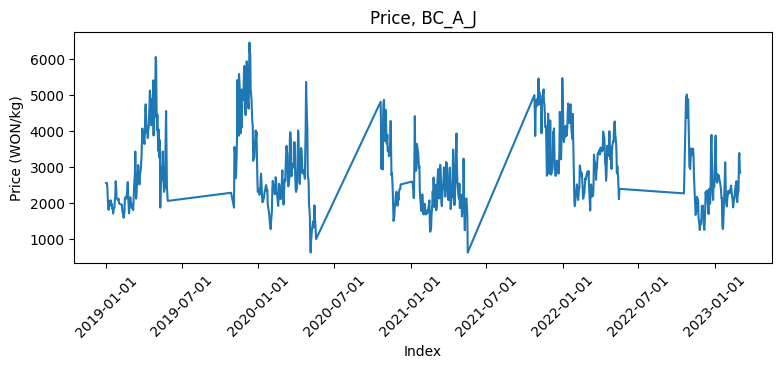

In [114]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(list(sub_train_0.index), sub_train_0['price(원/kg)'])
plt.title("Price, " + sub_train_0.iloc[0]['ID'][:6])
plt.xlabel("Index")
plt.ylabel("Price (WON/kg)")

ticks = ax.get_xticks()
ax.set_xticks(ticks[::len(ticks) // 8])
plt.xticks(rotation=45)

plt.show()

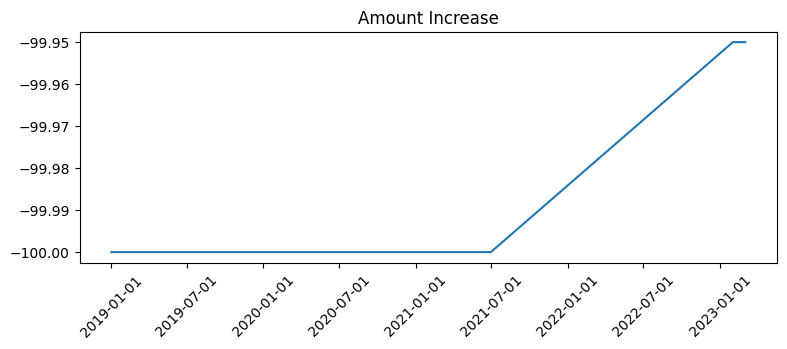

In [115]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(list(sub_train_22.index), sub_train_22['amount_increase'])
plt.title("Amount Increase")

ticks = ax.get_xticks()
ax.set_xticks(ticks[::len(ticks) // 8])
plt.xticks(rotation=45)

plt.show()

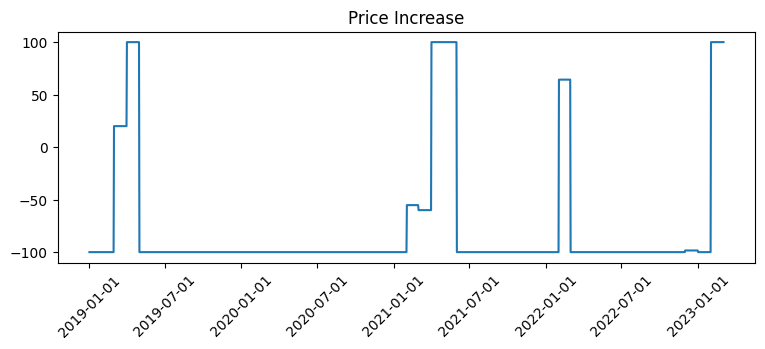

In [116]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(list(sub_train_38.index), sub_train_38['price_increase'])
plt.title("Price Increase")

ticks = ax.get_xticks()
ax.set_xticks(ticks[::len(ticks) // 8])
plt.xticks(rotation=45)

plt.show()

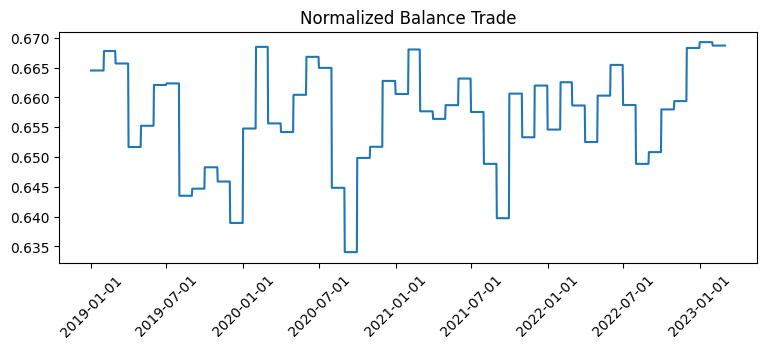

In [117]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(list(sub_train_0.index), sub_train_0['normalized_balance_trade'])
plt.title("Normalized Balance Trade")

ticks = ax.get_xticks()
ax.set_xticks(ticks[::len(ticks) // 8])
plt.xticks(rotation=45)

plt.show()

### Make test sub dataframes

In [118]:
for i, c in enumerate(combi_list):
    locals()[f'sub_test_{i}'] = test[(test['item']==c[0]) & (test['corporation']==c[1]) & (test['location']==c[2])]

## 5. Modeling 1 - LSTM

In [213]:
def lstm_model(time_step):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [214]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [215]:
combi

array(['BC_A_J', 'BC_A_S', 'BC_B_J', 'BC_B_S', 'BC_C_J', 'BC_C_S',
       'BC_D_J', 'BC_E_J', 'BC_E_S', 'CB_A_J', 'CB_A_S', 'CB_D_J',
       'CB_E_J', 'CB_F_J', 'CR_A_J', 'CR_B_J', 'CR_C_J', 'CR_D_J',
       'CR_D_S', 'CR_E_J', 'CR_E_S', 'RD_A_J', 'RD_A_S', 'RD_C_S',
       'RD_D_J', 'RD_D_S', 'RD_E_J', 'RD_E_S', 'RD_F_J', 'TG_A_J',
       'TG_A_S', 'TG_B_J', 'TG_B_S', 'TG_C_J', 'TG_C_S', 'TG_D_J',
       'TG_D_S', 'TG_E_J', 'TG_E_S'], dtype='<U6')

In [216]:
pred_dict = {key: None for key in combi}
for i in range(len(combi)):
    print("[Sub train " + str(i) + "-th]")
    print("> Sub Train:", locals()[f'sub_train_{i}']["ID"].iloc[0])
    print(combi[i])
    
    EPOCH = 50
    time_step = 100
    train_X = locals()[f'sub_train_{i}'][['price(원/kg)']]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_X_scaled = scaler.fit_transform(train_X)
    train_X_scaled = train_X_scaled.reshape(-1, 1)
    
    X, Y = create_dataset(train_X_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    print(np.shape(X), np.shape(Y))
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
    
    model = lstm_model(time_step)
    model.fit(X, Y, epochs=EPOCH, batch_size=1, verbose=1, callbacks=[early_stopping])
    
    forecast = []
    last_100_days = train_X_scaled[-time_step:]
    forecast_period = 28

    for _ in range(forecast_period):
        last_100_days_array = np.array(last_100_days)
        last_100_days_array = last_100_days_array.reshape(1, time_step, 1)
        prediction = model.predict(last_100_days_array)
        forecast.append(prediction[0][0])
        last_100_days = np.append(last_100_days[1:], prediction[0][0])
    
    forecast = np.array(forecast).reshape(-1, 1)
    forecast = scaler.inverse_transform(forecast)

    print("Pred: ", forecast)
    print("Pred Len:", len(forecast))
    
    pred_dict[combi[i]] = list(forecast)

[Sub train 0-th]
> Sub Train: BC_A_J_20190101
BC_A_J
(1422, 100, 1) (1422,)
Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0099
Epoch 2/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0048
Epoch 3/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0037
Epoch 4/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0035
Epoch 5/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0034
Epoch 6/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0031
Epoch 7/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0030
Epoch 8/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0031
Epoch 9/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0030
Epoch 10/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0029
Epoch 11/50
1422/1422 [==============================] - 14s 10ms/step - 

Epoch 1/50
1422/1422 [==============================] - 16s 10ms/step - loss: 0.0076
Epoch 2/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0041
Epoch 3/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0031
Epoch 4/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0030
Epoch 5/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 6/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 7/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 8/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 9/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 10/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0027
Epoch 11/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0026
Epoch 12/50
1422/1422 [==============================] - 14s 10

1/1 [==============================] - 0s 2ms/step
Pred:  [[1785.1749]
 [1754.5887]
 [1726.1436]
 [1699.98  ]
 [1676.2584]
 [1653.9061]
 [1632.4502]
 [1611.4584]
 [1591.4019]
 [1572.3406]
 [1554.2904]
 [1537.4717]
 [1521.5847]
 [1507.0953]
 [1494.0839]
 [1482.202 ]
 [1471.332 ]
 [1461.6069]
 [1452.7534]
 [1444.8239]
 [1437.8201]
 [1431.519 ]
 [1425.9897]
 [1421.3353]
 [1416.9177]
 [1413.3292]
 [1410.1776]
 [1407.359 ]]
Pred Len: 28
[Sub train 6-th]
> Sub Train: BC_D_J_20190101
BC_D_J
(1422, 100, 1) (1422,)
Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0100
Epoch 2/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0049
Epoch 3/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0031
Epoch 4/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0031
Epoch 5/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0032
Epoch 6/50
1422/1422 [==============================] - 14s 10m

1422/1422 [==============================] - 14s 10ms/step - loss: 0.0028
Epoch 4/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0026
Epoch 5/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0024
Epoch 6/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0025
Epoch 7/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0023
Epoch 8/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0024
Epoch 9/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0023
Epoch 10/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0022
Epoch 11/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0022
Epoch 12/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0022
Epoch 13/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0022
Epoch 14/50
1422/1422 [==============================] - 14s 10ms/step -

1422/1422 [==============================] - 14s 10ms/step - loss: 0.0018
Epoch 20/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0018
Epoch 21/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0018
Epoch 22/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0019
Epoch 23/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0017
Epoch 24/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0018
Epoch 25/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0017
Epoch 26/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0018
Epoch 27/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0018
Epoch 28/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0017
Epoch 29/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0017
Epoch 30/50
1422/1422 [==============================] - 14s 10ms/step 

Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0066
Epoch 2/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0033
Epoch 3/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0019
Epoch 4/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0019
Epoch 5/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0017
Epoch 6/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0017
Epoch 7/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0018
Epoch 8/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0017
Epoch 9/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 10/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 11/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 12/50
1422/1422 [==============================] - 13s 9ms/step - l

1/1 [==============================] - 0s 16ms/step
Pred:  [[2902.6072]
 [2732.57  ]
 [2670.7588]
 [2703.8604]
 [2689.2993]
 [2632.6243]
 [2588.6206]
 [2568.697 ]
 [2559.4587]
 [2549.2583]
 [2534.836 ]
 [2517.581 ]
 [2500.4683]
 [2483.578 ]
 [2465.9124]
 [2446.982 ]
 [2427.7104]
 [2406.7112]
 [2385.9656]
 [2363.7356]
 [2341.3484]
 [2318.8452]
 [2294.7432]
 [2270.6492]
 [2244.7954]
 [2218.93  ]
 [2193.1475]
 [2165.476 ]]
Pred Len: 28
[Sub train 15-th]
> Sub Train: CR_B_J_20190101
CR_B_J
(1422, 100, 1) (1422,)
Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0064
Epoch 2/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0039
Epoch 3/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0033
Epoch 4/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0031
Epoch 5/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0030
Epoch 6/50
1422/1422 [==============================] - 13s 9ms/s

1422/1422 [==============================] - 14s 9ms/step - loss: 0.0016
Epoch 12/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 13/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0015
Epoch 14/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 15/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 16/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 17/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0015
Epoch 18/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 19/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0015
Epoch 20/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0014
Epoch 21/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0015
Epoch 22/50
1422/1422 [==============================] - 13s 9ms/step - lo

1422/1422 [==============================] - 13s 9ms/step - loss: 0.0019
Epoch 3/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0015
Epoch 4/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0015
Epoch 5/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0014
Epoch 6/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0013
Epoch 7/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 8/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0011
Epoch 9/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0010
Epoch 10/50
1422/1422 [==============================] - 13s 9ms/step - loss: 8.1550e-04
Epoch 11/50
1422/1422 [==============================] - 13s 9ms/step - loss: 8.4601e-04
Epoch 12/50
1422/1422 [==============================] - 13s 9ms/step - loss: 7.7409e-04
Epoch 13/50
1422/1422 [==============================] - 13s 9ms/step -

1/1 [==============================] - 0s 14ms/step
Pred:  [[250.38158]
 [250.9244 ]
 [251.60997]
 [252.33441]
 [253.04533]
 [253.73387]
 [254.37044]
 [254.98196]
 [255.54611]
 [256.06946]
 [256.55035]
 [256.9891 ]
 [257.42856]
 [257.85657]
 [258.29373]
 [258.71655]
 [259.12158]
 [259.52643]
 [259.92285]
 [260.30887]
 [260.6934 ]
 [261.08447]
 [261.45023]
 [261.81738]
 [262.13657]
 [262.49188]
 [262.8004 ]
 [263.12103]]
Pred Len: 28
[Sub train 24-th]
> Sub Train: RD_D_J_20190101
RD_D_J
(1422, 100, 1) (1422,)
Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0053
Epoch 2/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 3/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0016
Epoch 4/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0014
Epoch 5/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0014
Epoch 6/50
1422/1422 [==============================] - 13s 9ms/s

1422/1422 [==============================] - 13s 9ms/step - loss: 0.0017
Epoch 27/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 28/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 29/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 30/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 31/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 32/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 33/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 34/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0016
Epoch 34: early stopping
1/1 [==============================] - 0s 12ms/step
Pred:  [[646.79755]
 [625.39655]
 [601.9894 ]
 [579.0024 ]
 [564.9271 ]
 [557.26764]
 [555.45325]
 [556.93146]
 [559.6969 ]
 [561.7112 ]
 [561.70795]
 [559.2494 ]
 [554.7

1422/1422 [==============================] - 13s 9ms/step - loss: 0.0013
Epoch 15/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 16/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 17/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 18/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 19/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 20/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 21/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 22/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0011
Epoch 23/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0011
Epoch 24/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0011
Epoch 25/50
1422/1422 [==============================] - 13s 9ms/step - loss:

1422/1422 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 15/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 16/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 17/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 18/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0036
Epoch 19/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 20/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 21/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 22/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 23/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 24/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0035
Epoch 25/50
1422/1422 [==============================] - 13s 9ms/step - loss:

1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 11/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 12/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 13/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 14/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0025
Epoch 15/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 16/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0024
Epoch 17/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0024
Epoch 18/50
1422/1422 [==============================] - 14s 9ms/step - loss: 0.0024
Epoch 19/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0025
Epoch 20/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0024
Epoch 21/50
1422/1422 [==============================] - 13s 9ms/step - loss:

1/1 [==============================] - 0s 0s/step
Pred:  [[5456.9214]
 [5061.6416]
 [4640.9185]
 [4709.0117]
 [4629.3135]
 [4372.941 ]
 [4384.8   ]
 [4678.378 ]
 [4885.2695]
 [4887.3257]
 [4930.338 ]
 [4977.4727]
 [4877.031 ]
 [4745.955 ]
 [4747.19  ]
 [4857.326 ]
 [4937.8345]
 [4967.503 ]
 [4993.258 ]
 [4968.2153]
 [4860.2354]
 [4739.077 ]
 [4684.889 ]
 [4703.5845]
 [4747.3823]
 [4786.4644]
 [4808.03  ]
 [4789.796 ]]
Pred Len: 28
[Sub train 34-th]
> Sub Train: TG_C_S_20190101
TG_C_S
(1422, 100, 1) (1422,)
Epoch 1/50
1422/1422 [==============================] - 15s 10ms/step - loss: 0.0067
Epoch 2/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0039
Epoch 3/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0031
Epoch 4/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0030
Epoch 5/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0029
Epoch 6/50
1422/1422 [==============================] - 13s 9ms/ste

1422/1422 [==============================] - 14s 10ms/step - loss: 0.0088
Epoch 12/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0090
Epoch 13/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0088
Epoch 14/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0089
Epoch 15/50
1422/1422 [==============================] - 14s 10ms/step - loss: 0.0089
Epoch 16/50
1422/1422 [==============================] - 13s 9ms/step - loss: 0.0089
Epoch 16: early stopping
1/1 [==============================] - 0s 16ms/step
Pred:  [[1833.3136]
 [1890.8151]
 [1942.5659]
 [1994.0355]
 [2044.086 ]
 [2092.778 ]
 [2141.364 ]
 [2191.3438]
 [2243.537 ]
 [2297.2903]
 [2353.9814]
 [2413.7378]
 [2477.2358]
 [2544.7375]
 [2616.6807]
 [2693.2942]
 [2775.124 ]
 [2861.9814]
 [2954.305 ]
 [3053.7559]
 [3158.9604]
 [3271.3872]
 [3391.0015]
 [3518.917 ]
 [3653.6418]
 [3797.621 ]
 [3949.2695]
 [4107.7017]]
Pred Len: 28
[Sub train 38-th]
> Sub Train: TG_E_

In [229]:
for keys in list(pred_dict.keys()):
    a = pred_dict[keys]
    b = []
    for ele in a:
        c = ele[0]
        b.append(c)
    pred_dict[keys] = b

In [230]:
pred_dict

{'BC_A_J': [2714.6904,
  2733.8252,
  2791.4885,
  2795.5059,
  2770.0007,
  2719.409,
  2666.8833,
  2624.4536,
  2595.2327,
  2571.0525,
  2546.891,
  2520.5117,
  2493.0078,
  2463.9482,
  2436.8125,
  2411.5103,
  2387.7283,
  2366.8213,
  2346.0078,
  2325.1628,
  2306.456,
  2288.938,
  2270.8496,
  2254.6116,
  2238.1643,
  2223.6904,
  2208.5305,
  2195.6953],
 'BC_A_S': [2413.0703,
  2241.1614,
  2273.1567,
  2472.8875,
  2703.7861,
  2811.9802,
  2745.012,
  2578.0276,
  2415.8994,
  2324.7793,
  2328.5486,
  2403.3477,
  2494.525,
  2546.2249,
  2532.9954,
  2474.118,
  2407.2012,
  2365.0547,
  2361.7527,
  2388.5356,
  2426.5442,
  2451.1934,
  2451.5376,
  2431.0164,
  2404.018,
  2385.557,
  2382.0574,
  2391.0476],
 'BC_B_J': [2632.7036,
  2718.0513,
  2871.4678,
  3015.7878,
  3131.9766,
  3224.844,
  3309.6375,
  3398.5208,
  3497.7356,
  3607.3164,
  3725.1335,
  3851.417,
  3983.177,
  4124.701,
  4277.216,
  4441.6406,
  4619.2817,
  4811.7026,
  5019.383,
  5240.1

In [232]:
submission_df = pd.read_csv('dataset/sample_submission.csv')
submission_df

ID  answer
0     TG_A_J_20230304       0
1     TG_A_J_20230305       0
2     TG_A_J_20230306       0
3     TG_A_J_20230307       0
4     TG_A_J_20230308       0
...               ...     ...
1087  RD_F_J_20230327       0
1088  RD_F_J_20230328       0
1089  RD_F_J_20230329       0
1090  RD_F_J_20230330       0
1091  RD_F_J_20230331       0

[1092 rows x 2 columns]

In [233]:
sub_inds = []
for i, ind in enumerate(submission_df["ID"]):
    if i%28 == 0:
        sub_inds.append(ind[:6])
        print(ind[:6])

TG_A_J
TG_A_S
TG_B_J
TG_B_S
TG_C_J
TG_C_S
TG_D_J
TG_D_S
TG_E_J
TG_E_S
CR_A_J
CR_B_J
CR_C_J
CR_D_J
CR_D_S
CR_E_J
CR_E_S
CB_A_J
CB_A_S
CB_D_J
CB_E_J
RD_A_J
RD_A_S
RD_C_S
RD_D_J
RD_D_S
RD_E_J
RD_E_S
BC_A_J
BC_A_S
BC_B_J
BC_B_S
BC_C_J
BC_C_S
BC_D_J
BC_E_J
BC_E_S
CB_F_J
RD_F_J


In [234]:
print(sub_inds)
preds = []
for si in sub_inds:
    preds.extend(pred_dict[si])

['TG_A_J', 'TG_A_S', 'TG_B_J', 'TG_B_S', 'TG_C_J', 'TG_C_S', 'TG_D_J', 'TG_D_S', 'TG_E_J', 'TG_E_S', 'CR_A_J', 'CR_B_J', 'CR_C_J', 'CR_D_J', 'CR_D_S', 'CR_E_J', 'CR_E_S', 'CB_A_J', 'CB_A_S', 'CB_D_J', 'CB_E_J', 'RD_A_J', 'RD_A_S', 'RD_C_S', 'RD_D_J', 'RD_D_S', 'RD_E_J', 'RD_E_S', 'BC_A_J', 'BC_A_S', 'BC_B_J', 'BC_B_S', 'BC_C_J', 'BC_C_S', 'BC_D_J', 'BC_E_J', 'BC_E_S', 'CB_F_J', 'RD_F_J']


In [235]:
submission_df['answer'] = preds
submission_df

ID       answer
0     TG_A_J_20230304  3747.527832
1     TG_A_J_20230305  3954.210205
2     TG_A_J_20230306  3832.671387
3     TG_A_J_20230307  3922.077148
4     TG_A_J_20230308  4091.597168
...               ...          ...
1087  RD_F_J_20230327   397.272247
1088  RD_F_J_20230328   392.415497
1089  RD_F_J_20230329   387.503571
1090  RD_F_J_20230330   382.651886
1091  RD_F_J_20230331   377.881744

[1092 rows x 2 columns]

In [236]:
submission_df.to_csv('lstm.csv',index=False)

## 5. Modeling 2 - Autots
- https://github.com/winedarksea/AutoTS
- https://github.com/salesforce/Merlion
- https://michael-fuchs-python.netlify.app/2022/03/01/automl-for-time-series-analysis/

In [37]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    
def Augmented_Dickey_Fuller_Test_func(timeseries , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    adfTest = adfuller(timeseries, autolag='AIC')
    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key, value in adfTest[4].items():
       dfResults['Critical Value (%s)'%key] = value
    print (dfResults)
    if adfTest[1] <= 0.05:
        print()
        print("Conclusion:")
        print("Reject the null hypothesis")
        print('\033[92m' + "Data is stationary" + '\033[0m')
    else:
        print()
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print('\033[91m' + "Data is non-stationary" + '\033[0m')    
        
def inverse_diff_func(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp        

### Check best model for each item

In [38]:
first_item_ind = [0, 9, 14, 21, 29]
for i in first_item_ind:
    print("> ID:", combi[i])
    train_X = locals()[f'sub_train_{i}'][['price(원/kg)']]
    print("Number of NAN:", train_X.isna().sum().sum())
    
    model = AutoTS(forecast_length=28,
                    frequency='d', #for daily
                    prediction_interval=0.9,
                    model_list='all', 
                    transformer_list='all',
                    max_generations=7,    #7
                    num_validations=3,    #3
                    validation_method='similarity',
                    random_seed=seed_num,
                    n_jobs=-1)
    
    model = model.fit(train_X)
    best_model_Name = model.best_model_name
    best_model_Parameters = model.best_model_params
    best_model_TransformationParameters = model.best_model_transformation_params
    
    print('Best model:', best_model_Name)
    print('Model parameter of best model:', best_model_Parameters)
    print('Transformation parameter of best model:', best_model_TransformationParameters)
    
    best_model_Names_dic = {"ModelName":best_model_Name}
    best_model_Parameters_dic = ast.literal_eval(str(best_model_Parameters))
    best_model_TransformationParameters_dic = ast.literal_eval(str(best_model_TransformationParameters))
    
    with open("autots/" + str(combi[i])+'_names.json', 'w') as f:
        json.dump(best_model_Names_dic, f)
    with open("autots/" + str(combi[i])+'_params.json', 'w') as f:
        json.dump(best_model_Parameters_dic, f)
    with open("autots/" + str(combi[i])+'_trans_params.json', 'w') as f:
        json.dump(best_model_TransformationParameters_dic, f)    

> ID: BC_A_J
Number of NAN: 0
Using 18 cpus for n_jobs.
Data frequency is: D, used frequency is: d
Model Number: 1 with model ARIMA in generation 0 of 7
Model Number: 2 with model AverageValueNaive in generation 0 of 7
Model Number: 3 with model AverageValueNaive in generation 0 of 7
Model Number: 4 with model AverageValueNaive in generation 0 of 7
Model Number: 5 with model DatepartRegression in generation 0 of 7
Model Number: 6 with model DatepartRegression in generation 0 of 7
Model Number: 7 with model DatepartRegression in generation 0 of 7
Model Number: 8 with model DatepartRegression in generation 0 of 7
Epoch 1/50
14/14 [==============================] - 3s 3ms/step - loss: 0.4055
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.4011
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.3949
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.3905
Epoch 5/50
14/14 [==============================] - 0s 3ms/step -

09:57:15 - cmdstanpy - INFO - Chain [1] start processing
09:57:15 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 36 with model FBProphet in generation 0 of 7
Model Number: 37 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 7
Model Number: 39 with model MultivariateRegression in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 7
Model Number: 42 with model DatepartRegression in generation 0 of 7
Model Number: 43 with model UnobservedComponents in generation 0 of

1it [00:00, 20.09it/s]
1it [00:00, 56.58it/s]
1it [00:00, 59.38it/s]
1it [00:00, 59.34it/s]
1it [00:00, 56.47it/s]
1it [00:00, 63.21it/s]
1it [00:00, 58.88it/s]
1it [00:00, 56.51it/s]


epoch 0 with mape 4.270350456237793 and rmse 1.1427205801010132


1it [00:00, 58.82it/s]
1it [00:00, 68.65it/s]
1it [00:00, 61.10it/s]
1it [00:00, 101.60it/s]
1it [00:00, 58.33it/s]
1it [00:00, 32.29it/s]
1it [00:00, 111.83it/s]
1it [00:00, 58.09it/s]


epoch 1 with mape 4.2708740234375 and rmse 1.1428481340408325


1it [00:00, 35.18it/s]
1it [00:00, 112.73it/s]
1it [00:00, 59.02it/s]
1it [00:00, 38.58it/s]
1it [00:00, 158.18it/s]
1it [00:00, 58.25it/s]
1it [00:00, 55.98it/s]
1it [00:00, 59.90it/s]


epoch 2 with mape 4.271223545074463 and rmse 1.1429576873779297


1it [00:00, 73.47it/s]
1it [00:00, 31.89it/s]
1it [00:00, 60.37it/s]
1it [00:00, 57.88it/s]
1it [00:00, 32.44it/s]
1it [00:00, 108.28it/s]
1it [00:00, 60.31it/s]
1it [00:00, 56.28it/s]


epoch 3 with mape 4.2716240882873535 and rmse 1.1430444717407227


1it [00:00, 91.59it/s]
1it [00:00, 58.79it/s]
1it [00:00, 59.30it/s]
1it [00:00, 63.33it/s]
1it [00:00, 58.59it/s]
1it [00:00, 59.48it/s]
1it [00:00, 61.92it/s]
1it [00:00, 57.12it/s]


epoch 4 with mape 4.271934509277344 and rmse 1.143122911453247


1it [00:00, 139.43it/s]
1it [00:00, 58.82it/s]
1it [00:00, 60.00it/s]
1it [00:00, 59.92it/s]
1it [00:00, 58.94it/s]
1it [00:00, 53.44it/s]
1it [00:00, 125.12it/s]
1it [00:00, 60.33it/s]


epoch 5 with mape 4.272011756896973 and rmse 1.1431442499160767


1it [00:00, 57.07it/s]
1it [00:00, 58.80it/s]
1it [00:00, 58.57it/s]
1it [00:00, 56.66it/s]
1it [00:00, 60.32it/s]
1it [00:00, 58.41it/s]
1it [00:00, 56.48it/s]
1it [00:00, 59.58it/s]


epoch 6 with mape 4.272019386291504 and rmse 1.1431517601013184


1it [00:00, 58.98it/s]
1it [00:00, 60.63it/s]
1it [00:00, 64.54it/s]
1it [00:00, 58.63it/s]
1it [00:00, 60.27it/s]
1it [00:00, 100.40it/s]
1it [00:00, 58.43it/s]
1it [00:00, 59.09it/s]


epoch 7 with mape 4.2721638679504395 and rmse 1.1431831121444702


1it [00:00, 82.70it/s]
1it [00:00, 55.28it/s]
1it [00:00, 63.94it/s]
1it [00:00, 59.50it/s]
1it [00:00, 55.71it/s]
1it [00:00, 42.56it/s]
1it [00:00, 59.72it/s]
1it [00:00, 59.98it/s]


epoch 8 with mape 4.2723612785339355 and rmse 1.143233299255371


1it [00:00, 74.81it/s]
1it [00:00, 58.76it/s]
1it [00:00, 55.48it/s]
1it [00:00, 53.13it/s]
1it [00:00, 59.83it/s]
1it [00:00, 58.95it/s]
1it [00:00, 59.96it/s]
1it [00:00, 57.66it/s]


epoch 9 with mape 4.272787570953369 and rmse 1.143354058265686


1it [00:00, 55.16it/s]
1it [00:00, 58.14it/s]
1it [00:00, 59.96it/s]
1it [00:00, 58.86it/s]
1it [00:00, 55.63it/s]
1it [00:00, 82.20it/s]
1it [00:00, 59.17it/s]
1it [00:00, 33.48it/s]


epoch 10 with mape 4.273283958435059 and rmse 1.143483281135559


1it [00:00, 61.65it/s]
1it [00:00, 59.13it/s]
1it [00:00, 56.17it/s]
1it [00:00, 89.48it/s]
1it [00:00, 58.32it/s]
1it [00:00, 32.75it/s]
1it [00:00, 62.08it/s]
1it [00:00, 58.62it/s]


epoch 11 with mape 4.273589611053467 and rmse 1.1435638666152954


1it [00:00, 32.99it/s]
1it [00:00, 33.36it/s]
1it [00:00, 52.96it/s]
1it [00:00, 54.11it/s]
1it [00:00, 50.60it/s]
1it [00:00, 54.00it/s]
1it [00:00, 56.24it/s]
1it [00:00, 53.61it/s]


epoch 12 with mape 4.273940086364746 and rmse 1.143648624420166


1it [00:00, 58.90it/s]
1it [00:00, 59.62it/s]
1it [00:00, 59.39it/s]
1it [00:00, 58.91it/s]
1it [00:00, 59.36it/s]
1it [00:00, 58.66it/s]
1it [00:00, 62.90it/s]
1it [00:00, 59.30it/s]


epoch 13 with mape 4.274137496948242 and rmse 1.1437054872512817


1it [00:00, 86.89it/s]
1it [00:00, 57.12it/s]
1it [00:00, 61.75it/s]
1it [00:00, 59.05it/s]
1it [00:00, 55.90it/s]
1it [00:00, 59.30it/s]
1it [00:00, 58.31it/s]
1it [00:00, 59.98it/s]


epoch 14 with mape 4.274366855621338 and rmse 1.1437662839889526


1it [00:00, 48.66it/s]
1it [00:00, 49.66it/s]
1it [00:00, 49.77it/s]
1it [00:00, 56.94it/s]
1it [00:00, 53.47it/s]
1it [00:00, 56.87it/s]
1it [00:00, 95.90it/s]
1it [00:00, 55.03it/s]


epoch 15 with mape 4.274649620056152 and rmse 1.1438498497009277


1it [00:00, 56.14it/s]
1it [00:00, 54.03it/s]
1it [00:00, 43.53it/s]
1it [00:00, 52.87it/s]
1it [00:00, 163.68it/s]
1it [00:00, 57.49it/s]
1it [00:00, 60.62it/s]
1it [00:00, 35.32it/s]


epoch 16 with mape 4.274789333343506 and rmse 1.1438860893249512


1it [00:00, 68.92it/s]
1it [00:00, 55.37it/s]
1it [00:00, 59.89it/s]
1it [00:00, 50.60it/s]
1it [00:00, 37.41it/s]
1it [00:00, 54.40it/s]
1it [00:00, 59.53it/s]
1it [00:00, 58.62it/s]


Model Number: 111 with model DynamicFactorMQ in generation 0 of 7
Template Eval Error: ValueError('Number of factors (2) cannot be greater than the number of monthly endogenous variables (1).') in model 111 in generation 0: DynamicFactorMQ
Model Number: 112 with model AverageValueNaive in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 112 in generation 0: AverageValueNaive
Model Number: 113 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 113 in generation 0: NeuralProphet
Model Number: 114 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 114 in generation 0: PytorchForecasting
Model Number: 115 with model MAR in generation 0 of 7
Template Eval Error: ValueError('Shape of passed values is (7, 1), indices imply (28, 1)') in model 115 in ge

Epoch 20/50
23/23 [==============================] - 0s 11ms/step - loss: -5642038.5000 - val_loss: -13976038.0000
Epoch 21/50
23/23 [==============================] - 0s 10ms/step - loss: -5637426.0000 - val_loss: -13984341.0000
Epoch 22/50
23/23 [==============================] - 0s 11ms/step - loss: -5637974.5000 - val_loss: -13995677.0000
Epoch 23/50
23/23 [==============================] - 0s 11ms/step - loss: -5637610.0000 - val_loss: -14005465.0000
Epoch 24/50
23/23 [==============================] - 0s 11ms/step - loss: -5641440.0000 - val_loss: -14012514.0000
Epoch 25/50
23/23 [==============================] - 0s 12ms/step - loss: -5635476.5000 - val_loss: -14019997.0000
Epoch 26/50
23/23 [==============================] - 0s 11ms/step - loss: -5636468.0000 - val_loss: -14026656.0000
Epoch 27/50
23/23 [==============================] - 0s 11ms/step - loss: -5636950.5000 - val_loss: -14032928.0000
Epoch 28/50
23/23 [==============================] - 0s 11ms/step - loss: -56411

Model Number: 191 with model ARIMA in generation 0 of 7
Model Number: 192 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 192 in generation 0: NeuralProphet
Model Number: 193 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 193 in generation 0: PytorchForecasting
Model Number: 194 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 194 in generation 0: NeuralProphet
Model Number: 195 with model MLEnsemble in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 195 in generation 0: MLEnsemble
Model Number: 196 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is som

1it [00:00,  2.27it/s]
1it [00:00, 64.42it/s]
1it [00:00, 47.97it/s]
1it [00:00, 50.85it/s]
1it [00:00, 95.51it/s]
1it [00:00, 60.38it/s]
1it [00:00, 58.91it/s]
1it [00:00, 32.46it/s]


epoch 0 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 60.36it/s]
1it [00:00, 68.22it/s]
1it [00:00, 58.75it/s]
1it [00:00, 56.04it/s]
1it [00:00, 59.97it/s]
1it [00:00, 59.42it/s]
1it [00:00, 51.04it/s]
1it [00:00, 86.53it/s]


epoch 1 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 153.86it/s]
1it [00:00, 58.97it/s]
1it [00:00, 58.63it/s]
1it [00:00, 32.75it/s]
1it [00:00, 65.87it/s]
1it [00:00, 58.53it/s]
1it [00:00, 55.51it/s]
1it [00:00, 154.20it/s]


epoch 2 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 41.63it/s]
1it [00:00, 36.32it/s]
1it [00:00, 62.54it/s]
1it [00:00, 50.69it/s]
1it [00:00, 51.62it/s]
1it [00:00, 51.98it/s]
1it [00:00, 134.90it/s]
1it [00:00, 77.93it/s]


epoch 3 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 54.95it/s]
1it [00:00, 43.78it/s]
1it [00:00, 54.19it/s]
1it [00:00, 60.88it/s]
1it [00:00, 59.89it/s]
1it [00:00, 50.12it/s]
1it [00:00, 56.83it/s]
1it [00:00, 121.50it/s]


epoch 4 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 123.34it/s]
1it [00:00, 58.15it/s]
1it [00:00, 51.67it/s]
1it [00:00, 52.04it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.64it/s]
1it [00:00, 46.89it/s]
1it [00:00, 51.94it/s]


epoch 5 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 53.83it/s]
1it [00:00, 58.24it/s]
1it [00:00, 32.55it/s]
1it [00:00, 77.31it/s]
1it [00:00, 57.72it/s]
1it [00:00, 58.64it/s]
1it [00:00, 59.81it/s]
1it [00:00, 64.50it/s]


epoch 6 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 68.75it/s]
1it [00:00, 42.55it/s]
1it [00:00, 60.85it/s]
1it [00:00, 59.48it/s]
1it [00:00, 59.31it/s]
1it [00:00, 57.28it/s]
1it [00:00, 61.29it/s]
1it [00:00, 59.47it/s]


epoch 7 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 69.53it/s]
1it [00:00, 59.48it/s]
1it [00:00, 51.89it/s]
1it [00:00, 59.46it/s]
1it [00:00, 59.67it/s]
1it [00:00, 66.68it/s]
1it [00:00, 56.61it/s]
1it [00:00, 36.87it/s]


epoch 8 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 127.86it/s]
1it [00:00, 58.84it/s]
1it [00:00, 58.48it/s]
1it [00:00, 59.59it/s]
1it [00:00, 99.84it/s]
1it [00:00, 58.63it/s]
1it [00:00, 60.10it/s]
1it [00:00, 65.67it/s]


epoch 9 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 118.91it/s]
1it [00:00, 58.76it/s]
1it [00:00, 53.22it/s]
1it [00:00, 71.53it/s]
1it [00:00, 58.90it/s]
1it [00:00, 49.45it/s]
1it [00:00, 48.29it/s]
1it [00:00, 59.40it/s]


epoch 10 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 142.43it/s]
1it [00:00, 59.12it/s]
1it [00:00, 57.72it/s]
1it [00:00, 59.78it/s]
1it [00:00, 59.36it/s]
1it [00:00, 58.40it/s]
1it [00:00, 60.24it/s]
1it [00:00, 63.17it/s]


epoch 11 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 157.11it/s]
1it [00:00, 42.98it/s]
1it [00:00, 58.88it/s]
1it [00:00, 59.93it/s]
1it [00:00, 99.37it/s]
1it [00:00, 58.52it/s]
1it [00:00, 31.41it/s]
1it [00:00, 59.99it/s]


epoch 12 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 65.25it/s]
1it [00:00, 60.46it/s]
1it [00:00, 58.88it/s]
1it [00:00, 32.25it/s]
1it [00:00, 37.63it/s]
1it [00:00, 44.21it/s]
1it [00:00, 58.38it/s]
1it [00:00, 58.32it/s]


epoch 13 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 58.67it/s]
1it [00:00, 59.66it/s]
1it [00:00, 40.13it/s]
1it [00:00, 58.57it/s]
1it [00:00, 31.89it/s]
1it [00:00, 102.56it/s]
1it [00:00, 57.63it/s]
1it [00:00, 57.93it/s]


epoch 14 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 49.30it/s]
1it [00:00, 61.67it/s]
1it [00:00, 32.43it/s]
1it [00:00, 66.22it/s]
1it [00:00, 59.49it/s]
1it [00:00, 56.62it/s]
1it [00:00, 59.78it/s]
1it [00:00, 58.83it/s]


epoch 15 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 68.85it/s]
1it [00:00, 58.48it/s]
1it [00:00, 55.20it/s]
1it [00:00, 59.58it/s]
1it [00:00, 59.31it/s]
1it [00:00, 55.86it/s]
1it [00:00, 38.01it/s]
1it [00:00, 64.27it/s]


epoch 16 with mape 0.10428311675786972 and rmse 0.9222250580787659


1it [00:00, 64.65it/s]
1it [00:00, 57.31it/s]
1it [00:00, 59.48it/s]
1it [00:00, 32.43it/s]
1it [00:00, 110.48it/s]
1it [00:00, 58.40it/s]
1it [00:00, 32.38it/s]
1it [00:00, 70.88it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 224 in generation 0: TiDE
Model Number: 225 with model BallTreeMultivariateMotif in generation 0 of 7
Model Number: 226 with model MultivariateMotif in generation 0 of 7
Model Number: 227 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 227 in generation 0: GluonTS
Model Number: 228 with model VAR in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 228 in generation 0: VAR
Model Number: 229 with model DynamicFactor in generation 0 of 7
Template Eval Error: ValueError('The dynamic factors model is only valid for multivariate time series.') in model 229 in generation 0: DynamicFactor
Model Number: 230 with model VAR in generation 0 of 7
Template Eval Error: ValueError('Only gave one varia

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.85it/s]
1it [00:00, 17.70it/s]
1it [00:00, 52.61it/s]
1it [00:00, 54.60it/s]
1it [00:00, 92.10it/s]
1it [00:00, 56.77it/s]
1it [00:00, 60.92it/s]
1it [00:00, 59.08it/s]
1it [00:00, 53.46it/s]


epoch 0 with mape 3.6401898860931396 and rmse 287.1883239746094


1it [00:00, 97.82it/s]
1it [00:00, 58.28it/s]
1it [00:00, 59.69it/s]
1it [00:00, 106.25it/s]
1it [00:00, 57.74it/s]
1it [00:00, 37.72it/s]
1it [00:00, 63.71it/s]
1it [00:00, 59.48it/s]


epoch 1 with mape 3.6422486305236816 and rmse 287.19970703125


1it [00:00, 71.71it/s]
1it [00:00, 67.62it/s]
1it [00:00, 31.58it/s]
1it [00:00, 53.82it/s]
1it [00:00, 53.70it/s]
1it [00:00, 53.09it/s]
1it [00:00, 52.07it/s]
1it [00:00, 53.39it/s]


epoch 2 with mape 3.643232583999634 and rmse 287.2724914550781


1it [00:00, 57.20it/s]
1it [00:00, 58.84it/s]
1it [00:00, 60.14it/s]
1it [00:00, 64.52it/s]
1it [00:00, 59.03it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.77it/s]
1it [00:00, 49.13it/s]


epoch 3 with mape 3.6432015895843506 and rmse 287.2690734863281


1it [00:00, 233.52it/s]
1it [00:00, 61.43it/s]
1it [00:00, 52.16it/s]
1it [00:00, 96.56it/s]
1it [00:00, 60.18it/s]
1it [00:00, 58.15it/s]
1it [00:00, 123.74it/s]
1it [00:00, 62.85it/s]


epoch 4 with mape 3.644684314727783 and rmse 287.2911071777344


1it [00:00, 56.62it/s]
1it [00:00, 59.47it/s]
1it [00:00, 58.47it/s]
1it [00:00, 57.43it/s]
1it [00:00, 32.10it/s]
1it [00:00, 83.11it/s]
1it [00:00, 58.76it/s]
1it [00:00, 60.43it/s]


epoch 5 with mape 3.6447737216949463 and rmse 287.296142578125


1it [00:00, 77.01it/s]
1it [00:00, 55.18it/s]
1it [00:00, 35.81it/s]
1it [00:00, 59.47it/s]
1it [00:00, 58.18it/s]
1it [00:00, 61.73it/s]
1it [00:00, 54.71it/s]
1it [00:00, 58.50it/s]


epoch 6 with mape 3.644930601119995 and rmse 287.2925720214844


1it [00:00, 55.45it/s]
1it [00:00, 75.11it/s]
1it [00:00, 59.98it/s]
1it [00:00, 59.96it/s]
1it [00:00, 58.38it/s]
1it [00:00, 32.50it/s]
1it [00:00, 62.16it/s]
1it [00:00, 57.69it/s]


epoch 7 with mape 3.6455483436584473 and rmse 287.2867431640625


1it [00:00, 31.31it/s]
1it [00:00, 79.86it/s]
1it [00:00, 77.89it/s]
1it [00:00, 53.25it/s]
1it [00:00, 222.79it/s]
1it [00:00, 60.91it/s]
1it [00:00, 57.04it/s]
1it [00:00, 61.97it/s]


epoch 8 with mape 3.6452925205230713 and rmse 287.251220703125


1it [00:00, 72.21it/s]
1it [00:00, 32.54it/s]
1it [00:00, 66.97it/s]
1it [00:00, 58.58it/s]
1it [00:00, 55.44it/s]
1it [00:00, 59.96it/s]
1it [00:00, 58.99it/s]
1it [00:00, 53.60it/s]


epoch 9 with mape 3.6452956199645996 and rmse 287.2479553222656


1it [00:00, 89.50it/s]
1it [00:00, 54.46it/s]
1it [00:00, 54.31it/s]
1it [00:00, 41.12it/s]
1it [00:00, 53.17it/s]
1it [00:00, 54.06it/s]
1it [00:00, 51.77it/s]
1it [00:00, 242.56it/s]


epoch 10 with mape 3.6448709964752197 and rmse 287.252197265625


1it [00:00, 68.16it/s]
1it [00:00, 30.96it/s]
1it [00:00, 81.40it/s]
1it [00:00, 40.71it/s]
1it [00:00, 51.66it/s]
1it [00:00, 56.66it/s]
1it [00:00, 59.32it/s]
1it [00:00, 58.99it/s]


epoch 11 with mape 3.6455607414245605 and rmse 287.25421142578125


1it [00:00, 56.96it/s]
1it [00:00, 42.84it/s]
1it [00:00, 57.46it/s]
1it [00:00, 56.55it/s]
1it [00:00, 60.09it/s]
1it [00:00, 58.58it/s]
1it [00:00, 54.65it/s]
1it [00:00, 60.00it/s]


epoch 12 with mape 3.6453592777252197 and rmse 287.21826171875


1it [00:00, 71.27it/s]
1it [00:00, 60.29it/s]
1it [00:00, 59.32it/s]
1it [00:00, 57.48it/s]
1it [00:00, 58.47it/s]
1it [00:00, 54.87it/s]
1it [00:00, 59.39it/s]
1it [00:00, 58.45it/s]


epoch 13 with mape 3.645219564437866 and rmse 287.21502685546875


1it [00:00, 56.62it/s]
1it [00:00, 60.65it/s]
1it [00:00, 58.38it/s]
1it [00:00, 31.50it/s]
1it [00:00, 37.67it/s]
1it [00:00, 58.08it/s]
1it [00:00, 58.52it/s]
1it [00:00, 78.81it/s]


epoch 14 with mape 3.645538806915283 and rmse 287.214599609375


1it [00:00, 70.81it/s]
1it [00:00, 31.36it/s]
1it [00:00, 60.19it/s]
1it [00:00, 58.04it/s]
1it [00:00, 49.20it/s]
1it [00:00, 42.84it/s]
1it [00:00, 134.47it/s]
1it [00:00, 58.25it/s]


epoch 15 with mape 3.6460673809051514 and rmse 287.1851806640625


1it [00:00, 51.92it/s]
1it [00:00, 89.18it/s]
1it [00:00, 41.71it/s]
1it [00:00, 62.51it/s]
1it [00:00, 38.03it/s]
1it [00:00, 61.13it/s]
1it [00:00, 58.51it/s]
1it [00:00, 50.14it/s]


epoch 16 with mape 3.6462111473083496 and rmse 287.1805725097656


1it [00:00, 80.82it/s]
1it [00:00, 52.99it/s]
1it [00:00, 55.31it/s]
1it [00:00, 59.86it/s]
1it [00:00, 58.97it/s]
1it [00:00, 56.64it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.11it/s]


epoch 17 with mape 3.6465160846710205 and rmse 287.1813659667969


1it [00:00, 64.49it/s]
1it [00:00, 61.50it/s]
1it [00:00, 59.39it/s]
1it [00:00, 59.73it/s]
1it [00:00, 58.81it/s]
1it [00:00, 58.50it/s]
1it [00:00, 31.53it/s]
1it [00:00, 60.21it/s]


epoch 18 with mape 3.6465048789978027 and rmse 287.1669616699219


1it [00:00, 55.13it/s]
1it [00:00, 60.10it/s]
1it [00:00, 58.30it/s]
1it [00:00, 51.44it/s]
1it [00:00, 58.88it/s]
1it [00:00, 54.95it/s]
1it [00:00, 52.25it/s]
1it [00:00, 52.63it/s]


epoch 19 with mape 3.6475331783294678 and rmse 287.17791748046875


1it [00:00, 69.27it/s]
1it [00:00, 58.47it/s]
1it [00:00, 56.58it/s]
1it [00:00, 60.95it/s]
1it [00:00, 58.61it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.54it/s]
1it [00:00, 60.20it/s]


epoch 20 with mape 3.647829294204712 and rmse 287.18560791015625


1it [00:00, 63.78it/s]
1it [00:00, 61.57it/s]
1it [00:00, 62.37it/s]
1it [00:00, 59.12it/s]
1it [00:00, 32.45it/s]
1it [00:00, 61.91it/s]
1it [00:00, 58.78it/s]
1it [00:00, 57.19it/s]


epoch 21 with mape 3.6476364135742188 and rmse 287.189453125


1it [00:00, 70.14it/s]
1it [00:00, 58.48it/s]
1it [00:00, 59.72it/s]
1it [00:00, 67.36it/s]
1it [00:00, 58.59it/s]
1it [00:00, 60.44it/s]
1it [00:00, 64.84it/s]
1it [00:00, 58.49it/s]


epoch 22 with mape 3.647737503051758 and rmse 287.1845397949219


1it [00:00, 69.78it/s]
1it [00:00, 58.75it/s]
1it [00:00, 31.43it/s]
1it [00:00, 60.18it/s]
1it [00:00, 62.67it/s]
1it [00:00, 54.75it/s]
1it [00:00, 59.32it/s]
1it [00:00, 58.99it/s]


epoch 23 with mape 3.6480679512023926 and rmse 287.1990051269531


1it [00:00, 56.77it/s]
1it [00:00, 59.99it/s]
1it [00:00, 58.26it/s]
1it [00:00, 60.57it/s]
1it [00:00, 56.48it/s]
1it [00:00, 58.69it/s]
1it [00:00, 32.56it/s]
1it [00:00, 65.67it/s]


epoch 24 with mape 3.6476991176605225 and rmse 287.17559814453125


1it [00:00, 56.50it/s]
1it [00:00, 61.49it/s]
1it [00:00, 59.14it/s]
1it [00:00, 58.70it/s]
1it [00:00, 203.24it/s]
1it [00:00, 98.59it/s]
1it [00:00, 58.69it/s]
1it [00:00, 59.50it/s]


epoch 25 with mape 3.6478919982910156 and rmse 287.1727600097656


1it [00:00, 76.97it/s]
1it [00:00, 56.61it/s]
1it [00:00, 60.41it/s]
1it [00:00, 59.00it/s]
1it [00:00, 53.34it/s]
1it [00:00, 70.85it/s]
1it [00:00, 60.37it/s]
1it [00:00, 58.84it/s]


epoch 26 with mape 3.647315740585327 and rmse 287.16729736328125


1it [00:00, 69.73it/s]
1it [00:00, 58.18it/s]
1it [00:00, 58.46it/s]
1it [00:00, 53.02it/s]
1it [00:00, 41.84it/s]
1it [00:00, 59.45it/s]
1it [00:00, 59.42it/s]
1it [00:00, 59.27it/s]


epoch 27 with mape 3.6469898223876953 and rmse 287.1603698730469


1it [00:00, 83.62it/s]
1it [00:00, 56.61it/s]
1it [00:00, 59.83it/s]
1it [00:00, 60.15it/s]
1it [00:00, 57.59it/s]
1it [00:00, 60.40it/s]
1it [00:00, 58.65it/s]
1it [00:00, 59.58it/s]


epoch 28 with mape 3.6459484100341797 and rmse 287.14794921875


1it [00:00, 68.84it/s]
1it [00:00, 58.87it/s]
1it [00:00, 58.89it/s]
1it [00:00, 60.05it/s]
1it [00:00, 97.11it/s]
1it [00:00, 58.31it/s]
1it [00:00, 59.91it/s]
1it [00:00, 63.36it/s]


epoch 29 with mape 3.6460137367248535 and rmse 287.1387634277344


1it [00:00, 56.56it/s]
1it [00:00, 60.04it/s]
1it [00:00, 59.95it/s]
1it [00:00, 58.64it/s]
1it [00:00, 59.68it/s]
1it [00:00, 58.52it/s]
1it [00:00, 59.59it/s]
1it [00:00, 53.61it/s]


epoch 30 with mape 3.6441874504089355 and rmse 287.0713806152344


1it [00:00, 47.61it/s]
1it [00:00, 49.60it/s]
1it [00:00, 39.63it/s]
1it [00:00, 49.37it/s]
1it [00:00, 60.36it/s]
1it [00:00, 53.93it/s]
1it [00:00, 43.61it/s]
1it [00:00, 60.15it/s]


epoch 31 with mape 3.6434967517852783 and rmse 287.03851318359375


1it [00:00, 59.61it/s]
1it [00:00, 61.94it/s]
1it [00:00, 61.81it/s]
1it [00:00, 59.97it/s]
1it [00:00, 32.79it/s]
1it [00:00, 67.78it/s]
1it [00:00, 60.15it/s]
1it [00:00, 53.62it/s]


epoch 32 with mape 3.641892671585083 and rmse 287.00982666015625


1it [00:00, 70.61it/s]
1it [00:00, 56.89it/s]
1it [00:00, 56.57it/s]
1it [00:00, 36.14it/s]
1it [00:00, 62.14it/s]
1it [00:00, 57.78it/s]
1it [00:00, 60.47it/s]
1it [00:00, 89.12it/s]


epoch 33 with mape 3.640880823135376 and rmse 286.999267578125


1it [00:00, 67.51it/s]
1it [00:00, 51.18it/s]
1it [00:00, 55.91it/s]
1it [00:00, 57.36it/s]
1it [00:00, 60.88it/s]
1it [00:00, 62.31it/s]
1it [00:00, 60.18it/s]
1it [00:00, 56.60it/s]


epoch 34 with mape 3.64048433303833 and rmse 286.97528076171875


1it [00:00, 43.93it/s]
1it [00:00, 59.05it/s]
1it [00:00, 32.59it/s]
1it [00:00, 66.50it/s]
1it [00:00, 56.45it/s]
1it [00:00, 63.41it/s]
1it [00:00, 65.19it/s]
1it [00:00, 50.81it/s]


epoch 35 with mape 3.6390435695648193 and rmse 286.9539489746094


1it [00:00, 231.72it/s]
1it [00:00, 61.30it/s]
1it [00:00, 58.89it/s]
1it [00:00, 59.49it/s]
1it [00:00, 60.88it/s]
1it [00:00, 53.53it/s]
1it [00:00, 32.67it/s]
1it [00:00, 56.25it/s]


epoch 36 with mape 3.6390883922576904 and rmse 286.9410400390625


1it [00:00, 58.34it/s]
1it [00:00, 59.23it/s]
1it [00:00, 59.17it/s]
1it [00:00, 49.93it/s]
1it [00:00, 42.21it/s]
1it [00:00, 65.99it/s]
1it [00:00, 57.59it/s]
1it [00:00, 61.26it/s]


epoch 37 with mape 3.638195276260376 and rmse 286.90753173828125


1it [00:00, 75.92it/s]
1it [00:00, 58.40it/s]
1it [00:00, 59.91it/s]
1it [00:00, 58.96it/s]
1it [00:00, 57.29it/s]
1it [00:00, 60.51it/s]
1it [00:00, 88.17it/s]
1it [00:00, 48.15it/s]


epoch 38 with mape 3.6380832195281982 and rmse 286.8902282714844


1it [00:00, 52.93it/s]
1it [00:00, 56.46it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.70it/s]
1it [00:00, 59.66it/s]
1it [00:00, 59.33it/s]
1it [00:00, 60.75it/s]
1it [00:00, 32.10it/s]


epoch 39 with mape 3.6378352642059326 and rmse 286.86981201171875


1it [00:00, 94.91it/s]
1it [00:00, 58.31it/s]
1it [00:00, 56.61it/s]
1it [00:00, 69.03it/s]
1it [00:00, 62.38it/s]
1it [00:00, 55.11it/s]
1it [00:00, 59.39it/s]
1it [00:00, 59.86it/s]


epoch 40 with mape 3.637613534927368 and rmse 286.8494567871094


1it [00:00, 50.31it/s]
1it [00:00, 40.07it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.16it/s]
1it [00:00, 56.90it/s]
1it [00:00, 57.58it/s]


epoch 41 with mape 3.63633131980896 and rmse 286.83453369140625


1it [00:00, 64.64it/s]
1it [00:00, 38.77it/s]
1it [00:00, 54.47it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.04it/s]
1it [00:00, 82.42it/s]
1it [00:00, 65.23it/s]
1it [00:00, 55.43it/s]


epoch 42 with mape 3.6365275382995605 and rmse 286.83245849609375


1it [00:00, 54.52it/s]
1it [00:00, 57.53it/s]
1it [00:00, 47.99it/s]
1it [00:00, 47.81it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.17it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.55it/s]


epoch 43 with mape 3.637253999710083 and rmse 286.8230895996094


1it [00:00, 58.83it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.83it/s]
1it [00:00, 55.56it/s]
1it [00:00, 60.48it/s]
1it [00:00, 39.79it/s]
1it [00:00, 50.23it/s]


epoch 44 with mape 3.6374752521514893 and rmse 286.8129577636719


1it [00:00, 64.00it/s]
1it [00:00, 47.30it/s]
1it [00:00, 55.55it/s]
1it [00:00, 133.23it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 45 with mape 3.637049436569214 and rmse 286.7876281738281


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 46 with mape 3.637082576751709 and rmse 286.7764892578125


1it [00:00, 35.80it/s]
1it [00:00, 76.93it/s]
1it [00:00, 40.59it/s]
1it [00:00, 36.33it/s]
1it [00:00, 67.96it/s]
1it [00:00, 32.58it/s]
1it [00:00, 111.14it/s]
1it [00:00, 64.01it/s]


epoch 47 with mape 3.636617422103882 and rmse 286.7460632324219


1it [00:00, 44.16it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.83it/s]
1it [00:00, 38.79it/s]
1it [00:00, 71.44it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 48 with mape 3.6361870765686035 and rmse 286.74676513671875


1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 49 with mape 3.635335922241211 and rmse 286.7308349609375


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.57it/s]
1it [00:00, 59.57it/s]
1it [00:00, 64.58it/s]
1it [00:00, 63.97it/s]


epoch 50 with mape 3.6345298290252686 and rmse 286.70733642578125


1it [00:00, 64.01it/s]
1it [00:00, 35.84it/s]
1it [00:00, 39.93it/s]
1it [00:00, 35.51it/s]
1it [00:00, 76.92it/s]
1it [00:00, 31.61it/s]
1it [00:00, 101.71it/s]
1it [00:00, 59.70it/s]


epoch 51 with mape 3.633265733718872 and rmse 286.6886901855469


1it [00:00, 58.82it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.00it/s]
1it [00:00, 50.81it/s]
1it [00:00, 59.67it/s]
1it [00:00, 166.69it/s]
1it [00:00, 56.17it/s]
1it [00:00, 32.14it/s]


epoch 52 with mape 3.633380651473999 and rmse 286.6783142089844


1it [00:00, 47.72it/s]
1it [00:00, 59.68it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 39.28it/s]
1it [00:00, 52.72it/s]
1it [00:00, 55.41it/s]


epoch 53 with mape 3.6334686279296875 and rmse 286.65716552734375


1it [00:00, 51.06it/s]
1it [00:00, 273.24it/s]
1it [00:00, 99.33it/s]
1it [00:00, 52.70it/s]
1it [00:00, 49.86it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.06it/s]
1it [00:00, 38.44it/s]


epoch 54 with mape 3.6331264972686768 and rmse 286.6398620605469


1it [00:00, 56.14it/s]
1it [00:00, 88.71it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.10it/s]
1it [00:00, 35.48it/s]
1it [00:00, 57.53it/s]
1it [00:00, 54.90it/s]
1it [00:00, 52.28it/s]


epoch 55 with mape 3.6332743167877197 and rmse 286.6216125488281


1it [00:00, 49.94it/s]
1it [00:00, 52.95it/s]
1it [00:00, 62.14it/s]
1it [00:00, 33.04it/s]
1it [00:00, 52.60it/s]
1it [00:00, 43.12it/s]
1it [00:00, 55.92it/s]
1it [00:00, 52.00it/s]


epoch 56 with mape 3.6334025859832764 and rmse 286.62158203125


1it [00:00, 42.63it/s]
1it [00:00, 58.32it/s]
1it [00:00, 56.65it/s]
1it [00:00, 59.86it/s]
1it [00:00, 67.27it/s]
1it [00:00, 33.97it/s]
1it [00:00, 57.27it/s]
1it [00:00, 57.60it/s]


epoch 57 with mape 3.633326768875122 and rmse 286.6056823730469


1it [00:00, 55.55it/s]
1it [00:00, 75.70it/s]
1it [00:00, 30.70it/s]
1it [00:00, 160.27it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.25it/s]
1it [00:00, 41.78it/s]


epoch 58 with mape 3.6338307857513428 and rmse 286.62744140625


1it [00:00, 58.41it/s]
1it [00:00, 59.57it/s]
1it [00:00, 58.62it/s]
1it [00:00, 57.35it/s]
1it [00:00, 61.72it/s]
1it [00:00, 60.46it/s]
1it [00:00, 58.11it/s]
1it [00:00, 63.99it/s]


epoch 59 with mape 3.6329638957977295 and rmse 286.61260986328125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 60 with mape 3.6332640647888184 and rmse 286.6053771972656


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 61 with mape 3.6333470344543457 and rmse 286.6159362792969


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.47it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 62 with mape 3.634050130844116 and rmse 286.6534118652344


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 63 with mape 3.6340432167053223 and rmse 286.6451110839844


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.16it/s]
1it [00:00, 142.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 64 with mape 3.6342225074768066 and rmse 286.6612854003906


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 65 with mape 3.6347029209136963 and rmse 286.69622802734375


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 66 with mape 3.6350491046905518 and rmse 286.6982421875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 67 with mape 3.635220766067505 and rmse 286.6922607421875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 68 with mape 3.6350443363189697 and rmse 286.7059326171875


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.58it/s]
1it [00:00, 43.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 69 with mape 3.634845495223999 and rmse 286.68927001953125


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.97it/s]
1it [00:00, 51.69it/s]
1it [00:00, 55.10it/s]
1it [00:00, 54.94it/s]


epoch 70 with mape 3.6349411010742188 and rmse 286.678466796875


1it [00:00, 65.05it/s]
1it [00:00, 55.65it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.75it/s]
1it [00:00, 62.15it/s]
1it [00:00, 62.28it/s]
1it [00:00, 62.30it/s]
1it [00:00, 34.71it/s]


Model Number: 248 with model RRVAR in generation 0 of 7
Model Number: 249 with model WindowRegression in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 249 in generation 0: WindowRegression
Model Number: 250 with model ConstantNaive in generation 0 of 7
Model Number: 251 with model FBProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 251 in generation 0: FBProphet
Model Number: 252 with model ARIMA in generation 0 of 7
Model Number: 253 with model FBProphet in generation 0 of 7
Model Number: 254 with model GLM in generation 0 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 254 in generation 0: GLM
Model Number: 255 with model RollingRegression in generation 0 of 7
Model Number: 256 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in mod

Model Number: 340 with model MultivariateRegression in generation 1 of 7
Model Number: 341 with model UnivariateRegression in generation 1 of 7
Model Number: 342 with model AverageValueNaive in generation 1 of 7
Model Number: 343 with model DatepartRegression in generation 1 of 7
Model Number: 344 with model UnivariateRegression in generation 1 of 7
Model Number: 345 with model UnivariateMotif in generation 1 of 7
Model Number: 346 with model WindowRegression in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 346 in generation 1: WindowRegression
Model Number: 347 with model SeasonalNaive in generation 1 of 7
Model Number: 348 with model Theta in generation 1 of 7
Model Number: 349 with model UnobservedComponents in generation 1 of 7
Model Number: 350 with model NVAR in generation 1 of 7
Model Number: 351 with model RRVAR in generation 1 of 7
Model Number: 352 with model UnivariateRegression in generation 1 of 7
Model 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.94it/s]
1it [00:00,  6.31it/s]
1it [00:00, 56.75it/s]
1it [00:00, 60.11it/s]
1it [00:00, 59.83it/s]
1it [00:00, 56.17it/s]
1it [00:00, 62.61it/s]
1it [00:00, 60.55it/s]
1it [00:00, 57.96it/s]


epoch 0 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 66.74it/s]
1it [00:00, 53.76it/s]
1it [00:00, 60.41it/s]
1it [00:00, 61.92it/s]
1it [00:00, 58.53it/s]
1it [00:00, 59.10it/s]
1it [00:00, 62.37it/s]
1it [00:00, 58.57it/s]


epoch 1 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 57.61it/s]
1it [00:00, 56.57it/s]
1it [00:00, 59.99it/s]
1it [00:00, 57.98it/s]
1it [00:00, 59.28it/s]
1it [00:00, 59.53it/s]
1it [00:00, 61.42it/s]
1it [00:00, 58.23it/s]


epoch 2 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 70.91it/s]
1it [00:00, 60.78it/s]
1it [00:00, 87.00it/s]
1it [00:00, 57.89it/s]
1it [00:00, 60.55it/s]
1it [00:00, 64.98it/s]
1it [00:00, 58.71it/s]
1it [00:00, 59.51it/s]


epoch 3 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 69.65it/s]
1it [00:00, 63.02it/s]
1it [00:00, 59.40it/s]
1it [00:00, 56.35it/s]
1it [00:00, 60.51it/s]
1it [00:00, 58.68it/s]
1it [00:00, 32.64it/s]
1it [00:00, 67.43it/s]


epoch 4 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 73.23it/s]
1it [00:00, 58.22it/s]
1it [00:00, 58.79it/s]
1it [00:00, 66.78it/s]
1it [00:00, 81.92it/s]
1it [00:00, 59.30it/s]
1it [00:00, 59.33it/s]
1it [00:00, 59.82it/s]


epoch 5 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 55.94it/s]
1it [00:00, 59.80it/s]
1it [00:00, 57.57it/s]
1it [00:00, 61.19it/s]
1it [00:00, 61.56it/s]
1it [00:00, 57.31it/s]
1it [00:00, 59.92it/s]
1it [00:00, 59.77it/s]


epoch 6 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 86.83it/s]
1it [00:00, 58.77it/s]
1it [00:00, 35.06it/s]
1it [00:00, 58.39it/s]
1it [00:00, 57.38it/s]
1it [00:00, 60.87it/s]
1it [00:00, 58.20it/s]
1it [00:00, 60.01it/s]


epoch 7 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 32.11it/s]
1it [00:00, 61.13it/s]
1it [00:00, 58.29it/s]
1it [00:00, 56.42it/s]
1it [00:00, 37.47it/s]
1it [00:00, 58.42it/s]
1it [00:00, 57.37it/s]
1it [00:00, 58.79it/s]


epoch 8 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 146.14it/s]
1it [00:00, 58.70it/s]
1it [00:00, 58.53it/s]
1it [00:00, 59.58it/s]
1it [00:00, 58.29it/s]
1it [00:00, 59.82it/s]
1it [00:00, 58.75it/s]
1it [00:00, 57.78it/s]


epoch 9 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 64.74it/s]
1it [00:00, 32.81it/s]
1it [00:00, 93.52it/s]
1it [00:00, 58.33it/s]
1it [00:00, 32.70it/s]
1it [00:00, 59.76it/s]
1it [00:00, 57.26it/s]
1it [00:00, 60.92it/s]


epoch 10 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 61.04it/s]
1it [00:00, 61.25it/s]
1it [00:00, 58.55it/s]
1it [00:00, 59.88it/s]
1it [00:00, 61.06it/s]
1it [00:00, 58.39it/s]
1it [00:00, 59.69it/s]
1it [00:00, 58.77it/s]


epoch 11 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 73.22it/s]
1it [00:00, 56.57it/s]
1it [00:00, 60.35it/s]
1it [00:00, 58.53it/s]
1it [00:00, 54.36it/s]
1it [00:00, 68.50it/s]
1it [00:00, 62.50it/s]
1it [00:00, 55.56it/s]


epoch 12 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 74.05it/s]
1it [00:00, 59.96it/s]
1it [00:00, 60.33it/s]
1it [00:00, 57.33it/s]
1it [00:00, 56.45it/s]
1it [00:00, 60.08it/s]
1it [00:00, 58.72it/s]
1it [00:00, 56.35it/s]


epoch 13 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 55.46it/s]
1it [00:00, 119.00it/s]
1it [00:00, 58.00it/s]
1it [00:00, 32.81it/s]
1it [00:00, 60.47it/s]
1it [00:00, 58.27it/s]
1it [00:00, 54.70it/s]
1it [00:00, 60.19it/s]


epoch 14 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 69.38it/s]
1it [00:00, 62.05it/s]
1it [00:00, 58.44it/s]
1it [00:00, 59.27it/s]
1it [00:00, 62.82it/s]
1it [00:00, 57.73it/s]
1it [00:00, 60.09it/s]
1it [00:00, 58.59it/s]


epoch 15 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 86.30it/s]
1it [00:00, 58.51it/s]
1it [00:00, 52.85it/s]
1it [00:00, 62.81it/s]
1it [00:00, 62.46it/s]
1it [00:00, 57.88it/s]
1it [00:00, 60.02it/s]
1it [00:00, 63.20it/s]


epoch 16 with mape 6.068612098693848 and rmse 2.1944634914398193


1it [00:00, 72.81it/s]
1it [00:00, 51.64it/s]
1it [00:00, 108.75it/s]
1it [00:00, 59.00it/s]
1it [00:00, 71.96it/s]
1it [00:00, 59.58it/s]
1it [00:00, 58.73it/s]
1it [00:00, 59.39it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 440 in generation 1: TiDE
Model Number: 441 with model SectionalMotif in generation 1 of 7
Model Number: 442 with model UnobservedComponents in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 442 in generation 1: UnobservedComponents
Model Number: 443 with model MultivariateMotif in generation 1 of 7
Model Number: 444 with model FFT in generation 1 of 7
Model Number: 445 with model LastValueNaive in generation 1 of 7
Model Number: 446 with model ARDL in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 446 in generation 1: ARDL
Model Number: 447 with model DatepartRegression in generation 1 of 7
Epoch 1/200
25/25 [==============================] - 1s 3ms/step - loss: 2818.5312
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 2816.7295
Epoch 3/200

25/25 [==============================] - 0s 3ms/step - loss: 2546.0166
Epoch 185/200
25/25 [==============================] - 0s 3ms/step - loss: 2544.6204
Epoch 186/200
25/25 [==============================] - 0s 3ms/step - loss: 2543.2231
Epoch 187/200
25/25 [==============================] - 0s 3ms/step - loss: 2541.8269
Epoch 188/200
25/25 [==============================] - 0s 3ms/step - loss: 2540.4304
Epoch 189/200
25/25 [==============================] - 0s 3ms/step - loss: 2539.0342
Epoch 190/200
25/25 [==============================] - 0s 3ms/step - loss: 2537.6379
Epoch 191/200
25/25 [==============================] - 0s 3ms/step - loss: 2536.2415
Epoch 192/200
25/25 [==============================] - 0s 3ms/step - loss: 2534.8447
Epoch 193/200
25/25 [==============================] - 0s 3ms/step - loss: 2533.4487
Epoch 194/200
25/25 [==============================] - 0s 3ms/step - loss: 2532.0520
Epoch 195/200
25/25 [==============================] - 0s 3ms/step - loss: 2530

Model Number: 533 with model NVAR in generation 2 of 7
Model Number: 534 with model MultivariateMotif in generation 2 of 7
Model Number: 535 with model SectionalMotif in generation 2 of 7
Model Number: 536 with model AverageValueNaive in generation 2 of 7
Model Number: 537 with model RRVAR in generation 2 of 7
Model Number: 538 with model ETS in generation 2 of 7
Model Number: 539 with model Theta in generation 2 of 7
Model Number: 540 with model DatepartRegression in generation 2 of 7
Model Number: 541 with model UnivariateMotif in generation 2 of 7
Model Number: 542 with model GLS in generation 2 of 7
Model Number: 543 with model KalmanStateSpace in generation 2 of 7
Model Number: 544 with model GLS in generation 2 of 7
Model Number: 545 with model MAR in generation 2 of 7
Template Eval Error: Exception('Transformer RobustScaler failed on fit') in model 545 in generation 2: MAR
Model Number: 546 with model Theta in generation 2 of 7
Model Number: 547 with model UnivariateMotif in gen

23/23 [==============================] - 0s 4ms/step - loss: 2656.5159
Epoch 13/200
23/23 [==============================] - 0s 3ms/step - loss: 2655.0005
Epoch 14/200
23/23 [==============================] - 0s 4ms/step - loss: 2653.5071
Epoch 15/200
23/23 [==============================] - 0s 3ms/step - loss: 2652.0259
Epoch 16/200
23/23 [==============================] - 0s 4ms/step - loss: 2650.5769
Epoch 17/200
23/23 [==============================] - 0s 3ms/step - loss: 2649.1372
Epoch 18/200
23/23 [==============================] - 0s 4ms/step - loss: 2647.7109
Epoch 19/200
23/23 [==============================] - 0s 3ms/step - loss: 2646.2935
Epoch 20/200
23/23 [==============================] - 0s 3ms/step - loss: 2644.8914
Epoch 21/200
23/23 [==============================] - 0s 3ms/step - loss: 2643.4797
Epoch 22/200
23/23 [==============================] - 0s 3ms/step - loss: 2642.0962
Epoch 23/200
23/23 [==============================] - 0s 3ms/step - loss: 2640.7183
Epoch

28/28 [==============================] - 0s 4ms/step - loss: 0.1248
Epoch 3/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1243
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1219
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1229
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1197
Epoch 7/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1211
Epoch 8/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1199
Epoch 9/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1158
Epoch 10/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1173
Epoch 11/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1160
Epoch 12/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1182
Epoch 13/200
28/28 [==============================] - 0s 3ms/step - loss: 0.1120
Epoch 14/200
28/28 [============================

1/1 [==============================] - 0s 367ms/step
Model Number: 617 with model NVAR in generation 2 of 7
Model Number: 618 with model Theta in generation 2 of 7
Model Number: 619 with model KalmanStateSpace in generation 2 of 7
Model Number: 620 with model ETS in generation 2 of 7
Model Number: 621 with model UnobservedComponents in generation 2 of 7
Model Number: 622 with model SeasonalNaive in generation 2 of 7
Model Number: 623 with model UnivariateRegression in generation 2 of 7
Model Number: 624 with model ETS in generation 2 of 7
Model Number: 625 with model SeasonalNaive in generation 2 of 7
Model Number: 626 with model MAR in generation 2 of 7
Model Number: 627 with model ARIMA in generation 2 of 7
Model Number: 628 with model FBProphet in generation 2 of 7
Model Number: 629 with model UnivariateRegression in generation 2 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 629 in generation 2: UnivariateRegression
Model Number: 630 wi

23/23 [==============================] - 0s 3ms/step - loss: 2510.4297
Epoch 124/200
23/23 [==============================] - 0s 3ms/step - loss: 2509.1409
Epoch 125/200
23/23 [==============================] - 0s 3ms/step - loss: 2507.8528
Epoch 126/200
23/23 [==============================] - 0s 3ms/step - loss: 2506.5654
Epoch 127/200
23/23 [==============================] - 0s 3ms/step - loss: 2505.2769
Epoch 128/200
23/23 [==============================] - 0s 3ms/step - loss: 2503.9890
Epoch 129/200
23/23 [==============================] - 0s 3ms/step - loss: 2502.7017
Epoch 130/200
23/23 [==============================] - 0s 3ms/step - loss: 2501.4143
Epoch 131/200
23/23 [==============================] - 0s 3ms/step - loss: 2500.1284
Epoch 132/200
23/23 [==============================] - 0s 3ms/step - loss: 2498.8403
Epoch 133/200
23/23 [==============================] - 0s 3ms/step - loss: 2497.5530
Epoch 134/200
23/23 [==============================] - 0s 3ms/step - loss: 2496

Model Number: 698 with model KalmanStateSpace in generation 2 of 7
Model Number: 699 with model Theta in generation 2 of 7
Model Number: 700 with model MAR in generation 2 of 7
Model Number: 701 with model SeasonalityMotif in generation 2 of 7
Model Number: 702 with model GLS in generation 2 of 7
Model Number: 703 with model NVAR in generation 2 of 7
Model Number: 704 with model RRVAR in generation 2 of 7
Model Number: 705 with model UnivariateRegression in generation 2 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 705 in generation 2: UnivariateRegression
Model Number: 706 with model MultivariateRegression in generation 2 of 7
Model Number: 707 with model NVAR in generation 2 of 7
Model Number: 708 with model MetricMotif in generation 2 of 7
Model Number: 709 with model SeasonalNaive in generation 2 of 7
Model Number: 710 with model MotifSimulation in generation 2 of 7
Model Number: 711 with model ETS in generation 2 of 7
Mo

Model Number: 752 with model GLS in generation 3 of 7
Model Number: 753 with model DatepartRegression in generation 3 of 7
Model Number: 754 with model ETS in generation 3 of 7
Model Number: 755 with model UnivariateMotif in generation 3 of 7
Model Number: 756 with model NVAR in generation 3 of 7
Model Number: 757 with model FFT in generation 3 of 7
Model Number: 758 with model RRVAR in generation 3 of 7
Model Number: 759 with model Theta in generation 3 of 7
Model Number: 760 with model DatepartRegression in generation 3 of 7
Model Number: 761 with model MultivariateMotif in generation 3 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 761 in generation 3: MultivariateMotif
Model Number: 762 with model MAR in generation 3 of 7
Model Number: 763 with model RRVAR in generation 3 of 7
Model Number: 764 with model MetricMotif in generation 3 of 7
Model Number: 765 with model AverageValueNaive in generation 3 of 7
Model Number: 766 with model UnivariateMotif i

25/25 [==============================] - 0s 3ms/step - loss: 16.2053
Epoch 120/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2046
Epoch 121/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2060
Epoch 122/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2094
Epoch 123/200
25/25 [==============================] - 0s 4ms/step - loss: 16.2085
Epoch 124/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2168
Epoch 125/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2019
Epoch 126/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2010
Epoch 127/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2106
Epoch 128/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2064
Epoch 129/200
25/25 [==============================] - 0s 3ms/step - loss: 16.2172
Epoch 130/200
25/25 [==============================] - 0s 3ms/step - loss: 16.1998
Epoch 131/200
25/2

28/28 [==============================] - 0s 3ms/step - loss: 16.7145
Epoch 53/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6877
Epoch 54/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6989
Epoch 55/200
28/28 [==============================] - 0s 3ms/step - loss: 16.7107
Epoch 56/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6995
Epoch 57/200
28/28 [==============================] - 0s 3ms/step - loss: 16.7021
Epoch 58/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6960
Epoch 59/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6762
Epoch 60/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6886
Epoch 61/200
28/28 [==============================] - 0s 3ms/step - loss: 16.7105
Epoch 62/200
28/28 [==============================] - 0s 3ms/step - loss: 16.6830
Epoch 63/200
28/28 [==============================] - 0s 3ms/step - loss: 16.7151
Epoch 64/200
28/28 [=========

Model Number: 943 with model LastValueNaive in generation 4 of 7
Model Number: 944 with model DatepartRegression in generation 4 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 944 in generation 4: DatepartRegression
Model Number: 945 with model WindowRegression in generation 4 of 7
Template Eval Error: ValueError('Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.') in model 945 in generation 4: WindowRegression
Model Number: 946 with model AverageValueNaive in generation 4 of 7
Model Number: 947 with model UnobservedComponents in generation 4 of 7
Model Number: 948 with model RRVAR in generation 4 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 948 in generation 4: RRVAR
Model Number: 949 with model UnivariateRegression in generation 4 of 7
Model Number: 950 with model AverageValueNaive in generation 4 of 7
Model Number: 9

Model Number: 1011 with model SeasonalNaive in generation 4 of 7
Model Number: 1012 with model MultivariateMotif in generation 4 of 7
Model Number: 1013 with model MotifSimulation in generation 4 of 7
Model Number: 1014 with model MultivariateRegression in generation 4 of 7
Model Number: 1015 with model MAR in generation 4 of 7
Model Number: 1016 with model GLS in generation 4 of 7
Model Number: 1017 with model BallTreeMultivariateMotif in generation 4 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1017 in generation 4: BallTreeMultivariateMotif
Model Number: 1018 with model Cassandra in generation 4 of 7
Model Number: 1019 with model BallTreeMultivariateMotif in generation 4 of 7
Model Number: 1020 with model WindowRegression in generation 4 of 7
Model Number: 1021 with model UnivariateMotif in generation 4 of 7
Model Number: 1022 with model AverageValueNaive in generation 4 of 7
Model Number: 1023 with model ARIMA in generation 4 of 7
Model

28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 68/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9994
Epoch 69/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 70/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9997
Epoch 71/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 72/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9996
Epoch 73/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9997
Epoch 74/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 75/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 76/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9995
Epoch 77/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9996
Epoch 78/200
28/28 [==============================] - 0s 3ms/step - loss: 7.9994
Epoch 79/200
28/28 [=====================

Model Number: 1115 with model MultivariateRegression in generation 4 of 7
Model Number: 1116 with model MultivariateRegression in generation 4 of 7
Model Number: 1117 with model GLS in generation 4 of 7
Model Number: 1118 with model ETS in generation 4 of 7
Model Number: 1119 with model MultivariateMotif in generation 4 of 7
Model Number: 1120 with model UnobservedComponents in generation 4 of 7
Model Number: 1121 with model DatepartRegression in generation 4 of 7
Model Number: 1122 with model RRVAR in generation 4 of 7
Model Number: 1123 with model MultivariateRegression in generation 4 of 7
Model Number: 1124 with model GLS in generation 4 of 7
Model Number: 1125 with model MultivariateMotif in generation 4 of 7
Model Number: 1126 with model DatepartRegression in generation 4 of 7
Model Number: 1127 with model ConstantNaive in generation 4 of 7
Model Number: 1128 with model SeasonalNaive in generation 4 of 7
Model Number: 1129 with model NVAR in generation 4 of 7
Model Number: 1130 w

Model Number: 1219 with model DatepartRegression in generation 5 of 7
Epoch 1/100
7/7 [==============================] - 2s 11ms/step - loss: 368.3095
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 364.9695
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 364.0457
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 363.6037
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 363.2430
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 362.9525
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 362.6617
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 362.4109
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 362.1440
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 361.9114
Epoch 11/100
7/7 [==============================] - 0s 9ms/step - loss: 361.6688
Epoch 12/100
7/7 [==========================

28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 52/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 53/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 54/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 55/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 56/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 57/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 58/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 59/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 60/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 61/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 62/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 63/200
28/28 [=====================

1it [00:00, 19.03it/s]
1it [00:00, 54.56it/s]
1it [00:00, 59.30it/s]
1it [00:00, 57.87it/s]
1it [00:00, 100.57it/s]
1it [00:00, 58.88it/s]
1it [00:00, 59.85it/s]
1it [00:00, 61.83it/s]


epoch 0 with mape 5.131871700286865 and rmse 1.0527300834655762


1it [00:00, 68.14it/s]
1it [00:00, 42.07it/s]
1it [00:00, 63.97it/s]
1it [00:00, 59.94it/s]
1it [00:00, 104.80it/s]
1it [00:00, 60.11it/s]
1it [00:00, 59.15it/s]
1it [00:00, 58.75it/s]


epoch 1 with mape 5.595673561096191 and rmse 1.1265660524368286


1it [00:00, 35.48it/s]
1it [00:00, 40.31it/s]
1it [00:00, 66.47it/s]
1it [00:00, 33.11it/s]
1it [00:00, 65.33it/s]
1it [00:00, 58.68it/s]
1it [00:00, 56.55it/s]
1it [00:00, 60.75it/s]


epoch 2 with mape 4.2994890213012695 and rmse 1.0930696725845337


1it [00:00, 55.03it/s]
1it [00:00, 62.30it/s]
1it [00:00, 62.13it/s]
1it [00:00, 59.84it/s]
1it [00:00, 59.66it/s]
1it [00:00, 60.04it/s]
1it [00:00, 55.88it/s]
1it [00:00, 61.91it/s]


epoch 3 with mape 4.457300662994385 and rmse 1.1170785427093506


1it [00:00, 60.45it/s]
1it [00:00, 58.14it/s]
1it [00:00, 62.23it/s]
1it [00:00, 58.37it/s]
1it [00:00, 33.08it/s]
1it [00:00, 68.15it/s]
1it [00:00, 58.23it/s]
1it [00:00, 60.57it/s]


epoch 4 with mape 4.566892623901367 and rmse 1.0634249448776245


1it [00:00, 67.52it/s]
1it [00:00, 33.19it/s]
1it [00:00, 60.28it/s]
1it [00:00, 49.66it/s]
1it [00:00, 52.54it/s]
1it [00:00, 71.43it/s]
1it [00:00, 29.47it/s]
1it [00:00, 59.79it/s]


epoch 5 with mape 4.643744468688965 and rmse 1.070475459098816


1it [00:00, 68.39it/s]
1it [00:00, 59.26it/s]
1it [00:00, 50.27it/s]
1it [00:00, 59.54it/s]
1it [00:00, 86.55it/s]
1it [00:00, 55.84it/s]
1it [00:00, 59.25it/s]
1it [00:00, 58.73it/s]


epoch 6 with mape 4.849891662597656 and rmse 1.0242595672607422


1it [00:00, 31.15it/s]
1it [00:00, 57.63it/s]
1it [00:00, 115.29it/s]
1it [00:00, 56.56it/s]
1it [00:00, 62.78it/s]
1it [00:00, 91.89it/s]
1it [00:00, 58.05it/s]
1it [00:00, 59.73it/s]


epoch 7 with mape 5.72014856338501 and rmse 1.1008813381195068


1it [00:00, 64.39it/s]
1it [00:00, 62.42it/s]
1it [00:00, 102.19it/s]
1it [00:00, 58.30it/s]
1it [00:00, 56.47it/s]
1it [00:00, 58.85it/s]
1it [00:00, 63.49it/s]
1it [00:00, 33.99it/s]


epoch 8 with mape 5.513209342956543 and rmse 1.112243413925171


1it [00:00, 65.63it/s]
1it [00:00, 33.61it/s]
1it [00:00, 102.19it/s]
1it [00:00, 58.61it/s]
1it [00:00, 58.54it/s]
1it [00:00, 52.15it/s]
1it [00:00, 59.24it/s]
1it [00:00, 60.02it/s]


epoch 9 with mape 4.923175811767578 and rmse 1.0645928382873535


1it [00:00, 53.36it/s]
1it [00:00, 57.89it/s]
1it [00:00, 60.29it/s]
1it [00:00, 43.38it/s]
1it [00:00, 58.60it/s]
1it [00:00, 59.47it/s]
1it [00:00, 58.96it/s]
1it [00:00, 56.58it/s]


epoch 10 with mape 5.271803855895996 and rmse 1.1536962985992432


1it [00:00, 71.18it/s]
1it [00:00, 58.79it/s]
1it [00:00, 59.96it/s]
1it [00:00, 84.93it/s]
1it [00:00, 55.22it/s]
1it [00:00, 172.89it/s]
1it [00:00, 43.31it/s]
1it [00:00, 60.17it/s]


epoch 11 with mape 4.155627727508545 and rmse 1.0518286228179932


1it [00:00, 71.55it/s]
1it [00:00, 47.50it/s]
1it [00:00, 56.56it/s]
1it [00:00, 59.72it/s]
1it [00:00, 58.86it/s]
1it [00:00, 56.57it/s]
1it [00:00, 59.43it/s]
1it [00:00, 46.68it/s]


epoch 12 with mape 4.57478666305542 and rmse 1.0074093341827393


1it [00:00, 166.65it/s]
1it [00:00, 57.77it/s]
1it [00:00, 58.49it/s]
1it [00:00, 60.32it/s]
1it [00:00, 43.78it/s]
1it [00:00, 56.04it/s]
1it [00:00, 61.83it/s]
1it [00:00, 57.88it/s]


epoch 13 with mape 5.045467376708984 and rmse 1.103371500968933


1it [00:00, 66.62it/s]
1it [00:00, 55.95it/s]
1it [00:00, 58.29it/s]
1it [00:00, 38.42it/s]
1it [00:00, 60.39it/s]
1it [00:00, 56.80it/s]
1it [00:00, 62.23it/s]
1it [00:00, 105.68it/s]


epoch 14 with mape 4.878548622131348 and rmse 1.0479038953781128


1it [00:00, 60.66it/s]
1it [00:00, 60.72it/s]
1it [00:00, 58.49it/s]
1it [00:00, 60.44it/s]
1it [00:00, 93.21it/s]
1it [00:00, 53.34it/s]
1it [00:00, 66.32it/s]
1it [00:00, 72.52it/s]


epoch 15 with mape 4.359306812286377 and rmse 1.071731686592102


1it [00:00, 100.93it/s]
1it [00:00, 90.10it/s]
1it [00:00, 58.24it/s]
1it [00:00, 58.64it/s]
1it [00:00, 39.33it/s]
1it [00:00, 58.66it/s]
1it [00:00, 100.54it/s]
1it [00:00, 63.35it/s]


epoch 16 with mape 4.876894950866699 and rmse 1.0869883298873901


1it [00:00, 59.99it/s]
1it [00:00, 61.12it/s]
1it [00:00, 54.09it/s]
1it [00:00, 197.65it/s]
1it [00:00, 60.95it/s]
1it [00:00, 58.38it/s]
1it [00:00, 194.46it/s]
1it [00:00, 59.54it/s]


epoch 17 with mape 4.640617370605469 and rmse 1.078003168106079


1it [00:00, 54.61it/s]
1it [00:00, 92.87it/s]
1it [00:00, 58.72it/s]
1it [00:00, 31.86it/s]
1it [00:00, 59.74it/s]
1it [00:00, 58.32it/s]
1it [00:00, 33.11it/s]
1it [00:00, 91.75it/s]


epoch 18 with mape 4.13464879989624 and rmse 0.9818400740623474


1it [00:00, 53.33it/s]
1it [00:00, 47.94it/s]
1it [00:00, 41.71it/s]
1it [00:00, 53.14it/s]
1it [00:00, 41.94it/s]
1it [00:00, 56.17it/s]
1it [00:00, 53.61it/s]
1it [00:00, 102.72it/s]


epoch 19 with mape 4.537680149078369 and rmse 1.0791131258010864


1it [00:00, 54.39it/s]
1it [00:00, 63.20it/s]
1it [00:00, 58.23it/s]
1it [00:00, 58.30it/s]
1it [00:00, 120.58it/s]
1it [00:00, 64.73it/s]
1it [00:00, 57.52it/s]
1it [00:00, 59.75it/s]


epoch 20 with mape 4.233804225921631 and rmse 1.05745267868042


1it [00:00, 67.89it/s]
1it [00:00, 33.04it/s]
1it [00:00, 113.11it/s]
1it [00:00, 58.66it/s]
1it [00:00, 33.05it/s]
1it [00:00, 60.06it/s]
1it [00:00, 57.34it/s]
1it [00:00, 56.59it/s]


epoch 21 with mape 4.629639625549316 and rmse 1.0966051816940308


1it [00:00, 77.87it/s]
1it [00:00, 49.47it/s]
1it [00:00, 56.69it/s]
1it [00:00, 124.45it/s]
1it [00:00, 58.88it/s]
1it [00:00, 56.58it/s]
1it [00:00, 57.24it/s]
1it [00:00, 57.28it/s]


epoch 22 with mape 4.875555992126465 and rmse 1.0842511653900146


1it [00:00, 55.76it/s]
1it [00:00, 54.87it/s]
1it [00:00, 59.70it/s]
1it [00:00, 59.38it/s]
1it [00:00, 56.55it/s]
1it [00:00, 60.35it/s]
1it [00:00, 52.94it/s]
1it [00:00, 59.97it/s]


epoch 23 with mape 5.0698981285095215 and rmse 1.1199930906295776


1it [00:00, 67.56it/s]
1it [00:00, 57.68it/s]
1it [00:00, 60.18it/s]
1it [00:00, 60.98it/s]
1it [00:00, 48.32it/s]
1it [00:00, 56.59it/s]
1it [00:00, 47.01it/s]
1it [00:00, 70.56it/s]


epoch 24 with mape 4.681093692779541 and rmse 1.0417206287384033


1it [00:00, 53.00it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.04it/s]
1it [00:00, 56.68it/s]
1it [00:00, 60.77it/s]
1it [00:00, 58.24it/s]
1it [00:00, 33.10it/s]
1it [00:00, 60.08it/s]


epoch 25 with mape 4.899693489074707 and rmse 1.0921034812927246


1it [00:00, 54.79it/s]
1it [00:00, 81.44it/s]
1it [00:00, 58.12it/s]
1it [00:00, 56.57it/s]
1it [00:00, 59.46it/s]
1it [00:00, 58.30it/s]
1it [00:00, 56.58it/s]
1it [00:00, 60.92it/s]


epoch 26 with mape 4.975935459136963 and rmse 1.102083683013916


1it [00:00, 52.94it/s]
1it [00:00, 56.71it/s]
1it [00:00, 60.24it/s]
1it [00:00, 68.95it/s]
1it [00:00, 33.03it/s]
1it [00:00, 67.28it/s]
1it [00:00, 58.87it/s]
1it [00:00, 59.72it/s]


epoch 27 with mape 5.379515647888184 and rmse 1.0956774950027466


1it [00:00, 56.90it/s]
1it [00:00, 55.97it/s]
1it [00:00, 59.36it/s]
1it [00:00, 57.98it/s]
1it [00:00, 58.24it/s]
1it [00:00, 59.25it/s]
1it [00:00, 59.09it/s]
1it [00:00, 57.00it/s]


epoch 28 with mape 4.580621242523193 and rmse 1.0276515483856201


1it [00:00, 98.81it/s]
1it [00:00, 54.52it/s]
1it [00:00, 53.35it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.62it/s]
1it [00:00, 53.66it/s]
1it [00:00, 50.01it/s]
1it [00:00, 52.63it/s]


Model Number: 1313 with model FBProphet in generation 5 of 7
Model Number: 1314 with model ARIMA in generation 5 of 7
New Generation: 6 of 7
Model Number: 1315 with model NVAR in generation 6 of 7
Model Number: 1316 with model RRVAR in generation 6 of 7
Model Number: 1317 with model KalmanStateSpace in generation 6 of 7
Model Number: 1318 with model SeasonalityMotif in generation 6 of 7
Model Number: 1319 with model MAR in generation 6 of 7
Model Number: 1320 with model GLS in generation 6 of 7
Model Number: 1321 with model SectionalMotif in generation 6 of 7
Model Number: 1322 with model AverageValueNaive in generation 6 of 7
Model Number: 1323 with model SeasonalityMotif in generation 6 of 7
Model Number: 1324 with model LastValueNaive in generation 6 of 7
Model Number: 1325 with model FBProphet in generation 6 of 7
Model Number: 1326 with model UnivariateMotif in generation 6 of 7
Model Number: 1327 with model ConstantNaive in generation 6 of 7
Model Number: 1328 with model FBProphe

25/25 [==============================] - 0s 3ms/step - loss: 0.7957
Epoch 89/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7979
Epoch 90/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7968
Epoch 91/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7957
Epoch 92/200
25/25 [==============================] - 0s 2ms/step - loss: 0.7966
Epoch 93/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7976
Epoch 94/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7962
Epoch 95/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7957
Epoch 96/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7951
Epoch 97/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7972
Epoch 98/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7965
Epoch 99/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7954
Epoch 100/200
25/25 [====================

28/28 [==============================] - 0s 3ms/step - loss: 0.8597
Epoch 19/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8602
Epoch 20/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8608
Epoch 21/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8618
Epoch 22/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8592
Epoch 23/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8597
Epoch 24/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8607
Epoch 25/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8619
Epoch 26/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8609
Epoch 27/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8603
Epoch 28/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8622
Epoch 29/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8620
Epoch 30/200
28/28 [=====================

28/28 [==============================] - 0s 3ms/step - loss: 0.8606
Epoch 120/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8600
Epoch 121/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8604
Epoch 122/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8603
Epoch 123/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8603
Epoch 124/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8602
Epoch 125/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8592
Epoch 126/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8600
Epoch 127/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8601
Epoch 128/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8594
Epoch 129/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8606
Epoch 130/200
28/28 [==============================] - 0s 3ms/step - loss: 0.8606
Epoch 131/200
28/28 [=========

23/23 [==============================] - 0s 3ms/step - loss: 0.7644
Epoch 119/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7661
Epoch 120/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7656
Epoch 121/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7648
Epoch 122/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7647
Epoch 123/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7658
Epoch 124/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7653
Epoch 125/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7663
Epoch 126/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7657
Epoch 127/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7661
Epoch 128/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7662
Epoch 129/200
23/23 [==============================] - 0s 3ms/step - loss: 0.7649
Epoch 130/200
23/23 [=========

Model Number: 1420 with model ARIMA in generation 6 of 7
Model Number: 1421 with model RRVAR in generation 6 of 7
Model Number: 1422 with model MotifSimulation in generation 6 of 7
Model Number: 1423 with model SeasonalNaive in generation 6 of 7
Model Number: 1424 with model SeasonalNaive in generation 6 of 7
Model Number: 1425 with model UnobservedComponents in generation 6 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1425 in generation 6: UnobservedComponents
Model Number: 1426 with model PreprocessingRegression in generation 6 of 7
Model Number: 1427 with model GLM in generation 6 of 7
Model Number: 1428 with model WindowRegression in generation 6 of 7
Model Number: 1429 with model SeasonalityMotif in generation 6 of 7
Model Number: 1430 with model UnobservedComponents in generation 6 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1430 in generation 6: UnobservedComponents
Model Nu

5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 42/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 43/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 44/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 45/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 46/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 47/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 48/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 49/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 50/50
1/1 [==============================] - 0s 11ms/step
Model Number: 1462 with model SeasonalityMotif in generation 6 of 7
Model N

Model Number: 1540 with model MotifSimulation in generation 7 of 7
Model Number: 1541 with model KalmanStateSpace in generation 7 of 7
Model Number: 1542 with model RollingRegression in generation 7 of 7
Model Number: 1543 with model MotifSimulation in generation 7 of 7
Model Number: 1544 with model DatepartRegression in generation 7 of 7
Model Number: 1545 with model SectionalMotif in generation 7 of 7
Model Number: 1546 with model FFT in generation 7 of 7
Model Number: 1547 with model DatepartRegression in generation 7 of 7
Model Number: 1548 with model UnivariateMotif in generation 7 of 7
Model Number: 1549 with model MultivariateRegression in generation 7 of 7
Model Number: 1550 with model SectionalMotif in generation 7 of 7
Model Number: 1551 with model LastValueNaive in generation 7 of 7
Model Number: 1552 with model ARIMA in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1552 in generation 7: ARIMA
Model Num

1it [00:00, 15.82it/s]
1it [00:00, 56.78it/s]
1it [00:00, 60.37it/s]
1it [00:00, 58.43it/s]
1it [00:00, 59.96it/s]
1it [00:00, 45.48it/s]
1it [00:00, 59.67it/s]
1it [00:00, 61.47it/s]


epoch 0 with mape 2.643266201019287 and rmse 1.1662111282348633


1it [00:00, 76.86it/s]
1it [00:00, 55.81it/s]
1it [00:00, 59.75it/s]
1it [00:00, 60.07it/s]
1it [00:00, 57.47it/s]
1it [00:00, 58.43it/s]
1it [00:00, 60.06it/s]
1it [00:00, 57.81it/s]


epoch 1 with mape 2.643629789352417 and rmse 1.1663190126419067


1it [00:00, 56.58it/s]
1it [00:00, 59.98it/s]
1it [00:00, 57.94it/s]
1it [00:00, 53.54it/s]
1it [00:00, 37.70it/s]
1it [00:00, 73.11it/s]
1it [00:00, 56.34it/s]
1it [00:00, 59.67it/s]


epoch 2 with mape 2.643867015838623 and rmse 1.1663753986358643


1it [00:00, 59.29it/s]
1it [00:00, 53.63it/s]
1it [00:00, 59.50it/s]
1it [00:00, 59.11it/s]
1it [00:00, 54.18it/s]
1it [00:00, 59.48it/s]
1it [00:00, 45.03it/s]
1it [00:00, 56.62it/s]


epoch 3 with mape 2.6440770626068115 and rmse 1.1664409637451172


1it [00:00, 66.77it/s]
1it [00:00, 56.78it/s]
1it [00:00, 56.39it/s]
1it [00:00, 59.53it/s]
1it [00:00, 58.69it/s]
1it [00:00, 55.57it/s]
1it [00:00, 60.10it/s]
1it [00:00, 58.98it/s]


epoch 4 with mape 2.6442506313323975 and rmse 1.166486382484436


1it [00:00, 53.51it/s]
1it [00:00, 60.21it/s]
1it [00:00, 58.41it/s]
1it [00:00, 60.10it/s]
1it [00:00, 33.30it/s]
1it [00:00, 101.26it/s]
1it [00:00, 58.12it/s]
1it [00:00, 33.19it/s]


epoch 5 with mape 2.6442418098449707 and rmse 1.166482925415039


1it [00:00, 77.22it/s]
1it [00:00, 57.78it/s]
1it [00:00, 60.10it/s]
1it [00:00, 65.40it/s]
1it [00:00, 56.81it/s]
1it [00:00, 56.55it/s]
1it [00:00, 35.44it/s]
1it [00:00, 112.24it/s]


epoch 6 with mape 2.644214153289795 and rmse 1.1664788722991943


1it [00:00, 74.67it/s]
1it [00:00, 48.93it/s]
1it [00:00, 48.49it/s]
1it [00:00, 53.45it/s]
1it [00:00, 51.65it/s]
1it [00:00, 44.26it/s]
1it [00:00, 49.83it/s]
1it [00:00, 50.13it/s]


epoch 7 with mape 2.6442043781280518 and rmse 1.1664739847183228


1it [00:00, 89.59it/s]
1it [00:00, 53.74it/s]
1it [00:00, 52.95it/s]
1it [00:00, 86.10it/s]
1it [00:00, 69.13it/s]
1it [00:00, 48.12it/s]
1it [00:00, 55.11it/s]
1it [00:00, 37.26it/s]


epoch 8 with mape 2.644258975982666 and rmse 1.166478157043457


1it [00:00, 69.87it/s]
1it [00:00, 56.57it/s]
1it [00:00, 36.88it/s]
1it [00:00, 60.90it/s]
1it [00:00, 60.11it/s]
1it [00:00, 59.88it/s]
1it [00:00, 64.58it/s]
1it [00:00, 56.13it/s]


epoch 9 with mape 2.6443326473236084 and rmse 1.1664981842041016


1it [00:00, 37.22it/s]
1it [00:00, 41.91it/s]
1it [00:00, 72.61it/s]
1it [00:00, 52.67it/s]
1it [00:00, 36.71it/s]
1it [00:00, 44.29it/s]
1it [00:00, 59.31it/s]
1it [00:00, 50.21it/s]


epoch 10 with mape 2.6443803310394287 and rmse 1.166512370109558


1it [00:00, 230.75it/s]
1it [00:00, 102.82it/s]
1it [00:00, 66.37it/s]
1it [00:00, 33.80it/s]
1it [00:00, 60.62it/s]
1it [00:00, 58.35it/s]
1it [00:00, 33.19it/s]
1it [00:00, 37.87it/s]


epoch 11 with mape 2.644465923309326 and rmse 1.1665449142456055


1it [00:00, 74.05it/s]
1it [00:00, 56.69it/s]
1it [00:00, 58.79it/s]
1it [00:00, 58.53it/s]
1it [00:00, 60.68it/s]
1it [00:00, 33.33it/s]
1it [00:00, 53.00it/s]
1it [00:00, 52.26it/s]


epoch 12 with mape 2.644491195678711 and rmse 1.1665525436401367


1it [00:00, 53.39it/s]
1it [00:00, 53.43it/s]
1it [00:00, 54.03it/s]
1it [00:00, 64.13it/s]
1it [00:00, 58.20it/s]
1it [00:00, 49.44it/s]
1it [00:00, 55.32it/s]
1it [00:00, 52.16it/s]


epoch 13 with mape 2.6445584297180176 and rmse 1.1665650606155396


1it [00:00, 51.29it/s]
1it [00:00, 58.70it/s]
1it [00:00, 50.89it/s]
1it [00:00, 73.28it/s]
1it [00:00, 58.40it/s]
1it [00:00, 48.77it/s]
1it [00:00, 56.31it/s]
1it [00:00, 146.84it/s]


epoch 14 with mape 2.6445956230163574 and rmse 1.166574239730835


1it [00:00, 78.09it/s]
1it [00:00, 56.51it/s]
1it [00:00, 136.03it/s]
1it [00:00, 58.71it/s]
1it [00:00, 55.98it/s]
1it [00:00, 40.80it/s]
1it [00:00, 57.09it/s]
1it [00:00, 55.34it/s]


epoch 15 with mape 2.6446609497070312 and rmse 1.1666057109832764


1it [00:00, 155.86it/s]
1it [00:00, 58.78it/s]
1it [00:00, 58.96it/s]
1it [00:00, 58.67it/s]
1it [00:00, 57.00it/s]
1it [00:00, 49.11it/s]
1it [00:00, 49.50it/s]
1it [00:00, 115.11it/s]


epoch 16 with mape 2.644742250442505 and rmse 1.1666314601898193


1it [00:00, 75.68it/s]
1it [00:00, 45.45it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 57.23it/s]
1it [00:00, 56.95it/s]
1it [00:00, 165.24it/s]
1it [00:00, 61.80it/s]


epoch 17 with mape 2.6447856426239014 and rmse 1.1666367053985596


1it [00:00, 51.94it/s]
1it [00:00, 64.83it/s]
1it [00:00, 58.70it/s]
1it [00:00, 56.72it/s]
1it [00:00, 32.70it/s]
1it [00:00, 107.22it/s]
1it [00:00, 59.35it/s]
1it [00:00, 58.07it/s]


Model Number: 1559 with model RollingRegression in generation 7 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 1559 in generation 7: RollingRegression
Model Number: 1560 with model NVAR in generation 7 of 7
Model Number: 1561 with model MotifSimulation in generation 7 of 7
Model Number: 1562 with model WindowRegression in generation 7 of 7
Model Number: 1563 with model SectionalMotif in generation 7 of 7
Model Number: 1564 with model DatepartRegression in generation 7 of 7
Model Number: 1565 with model GLM in generation 7 of 7
Model Number: 1566 with model SeasonalityMotif in generation 7 of 7
Model Number: 1567 with model LastValueNaive in generation 7 of 7
Template Eval Error: Exception('Transformer StandardScaler failed on fit') in model 1567 in generation 7: LastValueNaive
Model Number: 1568 with model SectionalMotif in generation 7 of 7
Template Eval Error: Exception('Transformer ReplaceConstant failed on fit') in mode

Model Number: 1611 with model AverageValueNaive in generation 7 of 7
Model Number: 1612 with model MetricMotif in generation 7 of 7
Model Number: 1613 with model Theta in generation 7 of 7
Model Number: 1614 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1615 with model WindowRegression in generation 7 of 7
Model Number: 1616 with model AverageValueNaive in generation 7 of 7
Model Number: 1617 with model ETS in generation 7 of 7
Model Number: 1618 with model ETS in generation 7 of 7
Model Number: 1619 with model AverageValueNaive in generation 7 of 7
Model Number: 1620 with model GLS in generation 7 of 7
Model Number: 1621 with model SeasonalNaive in generation 7 of 7
Model Number: 1622 with model GLS in generation 7 of 7
Model Number: 1623 with model SectionalMotif in generation 7 of 7
Model Number: 1624 with model PreprocessingRegression in generation 7 of 7
Model Number: 1625 with model FBProphet in generation 7 of 7
Model Number: 1626 with model ETS in gene

25 - SeasonalNaive with avg smape 51.18: 
Model Number: 26 of 228 with model SectionalMotif for Validation 1
Template Eval Error: ValueError('kth(=100) out of bounds (49)') in model 26 in generation 0: SectionalMotif
Model Number: 27 of 228 with model UnivariateMotif for Validation 1
27 - UnivariateMotif with avg smape 47.63: 
Model Number: 28 of 228 with model UnivariateMotif for Validation 1
28 - UnivariateMotif with avg smape 47.63: 
Model Number: 29 of 228 with model UnivariateRegression for Validation 1
29 - UnivariateRegression with avg smape 51.17: 
Model Number: 30 of 228 with model UnivariateRegression for Validation 1
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 30 in generation 0: UnivariateRegression
Model Number: 31 of 228 with model SectionalMotif for Validation 1
Template Eval Error: ValueError('kth(=100) out of bounds (49)') in model 31 in generation 0: SectionalMotif
Model Number: 32 of 228 with model SectionalMotif for Valida

4/4 [==============================] - 0s 0s/step - loss: 2133.3516
Epoch 4/200
4/4 [==============================] - 0s 295us/step - loss: 2133.2542
Epoch 5/200
4/4 [==============================] - 0s 0s/step - loss: 2133.1316
Epoch 6/200
4/4 [==============================] - 0s 0s/step - loss: 2132.9651
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 2132.7576
Epoch 8/200
4/4 [==============================] - 0s 847us/step - loss: 2132.4453
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 2132.0522
Epoch 10/200
4/4 [==============================] - 0s 162us/step - loss: 2131.5586
Epoch 11/200
4/4 [==============================] - 0s 597us/step - loss: 2130.8997
Epoch 12/200
4/4 [==============================] - 0s 599us/step - loss: 2130.2112
Epoch 13/200
4/4 [==============================] - 0s 1ms/step - loss: 2129.4021
Epoch 14/200
4/4 [==============================] - 0s 6ms/step - loss: 2128.5154
Epoch 15/200
4/4 [==========

4/4 [==============================] - 0s 1ms/step - loss: 2096.9333
Epoch 104/200
4/4 [==============================] - 0s 5ms/step - loss: 2096.6812
Epoch 105/200
4/4 [==============================] - 0s 4ms/step - loss: 2096.4419
Epoch 106/200
4/4 [==============================] - 0s 3ms/step - loss: 2096.1821
Epoch 107/200
4/4 [==============================] - 0s 3ms/step - loss: 2095.9492
Epoch 108/200
4/4 [==============================] - 0s 3ms/step - loss: 2095.6992
Epoch 109/200
4/4 [==============================] - 0s 4ms/step - loss: 2095.4282
Epoch 110/200
4/4 [==============================] - 0s 3ms/step - loss: 2095.2061
Epoch 111/200
4/4 [==============================] - 0s 3ms/step - loss: 2094.9507
Epoch 112/200
4/4 [==============================] - 0s 4ms/step - loss: 2094.7200
Epoch 113/200
4/4 [==============================] - 0s 3ms/step - loss: 2094.4658
Epoch 114/200
4/4 [==============================] - 0s 3ms/step - loss: 2094.2251
Epoch 115/200
4/4 

89 - DatepartRegression with avg smape 51.9: 
Model Number: 90 of 228 with model ARDL for Validation 1
90 - ARDL with avg smape 55.64: 
Model Number: 91 of 228 with model ETS for Validation 1
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 91 in generation 0: ETS
Model Number: 92 of 228 with model MultivariateRegression for Validation 1
92 - MultivariateRegression with avg smape 51.99: 
Model Number: 93 of 228 with model UnivariateMotif for Validation 1
93 - UnivariateMotif with avg smape 52.78: 
Model Number: 94 of 228 with model ARIMA for Validation 1
94 - ARIMA with avg smape 51.25: 
Model Number: 95 of 228 with model LATC for Validation 1
95 - LATC with avg smape 50.97: 
Model Number: 96 of 228 with model ETS for Validation 1
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 96 in generation 0: ETS
Model Number: 97 of 228 with model ARDL for Validation 1
Template Eval Error: Exception('Transformer Regress

📈 159 - MetricMotif with avg smape 32.41: 
Model Number: 160 of 228 with model PreprocessingRegression for Validation 1
160 - PreprocessingRegression with avg smape 43.12: 
Model Number: 161 of 228 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00,  6.15it/s]
1it [00:00, 57.25it/s]
1it [00:00, 33.10it/s]
1it [00:00, 60.34it/s]
1it [00:00, 57.79it/s]
1it [00:00, 207.04it/s]
1it [00:00, 92.75it/s]
1it [00:00, 58.24it/s]


epoch 0 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 55.43it/s]
1it [00:00, 65.87it/s]
1it [00:00, 60.63it/s]
1it [00:00, 43.04it/s]
1it [00:00, 58.38it/s]
1it [00:00, 59.98it/s]
1it [00:00, 89.85it/s]
1it [00:00, 59.29it/s]


epoch 1 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 68.07it/s]
1it [00:00, 56.60it/s]
1it [00:00, 57.80it/s]
1it [00:00, 58.17it/s]
1it [00:00, 56.82it/s]
1it [00:00, 35.41it/s]
1it [00:00, 59.85it/s]
1it [00:00, 58.02it/s]


epoch 2 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 60.69it/s]
1it [00:00, 33.88it/s]
1it [00:00, 98.29it/s]
1it [00:00, 57.13it/s]
1it [00:00, 59.39it/s]
1it [00:00, 66.65it/s]
1it [00:00, 61.01it/s]
1it [00:00, 55.56it/s]


epoch 3 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 60.09it/s]
1it [00:00, 34.13it/s]
1it [00:00, 61.02it/s]
1it [00:00, 53.67it/s]
1it [00:00, 54.48it/s]
1it [00:00, 60.01it/s]
1it [00:00, 57.03it/s]
1it [00:00, 54.15it/s]


epoch 4 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 59.61it/s]
1it [00:00, 56.56it/s]
1it [00:00, 60.78it/s]
1it [00:00, 57.97it/s]
1it [00:00, 59.97it/s]
1it [00:00, 61.42it/s]
1it [00:00, 62.98it/s]
1it [00:00, 33.33it/s]


epoch 5 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 57.06it/s]
1it [00:00, 61.41it/s]
1it [00:00, 58.48it/s]
1it [00:00, 33.01it/s]
1it [00:00, 144.43it/s]
1it [00:00, 81.59it/s]
1it [00:00, 56.59it/s]
1it [00:00, 59.05it/s]


epoch 6 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 60.33it/s]
1it [00:00, 62.49it/s]
1it [00:00, 52.41it/s]
1it [00:00, 103.95it/s]
1it [00:00, 64.91it/s]
1it [00:00, 58.05it/s]
1it [00:00, 60.33it/s]
1it [00:00, 60.48it/s]


epoch 7 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 71.48it/s]
1it [00:00, 57.44it/s]
1it [00:00, 60.09it/s]
1it [00:00, 48.71it/s]
1it [00:00, 50.57it/s]
1it [00:00, 50.38it/s]
1it [00:00, 67.32it/s]
1it [00:00, 57.49it/s]


epoch 8 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 44.42it/s]
1it [00:00, 54.28it/s]
1it [00:00, 53.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.52it/s]
1it [00:00, 52.69it/s]
1it [00:00, 44.66it/s]
1it [00:00, 56.12it/s]


epoch 9 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 65.66it/s]
1it [00:00, 53.58it/s]
1it [00:00, 60.19it/s]
1it [00:00, 58.44it/s]
1it [00:00, 56.61it/s]
1it [00:00, 113.42it/s]
1it [00:00, 56.53it/s]
1it [00:00, 55.10it/s]


epoch 10 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 55.41it/s]
1it [00:00, 59.50it/s]
1it [00:00, 58.89it/s]
1it [00:00, 55.69it/s]
1it [00:00, 52.91it/s]
1it [00:00, 65.25it/s]
1it [00:00, 58.74it/s]
1it [00:00, 59.74it/s]


epoch 11 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 50.13it/s]
1it [00:00, 58.78it/s]
1it [00:00, 64.53it/s]
1it [00:00, 58.86it/s]
1it [00:00, 56.23it/s]
1it [00:00, 60.00it/s]
1it [00:00, 96.58it/s]
1it [00:00, 57.89it/s]


epoch 12 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 64.96it/s]
1it [00:00, 56.57it/s]
1it [00:00, 59.66it/s]
1it [00:00, 58.46it/s]
1it [00:00, 56.20it/s]
1it [00:00, 59.65it/s]
1it [00:00, 59.80it/s]
1it [00:00, 51.47it/s]


epoch 13 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 50.34it/s]
1it [00:00, 55.52it/s]
1it [00:00, 60.59it/s]
1it [00:00, 58.40it/s]
1it [00:00, 58.74it/s]
1it [00:00, 62.58it/s]
1it [00:00, 89.78it/s]
1it [00:00, 54.46it/s]


epoch 14 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 60.96it/s]
1it [00:00, 33.79it/s]
1it [00:00, 66.19it/s]
1it [00:00, 57.01it/s]
1it [00:00, 33.82it/s]
1it [00:00, 98.65it/s]
1it [00:00, 58.01it/s]
1it [00:00, 56.70it/s]


epoch 15 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 68.48it/s]
1it [00:00, 56.54it/s]
1it [00:00, 60.19it/s]
1it [00:00, 58.40it/s]
1it [00:00, 59.98it/s]
1it [00:00, 39.81it/s]
1it [00:00, 56.53it/s]
1it [00:00, 56.51it/s]


epoch 16 with mape 1.3506451845169067 and rmse 1.4066681861877441


1it [00:00, 56.85it/s]
1it [00:00, 59.93it/s]
1it [00:00, 60.26it/s]
1it [00:00, 58.80it/s]
1it [00:00, 87.13it/s]
1it [00:00, 59.45it/s]
1it [00:00, 56.61it/s]
1it [00:00, 59.29it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 161 in generation 0: TiDE
Model Number: 162 of 228 with model KalmanStateSpace for Validation 1
162 - KalmanStateSpace with avg smape 54.33: 
Model Number: 163 of 228 with model ARDL for Validation 1
163 - ARDL with avg smape 45.71: 
Model Number: 164 of 228 with model MAR for Validation 1
164 - MAR with avg smape 50.01: 
Model Number: 165 of 228 with model MAR for Validation 1
165 - MAR with avg smape 50.03: 
Model Number: 166 of 228 with model MultivariateMotif for Validation 1
166 - MultivariateMotif with avg smape 48.25: 
Model Number: 167 of 228 with model MultivariateMotif for Validation 1
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 167 in generation 0: MultivariateMotif
Model Number: 168 of 228 with model MultivariateMotif for Validation 1
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 168 

1it [00:00,  2.75it/s]
1it [00:00, 62.11it/s]
1it [00:00, 52.70it/s]
1it [00:00, 61.64it/s]
1it [00:00, 40.68it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.70it/s]
1it [00:00, 40.75it/s]


epoch 0 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 58.87it/s]
1it [00:00, 32.75it/s]
1it [00:00, 122.75it/s]
1it [00:00, 58.83it/s]
1it [00:00, 56.57it/s]
1it [00:00, 62.17it/s]
1it [00:00, 59.00it/s]
1it [00:00, 52.68it/s]


epoch 1 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 53.39it/s]
1it [00:00, 62.18it/s]
1it [00:00, 90.38it/s]
1it [00:00, 56.18it/s]
1it [00:00, 55.54it/s]
1it [00:00, 58.33it/s]
1it [00:00, 59.76it/s]
1it [00:00, 89.24it/s]


epoch 2 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 81.45it/s]
1it [00:00, 57.95it/s]
1it [00:00, 59.75it/s]
1it [00:00, 58.46it/s]
1it [00:00, 58.38it/s]
1it [00:00, 165.33it/s]
1it [00:00, 89.48it/s]
1it [00:00, 57.73it/s]


epoch 3 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 70.50it/s]
1it [00:00, 53.54it/s]
1it [00:00, 59.65it/s]
1it [00:00, 58.01it/s]
1it [00:00, 53.53it/s]
1it [00:00, 59.47it/s]
1it [00:00, 60.07it/s]
1it [00:00, 58.07it/s]


epoch 4 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 62.12it/s]
1it [00:00, 61.00it/s]
1it [00:00, 110.33it/s]
1it [00:00, 58.73it/s]
1it [00:00, 56.57it/s]
1it [00:00, 60.77it/s]
1it [00:00, 58.59it/s]
1it [00:00, 56.58it/s]


epoch 5 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 56.83it/s]
1it [00:00, 60.93it/s]
1it [00:00, 58.45it/s]
1it [00:00, 51.58it/s]
1it [00:00, 60.71it/s]
1it [00:00, 58.90it/s]
1it [00:00, 51.62it/s]
1it [00:00, 42.40it/s]


epoch 6 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 60.08it/s]
1it [00:00, 61.03it/s]
1it [00:00, 58.48it/s]
1it [00:00, 56.57it/s]
1it [00:00, 60.43it/s]
1it [00:00, 59.83it/s]
1it [00:00, 56.55it/s]
1it [00:00, 60.03it/s]


epoch 7 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 36.82it/s]
1it [00:00, 61.25it/s]
1it [00:00, 57.94it/s]
1it [00:00, 56.60it/s]
1it [00:00, 53.10it/s]
1it [00:00, 58.92it/s]
1it [00:00, 53.53it/s]
1it [00:00, 62.53it/s]


epoch 8 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 56.80it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.60it/s]
1it [00:00, 55.88it/s]
1it [00:00, 59.76it/s]
1it [00:00, 58.61it/s]
1it [00:00, 59.01it/s]
1it [00:00, 60.42it/s]


epoch 9 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 33.21it/s]
1it [00:00, 61.10it/s]
1it [00:00, 50.20it/s]
1it [00:00, 53.37it/s]
1it [00:00, 60.92it/s]
1it [00:00, 58.69it/s]
1it [00:00, 57.95it/s]
1it [00:00, 59.68it/s]


epoch 10 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 152.45it/s]
1it [00:00, 60.11it/s]
1it [00:00, 57.27it/s]
1it [00:00, 33.36it/s]
1it [00:00, 89.63it/s]
1it [00:00, 57.88it/s]
1it [00:00, 33.89it/s]
1it [00:00, 54.94it/s]


epoch 11 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 52.29it/s]
1it [00:00, 60.81it/s]
1it [00:00, 55.59it/s]
1it [00:00, 34.48it/s]
1it [00:00, 60.40it/s]
1it [00:00, 57.83it/s]
1it [00:00, 53.54it/s]
1it [00:00, 58.83it/s]


epoch 12 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 142.19it/s]
1it [00:00, 89.62it/s]
1it [00:00, 58.76it/s]
1it [00:00, 56.35it/s]
1it [00:00, 43.78it/s]
1it [00:00, 60.14it/s]
1it [00:00, 56.58it/s]
1it [00:00, 60.83it/s]


epoch 13 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 66.66it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.25it/s]
1it [00:00, 59.14it/s]
1it [00:00, 55.45it/s]
1it [00:00, 58.99it/s]
1it [00:00, 56.62it/s]
1it [00:00, 62.55it/s]


epoch 14 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 77.01it/s]
1it [00:00, 58.22it/s]
1it [00:00, 56.61it/s]
1it [00:00, 59.88it/s]
1it [00:00, 50.60it/s]
1it [00:00, 38.24it/s]
1it [00:00, 59.29it/s]
1it [00:00, 41.59it/s]


epoch 15 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 52.80it/s]
1it [00:00, 55.55it/s]
1it [00:00, 57.83it/s]
1it [00:00, 33.68it/s]
1it [00:00, 60.73it/s]
1it [00:00, 58.20it/s]
1it [00:00, 32.41it/s]
1it [00:00, 60.76it/s]


epoch 16 with mape 3.090780258178711 and rmse 1.7194867134094238


1it [00:00, 117.13it/s]
1it [00:00, 56.55it/s]
1it [00:00, 57.58it/s]
1it [00:00, 38.16it/s]
1it [00:00, 89.48it/s]
1it [00:00, 57.57it/s]
1it [00:00, 33.73it/s]
1it [00:00, 68.25it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 222 in generation 0: TiDE
Model Number: 223 of 228 with model Cassandra for Validation 1
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 223 in generation 0: Cassandra
Model Number: 224 of 228 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00,  3.84it/s]
1it [00:00, 51.22it/s]
1it [00:00, 57.15it/s]
1it [00:00, 33.70it/s]
1it [00:00, 67.09it/s]
1it [00:00, 58.26it/s]
1it [00:00, 56.59it/s]
1it [00:00, 59.86it/s]


epoch 0 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 105.00it/s]
1it [00:00, 48.19it/s]
1it [00:00, 56.59it/s]
1it [00:00, 59.92it/s]
1it [00:00, 60.25it/s]
1it [00:00, 57.34it/s]
1it [00:00, 59.58it/s]
1it [00:00, 62.00it/s]


epoch 1 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 86.66it/s]
1it [00:00, 61.84it/s]
1it [00:00, 60.27it/s]
1it [00:00, 65.04it/s]
1it [00:00, 58.60it/s]
1it [00:00, 33.29it/s]
1it [00:00, 65.39it/s]
1it [00:00, 58.79it/s]


epoch 2 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 76.60it/s]
1it [00:00, 55.67it/s]
1it [00:00, 34.59it/s]
1it [00:00, 52.04it/s]
1it [00:00, 58.68it/s]
1it [00:00, 34.53it/s]
1it [00:00, 60.44it/s]
1it [00:00, 58.17it/s]


epoch 3 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 51.30it/s]
1it [00:00, 60.02it/s]
1it [00:00, 60.35it/s]
1it [00:00, 62.08it/s]
1it [00:00, 58.21it/s]
1it [00:00, 59.06it/s]
1it [00:00, 82.01it/s]
1it [00:00, 58.06it/s]


epoch 4 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 56.87it/s]
1it [00:00, 61.20it/s]
1it [00:00, 98.12it/s]
1it [00:00, 58.33it/s]
1it [00:00, 53.64it/s]
1it [00:00, 66.46it/s]
1it [00:00, 59.45it/s]
1it [00:00, 54.73it/s]


epoch 5 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 59.20it/s]
1it [00:00, 63.21it/s]
1it [00:00, 97.76it/s]
1it [00:00, 58.02it/s]
1it [00:00, 56.59it/s]
1it [00:00, 62.34it/s]
1it [00:00, 58.69it/s]
1it [00:00, 55.12it/s]


epoch 6 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 57.14it/s]
1it [00:00, 61.05it/s]
1it [00:00, 61.18it/s]
1it [00:00, 58.01it/s]
1it [00:00, 33.59it/s]
1it [00:00, 98.39it/s]
1it [00:00, 55.71it/s]
1it [00:00, 62.49it/s]


epoch 7 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 52.63it/s]
1it [00:00, 168.59it/s]
1it [00:00, 61.52it/s]
1it [00:00, 57.93it/s]
1it [00:00, 33.63it/s]
1it [00:00, 60.70it/s]
1it [00:00, 58.20it/s]
1it [00:00, 54.20it/s]


epoch 8 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 52.09it/s]
1it [00:00, 56.62it/s]
1it [00:00, 59.86it/s]
1it [00:00, 58.41it/s]
1it [00:00, 58.02it/s]
1it [00:00, 60.71it/s]
1it [00:00, 66.74it/s]
1it [00:00, 58.37it/s]


epoch 9 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 68.99it/s]
1it [00:00, 56.53it/s]
1it [00:00, 59.86it/s]
1it [00:00, 58.19it/s]
1it [00:00, 52.64it/s]
1it [00:00, 70.91it/s]
1it [00:00, 32.26it/s]
1it [00:00, 33.11it/s]


epoch 10 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 48.65it/s]
1it [00:00, 49.97it/s]
1it [00:00, 44.28it/s]
1it [00:00, 46.34it/s]
1it [00:00, 48.44it/s]
1it [00:00, 56.34it/s]
1it [00:00, 54.31it/s]
1it [00:00, 53.39it/s]


epoch 11 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 53.15it/s]
1it [00:00, 67.21it/s]
1it [00:00, 44.95it/s]
1it [00:00, 51.20it/s]
1it [00:00, 52.16it/s]
1it [00:00, 36.31it/s]
1it [00:00, 51.53it/s]
1it [00:00, 59.00it/s]


epoch 12 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 50.04it/s]
1it [00:00, 53.59it/s]
1it [00:00, 60.16it/s]
1it [00:00, 55.87it/s]
1it [00:00, 55.29it/s]
1it [00:00, 54.57it/s]
1it [00:00, 59.55it/s]
1it [00:00, 41.88it/s]


epoch 13 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 102.15it/s]
1it [00:00, 60.27it/s]
1it [00:00, 58.41it/s]
1it [00:00, 33.85it/s]
1it [00:00, 94.54it/s]
1it [00:00, 58.62it/s]
1it [00:00, 57.98it/s]
1it [00:00, 59.83it/s]


epoch 14 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 54.16it/s]
1it [00:00, 160.62it/s]
1it [00:00, 85.44it/s]
1it [00:00, 57.61it/s]
1it [00:00, 56.62it/s]
1it [00:00, 60.33it/s]
1it [00:00, 44.68it/s]
1it [00:00, 52.38it/s]


epoch 15 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 72.66it/s]
1it [00:00, 53.49it/s]
1it [00:00, 49.70it/s]
1it [00:00, 50.45it/s]
1it [00:00, 54.56it/s]
1it [00:00, 51.97it/s]
1it [00:00, 52.62it/s]
1it [00:00, 58.83it/s]


epoch 16 with mape 1.7731341123580933 and rmse 1.6179691553115845


1it [00:00, 54.77it/s]
1it [00:00, 50.80it/s]
1it [00:00, 44.91it/s]
1it [00:00, 84.63it/s]
1it [00:00, 67.64it/s]
1it [00:00, 30.09it/s]
1it [00:00, 126.81it/s]
1it [00:00, 51.16it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 224 in generation 0: TiDE
Model Number: 225 of 228 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.74it/s]
1it [00:00,  4.22it/s]
1it [00:00, 41.98it/s]
1it [00:00, 58.88it/s]
1it [00:00, 56.58it/s]
1it [00:00, 59.18it/s]
1it [00:00, 44.45it/s]
1it [00:00, 56.20it/s]
1it [00:00, 59.69it/s]


epoch 0 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 171.57it/s]
1it [00:00, 96.25it/s]
1it [00:00, 57.60it/s]
1it [00:00, 33.77it/s]
1it [00:00, 96.96it/s]
1it [00:00, 57.06it/s]
1it [00:00, 55.54it/s]
1it [00:00, 53.69it/s]


epoch 1 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 54.74it/s]
1it [00:00, 36.63it/s]
1it [00:00, 55.71it/s]
1it [00:00, 58.30it/s]
1it [00:00, 33.72it/s]
1it [00:00, 63.54it/s]
1it [00:00, 57.66it/s]
1it [00:00, 56.61it/s]


epoch 2 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 62.96it/s]
1it [00:00, 32.84it/s]
1it [00:00, 123.25it/s]
1it [00:00, 43.71it/s]
1it [00:00, 60.02it/s]
1it [00:00, 60.96it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.30it/s]


epoch 3 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 70.24it/s]
1it [00:00, 56.56it/s]
1it [00:00, 61.33it/s]
1it [00:00, 58.39it/s]
1it [00:00, 56.90it/s]
1it [00:00, 59.92it/s]
1it [00:00, 57.14it/s]
1it [00:00, 58.28it/s]


epoch 4 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 54.20it/s]
1it [00:00, 59.94it/s]
1it [00:00, 63.40it/s]
1it [00:00, 57.31it/s]
1it [00:00, 60.50it/s]
1it [00:00, 39.64it/s]
1it [00:00, 58.14it/s]
1it [00:00, 58.08it/s]


epoch 5 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 61.33it/s]
1it [00:00, 61.12it/s]
1it [00:00, 89.06it/s]
1it [00:00, 58.31it/s]
1it [00:00, 55.66it/s]
1it [00:00, 60.31it/s]
1it [00:00, 58.09it/s]
1it [00:00, 56.59it/s]


epoch 6 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 56.46it/s]
1it [00:00, 63.56it/s]
1it [00:00, 61.91it/s]
1it [00:00, 56.69it/s]
1it [00:00, 61.82it/s]
1it [00:00, 94.20it/s]
1it [00:00, 56.68it/s]
1it [00:00, 56.59it/s]


epoch 7 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 56.60it/s]
1it [00:00, 61.26it/s]
1it [00:00, 57.11it/s]
1it [00:00, 58.75it/s]
1it [00:00, 33.06it/s]
1it [00:00, 59.79it/s]
1it [00:00, 58.31it/s]
1it [00:00, 56.52it/s]


epoch 8 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 66.98it/s]
1it [00:00, 50.98it/s]
1it [00:00, 35.24it/s]
1it [00:00, 93.34it/s]
1it [00:00, 57.82it/s]
1it [00:00, 63.00it/s]
1it [00:00, 59.35it/s]
1it [00:00, 58.92it/s]


epoch 9 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 73.19it/s]
1it [00:00, 54.50it/s]
1it [00:00, 59.18it/s]
1it [00:00, 62.75it/s]
1it [00:00, 44.88it/s]
1it [00:00, 59.51it/s]
1it [00:00, 125.22it/s]
1it [00:00, 58.64it/s]


epoch 10 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 96.09it/s]
1it [00:00, 58.03it/s]
1it [00:00, 33.50it/s]
1it [00:00, 60.24it/s]
1it [00:00, 58.25it/s]
1it [00:00, 56.56it/s]
1it [00:00, 38.32it/s]
1it [00:00, 55.83it/s]


epoch 11 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 71.44it/s]
1it [00:00, 56.99it/s]
1it [00:00, 60.76it/s]
1it [00:00, 54.65it/s]
1it [00:00, 58.78it/s]
1it [00:00, 57.18it/s]
1it [00:00, 59.85it/s]
1it [00:00, 57.99it/s]


epoch 12 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 89.11it/s]
1it [00:00, 52.39it/s]
1it [00:00, 35.69it/s]
1it [00:00, 95.47it/s]
1it [00:00, 58.02it/s]
1it [00:00, 55.87it/s]
1it [00:00, 54.76it/s]
1it [00:00, 64.35it/s]


epoch 13 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 47.95it/s]
1it [00:00, 107.42it/s]
1it [00:00, 57.31it/s]
1it [00:00, 56.51it/s]
1it [00:00, 36.45it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.53it/s]
1it [00:00, 48.37it/s]


epoch 14 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 53.62it/s]
1it [00:00, 58.06it/s]
1it [00:00, 52.72it/s]
1it [00:00, 37.44it/s]
1it [00:00, 69.24it/s]
1it [00:00, 57.65it/s]
1it [00:00, 53.55it/s]
1it [00:00, 135.40it/s]


epoch 15 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 57.23it/s]
1it [00:00, 61.65it/s]
1it [00:00, 59.25it/s]
1it [00:00, 63.00it/s]
1it [00:00, 61.27it/s]
1it [00:00, 98.83it/s]
1it [00:00, 62.67it/s]
1it [00:00, 53.60it/s]


epoch 16 with mape 1.155403971672058 and rmse 155.43507385253906


1it [00:00, 58.39it/s]
1it [00:00, 54.89it/s]
1it [00:00, 95.40it/s]
1it [00:00, 54.67it/s]
1it [00:00, 64.18it/s]
1it [00:00, 101.98it/s]
1it [00:00, 67.56it/s]
1it [00:00, 59.99it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 225 in generation 0: TiDE
Model Number: 226 of 228 with model Cassandra for Validation 1
226 - Cassandra with avg smape 57.19: 
Model Number: 227 of 228 with model Cassandra for Validation 1
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 227 in generation 0: Cassandra
Model Number: 228 of 228 with model Cassandra for Validation 1
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 228 in generation 0: Cassandra
Validation Round: 2
Model Number: 1 of 228 with model MotifSimulation for Validation 2
📈 1 - MotifSimulation with avg smape 17.21: 
Model Number: 2 of 228 with model NVAR for Validation 2
2 - NVAR with avg smape 26.41: 
Model Number: 3 of 228 with model GLS for Validation 2
3 - GLS with avg smape 18.32: 
Model Number: 4 of 228 with model SeasonalNaive for Validation 

69 - UnobservedComponents with avg smape 19.86: 
Model Number: 70 of 228 with model MotifSimulation for Validation 2
70 - MotifSimulation with avg smape 15.84: 
Model Number: 71 of 228 with model GLS for Validation 2
71 - GLS with avg smape 17.61: 
Model Number: 72 of 228 with model UnobservedComponents for Validation 2
72 - UnobservedComponents with avg smape 17.06: 
Model Number: 73 of 228 with model UnobservedComponents for Validation 2
73 - UnobservedComponents with avg smape 17.16: 
Model Number: 74 of 228 with model NVAR for Validation 2
74 - NVAR with avg smape 17.2: 
Model Number: 75 of 228 with model NVAR for Validation 2
75 - NVAR with avg smape 17.2: 
Model Number: 76 of 228 with model UnivariateMotif for Validation 2
76 - UnivariateMotif with avg smape 18.73: 
Model Number: 77 of 228 with model DatepartRegression for Validation 2
77 - DatepartRegression with avg smape 16.87: 
Model Number: 78 of 228 with model KalmanStateSpace for Validation 2
78 - KalmanStateSpace with avg

58/58 [==============================] - 0s 3ms/step - loss: 2146.2317
Epoch 171/200
58/58 [==============================] - 0s 3ms/step - loss: 2142.9919
Epoch 172/200
58/58 [==============================] - 0s 3ms/step - loss: 2139.7522
Epoch 173/200
58/58 [==============================] - 0s 3ms/step - loss: 2136.5132
Epoch 174/200
58/58 [==============================] - 0s 3ms/step - loss: 2133.2729
Epoch 175/200
58/58 [==============================] - 0s 3ms/step - loss: 2130.0334
Epoch 176/200
58/58 [==============================] - 0s 3ms/step - loss: 2126.7935
Epoch 177/200
58/58 [==============================] - 0s 3ms/step - loss: 2123.5537
Epoch 178/200
58/58 [==============================] - 0s 3ms/step - loss: 2120.3137
Epoch 179/200
58/58 [==============================] - 0s 3ms/step - loss: 2117.0747
Epoch 180/200
58/58 [==============================] - 0s 3ms/step - loss: 2113.8345
Epoch 181/200
58/58 [==============================] - 0s 3ms/step - loss: 2110

143 - FBProphet with avg smape 19.75: 
Model Number: 144 of 228 with model FBProphet for Validation 2
144 - FBProphet with avg smape 16.31: 
Model Number: 145 of 228 with model ARDL for Validation 2
145 - ARDL with avg smape 17.2: 
Model Number: 146 of 228 with model PreprocessingRegression for Validation 2
146 - PreprocessingRegression with avg smape 25.77: 
Model Number: 147 of 228 with model FFT for Validation 2
147 - FFT with avg smape 17.03: 
Model Number: 148 of 228 with model PreprocessingRegression for Validation 2
148 - PreprocessingRegression with avg smape 15.88: 
Model Number: 149 of 228 with model LATC for Validation 2
149 - LATC with avg smape 17.35: 
Model Number: 150 of 228 with model WindowRegression for Validation 2
150 - WindowRegression with avg smape 16.54: 
Model Number: 151 of 228 with model FFT for Validation 2
151 - FFT with avg smape 16.59: 
Model Number: 152 of 228 with model Theta for Validation 2
152 - Theta with avg smape 17.25: 
Model Number: 153 of 228 w

1it [00:00, 19.37it/s]
1it [00:00, 53.62it/s]
1it [00:00, 61.05it/s]
1it [00:00, 60.16it/s]
1it [00:00, 53.96it/s]
1it [00:00, 60.49it/s]
1it [00:00, 51.23it/s]
1it [00:00, 54.65it/s]


epoch 0 with mape 1.172594428062439 and rmse 1.7247962951660156


1it [00:00, 105.86it/s]
1it [00:00, 55.65it/s]
1it [00:00, 56.26it/s]
1it [00:00, 56.78it/s]
1it [00:00, 59.57it/s]
1it [00:00, 56.63it/s]
1it [00:00, 53.94it/s]
1it [00:00, 59.31it/s]


epoch 1 with mape 1.1685749292373657 and rmse 1.7534373998641968


1it [00:00, 58.93it/s]
1it [00:00, 62.77it/s]
1it [00:00, 65.09it/s]
1it [00:00, 57.32it/s]
1it [00:00, 33.99it/s]
1it [00:00, 54.51it/s]
1it [00:00, 57.98it/s]
1it [00:00, 33.67it/s]


epoch 2 with mape 1.170671820640564 and rmse 1.7370660305023193


1it [00:00, 48.92it/s]
1it [00:00, 58.77it/s]
1it [00:00, 56.64it/s]
1it [00:00, 43.37it/s]
1it [00:00, 58.28it/s]
1it [00:00, 56.44it/s]
1it [00:00, 58.47it/s]
1it [00:00, 59.16it/s]


epoch 3 with mape 1.1395691633224487 and rmse 1.7192661762237549


1it [00:00, 49.06it/s]
1it [00:00, 51.59it/s]
1it [00:00, 57.61it/s]
1it [00:00, 54.05it/s]
1it [00:00, 44.60it/s]
1it [00:00, 66.01it/s]
1it [00:00, 57.69it/s]
1it [00:00, 59.18it/s]


epoch 4 with mape 1.134318232536316 and rmse 1.6890116930007935


1it [00:00, 67.64it/s]
1it [00:00, 54.91it/s]
1it [00:00, 58.80it/s]
1it [00:00, 57.91it/s]
1it [00:00, 56.55it/s]
1it [00:00, 59.17it/s]
1it [00:00, 57.70it/s]
1it [00:00, 57.41it/s]


epoch 5 with mape 1.1199008226394653 and rmse 1.682978630065918


1it [00:00, 97.59it/s]
1it [00:00, 69.85it/s]
1it [00:00, 53.32it/s]
1it [00:00, 60.28it/s]
1it [00:00, 57.40it/s]
1it [00:00, 53.60it/s]
1it [00:00, 50.69it/s]
1it [00:00, 51.50it/s]


epoch 6 with mape 1.142742395401001 and rmse 1.712188482284546


1it [00:00, 47.84it/s]
1it [00:00, 61.15it/s]
1it [00:00, 57.20it/s]
1it [00:00, 60.33it/s]
1it [00:00, 59.33it/s]
1it [00:00, 57.94it/s]
1it [00:00, 59.56it/s]
1it [00:00, 64.52it/s]


epoch 7 with mape 1.1548081636428833 and rmse 1.7145088911056519


1it [00:00, 56.82it/s]
1it [00:00, 60.80it/s]
1it [00:00, 53.06it/s]
1it [00:00, 58.65it/s]
1it [00:00, 34.15it/s]
1it [00:00, 66.01it/s]
1it [00:00, 58.96it/s]
1it [00:00, 59.98it/s]


epoch 8 with mape 1.1249157190322876 and rmse 1.6730238199234009


1it [00:00, 76.29it/s]
1it [00:00, 56.60it/s]
1it [00:00, 148.29it/s]
1it [00:00, 53.17it/s]
1it [00:00, 57.16it/s]
1it [00:00, 56.32it/s]
1it [00:00, 58.14it/s]
1it [00:00, 58.34it/s]


epoch 9 with mape 1.1380199193954468 and rmse 1.716158390045166


1it [00:00, 180.90it/s]
1it [00:00, 59.12it/s]
1it [00:00, 58.46it/s]
1it [00:00, 34.39it/s]
1it [00:00, 88.78it/s]
1it [00:00, 57.83it/s]
1it [00:00, 53.38it/s]
1it [00:00, 44.68it/s]


epoch 10 with mape 1.1454887390136719 and rmse 1.7032414674758911


1it [00:00, 49.48it/s]
1it [00:00, 56.63it/s]
1it [00:00, 59.40it/s]
1it [00:00, 57.66it/s]
1it [00:00, 59.97it/s]
1it [00:00, 60.03it/s]
1it [00:00, 58.37it/s]
1it [00:00, 56.64it/s]


epoch 11 with mape 1.1349691152572632 and rmse 1.7156577110290527


1it [00:00, 72.98it/s]
1it [00:00, 53.60it/s]
1it [00:00, 41.67it/s]
1it [00:00, 58.83it/s]
1it [00:00, 61.03it/s]
1it [00:00, 58.06it/s]
1it [00:00, 53.49it/s]
1it [00:00, 58.91it/s]


epoch 12 with mape 1.081656575202942 and rmse 1.6454746723175049


1it [00:00, 60.03it/s]
1it [00:00, 33.38it/s]
1it [00:00, 61.29it/s]
1it [00:00, 58.10it/s]
1it [00:00, 56.36it/s]
1it [00:00, 61.28it/s]
1it [00:00, 58.71it/s]
1it [00:00, 59.99it/s]


epoch 13 with mape 1.1155478954315186 and rmse 1.6737920045852661


1it [00:00, 73.90it/s]
1it [00:00, 56.52it/s]
1it [00:00, 60.53it/s]
1it [00:00, 58.05it/s]
1it [00:00, 56.59it/s]
1it [00:00, 38.02it/s]
1it [00:00, 43.93it/s]
1it [00:00, 59.43it/s]


epoch 14 with mape 1.1364519596099854 and rmse 1.6991304159164429


1it [00:00, 75.98it/s]
1it [00:00, 44.65it/s]
1it [00:00, 56.62it/s]
1it [00:00, 59.83it/s]
1it [00:00, 58.21it/s]
1it [00:00, 56.43it/s]
1it [00:00, 61.43it/s]
1it [00:00, 57.81it/s]


epoch 15 with mape 1.0918439626693726 and rmse 1.661213994026184


1it [00:00, 112.32it/s]
1it [00:00, 57.97it/s]
1it [00:00, 33.85it/s]
1it [00:00, 59.97it/s]
1it [00:00, 67.34it/s]
1it [00:00, 54.49it/s]
1it [00:00, 98.42it/s]
1it [00:00, 53.69it/s]


epoch 16 with mape 1.1096317768096924 and rmse 1.6796486377716064


1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.91it/s]
1it [00:00, 54.33it/s]
1it [00:00, 55.56it/s]
1it [00:00, 150.61it/s]
1it [00:00, 59.11it/s]
1it [00:00, 57.58it/s]


epoch 17 with mape 1.1075016260147095 and rmse 1.6614618301391602


1it [00:00, 99.93it/s]
1it [00:00, 58.35it/s]
1it [00:00, 33.77it/s]
1it [00:00, 59.34it/s]
1it [00:00, 63.07it/s]
1it [00:00, 56.29it/s]
1it [00:00, 59.59it/s]
1it [00:00, 57.61it/s]


epoch 18 with mape 1.045506238937378 and rmse 1.5944756269454956


1it [00:00, 142.85it/s]
1it [00:00, 57.64it/s]
1it [00:00, 57.98it/s]
1it [00:00, 59.84it/s]
1it [00:00, 58.01it/s]
1it [00:00, 60.05it/s]
1it [00:00, 59.20it/s]
1it [00:00, 58.01it/s]


epoch 19 with mape 1.0879141092300415 and rmse 1.635759711265564


1it [00:00, 122.88it/s]
1it [00:00, 58.27it/s]
1it [00:00, 57.98it/s]
1it [00:00, 58.81it/s]
1it [00:00, 80.99it/s]
1it [00:00, 57.70it/s]
1it [00:00, 59.86it/s]
1it [00:00, 60.44it/s]


epoch 20 with mape 1.0404595136642456 and rmse 1.5902471542358398


1it [00:00, 56.43it/s]
1it [00:00, 61.39it/s]
1it [00:00, 57.65it/s]
1it [00:00, 60.83it/s]
1it [00:00, 94.94it/s]
1it [00:00, 58.45it/s]
1it [00:00, 59.95it/s]
1it [00:00, 60.26it/s]


epoch 21 with mape 1.0560020208358765 and rmse 1.5800701379776


1it [00:00, 56.16it/s]
1it [00:00, 61.18it/s]
1it [00:00, 58.61it/s]
1it [00:00, 56.49it/s]
1it [00:00, 61.19it/s]
1it [00:00, 58.05it/s]
1it [00:00, 33.66it/s]
1it [00:00, 58.53it/s]


epoch 22 with mape 1.0732876062393188 and rmse 1.6348059177398682


1it [00:00, 56.93it/s]
1it [00:00, 61.16it/s]
1it [00:00, 58.62it/s]
1it [00:00, 58.38it/s]
1it [00:00, 33.74it/s]
1it [00:00, 87.71it/s]
1it [00:00, 57.46it/s]
1it [00:00, 58.93it/s]


epoch 23 with mape 1.1197865009307861 and rmse 1.6599481105804443


1it [00:00, 61.87it/s]
1it [00:00, 59.74it/s]
1it [00:00, 60.38it/s]
1it [00:00, 58.12it/s]
1it [00:00, 56.41it/s]
1it [00:00, 60.24it/s]
1it [00:00, 58.20it/s]
1it [00:00, 33.86it/s]


epoch 24 with mape 1.0401041507720947 and rmse 1.5885392427444458


1it [00:00, 75.77it/s]
1it [00:00, 57.71it/s]
1it [00:00, 32.74it/s]
1it [00:00, 60.80it/s]
1it [00:00, 58.17it/s]
1it [00:00, 29.67it/s]
1it [00:00, 60.23it/s]
1it [00:00, 60.61it/s]


epoch 25 with mape 1.0725454092025757 and rmse 1.645736813545227


1it [00:00, 218.67it/s]
1it [00:00, 61.92it/s]
1it [00:00, 57.63it/s]
1it [00:00, 58.52it/s]
1it [00:00, 88.19it/s]
1it [00:00, 57.69it/s]
1it [00:00, 60.33it/s]
1it [00:00, 80.97it/s]


epoch 26 with mape 1.101272702217102 and rmse 1.6721540689468384


1it [00:00, 57.47it/s]
1it [00:00, 61.20it/s]
1it [00:00, 57.86it/s]
1it [00:00, 56.35it/s]
1it [00:00, 60.05it/s]
1it [00:00, 57.97it/s]
1it [00:00, 33.77it/s]
1it [00:00, 95.39it/s]


epoch 27 with mape 1.0691837072372437 and rmse 1.624230980873108


1it [00:00, 57.75it/s]
1it [00:00, 39.91it/s]
1it [00:00, 68.80it/s]
1it [00:00, 56.41it/s]
1it [00:00, 59.85it/s]
1it [00:00, 58.15it/s]
1it [00:00, 56.70it/s]
1it [00:00, 58.79it/s]


epoch 28 with mape 1.07041335105896 and rmse 1.6101113557815552


1it [00:00, 59.25it/s]
1it [00:00, 61.50it/s]
1it [00:00, 57.88it/s]
1it [00:00, 56.36it/s]
1it [00:00, 60.95it/s]
1it [00:00, 57.68it/s]
1it [00:00, 54.79it/s]
1it [00:00, 38.32it/s]


epoch 29 with mape 1.0392171144485474 and rmse 1.605806827545166


1it [00:00, 59.31it/s]
1it [00:00, 56.19it/s]
1it [00:00, 60.04it/s]
1it [00:00, 59.26it/s]
1it [00:00, 58.91it/s]
1it [00:00, 53.23it/s]
1it [00:00, 57.93it/s]
1it [00:00, 61.81it/s]


epoch 30 with mape 1.0758475065231323 and rmse 1.6308220624923706


1it [00:00, 56.42it/s]
1it [00:00, 56.33it/s]
1it [00:00, 56.88it/s]
1it [00:00, 53.37it/s]
1it [00:00, 58.23it/s]
1it [00:00, 61.25it/s]
1it [00:00, 56.68it/s]
1it [00:00, 36.40it/s]


epoch 31 with mape 1.1039783954620361 and rmse 1.6488699913024902


1it [00:00, 55.56it/s]
1it [00:00, 60.88it/s]
1it [00:00, 51.11it/s]
1it [00:00, 56.71it/s]
1it [00:00, 57.39it/s]
1it [00:00, 33.98it/s]
1it [00:00, 58.55it/s]
1it [00:00, 56.51it/s]


161 - TiDE with avg smape 29.07: 
Model Number: 162 of 228 with model KalmanStateSpace for Validation 2
162 - KalmanStateSpace with avg smape 17.36: 
Model Number: 163 of 228 with model ARDL for Validation 2
163 - ARDL with avg smape 16.9: 
Model Number: 164 of 228 with model MAR for Validation 2
164 - MAR with avg smape 17.08: 
Model Number: 165 of 228 with model MAR for Validation 2
165 - MAR with avg smape 17.07: 
Model Number: 166 of 228 with model MultivariateMotif for Validation 2
166 - MultivariateMotif with avg smape 19.06: 
Model Number: 167 of 228 with model MultivariateMotif for Validation 2
167 - MultivariateMotif with avg smape 19.07: 
Model Number: 168 of 228 with model MultivariateMotif for Validation 2
168 - MultivariateMotif with avg smape 19.07: 
Model Number: 169 of 228 with model PreprocessingRegression for Validation 2
169 - PreprocessingRegression with avg smape 17.62: 
Model Number: 170 of 228 with model MultivariateMotif for Validation 2
170 - MultivariateMotif 

1it [00:00, 15.35it/s]
1it [00:00, 50.96it/s]
1it [00:00, 58.52it/s]
1it [00:00, 33.89it/s]
1it [00:00, 40.93it/s]
1it [00:00, 57.82it/s]
1it [00:00, 56.50it/s]
1it [00:00, 59.99it/s]


epoch 0 with mape 0.499006062746048 and rmse 0.4800587296485901


1it [00:00, 62.33it/s]
1it [00:00, 56.09it/s]
1it [00:00, 60.72it/s]
1it [00:00, 57.93it/s]
1it [00:00, 33.92it/s]
1it [00:00, 59.92it/s]
1it [00:00, 55.27it/s]
1it [00:00, 63.15it/s]


epoch 1 with mape 0.49898257851600647 and rmse 0.48000651597976685


1it [00:00, 74.44it/s]
1it [00:00, 57.18it/s]
1it [00:00, 34.17it/s]
1it [00:00, 61.70it/s]
1it [00:00, 57.80it/s]
1it [00:00, 56.38it/s]
1it [00:00, 60.38it/s]
1it [00:00, 46.82it/s]


epoch 2 with mape 0.49899551272392273 and rmse 0.4799717366695404


1it [00:00, 53.37it/s]
1it [00:00, 90.91it/s]
1it [00:00, 57.38it/s]
1it [00:00, 53.31it/s]
1it [00:00, 58.71it/s]
1it [00:00, 88.47it/s]
1it [00:00, 57.61it/s]
1it [00:00, 59.97it/s]


epoch 3 with mape 0.4989941418170929 and rmse 0.4799811542034149


1it [00:00, 72.66it/s]
1it [00:00, 53.45it/s]
1it [00:00, 60.00it/s]
1it [00:00, 61.39it/s]
1it [00:00, 58.09it/s]
1it [00:00, 59.35it/s]
1it [00:00, 44.71it/s]
1it [00:00, 58.73it/s]


epoch 4 with mape 0.49899205565452576 and rmse 0.47995734214782715


1it [00:00, 54.94it/s]
1it [00:00, 61.36it/s]
1it [00:00, 58.31it/s]
1it [00:00, 55.07it/s]
1it [00:00, 59.55it/s]
1it [00:00, 59.61it/s]
1it [00:00, 59.75it/s]
1it [00:00, 42.42it/s]


epoch 5 with mape 0.49902674555778503 and rmse 0.4799240827560425


1it [00:00, 77.48it/s]
1it [00:00, 58.22it/s]
1it [00:00, 56.24it/s]
1it [00:00, 91.48it/s]
1it [00:00, 58.08it/s]
1it [00:00, 53.49it/s]
1it [00:00, 60.29it/s]
1it [00:00, 58.60it/s]


epoch 6 with mape 0.49907997250556946 and rmse 0.47990384697914124


1it [00:00, 54.67it/s]
1it [00:00, 61.58it/s]
1it [00:00, 58.18it/s]
1it [00:00, 33.61it/s]
1it [00:00, 126.80it/s]
1it [00:00, 58.04it/s]
1it [00:00, 56.64it/s]
1it [00:00, 59.54it/s]


epoch 7 with mape 0.499055415391922 and rmse 0.4799060821533203


1it [00:00, 60.16it/s]
1it [00:00, 34.14it/s]
1it [00:00, 60.50it/s]
1it [00:00, 57.90it/s]
1it [00:00, 59.83it/s]
1it [00:00, 67.10it/s]
1it [00:00, 57.77it/s]
1it [00:00, 53.32it/s]


epoch 8 with mape 0.4990129768848419 and rmse 0.4798688292503357


1it [00:00, 99.74it/s]
1it [00:00, 57.97it/s]
1it [00:00, 59.57it/s]
1it [00:00, 89.09it/s]
1it [00:00, 58.23it/s]
1it [00:00, 60.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.33it/s]


epoch 9 with mape 0.4990360736846924 and rmse 0.4798738956451416


1it [00:00, 44.36it/s]
1it [00:00, 49.71it/s]
1it [00:00, 44.65it/s]
1it [00:00, 54.68it/s]
1it [00:00, 52.37it/s]
1it [00:00, 54.89it/s]
1it [00:00, 58.89it/s]
1it [00:00, 59.55it/s]


epoch 10 with mape 0.49906715750694275 and rmse 0.47989606857299805


1it [00:00, 49.39it/s]
1it [00:00, 56.71it/s]
1it [00:00, 63.62it/s]
1it [00:00, 46.21it/s]
1it [00:00, 52.64it/s]
1it [00:00, 54.98it/s]
1it [00:00, 60.86it/s]
1it [00:00, 58.50it/s]


epoch 11 with mape 0.4990405738353729 and rmse 0.47986075282096863


1it [00:00, 32.71it/s]
1it [00:00, 62.62it/s]
1it [00:00, 78.12it/s]
1it [00:00, 70.46it/s]
1it [00:00, 53.70it/s]
1it [00:00, 60.12it/s]
1it [00:00, 44.13it/s]
1it [00:00, 66.24it/s]


epoch 12 with mape 0.4990524649620056 and rmse 0.47987228631973267


1it [00:00, 38.07it/s]
1it [00:00, 60.92it/s]
1it [00:00, 58.11it/s]
1it [00:00, 59.90it/s]
1it [00:00, 98.46it/s]
1it [00:00, 62.95it/s]
1it [00:00, 34.13it/s]
1it [00:00, 54.63it/s]


epoch 13 with mape 0.499046266078949 and rmse 0.4798745810985565


1it [00:00, 54.49it/s]
1it [00:00, 31.85it/s]
1it [00:00, 65.20it/s]
1it [00:00, 58.28it/s]
1it [00:00, 56.63it/s]
1it [00:00, 58.25it/s]
1it [00:00, 51.79it/s]
1it [00:00, 51.80it/s]


epoch 14 with mape 0.49904724955558777 and rmse 0.4798736572265625


1it [00:00, 55.04it/s]
1it [00:00, 49.95it/s]
1it [00:00, 46.69it/s]
1it [00:00, 54.25it/s]
1it [00:00, 54.42it/s]
1it [00:00, 54.24it/s]
1it [00:00, 38.21it/s]
1it [00:00, 43.14it/s]


epoch 15 with mape 0.49901121854782104 and rmse 0.479850172996521


1it [00:00, 62.07it/s]
1it [00:00, 56.55it/s]
1it [00:00, 98.22it/s]
1it [00:00, 45.48it/s]
1it [00:00, 53.43it/s]
1it [00:00, 60.82it/s]
1it [00:00, 46.60it/s]
1it [00:00, 64.28it/s]


epoch 16 with mape 0.4989840090274811 and rmse 0.4798312783241272


1it [00:00, 72.07it/s]
1it [00:00, 83.19it/s]
1it [00:00, 54.18it/s]
1it [00:00, 72.40it/s]
1it [00:00, 42.36it/s]
1it [00:00, 58.77it/s]
1it [00:00, 52.49it/s]
1it [00:00, 60.00it/s]


epoch 17 with mape 0.4990008473396301 and rmse 0.4798505902290344


1it [00:00, 57.00it/s]
1it [00:00, 53.62it/s]
1it [00:00, 35.55it/s]
1it [00:00, 90.68it/s]
1it [00:00, 61.65it/s]
1it [00:00, 59.20it/s]
1it [00:00, 64.97it/s]
1it [00:00, 58.28it/s]


epoch 18 with mape 0.49899178743362427 and rmse 0.4798397719860077


1it [00:00, 127.12it/s]
1it [00:00, 58.52it/s]
1it [00:00, 55.43it/s]
1it [00:00, 59.90it/s]
1it [00:00, 57.79it/s]
1it [00:00, 52.36it/s]
1it [00:00, 54.87it/s]
1it [00:00, 39.61it/s]


epoch 19 with mape 0.49898749589920044 and rmse 0.47983530163764954


1it [00:00, 55.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 43.12it/s]
1it [00:00, 53.85it/s]
1it [00:00, 60.35it/s]
1it [00:00, 45.26it/s]
1it [00:00, 55.51it/s]
1it [00:00, 58.99it/s]


epoch 20 with mape 0.49898117780685425 and rmse 0.47982314229011536


1it [00:00, 70.91it/s]
1it [00:00, 56.41it/s]
1it [00:00, 59.80it/s]
1it [00:00, 42.69it/s]
1it [00:00, 58.54it/s]
1it [00:00, 59.90it/s]
1it [00:00, 63.13it/s]
1it [00:00, 56.35it/s]


epoch 21 with mape 0.49897369742393494 and rmse 0.4797864854335785


1it [00:00, 74.51it/s]
1it [00:00, 109.85it/s]
1it [00:00, 58.34it/s]
1it [00:00, 33.42it/s]
1it [00:00, 65.59it/s]
1it [00:00, 61.29it/s]
1it [00:00, 33.75it/s]
1it [00:00, 99.00it/s]


epoch 22 with mape 0.4989522397518158 and rmse 0.4797089695930481


1it [00:00, 57.46it/s]
1it [00:00, 60.99it/s]
1it [00:00, 52.32it/s]
1it [00:00, 67.12it/s]
1it [00:00, 51.43it/s]
1it [00:00, 40.58it/s]
1it [00:00, 94.07it/s]
1it [00:00, 58.37it/s]


epoch 23 with mape 0.49889907240867615 and rmse 0.47964081168174744


1it [00:00, 54.41it/s]
1it [00:00, 73.11it/s]
1it [00:00, 58.56it/s]
1it [00:00, 53.45it/s]
1it [00:00, 59.72it/s]
1it [00:00, 58.39it/s]
1it [00:00, 57.53it/s]
1it [00:00, 56.64it/s]


epoch 24 with mape 0.4988884925842285 and rmse 0.47960609197616577


1it [00:00, 70.21it/s]
1it [00:00, 57.90it/s]
1it [00:00, 53.77it/s]
1it [00:00, 37.44it/s]
1it [00:00, 70.66it/s]
1it [00:00, 56.56it/s]
1it [00:00, 36.52it/s]
1it [00:00, 60.23it/s]


epoch 25 with mape 0.49886777997016907 and rmse 0.47955992817878723


1it [00:00, 57.53it/s]
1it [00:00, 60.69it/s]
1it [00:00, 59.73it/s]
1it [00:00, 56.62it/s]
1it [00:00, 35.26it/s]
1it [00:00, 89.57it/s]
1it [00:00, 58.13it/s]
1it [00:00, 33.88it/s]


epoch 26 with mape 0.4988533556461334 and rmse 0.47953131794929504


1it [00:00, 85.19it/s]
1it [00:00, 57.32it/s]
1it [00:00, 36.04it/s]
1it [00:00, 60.35it/s]
1it [00:00, 58.62it/s]
1it [00:00, 33.77it/s]
1it [00:00, 61.20it/s]
1it [00:00, 57.26it/s]


epoch 27 with mape 0.4988240897655487 and rmse 0.4794982969760895


1it [00:00, 54.96it/s]
1it [00:00, 42.16it/s]
1it [00:00, 58.60it/s]
1it [00:00, 54.96it/s]
1it [00:00, 59.80it/s]
1it [00:00, 80.11it/s]
1it [00:00, 54.27it/s]
1it [00:00, 56.52it/s]


epoch 28 with mape 0.4988034665584564 and rmse 0.47947362065315247


1it [00:00, 85.31it/s]
1it [00:00, 50.03it/s]
1it [00:00, 56.58it/s]
1it [00:00, 40.91it/s]
1it [00:00, 58.10it/s]
1it [00:00, 33.63it/s]
1it [00:00, 60.40it/s]
1it [00:00, 58.18it/s]


epoch 29 with mape 0.4987744987010956 and rmse 0.4794562757015228


1it [00:00, 56.79it/s]
1it [00:00, 62.08it/s]
1it [00:00, 58.30it/s]
1it [00:00, 53.59it/s]
1it [00:00, 148.89it/s]
1it [00:00, 44.17it/s]
1it [00:00, 51.82it/s]
1it [00:00, 51.02it/s]


epoch 30 with mape 0.49872833490371704 and rmse 0.4794188439846039


1it [00:00, 92.14it/s]
1it [00:00, 57.15it/s]
1it [00:00, 34.07it/s]
1it [00:00, 95.46it/s]
1it [00:00, 55.92it/s]
1it [00:00, 57.28it/s]
1it [00:00, 35.84it/s]
1it [00:00, 61.55it/s]


epoch 31 with mape 0.49871826171875 and rmse 0.47940218448638916


1it [00:00, 56.95it/s]
1it [00:00, 62.03it/s]
1it [00:00, 88.24it/s]
1it [00:00, 50.69it/s]
1it [00:00, 54.44it/s]
1it [00:00, 60.08it/s]
1it [00:00, 57.71it/s]
1it [00:00, 57.37it/s]


epoch 32 with mape 0.49871626496315 and rmse 0.47939732670783997


1it [00:00, 142.48it/s]
1it [00:00, 77.56it/s]
1it [00:00, 57.08it/s]
1it [00:00, 59.87it/s]
1it [00:00, 81.72it/s]
1it [00:00, 58.24it/s]
1it [00:00, 59.67it/s]
1it [00:00, 89.11it/s]


epoch 33 with mape 0.498699426651001 and rmse 0.47933104634284973


1it [00:00, 54.32it/s]
1it [00:00, 60.88it/s]
1it [00:00, 40.17it/s]
1it [00:00, 48.50it/s]
1it [00:00, 50.06it/s]
1it [00:00, 58.82it/s]
1it [00:00, 91.81it/s]
1it [00:00, 51.93it/s]


epoch 34 with mape 0.49866989254951477 and rmse 0.47922998666763306


1it [00:00, 54.98it/s]
1it [00:00, 96.18it/s]
1it [00:00, 56.89it/s]
1it [00:00, 53.50it/s]
1it [00:00, 59.09it/s]
1it [00:00, 64.16it/s]
1it [00:00, 57.61it/s]
1it [00:00, 56.57it/s]


epoch 35 with mape 0.49865618348121643 and rmse 0.47918301820755005


1it [00:00, 101.70it/s]
1it [00:00, 60.72it/s]
1it [00:00, 57.69it/s]
1it [00:00, 83.48it/s]
1it [00:00, 64.46it/s]
1it [00:00, 57.46it/s]
1it [00:00, 60.20it/s]
1it [00:00, 112.51it/s]


epoch 36 with mape 0.49861082434654236 and rmse 0.4790850281715393


1it [00:00, 56.76it/s]
1it [00:00, 56.17it/s]
1it [00:00, 46.29it/s]
1it [00:00, 65.97it/s]
1it [00:00, 58.12it/s]
1it [00:00, 59.56it/s]
1it [00:00, 81.68it/s]
1it [00:00, 56.38it/s]


epoch 37 with mape 0.49863341450691223 and rmse 0.4790622591972351


1it [00:00, 56.84it/s]
1it [00:00, 55.68it/s]
1it [00:00, 57.67it/s]
1it [00:00, 59.60it/s]
1it [00:00, 64.72it/s]
1it [00:00, 58.32it/s]
1it [00:00, 42.99it/s]
1it [00:00, 101.94it/s]


epoch 38 with mape 0.49860572814941406 and rmse 0.4790380895137787


1it [00:00, 55.89it/s]
1it [00:00, 60.80it/s]
1it [00:00, 67.96it/s]
1it [00:00, 57.99it/s]
1it [00:00, 57.32it/s]
1it [00:00, 34.41it/s]
1it [00:00, 67.30it/s]
1it [00:00, 58.06it/s]


epoch 39 with mape 0.49853870272636414 and rmse 0.47900307178497314


1it [00:00, 176.25it/s]
1it [00:00, 64.09it/s]
1it [00:00, 60.36it/s]
1it [00:00, 33.74it/s]
1it [00:00, 74.47it/s]
1it [00:00, 48.77it/s]
1it [00:00, 53.32it/s]
1it [00:00, 59.94it/s]


epoch 40 with mape 0.498544842004776 and rmse 0.47901639342308044
222 - TiDE with avg smape 17.03: 
Model Number: 223 of 228 with model Cassandra for Validation 2
223 - Cassandra with avg smape 15.43: 
Model Number: 224 of 228 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 15.30it/s]
1it [00:00, 57.94it/s]
1it [00:00, 54.05it/s]
1it [00:00, 36.09it/s]
1it [00:00, 59.26it/s]
1it [00:00, 59.13it/s]
1it [00:00, 59.75it/s]
1it [00:00, 87.21it/s]


epoch 0 with mape 0.2300429791212082 and rmse 0.32017821073532104


1it [00:00, 54.75it/s]
1it [00:00, 36.36it/s]
1it [00:00, 83.53it/s]
1it [00:00, 53.89it/s]
1it [00:00, 60.64it/s]
1it [00:00, 59.25it/s]
1it [00:00, 53.76it/s]
1it [00:00, 54.79it/s]


epoch 1 with mape 0.23003816604614258 and rmse 0.32019704580307007


1it [00:00, 71.94it/s]
1it [00:00, 50.10it/s]
1it [00:00, 56.54it/s]
1it [00:00, 58.59it/s]
1it [00:00, 63.89it/s]
1it [00:00, 51.58it/s]
1it [00:00, 54.06it/s]
1it [00:00, 38.53it/s]


epoch 2 with mape 0.23004034161567688 and rmse 0.320222944021225


1it [00:00, 58.93it/s]
1it [00:00, 49.43it/s]
1it [00:00, 51.23it/s]
1it [00:00, 50.26it/s]
1it [00:00, 48.49it/s]
1it [00:00, 42.50it/s]
1it [00:00, 55.18it/s]
1it [00:00, 51.20it/s]


epoch 3 with mape 0.23002448678016663 and rmse 0.3202657699584961


1it [00:00, 125.03it/s]
1it [00:00, 61.19it/s]
1it [00:00, 50.89it/s]
1it [00:00, 56.56it/s]
1it [00:00, 60.11it/s]
1it [00:00, 58.12it/s]
1it [00:00, 53.52it/s]
1it [00:00, 60.70it/s]


epoch 4 with mape 0.2300204038619995 and rmse 0.32030460238456726


1it [00:00, 71.57it/s]
1it [00:00, 56.46it/s]
1it [00:00, 64.18it/s]
1it [00:00, 40.83it/s]
1it [00:00, 63.65it/s]
1it [00:00, 33.99it/s]
1it [00:00, 60.28it/s]
1it [00:00, 58.98it/s]


epoch 5 with mape 0.23000450432300568 and rmse 0.3203389048576355


1it [00:00, 138.91it/s]
1it [00:00, 62.93it/s]
1it [00:00, 53.82it/s]
1it [00:00, 56.50it/s]
1it [00:00, 32.47it/s]
1it [00:00, 73.43it/s]
1it [00:00, 69.82it/s]
1it [00:00, 53.25it/s]


epoch 6 with mape 0.2300041913986206 and rmse 0.3203781247138977


1it [00:00, 69.75it/s]
1it [00:00, 57.46it/s]
1it [00:00, 31.62it/s]
1it [00:00, 84.82it/s]
1it [00:00, 56.26it/s]
1it [00:00, 53.60it/s]
1it [00:00, 34.38it/s]
1it [00:00, 85.00it/s]


epoch 7 with mape 0.23000332713127136 and rmse 0.3204299211502075


1it [00:00, 56.59it/s]
1it [00:00, 63.08it/s]
1it [00:00, 57.95it/s]
1it [00:00, 53.18it/s]
1it [00:00, 44.30it/s]
1it [00:00, 56.73it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]


epoch 8 with mape 0.22999896109104156 and rmse 0.3204773962497711


1it [00:00, 127.56it/s]
1it [00:00, 89.82it/s]
1it [00:00, 60.10it/s]
1it [00:00, 60.37it/s]
1it [00:00, 66.24it/s]
1it [00:00, 40.59it/s]
1it [00:00, 65.65it/s]
1it [00:00, 31.35it/s]


epoch 9 with mape 0.22999954223632812 and rmse 0.3205205500125885


1it [00:00, 83.66it/s]
1it [00:00, 57.84it/s]
1it [00:00, 33.74it/s]
1it [00:00, 58.78it/s]
1it [00:00, 57.85it/s]
1it [00:00, 56.28it/s]
1it [00:00, 60.43it/s]
1it [00:00, 57.87it/s]


epoch 10 with mape 0.22998009622097015 and rmse 0.3205384314060211


1it [00:00, 55.50it/s]
1it [00:00, 34.46it/s]
1it [00:00, 99.17it/s]
1it [00:00, 57.93it/s]
1it [00:00, 33.88it/s]
1it [00:00, 60.24it/s]
1it [00:00, 59.11it/s]
1it [00:00, 56.46it/s]


epoch 11 with mape 0.22998356819152832 and rmse 0.32057327032089233


1it [00:00, 96.49it/s]
1it [00:00, 57.67it/s]
1it [00:00, 33.64it/s]
1it [00:00, 60.67it/s]
1it [00:00, 57.96it/s]
1it [00:00, 32.57it/s]
1it [00:00, 59.79it/s]
1it [00:00, 57.95it/s]


epoch 12 with mape 0.2299755960702896 and rmse 0.32058972120285034


1it [00:00, 38.01it/s]
1it [00:00, 41.40it/s]
1it [00:00, 62.41it/s]
1it [00:00, 48.45it/s]
1it [00:00, 53.40it/s]
1it [00:00, 62.89it/s]
1it [00:00, 84.72it/s]
1it [00:00, 48.19it/s]


epoch 13 with mape 0.22997784614562988 and rmse 0.32062163949012756


1it [00:00, 56.44it/s]
1it [00:00, 62.80it/s]
1it [00:00, 51.53it/s]
1it [00:00, 56.47it/s]
1it [00:00, 59.21it/s]
1it [00:00, 60.04it/s]
1it [00:00, 54.41it/s]
1it [00:00, 60.45it/s]


epoch 14 with mape 0.22996796667575836 and rmse 0.3206404149532318


1it [00:00, 80.74it/s]
1it [00:00, 58.59it/s]
1it [00:00, 59.66it/s]
1it [00:00, 61.32it/s]
1it [00:00, 57.74it/s]
1it [00:00, 59.99it/s]
1it [00:00, 101.12it/s]
1it [00:00, 68.78it/s]


epoch 15 with mape 0.2299751490354538 and rmse 0.32066798210144043


1it [00:00, 36.73it/s]
1it [00:00, 62.35it/s]
1it [00:00, 58.41it/s]
1it [00:00, 56.42it/s]
1it [00:00, 60.42it/s]
1it [00:00, 49.01it/s]
1it [00:00, 53.60it/s]
1it [00:00, 61.01it/s]


epoch 16 with mape 0.22997570037841797 and rmse 0.3206842541694641


1it [00:00, 74.39it/s]
1it [00:00, 56.36it/s]
1it [00:00, 59.98it/s]
1it [00:00, 58.90it/s]
1it [00:00, 56.49it/s]
1it [00:00, 51.63it/s]
1it [00:00, 58.27it/s]
1it [00:00, 58.98it/s]


224 - TiDE with avg smape 17.45: 
Model Number: 225 of 228 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.35it/s]
1it [00:00, 17.80it/s]
1it [00:00, 46.57it/s]
1it [00:00, 60.80it/s]
1it [00:00, 54.06it/s]
1it [00:00, 58.21it/s]
1it [00:00, 42.30it/s]
1it [00:00, 57.58it/s]
1it [00:00, 34.14it/s]


epoch 0 with mape 3.188607692718506 and rmse 476.2276611328125


1it [00:00, 66.24it/s]
1it [00:00, 56.17it/s]
1it [00:00, 60.23it/s]
1it [00:00, 53.93it/s]
1it [00:00, 52.60it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.21it/s]


epoch 1 with mape 3.188539981842041 and rmse 476.23828125


1it [00:00, 55.56it/s]
1it [00:00, 54.79it/s]
1it [00:00, 92.73it/s]
1it [00:00, 57.94it/s]
1it [00:00, 59.96it/s]
1it [00:00, 62.53it/s]
1it [00:00, 51.72it/s]
1it [00:00, 53.14it/s]


epoch 2 with mape 3.1888904571533203 and rmse 476.2625732421875


1it [00:00, 74.98it/s]
1it [00:00, 63.17it/s]
1it [00:00, 58.53it/s]
1it [00:00, 59.89it/s]
1it [00:00, 87.92it/s]
1it [00:00, 57.55it/s]
1it [00:00, 35.05it/s]
1it [00:00, 89.67it/s]


epoch 3 with mape 3.188971757888794 and rmse 476.2646179199219


1it [00:00, 56.47it/s]
1it [00:00, 61.33it/s]
1it [00:00, 57.99it/s]
1it [00:00, 57.28it/s]
1it [00:00, 60.93it/s]
1it [00:00, 88.05it/s]
1it [00:00, 57.88it/s]
1it [00:00, 59.44it/s]


epoch 4 with mape 3.188645124435425 and rmse 476.27398681640625


1it [00:00, 69.44it/s]
1it [00:00, 53.10it/s]
1it [00:00, 60.91it/s]
1it [00:00, 58.58it/s]
1it [00:00, 56.39it/s]
1it [00:00, 60.74it/s]
1it [00:00, 58.17it/s]
1it [00:00, 58.12it/s]


epoch 5 with mape 3.1885814666748047 and rmse 476.26226806640625


1it [00:00, 203.60it/s]
1it [00:00, 61.44it/s]
1it [00:00, 56.59it/s]
1it [00:00, 59.96it/s]
1it [00:00, 58.38it/s]
1it [00:00, 60.04it/s]
1it [00:00, 60.48it/s]
1it [00:00, 57.87it/s]


epoch 6 with mape 3.1886813640594482 and rmse 476.2789001464844


1it [00:00, 71.27it/s]
1it [00:00, 85.05it/s]
1it [00:00, 57.75it/s]
1it [00:00, 60.06it/s]
1it [00:00, 55.53it/s]
1it [00:00, 58.26it/s]
1it [00:00, 60.25it/s]
1it [00:00, 60.07it/s]


epoch 7 with mape 3.1885011196136475 and rmse 476.27288818359375


1it [00:00, 53.03it/s]
1it [00:00, 56.20it/s]
1it [00:00, 121.27it/s]
1it [00:00, 92.37it/s]
1it [00:00, 57.52it/s]
1it [00:00, 60.40it/s]
1it [00:00, 87.09it/s]
1it [00:00, 56.97it/s]


epoch 8 with mape 3.1882474422454834 and rmse 476.2429504394531


1it [00:00, 76.14it/s]
1it [00:00, 56.73it/s]
1it [00:00, 56.66it/s]
1it [00:00, 60.35it/s]
1it [00:00, 61.59it/s]
1it [00:00, 56.99it/s]
1it [00:00, 56.33it/s]
1it [00:00, 60.53it/s]


epoch 9 with mape 3.1890642642974854 and rmse 476.2829284667969


1it [00:00, 52.32it/s]
1it [00:00, 61.66it/s]
1it [00:00, 60.66it/s]
1it [00:00, 58.02it/s]
1it [00:00, 59.58it/s]
1it [00:00, 65.88it/s]
1it [00:00, 58.28it/s]
1it [00:00, 59.66it/s]


epoch 10 with mape 3.1891071796417236 and rmse 476.2699890136719


1it [00:00, 71.69it/s]
1it [00:00, 56.45it/s]
1it [00:00, 59.43it/s]
1it [00:00, 58.22it/s]
1it [00:00, 56.72it/s]
1it [00:00, 59.97it/s]
1it [00:00, 57.92it/s]
1it [00:00, 56.43it/s]


epoch 11 with mape 3.1891956329345703 and rmse 476.2769775390625


1it [00:00, 48.22it/s]
1it [00:00, 57.61it/s]
1it [00:00, 35.17it/s]
1it [00:00, 62.25it/s]
1it [00:00, 61.99it/s]
1it [00:00, 53.77it/s]
1it [00:00, 59.99it/s]
1it [00:00, 55.24it/s]


epoch 12 with mape 3.1894047260284424 and rmse 476.2750244140625


1it [00:00, 31.75it/s]
1it [00:00, 64.12it/s]
1it [00:00, 79.10it/s]
1it [00:00, 51.72it/s]
1it [00:00, 56.46it/s]
1it [00:00, 61.01it/s]
1it [00:00, 58.64it/s]
1it [00:00, 56.31it/s]


epoch 13 with mape 3.1892330646514893 and rmse 476.260009765625


1it [00:00, 48.80it/s]
1it [00:00, 62.72it/s]
1it [00:00, 56.60it/s]
1it [00:00, 59.66it/s]
1it [00:00, 79.18it/s]
1it [00:00, 57.73it/s]
1it [00:00, 60.29it/s]
1it [00:00, 60.06it/s]


epoch 14 with mape 3.188905715942383 and rmse 476.2246398925781


1it [00:00, 56.16it/s]
1it [00:00, 62.91it/s]
1it [00:00, 61.07it/s]
1it [00:00, 54.07it/s]
1it [00:00, 59.70it/s]
1it [00:00, 57.53it/s]
1it [00:00, 59.78it/s]
1it [00:00, 59.90it/s]


epoch 15 with mape 3.1886496543884277 and rmse 476.2160339355469


1it [00:00, 57.25it/s]
1it [00:00, 34.55it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.09it/s]
1it [00:00, 54.71it/s]
1it [00:00, 60.43it/s]
1it [00:00, 58.23it/s]
1it [00:00, 59.97it/s]


epoch 16 with mape 3.1882400512695312 and rmse 476.1859130859375


1it [00:00, 49.31it/s]
1it [00:00, 55.60it/s]
1it [00:00, 56.05it/s]
1it [00:00, 55.56it/s]
1it [00:00, 54.95it/s]
1it [00:00, 60.11it/s]
1it [00:00, 58.39it/s]
1it [00:00, 34.27it/s]


epoch 17 with mape 3.18818736076355 and rmse 476.1847229003906


1it [00:00, 51.06it/s]
1it [00:00, 54.88it/s]
1it [00:00, 70.05it/s]
1it [00:00, 63.57it/s]
1it [00:00, 53.00it/s]
1it [00:00, 35.60it/s]
1it [00:00, 55.31it/s]
1it [00:00, 51.39it/s]


epoch 18 with mape 3.1880106925964355 and rmse 476.1767883300781


1it [00:00, 53.33it/s]
1it [00:00, 66.52it/s]
1it [00:00, 57.96it/s]
1it [00:00, 34.05it/s]
1it [00:00, 60.14it/s]
1it [00:00, 57.73it/s]
1it [00:00, 34.15it/s]
1it [00:00, 60.72it/s]


epoch 19 with mape 3.187650680541992 and rmse 476.1335754394531


1it [00:00, 53.60it/s]
1it [00:00, 62.25it/s]
1it [00:00, 49.72it/s]
1it [00:00, 59.37it/s]
1it [00:00, 58.05it/s]
1it [00:00, 60.03it/s]
1it [00:00, 64.19it/s]
1it [00:00, 58.64it/s]


epoch 20 with mape 3.1874349117279053 and rmse 476.1180114746094


1it [00:00, 72.38it/s]
1it [00:00, 56.78it/s]
1it [00:00, 56.54it/s]
1it [00:00, 60.53it/s]
1it [00:00, 58.24it/s]
1it [00:00, 56.65it/s]
1it [00:00, 34.22it/s]
1it [00:00, 91.70it/s]


epoch 21 with mape 3.1869874000549316 and rmse 476.09869384765625


1it [00:00, 57.62it/s]
1it [00:00, 61.69it/s]
1it [00:00, 57.32it/s]
1it [00:00, 56.49it/s]
1it [00:00, 111.98it/s]
1it [00:00, 58.39it/s]
1it [00:00, 56.57it/s]
1it [00:00, 61.11it/s]


epoch 22 with mape 3.186715602874756 and rmse 476.06982421875


1it [00:00, 57.29it/s]
1it [00:00, 53.25it/s]
1it [00:00, 59.55it/s]
1it [00:00, 57.59it/s]
1it [00:00, 56.60it/s]
1it [00:00, 59.71it/s]
1it [00:00, 58.23it/s]
1it [00:00, 55.78it/s]


epoch 23 with mape 3.186654806137085 and rmse 476.1046447753906


1it [00:00, 74.83it/s]
1it [00:00, 57.98it/s]
1it [00:00, 56.51it/s]
1it [00:00, 59.47it/s]
1it [00:00, 66.55it/s]
1it [00:00, 57.53it/s]
1it [00:00, 59.58it/s]
1it [00:00, 39.41it/s]


epoch 24 with mape 3.1864173412323 and rmse 476.0748291015625


1it [00:00, 56.54it/s]
1it [00:00, 56.89it/s]
1it [00:00, 56.51it/s]
1it [00:00, 59.96it/s]
1it [00:00, 57.88it/s]
1it [00:00, 59.64it/s]
1it [00:00, 63.78it/s]
1it [00:00, 58.13it/s]


epoch 25 with mape 3.1862311363220215 and rmse 476.0522155761719


1it [00:00, 153.09it/s]
1it [00:00, 90.38it/s]
1it [00:00, 57.25it/s]
1it [00:00, 61.15it/s]
1it [00:00, 45.54it/s]
1it [00:00, 55.07it/s]
1it [00:00, 56.87it/s]
1it [00:00, 56.35it/s]


epoch 26 with mape 3.1860201358795166 and rmse 476.0371398925781


1it [00:00, 98.30it/s]
1it [00:00, 58.69it/s]
1it [00:00, 57.33it/s]
1it [00:00, 58.37it/s]
1it [00:00, 58.49it/s]
1it [00:00, 54.28it/s]
1it [00:00, 59.41it/s]
1it [00:00, 82.72it/s]


epoch 27 with mape 3.1857550144195557 and rmse 476.0349426269531


1it [00:00, 55.40it/s]
1it [00:00, 60.33it/s]
1it [00:00, 58.24it/s]
1it [00:00, 60.25it/s]
1it [00:00, 58.81it/s]
1it [00:00, 44.22it/s]
1it [00:00, 57.80it/s]
1it [00:00, 59.16it/s]


epoch 28 with mape 3.1859195232391357 and rmse 476.02587890625


1it [00:00, 55.92it/s]
1it [00:00, 59.20it/s]
1it [00:00, 60.45it/s]
1it [00:00, 58.30it/s]
1it [00:00, 59.98it/s]
1it [00:00, 59.28it/s]
1it [00:00, 58.77it/s]
1it [00:00, 57.69it/s]


epoch 29 with mape 3.1854665279388428 and rmse 476.0223388671875


1it [00:00, 76.57it/s]
1it [00:00, 41.43it/s]
1it [00:00, 44.56it/s]
1it [00:00, 47.21it/s]
1it [00:00, 46.64it/s]
1it [00:00, 53.08it/s]
1it [00:00, 56.07it/s]
1it [00:00, 54.39it/s]


epoch 30 with mape 3.1845805644989014 and rmse 476.0246887207031


1it [00:00, 47.95it/s]
1it [00:00, 59.58it/s]
1it [00:00, 57.66it/s]
1it [00:00, 141.75it/s]
1it [00:00, 42.72it/s]
1it [00:00, 55.17it/s]
1it [00:00, 60.04it/s]
1it [00:00, 84.89it/s]


epoch 31 with mape 3.1846466064453125 and rmse 476.01153564453125


1it [00:00, 56.12it/s]
1it [00:00, 62.07it/s]
1it [00:00, 57.02it/s]
1it [00:00, 53.51it/s]
1it [00:00, 60.56it/s]
1it [00:00, 58.05it/s]
1it [00:00, 51.83it/s]
1it [00:00, 36.98it/s]


epoch 32 with mape 3.1844727993011475 and rmse 476.0025329589844


1it [00:00, 69.42it/s]
1it [00:00, 56.48it/s]
1it [00:00, 38.14it/s]
1it [00:00, 52.63it/s]
1it [00:00, 64.37it/s]
1it [00:00, 58.24it/s]
1it [00:00, 56.58it/s]
1it [00:00, 59.93it/s]


epoch 33 with mape 3.1840059757232666 and rmse 476.0232238769531


1it [00:00, 87.02it/s]
1it [00:00, 49.76it/s]
1it [00:00, 53.54it/s]
1it [00:00, 60.35it/s]
1it [00:00, 43.78it/s]
1it [00:00, 58.24it/s]
1it [00:00, 59.69it/s]
1it [00:00, 57.42it/s]


epoch 34 with mape 3.184082269668579 and rmse 476.0294189453125


1it [00:00, 54.86it/s]
1it [00:00, 51.65it/s]
1it [00:00, 44.72it/s]
1it [00:00, 53.72it/s]
1it [00:00, 52.87it/s]
1it [00:00, 52.98it/s]
1it [00:00, 51.64it/s]
1it [00:00, 50.21it/s]


epoch 35 with mape 3.183781385421753 and rmse 476.0213623046875


1it [00:00, 58.37it/s]
1it [00:00, 61.60it/s]
1it [00:00, 57.04it/s]
1it [00:00, 55.32it/s]
1it [00:00, 37.08it/s]
1it [00:00, 78.73it/s]
1it [00:00, 56.51it/s]
1it [00:00, 59.59it/s]


epoch 36 with mape 3.1832828521728516 and rmse 476.00775146484375


1it [00:00, 57.30it/s]
1it [00:00, 51.49it/s]
1it [00:00, 71.61it/s]
1it [00:00, 57.82it/s]
1it [00:00, 53.48it/s]
1it [00:00, 60.86it/s]
1it [00:00, 39.66it/s]
1it [00:00, 69.53it/s]


epoch 37 with mape 3.183035135269165 and rmse 476.00738525390625


1it [00:00, 45.68it/s]
1it [00:00, 53.64it/s]
1it [00:00, 33.11it/s]
1it [00:00, 40.72it/s]
1it [00:00, 86.60it/s]
1it [00:00, 58.62it/s]
1it [00:00, 54.71it/s]
1it [00:00, 36.95it/s]


epoch 38 with mape 3.1825461387634277 and rmse 475.998291015625


1it [00:00, 81.23it/s]
1it [00:00, 60.22it/s]
1it [00:00, 53.37it/s]
1it [00:00, 60.38it/s]
1it [00:00, 60.54it/s]
1it [00:00, 56.59it/s]
1it [00:00, 53.50it/s]
1it [00:00, 57.92it/s]


epoch 39 with mape 3.1821446418762207 and rmse 475.98504638671875


1it [00:00, 64.24it/s]
1it [00:00, 53.53it/s]
1it [00:00, 52.18it/s]
1it [00:00, 52.63it/s]
1it [00:00, 47.62it/s]
1it [00:00, 31.61it/s]
1it [00:00, 50.00it/s]
1it [00:00, 86.53it/s]


epoch 40 with mape 3.182042360305786 and rmse 475.95849609375


1it [00:00, 56.29it/s]
1it [00:00, 54.43it/s]
1it [00:00, 91.59it/s]
1it [00:00, 57.49it/s]
1it [00:00, 33.98it/s]
1it [00:00, 64.19it/s]
1it [00:00, 45.51it/s]
1it [00:00, 56.54it/s]


epoch 41 with mape 3.1818172931671143 and rmse 475.9723815917969


1it [00:00, 48.70it/s]
1it [00:00, 57.69it/s]
1it [00:00, 34.43it/s]
1it [00:00, 60.57it/s]
1it [00:00, 56.12it/s]
1it [00:00, 56.74it/s]
1it [00:00, 59.30it/s]
1it [00:00, 57.54it/s]


epoch 42 with mape 3.1815199851989746 and rmse 475.9663391113281


1it [00:00, 54.68it/s]
1it [00:00, 61.58it/s]
1it [00:00, 57.48it/s]
1it [00:00, 33.26it/s]
1it [00:00, 36.82it/s]
1it [00:00, 77.63it/s]
1it [00:00, 57.82it/s]
1it [00:00, 33.50it/s]


epoch 43 with mape 3.181682825088501 and rmse 475.9573669433594


1it [00:00, 73.31it/s]
1it [00:00, 56.39it/s]
1it [00:00, 53.53it/s]
1it [00:00, 58.60it/s]
1it [00:00, 60.21it/s]
1it [00:00, 56.60it/s]
1it [00:00, 59.32it/s]
1it [00:00, 58.93it/s]


epoch 44 with mape 3.1811070442199707 and rmse 475.93927001953125


1it [00:00, 53.04it/s]
1it [00:00, 62.10it/s]
1it [00:00, 58.82it/s]
1it [00:00, 56.38it/s]
1it [00:00, 59.92it/s]
1it [00:00, 58.54it/s]
1it [00:00, 46.06it/s]
1it [00:00, 45.83it/s]


epoch 45 with mape 3.1812329292297363 and rmse 475.9499816894531


1it [00:00, 52.17it/s]
1it [00:00, 58.38it/s]
1it [00:00, 59.25it/s]
1it [00:00, 53.56it/s]
1it [00:00, 59.30it/s]
1it [00:00, 37.79it/s]
1it [00:00, 63.39it/s]
1it [00:00, 53.22it/s]


epoch 46 with mape 3.180816888809204 and rmse 475.9775390625


1it [00:00, 52.61it/s]
1it [00:00, 54.84it/s]
1it [00:00, 54.10it/s]
1it [00:00, 35.12it/s]
1it [00:00, 51.00it/s]
1it [00:00, 57.81it/s]
1it [00:00, 33.45it/s]
1it [00:00, 60.26it/s]


epoch 47 with mape 3.179579496383667 and rmse 475.968505859375


1it [00:00, 54.37it/s]
1it [00:00, 78.14it/s]
1it [00:00, 50.03it/s]
1it [00:00, 57.60it/s]
1it [00:00, 53.55it/s]
1it [00:00, 58.50it/s]
1it [00:00, 57.88it/s]
1it [00:00, 59.37it/s]


epoch 48 with mape 3.1795318126678467 and rmse 476.0169982910156


1it [00:00, 51.55it/s]
1it [00:00, 68.39it/s]
1it [00:00, 57.42it/s]
1it [00:00, 65.74it/s]
1it [00:00, 49.10it/s]
1it [00:00, 57.38it/s]
1it [00:00, 53.51it/s]
1it [00:00, 50.83it/s]


epoch 49 with mape 3.1784827709198 and rmse 475.99993896484375


1it [00:00, 70.43it/s]
1it [00:00, 56.56it/s]
1it [00:00, 58.89it/s]
1it [00:00, 62.64it/s]
1it [00:00, 54.62it/s]
1it [00:00, 40.85it/s]
1it [00:00, 81.17it/s]
1it [00:00, 58.97it/s]


epoch 50 with mape 3.178685426712036 and rmse 476.0255126953125


1it [00:00, 124.05it/s]
1it [00:00, 74.27it/s]
1it [00:00, 56.44it/s]
1it [00:00, 36.98it/s]
1it [00:00, 58.85it/s]
1it [00:00, 55.83it/s]
1it [00:00, 35.94it/s]
1it [00:00, 59.34it/s]


epoch 51 with mape 3.1782290935516357 and rmse 475.9985656738281


1it [00:00, 50.78it/s]
1it [00:00, 34.63it/s]
1it [00:00, 94.01it/s]
1it [00:00, 54.29it/s]
1it [00:00, 57.71it/s]
1it [00:00, 56.45it/s]
1it [00:00, 52.24it/s]
1it [00:00, 56.47it/s]


epoch 52 with mape 3.1777002811431885 and rmse 475.98699951171875


1it [00:00, 54.58it/s]
1it [00:00, 59.38it/s]
1it [00:00, 55.58it/s]
1it [00:00, 56.59it/s]
1it [00:00, 35.35it/s]
1it [00:00, 87.74it/s]
1it [00:00, 47.16it/s]
1it [00:00, 53.46it/s]


epoch 53 with mape 3.177884817123413 and rmse 476.03070068359375


1it [00:00, 48.18it/s]
1it [00:00, 56.97it/s]
1it [00:00, 56.62it/s]
1it [00:00, 60.26it/s]
1it [00:00, 58.27it/s]
1it [00:00, 53.00it/s]
1it [00:00, 44.38it/s]
1it [00:00, 50.37it/s]


epoch 54 with mape 3.177865982055664 and rmse 476.0099792480469


1it [00:00, 78.10it/s]
1it [00:00, 57.01it/s]
1it [00:00, 58.40it/s]
1it [00:00, 50.61it/s]
1it [00:00, 55.75it/s]
1it [00:00, 56.60it/s]
1it [00:00, 60.70it/s]
1it [00:00, 58.10it/s]


225 - TiDE with avg smape 92.19: 
Model Number: 226 of 228 with model Cassandra for Validation 2
226 - Cassandra with avg smape 18.88: 
Model Number: 227 of 228 with model Cassandra for Validation 2
227 - Cassandra with avg smape 14.79: 
Model Number: 228 of 228 with model Cassandra for Validation 2
228 - Cassandra with avg smape 17.41: 
Validation Round: 3
Model Number: 1 of 228 with model MotifSimulation for Validation 3
📈 1 - MotifSimulation with avg smape 9.79: 
Model Number: 2 of 228 with model NVAR for Validation 3
2 - NVAR with avg smape 11.02: 
Model Number: 3 of 228 with model GLS for Validation 3
3 - GLS with avg smape 21.12: 
Model Number: 4 of 228 with model SeasonalNaive for Validation 3
4 - SeasonalNaive with avg smape 15.56: 
Model Number: 5 of 228 with model SeasonalityMotif for Validation 3
5 - SeasonalityMotif with avg smape 12.67: 
Model Number: 6 of 228 with model SeasonalityMotif for Validation 3
6 - SeasonalityMotif with avg smape 12.67: 
Model Number: 7 of 228 wi

72 - UnobservedComponents with avg smape 9.75: 
Model Number: 73 of 228 with model UnobservedComponents for Validation 3
73 - UnobservedComponents with avg smape 9.76: 
Model Number: 74 of 228 with model NVAR for Validation 3
74 - NVAR with avg smape 9.76: 
Model Number: 75 of 228 with model NVAR for Validation 3
75 - NVAR with avg smape 9.76: 
Model Number: 76 of 228 with model UnivariateMotif for Validation 3
76 - UnivariateMotif with avg smape 10.09: 
Model Number: 77 of 228 with model DatepartRegression for Validation 3
77 - DatepartRegression with avg smape 9.76: 
Model Number: 78 of 228 with model KalmanStateSpace for Validation 3
78 - KalmanStateSpace with avg smape 11.06: 
Model Number: 79 of 228 with model LastValueNaive for Validation 3
79 - LastValueNaive with avg smape 9.75: 
Model Number: 80 of 228 with model LastValueNaive for Validation 3
80 - LastValueNaive with avg smape 9.75: 
Model Number: 81 of 228 with model LastValueNaive for Validation 3
81 - LastValueNaive with 

75/75 [==============================] - 0s 6ms/step - loss: 1912.6470
Epoch 175/200
75/75 [==============================] - 0s 6ms/step - loss: 1908.4575
Epoch 176/200
75/75 [==============================] - 0s 6ms/step - loss: 1904.2679
Epoch 177/200
75/75 [==============================] - 0s 6ms/step - loss: 1900.0789
Epoch 178/200
75/75 [==============================] - 0s 6ms/step - loss: 1895.8894
Epoch 179/200
75/75 [==============================] - 0s 7ms/step - loss: 1891.7002
Epoch 180/200
75/75 [==============================] - 0s 6ms/step - loss: 1887.5115
Epoch 181/200
75/75 [==============================] - 0s 6ms/step - loss: 1883.3221
Epoch 182/200
75/75 [==============================] - 0s 6ms/step - loss: 1879.1327
Epoch 183/200
75/75 [==============================] - 0s 6ms/step - loss: 1874.9430
Epoch 184/200
75/75 [==============================] - 0s 6ms/step - loss: 1870.7538
Epoch 185/200
75/75 [==============================] - 0s 6ms/step - loss: 1866

147 - FFT with avg smape 9.91: 
Model Number: 148 of 228 with model PreprocessingRegression for Validation 3
148 - PreprocessingRegression with avg smape 18.19: 
Model Number: 149 of 228 with model LATC for Validation 3
149 - LATC with avg smape 19.36: 
Model Number: 150 of 228 with model WindowRegression for Validation 3
150 - WindowRegression with avg smape 9.41: 
Model Number: 151 of 228 with model FFT for Validation 3
151 - FFT with avg smape 10.04: 
Model Number: 152 of 228 with model Theta for Validation 3
152 - Theta with avg smape 9.76: 
Model Number: 153 of 228 with model MAR for Validation 3
153 - MAR with avg smape 9.5: 
Model Number: 154 of 228 with model KalmanStateSpace for Validation 3
154 - KalmanStateSpace with avg smape 19.11: 
Model Number: 155 of 228 with model FFT for Validation 3
155 - FFT with avg smape 10.07: 
Model Number: 156 of 228 with model BallTreeMultivariateMotif for Validation 3
156 - BallTreeMultivariateMotif with avg smape 32.52: 
Model Number: 157 of

1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.8871617317199707 and rmse 0.6969540119171143


1it [00:00, 93.71it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 131.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.8739672899246216 and rmse 0.6763409972190857


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.45it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.9117002487182617 and rmse 0.7203354239463806


1it [00:00, 64.00it/s]
1it [00:00, 58.21it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.9097566604614258 and rmse 0.7076561450958252


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 124.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.9075037837028503 and rmse 0.6912698745727539


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.08it/s]
1it [00:00, 59.71it/s]
1it [00:00, 58.64it/s]
1it [00:00, 53.20it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.89it/s]


epoch 5 with mape 0.9278596639633179 and rmse 0.7026095390319824


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 6 with mape 0.8582838773727417 and rmse 0.6386768221855164


1it [00:00, 166.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.55it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.9133865237236023 and rmse 0.711173415184021


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.31it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.912241518497467 and rmse 0.7038163542747498


1it [00:00, 62.27it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.62it/s]
1it [00:00, 611.15it/s]


epoch 9 with mape 0.9094108939170837 and rmse 0.6907978057861328


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.8424063324928284 and rmse 0.6822345852851868


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.21it/s]


epoch 11 with mape 0.8441853523254395 and rmse 0.6562137007713318


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 0.9033848643302917 and rmse 0.6961817145347595


1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.8810874819755554 and rmse 0.7199035882949829


1it [00:00, 59.29it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 0.8885306119918823 and rmse 0.6710599064826965


1it [00:00, 76.12it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.8770506978034973 and rmse 0.6565167903900146


1it [00:00, 64.01it/s]
1it [00:00, 33.41it/s]
1it [00:00, 103.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 0.7723087668418884 and rmse 0.6190779805183411


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.915566086769104 and rmse 0.7060832381248474


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.46it/s]
1it [00:00, 175.45it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.77it/s]


epoch 18 with mape 0.9168651700019836 and rmse 0.7084730267524719


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.838060736656189 and rmse 0.6728304624557495


1it [00:00, 64.01it/s]
1it [00:00, 31.94it/s]
1it [00:00, 34.63it/s]
1it [00:00, 51.56it/s]
1it [00:00, 48.23it/s]
1it [00:00, 50.47it/s]
1it [00:00, 53.37it/s]
1it [00:00, 53.26it/s]


epoch 20 with mape 0.9631703495979309 and rmse 0.742605447769165


1it [00:00, 54.60it/s]
1it [00:00, 54.79it/s]
1it [00:00, 63.98it/s]
1it [00:00, 57.87it/s]
1it [00:00, 38.84it/s]
1it [00:00, 91.21it/s]
1it [00:00, 62.47it/s]
1it [00:00, 62.29it/s]


epoch 21 with mape 0.8881886601448059 and rmse 0.7021487355232239


1it [00:00, 91.62it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.37it/s]
1it [00:00, 68.46it/s]
1it [00:00, 33.60it/s]
1it [00:00, 55.98it/s]


epoch 22 with mape 0.8655553460121155 and rmse 0.6619160175323486


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.52it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 23 with mape 0.8488746285438538 and rmse 0.6487488746643066


1it [00:00, 64.00it/s]
1it [00:00, 31.75it/s]
1it [00:00, 59.92it/s]
1it [00:00, 54.89it/s]
1it [00:00, 71.28it/s]
1it [00:00, 61.78it/s]
1it [00:00, 52.00it/s]
1it [00:00, 83.30it/s]


epoch 24 with mape 0.898215115070343 and rmse 0.7036618590354919


1it [00:00, 99.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.99it/s]
1it [00:00, 33.28it/s]
1it [00:00, 58.71it/s]
1it [00:00, 61.14it/s]
1it [00:00, 58.30it/s]
1it [00:00, 166.42it/s]


epoch 25 with mape 0.8912450671195984 and rmse 0.7223058342933655


1it [00:00, 67.70it/s]
1it [00:00, 49.13it/s]
1it [00:00, 49.47it/s]
1it [00:00, 37.38it/s]
1it [00:00, 86.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 56.09it/s]
1it [00:00, 73.22it/s]


epoch 26 with mape 0.8863893747329712 and rmse 0.7090675234794617


1it [00:00, 57.35it/s]
1it [00:00, 70.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.72it/s]
1it [00:00, 86.88it/s]
1it [00:00, 47.98it/s]
1it [00:00, 42.30it/s]


161 - TiDE with avg smape 18.32: 
Model Number: 162 of 228 with model KalmanStateSpace for Validation 3
162 - KalmanStateSpace with avg smape 20.05: 
Model Number: 163 of 228 with model ARDL for Validation 3
163 - ARDL with avg smape 9.63: 
Model Number: 164 of 228 with model MAR for Validation 3
164 - MAR with avg smape 9.59: 
Model Number: 165 of 228 with model MAR for Validation 3
165 - MAR with avg smape 9.59: 
Model Number: 166 of 228 with model MultivariateMotif for Validation 3
166 - MultivariateMotif with avg smape 12.21: 
Model Number: 167 of 228 with model MultivariateMotif for Validation 3
167 - MultivariateMotif with avg smape 12.21: 
Model Number: 168 of 228 with model MultivariateMotif for Validation 3
168 - MultivariateMotif with avg smape 12.21: 
Model Number: 169 of 228 with model PreprocessingRegression for Validation 3
169 - PreprocessingRegression with avg smape 10.33: 
Model Number: 170 of 228 with model MultivariateMotif for Validation 3
170 - MultivariateMotif wi

1it [00:00, 21.33it/s]
1it [00:00, 42.31it/s]
1it [00:00, 93.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.83it/s]
1it [00:00, 148.77it/s]
1it [00:00, 43.74it/s]
1it [00:00, 63.97it/s]


epoch 0 with mape 2.0490105152130127 and rmse 2.128161668777466


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 36.21it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 1 with mape 2.049100399017334 and rmse 2.1282122135162354


1it [00:00, 31.99it/s]
1it [00:00, 46.25it/s]
1it [00:00, 40.86it/s]
1it [00:00, 55.55it/s]
1it [00:00, 57.83it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 2 with mape 2.0491201877593994 and rmse 2.128228187561035


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 76.53it/s]
1it [00:00, 32.11it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.28it/s]
1it [00:00, 47.28it/s]


epoch 3 with mape 2.0491878986358643 and rmse 2.1282575130462646


1it [00:00, 34.48it/s]
1it [00:00, 90.88it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.67it/s]
1it [00:00, 36.82it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 2.049222946166992 and rmse 2.1282942295074463


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.62it/s]
1it [00:00, 43.72it/s]
1it [00:00, 46.59it/s]
1it [00:00, 47.57it/s]
1it [00:00, 63.97it/s]


epoch 5 with mape 2.049285411834717 and rmse 2.128321409225464


1it [00:00, 64.00it/s]
1it [00:00, 31.45it/s]
1it [00:00, 195.59it/s]
1it [00:00, 65.58it/s]
1it [00:00, 50.29it/s]
1it [00:00, 54.19it/s]
1it [00:00, 59.25it/s]
1it [00:00, 63.97it/s]


epoch 6 with mape 2.0493276119232178 and rmse 2.1283369064331055


1it [00:00, 60.84it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.79it/s]
1it [00:00, 39.18it/s]
1it [00:00, 88.96it/s]
1it [00:00, 46.71it/s]
1it [00:00, 57.02it/s]


epoch 7 with mape 2.0493016242980957 and rmse 2.128305673599243


1it [00:00, 51.74it/s]
1it [00:00, 47.62it/s]
1it [00:00, 161.27it/s]
1it [00:00, 63.96it/s]
1it [00:00, 47.40it/s]
1it [00:00, 193.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 8 with mape 2.04925274848938 and rmse 2.128279209136963


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 61.76it/s]
1it [00:00, 63.96it/s]
1it [00:00, 46.40it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.80it/s]
1it [00:00, 71.40it/s]


epoch 9 with mape 2.0492262840270996 and rmse 2.128263473510742


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.15it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.10it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 2.049248218536377 and rmse 2.1282403469085693


1it [00:00, 39.56it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.44it/s]


epoch 11 with mape 2.0492303371429443 and rmse 2.128222703933716


1it [00:00, 34.03it/s]
1it [00:00, 90.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.92it/s]
1it [00:00, 351.34it/s]


epoch 12 with mape 2.049199342727661 and rmse 2.1282169818878174


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.51it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]
1it [00:00, 47.15it/s]


epoch 13 with mape 2.049217939376831 and rmse 2.1282145977020264


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 54.41it/s]
1it [00:00, 117.53it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.04it/s]


epoch 14 with mape 2.0493032932281494 and rmse 2.1282718181610107


1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 115.70it/s]
1it [00:00, 37.82it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 2.049375534057617 and rmse 2.1283349990844727


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 39.61it/s]
1it [00:00, 54.86it/s]


epoch 16 with mape 2.0494513511657715 and rmse 2.1283957958221436


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 48.13it/s]
1it [00:00, 47.31it/s]
1it [00:00, 37.04it/s]
1it [00:00, 45.87it/s]


epoch 17 with mape 2.0495352745056152 and rmse 2.1284332275390625


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.84it/s]
1it [00:00, 90.88it/s]
1it [00:00, 65.01it/s]
1it [00:00, 61.84it/s]
1it [00:00, 63.96it/s]
1it [00:00, 44.00it/s]


epoch 18 with mape 2.0495710372924805 and rmse 2.1284666061401367


1it [00:00, 55.63it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.69it/s]


epoch 19 with mape 2.049600601196289 and rmse 2.1285016536712646


1it [00:00, 64.02it/s]
1it [00:00, 57.58it/s]
1it [00:00, 71.40it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.47it/s]
1it [00:00, 55.03it/s]


epoch 20 with mape 2.049654245376587 and rmse 2.128532648086548


1it [00:00, 54.86it/s]
1it [00:00, 58.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.44it/s]
1it [00:00, 64.47it/s]
1it [00:00, 45.37it/s]


epoch 21 with mape 2.0497002601623535 and rmse 2.128563404083252


1it [00:00, 51.21it/s]
1it [00:00, 62.50it/s]
1it [00:00, 63.86it/s]
1it [00:00, 54.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.79it/s]
1it [00:00, 124.90it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 2.049734115600586 and rmse 2.1285886764526367


1it [00:00, 30.95it/s]
1it [00:00, 54.53it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.44it/s]
1it [00:00, 70.23it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 23 with mape 2.0497870445251465 and rmse 2.1286044120788574


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.68it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


222 - TiDE with avg smape 10.65: 
Model Number: 223 of 228 with model Cassandra for Validation 3
223 - Cassandra with avg smape 19.04: 
Model Number: 224 of 228 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 52.34it/s]
1it [00:00, 66.65it/s]


epoch 0 with mape 2.1485979557037354 and rmse 2.0780270099639893


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 61.72it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]


epoch 1 with mape 2.1485707759857178 and rmse 2.078021287918091


1it [00:00, 66.61it/s]
1it [00:00, 43.48it/s]
1it [00:00, 95.13it/s]
1it [00:00, 90.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 2.1485471725463867 and rmse 2.078026533126831


1it [00:00, 57.02it/s]
1it [00:00, 215.49it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 3 with mape 2.1485445499420166 and rmse 2.078031539916992


1it [00:00, 31.25it/s]
1it [00:00, 166.39it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 4 with mape 2.1485307216644287 and rmse 2.0780317783355713


1it [00:00, 42.46it/s]
1it [00:00, 42.45it/s]
1it [00:00, 68.48it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 2.148522138595581 and rmse 2.078033447265625


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 82.47it/s]
1it [00:00, 59.91it/s]
1it [00:00, 46.85it/s]
1it [00:00, 63.96it/s]


epoch 6 with mape 2.148524522781372 and rmse 2.078038454055786


1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.39it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]


epoch 7 with mape 2.1485304832458496 and rmse 2.0780575275421143


1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 38.52it/s]
1it [00:00, 50.64it/s]
1it [00:00, 50.37it/s]
1it [00:00, 51.65it/s]
1it [00:00, 55.38it/s]
1it [00:00, 55.03it/s]


epoch 8 with mape 2.1484885215759277 and rmse 2.0780692100524902


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 80.51it/s]
1it [00:00, 31.69it/s]
1it [00:00, 174.12it/s]
1it [00:00, 61.78it/s]
1it [00:00, 62.29it/s]
1it [00:00, 244.52it/s]


epoch 9 with mape 2.1484789848327637 and rmse 2.078085422515869


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 51.21it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 2.1484768390655518 and rmse 2.0780937671661377


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 38.73it/s]
1it [00:00, 130.16it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 11 with mape 2.1484880447387695 and rmse 2.0781097412109375


1it [00:00, 64.00it/s]
1it [00:00, 142.68it/s]
1it [00:00, 47.87it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.68it/s]
1it [00:00, 165.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 2.1485068798065186 and rmse 2.07812237739563


1it [00:00, 58.09it/s]
1it [00:00, 64.49it/s]
1it [00:00, 53.25it/s]
1it [00:00, 74.06it/s]
1it [00:00, 58.82it/s]
1it [00:00, 333.44it/s]
1it [00:00, 50.42it/s]
1it [00:00, 79.32it/s]


epoch 13 with mape 2.148531675338745 and rmse 2.078141212463379


1it [00:00, 64.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 40.08it/s]
1it [00:00, 66.64it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.79it/s]
1it [00:00, 63.97it/s]


epoch 14 with mape 2.1485257148742676 and rmse 2.078141927719116


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.15it/s]
1it [00:00, 64.06it/s]


epoch 15 with mape 2.148526430130005 and rmse 2.078134775161743


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.79it/s]
1it [00:00, 92.35it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 2.148533344268799 and rmse 2.078139066696167


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.74it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


224 - TiDE with avg smape 11.75: 
Model Number: 225 of 228 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.85it/s]
1it [00:00, 21.25it/s]
1it [00:00, 64.49it/s]
1it [00:00, 56.71it/s]
1it [00:00, 46.61it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.30it/s]


epoch 0 with mape 1.632868766784668 and rmse 307.35504150390625


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 65.89it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.55it/s]
1it [00:00, 35.69it/s]


epoch 1 with mape 1.632629156112671 and rmse 307.328125


1it [00:00, 107.68it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 105.20it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 1.6326110363006592 and rmse 307.30828857421875


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 79.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 1.6325031518936157 and rmse 307.2953796386719


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.06it/s]
1it [00:00, 61.94it/s]
1it [00:00, 36.42it/s]
1it [00:00, 59.51it/s]
1it [00:00, 58.08it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 1.6324774026870728 and rmse 307.2894592285156


1it [00:00, 64.00it/s]
1it [00:00, 61.34it/s]
1it [00:00, 74.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.6323868036270142 and rmse 307.2722473144531


1it [00:00, 31.55it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 48.98it/s]
1it [00:00, 55.73it/s]


epoch 6 with mape 1.6325024366378784 and rmse 307.2696838378906


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 32.23it/s]
1it [00:00, 166.03it/s]


epoch 7 with mape 1.6323171854019165 and rmse 307.2657165527344


1it [00:00, 63.98it/s]
1it [00:00, 56.56it/s]
1it [00:00, 111.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 181.64it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 8 with mape 1.6321485042572021 and rmse 307.2615966796875


1it [00:00, 272.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.44it/s]
1it [00:00, 151.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 1.6322472095489502 and rmse 307.264404296875


1it [00:00, 64.02it/s]
1it [00:00, 61.82it/s]
1it [00:00, 32.82it/s]
1it [00:00, 63.96it/s]
1it [00:00, 90.27it/s]
1it [00:00, 31.99it/s]
1it [00:00, 42.56it/s]
1it [00:00, 63.98it/s]


epoch 10 with mape 1.6319408416748047 and rmse 307.2603454589844


1it [00:00, 52.64it/s]
1it [00:00, 55.35it/s]
1it [00:00, 103.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 31.99it/s]


epoch 11 with mape 1.6320122480392456 and rmse 307.2553405761719


1it [00:00, 66.45it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.89it/s]
1it [00:00, 99.95it/s]


epoch 12 with mape 1.6319444179534912 and rmse 307.23651123046875


1it [00:00, 153.71it/s]
1it [00:00, 58.96it/s]
1it [00:00, 62.59it/s]
1it [00:00, 36.25it/s]
1it [00:00, 99.95it/s]
1it [00:00, 63.83it/s]
1it [00:00, 61.49it/s]
1it [00:00, 63.82it/s]


epoch 13 with mape 1.6318979263305664 and rmse 307.2401123046875


1it [00:00, 62.78it/s]
1it [00:00, 31.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 62.16it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.97it/s]
1it [00:00, 57.60it/s]


epoch 14 with mape 1.6317123174667358 and rmse 307.2221374511719


1it [00:00, 63.91it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.50it/s]
1it [00:00, 332.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 90.07it/s]
1it [00:00, 31.96it/s]


epoch 15 with mape 1.631653070449829 and rmse 307.21661376953125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 45.83it/s]
1it [00:00, 68.63it/s]
1it [00:00, 232.55it/s]
1it [00:00, 63.94it/s]


epoch 16 with mape 1.631752371788025 and rmse 307.20880126953125


1it [00:00, 94.32it/s]
1it [00:00, 63.84it/s]
1it [00:00, 35.08it/s]
1it [00:00, 121.02it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 1.6316534280776978 and rmse 307.2095031738281


1it [00:00, 64.01it/s]
1it [00:00, 130.18it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.09it/s]


epoch 18 with mape 1.631519079208374 and rmse 307.2030029296875


1it [00:00, 63.69it/s]
1it [00:00, 60.99it/s]
1it [00:00, 62.38it/s]
1it [00:00, 63.74it/s]
1it [00:00, 106.96it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.01it/s]


epoch 19 with mape 1.6313960552215576 and rmse 307.1907958984375


1it [00:00, 91.56it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 38.41it/s]
1it [00:00, 93.95it/s]


epoch 20 with mape 1.6312469244003296 and rmse 307.19512939453125


1it [00:00, 64.04it/s]
1it [00:00, 63.97it/s]
1it [00:00, 56.88it/s]
1it [00:00, 68.61it/s]
1it [00:00, 61.54it/s]
1it [00:00, 41.78it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.87it/s]


epoch 21 with mape 1.6311527490615845 and rmse 307.18853759765625


1it [00:00, 42.05it/s]
1it [00:00, 63.76it/s]
1it [00:00, 31.96it/s]
1it [00:00, 40.42it/s]
1it [00:00, 64.35it/s]
1it [00:00, 64.02it/s]
1it [00:00, 33.34it/s]
1it [00:00, 63.96it/s]


epoch 22 with mape 1.6311132907867432 and rmse 307.1871337890625


1it [00:00, 79.05it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.96it/s]
1it [00:00, 43.82it/s]
1it [00:00, 79.48it/s]
1it [00:00, 50.26it/s]
1it [00:00, 48.45it/s]
1it [00:00, 107.05it/s]


epoch 23 with mape 1.6310033798217773 and rmse 307.1752624511719


1it [00:00, 98.46it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.24it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 1.6310964822769165 and rmse 307.1777648925781


1it [00:00, 63.82it/s]
1it [00:00, 63.96it/s]
1it [00:00, 89.53it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.28it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.86it/s]


epoch 25 with mape 1.6310781240463257 and rmse 307.17828369140625


1it [00:00, 61.57it/s]
1it [00:00, 71.23it/s]
1it [00:00, 31.41it/s]
1it [00:00, 181.05it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 26 with mape 1.630786657333374 and rmse 307.170166015625


1it [00:00, 74.03it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.87it/s]
1it [00:00, 73.80it/s]
1it [00:00, 42.01it/s]
1it [00:00, 64.86it/s]


epoch 27 with mape 1.6306430101394653 and rmse 307.1507263183594


1it [00:00, 64.00it/s]
1it [00:00, 40.43it/s]
1it [00:00, 53.28it/s]
1it [00:00, 51.82it/s]
1it [00:00, 53.23it/s]
1it [00:00, 52.33it/s]
1it [00:00, 52.79it/s]
1it [00:00, 56.45it/s]


epoch 28 with mape 1.6305912733078003 and rmse 307.14288330078125


1it [00:00, 64.00it/s]
1it [00:00, 56.70it/s]
1it [00:00, 60.20it/s]
1it [00:00, 61.95it/s]
1it [00:00, 61.81it/s]
1it [00:00, 73.14it/s]
1it [00:00, 32.33it/s]
1it [00:00, 37.56it/s]


epoch 29 with mape 1.6305731534957886 and rmse 307.1299743652344


1it [00:00, 63.84it/s]
1it [00:00, 64.16it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 30 with mape 1.6302498579025269 and rmse 307.115478515625


1it [00:00, 63.99it/s]
1it [00:00, 35.92it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 31 with mape 1.630184531211853 and rmse 307.1058654785156


1it [00:00, 68.55it/s]
1it [00:00, 34.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 46.34it/s]
1it [00:00, 71.29it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.22it/s]


epoch 32 with mape 1.630178451538086 and rmse 307.1050109863281


1it [00:00, 64.16it/s]
1it [00:00, 61.35it/s]
1it [00:00, 53.78it/s]
1it [00:00, 57.67it/s]
1it [00:00, 73.65it/s]
1it [00:00, 60.41it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 1.6302071809768677 and rmse 307.09808349609375


1it [00:00, 41.94it/s]
1it [00:00, 59.60it/s]
1it [00:00, 79.37it/s]
1it [00:00, 49.38it/s]
1it [00:00, 63.82it/s]
1it [00:00, 31.93it/s]
1it [00:00, 62.31it/s]
1it [00:00, 63.97it/s]


epoch 34 with mape 1.6301299333572388 and rmse 307.0842590332031


1it [00:00, 63.94it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.31it/s]
1it [00:00, 49.53it/s]
1it [00:00, 47.21it/s]
1it [00:00, 325.34it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 1.6299351453781128 and rmse 307.0799255371094


1it [00:00, 64.02it/s]
1it [00:00, 37.22it/s]
1it [00:00, 104.09it/s]
1it [00:00, 61.49it/s]
1it [00:00, 34.46it/s]
1it [00:00, 40.43it/s]
1it [00:00, 83.30it/s]
1it [00:00, 63.67it/s]


epoch 36 with mape 1.6299030780792236 and rmse 307.0819396972656


1it [00:00, 42.31it/s]
1it [00:00, 63.81it/s]
1it [00:00, 44.70it/s]
1it [00:00, 64.36it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.98it/s]
1it [00:00, 39.61it/s]


epoch 37 with mape 1.6298437118530273 and rmse 307.0735168457031


1it [00:00, 111.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.94it/s]
1it [00:00, 30.97it/s]
1it [00:00, 61.21it/s]
1it [00:00, 57.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 55.67it/s]


epoch 38 with mape 1.629665732383728 and rmse 307.06964111328125


1it [00:00, 48.33it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.59it/s]
1it [00:00, 142.89it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.01it/s]


epoch 39 with mape 1.6295955181121826 and rmse 307.06378173828125


1it [00:00, 51.98it/s]
1it [00:00, 484.33it/s]
1it [00:00, 64.01it/s]
1it [00:00, 43.81it/s]
1it [00:00, 64.29it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.85it/s]


epoch 40 with mape 1.6295959949493408 and rmse 307.0634460449219


1it [00:00, 54.31it/s]
1it [00:00, 111.03it/s]
1it [00:00, 36.72it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.12it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.02it/s]
1it [00:00, 48.65it/s]


epoch 41 with mape 1.6296061277389526 and rmse 307.0726013183594


1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.02it/s]
1it [00:00, 53.37it/s]
1it [00:00, 44.25it/s]
1it [00:00, 133.22it/s]
1it [00:00, 64.00it/s]


epoch 42 with mape 1.6296710968017578 and rmse 307.07232666015625


1it [00:00, 74.55it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.87it/s]
1it [00:00, 65.80it/s]
1it [00:00, 32.39it/s]
1it [00:00, 117.06it/s]
1it [00:00, 63.97it/s]


epoch 43 with mape 1.629513144493103 and rmse 307.0657958984375


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.71it/s]
1it [00:00, 624.80it/s]


epoch 44 with mape 1.6295782327651978 and rmse 307.0773010253906


1it [00:00, 39.58it/s]
1it [00:00, 64.35it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.00it/s]


epoch 45 with mape 1.6295839548110962 and rmse 307.0722961425781


1it [00:00, 63.86it/s]
1it [00:00, 63.98it/s]
1it [00:00, 45.22it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.35it/s]
1it [00:00, 52.69it/s]


epoch 46 with mape 1.6294834613800049 and rmse 307.0654296875


1it [00:00, 86.43it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 65.44it/s]
1it [00:00, 31.34it/s]
1it [00:00, 86.60it/s]
1it [00:00, 63.99it/s]


epoch 47 with mape 1.6294997930526733 and rmse 307.0721130371094


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 50.92it/s]
1it [00:00, 142.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 48 with mape 1.6294224262237549 and rmse 307.0628356933594


1it [00:00, 604.63it/s]
1it [00:00, 38.39it/s]
1it [00:00, 47.48it/s]
1it [00:00, 58.21it/s]
1it [00:00, 36.92it/s]
1it [00:00, 47.16it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]


epoch 49 with mape 1.6293436288833618 and rmse 307.0622253417969


1it [00:00, 63.98it/s]
1it [00:00, 57.07it/s]
1it [00:00, 39.72it/s]
1it [00:00, 56.67it/s]
1it [00:00, 64.34it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 98.11it/s]


epoch 50 with mape 1.6293264627456665 and rmse 307.0618591308594


1it [00:00, 53.41it/s]
1it [00:00, 43.35it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.19it/s]
1it [00:00, 63.97it/s]


epoch 51 with mape 1.6293232440948486 and rmse 307.0643005371094


1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.50it/s]
1it [00:00, 55.97it/s]
1it [00:00, 281.01it/s]


epoch 52 with mape 1.6293071508407593 and rmse 307.0661315917969


1it [00:00, 63.96it/s]
1it [00:00, 64.09it/s]
1it [00:00, 53.45it/s]
1it [00:00, 56.84it/s]
1it [00:00, 48.76it/s]
1it [00:00, 71.43it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.04it/s]


epoch 53 with mape 1.6289398670196533 and rmse 307.0554504394531


1it [00:00, 56.34it/s]
1it [00:00, 153.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.94it/s]
1it [00:00, 46.19it/s]


epoch 54 with mape 1.6288663148880005 and rmse 307.05938720703125


1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.20it/s]
1it [00:00, 53.50it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.96it/s]


epoch 55 with mape 1.6288782358169556 and rmse 307.06365966796875


1it [00:00, 63.99it/s]
1it [00:00, 61.47it/s]
1it [00:00, 32.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 43.37it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]


epoch 56 with mape 1.628664255142212 and rmse 307.06634521484375


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 56.74it/s]
1it [00:00, 58.25it/s]
1it [00:00, 157.32it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.71it/s]


epoch 57 with mape 1.6284325122833252 and rmse 307.05120849609375


1it [00:00, 64.05it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 58 with mape 1.6283711194992065 and rmse 307.0436096191406


1it [00:00, 63.99it/s]
1it [00:00, 98.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.06it/s]
1it [00:00, 79.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 59 with mape 1.62832772731781 and rmse 307.03857421875


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]


epoch 60 with mape 1.6281558275222778 and rmse 307.0338439941406


1it [00:00, 32.01it/s]
1it [00:00, 162.58it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.35it/s]
1it [00:00, 176.48it/s]


epoch 61 with mape 1.6281369924545288 and rmse 307.0447998046875


1it [00:00, 63.84it/s]
1it [00:00, 63.89it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]


epoch 62 with mape 1.6280781030654907 and rmse 307.0474853515625


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 116.34it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.91it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 45.94it/s]


epoch 63 with mape 1.6278636455535889 and rmse 307.03936767578125


1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.11it/s]
1it [00:00, 32.00it/s]


epoch 64 with mape 1.6278547048568726 and rmse 307.025634765625


1it [00:00, 132.03it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]


epoch 65 with mape 1.627764105796814 and rmse 307.02801513671875


1it [00:00, 58.63it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 122.36it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.84it/s]


epoch 66 with mape 1.6277515888214111 and rmse 307.0278625488281


1it [00:00, 63.84it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 40.91it/s]
1it [00:00, 61.97it/s]
1it [00:00, 64.36it/s]


epoch 67 with mape 1.6277107000350952 and rmse 307.0270080566406


1it [00:00, 64.00it/s]
1it [00:00, 56.03it/s]
1it [00:00, 38.33it/s]
1it [00:00, 60.18it/s]
1it [00:00, 49.01it/s]
1it [00:00, 47.91it/s]
1it [00:00, 53.86it/s]
1it [00:00, 46.24it/s]


epoch 68 with mape 1.627665400505066 and rmse 307.0201721191406


1it [00:00, 51.42it/s]
1it [00:00, 63.96it/s]
1it [00:00, 96.67it/s]
1it [00:00, 59.36it/s]
1it [00:00, 206.84it/s]
1it [00:00, 61.89it/s]
1it [00:00, 61.82it/s]
1it [00:00, 61.91it/s]


epoch 69 with mape 1.6275397539138794 and rmse 307.0181579589844


1it [00:00, 64.02it/s]
1it [00:00, 59.82it/s]
1it [00:00, 66.36it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.14it/s]
1it [00:00, 64.02it/s]


epoch 70 with mape 1.627524495124817 and rmse 307.0281066894531


1it [00:00, 73.05it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.78it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.03it/s]


epoch 71 with mape 1.6276333332061768 and rmse 307.0392761230469


1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.02it/s]
1it [00:00, 58.19it/s]
1it [00:00, 47.16it/s]
1it [00:00, 63.79it/s]
1it [00:00, 70.33it/s]


epoch 72 with mape 1.6274569034576416 and rmse 307.026611328125


1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.99it/s]
1it [00:00, 52.12it/s]
1it [00:00, 55.86it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.87it/s]


epoch 73 with mape 1.627298355102539 and rmse 307.0107116699219


1it [00:00, 61.72it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 41.87it/s]
1it [00:00, 86.54it/s]
1it [00:00, 31.96it/s]
1it [00:00, 38.88it/s]


epoch 74 with mape 1.627393126487732 and rmse 307.009033203125


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.15it/s]
1it [00:00, 63.85it/s]


epoch 75 with mape 1.6272517442703247 and rmse 307.0041198730469


1it [00:00, 63.97it/s]
1it [00:00, 64.12it/s]
1it [00:00, 32.04it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.04it/s]
1it [00:00, 53.13it/s]
1it [00:00, 59.11it/s]
1it [00:00, 63.91it/s]


epoch 76 with mape 1.6271623373031616 and rmse 306.99774169921875


1it [00:00, 63.99it/s]
1it [00:00, 53.49it/s]
1it [00:00, 249.74it/s]
1it [00:00, 109.90it/s]
1it [00:00, 73.00it/s]
1it [00:00, 64.32it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]


epoch 77 with mape 1.6270631551742554 and rmse 306.9969177246094


1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.10it/s]
1it [00:00, 56.32it/s]


epoch 78 with mape 1.6269505023956299 and rmse 306.9936218261719


1it [00:00, 55.56it/s]
1it [00:00, 60.87it/s]
1it [00:00, 75.23it/s]
1it [00:00, 28.40it/s]
1it [00:00, 308.13it/s]
1it [00:00, 64.33it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]


epoch 79 with mape 1.6267505884170532 and rmse 306.9813537597656


1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]
1it [00:00, 62.39it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]


epoch 80 with mape 1.6267091035842896 and rmse 306.9685363769531


1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 81 with mape 1.626477837562561 and rmse 306.9558410644531


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]


epoch 82 with mape 1.6262800693511963 and rmse 306.94476318359375


1it [00:00, 57.13it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.87it/s]
1it [00:00, 49.08it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 83 with mape 1.626215934753418 and rmse 306.9351501464844


1it [00:00, 63.99it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 65.13it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]


epoch 84 with mape 1.626028299331665 and rmse 306.9160461425781


1it [00:00, 63.86it/s]
1it [00:00, 31.39it/s]
1it [00:00, 151.85it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.85it/s]


epoch 85 with mape 1.6259491443634033 and rmse 306.9125671386719


1it [00:00, 59.55it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 86 with mape 1.6257784366607666 and rmse 306.91552734375


1it [00:00, 64.04it/s]
1it [00:00, 63.92it/s]
1it [00:00, 45.60it/s]
1it [00:00, 60.12it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 75.14it/s]
1it [00:00, 63.80it/s]


epoch 87 with mape 1.6258214712142944 and rmse 306.9058532714844


1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 88 with mape 1.625775933265686 and rmse 306.9043884277344


1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.59it/s]
1it [00:00, 131.65it/s]
1it [00:00, 63.83it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.01it/s]


epoch 89 with mape 1.6256481409072876 and rmse 306.88629150390625


1it [00:00, 63.90it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.91it/s]


epoch 90 with mape 1.6257878541946411 and rmse 306.8893127441406


1it [00:00, 31.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 58.99it/s]
1it [00:00, 63.93it/s]
1it [00:00, 31.97it/s]


epoch 91 with mape 1.6256483793258667 and rmse 306.88641357421875


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.95it/s]
1it [00:00, 142.73it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.10it/s]


epoch 92 with mape 1.6257697343826294 and rmse 306.8894958496094


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.87it/s]
1it [00:00, 55.91it/s]
1it [00:00, 67.81it/s]
1it [00:00, 55.68it/s]
1it [00:00, 142.81it/s]


epoch 93 with mape 1.6256805658340454 and rmse 306.87945556640625


1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.32it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 94 with mape 1.625614881515503 and rmse 306.8764953613281


1it [00:00, 165.52it/s]
1it [00:00, 64.09it/s]
1it [00:00, 71.48it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.05it/s]


epoch 95 with mape 1.6256581544876099 and rmse 306.88037109375


1it [00:00, 63.93it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]


epoch 96 with mape 1.625641107559204 and rmse 306.879638671875


1it [00:00, 63.87it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 57.15it/s]
1it [00:00, 55.65it/s]
1it [00:00, 56.33it/s]
1it [00:00, 59.19it/s]
1it [00:00, 56.21it/s]


epoch 97 with mape 1.6255360841751099 and rmse 306.8563232421875


1it [00:00, 58.82it/s]
1it [00:00, 56.93it/s]
1it [00:00, 59.37it/s]
1it [00:00, 59.57it/s]
1it [00:00, 58.01it/s]
1it [00:00, 56.12it/s]
1it [00:00, 56.67it/s]
1it [00:00, 55.76it/s]


epoch 98 with mape 1.6256325244903564 and rmse 306.8564758300781


1it [00:00, 59.98it/s]
1it [00:00, 53.45it/s]
1it [00:00, 56.50it/s]
1it [00:00, 53.95it/s]
1it [00:00, 55.86it/s]
1it [00:00, 55.98it/s]
1it [00:00, 60.23it/s]
1it [00:00, 56.57it/s]


epoch 99 with mape 1.6255236864089966 and rmse 306.8510437011719


1it [00:00, 57.87it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.91it/s]
1it [00:00, 56.34it/s]
1it [00:00, 58.97it/s]
1it [00:00, 56.48it/s]
1it [00:00, 57.07it/s]
1it [00:00, 57.16it/s]


epoch 100 with mape 1.6255079507827759 and rmse 306.83099365234375
225 - TiDE with avg smape 36.14: 
Model Number: 226 of 228 with model Cassandra for Validation 3
226 - Cassandra with avg smape 12.38: 
Model Number: 227 of 228 with model Cassandra for Validation 3
227 - Cassandra with avg smape 72.85: 
Model Number: 228 of 228 with model Cassandra for Validation 3
228 - Cassandra with avg smape 9.78: 
TotalRuntime missing in 9!
Validation Round: 1
TotalRuntime missing in 0!
Validation Round: 2
TotalRuntime missing in 0!
Validation Round: 3
TotalRuntime missing in 0!
Best model: NVAR
Model parameter of best model: {'k': 1, 'ridge_param': 0.002, 'warmup_pts': 1, 'seed_pts': 100, 'seed_weighted': 'linear', 'batch_size': 10, 'batch_method': 'input_order'}
Transformation parameter of best model: {'fillna': 'ffill', 'transformations': {'0': 'KalmanSmoothing', '1': 'MaxAbsScaler', '2': 'AlignLastValue', '3': 'AlignLastValue', '4': 'bkfilter'}, 'transformation_params': {'0': {'model_name': 'r

Model Number: 28 with model UnobservedComponents in generation 0 of 7
Model Number: 29 with model UnobservedComponents in generation 0 of 7
Model Number: 30 with model VAR in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 30 in generation 0: VAR
Model Number: 31 with model VAR in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 31 in generation 0: VAR
Model Number: 32 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 32 in generation 0: VECM
Model Number: 33 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 33 in generation 0: VECM
Model Number: 34 with model WindowRegression in generation 0 of 7
Model Number: 35 with model ConstantNaive in generation 0 of 7
Model Number: 36 with model FBProphet in generation 0 of 7
Model Number: 37 with model GluonTS in generation 0 of 7
Templ

Model Number: 99 with model MAR in generation 0 of 7
Model Number: 100 with model TMF in generation 0 of 7
Template Eval Error: ValueError('Model TMF returned NaN for one or more series. fail_on_forecast_nan=True') in model 100 in generation 0: TMF
Model Number: 101 with model LATC in generation 0 of 7
Model Number: 102 with model KalmanStateSpace in generation 0 of 7
Model Number: 103 with model MetricMotif in generation 0 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 103 in generation 0: MetricMotif
Model Number: 104 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError('seasonality days_from_epoch creation error') in model 104 in generation 0: Cassandra
Model Number: 105 with model SeasonalityMotif in generation 0 of 7
Model Number: 106 with model MLEnsemble in generation 0 of 7
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'pad', 'transformations': {'0': 'ClipOutliers

1it [00:00, 20.34it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.08it/s]
1it [00:00, 61.63it/s]
1it [00:00, 90.32it/s]


epoch 0 with mape 0.08056680858135223 and rmse 225.16119384765625


1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 39.84it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.021296845749020576 and rmse 83.26151275634766


1it [00:00, 64.00it/s]
1it [00:00, 61.85it/s]
1it [00:00, 63.83it/s]
1it [00:00, 51.65it/s]
1it [00:00, 48.00it/s]
1it [00:00, 52.06it/s]
1it [00:00, 124.88it/s]
1it [00:00, 56.74it/s]


epoch 2 with mape 0.022865254431962967 and rmse 72.99911499023438


1it [00:00, 63.97it/s]
1it [00:00, 38.44it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.04it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.016407202929258347 and rmse 73.85648345947266


1it [00:00, 63.92it/s]
1it [00:00, 73.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 87.86it/s]
1it [00:00, 31.96it/s]
1it [00:00, 150.02it/s]
1it [00:00, 63.86it/s]


epoch 4 with mape 0.015025824308395386 and rmse 73.21676635742188


1it [00:00, 63.78it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.36it/s]
1it [00:00, 61.59it/s]
1it [00:00, 64.36it/s]
1it [00:00, 64.02it/s]


epoch 5 with mape 0.024726377800107002 and rmse 72.24219512939453


1it [00:00, 61.44it/s]
1it [00:00, 63.78it/s]
1it [00:00, 65.52it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 44.20it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.02it/s]


epoch 6 with mape 0.020811479538679123 and rmse 73.17626953125


1it [00:00, 64.05it/s]
1it [00:00, 91.08it/s]
1it [00:00, 95.17it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 0.017835110425949097 and rmse 75.0137710571289


1it [00:00, 31.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.54it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.04it/s]
1it [00:00, 52.63it/s]
1it [00:00, 48.09it/s]
1it [00:00, 90.91it/s]


epoch 8 with mape 0.017995178699493408 and rmse 74.49995422363281


1it [00:00, 35.39it/s]
1it [00:00, 56.68it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.02it/s]
1it [00:00, 50.92it/s]
1it [00:00, 60.06it/s]
1it [00:00, 63.80it/s]


epoch 9 with mape 0.02055201306939125 and rmse 75.25975799560547


1it [00:00, 33.78it/s]
1it [00:00, 57.93it/s]
1it [00:00, 57.41it/s]
1it [00:00, 73.77it/s]
1it [00:00, 144.60it/s]
1it [00:00, 64.34it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.99it/s]


Model Number: 111 with model UnivariateRegression in generation 0 of 7
Model Number: 112 with model DatepartRegression in generation 0 of 7
Epoch 1/50
21/21 [==============================] - 2s 11ms/step - loss: 100.2118
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 103.6530
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 102.2730
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 99.9499
Epoch 5/50
21/21 [==============================] - 0s 8ms/step - loss: 102.3548
Epoch 6/50
21/21 [==============================] - 0s 8ms/step - loss: 100.3634
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 100.3803
Epoch 8/50
21/21 [==============================] - 0s 8ms/step - loss: 99.9636
Epoch 9/50
21/21 [==============================] - 0s 8ms/step - loss: 100.6040
Epoch 10/50
21/21 [==============================] - 0s 9ms/step - loss: 100.1961
Epoch 11/50
21/21 [==============================]

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.90it/s]
1it [00:00, 21.32it/s]
1it [00:00, 63.90it/s]


epoch 0 with mape 0.4064655601978302 and rmse 796.2512817382812


1it [00:00, 59.80it/s]
1it [00:00, 63.81it/s]


epoch 1 with mape 0.4019933342933655 and rmse 783.7466430664062


1it [00:00, 63.88it/s]
1it [00:00, 64.15it/s]

epoch 2 with mape 0.3892165720462799 and rmse 773.6871337890625

1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]

epoch 3 with mape 0.38788607716560364 and rmse 760.2714233398438



1it [00:00, 63.83it/s]
1it [00:00, 64.03it/s]

epoch 4 with mape 0.40577560663223267 and rmse 796.252685546875



1it [00:00, 383.92it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 0.387074738740921 and rmse 764.5095825195312


1it [00:00, 63.82it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.40182191133499146 and rmse 789.5258178710938


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.3887924253940582 and rmse 775.0589599609375


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.39484554529190063 and rmse 773.1913452148438


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 0.3805742859840393 and rmse 753.76171875


1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]


epoch 10 with mape 0.3982243537902832 and rmse 783.9528198242188


1it [00:00, 50.96it/s]
1it [00:00, 63.81it/s]


epoch 11 with mape 0.3816676735877991 and rmse 747.1181640625


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]


epoch 12 with mape 0.3816244304180145 and rmse 750.4752197265625


1it [00:00, 198.04it/s]
1it [00:00, 63.98it/s]

epoch 13 with mape 0.38344255089759827 and rmse 757.0393676757812



1it [00:00, 64.01it/s]
1it [00:00, 32.03it/s]

epoch 14 with mape 0.3716295063495636 and rmse 738.87841796875



1it [00:00, 32.01it/s]
1it [00:00, 63.96it/s]


epoch 15 with mape 0.39214447140693665 and rmse 767.742431640625


1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]

epoch 16 with mape 0.37586119771003723 and rmse 747.0244140625



1it [00:00, 60.15it/s]
1it [00:00, 92.59it/s]


epoch 17 with mape 0.3733007609844208 and rmse 741.074951171875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.37199968099594116 and rmse 739.5265502929688


1it [00:00, 117.50it/s]
1it [00:00, 64.01it/s]


epoch 19 with mape 0.3677799105644226 and rmse 723.8704833984375


1it [00:00, 64.00it/s]
1it [00:00, 64.15it/s]

epoch 20 with mape 0.3728248178958893 and rmse 746.45068359375



1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 21 with mape 0.3955368399620056 and rmse 777.6879272460938


1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]

epoch 22 with mape 0.38081493973731995 and rmse 760.90771484375



1it [00:00, 55.35it/s]
1it [00:00, 58.82it/s]


epoch 23 with mape 0.3890305459499359 and rmse 770.7030639648438


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]

epoch 24 with mape 0.3779579699039459 and rmse 748.093994140625



1it [00:00, 63.83it/s]
1it [00:00, 64.02it/s]


epoch 25 with mape 0.3823346197605133 and rmse 754.5792846679688


1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]

epoch 26 with mape 0.3814101219177246 and rmse 764.9365844726562



1it [00:00, 61.98it/s]
1it [00:00, 64.00it/s]

epoch 27 with mape 0.3639676570892334 and rmse 723.3267211914062



1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]


epoch 28 with mape 0.35484999418258667 and rmse 718.2501220703125


1it [00:00, 48.45it/s]
1it [00:00, 68.50it/s]


epoch 29 with mape 0.3616962730884552 and rmse 711.1353149414062


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 30 with mape 0.3693152964115143 and rmse 727.4365234375


1it [00:00, 63.85it/s]
1it [00:00, 63.86it/s]


epoch 31 with mape 0.3784334659576416 and rmse 744.505859375


1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]


epoch 32 with mape 0.3733743131160736 and rmse 728.9548950195312


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]


epoch 33 with mape 0.3420495390892029 and rmse 693.6558837890625


1it [00:00, 64.00it/s]
1it [00:00, 54.67it/s]


epoch 34 with mape 0.3419421315193176 and rmse 686.2125854492188


1it [00:00, 29.89it/s]
1it [00:00, 58.19it/s]


epoch 35 with mape 0.3580154478549957 and rmse 699.0147705078125


1it [00:00, 63.85it/s]
1it [00:00, 54.68it/s]


epoch 36 with mape 0.3662383258342743 and rmse 728.7974853515625


1it [00:00, 48.45it/s]
1it [00:00, 153.74it/s]


epoch 37 with mape 0.36687731742858887 and rmse 720.4337158203125


1it [00:00, 63.91it/s]
1it [00:00, 63.83it/s]


epoch 38 with mape 0.370626300573349 and rmse 740.9385375976562


1it [00:00, 39.54it/s]
1it [00:00, 82.67it/s]

epoch 39 with mape 0.3583027720451355 and rmse 711.7759399414062



1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]

epoch 40 with mape 0.3354525566101074 and rmse 673.7424926757812



1it [00:00, 63.90it/s]
1it [00:00, 59.72it/s]


epoch 41 with mape 0.352801650762558 and rmse 701.60986328125


1it [00:00, 63.86it/s]
1it [00:00, 191.35it/s]


epoch 42 with mape 0.3639660179615021 and rmse 726.3155517578125


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]


epoch 43 with mape 0.36486202478408813 and rmse 719.525390625


1it [00:00, 64.40it/s]
1it [00:00, 63.95it/s]


epoch 44 with mape 0.3528958261013031 and rmse 690.0601196289062


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]

epoch 45 with mape 0.3467617928981781 and rmse 683.1796875



1it [00:00, 57.30it/s]
1it [00:00, 44.00it/s]


epoch 46 with mape 0.325371652841568 and rmse 658.8617553710938


1it [00:00, 64.00it/s]
1it [00:00, 38.38it/s]


epoch 47 with mape 0.32582852244377136 and rmse 655.7102661132812


1it [00:00, 64.00it/s]
1it [00:00, 63.82it/s]


epoch 48 with mape 0.31844761967658997 and rmse 641.5567626953125


1it [00:00, 64.35it/s]
1it [00:00, 64.04it/s]


epoch 49 with mape 0.33010581135749817 and rmse 663.60302734375


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]

epoch 50 with mape 0.31956905126571655 and rmse 638.5029907226562



1it [00:00, 64.06it/s]
1it [00:00, 64.01it/s]

epoch 51 with mape 0.31181737780570984 and rmse 639.0208129882812



1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]

epoch 52 with mape 0.33941975235939026 and rmse 683.1428833007812



1it [00:00, 64.00it/s]
1it [00:00, 46.01it/s]


epoch 53 with mape 0.29259729385375977 and rmse 600.6868896484375


1it [00:00, 64.00it/s]
1it [00:00, 39.92it/s]


epoch 54 with mape 0.31847840547561646 and rmse 633.419189453125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 55 with mape 0.3291988968849182 and rmse 662.1951904296875


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 56 with mape 0.3185634911060333 and rmse 643.8305053710938


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]

epoch 57 with mape 0.32281795144081116 and rmse 633.5286865234375



1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 58 with mape 0.33361366391181946 and rmse 667.6683959960938


1it [00:00, 64.01it/s]
1it [00:00, 48.02it/s]


epoch 59 with mape 0.318647563457489 and rmse 638.1627807617188


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 60 with mape 0.34694117307662964 and rmse 687.5328979492188


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 61 with mape 0.3065597414970398 and rmse 609.9832763671875


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 62 with mape 0.29914236068725586 and rmse 606.9046020507812


1it [00:00, 64.01it/s]
1it [00:00, 66.46it/s]


epoch 63 with mape 0.3225240111351013 and rmse 659.5828857421875


1it [00:00, 50.09it/s]
1it [00:00, 50.45it/s]


Model Number: 121 with model GLS in generation 0 of 7
Model Number: 122 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 122 in generation 0: PytorchForecasting
Model Number: 123 with model Theta in generation 0 of 7
Model Number: 124 with model SectionalMotif in generation 0 of 7
Model Number: 125 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.15it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.08358452469110489 and rmse 150287.75


1it [00:00, 32.60it/s]
1it [00:00, 165.61it/s]


epoch 1 with mape 0.024693472310900688 and rmse 36419.6953125


1it [00:00, 64.49it/s]
1it [00:00, 33.46it/s]


epoch 2 with mape 0.048736874014139175 and rmse 86149.8984375


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.036791976541280746 and rmse 50483.6328125


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 0.03369130939245224 and rmse 48866.140625


1it [00:00, 63.99it/s]
1it [00:00, 39.92it/s]


epoch 5 with mape 0.035192545503377914 and rmse 50787.71875


1it [00:00, 58.33it/s]
1it [00:00, 59.28it/s]


epoch 6 with mape 0.02312386967241764 and rmse 36445.265625


1it [00:00, 63.98it/s]
1it [00:00, 31.96it/s]


epoch 7 with mape 0.03011174127459526 and rmse 45579.31640625


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.026123778894543648 and rmse 42943.5703125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.025740835815668106 and rmse 37314.90625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.017237350344657898 and rmse 28629.08203125


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 11 with mape 0.02784578502178192 and rmse 38337.2578125


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.023647423833608627 and rmse 35689.57421875


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.018992871046066284 and rmse 29012.388671875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.026198210194706917 and rmse 37642.44921875


1it [00:00, 43.80it/s]
1it [00:00, 61.08it/s]


epoch 15 with mape 0.016515759751200676 and rmse 24540.232421875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.02230331487953663 and rmse 32846.89453125


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 17 with mape 0.015497933141887188 and rmse 22937.673828125


1it [00:00, 64.49it/s]
1it [00:00, 35.70it/s]


epoch 18 with mape 0.009692293591797352 and rmse 16205.5888671875


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 19 with mape 0.00745271984487772 and rmse 12434.4033203125


1it [00:00, 99.94it/s]
1it [00:00, 59.45it/s]

epoch 20 with mape 0.008251064456999302 and rmse 12640.0673828125


Model Number: 126 with model ARIMA in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 126 in generation 0: ARIMA
Model Number: 127 with model FBProphet in generation 0 of 7
Model Number: 128 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 31.99it/s]
1it [00:00, 37.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 0 with mape 1.4491965770721436 and rmse 389.3725280761719


1it [00:00, 64.00it/s]
1it [00:00, 40.27it/s]
1it [00:00, 60.03it/s]
1it [00:00, 111.07it/s]


epoch 1 with mape 2.1339328289031982 and rmse 493.6360778808594


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 2 with mape 1.3189231157302856 and rmse 294.6849365234375


1it [00:00, 31.94it/s]
1it [00:00, 63.96it/s]
1it [00:00, 89.30it/s]
1it [00:00, 31.99it/s]


epoch 3 with mape 2.101285696029663 and rmse 465.6571350097656


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.9122951030731201 and rmse 412.46307373046875


1it [00:00, 166.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.24it/s]


epoch 5 with mape 1.8312053680419922 and rmse 448.0939636230469


1it [00:00, 63.99it/s]
1it [00:00, 62.10it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 1.7654026746749878 and rmse 393.91925048828125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.03it/s]


epoch 7 with mape 1.5916422605514526 and rmse 359.6770935058594


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.21it/s]


epoch 8 with mape 1.766216516494751 and rmse 418.2060546875


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 1.7391256093978882 and rmse 397.4001159667969


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 1.8539432287216187 and rmse 400.4139099121094


1it [00:00, 64.00it/s]
1it [00:00, 39.58it/s]
1it [00:00, 66.64it/s]
1it [00:00, 63.97it/s]


epoch 11 with mape 1.8573588132858276 and rmse 424.9683837890625


1it [00:00, 56.66it/s]
1it [00:00, 134.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 2.014420747756958 and rmse 454.3488464355469


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 1.9164698123931885 and rmse 427.96844482421875


1it [00:00, 32.00it/s]
1it [00:00, 37.32it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 1.8615883588790894 and rmse 429.0650939941406


1it [00:00, 30.63it/s]
1it [00:00, 77.18it/s]
1it [00:00, 63.97it/s]
1it [00:00, 57.48it/s]


epoch 15 with mape 1.344938039779663 and rmse 336.89141845703125


1it [00:00, 64.01it/s]
1it [00:00, 36.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 1.8006267547607422 and rmse 402.1995849609375


1it [00:00, 47.09it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.18it/s]
1it [00:00, 117.59it/s]


epoch 17 with mape 1.631427526473999 and rmse 365.1822814941406


1it [00:00, 31.03it/s]
1it [00:00, 68.52it/s]
1it [00:00, 87.66it/s]
1it [00:00, 63.98it/s]


epoch 18 with mape 1.78375244140625 and rmse 403.75482177734375


1it [00:00, 63.98it/s]
1it [00:00, 61.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.78it/s]


epoch 19 with mape 1.707663893699646 and rmse 386.28814697265625


1it [00:00, 52.16it/s]
1it [00:00, 142.72it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]


epoch 20 with mape 1.7620495557785034 and rmse 395.4612731933594


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 1.8532187938690186 and rmse 415.5565185546875


1it [00:00, 57.96it/s]
1it [00:00, 142.60it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 1.9339600801467896 and rmse 438.1639099121094


1it [00:00, 40.61it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 1.7694027423858643 and rmse 403.67449951171875


1it [00:00, 57.46it/s]
1it [00:00, 57.29it/s]
1it [00:00, 59.84it/s]
1it [00:00, 63.94it/s]


epoch 24 with mape 1.7391527891159058 and rmse 397.8836364746094


1it [00:00, 64.50it/s]
1it [00:00, 121.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 25 with mape 1.7234227657318115 and rmse 392.3599548339844


1it [00:00, 68.93it/s]
1it [00:00, 59.14it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]


Model Number: 129 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 129 in generation 0: VECM
Model Number: 130 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 130 in generation 0: NeuralProphet
Model Number: 131 with model LATC in generation 0 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 131 in generation 0: LATC
Model Number: 132 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 132 in generation 0: BallTreeMultivariateMotif
Model Number: 133 with model SectionalMotif in generation 0 of 7
Model Number: 134 with model FFT in generation 0 of 7
Model Number: 135 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regre

Epoch 37/50
73/73 [==============================] - 1s 11ms/step - loss: -5742212.0000 - val_loss: -14540534.0000
Epoch 38/50
73/73 [==============================] - 1s 11ms/step - loss: -5740029.0000 - val_loss: -14541427.0000
Epoch 39/50
73/73 [==============================] - 1s 11ms/step - loss: -5739032.0000 - val_loss: -14540648.0000
Epoch 40/50
73/73 [==============================] - 1s 11ms/step - loss: -5738509.0000 - val_loss: -14542680.0000
Epoch 41/50
73/73 [==============================] - 1s 11ms/step - loss: -5738854.0000 - val_loss: -14543924.0000
Epoch 42/50
73/73 [==============================] - 1s 11ms/step - loss: -5737660.0000 - val_loss: -14542918.0000
Epoch 43/50
73/73 [==============================] - 1s 11ms/step - loss: -5743441.0000 - val_loss: -14541090.0000
Epoch 44/50
73/73 [==============================] - 1s 11ms/step - loss: -5738783.0000 - val_loss: -14542207.0000
Epoch 45/50
73/73 [==============================] - 1s 11ms/step - loss: -57402

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 16.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.08it/s]
1it [00:00, 76.87it/s]
1it [00:00, 56.54it/s]
1it [00:00, 63.97it/s]


epoch 0 with mape 7234.64794921875 and rmse 144.13278198242188


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.44it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 70798.8359375 and rmse 1071.671142578125


1it [00:00, 64.49it/s]
1it [00:00, 63.40it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.81it/s]
1it [00:00, 47.80it/s]
1it [00:00, 47.62it/s]


epoch 2 with mape 11260.0751953125 and rmse 152.76087951660156


1it [00:00, 64.00it/s]
1it [00:00, 39.05it/s]
1it [00:00, 46.36it/s]
1it [00:00, 47.11it/s]
1it [00:00, 38.30it/s]
1it [00:00, 45.70it/s]
1it [00:00, 53.83it/s]
1it [00:00, 53.35it/s]


epoch 3 with mape 19804.984375 and rmse 257.95361328125


1it [00:00, 47.19it/s]
1it [00:00, 62.43it/s]
1it [00:00, 62.21it/s]
1it [00:00, 52.63it/s]
1it [00:00, 61.74it/s]
1it [00:00, 62.19it/s]
1it [00:00, 31.62it/s]
1it [00:00, 63.95it/s]


epoch 4 with mape 27403.65234375 and rmse 368.73040771484375


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.57it/s]
1it [00:00, 63.97it/s]
1it [00:00, 40.87it/s]
1it [00:00, 63.97it/s]
1it [00:00, 65.81it/s]


epoch 5 with mape 70572.7265625 and rmse 1054.0052490234375


1it [00:00, 32.00it/s]
1it [00:00, 47.79it/s]
1it [00:00, 66.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 77.67it/s]


epoch 6 with mape 49550.72265625 and rmse 603.9141235351562


1it [00:00, 100.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 66.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.50it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.64it/s]
1it [00:00, 105.21it/s]


epoch 7 with mape 32798.4765625 and rmse 526.6719970703125


1it [00:00, 40.59it/s]
1it [00:00, 78.56it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.77it/s]
1it [00:00, 47.21it/s]
1it [00:00, 64.34it/s]
1it [00:00, 31.97it/s]


epoch 8 with mape 90999.421875 and rmse 1399.7950439453125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.74it/s]
1it [00:00, 34.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 33032.71484375 and rmse 614.4969482421875


1it [00:00, 32.10it/s]
1it [00:00, 105.13it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.45it/s]
1it [00:00, 64.50it/s]
1it [00:00, 77.41it/s]
1it [00:00, 63.96it/s]


Model Number: 172 with model ARIMA in generation 0 of 7
Model Number: 173 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 173 in generation 0: DynamicFactor
Model Number: 174 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 174 in generation 0: GluonTS
Model Number: 175 with model MotifSimulation in generation 0 of 7
Model Number: 176 with model UnobservedComponents in generation 0 of 7
Model Number: 177 with model ARCH in generation 0 of 7
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 177 in generation 0: ARCH
Model Number: 178 with model ARIMA in generation 0 of 7
Model Number: 179 with model BallTreeMultivariateMotif in generation 0 of 7
Model Number: 180 with model Cassandra in generation 0 of 7
Model Number: 181 wi

Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 233 in generation 0: NeuralProphet
Model Number: 234 with model LATC in generation 0 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 234 in generation 0: LATC
Model Number: 235 with model DynamicFactor in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not passed") in model 235 in generation 0: DynamicFactor
Model Number: 236 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 236 in generation 0: DynamicFactor
Model Number: 237 with model ARIMA in generation 0 of 7
Template Eval Error: Exception('Transformer StandardScaler failed on fit') in model 237 in generation 0: ARIMA
Model Number: 238 with model MLEnsemble in generation 0 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 238 in generation 0: MLEn

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.82it/s]
1it [00:00, 19.35it/s]
1it [00:00, 60.11it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.69it/s]
1it [00:00, 71.41it/s]
1it [00:00, 51.46it/s]


epoch 0 with mape 1.084836721420288 and rmse 50.23862838745117


1it [00:00, 33.31it/s]
1it [00:00, 63.97it/s]
1it [00:00, 55.46it/s]
1it [00:00, 47.62it/s]
1it [00:00, 56.64it/s]
1it [00:00, 61.10it/s]
1it [00:00, 35.67it/s]
1it [00:00, 63.98it/s]


epoch 1 with mape 1.0842493772506714 and rmse 50.237396240234375


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.76it/s]
1it [00:00, 72.80it/s]
1it [00:00, 42.48it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.22it/s]


epoch 2 with mape 1.0837936401367188 and rmse 50.236656188964844


1it [00:00, 63.99it/s]
1it [00:00, 61.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 34.65it/s]
1it [00:00, 56.34it/s]
1it [00:00, 72.15it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 3 with mape 1.0835542678833008 and rmse 50.236061096191406


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 65.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.0831122398376465 and rmse 50.23505401611328


1it [00:00, 32.97it/s]
1it [00:00, 111.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.50it/s]
1it [00:00, 32.87it/s]
1it [00:00, 117.53it/s]
1it [00:00, 68.24it/s]
1it [00:00, 63.92it/s]


epoch 5 with mape 1.082426905632019 and rmse 50.234310150146484


1it [00:00, 39.11it/s]
1it [00:00, 89.52it/s]
1it [00:00, 58.12it/s]
1it [00:00, 192.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 147.97it/s]


epoch 6 with mape 1.0817841291427612 and rmse 50.23308563232422


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 34.83it/s]
1it [00:00, 130.95it/s]
1it [00:00, 51.36it/s]


epoch 7 with mape 1.0816800594329834 and rmse 50.23312759399414


1it [00:00, 53.43it/s]
1it [00:00, 51.62it/s]
1it [00:00, 51.13it/s]
1it [00:00, 131.08it/s]
1it [00:00, 47.27it/s]
1it [00:00, 55.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 8 with mape 1.0816532373428345 and rmse 50.232967376708984


1it [00:00, 63.99it/s]
1it [00:00, 31.55it/s]
1it [00:00, 30.97it/s]
1it [00:00, 74.05it/s]
1it [00:00, 98.92it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.55it/s]


epoch 9 with mape 1.081594705581665 and rmse 50.23281478881836


1it [00:00, 38.72it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 48.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 1.081628441810608 and rmse 50.23345947265625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.97it/s]
1it [00:00, 90.38it/s]


epoch 11 with mape 1.0816563367843628 and rmse 50.23372268676758


1it [00:00, 58.47it/s]
1it [00:00, 148.78it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 58.59it/s]


epoch 12 with mape 1.0816857814788818 and rmse 50.234134674072266


1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 13 with mape 1.0817354917526245 and rmse 50.234588623046875


1it [00:00, 64.00it/s]
1it [00:00, 56.27it/s]
1it [00:00, 57.10it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 1.0817735195159912 and rmse 50.23463439941406


1it [00:00, 61.83it/s]
1it [00:00, 33.88it/s]
1it [00:00, 84.01it/s]
1it [00:00, 56.10it/s]
1it [00:00, 66.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 15 with mape 1.0817760229110718 and rmse 50.23489761352539


1it [00:00, 58.50it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.39it/s]
1it [00:00, 126.11it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.24it/s]


epoch 16 with mape 1.0817395448684692 and rmse 50.23519515991211


1it [00:00, 47.59it/s]
1it [00:00, 49.66it/s]
1it [00:00, 64.00it/s]
1it [00:00, 115.51it/s]
1it [00:00, 75.10it/s]
1it [00:00, 31.93it/s]
1it [00:00, 44.05it/s]
1it [00:00, 44.09it/s]


epoch 17 with mape 1.0818198919296265 and rmse 50.235382080078125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 90.59it/s]
1it [00:00, 63.97it/s]
1it [00:00, 34.84it/s]
1it [00:00, 58.17it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 18 with mape 1.0818246603012085 and rmse 50.235260009765625


1it [00:00, 50.27it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.39it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 1.0818248987197876 and rmse 50.23557662963867


1it [00:00, 63.98it/s]
1it [00:00, 52.27it/s]
1it [00:00, 36.18it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.98it/s]
1it [00:00, 58.44it/s]
1it [00:00, 63.97it/s]


Model Number: 248 with model RRVAR in generation 0 of 7
Model Number: 249 with model WindowRegression in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 249 in generation 0: WindowRegression
Model Number: 250 with model ConstantNaive in generation 0 of 7
Model Number: 251 with model FBProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 251 in generation 0: FBProphet
Model Number: 252 with model ARIMA in generation 0 of 7
Model Number: 253 with model FBProphet in generation 0 of 7
Model Number: 254 with model GLM in generation 0 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 254 in generation 0: GLM
Model Number: 255 with model RollingRegression in generation 0 of 7
Model Number: 256 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in mod

1it [00:00, 21.33it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 36.52it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 1.0238295793533325 and rmse 0.42703863978385925


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 1.005721926689148 and rmse 0.4211626648902893


1it [00:00, 85.66it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 151.82it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.987242579460144 and rmse 0.4149955213069916


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.02it/s]


epoch 3 with mape 0.9658936262130737 and rmse 0.40780606865882874


1it [00:00, 35.85it/s]
1it [00:00, 104.50it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 4 with mape 0.9461247324943542 and rmse 0.40121030807495117


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]


epoch 5 with mape 0.9298120141029358 and rmse 0.39573249220848083


1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 37.87it/s]
1it [00:00, 85.73it/s]
1it [00:00, 56.99it/s]
1it [00:00, 58.83it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.9174131751060486 and rmse 0.39154770970344543


1it [00:00, 61.76it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 133.23it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 38.92it/s]


epoch 7 with mape 0.9055696725845337 and rmse 0.38755327463150024


1it [00:00, 63.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 66.21it/s]


epoch 8 with mape 0.8923383951187134 and rmse 0.38318920135498047


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.8807468414306641 and rmse 0.3793843686580658


1it [00:00, 64.00it/s]
1it [00:00, 59.74it/s]
1it [00:00, 215.42it/s]
1it [00:00, 40.39it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 0.8722155690193176 and rmse 0.37653088569641113


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 11 with mape 0.8655166625976562 and rmse 0.3742915391921997


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.08it/s]
1it [00:00, 35.27it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.31it/s]
1it [00:00, 63.98it/s]


epoch 12 with mape 0.8615676164627075 and rmse 0.3729303777217865


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.05it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 13 with mape 0.8522995114326477 and rmse 0.36979758739471436


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.26it/s]
1it [00:00, 85.83it/s]
1it [00:00, 66.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.8389880061149597 and rmse 0.3653280436992645


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.90it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.8271272778511047 and rmse 0.36132708191871643


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.78it/s]
1it [00:00, 59.72it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]


epoch 16 with mape 0.8167958855628967 and rmse 0.35765862464904785


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.38it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.8077555298805237 and rmse 0.3544008433818817


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.60it/s]
1it [00:00, 113.68it/s]


epoch 18 with mape 0.8015552759170532 and rmse 0.35209718346595764


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.7968994379043579 and rmse 0.35028496384620667


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.27it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 20 with mape 0.7933350801467896 and rmse 0.3488394618034363


1it [00:00, 51.71it/s]
1it [00:00, 51.60it/s]
1it [00:00, 56.90it/s]
1it [00:00, 57.30it/s]
1it [00:00, 54.92it/s]
1it [00:00, 49.77it/s]
1it [00:00, 274.44it/s]
1it [00:00, 63.96it/s]


epoch 21 with mape 0.7878730893135071 and rmse 0.3468048870563507


1it [00:00, 56.57it/s]
1it [00:00, 63.73it/s]
1it [00:00, 61.73it/s]
1it [00:00, 38.57it/s]
1it [00:00, 52.92it/s]
1it [00:00, 51.05it/s]
1it [00:00, 55.43it/s]
1it [00:00, 49.53it/s]


epoch 22 with mape 0.782520592212677 and rmse 0.3447819650173187


1it [00:00, 53.07it/s]
1it [00:00, 57.25it/s]
1it [00:00, 34.97it/s]
1it [00:00, 58.23it/s]
1it [00:00, 62.20it/s]
1it [00:00, 62.30it/s]
1it [00:00, 62.25it/s]
1it [00:00, 62.24it/s]


epoch 23 with mape 0.7759886384010315 and rmse 0.342414528131485


1it [00:00, 58.36it/s]
1it [00:00, 61.87it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.60it/s]
1it [00:00, 32.64it/s]


epoch 24 with mape 0.7677680253982544 and rmse 0.33952847123146057


1it [00:00, 59.58it/s]
1it [00:00, 63.92it/s]
1it [00:00, 57.60it/s]
1it [00:00, 73.36it/s]
1it [00:00, 32.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 25 with mape 0.7575003504753113 and rmse 0.33600324392318726


1it [00:00, 129.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.65it/s]
1it [00:00, 53.91it/s]
1it [00:00, 52.55it/s]
1it [00:00, 71.44it/s]
1it [00:00, 31.53it/s]


epoch 26 with mape 0.7476190328598022 and rmse 0.33262869715690613


1it [00:00, 63.99it/s]
1it [00:00, 52.40it/s]
1it [00:00, 53.48it/s]
1it [00:00, 51.11it/s]
1it [00:00, 54.57it/s]
1it [00:00, 72.81it/s]
1it [00:00, 31.99it/s]
1it [00:00, 30.43it/s]


epoch 27 with mape 0.7345287203788757 and rmse 0.32843664288520813


1it [00:00, 52.15it/s]
1it [00:00, 55.07it/s]
1it [00:00, 66.91it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.69it/s]
1it [00:00, 55.80it/s]
1it [00:00, 249.63it/s]


epoch 28 with mape 0.7223485112190247 and rmse 0.32460474967956543


1it [00:00, 64.50it/s]
1it [00:00, 58.73it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 117.53it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 29 with mape 0.7125343680381775 and rmse 0.3215303421020508


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 131.75it/s]
1it [00:00, 61.66it/s]
1it [00:00, 51.30it/s]
1it [00:00, 58.35it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 30 with mape 0.7040298581123352 and rmse 0.31873819231987


1it [00:00, 49.50it/s]
1it [00:00, 57.09it/s]
1it [00:00, 38.77it/s]
1it [00:00, 105.22it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 31 with mape 0.6993266940116882 and rmse 0.3169061541557312


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.50it/s]
1it [00:00, 55.29it/s]
1it [00:00, 66.52it/s]
1it [00:00, 55.56it/s]


epoch 32 with mape 0.696235716342926 and rmse 0.3155432641506195


1it [00:00, 53.79it/s]
1it [00:00, 50.00it/s]
1it [00:00, 56.96it/s]
1it [00:00, 58.82it/s]
1it [00:00, 177.41it/s]
1it [00:00, 64.00it/s]
1it [00:00, 66.64it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 0.6933917999267578 and rmse 0.31425565481185913


1it [00:00, 64.00it/s]
1it [00:00, 40.54it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 142.38it/s]
1it [00:00, 74.04it/s]
1it [00:00, 64.01it/s]


epoch 34 with mape 0.6911201477050781 and rmse 0.3132074177265167


1it [00:00, 120.51it/s]
1it [00:00, 63.95it/s]
1it [00:00, 48.13it/s]
1it [00:00, 56.44it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 0.6874643564224243 and rmse 0.3119352161884308


1it [00:00, 37.60it/s]
1it [00:00, 63.98it/s]
1it [00:00, 68.26it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 36 with mape 0.6836099624633789 and rmse 0.31065574288368225


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 57.27it/s]
1it [00:00, 58.20it/s]
1it [00:00, 44.62it/s]
1it [00:00, 63.97it/s]


epoch 37 with mape 0.6810426712036133 and rmse 0.3096012771129608


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.73it/s]
1it [00:00, 181.49it/s]
1it [00:00, 43.53it/s]
1it [00:00, 63.98it/s]


epoch 38 with mape 0.6789723634719849 and rmse 0.3086836338043213


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.83it/s]
1it [00:00, 177.48it/s]
1it [00:00, 44.23it/s]
1it [00:00, 60.13it/s]
1it [00:00, 63.94it/s]


epoch 39 with mape 0.6774994134902954 and rmse 0.307984858751297


1it [00:00, 63.99it/s]
1it [00:00, 52.47it/s]
1it [00:00, 47.09it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 40 with mape 0.6749398112297058 and rmse 0.3068757653236389
Model Number: 273 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.13it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 18.907777786254883 and rmse 1.748868465423584


1it [00:00, 52.24it/s]
1it [00:00, 64.27it/s]


epoch 1 with mape 18.3565731048584 and rmse 1.6964467763900757


1it [00:00, 64.01it/s]
1it [00:00, 30.64it/s]


epoch 2 with mape 17.93136215209961 and rmse 1.6528770923614502


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 3 with mape 17.537439346313477 and rmse 1.6139315366744995


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 17.192625045776367 and rmse 1.5824264287948608


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 16.87999153137207 and rmse 1.556034803390503


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 6 with mape 16.57297706604004 and rmse 1.5339351892471313


1it [00:00, 64.01it/s]
1it [00:00, 64.50it/s]


epoch 7 with mape 16.31458854675293 and rmse 1.5145196914672852


1it [00:00, 44.18it/s]
1it [00:00, 63.97it/s]


epoch 8 with mape 16.10065269470215 and rmse 1.5001912117004395


1it [00:00, 117.57it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 15.911165237426758 and rmse 1.4864721298217773


1it [00:00, 90.84it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 15.787259101867676 and rmse 1.4779324531555176


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 11 with mape 15.632004737854004 and rmse 1.4687131643295288


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 12 with mape 15.544575691223145 and rmse 1.4646222591400146


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 13 with mape 15.44051456451416 and rmse 1.4603112936019897


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 15.359155654907227 and rmse 1.4557045698165894


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 15.372518539428711 and rmse 1.4537445306777954


1it [00:00, 52.63it/s]
1it [00:00, 58.82it/s]


epoch 16 with mape 15.500028610229492 and rmse 1.4530609846115112


1it [00:00, 56.61it/s]
1it [00:00, 50.39it/s]


epoch 17 with mape 15.606976509094238 and rmse 1.4523441791534424


1it [00:00, 55.78it/s]
1it [00:00, 248.57it/s]


epoch 18 with mape 15.705683708190918 and rmse 1.4527919292449951


1it [00:00, 60.41it/s]
1it [00:00, 63.88it/s]


epoch 19 with mape 15.792691230773926 and rmse 1.4527180194854736


1it [00:00, 32.30it/s]
1it [00:00, 68.94it/s]


epoch 20 with mape 15.877610206604004 and rmse 1.4534268379211426


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 15.936670303344727 and rmse 1.4539079666137695


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 22 with mape 15.98336124420166 and rmse 1.4541056156158447


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 16.041540145874023 and rmse 1.454690933227539


1it [00:00, 43.68it/s]
1it [00:00, 76.25it/s]


epoch 24 with mape 16.084768295288086 and rmse 1.4553391933441162


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 25 with mape 16.11844253540039 and rmse 1.4559669494628906


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 26 with mape 16.1409912109375 and rmse 1.4561560153961182


1it [00:00, 35.68it/s]
1it [00:00, 53.28it/s]


epoch 27 with mape 16.155780792236328 and rmse 1.4563474655151367


1it [00:00, 61.80it/s]
1it [00:00, 58.44it/s]

Model Number: 274 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 274 in generation 0: BallTreeMultivariateMotif
Model Number: 275 with model RRVAR in generation 0 of 7


Model Number: 276 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 276 in generation 0: NeuralProphet
Model Number: 277 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 277 in generation 0: Cassandra
Model Number: 278 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on inverse') in model 278 in generation 0: SeasonalNaive
Model Number: 279 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 279 in generation 0: SeasonalNaive
Model Number: 280 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 280 in generation 0: Cassandra
Model Number: 281 with model SeasonalityMotif in generation 0 of 7
Model Number: 282 with

1it [00:00, 21.29it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.49it/s]
1it [00:00, 63.86it/s]
1it [00:00, 36.84it/s]


epoch 0 with mape 0.6544557213783264 and rmse 8.058381080627441


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 102.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]


epoch 1 with mape 0.46317583322525024 and rmse 8.069747924804688


1it [00:00, 56.25it/s]
1it [00:00, 48.26it/s]
1it [00:00, 71.43it/s]
1it [00:00, 30.20it/s]
1it [00:00, 148.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.77it/s]
1it [00:00, 105.20it/s]


epoch 2 with mape 0.5492716431617737 and rmse 8.080424308776855


1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.900522768497467 and rmse 8.090100288391113


1it [00:00, 64.00it/s]
1it [00:00, 68.08it/s]
1it [00:00, 63.40it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.2435535192489624 and rmse 8.098770141601562


1it [00:00, 64.00it/s]
1it [00:00, 49.39it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.78it/s]
1it [00:00, 58.51it/s]
1it [00:00, 58.58it/s]
1it [00:00, 61.19it/s]


epoch 5 with mape 1.5514918565750122 and rmse 8.106717109680176


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.82it/s]
1it [00:00, 59.70it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 90.46it/s]


epoch 6 with mape 1.8049657344818115 and rmse 8.11318588256836


1it [00:00, 60.66it/s]
1it [00:00, 59.52it/s]
1it [00:00, 81.34it/s]
1it [00:00, 59.20it/s]
1it [00:00, 57.04it/s]
1it [00:00, 63.93it/s]
1it [00:00, 35.51it/s]
1it [00:00, 52.47it/s]


epoch 7 with mape 2.0145130157470703 and rmse 8.118687629699707


1it [00:00, 64.00it/s]
1it [00:00, 115.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 59.76it/s]
1it [00:00, 605.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 2.1781468391418457 and rmse 8.122926712036133


1it [00:00, 55.25it/s]
1it [00:00, 58.78it/s]
1it [00:00, 57.42it/s]
1it [00:00, 56.43it/s]
1it [00:00, 58.47it/s]
1it [00:00, 57.60it/s]
1it [00:00, 59.83it/s]
1it [00:00, 58.51it/s]


epoch 9 with mape 2.3008830547332764 and rmse 8.126216888427734


1it [00:00, 52.63it/s]
1it [00:00, 55.55it/s]
1it [00:00, 30.88it/s]
1it [00:00, 47.25it/s]
1it [00:00, 88.70it/s]
1it [00:00, 49.99it/s]
1it [00:00, 99.93it/s]
1it [00:00, 37.54it/s]


epoch 10 with mape 2.3873894214630127 and rmse 8.128427505493164


1it [00:00, 47.62it/s]
1it [00:00, 47.63it/s]
1it [00:00, 49.64it/s]
1it [00:00, 49.33it/s]
1it [00:00, 48.10it/s]
1it [00:00, 44.53it/s]
1it [00:00, 36.20it/s]
1it [00:00, 34.99it/s]


epoch 11 with mape 2.4430623054504395 and rmse 8.12989616394043


1it [00:00, 57.62it/s]
1it [00:00, 64.69it/s]
1it [00:00, 56.89it/s]
1it [00:00, 57.14it/s]
1it [00:00, 56.58it/s]
1it [00:00, 40.28it/s]
1it [00:00, 70.63it/s]
1it [00:00, 53.58it/s]


epoch 12 with mape 2.4746205806732178 and rmse 8.130748748779297


1it [00:00, 93.81it/s]
1it [00:00, 65.75it/s]
1it [00:00, 57.03it/s]
1it [00:00, 56.56it/s]
1it [00:00, 60.46it/s]
1it [00:00, 57.28it/s]
1it [00:00, 56.60it/s]
1it [00:00, 34.99it/s]


epoch 13 with mape 2.488490343093872 and rmse 8.131110191345215


1it [00:00, 34.60it/s]
1it [00:00, 68.30it/s]
1it [00:00, 56.55it/s]
1it [00:00, 60.15it/s]
1it [00:00, 74.69it/s]
1it [00:00, 56.39it/s]
1it [00:00, 62.33it/s]
1it [00:00, 60.96it/s]


epoch 14 with mape 2.491913318634033 and rmse 8.131205558776855


1it [00:00, 45.27it/s]
1it [00:00, 62.69it/s]
1it [00:00, 56.34it/s]
1it [00:00, 40.50it/s]
1it [00:00, 69.93it/s]
1it [00:00, 48.49it/s]
1it [00:00, 53.61it/s]
1it [00:00, 39.48it/s]


epoch 15 with mape 2.4919848442077637 and rmse 8.131207466125488


1it [00:00, 32.30it/s]
1it [00:00, 95.44it/s]
1it [00:00, 44.25it/s]
1it [00:00, 56.81it/s]
1it [00:00, 60.53it/s]
1it [00:00, 64.24it/s]
1it [00:00, 56.61it/s]
1it [00:00, 58.42it/s]


epoch 16 with mape 2.4919891357421875 and rmse 8.131207466125488


1it [00:00, 28.43it/s]
1it [00:00, 54.96it/s]
1it [00:00, 38.18it/s]
1it [00:00, 82.62it/s]
1it [00:00, 60.39it/s]
1it [00:00, 53.43it/s]
1it [00:00, 60.10it/s]
1it [00:00, 74.65it/s]


Model Number: 299 with model UnivariateMotif in generation 1 of 7
Model Number: 300 with model UnivariateMotif in generation 1 of 7
Model Number: 301 with model GLM in generation 1 of 7
Model Number: 302 with model MetricMotif in generation 1 of 7
Model Number: 303 with model Theta in generation 1 of 7
Model Number: 304 with model FBProphet in generation 1 of 7
Model Number: 305 with model MultivariateMotif in generation 1 of 7
Model Number: 306 with model UnobservedComponents in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 306 in generation 1: UnobservedComponents
Model Number: 307 with model ETS in generation 1 of 7
Model Number: 308 with model KalmanStateSpace in generation 1 of 7
Model Number: 309 with model UnobservedComponents in generation 1 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 309 in generation 1: UnobservedComponents
Model Number: 310 with model MetricMotif in gene

1it [00:00, 16.20it/s]
1it [00:00, 50.25it/s]
1it [00:00, 56.81it/s]
1it [00:00, 103.47it/s]


epoch 0 with mape 0.11119060218334198 and rmse 0.10005562752485275


1it [00:00, 52.11it/s]
1it [00:00, 88.76it/s]
1it [00:00, 56.54it/s]
1it [00:00, 56.61it/s]


epoch 1 with mape 0.10719732195138931 and rmse 0.100391685962677


1it [00:00, 43.15it/s]
1it [00:00, 78.26it/s]
1it [00:00, 56.29it/s]
1it [00:00, 56.62it/s]


epoch 2 with mape 0.06435289978981018 and rmse 0.05086686089634895


1it [00:00, 38.20it/s]
1it [00:00, 57.64it/s]
1it [00:00, 44.32it/s]
1it [00:00, 56.96it/s]


epoch 3 with mape 0.06149068847298622 and rmse 0.06269102543592453


1it [00:00, 32.78it/s]
1it [00:00, 53.68it/s]
1it [00:00, 38.76it/s]
1it [00:00, 48.90it/s]


epoch 4 with mape 0.11289572715759277 and rmse 0.09734853357076645


1it [00:00, 58.97it/s]
1it [00:00, 60.08it/s]
1it [00:00, 59.14it/s]
1it [00:00, 60.37it/s]


epoch 5 with mape 0.07385224848985672 and rmse 0.0638083890080452


1it [00:00, 50.00it/s]
1it [00:00, 50.83it/s]
1it [00:00, 48.25it/s]
1it [00:00, 48.31it/s]


epoch 6 with mape 0.06353477388620377 and rmse 0.06160476803779602


1it [00:00, 48.75it/s]
1it [00:00, 54.48it/s]
1it [00:00, 41.68it/s]
1it [00:00, 57.18it/s]


epoch 7 with mape 0.07903921604156494 and rmse 0.07227449119091034


1it [00:00, 55.45it/s]
1it [00:00, 52.56it/s]
1it [00:00, 62.09it/s]
1it [00:00, 52.22it/s]


epoch 8 with mape 0.05653449520468712 and rmse 0.05365268141031265


1it [00:00, 36.67it/s]
1it [00:00, 54.85it/s]
1it [00:00, 60.76it/s]
1it [00:00, 67.45it/s]


epoch 9 with mape 0.03147204965353012 and rmse 0.03298811614513397


1it [00:00, 49.08it/s]
1it [00:00, 58.58it/s]
1it [00:00, 54.93it/s]
1it [00:00, 59.91it/s]


epoch 10 with mape 0.05719739571213722 and rmse 0.05454646050930023


1it [00:00, 46.31it/s]
1it [00:00, 57.89it/s]
1it [00:00, 52.14it/s]
1it [00:00, 59.93it/s]


epoch 11 with mape 0.04690343886613846 and rmse 0.04794805869460106


1it [00:00, 56.71it/s]
1it [00:00, 64.21it/s]
1it [00:00, 56.50it/s]
1it [00:00, 53.79it/s]


epoch 12 with mape 0.05753914639353752 and rmse 0.05498884618282318


1it [00:00, 76.30it/s]
1it [00:00, 56.45it/s]
1it [00:00, 53.51it/s]
1it [00:00, 54.60it/s]


epoch 13 with mape 0.056313492357730865 and rmse 0.05469084903597832


1it [00:00, 59.87it/s]
1it [00:00, 59.50it/s]
1it [00:00, 60.78it/s]
1it [00:00, 59.98it/s]


epoch 14 with mape 0.055560022592544556 and rmse 0.05398201942443848


1it [00:00, 64.01it/s]
1it [00:00, 57.39it/s]
1it [00:00, 58.95it/s]
1it [00:00, 55.20it/s]


epoch 15 with mape 0.05536898225545883 and rmse 0.05382128059864044


1it [00:00, 64.00it/s]
1it [00:00, 60.62it/s]
1it [00:00, 219.42it/s]
1it [00:00, 39.50it/s]


epoch 16 with mape 0.05536898225545883 and rmse 0.05382128059864044


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.86it/s]
1it [00:00, 46.15it/s]


epoch 17 with mape 0.05536898225545883 and rmse 0.05382128059864044


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.05536898225545883 and rmse 0.05382128059864044


1it [00:00, 56.55it/s]
1it [00:00, 64.89it/s]
1it [00:00, 60.58it/s]
1it [00:00, 59.64it/s]


epoch 19 with mape 0.05536898225545883 and rmse 0.05382128059864044


1it [00:00, 64.49it/s]
1it [00:00, 33.36it/s]
1it [00:00, 71.40it/s]
1it [00:00, 64.00it/s]

Model Number: 333 with model SeasonalNaive in generation 1 of 7


Model Number: 334 with model MultivariateRegression in generation 1 of 7
Model Number: 335 with model SeasonalNaive in generation 1 of 7
Model Number: 336 with model SectionalMotif in generation 1 of 7
Model Number: 337 with model SectionalMotif in generation 1 of 7
Model Number: 338 with model Theta in generation 1 of 7
Template Eval Error: Exception('Transformer QuantileTransformer failed on inverse') in model 338 in generation 1: Theta
Model Number: 339 with model SeasonalityMotif in generation 1 of 7
Model Number: 340 with model LastValueNaive in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 340 in generation 1: LastValueNaive
Model Number: 341 with model SeasonalNaive in generation 1 of 7
Model Number: 342 with model DatepartRegression in generation 1 of 7
Template Eval Error: ValueError('Some value(s) of y are negative which is not allowed for Poisson regression.') in model 342 in generation 1: DatepartRegression
Model N

1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.16432364284992218 and rmse 0.10152296721935272


1it [00:00, 39.92it/s]
1it [00:00, 65.88it/s]
1it [00:00, 31.53it/s]
1it [00:00, 126.07it/s]


epoch 1 with mape 0.2122885286808014 and rmse 0.13470210134983063


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.17it/s]


epoch 2 with mape 0.18792715668678284 and rmse 0.08873338997364044


1it [00:00, 56.27it/s]
1it [00:00, 59.95it/s]
1it [00:00, 59.87it/s]
1it [00:00, 59.72it/s]


epoch 3 with mape 0.26696139574050903 and rmse 0.13149629533290863


1it [00:00, 60.18it/s]
1it [00:00, 130.93it/s]
1it [00:00, 49.74it/s]
1it [00:00, 58.81it/s]


epoch 4 with mape 0.21617045998573303 and rmse 0.10330396890640259


1it [00:00, 59.61it/s]
1it [00:00, 59.99it/s]
1it [00:00, 60.00it/s]
1it [00:00, 59.64it/s]


epoch 5 with mape 0.1624182015657425 and rmse 0.09891491383314133


1it [00:00, 38.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.14771129190921783 and rmse 0.07541736215353012


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.10505825281143188 and rmse 0.086729995906353


1it [00:00, 54.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.22it/s]


epoch 8 with mape 0.11914622783660889 and rmse 0.06707554310560226


1it [00:00, 78.14it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.09800717979669571 and rmse 0.06216161325573921


1it [00:00, 49.94it/s]
1it [00:00, 60.84it/s]
1it [00:00, 390.64it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 0.10538686811923981 and rmse 0.05785469710826874


1it [00:00, 83.34it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.78it/s]


epoch 11 with mape 0.12026704847812653 and rmse 0.07635489851236343


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.38it/s]
1it [00:00, 57.62it/s]


epoch 12 with mape 0.09089875221252441 and rmse 0.06358325481414795


1it [00:00, 50.72it/s]
1it [00:00, 55.16it/s]
1it [00:00, 54.26it/s]
1it [00:00, 49.70it/s]


epoch 13 with mape 0.12058673799037933 and rmse 0.06891128420829773


1it [00:00, 58.31it/s]
1it [00:00, 59.62it/s]
1it [00:00, 55.92it/s]
1it [00:00, 58.59it/s]


epoch 14 with mape 0.09793554246425629 and rmse 0.06018068268895149


1it [00:00, 63.99it/s]
1it [00:00, 60.07it/s]
1it [00:00, 45.14it/s]
1it [00:00, 55.56it/s]


epoch 15 with mape 0.09376855939626694 and rmse 0.059765126556158066


1it [00:00, 83.32it/s]
1it [00:00, 55.78it/s]
1it [00:00, 100.10it/s]
1it [00:00, 59.99it/s]


epoch 16 with mape 0.09799795597791672 and rmse 0.05562440678477287


1it [00:00, 43.62it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.09587465971708298 and rmse 0.06400515139102936


1it [00:00, 79.13it/s]
1it [00:00, 59.47it/s]
1it [00:00, 500.10it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.11366645246744156 and rmse 0.0712728425860405


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.1063372939825058 and rmse 0.06383848935365677


1it [00:00, 61.95it/s]
1it [00:00, 58.26it/s]
1it [00:00, 55.16it/s]
1it [00:00, 59.09it/s]


epoch 20 with mape 0.09290029853582382 and rmse 0.06088932603597641


1it [00:00, 33.62it/s]
1it [00:00, 54.71it/s]
1it [00:00, 69.56it/s]
1it [00:00, 42.01it/s]


epoch 21 with mape 0.10377658903598785 and rmse 0.06048018857836723


1it [00:00, 55.55it/s]
1it [00:00, 58.36it/s]
1it [00:00, 56.91it/s]
1it [00:00, 55.09it/s]


epoch 22 with mape 0.09310793876647949 and rmse 0.05190449580550194


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 249.10it/s]
1it [00:00, 84.54it/s]


epoch 23 with mape 0.09768702834844589 and rmse 0.06346258521080017


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.50it/s]


epoch 24 with mape 0.12477676570415497 and rmse 0.07045251131057739


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 49.36it/s]
1it [00:00, 64.21it/s]


epoch 25 with mape 0.11649209260940552 and rmse 0.06884229183197021


1it [00:00, 58.96it/s]
1it [00:00, 31.47it/s]
1it [00:00, 53.64it/s]
1it [00:00, 53.43it/s]


epoch 26 with mape 0.10712023824453354 and rmse 0.06485431641340256


1it [00:00, 59.89it/s]
1it [00:00, 57.75it/s]
1it [00:00, 55.63it/s]
1it [00:00, 99.53it/s]


epoch 27 with mape 0.10128350555896759 and rmse 0.06314823776483536


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 28 with mape 0.09594281762838364 and rmse 0.05731344223022461


1it [00:00, 64.01it/s]
1it [00:00, 35.78it/s]
1it [00:00, 54.93it/s]
1it [00:00, 55.56it/s]


epoch 29 with mape 0.10041786730289459 and rmse 0.05943172797560692


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 198.48it/s]


epoch 30 with mape 0.11805026978254318 and rmse 0.07148800790309906


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 0.09917958080768585 and rmse 0.06612928211688995


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 32 with mape 0.11602400988340378 and rmse 0.06527698785066605


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 109.91it/s]
1it [00:00, 63.99it/s]

Model Number: 366 with model MultivariateMotif in generation 1 of 7


Model Number: 367 with model FFT in generation 1 of 7
Model Number: 368 with model DatepartRegression in generation 1 of 7
Model Number: 369 with model AverageValueNaive in generation 1 of 7
Model Number: 370 with model SectionalMotif in generation 1 of 7
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 370 in generation 1: SectionalMotif
Model Number: 371 with model SeasonalityMotif in generation 1 of 7
Model Number: 372 with model ARIMA in generation 1 of 7
Model Number: 373 with model NVAR in generation 1 of 7
Model Number: 374 with model SeasonalNaive in generation 1 of 7
Model Number: 375 with model TiDE in generation 1 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 15.72it/s]
1it [00:00, 59.38it/s]
1it [00:00, 59.34it/s]
1it [00:00, 58.01it/s]
1it [00:00, 62.50it/s]
1it [00:00, 60.84it/s]
1it [00:00, 63.94it/s]
1it [00:00, 31.61it/s]


epoch 0 with mape 1.4344723224639893 and rmse 34.75853729248047


1it [00:00, 64.00it/s]
1it [00:00, 120.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.97it/s]
1it [00:00, 59.62it/s]


epoch 1 with mape 1.4178931713104248 and rmse 34.733882904052734


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 1.402118444442749 and rmse 34.7109260559082


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 1.3870772123336792 and rmse 34.69013214111328


1it [00:00, 64.00it/s]
1it [00:00, 51.76it/s]
1it [00:00, 59.61it/s]
1it [00:00, 43.66it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.3737138509750366 and rmse 34.67238235473633


1it [00:00, 42.60it/s]
1it [00:00, 45.61it/s]
1it [00:00, 50.31it/s]
1it [00:00, 68.87it/s]
1it [00:00, 55.74it/s]
1it [00:00, 48.92it/s]
1it [00:00, 60.80it/s]
1it [00:00, 55.50it/s]


epoch 5 with mape 1.3617461919784546 and rmse 34.65606689453125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.04it/s]
1it [00:00, 71.43it/s]


epoch 6 with mape 1.3512626886367798 and rmse 34.64203643798828


1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.42it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 1.3426793813705444 and rmse 34.63119125366211


1it [00:00, 61.81it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.54it/s]
1it [00:00, 76.82it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 1.3359044790267944 and rmse 34.622745513916016


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.98it/s]
1it [00:00, 117.14it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.60it/s]
1it [00:00, 68.95it/s]


epoch 9 with mape 1.3307685852050781 and rmse 34.61568069458008


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.21it/s]


Model Number: 376 with model UnivariateRegression in generation 1 of 7
Model Number: 377 with model LATC in generation 1 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 377 in generation 1: LATC
Model Number: 378 with model UnivariateMotif in generation 1 of 7
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 378 in generation 1: UnivariateMotif
Model Number: 379 with model RRVAR in generation 1 of 7
Model Number: 380 with model KalmanStateSpace in generation 1 of 7
Model Number: 381 with model AverageValueNaive in generation 1 of 7
Model Number: 382 with model SeasonalityMotif in generation 1 of 7
Model Number: 383 with model RRVAR in generation 1 of 7
Model Number: 384 with model ARIMA in generation 1 of 7
Model Number: 385 with model SectionalMotif in generation 1 of 7
Model Number: 386 with model LATC in generation 1 of 7
Model Number: 387 with model UnivariateRegression in generation 1 of 7
Model Numb

1it [00:00, 21.33it/s]
1it [00:00, 36.27it/s]


epoch 0 with mape 0.5756521224975586 and rmse 870.3375244140625


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.44025880098342896 and rmse 664.5410766601562


1it [00:00, 32.00it/s]
1it [00:00, 59.20it/s]


epoch 2 with mape 0.5044080018997192 and rmse 748.5313110351562


1it [00:00, 47.31it/s]
1it [00:00, 64.32it/s]


epoch 3 with mape 0.4026702344417572 and rmse 645.6322021484375


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.6174267530441284 and rmse 902.4561157226562


1it [00:00, 63.99it/s]
1it [00:00, 44.01it/s]


epoch 5 with mape 0.6940180659294128 and rmse 1025.1990966796875


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.5326763391494751 and rmse 759.6802978515625


1it [00:00, 64.50it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 0.4174482822418213 and rmse 639.4091186523438


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.3326892852783203 and rmse 537.4236450195312


1it [00:00, 56.71it/s]
1it [00:00, 159.03it/s]


epoch 9 with mape 0.37131762504577637 and rmse 616.0242919921875


1it [00:00, 153.74it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 0.38393455743789673 and rmse 545.58837890625


1it [00:00, 31.99it/s]
1it [00:00, 38.18it/s]


epoch 11 with mape 0.3800792098045349 and rmse 579.043701171875


1it [00:00, 81.00it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.40771451592445374 and rmse 598.763671875


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.4946414828300476 and rmse 788.3602294921875


1it [00:00, 64.49it/s]
1it [00:00, 63.96it/s]


epoch 14 with mape 0.4744119942188263 and rmse 707.3577270507812


1it [00:00, 31.85it/s]
1it [00:00, 66.64it/s]


epoch 15 with mape 0.31166648864746094 and rmse 419.4292907714844


1it [00:00, 64.00it/s]
1it [00:00, 63.82it/s]


epoch 16 with mape 0.26218920946121216 and rmse 438.3255310058594


1it [00:00, 61.79it/s]
1it [00:00, 37.59it/s]


epoch 17 with mape 0.41055092215538025 and rmse 638.2630004882812


1it [00:00, 61.80it/s]
1it [00:00, 160.99it/s]


epoch 18 with mape 0.3909556567668915 and rmse 601.9679565429688


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.4487191140651703 and rmse 653.0291748046875


1it [00:00, 62.29it/s]
1it [00:00, 62.30it/s]


epoch 20 with mape 0.3128569722175598 and rmse 468.5149841308594


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.26523569226264954 and rmse 407.83001708984375


1it [00:00, 60.86it/s]
1it [00:00, 59.52it/s]


epoch 22 with mape 0.49749305844306946 and rmse 719.2335205078125


1it [00:00, 56.57it/s]
1it [00:00, 52.71it/s]


epoch 23 with mape 0.39693722128868103 and rmse 552.8970947265625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 0.3679569363594055 and rmse 561.8726806640625


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 25 with mape 0.32696419954299927 and rmse 498.6886291503906


1it [00:00, 56.44it/s]
1it [00:00, 56.12it/s]


epoch 26 with mape 0.3678378164768219 and rmse 560.1309204101562


1it [00:00, 61.45it/s]
1it [00:00, 64.49it/s]


epoch 27 with mape 0.38139912486076355 and rmse 588.0305786132812


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 28 with mape 0.3246111273765564 and rmse 480.75115966796875


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 0.316232830286026 and rmse 477.273681640625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 30 with mape 0.3658955991268158 and rmse 560.2994384765625


1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 0.3448661267757416 and rmse 529.9815063476562


1it [00:00, 63.97it/s]
1it [00:00, 36.66it/s]

Model Number: 418 with model MultivariateMotif in generation 1 of 7
Model Number: 419 with model ARIMA in generation 1 of 7


Model Number: 420 with model RRVAR in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 420 in generation 1: RRVAR
Model Number: 421 with model Theta in generation 1 of 7
Model Number: 422 with model UnobservedComponents in generation 1 of 7
Model Number: 423 with model GLM in generation 1 of 7
Model Number: 424 with model ConstantNaive in generation 1 of 7
Model Number: 425 with model KalmanStateSpace in generation 1 of 7
Model Number: 426 with model Theta in generation 1 of 7
Model Number: 427 with model ARDL in generation 1 of 7
Model Number: 428 with model AverageValueNaive in generation 1 of 7
Model Number: 429 with model AverageValueNaive in generation 1 of 7
Model Number: 430 with model Cassandra in generation 1 of 7
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 430 in generation 1: Cassandra
Model Number: 431 with model ARDL in generation 1 of 7
Model Number: 432 with model FBProphet in 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.85it/s]
1it [00:00, 21.27it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 83.30it/s]


epoch 0 with mape 29.122207641601562 and rmse 166.50942993164062


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 193.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 29.124256134033203 and rmse 166.5033721923828


1it [00:00, 52.63it/s]
1it [00:00, 51.80it/s]
1it [00:00, 83.32it/s]
1it [00:00, 31.54it/s]
1it [00:00, 63.97it/s]
1it [00:00, 44.93it/s]
1it [00:00, 61.87it/s]
1it [00:00, 92.69it/s]


epoch 2 with mape 29.128299713134766 and rmse 166.51821899414062


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.17it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 29.13167381286621 and rmse 166.52923583984375


1it [00:00, 110.93it/s]
1it [00:00, 62.46it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.99it/s]
1it [00:00, 68.94it/s]


epoch 4 with mape 29.133251190185547 and rmse 166.52503967285156


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.29it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 29.134693145751953 and rmse 166.53675842285156


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.38it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 29.14054298400879 and rmse 166.56190490722656


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 7 with mape 29.1477108001709 and rmse 166.59957885742188


1it [00:00, 58.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 29.151742935180664 and rmse 166.62313842773438


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.52it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 29.156139373779297 and rmse 166.650634765625


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 82.06it/s]
1it [00:00, 31.99it/s]


epoch 10 with mape 29.15358543395996 and rmse 166.6697235107422


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 76.62it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 11 with mape 29.15943717956543 and rmse 166.7135772705078


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 29.166912078857422 and rmse 166.76504516601562


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 13 with mape 29.170446395874023 and rmse 166.79942321777344


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 14 with mape 29.172998428344727 and rmse 166.8275909423828


1it [00:00, 64.02it/s]
1it [00:00, 60.11it/s]
1it [00:00, 66.63it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 29.172414779663086 and rmse 166.8308868408203


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.39it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 29.17595863342285 and rmse 166.85887145996094


1it [00:00, 57.77it/s]
1it [00:00, 99.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.09it/s]
1it [00:00, 68.96it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


Model Number: 481 with model MultivariateMotif in generation 1 of 7
Model Number: 482 with model NVAR in generation 1 of 7
Model Number: 483 with model LastValueNaive in generation 1 of 7
Model Number: 484 with model SectionalMotif in generation 1 of 7
Model Number: 485 with model ARIMA in generation 1 of 7
Model Number: 486 with model MultivariateMotif in generation 1 of 7
Model Number: 487 with model RollingRegression in generation 1 of 7
Model Number: 488 with model FBProphet in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 488 in generation 1: FBProphet
Model Number: 489 with model LastValueNaive in generation 1 of 7
Model Number: 490 with model SeasonalityMotif in generation 1 of 7
Model Number: 491 with model LastValueNaive in generation 1 of 7
Model Number: 492 with model SeasonalNaive in generation 1 of 7
Model Number: 493 with model TMF in generation 1 of 7
Template Eval Error: ValueError('Model TMF returned NaN for o

Epoch 45/100
17/17 [==============================] - 0s 7ms/step - loss: 93824488.0000 - val_loss: 5448647.0000
Epoch 46/100
17/17 [==============================] - 0s 9ms/step - loss: 94818776.0000 - val_loss: 5347567.5000
Epoch 47/100
17/17 [==============================] - 0s 9ms/step - loss: 93041448.0000 - val_loss: 5328380.0000
Epoch 48/100
17/17 [==============================] - 0s 8ms/step - loss: 93613984.0000 - val_loss: 5389774.5000
Epoch 49/100
17/17 [==============================] - 0s 9ms/step - loss: 89109512.0000 - val_loss: 4951402.0000
Epoch 50/100
17/17 [==============================] - 0s 9ms/step - loss: 90592872.0000 - val_loss: 4761638.0000
Epoch 51/100
17/17 [==============================] - 0s 9ms/step - loss: 88938584.0000 - val_loss: 4667847.5000
Epoch 52/100
17/17 [==============================] - 0s 9ms/step - loss: 95387456.0000 - val_loss: 4586965.0000
Epoch 53/100
17/17 [==============================] - 0s 9ms/step - loss: 91348736.0000 - val_lo

1it [00:00, 15.78it/s]
1it [00:00, 47.74it/s]
1it [00:00, 105.21it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.43it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.85it/s]


epoch 0 with mape 1.2730845212936401 and rmse 1.7422056198120117


1it [00:00, 64.00it/s]
1it [00:00, 36.21it/s]
1it [00:00, 62.46it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.40it/s]
1it [00:00, 54.53it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 1.235479712486267 and rmse 1.7876696586608887


1it [00:00, 47.33it/s]
1it [00:00, 95.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.33it/s]
1it [00:00, 180.54it/s]
1it [00:00, 42.26it/s]
1it [00:00, 63.98it/s]
1it [00:00, 62.43it/s]


epoch 2 with mape 1.312463402748108 and rmse 1.8687578439712524


1it [00:00, 64.00it/s]
1it [00:00, 31.34it/s]
1it [00:00, 220.59it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.14it/s]
1it [00:00, 42.57it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 1.3796961307525635 and rmse 1.945698618888855


1it [00:00, 64.50it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.06it/s]
1it [00:00, 43.73it/s]


epoch 4 with mape 1.3060330152511597 and rmse 1.884106993675232


1it [00:00, 58.82it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.49it/s]
1it [00:00, 33.53it/s]
1it [00:00, 220.58it/s]
1it [00:00, 43.53it/s]


epoch 5 with mape 1.1882593631744385 and rmse 1.7582122087478638


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.23it/s]
1it [00:00, 61.79it/s]
1it [00:00, 32.12it/s]
1it [00:00, 64.00it/s]
1it [00:00, 90.86it/s]
1it [00:00, 73.23it/s]


epoch 6 with mape 1.0783073902130127 and rmse 1.624351978302002


1it [00:00, 62.46it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 67.03it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.99it/s]
1it [00:00, 45.18it/s]


epoch 7 with mape 1.0200453996658325 and rmse 1.516796350479126


1it [00:00, 32.00it/s]
1it [00:00, 35.55it/s]
1it [00:00, 41.36it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]


epoch 8 with mape 0.942707896232605 and rmse 1.3639885187149048


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.45it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]


epoch 9 with mape 0.8791264891624451 and rmse 1.2340459823608398


1it [00:00, 64.00it/s]
1it [00:00, 31.61it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 188.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.8212271928787231 and rmse 1.1276615858078003


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 79.97it/s]


epoch 11 with mape 0.7890636324882507 and rmse 1.0534967184066772


1it [00:00, 64.00it/s]
1it [00:00, 49.33it/s]
1it [00:00, 40.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.7238345146179199 and rmse 0.9829561114311218


1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 46.36it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.15it/s]
1it [00:00, 63.97it/s]


epoch 13 with mape 0.6616137623786926 and rmse 0.9295428991317749


1it [00:00, 64.00it/s]
1it [00:00, 60.81it/s]
1it [00:00, 64.49it/s]
1it [00:00, 110.23it/s]
1it [00:00, 62.45it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.6168681383132935 and rmse 0.8943062424659729


1it [00:00, 55.14it/s]
1it [00:00, 68.90it/s]
1it [00:00, 62.45it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.6228988766670227 and rmse 0.8660047650337219


1it [00:00, 45.18it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.61it/s]
1it [00:00, 285.25it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.67it/s]


epoch 16 with mape 0.6362120509147644 and rmse 0.858212947845459


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 142.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.6532573699951172 and rmse 0.8766976594924927


1it [00:00, 95.18it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.72it/s]


epoch 18 with mape 0.6920148730278015 and rmse 0.9172901511192322


1it [00:00, 63.99it/s]
1it [00:00, 42.31it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.05it/s]
1it [00:00, 76.85it/s]
1it [00:00, 97.61it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.7236127257347107 and rmse 0.940481960773468


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.77it/s]
1it [00:00, 42.12it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 20 with mape 0.7359413504600525 and rmse 0.958152711391449
Model Number: 544 with model UnivariateRegression in generation 2 of 7
Model Number: 545 with model SectionalMotif in generation 2 of 7
Model Number: 546 with model SectionalMotif in generation 2 of 7
Model Number: 547 with model ARDL in generation 2 of 7
Model Number: 548 with model ConstantNaive in generation 2 of 7
Model Number: 549 with model MultivariateMotif in generation 2 of 7
Model Number: 550 with model Cassandra in generation 2 of 7
Model Number: 551 with model GLS in generation 2 of 7
Model Number: 552 with model ConstantNaive in generation 2 of 7
Model Number: 553 with model LATC in generation 2 of 7
Model Number: 554 with model MultivariateMotif in generation 2 of 7
Model Number: 555 with model UnobservedComponents in generation 2 of 7
Model Number: 556 with model UnivariateMotif in generation 2 of 7
Model Number: 557 with model ETS in generation 2 of 7
Model Number: 558 with model SeasonalNaive in generatio

1it [00:00, 21.85it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.46it/s]
1it [00:00, 63.97it/s]
1it [00:00, 44.08it/s]
1it [00:00, 70.31it/s]
1it [00:00, 221.96it/s]
1it [00:00, 109.77it/s]


epoch 0 with mape 0.5812116861343384 and rmse 0.237538143992424


1it [00:00, 133.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 166.47it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.82it/s]


epoch 1 with mape 0.41047313809394836 and rmse 0.18106308579444885


1it [00:00, 37.54it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.45it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.37it/s]


epoch 2 with mape 0.3609427809715271 and rmse 0.16541753709316254


1it [00:00, 53.84it/s]
1it [00:00, 62.21it/s]
1it [00:00, 63.97it/s]
1it [00:00, 105.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.18it/s]
1it [00:00, 38.45it/s]
1it [00:00, 41.08it/s]


epoch 3 with mape 0.3549709916114807 and rmse 0.1634644716978073


1it [00:00, 64.01it/s]
1it [00:00, 50.94it/s]
1it [00:00, 42.40it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 153.70it/s]
1it [00:00, 61.82it/s]
1it [00:00, 63.77it/s]


epoch 4 with mape 0.337953120470047 and rmse 0.15845872461795807


1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 30.28it/s]
1it [00:00, 71.36it/s]
1it [00:00, 110.33it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.43it/s]


epoch 5 with mape 0.33529356122016907 and rmse 0.15770772099494934


1it [00:00, 62.45it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 90.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.3348296284675598 and rmse 0.15745802223682404


1it [00:00, 54.67it/s]
1it [00:00, 54.70it/s]
1it [00:00, 57.26it/s]
1it [00:00, 62.22it/s]
1it [00:00, 64.50it/s]
1it [00:00, 33.95it/s]
1it [00:00, 74.04it/s]
1it [00:00, 50.37it/s]


epoch 7 with mape 0.33378496766090393 and rmse 0.15743601322174072


1it [00:00, 63.99it/s]
1it [00:00, 62.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.76it/s]
1it [00:00, 111.05it/s]
1it [00:00, 46.59it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 0.33522653579711914 and rmse 0.1579495519399643


1it [00:00, 136.88it/s]
1it [00:00, 48.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.82it/s]
1it [00:00, 55.55it/s]
1it [00:00, 59.25it/s]


epoch 9 with mape 0.3370303511619568 and rmse 0.1582786738872528


1it [00:00, 52.41it/s]
1it [00:00, 55.55it/s]
1it [00:00, 83.30it/s]
1it [00:00, 64.01it/s]
1it [00:00, 100.91it/s]
1it [00:00, 47.27it/s]
1it [00:00, 54.03it/s]
1it [00:00, 58.27it/s]


Model Number: 563 with model NVAR in generation 2 of 7
Model Number: 564 with model RRVAR in generation 2 of 7
Model Number: 565 with model AverageValueNaive in generation 2 of 7
Model Number: 566 with model MultivariateMotif in generation 2 of 7
Model Number: 567 with model UnobservedComponents in generation 2 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 567 in generation 2: UnobservedComponents
Model Number: 568 with model DatepartRegression in generation 2 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 568 in generation 2: DatepartRegression
Model Number: 569 with model UnivariateRegression in generation 2 of 7
Model Number: 570 with model ARDL in generation 2 of 7
Model Number: 571 with model KalmanStateSpace in generation 2 of 7
Model Number: 572 with model NVAR in generation 2 of 7
Model Number: 573 with model MultivariateMotif in generation 2 of 7
Model Number: 574 with model GLS in generation 2 of 7

1it [00:00, 17.73it/s]
1it [00:00, 59.48it/s]
1it [00:00, 35.75it/s]
1it [00:00, 56.65it/s]


epoch 0 with mape 16.228525161743164 and rmse 0.48929619789123535


1it [00:00, 40.24it/s]
1it [00:00, 43.30it/s]
1it [00:00, 66.66it/s]
1it [00:00, 44.34it/s]


epoch 1 with mape 18.858943939208984 and rmse 0.43162649869918823


1it [00:00, 74.84it/s]
1it [00:00, 53.47it/s]
1it [00:00, 57.71it/s]
1it [00:00, 60.39it/s]


epoch 2 with mape 20.361114501953125 and rmse 0.447224497795105


1it [00:00, 55.63it/s]
1it [00:00, 72.10it/s]
1it [00:00, 33.25it/s]
1it [00:00, 56.01it/s]


epoch 3 with mape 22.036638259887695 and rmse 0.45243313908576965


1it [00:00, 55.48it/s]
1it [00:00, 63.36it/s]
1it [00:00, 33.23it/s]
1it [00:00, 59.03it/s]


epoch 4 with mape 23.48964500427246 and rmse 0.4387154281139374


1it [00:00, 56.78it/s]
1it [00:00, 58.01it/s]
1it [00:00, 120.54it/s]
1it [00:00, 53.61it/s]


epoch 5 with mape 22.22178840637207 and rmse 0.45690351724624634


1it [00:00, 49.65it/s]
1it [00:00, 38.76it/s]
1it [00:00, 108.37it/s]
1it [00:00, 52.23it/s]


epoch 6 with mape 21.938827514648438 and rmse 0.4239545464515686


1it [00:00, 59.81it/s]
1it [00:00, 59.06it/s]
1it [00:00, 56.52it/s]
1it [00:00, 56.56it/s]


epoch 7 with mape 23.177274703979492 and rmse 0.46331220865249634


1it [00:00, 63.96it/s]
1it [00:00, 64.48it/s]
1it [00:00, 81.60it/s]
1it [00:00, 37.07it/s]


epoch 8 with mape 23.341045379638672 and rmse 0.4402085542678833


1it [00:00, 63.97it/s]
1it [00:00, 64.49it/s]
1it [00:00, 62.45it/s]
1it [00:00, 63.97it/s]


epoch 9 with mape 22.412702560424805 and rmse 0.4347485899925232


1it [00:00, 57.04it/s]
1it [00:00, 60.26it/s]
1it [00:00, 56.47it/s]
1it [00:00, 56.15it/s]

Model Number: 597 with model ARDL in generation 2 of 7


Model Number: 598 with model TiDE in generation 2 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 32.93it/s]
1it [00:00, 63.95it/s]
1it [00:00, 56.39it/s]
1it [00:00, 268.25it/s]
1it [00:00, 58.56it/s]
1it [00:00, 61.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.12it/s]


epoch 0 with mape 0.25951436161994934 and rmse 0.12241747230291367


1it [00:00, 60.55it/s]
1it [00:00, 58.70it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.11it/s]
1it [00:00, 55.45it/s]
1it [00:00, 60.06it/s]
1it [00:00, 61.10it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.24445758759975433 and rmse 0.12261028587818146


1it [00:00, 64.01it/s]
1it [00:00, 56.29it/s]
1it [00:00, 59.52it/s]
1it [00:00, 42.75it/s]
1it [00:00, 63.97it/s]
1it [00:00, 117.55it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.22it/s]


epoch 2 with mape 0.18057577311992645 and rmse 0.08645445108413696


1it [00:00, 58.14it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 111.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.23724506795406342 and rmse 0.11448238790035248


1it [00:00, 46.26it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.95it/s]
1it [00:00, 116.78it/s]
1it [00:00, 53.68it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 0.21713198721408844 and rmse 0.10821155458688736


1it [00:00, 55.54it/s]
1it [00:00, 43.01it/s]
1it [00:00, 57.54it/s]
1it [00:00, 58.37it/s]
1it [00:00, 61.76it/s]
1it [00:00, 59.78it/s]
1it [00:00, 181.58it/s]
1it [00:00, 64.49it/s]


epoch 5 with mape 0.17691878974437714 and rmse 0.10793065279722214


1it [00:00, 59.78it/s]
1it [00:00, 55.24it/s]
1it [00:00, 48.23it/s]
1it [00:00, 58.83it/s]
1it [00:00, 57.61it/s]
1it [00:00, 62.50it/s]
1it [00:00, 59.64it/s]
1it [00:00, 60.96it/s]


epoch 6 with mape 0.1659211665391922 and rmse 0.09491552412509918


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.54it/s]
1it [00:00, 63.15it/s]
1it [00:00, 33.77it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.56it/s]


epoch 7 with mape 0.17431285977363586 and rmse 0.0945519357919693


1it [00:00, 58.82it/s]
1it [00:00, 51.33it/s]
1it [00:00, 55.20it/s]
1it [00:00, 53.82it/s]
1it [00:00, 58.83it/s]
1it [00:00, 57.67it/s]
1it [00:00, 57.77it/s]
1it [00:00, 59.63it/s]


epoch 8 with mape 0.17121876776218414 and rmse 0.09963828325271606


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 249.39it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.08it/s]
1it [00:00, 180.45it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 0.12347922474145889 and rmse 0.08497485518455505


1it [00:00, 46.27it/s]
1it [00:00, 58.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.15it/s]
1it [00:00, 33.25it/s]
1it [00:00, 34.26it/s]
1it [00:00, 71.41it/s]
1it [00:00, 89.44it/s]


Model Number: 599 with model Theta in generation 2 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 599 in generation 2: Theta
Model Number: 600 with model DatepartRegression in generation 2 of 7
Model Number: 601 with model PreprocessingRegression in generation 2 of 7
Model Number: 602 with model KalmanStateSpace in generation 2 of 7
Model Number: 603 with model ARIMA in generation 2 of 7
Model Number: 604 with model FBProphet in generation 2 of 7
Model Number: 605 with model Theta in generation 2 of 7
Model Number: 606 with model LastValueNaive in generation 2 of 7
Model Number: 607 with model UnivariateRegression in generation 2 of 7
Model Number: 608 with model PreprocessingRegression in generation 2 of 7
Model Number: 609 with model RRVAR in generation 2 of 7
Model Number: 610 with model UnivariateMotif in generation 2 of 7
Model Number: 611 with model SeasonalityMotif in generation 2 of 7
Model Number: 612 with model RollingRegression in gen

1it [00:00, 32.00it/s]
1it [00:00, 62.42it/s]
1it [00:00, 88.32it/s]
1it [00:00, 55.56it/s]
1it [00:00, 101.54it/s]
1it [00:00, 49.75it/s]
1it [00:00, 58.83it/s]
1it [00:00, 134.74it/s]


epoch 0 with mape 0.6604169011116028 and rmse 0.29635384678840637


1it [00:00, 49.68it/s]
1it [00:00, 140.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.71it/s]
1it [00:00, 62.45it/s]
1it [00:00, 52.66it/s]
1it [00:00, 37.52it/s]
1it [00:00, 55.33it/s]


epoch 1 with mape 0.5624585747718811 and rmse 0.23458047211170197


1it [00:00, 64.00it/s]
1it [00:00, 48.00it/s]
1it [00:00, 249.77it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.85it/s]
1it [00:00, 93.81it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 2 with mape 0.5468543171882629 and rmse 0.2426610291004181


1it [00:00, 57.24it/s]
1it [00:00, 56.67it/s]
1it [00:00, 58.82it/s]
1it [00:00, 59.40it/s]
1it [00:00, 58.77it/s]
1it [00:00, 59.36it/s]
1it [00:00, 60.17it/s]
1it [00:00, 59.06it/s]


epoch 3 with mape 0.5735716819763184 and rmse 0.2412174642086029


1it [00:00, 60.07it/s]
1it [00:00, 95.23it/s]
1it [00:00, 48.64it/s]
1it [00:00, 61.94it/s]
1it [00:00, 61.54it/s]
1it [00:00, 63.02it/s]
1it [00:00, 58.82it/s]
1it [00:00, 59.61it/s]


epoch 4 with mape 0.6684501767158508 and rmse 0.27440372109413147


1it [00:00, 62.69it/s]
1it [00:00, 60.41it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.47it/s]
1it [00:00, 63.72it/s]
1it [00:00, 45.78it/s]


epoch 5 with mape 0.5419598817825317 and rmse 0.2238021343946457


1it [00:00, 614.55it/s]
1it [00:00, 142.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.31it/s]
1it [00:00, 55.57it/s]
1it [00:00, 55.87it/s]
1it [00:00, 57.49it/s]
1it [00:00, 81.61it/s]


epoch 6 with mape 0.6501833200454712 and rmse 0.26289165019989014


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.41it/s]
1it [00:00, 58.18it/s]
1it [00:00, 68.61it/s]


epoch 7 with mape 0.49662208557128906 and rmse 0.19760026037693024


1it [00:00, 57.96it/s]
1it [00:00, 56.77it/s]
1it [00:00, 57.35it/s]
1it [00:00, 216.31it/s]
1it [00:00, 60.92it/s]
1it [00:00, 57.63it/s]
1it [00:00, 41.48it/s]
1it [00:00, 59.84it/s]


epoch 8 with mape 0.5499856472015381 and rmse 0.22952471673488617


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.22it/s]
1it [00:00, 92.07it/s]


epoch 9 with mape 0.5920015573501587 and rmse 0.23524059355258942


1it [00:00, 63.97it/s]
1it [00:00, 64.49it/s]
1it [00:00, 221.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.86it/s]
1it [00:00, 30.39it/s]
1it [00:00, 199.84it/s]
1it [00:00, 42.63it/s]


epoch 10 with mape 0.5418151617050171 and rmse 0.23628820478916168


1it [00:00, 41.60it/s]
1it [00:00, 277.14it/s]
1it [00:00, 42.15it/s]
1it [00:00, 61.42it/s]
1it [00:00, 50.93it/s]
1it [00:00, 59.71it/s]
1it [00:00, 79.95it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 0.5915636420249939 and rmse 0.2378365397453308


1it [00:00, 95.17it/s]
1it [00:00, 64.01it/s]
1it [00:00, 66.54it/s]
1it [00:00, 99.91it/s]
1it [00:00, 63.75it/s]
1it [00:00, 56.93it/s]
1it [00:00, 39.20it/s]
1it [00:00, 147.94it/s]


epoch 12 with mape 0.4907085597515106 and rmse 0.19222208857536316


1it [00:00, 38.36it/s]
1it [00:00, 90.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 45.06it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.5176865458488464 and rmse 0.20736880600452423


1it [00:00, 63.99it/s]
1it [00:00, 65.83it/s]
1it [00:00, 64.49it/s]
1it [00:00, 71.40it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.90it/s]
1it [00:00, 42.31it/s]
1it [00:00, 63.98it/s]


epoch 14 with mape 0.5622901916503906 and rmse 0.22386237978935242


1it [00:00, 136.77it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 49.56it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.76it/s]
1it [00:00, 62.20it/s]


epoch 15 with mape 0.5751361846923828 and rmse 0.22099058330059052


1it [00:00, 63.64it/s]
1it [00:00, 64.44it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.46it/s]
1it [00:00, 142.77it/s]
1it [00:00, 41.54it/s]
1it [00:00, 63.98it/s]


epoch 16 with mape 0.4840075969696045 and rmse 0.1988486796617508


1it [00:00, 398.66it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.82it/s]
1it [00:00, 42.08it/s]
1it [00:00, 62.24it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.5423708558082581 and rmse 0.20646029710769653


1it [00:00, 54.17it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 42.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 39.02it/s]


epoch 18 with mape 0.5695096850395203 and rmse 0.23160384595394135


1it [00:00, 64.00it/s]
1it [00:00, 39.79it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.20it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.4640631675720215 and rmse 0.1908639520406723


1it [00:00, 74.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 41.43it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.33it/s]
1it [00:00, 64.06it/s]
1it [00:00, 62.20it/s]


epoch 20 with mape 0.5210303068161011 and rmse 0.21411336958408356


1it [00:00, 64.00it/s]
1it [00:00, 68.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 116.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.5349580645561218 and rmse 0.218667134642601


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.47it/s]
1it [00:00, 60.48it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 76.08it/s]


epoch 22 with mape 0.5351108908653259 and rmse 0.22476746141910553


1it [00:00, 44.35it/s]
1it [00:00, 64.04it/s]
1it [00:00, 98.45it/s]
1it [00:00, 55.27it/s]
1it [00:00, 50.25it/s]
1it [00:00, 99.76it/s]
1it [00:00, 67.05it/s]
1it [00:00, 99.71it/s]


epoch 23 with mape 0.5424625277519226 and rmse 0.22256775200366974


1it [00:00, 64.00it/s]
1it [00:00, 96.78it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.21it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 0.549279510974884 and rmse 0.21416424214839935


1it [00:00, 64.00it/s]
1it [00:00, 61.61it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.13it/s]
1it [00:00, 64.00it/s]


epoch 25 with mape 0.5350889563560486 and rmse 0.2149779051542282


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.35it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 26 with mape 0.5125912427902222 and rmse 0.2171981930732727


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 27 with mape 0.5504345297813416 and rmse 0.22310172021389008


1it [00:00, 60.25it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 111.05it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 28 with mape 0.5225732922554016 and rmse 0.21142514050006866


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.53it/s]
1it [00:00, 60.40it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 0.5392383933067322 and rmse 0.22680509090423584


1it [00:00, 61.80it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


Model Number: 636 with model KalmanStateSpace in generation 2 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 636 in generation 2: KalmanStateSpace
Model Number: 637 with model UnivariateMotif in generation 2 of 7
Model Number: 638 with model SectionalMotif in generation 2 of 7
Model Number: 639 with model PreprocessingRegression in generation 2 of 7
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 639 in generation 2: PreprocessingRegression
Model Number: 640 with model UnobservedComponents in generation 2 of 7
Model Number: 641 with model FBProphet in generation 2 of 7
No anomalies detected.
Model Number: 642 with model ARIMA in generation 2 of 7
Model Number: 643 with model LastValueNaive in generation 2 of 7
Model Number: 644 with model WindowRegression in generation 2 of 7
Model Number: 645 with model DatepartRegression in generation 2 of 7
Model Number: 646 with model FBProphet in generation 2 of 7
Mode

1it [00:00, 21.33it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.1443352848291397 and rmse 0.07988264411687851


1it [00:00, 58.53it/s]
1it [00:00, 58.67it/s]
1it [00:00, 58.66it/s]
1it [00:00, 55.34it/s]


epoch 1 with mape 0.2164105921983719 and rmse 0.13231778144836426


1it [00:00, 74.23it/s]
1it [00:00, 58.73it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.19593916833400726 and rmse 0.09561067819595337


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.2470298558473587 and rmse 0.12179430574178696


1it [00:00, 58.82it/s]
1it [00:00, 57.74it/s]
1it [00:00, 58.42it/s]
1it [00:00, 58.48it/s]


epoch 4 with mape 0.24265551567077637 and rmse 0.11230381578207016


1it [00:00, 59.18it/s]
1it [00:00, 51.43it/s]
1it [00:00, 53.00it/s]
1it [00:00, 51.39it/s]


epoch 5 with mape 0.17633602023124695 and rmse 0.1082078292965889


1it [00:00, 58.82it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.56it/s]


epoch 6 with mape 0.14965128898620605 and rmse 0.097482830286026


1it [00:00, 64.00it/s]
1it [00:00, 58.59it/s]
1it [00:00, 47.58it/s]
1it [00:00, 57.28it/s]


epoch 7 with mape 0.12172491103410721 and rmse 0.09369499981403351


1it [00:00, 156.39it/s]
1it [00:00, 44.68it/s]
1it [00:00, 53.67it/s]
1it [00:00, 73.54it/s]


epoch 8 with mape 0.08860234171152115 and rmse 0.07517090439796448


1it [00:00, 35.44it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.54it/s]
1it [00:00, 58.75it/s]


epoch 9 with mape 0.08492551743984222 and rmse 0.07596179097890854


1it [00:00, 122.44it/s]
1it [00:00, 55.11it/s]
1it [00:00, 55.08it/s]
1it [00:00, 39.97it/s]


epoch 10 with mape 0.09691844135522842 and rmse 0.07847312837839127


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.95it/s]


epoch 11 with mape 0.10724837332963943 and rmse 0.0796470046043396


1it [00:00, 56.72it/s]
1it [00:00, 56.73it/s]
1it [00:00, 50.02it/s]
1it [00:00, 57.39it/s]


epoch 12 with mape 0.09138011187314987 and rmse 0.07972707599401474


1it [00:00, 54.66it/s]
1it [00:00, 57.58it/s]
1it [00:00, 54.76it/s]
1it [00:00, 51.05it/s]


epoch 13 with mape 0.13734930753707886 and rmse 0.08386706560850143


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.56it/s]
1it [00:00, 60.45it/s]


epoch 14 with mape 0.11553607136011124 and rmse 0.08182469010353088


1it [00:00, 55.56it/s]
1it [00:00, 58.83it/s]
1it [00:00, 54.34it/s]
1it [00:00, 58.80it/s]


epoch 15 with mape 0.09261578321456909 and rmse 0.08482082188129425


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 65.84it/s]
1it [00:00, 66.64it/s]


epoch 16 with mape 0.10338964313268661 and rmse 0.07865343242883682


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.11213936656713486 and rmse 0.08220885694026947


1it [00:00, 64.00it/s]
1it [00:00, 51.36it/s]
1it [00:00, 62.33it/s]
1it [00:00, 35.23it/s]


epoch 18 with mape 0.11164873093366623 and rmse 0.08309929072856903


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]

Model Number: 725 with model MultivariateMotif in generation 3 of 7


Model Number: 726 with model ETS in generation 3 of 7
Model Number: 727 with model MotifSimulation in generation 3 of 7
Model Number: 728 with model UnivariateRegression in generation 3 of 7
Model Number: 729 with model UnobservedComponents in generation 3 of 7
Model Number: 730 with model SectionalMotif in generation 3 of 7
Model Number: 731 with model GLS in generation 3 of 7
Model Number: 732 with model ARIMA in generation 3 of 7
Model Number: 733 with model KalmanStateSpace in generation 3 of 7
Model Number: 734 with model LastValueNaive in generation 3 of 7
Model Number: 735 with model ARIMA in generation 3 of 7
Model Number: 736 with model PreprocessingRegression in generation 3 of 7
Epoch 1/100
683/683 [==============================] - 2s 3ms/step - loss: 63288.8047 - val_loss: 1339.1366
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 44522.6328 - val_loss: 4543.9229
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 40145.1641

1it [00:00, 21.24it/s]
1it [00:00, 63.97it/s]
1it [00:00, 113.85it/s]
1it [00:00, 58.06it/s]
1it [00:00, 35.78it/s]
1it [00:00, 115.56it/s]
1it [00:00, 63.74it/s]
1it [00:00, 39.21it/s]


epoch 0 with mape 1.0912336111068726 and rmse 0.822505533695221


1it [00:00, 57.25it/s]
1it [00:00, 248.46it/s]
1it [00:00, 37.62it/s]
1it [00:00, 55.56it/s]
1it [00:00, 93.74it/s]
1it [00:00, 56.58it/s]
1it [00:00, 54.18it/s]
1it [00:00, 60.38it/s]


epoch 1 with mape 1.2992888689041138 and rmse 0.7692691087722778


1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.05it/s]
1it [00:00, 43.09it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]


epoch 2 with mape 1.1700019836425781 and rmse 0.7616267800331116


1it [00:00, 40.99it/s]
1it [00:00, 79.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.7547608017921448 and rmse 0.7825115919113159


1it [00:00, 63.99it/s]
1it [00:00, 61.34it/s]
1it [00:00, 386.43it/s]
1it [00:00, 40.66it/s]
1it [00:00, 54.08it/s]
1it [00:00, 67.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 4 with mape 1.1036781072616577 and rmse 0.7854636311531067


1it [00:00, 64.02it/s]
1it [00:00, 63.68it/s]
1it [00:00, 32.55it/s]
1it [00:00, 111.06it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]


epoch 5 with mape 0.9123262763023376 and rmse 0.7488478422164917


1it [00:00, 63.92it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]


epoch 6 with mape 1.2908515930175781 and rmse 0.7738199234008789


1it [00:00, 63.71it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 7 with mape 1.1986217498779297 and rmse 0.7660841345787048


1it [00:00, 54.53it/s]
1it [00:00, 57.44it/s]
1it [00:00, 54.15it/s]
1it [00:00, 124.92it/s]
1it [00:00, 52.35it/s]
1it [00:00, 79.29it/s]
1it [00:00, 63.40it/s]
1it [00:00, 63.73it/s]


epoch 8 with mape 1.1750316619873047 and rmse 0.762795090675354


1it [00:00, 60.82it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.24it/s]
1it [00:00, 62.23it/s]
1it [00:00, 61.23it/s]


epoch 9 with mape 1.1886804103851318 and rmse 0.7901078462600708


1it [00:00, 64.06it/s]
1it [00:00, 58.33it/s]
1it [00:00, 59.89it/s]
1it [00:00, 277.36it/s]
1it [00:00, 61.31it/s]
1it [00:00, 68.52it/s]
1it [00:00, 63.96it/s]
1it [00:00, 41.66it/s]


epoch 10 with mape 0.9880948662757874 and rmse 0.7949751615524292


1it [00:00, 64.00it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.44it/s]
1it [00:00, 59.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.05it/s]


epoch 11 with mape 1.0416346788406372 and rmse 0.7815348505973816


1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 79.13it/s]
1it [00:00, 63.70it/s]
1it [00:00, 58.21it/s]


epoch 12 with mape 1.5028727054595947 and rmse 0.7711952924728394


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.66it/s]
1it [00:00, 65.39it/s]
1it [00:00, 63.97it/s]


epoch 13 with mape 1.2441561222076416 and rmse 0.7858166098594666


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.96it/s]
1it [00:00, 47.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 65.87it/s]
1it [00:00, 63.95it/s]


epoch 14 with mape 1.4685901403427124 and rmse 0.797612190246582


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 15 with mape 1.5664091110229492 and rmse 0.795909583568573


1it [00:00, 199.83it/s]
1it [00:00, 96.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 1.4836676120758057 and rmse 0.8092296719551086


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.50it/s]
1it [00:00, 79.65it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 17 with mape 1.4901961088180542 and rmse 0.7803140878677368


1it [00:00, 56.22it/s]
1it [00:00, 217.19it/s]
1it [00:00, 64.49it/s]
1it [00:00, 81.11it/s]
1it [00:00, 31.90it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 1.1219322681427002 and rmse 0.7884376049041748


1it [00:00, 61.80it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.08it/s]
1it [00:00, 93.27it/s]
1it [00:00, 62.30it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


Model Number: 742 with model ARIMA in generation 3 of 7
Model Number: 743 with model SeasonalNaive in generation 3 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 743 in generation 3: SeasonalNaive
Model Number: 744 with model MotifSimulation in generation 3 of 7
Model Number: 745 with model PreprocessingRegression in generation 3 of 7
Template Eval Error: Exception('Transformer Slice failed on inverse') in model 745 in generation 3: PreprocessingRegression
Model Number: 746 with model FFT in generation 3 of 7
Model Number: 747 with model AverageValueNaive in generation 3 of 7
Model Number: 748 with model PreprocessingRegression in generation 3 of 7
Model Number: 749 with model UnobservedComponents in generation 3 of 7
Model Number: 750 with model Cassandra in generation 3 of 7
Model Number: 751 with model TiDE in generation 3 of 7
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.89it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 29.053756713867188 and rmse 5.049593448638916


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 5.705662250518799 and rmse 1.441799283027649


1it [00:00, 64.00it/s]
1it [00:00, 498.61it/s]


epoch 2 with mape 8.778707504272461 and rmse 1.643972635269165


1it [00:00, 64.00it/s]
1it [00:00, 49.50it/s]


epoch 3 with mape 12.85731315612793 and rmse 1.8448030948638916


1it [00:00, 49.36it/s]
1it [00:00, 49.67it/s]


epoch 4 with mape 16.735414505004883 and rmse 2.1244521141052246


1it [00:00, 55.53it/s]
1it [00:00, 61.36it/s]


epoch 5 with mape 12.941939353942871 and rmse 1.7971172332763672


1it [00:00, 52.84it/s]
1it [00:00, 128.66it/s]

epoch 6 with mape 9.499505043029785 and rmse 1.8858325481414795



1it [00:00, 47.35it/s]
1it [00:00, 51.65it/s]


epoch 7 with mape 11.153676986694336 and rmse 2.5701088905334473


1it [00:00, 62.24it/s]
1it [00:00, 63.97it/s]


epoch 8 with mape 17.358217239379883 and rmse 3.6924197673797607


1it [00:00, 31.99it/s]
1it [00:00, 58.66it/s]


epoch 9 with mape 24.179975509643555 and rmse 4.802602291107178


1it [00:00, 68.95it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 5.100742816925049 and rmse 1.0474287271499634


1it [00:00, 38.26it/s]
1it [00:00, 64.50it/s]


epoch 11 with mape 6.62608003616333 and rmse 1.0194952487945557


1it [00:00, 56.62it/s]
1it [00:00, 241.14it/s]


epoch 12 with mape 9.806635856628418 and rmse 2.0253031253814697


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]

epoch 13 with mape 14.261090278625488 and rmse 2.7375030517578125



1it [00:00, 60.39it/s]
1it [00:00, 57.34it/s]


epoch 14 with mape 18.445634841918945 and rmse 3.4040470123291016


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 19.4503173828125 and rmse 3.4334256649017334


1it [00:00, 89.09it/s]
1it [00:00, 31.99it/s]

epoch 16 with mape 20.029592514038086 and rmse 3.2901885509490967



1it [00:00, 64.00it/s]
1it [00:00, 46.71it/s]

epoch 17 with mape 21.6201114654541 and rmse 3.4384703636169434



1it [00:00, 63.98it/s]
1it [00:00, 33.85it/s]


epoch 18 with mape 5.733089923858643 and rmse 1.1137549877166748


1it [00:00, 55.61it/s]
1it [00:00, 58.68it/s]


epoch 19 with mape 14.357986450195312 and rmse 2.3141002655029297


1it [00:00, 53.62it/s]
1it [00:00, 50.30it/s]


epoch 20 with mape 5.687023162841797 and rmse 1.1406400203704834


1it [00:00, 53.69it/s]
1it [00:00, 47.92it/s]


epoch 21 with mape 7.780356407165527 and rmse 1.9957215785980225


1it [00:00, 56.59it/s]
1it [00:00, 156.49it/s]


Template Eval Error: Exception('Transformer QuantileTransformer failed on inverse') in model 751 in generation 3: TiDE
Model Number: 752 with model FBProphet in generation 3 of 7
No anomalies detected.
Model Number: 753 with model MAR in generation 3 of 7
Model Number: 754 with model NVAR in generation 3 of 7
Model Number: 755 with model PreprocessingRegression in generation 3 of 7
Model Number: 756 with model MultivariateMotif in generation 3 of 7
Model Number: 757 with model SectionalMotif in generation 3 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 757 in generation 3: SectionalMotif
Model Number: 758 with model DatepartRegression in generation 3 of 7
Model Number: 759 with model MultivariateMotif in generation 3 of 7
Model Number: 760 with model MetricMotif in generation 3 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 760 in generation 3: MetricMotif
Model Number: 761 with model DatepartRegres

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.90it/s]
1it [00:00, 30.40it/s]
1it [00:00, 58.01it/s]
1it [00:00, 273.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.89it/s]
1it [00:00, 64.50it/s]
1it [00:00, 61.92it/s]
1it [00:00, 63.98it/s]


epoch 0 with mape 0.2830154299736023 and rmse 0.1281411349773407


1it [00:00, 58.82it/s]
1it [00:00, 62.13it/s]
1it [00:00, 59.16it/s]
1it [00:00, 60.06it/s]
1it [00:00, 59.54it/s]
1it [00:00, 48.82it/s]
1it [00:00, 50.44it/s]
1it [00:00, 51.88it/s]


epoch 1 with mape 0.18969348073005676 and rmse 0.10856673121452332


1it [00:00, 32.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.60it/s]
1it [00:00, 113.45it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]


epoch 2 with mape 0.1171054020524025 and rmse 0.07662428915500641


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.80it/s]
1it [00:00, 59.80it/s]
1it [00:00, 71.40it/s]
1it [00:00, 50.44it/s]


epoch 3 with mape 0.12163759768009186 and rmse 0.08119828253984451


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 44.92it/s]
1it [00:00, 63.97it/s]


epoch 4 with mape 0.16227874159812927 and rmse 0.08143217861652374


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.15it/s]


epoch 5 with mape 0.08852414786815643 and rmse 0.07759025692939758


1it [00:00, 57.22it/s]
1it [00:00, 60.65it/s]
1it [00:00, 64.49it/s]
1it [00:00, 35.61it/s]
1it [00:00, 82.93it/s]
1it [00:00, 62.23it/s]
1it [00:00, 59.12it/s]
1it [00:00, 62.25it/s]


epoch 6 with mape 0.13228443264961243 and rmse 0.09040607511997223


1it [00:00, 107.27it/s]
1it [00:00, 51.51it/s]
1it [00:00, 496.37it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.27it/s]
1it [00:00, 61.77it/s]


epoch 7 with mape 0.08056635409593582 and rmse 0.08207022398710251


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.80it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 0.08975984901189804 and rmse 0.07940784096717834


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.27it/s]
1it [00:00, 37.80it/s]
1it [00:00, 71.41it/s]
1it [00:00, 31.99it/s]


epoch 9 with mape 0.09099925309419632 and rmse 0.06967809796333313


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.45it/s]
1it [00:00, 117.60it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


Model Number: 822 with model TiDE in generation 3 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.14it/s]
1it [00:00, 161.64it/s]
1it [00:00, 57.42it/s]
1it [00:00, 64.48it/s]


epoch 0 with mape 4.951361656188965 and rmse 0.08226652443408966


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 8.259549140930176 and rmse 0.13456740975379944


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.81it/s]
1it [00:00, 63.98it/s]


epoch 2 with mape 5.05166482925415 and rmse 0.08419686555862427


1it [00:00, 64.00it/s]
1it [00:00, 59.69it/s]
1it [00:00, 59.44it/s]
1it [00:00, 250.02it/s]


epoch 3 with mape 4.325369358062744 and rmse 0.08257223665714264


1it [00:00, 123.31it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 10.630751609802246 and rmse 0.18509887158870697


1it [00:00, 136.66it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 3.087799310684204 and rmse 0.05007541552186012


1it [00:00, 53.98it/s]
1it [00:00, 58.74it/s]
1it [00:00, 57.31it/s]
1it [00:00, 57.44it/s]


epoch 6 with mape 3.5506045818328857 and rmse 0.0640789195895195


1it [00:00, 59.88it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 110.50it/s]


epoch 7 with mape 5.192700386047363 and rmse 0.0813337191939354


1it [00:00, 164.09it/s]
1it [00:00, 57.45it/s]
1it [00:00, 63.97it/s]
1it [00:00, 30.90it/s]


epoch 8 with mape 4.431064605712891 and rmse 0.07807184755802155


1it [00:00, 57.85it/s]
1it [00:00, 53.82it/s]
1it [00:00, 57.42it/s]
1it [00:00, 61.40it/s]


epoch 9 with mape 2.658221483230591 and rmse 0.046679478138685226


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.31it/s]


epoch 10 with mape 3.4255497455596924 and rmse 0.05501129478216171


1it [00:00, 52.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.17it/s]


epoch 11 with mape 3.729095697402954 and rmse 0.06224673613905907


1it [00:00, 32.00it/s]
1it [00:00, 58.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 4.152307987213135 and rmse 0.06954610347747803


1it [00:00, 35.77it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 3.9386463165283203 and rmse 0.0647830218076706


1it [00:00, 64.00it/s]
1it [00:00, 52.03it/s]
1it [00:00, 51.20it/s]
1it [00:00, 83.77it/s]


epoch 14 with mape 3.912219524383545 and rmse 0.06460603326559067


1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 47.11it/s]
1it [00:00, 62.18it/s]


epoch 15 with mape 3.937260150909424 and rmse 0.0647738128900528


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.10it/s]
1it [00:00, 42.11it/s]


epoch 16 with mape 3.937260150909424 and rmse 0.0647738128900528


1it [00:00, 63.99it/s]
1it [00:00, 59.26it/s]
1it [00:00, 61.39it/s]
1it [00:00, 57.98it/s]


epoch 17 with mape 3.937260150909424 and rmse 0.0647738128900528


1it [00:00, 32.00it/s]
1it [00:00, 38.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]


epoch 18 with mape 3.937260150909424 and rmse 0.0647738128900528


1it [00:00, 64.00it/s]
1it [00:00, 195.84it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 3.937260150909424 and rmse 0.0647738128900528


1it [00:00, 63.99it/s]
1it [00:00, 85.23it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]


Model Number: 823 with model ARIMA in generation 3 of 7
Model Number: 824 with model GLM in generation 3 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 824 in generation 3: GLM
Model Number: 825 with model LastValueNaive in generation 3 of 7
Model Number: 826 with model MultivariateMotif in generation 3 of 7
Model Number: 827 with model FBProphet in generation 3 of 7
Model Number: 828 with model MAR in generation 3 of 7
Model Number: 829 with model SectionalMotif in generation 3 of 7
Model Number: 830 with model TMF in generation 3 of 7
Model Number: 831 with model SectionalMotif in generation 3 of 7
Model Number: 832 with model FBProphet in generation 3 of 7
Model Number: 833 with model AverageValueNaive in generation 3 of 7
Model Number: 834 with model ConstantNaive in generation 3 of 7
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'

Model Number: 926 with model FFT in generation 3 of 7
Model Number: 927 with model FFT in generation 3 of 7
New Generation: 4 of 7
Model Number: 928 with model AverageValueNaive in generation 4 of 7
Model Number: 929 with model Cassandra in generation 4 of 7
Model Number: 930 with model MultivariateRegression in generation 4 of 7
Model Number: 931 with model ARDL in generation 4 of 7
Model Number: 932 with model NVAR in generation 4 of 7
Model Number: 933 with model SectionalMotif in generation 4 of 7
Model Number: 934 with model ARIMA in generation 4 of 7
Model Number: 935 with model LATC in generation 4 of 7
Model Number: 936 with model FBProphet in generation 4 of 7
Model Number: 937 with model Theta in generation 4 of 7
Model Number: 938 with model ARDL in generation 4 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 938 in generation 4: ARDL
Model Number: 939 with model ARDL in generation 4 of 7
Model Number: 940 with model UnobservedComponen

1it [00:00, 21.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.87it/s]
1it [00:00, 149.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 39.27it/s]
1it [00:00, 59.82it/s]


epoch 0 with mape 0.05860588327050209 and rmse 0.10487335175275803


1it [00:00, 29.69it/s]
1it [00:00, 76.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.69it/s]
1it [00:00, 57.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.09it/s]


epoch 1 with mape 0.06789515912532806 and rmse 0.11705221980810165


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.83it/s]
1it [00:00, 71.38it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.05377176031470299 and rmse 0.08895888924598694


1it [00:00, 63.99it/s]
1it [00:00, 42.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.27it/s]


epoch 3 with mape 0.06585424393415451 and rmse 0.11883831024169922


1it [00:00, 63.92it/s]
1it [00:00, 62.50it/s]
1it [00:00, 125.67it/s]
1it [00:00, 93.43it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 78.95it/s]
1it [00:00, 64.49it/s]


epoch 4 with mape 0.08998867124319077 and rmse 0.13597489893436432


1it [00:00, 56.59it/s]
1it [00:00, 42.80it/s]
1it [00:00, 56.44it/s]
1it [00:00, 59.48it/s]
1it [00:00, 46.43it/s]
1it [00:00, 56.57it/s]
1it [00:00, 58.03it/s]
1it [00:00, 56.04it/s]


epoch 5 with mape 0.054300982505083084 and rmse 0.11451080441474915


1it [00:00, 64.00it/s]
1it [00:00, 40.53it/s]
1it [00:00, 54.55it/s]
1it [00:00, 59.74it/s]
1it [00:00, 56.58it/s]
1it [00:00, 39.18it/s]
1it [00:00, 55.08it/s]
1it [00:00, 58.74it/s]


epoch 6 with mape 0.033816155046224594 and rmse 0.07512462884187698


1it [00:00, 44.89it/s]
1it [00:00, 56.81it/s]
1it [00:00, 38.79it/s]
1it [00:00, 52.50it/s]
1it [00:00, 53.76it/s]
1it [00:00, 53.51it/s]
1it [00:00, 59.18it/s]
1it [00:00, 59.19it/s]


epoch 7 with mape 0.04149439185857773 and rmse 0.09814150631427765


1it [00:00, 58.53it/s]
1it [00:00, 58.97it/s]
1it [00:00, 58.89it/s]
1it [00:00, 58.59it/s]
1it [00:00, 54.04it/s]
1it [00:00, 56.79it/s]
1it [00:00, 56.79it/s]
1it [00:00, 50.58it/s]


epoch 8 with mape 0.03156090900301933 and rmse 0.07670183479785919


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 46.57it/s]
1it [00:00, 125.00it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.79it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.0329798087477684 and rmse 0.08195765316486359


1it [00:00, 41.03it/s]
1it [00:00, 57.80it/s]
1it [00:00, 61.73it/s]
1it [00:00, 42.27it/s]
1it [00:00, 53.57it/s]
1it [00:00, 59.38it/s]
1it [00:00, 54.71it/s]
1it [00:00, 58.00it/s]


epoch 10 with mape 0.030523722991347313 and rmse 0.07565062493085861


1it [00:00, 52.66it/s]
1it [00:00, 51.74it/s]
1it [00:00, 52.81it/s]
1it [00:00, 53.57it/s]
1it [00:00, 59.94it/s]
1it [00:00, 61.74it/s]
1it [00:00, 52.81it/s]
1it [00:00, 52.85it/s]


epoch 11 with mape 0.030886325985193253 and rmse 0.07816252112388611


1it [00:00, 53.94it/s]
1it [00:00, 70.55it/s]
1it [00:00, 54.81it/s]
1it [00:00, 53.35it/s]
1it [00:00, 39.30it/s]
1it [00:00, 45.91it/s]
1it [00:00, 57.00it/s]
1it [00:00, 56.60it/s]


epoch 12 with mape 0.034055180847644806 and rmse 0.08779237419366837


1it [00:00, 48.16it/s]
1it [00:00, 62.50it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 60.24it/s]
1it [00:00, 45.72it/s]


epoch 13 with mape 0.03897171840071678 and rmse 0.08625306189060211


1it [00:00, 58.82it/s]
1it [00:00, 78.32it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.83it/s]
1it [00:00, 32.15it/s]
1it [00:00, 61.51it/s]
1it [00:00, 61.77it/s]


epoch 14 with mape 0.0364057719707489 and rmse 0.08917068690061569


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.51it/s]
1it [00:00, 117.58it/s]


epoch 15 with mape 0.037214480340480804 and rmse 0.08936043083667755


1it [00:00, 64.00it/s]
1it [00:00, 44.13it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.81it/s]
1it [00:00, 65.50it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.037403546273708344 and rmse 0.09315799176692963


1it [00:00, 55.17it/s]
1it [00:00, 94.11it/s]
1it [00:00, 53.36it/s]
1it [00:00, 177.46it/s]
1it [00:00, 44.58it/s]
1it [00:00, 333.28it/s]
1it [00:00, 58.71it/s]
1it [00:00, 47.59it/s]


Model Number: 979 with model NVAR in generation 4 of 7
Model Number: 980 with model MultivariateMotif in generation 4 of 7
Model Number: 981 with model FFT in generation 4 of 7
Model Number: 982 with model SeasonalNaive in generation 4 of 7
Model Number: 983 with model DatepartRegression in generation 4 of 7
Model Number: 984 with model LastValueNaive in generation 4 of 7
Model Number: 985 with model SeasonalNaive in generation 4 of 7
Model Number: 986 with model UnobservedComponents in generation 4 of 7
Model Number: 987 with model WindowRegression in generation 4 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 987 in generation 4: WindowRegression
Model Number: 988 with model LATC in generation 4 of 7
Model Number: 989 with model SectionalMotif in generation 4 of 7
Model Number: 990 with model FFT in generation 4 of 7
Model Number: 991 with model ARDL in generation 4 of 7
Template Eval Error: Exception('Transformer BTCD failed on

1it [00:00, 24.17it/s]
1it [00:00, 48.93it/s]
1it [00:00, 57.20it/s]
1it [00:00, 100.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.26941385865211487 and rmse 0.2670232057571411


1it [00:00, 63.99it/s]
1it [00:00, 55.40it/s]
1it [00:00, 58.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.49it/s]
1it [00:00, 56.00it/s]
1it [00:00, 81.85it/s]
1it [00:00, 56.06it/s]


epoch 1 with mape 0.1530245989561081 and rmse 0.13083505630493164


1it [00:00, 37.42it/s]
1it [00:00, 67.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.43it/s]
1it [00:00, 32.30it/s]
1it [00:00, 111.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.85it/s]


epoch 2 with mape 0.10357065498828888 and rmse 0.08763661980628967


1it [00:00, 71.88it/s]
1it [00:00, 41.66it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 37.19it/s]
1it [00:00, 49.62it/s]
1it [00:00, 383.53it/s]


epoch 3 with mape 0.1224529817700386 and rmse 0.10286843776702881


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 61.78it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.09993938356637955 and rmse 0.08488043397665024


1it [00:00, 41.63it/s]
1it [00:00, 53.92it/s]
1it [00:00, 93.35it/s]
1it [00:00, 59.41it/s]
1it [00:00, 57.41it/s]
1it [00:00, 182.56it/s]
1it [00:00, 87.27it/s]
1it [00:00, 55.65it/s]


epoch 5 with mape 0.09837926179170609 and rmse 0.08475710451602936


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 137.49it/s]
1it [00:00, 50.24it/s]


epoch 6 with mape 0.10403593629598618 and rmse 0.08907757699489594


1it [00:00, 38.28it/s]
1it [00:00, 55.40it/s]
1it [00:00, 53.55it/s]
1it [00:00, 60.50it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.54it/s]
1it [00:00, 56.59it/s]
1it [00:00, 59.62it/s]


epoch 7 with mape 0.10646719485521317 and rmse 0.09125570952892303


1it [00:00, 58.86it/s]
1it [00:00, 54.91it/s]
1it [00:00, 58.08it/s]
1it [00:00, 49.94it/s]
1it [00:00, 50.05it/s]
1it [00:00, 48.91it/s]
1it [00:00, 52.53it/s]
1it [00:00, 53.19it/s]


epoch 8 with mape 0.10221023112535477 and rmse 0.08831586688756943


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.76it/s]
1it [00:00, 85.55it/s]
1it [00:00, 58.83it/s]


epoch 9 with mape 0.10267823189496994 and rmse 0.08895629644393921


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.75it/s]
1it [00:00, 32.93it/s]
1it [00:00, 56.37it/s]
1it [00:00, 56.95it/s]
1it [00:00, 55.55it/s]


Model Number: 1072 with model MetricMotif in generation 4 of 7
Model Number: 1073 with model GLM in generation 4 of 7
Model Number: 1074 with model FFT in generation 4 of 7
Model Number: 1075 with model SectionalMotif in generation 4 of 7
Model Number: 1076 with model KalmanStateSpace in generation 4 of 7
Model Number: 1077 with model AverageValueNaive in generation 4 of 7
Model Number: 1078 with model SectionalMotif in generation 4 of 7
Model Number: 1079 with model NVAR in generation 4 of 7
Model Number: 1080 with model KalmanStateSpace in generation 4 of 7
Model Number: 1081 with model BallTreeMultivariateMotif in generation 4 of 7
Model Number: 1082 with model Cassandra in generation 4 of 7
Template Eval Error: Exception('Transformer RobustScaler failed on fit') in model 1082 in generation 4: Cassandra
Model Number: 1083 with model FFT in generation 4 of 7
Model Number: 1084 with model LastValueNaive in generation 4 of 7
Model Number: 1085 with model DatepartRegression in generatio

1it [00:00, 23.77it/s]
1it [00:00, 55.79it/s]
1it [00:00, 58.22it/s]
1it [00:00, 61.09it/s]


epoch 0 with mape 0.42764171957969666 and rmse 696.0599975585938


1it [00:00, 55.19it/s]
1it [00:00, 55.85it/s]
1it [00:00, 55.55it/s]
1it [00:00, 54.20it/s]


epoch 1 with mape 0.3253949284553528 and rmse 472.07330322265625


1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.43it/s]


epoch 2 with mape 0.28314849734306335 and rmse 394.74420166015625


1it [00:00, 64.11it/s]
1it [00:00, 41.05it/s]
1it [00:00, 51.30it/s]
1it [00:00, 35.90it/s]


epoch 3 with mape 0.3415069580078125 and rmse 505.2620849609375


1it [00:00, 55.17it/s]
1it [00:00, 60.20it/s]
1it [00:00, 56.46it/s]
1it [00:00, 59.07it/s]


epoch 4 with mape 0.309418648481369 and rmse 504.2505798339844


1it [00:00, 55.42it/s]
1it [00:00, 55.55it/s]
1it [00:00, 56.55it/s]
1it [00:00, 57.76it/s]


epoch 5 with mape 0.23000340163707733 and rmse 347.114013671875


1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]


epoch 6 with mape 0.21167214214801788 and rmse 302.784912109375


1it [00:00, 55.17it/s]
1it [00:00, 55.56it/s]
1it [00:00, 155.29it/s]
1it [00:00, 58.60it/s]


epoch 7 with mape 0.20742134749889374 and rmse 371.795166015625


1it [00:00, 97.73it/s]
1it [00:00, 53.93it/s]
1it [00:00, 45.97it/s]
1it [00:00, 57.74it/s]


epoch 8 with mape 0.22017285227775574 and rmse 318.847412109375


1it [00:00, 71.06it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.91it/s]
1it [00:00, 61.62it/s]


epoch 9 with mape 0.1858452409505844 and rmse 285.82513427734375


1it [00:00, 63.99it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.21it/s]
1it [00:00, 63.77it/s]


epoch 10 with mape 0.19471703469753265 and rmse 311.4803466796875


1it [00:00, 186.37it/s]
1it [00:00, 53.46it/s]
1it [00:00, 55.75it/s]
1it [00:00, 81.60it/s]


epoch 11 with mape 0.14722228050231934 and rmse 211.66416931152344


1it [00:00, 59.96it/s]
1it [00:00, 37.09it/s]
1it [00:00, 64.96it/s]
1it [00:00, 34.61it/s]


epoch 12 with mape 0.14504024386405945 and rmse 227.84458923339844


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 50.03it/s]
1it [00:00, 63.96it/s]


epoch 13 with mape 0.14474165439605713 and rmse 231.96914672851562


1it [00:00, 53.53it/s]
1it [00:00, 52.48it/s]
1it [00:00, 65.71it/s]
1it [00:00, 53.72it/s]


epoch 14 with mape 0.1369958221912384 and rmse 221.45529174804688


1it [00:00, 64.03it/s]
1it [00:00, 61.29it/s]
1it [00:00, 37.66it/s]
1it [00:00, 63.97it/s]


epoch 15 with mape 0.09170623123645782 and rmse 147.2492218017578


1it [00:00, 73.08it/s]
1it [00:00, 33.00it/s]
1it [00:00, 99.93it/s]
1it [00:00, 46.18it/s]


epoch 16 with mape 0.11801398545503616 and rmse 185.67068481445312


1it [00:00, 53.01it/s]
1it [00:00, 60.26it/s]
1it [00:00, 56.47it/s]
1it [00:00, 59.79it/s]


epoch 17 with mape 0.13136570155620575 and rmse 204.65391540527344


1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 18 with mape 0.11733047664165497 and rmse 180.00186157226562


1it [00:00, 63.96it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.83it/s]
1it [00:00, 45.38it/s]


epoch 19 with mape 0.11588668078184128 and rmse 178.16404724121094


1it [00:00, 64.01it/s]
1it [00:00, 140.19it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.42it/s]


epoch 20 with mape 0.12132515013217926 and rmse 180.6413116455078


1it [00:00, 63.99it/s]
1it [00:00, 85.47it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.10659005492925644 and rmse 159.88473510742188


1it [00:00, 35.22it/s]
1it [00:00, 62.71it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.96it/s]


epoch 22 with mape 0.10688887536525726 and rmse 163.923095703125


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 23 with mape 0.11291636526584625 and rmse 172.72073364257812


1it [00:00, 64.01it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 24 with mape 0.11332486569881439 and rmse 168.63807678222656


1it [00:00, 64.26it/s]
1it [00:00, 35.72it/s]
1it [00:00, 152.95it/s]
1it [00:00, 47.40it/s]


epoch 25 with mape 0.1073475107550621 and rmse 166.8427276611328


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.53it/s]

Model Number: 1164 with model UnivariateRegression in generation 5 of 7


Model Number: 1165 with model WindowRegression in generation 5 of 7
Model Number: 1166 with model RollingRegression in generation 5 of 7
Model Number: 1167 with model FFT in generation 5 of 7
Model Number: 1168 with model ConstantNaive in generation 5 of 7
Model Number: 1169 with model ARDL in generation 5 of 7
Model Number: 1170 with model Theta in generation 5 of 7
Model Number: 1171 with model MultivariateMotif in generation 5 of 7
Model Number: 1172 with model LATC in generation 5 of 7
Model Number: 1173 with model MotifSimulation in generation 5 of 7
Model Number: 1174 with model BallTreeMultivariateMotif in generation 5 of 7
Model Number: 1175 with model SectionalMotif in generation 5 of 7
Model Number: 1176 with model RRVAR in generation 5 of 7
Model Number: 1177 with model FBProphet in generation 5 of 7
Model Number: 1178 with model UnivariateMotif in generation 5 of 7
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 1178 in generation 5:

1it [00:00, 16.57it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.13it/s]
1it [00:00, 42.86it/s]
1it [00:00, 73.69it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.76it/s]


epoch 0 with mape 0.24967870116233826 and rmse 0.3811819553375244


1it [00:00, 62.64it/s]
1it [00:00, 58.14it/s]
1it [00:00, 42.14it/s]
1it [00:00, 63.83it/s]
1it [00:00, 58.94it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.48it/s]
1it [00:00, 30.59it/s]


epoch 1 with mape 0.12954619526863098 and rmse 0.18494915962219238


1it [00:00, 64.03it/s]
1it [00:00, 63.84it/s]
1it [00:00, 34.73it/s]
1it [00:00, 58.97it/s]
1it [00:00, 58.83it/s]
1it [00:00, 333.30it/s]
1it [00:00, 63.84it/s]
1it [00:00, 48.00it/s]


epoch 2 with mape 0.10354175418615341 and rmse 0.1503618210554123


1it [00:00, 55.61it/s]
1it [00:00, 53.20it/s]
1it [00:00, 61.82it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 58.20it/s]
1it [00:00, 63.71it/s]
1it [00:00, 93.18it/s]


epoch 3 with mape 0.11788756400346756 and rmse 0.16713877022266388


1it [00:00, 63.96it/s]
1it [00:00, 70.45it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.57it/s]
1it [00:00, 97.72it/s]


epoch 4 with mape 0.10632947832345963 and rmse 0.15497031807899475


1it [00:00, 55.69it/s]
1it [00:00, 63.47it/s]
1it [00:00, 34.06it/s]
1it [00:00, 56.78it/s]
1it [00:00, 57.36it/s]
1it [00:00, 56.66it/s]
1it [00:00, 73.71it/s]
1it [00:00, 56.67it/s]


epoch 5 with mape 0.0997961089015007 and rmse 0.1509016752243042


1it [00:00, 64.04it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.75it/s]
1it [00:00, 58.47it/s]
1it [00:00, 50.81it/s]
1it [00:00, 57.65it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.04it/s]


epoch 6 with mape 0.1015639677643776 and rmse 0.1529064178466797


1it [00:00, 63.94it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 41.48it/s]
1it [00:00, 102.30it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.07it/s]


epoch 7 with mape 0.10335434973239899 and rmse 0.15708325803279877


1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.09it/s]
1it [00:00, 61.61it/s]
1it [00:00, 120.24it/s]
1it [00:00, 49.84it/s]
1it [00:00, 62.70it/s]


epoch 8 with mape 0.1013869047164917 and rmse 0.15514244139194489


1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.67it/s]


epoch 9 with mape 0.10569559782743454 and rmse 0.15885524451732635


1it [00:00, 63.97it/s]
1it [00:00, 64.96it/s]
1it [00:00, 31.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 45.97it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.82it/s]
1it [00:00, 62.48it/s]


Model Number: 1244 with model UnivariateMotif in generation 5 of 7
Model Number: 1245 with model SectionalMotif in generation 5 of 7
Model Number: 1246 with model SectionalMotif in generation 5 of 7
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 1246 in generation 5: SectionalMotif
Model Number: 1247 with model NVAR in generation 5 of 7
Model Number: 1248 with model MultivariateRegression in generation 5 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1248 in generation 5: MultivariateRegression
Model Number: 1249 with model DatepartRegression in generation 5 of 7
Model Number: 1250 with model ARIMA in generation 5 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1250 in generation 5: ARIMA
Model Number: 1251 with model Theta in generation 5 of 7
Model Number: 1252 with model ConstantNaive in generation 5 of 7
Model Nu

1it [00:00, 17.63it/s]
1it [00:00, 54.67it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.84it/s]


epoch 0 with mape 0.1689765900373459 and rmse 0.0064219096675515175


1it [00:00, 35.06it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]


epoch 1 with mape 0.2005871832370758 and rmse 0.007817165926098824


1it [00:00, 63.88it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]


epoch 2 with mape 0.23212121427059174 and rmse 0.006720286328345537


1it [00:00, 79.74it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]


epoch 3 with mape 0.131040558218956 and rmse 0.00493216747418046


1it [00:00, 63.99it/s]
1it [00:00, 113.83it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.40it/s]


epoch 4 with mape 0.3314014971256256 and rmse 0.010463288053870201


1it [00:00, 61.32it/s]
1it [00:00, 53.49it/s]
1it [00:00, 77.96it/s]
1it [00:00, 48.16it/s]


epoch 5 with mape 0.29173383116722107 and rmse 0.008797405287623405


1it [00:00, 32.44it/s]
1it [00:00, 53.26it/s]
1it [00:00, 63.99it/s]
1it [00:00, 199.72it/s]


epoch 6 with mape 0.17083628475666046 and rmse 0.005738229025155306


1it [00:00, 58.82it/s]
1it [00:00, 37.32it/s]
1it [00:00, 58.82it/s]
1it [00:00, 48.27it/s]


epoch 7 with mape 0.2664840817451477 and rmse 0.008920258842408657


1it [00:00, 114.21it/s]
1it [00:00, 63.83it/s]
1it [00:00, 55.17it/s]
1it [00:00, 55.23it/s]


epoch 8 with mape 0.1973041296005249 and rmse 0.006559637375175953


1it [00:00, 58.55it/s]
1it [00:00, 58.79it/s]
1it [00:00, 58.76it/s]
1it [00:00, 59.34it/s]


epoch 9 with mape 0.07128974795341492 and rmse 0.002255914034321904


1it [00:00, 63.99it/s]
1it [00:00, 61.63it/s]
1it [00:00, 63.82it/s]
1it [00:00, 35.46it/s]


epoch 10 with mape 0.18401336669921875 and rmse 0.0062313927337527275


1it [00:00, 56.27it/s]
1it [00:00, 107.02it/s]
1it [00:00, 59.53it/s]
1it [00:00, 56.90it/s]


epoch 11 with mape 0.12155860662460327 and rmse 0.004536263644695282


1it [00:00, 63.99it/s]
1it [00:00, 86.07it/s]
1it [00:00, 52.00it/s]
1it [00:00, 90.85it/s]


epoch 12 with mape 0.1801867038011551 and rmse 0.005888429004698992


1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.19it/s]


epoch 13 with mape 0.14167925715446472 and rmse 0.005058927461504936


1it [00:00, 56.20it/s]
1it [00:00, 57.47it/s]
1it [00:00, 59.53it/s]
1it [00:00, 43.09it/s]


epoch 14 with mape 0.14882536232471466 and rmse 0.00522494176402688


1it [00:00, 64.07it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.40it/s]
1it [00:00, 107.18it/s]


epoch 15 with mape 0.14839887619018555 and rmse 0.00520531227812171


1it [00:00, 58.89it/s]
1it [00:00, 65.93it/s]
1it [00:00, 50.85it/s]
1it [00:00, 53.60it/s]


epoch 16 with mape 0.14838185906410217 and rmse 0.005204640328884125


1it [00:00, 39.77it/s]
1it [00:00, 57.87it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.24it/s]


epoch 17 with mape 0.148403137922287 and rmse 0.005205201916396618


1it [00:00, 60.12it/s]
1it [00:00, 58.84it/s]
1it [00:00, 55.93it/s]
1it [00:00, 58.36it/s]


epoch 18 with mape 0.14838863909244537 and rmse 0.005204797722399235


1it [00:00, 63.79it/s]
1it [00:00, 41.54it/s]
1it [00:00, 60.21it/s]
1it [00:00, 618.99it/s]


epoch 19 with mape 0.14838673174381256 and rmse 0.005205018911510706


1it [00:00, 38.36it/s]
1it [00:00, 57.88it/s]
1it [00:00, 51.54it/s]
1it [00:00, 55.49it/s]


Model Number: 1263 with model ETS in generation 5 of 7
Model Number: 1264 with model ETS in generation 5 of 7
Model Number: 1265 with model PreprocessingRegression in generation 5 of 7
Template Eval Error: ValueError('Input X contains NaN.\nRadiusNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 1265 in generation 5: PreprocessingRegression
Model Number: 1266 with model SeasonalNaive in generation 5 of 7
Model Number

1it [00:00, 21.07it/s]
1it [00:00, 47.45it/s]
1it [00:00, 45.09it/s]
1it [00:00, 163.49it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.86it/s]
1it [00:00, 59.79it/s]


epoch 0 with mape 0.6722171902656555 and rmse 297.1596374511719


1it [00:00, 61.47it/s]
1it [00:00, 85.36it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.06it/s]
1it [00:00, 40.91it/s]
1it [00:00, 85.05it/s]
1it [00:00, 58.61it/s]
1it [00:00, 38.72it/s]


epoch 1 with mape 0.7363798022270203 and rmse 328.9015197753906


1it [00:00, 57.09it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.93it/s]
1it [00:00, 83.30it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.8037416338920593 and rmse 339.0740966796875


1it [00:00, 64.02it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.91it/s]


epoch 3 with mape 0.7934352159500122 and rmse 341.0466003417969


1it [00:00, 54.31it/s]
1it [00:00, 40.19it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.26it/s]
1it [00:00, 59.32it/s]
1it [00:00, 84.23it/s]
1it [00:00, 31.60it/s]
1it [00:00, 37.96it/s]


epoch 4 with mape 0.7719107270240784 and rmse 339.3938293457031


1it [00:00, 63.98it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.03it/s]
1it [00:00, 110.08it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]


epoch 5 with mape 0.8115111589431763 and rmse 350.43853759765625


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 34.25it/s]
1it [00:00, 38.09it/s]
1it [00:00, 42.57it/s]
1it [00:00, 68.57it/s]


epoch 6 with mape 0.8248959183692932 and rmse 354.935546875


1it [00:00, 84.21it/s]
1it [00:00, 90.97it/s]
1it [00:00, 56.61it/s]
1it [00:00, 59.57it/s]
1it [00:00, 59.53it/s]
1it [00:00, 60.02it/s]
1it [00:00, 60.33it/s]
1it [00:00, 55.36it/s]


epoch 7 with mape 0.8578726053237915 and rmse 368.01861572265625


1it [00:00, 63.99it/s]
1it [00:00, 40.26it/s]
1it [00:00, 60.25it/s]
1it [00:00, 61.63it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.14it/s]


epoch 8 with mape 0.8619788885116577 and rmse 370.02117919921875


1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.06it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.59it/s]
1it [00:00, 64.30it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 0.8269072771072388 and rmse 353.462890625


1it [00:00, 55.40it/s]
1it [00:00, 53.87it/s]
1it [00:00, 66.77it/s]
1it [00:00, 63.97it/s]
1it [00:00, 98.17it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.61it/s]


epoch 10 with mape 0.8355339765548706 and rmse 357.4189758300781


1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 0.8370022177696228 and rmse 355.6925964355469


1it [00:00, 55.09it/s]
1it [00:00, 56.82it/s]
1it [00:00, 52.34it/s]
1it [00:00, 39.90it/s]
1it [00:00, 220.49it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.95it/s]
1it [00:00, 61.88it/s]


epoch 12 with mape 0.8325178027153015 and rmse 357.9311218261719


1it [00:00, 54.22it/s]
1it [00:00, 58.93it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.82it/s]
1it [00:00, 153.65it/s]


epoch 13 with mape 0.8437983393669128 and rmse 353.9462585449219


1it [00:00, 50.28it/s]
1it [00:00, 55.04it/s]
1it [00:00, 46.60it/s]
1it [00:00, 54.66it/s]
1it [00:00, 55.87it/s]
1it [00:00, 40.47it/s]
1it [00:00, 99.95it/s]
1it [00:00, 63.88it/s]


epoch 14 with mape 0.8212257027626038 and rmse 348.13238525390625


1it [00:00, 32.26it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.91it/s]
1it [00:00, 61.46it/s]
1it [00:00, 50.73it/s]
1it [00:00, 64.35it/s]


epoch 15 with mape 0.7866061329841614 and rmse 336.0458068847656


1it [00:00, 58.82it/s]
1it [00:00, 55.55it/s]
1it [00:00, 62.50it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.83it/s]
1it [00:00, 60.44it/s]
1it [00:00, 53.86it/s]


epoch 16 with mape 0.7809349298477173 and rmse 336.5278015136719


1it [00:00, 61.64it/s]
1it [00:00, 90.22it/s]
1it [00:00, 31.89it/s]
1it [00:00, 151.88it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.10it/s]


epoch 17 with mape 0.7761259078979492 and rmse 342.4454650878906


1it [00:00, 36.93it/s]
1it [00:00, 79.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.03it/s]
1it [00:00, 53.50it/s]
1it [00:00, 63.81it/s]


epoch 18 with mape 0.767518937587738 and rmse 329.8728942871094


1it [00:00, 59.84it/s]
1it [00:00, 32.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.84it/s]
1it [00:00, 47.38it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.93it/s]


epoch 19 with mape 0.7633004188537598 and rmse 327.90618896484375


1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.17it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 20 with mape 0.7579566240310669 and rmse 330.5855712890625


1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]


epoch 21 with mape 0.7548399567604065 and rmse 324.3465576171875


1it [00:00, 31.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 22 with mape 0.765021026134491 and rmse 330.5765075683594


1it [00:00, 63.98it/s]
1it [00:00, 84.91it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.35it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.97it/s]


epoch 23 with mape 0.7714558839797974 and rmse 331.9818115234375


1it [00:00, 63.96it/s]
1it [00:00, 152.53it/s]
1it [00:00, 63.83it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.64it/s]
1it [00:00, 101.52it/s]


epoch 24 with mape 0.7540692687034607 and rmse 326.4627990722656


1it [00:00, 124.11it/s]
1it [00:00, 64.00it/s]
1it [00:00, 175.17it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.02it/s]


epoch 25 with mape 0.7536165118217468 and rmse 324.3846435546875


1it [00:00, 63.96it/s]
1it [00:00, 64.16it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 67.60it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]


epoch 26 with mape 0.7598479986190796 and rmse 329.4385070800781


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 89.05it/s]


epoch 27 with mape 0.7538103461265564 and rmse 325.0399169921875


1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.87it/s]


epoch 28 with mape 0.7535949945449829 and rmse 325.6271057128906


1it [00:00, 63.84it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 29 with mape 0.7549917101860046 and rmse 326.0204162597656


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.03it/s]
1it [00:00, 33.80it/s]
1it [00:00, 61.59it/s]


epoch 30 with mape 0.7548036575317383 and rmse 326.2601623535156


1it [00:00, 64.02it/s]
1it [00:00, 61.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.90it/s]
1it [00:00, 39.09it/s]
1it [00:00, 61.78it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 0.754910945892334 and rmse 326.3860168457031


1it [00:00, 63.82it/s]
1it [00:00, 64.05it/s]
1it [00:00, 62.18it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.49it/s]
1it [00:00, 32.04it/s]
1it [00:00, 196.62it/s]


New Generation: 6 of 7
Model Number: 1315 with model ARDL in generation 6 of 7
Model Number: 1316 with model SeasonalityMotif in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1316 in generation 6: SeasonalityMotif
Model Number: 1317 with model SeasonalNaive in generation 6 of 7
Model Number: 1318 with model FFT in generation 6 of 7
Model Number: 1319 with model BallTreeMultivariateMotif in generation 6 of 7
Model Number: 1320 with model ARIMA in generation 6 of 7
Model Number: 1321 with model KalmanStateSpace in generation 6 of 7
Model Number: 1322 with model MetricMotif in generation 6 of 7
Model Number: 1323 with model SectionalMotif in generation 6 of 7
Model Number: 1324 with model UnivariateRegression in generation 6 of 7
Model Number: 1325 with model MultivariateMotif in generation 6 of 7
Model Number: 1326 with model BallTreeMultivariateMotif in generation 6 of 7
Model Number: 1327 with model LastValueNaive in generatio

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.90it/s]
1it [00:00, 21.33it/s]
1it [00:00, 31.33it/s]
1it [00:00, 174.78it/s]
1it [00:00, 63.69it/s]
1it [00:00, 53.04it/s]
1it [00:00, 38.14it/s]
1it [00:00, 83.12it/s]
1it [00:00, 63.83it/s]


epoch 0 with mape 1.058273196220398 and rmse 0.39929884672164917


1it [00:00, 63.82it/s]
1it [00:00, 64.02it/s]
1it [00:00, 62.98it/s]
1it [00:00, 64.17it/s]
1it [00:00, 62.18it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.02it/s]


epoch 1 with mape 1.0570887327194214 and rmse 0.3989129364490509


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.89it/s]
1it [00:00, 66.64it/s]
1it [00:00, 31.89it/s]
1it [00:00, 56.91it/s]
1it [00:00, 63.97it/s]
1it [00:00, 54.38it/s]


epoch 2 with mape 1.0559229850769043 and rmse 0.3985453248023987


1it [00:00, 37.98it/s]
1it [00:00, 55.55it/s]
1it [00:00, 60.90it/s]
1it [00:00, 166.66it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.32it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 1.0545283555984497 and rmse 0.39810043573379517


1it [00:00, 64.00it/s]
1it [00:00, 32.04it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.14it/s]
1it [00:00, 115.83it/s]
1it [00:00, 63.63it/s]


epoch 4 with mape 1.053160309791565 and rmse 0.397664338350296


1it [00:00, 64.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.73it/s]
1it [00:00, 142.76it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.03it/s]


epoch 5 with mape 1.0520848035812378 and rmse 0.3973301947116852


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.24it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.17it/s]
1it [00:00, 54.57it/s]


epoch 6 with mape 1.0513125658035278 and rmse 0.39708417654037476


1it [00:00, 58.82it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.12it/s]
1it [00:00, 61.84it/s]
1it [00:00, 61.56it/s]
1it [00:00, 32.07it/s]
1it [00:00, 64.16it/s]


epoch 7 with mape 1.0505248308181763 and rmse 0.39683976769447327


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.26it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.01it/s]
1it [00:00, 36.24it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 1.0495468378067017 and rmse 0.39653098583221436


1it [00:00, 63.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.88it/s]
1it [00:00, 61.46it/s]
1it [00:00, 64.31it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.03it/s]


epoch 9 with mape 1.0487178564071655 and rmse 0.3962786793708801


1it [00:00, 32.01it/s]
1it [00:00, 41.71it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]


Model Number: 1351 with model UnivariateMotif in generation 6 of 7
Model Number: 1352 with model LastValueNaive in generation 6 of 7
Model Number: 1353 with model AverageValueNaive in generation 6 of 7
Model Number: 1354 with model ARIMA in generation 6 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1354 in generation 6: ARIMA
Model Number: 1355 with model MotifSimulation in generation 6 of 7
Model Number: 1356 with model MultivariateMotif in generation 6 of 7
Model Number: 1357 with model ARIMA in generation 6 of 7
Model Number: 1358 with model LATC in generation 6 of 7
Model Number: 1359 with model UnivariateMotif in generation 6 of 7
Model Number: 1360 with model FBProphet in generation 6 of 7
Model Number: 1361 with model FFT in generation 6 of 7
Model Number: 1362 with model FBProphet in generation 6 of 7
Model Number: 1363 with model KalmanStateSpace in generation 6 of 7
Template Eval Error: Exception('Transformer Cointegration failed on f

Model Number: 1388 with model ARIMA in generation 6 of 7
Model Number: 1389 with model Theta in generation 6 of 7
Model Number: 1390 with model MotifSimulation in generation 6 of 7
Model Number: 1391 with model SeasonalityMotif in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1391 in generation 6: SeasonalityMotif
Model Number: 1392 with model FFT in generation 6 of 7
Model Number: 1393 with model MultivariateMotif in generation 6 of 7
Model Number: 1394 with model MultivariateRegression in generation 6 of 7
Model Number: 1395 with model SectionalMotif in generation 6 of 7
Model Number: 1396 with model Theta in generation 6 of 7
Model Number: 1397 with model SectionalMotif in generation 6 of 7
Model Number: 1398 with model SeasonalityMotif in generation 6 of 7
Model Number: 1399 with model UnobservedComponents in generation 6 of 7
Model Number: 1400 with model Theta in generation 6 of 7
Model Number: 1401 with model MetricMoti

1it [00:00, 21.33it/s]
1it [00:00, 36.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 50.12it/s]
1it [00:00, 53.39it/s]


epoch 0 with mape 0.30712512135505676 and rmse 0.31594374775886536


1it [00:00, 71.40it/s]
1it [00:00, 52.71it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.18668019771575928 and rmse 0.17324019968509674


1it [00:00, 31.66it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.65it/s]
1it [00:00, 60.05it/s]
1it [00:00, 60.55it/s]
1it [00:00, 59.67it/s]
1it [00:00, 60.41it/s]
1it [00:00, 60.15it/s]


epoch 2 with mape 0.15091824531555176 and rmse 0.13807684183120728


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.66it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.16268597543239594 and rmse 0.1487988531589508


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 140.20it/s]
1it [00:00, 61.83it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.14445838332176208 and rmse 0.13478849828243256


1it [00:00, 31.57it/s]
1it [00:00, 63.96it/s]
1it [00:00, 138.51it/s]
1it [00:00, 64.02it/s]
1it [00:00, 54.47it/s]
1it [00:00, 50.82it/s]
1it [00:00, 179.98it/s]
1it [00:00, 51.63it/s]


epoch 5 with mape 0.1357145458459854 and rmse 0.12973245978355408


1it [00:00, 64.49it/s]
1it [00:00, 31.41it/s]
1it [00:00, 197.68it/s]
1it [00:00, 38.66it/s]
1it [00:00, 55.30it/s]
1it [00:00, 54.23it/s]
1it [00:00, 54.88it/s]
1it [00:00, 56.96it/s]


epoch 6 with mape 0.13826510310173035 and rmse 0.13167822360992432


1it [00:00, 159.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.13798043131828308 and rmse 0.1328868269920349


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.32it/s]
1it [00:00, 66.64it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.13822929561138153 and rmse 0.13321951031684875


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 117.55it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.94it/s]
1it [00:00, 61.80it/s]


epoch 9 with mape 0.14081494510173798 and rmse 0.1347929984331131


1it [00:00, 63.97it/s]
1it [00:00, 128.76it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 37.11it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.46it/s]


Model Number: 1445 with model UnobservedComponents in generation 6 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1445 in generation 6: UnobservedComponents
Model Number: 1446 with model MetricMotif in generation 6 of 7
Model Number: 1447 with model PreprocessingRegression in generation 6 of 7
Model Number: 1448 with model SeasonalityMotif in generation 6 of 7
Model Number: 1449 with model UnobservedComponents in generation 6 of 7
Model Number: 1450 with model MultivariateMotif in generation 6 of 7
Model Number: 1451 with model NVAR in generation 6 of 7
Model Number: 1452 with model UnobservedComponents in generation 6 of 7
Model Number: 1453 with model NVAR in generation 6 of 7
Model Number: 1454 with model TiDE in generation 6 of 7
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.90it/s]
1it [00:00, 32.00it/s]
1it [00:00, 49.28it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 1.0450040102005005 and rmse 1136.973388671875


1it [00:00, 71.93it/s]
1it [00:00, 52.64it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]


epoch 1 with mape 1.0184334516525269 and rmse 1114.042724609375


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.26it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.9938303828239441 and rmse 1091.694091796875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 3 with mape 0.9696018099784851 and rmse 1069.5211181640625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.50it/s]


epoch 4 with mape 0.9442929625511169 and rmse 1047.6583251953125


1it [00:00, 61.00it/s]
1it [00:00, 58.41it/s]
1it [00:00, 60.90it/s]
1it [00:00, 181.58it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 0.9198670983314514 and rmse 1026.55078125


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.897088348865509 and rmse 1006.1103515625


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.8738325834274292 and rmse 985.4713745117188


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.60it/s]


epoch 8 with mape 0.8496466279029846 and rmse 964.2532348632812


1it [00:00, 64.00it/s]
1it [00:00, 38.52it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.8263235092163086 and rmse 943.04833984375


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 140.23it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.8035882115364075 and rmse 921.9336547851562


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.48it/s]


epoch 11 with mape 0.7806811332702637 and rmse 901.0739135742188


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.58it/s]


epoch 12 with mape 0.7575154304504395 and rmse 880.1105346679688


1it [00:00, 60.35it/s]
1it [00:00, 59.84it/s]
1it [00:00, 58.20it/s]
1it [00:00, 58.95it/s]
1it [00:00, 58.50it/s]
1it [00:00, 58.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 13 with mape 0.7344373464584351 and rmse 859.2152709960938


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 59.86it/s]
1it [00:00, 76.88it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.7117974162101746 and rmse 838.5230102539062


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.03it/s]
1it [00:00, 50.21it/s]


epoch 15 with mape 0.6888652443885803 and rmse 818.1617431640625


1it [00:00, 57.53it/s]
1it [00:00, 37.00it/s]
1it [00:00, 58.09it/s]
1it [00:00, 56.62it/s]
1it [00:00, 37.67it/s]
1it [00:00, 105.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.82it/s]


epoch 16 with mape 0.6657370924949646 and rmse 797.942138671875


1it [00:00, 59.42it/s]
1it [00:00, 59.02it/s]
1it [00:00, 57.20it/s]
1it [00:00, 58.63it/s]
1it [00:00, 58.81it/s]
1it [00:00, 56.36it/s]
1it [00:00, 58.67it/s]
1it [00:00, 57.54it/s]


epoch 17 with mape 0.6421617865562439 and rmse 777.7111206054688


1it [00:00, 58.90it/s]
1it [00:00, 58.11it/s]
1it [00:00, 58.96it/s]
1it [00:00, 59.35it/s]
1it [00:00, 58.39it/s]
1it [00:00, 54.75it/s]
1it [00:00, 57.39it/s]
1it [00:00, 55.50it/s]


epoch 18 with mape 0.6183642745018005 and rmse 757.4796752929688


1it [00:00, 60.98it/s]
1it [00:00, 55.45it/s]
1it [00:00, 57.19it/s]
1it [00:00, 58.42it/s]
1it [00:00, 58.86it/s]
1it [00:00, 57.56it/s]
1it [00:00, 58.50it/s]
1it [00:00, 58.24it/s]


epoch 19 with mape 0.594878077507019 and rmse 737.3081665039062


1it [00:00, 57.29it/s]
1it [00:00, 61.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 97.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.50it/s]


epoch 20 with mape 0.5739098191261292 and rmse 717.7860107421875


1it [00:00, 31.99it/s]
1it [00:00, 72.25it/s]
1it [00:00, 55.31it/s]
1it [00:00, 58.20it/s]
1it [00:00, 56.94it/s]
1it [00:00, 57.59it/s]
1it [00:00, 64.32it/s]
1it [00:00, 57.39it/s]


epoch 21 with mape 0.5526226162910461 and rmse 698.3275146484375


1it [00:00, 54.84it/s]
1it [00:00, 59.62it/s]
1it [00:00, 57.21it/s]
1it [00:00, 84.55it/s]
1it [00:00, 64.50it/s]
1it [00:00, 34.10it/s]
1it [00:00, 41.80it/s]
1it [00:00, 84.00it/s]


epoch 22 with mape 0.5321816205978394 and rmse 679.4863891601562


1it [00:00, 61.79it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.12it/s]
1it [00:00, 66.63it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 0.5126372575759888 and rmse 660.4990234375


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 57.69it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 121.00it/s]
1it [00:00, 63.96it/s]


epoch 24 with mape 0.4938090145587921 and rmse 641.3016967773438


1it [00:00, 61.79it/s]
1it [00:00, 113.65it/s]
1it [00:00, 39.86it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 25 with mape 0.47617268562316895 and rmse 622.1218872070312


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.87it/s]
1it [00:00, 64.48it/s]
1it [00:00, 110.65it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.55it/s]
1it [00:00, 68.91it/s]


epoch 26 with mape 0.45768502354621887 and rmse 602.8568725585938


1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 34.73it/s]
1it [00:00, 49.88it/s]
1it [00:00, 49.09it/s]
1it [00:00, 50.79it/s]
1it [00:00, 48.49it/s]
1it [00:00, 58.97it/s]


epoch 27 with mape 0.438932865858078 and rmse 583.3146362304688


1it [00:00, 140.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 629.78it/s]
1it [00:00, 62.20it/s]
1it [00:00, 50.83it/s]
1it [00:00, 479.18it/s]
1it [00:00, 62.27it/s]
1it [00:00, 62.27it/s]


epoch 28 with mape 0.42170795798301697 and rmse 563.9220581054688


1it [00:00, 61.42it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 0.40540042519569397 and rmse 545.0286865234375


1it [00:00, 36.00it/s]
1it [00:00, 99.95it/s]
1it [00:00, 50.71it/s]
1it [00:00, 105.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 30 with mape 0.3901359438896179 and rmse 527.2638549804688


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.72it/s]
1it [00:00, 45.51it/s]
1it [00:00, 74.05it/s]
1it [00:00, 92.32it/s]
1it [00:00, 63.97it/s]


epoch 31 with mape 0.3743986487388611 and rmse 509.5364685058594


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.85it/s]
1it [00:00, 33.16it/s]
1it [00:00, 110.99it/s]
1it [00:00, 96.41it/s]
1it [00:00, 63.97it/s]


epoch 32 with mape 0.35781437158584595 and rmse 491.6000061035156


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.58it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 33 with mape 0.34240245819091797 and rmse 474.2348937988281


1it [00:00, 64.01it/s]
1it [00:00, 70.69it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.12it/s]
1it [00:00, 63.98it/s]


epoch 34 with mape 0.3255311846733093 and rmse 456.50946044921875


1it [00:00, 92.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.81it/s]
1it [00:00, 64.49it/s]
1it [00:00, 54.82it/s]
1it [00:00, 64.49it/s]


epoch 35 with mape 0.3074919283390045 and rmse 438.4473876953125


1it [00:00, 54.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 78.52it/s]
1it [00:00, 31.99it/s]
1it [00:00, 37.72it/s]
1it [00:00, 90.51it/s]
1it [00:00, 64.02it/s]
1it [00:00, 33.77it/s]


epoch 36 with mape 0.28816792368888855 and rmse 420.07666015625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.48it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.77it/s]
1it [00:00, 128.10it/s]
1it [00:00, 57.03it/s]


epoch 37 with mape 0.2691902816295624 and rmse 401.6709289550781


1it [00:00, 58.83it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.18it/s]
1it [00:00, 46.73it/s]
1it [00:00, 52.93it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.53it/s]
1it [00:00, 63.97it/s]


epoch 38 with mape 0.25088509917259216 and rmse 383.1799011230469


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 68.12it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 39 with mape 0.23419173061847687 and rmse 365.5600891113281


1it [00:00, 63.99it/s]
1it [00:00, 61.26it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 40 with mape 0.21732625365257263 and rmse 348.0562744140625
Model Number: 1455 with model WindowRegression in generation 6 of 7
Model Number: 1456 with model ARIMA in generation 6 of 7
Model Number: 1457 with model UnivariateRegression in generation 6 of 7
Model Number: 1458 with model Theta in generation 6 of 7
Model Number: 1459 with model SectionalMotif in generation 6 of 7
Model Number: 1460 with model ETS in generation 6 of 7
Model Number: 1461 with model FBProphet in generation 6 of 7
Model Number: 1462 with model MultivariateMotif in generation 6 of 7
Model Number: 1463 with model ConstantNaive in generation 6 of 7
Model Number: 1464 with model RRVAR in generation 6 of 7
Model Number: 1465 with model ARIMA in generation 6 of 7
Model Number: 1466 with model UnivariateRegression in generation 6 of 7
Model Number: 1467 with model SectionalMotif in generation 6 of 7
Model Number: 1468 with model AverageValueNaive in generation 6 of 7
Model Number: 1469 with model SectionalMoti

Model Number: 1554 with model SectionalMotif in generation 7 of 7
Model Number: 1555 with model UnobservedComponents in generation 7 of 7
Model Number: 1556 with model Cassandra in generation 7 of 7
Template Eval Error: LightGBMError('[gamma]: at least one target label is negative') in model 1556 in generation 7: Cassandra
Model Number: 1557 with model SectionalMotif in generation 7 of 7
Model Number: 1558 with model UnobservedComponents in generation 7 of 7
Model Number: 1559 with model ConstantNaive in generation 7 of 7
Model Number: 1560 with model PreprocessingRegression in generation 7 of 7
Model Number: 1561 with model MetricMotif in generation 7 of 7
Model Number: 1562 with model LastValueNaive in generation 7 of 7
Model Number: 1563 with model ARIMA in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1563 in generation 7: ARIMA
Model Number: 1564 with model BallTreeMultivariateMotif in generation 7 of 7
Model

Model Number: 1607 with model MultivariateMotif in generation 7 of 7
Model Number: 1608 with model NVAR in generation 7 of 7
Model Number: 1609 with model ETS in generation 7 of 7
Model Number: 1610 with model AverageValueNaive in generation 7 of 7
Model Number: 1611 with model ARDL in generation 7 of 7
Model Number: 1612 with model ARDL in generation 7 of 7
Model Number: 1613 with model ConstantNaive in generation 7 of 7
Model Number: 1614 with model TiDE in generation 7 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 0.013002661056816578 and rmse 19.439603805541992


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 74.39it/s]
1it [00:00, 63.96it/s]


epoch 1 with mape 0.028571465983986855 and rmse 37.16281509399414


1it [00:00, 36.14it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.50it/s]
1it [00:00, 63.96it/s]


epoch 2 with mape 0.01390263345092535 and rmse 23.260282516479492


1it [00:00, 333.30it/s]
1it [00:00, 42.23it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.91it/s]


epoch 3 with mape 0.04196556657552719 and rmse 63.533931732177734


1it [00:00, 71.43it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.012496896088123322 and rmse 17.817350387573242


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 0.022478969767689705 and rmse 30.995100021362305


1it [00:00, 61.03it/s]
1it [00:00, 59.25it/s]
1it [00:00, 58.53it/s]
1it [00:00, 60.87it/s]


epoch 6 with mape 0.06087765842676163 and rmse 88.40741729736328


1it [00:00, 64.00it/s]
1it [00:00, 63.79it/s]
1it [00:00, 62.15it/s]
1it [00:00, 31.99it/s]


epoch 7 with mape 0.027659473940730095 and rmse 35.49070358276367


1it [00:00, 56.09it/s]
1it [00:00, 57.12it/s]
1it [00:00, 59.99it/s]
1it [00:00, 57.46it/s]


epoch 8 with mape 0.019350837916135788 and rmse 23.587072372436523


1it [00:00, 58.82it/s]
1it [00:00, 62.18it/s]
1it [00:00, 63.97it/s]
1it [00:00, 33.82it/s]


epoch 9 with mape 0.021208738908171654 and rmse 27.66360855102539


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


Model Number: 1615 with model MetricMotif in generation 7 of 7
Model Number: 1616 with model KalmanStateSpace in generation 7 of 7
Model Number: 1617 with model SectionalMotif in generation 7 of 7
Model Number: 1618 with model UnivariateMotif in generation 7 of 7
Model Number: 1619 with model NVAR in generation 7 of 7
Model Number: 1620 with model SeasonalityMotif in generation 7 of 7
Model Number: 1621 with model NVAR in generation 7 of 7
Model Number: 1622 with model UnivariateMotif in generation 7 of 7
Model Number: 1623 with model LastValueNaive in generation 7 of 7
Model Number: 1624 with model SeasonalNaive in generation 7 of 7
Model Number: 1625 with model MotifSimulation in generation 7 of 7
Model Number: 1626 with model Theta in generation 7 of 7
Model Number: 1627 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1628 with model TiDE in generation 7 of 7
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 20.64it/s]
1it [00:00, 100.61it/s]
1it [00:00, 45.31it/s]
1it [00:00, 50.01it/s]
1it [00:00, 49.25it/s]
1it [00:00, 46.89it/s]
1it [00:00, 55.13it/s]
1it [00:00, 97.81it/s]


epoch 0 with mape 0.06909596920013428 and rmse 91.02617645263672


1it [00:00, 79.67it/s]
1it [00:00, 55.57it/s]
1it [00:00, 55.13it/s]
1it [00:00, 63.99it/s]
1it [00:00, 121.35it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.06943259388208389 and rmse 91.1277847290039


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 78.96it/s]
1it [00:00, 30.18it/s]
1it [00:00, 99.96it/s]
1it [00:00, 64.50it/s]
1it [00:00, 54.05it/s]
1it [00:00, 62.51it/s]


epoch 2 with mape 0.06626240909099579 and rmse 87.57858276367188


1it [00:00, 50.75it/s]
1it [00:00, 53.11it/s]
1it [00:00, 35.59it/s]
1it [00:00, 118.47it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 82.93it/s]


epoch 3 with mape 0.06901168078184128 and rmse 88.6353759765625


1it [00:00, 64.00it/s]
1it [00:00, 31.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.33it/s]
1it [00:00, 34.37it/s]
1it [00:00, 71.43it/s]


epoch 4 with mape 0.06858891248703003 and rmse 87.31961059570312


1it [00:00, 32.12it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.44it/s]
1it [00:00, 34.70it/s]
1it [00:00, 132.26it/s]
1it [00:00, 44.93it/s]
1it [00:00, 54.10it/s]


epoch 5 with mape 0.06389285624027252 and rmse 84.36222076416016


1it [00:00, 58.82it/s]
1it [00:00, 166.62it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 131.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.87it/s]


epoch 6 with mape 0.06240301951766014 and rmse 81.42318725585938


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 95.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.86it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 0.06460285931825638 and rmse 85.48469543457031


1it [00:00, 68.94it/s]
1it [00:00, 68.93it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 66.57it/s]
1it [00:00, 33.53it/s]
1it [00:00, 61.84it/s]


epoch 8 with mape 0.06564189493656158 and rmse 86.08897399902344


1it [00:00, 100.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 83.28it/s]
1it [00:00, 44.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.01it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 0.06524895876646042 and rmse 85.3278579711914


1it [00:00, 64.00it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.19it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.06606779247522354 and rmse 87.11668395996094


1it [00:00, 42.14it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.03it/s]
1it [00:00, 74.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 31.99it/s]


epoch 11 with mape 0.06510379910469055 and rmse 85.53462219238281


1it [00:00, 57.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.31it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 0.06484381854534149 and rmse 84.91419219970703


1it [00:00, 31.20it/s]
1it [00:00, 55.83it/s]
1it [00:00, 55.05it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.90it/s]
1it [00:00, 83.28it/s]


epoch 13 with mape 0.06568221002817154 and rmse 86.28925323486328


1it [00:00, 62.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 90.94it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.96it/s]
1it [00:00, 38.26it/s]


epoch 14 with mape 0.06411393731832504 and rmse 84.19677734375


1it [00:00, 63.99it/s]
1it [00:00, 45.01it/s]
1it [00:00, 90.89it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.32it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.06315676122903824 and rmse 84.6559066772461


1it [00:00, 53.63it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.27it/s]
1it [00:00, 35.54it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]


epoch 16 with mape 0.06300249695777893 and rmse 83.96366119384766


1it [00:00, 52.80it/s]
1it [00:00, 44.41it/s]
1it [00:00, 39.10it/s]
1it [00:00, 111.09it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.18it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]


epoch 17 with mape 0.06177545338869095 and rmse 80.91517639160156


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 53.66it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.45it/s]


epoch 18 with mape 0.059883177280426025 and rmse 78.2083740234375


1it [00:00, 64.01it/s]
1it [00:00, 62.46it/s]
1it [00:00, 58.97it/s]
1it [00:00, 56.04it/s]
1it [00:00, 77.79it/s]
1it [00:00, 44.17it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.06025338172912598 and rmse 80.9542007446289


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 60.75it/s]
1it [00:00, 64.42it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 74.04it/s]


epoch 20 with mape 0.0633103996515274 and rmse 84.3619384765625


1it [00:00, 64.00it/s]
1it [00:00, 41.44it/s]
1it [00:00, 63.95it/s]
1it [00:00, 59.05it/s]
1it [00:00, 56.04it/s]
1it [00:00, 54.64it/s]
1it [00:00, 60.01it/s]
1it [00:00, 63.97it/s]


epoch 21 with mape 0.06099611148238182 and rmse 80.28982543945312


1it [00:00, 38.66it/s]
1it [00:00, 84.34it/s]
1it [00:00, 51.30it/s]
1it [00:00, 67.00it/s]
1it [00:00, 50.23it/s]
1it [00:00, 99.38it/s]
1it [00:00, 38.84it/s]
1it [00:00, 49.68it/s]


epoch 22 with mape 0.06258302927017212 and rmse 82.08037567138672


1it [00:00, 62.42it/s]
1it [00:00, 50.62it/s]
1it [00:00, 50.20it/s]
1it [00:00, 96.41it/s]
1it [00:00, 56.28it/s]
1it [00:00, 71.03it/s]
1it [00:00, 58.74it/s]
1it [00:00, 104.21it/s]


epoch 23 with mape 0.06001934036612511 and rmse 80.37490844726562


1it [00:00, 96.47it/s]
1it [00:00, 50.51it/s]
1it [00:00, 54.50it/s]
1it [00:00, 96.91it/s]
1it [00:00, 49.32it/s]
1it [00:00, 39.91it/s]
1it [00:00, 56.01it/s]
1it [00:00, 101.60it/s]


epoch 24 with mape 0.05916808918118477 and rmse 80.00231170654297


1it [00:00, 100.01it/s]
1it [00:00, 62.54it/s]
1it [00:00, 62.49it/s]
1it [00:00, 50.18it/s]
1it [00:00, 62.17it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.83it/s]


epoch 25 with mape 0.06062456592917442 and rmse 79.06657409667969


1it [00:00, 64.12it/s]
1it [00:00, 68.30it/s]
1it [00:00, 97.44it/s]
1it [00:00, 51.07it/s]
1it [00:00, 66.10it/s]
1it [00:00, 49.06it/s]
1it [00:00, 103.18it/s]
1it [00:00, 65.85it/s]


epoch 26 with mape 0.05571126192808151 and rmse 73.59868621826172


1it [00:00, 49.06it/s]
1it [00:00, 66.72it/s]
1it [00:00, 50.51it/s]
1it [00:00, 49.50it/s]
1it [00:00, 50.61it/s]
1it [00:00, 50.20it/s]
1it [00:00, 50.99it/s]
1it [00:00, 66.89it/s]


epoch 27 with mape 0.05739393085241318 and rmse 78.1146240234375


1it [00:00, 50.29it/s]
1it [00:00, 96.93it/s]
1it [00:00, 39.43it/s]
1it [00:00, 50.90it/s]
1it [00:00, 117.36it/s]
1it [00:00, 97.64it/s]
1it [00:00, 49.35it/s]
1it [00:00, 46.82it/s]


epoch 28 with mape 0.05795121565461159 and rmse 76.6487045288086


1it [00:00, 79.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 55.85it/s]


epoch 29 with mape 0.05813809111714363 and rmse 77.02880096435547


1it [00:00, 62.44it/s]
1it [00:00, 52.93it/s]
1it [00:00, 181.61it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.93it/s]


epoch 30 with mape 0.06223367527127266 and rmse 81.05545806884766


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 62.01it/s]
1it [00:00, 32.11it/s]
1it [00:00, 31.94it/s]


epoch 31 with mape 0.059965841472148895 and rmse 79.2755126953125


1it [00:00, 48.94it/s]
1it [00:00, 37.52it/s]
1it [00:00, 51.00it/s]
1it [00:00, 57.64it/s]
1it [00:00, 53.12it/s]
1it [00:00, 63.97it/s]
1it [00:00, 55.17it/s]
1it [00:00, 33.18it/s]


epoch 32 with mape 0.05681085214018822 and rmse 73.2216796875


1it [00:00, 62.23it/s]
1it [00:00, 94.38it/s]
1it [00:00, 57.31it/s]
1it [00:00, 33.74it/s]
1it [00:00, 38.26it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.76it/s]


epoch 33 with mape 0.057743288576602936 and rmse 76.85675811767578


1it [00:00, 63.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.58it/s]
1it [00:00, 199.45it/s]
1it [00:00, 63.96it/s]


epoch 34 with mape 0.05575358122587204 and rmse 75.07771301269531


1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 54.57it/s]
1it [00:00, 63.90it/s]
1it [00:00, 39.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 0.057191889733076096 and rmse 76.07284545898438


1it [00:00, 31.61it/s]
1it [00:00, 61.74it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 99.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.44it/s]


epoch 36 with mape 0.05308700352907181 and rmse 71.81324768066406


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 74.04it/s]
1it [00:00, 58.93it/s]
1it [00:00, 56.07it/s]
1it [00:00, 66.54it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 37 with mape 0.05568058043718338 and rmse 74.36883544921875


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.19it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.44it/s]


epoch 38 with mape 0.055321838706731796 and rmse 74.79985046386719


1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 76.88it/s]
1it [00:00, 68.83it/s]
1it [00:00, 59.25it/s]
1it [00:00, 56.01it/s]
1it [00:00, 60.07it/s]
1it [00:00, 64.00it/s]


epoch 39 with mape 0.055613789707422256 and rmse 73.93468475341797


1it [00:00, 63.97it/s]
1it [00:00, 107.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 49.67it/s]
1it [00:00, 63.96it/s]
1it [00:00, 98.51it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.22it/s]


epoch 40 with mape 0.05462060496211052 and rmse 72.47466278076172
Model Number: 1629 with model SeasonalNaive in generation 7 of 7
Model Number: 1630 with model ARDL in generation 7 of 7
Model Number: 1631 with model DatepartRegression in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1631 in generation 7: DatepartRegression
Model Number: 1632 with model LastValueNaive in generation 7 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1632 in generation 7: LastValueNaive
Model Number: 1633 with model Theta in generation 7 of 7
Model Number: 1634 with model MultivariateMotif in generation 7 of 7
Model Number: 1635 with model TiDE in generation 7 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.16it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.88it/s]
1it [00:00, 58.88it/s]
1it [00:00, 152.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.31it/s]


epoch 0 with mape 0.20065654814243317 and rmse 0.2830381989479065


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 34.57it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.67it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 0.09534468501806259 and rmse 0.13376367092132568


1it [00:00, 33.18it/s]
1it [00:00, 51.08it/s]
1it [00:00, 52.76it/s]
1it [00:00, 79.72it/s]
1it [00:00, 55.64it/s]
1it [00:00, 54.20it/s]
1it [00:00, 54.09it/s]
1it [00:00, 62.71it/s]


epoch 2 with mape 0.13368937373161316 and rmse 0.21536463499069214


1it [00:00, 63.98it/s]
1it [00:00, 59.43it/s]
1it [00:00, 56.82it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 31.99it/s]


epoch 3 with mape 0.1950351893901825 and rmse 0.2642587125301361


1it [00:00, 63.93it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.45it/s]


epoch 4 with mape 0.07851479202508926 and rmse 0.12194560468196869


1it [00:00, 64.00it/s]
1it [00:00, 62.45it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 90.86it/s]
1it [00:00, 49.66it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 0.08494622260332108 and rmse 0.13284754753112793


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 31.99it/s]
1it [00:00, 36.94it/s]
1it [00:00, 83.27it/s]
1it [00:00, 63.97it/s]


epoch 6 with mape 0.03358722850680351 and rmse 0.0543227456510067


1it [00:00, 41.76it/s]
1it [00:00, 45.78it/s]
1it [00:00, 63.96it/s]
1it [00:00, 52.28it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.39it/s]
1it [00:00, 56.27it/s]


epoch 7 with mape 0.14495189487934113 and rmse 0.2523820102214813


1it [00:00, 63.97it/s]
1it [00:00, 91.59it/s]
1it [00:00, 59.46it/s]
1it [00:00, 57.49it/s]
1it [00:00, 60.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.82it/s]


epoch 8 with mape 0.07832368463277817 and rmse 0.12668605148792267


1it [00:00, 59.19it/s]
1it [00:00, 61.43it/s]
1it [00:00, 250.05it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 39.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.038732219487428665 and rmse 0.061977043747901917


1it [00:00, 99.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.44it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 0.04303417727351189 and rmse 0.06013486906886101


1it [00:00, 49.19it/s]
1it [00:00, 61.71it/s]
1it [00:00, 64.49it/s]
1it [00:00, 71.22it/s]
1it [00:00, 63.97it/s]
1it [00:00, 152.54it/s]
1it [00:00, 44.16it/s]
1it [00:00, 63.97it/s]


epoch 11 with mape 0.045111749321222305 and rmse 0.06490597128868103


1it [00:00, 247.41it/s]
1it [00:00, 40.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.91it/s]
1it [00:00, 90.86it/s]
1it [00:00, 64.01it/s]
1it [00:00, 54.52it/s]
1it [00:00, 53.80it/s]


epoch 12 with mape 0.04092154651880264 and rmse 0.060726650059223175


1it [00:00, 79.47it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.68it/s]
1it [00:00, 86.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 70.83it/s]


epoch 13 with mape 0.056875091046094894 and rmse 0.08200813829898834


1it [00:00, 62.46it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.43it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 14 with mape 0.02012123167514801 and rmse 0.03927086666226387


1it [00:00, 62.30it/s]
1it [00:00, 62.10it/s]
1it [00:00, 62.18it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]
1it [00:00, 166.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.025295240804553032 and rmse 0.040018230676651


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 105.15it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]
1it [00:00, 63.96it/s]


epoch 16 with mape 0.044243331998586655 and rmse 0.0625765398144722


1it [00:00, 58.35it/s]
1it [00:00, 59.59it/s]
1it [00:00, 40.21it/s]
1it [00:00, 90.48it/s]
1it [00:00, 62.44it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.036872029304504395 and rmse 0.05141298472881317


1it [00:00, 40.39it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.13it/s]
1it [00:00, 63.97it/s]
1it [00:00, 52.63it/s]
1it [00:00, 58.04it/s]
1it [00:00, 111.04it/s]


epoch 18 with mape 0.02132245898246765 and rmse 0.0379721038043499


1it [00:00, 51.86it/s]
1it [00:00, 40.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.46it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.74it/s]
1it [00:00, 58.79it/s]
1it [00:00, 55.26it/s]


epoch 19 with mape 0.034542374312877655 and rmse 0.056218478828668594


1it [00:00, 62.44it/s]
1it [00:00, 34.71it/s]
1it [00:00, 111.05it/s]
1it [00:00, 54.57it/s]
1it [00:00, 60.02it/s]
1it [00:00, 142.75it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.16it/s]


epoch 20 with mape 0.03143676370382309 and rmse 0.04796174168586731


1it [00:00, 111.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.32it/s]
1it [00:00, 63.94it/s]
1it [00:00, 58.65it/s]
1it [00:00, 68.93it/s]
1it [00:00, 62.44it/s]


epoch 21 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 62.40it/s]
1it [00:00, 55.50it/s]
1it [00:00, 43.93it/s]
1it [00:00, 58.44it/s]
1it [00:00, 52.63it/s]
1it [00:00, 45.45it/s]
1it [00:00, 58.77it/s]
1it [00:00, 50.32it/s]


epoch 22 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 46.70it/s]
1it [00:00, 63.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.27it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 63.99it/s]
1it [00:00, 76.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.32it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 117.47it/s]


epoch 24 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 124.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.40it/s]
1it [00:00, 37.11it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.43it/s]


epoch 25 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 32.80it/s]
1it [00:00, 56.17it/s]
1it [00:00, 63.92it/s]
1it [00:00, 43.18it/s]
1it [00:00, 52.14it/s]
1it [00:00, 76.67it/s]
1it [00:00, 52.53it/s]
1it [00:00, 51.06it/s]


epoch 26 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 64.00it/s]
1it [00:00, 166.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.23it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 27 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 45.18it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.43it/s]
1it [00:00, 249.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 28 with mape 0.03143662214279175 and rmse 0.047961533069610596


1it [00:00, 63.97it/s]
1it [00:00, 55.52it/s]
1it [00:00, 83.28it/s]
1it [00:00, 41.79it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.78it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


Model Number: 1636 with model BallTreeMultivariateMotif in generation 7 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 1636 in generation 7: BallTreeMultivariateMotif
Model Number: 1637 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1638 with model NVAR in generation 7 of 7
Model Number: 1639 with model MultivariateRegression in generation 7 of 7
Model Number: 1640 with model ARDL in generation 7 of 7
Model Number: 1641 with model UnivariateRegression in generation 7 of 7
Model Number: 1642 with model MultivariateRegression in generation 7 of 7
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 1642 in generation 7: MultivariateRegression
Model Number: 1643 with model NVAR in generation 7 of 7
Model Number: 1644 with model UnivariateMotif in generation 7 of 7
Model Number: 1645 with model PreprocessingRegression in generation 7 of 7
Model Number: 1646 with model Cassa

1it [00:00, 15.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.38it/s]
1it [00:00, 68.94it/s]


epoch 0 with mape 0.5684806704521179 and rmse 0.21115119755268097


1it [00:00, 79.06it/s]
1it [00:00, 54.56it/s]
1it [00:00, 52.19it/s]
1it [00:00, 54.02it/s]


epoch 1 with mape 0.3986343443393707 and rmse 0.15212643146514893


1it [00:00, 32.11it/s]
1it [00:00, 63.98it/s]
1it [00:00, 55.17it/s]
1it [00:00, 63.96it/s]


epoch 2 with mape 0.34945765137672424 and rmse 0.13558007776737213


1it [00:00, 62.45it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 0.34601160883903503 and rmse 0.13418811559677124


1it [00:00, 64.00it/s]
1it [00:00, 31.78it/s]
1it [00:00, 63.23it/s]
1it [00:00, 39.72it/s]


epoch 4 with mape 0.3275745213031769 and rmse 0.12873339653015137


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.19it/s]


epoch 5 with mape 0.3236122727394104 and rmse 0.12800844013690948


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 62.45it/s]


epoch 6 with mape 0.3238811790943146 and rmse 0.1277334988117218


1it [00:00, 63.74it/s]
1it [00:00, 34.03it/s]
1it [00:00, 112.77it/s]
1it [00:00, 41.44it/s]


epoch 7 with mape 0.3225334584712982 and rmse 0.1276302933692932


1it [00:00, 64.00it/s]
1it [00:00, 32.12it/s]
1it [00:00, 63.97it/s]
1it [00:00, 44.77it/s]


epoch 8 with mape 0.3233654499053955 and rmse 0.12795864045619965


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 90.86it/s]
1it [00:00, 38.90it/s]


epoch 9 with mape 0.32568737864494324 and rmse 0.12846659123897552


1it [00:00, 74.31it/s]
1it [00:00, 63.97it/s]
1it [00:00, 73.63it/s]
1it [00:00, 63.98it/s]


Model Number: 1654 with model PreprocessingRegression in generation 7 of 7
Model Number: 1655 with model SeasonalityMotif in generation 7 of 7
Model Number: 1656 with model UnobservedComponents in generation 7 of 7
Model Number: 1657 with model SectionalMotif in generation 7 of 7
Model Number: 1658 with model MultivariateRegression in generation 7 of 7
TotalRuntime missing in 8!
Validation Round: 1
Model Number: 1 of 235 with model MultivariateMotif for Validation 1
📈 1 - MultivariateMotif with avg smape 17.8: 
Model Number: 2 of 235 with model MultivariateMotif for Validation 1
2 - MultivariateMotif with avg smape 18.11: 
Model Number: 3 of 235 with model SeasonalityMotif for Validation 1
3 - SeasonalityMotif with avg smape 19.4: 
Model Number: 4 of 235 with model LastValueNaive for Validation 1
4 - LastValueNaive with avg smape 18.39: 
Model Number: 5 of 235 with model MetricMotif for Validation 1
5 - MetricMotif with avg smape 19.32: 
Model Number: 6 of 235 with model LastValueNaive

74 - SectionalMotif with avg smape 17.17: 
Model Number: 75 of 235 with model UnivariateMotif for Validation 1
75 - UnivariateMotif with avg smape 24.03: 
Model Number: 76 of 235 with model UnivariateMotif for Validation 1
76 - UnivariateMotif with avg smape 24.03: 
Model Number: 77 of 235 with model SectionalMotif for Validation 1
77 - SectionalMotif with avg smape 24.7: 
Model Number: 78 of 235 with model SectionalMotif for Validation 1
78 - SectionalMotif with avg smape 17.17: 
Model Number: 79 of 235 with model UnobservedComponents for Validation 1
79 - UnobservedComponents with avg smape 18.96: 
Model Number: 80 of 235 with model UnivariateMotif for Validation 1
80 - UnivariateMotif with avg smape 24.03: 
Model Number: 81 of 235 with model SeasonalNaive for Validation 1
81 - SeasonalNaive with avg smape 18.39: 
Model Number: 82 of 235 with model SeasonalNaive for Validation 1
82 - SeasonalNaive with avg smape 18.39: 
Model Number: 83 of 235 with model KalmanStateSpace for Validati

1it [00:00, 21.52it/s]
1it [00:00, 36.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 58.57it/s]
1it [00:00, 59.88it/s]
1it [00:00, 333.46it/s]
1it [00:00, 65.68it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 0.31760039925575256 and rmse 0.3056246042251587


1it [00:00, 52.55it/s]
1it [00:00, 62.22it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.92it/s]
1it [00:00, 35.76it/s]
1it [00:00, 100.02it/s]
1it [00:00, 58.10it/s]


epoch 1 with mape 0.07899681478738785 and rmse 0.09624941647052765


1it [00:00, 63.99it/s]
1it [00:00, 49.67it/s]
1it [00:00, 63.96it/s]
1it [00:00, 52.92it/s]
1it [00:00, 41.11it/s]
1it [00:00, 56.05it/s]
1it [00:00, 40.54it/s]
1it [00:00, 84.73it/s]


epoch 2 with mape 0.03340831771492958 and rmse 0.033966902643442154


1it [00:00, 53.57it/s]
1it [00:00, 47.35it/s]
1it [00:00, 54.39it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.32it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 76.55it/s]


epoch 3 with mape 0.036519698798656464 and rmse 0.027752991765737534


1it [00:00, 32.81it/s]
1it [00:00, 41.50it/s]
1it [00:00, 79.02it/s]
1it [00:00, 59.59it/s]
1it [00:00, 94.85it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 0.02294040657579899 and rmse 0.019762154668569565


1it [00:00, 142.87it/s]
1it [00:00, 42.95it/s]
1it [00:00, 58.83it/s]
1it [00:00, 142.85it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 71.09it/s]


epoch 5 with mape 0.02890734188258648 and rmse 0.024687182158231735


1it [00:00, 64.05it/s]
1it [00:00, 38.86it/s]
1it [00:00, 63.83it/s]
1it [00:00, 56.27it/s]
1it [00:00, 249.93it/s]
1it [00:00, 62.29it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.025327276438474655 and rmse 0.021642692387104034


1it [00:00, 63.98it/s]
1it [00:00, 31.46it/s]
1it [00:00, 58.34it/s]
1it [00:00, 59.76it/s]
1it [00:00, 63.62it/s]
1it [00:00, 61.91it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]


epoch 7 with mape 0.014536747708916664 and rmse 0.013547097332775593


1it [00:00, 54.84it/s]
1it [00:00, 95.08it/s]
1it [00:00, 57.75it/s]
1it [00:00, 56.60it/s]
1it [00:00, 327.60it/s]
1it [00:00, 62.05it/s]
1it [00:00, 62.15it/s]
1it [00:00, 63.68it/s]


epoch 8 with mape 0.022756945341825485 and rmse 0.0197658222168684


1it [00:00, 42.69it/s]
1it [00:00, 48.95it/s]
1it [00:00, 59.61it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]


epoch 9 with mape 0.021662941202521324 and rmse 0.019265191629529


1it [00:00, 331.02it/s]
1it [00:00, 115.05it/s]
1it [00:00, 58.30it/s]
1it [00:00, 62.63it/s]
1it [00:00, 38.08it/s]
1it [00:00, 46.05it/s]
1it [00:00, 63.70it/s]
1it [00:00, 52.24it/s]


138 - TiDE with avg smape 17.42: 
Model Number: 139 of 235 with model MetricMotif for Validation 1
139 - MetricMotif with avg smape 17.92: 
Model Number: 140 of 235 with model FFT for Validation 1
140 - FFT with avg smape 17.46: 
Model Number: 141 of 235 with model RRVAR for Validation 1
141 - RRVAR with avg smape 17.91: 
Model Number: 142 of 235 with model RRVAR for Validation 1
142 - RRVAR with avg smape 18.96: 
Model Number: 143 of 235 with model RRVAR for Validation 1
143 - RRVAR with avg smape 18.96: 
Model Number: 144 of 235 with model RRVAR for Validation 1
144 - RRVAR with avg smape 18.63: 
Model Number: 145 of 235 with model UnivariateRegression for Validation 1
145 - UnivariateRegression with avg smape 17.62: 
Model Number: 146 of 235 with model MetricMotif for Validation 1
146 - MetricMotif with avg smape 18.41: 
Model Number: 147 of 235 with model AverageValueNaive for Validation 1
147 - AverageValueNaive with avg smape 17.1: 
Model Number: 148 of 235 with model AverageValu

1it [00:00, 27.09it/s]
1it [00:00, 64.04it/s]
1it [00:00, 61.72it/s]
1it [00:00, 32.00it/s]


epoch 0 with mape 0.032837387174367905 and rmse 0.028178110718727112


1it [00:00, 44.61it/s]
1it [00:00, 64.23it/s]
1it [00:00, 63.67it/s]
1it [00:00, 43.43it/s]


epoch 1 with mape 0.018796179443597794 and rmse 0.014545499347150326


1it [00:00, 64.00it/s]
1it [00:00, 61.95it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.04it/s]


epoch 2 with mape 0.0324426032602787 and rmse 0.022996125742793083


1it [00:00, 56.35it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 54.44it/s]


epoch 3 with mape 0.05827350541949272 and rmse 0.04409556835889816


1it [00:00, 35.53it/s]
1it [00:00, 73.66it/s]
1it [00:00, 70.67it/s]
1it [00:00, 33.05it/s]


epoch 4 with mape 0.030982015654444695 and rmse 0.025233345106244087


1it [00:00, 115.83it/s]
1it [00:00, 66.35it/s]
1it [00:00, 63.66it/s]
1it [00:00, 64.03it/s]


epoch 5 with mape 0.02830439992249012 and rmse 0.026348518207669258


1it [00:00, 63.69it/s]
1it [00:00, 59.46it/s]
1it [00:00, 68.55it/s]
1it [00:00, 41.71it/s]


epoch 6 with mape 0.020051410421729088 and rmse 0.018082773312926292


1it [00:00, 63.69it/s]
1it [00:00, 32.00it/s]
1it [00:00, 42.19it/s]
1it [00:00, 63.69it/s]


epoch 7 with mape 0.015271103009581566 and rmse 0.01185486651957035


1it [00:00, 73.42it/s]
1it [00:00, 61.53it/s]
1it [00:00, 54.75it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.03913869336247444 and rmse 0.03066764771938324


1it [00:00, 58.58it/s]
1it [00:00, 49.70it/s]
1it [00:00, 95.79it/s]
1it [00:00, 41.78it/s]


epoch 9 with mape 0.013518774881958961 and rmse 0.013440599665045738


1it [00:00, 63.97it/s]
1it [00:00, 61.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 137.37it/s]


epoch 10 with mape 0.0191231369972229 and rmse 0.018015921115875244


1it [00:00, 64.20it/s]
1it [00:00, 39.59it/s]
1it [00:00, 63.78it/s]
1it [00:00, 63.86it/s]


epoch 11 with mape 0.021316995844244957 and rmse 0.01955397054553032


1it [00:00, 63.97it/s]
1it [00:00, 64.09it/s]
1it [00:00, 38.17it/s]
1it [00:00, 63.69it/s]


epoch 12 with mape 0.01656240038573742 and rmse 0.015952695161104202


1it [00:00, 104.40it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 35.46it/s]


epoch 13 with mape 0.020083317533135414 and rmse 0.01742694526910782


1it [00:00, 64.01it/s]
1it [00:00, 76.49it/s]
1it [00:00, 59.74it/s]
1it [00:00, 61.60it/s]


epoch 14 with mape 0.018330635502934456 and rmse 0.016837220638990402


1it [00:00, 49.62it/s]
1it [00:00, 36.64it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.019970685243606567 and rmse 0.01780775748193264


1it [00:00, 63.97it/s]
1it [00:00, 60.01it/s]
1it [00:00, 61.61it/s]
1it [00:00, 61.72it/s]


epoch 16 with mape 0.019970685243606567 and rmse 0.01780775748193264


1it [00:00, 84.99it/s]
1it [00:00, 50.73it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.019970685243606567 and rmse 0.01780775748193264


1it [00:00, 59.71it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.08it/s]

159 - TiDE with avg smape 17.45: 
Model Number: 160 of 235 with model DatepartRegression for Validation 1


160 - DatepartRegression with avg smape 18.89: 
Model Number: 161 of 235 with model MotifSimulation for Validation 1
161 - MotifSimulation with avg smape 18.23: 
Model Number: 162 of 235 with model AverageValueNaive for Validation 1
162 - AverageValueNaive with avg smape 17.1: 
Model Number: 163 of 235 with model MotifSimulation for Validation 1
163 - MotifSimulation with avg smape 18.43: 
Model Number: 164 of 235 with model RollingRegression for Validation 1
164 - RollingRegression with avg smape 17.1: 
Model Number: 165 of 235 with model WindowRegression for Validation 1
165 - WindowRegression with avg smape 17.53: 
Model Number: 166 of 235 with model ConstantNaive for Validation 1
166 - ConstantNaive with avg smape 17.1: 
Model Number: 167 of 235 with model ETS for Validation 1
167 - ETS with avg smape 19.39: 
Model Number: 168 of 235 with model ETS for Validation 1
168 - ETS with avg smape 19.39: 
Model Number: 169 of 235 with model ConstantNaive for Validation 1
169 - ConstantNaiv

1it [00:00, 20.23it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.88it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 44.55it/s]
1it [00:00, 63.95it/s]


epoch 0 with mape 0.5177814364433289 and rmse 0.10841372609138489


1it [00:00, 34.00it/s]
1it [00:00, 41.72it/s]
1it [00:00, 76.60it/s]
1it [00:00, 166.51it/s]
1it [00:00, 64.03it/s]
1it [00:00, 55.75it/s]
1it [00:00, 34.15it/s]
1it [00:00, 63.99it/s]


epoch 1 with mape 0.17939940094947815 and rmse 0.044343117624521255


1it [00:00, 79.52it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.67it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.05it/s]
1it [00:00, 58.66it/s]


epoch 2 with mape 0.05428086593747139 and rmse 0.01586439460515976


1it [00:00, 61.73it/s]
1it [00:00, 104.48it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 99.23it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]


epoch 3 with mape 0.026478836312890053 and rmse 0.00641558738425374


1it [00:00, 64.00it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.91it/s]
1it [00:00, 47.39it/s]
1it [00:00, 76.93it/s]
1it [00:00, 63.90it/s]
1it [00:00, 62.02it/s]
1it [00:00, 63.69it/s]


epoch 4 with mape 0.025257347151637077 and rmse 0.0051104347221553326


1it [00:00, 56.81it/s]
1it [00:00, 120.27it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.12it/s]
1it [00:00, 68.62it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.02it/s]


epoch 5 with mape 0.019371140748262405 and rmse 0.003912820015102625


1it [00:00, 35.90it/s]
1it [00:00, 104.63it/s]
1it [00:00, 57.92it/s]
1it [00:00, 33.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 68.11it/s]
1it [00:00, 41.68it/s]


epoch 6 with mape 0.017767544835805893 and rmse 0.0036830496974289417


1it [00:00, 50.84it/s]
1it [00:00, 36.09it/s]
1it [00:00, 58.54it/s]
1it [00:00, 59.30it/s]
1it [00:00, 71.02it/s]
1it [00:00, 31.95it/s]
1it [00:00, 191.69it/s]
1it [00:00, 42.38it/s]


epoch 7 with mape 0.01949084922671318 and rmse 0.0041408054530620575


1it [00:00, 76.41it/s]
1it [00:00, 57.44it/s]
1it [00:00, 71.40it/s]
1it [00:00, 63.97it/s]
1it [00:00, 48.32it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.04it/s]
1it [00:00, 70.14it/s]


epoch 8 with mape 0.020296337082982063 and rmse 0.004211738705635071


1it [00:00, 63.99it/s]
1it [00:00, 61.76it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.86it/s]
1it [00:00, 105.12it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 0.016847355291247368 and rmse 0.0035631111823022366


1it [00:00, 56.80it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.98it/s]
1it [00:00, 59.56it/s]
1it [00:00, 64.21it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]


172 - TiDE with avg smape 17.44: 
Model Number: 173 of 235 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 23.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.90it/s]
1it [00:00, 66.26it/s]


epoch 0 with mape 0.8520798683166504 and rmse 0.14544861018657684


1it [00:00, 59.81it/s]
1it [00:00, 32.48it/s]
1it [00:00, 61.78it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.32851436734199524 and rmse 0.06025405600667


1it [00:00, 63.35it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 93.63it/s]


epoch 2 with mape 0.2010418176651001 and rmse 0.03726610541343689


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.20it/s]
1it [00:00, 63.77it/s]


epoch 3 with mape 0.4515998065471649 and rmse 0.0877571702003479


1it [00:00, 63.70it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 58.14it/s]


epoch 4 with mape 0.34149131178855896 and rmse 0.06569936126470566


1it [00:00, 63.98it/s]
1it [00:00, 79.51it/s]
1it [00:00, 31.92it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 0.4691690504550934 and rmse 0.08727758377790451


1it [00:00, 155.38it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.51it/s]


epoch 6 with mape 0.22915618121623993 and rmse 0.04945773258805275


1it [00:00, 634.06it/s]
1it [00:00, 39.28it/s]
1it [00:00, 60.48it/s]
1it [00:00, 63.77it/s]


epoch 7 with mape 0.7271095514297485 and rmse 0.13188986480236053


1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.98it/s]


epoch 8 with mape 0.45156383514404297 and rmse 0.08831024169921875


1it [00:00, 48.98it/s]
1it [00:00, 100.00it/s]
1it [00:00, 63.71it/s]
1it [00:00, 34.84it/s]


epoch 9 with mape 0.5101111531257629 and rmse 0.09633973240852356


1it [00:00, 63.68it/s]
1it [00:00, 60.60it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.02it/s]


epoch 10 with mape 0.5517497062683105 and rmse 0.10639221966266632


1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.94it/s]
1it [00:00, 213.05it/s]


epoch 11 with mape 0.499196857213974 and rmse 0.09559579193592072


1it [00:00, 64.00it/s]
1it [00:00, 61.68it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.50975501537323 and rmse 0.10014965385198593


1it [00:00, 32.00it/s]
1it [00:00, 121.69it/s]
1it [00:00, 63.70it/s]
1it [00:00, 51.99it/s]


epoch 13 with mape 0.464517205953598 and rmse 0.0916326642036438


1it [00:00, 63.68it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.90it/s]


epoch 14 with mape 0.5407449007034302 and rmse 0.111909419298172


1it [00:00, 64.02it/s]
1it [00:00, 33.64it/s]
1it [00:00, 59.64it/s]
1it [00:00, 63.91it/s]


epoch 15 with mape 0.5432483553886414 and rmse 0.10570577532052994


1it [00:00, 104.47it/s]
1it [00:00, 42.43it/s]
1it [00:00, 79.12it/s]
1it [00:00, 35.33it/s]


epoch 16 with mape 0.5230908989906311 and rmse 0.10748022794723511


1it [00:00, 71.41it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.96it/s]


173 - TiDE with avg smape 16.56: 
Model Number: 174 of 235 with model LATC for Validation 1
174 - LATC with avg smape 16.84: 
Model Number: 175 of 235 with model LATC for Validation 1
175 - LATC with avg smape 17.08: 
Model Number: 176 of 235 with model LATC for Validation 1
176 - LATC with avg smape 17.1: 
Model Number: 177 of 235 with model LATC for Validation 1
177 - LATC with avg smape 17.1: 
Model Number: 178 of 235 with model LATC for Validation 1
178 - LATC with avg smape 17.1: 
Model Number: 179 of 235 with model RRVAR for Validation 1
179 - RRVAR with avg smape 18.24: 
Model Number: 180 of 235 with model LATC for Validation 1
180 - LATC with avg smape 17.1: 
Model Number: 181 of 235 with model GLS for Validation 1
181 - GLS with avg smape 17.1: 
Model Number: 182 of 235 with model WindowRegression for Validation 1
182 - WindowRegression with avg smape 20.02: 
Model Number: 183 of 235 with model ETS for Validation 1
183 - ETS with avg smape 17.15: 
Model Number: 184 of 235 with

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.49it/s]
1it [00:00, 24.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.83it/s]
1it [00:00, 124.38it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.97it/s]
1it [00:00, 63.70it/s]


epoch 0 with mape 0.0011413644533604383 and rmse 1.5674281120300293


1it [00:00, 42.15it/s]
1it [00:00, 63.70it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.94it/s]


epoch 1 with mape 0.00119682471267879 and rmse 1.6499783992767334


1it [00:00, 63.91it/s]
1it [00:00, 64.04it/s]
1it [00:00, 32.20it/s]
1it [00:00, 51.81it/s]
1it [00:00, 53.96it/s]
1it [00:00, 55.56it/s]
1it [00:00, 62.08it/s]
1it [00:00, 31.90it/s]


epoch 2 with mape 0.0012586727971211076 and rmse 1.668481707572937


1it [00:00, 37.38it/s]
1it [00:00, 64.20it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.71it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 0.0012075392296537757 and rmse 1.6030774116516113


1it [00:00, 59.69it/s]
1it [00:00, 63.90it/s]
1it [00:00, 38.80it/s]
1it [00:00, 123.89it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.03it/s]


epoch 4 with mape 0.001331744366325438 and rmse 1.744482159614563


1it [00:00, 42.34it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.93it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.90it/s]


epoch 5 with mape 0.0012754930648952723 and rmse 1.6898415088653564


1it [00:00, 52.38it/s]
1it [00:00, 71.43it/s]
1it [00:00, 40.46it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.27it/s]
1it [00:00, 61.95it/s]
1it [00:00, 63.94it/s]


epoch 6 with mape 0.0012862237635999918 and rmse 1.7365927696228027


1it [00:00, 48.34it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.83it/s]
1it [00:00, 63.71it/s]
1it [00:00, 93.28it/s]
1it [00:00, 63.67it/s]


epoch 7 with mape 0.0012565514771267772 and rmse 1.6604713201522827


1it [00:00, 64.01it/s]
1it [00:00, 31.20it/s]
1it [00:00, 56.68it/s]
1it [00:00, 63.90it/s]
1it [00:00, 46.83it/s]
1it [00:00, 63.83it/s]
1it [00:00, 31.88it/s]
1it [00:00, 166.53it/s]


epoch 8 with mape 0.0011611145455390215 and rmse 1.5596802234649658


1it [00:00, 48.22it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 62.43it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.67it/s]
1it [00:00, 30.41it/s]


epoch 9 with mape 0.0012406498426571488 and rmse 1.697097659111023


1it [00:00, 79.33it/s]
1it [00:00, 53.70it/s]
1it [00:00, 54.38it/s]
1it [00:00, 49.43it/s]
1it [00:00, 53.22it/s]
1it [00:00, 53.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 62.00it/s]


epoch 10 with mape 0.0010884326184168458 and rmse 1.5318928956985474


1it [00:00, 62.19it/s]
1it [00:00, 62.21it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.81it/s]


epoch 11 with mape 0.0012393187498673797 and rmse 1.6319209337234497


1it [00:00, 63.98it/s]
1it [00:00, 54.91it/s]
1it [00:00, 58.51it/s]
1it [00:00, 166.67it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.90it/s]


epoch 12 with mape 0.0012214315356686711 and rmse 1.610191822052002


1it [00:00, 63.97it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.15it/s]
1it [00:00, 61.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.71it/s]


epoch 13 with mape 0.0011121511925011873 and rmse 1.5291310548782349


1it [00:00, 92.93it/s]
1it [00:00, 61.91it/s]
1it [00:00, 63.76it/s]
1it [00:00, 39.56it/s]
1it [00:00, 90.99it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.08it/s]
1it [00:00, 61.51it/s]


epoch 14 with mape 0.0011664165649563074 and rmse 1.5919731855392456


1it [00:00, 63.71it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 116.62it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.33it/s]
1it [00:00, 63.69it/s]


epoch 15 with mape 0.001073778490535915 and rmse 1.438434362411499


1it [00:00, 63.97it/s]
1it [00:00, 61.96it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.97it/s]
1it [00:00, 47.07it/s]
1it [00:00, 76.92it/s]
1it [00:00, 31.91it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.0011724181240424514 and rmse 1.5916146039962769


1it [00:00, 63.80it/s]
1it [00:00, 64.04it/s]
1it [00:00, 32.02it/s]
1it [00:00, 124.36it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.67it/s]


epoch 17 with mape 0.0012275620829313993 and rmse 1.643868327140808


1it [00:00, 57.87it/s]
1it [00:00, 81.37it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.27it/s]
1it [00:00, 42.79it/s]
1it [00:00, 56.10it/s]
1it [00:00, 55.99it/s]
1it [00:00, 36.29it/s]


epoch 18 with mape 0.0014282168122008443 and rmse 1.8592700958251953


1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 104.41it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.43it/s]
1it [00:00, 63.67it/s]


epoch 19 with mape 0.0012713093310594559 and rmse 1.6275795698165894


1it [00:00, 34.90it/s]
1it [00:00, 151.77it/s]
1it [00:00, 43.55it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.19it/s]
1it [00:00, 69.34it/s]
1it [00:00, 50.01it/s]
1it [00:00, 58.80it/s]


epoch 20 with mape 0.0011591609800234437 and rmse 1.5650418996810913


1it [00:00, 63.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 61.94it/s]
1it [00:00, 63.71it/s]
1it [00:00, 41.42it/s]
1it [00:00, 63.95it/s]
1it [00:00, 47.29it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.0012737239012494683 and rmse 1.6781038045883179


1it [00:00, 34.82it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.15it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.00it/s]
1it [00:00, 56.14it/s]
1it [00:00, 166.59it/s]


epoch 22 with mape 0.0013420464238151908 and rmse 1.7262752056121826


1it [00:00, 64.01it/s]
1it [00:00, 46.09it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.25it/s]
1it [00:00, 38.93it/s]
1it [00:00, 62.09it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.99it/s]


epoch 23 with mape 0.001188834896311164 and rmse 1.5624125003814697


1it [00:00, 68.56it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 43.10it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.38it/s]


epoch 24 with mape 0.0011740898480638862 and rmse 1.5612270832061768


1it [00:00, 129.46it/s]
1it [00:00, 53.22it/s]
1it [00:00, 34.76it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.94it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.01it/s]


epoch 25 with mape 0.0012644485104829073 and rmse 1.6579800844192505


1it [00:00, 63.71it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.25it/s]
1it [00:00, 48.16it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 197.19it/s]


184 - TiDE with avg smape 17.26: 
Model Number: 185 of 235 with model RRVAR for Validation 1
185 - RRVAR with avg smape 17.39: 
Model Number: 186 of 235 with model GLS for Validation 1
186 - GLS with avg smape 17.1: 
Model Number: 187 of 235 with model RollingRegression for Validation 1
187 - RollingRegression with avg smape 16.95: 
Model Number: 188 of 235 with model RollingRegression for Validation 1
188 - RollingRegression with avg smape 17.1: 
Model Number: 189 of 235 with model ETS for Validation 1
189 - ETS with avg smape 17.1: 
Model Number: 190 of 235 with model RollingRegression for Validation 1
190 - RollingRegression with avg smape 17.1: 
Model Number: 191 of 235 with model WindowRegression for Validation 1
📈 191 - WindowRegression with avg smape 16.1: 
Model Number: 192 of 235 with model MotifSimulation for Validation 1
192 - MotifSimulation with avg smape 22.35: 
Model Number: 193 of 235 with model RollingRegression for Validation 1
193 - RollingRegression with avg smape 1

1it [00:00, 22.05it/s]
1it [00:00, 64.24it/s]
1it [00:00, 63.68it/s]
1it [00:00, 41.27it/s]
1it [00:00, 82.84it/s]
1it [00:00, 99.50it/s]
1it [00:00, 49.60it/s]
1it [00:00, 63.62it/s]


epoch 0 with mape 0.3251568675041199 and rmse 0.30172860622406006


1it [00:00, 58.13it/s]
1it [00:00, 59.58it/s]
1it [00:00, 63.90it/s]
1it [00:00, 69.09it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.92it/s]
1it [00:00, 31.92it/s]


epoch 1 with mape 0.07266080379486084 and rmse 0.09142851829528809


1it [00:00, 166.66it/s]
1it [00:00, 64.22it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.92it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.02it/s]


epoch 2 with mape 0.015405301935970783 and rmse 0.023286735638976097


1it [00:00, 57.92it/s]
1it [00:00, 59.46it/s]
1it [00:00, 58.45it/s]
1it [00:00, 63.90it/s]
1it [00:00, 61.88it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.97it/s]
1it [00:00, 66.33it/s]


epoch 3 with mape 0.018287966027855873 and rmse 0.013500462286174297


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 45.07it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.92it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 0.007788413669914007 and rmse 0.006105110049247742


1it [00:00, 63.96it/s]
1it [00:00, 41.67it/s]
1it [00:00, 62.20it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.14it/s]
1it [00:00, 63.78it/s]


epoch 5 with mape 0.012244905345141888 and rmse 0.009469385258853436


1it [00:00, 57.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 59.53it/s]
1it [00:00, 59.28it/s]
1it [00:00, 55.81it/s]
1it [00:00, 53.35it/s]
1it [00:00, 804.59it/s]
1it [00:00, 36.72it/s]


epoch 6 with mape 0.010774788446724415 and rmse 0.00811872910708189


1it [00:00, 58.82it/s]
1it [00:00, 498.55it/s]
1it [00:00, 55.76it/s]
1it [00:00, 52.67it/s]
1it [00:00, 55.20it/s]
1it [00:00, 41.86it/s]
1it [00:00, 58.82it/s]
1it [00:00, 249.90it/s]


epoch 7 with mape 0.006227643229067326 and rmse 0.005556993652135134


1it [00:00, 64.01it/s]
1it [00:00, 68.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 43.16it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.08it/s]


epoch 8 with mape 0.005408207420259714 and rmse 0.004419038537889719


1it [00:00, 63.99it/s]
1it [00:00, 61.65it/s]
1it [00:00, 74.09it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.91it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.007257435936480761 and rmse 0.005699262488633394


1it [00:00, 64.04it/s]
1it [00:00, 63.94it/s]
1it [00:00, 42.63it/s]
1it [00:00, 77.70it/s]
1it [00:00, 61.76it/s]
1it [00:00, 45.92it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.03it/s]


202 - TiDE with avg smape 17.44: 
Model Number: 203 of 235 with model GLS for Validation 1
203 - GLS with avg smape 17.1: 
Model Number: 204 of 235 with model ETS for Validation 1
204 - ETS with avg smape 17.78: 
Model Number: 205 of 235 with model MAR for Validation 1
📈 205 - MAR with avg smape 15.63: 
Model Number: 206 of 235 with model DatepartRegression for Validation 1
206 - DatepartRegression with avg smape 17.76: 
Model Number: 207 of 235 with model GLS for Validation 1
207 - GLS with avg smape 16.9: 
Model Number: 208 of 235 with model GLS for Validation 1
208 - GLS with avg smape 16.89: 
Model Number: 209 of 235 with model MotifSimulation for Validation 1
209 - MotifSimulation with avg smape 16.89: 
Model Number: 210 of 235 with model TMF for Validation 1
210 - TMF with avg smape 16.87: 
Model Number: 211 of 235 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 12.52it/s]
1it [00:00, 68.94it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.5160573124885559 and rmse 0.10034745186567307


1it [00:00, 35.47it/s]
1it [00:00, 47.47it/s]
1it [00:00, 57.39it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 0.17922641336917877 and rmse 0.04062143340706825


1it [00:00, 62.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.055990926921367645 and rmse 0.014535530470311642


1it [00:00, 124.92it/s]
1it [00:00, 44.04it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.79it/s]


epoch 3 with mape 0.027802398428320885 and rmse 0.006057878490537405


1it [00:00, 63.99it/s]
1it [00:00, 61.89it/s]
1it [00:00, 61.56it/s]
1it [00:00, 66.34it/s]


epoch 4 with mape 0.024246806278824806 and rmse 0.004847703967243433


1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.93it/s]
1it [00:00, 62.13it/s]


epoch 5 with mape 0.024851221591234207 and rmse 0.0043777297250926495


1it [00:00, 55.34it/s]
1it [00:00, 58.17it/s]
1it [00:00, 53.90it/s]
1it [00:00, 55.73it/s]


epoch 6 with mape 0.024598704650998116 and rmse 0.004337439779192209


1it [00:00, 63.97it/s]
1it [00:00, 61.89it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.019587913528084755 and rmse 0.0037912651896476746


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 42.18it/s]
1it [00:00, 47.59it/s]


epoch 8 with mape 0.019594937562942505 and rmse 0.0038970394525676966


1it [00:00, 59.77it/s]
1it [00:00, 63.89it/s]
1it [00:00, 56.49it/s]
1it [00:00, 71.05it/s]


epoch 9 with mape 0.01911458559334278 and rmse 0.0036224965006113052


1it [00:00, 68.49it/s]
1it [00:00, 63.87it/s]
1it [00:00, 55.37it/s]
1it [00:00, 105.19it/s]


211 - TiDE with avg smape 17.48: 
Model Number: 212 of 235 with model MultivariateRegression for Validation 1
212 - MultivariateRegression with avg smape 17.11: 
Model Number: 213 of 235 with model Cassandra for Validation 1
213 - Cassandra with avg smape 22.39: 
Model Number: 214 of 235 with model RollingRegression for Validation 1
214 - RollingRegression with avg smape 17.1: 
Model Number: 215 of 235 with model MultivariateRegression for Validation 1
215 - MultivariateRegression with avg smape 18.16: 
Model Number: 216 of 235 with model MAR for Validation 1
216 - MAR with avg smape 22.23: 
Model Number: 217 of 235 with model GLM for Validation 1
217 - GLM with avg smape 19.2: 
Model Number: 218 of 235 with model MultivariateRegression for Validation 1
218 - MultivariateRegression with avg smape 16.9: 
Model Number: 219 of 235 with model GLM for Validation 1
219 - GLM with avg smape 18.65: 
Model Number: 220 of 235 with model GLM for Validation 1
220 - GLM with avg smape 24.05: 
Model

56 - ARIMA with avg smape 26.6: 
Model Number: 57 of 235 with model FBProphet for Validation 2
57 - FBProphet with avg smape 27.56: 
Model Number: 58 of 235 with model NVAR for Validation 2
58 - NVAR with avg smape 24.59: 
Model Number: 59 of 235 with model NVAR for Validation 2
59 - NVAR with avg smape 24.59: 
Model Number: 60 of 235 with model SectionalMotif for Validation 2
60 - SectionalMotif with avg smape 22.7: 
Model Number: 61 of 235 with model MetricMotif for Validation 2
Template Eval Error: TypeError("'NoneType' object is not subscriptable") in model 61 in generation 0: MetricMotif
Model Number: 62 of 235 with model ARDL for Validation 2
62 - ARDL with avg smape 14.44: 
Model Number: 63 of 235 with model ARDL for Validation 2
63 - ARDL with avg smape 14.65: 
Model Number: 64 of 235 with model FFT for Validation 2
64 - FFT with avg smape 21.7: 
Model Number: 65 of 235 with model FFT for Validation 2
65 - FFT with avg smape 21.7: 
Model Number: 66 of 235 with model FFT for Val

131 - ConstantNaive with avg smape 33.84: 
Model Number: 132 of 235 with model MultivariateRegression for Validation 2
132 - MultivariateRegression with avg smape 38.61: 
Model Number: 133 of 235 with model MotifSimulation for Validation 2
133 - MotifSimulation with avg smape 16.55: 
Model Number: 134 of 235 with model MultivariateRegression for Validation 2
134 - MultivariateRegression with avg smape 30.82: 
Model Number: 135 of 235 with model UnivariateRegression for Validation 2
135 - UnivariateRegression with avg smape 32.37: 
Model Number: 136 of 235 with model UnobservedComponents for Validation 2
136 - UnobservedComponents with avg smape 18.68: 
Model Number: 137 of 235 with model WindowRegression for Validation 2
137 - WindowRegression with avg smape 24.31: 
Model Number: 138 of 235 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 20.83it/s]
1it [00:00, 40.42it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.83it/s]
1it [00:00, 55.56it/s]
1it [00:00, 62.70it/s]
1it [00:00, 56.84it/s]
1it [00:00, 105.44it/s]


epoch 0 with mape 0.2632801830768585 and rmse 0.22829388082027435


1it [00:00, 58.82it/s]
1it [00:00, 58.68it/s]
1it [00:00, 58.82it/s]
1it [00:00, 54.40it/s]
1it [00:00, 63.09it/s]
1it [00:00, 42.12it/s]
1it [00:00, 57.48it/s]
1it [00:00, 55.56it/s]


epoch 1 with mape 0.15781262516975403 and rmse 0.12166023999452591


1it [00:00, 63.99it/s]
1it [00:00, 52.40it/s]
1it [00:00, 64.49it/s]
1it [00:00, 35.85it/s]
1it [00:00, 58.83it/s]
1it [00:00, 54.85it/s]
1it [00:00, 50.13it/s]
1it [00:00, 52.86it/s]


epoch 2 with mape 0.12864740192890167 and rmse 0.0973968505859375


1it [00:00, 58.82it/s]
1it [00:00, 90.91it/s]
1it [00:00, 31.33it/s]
1it [00:00, 58.82it/s]
1it [00:00, 54.79it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]
1it [00:00, 56.15it/s]


epoch 3 with mape 0.13371169567108154 and rmse 0.10256419330835342


1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 59.06it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.82it/s]


epoch 4 with mape 0.13617932796478271 and rmse 0.10276219993829727


1it [00:00, 62.50it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.22it/s]
1it [00:00, 63.80it/s]
1it [00:00, 44.80it/s]


epoch 5 with mape 0.12255898863077164 and rmse 0.09432406723499298


1it [00:00, 63.70it/s]
1it [00:00, 63.97it/s]
1it [00:00, 57.64it/s]
1it [00:00, 59.06it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.62it/s]


epoch 6 with mape 0.13629820942878723 and rmse 0.10399994999170303


1it [00:00, 64.11it/s]
1it [00:00, 32.78it/s]
1it [00:00, 68.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]


epoch 7 with mape 0.1332651525735855 and rmse 0.10135209560394287


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 87.45it/s]
1it [00:00, 31.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 66.50it/s]
1it [00:00, 63.66it/s]


epoch 8 with mape 0.12857183814048767 and rmse 0.09884217381477356


1it [00:00, 63.99it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.02it/s]
1it [00:00, 33.44it/s]
1it [00:00, 133.22it/s]
1it [00:00, 63.75it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.12336180359125137 and rmse 0.09491617977619171


1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 45.34it/s]
1it [00:00, 46.09it/s]
1it [00:00, 44.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


138 - TiDE with avg smape 14.41: 
Model Number: 139 of 235 with model MetricMotif for Validation 2
139 - MetricMotif with avg smape 27.73: 
Model Number: 140 of 235 with model FFT for Validation 2
140 - FFT with avg smape 27.75: 
Model Number: 141 of 235 with model RRVAR for Validation 2
141 - RRVAR with avg smape 16.32: 
Model Number: 142 of 235 with model RRVAR for Validation 2
142 - RRVAR with avg smape 25.3: 
Model Number: 143 of 235 with model RRVAR for Validation 2
143 - RRVAR with avg smape 25.3: 
Model Number: 144 of 235 with model RRVAR for Validation 2
144 - RRVAR with avg smape 24.26: 
Model Number: 145 of 235 with model UnivariateRegression for Validation 2
145 - UnivariateRegression with avg smape 26.29: 
Model Number: 146 of 235 with model MetricMotif for Validation 2
146 - MetricMotif with avg smape 30.3: 
Model Number: 147 of 235 with model AverageValueNaive for Validation 2
147 - AverageValueNaive with avg smape 32.37: 
Model Number: 148 of 235 with model AverageValueN

1it [00:00, 24.73it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.05it/s]


epoch 0 with mape 0.13741205632686615 and rmse 0.10936103761196136


1it [00:00, 61.48it/s]
1it [00:00, 66.36it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.07it/s]


epoch 1 with mape 0.1825212985277176 and rmse 0.1409754604101181


1it [00:00, 73.85it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.08375021070241928 and rmse 0.07249022275209427


1it [00:00, 76.89it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 3 with mape 0.08212186396121979 and rmse 0.062454305589199066


1it [00:00, 54.22it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.83it/s]
1it [00:00, 167.81it/s]


epoch 4 with mape 0.16097763180732727 and rmse 0.12653206288814545


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 53.72it/s]
1it [00:00, 105.19it/s]


epoch 5 with mape 0.11364984512329102 and rmse 0.09091082215309143


1it [00:00, 64.01it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.08it/s]
1it [00:00, 31.97it/s]


epoch 6 with mape 0.10262282937765121 and rmse 0.0829738900065422


1it [00:00, 61.48it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]


epoch 7 with mape 0.10215194523334503 and rmse 0.08473511040210724


1it [00:00, 64.00it/s]
1it [00:00, 36.79it/s]
1it [00:00, 63.71it/s]
1it [00:00, 43.89it/s]


epoch 8 with mape 0.07671859115362167 and rmse 0.06531686335802078


1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.08170320838689804 and rmse 0.06988686323165894


1it [00:00, 64.06it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 10 with mape 0.0888165608048439 and rmse 0.07258399575948715


1it [00:00, 61.62it/s]
1it [00:00, 63.67it/s]
1it [00:00, 97.53it/s]
1it [00:00, 63.66it/s]


epoch 11 with mape 0.09932895004749298 and rmse 0.08182664215564728


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 0.07710259407758713 and rmse 0.06793345510959625


1it [00:00, 64.17it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]


epoch 13 with mape 0.0822511687874794 and rmse 0.06997355073690414


1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 0.07945434004068375 and rmse 0.06837218999862671


1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.49it/s]


epoch 15 with mape 0.0796634629368782 and rmse 0.06847221404314041


1it [00:00, 87.33it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.0796634629368782 and rmse 0.06847221404314041


1it [00:00, 51.58it/s]
1it [00:00, 55.17it/s]
1it [00:00, 53.52it/s]
1it [00:00, 41.25it/s]


epoch 17 with mape 0.0796634629368782 and rmse 0.06847221404314041


1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]


epoch 18 with mape 0.0796634629368782 and rmse 0.06847221404314041


1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 152.46it/s]


159 - TiDE with avg smape 14.44: 
Model Number: 160 of 235 with model DatepartRegression for Validation 2
160 - DatepartRegression with avg smape 23.65: 
Model Number: 161 of 235 with model MotifSimulation for Validation 2
161 - MotifSimulation with avg smape 15.23: 
Model Number: 162 of 235 with model AverageValueNaive for Validation 2
162 - AverageValueNaive with avg smape 32.37: 
Model Number: 163 of 235 with model MotifSimulation for Validation 2
163 - MotifSimulation with avg smape 36.1: 
Model Number: 164 of 235 with model RollingRegression for Validation 2
164 - RollingRegression with avg smape 17.79: 
Model Number: 165 of 235 with model WindowRegression for Validation 2
165 - WindowRegression with avg smape 20.04: 
Model Number: 166 of 235 with model ConstantNaive for Validation 2
166 - ConstantNaive with avg smape 32.41: 
Model Number: 167 of 235 with model ETS for Validation 2
167 - ETS with avg smape 31.53: 
Model Number: 168 of 235 with model ETS for Validation 2
168 - ETS 

1it [00:00, 21.30it/s]
1it [00:00, 64.31it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.28it/s]
1it [00:00, 47.11it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.83it/s]
1it [00:00, 48.45it/s]


epoch 0 with mape 0.7171714901924133 and rmse 0.15729820728302002


1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 62.86it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 210.34it/s]
1it [00:00, 63.70it/s]


epoch 1 with mape 0.5806113481521606 and rmse 0.13580776751041412


1it [00:00, 64.06it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.12it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.05it/s]


epoch 2 with mape 0.5098983645439148 and rmse 0.12471596896648407


1it [00:00, 66.80it/s]
1it [00:00, 42.59it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 349.26it/s]
1it [00:00, 51.72it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.08it/s]


epoch 3 with mape 0.5247184038162231 and rmse 0.12596474587917328


1it [00:00, 32.00it/s]
1it [00:00, 39.48it/s]
1it [00:00, 63.71it/s]
1it [00:00, 49.31it/s]
1it [00:00, 53.46it/s]
1it [00:00, 54.15it/s]
1it [00:00, 124.67it/s]
1it [00:00, 53.70it/s]


epoch 4 with mape 0.5174556374549866 and rmse 0.12463579326868057


1it [00:00, 64.00it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.78it/s]
1it [00:00, 79.97it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 0.4955982565879822 and rmse 0.1219957247376442


1it [00:00, 38.21it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.25it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.96it/s]


epoch 6 with mape 0.5067893266677856 and rmse 0.12349220365285873


1it [00:00, 64.11it/s]
1it [00:00, 47.47it/s]
1it [00:00, 63.68it/s]
1it [00:00, 59.70it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.5041995644569397 and rmse 0.12320132553577423


1it [00:00, 43.18it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 54.19it/s]
1it [00:00, 35.38it/s]
1it [00:00, 36.85it/s]
1it [00:00, 53.29it/s]


epoch 8 with mape 0.5023525357246399 and rmse 0.12292155623435974


1it [00:00, 63.99it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.28it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.88it/s]


epoch 9 with mape 0.49725142121315 and rmse 0.12239260971546173


1it [00:00, 63.90it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]


📈 172 - TiDE with avg smape 14.25: 
Model Number: 173 of 235 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 19.37it/s]
1it [00:00, 66.29it/s]
1it [00:00, 40.09it/s]
1it [00:00, 63.97it/s]


epoch 0 with mape 0.3578255772590637 and rmse 0.0755406841635704


1it [00:00, 59.80it/s]
1it [00:00, 59.75it/s]
1it [00:00, 37.61it/s]
1it [00:00, 45.82it/s]


epoch 1 with mape 0.5771721601486206 and rmse 0.12852652370929718


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.28927546739578247 and rmse 0.06370221078395844


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]


epoch 3 with mape 0.12889918684959412 and rmse 0.03452896326780319


1it [00:00, 59.30it/s]
1it [00:00, 88.13it/s]
1it [00:00, 52.93it/s]
1it [00:00, 41.14it/s]


epoch 4 with mape 0.2723347544670105 and rmse 0.08059379458427429


1it [00:00, 63.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 0.1948084980249405 and rmse 0.05846014618873596


1it [00:00, 63.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.30400756001472473 and rmse 0.07453255355358124


1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.1938970983028412 and rmse 0.05201178789138794


1it [00:00, 58.18it/s]
1it [00:00, 68.20it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]


epoch 8 with mape 0.14526362717151642 and rmse 0.031051049008965492


1it [00:00, 31.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 57.18it/s]


epoch 9 with mape 0.20524613559246063 and rmse 0.04418330267071724


1it [00:00, 64.02it/s]
1it [00:00, 76.86it/s]
1it [00:00, 64.49it/s]
1it [00:00, 105.80it/s]


epoch 10 with mape 0.19259658455848694 and rmse 0.04253792762756348


1it [00:00, 63.62it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.93it/s]


epoch 11 with mape 0.1560339629650116 and rmse 0.03736945986747742


1it [00:00, 59.32it/s]
1it [00:00, 61.81it/s]
1it [00:00, 61.25it/s]
1it [00:00, 32.30it/s]


epoch 12 with mape 0.1128772497177124 and rmse 0.02905958890914917


1it [00:00, 61.42it/s]
1it [00:00, 32.68it/s]
1it [00:00, 124.89it/s]
1it [00:00, 63.73it/s]


epoch 13 with mape 0.1869068443775177 and rmse 0.04071089252829552


1it [00:00, 99.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 0.12658214569091797 and rmse 0.02753622643649578


1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.14it/s]


epoch 15 with mape 0.1412302702665329 and rmse 0.029770560562610626


1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.08it/s]


epoch 16 with mape 0.14897370338439941 and rmse 0.032646507024765015


1it [00:00, 64.00it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 100.25it/s]


epoch 17 with mape 0.12803788483142853 and rmse 0.026798835024237633


1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 68.91it/s]
1it [00:00, 31.91it/s]


epoch 18 with mape 0.1585599035024643 and rmse 0.032874226570129395


1it [00:00, 60.93it/s]
1it [00:00, 30.00it/s]
1it [00:00, 157.17it/s]
1it [00:00, 55.96it/s]


epoch 19 with mape 0.09298471361398697 and rmse 0.022106006741523743


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.50it/s]
1it [00:00, 79.97it/s]


epoch 20 with mape 0.1273285299539566 and rmse 0.02477118745446205


1it [00:00, 63.23it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]


epoch 21 with mape 0.12667736411094666 and rmse 0.028727617114782333


1it [00:00, 285.35it/s]
1it [00:00, 82.82it/s]
1it [00:00, 49.41it/s]
1it [00:00, 59.75it/s]


epoch 22 with mape 0.15049980580806732 and rmse 0.030935928225517273


1it [00:00, 63.71it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]


epoch 23 with mape 0.16152891516685486 and rmse 0.03219980001449585


1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 0.19186730682849884 and rmse 0.042069561779499054


1it [00:00, 63.86it/s]
1it [00:00, 43.33it/s]
1it [00:00, 47.84it/s]
1it [00:00, 51.78it/s]


epoch 25 with mape 0.14200082421302795 and rmse 0.032096367329359055


1it [00:00, 59.88it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 35.49it/s]


epoch 26 with mape 0.15238772332668304 and rmse 0.03541311249136925


1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 108.04it/s]


epoch 27 with mape 0.14152339100837708 and rmse 0.027846146374940872


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]


epoch 28 with mape 0.1596679389476776 and rmse 0.03682093322277069


1it [00:00, 32.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.08it/s]


epoch 29 with mape 0.14735078811645508 and rmse 0.032983239740133286


1it [00:00, 177.20it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.76it/s]
1it [00:00, 51.24it/s]


173 - TiDE with avg smape 16.97: 
Model Number: 174 of 235 with model LATC for Validation 2
174 - LATC with avg smape 32.14: 
Model Number: 175 of 235 with model LATC for Validation 2
175 - LATC with avg smape 32.42: 
Model Number: 176 of 235 with model LATC for Validation 2
176 - LATC with avg smape 32.37: 
Model Number: 177 of 235 with model LATC for Validation 2
177 - LATC with avg smape 32.24: 
Model Number: 178 of 235 with model LATC for Validation 2
178 - LATC with avg smape 32.23: 
Model Number: 179 of 235 with model RRVAR for Validation 2
179 - RRVAR with avg smape 18.31: 
Model Number: 180 of 235 with model LATC for Validation 2
180 - LATC with avg smape 32.37: 
Model Number: 181 of 235 with model GLS for Validation 2
181 - GLS with avg smape 32.4: 
Model Number: 182 of 235 with model WindowRegression for Validation 2
182 - WindowRegression with avg smape 24.54: 
Model Number: 183 of 235 with model ETS for Validation 2
183 - ETS with avg smape 33.02: 
Model Number: 184 of 235 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.80it/s]
1it [00:00, 21.42it/s]
1it [00:00, 62.16it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.84it/s]
1it [00:00, 61.71it/s]
1it [00:00, 66.33it/s]
1it [00:00, 50.73it/s]
1it [00:00, 63.59it/s]


epoch 0 with mape 0.08443409204483032 and rmse 101.06611633300781


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.13it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 1 with mape 0.0828809067606926 and rmse 98.76359558105469


1it [00:00, 31.70it/s]
1it [00:00, 63.97it/s]
1it [00:00, 44.24it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.71it/s]


epoch 2 with mape 0.07999642938375473 and rmse 95.63439178466797


1it [00:00, 61.46it/s]
1it [00:00, 66.36it/s]
1it [00:00, 38.52it/s]
1it [00:00, 99.11it/s]
1it [00:00, 53.70it/s]
1it [00:00, 79.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]


epoch 3 with mape 0.08461303263902664 and rmse 98.5373764038086


1it [00:00, 61.64it/s]
1it [00:00, 45.94it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.08345530927181244 and rmse 96.02169036865234


1it [00:00, 63.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 73.21it/s]
1it [00:00, 31.84it/s]
1it [00:00, 198.35it/s]


epoch 5 with mape 0.0779770240187645 and rmse 92.4788818359375


1it [00:00, 63.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.55it/s]
1it [00:00, 63.85it/s]
1it [00:00, 40.17it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.92it/s]


epoch 6 with mape 0.0766480416059494 and rmse 90.19127655029297


1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 46.90it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 0.07734619081020355 and rmse 93.0924301147461


1it [00:00, 55.14it/s]
1it [00:00, 239.24it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 57.46it/s]


epoch 8 with mape 0.07893101125955582 and rmse 94.11396789550781


1it [00:00, 62.44it/s]
1it [00:00, 40.76it/s]
1it [00:00, 63.67it/s]
1it [00:00, 56.73it/s]
1it [00:00, 52.09it/s]
1it [00:00, 32.83it/s]
1it [00:00, 52.80it/s]
1it [00:00, 97.86it/s]


epoch 9 with mape 0.07870417088270187 and rmse 93.8179931640625


1it [00:00, 81.35it/s]
1it [00:00, 50.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.86it/s]
1it [00:00, 66.34it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.05it/s]


epoch 10 with mape 0.08121629804372787 and rmse 97.194580078125


1it [00:00, 58.07it/s]
1it [00:00, 60.11it/s]
1it [00:00, 57.90it/s]
1it [00:00, 99.89it/s]
1it [00:00, 59.45it/s]
1it [00:00, 59.28it/s]
1it [00:00, 59.93it/s]
1it [00:00, 45.92it/s]


epoch 11 with mape 0.07961924374103546 and rmse 94.1037826538086


1it [00:00, 62.21it/s]
1it [00:00, 61.27it/s]
1it [00:00, 86.14it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 0.07850375026464462 and rmse 93.47504425048828


1it [00:00, 64.28it/s]
1it [00:00, 56.28it/s]
1it [00:00, 59.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.08155201375484467 and rmse 97.01001739501953


1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.07it/s]
1it [00:00, 47.83it/s]


epoch 14 with mape 0.07971495389938354 and rmse 94.16901397705078


1it [00:00, 52.54it/s]
1it [00:00, 111.03it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.08049120008945465 and rmse 97.96646881103516


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.93it/s]
1it [00:00, 29.94it/s]
1it [00:00, 76.88it/s]
1it [00:00, 40.67it/s]


epoch 16 with mape 0.07915932685136795 and rmse 95.07949829101562


1it [00:00, 64.03it/s]
1it [00:00, 66.22it/s]
1it [00:00, 31.92it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.45it/s]
1it [00:00, 66.33it/s]
1it [00:00, 63.99it/s]


184 - TiDE with avg smape 14.33: 
Model Number: 185 of 235 with model RRVAR for Validation 2
185 - RRVAR with avg smape 14.41: 
Model Number: 186 of 235 with model GLS for Validation 2
186 - GLS with avg smape 32.41: 
Model Number: 187 of 235 with model RollingRegression for Validation 2
187 - RollingRegression with avg smape 32.04: 
Model Number: 188 of 235 with model RollingRegression for Validation 2
188 - RollingRegression with avg smape 32.37: 
Model Number: 189 of 235 with model ETS for Validation 2
189 - ETS with avg smape 32.37: 
Model Number: 190 of 235 with model RollingRegression for Validation 2
190 - RollingRegression with avg smape 32.37: 
Model Number: 191 of 235 with model WindowRegression for Validation 2
191 - WindowRegression with avg smape 17.73: 
Model Number: 192 of 235 with model MotifSimulation for Validation 2
192 - MotifSimulation with avg smape 15.73: 
Model Number: 193 of 235 with model RollingRegression for Validation 2
193 - RollingRegression with avg smap

1it [00:00, 21.30it/s]
1it [00:00, 79.99it/s]
1it [00:00, 36.89it/s]
1it [00:00, 56.19it/s]
1it [00:00, 78.04it/s]
1it [00:00, 61.62it/s]
1it [00:00, 63.96it/s]
1it [00:00, 77.89it/s]


epoch 0 with mape 0.2850256562232971 and rmse 0.2538048028945923


1it [00:00, 58.41it/s]
1it [00:00, 59.58it/s]
1it [00:00, 199.93it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 81.88it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 0.16960005462169647 and rmse 0.14490248262882233


1it [00:00, 63.68it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.05it/s]
1it [00:00, 68.06it/s]
1it [00:00, 63.68it/s]


epoch 2 with mape 0.14082491397857666 and rmse 0.1203119233250618


1it [00:00, 31.97it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.25it/s]
1it [00:00, 51.57it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 57.16it/s]


epoch 3 with mape 0.15619561076164246 and rmse 0.1285456269979477


1it [00:00, 79.94it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 4 with mape 0.15764284133911133 and rmse 0.12894167006015778


1it [00:00, 64.01it/s]
1it [00:00, 98.08it/s]
1it [00:00, 58.36it/s]
1it [00:00, 36.95it/s]
1it [00:00, 111.11it/s]
1it [00:00, 46.25it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.88it/s]


epoch 5 with mape 0.13907557725906372 and rmse 0.12005194276571274


1it [00:00, 58.29it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.1514849215745926 and rmse 0.12714950740337372


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 0.15148808062076569 and rmse 0.12625478208065033


1it [00:00, 63.99it/s]
1it [00:00, 61.47it/s]
1it [00:00, 39.30it/s]
1it [00:00, 84.95it/s]
1it [00:00, 48.41it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.56it/s]
1it [00:00, 44.74it/s]


epoch 8 with mape 0.14928898215293884 and rmse 0.12492618709802628


1it [00:00, 64.12it/s]
1it [00:00, 47.57it/s]
1it [00:00, 52.25it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.60it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.86it/s]


epoch 9 with mape 0.14234378933906555 and rmse 0.12121661007404327


1it [00:00, 64.04it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.54it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 36.48it/s]
1it [00:00, 56.30it/s]
1it [00:00, 56.92it/s]


202 - TiDE with avg smape 14.31: 
Model Number: 203 of 235 with model GLS for Validation 2
203 - GLS with avg smape 32.43: 
Model Number: 204 of 235 with model ETS for Validation 2
204 - ETS with avg smape 34.12: 
Model Number: 205 of 235 with model MAR for Validation 2
205 - MAR with avg smape 15.85: 
Model Number: 206 of 235 with model DatepartRegression for Validation 2
206 - DatepartRegression with avg smape 33.1: 
Model Number: 207 of 235 with model GLS for Validation 2
207 - GLS with avg smape 14.74: 
Model Number: 208 of 235 with model GLS for Validation 2
208 - GLS with avg smape 14.74: 
Model Number: 209 of 235 with model MotifSimulation for Validation 2
209 - MotifSimulation with avg smape 14.71: 
Model Number: 210 of 235 with model TMF for Validation 2
210 - TMF with avg smape 14.65: 
Model Number: 211 of 235 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 13.86it/s]
1it [00:00, 58.38it/s]
1it [00:00, 54.77it/s]
1it [00:00, 55.15it/s]


epoch 0 with mape 0.7317180037498474 and rmse 0.1530122309923172


1it [00:00, 63.96it/s]
1it [00:00, 58.95it/s]
1it [00:00, 52.91it/s]
1it [00:00, 199.93it/s]


epoch 1 with mape 0.5992916226387024 and rmse 0.13372178375720978


1it [00:00, 63.99it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]


epoch 2 with mape 0.5288999676704407 and rmse 0.12342782318592072


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.65it/s]
1it [00:00, 63.68it/s]


epoch 3 with mape 0.5500086545944214 and rmse 0.12542133033275604


1it [00:00, 61.57it/s]
1it [00:00, 59.99it/s]
1it [00:00, 37.65it/s]
1it [00:00, 63.96it/s]


epoch 4 with mape 0.5450511574745178 and rmse 0.12443669885396957


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.78it/s]
1it [00:00, 53.94it/s]


epoch 5 with mape 0.517888605594635 and rmse 0.12147121131420135


1it [00:00, 47.17it/s]
1it [00:00, 56.73it/s]
1it [00:00, 56.75it/s]
1it [00:00, 63.97it/s]


epoch 6 with mape 0.528532087802887 and rmse 0.1228431761264801


1it [00:00, 54.88it/s]
1it [00:00, 56.69it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.13it/s]


epoch 7 with mape 0.5258522629737854 and rmse 0.12254902720451355


1it [00:00, 36.39it/s]
1it [00:00, 58.44it/s]
1it [00:00, 56.02it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.5238361954689026 and rmse 0.12226860225200653


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.85it/s]
1it [00:00, 117.02it/s]


epoch 9 with mape 0.5171877145767212 and rmse 0.12157410383224487


1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 54.34it/s]
1it [00:00, 52.89it/s]


211 - TiDE with avg smape 14.26: 
Model Number: 212 of 235 with model MultivariateRegression for Validation 2
212 - MultivariateRegression with avg smape 33.44: 
Model Number: 213 of 235 with model Cassandra for Validation 2
213 - Cassandra with avg smape 25.64: 
Model Number: 214 of 235 with model RollingRegression for Validation 2
214 - RollingRegression with avg smape 32.37: 
Model Number: 215 of 235 with model MultivariateRegression for Validation 2
215 - MultivariateRegression with avg smape 22.12: 
Model Number: 216 of 235 with model MAR for Validation 2
216 - MAR with avg smape 28.57: 
Model Number: 217 of 235 with model GLM for Validation 2
217 - GLM with avg smape 29.57: 
Model Number: 218 of 235 with model MultivariateRegression for Validation 2
218 - MultivariateRegression with avg smape 31.02: 
Model Number: 219 of 235 with model GLM for Validation 2
219 - GLM with avg smape 30.29: 
Model Number: 220 of 235 with model GLM for Validation 2
220 - GLM with avg smape 19.05: 
Mo

56 - ARIMA with avg smape 29.26: 
Model Number: 57 of 235 with model FBProphet for Validation 3
57 - FBProphet with avg smape 19.29: 
Model Number: 58 of 235 with model NVAR for Validation 3
58 - NVAR with avg smape 22.12: 
Model Number: 59 of 235 with model NVAR for Validation 3
59 - NVAR with avg smape 22.12: 
Model Number: 60 of 235 with model SectionalMotif for Validation 3
60 - SectionalMotif with avg smape 28.53: 
Model Number: 61 of 235 with model MetricMotif for Validation 3
61 - MetricMotif with avg smape 19.75: 
Model Number: 62 of 235 with model ARDL for Validation 3
62 - ARDL with avg smape 21.49: 
Model Number: 63 of 235 with model ARDL for Validation 3
63 - ARDL with avg smape 21.53: 
Model Number: 64 of 235 with model FFT for Validation 3
64 - FFT with avg smape 19.35: 
Model Number: 65 of 235 with model FFT for Validation 3
65 - FFT with avg smape 19.36: 
Model Number: 66 of 235 with model FFT for Validation 3
66 - FFT with avg smape 19.73: 
Model Number: 67 of 235 with

131 - ConstantNaive with avg smape 42.12: 
Model Number: 132 of 235 with model MultivariateRegression for Validation 3
132 - MultivariateRegression with avg smape 46.47: 
Model Number: 133 of 235 with model MotifSimulation for Validation 3
133 - MotifSimulation with avg smape 21.72: 
Model Number: 134 of 235 with model MultivariateRegression for Validation 3
134 - MultivariateRegression with avg smape 36.98: 
Model Number: 135 of 235 with model UnivariateRegression for Validation 3
135 - UnivariateRegression with avg smape 47.49: 
Model Number: 136 of 235 with model UnobservedComponents for Validation 3
136 - UnobservedComponents with avg smape 25.96: 
Model Number: 137 of 235 with model WindowRegression for Validation 3
137 - WindowRegression with avg smape 19.97: 
Model Number: 138 of 235 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 16.23it/s]
1it [00:00, 55.00it/s]
1it [00:00, 101.57it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 37.81it/s]


epoch 0 with mape 0.3077732026576996 and rmse 0.31239721179008484


1it [00:00, 63.97it/s]
1it [00:00, 31.93it/s]
1it [00:00, 54.25it/s]
1it [00:00, 51.93it/s]
1it [00:00, 106.99it/s]
1it [00:00, 56.91it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.41it/s]


epoch 1 with mape 0.07297896593809128 and rmse 0.09400471299886703


1it [00:00, 63.98it/s]
1it [00:00, 58.74it/s]
1it [00:00, 58.34it/s]
1it [00:00, 175.83it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 2 with mape 0.038848720490932465 and rmse 0.03578455001115799


1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.38it/s]
1it [00:00, 90.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.89it/s]


epoch 3 with mape 0.023495646193623543 and rmse 0.020329760387539864


1it [00:00, 64.49it/s]
1it [00:00, 63.80it/s]
1it [00:00, 62.08it/s]
1it [00:00, 57.49it/s]
1it [00:00, 196.98it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.16it/s]
1it [00:00, 63.85it/s]


epoch 4 with mape 0.01410242635756731 and rmse 0.01327073760330677


1it [00:00, 45.28it/s]
1it [00:00, 63.79it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.67it/s]
1it [00:00, 64.33it/s]
1it [00:00, 64.02it/s]


epoch 5 with mape 0.02068367786705494 and rmse 0.01806649938225746


1it [00:00, 31.73it/s]
1it [00:00, 58.37it/s]
1it [00:00, 53.82it/s]
1it [00:00, 52.42it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.89it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.013838267885148525 and rmse 0.012688754126429558


1it [00:00, 63.89it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]


epoch 7 with mape 0.009863605722784996 and rmse 0.009183515794575214


1it [00:00, 34.65it/s]
1it [00:00, 59.66it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.93it/s]


epoch 8 with mape 0.009684211574494839 and rmse 0.008908500894904137


1it [00:00, 63.99it/s]
1it [00:00, 34.10it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.89it/s]
1it [00:00, 32.02it/s]


epoch 9 with mape 0.009570827707648277 and rmse 0.008716744370758533


1it [00:00, 32.00it/s]
1it [00:00, 51.20it/s]
1it [00:00, 51.57it/s]
1it [00:00, 136.28it/s]
1it [00:00, 55.25it/s]
1it [00:00, 56.05it/s]
1it [00:00, 55.45it/s]
1it [00:00, 60.69it/s]


138 - TiDE with avg smape 19.44: 
Model Number: 139 of 235 with model MetricMotif for Validation 3
139 - MetricMotif with avg smape 32.12: 
Model Number: 140 of 235 with model FFT for Validation 3
140 - FFT with avg smape 35.77: 
Model Number: 141 of 235 with model RRVAR for Validation 3
141 - RRVAR with avg smape 19.1: 
Model Number: 142 of 235 with model RRVAR for Validation 3
142 - RRVAR with avg smape 22.45: 
Model Number: 143 of 235 with model RRVAR for Validation 3
143 - RRVAR with avg smape 22.45: 
Model Number: 144 of 235 with model RRVAR for Validation 3
144 - RRVAR with avg smape 21.59: 
Model Number: 145 of 235 with model UnivariateRegression for Validation 3
145 - UnivariateRegression with avg smape 16.92: 
Model Number: 146 of 235 with model MetricMotif for Validation 3
146 - MetricMotif with avg smape 51.13: 
Model Number: 147 of 235 with model AverageValueNaive for Validation 3
147 - AverageValueNaive with avg smape 47.49: 
Model Number: 148 of 235 with model AverageValu

1it [00:00, 19.51it/s]
1it [00:00, 63.97it/s]
1it [00:00, 325.67it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.023261742666363716 and rmse 0.020278098061680794


1it [00:00, 54.23it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.08it/s]
1it [00:00, 53.84it/s]


epoch 1 with mape 0.027836207300424576 and rmse 0.02250227890908718


1it [00:00, 57.99it/s]
1it [00:00, 57.56it/s]
1it [00:00, 60.58it/s]
1it [00:00, 59.75it/s]


epoch 2 with mape 0.023928171023726463 and rmse 0.020480424165725708


1it [00:00, 43.22it/s]
1it [00:00, 52.96it/s]
1it [00:00, 60.32it/s]
1it [00:00, 38.33it/s]


epoch 3 with mape 0.017797958105802536 and rmse 0.014584141783416271


1it [00:00, 464.23it/s]
1it [00:00, 53.10it/s]
1it [00:00, 50.89it/s]
1it [00:00, 53.52it/s]


epoch 4 with mape 0.008960001170635223 and rmse 0.00752964848652482


1it [00:00, 57.37it/s]
1it [00:00, 30.64it/s]
1it [00:00, 58.67it/s]
1it [00:00, 56.56it/s]


epoch 5 with mape 0.03253922984004021 and rmse 0.025658532977104187


1it [00:00, 72.00it/s]
1it [00:00, 30.16it/s]
1it [00:00, 63.53it/s]
1it [00:00, 53.54it/s]


epoch 6 with mape 0.02006504125893116 and rmse 0.01680837944149971


1it [00:00, 59.66it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.57it/s]
1it [00:00, 59.68it/s]


epoch 7 with mape 0.019772125408053398 and rmse 0.015934225171804428


1it [00:00, 33.30it/s]
1it [00:00, 50.85it/s]
1it [00:00, 52.93it/s]
1it [00:00, 54.88it/s]


epoch 8 with mape 0.028545483946800232 and rmse 0.022173624485731125


1it [00:00, 36.47it/s]
1it [00:00, 56.40it/s]
1it [00:00, 42.80it/s]
1it [00:00, 58.44it/s]


epoch 9 with mape 0.00901478249579668 and rmse 0.009301213547587395


1it [00:00, 36.70it/s]
1it [00:00, 54.15it/s]
1it [00:00, 40.87it/s]
1it [00:00, 59.30it/s]


epoch 10 with mape 0.021428555250167847 and rmse 0.017291946336627007


1it [00:00, 51.33it/s]
1it [00:00, 61.78it/s]
1it [00:00, 54.71it/s]
1it [00:00, 53.55it/s]


epoch 11 with mape 0.019761189818382263 and rmse 0.016335157677531242


1it [00:00, 37.96it/s]
1it [00:00, 53.20it/s]
1it [00:00, 52.45it/s]
1it [00:00, 51.58it/s]


epoch 12 with mape 0.02327999845147133 and rmse 0.01848023384809494


1it [00:00, 54.99it/s]
1it [00:00, 50.79it/s]
1it [00:00, 44.28it/s]
1it [00:00, 61.99it/s]


epoch 13 with mape 0.010755294933915138 and rmse 0.009252084419131279


1it [00:00, 55.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.00it/s]
1it [00:00, 51.68it/s]


epoch 14 with mape 0.013237054459750652 and rmse 0.011733419261872768


1it [00:00, 52.70it/s]
1it [00:00, 54.63it/s]
1it [00:00, 52.88it/s]
1it [00:00, 51.95it/s]


epoch 15 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.04it/s]
1it [00:00, 61.92it/s]


epoch 16 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 90.91it/s]
1it [00:00, 62.01it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.84it/s]


epoch 17 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 285.33it/s]


epoch 18 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 100.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 20 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 56.14it/s]
1it [00:00, 52.93it/s]
1it [00:00, 95.16it/s]
1it [00:00, 46.32it/s]


epoch 22 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 64.00it/s]
1it [00:00, 48.01it/s]
1it [00:00, 60.32it/s]
1it [00:00, 63.69it/s]


epoch 23 with mape 0.013375461101531982 and rmse 0.01180181372910738


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.00it/s]


159 - TiDE with avg smape 19.45: 
Model Number: 160 of 235 with model DatepartRegression for Validation 3
160 - DatepartRegression with avg smape 20.24: 
Model Number: 161 of 235 with model MotifSimulation for Validation 3
161 - MotifSimulation with avg smape 16.46: 
Model Number: 162 of 235 with model AverageValueNaive for Validation 3
162 - AverageValueNaive with avg smape 47.49: 
Model Number: 163 of 235 with model MotifSimulation for Validation 3
163 - MotifSimulation with avg smape 51.04: 
Model Number: 164 of 235 with model RollingRegression for Validation 3
164 - RollingRegression with avg smape 26.01: 
Model Number: 165 of 235 with model WindowRegression for Validation 3
165 - WindowRegression with avg smape 19.44: 
Model Number: 166 of 235 with model ConstantNaive for Validation 3
166 - ConstantNaive with avg smape 47.52: 
Model Number: 167 of 235 with model ETS for Validation 3
167 - ETS with avg smape 42.65: 
Model Number: 168 of 235 with model ETS for Validation 3
168 - ETS

1it [00:00, 21.33it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.65it/s]
1it [00:00, 31.76it/s]
1it [00:00, 56.25it/s]


epoch 0 with mape 1.4316813945770264 and rmse 0.33780673146247864


1it [00:00, 34.80it/s]
1it [00:00, 58.70it/s]
1it [00:00, 55.82it/s]
1it [00:00, 54.91it/s]
1it [00:00, 58.82it/s]
1it [00:00, 80.98it/s]
1it [00:00, 53.27it/s]
1it [00:00, 41.28it/s]


epoch 1 with mape 2.1658709049224854 and rmse 0.28656986355781555


1it [00:00, 57.24it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.24it/s]
1it [00:00, 57.03it/s]


epoch 2 with mape 2.3873422145843506 and rmse 0.2781338393688202


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 74.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.43it/s]
1it [00:00, 63.96it/s]


epoch 3 with mape 2.403407573699951 and rmse 0.2758134603500366


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 2.4433481693267822 and rmse 0.2752930223941803


1it [00:00, 60.21it/s]
1it [00:00, 72.48it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 56.16it/s]
1it [00:00, 142.84it/s]


epoch 5 with mape 2.464869260787964 and rmse 0.274942010641098


1it [00:00, 116.26it/s]
1it [00:00, 47.78it/s]
1it [00:00, 55.56it/s]
1it [00:00, 74.16it/s]
1it [00:00, 63.87it/s]
1it [00:00, 32.03it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 2.494189739227295 and rmse 0.2752935290336609


1it [00:00, 43.33it/s]
1it [00:00, 58.11it/s]
1it [00:00, 54.06it/s]
1it [00:00, 50.00it/s]
1it [00:00, 90.76it/s]
1it [00:00, 62.05it/s]
1it [00:00, 33.38it/s]
1it [00:00, 111.10it/s]


epoch 7 with mape 2.5273525714874268 and rmse 0.2761051654815674


1it [00:00, 64.00it/s]
1it [00:00, 41.82it/s]
1it [00:00, 39.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 8 with mape 2.5439035892486572 and rmse 0.2763773202896118


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.96it/s]
1it [00:00, 64.49it/s]


epoch 9 with mape 2.5510213375091553 and rmse 0.27630603313446045


1it [00:00, 59.81it/s]
1it [00:00, 66.64it/s]
1it [00:00, 133.21it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


172 - TiDE with avg smape 23.61: 
Model Number: 173 of 235 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 122.35it/s]


epoch 0 with mape 4.625222206115723 and rmse 0.35102182626724243


1it [00:00, 63.98it/s]
1it [00:00, 61.80it/s]
1it [00:00, 64.49it/s]
1it [00:00, 43.14it/s]


epoch 1 with mape 2.8901610374450684 and rmse 0.31481456756591797


1it [00:00, 47.15it/s]
1it [00:00, 65.33it/s]
1it [00:00, 55.56it/s]
1it [00:00, 45.55it/s]


epoch 2 with mape 3.6197445392608643 and rmse 0.3138063848018646


1it [00:00, 37.30it/s]
1it [00:00, 111.10it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 2.7971556186676025 and rmse 0.2901555597782135


1it [00:00, 63.16it/s]
1it [00:00, 64.49it/s]
1it [00:00, 40.62it/s]
1it [00:00, 79.74it/s]


epoch 4 with mape 3.003551959991455 and rmse 0.2760907709598541


1it [00:00, 55.70it/s]
1it [00:00, 52.47it/s]
1it [00:00, 53.85it/s]
1it [00:00, 58.82it/s]


epoch 5 with mape 3.243859052658081 and rmse 0.306141197681427


1it [00:00, 63.96it/s]
1it [00:00, 33.55it/s]
1it [00:00, 95.15it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 3.2922632694244385 and rmse 0.3054984509944916


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 3.637908697128296 and rmse 0.33404341340065


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 8 with mape 3.9513096809387207 and rmse 0.34299930930137634


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 3.7835140228271484 and rmse 0.3370971977710724


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 3.952937602996826 and rmse 0.3556685149669647


1it [00:00, 64.01it/s]
1it [00:00, 53.40it/s]
1it [00:00, 45.16it/s]
1it [00:00, 63.98it/s]


epoch 11 with mape 4.579516410827637 and rmse 0.357961505651474


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 86.92it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 4.006168365478516 and rmse 0.3473629057407379


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]


epoch 13 with mape 4.580807685852051 and rmse 0.37985938787460327


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.24it/s]


epoch 14 with mape 4.571618556976318 and rmse 0.37723347544670105


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 4.5492424964904785 and rmse 0.3668677508831024


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.16it/s]


epoch 16 with mape 3.8763747215270996 and rmse 0.3541567325592041


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 73.11it/s]


173 - TiDE with avg smape 18.0: 
Model Number: 174 of 235 with model LATC for Validation 3
174 - LATC with avg smape 47.46: 
Model Number: 175 of 235 with model LATC for Validation 3
175 - LATC with avg smape 47.59: 
Model Number: 176 of 235 with model LATC for Validation 3
176 - LATC with avg smape 47.49: 
Model Number: 177 of 235 with model LATC for Validation 3
177 - LATC with avg smape 47.51: 
Model Number: 178 of 235 with model LATC for Validation 3
178 - LATC with avg smape 47.52: 
Model Number: 179 of 235 with model RRVAR for Validation 3
179 - RRVAR with avg smape 34.28: 
Model Number: 180 of 235 with model LATC for Validation 3
180 - LATC with avg smape 47.49: 
Model Number: 181 of 235 with model GLS for Validation 3
181 - GLS with avg smape 47.51: 
Model Number: 182 of 235 with model WindowRegression for Validation 3
182 - WindowRegression with avg smape 20.19: 
Model Number: 183 of 235 with model ETS for Validation 3
183 - ETS with avg smape 48.27: 
Model Number: 184 of 235 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.39it/s]
1it [00:00, 21.11it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.1454530507326126 and rmse 201.27261352539062


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.1528455913066864 and rmse 211.82908630371094


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.16171815991401672 and rmse 220.62139892578125


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 36.20it/s]
1it [00:00, 63.96it/s]


epoch 3 with mape 0.16720570623874664 and rmse 226.30316162109375


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 0.16056010127067566 and rmse 218.44667053222656


1it [00:00, 62.77it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 94.25it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 0.14129911363124847 and rmse 194.967041015625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.1364685446023941 and rmse 187.81947326660156


1it [00:00, 38.73it/s]
1it [00:00, 52.24it/s]
1it [00:00, 50.30it/s]
1it [00:00, 54.11it/s]
1it [00:00, 52.58it/s]
1it [00:00, 52.43it/s]
1it [00:00, 51.41it/s]
1it [00:00, 63.96it/s]


epoch 7 with mape 0.1422710120677948 and rmse 189.59530639648438


1it [00:00, 37.10it/s]
1it [00:00, 62.30it/s]
1it [00:00, 61.99it/s]
1it [00:00, 64.27it/s]
1it [00:00, 57.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 8 with mape 0.1543715000152588 and rmse 207.17408752441406


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 0.1344722956418991 and rmse 184.80352783203125


1it [00:00, 90.65it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.15641088783740997 and rmse 210.98851013183594


1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.70it/s]
1it [00:00, 105.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 11 with mape 0.16009390354156494 and rmse 206.35105895996094


1it [00:00, 64.01it/s]
1it [00:00, 64.50it/s]
1it [00:00, 36.36it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 105.09it/s]


epoch 12 with mape 0.15160129964351654 and rmse 196.60617065429688


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.14495347440242767 and rmse 195.8991241455078


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.13202610611915588 and rmse 181.4684295654297


1it [00:00, 79.39it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 56.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.15181921422481537 and rmse 192.64967346191406


1it [00:00, 64.00it/s]
1it [00:00, 74.76it/s]
1it [00:00, 32.04it/s]
1it [00:00, 55.39it/s]
1it [00:00, 47.46it/s]
1it [00:00, 62.50it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.14543230831623077 and rmse 206.59475708007812


1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.82it/s]
1it [00:00, 37.00it/s]
1it [00:00, 98.38it/s]
1it [00:00, 45.05it/s]
1it [00:00, 52.64it/s]
1it [00:00, 47.88it/s]


epoch 17 with mape 0.14087572693824768 and rmse 188.49256896972656


1it [00:00, 46.94it/s]
1it [00:00, 132.43it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.14113165438175201 and rmse 184.01284790039062


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 133.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 19 with mape 0.13899756968021393 and rmse 180.73924255371094


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 20 with mape 0.11793732643127441 and rmse 157.91949462890625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.1360912024974823 and rmse 186.04701232910156


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 0.1420905888080597 and rmse 189.9575958251953


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 23 with mape 0.12605516612529755 and rmse 169.04946899414062


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 46.23it/s]


epoch 24 with mape 0.12936745584011078 and rmse 164.13858032226562


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 25 with mape 0.13701769709587097 and rmse 176.54685974121094


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 26 with mape 0.13765102624893188 and rmse 177.87416076660156


1it [00:00, 64.00it/s]
1it [00:00, 44.14it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 27 with mape 0.1339363008737564 and rmse 180.57630920410156


1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 58.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 28 with mape 0.15644347667694092 and rmse 201.99122619628906


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 0.14577843248844147 and rmse 184.13844299316406


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.47it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 49.19it/s]
1it [00:00, 46.74it/s]
1it [00:00, 50.25it/s]


epoch 30 with mape 0.13264712691307068 and rmse 177.70947265625


1it [00:00, 87.05it/s]
1it [00:00, 55.22it/s]
1it [00:00, 55.92it/s]
1it [00:00, 83.92it/s]
1it [00:00, 63.97it/s]
1it [00:00, 58.26it/s]
1it [00:00, 159.39it/s]
1it [00:00, 63.98it/s]


184 - TiDE with avg smape 22.91: 
Model Number: 185 of 235 with model RRVAR for Validation 3
185 - RRVAR with avg smape 17.8: 
Model Number: 186 of 235 with model GLS for Validation 3
186 - GLS with avg smape 47.52: 
Model Number: 187 of 235 with model RollingRegression for Validation 3
187 - RollingRegression with avg smape 46.93: 
Model Number: 188 of 235 with model RollingRegression for Validation 3
188 - RollingRegression with avg smape 47.49: 
Model Number: 189 of 235 with model ETS for Validation 3
189 - ETS with avg smape 47.49: 
Model Number: 190 of 235 with model RollingRegression for Validation 3
190 - RollingRegression with avg smape 47.49: 
Model Number: 191 of 235 with model WindowRegression for Validation 3
191 - WindowRegression with avg smape 28.42: 
Model Number: 192 of 235 with model MotifSimulation for Validation 3
192 - MotifSimulation with avg smape 23.01: 
Model Number: 193 of 235 with model RollingRegression for Validation 3
193 - RollingRegression with avg smape

1it [00:00, 21.07it/s]
1it [00:00, 64.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 115.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.18it/s]
1it [00:00, 63.98it/s]


epoch 0 with mape 0.5251647233963013 and rmse 0.424967885017395


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.22it/s]
1it [00:00, 142.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.45it/s]
1it [00:00, 197.09it/s]


epoch 1 with mape 0.4050545394420624 and rmse 0.2607501447200775


1it [00:00, 62.51it/s]
1it [00:00, 197.84it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.387239933013916 and rmse 0.23357096314430237


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.38076791167259216 and rmse 0.22905367612838745


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.97it/s]


epoch 4 with mape 0.3781816363334656 and rmse 0.2279670238494873


1it [00:00, 64.00it/s]
1it [00:00, 55.40it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.92it/s]


epoch 5 with mape 0.3791030943393707 and rmse 0.22827495634555817


1it [00:00, 33.88it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.3797646462917328 and rmse 0.22917988896369934


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 0.38029882311820984 and rmse 0.229844868183136


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.64it/s]
1it [00:00, 70.50it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.78it/s]
1it [00:00, 47.98it/s]
1it [00:00, 48.46it/s]


epoch 8 with mape 0.38013601303100586 and rmse 0.2295173555612564


1it [00:00, 60.04it/s]
1it [00:00, 61.95it/s]
1it [00:00, 58.04it/s]
1it [00:00, 59.53it/s]
1it [00:00, 57.54it/s]
1it [00:00, 59.31it/s]
1it [00:00, 384.76it/s]
1it [00:00, 64.49it/s]


epoch 9 with mape 0.3813847601413727 and rmse 0.23038029670715332


1it [00:00, 63.98it/s]
1it [00:00, 55.41it/s]
1it [00:00, 58.82it/s]
1it [00:00, 56.94it/s]
1it [00:00, 100.00it/s]
1it [00:00, 52.63it/s]
1it [00:00, 60.00it/s]
1it [00:00, 113.49it/s]


202 - TiDE with avg smape 23.36: 
Model Number: 203 of 235 with model GLS for Validation 3
203 - GLS with avg smape 47.55: 
Model Number: 204 of 235 with model ETS for Validation 3
204 - ETS with avg smape 48.32: 
Model Number: 205 of 235 with model MAR for Validation 3
205 - MAR with avg smape 18.55: 
Model Number: 206 of 235 with model DatepartRegression for Validation 3
206 - DatepartRegression with avg smape 47.48: 
Model Number: 207 of 235 with model GLS for Validation 3
207 - GLS with avg smape 19.59: 
Model Number: 208 of 235 with model GLS for Validation 3
208 - GLS with avg smape 19.56: 
Model Number: 209 of 235 with model MotifSimulation for Validation 3
209 - MotifSimulation with avg smape 19.58: 
Model Number: 210 of 235 with model TMF for Validation 3
210 - TMF with avg smape 19.77: 
Model Number: 211 of 235 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 12.72it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 1.0105102062225342 and rmse 0.27591487765312195


1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 1 with mape 1.1468827724456787 and rmse 0.23863694071769714


1it [00:00, 54.96it/s]
1it [00:00, 52.21it/s]
1it [00:00, 50.00it/s]
1it [00:00, 55.56it/s]


epoch 2 with mape 1.1828795671463013 and rmse 0.23215685784816742


1it [00:00, 53.57it/s]
1it [00:00, 124.94it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]


epoch 3 with mape 1.1802546977996826 and rmse 0.23012687265872955


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.1921850442886353 and rmse 0.2300824075937271


1it [00:00, 44.18it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.1964963674545288 and rmse 0.22975113987922668


1it [00:00, 45.08it/s]
1it [00:00, 49.73it/s]
1it [00:00, 63.97it/s]
1it [00:00, 58.47it/s]


epoch 6 with mape 1.2054731845855713 and rmse 0.2301979511976242


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 132.98it/s]


epoch 7 with mape 1.2153393030166626 and rmse 0.23091141879558563


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 1.222328543663025 and rmse 0.23131431639194489


1it [00:00, 54.41it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 1.2256664037704468 and rmse 0.23150326311588287


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 332.96it/s]
1it [00:00, 64.00it/s]


211 - TiDE with avg smape 24.0: 
Model Number: 212 of 235 with model MultivariateRegression for Validation 3
212 - MultivariateRegression with avg smape 29.17: 
Model Number: 213 of 235 with model Cassandra for Validation 3
213 - Cassandra with avg smape 24.34: 
Model Number: 214 of 235 with model RollingRegression for Validation 3
214 - RollingRegression with avg smape 47.49: 
Model Number: 215 of 235 with model MultivariateRegression for Validation 3
215 - MultivariateRegression with avg smape 23.66: 
Model Number: 216 of 235 with model MAR for Validation 3
216 - MAR with avg smape 45.86: 
Model Number: 217 of 235 with model GLM for Validation 3
217 - GLM with avg smape 18.57: 
Model Number: 218 of 235 with model MultivariateRegression for Validation 3
218 - MultivariateRegression with avg smape 35.02: 
Model Number: 219 of 235 with model GLM for Validation 3
219 - GLM with avg smape 26.01: 
Model Number: 220 of 235 with model GLM for Validation 3
220 - GLM with avg smape 27.33: 
Mod

Model Number: 76 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 76 in generation 0: RollingRegression
Model Number: 77 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 77 in generation 0: GluonTS
Model Number: 78 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer PCA failed on fit') in model 78 in generation 0: SeasonalNaive
Model Number: 79 with model UnobservedComponents in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 79 in generation 0: UnobservedComponents
Model Number: 80 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 80 in generation 0: VECM
Model Number: 81 w

1it [00:00, 17.91it/s]
1it [00:00, 62.55it/s]
1it [00:00, 31.59it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.60it/s]


epoch 0 with mape 0.0906907320022583 and rmse 511.8721008300781


1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.91it/s]
1it [00:00, 32.02it/s]
1it [00:00, 231.95it/s]
1it [00:00, 63.96it/s]


epoch 1 with mape 0.07428430020809174 and rmse 308.2898864746094


1it [00:00, 63.94it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 73.84it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.06705337017774582 and rmse 280.45458984375


1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 71.97it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.90it/s]


epoch 3 with mape 0.07602466642856598 and rmse 312.9534606933594


1it [00:00, 64.02it/s]
1it [00:00, 63.68it/s]
1it [00:00, 37.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 0.07354463636875153 and rmse 305.9419860839844


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]


epoch 5 with mape 0.07475887984037399 and rmse 308.6766662597656


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.0680471807718277 and rmse 281.82781982421875


1it [00:00, 44.63it/s]
1it [00:00, 68.94it/s]
1it [00:00, 60.59it/s]
1it [00:00, 63.79it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.12it/s]
1it [00:00, 61.56it/s]


epoch 7 with mape 0.07329545170068741 and rmse 300.7312316894531


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.41it/s]
1it [00:00, 39.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.15it/s]
1it [00:00, 55.55it/s]


epoch 8 with mape 0.07326727360486984 and rmse 303.3992919921875


1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 95.69it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.07475811243057251 and rmse 309.240478515625


1it [00:00, 64.02it/s]
1it [00:00, 63.84it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 70.83it/s]
1it [00:00, 165.51it/s]
1it [00:00, 64.02it/s]


Model Number: 111 with model UnivariateRegression in generation 0 of 7
Model Number: 112 with model DatepartRegression in generation 0 of 7
Epoch 1/50
21/21 [==============================] - 2s 9ms/step - loss: 100.8778
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 100.3929
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 100.2467
Epoch 4/50
21/21 [==============================] - 0s 5ms/step - loss: 99.9908
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 100.1535
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 100.0684
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 100.0043
Epoch 8/50
21/21 [==============================] - 0s 6ms/step - loss: 100.0451
Epoch 9/50
21/21 [==============================] - 0s 5ms/step - loss: 100.0362
Epoch 10/50
21/21 [==============================] - 0s 5ms/step - loss: 99.9943
Epoch 11/50
21/21 [==============================] 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.84it/s]
1it [00:00, 21.33it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 0.4523513913154602 and rmse 334.837646484375


1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]


epoch 1 with mape 0.4896053373813629 and rmse 339.4532470703125


1it [00:00, 40.77it/s]
1it [00:00, 57.55it/s]

epoch 2 with mape 0.460460364818573 and rmse 328.0704345703125



1it [00:00, 55.56it/s]
1it [00:00, 63.88it/s]


epoch 3 with mape 0.4406886398792267 and rmse 309.5688781738281


1it [00:00, 32.01it/s]
1it [00:00, 35.37it/s]


epoch 4 with mape 0.4767160713672638 and rmse 338.5593566894531


1it [00:00, 48.42it/s]
1it [00:00, 63.79it/s]


epoch 5 with mape 0.40482673048973083 and rmse 288.373291015625


1it [00:00, 32.03it/s]
1it [00:00, 63.91it/s]


epoch 6 with mape 0.42708632349967957 and rmse 295.2200622558594


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]

epoch 7 with mape 0.4476894736289978 and rmse 331.20416259765625



1it [00:00, 84.94it/s]
1it [00:00, 50.43it/s]


epoch 8 with mape 0.45414862036705017 and rmse 317.4029235839844


1it [00:00, 53.40it/s]
1it [00:00, 54.44it/s]


epoch 9 with mape 0.43030354380607605 and rmse 296.80499267578125


1it [00:00, 91.95it/s]
1it [00:00, 63.83it/s]


epoch 10 with mape 0.40659019351005554 and rmse 283.5255126953125


1it [00:00, 64.00it/s]
1it [00:00, 51.18it/s]


epoch 11 with mape 0.4238990843296051 and rmse 296.3781433105469


1it [00:00, 32.03it/s]
1it [00:00, 78.88it/s]

epoch 12 with mape 0.3980759084224701 and rmse 280.7090148925781



1it [00:00, 64.15it/s]
1it [00:00, 63.89it/s]


epoch 13 with mape 0.48050636053085327 and rmse 324.61883544921875


1it [00:00, 63.94it/s]
1it [00:00, 64.08it/s]


epoch 14 with mape 0.44167670607566833 and rmse 314.5563049316406


1it [00:00, 64.00it/s]
1it [00:00, 110.59it/s]


epoch 15 with mape 0.4419693052768707 and rmse 307.5476989746094


1it [00:00, 63.91it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.4575529396533966 and rmse 322.52069091796875


1it [00:00, 30.96it/s]
1it [00:00, 66.46it/s]

epoch 17 with mape 0.4952565133571625 and rmse 361.8194274902344

1it [00:00, 63.87it/s]
1it [00:00, 63.98it/s]


epoch 18 with mape 0.46873918175697327 and rmse 324.8244934082031


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]

epoch 19 with mape 0.4632853865623474 and rmse 317.1161804199219



1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 20 with mape 0.46585705876350403 and rmse 321.5799865722656


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.4802687466144562 and rmse 321.60784912109375


1it [00:00, 64.28it/s]
1it [00:00, 31.97it/s]


epoch 22 with mape 0.5206929445266724 and rmse 360.74896240234375


1it [00:00, 64.13it/s]
1it [00:00, 64.00it/s]


Model Number: 121 with model GLS in generation 0 of 7
Model Number: 122 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 122 in generation 0: PytorchForecasting
Model Number: 123 with model Theta in generation 0 of 7
Model Number: 124 with model SectionalMotif in generation 0 of 7
Model Number: 125 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]


epoch 0 with mape 0.04710490256547928 and rmse 138823.375


1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.0406782329082489 and rmse 120932.8515625


1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]


epoch 2 with mape 0.03364914655685425 and rmse 86677.71875


1it [00:00, 60.49it/s]
1it [00:00, 63.50it/s]


epoch 3 with mape 0.07667864114046097 and rmse 188070.578125


1it [00:00, 63.81it/s]
1it [00:00, 32.00it/s]


epoch 4 with mape 0.0247116070240736 and rmse 65013.41015625


1it [00:00, 63.86it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 0.023599635809659958 and rmse 63685.1875


1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]


epoch 6 with mape 0.04194844886660576 and rmse 110911.1796875


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 0.05939820036292076 and rmse 150607.734375


1it [00:00, 63.85it/s]
1it [00:00, 42.38it/s]


epoch 8 with mape 0.02551412023603916 and rmse 75242.3203125


1it [00:00, 63.40it/s]
1it [00:00, 29.95it/s]


epoch 9 with mape 0.05835951492190361 and rmse 157184.328125


1it [00:00, 79.54it/s]
1it [00:00, 61.37it/s]


epoch 10 with mape 0.01988052949309349 and rmse 48884.0234375


1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]


epoch 11 with mape 0.042047757655382156 and rmse 105224.109375


1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]


epoch 12 with mape 0.026316190138459206 and rmse 68466.90625


1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 13 with mape 0.029255475848913193 and rmse 77535.328125


1it [00:00, 237.02it/s]
1it [00:00, 63.83it/s]


epoch 14 with mape 0.04033933952450752 and rmse 104494.84375


1it [00:00, 38.68it/s]
1it [00:00, 89.96it/s]


epoch 15 with mape 0.026114678010344505 and rmse 72967.796875


1it [00:00, 90.57it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.034493040293455124 and rmse 88915.5703125


1it [00:00, 60.07it/s]
1it [00:00, 59.36it/s]


epoch 17 with mape 0.02372920699417591 and rmse 62234.33203125


1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]


epoch 18 with mape 0.025218740105628967 and rmse 68015.28125


1it [00:00, 42.63it/s]
1it [00:00, 63.58it/s]


epoch 19 with mape 0.03203916549682617 and rmse 82684.140625


1it [00:00, 50.01it/s]
1it [00:00, 220.14it/s]

epoch 20 with mape 0.029680583626031876 and rmse 77067.515625


Model Number: 126 with model ARIMA in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 126 in generation 0: ARIMA
Model Number: 127 with model FBProphet in generation 0 of 7
Model Number: 128 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 31.99it/s]
1it [00:00, 103.47it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.88it/s]


epoch 0 with mape 3.6914775371551514 and rmse 2011.5711669921875


1it [00:00, 59.85it/s]
1it [00:00, 60.07it/s]
1it [00:00, 60.30it/s]
1it [00:00, 52.71it/s]


epoch 1 with mape 1.562931776046753 and rmse 901.19091796875


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.66it/s]
1it [00:00, 63.97it/s]


epoch 2 with mape 3.5177009105682373 and rmse 2129.09814453125


1it [00:00, 55.55it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.78it/s]
1it [00:00, 56.02it/s]


epoch 3 with mape 3.0095419883728027 and rmse 1496.689208984375


1it [00:00, 50.75it/s]
1it [00:00, 58.82it/s]
1it [00:00, 40.13it/s]
1it [00:00, 68.50it/s]


epoch 4 with mape 2.1292147636413574 and rmse 1128.8902587890625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 2.425934076309204 and rmse 1272.93115234375


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 2.442371129989624 and rmse 1260.21923828125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.97it/s]
1it [00:00, 37.21it/s]


epoch 7 with mape 2.180208921432495 and rmse 1180.596435546875


1it [00:00, 90.87it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 3.1575887203216553 and rmse 1714.6380615234375


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 663.24it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 3.4068427085876465 and rmse 1808.2764892578125


1it [00:00, 40.43it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 3.0986485481262207 and rmse 1543.7156982421875


1it [00:00, 37.50it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 3.5403878688812256 and rmse 1737.850341796875


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 37.17it/s]
1it [00:00, 61.31it/s]


epoch 12 with mape 3.5056114196777344 and rmse 1821.415283203125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 3.7567570209503174 and rmse 1887.6710205078125


1it [00:00, 54.14it/s]
1it [00:00, 53.28it/s]
1it [00:00, 52.61it/s]
1it [00:00, 63.95it/s]


epoch 14 with mape 4.027309894561768 and rmse 1993.4530029296875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 246.42it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 4.126292705535889 and rmse 2072.9150390625


1it [00:00, 58.15it/s]
1it [00:00, 68.94it/s]
1it [00:00, 48.67it/s]
1it [00:00, 47.46it/s]


epoch 16 with mape 4.603268146514893 and rmse 2383.08056640625


1it [00:00, 45.79it/s]
1it [00:00, 58.04it/s]
1it [00:00, 276.91it/s]
1it [00:00, 62.28it/s]


epoch 17 with mape 4.399111270904541 and rmse 2210.65185546875


1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.39it/s]


Model Number: 129 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 129 in generation 0: VECM
Model Number: 130 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 130 in generation 0: NeuralProphet
Model Number: 131 with model LATC in generation 0 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 131 in generation 0: LATC
Model Number: 132 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 132 in generation 0: BallTreeMultivariateMotif
Model Number: 133 with model SectionalMotif in generation 0 of 7
Model Number: 134 with model FFT in generation 0 of 7
Model Number: 135 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regre

Epoch 37/50
75/75 [==============================] - 1s 9ms/step - loss: -8578956.0000 - val_loss: -23932610.0000
Epoch 38/50
75/75 [==============================] - 1s 9ms/step - loss: -8581322.0000 - val_loss: -23935666.0000
Epoch 39/50
75/75 [==============================] - 1s 9ms/step - loss: -8580867.0000 - val_loss: -23940948.0000
Epoch 40/50
75/75 [==============================] - 1s 9ms/step - loss: -8581283.0000 - val_loss: -23942782.0000
Epoch 41/50
75/75 [==============================] - 1s 9ms/step - loss: -8580397.0000 - val_loss: -23944886.0000
Epoch 42/50
75/75 [==============================] - 1s 9ms/step - loss: -8579951.0000 - val_loss: -23948246.0000
Epoch 43/50
75/75 [==============================] - 1s 9ms/step - loss: -8579887.0000 - val_loss: -23949690.0000
Epoch 44/50
75/75 [==============================] - 1s 9ms/step - loss: -8579345.0000 - val_loss: -23952782.0000
Epoch 45/50
75/75 [==============================] - 1s 9ms/step - loss: -8580885.0000 -

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.81it/s]
1it [00:00, 14.48it/s]
1it [00:00, 47.62it/s]
1it [00:00, 61.63it/s]
1it [00:00, 63.96it/s]
1it [00:00, 74.95it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.62it/s]
1it [00:00, 63.98it/s]


epoch 0 with mape 7275.66796875 and rmse 134.0136260986328


1it [00:00, 62.47it/s]
1it [00:00, 39.94it/s]
1it [00:00, 79.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 18543.982421875 and rmse 283.3377380371094


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.03it/s]
1it [00:00, 58.30it/s]


epoch 2 with mape 48329.31640625 and rmse 820.5716552734375


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.91it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 81014.109375 and rmse 1366.8707275390625


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 45.13it/s]
1it [00:00, 66.65it/s]
1it [00:00, 61.75it/s]
1it [00:00, 43.20it/s]
1it [00:00, 63.97it/s]
1it [00:00, 84.92it/s]


epoch 4 with mape 74176.25 and rmse 1286.6099853515625


1it [00:00, 61.85it/s]
1it [00:00, 32.12it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 86.86it/s]
1it [00:00, 63.00it/s]
1it [00:00, 32.18it/s]
1it [00:00, 99.95it/s]


epoch 5 with mape 92956.546875 and rmse 1639.14892578125


1it [00:00, 63.99it/s]
1it [00:00, 114.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.50it/s]
1it [00:00, 64.49it/s]


epoch 6 with mape 73580.4296875 and rmse 1180.6461181640625


1it [00:00, 32.96it/s]
1it [00:00, 79.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 95.15it/s]
1it [00:00, 93.58it/s]
1it [00:00, 56.35it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 121761.5 and rmse 2069.61279296875


1it [00:00, 64.02it/s]
1it [00:00, 63.52it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 161992.671875 and rmse 2936.6767578125


1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.80it/s]
1it [00:00, 35.65it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 319786.4375 and rmse 4901.28857421875


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.25it/s]
1it [00:00, 71.38it/s]
1it [00:00, 35.86it/s]
1it [00:00, 39.36it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'median', 'transformations': {'0': 'PowerTransformer', '1': 'AlignLastValue', '2': 'LevelShiftTransformer', '3': 'ScipyFilter', '4': 'ScipyFilter'}, 'transformation_params': {'0': {}, '1': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 2, 'max_level_shifts': 30, 'alignment': 'average'}, '3': {'method': 'savgol_filter', 'method_args': {'window_length': 91, 'polyorder': 2, 'deriv': 1, 'mode': 'nearest'}}, '4': {'method': 'butter', 'method_args': {'N': 1, 'btype': 'lowpass', 'analog': False, 'output': 'sos', 'Wn': 0.03571428571428571}}}}. fail_on_forecast_nan=True") in model 171 in generation 0: TiDE
Model Number: 172 with model ARIMA in generation 0 of 7
Model Number: 173 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') i

Model Number: 228 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 228 in generation 0: PytorchForecasting
Model Number: 229 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 229 in generation 0: RollingRegression
Model Number: 230 with model UnivariateRegression in generation 0 of 7
Model Number: 231 with model RollingRegression in generation 0 of 7
Template Eval Error: Exception('Transformer PCA failed on fit') in model 231 in generation 0: RollingRegression
Model Number: 232 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 232 in generation 0: NeuralProphet
Model Number: 233 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.85it/s]
1it [00:00, 21.33it/s]
1it [00:00, 63.98it/s]
1it [00:00, 30.20it/s]
1it [00:00, 111.08it/s]
1it [00:00, 46.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 1.5417230129241943 and rmse 105.0782470703125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 130.56it/s]
1it [00:00, 63.98it/s]
1it [00:00, 66.14it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 1.5416475534439087 and rmse 105.07746124267578


1it [00:00, 64.00it/s]
1it [00:00, 52.33it/s]
1it [00:00, 86.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 99.65it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 1.5417063236236572 and rmse 105.07686614990234


1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.83it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.81it/s]
1it [00:00, 71.40it/s]


epoch 3 with mape 1.5418713092803955 and rmse 105.07701873779297


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 281.19it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]
1it [00:00, 62.73it/s]


epoch 4 with mape 1.5418357849121094 and rmse 105.07514190673828


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.40it/s]
1it [00:00, 65.14it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.5419206619262695 and rmse 105.07475280761719


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.49it/s]
1it [00:00, 68.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 1.5419143438339233 and rmse 105.07633972167969


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 65.42it/s]
1it [00:00, 63.97it/s]
1it [00:00, 115.54it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 1.5420199632644653 and rmse 105.07654571533203


1it [00:00, 41.36it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 60.50it/s]


epoch 8 with mape 1.541914939880371 and rmse 105.07366943359375


1it [00:00, 55.56it/s]
1it [00:00, 56.48it/s]
1it [00:00, 65.43it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 73.44it/s]
1it [00:00, 31.99it/s]


epoch 9 with mape 1.5419021844863892 and rmse 105.07490539550781


1it [00:00, 68.68it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.22it/s]
1it [00:00, 61.77it/s]
1it [00:00, 41.39it/s]
1it [00:00, 85.72it/s]
1it [00:00, 56.98it/s]


epoch 10 with mape 1.5417908430099487 and rmse 105.07714080810547


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.31it/s]
1it [00:00, 64.00it/s]
1it [00:00, 99.51it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 1.5415903329849243 and rmse 105.07577514648438


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 103.30it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 1.5415164232254028 and rmse 105.07551574707031


1it [00:00, 32.46it/s]
1it [00:00, 86.92it/s]
1it [00:00, 71.08it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 1.5415738821029663 and rmse 105.07675170898438


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.50it/s]
1it [00:00, 195.45it/s]
1it [00:00, 39.63it/s]
1it [00:00, 37.74it/s]
1it [00:00, 90.88it/s]


epoch 14 with mape 1.5415695905685425 and rmse 105.07781219482422


1it [00:00, 62.71it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.82it/s]


epoch 15 with mape 1.541343331336975 and rmse 105.07549285888672


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 55.30it/s]
1it [00:00, 39.46it/s]
1it [00:00, 109.14it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 1.5412901639938354 and rmse 105.07373809814453


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.94it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.19it/s]


epoch 17 with mape 1.5412899255752563 and rmse 105.0733871459961


1it [00:00, 33.69it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.85it/s]


epoch 18 with mape 1.5411994457244873 and rmse 105.07239532470703


1it [00:00, 63.98it/s]
1it [00:00, 62.41it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.17it/s]
1it [00:00, 63.98it/s]


epoch 19 with mape 1.5412381887435913 and rmse 105.07135009765625


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.09it/s]
1it [00:00, 31.99it/s]
1it [00:00, 51.06it/s]
1it [00:00, 49.23it/s]


epoch 20 with mape 1.5410655736923218 and rmse 105.06649017333984


1it [00:00, 46.39it/s]
1it [00:00, 61.76it/s]
1it [00:00, 120.42it/s]
1it [00:00, 39.21it/s]
1it [00:00, 103.26it/s]
1it [00:00, 61.88it/s]
1it [00:00, 62.22it/s]
1it [00:00, 62.29it/s]


epoch 21 with mape 1.5412037372589111 and rmse 105.0662612915039


1it [00:00, 72.84it/s]
1it [00:00, 32.66it/s]
1it [00:00, 62.15it/s]
1it [00:00, 148.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 86.67it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 22 with mape 1.541040062904358 and rmse 105.06678771972656


1it [00:00, 64.00it/s]
1it [00:00, 66.65it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 110.62it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 23 with mape 1.5410197973251343 and rmse 105.06484985351562


1it [00:00, 63.96it/s]
1it [00:00, 115.47it/s]
1it [00:00, 78.17it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.12it/s]
1it [00:00, 48.67it/s]


epoch 24 with mape 1.5408867597579956 and rmse 105.06390380859375


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.54it/s]
1it [00:00, 55.14it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.02it/s]


epoch 25 with mape 1.540624737739563 and rmse 105.06250762939453


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.04it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 26 with mape 1.540510892868042 and rmse 105.06172943115234


1it [00:00, 64.01it/s]
1it [00:00, 161.60it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 27 with mape 1.540371060371399 and rmse 105.06365966796875


1it [00:00, 32.11it/s]
1it [00:00, 214.27it/s]
1it [00:00, 54.42it/s]
1it [00:00, 59.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.88it/s]
1it [00:00, 31.45it/s]
1it [00:00, 53.32it/s]


epoch 28 with mape 1.5400205850601196 and rmse 105.0634994506836


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.72it/s]
1it [00:00, 66.58it/s]
1it [00:00, 63.97it/s]


epoch 29 with mape 1.539966344833374 and rmse 105.06204986572266


1it [00:00, 106.89it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.06it/s]


epoch 30 with mape 1.5398503541946411 and rmse 105.06219482421875


1it [00:00, 32.80it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 39.49it/s]
1it [00:00, 47.62it/s]
1it [00:00, 61.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 1.539769172668457 and rmse 105.06295776367188


1it [00:00, 45.17it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 32 with mape 1.5396559238433838 and rmse 105.06210327148438


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 1.5395537614822388 and rmse 105.06197357177734


1it [00:00, 55.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 1.5396274328231812 and rmse 105.06034851074219


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 1.539586067199707 and rmse 105.06159973144531


1it [00:00, 64.00it/s]
1it [00:00, 70.46it/s]
1it [00:00, 32.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 36 with mape 1.5395628213882446 and rmse 105.06055450439453


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.72it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 37 with mape 1.5395578145980835 and rmse 105.06066131591797


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 38 with mape 1.5395861864089966 and rmse 105.05953216552734


1it [00:00, 44.23it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 39 with mape 1.539559245109558 and rmse 105.0600357055664


1it [00:00, 89.15it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.93it/s]
1it [00:00, 43.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 40 with mape 1.5393991470336914 and rmse 105.05928039550781


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.38it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 41 with mape 1.5393646955490112 and rmse 105.0589828491211


1it [00:00, 64.00it/s]
1it [00:00, 68.64it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 42 with mape 1.5394046306610107 and rmse 105.05985260009766


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 112.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 43 with mape 1.539410948753357 and rmse 105.05990600585938


1it [00:00, 93.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 44 with mape 1.539402961730957 and rmse 105.06027221679688


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.87it/s]
1it [00:00, 63.97it/s]
1it [00:00, 40.41it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 45 with mape 1.5393848419189453 and rmse 105.0600357055664


1it [00:00, 31.73it/s]
1it [00:00, 61.63it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 46 with mape 1.5391719341278076 and rmse 105.06124114990234


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.51it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 47 with mape 1.539118766784668 and rmse 105.06208038330078


1it [00:00, 48.57it/s]
1it [00:00, 55.62it/s]
1it [00:00, 90.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.84it/s]
1it [00:00, 63.97it/s]


epoch 48 with mape 1.5391407012939453 and rmse 105.06314849853516


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.57it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 49 with mape 1.5389127731323242 and rmse 105.06433868408203


1it [00:00, 63.99it/s]
1it [00:00, 31.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.24it/s]


epoch 50 with mape 1.538855791091919 and rmse 105.06436920166016


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 181.57it/s]


epoch 51 with mape 1.5387471914291382 and rmse 105.06446838378906


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 75.42it/s]
1it [00:00, 31.99it/s]


Model Number: 248 with model RRVAR in generation 0 of 7
Model Number: 249 with model WindowRegression in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 249 in generation 0: WindowRegression
Model Number: 250 with model ConstantNaive in generation 0 of 7
Model Number: 251 with model FBProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 251 in generation 0: FBProphet
Model Number: 252 with model ARIMA in generation 0 of 7
Model Number: 253 with model FBProphet in generation 0 of 7
Model Number: 254 with model GLM in generation 0 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 254 in generation 0: GLM
Model Number: 255 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('Model RollingRegression returned NaN for one or more series. fail_on_forecast_nan=True') in mo

1it [00:00, 24.47it/s]
1it [00:00, 65.00it/s]
1it [00:00, 60.73it/s]
1it [00:00, 54.06it/s]
1it [00:00, 214.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.38it/s]


epoch 0 with mape 1.135297179222107 and rmse 1.0171492099761963


1it [00:00, 47.50it/s]
1it [00:00, 38.84it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.22it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 1.1395567655563354 and rmse 1.02053701877594


1it [00:00, 64.00it/s]
1it [00:00, 31.41it/s]
1it [00:00, 76.89it/s]
1it [00:00, 47.85it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 138.71it/s]


epoch 2 with mape 1.1384470462799072 and rmse 1.0195071697235107


1it [00:00, 63.99it/s]
1it [00:00, 47.44it/s]
1it [00:00, 63.97it/s]
1it [00:00, 278.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 93.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 3 with mape 1.1305185556411743 and rmse 1.0133090019226074


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 49.63it/s]
1it [00:00, 52.26it/s]


epoch 4 with mape 1.1184766292572021 and rmse 1.0044432878494263


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.55it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 1.1019848585128784 and rmse 0.9922296404838562


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.89it/s]
1it [00:00, 66.65it/s]


epoch 6 with mape 1.0868462324142456 and rmse 0.9810184836387634


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.39it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.89it/s]
1it [00:00, 63.98it/s]
1it [00:00, 30.16it/s]


epoch 7 with mape 1.0740373134613037 and rmse 0.9715370535850525


1it [00:00, 246.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 49.68it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 8 with mape 1.0639320611953735 and rmse 0.9640867710113525


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.51it/s]
1it [00:00, 166.52it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 9 with mape 1.0560665130615234 and rmse 0.9580800533294678


1it [00:00, 51.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 60.95it/s]
1it [00:00, 50.51it/s]
1it [00:00, 52.26it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 1.0497195720672607 and rmse 0.9529950618743896


1it [00:00, 55.38it/s]
1it [00:00, 111.06it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.39it/s]
1it [00:00, 52.30it/s]
1it [00:00, 74.39it/s]
1it [00:00, 53.44it/s]


epoch 11 with mape 1.0419660806655884 and rmse 0.9468821883201599


1it [00:00, 53.49it/s]
1it [00:00, 53.61it/s]
1it [00:00, 285.23it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.67it/s]
1it [00:00, 80.44it/s]
1it [00:00, 32.21it/s]
1it [00:00, 62.31it/s]


epoch 12 with mape 1.0308916568756104 and rmse 0.9383137226104736


1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.76it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 113.77it/s]
1it [00:00, 63.96it/s]


epoch 13 with mape 1.0205687284469604 and rmse 0.930095374584198


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 164.15it/s]
1it [00:00, 79.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 1.011279821395874 and rmse 0.9228998422622681


1it [00:00, 78.28it/s]
1it [00:00, 31.99it/s]
1it [00:00, 87.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.41it/s]
1it [00:00, 63.96it/s]


epoch 15 with mape 1.0012420415878296 and rmse 0.9151922464370728


1it [00:00, 38.43it/s]
1it [00:00, 79.98it/s]
1it [00:00, 56.72it/s]
1it [00:00, 117.58it/s]
1it [00:00, 61.81it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.9923299551010132 and rmse 0.9083163142204285


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 104.23it/s]
1it [00:00, 64.01it/s]
1it [00:00, 44.95it/s]
1it [00:00, 64.49it/s]


epoch 17 with mape 0.9843664169311523 and rmse 0.9022639989852905


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.9784188866615295 and rmse 0.8977559804916382


1it [00:00, 55.66it/s]
1it [00:00, 55.56it/s]
1it [00:00, 46.51it/s]
1it [00:00, 142.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.40it/s]
1it [00:00, 62.21it/s]
1it [00:00, 68.23it/s]


epoch 19 with mape 0.9739194512367249 and rmse 0.8943214416503906


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.96it/s]
1it [00:00, 34.48it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 20 with mape 0.9701743721961975 and rmse 0.8914600014686584


1it [00:00, 32.00it/s]
1it [00:00, 36.63it/s]
1it [00:00, 117.39it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.99it/s]
1it [00:00, 81.17it/s]


epoch 21 with mape 0.9648517370223999 and rmse 0.8873268961906433


1it [00:00, 56.37it/s]
1it [00:00, 52.04it/s]
1it [00:00, 52.52it/s]
1it [00:00, 60.94it/s]
1it [00:00, 30.08it/s]
1it [00:00, 221.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 87.69it/s]


epoch 22 with mape 0.95976722240448 and rmse 0.8832955360412598


1it [00:00, 50.94it/s]
1it [00:00, 36.18it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 65.59it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]


epoch 23 with mape 0.9429616332054138 and rmse 0.8705880641937256


1it [00:00, 49.67it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.72it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 24 with mape 0.9260484576225281 and rmse 0.8578899502754211


1it [00:00, 40.52it/s]
1it [00:00, 61.79it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 95.91it/s]
1it [00:00, 36.16it/s]
1it [00:00, 74.05it/s]
1it [00:00, 64.01it/s]


epoch 25 with mape 0.9123633503913879 and rmse 0.8471816182136536


1it [00:00, 64.00it/s]
1it [00:00, 194.30it/s]
1it [00:00, 61.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.16it/s]


epoch 26 with mape 0.9015362858772278 and rmse 0.8386200070381165


1it [00:00, 62.54it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 79.11it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 27 with mape 0.8917815089225769 and rmse 0.8309369683265686


1it [00:00, 64.02it/s]
1it [00:00, 58.35it/s]
1it [00:00, 149.43it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 35.16it/s]
1it [00:00, 44.61it/s]


epoch 28 with mape 0.8835223913192749 and rmse 0.8244509696960449


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 80.49it/s]
1it [00:00, 38.01it/s]
1it [00:00, 99.95it/s]
1it [00:00, 76.45it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]


epoch 29 with mape 0.876707136631012 and rmse 0.819098949432373


1it [00:00, 133.26it/s]
1it [00:00, 62.09it/s]
1it [00:00, 31.99it/s]
1it [00:00, 61.78it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.32it/s]


epoch 30 with mape 0.8661393523216248 and rmse 0.8106921315193176


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.99it/s]
1it [00:00, 71.40it/s]
1it [00:00, 61.87it/s]
1it [00:00, 31.83it/s]
1it [00:00, 63.97it/s]


epoch 31 with mape 0.8559660911560059 and rmse 0.802604079246521


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.85it/s]
1it [00:00, 46.61it/s]
1it [00:00, 64.42it/s]
1it [00:00, 63.97it/s]


epoch 32 with mape 0.8450199961662292 and rmse 0.7938244938850403


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 37.43it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 0.8351854085922241 and rmse 0.7860190868377686


1it [00:00, 64.00it/s]
1it [00:00, 55.77it/s]
1it [00:00, 63.96it/s]
1it [00:00, 58.67it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 29.54it/s]
1it [00:00, 249.63it/s]


epoch 34 with mape 0.8263062238693237 and rmse 0.7789525985717773


1it [00:00, 64.49it/s]
1it [00:00, 43.13it/s]
1it [00:00, 63.97it/s]
1it [00:00, 56.26it/s]
1it [00:00, 34.32it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 0.8188446164131165 and rmse 0.7730478644371033


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.15it/s]
1it [00:00, 63.97it/s]


epoch 36 with mape 0.8126247525215149 and rmse 0.7681123614311218


1it [00:00, 58.82it/s]
1it [00:00, 55.02it/s]
1it [00:00, 53.48it/s]
1it [00:00, 61.77it/s]
1it [00:00, 32.52it/s]
1it [00:00, 61.51it/s]
1it [00:00, 42.03it/s]
1it [00:00, 58.48it/s]


epoch 37 with mape 0.8075240850448608 and rmse 0.7641022205352783


1it [00:00, 42.46it/s]
1it [00:00, 60.78it/s]
1it [00:00, 58.23it/s]
1it [00:00, 30.29it/s]
1it [00:00, 59.50it/s]
1it [00:00, 53.05it/s]
1it [00:00, 50.59it/s]
1it [00:00, 52.04it/s]


epoch 38 with mape 0.8022648692131042 and rmse 0.7599384188652039


1it [00:00, 59.70it/s]
1it [00:00, 45.24it/s]
1it [00:00, 59.33it/s]
1it [00:00, 59.46it/s]
1it [00:00, 59.98it/s]
1it [00:00, 60.07it/s]
1it [00:00, 31.25it/s]
1it [00:00, 49.68it/s]


epoch 39 with mape 0.797592282295227 and rmse 0.756218433380127


1it [00:00, 39.10it/s]
1it [00:00, 59.35it/s]
1it [00:00, 33.50it/s]
1it [00:00, 108.21it/s]
1it [00:00, 60.39it/s]
1it [00:00, 59.37it/s]
1it [00:00, 60.08it/s]
1it [00:00, 56.05it/s]


epoch 40 with mape 0.7933307886123657 and rmse 0.7528935670852661
Model Number: 273 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 18.73it/s]
1it [00:00, 118.84it/s]


epoch 0 with mape 7.914408206939697 and rmse 1.296351671218872


1it [00:00, 55.55it/s]
1it [00:00, 52.63it/s]


epoch 1 with mape 7.856425762176514 and rmse 1.254853367805481


1it [00:00, 32.84it/s]
1it [00:00, 57.07it/s]


epoch 2 with mape 7.764472484588623 and rmse 1.2209910154342651


1it [00:00, 55.10it/s]
1it [00:00, 50.96it/s]


epoch 3 with mape 7.689342021942139 and rmse 1.194886565208435


1it [00:00, 33.74it/s]
1it [00:00, 36.15it/s]


epoch 4 with mape 7.598387718200684 and rmse 1.1743643283843994


1it [00:00, 45.95it/s]
1it [00:00, 56.20it/s]


epoch 5 with mape 7.502259254455566 and rmse 1.1568350791931152


1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 7.397040367126465 and rmse 1.1439762115478516


1it [00:00, 60.03it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 7.274918556213379 and rmse 1.135474681854248


1it [00:00, 83.26it/s]
1it [00:00, 163.72it/s]


epoch 8 with mape 7.187672138214111 and rmse 1.1306759119033813


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 7.143707275390625 and rmse 1.1281623840332031


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 7.232474327087402 and rmse 1.1295353174209595


1it [00:00, 64.00it/s]
1it [00:00, 62.26it/s]


epoch 11 with mape 7.3505964279174805 and rmse 1.1322120428085327


1it [00:00, 60.70it/s]
1it [00:00, 57.74it/s]


epoch 12 with mape 7.478555202484131 and rmse 1.1355810165405273


1it [00:00, 47.35it/s]
1it [00:00, 63.97it/s]


epoch 13 with mape 7.577539920806885 and rmse 1.1395041942596436


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 7.675947666168213 and rmse 1.1444733142852783


1it [00:00, 64.00it/s]
1it [00:00, 59.59it/s]


epoch 15 with mape 7.772740364074707 and rmse 1.1498160362243652


1it [00:00, 68.58it/s]
1it [00:00, 64.49it/s]


epoch 16 with mape 7.853663444519043 and rmse 1.155664324760437


1it [00:00, 141.84it/s]
1it [00:00, 32.00it/s]


epoch 17 with mape 7.9247822761535645 and rmse 1.1603782176971436


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 7.9862060546875 and rmse 1.1655198335647583


1it [00:00, 53.51it/s]
1it [00:00, 93.29it/s]


epoch 19 with mape 8.041990280151367 and rmse 1.1702487468719482


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]

Model Number: 274 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 274 in generation 0: BallTreeMultivariateMotif
Model Number: 275 with model RRVAR in generation 0 of 7


Model Number: 276 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 276 in generation 0: NeuralProphet
Model Number: 277 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 277 in generation 0: Cassandra
Model Number: 278 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on inverse') in model 278 in generation 0: SeasonalNaive
Model Number: 279 with model SeasonalNaive in generation 0 of 7
Model Number: 280 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 280 in generation 0: Cassandra
Model Number: 281 with model SeasonalityMotif in generation 0 of 7
Model Number: 282 with model TMF in generation 0 of 7
New Generation: 1 of 7
Model Number: 283 with model FFT in generation 1 of 7
Model Number

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.81it/s]
1it [00:00, 18.32it/s]
1it [00:00, 374.09it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.40it/s]
1it [00:00, 142.85it/s]


epoch 0 with mape 3.279496908187866 and rmse 0.19352662563323975


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 49.69it/s]
1it [00:00, 51.78it/s]


epoch 1 with mape 3.273763418197632 and rmse 0.19348721206188202


1it [00:00, 51.35it/s]
1it [00:00, 53.83it/s]
1it [00:00, 74.22it/s]
1it [00:00, 55.30it/s]
1it [00:00, 103.57it/s]
1it [00:00, 59.30it/s]
1it [00:00, 57.70it/s]
1it [00:00, 61.78it/s]


epoch 2 with mape 3.2716257572174072 and rmse 0.19345776736736298


1it [00:00, 47.41it/s]
1it [00:00, 61.70it/s]
1it [00:00, 62.30it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 122.71it/s]


epoch 3 with mape 3.268436908721924 and rmse 0.19344159960746765


1it [00:00, 64.00it/s]
1it [00:00, 57.70it/s]
1it [00:00, 37.50it/s]
1it [00:00, 55.93it/s]
1it [00:00, 53.17it/s]
1it [00:00, 55.54it/s]
1it [00:00, 52.57it/s]
1it [00:00, 52.97it/s]


epoch 4 with mape 3.2669246196746826 and rmse 0.19342023134231567


1it [00:00, 60.14it/s]
1it [00:00, 31.46it/s]
1it [00:00, 59.86it/s]
1it [00:00, 75.07it/s]
1it [00:00, 58.62it/s]
1it [00:00, 89.39it/s]
1it [00:00, 36.93it/s]
1it [00:00, 85.40it/s]


epoch 5 with mape 3.265462875366211 and rmse 0.19339711964130402


1it [00:00, 57.80it/s]
1it [00:00, 34.78it/s]
1it [00:00, 44.54it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.44it/s]
1it [00:00, 64.49it/s]
1it [00:00, 39.75it/s]
1it [00:00, 56.17it/s]


epoch 6 with mape 3.2638585567474365 and rmse 0.19337549805641174


1it [00:00, 40.63it/s]
1it [00:00, 58.70it/s]
1it [00:00, 34.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.28it/s]
1it [00:00, 31.36it/s]
1it [00:00, 64.49it/s]


epoch 7 with mape 3.262984037399292 and rmse 0.19338300824165344


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.08it/s]
1it [00:00, 56.26it/s]
1it [00:00, 55.28it/s]
1it [00:00, 51.73it/s]
1it [00:00, 52.63it/s]
1it [00:00, 58.82it/s]


epoch 8 with mape 3.2616021633148193 and rmse 0.19338619709014893


1it [00:00, 33.10it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.79it/s]
1it [00:00, 34.25it/s]
1it [00:00, 157.99it/s]
1it [00:00, 39.13it/s]
1it [00:00, 76.90it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 3.2607033252716064 and rmse 0.19337870180606842


1it [00:00, 64.99it/s]
1it [00:00, 59.90it/s]
1it [00:00, 59.97it/s]
1it [00:00, 54.50it/s]
1it [00:00, 58.43it/s]
1it [00:00, 106.27it/s]
1it [00:00, 59.45it/s]
1it [00:00, 53.21it/s]


epoch 10 with mape 3.260732412338257 and rmse 0.19338718056678772


1it [00:00, 58.74it/s]
1it [00:00, 28.57it/s]
1it [00:00, 54.67it/s]
1it [00:00, 55.02it/s]
1it [00:00, 45.40it/s]
1it [00:00, 67.56it/s]
1it [00:00, 54.29it/s]
1it [00:00, 47.62it/s]


epoch 11 with mape 3.260850429534912 and rmse 0.19340337812900543


1it [00:00, 50.89it/s]
1it [00:00, 56.37it/s]
1it [00:00, 83.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.84it/s]
1it [00:00, 142.78it/s]
1it [00:00, 64.01it/s]


epoch 12 with mape 3.261432409286499 and rmse 0.19340121746063232


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 3.2654552459716797 and rmse 0.1934381127357483


1it [00:00, 40.57it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 3.2702903747558594 and rmse 0.19346754252910614


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 3.273071050643921 and rmse 0.1934918910264969


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 116.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 3.2754931449890137 and rmse 0.19351592659950256


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


Model Number: 323 with model GLS in generation 1 of 7
Model Number: 324 with model UnivariateRegression in generation 1 of 7
Model Number: 325 with model ARIMA in generation 1 of 7
Model Number: 326 with model ARIMA in generation 1 of 7
Model Number: 327 with model Cassandra in generation 1 of 7
Model Number: 328 with model DatepartRegression in generation 1 of 7
Epoch 1/50
47/47 [==============================] - 2s 5ms/step - loss: 0.2455
Epoch 2/50
47/47 [==============================] - 0s 4ms/step - loss: 0.2319
Epoch 3/50
47/47 [==============================] - 0s 4ms/step - loss: 0.2280
Epoch 4/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2275
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.2266
Epoch 6/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2252
Epoch 7/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2250
Epoch 8/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2236
Ep

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.84it/s]
1it [00:00, 25.37it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.57it/s]
1it [00:00, 55.04it/s]
1it [00:00, 55.06it/s]
1it [00:00, 55.32it/s]
1it [00:00, 377.76it/s]
1it [00:00, 58.15it/s]


epoch 0 with mape 0.46800142526626587 and rmse 301.9061279296875


1it [00:00, 56.99it/s]
1it [00:00, 59.60it/s]
1it [00:00, 58.49it/s]
1it [00:00, 61.57it/s]
1it [00:00, 44.89it/s]
1it [00:00, 54.58it/s]
1it [00:00, 57.97it/s]
1it [00:00, 57.96it/s]


epoch 1 with mape 0.47526952624320984 and rmse 306.38360595703125


1it [00:00, 31.96it/s]
1it [00:00, 61.74it/s]
1it [00:00, 80.46it/s]
1it [00:00, 55.72it/s]
1it [00:00, 55.10it/s]
1it [00:00, 55.55it/s]
1it [00:00, 48.33it/s]
1it [00:00, 65.35it/s]


epoch 2 with mape 0.4842468798160553 and rmse 311.7429504394531


1it [00:00, 53.71it/s]
1it [00:00, 55.36it/s]
1it [00:00, 57.13it/s]
1it [00:00, 54.40it/s]
1it [00:00, 57.07it/s]
1it [00:00, 59.29it/s]
1it [00:00, 55.44it/s]
1it [00:00, 56.64it/s]


epoch 3 with mape 0.4883958697319031 and rmse 313.9599304199219


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 39.54it/s]
1it [00:00, 55.56it/s]
1it [00:00, 60.66it/s]
1it [00:00, 55.56it/s]
1it [00:00, 302.23it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.48151418566703796 and rmse 310.10333251953125


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.82it/s]
1it [00:00, 80.37it/s]
1it [00:00, 56.02it/s]


epoch 5 with mape 0.4808814823627472 and rmse 309.8310852050781


1it [00:00, 49.51it/s]
1it [00:00, 39.78it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.10it/s]
1it [00:00, 61.25it/s]
1it [00:00, 56.28it/s]
1it [00:00, 62.51it/s]
1it [00:00, 64.49it/s]


epoch 6 with mape 0.48003172874450684 and rmse 308.93170166015625


1it [00:00, 56.18it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.4786114990711212 and rmse 308.2295227050781


1it [00:00, 64.00it/s]
1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.4793667495250702 and rmse 308.8623046875


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.15it/s]
1it [00:00, 76.89it/s]


epoch 9 with mape 0.4799354076385498 and rmse 309.1907958984375


1it [00:00, 64.49it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.28it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.78it/s]
1it [00:00, 63.96it/s]


epoch 10 with mape 0.48135969042778015 and rmse 309.998291015625


1it [00:00, 55.67it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.18it/s]
1it [00:00, 58.46it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 0.4823501706123352 and rmse 310.5622253417969


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.71it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.48235222697257996 and rmse 310.55938720703125


1it [00:00, 244.88it/s]
1it [00:00, 63.99it/s]
1it [00:00, 88.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.32it/s]
1it [00:00, 129.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.4816262125968933 and rmse 310.13336181640625


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.23it/s]
1it [00:00, 55.06it/s]
1it [00:00, 117.59it/s]
1it [00:00, 37.87it/s]
1it [00:00, 56.31it/s]


epoch 14 with mape 0.48199528455734253 and rmse 310.3525085449219


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 34.32it/s]
1it [00:00, 61.88it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 15 with mape 0.48207738995552063 and rmse 310.39910888671875


1it [00:00, 63.99it/s]
1it [00:00, 56.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]


epoch 16 with mape 0.48207738995552063 and rmse 310.3990783691406


1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.08it/s]
1it [00:00, 71.41it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.4820774495601654 and rmse 310.3991394042969


1it [00:00, 53.61it/s]
1it [00:00, 51.24it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.86it/s]
1it [00:00, 62.24it/s]
1it [00:00, 62.24it/s]
1it [00:00, 51.22it/s]


Model Number: 338 with model Cassandra in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 338 in generation 1: Cassandra
Model Number: 339 with model MotifSimulation in generation 1 of 7
Model Number: 340 with model UnobservedComponents in generation 1 of 7
Model Number: 341 with model TiDE in generation 1 of 7
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 21.33it/s]
1it [00:00, 62.23it/s]


epoch 0 with mape 0.9029747843742371 and rmse 576.0333251953125


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.8588663339614868 and rmse 557.181884765625


1it [00:00, 63.99it/s]
1it [00:00, 30.93it/s]


epoch 2 with mape 0.8800326585769653 and rmse 556.7049560546875


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 3 with mape 0.8461976647377014 and rmse 542.1001586914062


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]

epoch 4 with mape 0.8388992547988892 and rmse 543.9990234375



1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]

epoch 5 with mape 0.8480697274208069 and rmse 544.7294921875



1it [00:00, 56.52it/s]
1it [00:00, 62.39it/s]


epoch 6 with mape 0.8479337096214294 and rmse 541.8260498046875


1it [00:00, 55.56it/s]
1it [00:00, 51.15it/s]


epoch 7 with mape 0.849393367767334 and rmse 536.135986328125


1it [00:00, 48.99it/s]
1it [00:00, 53.95it/s]


epoch 8 with mape 0.8448601365089417 and rmse 537.1695556640625


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.8923812508583069 and rmse 565.39208984375


1it [00:00, 109.98it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.8202592134475708 and rmse 523.3173217773438


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]

epoch 11 with mape 0.8448060750961304 and rmse 536.0640258789062



1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]

epoch 12 with mape 0.8284661173820496 and rmse 530.8467407226562



1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 13 with mape 0.841107189655304 and rmse 539.6159057617188


1it [00:00, 64.00it/s]
1it [00:00, 45.71it/s]


epoch 14 with mape 0.8476155996322632 and rmse 537.5226440429688


1it [00:00, 31.98it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.8443379998207092 and rmse 547.7315063476562


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 0.910520076751709 and rmse 580.4564208984375


1it [00:00, 64.00it/s]
1it [00:00, 55.63it/s]


epoch 17 with mape 0.8978077173233032 and rmse 574.468505859375


1it [00:00, 31.75it/s]
1it [00:00, 63.96it/s]

epoch 18 with mape 0.9046823382377625 and rmse 571.2883911132812



1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 19 with mape 0.8610196709632874 and rmse 558.20166015625


1it [00:00, 64.00it/s]
1it [00:00, 33.58it/s]


epoch 20 with mape 0.89478999376297 and rmse 568.8871459960938


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 341 in generation 1: TiDE
Model Number: 342 with model RRVAR in generation 1 of 7
Model Number: 343 with model FFT in generation 1 of 7
Model Number: 344 with model ARIMA in generation 1 of 7
Model Number: 345 with model LATC in generation 1 of 7
Model Number: 346 with model RRVAR in generation 1 of 7
Model Number: 347 with model UnivariateRegression in generation 1 of 7
Model Number: 348 with model MotifSimulation in generation 1 of 7
Model Number: 349 with model Theta in generation 1 of 7
Model Number: 350 with model WindowRegression in generation 1 of 7
Model Number: 351 with model Theta in generation 1 of 7
Model Number: 352 with model ARIMA in generation 1 of 7
Model Number: 353 with model MultivariateMotif in generation 1 of 7
Model Number: 354 with model UnivariateRegression in generation 1 of 7
Model Number: 355 with model LATC in generation 1 of 7
Template Eval Error: ValueError('LATC canno

Model Number: 445 with model SeasonalNaive in generation 1 of 7
Model Number: 446 with model DatepartRegression in generation 1 of 7
Epoch 1/50
21/21 [==============================] - 2s 11ms/step - loss: 83.3459
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 72.0184
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 69.3656
Epoch 4/50
21/21 [==============================] - 0s 5ms/step - loss: 67.8415
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 67.6851
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 66.4280
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 65.7622
Epoch 8/50
21/21 [==============================] - 0s 5ms/step - loss: 66.5666
Epoch 9/50
21/21 [==============================] - 0s 7ms/step - loss: 64.8986
Epoch 10/50
21/21 [==============================] - 0s 6ms/step - loss: 65.9792
Epoch 11/50
21/21 [==============================] - 0s 6ms/step 

1it [00:00, 18.91it/s]
1it [00:00, 38.26it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.91it/s]
1it [00:00, 32.06it/s]
1it [00:00, 33.17it/s]
1it [00:00, 41.63it/s]
1it [00:00, 66.66it/s]


epoch 0 with mape 0.4540039002895355 and rmse 1.3662896156311035


1it [00:00, 60.20it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.02it/s]
1it [00:00, 45.64it/s]
1it [00:00, 131.20it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.14it/s]


epoch 1 with mape 0.167605921626091 and rmse 0.5439163446426392


1it [00:00, 61.54it/s]
1it [00:00, 58.07it/s]
1it [00:00, 671.95it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.15744031965732574 and rmse 0.4133548438549042


1it [00:00, 113.81it/s]
1it [00:00, 54.39it/s]
1it [00:00, 124.98it/s]
1it [00:00, 63.81it/s]
1it [00:00, 32.01it/s]
1it [00:00, 133.05it/s]
1it [00:00, 63.80it/s]
1it [00:00, 60.29it/s]


epoch 3 with mape 0.1665554791688919 and rmse 0.43176740407943726


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.19it/s]
1it [00:00, 57.18it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]


epoch 4 with mape 0.17117150127887726 and rmse 0.43716442584991455


1it [00:00, 79.26it/s]
1it [00:00, 31.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 45.93it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 0.17364196479320526 and rmse 0.44828465580940247


1it [00:00, 63.79it/s]
1it [00:00, 64.00it/s]
1it [00:00, 66.45it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.02it/s]
1it [00:00, 33.99it/s]
1it [00:00, 291.51it/s]
1it [00:00, 64.31it/s]


epoch 6 with mape 0.16625235974788666 and rmse 0.4292934238910675


1it [00:00, 131.23it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.16it/s]
1it [00:00, 40.83it/s]
1it [00:00, 56.24it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.97it/s]


epoch 7 with mape 0.17548252642154694 and rmse 0.4531686007976532


1it [00:00, 52.83it/s]
1it [00:00, 58.82it/s]
1it [00:00, 61.39it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.12it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]


epoch 8 with mape 0.16966061294078827 and rmse 0.442660391330719


1it [00:00, 47.85it/s]
1it [00:00, 46.21it/s]
1it [00:00, 360.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.16it/s]
1it [00:00, 63.87it/s]


epoch 9 with mape 0.17048414051532745 and rmse 0.4455164670944214


1it [00:00, 60.42it/s]
1it [00:00, 63.90it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.26it/s]
1it [00:00, 73.06it/s]


Model Number: 470 with model ARDL in generation 1 of 7
Model Number: 471 with model FBProphet in generation 1 of 7
Model Number: 472 with model UnobservedComponents in generation 1 of 7
Model Number: 473 with model SectionalMotif in generation 1 of 7
Model Number: 474 with model ConstantNaive in generation 1 of 7
Model Number: 475 with model UnivariateMotif in generation 1 of 7
Model Number: 476 with model KalmanStateSpace in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 476 in generation 1: KalmanStateSpace
Model Number: 477 with model AverageValueNaive in generation 1 of 7
Model Number: 478 with model RRVAR in generation 1 of 7
Model Number: 479 with model ConstantNaive in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 479 in generation 1: ConstantNaive
Model Number: 480 with model UnobservedComponents in generation 1 of 7
Template Eval Error: Exception('Transformer Detrend failed

1it [00:00, 19.11it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.97it/s]
1it [00:00, 56.89it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 1.109859585762024 and rmse 2342.756103515625


1it [00:00, 32.02it/s]
1it [00:00, 45.04it/s]
1it [00:00, 86.29it/s]
1it [00:00, 56.62it/s]
1it [00:00, 61.90it/s]
1it [00:00, 62.03it/s]
1it [00:00, 29.39it/s]
1it [00:00, 47.39it/s]


epoch 1 with mape 1.1084471940994263 and rmse 2339.0390625


1it [00:00, 54.92it/s]
1it [00:00, 55.51it/s]
1it [00:00, 52.26it/s]
1it [00:00, 44.75it/s]
1it [00:00, 78.61it/s]
1it [00:00, 58.49it/s]
1it [00:00, 38.38it/s]
1it [00:00, 57.78it/s]


epoch 2 with mape 1.1072567701339722 and rmse 2336.174072265625


1it [00:00, 63.70it/s]
1it [00:00, 56.77it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.72it/s]
1it [00:00, 64.36it/s]
1it [00:00, 63.92it/s]
1it [00:00, 106.75it/s]
1it [00:00, 63.95it/s]


epoch 3 with mape 1.106200933456421 and rmse 2333.356201171875


1it [00:00, 59.43it/s]
1it [00:00, 509.70it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.00it/s]
1it [00:00, 50.57it/s]
1it [00:00, 50.79it/s]
1it [00:00, 166.46it/s]
1it [00:00, 39.34it/s]


epoch 4 with mape 1.1039310693740845 and rmse 2329.06982421875


1it [00:00, 64.00it/s]
1it [00:00, 61.57it/s]
1it [00:00, 62.49it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.02it/s]


epoch 5 with mape 1.101440191268921 and rmse 2324.6748046875


1it [00:00, 33.26it/s]
1it [00:00, 90.89it/s]
1it [00:00, 63.85it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 132.34it/s]
1it [00:00, 61.49it/s]
1it [00:00, 61.27it/s]


epoch 6 with mape 1.0989824533462524 and rmse 2320.579345703125


1it [00:00, 46.06it/s]
1it [00:00, 52.81it/s]
1it [00:00, 56.21it/s]
1it [00:00, 56.33it/s]
1it [00:00, 63.80it/s]
1it [00:00, 32.01it/s]
1it [00:00, 33.82it/s]
1it [00:00, 133.23it/s]


epoch 7 with mape 1.097069501876831 and rmse 2317.353759765625


1it [00:00, 45.49it/s]
1it [00:00, 45.73it/s]
1it [00:00, 56.72it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.90it/s]
1it [00:00, 46.91it/s]
1it [00:00, 96.20it/s]
1it [00:00, 38.39it/s]


epoch 8 with mape 1.0954092741012573 and rmse 2314.6455078125


1it [00:00, 61.59it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 94.83it/s]
1it [00:00, 40.85it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.93it/s]


epoch 9 with mape 1.0941256284713745 and rmse 2312.50927734375


1it [00:00, 63.99it/s]
1it [00:00, 35.15it/s]
1it [00:00, 62.50it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.97it/s]


epoch 10 with mape 1.0930402278900146 and rmse 2310.854248046875


1it [00:00, 63.52it/s]
1it [00:00, 38.94it/s]
1it [00:00, 83.29it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.19it/s]
1it [00:00, 36.89it/s]


epoch 11 with mape 1.0915186405181885 and rmse 2308.502685546875


1it [00:00, 59.78it/s]
1it [00:00, 57.67it/s]
1it [00:00, 56.61it/s]
1it [00:00, 59.06it/s]
1it [00:00, 63.91it/s]
1it [00:00, 61.52it/s]
1it [00:00, 159.84it/s]
1it [00:00, 63.72it/s]


epoch 12 with mape 1.0905452966690063 and rmse 2307.04052734375


1it [00:00, 47.70it/s]
1it [00:00, 63.86it/s]
1it [00:00, 58.07it/s]
1it [00:00, 63.73it/s]
1it [00:00, 30.00it/s]
1it [00:00, 221.99it/s]
1it [00:00, 61.51it/s]
1it [00:00, 63.71it/s]


epoch 13 with mape 1.0892244577407837 and rmse 2304.981689453125


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.92it/s]
1it [00:00, 59.13it/s]
1it [00:00, 199.93it/s]
1it [00:00, 35.53it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.09it/s]


epoch 14 with mape 1.0874955654144287 and rmse 2302.018798828125


1it [00:00, 30.34it/s]
1it [00:00, 70.90it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 15 with mape 1.085483431816101 and rmse 2298.44384765625


1it [00:00, 63.98it/s]
1it [00:00, 63.79it/s]
1it [00:00, 391.41it/s]
1it [00:00, 56.35it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]
1it [00:00, 59.70it/s]


epoch 16 with mape 1.083433985710144 and rmse 2294.875


1it [00:00, 48.09it/s]
1it [00:00, 59.06it/s]
1it [00:00, 63.34it/s]
1it [00:00, 32.60it/s]
1it [00:00, 63.97it/s]
1it [00:00, 113.79it/s]
1it [00:00, 63.76it/s]
1it [00:00, 32.02it/s]


epoch 17 with mape 1.0802900791168213 and rmse 2289.51220703125


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.00it/s]
1it [00:00, 56.46it/s]
1it [00:00, 41.14it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.96it/s]


epoch 18 with mape 1.0768731832504272 and rmse 2283.63525390625


1it [00:00, 63.95it/s]
1it [00:00, 40.20it/s]
1it [00:00, 167.53it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.03it/s]
1it [00:00, 162.71it/s]
1it [00:00, 60.27it/s]
1it [00:00, 62.44it/s]


epoch 19 with mape 1.0733616352081299 and rmse 2277.864013671875


1it [00:00, 31.52it/s]
1it [00:00, 50.17it/s]
1it [00:00, 49.08it/s]
1it [00:00, 52.19it/s]
1it [00:00, 52.77it/s]
1it [00:00, 52.33it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.37it/s]


epoch 20 with mape 1.0699986219406128 and rmse 2272.279296875


1it [00:00, 61.42it/s]
1it [00:00, 61.59it/s]
1it [00:00, 162.01it/s]
1it [00:00, 61.66it/s]
1it [00:00, 61.90it/s]
1it [00:00, 61.71it/s]
1it [00:00, 36.66it/s]
1it [00:00, 95.19it/s]


epoch 21 with mape 1.067097544670105 and rmse 2267.314697265625


1it [00:00, 63.83it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.90it/s]
1it [00:00, 43.31it/s]
1it [00:00, 56.72it/s]
1it [00:00, 333.25it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 1.0632961988449097 and rmse 2260.785400390625


1it [00:00, 64.03it/s]
1it [00:00, 63.90it/s]
1it [00:00, 29.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.92it/s]


epoch 23 with mape 1.059182047843933 and rmse 2253.52001953125


1it [00:00, 49.89it/s]
1it [00:00, 58.37it/s]
1it [00:00, 106.70it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.33it/s]
1it [00:00, 54.25it/s]
1it [00:00, 110.38it/s]
1it [00:00, 48.11it/s]


epoch 24 with mape 1.0556443929672241 and rmse 2247.2763671875


1it [00:00, 31.78it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 47.99it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.01it/s]
1it [00:00, 45.98it/s]
1it [00:00, 64.03it/s]


epoch 25 with mape 1.0529831647872925 and rmse 2242.132080078125


1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 36.60it/s]
1it [00:00, 80.06it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 166.71it/s]


epoch 26 with mape 1.0496056079864502 and rmse 2235.920654296875


1it [00:00, 63.95it/s]
1it [00:00, 61.63it/s]
1it [00:00, 61.87it/s]
1it [00:00, 37.61it/s]
1it [00:00, 368.02it/s]
1it [00:00, 56.57it/s]
1it [00:00, 40.52it/s]
1it [00:00, 63.96it/s]


epoch 27 with mape 1.0457284450531006 and rmse 2229.22216796875


1it [00:00, 61.57it/s]
1it [00:00, 32.71it/s]
1it [00:00, 57.38it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.94it/s]
1it [00:00, 99.48it/s]


epoch 28 with mape 1.0420308113098145 and rmse 2223.019775390625


1it [00:00, 55.00it/s]
1it [00:00, 166.55it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.73it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 1.0393036603927612 and rmse 2218.638671875


1it [00:00, 36.08it/s]
1it [00:00, 41.70it/s]
1it [00:00, 52.23it/s]
1it [00:00, 63.97it/s]
1it [00:00, 55.69it/s]
1it [00:00, 53.86it/s]
1it [00:00, 47.37it/s]
1it [00:00, 50.00it/s]


epoch 30 with mape 1.0366747379302979 and rmse 2214.414794921875


1it [00:00, 64.33it/s]
1it [00:00, 63.95it/s]
1it [00:00, 34.44it/s]
1it [00:00, 63.83it/s]
1it [00:00, 61.08it/s]
1it [00:00, 133.06it/s]
1it [00:00, 63.83it/s]
1it [00:00, 31.99it/s]


epoch 31 with mape 1.0331084728240967 and rmse 2208.566650390625


1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 41.19it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.96it/s]
1it [00:00, 41.93it/s]
1it [00:00, 63.80it/s]
1it [00:00, 45.72it/s]


epoch 32 with mape 1.0306370258331299 and rmse 2204.454833984375


1it [00:00, 63.91it/s]
1it [00:00, 64.21it/s]
1it [00:00, 43.66it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.02it/s]
1it [00:00, 217.25it/s]
1it [00:00, 64.36it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 1.028323769569397 and rmse 2200.70263671875


1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 53.46it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.59it/s]
1it [00:00, 56.36it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.98it/s]


epoch 34 with mape 1.0255895853042603 and rmse 2196.47900390625


1it [00:00, 61.25it/s]
1it [00:00, 99.62it/s]
1it [00:00, 61.27it/s]
1it [00:00, 93.63it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 113.45it/s]
1it [00:00, 63.80it/s]


epoch 35 with mape 1.0230131149291992 and rmse 2192.4384765625


1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.04it/s]
1it [00:00, 85.61it/s]
1it [00:00, 61.65it/s]
1it [00:00, 56.82it/s]
1it [00:00, 59.21it/s]
1it [00:00, 63.79it/s]


epoch 36 with mape 1.0204603672027588 and rmse 2188.6259765625


1it [00:00, 37.07it/s]
1it [00:00, 134.54it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.23it/s]
1it [00:00, 85.80it/s]
1it [00:00, 31.96it/s]
1it [00:00, 46.62it/s]
1it [00:00, 63.81it/s]


epoch 37 with mape 1.0179624557495117 and rmse 2184.6416015625


1it [00:00, 63.98it/s]
1it [00:00, 63.79it/s]
1it [00:00, 61.59it/s]
1it [00:00, 63.69it/s]
1it [00:00, 45.90it/s]
1it [00:00, 63.81it/s]
1it [00:00, 32.50it/s]
1it [00:00, 99.99it/s]


epoch 38 with mape 1.0152003765106201 and rmse 2180.245361328125


1it [00:00, 63.96it/s]
1it [00:00, 34.71it/s]
1it [00:00, 63.97it/s]
1it [00:00, 47.08it/s]
1it [00:00, 58.74it/s]
1it [00:00, 52.90it/s]
1it [00:00, 36.11it/s]
1it [00:00, 124.30it/s]


epoch 39 with mape 1.01255464553833 and rmse 2175.834228515625


1it [00:00, 63.91it/s]
1it [00:00, 63.99it/s]
1it [00:00, 66.16it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 57.08it/s]
1it [00:00, 46.09it/s]


epoch 40 with mape 1.009577751159668 and rmse 2170.9033203125
New Generation: 2 of 7
Model Number: 498 with model MultivariateMotif in generation 2 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 498 in generation 2: MultivariateMotif
Model Number: 499 with model ARDL in generation 2 of 7
Model Number: 500 with model RollingRegression in generation 2 of 7
Model Number: 501 with model KalmanStateSpace in generation 2 of 7
Model Number: 502 with model SeasonalNaive in generation 2 of 7
Model Number: 503 with model SectionalMotif in generation 2 of 7
Model Number: 504 with model RollingRegression in generation 2 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 504 in generation 2: RollingRegression
Model Number: 505 with model BallTreeMultivariateMotif in generation 2 of 7
Model Number: 506 with model LastValueNaive in generation 2 of 7
Model Number: 507 with model MultivariateMotif i

1it [00:00, 15.84it/s]
1it [00:00, 60.01it/s]


epoch 0 with mape 6.058625221252441 and rmse 2.221287727355957


1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 5.965625762939453 and rmse 2.198636531829834


1it [00:00, 55.53it/s]
1it [00:00, 88.23it/s]


epoch 2 with mape 5.878594875335693 and rmse 2.178863763809204


1it [00:00, 64.01it/s]
1it [00:00, 107.72it/s]


epoch 3 with mape 5.794535160064697 and rmse 2.159707546234131


1it [00:00, 52.69it/s]
1it [00:00, 132.24it/s]


epoch 4 with mape 5.713581562042236 and rmse 2.143188953399658


1it [00:00, 63.70it/s]
1it [00:00, 32.03it/s]


epoch 5 with mape 5.644443988800049 and rmse 2.129303216934204


1it [00:00, 61.59it/s]
1it [00:00, 68.35it/s]


epoch 6 with mape 5.6178975105285645 and rmse 2.115098476409912


1it [00:00, 58.82it/s]
1it [00:00, 249.96it/s]


epoch 7 with mape 5.613886833190918 and rmse 2.103682041168213


1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]


epoch 8 with mape 5.614110469818115 and rmse 2.0942604541778564


1it [00:00, 63.88it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 5.607681751251221 and rmse 2.0857059955596924


1it [00:00, 53.99it/s]
1it [00:00, 54.14it/s]


epoch 10 with mape 5.601290225982666 and rmse 2.078343152999878


1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]


epoch 11 with mape 5.582273006439209 and rmse 2.070769786834717


1it [00:00, 36.88it/s]
1it [00:00, 58.20it/s]


epoch 12 with mape 5.577500343322754 and rmse 2.066056966781616


1it [00:00, 90.55it/s]
1it [00:00, 61.66it/s]


epoch 13 with mape 5.576010227203369 and rmse 2.0607924461364746


1it [00:00, 95.19it/s]
1it [00:00, 63.98it/s]


epoch 14 with mape 5.576894283294678 and rmse 2.05631160736084


1it [00:00, 94.76it/s]
1it [00:00, 51.48it/s]


epoch 15 with mape 5.568507671356201 and rmse 2.053206205368042


1it [00:00, 57.91it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 5.566195964813232 and rmse 2.0496926307678223


1it [00:00, 63.83it/s]
1it [00:00, 63.96it/s]


epoch 17 with mape 5.567468166351318 and rmse 2.047313690185547


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 5.5673346519470215 and rmse 2.045260190963745


1it [00:00, 69.14it/s]
1it [00:00, 61.75it/s]


epoch 19 with mape 5.563467502593994 and rmse 2.0433833599090576


1it [00:00, 63.96it/s]
1it [00:00, 60.20it/s]


epoch 20 with mape 5.562117576599121 and rmse 2.0421302318573


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 21 with mape 5.562941551208496 and rmse 2.0409963130950928


1it [00:00, 63.98it/s]
1it [00:00, 63.94it/s]


epoch 22 with mape 5.5603928565979 and rmse 2.0400495529174805


1it [00:00, 174.49it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 5.558811664581299 and rmse 2.039506196975708


1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]


epoch 24 with mape 5.555688381195068 and rmse 2.0388343334198


1it [00:00, 58.12it/s]
1it [00:00, 55.87it/s]


epoch 25 with mape 5.554934501647949 and rmse 2.0384762287139893


1it [00:00, 54.83it/s]
1it [00:00, 55.17it/s]


epoch 26 with mape 5.5548319816589355 and rmse 2.0381507873535156


1it [00:00, 59.19it/s]
1it [00:00, 40.39it/s]


epoch 27 with mape 5.554054260253906 and rmse 2.0379087924957275


1it [00:00, 61.67it/s]
1it [00:00, 66.63it/s]


epoch 28 with mape 5.554233551025391 and rmse 2.037816047668457


1it [00:00, 63.81it/s]
1it [00:00, 63.97it/s]


epoch 29 with mape 5.554200172424316 and rmse 2.0377392768859863


1it [00:00, 43.58it/s]
1it [00:00, 58.82it/s]


epoch 30 with mape 5.554394721984863 and rmse 2.03775691986084


1it [00:00, 56.66it/s]
1it [00:00, 63.92it/s]


epoch 31 with mape 5.554505825042725 and rmse 2.0377542972564697


1it [00:00, 57.62it/s]
1it [00:00, 58.25it/s]


epoch 32 with mape 5.554506778717041 and rmse 2.037754535675049


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 5.55450963973999 and rmse 2.037754535675049


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 5.554506778717041 and rmse 2.037754535675049


1it [00:00, 35.88it/s]
1it [00:00, 63.99it/s]


epoch 35 with mape 5.554507732391357 and rmse 2.037754535675049


1it [00:00, 52.60it/s]
1it [00:00, 55.59it/s]


epoch 36 with mape 5.554507255554199 and rmse 2.0377540588378906


1it [00:00, 59.55it/s]
1it [00:00, 63.89it/s]


epoch 37 with mape 5.554510593414307 and rmse 2.037754774093628


1it [00:00, 52.84it/s]
1it [00:00, 43.16it/s]


epoch 38 with mape 5.554508209228516 and rmse 2.037754774093628


1it [00:00, 59.88it/s]
1it [00:00, 51.41it/s]


epoch 39 with mape 5.554505825042725 and rmse 2.0377538204193115


1it [00:00, 60.07it/s]
1it [00:00, 58.91it/s]

Model Number: 522 with model SectionalMotif in generation 2 of 7


Model Number: 523 with model UnivariateRegression in generation 2 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 523 in generation 2: UnivariateRegression
Model Number: 524 with model LATC in generation 2 of 7
Model Number: 525 with model Theta in generation 2 of 7
Model Number: 526 with model UnivariateMotif in generation 2 of 7
Model Number: 527 with model Cassandra in generation 2 of 7
Model Number: 528 with model TiDE in generation 2 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.14it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.14it/s]
1it [00:00, 64.32it/s]
1it [00:00, 59.25it/s]
1it [00:00, 63.75it/s]
1it [00:00, 31.53it/s]
1it [00:00, 63.84it/s]


epoch 0 with mape 1.0962791442871094 and rmse 3.300157070159912


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 46.78it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.91it/s]
1it [00:00, 76.65it/s]


epoch 1 with mape 1.095831274986267 and rmse 3.298429250717163


1it [00:00, 54.76it/s]
1it [00:00, 58.59it/s]
1it [00:00, 57.93it/s]
1it [00:00, 50.69it/s]
1it [00:00, 53.33it/s]
1it [00:00, 48.31it/s]
1it [00:00, 43.03it/s]
1it [00:00, 55.60it/s]


epoch 2 with mape 1.095139741897583 and rmse 3.29646372795105


1it [00:00, 54.76it/s]
1it [00:00, 55.15it/s]
1it [00:00, 58.18it/s]
1it [00:00, 60.01it/s]
1it [00:00, 52.74it/s]
1it [00:00, 53.33it/s]
1it [00:00, 58.78it/s]
1it [00:00, 57.22it/s]


epoch 3 with mape 1.0944799184799194 and rmse 3.2946956157684326


1it [00:00, 31.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.77it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.80it/s]
1it [00:00, 36.86it/s]
1it [00:00, 57.07it/s]


epoch 4 with mape 1.0935454368591309 and rmse 3.292353630065918


1it [00:00, 63.99it/s]
1it [00:00, 91.53it/s]
1it [00:00, 61.77it/s]
1it [00:00, 41.82it/s]
1it [00:00, 59.60it/s]
1it [00:00, 59.76it/s]
1it [00:00, 55.66it/s]
1it [00:00, 58.87it/s]


epoch 5 with mape 1.0925511121749878 and rmse 3.289952278137207


1it [00:00, 57.34it/s]
1it [00:00, 59.12it/s]
1it [00:00, 138.49it/s]
1it [00:00, 47.32it/s]
1it [00:00, 59.07it/s]
1it [00:00, 59.56it/s]
1it [00:00, 63.63it/s]
1it [00:00, 32.04it/s]


epoch 6 with mape 1.0915242433547974 and rmse 3.287391185760498


1it [00:00, 62.38it/s]
1it [00:00, 74.50it/s]
1it [00:00, 63.81it/s]
1it [00:00, 61.58it/s]
1it [00:00, 51.70it/s]
1it [00:00, 59.55it/s]
1it [00:00, 60.24it/s]
1it [00:00, 38.89it/s]


epoch 7 with mape 1.090686321258545 and rmse 3.285238265991211


1it [00:00, 60.13it/s]
1it [00:00, 59.53it/s]
1it [00:00, 59.82it/s]
1it [00:00, 50.57it/s]
1it [00:00, 55.56it/s]
1it [00:00, 54.99it/s]
1it [00:00, 100.00it/s]
1it [00:00, 63.91it/s]


epoch 8 with mape 1.0899125337600708 and rmse 3.283377170562744


1it [00:00, 63.73it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.40it/s]
1it [00:00, 57.20it/s]
1it [00:00, 384.09it/s]
1it [00:00, 43.95it/s]
1it [00:00, 64.35it/s]


epoch 9 with mape 1.0892019271850586 and rmse 3.2816219329833984


1it [00:00, 33.65it/s]
1it [00:00, 83.69it/s]
1it [00:00, 36.17it/s]
1it [00:00, 55.64it/s]
1it [00:00, 54.60it/s]
1it [00:00, 57.17it/s]
1it [00:00, 57.13it/s]
1it [00:00, 94.15it/s]


epoch 10 with mape 1.0886157751083374 and rmse 3.280071973800659


1it [00:00, 64.35it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.33it/s]
1it [00:00, 94.86it/s]
1it [00:00, 74.13it/s]
1it [00:00, 63.97it/s]
1it [00:00, 71.47it/s]


epoch 11 with mape 1.0879634618759155 and rmse 3.278482437133789


1it [00:00, 64.09it/s]
1it [00:00, 40.68it/s]
1it [00:00, 85.03it/s]
1it [00:00, 42.96it/s]
1it [00:00, 55.56it/s]
1it [00:00, 62.90it/s]
1it [00:00, 53.53it/s]
1it [00:00, 74.87it/s]


epoch 12 with mape 1.0873712301254272 and rmse 3.2770490646362305


1it [00:00, 63.79it/s]
1it [00:00, 96.15it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.97it/s]
1it [00:00, 33.37it/s]
1it [00:00, 177.41it/s]
1it [00:00, 54.71it/s]


epoch 13 with mape 1.0867048501968384 and rmse 3.275285243988037


1it [00:00, 55.50it/s]
1it [00:00, 57.10it/s]
1it [00:00, 57.98it/s]
1it [00:00, 52.09it/s]
1it [00:00, 53.61it/s]
1it [00:00, 63.91it/s]
1it [00:00, 42.23it/s]
1it [00:00, 63.96it/s]


epoch 14 with mape 1.0861009359359741 and rmse 3.273740291595459


1it [00:00, 57.34it/s]
1it [00:00, 42.15it/s]
1it [00:00, 56.73it/s]
1it [00:00, 55.23it/s]
1it [00:00, 55.46it/s]
1it [00:00, 53.49it/s]
1it [00:00, 54.66it/s]
1it [00:00, 55.69it/s]


epoch 15 with mape 1.085379719734192 and rmse 3.2720248699188232


1it [00:00, 54.78it/s]
1it [00:00, 381.40it/s]
1it [00:00, 37.51it/s]
1it [00:00, 104.38it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 1.0845937728881836 and rmse 3.270004987716675


1it [00:00, 61.62it/s]
1it [00:00, 32.03it/s]
1it [00:00, 35.33it/s]
1it [00:00, 117.57it/s]
1it [00:00, 85.23it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 17 with mape 1.0839921236038208 and rmse 3.268500804901123


1it [00:00, 61.61it/s]
1it [00:00, 57.80it/s]
1it [00:00, 58.03it/s]
1it [00:00, 55.62it/s]
1it [00:00, 56.26it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.55it/s]


epoch 18 with mape 1.0834099054336548 and rmse 3.267113208770752


1it [00:00, 63.69it/s]
1it [00:00, 64.15it/s]
1it [00:00, 64.01it/s]
1it [00:00, 86.41it/s]
1it [00:00, 61.20it/s]
1it [00:00, 57.03it/s]
1it [00:00, 86.91it/s]
1it [00:00, 63.95it/s]


epoch 19 with mape 1.082810878753662 and rmse 3.2655351161956787


1it [00:00, 42.84it/s]
1it [00:00, 99.76it/s]
1it [00:00, 63.86it/s]
1it [00:00, 31.84it/s]
1it [00:00, 63.72it/s]
1it [00:00, 52.95it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.20it/s]


epoch 20 with mape 1.082358956336975 and rmse 3.2644028663635254


1it [00:00, 64.11it/s]
1it [00:00, 119.57it/s]
1it [00:00, 41.16it/s]
1it [00:00, 63.96it/s]
1it [00:00, 66.36it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.02it/s]


epoch 21 with mape 1.0817173719406128 and rmse 3.262824535369873


1it [00:00, 63.99it/s]
1it [00:00, 31.26it/s]
1it [00:00, 90.85it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.94it/s]
1it [00:00, 36.67it/s]
1it [00:00, 63.69it/s]


epoch 22 with mape 1.0811923742294312 and rmse 3.2615771293640137


1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.95it/s]
1it [00:00, 38.08it/s]
1it [00:00, 93.29it/s]
1it [00:00, 85.91it/s]
1it [00:00, 60.03it/s]


epoch 23 with mape 1.0799942016601562 and rmse 3.258549451828003


1it [00:00, 59.56it/s]
1it [00:00, 60.20it/s]
1it [00:00, 40.07it/s]
1it [00:00, 59.43it/s]
1it [00:00, 30.97it/s]
1it [00:00, 187.03it/s]
1it [00:00, 52.19it/s]
1it [00:00, 63.98it/s]


epoch 24 with mape 1.0789273977279663 and rmse 3.2558867931365967


1it [00:00, 51.61it/s]
1it [00:00, 56.16it/s]
1it [00:00, 59.45it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.20it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 42.25it/s]


epoch 25 with mape 1.0778907537460327 and rmse 3.2532191276550293


1it [00:00, 95.02it/s]
1it [00:00, 49.70it/s]
1it [00:00, 44.05it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.88it/s]
1it [00:00, 66.37it/s]
1it [00:00, 64.26it/s]
1it [00:00, 32.19it/s]


epoch 26 with mape 1.0770443677902222 and rmse 3.2510459423065186


1it [00:00, 34.36it/s]
1it [00:00, 76.49it/s]
1it [00:00, 43.88it/s]
1it [00:00, 52.82it/s]
1it [00:00, 51.37it/s]
1it [00:00, 57.01it/s]
1it [00:00, 73.09it/s]
1it [00:00, 54.61it/s]


epoch 27 with mape 1.0762479305267334 and rmse 3.2490947246551514


1it [00:00, 60.11it/s]
1it [00:00, 47.44it/s]
1it [00:00, 60.29it/s]
1it [00:00, 35.64it/s]
1it [00:00, 85.75it/s]
1it [00:00, 63.70it/s]
1it [00:00, 56.77it/s]
1it [00:00, 63.99it/s]


epoch 28 with mape 1.0754611492156982 and rmse 3.2470901012420654


1it [00:00, 63.96it/s]
1it [00:00, 56.19it/s]
1it [00:00, 85.83it/s]
1it [00:00, 51.58it/s]
1it [00:00, 36.76it/s]
1it [00:00, 55.48it/s]
1it [00:00, 56.73it/s]
1it [00:00, 175.13it/s]


epoch 29 with mape 1.0748569965362549 and rmse 3.2455577850341797


1it [00:00, 110.63it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.69it/s]
1it [00:00, 51.12it/s]
1it [00:00, 59.43it/s]


epoch 30 with mape 1.0740185976028442 and rmse 3.243494749069214


1it [00:00, 84.19it/s]
1it [00:00, 64.59it/s]
1it [00:00, 59.51it/s]
1it [00:00, 59.55it/s]
1it [00:00, 54.99it/s]
1it [00:00, 55.56it/s]
1it [00:00, 40.55it/s]
1it [00:00, 66.65it/s]


epoch 31 with mape 1.0731837749481201 and rmse 3.2412850856781006


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.24it/s]
1it [00:00, 64.49it/s]
1it [00:00, 30.69it/s]
1it [00:00, 133.22it/s]
1it [00:00, 38.31it/s]
1it [00:00, 39.32it/s]


epoch 32 with mape 1.0724233388900757 and rmse 3.239435911178589


1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.69it/s]
1it [00:00, 63.96it/s]
1it [00:00, 56.43it/s]
1it [00:00, 273.92it/s]
1it [00:00, 54.59it/s]
1it [00:00, 72.87it/s]


epoch 33 with mape 1.0719144344329834 and rmse 3.238182783126831


1it [00:00, 32.20it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.81it/s]


epoch 34 with mape 1.071307897567749 and rmse 3.236520290374756


1it [00:00, 41.51it/s]
1it [00:00, 79.96it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.74it/s]
1it [00:00, 58.13it/s]
1it [00:00, 36.11it/s]


epoch 35 with mape 1.0708552598953247 and rmse 3.2354421615600586


1it [00:00, 64.00it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 76.00it/s]
1it [00:00, 63.71it/s]
1it [00:00, 80.67it/s]
1it [00:00, 63.75it/s]


epoch 36 with mape 1.0704538822174072 and rmse 3.234384059906006


1it [00:00, 32.06it/s]
1it [00:00, 34.64it/s]
1it [00:00, 90.86it/s]
1it [00:00, 63.75it/s]
1it [00:00, 62.07it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.94it/s]


epoch 37 with mape 1.0700900554656982 and rmse 3.23349928855896


1it [00:00, 53.90it/s]
1it [00:00, 44.96it/s]
1it [00:00, 55.24it/s]
1it [00:00, 63.97it/s]
1it [00:00, 104.30it/s]
1it [00:00, 63.66it/s]
1it [00:00, 32.83it/s]
1it [00:00, 64.96it/s]


epoch 38 with mape 1.0697230100631714 and rmse 3.232623338699341


1it [00:00, 59.84it/s]
1it [00:00, 56.60it/s]
1it [00:00, 63.37it/s]
1it [00:00, 59.78it/s]
1it [00:00, 37.20it/s]
1it [00:00, 79.89it/s]
1it [00:00, 31.94it/s]
1it [00:00, 34.34it/s]


epoch 39 with mape 1.0692533254623413 and rmse 3.231473684310913


1it [00:00, 73.25it/s]
1it [00:00, 30.84it/s]
1it [00:00, 57.74it/s]
1it [00:00, 57.07it/s]
1it [00:00, 55.52it/s]
1it [00:00, 55.51it/s]
1it [00:00, 54.95it/s]
1it [00:00, 50.20it/s]


epoch 40 with mape 1.068757176399231 and rmse 3.2301628589630127
Model Number: 529 with model UnivariateRegression in generation 2 of 7
Model Number: 530 with model Theta in generation 2 of 7
Model Number: 531 with model FFT in generation 2 of 7
Model Number: 532 with model MAR in generation 2 of 7
Template Eval Error: ValueError('Shape of passed values is (7, 1), indices imply (28, 1)') in model 532 in generation 2: MAR
Model Number: 533 with model UnobservedComponents in generation 2 of 7
Model Number: 534 with model LastValueNaive in generation 2 of 7
Model Number: 535 with model Theta in generation 2 of 7
Model Number: 536 with model AverageValueNaive in generation 2 of 7
Model Number: 537 with model WindowRegression in generation 2 of 7
Model Number: 538 with model DatepartRegression in generation 2 of 7
Model Number: 539 with model FFT in generation 2 of 7
Model Number: 540 with model ARIMA in generation 2 of 7
Model Number: 541 with model ARIMA in generation 2 of 7
Template Eval

Model Number: 625 with model SeasonalityMotif in generation 2 of 7
Model Number: 626 with model AverageValueNaive in generation 2 of 7
Model Number: 627 with model MAR in generation 2 of 7
Model Number: 628 with model ARIMA in generation 2 of 7
Model Number: 629 with model MAR in generation 2 of 7
Template Eval Error: ValueError('Shape of passed values is (7, 1), indices imply (28, 1)') in model 629 in generation 2: MAR
Model Number: 630 with model SeasonalNaive in generation 2 of 7
Model Number: 631 with model LATC in generation 2 of 7
Model Number: 632 with model FFT in generation 2 of 7
Model Number: 633 with model MAR in generation 2 of 7
Model Number: 634 with model RollingRegression in generation 2 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 634 in generation 2: RollingRegression
Model Number: 635 with model UnivariateRegression in generation 2 of 7
Model Number: 636 with model ARIMA in generation 2 of 7
Model Numb

Model Number: 727 with model ARIMA in generation 3 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 727 in generation 3: ARIMA
Model Number: 728 with model NVAR in generation 3 of 7
Model Number: 729 with model LastValueNaive in generation 3 of 7
Model Number: 730 with model MAR in generation 3 of 7
Model Number: 731 with model RRVAR in generation 3 of 7
Model Number: 732 with model SectionalMotif in generation 3 of 7
Model Number: 733 with model SeasonalNaive in generation 3 of 7
Model Number: 734 with model SectionalMotif in generation 3 of 7
Model Number: 735 with model MetricMotif in generation 3 of 7
Model Number: 736 with model PreprocessingRegression in generation 3 of 7
Template Eval Error: ValueError('The length of the input vector x must be greater than padlen, which is 21.') in model 736 in generation 3: PreprocessingRegression
Model Number: 737 with model UnivariateRegression in generation 3 of 7
Model Number: 738 wit

Model Number: 878 with model MultivariateRegression in generation 3 of 7
Model Number: 879 with model ETS in generation 3 of 7
Model Number: 880 with model BallTreeMultivariateMotif in generation 3 of 7
Model Number: 881 with model FFT in generation 3 of 7
Model Number: 882 with model MultivariateMotif in generation 3 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 882 in generation 3: MultivariateMotif
Model Number: 883 with model MultivariateRegression in generation 3 of 7
Model Number: 884 with model ARDL in generation 3 of 7
Model Number: 885 with model SeasonalityMotif in generation 3 of 7
Model Number: 886 with model ARDL in generation 3 of 7
Model Number: 887 with model UnivariateMotif in generation 3 of 7
Model Number: 888 with model UnivariateMotif in generation 3 of 7
Model Number: 889 with model WindowRegression in generation 3 of 7
Model Number: 890 with model GLM in generation 3 of 7
Model Number: 891 with model AverageValueNaive in 

12:29:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.


Model Number: 969 with model GLS in generation 4 of 7
Model Number: 970 with model MAR in generation 4 of 7
Model Number: 971 with model Theta in generation 4 of 7
Model Number: 972 with model DatepartRegression in generation 4 of 7
Model Number: 973 with model GLS in generation 4 of 7
Model Number: 974 with model SeasonalityMotif in generation 4 of 7
Model Number: 975 with model ARDL in generation 4 of 7
Model Number: 976 with model SeasonalNaive in generation 4 of 7
Model Number: 977 with model UnivariateMotif in generation 4 of 7
Model Number: 978 with model RRVAR in generation 4 of 7
Model Number: 979 with model SectionalMotif in generation 4 of 7
Model Number: 980 with model FFT in generation 4 of 7
Model Number: 981 with model ARIMA in generation 4 of 7
Model Number: 982 with model ARIMA in generation 4 of 7
Model Number: 983 with model FFT in generation 4 of 7
Model Number: 984 with model SeasonalityMotif in generation 4 of 7
Model Number: 985 with model UnivariateRegression in 

Model Number: 1073 with model MetricMotif in generation 4 of 7
Model Number: 1074 with model LATC in generation 4 of 7
Model Number: 1075 with model DatepartRegression in generation 4 of 7
Model Number: 1076 with model SeasonalNaive in generation 4 of 7
Model Number: 1077 with model Theta in generation 4 of 7
Model Number: 1078 with model UnivariateMotif in generation 4 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1078 in generation 4: UnivariateMotif
Model Number: 1079 with model SectionalMotif in generation 4 of 7
Model Number: 1080 with model UnivariateMotif in generation 4 of 7
Model Number: 1081 with model GLM in generation 4 of 7
Model Number: 1082 with model ARDL in generation 4 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1082 in generation 4: ARDL
Model Number: 1083 with model GLM in generation 4 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimati

1it [00:00, 17.65it/s]
1it [00:00, 53.93it/s]


epoch 0 with mape 0.24711929261684418 and rmse 0.6414192318916321


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.20757648348808289 and rmse 0.5323289036750793


1it [00:00, 64.00it/s]
1it [00:00, 44.29it/s]


epoch 2 with mape 0.2035496085882187 and rmse 0.5238198041915894


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.2107628732919693 and rmse 0.5524308085441589


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 0.24242007732391357 and rmse 0.6264166235923767


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 0.28006431460380554 and rmse 0.7331690788269043


1it [00:00, 57.58it/s]
1it [00:00, 63.98it/s]


epoch 6 with mape 0.3080877363681793 and rmse 0.7911469340324402


1it [00:00, 64.00it/s]
1it [00:00, 66.08it/s]


epoch 7 with mape 0.33562347292900085 and rmse 0.8558231592178345


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.39723822474479675 and rmse 0.9752237200737


1it [00:00, 64.00it/s]
1it [00:00, 39.40it/s]


epoch 9 with mape 0.4550113081932068 and rmse 1.0823582410812378


1it [00:00, 58.02it/s]
1it [00:00, 58.78it/s]


epoch 10 with mape 0.4708276689052582 and rmse 1.1112762689590454


1it [00:00, 42.71it/s]
1it [00:00, 54.25it/s]


epoch 11 with mape 0.4939422011375427 and rmse 1.1624252796173096


1it [00:00, 35.95it/s]
1it [00:00, 86.06it/s]


epoch 12 with mape 0.5094517469406128 and rmse 1.1990846395492554


1it [00:00, 54.67it/s]
1it [00:00, 53.45it/s]


epoch 13 with mape 0.5261854529380798 and rmse 1.2176108360290527


1it [00:00, 45.43it/s]
1it [00:00, 36.89it/s]


epoch 14 with mape 0.5524526238441467 and rmse 1.268875002861023


1it [00:00, 46.31it/s]
1it [00:00, 53.64it/s]


epoch 15 with mape 0.5683315992355347 and rmse 1.3161741495132446


1it [00:00, 31.25it/s]
1it [00:00, 49.06it/s]


epoch 16 with mape 0.5717673897743225 and rmse 1.3107458353042603


1it [00:00, 36.90it/s]
1it [00:00, 53.29it/s]


Model Number: 1110 with model LATC in generation 4 of 7
Model Number: 1111 with model SeasonalNaive in generation 4 of 7
Model Number: 1112 with model ARIMA in generation 4 of 7
Model Number: 1113 with model RollingRegression in generation 4 of 7
Model Number: 1114 with model UnobservedComponents in generation 4 of 7
Model Number: 1115 with model RollingRegression in generation 4 of 7
Model Number: 1116 with model UnobservedComponents in generation 4 of 7
Model Number: 1117 with model SectionalMotif in generation 4 of 7
Model Number: 1118 with model ARIMA in generation 4 of 7
Model Number: 1119 with model DatepartRegression in generation 4 of 7
Model Number: 1120 with model MAR in generation 4 of 7
Model Number: 1121 with model DatepartRegression in generation 4 of 7
Model Number: 1122 with model Cassandra in generation 4 of 7
Template Eval Error: AttributeError("'float' object has no attribute 'shape'") in model 1122 in generation 4: Cassandra
Model Number: 1123 with model DatepartReg

Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 1202 in generation 5: DatepartRegression
Model Number: 1203 with model PreprocessingRegression in generation 5 of 7
Template Eval Error: ValueError('Input X contains NaN.\nAdaBoostRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 1203 in generation 5: PreprocessingRegression
Model Number: 1204 wi

1it [00:00, 16.76it/s]
1it [00:00, 54.48it/s]
1it [00:00, 50.80it/s]
1it [00:00, 52.99it/s]
1it [00:00, 54.98it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.53it/s]


epoch 0 with mape 0.0906907320022583 and rmse 511.8721008300781


1it [00:00, 45.91it/s]
1it [00:00, 51.18it/s]
1it [00:00, 54.87it/s]
1it [00:00, 44.48it/s]
1it [00:00, 54.74it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.78it/s]
1it [00:00, 53.87it/s]


epoch 1 with mape 0.07428430020809174 and rmse 308.2898864746094


1it [00:00, 36.81it/s]
1it [00:00, 55.93it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.57it/s]
1it [00:00, 56.57it/s]
1it [00:00, 58.43it/s]
1it [00:00, 52.93it/s]
1it [00:00, 56.61it/s]


epoch 2 with mape 0.06705337017774582 and rmse 280.45458984375


1it [00:00, 36.62it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.53it/s]
1it [00:00, 43.73it/s]
1it [00:00, 57.26it/s]
1it [00:00, 56.59it/s]
1it [00:00, 49.95it/s]
1it [00:00, 52.32it/s]


epoch 3 with mape 0.07602466642856598 and rmse 312.9534606933594


1it [00:00, 50.23it/s]
1it [00:00, 51.24it/s]
1it [00:00, 51.87it/s]
1it [00:00, 53.54it/s]
1it [00:00, 45.44it/s]
1it [00:00, 58.65it/s]
1it [00:00, 53.51it/s]
1it [00:00, 51.87it/s]


epoch 4 with mape 0.07354463636875153 and rmse 305.9419860839844


1it [00:00, 60.71it/s]
1it [00:00, 29.89it/s]
1it [00:00, 52.63it/s]
1it [00:00, 38.45it/s]
1it [00:00, 52.63it/s]
1it [00:00, 46.69it/s]
1it [00:00, 47.62it/s]
1it [00:00, 51.08it/s]


epoch 5 with mape 0.07475887984037399 and rmse 308.6766662597656


1it [00:00, 30.51it/s]
1it [00:00, 35.72it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.80it/s]
1it [00:00, 45.44it/s]
1it [00:00, 57.46it/s]
1it [00:00, 53.59it/s]


epoch 6 with mape 0.0680471807718277 and rmse 281.82781982421875


1it [00:00, 58.06it/s]
1it [00:00, 50.85it/s]
1it [00:00, 53.52it/s]
1it [00:00, 44.24it/s]
1it [00:00, 61.27it/s]
1it [00:00, 52.47it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.54it/s]


epoch 7 with mape 0.07329545170068741 and rmse 300.7312316894531


1it [00:00, 52.63it/s]
1it [00:00, 52.23it/s]
1it [00:00, 52.37it/s]
1it [00:00, 56.94it/s]
1it [00:00, 53.97it/s]
1it [00:00, 53.29it/s]
1it [00:00, 53.61it/s]
1it [00:00, 44.39it/s]


epoch 8 with mape 0.07326727360486984 and rmse 303.3992919921875


1it [00:00, 42.44it/s]
1it [00:00, 51.91it/s]
1it [00:00, 53.71it/s]
1it [00:00, 42.96it/s]
1it [00:00, 50.10it/s]
1it [00:00, 49.99it/s]
1it [00:00, 53.17it/s]
1it [00:00, 56.58it/s]


epoch 9 with mape 0.07475811243057251 and rmse 309.240478515625


1it [00:00, 56.86it/s]
1it [00:00, 53.77it/s]
1it [00:00, 38.83it/s]
1it [00:00, 49.63it/s]
1it [00:00, 48.68it/s]
1it [00:00, 52.17it/s]
1it [00:00, 46.37it/s]
1it [00:00, 55.10it/s]


Model Number: 1206 with model PreprocessingRegression in generation 5 of 7
Model Number: 1207 with model BallTreeMultivariateMotif in generation 5 of 7
Model Number: 1208 with model DatepartRegression in generation 5 of 7
Model Number: 1209 with model UnivariateMotif in generation 5 of 7
Model Number: 1210 with model AverageValueNaive in generation 5 of 7
Model Number: 1211 with model SeasonalityMotif in generation 5 of 7
Model Number: 1212 with model LATC in generation 5 of 7
Model Number: 1213 with model SeasonalNaive in generation 5 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1213 in generation 5: SeasonalNaive
Model Number: 1214 with model ARIMA in generation 5 of 7
Model Number: 1215 with model AverageValueNaive in generation 5 of 7
Model Number: 1216 with model ARDL in generation 5 of 7
Model Number: 1217 with model SectionalMotif in generation 5 of 7
Model Number: 1218 with model ConstantNaive in generation 5 of 7
Model Number: 12

Model Number: 1304 with model KalmanStateSpace in generation 5 of 7
Model Number: 1305 with model FBProphet in generation 5 of 7
Model Number: 1306 with model FFT in generation 5 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1306 in generation 5: FFT
Model Number: 1307 with model ConstantNaive in generation 5 of 7
Model Number: 1308 with model NVAR in generation 5 of 7
Model Number: 1309 with model Cassandra in generation 5 of 7
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 1309 in generation 5: Cassandra
Model Number: 1310 with model LastValueNaive in generation 5 of 7
Model Number: 1311 with model ARIMA in generation 5 of 7
Model Number: 1312 with model MultivariateMotif in generation 5 of 7
Model Number: 1313 with model RRVAR in generation 5 of 7
Model Number: 1314 with model FFT in generation 5 of 7
New Generation: 6 of 7
Model Number: 1315 with model NVAR in generation 6 of 7
Model Number: 1316 with

1it [00:00, 20.10it/s]
1it [00:00, 48.10it/s]
1it [00:00, 55.83it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.60it/s]
1it [00:00, 56.58it/s]
1it [00:00, 56.98it/s]
1it [00:00, 48.03it/s]


epoch 0 with mape 0.015861384570598602 and rmse 0.04464264214038849


1it [00:00, 34.14it/s]
1it [00:00, 53.38it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.55it/s]
1it [00:00, 58.10it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.10it/s]
1it [00:00, 53.52it/s]


epoch 1 with mape 0.015039588324725628 and rmse 0.04086250811815262


1it [00:00, 49.57it/s]
1it [00:00, 50.87it/s]
1it [00:00, 44.80it/s]
1it [00:00, 58.62it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.90it/s]
1it [00:00, 53.51it/s]
1it [00:00, 60.79it/s]


epoch 2 with mape 0.010091080330312252 and rmse 0.029154133051633835


1it [00:00, 42.12it/s]
1it [00:00, 121.52it/s]
1it [00:00, 50.99it/s]
1it [00:00, 50.77it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.54it/s]
1it [00:00, 47.40it/s]
1it [00:00, 57.22it/s]


epoch 3 with mape 0.01903296448290348 and rmse 0.05127577856183052


1it [00:00, 48.46it/s]
1it [00:00, 52.73it/s]
1it [00:00, 53.57it/s]
1it [00:00, 43.22it/s]
1it [00:00, 49.63it/s]
1it [00:00, 55.00it/s]
1it [00:00, 54.66it/s]
1it [00:00, 53.57it/s]


epoch 4 with mape 0.008071438409388065 and rmse 0.022817188873887062


1it [00:00, 34.82it/s]
1it [00:00, 53.41it/s]
1it [00:00, 56.62it/s]
1it [00:00, 57.83it/s]
1it [00:00, 55.60it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.51it/s]
1it [00:00, 44.35it/s]


epoch 5 with mape 0.025072377175092697 and rmse 0.06654240190982819


1it [00:00, 37.79it/s]
1it [00:00, 30.32it/s]
1it [00:00, 56.27it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.55it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.60it/s]
1it [00:00, 47.88it/s]


epoch 6 with mape 0.014727539382874966 and rmse 0.03969138488173485


1it [00:00, 33.00it/s]
1it [00:00, 53.41it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.53it/s]
1it [00:00, 47.24it/s]
1it [00:00, 52.31it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.52it/s]


epoch 7 with mape 0.03027377463877201 and rmse 0.07968359440565109


1it [00:00, 40.41it/s]
1it [00:00, 54.66it/s]
1it [00:00, 53.48it/s]
1it [00:00, 55.02it/s]
1it [00:00, 43.94it/s]
1it [00:00, 49.39it/s]
1it [00:00, 53.67it/s]
1it [00:00, 47.44it/s]


epoch 8 with mape 0.009856990538537502 and rmse 0.02749260514974594


1it [00:00, 49.13it/s]
1it [00:00, 51.10it/s]
1it [00:00, 53.49it/s]
1it [00:00, 55.31it/s]
1it [00:00, 57.86it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.78it/s]
1it [00:00, 53.52it/s]


epoch 9 with mape 0.03041633404791355 and rmse 0.07724176347255707


1it [00:00, 33.55it/s]
1it [00:00, 53.61it/s]
1it [00:00, 46.10it/s]
1it [00:00, 53.69it/s]
1it [00:00, 45.23it/s]
1it [00:00, 53.76it/s]
1it [00:00, 54.33it/s]
1it [00:00, 53.59it/s]


Model Number: 1362 with model LATC in generation 6 of 7
Model Number: 1363 with model KalmanStateSpace in generation 6 of 7
Model Number: 1364 with model AverageValueNaive in generation 6 of 7
Model Number: 1365 with model SeasonalNaive in generation 6 of 7
Model Number: 1366 with model MultivariateRegression in generation 6 of 7
Model Number: 1367 with model ETS in generation 6 of 7
Model Number: 1368 with model SeasonalityMotif in generation 6 of 7
Model Number: 1369 with model AverageValueNaive in generation 6 of 7
Model Number: 1370 with model MAR in generation 6 of 7
Model Number: 1371 with model MetricMotif in generation 6 of 7
Model Number: 1372 with model LATC in generation 6 of 7
Model Number: 1373 with model PreprocessingRegression in generation 6 of 7
Model Number: 1374 with model MetricMotif in generation 6 of 7
Model Number: 1375 with model MetricMotif in generation 6 of 7
Model Number: 1376 with model UnivariateRegression in generation 6 of 7
Model Number: 1377 with model

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.88it/s]
1it [00:00, 17.37it/s]
1it [00:00, 51.95it/s]
1it [00:00, 50.08it/s]
1it [00:00, 50.78it/s]
1it [00:00, 43.03it/s]
1it [00:00, 45.54it/s]
1it [00:00, 57.32it/s]
1it [00:00, 56.61it/s]


epoch 0 with mape 0.3525259494781494 and rmse 0.7352815270423889


1it [00:00, 33.46it/s]
1it [00:00, 33.29it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.07it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.49it/s]
1it [00:00, 60.68it/s]
1it [00:00, 54.40it/s]


epoch 1 with mape 0.1126297265291214 and rmse 0.24069873988628387


1it [00:00, 33.26it/s]
1it [00:00, 36.42it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.62it/s]
1it [00:00, 46.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.83it/s]


epoch 2 with mape 0.04391198977828026 and rmse 0.08773521333932877


1it [00:00, 33.82it/s]
1it [00:00, 34.02it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.52it/s]
1it [00:00, 42.51it/s]
1it [00:00, 48.83it/s]
1it [00:00, 50.13it/s]
1it [00:00, 49.34it/s]


epoch 3 with mape 0.04625513032078743 and rmse 0.08246609568595886


1it [00:00, 32.88it/s]
1it [00:00, 53.73it/s]
1it [00:00, 53.67it/s]
1it [00:00, 46.78it/s]
1it [00:00, 52.82it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.53it/s]


epoch 4 with mape 0.03389845788478851 and rmse 0.06669846922159195


1it [00:00, 38.04it/s]
1it [00:00, 51.45it/s]
1it [00:00, 53.01it/s]
1it [00:00, 50.65it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.75it/s]
1it [00:00, 49.50it/s]
1it [00:00, 55.74it/s]


epoch 5 with mape 0.04234408587217331 and rmse 0.07614481449127197


1it [00:00, 34.03it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.55it/s]
1it [00:00, 54.12it/s]
1it [00:00, 53.93it/s]
1it [00:00, 58.55it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.78it/s]


epoch 6 with mape 0.042315125465393066 and rmse 0.0785754919052124


1it [00:00, 47.77it/s]
1it [00:00, 53.59it/s]
1it [00:00, 44.79it/s]
1it [00:00, 57.43it/s]
1it [00:00, 66.76it/s]
1it [00:00, 48.35it/s]
1it [00:00, 50.78it/s]
1it [00:00, 50.81it/s]


epoch 7 with mape 0.03885265067219734 and rmse 0.07043066620826721


1it [00:00, 44.41it/s]
1it [00:00, 53.63it/s]
1it [00:00, 44.66it/s]
1it [00:00, 57.48it/s]
1it [00:00, 50.25it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 56.55it/s]


epoch 8 with mape 0.03845733404159546 and rmse 0.06905198097229004


1it [00:00, 40.11it/s]
1it [00:00, 52.92it/s]
1it [00:00, 53.54it/s]
1it [00:00, 60.54it/s]
1it [00:00, 53.26it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.27it/s]
1it [00:00, 53.53it/s]


epoch 9 with mape 0.03909564018249512 and rmse 0.0700884535908699


1it [00:00, 50.52it/s]
1it [00:00, 105.00it/s]
1it [00:00, 46.06it/s]
1it [00:00, 50.75it/s]
1it [00:00, 53.34it/s]
1it [00:00, 48.32it/s]
1it [00:00, 50.79it/s]
1it [00:00, 50.70it/s]


epoch 10 with mape 0.03789665922522545 and rmse 0.06857471913099289


1it [00:00, 51.63it/s]
1it [00:00, 29.07it/s]
1it [00:00, 46.01it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.61it/s]
1it [00:00, 50.76it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.54it/s]


epoch 11 with mape 0.03760046511888504 and rmse 0.0682424008846283


1it [00:00, 67.13it/s]
1it [00:00, 29.91it/s]
1it [00:00, 56.81it/s]
1it [00:00, 58.68it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.83it/s]
1it [00:00, 56.21it/s]
1it [00:00, 39.49it/s]


epoch 12 with mape 0.0371524952352047 and rmse 0.06756240874528885


1it [00:00, 40.18it/s]
1it [00:00, 32.62it/s]
1it [00:00, 57.81it/s]
1it [00:00, 53.52it/s]
1it [00:00, 51.23it/s]
1it [00:00, 50.35it/s]
1it [00:00, 54.42it/s]
1it [00:00, 34.07it/s]


epoch 13 with mape 0.03736697509884834 and rmse 0.06787537038326263


1it [00:00, 60.06it/s]
1it [00:00, 53.73it/s]
1it [00:00, 47.09it/s]
1it [00:00, 57.98it/s]
1it [00:00, 53.52it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.53it/s]
1it [00:00, 45.75it/s]


epoch 14 with mape 0.03719625994563103 and rmse 0.0676301121711731


1it [00:00, 46.32it/s]
1it [00:00, 46.86it/s]
1it [00:00, 48.26it/s]
1it [00:00, 49.29it/s]
1it [00:00, 52.72it/s]
1it [00:00, 51.68it/s]
1it [00:00, 51.61it/s]
1it [00:00, 55.32it/s]


epoch 15 with mape 0.03719845414161682 and rmse 0.06763243675231934


1it [00:00, 56.23it/s]
1it [00:00, 53.33it/s]
1it [00:00, 53.71it/s]
1it [00:00, 50.34it/s]
1it [00:00, 45.23it/s]
1it [00:00, 46.62it/s]
1it [00:00, 49.86it/s]
1it [00:00, 46.91it/s]


epoch 16 with mape 0.03719848766922951 and rmse 0.06763235479593277


1it [00:00, 37.25it/s]
1it [00:00, 61.11it/s]
1it [00:00, 52.06it/s]
1it [00:00, 54.05it/s]
1it [00:00, 53.58it/s]
1it [00:00, 44.78it/s]
1it [00:00, 44.51it/s]
1it [00:00, 56.64it/s]


epoch 17 with mape 0.03719864413142204 and rmse 0.06763262301683426


1it [00:00, 35.75it/s]
1it [00:00, 57.09it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.54it/s]
1it [00:00, 46.65it/s]
1it [00:00, 56.09it/s]
1it [00:00, 53.51it/s]


epoch 18 with mape 0.037198521196842194 and rmse 0.06763272732496262


1it [00:00, 53.49it/s]
1it [00:00, 50.12it/s]
1it [00:00, 50.74it/s]
1it [00:00, 51.09it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.15it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.48it/s]


epoch 19 with mape 0.03719845414161682 and rmse 0.06763222068548203


1it [00:00, 52.75it/s]
1it [00:00, 53.41it/s]
1it [00:00, 56.23it/s]
1it [00:00, 51.86it/s]
1it [00:00, 64.61it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.57it/s]


epoch 20 with mape 0.03719854727387428 and rmse 0.06763248145580292


1it [00:00, 32.30it/s]
1it [00:00, 53.64it/s]
1it [00:00, 44.95it/s]
1it [00:00, 55.95it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.54it/s]
1it [00:00, 50.77it/s]
1it [00:00, 50.80it/s]


epoch 21 with mape 0.03719862923026085 and rmse 0.06763257086277008


1it [00:00, 32.49it/s]
1it [00:00, 54.20it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.53it/s]
1it [00:00, 57.72it/s]
1it [00:00, 52.62it/s]


epoch 22 with mape 0.037198569625616074 and rmse 0.0676325187087059


1it [00:00, 41.15it/s]
1it [00:00, 35.19it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.66it/s]
1it [00:00, 58.40it/s]
1it [00:00, 52.63it/s]


Model Number: 1418 with model NVAR in generation 6 of 7
Model Number: 1419 with model AverageValueNaive in generation 6 of 7
Model Number: 1420 with model GLM in generation 6 of 7
Model Number: 1421 with model NVAR in generation 6 of 7
Model Number: 1422 with model UnivariateMotif in generation 6 of 7
Model Number: 1423 with model Theta in generation 6 of 7
Model Number: 1424 with model KalmanStateSpace in generation 6 of 7
Model Number: 1425 with model AverageValueNaive in generation 6 of 7
Model Number: 1426 with model LATC in generation 6 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 1426 in generation 6: LATC
Model Number: 1427 with model BallTreeMultivariateMotif in generation 6 of 7
Model Number: 1428 with model SectionalMotif in generation 6 of 7
Model Number: 1429 with model FFT in generation 6 of 7
Model Number: 1430 with model PreprocessingRegression in generation 6 of 7
Model Number: 1431 with model ARDL in generation 6 of 7
Mo

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.63it/s]
1it [00:00, 16.91it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.51it/s]
1it [00:00, 54.99it/s]
1it [00:00, 45.32it/s]
1it [00:00, 56.93it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.59it/s]


epoch 0 with mape 0.4012920558452606 and rmse 747.5296630859375


1it [00:00, 49.26it/s]
1it [00:00, 47.86it/s]
1it [00:00, 47.30it/s]
1it [00:00, 52.53it/s]
1it [00:00, 46.25it/s]
1it [00:00, 53.22it/s]
1it [00:00, 49.93it/s]
1it [00:00, 50.31it/s]


epoch 1 with mape 0.04928603395819664 and rmse 226.3826141357422


1it [00:00, 36.42it/s]
1it [00:00, 49.21it/s]
1it [00:00, 54.58it/s]
1it [00:00, 55.91it/s]
1it [00:00, 52.58it/s]
1it [00:00, 48.37it/s]
1it [00:00, 48.37it/s]
1it [00:00, 49.64it/s]


epoch 2 with mape 0.009626710787415504 and rmse 38.90679931640625


1it [00:00, 43.90it/s]
1it [00:00, 31.81it/s]
1it [00:00, 53.87it/s]
1it [00:00, 54.11it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.63it/s]
1it [00:00, 44.74it/s]
1it [00:00, 57.97it/s]


epoch 3 with mape 0.0025134519673883915 and rmse 3.777392864227295


1it [00:00, 34.94it/s]
1it [00:00, 33.57it/s]
1it [00:00, 48.76it/s]
1it [00:00, 53.61it/s]
1it [00:00, 52.44it/s]
1it [00:00, 43.78it/s]
1it [00:00, 61.98it/s]
1it [00:00, 53.90it/s]


epoch 4 with mape 0.001478042220696807 and rmse 2.550516128540039


1it [00:00, 46.96it/s]
1it [00:00, 53.82it/s]
1it [00:00, 53.36it/s]
1it [00:00, 51.77it/s]
1it [00:00, 45.34it/s]
1it [00:00, 57.57it/s]
1it [00:00, 53.52it/s]
1it [00:00, 50.42it/s]


epoch 5 with mape 0.0017214807448908687 and rmse 2.8071224689483643


1it [00:00, 44.12it/s]
1it [00:00, 52.07it/s]
1it [00:00, 58.47it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.74it/s]
1it [00:00, 47.10it/s]


epoch 6 with mape 0.0030869462061673403 and rmse 4.222683906555176


1it [00:00, 49.41it/s]
1it [00:00, 50.90it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.49it/s]
1it [00:00, 47.92it/s]
1it [00:00, 52.40it/s]
1it [00:00, 53.61it/s]


epoch 7 with mape 0.0014031566679477692 and rmse 2.464326858520508


1it [00:00, 40.72it/s]
1it [00:00, 48.92it/s]
1it [00:00, 53.41it/s]
1it [00:00, 51.70it/s]
1it [00:00, 53.85it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.75it/s]
1it [00:00, 54.25it/s]


epoch 8 with mape 0.003522053360939026 and rmse 4.702917098999023


1it [00:00, 51.61it/s]
1it [00:00, 33.97it/s]
1it [00:00, 52.55it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.47it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.39it/s]


epoch 9 with mape 0.0013894436415284872 and rmse 2.1237359046936035


1it [00:00, 40.65it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.62it/s]
1it [00:00, 46.76it/s]
1it [00:00, 54.54it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.54it/s]


Model Number: 1490 with model UnivariateRegression in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1490 in generation 7: UnivariateRegression
Model Number: 1491 with model SectionalMotif in generation 7 of 7
Model Number: 1492 with model BallTreeMultivariateMotif in generation 7 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1492 in generation 7: BallTreeMultivariateMotif
Model Number: 1493 with model SeasonalNaive in generation 7 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1493 in generation 7: SeasonalNaive
Model Number: 1494 with model MultivariateRegression in generation 7 of 7
Model Number: 1495 with model Theta in generation 7 of 7
Model Number: 1496 with model DatepartRegression in generation 7 of 7
Model Number: 1497 with model ETS in generation 7 of 7
Model Number: 1498 with model LATC in generation 7 of 7
Model Number: 1499 

1it [00:00, 18.58it/s]
1it [00:00, 60.97it/s]
1it [00:00, 54.07it/s]
1it [00:00, 53.64it/s]
1it [00:00, 60.51it/s]
1it [00:00, 53.73it/s]
1it [00:00, 53.56it/s]
1it [00:00, 49.99it/s]


epoch 0 with mape 0.7308663129806519 and rmse 0.8789293169975281


1it [00:00, 54.43it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.68it/s]
1it [00:00, 53.55it/s]
1it [00:00, 63.16it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.58it/s]
1it [00:00, 46.02it/s]


epoch 1 with mape 0.7194395661354065 and rmse 0.8329031467437744


1it [00:00, 57.18it/s]
1it [00:00, 32.08it/s]
1it [00:00, 52.89it/s]
1it [00:00, 54.07it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.59it/s]
1it [00:00, 47.18it/s]
1it [00:00, 55.55it/s]


epoch 2 with mape 0.6112318634986877 and rmse 0.7299266457557678


1it [00:00, 41.32it/s]
1it [00:00, 34.71it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.60it/s]
1it [00:00, 47.56it/s]
1it [00:00, 51.96it/s]


epoch 3 with mape 0.5772181749343872 and rmse 0.6893656253814697


1it [00:00, 32.59it/s]
1it [00:00, 53.31it/s]
1it [00:00, 50.86it/s]
1it [00:00, 56.60it/s]
1it [00:00, 57.51it/s]
1it [00:00, 54.21it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.40it/s]


epoch 4 with mape 0.6280819177627563 and rmse 0.7120386958122253


1it [00:00, 33.61it/s]
1it [00:00, 50.24it/s]
1it [00:00, 53.38it/s]
1it [00:00, 45.75it/s]
1it [00:00, 52.21it/s]
1it [00:00, 30.45it/s]
1it [00:00, 58.64it/s]
1it [00:00, 53.88it/s]


epoch 5 with mape 0.6166446805000305 and rmse 0.708791971206665


1it [00:00, 55.49it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.56it/s]
1it [00:00, 46.71it/s]
1it [00:00, 51.52it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.40it/s]


epoch 6 with mape 0.4553873836994171 and rmse 0.562291145324707


1it [00:00, 31.33it/s]
1it [00:00, 48.44it/s]
1it [00:00, 53.51it/s]
1it [00:00, 44.79it/s]
1it [00:00, 60.17it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.60it/s]
1it [00:00, 53.56it/s]


epoch 7 with mape 0.49332311749458313 and rmse 0.593450665473938


1it [00:00, 46.07it/s]
1it [00:00, 52.44it/s]
1it [00:00, 44.77it/s]
1it [00:00, 57.49it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.52it/s]
1it [00:00, 50.77it/s]
1it [00:00, 56.58it/s]


epoch 8 with mape 0.5877882242202759 and rmse 0.6817189455032349


1it [00:00, 36.06it/s]
1it [00:00, 50.85it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.63it/s]
1it [00:00, 45.87it/s]
1it [00:00, 61.47it/s]
1it [00:00, 57.23it/s]
1it [00:00, 55.55it/s]


epoch 9 with mape 0.5536882281303406 and rmse 0.6355711817741394


1it [00:00, 33.92it/s]
1it [00:00, 32.97it/s]
1it [00:00, 57.62it/s]
1it [00:00, 52.38it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.48it/s]
1it [00:00, 61.00it/s]


Model Number: 1571 with model MetricMotif in generation 7 of 7
Model Number: 1572 with model DatepartRegression in generation 7 of 7
Model Number: 1573 with model MetricMotif in generation 7 of 7
Model Number: 1574 with model LATC in generation 7 of 7
Model Number: 1575 with model TiDE in generation 7 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 15.39it/s]
1it [00:00, 48.73it/s]
1it [00:00, 64.21it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.58it/s]
1it [00:00, 53.58it/s]
1it [00:00, 48.40it/s]
1it [00:00, 50.92it/s]


epoch 0 with mape 1.75464928150177 and rmse 0.8211409449577332


1it [00:00, 33.79it/s]
1it [00:00, 80.91it/s]
1it [00:00, 53.39it/s]
1it [00:00, 53.54it/s]
1it [00:00, 46.15it/s]
1it [00:00, 59.41it/s]
1it [00:00, 53.37it/s]
1it [00:00, 53.37it/s]


epoch 1 with mape 1.7548091411590576 and rmse 0.8211372494697571


1it [00:00, 54.45it/s]
1it [00:00, 51.74it/s]
1it [00:00, 54.27it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.51it/s]
1it [00:00, 57.55it/s]
1it [00:00, 55.55it/s]


epoch 2 with mape 1.7553644180297852 and rmse 0.8211259841918945


1it [00:00, 51.04it/s]
1it [00:00, 52.15it/s]
1it [00:00, 50.81it/s]
1it [00:00, 53.51it/s]
1it [00:00, 47.42it/s]
1it [00:00, 53.90it/s]
1it [00:00, 50.87it/s]
1it [00:00, 44.97it/s]


epoch 3 with mape 1.755668044090271 and rmse 0.8211122751235962


1it [00:00, 54.42it/s]
1it [00:00, 50.58it/s]
1it [00:00, 51.06it/s]
1it [00:00, 53.48it/s]
1it [00:00, 56.57it/s]
1it [00:00, 48.77it/s]
1it [00:00, 53.72it/s]
1it [00:00, 53.58it/s]


epoch 4 with mape 1.7559202909469604 and rmse 0.82109534740448


1it [00:00, 52.41it/s]
1it [00:00, 47.18it/s]
1it [00:00, 45.40it/s]
1it [00:00, 54.40it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.54it/s]


epoch 5 with mape 1.7561403512954712 and rmse 0.8210859298706055


1it [00:00, 53.40it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.70it/s]
1it [00:00, 37.30it/s]
1it [00:00, 50.80it/s]
1it [00:00, 51.84it/s]


epoch 6 with mape 1.7563222646713257 and rmse 0.8210915923118591


1it [00:00, 52.63it/s]
1it [00:00, 106.66it/s]
1it [00:00, 53.42it/s]
1it [00:00, 53.55it/s]
1it [00:00, 45.84it/s]
1it [00:00, 54.70it/s]
1it [00:00, 53.52it/s]
1it [00:00, 51.57it/s]


epoch 7 with mape 1.7563714981079102 and rmse 0.8210893869400024


1it [00:00, 54.70it/s]
1it [00:00, 44.77it/s]
1it [00:00, 61.55it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.33it/s]
1it [00:00, 51.10it/s]
1it [00:00, 50.72it/s]
1it [00:00, 43.15it/s]


epoch 8 with mape 1.7558919191360474 and rmse 0.82109534740448


1it [00:00, 53.15it/s]
1it [00:00, 54.41it/s]
1it [00:00, 49.61it/s]
1it [00:00, 54.00it/s]
1it [00:00, 53.45it/s]
1it [00:00, 43.99it/s]
1it [00:00, 58.76it/s]
1it [00:00, 53.73it/s]


epoch 9 with mape 1.7554212808609009 and rmse 0.8211151361465454


1it [00:00, 53.42it/s]
1it [00:00, 82.63it/s]
1it [00:00, 48.42it/s]
1it [00:00, 50.70it/s]
1it [00:00, 46.44it/s]
1it [00:00, 57.74it/s]
1it [00:00, 51.14it/s]
1it [00:00, 53.57it/s]


epoch 10 with mape 1.7550766468048096 and rmse 0.8211323022842407


1it [00:00, 49.60it/s]
1it [00:00, 49.67it/s]
1it [00:00, 50.80it/s]
1it [00:00, 44.70it/s]
1it [00:00, 48.88it/s]
1it [00:00, 53.83it/s]
1it [00:00, 52.27it/s]
1it [00:00, 53.35it/s]


epoch 11 with mape 1.7545922994613647 and rmse 0.8211641311645508


1it [00:00, 47.10it/s]
1it [00:00, 53.46it/s]
1it [00:00, 58.68it/s]
1it [00:00, 50.73it/s]
1it [00:00, 52.09it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.45it/s]
1it [00:00, 50.83it/s]


epoch 12 with mape 1.753788948059082 and rmse 0.8211612701416016


1it [00:00, 57.57it/s]
1it [00:00, 50.58it/s]
1it [00:00, 53.30it/s]
1it [00:00, 53.94it/s]
1it [00:00, 53.57it/s]
1it [00:00, 45.23it/s]
1it [00:00, 57.76it/s]
1it [00:00, 54.72it/s]


epoch 13 with mape 1.7536771297454834 and rmse 0.821174681186676


1it [00:00, 51.74it/s]
1it [00:00, 50.13it/s]
1it [00:00, 50.03it/s]
1it [00:00, 47.77it/s]
1it [00:00, 51.26it/s]
1it [00:00, 48.72it/s]
1it [00:00, 50.20it/s]
1it [00:00, 48.97it/s]


epoch 14 with mape 1.7533799409866333 and rmse 0.8211929202079773


1it [00:00, 50.37it/s]
1it [00:00, 50.62it/s]
1it [00:00, 50.71it/s]
1it [00:00, 48.01it/s]
1it [00:00, 51.34it/s]
1it [00:00, 52.00it/s]
1it [00:00, 53.35it/s]
1it [00:00, 50.84it/s]


epoch 15 with mape 1.7534770965576172 and rmse 0.8212039470672607


1it [00:00, 50.62it/s]
1it [00:00, 51.95it/s]
1it [00:00, 62.76it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.46it/s]
1it [00:00, 53.39it/s]
1it [00:00, 50.23it/s]


epoch 16 with mape 1.7534589767456055 and rmse 0.8212149739265442


1it [00:00, 50.00it/s]
1it [00:00, 52.04it/s]
1it [00:00, 48.49it/s]
1it [00:00, 51.28it/s]
1it [00:00, 50.07it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.59it/s]


epoch 17 with mape 1.7533769607543945 and rmse 0.821227490901947


1it [00:00, 51.60it/s]
1it [00:00, 50.78it/s]
1it [00:00, 157.69it/s]
1it [00:00, 50.52it/s]
1it [00:00, 53.51it/s]
1it [00:00, 50.75it/s]
1it [00:00, 43.95it/s]
1it [00:00, 59.12it/s]


Model Number: 1576 with model FBProphet in generation 7 of 7
Model Number: 1577 with model NVAR in generation 7 of 7
Model Number: 1578 with model NVAR in generation 7 of 7
Model Number: 1579 with model AverageValueNaive in generation 7 of 7
Model Number: 1580 with model MAR in generation 7 of 7
Model Number: 1581 with model ARIMA in generation 7 of 7
Model Number: 1582 with model FBProphet in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1582 in generation 7: FBProphet
Model Number: 1583 with model Theta in generation 7 of 7
Model Number: 1584 with model SeasonalNaive in generation 7 of 7
Model Number: 1585 with model FBProphet in generation 7 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1585 in generation 7: FBProphet
Model Number: 1586 with model AverageValueNaive in generation 7 of 7
Model Number: 1587 with model DatepartRegression in generation 7 of 7
Model Number: 15

1it [00:00, 16.30it/s]
1it [00:00, 55.85it/s]
1it [00:00, 54.04it/s]
1it [00:00, 50.76it/s]
1it [00:00, 54.60it/s]
1it [00:00, 45.45it/s]
1it [00:00, 54.01it/s]
1it [00:00, 50.78it/s]


epoch 0 with mape 1.486148476600647 and rmse 105.03937530517578


1it [00:00, 36.49it/s]
1it [00:00, 53.62it/s]
1it [00:00, 56.59it/s]
1it [00:00, 47.04it/s]
1it [00:00, 53.96it/s]
1it [00:00, 55.55it/s]
1it [00:00, 56.58it/s]
1it [00:00, 53.34it/s]


epoch 1 with mape 1.4327151775360107 and rmse 105.05296325683594


1it [00:00, 51.20it/s]
1it [00:00, 57.19it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.78it/s]
1it [00:00, 53.59it/s]
1it [00:00, 52.16it/s]
1it [00:00, 42.87it/s]
1it [00:00, 55.73it/s]


epoch 2 with mape 1.385102391242981 and rmse 105.11215209960938


1it [00:00, 36.33it/s]
1it [00:00, 54.54it/s]
1it [00:00, 54.77it/s]
1it [00:00, 56.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 44.04it/s]
1it [00:00, 58.82it/s]
1it [00:00, 57.19it/s]


epoch 3 with mape 1.345445990562439 and rmse 105.17255401611328


1it [00:00, 54.36it/s]
1it [00:00, 56.69it/s]
1it [00:00, 51.76it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.85it/s]
1it [00:00, 45.19it/s]
1it [00:00, 48.82it/s]
1it [00:00, 63.33it/s]


epoch 4 with mape 1.3106107711791992 and rmse 105.26716613769531


1it [00:00, 35.59it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.68it/s]
1it [00:00, 52.34it/s]
1it [00:00, 53.58it/s]
1it [00:00, 45.81it/s]
1it [00:00, 54.44it/s]
1it [00:00, 53.53it/s]


epoch 5 with mape 1.2811641693115234 and rmse 105.35725402832031


1it [00:00, 31.16it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.57it/s]
1it [00:00, 47.01it/s]
1it [00:00, 55.06it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.57it/s]


epoch 6 with mape 1.2551870346069336 and rmse 105.4512939453125


1it [00:00, 29.41it/s]
1it [00:00, 52.34it/s]
1it [00:00, 47.08it/s]
1it [00:00, 55.03it/s]
1it [00:00, 50.25it/s]
1it [00:00, 51.18it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.52it/s]


epoch 7 with mape 1.2354031801223755 and rmse 105.53227996826172


1it [00:00, 56.06it/s]
1it [00:00, 33.20it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.55it/s]
1it [00:00, 50.60it/s]
1it [00:00, 46.93it/s]
1it [00:00, 60.62it/s]


epoch 8 with mape 1.2198010683059692 and rmse 105.6024398803711


1it [00:00, 43.70it/s]
1it [00:00, 53.65it/s]
1it [00:00, 43.47it/s]
1it [00:00, 64.19it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.42it/s]


epoch 9 with mape 1.208353877067566 and rmse 105.65518951416016


1it [00:00, 32.51it/s]
1it [00:00, 50.99it/s]
1it [00:00, 55.62it/s]
1it [00:00, 46.84it/s]
1it [00:00, 55.69it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.58it/s]


epoch 10 with mape 1.1995782852172852 and rmse 105.69209289550781


1it [00:00, 32.35it/s]
1it [00:00, 53.63it/s]
1it [00:00, 44.05it/s]
1it [00:00, 57.98it/s]
1it [00:00, 59.60it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.60it/s]


epoch 11 with mape 1.194340705871582 and rmse 105.71755981445312


1it [00:00, 34.87it/s]
1it [00:00, 31.84it/s]
1it [00:00, 54.72it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.42it/s]
1it [00:00, 44.98it/s]
1it [00:00, 46.88it/s]


epoch 12 with mape 1.1911357641220093 and rmse 105.7308349609375


1it [00:00, 31.88it/s]
1it [00:00, 35.15it/s]
1it [00:00, 48.52it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.73it/s]
1it [00:00, 57.84it/s]


epoch 13 with mape 1.1898831129074097 and rmse 105.73816680908203


1it [00:00, 34.74it/s]
1it [00:00, 62.77it/s]
1it [00:00, 53.23it/s]
1it [00:00, 50.99it/s]
1it [00:00, 53.55it/s]
1it [00:00, 48.65it/s]
1it [00:00, 50.53it/s]
1it [00:00, 45.83it/s]


epoch 14 with mape 1.189600944519043 and rmse 105.73963165283203


1it [00:00, 51.04it/s]
1it [00:00, 54.71it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.57it/s]
1it [00:00, 58.00it/s]
1it [00:00, 52.63it/s]


epoch 15 with mape 1.189595103263855 and rmse 105.7397689819336


1it [00:00, 55.89it/s]
1it [00:00, 53.61it/s]
1it [00:00, 46.73it/s]
1it [00:00, 56.57it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.55it/s]
1it [00:00, 54.58it/s]


epoch 16 with mape 1.1895952224731445 and rmse 105.73976135253906


1it [00:00, 33.80it/s]
1it [00:00, 32.28it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.54it/s]
1it [00:00, 50.79it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.53it/s]
1it [00:00, 49.35it/s]


Model Number: 1644 with model SeasonalNaive in generation 7 of 7
Model Number: 1645 with model UnivariateRegression in generation 7 of 7
Model Number: 1646 with model MAR in generation 7 of 7
Model Number: 1647 with model SectionalMotif in generation 7 of 7
Model Number: 1648 with model ConstantNaive in generation 7 of 7
Model Number: 1649 with model KalmanStateSpace in generation 7 of 7
Model Number: 1650 with model PreprocessingRegression in generation 7 of 7
Model Number: 1651 with model PreprocessingRegression in generation 7 of 7
Model Number: 1652 with model MAR in generation 7 of 7
Template Eval Error: Exception('Transformer StandardScaler failed on fit') in model 1652 in generation 7: MAR
Model Number: 1653 with model Theta in generation 7 of 7
Model Number: 1654 with model RRVAR in generation 7 of 7
Model Number: 1655 with model WindowRegression in generation 7 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1655 in generation 7: WindowRegression

67 - SectionalMotif with avg smape 5.05: 
Model Number: 68 of 232 with model ARIMA for Validation 1
68 - ARIMA with avg smape 13.03: 
Model Number: 69 of 232 with model SeasonalityMotif for Validation 1
69 - SeasonalityMotif with avg smape 6.54: 
Model Number: 70 of 232 with model ARIMA for Validation 1
70 - ARIMA with avg smape 5.6: 
Model Number: 71 of 232 with model SeasonalNaive for Validation 1
71 - SeasonalNaive with avg smape 1.91: 
Model Number: 72 of 232 with model SeasonalNaive for Validation 1
72 - SeasonalNaive with avg smape 1.91: 
Model Number: 73 of 232 with model SeasonalNaive for Validation 1
73 - SeasonalNaive with avg smape 1.95: 
Model Number: 74 of 232 with model ARDL for Validation 1
74 - ARDL with avg smape 6.13: 
Model Number: 75 of 232 with model ARIMA for Validation 1
75 - ARIMA with avg smape 7.89: 
Model Number: 76 of 232 with model SectionalMotif for Validation 1
76 - SectionalMotif with avg smape 5.41: 
Model Number: 77 of 232 with model DatepartRegression

146 - FFT with avg smape 2.94: 
Model Number: 147 of 232 with model ConstantNaive for Validation 1
147 - ConstantNaive with avg smape 6.59: 
Model Number: 148 of 232 with model ConstantNaive for Validation 1
148 - ConstantNaive with avg smape 6.59: 
Model Number: 149 of 232 with model ConstantNaive for Validation 1
149 - ConstantNaive with avg smape 6.59: 
Model Number: 150 of 232 with model ConstantNaive for Validation 1
150 - ConstantNaive with avg smape 6.59: 
Model Number: 151 of 232 with model MetricMotif for Validation 1
151 - MetricMotif with avg smape 4.25: 
Model Number: 152 of 232 with model FFT for Validation 1
152 - FFT with avg smape 4.15: 
Model Number: 153 of 232 with model FFT for Validation 1
153 - FFT with avg smape 4.15: 
Model Number: 154 of 232 with model FBProphet for Validation 1
154 - FBProphet with avg smape 3.61: 
Model Number: 155 of 232 with model ConstantNaive for Validation 1
155 - ConstantNaive with avg smape 2.29: 
Model Number: 156 of 232 with model Sea

209 - GLS with avg smape 6.59: 
Model Number: 210 of 232 with model GLS for Validation 1
210 - GLS with avg smape 6.56: 
Model Number: 211 of 232 with model MultivariateRegression for Validation 1
211 - MultivariateRegression with avg smape 3.79: 
Model Number: 212 of 232 with model GLS for Validation 1
212 - GLS with avg smape 6.03: 
Model Number: 213 of 232 with model RollingRegression for Validation 1
📈 213 - RollingRegression with avg smape 1.04: 
Model Number: 214 of 232 with model GLM for Validation 1
214 - GLM with avg smape 4.53: 
Model Number: 215 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 16.79it/s]
1it [00:00, 53.16it/s]
1it [00:00, 49.54it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.28it/s]
1it [00:00, 56.58it/s]
1it [00:00, 47.35it/s]
1it [00:00, 52.63it/s]


epoch 0 with mape 0.26324379444122314 and rmse 850.941650390625


1it [00:00, 51.71it/s]
1it [00:00, 53.77it/s]
1it [00:00, 58.89it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.55it/s]
1it [00:00, 54.96it/s]
1it [00:00, 53.56it/s]
1it [00:00, 47.68it/s]


epoch 1 with mape 0.20677880942821503 and rmse 599.1466674804688


1it [00:00, 49.73it/s]
1it [00:00, 34.93it/s]
1it [00:00, 55.55it/s]
1it [00:00, 44.57it/s]
1it [00:00, 72.38it/s]
1it [00:00, 51.82it/s]
1it [00:00, 50.01it/s]
1it [00:00, 47.35it/s]


epoch 2 with mape 0.20546965301036835 and rmse 594.5773315429688


1it [00:00, 55.21it/s]
1it [00:00, 55.35it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.98it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.57it/s]


epoch 3 with mape 0.21470169723033905 and rmse 619.1130981445312


1it [00:00, 32.29it/s]
1it [00:00, 34.23it/s]
1it [00:00, 59.10it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.51it/s]
1it [00:00, 60.66it/s]
1it [00:00, 52.63it/s]


epoch 4 with mape 0.21103183925151825 and rmse 610.2488403320312


1it [00:00, 33.78it/s]
1it [00:00, 51.21it/s]
1it [00:00, 49.52it/s]
1it [00:00, 56.96it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.52it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.63it/s]


epoch 5 with mape 0.2062579095363617 and rmse 597.9379272460938


1it [00:00, 45.89it/s]
1it [00:00, 53.89it/s]
1it [00:00, 53.52it/s]
1it [00:00, 54.52it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.67it/s]
1it [00:00, 45.22it/s]


epoch 6 with mape 0.2087486833333969 and rmse 603.6172485351562


1it [00:00, 31.99it/s]
1it [00:00, 48.56it/s]
1it [00:00, 51.50it/s]
1it [00:00, 54.07it/s]
1it [00:00, 56.35it/s]
1it [00:00, 57.14it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.45it/s]


epoch 7 with mape 0.20542992651462555 and rmse 594.2787475585938


1it [00:00, 49.22it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.75it/s]
1it [00:00, 49.91it/s]
1it [00:00, 46.43it/s]
1it [00:00, 52.32it/s]


epoch 8 with mape 0.20584245026111603 and rmse 595.6680908203125


1it [00:00, 41.08it/s]
1it [00:00, 53.85it/s]
1it [00:00, 55.24it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.69it/s]
1it [00:00, 53.53it/s]
1it [00:00, 47.02it/s]


epoch 9 with mape 0.2036355435848236 and rmse 590.74755859375


1it [00:00, 38.13it/s]
1it [00:00, 56.30it/s]
1it [00:00, 57.93it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.50it/s]
1it [00:00, 56.60it/s]
1it [00:00, 53.51it/s]
1it [00:00, 57.86it/s]


215 - TiDE with avg smape 4.32: 
Model Number: 216 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 19.38it/s]
1it [00:00, 53.71it/s]
1it [00:00, 45.94it/s]
1it [00:00, 53.91it/s]
1it [00:00, 51.49it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.53it/s]
1it [00:00, 45.54it/s]


epoch 0 with mape 0.26324379444122314 and rmse 850.941650390625


1it [00:00, 40.19it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.41it/s]
1it [00:00, 51.03it/s]
1it [00:00, 52.71it/s]
1it [00:00, 56.84it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.36it/s]


epoch 1 with mape 0.20677880942821503 and rmse 599.1466674804688


1it [00:00, 41.08it/s]
1it [00:00, 53.79it/s]
1it [00:00, 47.61it/s]
1it [00:00, 50.92it/s]
1it [00:00, 51.11it/s]
1it [00:00, 53.53it/s]
1it [00:00, 44.06it/s]
1it [00:00, 62.73it/s]


epoch 2 with mape 0.20546965301036835 and rmse 594.5773315429688


1it [00:00, 34.24it/s]
1it [00:00, 32.45it/s]
1it [00:00, 44.74it/s]
1it [00:00, 53.10it/s]
1it [00:00, 54.33it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.56it/s]
1it [00:00, 47.57it/s]


epoch 3 with mape 0.21470169723033905 and rmse 619.1130981445312


1it [00:00, 47.51it/s]
1it [00:00, 50.88it/s]
1it [00:00, 50.81it/s]
1it [00:00, 44.45it/s]
1it [00:00, 57.95it/s]
1it [00:00, 51.72it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.48it/s]


epoch 4 with mape 0.21103183925151825 and rmse 610.2488403320312


1it [00:00, 43.36it/s]
1it [00:00, 53.81it/s]
1it [00:00, 55.76it/s]
1it [00:00, 48.16it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.52it/s]
1it [00:00, 46.71it/s]


epoch 5 with mape 0.2062579095363617 and rmse 597.9379272460938


1it [00:00, 30.96it/s]
1it [00:00, 34.69it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.18it/s]
1it [00:00, 47.31it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.54it/s]


epoch 6 with mape 0.2087486833333969 and rmse 603.6172485351562


1it [00:00, 39.83it/s]
1it [00:00, 31.14it/s]
1it [00:00, 44.83it/s]
1it [00:00, 55.86it/s]
1it [00:00, 53.92it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.58it/s]


epoch 7 with mape 0.20542992651462555 and rmse 594.2787475585938


1it [00:00, 51.09it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.56it/s]
1it [00:00, 47.61it/s]
1it [00:00, 57.75it/s]
1it [00:00, 52.97it/s]
1it [00:00, 52.85it/s]
1it [00:00, 53.53it/s]


epoch 8 with mape 0.20584245026111603 and rmse 595.6680908203125


1it [00:00, 35.45it/s]
1it [00:00, 67.07it/s]
1it [00:00, 50.88it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.52it/s]
1it [00:00, 48.78it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.27it/s]


epoch 9 with mape 0.2036355435848236 and rmse 590.74755859375


1it [00:00, 52.73it/s]
1it [00:00, 31.84it/s]
1it [00:00, 49.76it/s]
1it [00:00, 55.54it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.56it/s]
1it [00:00, 47.95it/s]


216 - TiDE with avg smape 4.32: 
Model Number: 217 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 16.76it/s]
1it [00:00, 59.71it/s]
1it [00:00, 50.00it/s]
1it [00:00, 116.03it/s]
1it [00:00, 50.67it/s]
1it [00:00, 53.31it/s]
1it [00:00, 50.84it/s]
1it [00:00, 46.42it/s]


epoch 0 with mape 0.711948037147522 and rmse 2.024308681488037


1it [00:00, 39.20it/s]
1it [00:00, 56.51it/s]
1it [00:00, 56.57it/s]
1it [00:00, 58.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.39it/s]
1it [00:00, 53.46it/s]
1it [00:00, 53.61it/s]


epoch 1 with mape 0.5714253187179565 and rmse 1.620025873184204


1it [00:00, 39.15it/s]
1it [00:00, 162.39it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.14it/s]
1it [00:00, 47.40it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.55it/s]


epoch 2 with mape 0.5186875462532043 and rmse 1.4739675521850586


1it [00:00, 31.90it/s]
1it [00:00, 53.65it/s]
1it [00:00, 47.29it/s]
1it [00:00, 53.42it/s]
1it [00:00, 54.44it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.56it/s]


epoch 3 with mape 0.49988070130348206 and rmse 1.4234340190887451


1it [00:00, 33.61it/s]
1it [00:00, 44.06it/s]
1it [00:00, 39.85it/s]
1it [00:00, 53.55it/s]
1it [00:00, 56.56it/s]
1it [00:00, 56.17it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.54it/s]


epoch 4 with mape 0.49944615364074707 and rmse 1.420338749885559


1it [00:00, 52.43it/s]
1it [00:00, 47.31it/s]
1it [00:00, 46.97it/s]
1it [00:00, 55.09it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.33it/s]
1it [00:00, 53.52it/s]


epoch 5 with mape 0.49635910987854004 and rmse 1.4126451015472412


1it [00:00, 33.02it/s]
1it [00:00, 49.39it/s]
1it [00:00, 52.46it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.73it/s]
1it [00:00, 46.06it/s]
1it [00:00, 52.82it/s]
1it [00:00, 53.49it/s]


epoch 6 with mape 0.4963436424732208 and rmse 1.4133228063583374


1it [00:00, 46.73it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.69it/s]
1it [00:00, 52.01it/s]
1it [00:00, 47.67it/s]
1it [00:00, 53.54it/s]
1it [00:00, 50.76it/s]


epoch 7 with mape 0.49753329157829285 and rmse 1.4167715311050415


1it [00:00, 51.63it/s]
1it [00:00, 53.87it/s]
1it [00:00, 56.33it/s]
1it [00:00, 50.77it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.53it/s]
1it [00:00, 47.61it/s]
1it [00:00, 53.49it/s]


epoch 8 with mape 0.49634772539138794 and rmse 1.4131673574447632


1it [00:00, 51.74it/s]
1it [00:00, 43.94it/s]
1it [00:00, 58.72it/s]
1it [00:00, 48.56it/s]
1it [00:00, 53.50it/s]
1it [00:00, 51.77it/s]
1it [00:00, 57.15it/s]
1it [00:00, 53.59it/s]


epoch 9 with mape 0.496056467294693 and rmse 1.4117333889007568


1it [00:00, 30.73it/s]
1it [00:00, 47.96it/s]
1it [00:00, 47.25it/s]
1it [00:00, 49.17it/s]
1it [00:00, 50.41it/s]
1it [00:00, 52.97it/s]
1it [00:00, 54.20it/s]
1it [00:00, 51.78it/s]


217 - TiDE with avg smape 4.03: 
Model Number: 218 of 232 with model RollingRegression for Validation 1
218 - RollingRegression with avg smape 5.66: 
Model Number: 219 of 232 with model MultivariateRegression for Validation 1
219 - MultivariateRegression with avg smape 1.82: 
Model Number: 220 of 232 with model RollingRegression for Validation 1
220 - RollingRegression with avg smape 1.68: 
Model Number: 221 of 232 with model RollingRegression for Validation 1
221 - RollingRegression with avg smape 2.69: 
Model Number: 222 of 232 with model GLM for Validation 1
222 - GLM with avg smape 54.02: 
Model Number: 223 of 232 with model TMF for Validation 1
223 - TMF with avg smape 57.66: 
Model Number: 224 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 16.67it/s]
1it [00:00, 50.91it/s]
1it [00:00, 46.41it/s]
1it [00:00, 60.12it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.45it/s]
1it [00:00, 53.54it/s]
1it [00:00, 50.83it/s]


epoch 0 with mape 1.1322095394134521 and rmse 1.3040703535079956


1it [00:00, 39.20it/s]
1it [00:00, 52.20it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.78it/s]
1it [00:00, 47.85it/s]
1it [00:00, 54.91it/s]
1it [00:00, 52.69it/s]
1it [00:00, 51.11it/s]


epoch 1 with mape 1.0304795503616333 and rmse 1.1423970460891724


1it [00:00, 36.86it/s]
1it [00:00, 118.68it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.64it/s]
1it [00:00, 50.48it/s]
1it [00:00, 49.81it/s]
1it [00:00, 50.62it/s]
1it [00:00, 52.22it/s]


epoch 2 with mape 0.9390265345573425 and rmse 1.0449376106262207


1it [00:00, 40.82it/s]
1it [00:00, 33.74it/s]
1it [00:00, 54.45it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.55it/s]
1it [00:00, 48.51it/s]
1it [00:00, 59.48it/s]


epoch 3 with mape 1.0307046175003052 and rmse 1.1065819263458252


1it [00:00, 45.95it/s]
1it [00:00, 49.40it/s]
1it [00:00, 49.89it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.50it/s]
1it [00:00, 45.71it/s]
1it [00:00, 60.73it/s]
1it [00:00, 53.29it/s]


epoch 4 with mape 1.0246695280075073 and rmse 1.1040600538253784


1it [00:00, 35.14it/s]
1it [00:00, 50.91it/s]
1it [00:00, 49.56it/s]
1it [00:00, 53.82it/s]
1it [00:00, 53.60it/s]
1it [00:00, 45.31it/s]
1it [00:00, 55.12it/s]
1it [00:00, 53.51it/s]


epoch 5 with mape 1.0682157278060913 and rmse 1.1303983926773071


1it [00:00, 45.10it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.44it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.97it/s]
1it [00:00, 52.11it/s]


epoch 6 with mape 1.1147464513778687 and rmse 1.190222978591919


1it [00:00, 52.76it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.53it/s]
1it [00:00, 45.63it/s]
1it [00:00, 54.43it/s]
1it [00:00, 52.82it/s]
1it [00:00, 53.54it/s]
1it [00:00, 51.99it/s]


epoch 7 with mape 1.1526906490325928 and rmse 1.2227400541305542


1it [00:00, 48.70it/s]
1it [00:00, 54.58it/s]
1it [00:00, 50.83it/s]
1it [00:00, 48.05it/s]
1it [00:00, 54.61it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.25it/s]
1it [00:00, 53.52it/s]


epoch 8 with mape 1.1585325002670288 and rmse 1.2376484870910645


1it [00:00, 46.52it/s]
1it [00:00, 53.63it/s]
1it [00:00, 45.79it/s]
1it [00:00, 59.00it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.78it/s]
1it [00:00, 47.37it/s]


epoch 9 with mape 1.205238699913025 and rmse 1.2781031131744385


1it [00:00, 34.95it/s]
1it [00:00, 53.65it/s]
1it [00:00, 47.76it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.82it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.82it/s]
1it [00:00, 49.40it/s]


224 - TiDE with avg smape 69.51: 
Model Number: 225 of 232 with model GLM for Validation 1
225 - GLM with avg smape 6.09: 
Model Number: 226 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.12it/s]
1it [00:00, 15.90it/s]
1it [00:00, 50.51it/s]
1it [00:00, 56.61it/s]
1it [00:00, 51.87it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.55it/s]
1it [00:00, 57.43it/s]


epoch 0 with mape 3.266866683959961 and rmse 101.73806762695312


1it [00:00, 52.64it/s]
1it [00:00, 93.66it/s]
1it [00:00, 50.71it/s]
1it [00:00, 48.86it/s]
1it [00:00, 50.92it/s]
1it [00:00, 45.77it/s]
1it [00:00, 56.63it/s]
1it [00:00, 56.04it/s]


epoch 1 with mape 3.266566038131714 and rmse 101.73784637451172


1it [00:00, 51.50it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.59it/s]
1it [00:00, 45.30it/s]
1it [00:00, 50.19it/s]
1it [00:00, 52.94it/s]
1it [00:00, 50.64it/s]
1it [00:00, 50.83it/s]


epoch 2 with mape 3.266650915145874 and rmse 101.73760986328125


1it [00:00, 53.20it/s]
1it [00:00, 49.17it/s]
1it [00:00, 53.53it/s]
1it [00:00, 46.67it/s]
1it [00:00, 56.24it/s]
1it [00:00, 52.40it/s]
1it [00:00, 53.54it/s]
1it [00:00, 45.30it/s]


epoch 3 with mape 3.2664928436279297 and rmse 101.73526763916016


1it [00:00, 51.93it/s]
1it [00:00, 48.52it/s]
1it [00:00, 61.15it/s]
1it [00:00, 49.39it/s]
1it [00:00, 50.17it/s]
1it [00:00, 53.71it/s]
1it [00:00, 53.33it/s]
1it [00:00, 50.85it/s]


epoch 4 with mape 3.266247510910034 and rmse 101.7327651977539


1it [00:00, 51.63it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.87it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.51it/s]
1it [00:00, 50.70it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.55it/s]


epoch 5 with mape 3.266857862472534 and rmse 101.7357177734375


1it [00:00, 52.20it/s]
1it [00:00, 53.10it/s]
1it [00:00, 53.54it/s]
1it [00:00, 181.58it/s]
1it [00:00, 59.70it/s]
1it [00:00, 59.60it/s]
1it [00:00, 60.10it/s]
1it [00:00, 29.98it/s]


epoch 6 with mape 3.2668471336364746 and rmse 101.7368392944336


1it [00:00, 44.42it/s]
1it [00:00, 30.49it/s]
1it [00:00, 38.78it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.80it/s]
1it [00:00, 52.41it/s]
1it [00:00, 47.74it/s]


epoch 7 with mape 3.266613721847534 and rmse 101.73387145996094


1it [00:00, 52.63it/s]
1it [00:00, 78.21it/s]
1it [00:00, 50.77it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.51it/s]
1it [00:00, 51.94it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.52it/s]


epoch 8 with mape 3.266343593597412 and rmse 101.73550415039062


1it [00:00, 52.69it/s]
1it [00:00, 51.04it/s]
1it [00:00, 53.57it/s]
1it [00:00, 48.84it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.38it/s]
1it [00:00, 50.82it/s]
1it [00:00, 53.39it/s]


epoch 9 with mape 3.2661900520324707 and rmse 101.73432159423828


1it [00:00, 55.85it/s]
1it [00:00, 51.69it/s]
1it [00:00, 37.93it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.52it/s]
1it [00:00, 43.00it/s]
1it [00:00, 43.59it/s]


epoch 10 with mape 3.265784978866577 and rmse 101.72673034667969


1it [00:00, 51.82it/s]
1it [00:00, 59.28it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.68it/s]
1it [00:00, 50.87it/s]
1it [00:00, 44.78it/s]
1it [00:00, 55.04it/s]
1it [00:00, 50.47it/s]


epoch 11 with mape 3.2662787437438965 and rmse 101.72468566894531


1it [00:00, 49.27it/s]
1it [00:00, 53.28it/s]
1it [00:00, 50.59it/s]
1it [00:00, 53.54it/s]
1it [00:00, 47.23it/s]
1it [00:00, 57.15it/s]
1it [00:00, 53.57it/s]
1it [00:00, 56.52it/s]


epoch 12 with mape 3.266432523727417 and rmse 101.72626495361328


1it [00:00, 51.66it/s]
1it [00:00, 53.80it/s]
1it [00:00, 48.84it/s]
1it [00:00, 52.09it/s]
1it [00:00, 55.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 50.79it/s]
1it [00:00, 52.09it/s]


epoch 13 with mape 3.266390323638916 and rmse 101.72688293457031


1it [00:00, 51.78it/s]
1it [00:00, 53.26it/s]
1it [00:00, 49.15it/s]
1it [00:00, 46.87it/s]
1it [00:00, 53.16it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.62it/s]


epoch 14 with mape 3.2660069465637207 and rmse 101.72312927246094


1it [00:00, 52.49it/s]
1it [00:00, 53.43it/s]
1it [00:00, 51.01it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.32it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.59it/s]
1it [00:00, 46.09it/s]


epoch 15 with mape 3.2659151554107666 and rmse 101.72004699707031


1it [00:00, 53.34it/s]
1it [00:00, 47.83it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.48it/s]
1it [00:00, 55.10it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.62it/s]
1it [00:00, 48.74it/s]


epoch 16 with mape 3.2661421298980713 and rmse 101.72146606445312


1it [00:00, 47.65it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.52it/s]
1it [00:00, 53.55it/s]
1it [00:00, 46.67it/s]
1it [00:00, 59.33it/s]
1it [00:00, 50.93it/s]


epoch 17 with mape 3.2659707069396973 and rmse 101.72228240966797


1it [00:00, 51.71it/s]
1it [00:00, 49.41it/s]
1it [00:00, 53.45it/s]
1it [00:00, 53.27it/s]
1it [00:00, 45.31it/s]
1it [00:00, 56.28it/s]
1it [00:00, 53.33it/s]
1it [00:00, 50.81it/s]


epoch 18 with mape 3.266451120376587 and rmse 101.72972106933594


1it [00:00, 51.55it/s]
1it [00:00, 52.70it/s]
1it [00:00, 50.89it/s]
1it [00:00, 50.93it/s]
1it [00:00, 58.31it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.19it/s]
1it [00:00, 50.85it/s]


epoch 19 with mape 3.2660114765167236 and rmse 101.73006439208984


1it [00:00, 51.72it/s]
1it [00:00, 53.53it/s]
1it [00:00, 50.73it/s]
1it [00:00, 53.54it/s]
1it [00:00, 44.72it/s]
1it [00:00, 48.08it/s]
1it [00:00, 57.59it/s]
1it [00:00, 52.63it/s]


epoch 20 with mape 3.2659060955047607 and rmse 101.72938537597656


1it [00:00, 54.29it/s]
1it [00:00, 50.54it/s]
1it [00:00, 46.25it/s]
1it [00:00, 52.25it/s]
1it [00:00, 49.32it/s]
1it [00:00, 50.23it/s]
1it [00:00, 52.55it/s]
1it [00:00, 53.67it/s]


epoch 21 with mape 3.2659029960632324 and rmse 101.72830963134766


1it [00:00, 44.69it/s]
1it [00:00, 53.58it/s]
1it [00:00, 46.63it/s]
1it [00:00, 54.76it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.83it/s]
1it [00:00, 51.48it/s]
1it [00:00, 53.55it/s]


epoch 22 with mape 3.2658193111419678 and rmse 101.7303695678711


1it [00:00, 51.73it/s]
1it [00:00, 54.55it/s]
1it [00:00, 52.46it/s]
1it [00:00, 50.62it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.58it/s]
1it [00:00, 53.65it/s]
1it [00:00, 49.44it/s]


epoch 23 with mape 3.2659525871276855 and rmse 101.73538208007812


1it [00:00, 52.63it/s]
1it [00:00, 72.37it/s]
1it [00:00, 53.60it/s]
1it [00:00, 48.37it/s]
1it [00:00, 45.68it/s]
1it [00:00, 47.83it/s]
1it [00:00, 63.16it/s]
1it [00:00, 31.02it/s]


epoch 24 with mape 3.2657930850982666 and rmse 101.7314453125


1it [00:00, 49.84it/s]
1it [00:00, 47.59it/s]
1it [00:00, 48.53it/s]
1it [00:00, 50.76it/s]
1it [00:00, 49.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.53it/s]
1it [00:00, 49.32it/s]


epoch 25 with mape 3.26544451713562 and rmse 101.73127746582031


1it [00:00, 72.52it/s]
1it [00:00, 50.61it/s]
1it [00:00, 51.01it/s]
1it [00:00, 49.25it/s]
1it [00:00, 49.09it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.55it/s]
1it [00:00, 52.71it/s]


226 - TiDE with avg smape 1.97: 
Model Number: 227 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 17.22it/s]
1it [00:00, 52.66it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.59it/s]
1it [00:00, 53.50it/s]
1it [00:00, 57.06it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.85it/s]


epoch 0 with mape 3.4084999561309814 and rmse 0.7454404830932617


1it [00:00, 54.50it/s]
1it [00:00, 50.84it/s]
1it [00:00, 51.43it/s]
1it [00:00, 53.28it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.57it/s]
1it [00:00, 43.95it/s]
1it [00:00, 53.56it/s]


epoch 1 with mape 3.408508777618408 and rmse 0.7454144358634949


1it [00:00, 49.11it/s]
1it [00:00, 50.81it/s]
1it [00:00, 59.65it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.56it/s]
1it [00:00, 46.20it/s]
1it [00:00, 53.72it/s]


epoch 2 with mape 3.408067226409912 and rmse 0.7453812956809998


1it [00:00, 51.81it/s]
1it [00:00, 52.57it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.78it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.55it/s]
1it [00:00, 47.76it/s]
1it [00:00, 55.55it/s]


epoch 3 with mape 3.408109664916992 and rmse 0.7454299926757812


1it [00:00, 49.36it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.82it/s]
1it [00:00, 51.60it/s]
1it [00:00, 59.66it/s]
1it [00:00, 54.07it/s]
1it [00:00, 51.48it/s]
1it [00:00, 50.25it/s]


epoch 4 with mape 3.4083731174468994 and rmse 0.7454270124435425


1it [00:00, 47.59it/s]
1it [00:00, 36.17it/s]
1it [00:00, 53.21it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.54it/s]
1it [00:00, 45.97it/s]
1it [00:00, 52.26it/s]
1it [00:00, 47.13it/s]


epoch 5 with mape 3.408477783203125 and rmse 0.7454179525375366


1it [00:00, 52.63it/s]
1it [00:00, 56.31it/s]
1it [00:00, 52.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.53it/s]
1it [00:00, 47.26it/s]
1it [00:00, 55.83it/s]


epoch 6 with mape 3.4085118770599365 and rmse 0.7454224228858948


1it [00:00, 49.14it/s]
1it [00:00, 53.74it/s]
1it [00:00, 50.71it/s]
1it [00:00, 53.50it/s]
1it [00:00, 44.96it/s]
1it [00:00, 56.47it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.73it/s]


epoch 7 with mape 3.4087936878204346 and rmse 0.7454459071159363


1it [00:00, 54.66it/s]
1it [00:00, 53.16it/s]
1it [00:00, 59.67it/s]
1it [00:00, 53.71it/s]
1it [00:00, 53.52it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.67it/s]
1it [00:00, 44.65it/s]


epoch 8 with mape 3.408674478530884 and rmse 0.7454414367675781


1it [00:00, 51.20it/s]
1it [00:00, 58.45it/s]
1it [00:00, 53.14it/s]
1it [00:00, 51.13it/s]
1it [00:00, 53.33it/s]
1it [00:00, 53.71it/s]
1it [00:00, 48.33it/s]
1it [00:00, 52.63it/s]


epoch 9 with mape 3.4088053703308105 and rmse 0.7454649209976196


1it [00:00, 49.28it/s]
1it [00:00, 50.91it/s]
1it [00:00, 48.38it/s]
1it [00:00, 53.52it/s]
1it [00:00, 51.16it/s]
1it [00:00, 53.57it/s]
1it [00:00, 47.05it/s]
1it [00:00, 52.88it/s]


epoch 10 with mape 3.4089279174804688 and rmse 0.7454512119293213


1it [00:00, 54.65it/s]
1it [00:00, 53.21it/s]
1it [00:00, 50.85it/s]
1it [00:00, 50.77it/s]
1it [00:00, 47.25it/s]
1it [00:00, 61.27it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.57it/s]


epoch 11 with mape 3.409031629562378 and rmse 0.7454526424407959


1it [00:00, 51.10it/s]
1it [00:00, 54.48it/s]
1it [00:00, 32.70it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.33it/s]
1it [00:00, 53.51it/s]
1it [00:00, 45.71it/s]


epoch 12 with mape 3.409043788909912 and rmse 0.7454474568367004


1it [00:00, 51.61it/s]
1it [00:00, 115.41it/s]
1it [00:00, 50.63it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.73it/s]
1it [00:00, 45.45it/s]
1it [00:00, 56.23it/s]
1it [00:00, 55.55it/s]


epoch 13 with mape 3.409329891204834 and rmse 0.7454585433006287


1it [00:00, 53.91it/s]
1it [00:00, 47.62it/s]
1it [00:00, 55.55it/s]
1it [00:00, 51.67it/s]
1it [00:00, 53.54it/s]
1it [00:00, 48.41it/s]
1it [00:00, 51.61it/s]
1it [00:00, 53.58it/s]


epoch 14 with mape 3.4093306064605713 and rmse 0.7454647421836853


1it [00:00, 51.81it/s]
1it [00:00, 52.85it/s]
1it [00:00, 53.84it/s]
1it [00:00, 51.67it/s]
1it [00:00, 51.15it/s]
1it [00:00, 53.53it/s]
1it [00:00, 44.34it/s]
1it [00:00, 55.44it/s]


epoch 15 with mape 3.409118175506592 and rmse 0.7454646825790405


1it [00:00, 52.63it/s]
1it [00:00, 94.81it/s]
1it [00:00, 53.43it/s]
1it [00:00, 53.53it/s]
1it [00:00, 46.83it/s]
1it [00:00, 54.76it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.56it/s]


epoch 16 with mape 3.4089014530181885 and rmse 0.7454559803009033


1it [00:00, 54.41it/s]
1it [00:00, 50.79it/s]
1it [00:00, 50.74it/s]
1it [00:00, 52.07it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.55it/s]
1it [00:00, 46.39it/s]


227 - TiDE with avg smape 2.38: 
Model Number: 228 of 232 with model GLM for Validation 1
228 - GLM with avg smape 70.65: 
Model Number: 229 of 232 with model GLM for Validation 1
229 - GLM with avg smape 70.65: 
Model Number: 230 of 232 with model GLM for Validation 1
230 - GLM with avg smape 73.08: 
Model Number: 231 of 232 with model GLM for Validation 1
231 - GLM with avg smape 74.97: 
Model Number: 232 of 232 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 18.79it/s]
1it [00:00, 54.20it/s]


epoch 0 with mape 6.436394691467285 and rmse 1.6093852519989014


1it [00:00, 54.39it/s]
1it [00:00, 35.71it/s]


epoch 1 with mape 6.422461032867432 and rmse 1.5925796031951904


1it [00:00, 29.86it/s]
1it [00:00, 47.89it/s]


epoch 2 with mape 6.409251689910889 and rmse 1.5767452716827393


1it [00:00, 34.29it/s]
1it [00:00, 53.60it/s]


epoch 3 with mape 6.389572620391846 and rmse 1.561662197113037


1it [00:00, 31.76it/s]
1it [00:00, 54.00it/s]


epoch 4 with mape 6.387967109680176 and rmse 1.5492744445800781


1it [00:00, 32.52it/s]
1it [00:00, 51.03it/s]


epoch 5 with mape 6.368956089019775 and rmse 1.5360586643218994


1it [00:00, 31.92it/s]
1it [00:00, 53.23it/s]


epoch 6 with mape 6.342894077301025 and rmse 1.5244770050048828


1it [00:00, 32.53it/s]
1it [00:00, 51.02it/s]


epoch 7 with mape 6.323288440704346 and rmse 1.513746976852417


1it [00:00, 43.90it/s]
1it [00:00, 53.60it/s]


epoch 8 with mape 6.2994279861450195 and rmse 1.5041279792785645


1it [00:00, 34.67it/s]
1it [00:00, 50.86it/s]


epoch 9 with mape 6.2822065353393555 and rmse 1.4947962760925293


1it [00:00, 37.20it/s]
1it [00:00, 53.57it/s]


epoch 10 with mape 6.266605377197266 and rmse 1.4863426685333252


1it [00:00, 53.68it/s]
1it [00:00, 51.07it/s]


epoch 11 with mape 6.260590076446533 and rmse 1.4786492586135864


1it [00:00, 38.09it/s]
1it [00:00, 50.40it/s]


epoch 12 with mape 6.239644527435303 and rmse 1.472381830215454


1it [00:00, 45.46it/s]
1it [00:00, 80.49it/s]


epoch 13 with mape 6.231870174407959 and rmse 1.466546893119812


1it [00:00, 48.44it/s]
1it [00:00, 176.34it/s]


epoch 14 with mape 6.211365699768066 and rmse 1.460886001586914


1it [00:00, 41.85it/s]
1it [00:00, 32.61it/s]


epoch 15 with mape 6.196348667144775 and rmse 1.4567116498947144


1it [00:00, 40.27it/s]
1it [00:00, 53.86it/s]


epoch 16 with mape 6.17574405670166 and rmse 1.4523802995681763


1it [00:00, 39.38it/s]
1it [00:00, 46.12it/s]


epoch 17 with mape 6.155292987823486 and rmse 1.4489706754684448


1it [00:00, 57.44it/s]
1it [00:00, 52.44it/s]


epoch 18 with mape 6.129710674285889 and rmse 1.444993019104004


1it [00:00, 34.98it/s]
1it [00:00, 53.96it/s]


epoch 19 with mape 6.115031719207764 and rmse 1.4423364400863647


1it [00:00, 58.62it/s]
1it [00:00, 31.69it/s]


epoch 20 with mape 6.097884654998779 and rmse 1.4402176141738892


1it [00:00, 35.44it/s]
1it [00:00, 101.87it/s]


epoch 21 with mape 6.0813679695129395 and rmse 1.4381405115127563


1it [00:00, 57.50it/s]
1it [00:00, 29.82it/s]


epoch 22 with mape 6.0629048347473145 and rmse 1.4352115392684937


1it [00:00, 55.14it/s]
1it [00:00, 51.00it/s]


epoch 23 with mape 6.045380115509033 and rmse 1.4344135522842407


1it [00:00, 37.33it/s]
1it [00:00, 51.10it/s]


epoch 24 with mape 6.03373384475708 and rmse 1.4328869581222534


1it [00:00, 44.32it/s]
1it [00:00, 33.41it/s]


epoch 25 with mape 6.017716884613037 and rmse 1.4313898086547852


1it [00:00, 46.68it/s]
1it [00:00, 53.58it/s]


epoch 26 with mape 6.006420612335205 and rmse 1.4304866790771484


1it [00:00, 53.66it/s]
1it [00:00, 53.72it/s]


epoch 27 with mape 5.996827602386475 and rmse 1.4295721054077148


1it [00:00, 31.21it/s]
1it [00:00, 53.65it/s]


epoch 28 with mape 5.986544132232666 and rmse 1.4290404319763184


1it [00:00, 37.78it/s]
1it [00:00, 53.60it/s]


epoch 29 with mape 5.979077339172363 and rmse 1.4284383058547974


1it [00:00, 33.67it/s]
1it [00:00, 30.57it/s]


epoch 30 with mape 5.973728179931641 and rmse 1.4281463623046875


1it [00:00, 29.68it/s]
1it [00:00, 35.49it/s]


epoch 31 with mape 5.969437599182129 and rmse 1.4278017282485962


1it [00:00, 96.34it/s]
1it [00:00, 43.71it/s]


epoch 32 with mape 5.965880870819092 and rmse 1.4273240566253662


1it [00:00, 31.75it/s]
1it [00:00, 30.91it/s]


epoch 33 with mape 5.9636335372924805 and rmse 1.42717707157135


1it [00:00, 47.97it/s]
1it [00:00, 30.00it/s]


epoch 34 with mape 5.960834503173828 and rmse 1.4270431995391846


1it [00:00, 41.76it/s]
1it [00:00, 53.40it/s]


epoch 35 with mape 5.960921287536621 and rmse 1.4269723892211914


1it [00:00, 51.12it/s]
1it [00:00, 50.90it/s]


epoch 36 with mape 5.960205554962158 and rmse 1.4269582033157349


1it [00:00, 49.62it/s]
1it [00:00, 33.74it/s]


epoch 37 with mape 5.960416316986084 and rmse 1.426930546760559


1it [00:00, 32.72it/s]
1it [00:00, 50.91it/s]


epoch 38 with mape 5.960521697998047 and rmse 1.4268927574157715


1it [00:00, 48.42it/s]
1it [00:00, 32.51it/s]


epoch 39 with mape 5.960522651672363 and rmse 1.4268927574157715


1it [00:00, 54.24it/s]
1it [00:00, 30.39it/s]


epoch 40 with mape 5.960529327392578 and rmse 1.4268927574157715


1it [00:00, 51.48it/s]
1it [00:00, 55.56it/s]


epoch 41 with mape 5.960514545440674 and rmse 1.426892638206482


1it [00:00, 56.00it/s]
1it [00:00, 53.66it/s]


epoch 42 with mape 5.960517406463623 and rmse 1.426892876625061


1it [00:00, 43.07it/s]
1it [00:00, 48.44it/s]


epoch 43 with mape 5.960517406463623 and rmse 1.426892876625061


1it [00:00, 35.96it/s]
1it [00:00, 52.33it/s]


epoch 44 with mape 5.960521697998047 and rmse 1.426892638206482


1it [00:00, 42.97it/s]
1it [00:00, 50.91it/s]


epoch 45 with mape 5.960516929626465 and rmse 1.4268925189971924


1it [00:00, 34.54it/s]
1it [00:00, 53.58it/s]


epoch 46 with mape 5.960516929626465 and rmse 1.426892638206482


1it [00:00, 50.22it/s]
1it [00:00, 53.97it/s]


epoch 47 with mape 5.9605207443237305 and rmse 1.4268927574157715


1it [00:00, 51.45it/s]
1it [00:00, 31.32it/s]


epoch 48 with mape 5.960526943206787 and rmse 1.4268929958343506


1it [00:00, 49.67it/s]
1it [00:00, 31.41it/s]


epoch 49 with mape 5.960525989532471 and rmse 1.426892876625061


1it [00:00, 31.13it/s]
1it [00:00, 55.33it/s]


epoch 50 with mape 5.960521697998047 and rmse 1.4268927574157715


1it [00:00, 49.84it/s]
1it [00:00, 47.34it/s]


epoch 51 with mape 5.960521697998047 and rmse 1.4268931150436401


1it [00:00, 51.66it/s]
1it [00:00, 50.86it/s]


epoch 52 with mape 5.960522174835205 and rmse 1.426892638206482


1it [00:00, 39.06it/s]
1it [00:00, 53.30it/s]


epoch 53 with mape 5.96051549911499 and rmse 1.4268927574157715


1it [00:00, 39.60it/s]
1it [00:00, 53.64it/s]


epoch 54 with mape 5.960517406463623 and rmse 1.4268925189971924


1it [00:00, 40.29it/s]
1it [00:00, 48.40it/s]


epoch 55 with mape 5.960520267486572 and rmse 1.4268927574157715


1it [00:00, 47.41it/s]
1it [00:00, 46.86it/s]


232 - TiDE with avg smape 70.51: 
Validation Round: 2
Model Number: 1 of 232 with model PreprocessingRegression for Validation 2
📈 1 - PreprocessingRegression with avg smape 10.29: 
Model Number: 2 of 232 with model PreprocessingRegression for Validation 2
2 - PreprocessingRegression with avg smape 17.77: 
Model Number: 3 of 232 with model PreprocessingRegression for Validation 2
📈 3 - PreprocessingRegression with avg smape 9.43: 
Model Number: 4 of 232 with model PreprocessingRegression for Validation 2
4 - PreprocessingRegression with avg smape 9.94: 
Model Number: 5 of 232 with model PreprocessingRegression for Validation 2
5 - PreprocessingRegression with avg smape 9.9: 
Model Number: 6 of 232 with model PreprocessingRegression for Validation 2
6 - PreprocessingRegression with avg smape 9.9: 
Model Number: 7 of 232 with model PreprocessingRegression for Validation 2
7 - PreprocessingRegression with avg smape 9.9: 
Model Number: 8 of 232 with model KalmanStateSpace for Validation 2


78 - DatepartRegression with avg smape 11.1: 
Model Number: 79 of 232 with model MAR for Validation 2
79 - MAR with avg smape 12.69: 
Model Number: 80 of 232 with model MAR for Validation 2
80 - MAR with avg smape 12.69: 
Model Number: 81 of 232 with model SeasonalNaive for Validation 2
81 - SeasonalNaive with avg smape 6.62: 
Model Number: 82 of 232 with model MAR for Validation 2
82 - MAR with avg smape 8.61: 
Model Number: 83 of 232 with model MAR for Validation 2
83 - MAR with avg smape 8.61: 
Model Number: 84 of 232 with model Theta for Validation 2
84 - Theta with avg smape 9.1: 
Model Number: 85 of 232 with model Cassandra for Validation 2
85 - Cassandra with avg smape 7.42: 
Model Number: 86 of 232 with model SeasonalNaive for Validation 2
86 - SeasonalNaive with avg smape 9.12: 
Model Number: 87 of 232 with model SeasonalityMotif for Validation 2
87 - SeasonalityMotif with avg smape 6.25: 
Model Number: 88 of 232 with model UnivariateMotif for Validation 2
88 - UnivariateMotif

157 - BallTreeMultivariateMotif with avg smape 7.46: 
Model Number: 158 of 232 with model BallTreeMultivariateMotif for Validation 2
158 - BallTreeMultivariateMotif with avg smape 7.46: 
Model Number: 159 of 232 with model MetricMotif for Validation 2
159 - MetricMotif with avg smape 9.11: 
Model Number: 160 of 232 with model MotifSimulation for Validation 2
160 - MotifSimulation with avg smape 7.41: 
Model Number: 161 of 232 with model UnobservedComponents for Validation 2
161 - UnobservedComponents with avg smape 7.93: 
Model Number: 162 of 232 with model UnobservedComponents for Validation 2
162 - UnobservedComponents with avg smape 17.86: 
Model Number: 163 of 232 with model SeasonalityMotif for Validation 2
163 - SeasonalityMotif with avg smape 7.52: 
Model Number: 164 of 232 with model FBProphet for Validation 2
164 - FBProphet with avg smape 6.18: 
Model Number: 165 of 232 with model UnobservedComponents for Validation 2
165 - UnobservedComponents with avg smape 8.2: 
Model Numb

1it [00:00, 17.13it/s]
1it [00:00, 56.19it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.57it/s]
1it [00:00, 46.59it/s]
1it [00:00, 51.94it/s]
1it [00:00, 50.00it/s]


epoch 0 with mape 0.06392710655927658 and rmse 509.5924377441406


1it [00:00, 38.70it/s]
1it [00:00, 32.63it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.36it/s]
1it [00:00, 55.48it/s]
1it [00:00, 44.88it/s]
1it [00:00, 54.08it/s]
1it [00:00, 33.88it/s]


epoch 1 with mape 0.04519135504961014 and rmse 192.9220428466797


1it [00:00, 53.21it/s]
1it [00:00, 103.70it/s]
1it [00:00, 51.56it/s]
1it [00:00, 50.75it/s]
1it [00:00, 53.56it/s]
1it [00:00, 48.49it/s]
1it [00:00, 58.12it/s]
1it [00:00, 54.32it/s]


epoch 2 with mape 0.04309013485908508 and rmse 180.30609130859375


1it [00:00, 35.93it/s]
1it [00:00, 50.94it/s]
1it [00:00, 46.63it/s]
1it [00:00, 53.45it/s]
1it [00:00, 53.51it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.80it/s]
1it [00:00, 51.78it/s]


epoch 3 with mape 0.05124770477414131 and rmse 208.04026794433594


1it [00:00, 36.56it/s]
1it [00:00, 50.89it/s]
1it [00:00, 53.67it/s]
1it [00:00, 47.13it/s]
1it [00:00, 53.57it/s]
1it [00:00, 46.83it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.55it/s]


epoch 4 with mape 0.047877874225378036 and rmse 197.74038696289062


1it [00:00, 31.15it/s]
1it [00:00, 33.36it/s]
1it [00:00, 54.17it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 92.73it/s]
1it [00:00, 50.78it/s]
1it [00:00, 43.82it/s]


epoch 5 with mape 0.04074078053236008 and rmse 176.20191955566406


1it [00:00, 52.83it/s]
1it [00:00, 104.49it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.79it/s]
1it [00:00, 53.52it/s]
1it [00:00, 58.55it/s]
1it [00:00, 52.62it/s]
1it [00:00, 53.60it/s]


epoch 6 with mape 0.04323343187570572 and rmse 182.50872802734375


1it [00:00, 38.26it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.78it/s]
1it [00:00, 51.84it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.79it/s]
1it [00:00, 53.54it/s]


epoch 7 with mape 0.05133132264018059 and rmse 209.30841064453125


1it [00:00, 41.87it/s]
1it [00:00, 109.28it/s]
1it [00:00, 51.03it/s]
1it [00:00, 50.74it/s]
1it [00:00, 47.15it/s]
1it [00:00, 49.85it/s]
1it [00:00, 49.76it/s]
1it [00:00, 54.22it/s]


epoch 8 with mape 0.04568321257829666 and rmse 190.62826538085938


1it [00:00, 50.73it/s]
1it [00:00, 45.73it/s]
1it [00:00, 48.19it/s]
1it [00:00, 49.30it/s]
1it [00:00, 51.01it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.24it/s]
1it [00:00, 52.63it/s]


epoch 9 with mape 0.04741811379790306 and rmse 196.39332580566406


1it [00:00, 46.19it/s]
1it [00:00, 83.59it/s]
1it [00:00, 53.76it/s]
1it [00:00, 67.61it/s]
1it [00:00, 56.15it/s]
1it [00:00, 59.56it/s]
1it [00:00, 59.80it/s]
1it [00:00, 59.88it/s]


215 - TiDE with avg smape 6.09: 
Model Number: 216 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 16.99it/s]
1it [00:00, 51.52it/s]
1it [00:00, 88.44it/s]
1it [00:00, 50.82it/s]
1it [00:00, 53.70it/s]
1it [00:00, 51.72it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.43it/s]


epoch 0 with mape 0.06392710655927658 and rmse 509.5924377441406


1it [00:00, 42.74it/s]
1it [00:00, 56.31it/s]
1it [00:00, 49.92it/s]
1it [00:00, 53.27it/s]
1it [00:00, 47.90it/s]
1it [00:00, 54.02it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.97it/s]


epoch 1 with mape 0.04519135504961014 and rmse 192.9220428466797


1it [00:00, 46.12it/s]
1it [00:00, 33.49it/s]
1it [00:00, 52.35it/s]
1it [00:00, 52.93it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.58it/s]
1it [00:00, 44.43it/s]
1it [00:00, 53.60it/s]


epoch 2 with mape 0.04309013485908508 and rmse 180.30609130859375


1it [00:00, 32.88it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.59it/s]
1it [00:00, 48.90it/s]
1it [00:00, 53.85it/s]
1it [00:00, 53.35it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.38it/s]


epoch 3 with mape 0.05124770477414131 and rmse 208.04026794433594


1it [00:00, 35.88it/s]
1it [00:00, 33.07it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.48it/s]
1it [00:00, 46.38it/s]
1it [00:00, 56.16it/s]
1it [00:00, 52.63it/s]


epoch 4 with mape 0.047877874225378036 and rmse 197.74038696289062


1it [00:00, 30.70it/s]
1it [00:00, 52.03it/s]
1it [00:00, 51.06it/s]
1it [00:00, 50.85it/s]
1it [00:00, 50.75it/s]
1it [00:00, 54.30it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.83it/s]


epoch 5 with mape 0.04074078053236008 and rmse 176.20191955566406


1it [00:00, 31.70it/s]
1it [00:00, 33.82it/s]
1it [00:00, 49.15it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.12it/s]
1it [00:00, 55.27it/s]
1it [00:00, 53.55it/s]
1it [00:00, 54.26it/s]


epoch 6 with mape 0.04323343187570572 and rmse 182.50872802734375


1it [00:00, 39.41it/s]
1it [00:00, 103.93it/s]
1it [00:00, 53.41it/s]
1it [00:00, 53.27it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.66it/s]
1it [00:00, 50.81it/s]
1it [00:00, 51.74it/s]


epoch 7 with mape 0.05133132264018059 and rmse 209.30841064453125


1it [00:00, 54.11it/s]
1it [00:00, 50.91it/s]
1it [00:00, 50.85it/s]
1it [00:00, 49.76it/s]
1it [00:00, 50.83it/s]
1it [00:00, 56.54it/s]
1it [00:00, 50.90it/s]
1it [00:00, 50.93it/s]


epoch 8 with mape 0.04568321257829666 and rmse 190.62826538085938


1it [00:00, 44.27it/s]
1it [00:00, 53.59it/s]
1it [00:00, 53.54it/s]
1it [00:00, 55.37it/s]
1it [00:00, 56.92it/s]
1it [00:00, 54.47it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.58it/s]


epoch 9 with mape 0.04741811379790306 and rmse 196.39332580566406


1it [00:00, 42.85it/s]
1it [00:00, 34.51it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.67it/s]
1it [00:00, 56.61it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.52it/s]
1it [00:00, 49.44it/s]


216 - TiDE with avg smape 6.09: 
Model Number: 217 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 17.79it/s]
1it [00:00, 53.68it/s]
1it [00:00, 47.62it/s]
1it [00:00, 53.66it/s]
1it [00:00, 53.06it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.80it/s]


epoch 0 with mape 0.4664492905139923 and rmse 1.564997911453247


1it [00:00, 49.67it/s]
1it [00:00, 33.45it/s]
1it [00:00, 53.25it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.86it/s]
1it [00:00, 48.66it/s]
1it [00:00, 51.83it/s]


epoch 1 with mape 0.1499823033809662 and rmse 0.5894491672515869


1it [00:00, 51.47it/s]
1it [00:00, 31.26it/s]
1it [00:00, 48.60it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.32it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.44it/s]
1it [00:00, 53.53it/s]


epoch 2 with mape 0.10640549659729004 and rmse 0.3227434754371643


1it [00:00, 30.68it/s]
1it [00:00, 94.08it/s]
1it [00:00, 48.43it/s]
1it [00:00, 52.20it/s]
1it [00:00, 51.23it/s]
1it [00:00, 55.27it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.57it/s]


epoch 3 with mape 0.10062409192323685 and rmse 0.28944525122642517


1it [00:00, 39.96it/s]
1it [00:00, 95.48it/s]
1it [00:00, 50.68it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.49it/s]
1it [00:00, 49.23it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.35it/s]


epoch 4 with mape 0.12526966631412506 and rmse 0.34496238827705383


1it [00:00, 35.72it/s]
1it [00:00, 34.55it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.54it/s]
1it [00:00, 47.76it/s]
1it [00:00, 53.59it/s]


epoch 5 with mape 0.1203426793217659 and rmse 0.3348139524459839


1it [00:00, 48.93it/s]
1it [00:00, 32.69it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.84it/s]
1it [00:00, 84.73it/s]
1it [00:00, 71.92it/s]
1it [00:00, 39.20it/s]
1it [00:00, 53.50it/s]


epoch 6 with mape 0.1133902445435524 and rmse 0.317211389541626


1it [00:00, 38.02it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.48it/s]
1it [00:00, 53.73it/s]
1it [00:00, 45.18it/s]
1it [00:00, 56.29it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.25it/s]


epoch 7 with mape 0.12332495301961899 and rmse 0.34328189492225647


1it [00:00, 40.61it/s]
1it [00:00, 50.71it/s]
1it [00:00, 48.03it/s]
1it [00:00, 55.55it/s]
1it [00:00, 48.38it/s]
1it [00:00, 53.42it/s]
1it [00:00, 54.02it/s]
1it [00:00, 56.30it/s]


epoch 8 with mape 0.11717531830072403 and rmse 0.3285313844680786


1it [00:00, 38.62it/s]
1it [00:00, 32.64it/s]
1it [00:00, 33.41it/s]
1it [00:00, 49.94it/s]
1it [00:00, 53.72it/s]
1it [00:00, 50.86it/s]
1it [00:00, 51.03it/s]
1it [00:00, 50.80it/s]


epoch 9 with mape 0.11858470737934113 and rmse 0.3326045870780945


1it [00:00, 45.77it/s]
1it [00:00, 54.56it/s]
1it [00:00, 53.49it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.58it/s]
1it [00:00, 56.58it/s]
1it [00:00, 50.57it/s]
1it [00:00, 54.24it/s]


217 - TiDE with avg smape 6.61: 
Model Number: 218 of 232 with model RollingRegression for Validation 2
218 - RollingRegression with avg smape 10.77: 
Model Number: 219 of 232 with model MultivariateRegression for Validation 2
219 - MultivariateRegression with avg smape 10.41: 
Model Number: 220 of 232 with model RollingRegression for Validation 2
220 - RollingRegression with avg smape 7.71: 
Model Number: 221 of 232 with model RollingRegression for Validation 2
221 - RollingRegression with avg smape 21.1: 
Model Number: 222 of 232 with model GLM for Validation 2
222 - GLM with avg smape 8.93: 
Model Number: 223 of 232 with model TMF for Validation 2
223 - TMF with avg smape 10.36: 
Model Number: 224 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 15.96it/s]
1it [00:00, 55.23it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.49it/s]
1it [00:00, 45.09it/s]
1it [00:00, 56.48it/s]
1it [00:00, 48.51it/s]
1it [00:00, 49.53it/s]


epoch 0 with mape 0.7246195673942566 and rmse 0.8536348342895508


1it [00:00, 52.65it/s]
1it [00:00, 115.59it/s]
1it [00:00, 53.41it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.76it/s]
1it [00:00, 52.01it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.58it/s]


epoch 1 with mape 0.7412338852882385 and rmse 0.8409098982810974


1it [00:00, 41.39it/s]
1it [00:00, 32.22it/s]
1it [00:00, 50.79it/s]
1it [00:00, 54.35it/s]
1it [00:00, 53.55it/s]
1it [00:00, 55.39it/s]
1it [00:00, 48.12it/s]
1it [00:00, 55.63it/s]


epoch 2 with mape 0.6999217867851257 and rmse 0.7860661149024963


1it [00:00, 43.79it/s]
1it [00:00, 36.46it/s]
1it [00:00, 53.10it/s]
1it [00:00, 53.56it/s]
1it [00:00, 48.31it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.44it/s]
1it [00:00, 45.81it/s]


epoch 3 with mape 0.642797589302063 and rmse 0.7177318334579468


1it [00:00, 33.76it/s]
1it [00:00, 33.72it/s]
1it [00:00, 44.70it/s]
1it [00:00, 56.58it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.85it/s]
1it [00:00, 61.20it/s]
1it [00:00, 78.54it/s]


epoch 4 with mape 0.6151984930038452 and rmse 0.6833903193473816


1it [00:00, 41.06it/s]
1it [00:00, 108.08it/s]
1it [00:00, 53.65it/s]
1it [00:00, 53.58it/s]
1it [00:00, 48.03it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.58it/s]
1it [00:00, 53.56it/s]


epoch 5 with mape 0.6146243810653687 and rmse 0.6812630891799927


1it [00:00, 40.24it/s]
1it [00:00, 34.05it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.68it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.86it/s]
1it [00:00, 47.69it/s]


epoch 6 with mape 0.48209550976753235 and rmse 0.5518519282341003


1it [00:00, 35.69it/s]
1it [00:00, 31.30it/s]
1it [00:00, 45.62it/s]
1it [00:00, 41.83it/s]
1it [00:00, 50.79it/s]
1it [00:00, 40.98it/s]
1it [00:00, 50.26it/s]
1it [00:00, 51.04it/s]


epoch 7 with mape 0.5849513411521912 and rmse 0.6525806188583374


1it [00:00, 42.01it/s]
1it [00:00, 53.37it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.91it/s]
1it [00:00, 51.47it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.56it/s]


epoch 8 with mape 0.5618535876274109 and rmse 0.62781822681427


1it [00:00, 43.04it/s]
1it [00:00, 32.33it/s]
1it [00:00, 53.90it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.52it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.89it/s]


epoch 9 with mape 0.4944668710231781 and rmse 0.5550249814987183


1it [00:00, 41.12it/s]
1it [00:00, 32.86it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.57it/s]
1it [00:00, 56.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.53it/s]


224 - TiDE with avg smape 11.0: 
Model Number: 225 of 232 with model GLM for Validation 2
225 - GLM with avg smape 8.91: 
Model Number: 226 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 17.61it/s]
1it [00:00, 53.37it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.54it/s]
1it [00:00, 49.58it/s]
1it [00:00, 53.55it/s]
1it [00:00, 44.72it/s]
1it [00:00, 52.65it/s]


epoch 0 with mape 5.3101911544799805 and rmse 75.5453872680664


1it [00:00, 65.42it/s]
1it [00:00, 53.70it/s]
1it [00:00, 51.19it/s]
1it [00:00, 33.70it/s]
1it [00:00, 53.93it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.76it/s]
1it [00:00, 44.05it/s]


epoch 1 with mape 5.309264659881592 and rmse 75.5405044555664


1it [00:00, 54.50it/s]
1it [00:00, 53.93it/s]
1it [00:00, 110.85it/s]
1it [00:00, 51.82it/s]
1it [00:00, 50.61it/s]
1it [00:00, 51.65it/s]
1it [00:00, 48.29it/s]
1it [00:00, 52.63it/s]


epoch 2 with mape 5.309182167053223 and rmse 75.54035186767578


1it [00:00, 47.62it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.00it/s]
1it [00:00, 51.94it/s]
1it [00:00, 50.81it/s]
1it [00:00, 54.56it/s]
1it [00:00, 50.21it/s]
1it [00:00, 35.28it/s]


epoch 3 with mape 5.3094024658203125 and rmse 75.53785705566406


1it [00:00, 51.89it/s]
1it [00:00, 43.55it/s]
1it [00:00, 63.02it/s]
1it [00:00, 29.31it/s]
1it [00:00, 51.89it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.63it/s]
1it [00:00, 50.80it/s]


epoch 4 with mape 5.308847904205322 and rmse 75.53277587890625


1it [00:00, 54.71it/s]
1it [00:00, 51.76it/s]
1it [00:00, 108.91it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.73it/s]
1it [00:00, 53.54it/s]
1it [00:00, 43.87it/s]
1it [00:00, 53.54it/s]


epoch 5 with mape 5.308307647705078 and rmse 75.53050994873047


1it [00:00, 40.85it/s]
1it [00:00, 47.20it/s]
1it [00:00, 50.12it/s]
1it [00:00, 50.79it/s]
1it [00:00, 48.38it/s]
1it [00:00, 55.49it/s]
1it [00:00, 49.91it/s]
1it [00:00, 52.05it/s]


epoch 6 with mape 5.308166027069092 and rmse 75.53234100341797


1it [00:00, 55.57it/s]
1it [00:00, 50.25it/s]
1it [00:00, 55.68it/s]
1it [00:00, 49.18it/s]
1it [00:00, 53.85it/s]
1it [00:00, 59.42it/s]
1it [00:00, 53.37it/s]
1it [00:00, 53.59it/s]


epoch 7 with mape 5.30727481842041 and rmse 75.53556823730469


1it [00:00, 54.54it/s]
1it [00:00, 53.39it/s]
1it [00:00, 57.16it/s]
1it [00:00, 59.23it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.53it/s]
1it [00:00, 48.40it/s]


epoch 8 with mape 5.306603908538818 and rmse 75.53992462158203


1it [00:00, 54.28it/s]
1it [00:00, 51.54it/s]
1it [00:00, 139.49it/s]
1it [00:00, 53.56it/s]
1it [00:00, 46.89it/s]
1it [00:00, 50.58it/s]
1it [00:00, 50.83it/s]
1it [00:00, 50.81it/s]


epoch 9 with mape 5.307422161102295 and rmse 75.54419708251953


1it [00:00, 51.43it/s]
1it [00:00, 41.02it/s]
1it [00:00, 53.81it/s]
1it [00:00, 48.35it/s]
1it [00:00, 53.74it/s]
1it [00:00, 51.69it/s]
1it [00:00, 50.51it/s]
1it [00:00, 47.62it/s]


epoch 10 with mape 5.307098865509033 and rmse 75.54435729980469


1it [00:00, 49.76it/s]
1it [00:00, 42.73it/s]
1it [00:00, 52.15it/s]
1it [00:00, 49.61it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.53it/s]
1it [00:00, 45.56it/s]
1it [00:00, 49.83it/s]


epoch 11 with mape 5.3069071769714355 and rmse 75.5467758178711


1it [00:00, 50.34it/s]
1it [00:00, 45.13it/s]
1it [00:00, 53.55it/s]
1it [00:00, 46.09it/s]
1it [00:00, 48.72it/s]
1it [00:00, 52.20it/s]
1it [00:00, 53.52it/s]
1it [00:00, 51.05it/s]


epoch 12 with mape 5.306907653808594 and rmse 75.54945373535156


1it [00:00, 55.56it/s]
1it [00:00, 74.59it/s]
1it [00:00, 50.68it/s]
1it [00:00, 50.94it/s]
1it [00:00, 53.53it/s]
1it [00:00, 49.01it/s]
1it [00:00, 48.51it/s]
1it [00:00, 48.94it/s]


epoch 13 with mape 5.30702543258667 and rmse 75.54888153076172


1it [00:00, 37.65it/s]
1it [00:00, 50.64it/s]
1it [00:00, 47.26it/s]
1it [00:00, 50.88it/s]
1it [00:00, 59.07it/s]
1it [00:00, 28.13it/s]
1it [00:00, 30.40it/s]
1it [00:00, 56.31it/s]


epoch 14 with mape 5.306356906890869 and rmse 75.54502868652344


1it [00:00, 55.56it/s]
1it [00:00, 46.10it/s]
1it [00:00, 52.08it/s]
1it [00:00, 53.74it/s]
1it [00:00, 50.80it/s]
1it [00:00, 50.55it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.43it/s]


epoch 15 with mape 5.306887626647949 and rmse 75.54591369628906


1it [00:00, 65.09it/s]
1it [00:00, 53.65it/s]
1it [00:00, 82.86it/s]
1it [00:00, 50.86it/s]
1it [00:00, 51.23it/s]
1it [00:00, 53.18it/s]
1it [00:00, 50.51it/s]
1it [00:00, 51.21it/s]


epoch 16 with mape 5.306230068206787 and rmse 75.54231262207031


1it [00:00, 51.53it/s]
1it [00:00, 50.91it/s]
1it [00:00, 51.67it/s]
1it [00:00, 52.26it/s]
1it [00:00, 53.90it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.64it/s]
1it [00:00, 53.38it/s]


226 - TiDE with avg smape 16.23: 
Model Number: 227 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 18.86it/s]
1it [00:00, 50.70it/s]
1it [00:00, 48.55it/s]
1it [00:00, 49.12it/s]
1it [00:00, 46.45it/s]
1it [00:00, 53.72it/s]
1it [00:00, 49.86it/s]
1it [00:00, 50.80it/s]


epoch 0 with mape 7.202969551086426 and rmse 0.5868695378303528


1it [00:00, 51.60it/s]
1it [00:00, 50.54it/s]
1it [00:00, 52.69it/s]
1it [00:00, 47.32it/s]
1it [00:00, 51.59it/s]
1it [00:00, 44.87it/s]
1it [00:00, 52.47it/s]
1it [00:00, 52.63it/s]


epoch 1 with mape 7.203134059906006 and rmse 0.5868936777114868


1it [00:00, 54.42it/s]
1it [00:00, 52.50it/s]
1it [00:00, 48.26it/s]
1it [00:00, 53.53it/s]
1it [00:00, 51.69it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.65it/s]
1it [00:00, 53.08it/s]


epoch 2 with mape 7.204477787017822 and rmse 0.5868802666664124


1it [00:00, 54.19it/s]
1it [00:00, 53.58it/s]
1it [00:00, 157.07it/s]
1it [00:00, 53.42it/s]
1it [00:00, 50.72it/s]
1it [00:00, 53.50it/s]
1it [00:00, 50.85it/s]
1it [00:00, 55.08it/s]


epoch 3 with mape 7.202702522277832 and rmse 0.5868387222290039


1it [00:00, 53.42it/s]
1it [00:00, 50.87it/s]
1it [00:00, 51.69it/s]
1it [00:00, 48.47it/s]
1it [00:00, 52.06it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.52it/s]
1it [00:00, 50.84it/s]


epoch 4 with mape 7.203385829925537 and rmse 0.5868505835533142


1it [00:00, 49.21it/s]
1it [00:00, 50.50it/s]
1it [00:00, 121.75it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.41it/s]
1it [00:00, 40.83it/s]
1it [00:00, 48.25it/s]
1it [00:00, 51.96it/s]


epoch 5 with mape 7.20418119430542 and rmse 0.5868435502052307


1it [00:00, 51.49it/s]
1it [00:00, 46.04it/s]
1it [00:00, 46.44it/s]
1it [00:00, 53.43it/s]
1it [00:00, 46.99it/s]
1it [00:00, 48.36it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.40it/s]


epoch 6 with mape 7.204099178314209 and rmse 0.5868797898292542


1it [00:00, 67.19it/s]
1it [00:00, 53.38it/s]
1it [00:00, 52.50it/s]
1it [00:00, 43.94it/s]
1it [00:00, 52.83it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.04it/s]
1it [00:00, 53.50it/s]


epoch 7 with mape 7.204322338104248 and rmse 0.586867094039917


1it [00:00, 40.94it/s]
1it [00:00, 49.79it/s]
1it [00:00, 47.96it/s]
1it [00:00, 45.14it/s]
1it [00:00, 52.04it/s]
1it [00:00, 43.76it/s]
1it [00:00, 52.06it/s]
1it [00:00, 51.52it/s]


epoch 8 with mape 7.204168796539307 and rmse 0.5868939161300659


1it [00:00, 52.55it/s]
1it [00:00, 38.64it/s]
1it [00:00, 52.15it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.26it/s]
1it [00:00, 53.54it/s]
1it [00:00, 51.02it/s]
1it [00:00, 49.99it/s]


epoch 9 with mape 7.204710483551025 and rmse 0.5869209170341492


1it [00:00, 53.47it/s]
1it [00:00, 77.80it/s]
1it [00:00, 52.11it/s]
1it [00:00, 53.36it/s]
1it [00:00, 47.16it/s]
1it [00:00, 54.52it/s]
1it [00:00, 52.61it/s]
1it [00:00, 50.80it/s]


epoch 10 with mape 7.2052764892578125 and rmse 0.5869406461715698


1it [00:00, 52.16it/s]
1it [00:00, 53.38it/s]
1it [00:00, 50.55it/s]
1it [00:00, 48.99it/s]
1it [00:00, 33.38it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.39it/s]
1it [00:00, 48.30it/s]


epoch 11 with mape 7.204057216644287 and rmse 0.5869304537773132


1it [00:00, 51.71it/s]
1it [00:00, 44.34it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.73it/s]
1it [00:00, 53.61it/s]
1it [00:00, 48.38it/s]
1it [00:00, 50.94it/s]
1it [00:00, 50.82it/s]


epoch 12 with mape 7.2042927742004395 and rmse 0.5869612097740173


1it [00:00, 50.45it/s]
1it [00:00, 50.66it/s]
1it [00:00, 50.94it/s]
1it [00:00, 52.23it/s]
1it [00:00, 51.09it/s]
1it [00:00, 53.61it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.51it/s]


epoch 13 with mape 7.205878257751465 and rmse 0.5869671702384949


1it [00:00, 51.71it/s]
1it [00:00, 51.35it/s]
1it [00:00, 55.04it/s]
1it [00:00, 65.26it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.55it/s]
1it [00:00, 50.96it/s]
1it [00:00, 50.18it/s]


epoch 14 with mape 7.206202507019043 and rmse 0.5869664549827576


1it [00:00, 52.12it/s]
1it [00:00, 56.63it/s]
1it [00:00, 53.20it/s]
1it [00:00, 53.35it/s]
1it [00:00, 53.61it/s]
1it [00:00, 52.59it/s]
1it [00:00, 48.54it/s]
1it [00:00, 50.72it/s]


epoch 15 with mape 7.20617151260376 and rmse 0.5869607329368591


1it [00:00, 49.60it/s]
1it [00:00, 50.30it/s]
1it [00:00, 55.10it/s]
1it [00:00, 50.77it/s]
1it [00:00, 50.53it/s]
1it [00:00, 50.63it/s]
1it [00:00, 45.99it/s]
1it [00:00, 53.39it/s]


epoch 16 with mape 7.206526279449463 and rmse 0.5869288444519043


1it [00:00, 52.64it/s]
1it [00:00, 48.43it/s]
1it [00:00, 48.71it/s]
1it [00:00, 37.70it/s]
1it [00:00, 45.60it/s]
1it [00:00, 53.38it/s]
1it [00:00, 53.41it/s]
1it [00:00, 51.41it/s]


epoch 17 with mape 7.206271171569824 and rmse 0.5869386792182922


1it [00:00, 51.68it/s]
1it [00:00, 54.86it/s]
1it [00:00, 72.57it/s]
1it [00:00, 50.83it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.46it/s]
1it [00:00, 50.64it/s]
1it [00:00, 53.38it/s]


227 - TiDE with avg smape 17.19: 
Model Number: 228 of 232 with model GLM for Validation 2
228 - GLM with avg smape 32.78: 
Model Number: 229 of 232 with model GLM for Validation 2
229 - GLM with avg smape 32.78: 
Model Number: 230 of 232 with model GLM for Validation 2
230 - GLM with avg smape 46.83: 
Model Number: 231 of 232 with model GLM for Validation 2
231 - GLM with avg smape 47.04: 
Model Number: 232 of 232 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 15.06it/s]
1it [00:00, 56.51it/s]


epoch 0 with mape 17.234760284423828 and rmse 1.9774210453033447


1it [00:00, 38.95it/s]
1it [00:00, 53.53it/s]


epoch 1 with mape 17.061742782592773 and rmse 1.954601526260376


1it [00:00, 38.88it/s]
1it [00:00, 93.28it/s]


epoch 2 with mape 16.141389846801758 and rmse 1.9273203611373901


1it [00:00, 29.62it/s]
1it [00:00, 33.61it/s]


epoch 3 with mape 15.595002174377441 and rmse 1.9035983085632324


1it [00:00, 33.20it/s]
1it [00:00, 50.67it/s]


epoch 4 with mape 15.360344886779785 and rmse 1.8833452463150024


1it [00:00, 36.98it/s]
1it [00:00, 51.10it/s]


epoch 5 with mape 15.008856773376465 and rmse 1.8639804124832153


1it [00:00, 50.78it/s]
1it [00:00, 84.87it/s]


epoch 6 with mape 14.51589298248291 and rmse 1.8477436304092407


1it [00:00, 37.63it/s]
1it [00:00, 52.59it/s]


epoch 7 with mape 14.545883178710938 and rmse 1.8324499130249023


1it [00:00, 35.08it/s]
1it [00:00, 42.39it/s]


epoch 8 with mape 14.649894714355469 and rmse 1.8191689252853394


1it [00:00, 53.25it/s]
1it [00:00, 30.97it/s]


epoch 9 with mape 14.651867866516113 and rmse 1.8055939674377441


1it [00:00, 40.59it/s]
1it [00:00, 33.82it/s]


epoch 10 with mape 14.791701316833496 and rmse 1.794507384300232


1it [00:00, 44.71it/s]
1it [00:00, 29.65it/s]


epoch 11 with mape 15.064359664916992 and rmse 1.7847272157669067


1it [00:00, 34.20it/s]
1it [00:00, 46.90it/s]


epoch 12 with mape 15.198098182678223 and rmse 1.777233362197876


1it [00:00, 47.90it/s]
1it [00:00, 52.65it/s]


epoch 13 with mape 15.601546287536621 and rmse 1.770196557044983


1it [00:00, 39.29it/s]
1it [00:00, 53.81it/s]


epoch 14 with mape 15.864057540893555 and rmse 1.763925552368164


1it [00:00, 52.63it/s]
1it [00:00, 52.64it/s]


epoch 15 with mape 16.183332443237305 and rmse 1.7580314874649048


1it [00:00, 50.43it/s]
1it [00:00, 85.73it/s]


epoch 16 with mape 16.503522872924805 and rmse 1.7532927989959717


1it [00:00, 46.14it/s]
1it [00:00, 116.37it/s]


epoch 17 with mape 16.779769897460938 and rmse 1.7497488260269165


1it [00:00, 33.17it/s]
1it [00:00, 87.54it/s]


epoch 18 with mape 16.95913314819336 and rmse 1.7463492155075073


1it [00:00, 43.51it/s]
1it [00:00, 51.04it/s]


epoch 19 with mape 17.167497634887695 and rmse 1.743928074836731


1it [00:00, 52.06it/s]
1it [00:00, 43.05it/s]


epoch 20 with mape 17.429826736450195 and rmse 1.7418581247329712


1it [00:00, 48.19it/s]
1it [00:00, 50.92it/s]


epoch 21 with mape 17.605487823486328 and rmse 1.7402677536010742


1it [00:00, 36.65it/s]
1it [00:00, 87.23it/s]


epoch 22 with mape 17.744169235229492 and rmse 1.7390424013137817


1it [00:00, 37.52it/s]
1it [00:00, 94.30it/s]


epoch 23 with mape 17.894458770751953 and rmse 1.7373270988464355


1it [00:00, 38.24it/s]
1it [00:00, 50.39it/s]


epoch 24 with mape 18.019529342651367 and rmse 1.7371129989624023


1it [00:00, 32.95it/s]
1it [00:00, 125.05it/s]


epoch 25 with mape 18.060319900512695 and rmse 1.7364957332611084


1it [00:00, 30.69it/s]
1it [00:00, 53.12it/s]


epoch 26 with mape 18.103940963745117 and rmse 1.7360494136810303


1it [00:00, 49.34it/s]
1it [00:00, 35.55it/s]


epoch 27 with mape 18.108638763427734 and rmse 1.735756278038025


1it [00:00, 31.31it/s]
1it [00:00, 53.76it/s]


epoch 28 with mape 18.201913833618164 and rmse 1.7356942892074585


1it [00:00, 53.46it/s]
1it [00:00, 50.88it/s]


epoch 29 with mape 18.200586318969727 and rmse 1.7355244159698486


1it [00:00, 54.15it/s]
1it [00:00, 45.99it/s]


epoch 30 with mape 18.22919273376465 and rmse 1.7354315519332886


1it [00:00, 45.21it/s]
1it [00:00, 82.57it/s]


epoch 31 with mape 18.20042610168457 and rmse 1.7355144023895264


1it [00:00, 38.99it/s]
1it [00:00, 33.28it/s]


epoch 32 with mape 18.20027732849121 and rmse 1.7355139255523682


1it [00:00, 31.79it/s]
1it [00:00, 53.50it/s]


epoch 33 with mape 18.200315475463867 and rmse 1.7355135679244995


1it [00:00, 29.57it/s]
1it [00:00, 32.99it/s]


epoch 34 with mape 18.20029067993164 and rmse 1.7355139255523682


1it [00:00, 39.39it/s]
1it [00:00, 33.09it/s]


epoch 35 with mape 18.200225830078125 and rmse 1.7355140447616577


1it [00:00, 50.33it/s]
1it [00:00, 50.45it/s]


epoch 36 with mape 18.20021629333496 and rmse 1.7355140447616577


1it [00:00, 47.20it/s]
1it [00:00, 54.00it/s]


epoch 37 with mape 18.200275421142578 and rmse 1.7355139255523682


1it [00:00, 48.53it/s]
1it [00:00, 51.93it/s]


epoch 38 with mape 18.200284957885742 and rmse 1.7355139255523682


1it [00:00, 38.35it/s]
1it [00:00, 53.68it/s]


epoch 39 with mape 18.20022964477539 and rmse 1.7355135679244995


1it [00:00, 52.62it/s]
1it [00:00, 51.00it/s]


epoch 40 with mape 18.200313568115234 and rmse 1.7355135679244995


1it [00:00, 55.52it/s]
1it [00:00, 120.92it/s]


232 - TiDE with avg smape 60.75: 
Validation Round: 3
Model Number: 1 of 232 with model PreprocessingRegression for Validation 3
📈 1 - PreprocessingRegression with avg smape 14.41: 
Model Number: 2 of 232 with model PreprocessingRegression for Validation 3
📈 2 - PreprocessingRegression with avg smape 6.25: 
Model Number: 3 of 232 with model PreprocessingRegression for Validation 3
📈 3 - PreprocessingRegression with avg smape 5.56: 
Model Number: 4 of 232 with model PreprocessingRegression for Validation 3
📈 4 - PreprocessingRegression with avg smape 1.48: 
Model Number: 5 of 232 with model PreprocessingRegression for Validation 3
5 - PreprocessingRegression with avg smape 1.51: 
Model Number: 6 of 232 with model PreprocessingRegression for Validation 3
6 - PreprocessingRegression with avg smape 1.51: 
Model Number: 7 of 232 with model PreprocessingRegression for Validation 3
7 - PreprocessingRegression with avg smape 1.51: 
Model Number: 8 of 232 with model KalmanStateSpace for Validat

78 - DatepartRegression with avg smape 48.83: 
Model Number: 79 of 232 with model MAR for Validation 3
79 - MAR with avg smape 6.57: 
Model Number: 80 of 232 with model MAR for Validation 3
80 - MAR with avg smape 6.57: 
Model Number: 81 of 232 with model SeasonalNaive for Validation 3
81 - SeasonalNaive with avg smape 9.35: 
Model Number: 82 of 232 with model MAR for Validation 3
82 - MAR with avg smape 17.56: 
Model Number: 83 of 232 with model MAR for Validation 3
83 - MAR with avg smape 17.56: 
Model Number: 84 of 232 with model Theta for Validation 3
84 - Theta with avg smape 17.56: 
Model Number: 85 of 232 with model Cassandra for Validation 3
85 - Cassandra with avg smape 2.66: 
Model Number: 86 of 232 with model SeasonalNaive for Validation 3
📈 86 - SeasonalNaive with avg smape 1.17: 
Model Number: 87 of 232 with model SeasonalityMotif for Validation 3
87 - SeasonalityMotif with avg smape 1.53: 
Model Number: 88 of 232 with model UnivariateMotif for Validation 3
88 - Univariate

156 - SeasonalityMotif with avg smape 1.39: 
Model Number: 157 of 232 with model BallTreeMultivariateMotif for Validation 3
157 - BallTreeMultivariateMotif with avg smape 3.6: 
Model Number: 158 of 232 with model BallTreeMultivariateMotif for Validation 3
158 - BallTreeMultivariateMotif with avg smape 3.6: 
Model Number: 159 of 232 with model MetricMotif for Validation 3
159 - MetricMotif with avg smape 17.0: 
Model Number: 160 of 232 with model MotifSimulation for Validation 3
160 - MotifSimulation with avg smape 1.66: 
Model Number: 161 of 232 with model UnobservedComponents for Validation 3
161 - UnobservedComponents with avg smape 1.77: 
Model Number: 162 of 232 with model UnobservedComponents for Validation 3
162 - UnobservedComponents with avg smape 18.44: 
Model Number: 163 of 232 with model SeasonalityMotif for Validation 3
163 - SeasonalityMotif with avg smape 2.29: 
Model Number: 164 of 232 with model FBProphet for Validation 3
164 - FBProphet with avg smape 4.35: 
Model Numb

1it [00:00, 15.25it/s]
1it [00:00, 53.69it/s]
1it [00:00, 51.36it/s]
1it [00:00, 46.87it/s]
1it [00:00, 163.60it/s]
1it [00:00, 51.62it/s]
1it [00:00, 50.76it/s]
1it [00:00, 52.30it/s]


epoch 0 with mape 0.2050517499446869 and rmse 377.95269775390625


1it [00:00, 45.61it/s]
1it [00:00, 93.05it/s]
1it [00:00, 50.72it/s]
1it [00:00, 50.80it/s]
1it [00:00, 50.77it/s]
1it [00:00, 52.35it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.65it/s]


epoch 1 with mape 0.12032144516706467 and rmse 313.80389404296875


1it [00:00, 37.77it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.63it/s]
1it [00:00, 47.76it/s]
1it [00:00, 54.26it/s]
1it [00:00, 55.56it/s]
1it [00:00, 46.06it/s]
1it [00:00, 53.34it/s]


epoch 2 with mape 0.11907728016376495 and rmse 312.287841796875


1it [00:00, 30.68it/s]
1it [00:00, 34.27it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.54it/s]
1it [00:00, 50.81it/s]
1it [00:00, 50.80it/s]
1it [00:00, 52.11it/s]


epoch 3 with mape 0.11694692075252533 and rmse 311.7186584472656


1it [00:00, 37.95it/s]
1it [00:00, 83.64it/s]
1it [00:00, 53.68it/s]
1it [00:00, 50.79it/s]
1it [00:00, 49.93it/s]
1it [00:00, 54.38it/s]
1it [00:00, 55.18it/s]
1it [00:00, 44.29it/s]


epoch 4 with mape 0.11706177890300751 and rmse 311.3279113769531


1it [00:00, 52.97it/s]
1it [00:00, 50.77it/s]
1it [00:00, 69.46it/s]
1it [00:00, 30.67it/s]
1it [00:00, 55.56it/s]
1it [00:00, 49.92it/s]
1it [00:00, 52.75it/s]
1it [00:00, 53.58it/s]


epoch 5 with mape 0.11922606080770493 and rmse 312.6683349609375


1it [00:00, 39.26it/s]
1it [00:00, 34.78it/s]
1it [00:00, 53.71it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.52it/s]
1it [00:00, 53.56it/s]
1it [00:00, 51.84it/s]
1it [00:00, 49.56it/s]


epoch 6 with mape 0.11452406644821167 and rmse 309.67779541015625


1it [00:00, 46.97it/s]
1it [00:00, 33.09it/s]
1it [00:00, 53.30it/s]
1it [00:00, 52.32it/s]
1it [00:00, 53.53it/s]
1it [00:00, 51.06it/s]
1it [00:00, 53.56it/s]
1it [00:00, 51.23it/s]


epoch 7 with mape 0.11641008406877518 and rmse 310.4737548828125


1it [00:00, 42.00it/s]
1it [00:00, 45.67it/s]
1it [00:00, 47.62it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.66it/s]
1it [00:00, 53.61it/s]
1it [00:00, 36.31it/s]
1it [00:00, 53.51it/s]


epoch 8 with mape 0.1171521544456482 and rmse 310.7139892578125


1it [00:00, 35.42it/s]
1it [00:00, 55.51it/s]
1it [00:00, 50.57it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.66it/s]
1it [00:00, 57.44it/s]
1it [00:00, 51.02it/s]
1it [00:00, 48.19it/s]


epoch 9 with mape 0.11780131608247757 and rmse 311.6874694824219


1it [00:00, 43.40it/s]
1it [00:00, 55.06it/s]
1it [00:00, 50.64it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.30it/s]
1it [00:00, 47.62it/s]
1it [00:00, 51.66it/s]
1it [00:00, 52.89it/s]


215 - TiDE with avg smape 17.45: 
Model Number: 216 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 15.00it/s]
1it [00:00, 49.36it/s]
1it [00:00, 53.56it/s]
1it [00:00, 54.67it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.19it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.54it/s]


epoch 0 with mape 0.2050517499446869 and rmse 377.95269775390625


1it [00:00, 31.59it/s]
1it [00:00, 33.41it/s]
1it [00:00, 53.47it/s]
1it [00:00, 50.83it/s]
1it [00:00, 50.81it/s]
1it [00:00, 53.50it/s]
1it [00:00, 50.49it/s]
1it [00:00, 49.23it/s]


epoch 1 with mape 0.12032144516706467 and rmse 313.80389404296875


1it [00:00, 29.57it/s]
1it [00:00, 81.51it/s]
1it [00:00, 49.34it/s]
1it [00:00, 39.34it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.85it/s]
1it [00:00, 56.48it/s]
1it [00:00, 53.36it/s]


epoch 2 with mape 0.11907728016376495 and rmse 312.287841796875


1it [00:00, 35.76it/s]
1it [00:00, 48.20it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.93it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.24it/s]
1it [00:00, 53.56it/s]


epoch 3 with mape 0.11694692075252533 and rmse 311.7186584472656


1it [00:00, 42.71it/s]
1it [00:00, 35.73it/s]
1it [00:00, 51.87it/s]
1it [00:00, 45.40it/s]
1it [00:00, 41.49it/s]
1it [00:00, 50.89it/s]
1it [00:00, 53.55it/s]
1it [00:00, 50.30it/s]


epoch 4 with mape 0.11706177890300751 and rmse 311.3279113769531


1it [00:00, 52.20it/s]
1it [00:00, 34.82it/s]
1it [00:00, 50.80it/s]
1it [00:00, 37.95it/s]
1it [00:00, 49.18it/s]
1it [00:00, 51.35it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.56it/s]


epoch 5 with mape 0.11922606080770493 and rmse 312.6683349609375


1it [00:00, 35.92it/s]
1it [00:00, 53.63it/s]
1it [00:00, 50.87it/s]
1it [00:00, 59.75it/s]
1it [00:00, 49.54it/s]
1it [00:00, 37.71it/s]
1it [00:00, 53.73it/s]
1it [00:00, 50.84it/s]


epoch 6 with mape 0.11452406644821167 and rmse 309.67779541015625


1it [00:00, 39.25it/s]
1it [00:00, 53.56it/s]
1it [00:00, 53.47it/s]
1it [00:00, 48.35it/s]
1it [00:00, 52.24it/s]
1it [00:00, 50.82it/s]
1it [00:00, 53.42it/s]
1it [00:00, 48.55it/s]


epoch 7 with mape 0.11641008406877518 and rmse 310.4737548828125


1it [00:00, 41.03it/s]
1it [00:00, 50.88it/s]
1it [00:00, 52.22it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.74it/s]
1it [00:00, 53.02it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.28it/s]


epoch 8 with mape 0.1171521544456482 and rmse 310.7139892578125


1it [00:00, 48.67it/s]
1it [00:00, 52.15it/s]
1it [00:00, 64.99it/s]
1it [00:00, 53.57it/s]
1it [00:00, 51.18it/s]
1it [00:00, 51.21it/s]
1it [00:00, 51.17it/s]
1it [00:00, 50.35it/s]


epoch 9 with mape 0.11780131608247757 and rmse 311.6874694824219


1it [00:00, 36.75it/s]
1it [00:00, 33.93it/s]
1it [00:00, 52.60it/s]
1it [00:00, 50.83it/s]
1it [00:00, 56.64it/s]
1it [00:00, 50.92it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.80it/s]


216 - TiDE with avg smape 17.45: 
Model Number: 217 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 19.02it/s]
1it [00:00, 37.30it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.51it/s]
1it [00:00, 44.80it/s]
1it [00:00, 50.82it/s]
1it [00:00, 51.74it/s]
1it [00:00, 53.35it/s]


epoch 0 with mape 0.6168442964553833 and rmse 0.8577510118484497


1it [00:00, 49.87it/s]
1it [00:00, 53.40it/s]
1it [00:00, 53.17it/s]
1it [00:00, 53.57it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.80it/s]
1it [00:00, 51.06it/s]


epoch 1 with mape 0.32497474551200867 and rmse 0.6727115511894226


1it [00:00, 52.14it/s]
1it [00:00, 61.36it/s]
1it [00:00, 53.49it/s]
1it [00:00, 51.36it/s]
1it [00:00, 50.51it/s]
1it [00:00, 56.69it/s]
1it [00:00, 53.37it/s]
1it [00:00, 51.93it/s]


epoch 2 with mape 0.24624133110046387 and rmse 0.634874165058136


1it [00:00, 53.94it/s]
1it [00:00, 35.29it/s]
1it [00:00, 50.77it/s]
1it [00:00, 50.83it/s]
1it [00:00, 50.69it/s]
1it [00:00, 53.52it/s]
1it [00:00, 52.42it/s]
1it [00:00, 49.79it/s]


epoch 3 with mape 0.2285337746143341 and rmse 0.6282293796539307


1it [00:00, 45.75it/s]
1it [00:00, 55.26it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.62it/s]
1it [00:00, 52.93it/s]
1it [00:00, 56.63it/s]
1it [00:00, 49.08it/s]
1it [00:00, 51.02it/s]


epoch 4 with mape 0.2265283614397049 and rmse 0.6248183250427246


1it [00:00, 33.66it/s]
1it [00:00, 34.22it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.38it/s]
1it [00:00, 51.09it/s]
1it [00:00, 95.02it/s]
1it [00:00, 56.54it/s]
1it [00:00, 53.62it/s]


epoch 5 with mape 0.22457729279994965 and rmse 0.6245095729827881


1it [00:00, 31.35it/s]
1it [00:00, 44.58it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.58it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.95it/s]
1it [00:00, 54.67it/s]
1it [00:00, 53.84it/s]


epoch 6 with mape 0.22287523746490479 and rmse 0.6226944923400879


1it [00:00, 29.99it/s]
1it [00:00, 74.62it/s]
1it [00:00, 53.62it/s]
1it [00:00, 46.06it/s]
1it [00:00, 57.79it/s]
1it [00:00, 53.29it/s]
1it [00:00, 53.39it/s]
1it [00:00, 53.65it/s]


epoch 7 with mape 0.22186753153800964 and rmse 0.6220888495445251


1it [00:00, 58.46it/s]
1it [00:00, 35.77it/s]
1it [00:00, 50.78it/s]
1it [00:00, 48.49it/s]
1it [00:00, 56.35it/s]
1it [00:00, 53.66it/s]
1it [00:00, 53.51it/s]
1it [00:00, 52.93it/s]


epoch 8 with mape 0.2204987108707428 and rmse 0.6212893724441528


1it [00:00, 50.98it/s]
1it [00:00, 50.89it/s]
1it [00:00, 49.85it/s]
1it [00:00, 57.03it/s]
1it [00:00, 50.72it/s]
1it [00:00, 53.57it/s]
1it [00:00, 53.52it/s]
1it [00:00, 56.53it/s]


epoch 9 with mape 0.21957626938819885 and rmse 0.6208454370498657


1it [00:00, 35.55it/s]
1it [00:00, 75.00it/s]
1it [00:00, 50.86it/s]
1it [00:00, 45.24it/s]
1it [00:00, 53.67it/s]
1it [00:00, 46.57it/s]
1it [00:00, 47.43it/s]
1it [00:00, 46.05it/s]


217 - TiDE with avg smape 13.81: 
Model Number: 218 of 232 with model RollingRegression for Validation 3
218 - RollingRegression with avg smape 1.24: 
Model Number: 219 of 232 with model MultivariateRegression for Validation 3
219 - MultivariateRegression with avg smape 1.75: 
Model Number: 220 of 232 with model RollingRegression for Validation 3
220 - RollingRegression with avg smape 1.47: 
Model Number: 221 of 232 with model RollingRegression for Validation 3
221 - RollingRegression with avg smape 1.38: 
Model Number: 222 of 232 with model GLM for Validation 3
222 - GLM with avg smape 52.04: 
Model Number: 223 of 232 with model TMF for Validation 3
223 - TMF with avg smape 170.43: 
Model Number: 224 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 17.88it/s]
1it [00:00, 54.39it/s]
1it [00:00, 52.09it/s]
1it [00:00, 56.24it/s]
1it [00:00, 31.72it/s]
1it [00:00, 52.95it/s]
1it [00:00, 54.77it/s]
1it [00:00, 53.55it/s]


epoch 0 with mape 1.0018041133880615 and rmse 1.1142168045043945


1it [00:00, 34.15it/s]
1it [00:00, 54.31it/s]
1it [00:00, 50.65it/s]
1it [00:00, 50.86it/s]
1it [00:00, 50.86it/s]
1it [00:00, 49.75it/s]
1it [00:00, 53.59it/s]
1it [00:00, 52.56it/s]


epoch 1 with mape 1.0960009098052979 and rmse 1.1965562105178833


1it [00:00, 53.08it/s]
1it [00:00, 34.59it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.74it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.64it/s]
1it [00:00, 48.54it/s]
1it [00:00, 57.42it/s]


epoch 2 with mape 1.0576571226119995 and rmse 1.1569758653640747


1it [00:00, 42.72it/s]
1it [00:00, 35.05it/s]
1it [00:00, 50.80it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.44it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.76it/s]
1it [00:00, 49.03it/s]


epoch 3 with mape 1.1207425594329834 and rmse 1.2070252895355225


1it [00:00, 35.62it/s]
1it [00:00, 81.17it/s]
1it [00:00, 53.23it/s]
1it [00:00, 50.86it/s]
1it [00:00, 56.54it/s]
1it [00:00, 52.80it/s]
1it [00:00, 51.18it/s]
1it [00:00, 50.66it/s]


epoch 4 with mape 1.086764931678772 and rmse 1.174812912940979


1it [00:00, 30.34it/s]
1it [00:00, 78.24it/s]
1it [00:00, 50.88it/s]
1it [00:00, 50.71it/s]
1it [00:00, 54.61it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.56it/s]


epoch 5 with mape 1.0185953378677368 and rmse 1.1066434383392334


1it [00:00, 30.77it/s]
1it [00:00, 51.06it/s]
1it [00:00, 47.58it/s]
1it [00:00, 32.79it/s]
1it [00:00, 50.81it/s]
1it [00:00, 45.41it/s]
1it [00:00, 48.69it/s]
1it [00:00, 48.16it/s]


epoch 6 with mape 1.0304474830627441 and rmse 1.1069011688232422


1it [00:00, 49.71it/s]
1it [00:00, 34.01it/s]
1it [00:00, 55.55it/s]
1it [00:00, 53.35it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.55it/s]
1it [00:00, 50.86it/s]
1it [00:00, 48.91it/s]


epoch 7 with mape 1.0471223592758179 and rmse 1.1261440515518188


1it [00:00, 40.26it/s]
1it [00:00, 80.31it/s]
1it [00:00, 56.42it/s]
1it [00:00, 50.64it/s]
1it [00:00, 50.68it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.87it/s]
1it [00:00, 55.55it/s]


epoch 8 with mape 1.0143367052078247 and rmse 1.091882586479187


1it [00:00, 51.89it/s]
1it [00:00, 76.99it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.58it/s]
1it [00:00, 52.86it/s]
1it [00:00, 68.44it/s]
1it [00:00, 52.00it/s]
1it [00:00, 52.64it/s]


epoch 9 with mape 0.9512869119644165 and rmse 1.0245455503463745


1it [00:00, 30.63it/s]
1it [00:00, 50.92it/s]
1it [00:00, 50.44it/s]
1it [00:00, 35.24it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.38it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.57it/s]


224 - TiDE with avg smape 91.52: 
Model Number: 225 of 232 with model GLM for Validation 3
225 - GLM with avg smape 22.27: 
Model Number: 226 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.25it/s]
1it [00:00, 17.06it/s]
1it [00:00, 36.66it/s]
1it [00:00, 50.78it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.49it/s]
1it [00:00, 48.61it/s]
1it [00:00, 53.91it/s]
1it [00:00, 50.68it/s]


epoch 0 with mape 1.6541643142700195 and rmse 375.6085510253906


1it [00:00, 51.81it/s]
1it [00:00, 48.88it/s]
1it [00:00, 50.67it/s]
1it [00:00, 50.95it/s]
1it [00:00, 50.77it/s]
1it [00:00, 50.87it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.60it/s]


epoch 1 with mape 1.6539515256881714 and rmse 375.61065673828125


1it [00:00, 50.68it/s]
1it [00:00, 46.83it/s]
1it [00:00, 49.75it/s]
1it [00:00, 35.21it/s]
1it [00:00, 54.53it/s]
1it [00:00, 49.13it/s]
1it [00:00, 50.75it/s]
1it [00:00, 51.77it/s]


epoch 2 with mape 1.6538499593734741 and rmse 375.60870361328125


1it [00:00, 51.68it/s]
1it [00:00, 45.19it/s]
1it [00:00, 52.48it/s]
1it [00:00, 31.78it/s]
1it [00:00, 50.56it/s]
1it [00:00, 50.60it/s]
1it [00:00, 53.34it/s]
1it [00:00, 50.78it/s]


epoch 3 with mape 1.6538857221603394 and rmse 375.61163330078125


1it [00:00, 49.31it/s]
1it [00:00, 50.10it/s]
1it [00:00, 53.01it/s]
1it [00:00, 54.01it/s]
1it [00:00, 50.75it/s]
1it [00:00, 51.27it/s]
1it [00:00, 50.76it/s]
1it [00:00, 50.85it/s]


epoch 4 with mape 1.6538236141204834 and rmse 375.6106872558594


1it [00:00, 49.72it/s]
1it [00:00, 49.72it/s]
1it [00:00, 49.60it/s]
1it [00:00, 47.16it/s]
1it [00:00, 53.42it/s]
1it [00:00, 60.77it/s]
1it [00:00, 53.07it/s]
1it [00:00, 50.73it/s]


epoch 5 with mape 1.6539334058761597 and rmse 375.6107482910156


1it [00:00, 53.52it/s]
1it [00:00, 59.99it/s]
1it [00:00, 48.20it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.44it/s]
1it [00:00, 51.09it/s]
1it [00:00, 54.00it/s]
1it [00:00, 50.65it/s]


epoch 6 with mape 1.6537500619888306 and rmse 375.60888671875


1it [00:00, 51.73it/s]
1it [00:00, 41.13it/s]
1it [00:00, 55.21it/s]
1it [00:00, 32.92it/s]
1it [00:00, 57.49it/s]
1it [00:00, 48.56it/s]
1it [00:00, 53.14it/s]
1it [00:00, 53.51it/s]


epoch 7 with mape 1.65377938747406 and rmse 375.6105041503906


1it [00:00, 55.56it/s]
1it [00:00, 47.23it/s]
1it [00:00, 36.52it/s]
1it [00:00, 51.74it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.02it/s]
1it [00:00, 50.83it/s]
1it [00:00, 49.78it/s]


epoch 8 with mape 1.6537132263183594 and rmse 375.6113586425781


1it [00:00, 50.00it/s]
1it [00:00, 52.64it/s]
1it [00:00, 46.66it/s]
1it [00:00, 34.13it/s]
1it [00:00, 56.98it/s]
1it [00:00, 53.68it/s]
1it [00:00, 47.08it/s]
1it [00:00, 51.41it/s]


epoch 9 with mape 1.653716802597046 and rmse 375.6109313964844


1it [00:00, 53.79it/s]
1it [00:00, 51.22it/s]
1it [00:00, 35.24it/s]
1it [00:00, 46.69it/s]
1it [00:00, 49.79it/s]
1it [00:00, 45.90it/s]
1it [00:00, 44.25it/s]
1it [00:00, 44.99it/s]


epoch 10 with mape 1.6537705659866333 and rmse 375.6101989746094


1it [00:00, 51.57it/s]
1it [00:00, 59.72it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.38it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.81it/s]
1it [00:00, 50.19it/s]
1it [00:00, 52.86it/s]


epoch 11 with mape 1.6536998748779297 and rmse 375.6130676269531


1it [00:00, 52.72it/s]
1it [00:00, 37.18it/s]
1it [00:00, 71.16it/s]
1it [00:00, 50.77it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.64it/s]
1it [00:00, 35.56it/s]
1it [00:00, 53.35it/s]


epoch 12 with mape 1.6536422967910767 and rmse 375.6121520996094


1it [00:00, 51.75it/s]
1it [00:00, 51.35it/s]
1it [00:00, 53.70it/s]
1it [00:00, 47.57it/s]
1it [00:00, 49.75it/s]
1it [00:00, 53.43it/s]
1it [00:00, 50.98it/s]
1it [00:00, 50.83it/s]


epoch 13 with mape 1.6537641286849976 and rmse 375.6097717285156


1it [00:00, 51.44it/s]
1it [00:00, 49.60it/s]
1it [00:00, 53.57it/s]
1it [00:00, 51.54it/s]
1it [00:00, 31.91it/s]
1it [00:00, 51.44it/s]
1it [00:00, 53.38it/s]
1it [00:00, 53.60it/s]


epoch 14 with mape 1.6536940336227417 and rmse 375.61083984375


1it [00:00, 42.73it/s]
1it [00:00, 52.57it/s]
1it [00:00, 60.04it/s]
1it [00:00, 48.29it/s]
1it [00:00, 50.87it/s]
1it [00:00, 54.68it/s]
1it [00:00, 53.55it/s]
1it [00:00, 53.60it/s]


epoch 15 with mape 1.6536285877227783 and rmse 375.610595703125


1it [00:00, 51.71it/s]
1it [00:00, 51.71it/s]
1it [00:00, 57.64it/s]
1it [00:00, 53.52it/s]
1it [00:00, 53.22it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.55it/s]
1it [00:00, 52.96it/s]


epoch 16 with mape 1.6536486148834229 and rmse 375.6096496582031


1it [00:00, 51.49it/s]
1it [00:00, 52.26it/s]
1it [00:00, 53.18it/s]
1it [00:00, 55.47it/s]
1it [00:00, 50.47it/s]
1it [00:00, 50.58it/s]
1it [00:00, 50.66it/s]
1it [00:00, 50.10it/s]


226 - TiDE with avg smape 132.36: 
Model Number: 227 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 15.38it/s]
1it [00:00, 52.28it/s]
1it [00:00, 51.23it/s]
1it [00:00, 50.88it/s]
1it [00:00, 48.84it/s]
1it [00:00, 51.70it/s]
1it [00:00, 52.63it/s]
1it [00:00, 49.96it/s]


epoch 0 with mape 1.673085331916809 and rmse 3.107822895050049


1it [00:00, 51.73it/s]
1it [00:00, 48.14it/s]
1it [00:00, 47.98it/s]
1it [00:00, 50.88it/s]
1it [00:00, 53.53it/s]
1it [00:00, 51.14it/s]
1it [00:00, 50.79it/s]
1it [00:00, 37.83it/s]


epoch 1 with mape 1.6729809045791626 and rmse 3.1078426837921143


1it [00:00, 51.52it/s]
1it [00:00, 51.19it/s]
1it [00:00, 55.49it/s]
1it [00:00, 50.75it/s]
1it [00:00, 51.43it/s]
1it [00:00, 39.16it/s]
1it [00:00, 51.21it/s]
1it [00:00, 51.97it/s]


epoch 2 with mape 1.6730479001998901 and rmse 3.1078457832336426


1it [00:00, 47.37it/s]
1it [00:00, 56.99it/s]
1it [00:00, 52.84it/s]
1it [00:00, 45.50it/s]
1it [00:00, 50.68it/s]
1it [00:00, 53.33it/s]
1it [00:00, 50.92it/s]
1it [00:00, 50.58it/s]


epoch 3 with mape 1.672842025756836 and rmse 3.107830762863159


1it [00:00, 48.44it/s]
1it [00:00, 54.78it/s]
1it [00:00, 50.64it/s]
1it [00:00, 49.70it/s]
1it [00:00, 47.84it/s]
1it [00:00, 50.65it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.12it/s]


epoch 4 with mape 1.6728922128677368 and rmse 3.1078131198883057


1it [00:00, 54.40it/s]
1it [00:00, 203.31it/s]
1it [00:00, 53.61it/s]
1it [00:00, 49.75it/s]
1it [00:00, 52.71it/s]
1it [00:00, 51.05it/s]
1it [00:00, 50.52it/s]
1it [00:00, 53.68it/s]


epoch 5 with mape 1.6728850603103638 and rmse 3.107819080352783


1it [00:00, 43.48it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.75it/s]
1it [00:00, 35.59it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.04it/s]
1it [00:00, 53.58it/s]
1it [00:00, 51.27it/s]


epoch 6 with mape 1.6729791164398193 and rmse 3.107819080352783


1it [00:00, 54.52it/s]
1it [00:00, 53.58it/s]
1it [00:00, 51.36it/s]
1it [00:00, 56.81it/s]
1it [00:00, 50.51it/s]
1it [00:00, 38.00it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.37it/s]


epoch 7 with mape 1.6728699207305908 and rmse 3.1078405380249023


1it [00:00, 51.49it/s]
1it [00:00, 52.62it/s]
1it [00:00, 54.35it/s]
1it [00:00, 53.72it/s]
1it [00:00, 50.67it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.80it/s]
1it [00:00, 50.76it/s]


epoch 8 with mape 1.6727898120880127 and rmse 3.1078243255615234


1it [00:00, 49.33it/s]
1it [00:00, 51.73it/s]
1it [00:00, 83.31it/s]
1it [00:00, 53.94it/s]
1it [00:00, 47.69it/s]
1it [00:00, 50.58it/s]
1it [00:00, 52.28it/s]
1it [00:00, 53.44it/s]


epoch 9 with mape 1.6728142499923706 and rmse 3.1078341007232666


1it [00:00, 51.86it/s]
1it [00:00, 54.03it/s]
1it [00:00, 52.52it/s]
1it [00:00, 41.07it/s]
1it [00:00, 50.65it/s]
1it [00:00, 52.22it/s]
1it [00:00, 50.78it/s]
1it [00:00, 50.68it/s]


epoch 10 with mape 1.672851800918579 and rmse 3.107839584350586


1it [00:00, 52.59it/s]
1it [00:00, 51.69it/s]
1it [00:00, 44.85it/s]
1it [00:00, 55.55it/s]
1it [00:00, 50.64it/s]
1it [00:00, 46.14it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.58it/s]


epoch 11 with mape 1.6728570461273193 and rmse 3.1078357696533203


1it [00:00, 63.70it/s]
1it [00:00, 53.63it/s]
1it [00:00, 49.58it/s]
1it [00:00, 36.49it/s]
1it [00:00, 50.64it/s]
1it [00:00, 50.91it/s]
1it [00:00, 50.11it/s]
1it [00:00, 50.85it/s]


epoch 12 with mape 1.6728209257125854 and rmse 3.107832431793213


1it [00:00, 54.08it/s]
1it [00:00, 52.18it/s]
1it [00:00, 37.59it/s]
1it [00:00, 48.24it/s]
1it [00:00, 50.87it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.84it/s]


epoch 13 with mape 1.6728394031524658 and rmse 3.107832431793213


1it [00:00, 63.42it/s]
1it [00:00, 53.62it/s]
1it [00:00, 51.60it/s]
1it [00:00, 36.04it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.72it/s]
1it [00:00, 51.10it/s]
1it [00:00, 93.44it/s]


epoch 14 with mape 1.6728404760360718 and rmse 3.1078293323516846


1it [00:00, 43.61it/s]
1it [00:00, 44.55it/s]
1it [00:00, 50.43it/s]
1it [00:00, 50.76it/s]
1it [00:00, 54.02it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 48.19it/s]


epoch 15 with mape 1.672753095626831 and rmse 3.107827663421631


1it [00:00, 49.17it/s]
1it [00:00, 41.15it/s]
1it [00:00, 57.68it/s]
1it [00:00, 30.95it/s]
1it [00:00, 52.14it/s]
1it [00:00, 52.53it/s]
1it [00:00, 51.05it/s]
1it [00:00, 53.32it/s]


epoch 16 with mape 1.6727735996246338 and rmse 3.1078312397003174


1it [00:00, 54.47it/s]
1it [00:00, 51.30it/s]
1it [00:00, 53.80it/s]
1it [00:00, 50.11it/s]
1it [00:00, 50.39it/s]
1it [00:00, 36.52it/s]
1it [00:00, 53.61it/s]
1it [00:00, 46.00it/s]


227 - TiDE with avg smape 132.48: 
Model Number: 228 of 232 with model GLM for Validation 3
228 - GLM with avg smape 68.23: 
Model Number: 229 of 232 with model GLM for Validation 3
229 - GLM with avg smape 68.23: 
Model Number: 230 of 232 with model GLM for Validation 3
230 - GLM with avg smape 73.8: 
Model Number: 231 of 232 with model GLM for Validation 3
231 - GLM with avg smape 74.26: 
Model Number: 232 of 232 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 18.81it/s]
1it [00:00, 53.78it/s]


epoch 0 with mape 2.531223773956299 and rmse 1.5842580795288086


1it [00:00, 50.66it/s]
1it [00:00, 33.96it/s]


epoch 1 with mape 2.5414879322052 and rmse 1.5702513456344604


1it [00:00, 34.09it/s]
1it [00:00, 70.37it/s]


epoch 2 with mape 2.548793315887451 and rmse 1.5587213039398193


1it [00:00, 34.16it/s]
1it [00:00, 34.55it/s]


epoch 3 with mape 2.556856632232666 and rmse 1.547837734222412


1it [00:00, 54.66it/s]
1it [00:00, 77.54it/s]


epoch 4 with mape 2.5669093132019043 and rmse 1.5383765697479248


1it [00:00, 38.46it/s]
1it [00:00, 34.00it/s]


epoch 5 with mape 2.576594591140747 and rmse 1.5283589363098145


1it [00:00, 30.99it/s]
1it [00:00, 53.83it/s]


epoch 6 with mape 2.5842816829681396 and rmse 1.5179252624511719


1it [00:00, 31.96it/s]
1it [00:00, 35.20it/s]


epoch 7 with mape 2.5867831707000732 and rmse 1.5103615522384644


1it [00:00, 55.67it/s]
1it [00:00, 49.34it/s]


epoch 8 with mape 2.5887339115142822 and rmse 1.5016859769821167


1it [00:00, 55.66it/s]
1it [00:00, 78.80it/s]


epoch 9 with mape 2.59875750541687 and rmse 1.4945422410964966


1it [00:00, 33.79it/s]
1it [00:00, 76.16it/s]


epoch 10 with mape 2.6038777828216553 and rmse 1.4894264936447144


1it [00:00, 44.38it/s]
1it [00:00, 76.66it/s]


epoch 11 with mape 2.6068317890167236 and rmse 1.4817075729370117


1it [00:00, 47.26it/s]
1it [00:00, 51.27it/s]


epoch 12 with mape 2.6122021675109863 and rmse 1.4761747121810913


1it [00:00, 33.91it/s]
1it [00:00, 35.85it/s]


epoch 13 with mape 2.623217821121216 and rmse 1.4717645645141602


1it [00:00, 46.23it/s]
1it [00:00, 73.42it/s]


epoch 14 with mape 2.6363632678985596 and rmse 1.467848777770996


1it [00:00, 35.65it/s]
1it [00:00, 35.36it/s]


epoch 15 with mape 2.6451473236083984 and rmse 1.4633888006210327


1it [00:00, 51.71it/s]
1it [00:00, 51.06it/s]


epoch 16 with mape 2.6588034629821777 and rmse 1.459932565689087


1it [00:00, 57.33it/s]
1it [00:00, 34.36it/s]


epoch 17 with mape 2.6680009365081787 and rmse 1.4567674398422241


1it [00:00, 46.31it/s]
1it [00:00, 34.31it/s]


epoch 18 with mape 2.680607318878174 and rmse 1.4541597366333008


1it [00:00, 41.08it/s]
1it [00:00, 35.25it/s]


epoch 19 with mape 2.691269636154175 and rmse 1.4516040086746216


1it [00:00, 42.73it/s]
1it [00:00, 64.31it/s]


epoch 20 with mape 2.7003562450408936 and rmse 1.4496134519577026


1it [00:00, 31.23it/s]
1it [00:00, 34.76it/s]


epoch 21 with mape 2.7080726623535156 and rmse 1.4481074810028076


1it [00:00, 53.86it/s]
1it [00:00, 50.83it/s]


epoch 22 with mape 2.7150235176086426 and rmse 1.4467231035232544


1it [00:00, 30.61it/s]
1it [00:00, 54.99it/s]


epoch 23 with mape 2.7232110500335693 and rmse 1.4456909894943237


1it [00:00, 54.51it/s]
1it [00:00, 34.93it/s]


epoch 24 with mape 2.72916579246521 and rmse 1.4444763660430908


1it [00:00, 33.32it/s]
1it [00:00, 33.46it/s]


epoch 25 with mape 2.7339389324188232 and rmse 1.443450689315796


1it [00:00, 35.25it/s]
1it [00:00, 35.30it/s]


epoch 26 with mape 2.73909330368042 and rmse 1.4425899982452393


1it [00:00, 51.17it/s]
1it [00:00, 52.29it/s]


epoch 27 with mape 2.7432076930999756 and rmse 1.4422705173492432


1it [00:00, 41.01it/s]
1it [00:00, 73.69it/s]


epoch 28 with mape 2.7483537197113037 and rmse 1.4419127702713013


1it [00:00, 32.52it/s]
1it [00:00, 77.84it/s]


epoch 29 with mape 2.7519798278808594 and rmse 1.4416881799697876


1it [00:00, 34.46it/s]
1it [00:00, 78.30it/s]


epoch 30 with mape 2.7563247680664062 and rmse 1.441245436668396


1it [00:00, 32.23it/s]
1it [00:00, 48.36it/s]


epoch 31 with mape 2.7596614360809326 and rmse 1.4412012100219727


1it [00:00, 51.18it/s]
1it [00:00, 68.94it/s]


epoch 32 with mape 2.7614407539367676 and rmse 1.440852165222168


1it [00:00, 54.02it/s]
1it [00:00, 72.19it/s]


epoch 33 with mape 2.7642111778259277 and rmse 1.4407691955566406


1it [00:00, 33.85it/s]
1it [00:00, 78.98it/s]


epoch 34 with mape 2.7664425373077393 and rmse 1.440699577331543


1it [00:00, 35.56it/s]
1it [00:00, 71.95it/s]


epoch 35 with mape 2.7676596641540527 and rmse 1.440595030784607


1it [00:00, 46.79it/s]
1it [00:00, 53.66it/s]


epoch 36 with mape 2.769172191619873 and rmse 1.4405590295791626


1it [00:00, 53.42it/s]
1it [00:00, 69.57it/s]


epoch 37 with mape 2.769911527633667 and rmse 1.4404643774032593


1it [00:00, 40.66it/s]
1it [00:00, 70.13it/s]


epoch 38 with mape 2.7701573371887207 and rmse 1.4405910968780518


1it [00:00, 52.53it/s]
1it [00:00, 52.63it/s]


epoch 39 with mape 2.770447015762329 and rmse 1.4404603242874146


1it [00:00, 51.06it/s]
1it [00:00, 72.78it/s]


epoch 40 with mape 2.7712152004241943 and rmse 1.440553903579712


1it [00:00, 31.54it/s]
1it [00:00, 31.92it/s]


epoch 41 with mape 2.7709038257598877 and rmse 1.4405757188796997


1it [00:00, 30.12it/s]
1it [00:00, 71.36it/s]


epoch 42 with mape 2.770897626876831 and rmse 1.4405680894851685


1it [00:00, 34.00it/s]
1it [00:00, 68.24it/s]


epoch 43 with mape 2.7708985805511475 and rmse 1.4405677318572998


1it [00:00, 46.20it/s]
1it [00:00, 33.62it/s]


epoch 44 with mape 2.7708969116210938 and rmse 1.4405676126480103


1it [00:00, 41.65it/s]
1it [00:00, 74.40it/s]


epoch 45 with mape 2.7708961963653564 and rmse 1.4405676126480103


1it [00:00, 45.21it/s]
1it [00:00, 50.80it/s]


epoch 46 with mape 2.770897626876831 and rmse 1.4405677318572998


1it [00:00, 34.96it/s]
1it [00:00, 39.32it/s]


epoch 47 with mape 2.7708964347839355 and rmse 1.4405677318572998


1it [00:00, 38.53it/s]
1it [00:00, 73.26it/s]


epoch 48 with mape 2.770897388458252 and rmse 1.4405676126480103


1it [00:00, 48.33it/s]
1it [00:00, 52.34it/s]


epoch 49 with mape 2.770897626876831 and rmse 1.4405678510665894


1it [00:00, 55.43it/s]
1it [00:00, 51.42it/s]


232 - TiDE with avg smape 12.92: 
TotalRuntime missing in 9!
Validation Round: 1
TotalRuntime missing in 0!
Validation Round: 2
TotalRuntime missing in 0!
Validation Round: 3
TotalRuntime missing in 0!
Best model: PreprocessingRegression
Model parameter of best model: {'window_size': 27, 'max_history': None, 'one_step': True, 'normalize_window': False, 'processed_y': False, 'transformation_dict': {'fillna': None, 'transformations': {}, 'transformation_params': {}}, 'datepart_method': 'expanded', 'regression_type': None, 'regression_model': {'model': 'BayesianRidge', 'model_params': {}}}
Transformation parameter of best model: {'fillna': None, 'transformations': {}, 'transformation_params': {}}
> ID: RD_A_J
Number of NAN: 0
Using 18 cpus for n_jobs.
Data frequency is: D, used frequency is: d
Model Number: 1 with model ARIMA in generation 0 of 7
Model Number: 2 with model AverageValueNaive in generation 0 of 7
Model Number: 3 with model AverageValueNaive in generation 0 of 7
Model Number

Model Number: 35 with model ConstantNaive in generation 0 of 7
Model Number: 36 with model FBProphet in generation 0 of 7
Model Number: 37 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 7
Model Number: 39 with model MultivariateRegression in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 7
Model Number: 42 with model DatepartRegression in generation 0 of 7
Mode

Model Number: 106 with model MLEnsemble in generation 0 of 7
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'pad', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'SeasonalDifference', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 2}}}}, '2': {'lag_1': 7, 'method': 'Mean'}, '3': {'rows': 2, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: MLEnsemble
Model Number: 107 with model PreprocessingRegression in generation 0 of 7
Template Eval Error: UFuncTypeError(<ufunc 'multiply'>, (dtype('float64'), dtype('<U4'), None)) in model 107 in generation 0: PreprocessingRegression
Model Number: 108 with model FFT i

1it [00:00, 16.79it/s]
1it [00:00, 55.08it/s]
1it [00:00, 53.45it/s]
1it [00:00, 53.79it/s]
1it [00:00, 53.45it/s]
1it [00:00, 48.59it/s]
1it [00:00, 35.57it/s]
1it [00:00, 53.58it/s]


epoch 0 with mape 0.25993677973747253 and rmse 212.8004150390625


1it [00:00, 52.70it/s]
1it [00:00, 50.20it/s]
1it [00:00, 47.39it/s]
1it [00:00, 48.95it/s]
1it [00:00, 34.15it/s]
1it [00:00, 53.59it/s]
1it [00:00, 50.87it/s]
1it [00:00, 53.53it/s]


epoch 1 with mape 0.1952454149723053 and rmse 135.53416442871094


1it [00:00, 50.51it/s]
1it [00:00, 72.79it/s]
1it [00:00, 50.65it/s]
1it [00:00, 53.29it/s]
1it [00:00, 48.80it/s]
1it [00:00, 45.51it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.84it/s]


epoch 2 with mape 0.19634506106376648 and rmse 135.50120544433594


1it [00:00, 39.11it/s]
1it [00:00, 38.21it/s]
1it [00:00, 55.61it/s]
1it [00:00, 53.36it/s]
1it [00:00, 51.38it/s]
1it [00:00, 50.63it/s]
1it [00:00, 49.58it/s]
1it [00:00, 50.64it/s]


epoch 3 with mape 0.19526752829551697 and rmse 134.0654754638672


1it [00:00, 29.23it/s]
1it [00:00, 50.89it/s]
1it [00:00, 51.70it/s]
1it [00:00, 53.84it/s]
1it [00:00, 50.80it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.64it/s]
1it [00:00, 55.49it/s]


epoch 4 with mape 0.1969800740480423 and rmse 134.50064086914062


1it [00:00, 54.20it/s]
1it [00:00, 75.47it/s]
1it [00:00, 50.64it/s]
1it [00:00, 41.80it/s]
1it [00:00, 44.95it/s]
1it [00:00, 51.32it/s]
1it [00:00, 50.72it/s]
1it [00:00, 48.29it/s]


epoch 5 with mape 0.19670338928699493 and rmse 134.26763916015625


1it [00:00, 42.67it/s]
1it [00:00, 49.24it/s]
1it [00:00, 44.95it/s]
1it [00:00, 44.86it/s]
1it [00:00, 42.92it/s]
1it [00:00, 50.15it/s]
1it [00:00, 51.53it/s]
1it [00:00, 53.07it/s]


epoch 6 with mape 0.1965564489364624 and rmse 135.35586547851562


1it [00:00, 32.66it/s]
1it [00:00, 65.11it/s]
1it [00:00, 50.20it/s]
1it [00:00, 50.81it/s]
1it [00:00, 49.27it/s]
1it [00:00, 129.71it/s]
1it [00:00, 53.55it/s]
1it [00:00, 43.11it/s]


epoch 7 with mape 0.19598285853862762 and rmse 135.18634033203125


1it [00:00, 31.75it/s]
1it [00:00, 36.09it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.55it/s]
1it [00:00, 52.33it/s]
1it [00:00, 49.24it/s]
1it [00:00, 33.62it/s]
1it [00:00, 53.58it/s]


epoch 8 with mape 0.19720371067523956 and rmse 135.70204162597656


1it [00:00, 45.18it/s]
1it [00:00, 75.14it/s]
1it [00:00, 52.02it/s]
1it [00:00, 50.59it/s]
1it [00:00, 50.51it/s]
1it [00:00, 46.30it/s]
1it [00:00, 218.39it/s]
1it [00:00, 53.31it/s]


epoch 9 with mape 0.1967485249042511 and rmse 135.0542449951172


1it [00:00, 35.33it/s]
1it [00:00, 69.80it/s]
1it [00:00, 49.82it/s]
1it [00:00, 50.06it/s]
1it [00:00, 52.63it/s]
1it [00:00, 104.15it/s]
1it [00:00, 49.95it/s]
1it [00:00, 53.33it/s]


Model Number: 111 with model UnivariateRegression in generation 0 of 7
Model Number: 112 with model DatepartRegression in generation 0 of 7
Epoch 1/50
17/17 [==============================] - 2s 11ms/step - loss: 100.0720
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 100.0573
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 100.0709
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 100.0544
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 100.0319
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 99.9227
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 100.0445
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 100.0130
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 99.9240
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 99.9311
Epoch 11/50
17/17 [==============================] 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.31it/s]
1it [00:00, 17.11it/s]
1it [00:00, 50.90it/s]


epoch 0 with mape 0.35397952795028687 and rmse 450.58563232421875


1it [00:00, 54.26it/s]
1it [00:00, 46.92it/s]


epoch 1 with mape 0.35373854637145996 and rmse 448.85369873046875


1it [00:00, 63.41it/s]
1it [00:00, 53.60it/s]


epoch 2 with mape 0.3529772460460663 and rmse 451.73809814453125


1it [00:00, 53.88it/s]
1it [00:00, 50.41it/s]


epoch 3 with mape 0.36095166206359863 and rmse 458.6128234863281


1it [00:00, 63.34it/s]
1it [00:00, 53.49it/s]


epoch 4 with mape 0.35776644945144653 and rmse 456.7301940917969


1it [00:00, 52.35it/s]
1it [00:00, 52.85it/s]


epoch 5 with mape 0.34828701615333557 and rmse 443.3573303222656


1it [00:00, 55.56it/s]
1it [00:00, 227.74it/s]


epoch 6 with mape 0.3408091068267822 and rmse 436.0649108886719


1it [00:00, 53.02it/s]
1it [00:00, 41.87it/s]


epoch 7 with mape 0.3562384247779846 and rmse 453.4822998046875


1it [00:00, 56.74it/s]
1it [00:00, 49.10it/s]


epoch 8 with mape 0.347970575094223 and rmse 443.54754638671875


1it [00:00, 53.77it/s]
1it [00:00, 49.90it/s]


epoch 9 with mape 0.3508785665035248 and rmse 447.1785888671875


1it [00:00, 53.55it/s]
1it [00:00, 52.40it/s]


epoch 10 with mape 0.3465152382850647 and rmse 445.2055969238281


1it [00:00, 60.62it/s]
1it [00:00, 53.72it/s]


epoch 11 with mape 0.34631675481796265 and rmse 443.5790100097656


1it [00:00, 31.74it/s]
1it [00:00, 52.03it/s]


epoch 12 with mape 0.34183627367019653 and rmse 438.2566833496094


1it [00:00, 32.96it/s]
1it [00:00, 218.39it/s]


epoch 13 with mape 0.3599722981452942 and rmse 456.27239990234375


1it [00:00, 52.05it/s]
1it [00:00, 42.20it/s]


epoch 14 with mape 0.3503842055797577 and rmse 446.4270935058594


1it [00:00, 52.63it/s]
1it [00:00, 36.01it/s]


epoch 15 with mape 0.34144309163093567 and rmse 436.22821044921875


1it [00:00, 51.65it/s]
1it [00:00, 48.39it/s]


epoch 16 with mape 0.3385775089263916 and rmse 435.2524108886719


1it [00:00, 64.88it/s]
1it [00:00, 52.10it/s]


epoch 17 with mape 0.34037432074546814 and rmse 435.8636474609375


1it [00:00, 52.63it/s]
1it [00:00, 50.45it/s]


epoch 18 with mape 0.3313523828983307 and rmse 425.0325012207031


1it [00:00, 48.04it/s]
1it [00:00, 45.48it/s]


epoch 19 with mape 0.3388594090938568 and rmse 433.888671875


1it [00:00, 55.56it/s]
1it [00:00, 54.26it/s]


epoch 20 with mape 0.3369067311286926 and rmse 429.48565673828125


1it [00:00, 52.49it/s]
1it [00:00, 38.36it/s]


epoch 21 with mape 0.34182220697402954 and rmse 439.14361572265625


1it [00:00, 52.97it/s]
1it [00:00, 43.43it/s]


epoch 22 with mape 0.3337281346321106 and rmse 427.39703369140625


1it [00:00, 61.87it/s]
1it [00:00, 53.29it/s]


epoch 23 with mape 0.3321957588195801 and rmse 428.16583251953125


1it [00:00, 55.54it/s]
1it [00:00, 50.21it/s]


epoch 24 with mape 0.33328986167907715 and rmse 428.6033935546875


1it [00:00, 64.07it/s]
1it [00:00, 30.92it/s]


epoch 25 with mape 0.3316230773925781 and rmse 424.2052307128906


1it [00:00, 45.05it/s]
1it [00:00, 34.43it/s]


epoch 26 with mape 0.33287909626960754 and rmse 426.478759765625


1it [00:00, 55.31it/s]
1it [00:00, 36.20it/s]


epoch 27 with mape 0.3294256627559662 and rmse 419.9825439453125


1it [00:00, 62.67it/s]
1it [00:00, 53.63it/s]


epoch 28 with mape 0.33139944076538086 and rmse 425.3434143066406


1it [00:00, 55.56it/s]
1it [00:00, 55.41it/s]


epoch 29 with mape 0.33107858896255493 and rmse 423.4170227050781


1it [00:00, 54.62it/s]
1it [00:00, 40.41it/s]


epoch 30 with mape 0.33761659264564514 and rmse 430.1531677246094


1it [00:00, 63.89it/s]
1it [00:00, 53.34it/s]


epoch 31 with mape 0.3232972025871277 and rmse 412.9029846191406


1it [00:00, 52.63it/s]
1it [00:00, 41.83it/s]


epoch 32 with mape 0.32079991698265076 and rmse 410.10992431640625


1it [00:00, 62.93it/s]
1it [00:00, 50.90it/s]


epoch 33 with mape 0.3187015652656555 and rmse 408.3463134765625


1it [00:00, 55.23it/s]
1it [00:00, 51.18it/s]


epoch 34 with mape 0.31761059165000916 and rmse 408.7950744628906


1it [00:00, 51.75it/s]
1it [00:00, 54.48it/s]


epoch 35 with mape 0.32455629110336304 and rmse 416.0498352050781


1it [00:00, 50.48it/s]
1it [00:00, 85.97it/s]


epoch 36 with mape 0.3252731263637543 and rmse 415.1998596191406


1it [00:00, 52.63it/s]
1it [00:00, 42.21it/s]


epoch 37 with mape 0.3203299939632416 and rmse 409.6639099121094


1it [00:00, 48.41it/s]
1it [00:00, 56.99it/s]


epoch 38 with mape 0.32202252745628357 and rmse 412.63153076171875


1it [00:00, 52.63it/s]
1it [00:00, 52.52it/s]


epoch 39 with mape 0.3176100254058838 and rmse 406.1241455078125


1it [00:00, 52.92it/s]
1it [00:00, 154.34it/s]


epoch 40 with mape 0.3042584955692291 and rmse 392.7208251953125


1it [00:00, 38.66it/s]
1it [00:00, 34.00it/s]


epoch 41 with mape 0.3100528419017792 and rmse 399.0279846191406


1it [00:00, 51.14it/s]
1it [00:00, 41.64it/s]


epoch 42 with mape 0.32157012820243835 and rmse 412.54315185546875


1it [00:00, 50.00it/s]
1it [00:00, 56.70it/s]


epoch 43 with mape 0.3063511252403259 and rmse 398.6019592285156


1it [00:00, 52.63it/s]
1it [00:00, 45.39it/s]


epoch 44 with mape 0.3033991754055023 and rmse 390.28802490234375


1it [00:00, 60.60it/s]
1it [00:00, 56.67it/s]


epoch 45 with mape 0.3146597743034363 and rmse 402.67010498046875


1it [00:00, 37.09it/s]
1it [00:00, 181.88it/s]


epoch 46 with mape 0.2956690192222595 and rmse 384.89111328125


1it [00:00, 52.42it/s]
1it [00:00, 40.13it/s]


epoch 47 with mape 0.2988247275352478 and rmse 386.6660461425781


1it [00:00, 60.08it/s]
1it [00:00, 53.61it/s]


epoch 48 with mape 0.299425333738327 and rmse 389.827880859375


1it [00:00, 55.20it/s]
1it [00:00, 46.44it/s]


epoch 49 with mape 0.30286717414855957 and rmse 390.44976806640625


1it [00:00, 61.32it/s]
1it [00:00, 53.64it/s]


epoch 50 with mape 0.3015801012516022 and rmse 391.2075500488281


1it [00:00, 53.59it/s]
1it [00:00, 54.61it/s]


epoch 51 with mape 0.2910328805446625 and rmse 378.5741882324219


1it [00:00, 34.78it/s]
1it [00:00, 33.27it/s]


epoch 52 with mape 0.2942200005054474 and rmse 384.0270690917969


1it [00:00, 55.29it/s]
1it [00:00, 40.98it/s]


epoch 53 with mape 0.2820746600627899 and rmse 368.27606201171875


1it [00:00, 63.21it/s]
1it [00:00, 53.33it/s]


epoch 54 with mape 0.2978878915309906 and rmse 385.90155029296875


1it [00:00, 52.91it/s]
1it [00:00, 52.23it/s]


epoch 55 with mape 0.29245075583457947 and rmse 379.85540771484375


1it [00:00, 54.60it/s]
1it [00:00, 161.26it/s]


epoch 56 with mape 0.2880415916442871 and rmse 375.1361999511719


1it [00:00, 59.98it/s]
1it [00:00, 53.68it/s]


epoch 57 with mape 0.30391260981559753 and rmse 392.3470458984375


1it [00:00, 53.22it/s]
1it [00:00, 53.25it/s]


epoch 58 with mape 0.29367080330848694 and rmse 378.07952880859375


1it [00:00, 51.70it/s]
1it [00:00, 33.17it/s]


epoch 59 with mape 0.2875366806983948 and rmse 368.4653625488281


1it [00:00, 55.56it/s]
1it [00:00, 34.75it/s]


epoch 60 with mape 0.30025556683540344 and rmse 389.83184814453125


1it [00:00, 53.70it/s]
1it [00:00, 85.92it/s]


epoch 61 with mape 0.2848091125488281 and rmse 368.075927734375


1it [00:00, 61.36it/s]
1it [00:00, 53.61it/s]


epoch 62 with mape 0.28330370783805847 and rmse 367.02203369140625


1it [00:00, 55.50it/s]
1it [00:00, 54.09it/s]


epoch 63 with mape 0.2865857779979706 and rmse 373.5535888671875


1it [00:00, 52.64it/s]
1it [00:00, 52.49it/s]


epoch 64 with mape 0.2828426659107208 and rmse 368.5712585449219


1it [00:00, 38.70it/s]
1it [00:00, 37.24it/s]


epoch 65 with mape 0.28562143445014954 and rmse 373.2159118652344


1it [00:00, 51.07it/s]
1it [00:00, 217.40it/s]


epoch 66 with mape 0.29345792531967163 and rmse 381.8564453125


1it [00:00, 39.94it/s]
1it [00:00, 42.78it/s]


epoch 67 with mape 0.291072279214859 and rmse 378.7649230957031


1it [00:00, 52.69it/s]
1it [00:00, 55.15it/s]


epoch 68 with mape 0.2865026891231537 and rmse 376.84039306640625


1it [00:00, 55.55it/s]
1it [00:00, 50.89it/s]


epoch 69 with mape 0.28696754574775696 and rmse 371.7635803222656


1it [00:00, 57.95it/s]
1it [00:00, 31.09it/s]


epoch 70 with mape 0.2784859836101532 and rmse 364.263916015625


1it [00:00, 36.22it/s]
1it [00:00, 32.39it/s]


epoch 71 with mape 0.26976507902145386 and rmse 352.85150146484375


1it [00:00, 57.68it/s]
1it [00:00, 53.52it/s]


epoch 72 with mape 0.2610687017440796 and rmse 344.5848083496094


1it [00:00, 52.95it/s]
1it [00:00, 44.16it/s]


epoch 73 with mape 0.2843056619167328 and rmse 378.53619384765625


1it [00:00, 62.42it/s]
1it [00:00, 31.59it/s]


epoch 74 with mape 0.2687865197658539 and rmse 350.8233947753906


1it [00:00, 36.38it/s]
1it [00:00, 42.06it/s]


epoch 75 with mape 0.2774631381034851 and rmse 361.6824645996094


1it [00:00, 55.56it/s]
1it [00:00, 42.13it/s]


epoch 76 with mape 0.2637653350830078 and rmse 347.56280517578125


1it [00:00, 57.52it/s]
1it [00:00, 47.94it/s]


epoch 77 with mape 0.2541540861129761 and rmse 340.2109680175781


1it [00:00, 62.68it/s]
1it [00:00, 54.89it/s]


epoch 78 with mape 0.25071266293525696 and rmse 333.6590576171875


1it [00:00, 53.47it/s]
1it [00:00, 33.83it/s]


epoch 79 with mape 0.25231391191482544 and rmse 332.35418701171875


1it [00:00, 58.69it/s]
1it [00:00, 53.64it/s]


epoch 80 with mape 0.27291449904441833 and rmse 355.8785095214844


1it [00:00, 53.81it/s]
1it [00:00, 46.78it/s]


epoch 81 with mape 0.2517583966255188 and rmse 335.2081298828125


1it [00:00, 57.02it/s]
1it [00:00, 53.54it/s]


epoch 82 with mape 0.24918682873249054 and rmse 330.11346435546875


1it [00:00, 34.96it/s]
1it [00:00, 52.38it/s]


epoch 83 with mape 0.2713437080383301 and rmse 355.1441650390625


1it [00:00, 31.29it/s]
1it [00:00, 160.54it/s]


epoch 84 with mape 0.25290778279304504 and rmse 337.42108154296875


1it [00:00, 56.31it/s]
1it [00:00, 50.85it/s]


epoch 85 with mape 0.2551487684249878 and rmse 337.0453186035156


1it [00:00, 53.50it/s]
1it [00:00, 39.92it/s]


epoch 86 with mape 0.26706182956695557 and rmse 349.27044677734375


1it [00:00, 53.86it/s]
1it [00:00, 41.35it/s]


epoch 87 with mape 0.24110598862171173 and rmse 317.2637023925781


1it [00:00, 49.82it/s]
1it [00:00, 54.19it/s]


epoch 88 with mape 0.24403178691864014 and rmse 324.7124938964844


1it [00:00, 55.56it/s]
1it [00:00, 52.55it/s]


epoch 89 with mape 0.23857633769512177 and rmse 319.56890869140625


1it [00:00, 30.89it/s]
1it [00:00, 93.69it/s]


epoch 90 with mape 0.2604674696922302 and rmse 344.1282653808594


1it [00:00, 52.63it/s]
1it [00:00, 40.66it/s]


epoch 91 with mape 0.2384045422077179 and rmse 319.71533203125


1it [00:00, 54.41it/s]
1it [00:00, 45.88it/s]


epoch 92 with mape 0.2564719021320343 and rmse 337.9618835449219


1it [00:00, 58.24it/s]
1it [00:00, 53.60it/s]


epoch 93 with mape 0.23213820159435272 and rmse 312.6794128417969


1it [00:00, 50.59it/s]
1it [00:00, 44.63it/s]


epoch 94 with mape 0.24438880383968353 and rmse 330.69573974609375


1it [00:00, 50.47it/s]
1it [00:00, 47.68it/s]


epoch 95 with mape 0.24006721377372742 and rmse 324.47186279296875


1it [00:00, 58.07it/s]
1it [00:00, 50.71it/s]


epoch 96 with mape 0.24551688134670258 and rmse 323.5656433105469


1it [00:00, 51.13it/s]
1it [00:00, 53.93it/s]


epoch 97 with mape 0.2446431666612625 and rmse 320.9705505371094


1it [00:00, 60.74it/s]
1it [00:00, 50.92it/s]


epoch 98 with mape 0.24089837074279785 and rmse 319.03076171875


1it [00:00, 55.55it/s]
1it [00:00, 50.84it/s]


epoch 99 with mape 0.22608457505702972 and rmse 305.20233154296875


1it [00:00, 54.22it/s]
1it [00:00, 202.28it/s]


epoch 100 with mape 0.23726534843444824 and rmse 313.71978759765625
Model Number: 121 with model GLS in generation 0 of 7
Model Number: 122 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 122 in generation 0: PytorchForecasting
Model Number: 123 with model Theta in generation 0 of 7
Model Number: 124 with model SectionalMotif in generation 0 of 7
Model Number: 125 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 19.97it/s]
1it [00:00, 54.54it/s]


epoch 0 with mape 0.07407651096582413 and rmse 84611.1484375


1it [00:00, 42.99it/s]
1it [00:00, 39.55it/s]


epoch 1 with mape 0.06289594620466232 and rmse 63348.10546875


1it [00:00, 33.42it/s]
1it [00:00, 39.14it/s]


epoch 2 with mape 0.04078834503889084 and rmse 37970.28515625


1it [00:00, 51.12it/s]
1it [00:00, 61.27it/s]


epoch 3 with mape 0.030726227909326553 and rmse 28009.58203125


1it [00:00, 40.46it/s]
1it [00:00, 71.09it/s]


epoch 4 with mape 0.04574860259890556 and rmse 40493.546875


1it [00:00, 39.86it/s]
1it [00:00, 43.88it/s]


epoch 5 with mape 0.0331450030207634 and rmse 30160.88671875


1it [00:00, 44.62it/s]
1it [00:00, 38.41it/s]


epoch 6 with mape 0.03796078637242317 and rmse 34262.22265625


1it [00:00, 32.67it/s]
1it [00:00, 62.95it/s]


epoch 7 with mape 0.03655252233147621 and rmse 34756.89453125


1it [00:00, 41.70it/s]
1it [00:00, 61.93it/s]


epoch 8 with mape 0.05154266208410263 and rmse 48258.4140625


1it [00:00, 32.39it/s]
1it [00:00, 59.63it/s]


epoch 9 with mape 0.03655419498682022 and rmse 31920.466796875


1it [00:00, 42.04it/s]
1it [00:00, 39.81it/s]


epoch 10 with mape 0.05215083435177803 and rmse 50460.625


1it [00:00, 45.57it/s]
1it [00:00, 54.77it/s]


epoch 11 with mape 0.040864456444978714 and rmse 41845.11328125


1it [00:00, 47.94it/s]
1it [00:00, 56.45it/s]


epoch 12 with mape 0.03980883210897446 and rmse 34883.91015625


1it [00:00, 45.10it/s]
1it [00:00, 58.87it/s]


epoch 13 with mape 0.033391110599040985 and rmse 32322.400390625


1it [00:00, 52.56it/s]
1it [00:00, 51.73it/s]


epoch 14 with mape 0.033539820462465286 and rmse 34826.16015625


1it [00:00, 54.12it/s]
1it [00:00, 58.78it/s]


epoch 15 with mape 0.047078825533390045 and rmse 51245.00390625


1it [00:00, 33.56it/s]
1it [00:00, 62.76it/s]


epoch 16 with mape 0.02906712330877781 and rmse 26215.59765625


1it [00:00, 43.32it/s]
1it [00:00, 40.29it/s]


epoch 17 with mape 0.02826513722538948 and rmse 29351.716796875


1it [00:00, 40.04it/s]
1it [00:00, 39.23it/s]


epoch 18 with mape 0.03343908488750458 and rmse 27474.580078125


1it [00:00, 39.81it/s]
1it [00:00, 44.19it/s]


epoch 19 with mape 0.030227357521653175 and rmse 26918.658203125


1it [00:00, 56.32it/s]
1it [00:00, 39.67it/s]

epoch 20 with mape 0.027392057701945305 and rmse 25090.5234375


Model Number: 126 with model ARIMA in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 126 in generation 0: ARIMA
Model Number: 127 with model FBProphet in generation 0 of 7
Model Number: 128 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 20.32it/s]
1it [00:00, 55.80it/s]
1it [00:00, 40.39it/s]
1it [00:00, 56.70it/s]


epoch 0 with mape 8.182561874389648 and rmse 677.5780029296875


1it [00:00, 42.49it/s]
1it [00:00, 59.34it/s]
1it [00:00, 53.24it/s]
1it [00:00, 61.20it/s]


epoch 1 with mape 5.139658451080322 and rmse 431.5182800292969


1it [00:00, 30.57it/s]
1it [00:00, 57.51it/s]
1it [00:00, 46.32it/s]
1it [00:00, 51.83it/s]


epoch 2 with mape 9.433836936950684 and rmse 606.3267822265625


1it [00:00, 39.57it/s]
1it [00:00, 42.53it/s]
1it [00:00, 50.71it/s]
1it [00:00, 51.37it/s]


epoch 3 with mape 6.067653179168701 and rmse 471.9056396484375


1it [00:00, 48.38it/s]
1it [00:00, 51.77it/s]
1it [00:00, 50.00it/s]
1it [00:00, 58.82it/s]


epoch 4 with mape 8.106322288513184 and rmse 605.303466796875


1it [00:00, 49.94it/s]
1it [00:00, 54.85it/s]
1it [00:00, 53.46it/s]
1it [00:00, 49.09it/s]


epoch 5 with mape 9.98408317565918 and rmse 723.4231567382812


1it [00:00, 47.96it/s]
1it [00:00, 63.49it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.57it/s]


epoch 6 with mape 8.456259727478027 and rmse 646.8087158203125


1it [00:00, 30.10it/s]
1it [00:00, 58.86it/s]
1it [00:00, 53.76it/s]
1it [00:00, 51.72it/s]


epoch 7 with mape 6.185131072998047 and rmse 562.6572265625


1it [00:00, 30.90it/s]
1it [00:00, 58.82it/s]
1it [00:00, 53.43it/s]
1it [00:00, 52.06it/s]


epoch 8 with mape 6.826851844787598 and rmse 578.7223510742188


1it [00:00, 44.37it/s]
1it [00:00, 65.83it/s]
1it [00:00, 56.84it/s]
1it [00:00, 53.48it/s]


epoch 9 with mape 6.398871898651123 and rmse 419.07177734375


1it [00:00, 43.41it/s]
1it [00:00, 40.38it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.55it/s]


epoch 10 with mape 5.385712623596191 and rmse 382.94903564453125


1it [00:00, 43.47it/s]
1it [00:00, 68.42it/s]
1it [00:00, 76.58it/s]
1it [00:00, 58.99it/s]


epoch 11 with mape 6.664239406585693 and rmse 493.3179931640625


1it [00:00, 35.71it/s]
1it [00:00, 53.28it/s]
1it [00:00, 52.26it/s]
1it [00:00, 36.09it/s]


epoch 12 with mape 15.62568473815918 and rmse 909.2129516601562


1it [00:00, 43.36it/s]
1it [00:00, 63.38it/s]
1it [00:00, 31.75it/s]
1it [00:00, 55.56it/s]


epoch 13 with mape 6.842933177947998 and rmse 482.3758239746094


1it [00:00, 55.20it/s]
1it [00:00, 50.00it/s]
1it [00:00, 51.81it/s]
1it [00:00, 52.63it/s]


epoch 14 with mape 8.418375015258789 and rmse 485.51971435546875


1it [00:00, 54.45it/s]
1it [00:00, 50.87it/s]
1it [00:00, 50.77it/s]
1it [00:00, 51.75it/s]


epoch 15 with mape 10.156219482421875 and rmse 579.8624877929688


1it [00:00, 55.83it/s]
1it [00:00, 60.64it/s]
1it [00:00, 51.86it/s]
1it [00:00, 52.60it/s]


epoch 16 with mape 9.856383323669434 and rmse 608.431640625


1it [00:00, 43.73it/s]
1it [00:00, 54.18it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.71it/s]


epoch 17 with mape 8.217217445373535 and rmse 507.4941711425781


1it [00:00, 52.06it/s]
1it [00:00, 44.09it/s]
1it [00:00, 96.22it/s]
1it [00:00, 53.19it/s]


epoch 18 with mape 10.891505241394043 and rmse 631.6102905273438


1it [00:00, 31.09it/s]
1it [00:00, 61.32it/s]
1it [00:00, 53.51it/s]
1it [00:00, 51.72it/s]


epoch 19 with mape 10.53707218170166 and rmse 600.9317626953125


1it [00:00, 37.21it/s]
1it [00:00, 37.47it/s]
1it [00:00, 55.23it/s]
1it [00:00, 99.68it/s]


epoch 20 with mape 9.492079734802246 and rmse 570.231689453125


1it [00:00, 36.01it/s]
1it [00:00, 44.89it/s]
1it [00:00, 50.40it/s]
1it [00:00, 53.27it/s]


Model Number: 129 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 129 in generation 0: VECM
Model Number: 130 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 130 in generation 0: NeuralProphet
Model Number: 131 with model LATC in generation 0 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 131 in generation 0: LATC
Model Number: 132 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 132 in generation 0: BallTreeMultivariateMotif
Model Number: 133 with model SectionalMotif in generation 0 of 7
Model Number: 134 with model FFT in generation 0 of 7
Model Number: 135 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regre

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.33it/s]
1it [00:00, 16.60it/s]
1it [00:00, 46.62it/s]
1it [00:00, 44.14it/s]
1it [00:00, 43.96it/s]
1it [00:00, 45.52it/s]
1it [00:00, 74.02it/s]
1it [00:00, 55.10it/s]
1it [00:00, 38.78it/s]


epoch 0 with mape 177793.15625 and rmse 166.14508056640625


1it [00:00, 47.65it/s]
1it [00:00, 45.15it/s]
1it [00:00, 46.20it/s]
1it [00:00, 44.54it/s]
1it [00:00, 45.45it/s]
1it [00:00, 46.11it/s]
1it [00:00, 43.46it/s]
1it [00:00, 46.02it/s]


epoch 1 with mape 146708.828125 and rmse 73.3440933227539


1it [00:00, 34.56it/s]
1it [00:00, 31.19it/s]
1it [00:00, 41.34it/s]
1it [00:00, 39.52it/s]
1it [00:00, 60.53it/s]
1it [00:00, 41.23it/s]
1it [00:00, 63.12it/s]
1it [00:00, 42.36it/s]


epoch 2 with mape 2305883.75 and rmse 987.034912109375


1it [00:00, 50.00it/s]
1it [00:00, 41.52it/s]
1it [00:00, 46.17it/s]
1it [00:00, 43.19it/s]
1it [00:00, 35.98it/s]
1it [00:00, 46.83it/s]
1it [00:00, 89.84it/s]
1it [00:00, 45.97it/s]


epoch 3 with mape 443224.53125 and rmse 153.33193969726562


1it [00:00, 44.13it/s]
1it [00:00, 41.69it/s]
1it [00:00, 51.65it/s]
1it [00:00, 43.43it/s]
1it [00:00, 64.12it/s]
1it [00:00, 41.13it/s]
1it [00:00, 57.27it/s]
1it [00:00, 46.10it/s]


epoch 4 with mape 234323.453125 and rmse 154.0225067138672


1it [00:00, 45.70it/s]
1it [00:00, 44.23it/s]
1it [00:00, 47.95it/s]
1it [00:00, 42.83it/s]
1it [00:00, 43.89it/s]
1it [00:00, 77.15it/s]
1it [00:00, 34.28it/s]
1it [00:00, 60.45it/s]


epoch 5 with mape 545987.375 and rmse 419.5015869140625


1it [00:00, 50.00it/s]
1it [00:00, 41.40it/s]
1it [00:00, 44.26it/s]
1it [00:00, 45.95it/s]
1it [00:00, 44.43it/s]
1it [00:00, 44.24it/s]
1it [00:00, 44.07it/s]
1it [00:00, 63.64it/s]


epoch 6 with mape 627847.8125 and rmse 538.4095458984375


1it [00:00, 50.00it/s]
1it [00:00, 41.65it/s]
1it [00:00, 42.72it/s]
1it [00:00, 45.91it/s]
1it [00:00, 98.07it/s]
1it [00:00, 59.37it/s]
1it [00:00, 54.53it/s]
1it [00:00, 40.00it/s]


epoch 7 with mape 525028.875 and rmse 591.966064453125


1it [00:00, 57.88it/s]
1it [00:00, 45.83it/s]
1it [00:00, 45.83it/s]
1it [00:00, 44.22it/s]
1it [00:00, 42.20it/s]
1it [00:00, 43.90it/s]
1it [00:00, 92.45it/s]
1it [00:00, 59.52it/s]


epoch 8 with mape 783123.5 and rmse 376.1888122558594


1it [00:00, 48.70it/s]
1it [00:00, 46.44it/s]
1it [00:00, 47.28it/s]
1it [00:00, 51.69it/s]
1it [00:00, 30.01it/s]
1it [00:00, 50.87it/s]
1it [00:00, 29.24it/s]
1it [00:00, 45.13it/s]


epoch 9 with mape 713563.5625 and rmse 644.7869873046875


1it [00:00, 47.42it/s]
1it [00:00, 31.91it/s]
1it [00:00, 46.13it/s]
1it [00:00, 47.62it/s]
1it [00:00, 47.62it/s]
1it [00:00, 48.18it/s]
1it [00:00, 44.25it/s]
1it [00:00, 101.66it/s]


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'median', 'transformations': {'0': 'PowerTransformer', '1': 'AlignLastValue', '2': 'LevelShiftTransformer', '3': 'ScipyFilter', '4': 'ScipyFilter'}, 'transformation_params': {'0': {}, '1': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 2, 'max_level_shifts': 30, 'alignment': 'average'}, '3': {'method': 'savgol_filter', 'method_args': {'window_length': 91, 'polyorder': 2, 'deriv': 1, 'mode': 'nearest'}}, '4': {'method': 'butter', 'method_args': {'N': 1, 'btype': 'lowpass', 'analog': False, 'output': 'sos', 'Wn': 0.03571428571428571}}}}. fail_on_forecast_nan=True") in model 171 in generation 0: TiDE
Model Number: 172 with model ARIMA in generation 0 of 7
Model Number: 173 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') i

Model Number: 228 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 228 in generation 0: PytorchForecasting
Model Number: 229 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 229 in generation 0: RollingRegression
Model Number: 230 with model UnivariateRegression in generation 0 of 7
Model Number: 231 with model RollingRegression in generation 0 of 7
Template Eval Error: Exception('Transformer PCA failed on fit') in model 231 in generation 0: RollingRegression
Model Number: 232 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 232 in generation 0: NeuralProphet
Model Number: 233 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.39it/s]
1it [00:00, 16.26it/s]
1it [00:00, 52.17it/s]
1it [00:00, 33.47it/s]
1it [00:00, 50.87it/s]
1it [00:00, 48.59it/s]
1it [00:00, 49.38it/s]
1it [00:00, 47.07it/s]
1it [00:00, 49.43it/s]


epoch 0 with mape 1.2224401235580444 and rmse 135.44195556640625


1it [00:00, 50.32it/s]
1it [00:00, 50.56it/s]
1it [00:00, 51.82it/s]
1it [00:00, 50.95it/s]
1it [00:00, 54.88it/s]
1it [00:00, 53.30it/s]
1it [00:00, 99.59it/s]
1it [00:00, 44.25it/s]


epoch 1 with mape 1.2225483655929565 and rmse 135.44277954101562


1it [00:00, 51.73it/s]
1it [00:00, 54.82it/s]
1it [00:00, 45.90it/s]
1it [00:00, 39.06it/s]
1it [00:00, 50.00it/s]
1it [00:00, 103.39it/s]
1it [00:00, 53.45it/s]
1it [00:00, 46.84it/s]


epoch 2 with mape 1.2227504253387451 and rmse 135.45013427734375


1it [00:00, 51.71it/s]
1it [00:00, 54.38it/s]
1it [00:00, 51.02it/s]
1it [00:00, 39.10it/s]
1it [00:00, 52.73it/s]
1it [00:00, 50.13it/s]
1it [00:00, 107.99it/s]
1it [00:00, 53.20it/s]


epoch 3 with mape 1.2227890491485596 and rmse 135.44728088378906


1it [00:00, 55.22it/s]
1it [00:00, 51.33it/s]
1it [00:00, 44.86it/s]
1it [00:00, 53.75it/s]
1it [00:00, 45.30it/s]
1it [00:00, 53.40it/s]
1it [00:00, 50.99it/s]
1it [00:00, 55.93it/s]


epoch 4 with mape 1.2228596210479736 and rmse 135.4484405517578


1it [00:00, 49.20it/s]
1it [00:00, 51.16it/s]
1it [00:00, 54.67it/s]
1it [00:00, 44.19it/s]
1it [00:00, 52.32it/s]
1it [00:00, 51.01it/s]
1it [00:00, 62.43it/s]
1it [00:00, 50.62it/s]


epoch 5 with mape 1.2229347229003906 and rmse 135.44815063476562


1it [00:00, 50.00it/s]
1it [00:00, 50.56it/s]
1it [00:00, 50.83it/s]
1it [00:00, 52.03it/s]
1it [00:00, 129.85it/s]
1it [00:00, 50.64it/s]
1it [00:00, 99.18it/s]
1it [00:00, 44.00it/s]


epoch 6 with mape 1.2229326963424683 and rmse 135.44744873046875


1it [00:00, 50.54it/s]
1it [00:00, 52.15it/s]
1it [00:00, 50.87it/s]
1it [00:00, 50.57it/s]
1it [00:00, 46.38it/s]
1it [00:00, 47.47it/s]
1it [00:00, 121.86it/s]
1it [00:00, 39.13it/s]


epoch 7 with mape 1.2230488061904907 and rmse 135.44700622558594


1it [00:00, 51.66it/s]
1it [00:00, 48.73it/s]
1it [00:00, 50.20it/s]
1it [00:00, 49.07it/s]
1it [00:00, 143.26it/s]
1it [00:00, 53.23it/s]
1it [00:00, 53.12it/s]
1it [00:00, 50.30it/s]


epoch 8 with mape 1.2230113744735718 and rmse 135.44781494140625


1it [00:00, 44.12it/s]
1it [00:00, 52.95it/s]
1it [00:00, 48.66it/s]
1it [00:00, 53.25it/s]
1it [00:00, 53.46it/s]
1it [00:00, 84.88it/s]
1it [00:00, 54.06it/s]
1it [00:00, 49.63it/s]


epoch 9 with mape 1.222960114479065 and rmse 135.4468994140625


1it [00:00, 57.09it/s]
1it [00:00, 50.15it/s]
1it [00:00, 47.81it/s]
1it [00:00, 50.59it/s]
1it [00:00, 47.60it/s]
1it [00:00, 50.82it/s]
1it [00:00, 174.87it/s]
1it [00:00, 49.79it/s]


epoch 10 with mape 1.2228363752365112 and rmse 135.4452362060547


1it [00:00, 39.04it/s]
1it [00:00, 52.39it/s]
1it [00:00, 50.66it/s]
1it [00:00, 60.60it/s]
1it [00:00, 53.07it/s]
1it [00:00, 54.40it/s]
1it [00:00, 136.17it/s]
1it [00:00, 38.88it/s]


epoch 11 with mape 1.2227765321731567 and rmse 135.4463348388672


1it [00:00, 54.60it/s]
1it [00:00, 49.53it/s]
1it [00:00, 50.72it/s]
1it [00:00, 51.86it/s]
1it [00:00, 111.11it/s]
1it [00:00, 50.42it/s]
1it [00:00, 37.19it/s]
1it [00:00, 51.23it/s]


epoch 12 with mape 1.222722053527832 and rmse 135.44537353515625


1it [00:00, 50.00it/s]
1it [00:00, 50.96it/s]
1it [00:00, 53.49it/s]
1it [00:00, 51.47it/s]
1it [00:00, 126.89it/s]
1it [00:00, 53.31it/s]
1it [00:00, 53.28it/s]
1it [00:00, 62.82it/s]


epoch 13 with mape 1.222540259361267 and rmse 135.4452362060547


1it [00:00, 50.73it/s]
1it [00:00, 53.83it/s]
1it [00:00, 45.18it/s]
1it [00:00, 55.09it/s]
1it [00:00, 50.64it/s]
1it [00:00, 53.52it/s]
1it [00:00, 63.25it/s]
1it [00:00, 30.76it/s]


epoch 14 with mape 1.222476601600647 and rmse 135.44407653808594


1it [00:00, 50.61it/s]
1it [00:00, 41.41it/s]
1it [00:00, 50.49it/s]
1it [00:00, 50.59it/s]
1it [00:00, 73.60it/s]
1it [00:00, 48.64it/s]
1it [00:00, 54.45it/s]
1it [00:00, 48.55it/s]


epoch 15 with mape 1.2223933935165405 and rmse 135.44154357910156


1it [00:00, 52.63it/s]
1it [00:00, 41.03it/s]
1it [00:00, 51.73it/s]
1it [00:00, 48.12it/s]
1it [00:00, 50.60it/s]
1it [00:00, 56.22it/s]
1it [00:00, 51.80it/s]
1it [00:00, 52.16it/s]


epoch 16 with mape 1.2222801446914673 and rmse 135.4398651123047


1it [00:00, 32.44it/s]
1it [00:00, 52.03it/s]
1it [00:00, 48.21it/s]
1it [00:00, 44.85it/s]
1it [00:00, 48.75it/s]
1it [00:00, 62.99it/s]
1it [00:00, 30.30it/s]
1it [00:00, 52.63it/s]


epoch 17 with mape 1.2222378253936768 and rmse 135.4393768310547


1it [00:00, 50.56it/s]
1it [00:00, 37.55it/s]
1it [00:00, 62.75it/s]
1it [00:00, 48.53it/s]
1it [00:00, 50.50it/s]
1it [00:00, 62.29it/s]
1it [00:00, 54.96it/s]
1it [00:00, 50.28it/s]


epoch 18 with mape 1.2221972942352295 and rmse 135.43812561035156


1it [00:00, 38.43it/s]
1it [00:00, 47.36it/s]
1it [00:00, 80.69it/s]
1it [00:00, 53.66it/s]
1it [00:00, 67.17it/s]
1it [00:00, 54.60it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.79it/s]


epoch 19 with mape 1.2221357822418213 and rmse 135.4394073486328


1it [00:00, 53.41it/s]
1it [00:00, 68.04it/s]
1it [00:00, 50.45it/s]
1it [00:00, 50.95it/s]
1it [00:00, 216.67it/s]
1it [00:00, 52.73it/s]
1it [00:00, 103.03it/s]
1it [00:00, 43.33it/s]


epoch 20 with mape 1.2220379114151 and rmse 135.4368438720703


1it [00:00, 51.45it/s]
1it [00:00, 51.91it/s]
1it [00:00, 53.20it/s]
1it [00:00, 39.37it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.46it/s]
1it [00:00, 50.41it/s]
1it [00:00, 59.65it/s]


epoch 21 with mape 1.2219460010528564 and rmse 135.43389892578125


1it [00:00, 52.14it/s]
1it [00:00, 38.98it/s]
1it [00:00, 62.55it/s]
1it [00:00, 83.07it/s]
1it [00:00, 45.19it/s]
1it [00:00, 51.88it/s]
1it [00:00, 48.98it/s]
1it [00:00, 33.93it/s]


epoch 22 with mape 1.2218002080917358 and rmse 135.43084716796875


1it [00:00, 52.63it/s]
1it [00:00, 44.37it/s]
1it [00:00, 50.42it/s]
1it [00:00, 70.95it/s]
1it [00:00, 54.07it/s]
1it [00:00, 50.98it/s]
1it [00:00, 120.38it/s]
1it [00:00, 41.75it/s]


epoch 23 with mape 1.221753716468811 and rmse 135.42547607421875


1it [00:00, 52.63it/s]
1it [00:00, 49.00it/s]
1it [00:00, 51.20it/s]
1it [00:00, 50.55it/s]
1it [00:00, 33.47it/s]
1it [00:00, 51.12it/s]
1it [00:00, 52.73it/s]
1it [00:00, 52.93it/s]


epoch 24 with mape 1.2216989994049072 and rmse 135.42710876464844


1it [00:00, 55.75it/s]
1it [00:00, 45.51it/s]
1it [00:00, 41.97it/s]
1it [00:00, 47.70it/s]
1it [00:00, 53.73it/s]
1it [00:00, 59.34it/s]
1it [00:00, 31.13it/s]
1it [00:00, 50.93it/s]


epoch 25 with mape 1.221635103225708 and rmse 135.42221069335938


1it [00:00, 31.59it/s]
1it [00:00, 44.95it/s]
1it [00:00, 53.33it/s]
1it [00:00, 53.33it/s]
1it [00:00, 51.56it/s]
1it [00:00, 53.51it/s]
1it [00:00, 50.00it/s]
1it [00:00, 35.18it/s]


epoch 26 with mape 1.2217028141021729 and rmse 135.42507934570312


1it [00:00, 51.63it/s]
1it [00:00, 41.67it/s]
1it [00:00, 57.30it/s]
1it [00:00, 74.99it/s]
1it [00:00, 48.76it/s]
1it [00:00, 54.05it/s]
1it [00:00, 48.98it/s]
1it [00:00, 38.66it/s]


epoch 27 with mape 1.2216520309448242 and rmse 135.41952514648438


1it [00:00, 108.38it/s]
1it [00:00, 46.80it/s]
1it [00:00, 51.08it/s]
1it [00:00, 42.31it/s]
1it [00:00, 215.70it/s]
1it [00:00, 167.05it/s]
1it [00:00, 37.90it/s]
1it [00:00, 60.38it/s]


epoch 28 with mape 1.2215287685394287 and rmse 135.4156951904297


1it [00:00, 49.36it/s]
1it [00:00, 50.12it/s]
1it [00:00, 52.17it/s]
1it [00:00, 43.04it/s]
1it [00:00, 54.24it/s]
1it [00:00, 90.48it/s]
1it [00:00, 50.38it/s]
1it [00:00, 54.46it/s]


epoch 29 with mape 1.2215301990509033 and rmse 135.4151611328125


1it [00:00, 50.55it/s]
1it [00:00, 201.13it/s]
1it [00:00, 53.53it/s]
1it [00:00, 51.26it/s]
1it [00:00, 80.09it/s]
1it [00:00, 67.36it/s]
1it [00:00, 50.97it/s]
1it [00:00, 32.27it/s]


epoch 30 with mape 1.2215683460235596 and rmse 135.4165802001953


1it [00:00, 34.45it/s]
1it [00:00, 40.52it/s]
1it [00:00, 53.39it/s]
1it [00:00, 68.21it/s]
1it [00:00, 46.35it/s]
1it [00:00, 54.20it/s]
1it [00:00, 51.95it/s]
1it [00:00, 34.67it/s]


epoch 31 with mape 1.221583366394043 and rmse 135.41688537597656


1it [00:00, 49.17it/s]
1it [00:00, 50.72it/s]
1it [00:00, 52.48it/s]
1it [00:00, 53.43it/s]
1it [00:00, 53.42it/s]
1it [00:00, 54.65it/s]
1it [00:00, 51.52it/s]
1it [00:00, 35.24it/s]


epoch 32 with mape 1.2215955257415771 and rmse 135.41433715820312


1it [00:00, 50.05it/s]
1it [00:00, 41.24it/s]
1it [00:00, 50.74it/s]
1it [00:00, 50.44it/s]
1it [00:00, 51.93it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.10it/s]
1it [00:00, 52.63it/s]


epoch 33 with mape 1.2216732501983643 and rmse 135.41409301757812


1it [00:00, 51.58it/s]
1it [00:00, 39.60it/s]
1it [00:00, 42.76it/s]
1it [00:00, 73.55it/s]
1it [00:00, 47.36it/s]
1it [00:00, 52.85it/s]
1it [00:00, 51.86it/s]
1it [00:00, 38.15it/s]


epoch 34 with mape 1.2217034101486206 and rmse 135.41148376464844


1it [00:00, 51.78it/s]
1it [00:00, 50.85it/s]
1it [00:00, 59.56it/s]
1it [00:00, 50.58it/s]
1it [00:00, 50.59it/s]
1it [00:00, 50.65it/s]
1it [00:00, 32.89it/s]
1it [00:00, 50.65it/s]


epoch 35 with mape 1.2217206954956055 and rmse 135.40957641601562


1it [00:00, 31.78it/s]
1it [00:00, 47.02it/s]
1it [00:00, 49.52it/s]
1it [00:00, 60.44it/s]
1it [00:00, 48.41it/s]
1it [00:00, 48.52it/s]
1it [00:00, 58.39it/s]
1it [00:00, 50.47it/s]


epoch 36 with mape 1.221686601638794 and rmse 135.4104461669922


1it [00:00, 44.14it/s]
1it [00:00, 53.77it/s]
1it [00:00, 42.94it/s]
1it [00:00, 49.95it/s]
1it [00:00, 33.57it/s]
1it [00:00, 51.50it/s]
1it [00:00, 52.43it/s]
1it [00:00, 82.45it/s]


epoch 37 with mape 1.2217620611190796 and rmse 135.40853881835938


1it [00:00, 86.02it/s]
1it [00:00, 53.35it/s]
1it [00:00, 48.87it/s]
1it [00:00, 50.62it/s]
1it [00:00, 51.91it/s]
1it [00:00, 105.77it/s]
1it [00:00, 58.77it/s]
1it [00:00, 41.98it/s]


epoch 38 with mape 1.221763014793396 and rmse 135.4077606201172


1it [00:00, 51.82it/s]
1it [00:00, 51.29it/s]
1it [00:00, 52.38it/s]
1it [00:00, 36.50it/s]
1it [00:00, 50.61it/s]
1it [00:00, 36.07it/s]
1it [00:00, 50.85it/s]
1it [00:00, 48.71it/s]


epoch 39 with mape 1.2217408418655396 and rmse 135.40756225585938


1it [00:00, 51.37it/s]
1it [00:00, 52.47it/s]
1it [00:00, 52.93it/s]
1it [00:00, 40.26it/s]
1it [00:00, 51.18it/s]
1it [00:00, 133.38it/s]
1it [00:00, 51.21it/s]
1it [00:00, 48.84it/s]


epoch 40 with mape 1.2217540740966797 and rmse 135.40802001953125


1it [00:00, 53.68it/s]
1it [00:00, 234.59it/s]
1it [00:00, 53.35it/s]
1it [00:00, 51.50it/s]
1it [00:00, 50.83it/s]
1it [00:00, 61.44it/s]
1it [00:00, 31.45it/s]
1it [00:00, 54.37it/s]


epoch 41 with mape 1.2218027114868164 and rmse 135.40817260742188


1it [00:00, 53.51it/s]
1it [00:00, 39.62it/s]
1it [00:00, 41.33it/s]
1it [00:00, 71.54it/s]
1it [00:00, 51.12it/s]
1it [00:00, 51.60it/s]
1it [00:00, 133.40it/s]
1it [00:00, 40.48it/s]


epoch 42 with mape 1.2218080759048462 and rmse 135.40843200683594


1it [00:00, 55.56it/s]
1it [00:00, 50.90it/s]
1it [00:00, 46.31it/s]
1it [00:00, 53.03it/s]
1it [00:00, 55.68it/s]
1it [00:00, 55.39it/s]
1it [00:00, 32.21it/s]
1it [00:00, 55.26it/s]


epoch 43 with mape 1.221798062324524 and rmse 135.40899658203125


1it [00:00, 52.63it/s]
1it [00:00, 39.08it/s]
1it [00:00, 83.28it/s]
1it [00:00, 60.04it/s]
1it [00:00, 57.79it/s]
1it [00:00, 44.84it/s]
1it [00:00, 59.42it/s]
1it [00:00, 30.30it/s]


epoch 44 with mape 1.2218316793441772 and rmse 135.4110107421875


1it [00:00, 47.37it/s]
1it [00:00, 131.27it/s]
1it [00:00, 50.57it/s]
1it [00:00, 39.90it/s]
1it [00:00, 50.00it/s]
1it [00:00, 47.62it/s]
1it [00:00, 49.66it/s]
1it [00:00, 41.67it/s]


epoch 45 with mape 1.2217878103256226 and rmse 135.40985107421875


1it [00:00, 59.11it/s]
1it [00:00, 56.43it/s]
1it [00:00, 50.41it/s]
1it [00:00, 36.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.47it/s]
1it [00:00, 81.77it/s]
1it [00:00, 65.83it/s]


epoch 46 with mape 1.221762776374817 and rmse 135.4094696044922


1it [00:00, 29.85it/s]
1it [00:00, 161.02it/s]
1it [00:00, 47.00it/s]
1it [00:00, 50.87it/s]
1it [00:00, 86.61it/s]
1it [00:00, 75.68it/s]
1it [00:00, 59.81it/s]
1it [00:00, 29.08it/s]


epoch 47 with mape 1.221845269203186 and rmse 135.40850830078125


1it [00:00, 49.97it/s]
1it [00:00, 56.78it/s]
1it [00:00, 63.51it/s]
1it [00:00, 52.34it/s]
1it [00:00, 48.13it/s]
1it [00:00, 77.24it/s]
1it [00:00, 47.99it/s]
1it [00:00, 57.85it/s]


epoch 48 with mape 1.221893548965454 and rmse 135.40660095214844


1it [00:00, 49.79it/s]
1it [00:00, 35.69it/s]
1it [00:00, 38.31it/s]
1it [00:00, 51.57it/s]
1it [00:00, 72.30it/s]
1it [00:00, 65.83it/s]
1it [00:00, 30.46it/s]
1it [00:00, 168.47it/s]


epoch 49 with mape 1.221902847290039 and rmse 135.4011688232422


1it [00:00, 51.05it/s]
1it [00:00, 39.63it/s]
1it [00:00, 50.79it/s]
1it [00:00, 50.50it/s]
1it [00:00, 65.87it/s]
1it [00:00, 53.44it/s]
1it [00:00, 55.13it/s]
1it [00:00, 35.62it/s]


epoch 50 with mape 1.2218668460845947 and rmse 135.40127563476562


1it [00:00, 51.41it/s]
1it [00:00, 55.29it/s]
1it [00:00, 48.70it/s]
1it [00:00, 51.67it/s]
1it [00:00, 57.92it/s]
1it [00:00, 45.23it/s]
1it [00:00, 50.30it/s]
1it [00:00, 93.64it/s]


epoch 51 with mape 1.2220239639282227 and rmse 135.4025421142578


1it [00:00, 54.31it/s]
1it [00:00, 50.63it/s]
1it [00:00, 56.24it/s]
1it [00:00, 61.64it/s]
1it [00:00, 65.27it/s]
1it [00:00, 37.50it/s]
1it [00:00, 50.18it/s]
1it [00:00, 70.01it/s]


epoch 52 with mape 1.2220686674118042 and rmse 135.40089416503906


1it [00:00, 59.22it/s]
1it [00:00, 32.44it/s]
1it [00:00, 39.61it/s]
1it [00:00, 50.80it/s]
1it [00:00, 79.73it/s]
1it [00:00, 49.98it/s]
1it [00:00, 56.24it/s]
1it [00:00, 32.08it/s]


epoch 53 with mape 1.2220700979232788 and rmse 135.40191650390625


1it [00:00, 52.63it/s]
1it [00:00, 40.68it/s]
1it [00:00, 46.13it/s]
1it [00:00, 53.32it/s]
1it [00:00, 78.69it/s]
1it [00:00, 47.23it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.48it/s]


epoch 54 with mape 1.222066879272461 and rmse 135.40060424804688


1it [00:00, 37.28it/s]
1it [00:00, 40.10it/s]
1it [00:00, 50.49it/s]
1it [00:00, 49.81it/s]
1it [00:00, 66.72it/s]
1it [00:00, 61.80it/s]
1it [00:00, 30.48it/s]
1it [00:00, 113.35it/s]


epoch 55 with mape 1.2220820188522339 and rmse 135.40065002441406


1it [00:00, 52.63it/s]
1it [00:00, 43.03it/s]
1it [00:00, 76.65it/s]
1it [00:00, 46.68it/s]
1it [00:00, 60.93it/s]
1it [00:00, 50.54it/s]
1it [00:00, 52.37it/s]
1it [00:00, 99.71it/s]


epoch 56 with mape 1.2220922708511353 and rmse 135.39865112304688


1it [00:00, 51.78it/s]
1it [00:00, 45.84it/s]
1it [00:00, 52.97it/s]
1it [00:00, 37.03it/s]
1it [00:00, 31.86it/s]
1it [00:00, 59.86it/s]
1it [00:00, 53.51it/s]
1it [00:00, 48.20it/s]


epoch 57 with mape 1.221971869468689 and rmse 135.3963165283203


1it [00:00, 45.68it/s]
1it [00:00, 51.07it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.65it/s]
1it [00:00, 34.18it/s]
1it [00:00, 50.67it/s]
1it [00:00, 87.45it/s]
1it [00:00, 67.65it/s]


epoch 58 with mape 1.2220338582992554 and rmse 135.396240234375


1it [00:00, 57.61it/s]
1it [00:00, 31.48it/s]
1it [00:00, 31.21it/s]
1it [00:00, 44.45it/s]
1it [00:00, 60.60it/s]
1it [00:00, 168.51it/s]
1it [00:00, 38.57it/s]
1it [00:00, 59.46it/s]


epoch 59 with mape 1.221997618675232 and rmse 135.396240234375


1it [00:00, 45.15it/s]
1it [00:00, 51.15it/s]
1it [00:00, 45.35it/s]
1it [00:00, 32.30it/s]
1it [00:00, 35.33it/s]
1it [00:00, 59.91it/s]
1it [00:00, 59.58it/s]
1it [00:00, 48.21it/s]


epoch 60 with mape 1.2220205068588257 and rmse 135.39894104003906


1it [00:00, 52.63it/s]
1it [00:00, 53.61it/s]
1it [00:00, 42.08it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.70it/s]
1it [00:00, 87.02it/s]
1it [00:00, 50.33it/s]
1it [00:00, 52.32it/s]


epoch 61 with mape 1.2220308780670166 and rmse 135.4018096923828


1it [00:00, 51.22it/s]
1it [00:00, 53.99it/s]
1it [00:00, 36.98it/s]
1it [00:00, 43.98it/s]
1it [00:00, 48.31it/s]
1it [00:00, 51.20it/s]
1it [00:00, 58.58it/s]
1it [00:00, 48.25it/s]


epoch 62 with mape 1.221937894821167 and rmse 135.3986053466797


1it [00:00, 49.11it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.13it/s]
1it [00:00, 51.07it/s]
1it [00:00, 45.81it/s]
1it [00:00, 50.83it/s]
1it [00:00, 40.96it/s]
1it [00:00, 46.13it/s]


epoch 63 with mape 1.2220144271850586 and rmse 135.39584350585938


1it [00:00, 50.65it/s]
1it [00:00, 46.97it/s]
1it [00:00, 53.47it/s]
1it [00:00, 52.09it/s]
1it [00:00, 128.71it/s]
1it [00:00, 53.26it/s]
1it [00:00, 102.58it/s]
1it [00:00, 45.07it/s]


epoch 64 with mape 1.2221962213516235 and rmse 135.3954620361328


1it [00:00, 53.75it/s]
1it [00:00, 51.65it/s]
1it [00:00, 43.16it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.69it/s]
1it [00:00, 88.93it/s]
1it [00:00, 51.27it/s]
1it [00:00, 55.25it/s]


epoch 65 with mape 1.2222942113876343 and rmse 135.39498901367188


1it [00:00, 46.43it/s]
1it [00:00, 208.64it/s]
1it [00:00, 53.95it/s]
1it [00:00, 51.06it/s]
1it [00:00, 71.22it/s]
1it [00:00, 66.79it/s]
1it [00:00, 56.45it/s]
1it [00:00, 46.11it/s]


epoch 66 with mape 1.2223001718521118 and rmse 135.3850860595703


1it [00:00, 106.86it/s]
1it [00:00, 48.39it/s]
1it [00:00, 46.07it/s]
1it [00:00, 51.21it/s]
1it [00:00, 49.74it/s]
1it [00:00, 50.67it/s]
1it [00:00, 45.97it/s]
1it [00:00, 50.50it/s]


epoch 67 with mape 1.2224358320236206 and rmse 135.3848876953125


1it [00:00, 52.63it/s]
1it [00:00, 50.84it/s]
1it [00:00, 50.81it/s]
1it [00:00, 51.71it/s]
1it [00:00, 102.99it/s]
1it [00:00, 50.63it/s]
1it [00:00, 50.65it/s]
1it [00:00, 41.85it/s]


epoch 68 with mape 1.2224705219268799 and rmse 135.38369750976562


1it [00:00, 53.08it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.77it/s]
1it [00:00, 53.36it/s]
1it [00:00, 52.00it/s]
1it [00:00, 82.11it/s]
1it [00:00, 50.82it/s]
1it [00:00, 105.09it/s]


epoch 69 with mape 1.2225971221923828 and rmse 135.3866729736328


1it [00:00, 51.21it/s]
1it [00:00, 49.50it/s]
1it [00:00, 55.94it/s]
1it [00:00, 31.88it/s]
1it [00:00, 49.91it/s]
1it [00:00, 52.20it/s]
1it [00:00, 40.13it/s]
1it [00:00, 51.07it/s]


epoch 70 with mape 1.2226072549819946 and rmse 135.38621520996094


1it [00:00, 55.77it/s]
1it [00:00, 50.60it/s]
1it [00:00, 62.35it/s]
1it [00:00, 54.41it/s]
1it [00:00, 46.91it/s]
1it [00:00, 49.25it/s]
1it [00:00, 50.32it/s]
1it [00:00, 48.97it/s]


epoch 71 with mape 1.2226406335830688 and rmse 135.38392639160156


1it [00:00, 45.51it/s]
1it [00:00, 74.58it/s]
1it [00:00, 50.92it/s]
1it [00:00, 45.07it/s]
1it [00:00, 46.34it/s]
1it [00:00, 50.68it/s]
1it [00:00, 65.49it/s]
1it [00:00, 49.73it/s]


epoch 72 with mape 1.2226808071136475 and rmse 135.38162231445312


1it [00:00, 51.80it/s]
1it [00:00, 34.68it/s]
1it [00:00, 39.30it/s]
1it [00:00, 90.10it/s]
1it [00:00, 71.05it/s]
1it [00:00, 51.04it/s]
1it [00:00, 52.06it/s]
1it [00:00, 36.22it/s]


epoch 73 with mape 1.222701907157898 and rmse 135.38250732421875


1it [00:00, 50.24it/s]
1it [00:00, 39.95it/s]
1it [00:00, 44.18it/s]
1it [00:00, 48.31it/s]
1it [00:00, 50.66it/s]
1it [00:00, 56.67it/s]
1it [00:00, 50.62it/s]
1it [00:00, 109.63it/s]


epoch 74 with mape 1.2226530313491821 and rmse 135.38165283203125


1it [00:00, 51.06it/s]
1it [00:00, 44.53it/s]
1it [00:00, 50.03it/s]
1it [00:00, 50.78it/s]
1it [00:00, 53.59it/s]
1it [00:00, 51.42it/s]
1it [00:00, 35.61it/s]
1it [00:00, 51.23it/s]


epoch 75 with mape 1.2226799726486206 and rmse 135.3831024169922


1it [00:00, 50.96it/s]
1it [00:00, 67.97it/s]
1it [00:00, 51.06it/s]
1it [00:00, 51.67it/s]
1it [00:00, 104.81it/s]
1it [00:00, 39.47it/s]
1it [00:00, 112.28it/s]
1it [00:00, 50.67it/s]


epoch 76 with mape 1.2226883172988892 and rmse 135.38265991210938


1it [00:00, 44.19it/s]
1it [00:00, 50.70it/s]
1it [00:00, 43.47it/s]
1it [00:00, 35.83it/s]
1it [00:00, 131.90it/s]
1it [00:00, 54.27it/s]
1it [00:00, 70.30it/s]
1it [00:00, 54.55it/s]


epoch 77 with mape 1.2226563692092896 and rmse 135.381103515625


1it [00:00, 51.02it/s]
1it [00:00, 59.51it/s]
1it [00:00, 50.63it/s]
1it [00:00, 45.53it/s]
1it [00:00, 54.52it/s]
1it [00:00, 83.22it/s]
1it [00:00, 65.41it/s]
1it [00:00, 30.47it/s]


epoch 78 with mape 1.2226589918136597 and rmse 135.37916564941406


1it [00:00, 33.33it/s]
1it [00:00, 40.76it/s]
1it [00:00, 53.43it/s]
1it [00:00, 52.71it/s]
1it [00:00, 59.73it/s]
1it [00:00, 32.29it/s]
1it [00:00, 30.75it/s]
1it [00:00, 163.67it/s]


epoch 79 with mape 1.2226628065109253 and rmse 135.38134765625


1it [00:00, 58.70it/s]
1it [00:00, 64.09it/s]
1it [00:00, 48.25it/s]
1it [00:00, 50.40it/s]
1it [00:00, 43.99it/s]
1it [00:00, 41.67it/s]
1it [00:00, 52.38it/s]
1it [00:00, 41.50it/s]


epoch 80 with mape 1.2226489782333374 and rmse 135.37904357910156


1it [00:00, 53.60it/s]
1it [00:00, 47.88it/s]
1it [00:00, 44.61it/s]
1it [00:00, 47.04it/s]
1it [00:00, 50.26it/s]
1it [00:00, 51.06it/s]
1it [00:00, 50.03it/s]
1it [00:00, 49.75it/s]


epoch 81 with mape 1.2226864099502563 and rmse 135.37872314453125


1it [00:00, 33.19it/s]
1it [00:00, 56.00it/s]
1it [00:00, 99.68it/s]
1it [00:00, 43.65it/s]
1it [00:00, 67.19it/s]
1it [00:00, 29.67it/s]
1it [00:00, 55.55it/s]
1it [00:00, 34.49it/s]


epoch 82 with mape 1.2226618528366089 and rmse 135.37913513183594


1it [00:00, 90.66it/s]
1it [00:00, 52.82it/s]
1it [00:00, 52.11it/s]
1it [00:00, 39.20it/s]
1it [00:00, 55.70it/s]
1it [00:00, 50.46it/s]
1it [00:00, 86.18it/s]
1it [00:00, 37.91it/s]


epoch 83 with mape 1.2226382493972778 and rmse 135.3791046142578


1it [00:00, 52.61it/s]
1it [00:00, 50.94it/s]
1it [00:00, 41.98it/s]
1it [00:00, 164.77it/s]
1it [00:00, 121.70it/s]
1it [00:00, 38.87it/s]
1it [00:00, 60.56it/s]
1it [00:00, 53.24it/s]


epoch 84 with mape 1.2226577997207642 and rmse 135.38104248046875


1it [00:00, 53.48it/s]
1it [00:00, 52.31it/s]
1it [00:00, 52.34it/s]
1it [00:00, 50.58it/s]
1it [00:00, 81.88it/s]
1it [00:00, 50.45it/s]
1it [00:00, 54.74it/s]
1it [00:00, 50.82it/s]


epoch 85 with mape 1.222611665725708 and rmse 135.38131713867188


1it [00:00, 51.69it/s]
1it [00:00, 49.80it/s]
1it [00:00, 49.50it/s]
1it [00:00, 51.92it/s]
1it [00:00, 52.84it/s]
1it [00:00, 50.41it/s]
1it [00:00, 54.32it/s]
1it [00:00, 55.96it/s]


epoch 86 with mape 1.2225621938705444 and rmse 135.38088989257812


1it [00:00, 166.61it/s]
1it [00:00, 56.82it/s]
1it [00:00, 53.64it/s]
1it [00:00, 59.41it/s]
1it [00:00, 58.12it/s]
1it [00:00, 50.83it/s]
1it [00:00, 49.27it/s]
1it [00:00, 31.82it/s]


epoch 87 with mape 1.2226206064224243 and rmse 135.38055419921875


1it [00:00, 29.24it/s]
1it [00:00, 39.22it/s]
1it [00:00, 35.20it/s]
1it [00:00, 50.16it/s]
1it [00:00, 61.99it/s]
1it [00:00, 90.77it/s]
1it [00:00, 44.81it/s]
1it [00:00, 55.46it/s]


epoch 88 with mape 1.2226921319961548 and rmse 135.37857055664062


1it [00:00, 44.11it/s]
1it [00:00, 49.16it/s]
1it [00:00, 38.15it/s]
1it [00:00, 50.70it/s]
1it [00:00, 87.45it/s]
1it [00:00, 47.65it/s]
1it [00:00, 59.42it/s]
1it [00:00, 31.09it/s]


epoch 89 with mape 1.2226848602294922 and rmse 135.37713623046875


1it [00:00, 52.63it/s]
1it [00:00, 39.78it/s]
1it [00:00, 45.97it/s]
1it [00:00, 99.80it/s]
1it [00:00, 41.99it/s]
1it [00:00, 58.21it/s]
1it [00:00, 30.14it/s]
1it [00:00, 33.18it/s]


epoch 90 with mape 1.2226088047027588 and rmse 135.37364196777344


1it [00:00, 50.16it/s]
1it [00:00, 44.30it/s]
1it [00:00, 73.32it/s]
1it [00:00, 46.50it/s]
1it [00:00, 56.76it/s]
1it [00:00, 31.19it/s]
1it [00:00, 33.84it/s]
1it [00:00, 58.32it/s]


epoch 91 with mape 1.2227052450180054 and rmse 135.37460327148438


1it [00:00, 52.02it/s]
1it [00:00, 50.22it/s]
1it [00:00, 54.88it/s]
1it [00:00, 43.29it/s]
1it [00:00, 52.63it/s]
1it [00:00, 58.70it/s]
1it [00:00, 120.48it/s]
1it [00:00, 42.32it/s]


epoch 92 with mape 1.2226709127426147 and rmse 135.3744354248047


1it [00:00, 58.23it/s]
1it [00:00, 56.22it/s]
1it [00:00, 50.89it/s]
1it [00:00, 44.83it/s]
1it [00:00, 127.86it/s]
1it [00:00, 58.79it/s]
1it [00:00, 47.65it/s]
1it [00:00, 58.31it/s]


epoch 93 with mape 1.2226533889770508 and rmse 135.37179565429688


1it [00:00, 57.17it/s]
1it [00:00, 171.66it/s]
1it [00:00, 54.57it/s]
1it [00:00, 60.59it/s]
1it [00:00, 50.20it/s]
1it [00:00, 55.78it/s]
1it [00:00, 32.36it/s]
1it [00:00, 188.24it/s]


epoch 94 with mape 1.2226163148880005 and rmse 135.36810302734375


1it [00:00, 49.14it/s]
1it [00:00, 41.29it/s]
1it [00:00, 69.23it/s]
1it [00:00, 53.76it/s]
1it [00:00, 50.91it/s]
1it [00:00, 60.41it/s]
1it [00:00, 30.85it/s]
1it [00:00, 53.04it/s]


epoch 95 with mape 1.2226685285568237 and rmse 135.36656188964844


1it [00:00, 104.96it/s]
1it [00:00, 48.06it/s]
1it [00:00, 51.63it/s]
1it [00:00, 50.77it/s]
1it [00:00, 48.55it/s]
1it [00:00, 92.87it/s]
1it [00:00, 194.50it/s]
1it [00:00, 37.83it/s]


epoch 96 with mape 1.2227087020874023 and rmse 135.3683319091797


1it [00:00, 85.95it/s]
1it [00:00, 52.08it/s]
1it [00:00, 50.87it/s]
1it [00:00, 48.22it/s]
1it [00:00, 47.61it/s]
1it [00:00, 50.64it/s]
1it [00:00, 39.17it/s]
1it [00:00, 48.75it/s]


epoch 97 with mape 1.2226430177688599 and rmse 135.3673095703125


1it [00:00, 53.37it/s]
1it [00:00, 66.64it/s]
1it [00:00, 50.94it/s]
1it [00:00, 54.72it/s]
1it [00:00, 50.45it/s]
1it [00:00, 35.28it/s]
1it [00:00, 60.41it/s]
1it [00:00, 48.99it/s]


epoch 98 with mape 1.2227060794830322 and rmse 135.36834716796875


1it [00:00, 52.48it/s]
1it [00:00, 50.31it/s]
1it [00:00, 37.13it/s]
1it [00:00, 31.48it/s]
1it [00:00, 39.32it/s]
1it [00:00, 125.77it/s]
1it [00:00, 36.10it/s]
1it [00:00, 53.65it/s]


epoch 99 with mape 1.2227319478988647 and rmse 135.365966796875


1it [00:00, 50.90it/s]
1it [00:00, 43.53it/s]
1it [00:00, 40.83it/s]
1it [00:00, 53.64it/s]
1it [00:00, 47.69it/s]
1it [00:00, 59.46it/s]
1it [00:00, 53.54it/s]
1it [00:00, 48.67it/s]


epoch 100 with mape 1.2227929830551147 and rmse 135.36550903320312
Model Number: 248 with model RRVAR in generation 0 of 7
Model Number: 249 with model WindowRegression in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 249 in generation 0: WindowRegression
Model Number: 250 with model ConstantNaive in generation 0 of 7
Model Number: 251 with model FBProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 251 in generation 0: FBProphet
Model Number: 252 with model ARIMA in generation 0 of 7
Model Number: 253 with model FBProphet in generation 0 of 7
Model Number: 254 with model GLM in generation 0 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 254 in generation 0: GLM
Model Number: 255 with model RollingRegression in generation 0 of 7
Model Number: 256 with model VECM in generation 0 of 7
Templ

1it [00:00, 14.75it/s]
1it [00:00, 52.90it/s]
1it [00:00, 83.74it/s]
1it [00:00, 71.99it/s]
1it [00:00, 52.09it/s]
1it [00:00, 52.53it/s]
1it [00:00, 33.40it/s]
1it [00:00, 65.34it/s]


epoch 0 with mape 1.327768325805664 and rmse 0.14650481939315796


1it [00:00, 44.73it/s]
1it [00:00, 50.00it/s]
1it [00:00, 46.62it/s]
1it [00:00, 50.60it/s]
1it [00:00, 53.11it/s]
1it [00:00, 33.24it/s]
1it [00:00, 60.31it/s]
1it [00:00, 51.27it/s]


epoch 1 with mape 1.3236833810806274 and rmse 0.14637917280197144


1it [00:00, 50.63it/s]
1it [00:00, 53.84it/s]
1it [00:00, 57.56it/s]
1it [00:00, 32.32it/s]
1it [00:00, 35.14it/s]
1it [00:00, 60.67it/s]
1it [00:00, 72.95it/s]
1it [00:00, 56.23it/s]


epoch 2 with mape 1.3176500797271729 and rmse 0.145870178937912


1it [00:00, 33.04it/s]
1it [00:00, 39.22it/s]
1it [00:00, 99.43it/s]
1it [00:00, 45.74it/s]
1it [00:00, 53.08it/s]
1it [00:00, 69.09it/s]
1it [00:00, 54.36it/s]
1it [00:00, 222.77it/s]


epoch 3 with mape 1.3095710277557373 and rmse 0.14520233869552612


1it [00:00, 31.56it/s]
1it [00:00, 50.80it/s]
1it [00:00, 40.11it/s]
1it [00:00, 58.29it/s]
1it [00:00, 69.81it/s]
1it [00:00, 53.23it/s]
1it [00:00, 49.36it/s]
1it [00:00, 31.82it/s]


epoch 4 with mape 1.2993229627609253 and rmse 0.144411101937294


1it [00:00, 55.33it/s]
1it [00:00, 43.21it/s]
1it [00:00, 50.71it/s]
1it [00:00, 59.31it/s]
1it [00:00, 53.20it/s]
1it [00:00, 51.66it/s]
1it [00:00, 61.64it/s]
1it [00:00, 82.42it/s]


epoch 5 with mape 1.2846521139144897 and rmse 0.14341716468334198


1it [00:00, 58.85it/s]
1it [00:00, 29.21it/s]
1it [00:00, 36.35it/s]
1it [00:00, 96.79it/s]
1it [00:00, 100.54it/s]
1it [00:00, 44.43it/s]
1it [00:00, 56.84it/s]
1it [00:00, 31.25it/s]


epoch 6 with mape 1.2871454954147339 and rmse 0.14221037924289703


1it [00:00, 117.72it/s]
1it [00:00, 80.09it/s]
1it [00:00, 52.63it/s]
1it [00:00, 49.22it/s]
1it [00:00, 58.92it/s]
1it [00:00, 31.00it/s]
1it [00:00, 32.57it/s]
1it [00:00, 46.80it/s]


epoch 7 with mape 1.3071898221969604 and rmse 0.14096857607364655


1it [00:00, 50.74it/s]
1it [00:00, 142.66it/s]
1it [00:00, 51.17it/s]
1it [00:00, 40.50it/s]
1it [00:00, 59.53it/s]
1it [00:00, 53.86it/s]
1it [00:00, 30.91it/s]
1it [00:00, 50.17it/s]


epoch 8 with mape 1.3204766511917114 and rmse 0.1401681751012802


1it [00:00, 30.58it/s]
1it [00:00, 37.59it/s]
1it [00:00, 34.85it/s]
1it [00:00, 76.46it/s]
1it [00:00, 76.43it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.67it/s]
1it [00:00, 51.51it/s]


epoch 9 with mape 1.3275134563446045 and rmse 0.13974055647850037


1it [00:00, 38.80it/s]
1it [00:00, 34.24it/s]
1it [00:00, 51.45it/s]
1it [00:00, 71.37it/s]
1it [00:00, 52.85it/s]
1it [00:00, 67.48it/s]
1it [00:00, 54.34it/s]
1it [00:00, 51.13it/s]


epoch 10 with mape 1.3288137912750244 and rmse 0.13961122930049896


1it [00:00, 35.07it/s]
1it [00:00, 44.46it/s]
1it [00:00, 50.74it/s]
1it [00:00, 48.89it/s]
1it [00:00, 60.61it/s]
1it [00:00, 58.44it/s]
1it [00:00, 59.75it/s]
1it [00:00, 120.90it/s]


epoch 11 with mape 1.3308175802230835 and rmse 0.13935191929340363


1it [00:00, 60.75it/s]
1it [00:00, 50.58it/s]
1it [00:00, 53.64it/s]
1it [00:00, 54.30it/s]
1it [00:00, 127.37it/s]
1it [00:00, 49.95it/s]
1it [00:00, 49.15it/s]
1it [00:00, 59.69it/s]


epoch 12 with mape 1.3386982679367065 and rmse 0.13885730504989624


1it [00:00, 45.62it/s]
1it [00:00, 57.08it/s]
1it [00:00, 52.40it/s]
1it [00:00, 45.09it/s]
1it [00:00, 43.57it/s]
1it [00:00, 39.15it/s]
1it [00:00, 48.62it/s]
1it [00:00, 35.67it/s]


epoch 13 with mape 1.3468884229660034 and rmse 0.13835342228412628


1it [00:00, 52.62it/s]
1it [00:00, 43.27it/s]
1it [00:00, 72.69it/s]
1it [00:00, 56.76it/s]
1it [00:00, 53.73it/s]
1it [00:00, 35.31it/s]
1it [00:00, 58.25it/s]
1it [00:00, 70.01it/s]


epoch 14 with mape 1.3554173707962036 and rmse 0.1378878951072693


1it [00:00, 51.37it/s]
1it [00:00, 32.28it/s]
1it [00:00, 35.29it/s]
1it [00:00, 97.25it/s]
1it [00:00, 123.95it/s]
1it [00:00, 41.13it/s]
1it [00:00, 55.34it/s]
1it [00:00, 59.39it/s]


epoch 15 with mape 1.352920651435852 and rmse 0.1377972662448883


1it [00:00, 51.84it/s]
1it [00:00, 33.88it/s]
1it [00:00, 49.73it/s]
1it [00:00, 45.61it/s]
1it [00:00, 47.36it/s]
1it [00:00, 48.81it/s]
1it [00:00, 51.01it/s]
1it [00:00, 52.44it/s]


epoch 16 with mape 1.347778558731079 and rmse 0.1378464549779892


1it [00:00, 56.27it/s]
1it [00:00, 53.40it/s]
1it [00:00, 44.51it/s]
1it [00:00, 53.20it/s]
1it [00:00, 51.72it/s]
1it [00:00, 44.93it/s]
1it [00:00, 106.55it/s]
1it [00:00, 44.51it/s]


epoch 17 with mape 1.3393341302871704 and rmse 0.1380184441804886


1it [00:00, 55.56it/s]
1it [00:00, 53.85it/s]
1it [00:00, 50.71it/s]
1it [00:00, 46.42it/s]
1it [00:00, 45.66it/s]
1it [00:00, 41.83it/s]
1it [00:00, 51.30it/s]
1it [00:00, 48.61it/s]


epoch 18 with mape 1.334141731262207 and rmse 0.13810668885707855


1it [00:00, 38.24it/s]
1it [00:00, 41.85it/s]
1it [00:00, 77.79it/s]
1it [00:00, 49.50it/s]
1it [00:00, 59.87it/s]
1it [00:00, 31.81it/s]
1it [00:00, 35.67it/s]
1it [00:00, 58.79it/s]


epoch 19 with mape 1.3317538499832153 and rmse 0.13807889819145203


1it [00:00, 46.40it/s]
1it [00:00, 53.97it/s]
1it [00:00, 45.65it/s]
1it [00:00, 33.95it/s]
1it [00:00, 87.85it/s]
1it [00:00, 81.27it/s]
1it [00:00, 48.97it/s]
1it [00:00, 60.02it/s]


epoch 20 with mape 1.3276069164276123 and rmse 0.13814689218997955


1it [00:00, 30.97it/s]
1it [00:00, 52.70it/s]
1it [00:00, 50.95it/s]
1it [00:00, 51.19it/s]
1it [00:00, 58.10it/s]
1it [00:00, 30.24it/s]
1it [00:00, 49.00it/s]
1it [00:00, 109.45it/s]


epoch 21 with mape 1.3248282670974731 and rmse 0.13809174299240112


1it [00:00, 55.92it/s]
1it [00:00, 69.89it/s]
1it [00:00, 48.30it/s]
1it [00:00, 53.99it/s]
1it [00:00, 51.53it/s]
1it [00:00, 35.16it/s]
1it [00:00, 59.03it/s]
1it [00:00, 76.70it/s]


epoch 22 with mape 1.3185697793960571 and rmse 0.13812153041362762


1it [00:00, 51.48it/s]
1it [00:00, 195.03it/s]
1it [00:00, 53.69it/s]
1it [00:00, 60.72it/s]
1it [00:00, 82.53it/s]
1it [00:00, 46.38it/s]
1it [00:00, 52.72it/s]
1it [00:00, 33.40it/s]


epoch 23 with mape 1.3161872625350952 and rmse 0.13806220889091492


1it [00:00, 50.72it/s]
1it [00:00, 39.45it/s]
1it [00:00, 52.72it/s]
1it [00:00, 64.65it/s]
1it [00:00, 30.03it/s]
1it [00:00, 229.00it/s]
1it [00:00, 37.44it/s]
1it [00:00, 117.49it/s]


epoch 24 with mape 1.3086336851119995 and rmse 0.13817928731441498


1it [00:00, 48.67it/s]
1it [00:00, 43.63it/s]
1it [00:00, 44.35it/s]
1it [00:00, 62.23it/s]
1it [00:00, 29.94it/s]
1it [00:00, 48.20it/s]
1it [00:00, 46.24it/s]
1it [00:00, 52.63it/s]


epoch 25 with mape 1.3033136129379272 and rmse 0.1381973773241043


1it [00:00, 52.63it/s]
1it [00:00, 51.08it/s]
1it [00:00, 47.50it/s]
1it [00:00, 59.66it/s]
1it [00:00, 30.16it/s]
1it [00:00, 51.40it/s]
1it [00:00, 104.02it/s]
1it [00:00, 45.86it/s]


Model Number: 273 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 19.34it/s]
1it [00:00, 52.62it/s]


epoch 0 with mape 1.7775145769119263 and rmse 1.9255346059799194


1it [00:00, 51.16it/s]
1it [00:00, 35.87it/s]


epoch 1 with mape 1.739333987236023 and rmse 1.9144376516342163


1it [00:00, 45.26it/s]
1it [00:00, 53.82it/s]


epoch 2 with mape 1.7114957571029663 and rmse 1.905090093612671


1it [00:00, 39.28it/s]
1it [00:00, 54.65it/s]


epoch 3 with mape 1.6927589178085327 and rmse 1.8984038829803467


1it [00:00, 56.69it/s]
1it [00:00, 38.70it/s]


epoch 4 with mape 1.675397276878357 and rmse 1.8909770250320435


1it [00:00, 31.03it/s]
1it [00:00, 38.51it/s]


epoch 5 with mape 1.6584850549697876 and rmse 1.8852356672286987


1it [00:00, 48.06it/s]
1it [00:00, 38.47it/s]


epoch 6 with mape 1.646569013595581 and rmse 1.8795846700668335


1it [00:00, 50.41it/s]
1it [00:00, 58.07it/s]


epoch 7 with mape 1.6415375471115112 and rmse 1.874467372894287


1it [00:00, 33.55it/s]
1it [00:00, 50.27it/s]


epoch 8 with mape 1.63627028465271 and rmse 1.8702749013900757


1it [00:00, 49.18it/s]
1it [00:00, 57.69it/s]


epoch 9 with mape 1.6314047574996948 and rmse 1.8660656213760376


1it [00:00, 33.52it/s]
1it [00:00, 52.46it/s]


epoch 10 with mape 1.6315771341323853 and rmse 1.8622061014175415


1it [00:00, 57.27it/s]
1it [00:00, 38.21it/s]


epoch 11 with mape 1.6305835247039795 and rmse 1.8590688705444336


1it [00:00, 50.91it/s]
1it [00:00, 36.75it/s]


epoch 12 with mape 1.6318683624267578 and rmse 1.8564070463180542


1it [00:00, 32.91it/s]
1it [00:00, 51.94it/s]


epoch 13 with mape 1.6325223445892334 and rmse 1.8542488813400269


1it [00:00, 40.28it/s]
1it [00:00, 53.12it/s]


epoch 14 with mape 1.635680079460144 and rmse 1.8527328968048096


1it [00:00, 54.60it/s]
1it [00:00, 51.83it/s]


epoch 15 with mape 1.6422096490859985 and rmse 1.8515808582305908


1it [00:00, 30.50it/s]
1it [00:00, 37.93it/s]


epoch 16 with mape 1.6468477249145508 and rmse 1.8507331609725952


1it [00:00, 61.98it/s]
1it [00:00, 63.97it/s]


epoch 17 with mape 1.650736927986145 and rmse 1.8500893115997314


1it [00:00, 33.55it/s]
1it [00:00, 37.92it/s]


epoch 18 with mape 1.6558233499526978 and rmse 1.8500971794128418


1it [00:00, 52.26it/s]
1it [00:00, 36.84it/s]


epoch 19 with mape 1.6626867055892944 and rmse 1.8498806953430176


1it [00:00, 34.09it/s]
1it [00:00, 51.84it/s]


epoch 20 with mape 1.6700056791305542 and rmse 1.8500679731369019


1it [00:00, 46.70it/s]
1it [00:00, 54.63it/s]


epoch 21 with mape 1.6750410795211792 and rmse 1.8504289388656616


1it [00:00, 38.74it/s]
1it [00:00, 55.07it/s]


epoch 22 with mape 1.6828765869140625 and rmse 1.8509665727615356


1it [00:00, 46.77it/s]
1it [00:00, 37.71it/s]


epoch 23 with mape 1.6891697645187378 and rmse 1.8517318964004517


1it [00:00, 34.57it/s]
1it [00:00, 48.72it/s]


epoch 24 with mape 1.694523811340332 and rmse 1.8525086641311646


1it [00:00, 49.69it/s]
1it [00:00, 52.13it/s]


epoch 25 with mape 1.700844168663025 and rmse 1.8531441688537598


1it [00:00, 36.14it/s]
1it [00:00, 56.33it/s]


epoch 26 with mape 1.704961895942688 and rmse 1.8549062013626099


1it [00:00, 45.65it/s]
1it [00:00, 53.73it/s]


epoch 27 with mape 1.7134953737258911 and rmse 1.855862021446228


1it [00:00, 53.59it/s]
1it [00:00, 49.29it/s]


epoch 28 with mape 1.7171685695648193 and rmse 1.8565870523452759


1it [00:00, 38.64it/s]
1it [00:00, 53.03it/s]


epoch 29 with mape 1.723036527633667 and rmse 1.8575384616851807


1it [00:00, 45.86it/s]
1it [00:00, 37.56it/s]

Model Number: 274 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 274 in generation 0: BallTreeMultivariateMotif
Model Number: 275 with model RRVAR in generation 0 of 7


Model Number: 276 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 276 in generation 0: NeuralProphet
Model Number: 277 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 277 in generation 0: Cassandra
Model Number: 278 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on inverse') in model 278 in generation 0: SeasonalNaive
Model Number: 279 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 279 in generation 0: SeasonalNaive
Model Number: 280 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 280 in generation 0: Cassandra
Model Number: 281 with model SeasonalityMotif in generation 0 of 7
Model Number: 282 with

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.34it/s]
1it [00:00, 15.14it/s]
1it [00:00, 29.88it/s]
1it [00:00, 52.57it/s]
1it [00:00, 48.44it/s]
1it [00:00, 50.42it/s]
1it [00:00, 41.68it/s]
1it [00:00, 32.92it/s]
1it [00:00, 48.47it/s]


epoch 0 with mape 0.6768890023231506 and rmse 0.22636738419532776


1it [00:00, 32.00it/s]
1it [00:00, 52.67it/s]
1it [00:00, 64.95it/s]
1it [00:00, 29.78it/s]
1it [00:00, 164.68it/s]
1it [00:00, 38.35it/s]
1it [00:00, 86.46it/s]
1it [00:00, 62.37it/s]


epoch 1 with mape 0.5366049408912659 and rmse 0.18089985847473145


1it [00:00, 49.77it/s]
1it [00:00, 37.08it/s]
1it [00:00, 117.58it/s]
1it [00:00, 51.95it/s]
1it [00:00, 58.97it/s]
1it [00:00, 56.05it/s]
1it [00:00, 53.63it/s]
1it [00:00, 233.25it/s]


epoch 2 with mape 0.6616576910018921 and rmse 0.209560826420784


1it [00:00, 50.23it/s]
1it [00:00, 37.67it/s]
1it [00:00, 29.87it/s]
1it [00:00, 32.38it/s]
1it [00:00, 59.27it/s]
1it [00:00, 84.77it/s]
1it [00:00, 48.41it/s]
1it [00:00, 55.01it/s]


epoch 3 with mape 0.6499244570732117 and rmse 0.21420085430145264


1it [00:00, 130.44it/s]
1it [00:00, 51.99it/s]
1it [00:00, 66.00it/s]
1it [00:00, 53.58it/s]
1it [00:00, 57.52it/s]
1it [00:00, 34.23it/s]
1it [00:00, 57.97it/s]
1it [00:00, 79.00it/s]


epoch 4 with mape 0.5978657603263855 and rmse 0.2011680006980896


1it [00:00, 32.41it/s]
1it [00:00, 52.74it/s]
1it [00:00, 34.00it/s]
1it [00:00, 56.63it/s]
1it [00:00, 86.01it/s]
1it [00:00, 47.65it/s]
1it [00:00, 49.11it/s]
1it [00:00, 53.20it/s]


epoch 5 with mape 0.608856201171875 and rmse 0.19958367943763733


1it [00:00, 46.26it/s]
1it [00:00, 38.02it/s]
1it [00:00, 93.01it/s]
1it [00:00, 44.53it/s]
1it [00:00, 58.96it/s]
1it [00:00, 30.35it/s]
1it [00:00, 31.99it/s]
1it [00:00, 98.15it/s]


epoch 6 with mape 0.41738954186439514 and rmse 0.1494116634130478


1it [00:00, 40.10it/s]
1it [00:00, 53.56it/s]
1it [00:00, 51.82it/s]
1it [00:00, 51.39it/s]
1it [00:00, 46.27it/s]
1it [00:00, 72.28it/s]
1it [00:00, 57.19it/s]
1it [00:00, 54.48it/s]


epoch 7 with mape 0.4685533344745636 and rmse 0.17212186753749847


1it [00:00, 38.15it/s]
1it [00:00, 52.64it/s]
1it [00:00, 34.84it/s]
1it [00:00, 34.29it/s]
1it [00:00, 99.40it/s]
1it [00:00, 98.64it/s]
1it [00:00, 47.70it/s]
1it [00:00, 53.72it/s]


epoch 8 with mape 0.4395041763782501 and rmse 0.1605595350265503


1it [00:00, 43.90it/s]
1it [00:00, 47.95it/s]
1it [00:00, 80.84it/s]
1it [00:00, 51.25it/s]
1it [00:00, 46.20it/s]
1it [00:00, 51.08it/s]
1it [00:00, 50.04it/s]
1it [00:00, 50.51it/s]


epoch 9 with mape 0.4798325002193451 and rmse 0.16851486265659332


1it [00:00, 48.62it/s]
1it [00:00, 53.71it/s]
1it [00:00, 61.41it/s]
1it [00:00, 58.92it/s]
1it [00:00, 138.58it/s]
1it [00:00, 38.87it/s]
1it [00:00, 58.43it/s]
1it [00:00, 57.48it/s]


epoch 10 with mape 0.41515058279037476 and rmse 0.15490621328353882


1it [00:00, 40.48it/s]
1it [00:00, 38.65it/s]
1it [00:00, 32.89it/s]
1it [00:00, 68.76it/s]
1it [00:00, 51.36it/s]
1it [00:00, 49.69it/s]
1it [00:00, 53.13it/s]
1it [00:00, 32.79it/s]


epoch 11 with mape 0.43960800766944885 and rmse 0.16365887224674225


1it [00:00, 48.28it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.01it/s]
1it [00:00, 81.17it/s]
1it [00:00, 103.66it/s]
1it [00:00, 52.56it/s]
1it [00:00, 43.44it/s]
1it [00:00, 65.69it/s]


epoch 12 with mape 0.46360042691230774 and rmse 0.16635125875473022


1it [00:00, 51.64it/s]
1it [00:00, 36.18it/s]
1it [00:00, 45.78it/s]
1it [00:00, 40.09it/s]
1it [00:00, 65.59it/s]
1it [00:00, 53.63it/s]
1it [00:00, 56.15it/s]
1it [00:00, 66.12it/s]


epoch 13 with mape 0.4137805998325348 and rmse 0.1551467776298523


1it [00:00, 45.01it/s]
1it [00:00, 46.08it/s]
1it [00:00, 44.78it/s]
1it [00:00, 49.85it/s]
1it [00:00, 49.10it/s]
1it [00:00, 48.84it/s]
1it [00:00, 48.12it/s]
1it [00:00, 59.13it/s]


epoch 14 with mape 0.425210177898407 and rmse 0.1561407893896103


1it [00:00, 43.02it/s]
1it [00:00, 50.32it/s]
1it [00:00, 76.71it/s]
1it [00:00, 52.94it/s]
1it [00:00, 49.18it/s]
1it [00:00, 36.00it/s]
1it [00:00, 58.16it/s]
1it [00:00, 81.56it/s]


epoch 15 with mape 0.41110846400260925 and rmse 0.15088731050491333


1it [00:00, 32.93it/s]
1it [00:00, 51.22it/s]
1it [00:00, 50.28it/s]
1it [00:00, 50.76it/s]
1it [00:00, 32.57it/s]
1it [00:00, 51.07it/s]
1it [00:00, 37.15it/s]
1it [00:00, 59.61it/s]


epoch 16 with mape 0.43010133504867554 and rmse 0.15680275857448578


1it [00:00, 35.95it/s]
1it [00:00, 44.33it/s]
1it [00:00, 79.56it/s]
1it [00:00, 52.99it/s]
1it [00:00, 47.88it/s]
1it [00:00, 33.17it/s]
1it [00:00, 57.89it/s]
1it [00:00, 82.06it/s]


Model Number: 284 with model UnivariateMotif in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 284 in generation 1: UnivariateMotif
Model Number: 285 with model DatepartRegression in generation 1 of 7
Epoch 1/50
17/17 [==============================] - 2s 4ms/step - loss: nan
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/50
17/17 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/50
17/17 [==============================] - 0s 3ms/step - los

Model Number: 345 with model KalmanStateSpace in generation 1 of 7
Model Number: 346 with model GLS in generation 1 of 7
Model Number: 347 with model Cassandra in generation 1 of 7
Model Number: 348 with model WindowRegression in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 348 in generation 1: WindowRegression
Model Number: 349 with model GLS in generation 1 of 7
Model Number: 350 with model SeasonalNaive in generation 1 of 7
Model Number: 351 with model RRVAR in generation 1 of 7
Model Number: 352 with model MotifSimulation in generation 1 of 7
Model Number: 353 with model MultivariateMotif in generation 1 of 7
Model Number: 354 with model ConstantNaive in generation 1 of 7
Model Number: 355 with model AverageValueNaive in generation 1 of 7
Model Number: 356 with model UnobservedComponents in generation 1 of 7
Model Number: 357 with model UnobservedComponents in generation 1 of 7
Model Number: 358 with model GLS i

1it [00:00, 17.24it/s]
1it [00:00, 53.65it/s]
1it [00:00, 42.67it/s]
1it [00:00, 33.51it/s]
1it [00:00, 57.34it/s]
1it [00:00, 75.19it/s]
1it [00:00, 54.61it/s]
1it [00:00, 48.10it/s]


epoch 0 with mape 0.2589077353477478 and rmse 212.0955047607422


1it [00:00, 33.51it/s]
1it [00:00, 57.76it/s]
1it [00:00, 32.45it/s]
1it [00:00, 34.37it/s]
1it [00:00, 56.14it/s]
1it [00:00, 82.63it/s]
1it [00:00, 51.58it/s]
1it [00:00, 54.59it/s]


epoch 1 with mape 0.1936575174331665 and rmse 134.5570831298828


1it [00:00, 42.78it/s]
1it [00:00, 37.32it/s]
1it [00:00, 83.34it/s]
1it [00:00, 43.94it/s]
1it [00:00, 51.30it/s]
1it [00:00, 62.30it/s]
1it [00:00, 58.81it/s]
1it [00:00, 132.82it/s]


epoch 2 with mape 0.19460830092430115 and rmse 134.459228515625


1it [00:00, 35.69it/s]
1it [00:00, 49.70it/s]
1it [00:00, 88.94it/s]
1it [00:00, 46.22it/s]
1it [00:00, 45.95it/s]
1it [00:00, 59.66it/s]
1it [00:00, 30.96it/s]
1it [00:00, 209.33it/s]


epoch 3 with mape 0.1936688870191574 and rmse 133.05039978027344


1it [00:00, 39.74it/s]
1it [00:00, 40.18it/s]
1it [00:00, 36.09it/s]
1it [00:00, 63.83it/s]
1it [00:00, 75.40it/s]
1it [00:00, 56.32it/s]
1it [00:00, 224.76it/s]
1it [00:00, 38.87it/s]


epoch 4 with mape 0.1954362839460373 and rmse 133.52780151367188


1it [00:00, 52.05it/s]
1it [00:00, 38.00it/s]
1it [00:00, 95.13it/s]
1it [00:00, 49.19it/s]
1it [00:00, 50.32it/s]
1it [00:00, 56.63it/s]
1it [00:00, 59.65it/s]
1it [00:00, 106.84it/s]


epoch 5 with mape 0.19504031538963318 and rmse 133.27906799316406


1it [00:00, 41.21it/s]
1it [00:00, 39.48it/s]
1it [00:00, 89.25it/s]
1it [00:00, 51.08it/s]
1it [00:00, 57.30it/s]
1it [00:00, 30.43it/s]
1it [00:00, 50.10it/s]
1it [00:00, 106.52it/s]


epoch 6 with mape 0.1949530988931656 and rmse 134.36114501953125


1it [00:00, 29.04it/s]
1it [00:00, 51.71it/s]
1it [00:00, 32.71it/s]
1it [00:00, 48.52it/s]
1it [00:00, 33.27it/s]
1it [00:00, 49.82it/s]
1it [00:00, 42.08it/s]
1it [00:00, 51.40it/s]


epoch 7 with mape 0.19435635209083557 and rmse 134.2022705078125


1it [00:00, 49.66it/s]
1it [00:00, 45.85it/s]
1it [00:00, 49.11it/s]
1it [00:00, 49.31it/s]
1it [00:00, 51.51it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.06it/s]
1it [00:00, 179.37it/s]


epoch 8 with mape 0.19550465047359467 and rmse 134.64767456054688


1it [00:00, 32.92it/s]
1it [00:00, 35.11it/s]
1it [00:00, 113.85it/s]
1it [00:00, 42.56it/s]
1it [00:00, 54.53it/s]
1it [00:00, 71.33it/s]
1it [00:00, 56.67it/s]
1it [00:00, 53.68it/s]


epoch 9 with mape 0.19510667026042938 and rmse 134.04299926757812


1it [00:00, 40.79it/s]
1it [00:00, 54.23it/s]
1it [00:00, 61.81it/s]
1it [00:00, 58.23it/s]
1it [00:00, 179.65it/s]
1it [00:00, 51.41it/s]
1it [00:00, 57.87it/s]
1it [00:00, 65.47it/s]


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 373 in generation 1: TiDE
Model Number: 374 with model TiDE in generation 1 of 7
Physical devices cannot be modified after being initialized


1it [00:00,  4.21it/s]
1it [00:00, 53.42it/s]
1it [00:00, 105.02it/s]
1it [00:00, 45.79it/s]
1it [00:00, 57.23it/s]
1it [00:00, 31.85it/s]
1it [00:00, 34.78it/s]
1it [00:00, 58.77it/s]


epoch 0 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 55.56it/s]
1it [00:00, 130.72it/s]
1it [00:00, 56.43it/s]
1it [00:00, 58.96it/s]
1it [00:00, 76.28it/s]
1it [00:00, 55.72it/s]
1it [00:00, 50.98it/s]
1it [00:00, 37.36it/s]


epoch 1 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 32.49it/s]
1it [00:00, 39.15it/s]
1it [00:00, 90.94it/s]
1it [00:00, 68.81it/s]
1it [00:00, 43.83it/s]
1it [00:00, 51.17it/s]
1it [00:00, 38.04it/s]
1it [00:00, 34.29it/s]


epoch 2 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 48.36it/s]
1it [00:00, 53.82it/s]
1it [00:00, 51.46it/s]
1it [00:00, 41.87it/s]
1it [00:00, 58.56it/s]
1it [00:00, 63.28it/s]
1it [00:00, 31.11it/s]
1it [00:00, 159.70it/s]


epoch 3 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 51.66it/s]
1it [00:00, 33.16it/s]
1it [00:00, 40.46it/s]
1it [00:00, 41.64it/s]
1it [00:00, 51.65it/s]
1it [00:00, 50.01it/s]
1it [00:00, 52.99it/s]
1it [00:00, 174.41it/s]


epoch 4 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 54.48it/s]
1it [00:00, 35.65it/s]
1it [00:00, 41.07it/s]
1it [00:00, 77.12it/s]
1it [00:00, 84.40it/s]
1it [00:00, 51.54it/s]
1it [00:00, 53.97it/s]
1it [00:00, 33.75it/s]


epoch 5 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 55.56it/s]
1it [00:00, 163.60it/s]
1it [00:00, 50.94it/s]
1it [00:00, 39.46it/s]
1it [00:00, 75.11it/s]
1it [00:00, 53.43it/s]
1it [00:00, 51.71it/s]
1it [00:00, 34.03it/s]


epoch 6 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 55.56it/s]
1it [00:00, 164.81it/s]
1it [00:00, 50.90it/s]
1it [00:00, 56.38it/s]
1it [00:00, 75.69it/s]
1it [00:00, 53.98it/s]
1it [00:00, 51.70it/s]
1it [00:00, 34.25it/s]


epoch 7 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 31.43it/s]
1it [00:00, 176.93it/s]
1it [00:00, 138.16it/s]
1it [00:00, 53.69it/s]
1it [00:00, 53.77it/s]
1it [00:00, 62.10it/s]
1it [00:00, 30.39it/s]
1it [00:00, 50.86it/s]


epoch 8 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 51.66it/s]
1it [00:00, 36.23it/s]
1it [00:00, 39.92it/s]
1it [00:00, 82.11it/s]
1it [00:00, 75.57it/s]
1it [00:00, 38.83it/s]
1it [00:00, 53.92it/s]
1it [00:00, 48.22it/s]


epoch 9 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 48.21it/s]
1it [00:00, 44.12it/s]
1it [00:00, 45.07it/s]
1it [00:00, 62.30it/s]
1it [00:00, 30.33it/s]
1it [00:00, 150.26it/s]
1it [00:00, 38.77it/s]
1it [00:00, 58.73it/s]


epoch 10 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 32.31it/s]
1it [00:00, 41.08it/s]
1it [00:00, 81.09it/s]
1it [00:00, 50.73it/s]
1it [00:00, 57.98it/s]
1it [00:00, 30.69it/s]
1it [00:00, 49.52it/s]
1it [00:00, 93.35it/s]


epoch 11 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 197.87it/s]
1it [00:00, 33.40it/s]
1it [00:00, 41.48it/s]
1it [00:00, 84.18it/s]
1it [00:00, 81.95it/s]
1it [00:00, 51.25it/s]
1it [00:00, 51.13it/s]
1it [00:00, 32.70it/s]


epoch 12 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 47.62it/s]
1it [00:00, 52.56it/s]
1it [00:00, 53.68it/s]
1it [00:00, 44.18it/s]
1it [00:00, 120.15it/s]
1it [00:00, 42.58it/s]
1it [00:00, 47.65it/s]
1it [00:00, 52.63it/s]


epoch 13 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 50.87it/s]
1it [00:00, 55.76it/s]
1it [00:00, 30.32it/s]
1it [00:00, 154.72it/s]
1it [00:00, 132.95it/s]
1it [00:00, 42.13it/s]
1it [00:00, 55.93it/s]
1it [00:00, 56.28it/s]


epoch 14 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 106.33it/s]
1it [00:00, 43.44it/s]
1it [00:00, 52.42it/s]
1it [00:00, 58.68it/s]
1it [00:00, 31.11it/s]
1it [00:00, 35.01it/s]
1it [00:00, 53.48it/s]
1it [00:00, 83.82it/s]


epoch 15 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 144.31it/s]
1it [00:00, 38.13it/s]
1it [00:00, 44.83it/s]
1it [00:00, 64.60it/s]
1it [00:00, 59.96it/s]
1it [00:00, 30.93it/s]
1it [00:00, 145.93it/s]
1it [00:00, 37.38it/s]


epoch 16 with mape 1.7896658182144165 and rmse 159.52542114257812


1it [00:00, 32.24it/s]
1it [00:00, 91.22it/s]
1it [00:00, 110.03it/s]
1it [00:00, 50.96it/s]
1it [00:00, 57.00it/s]
1it [00:00, 65.80it/s]
1it [00:00, 29.92it/s]
1it [00:00, 50.85it/s]


Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 374 in generation 1: TiDE
Model Number: 375 with model GLS in generation 1 of 7
Model Number: 376 with model RollingRegression in generation 1 of 7
Model Number: 377 with model BallTreeMultivariateMotif in generation 1 of 7
Model Number: 378 with model SeasonalNaive in generation 1 of 7
Model Number: 379 with model Theta in generation 1 of 7
Model Number: 380 with model PreprocessingRegression in generation 1 of 7
Model Number: 381 with model SeasonalNaive in generation 1 of 7
Model Number: 382 with model GLM in generation 1 of 7
Model Number: 383 with model DatepartRegression in generation 1 of 7
Model Number: 384 with model MultivariateRegression in generation 1 of 7
Model Number: 385 with model UnivariateRegression in generation 1 of 7
Model Number: 386 with model SectionalMotif in generation 1 of 7
Model Number: 387 with model BallTreeMultivariateMotif in generation 1 of 7
Mod

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.36it/s]
1it [00:00, 16.72it/s]
1it [00:00, 53.53it/s]
1it [00:00, 69.18it/s]
1it [00:00, 53.64it/s]
1it [00:00, 49.11it/s]
1it [00:00, 35.28it/s]
1it [00:00, 101.68it/s]
1it [00:00, 79.49it/s]


epoch 0 with mape 1.642394781112671 and rmse 279.92608642578125


1it [00:00, 58.67it/s]
1it [00:00, 53.01it/s]
1it [00:00, 51.48it/s]
1it [00:00, 50.13it/s]
1it [00:00, 130.55it/s]
1it [00:00, 54.40it/s]
1it [00:00, 56.54it/s]
1it [00:00, 59.58it/s]


epoch 1 with mape 1.645196795463562 and rmse 279.7220764160156


1it [00:00, 49.43it/s]
1it [00:00, 33.03it/s]
1it [00:00, 36.80it/s]
1it [00:00, 37.23it/s]
1it [00:00, 38.69it/s]
1it [00:00, 78.37it/s]
1it [00:00, 82.93it/s]
1it [00:00, 49.97it/s]


epoch 2 with mape 1.6459206342697144 and rmse 279.5525817871094


1it [00:00, 43.65it/s]
1it [00:00, 51.09it/s]
1it [00:00, 45.22it/s]
1it [00:00, 49.89it/s]
1it [00:00, 131.66it/s]
1it [00:00, 51.85it/s]
1it [00:00, 56.63it/s]
1it [00:00, 72.55it/s]


epoch 3 with mape 1.646957516670227 and rmse 279.3462219238281


1it [00:00, 57.04it/s]
1it [00:00, 31.83it/s]
1it [00:00, 37.35it/s]
1it [00:00, 117.31it/s]
1it [00:00, 53.03it/s]
1it [00:00, 44.95it/s]
1it [00:00, 52.16it/s]
1it [00:00, 59.14it/s]


epoch 4 with mape 1.649099349975586 and rmse 279.1438903808594


1it [00:00, 67.88it/s]
1it [00:00, 52.81it/s]
1it [00:00, 48.65it/s]
1it [00:00, 51.05it/s]
1it [00:00, 127.53it/s]
1it [00:00, 96.77it/s]
1it [00:00, 48.07it/s]
1it [00:00, 48.88it/s]


epoch 5 with mape 1.6502565145492554 and rmse 278.937744140625


1it [00:00, 32.92it/s]
1it [00:00, 105.00it/s]
1it [00:00, 53.64it/s]
1it [00:00, 45.13it/s]
1it [00:00, 58.10it/s]
1it [00:00, 65.05it/s]
1it [00:00, 29.95it/s]
1it [00:00, 199.59it/s]


epoch 6 with mape 1.6523630619049072 and rmse 278.7272644042969


1it [00:00, 58.62it/s]
1it [00:00, 60.26it/s]
1it [00:00, 49.58it/s]
1it [00:00, 55.38it/s]
1it [00:00, 196.88it/s]
1it [00:00, 35.11it/s]
1it [00:00, 38.48it/s]
1it [00:00, 73.92it/s]


epoch 7 with mape 1.6547178030014038 and rmse 278.52191162109375


1it [00:00, 49.81it/s]
1it [00:00, 50.17it/s]
1it [00:00, 30.60it/s]
1it [00:00, 170.24it/s]
1it [00:00, 132.17it/s]
1it [00:00, 42.27it/s]
1it [00:00, 43.88it/s]
1it [00:00, 62.25it/s]


epoch 8 with mape 1.6561373472213745 and rmse 278.3112487792969


1it [00:00, 52.45it/s]
1it [00:00, 54.48it/s]
1it [00:00, 53.62it/s]
1it [00:00, 59.28it/s]
1it [00:00, 80.50it/s]
1it [00:00, 51.53it/s]
1it [00:00, 51.26it/s]
1it [00:00, 35.87it/s]


epoch 9 with mape 1.659225344657898 and rmse 278.1210021972656


1it [00:00, 55.55it/s]
1it [00:00, 46.76it/s]
1it [00:00, 79.58it/s]
1it [00:00, 48.76it/s]
1it [00:00, 51.68it/s]
1it [00:00, 33.83it/s]
1it [00:00, 57.40it/s]
1it [00:00, 93.46it/s]


epoch 10 with mape 1.6610852479934692 and rmse 277.9121398925781


1it [00:00, 54.72it/s]
1it [00:00, 51.91it/s]
1it [00:00, 32.67it/s]
1it [00:00, 107.24it/s]
1it [00:00, 110.08it/s]
1it [00:00, 38.97it/s]
1it [00:00, 52.39it/s]
1it [00:00, 61.38it/s]


epoch 11 with mape 1.66352379322052 and rmse 277.7179870605469


1it [00:00, 50.84it/s]
1it [00:00, 34.94it/s]
1it [00:00, 38.43it/s]
1it [00:00, 52.57it/s]
1it [00:00, 33.17it/s]
1it [00:00, 39.28it/s]
1it [00:00, 85.97it/s]
1it [00:00, 53.61it/s]


epoch 12 with mape 1.663673758506775 and rmse 277.50341796875


1it [00:00, 52.63it/s]
1it [00:00, 56.67it/s]
1it [00:00, 53.70it/s]
1it [00:00, 57.24it/s]
1it [00:00, 99.03it/s]
1it [00:00, 47.51it/s]
1it [00:00, 53.84it/s]
1it [00:00, 35.17it/s]


epoch 13 with mape 1.666871190071106 and rmse 277.3426513671875


1it [00:00, 52.02it/s]
1it [00:00, 43.41it/s]
1it [00:00, 90.21it/s]
1it [00:00, 51.17it/s]
1it [00:00, 55.41it/s]
1it [00:00, 33.18it/s]
1it [00:00, 57.55it/s]
1it [00:00, 86.05it/s]


epoch 14 with mape 1.6673877239227295 and rmse 277.15093994140625


1it [00:00, 43.16it/s]
1it [00:00, 50.69it/s]
1it [00:00, 62.30it/s]
1it [00:00, 28.74it/s]
1it [00:00, 50.00it/s]
1it [00:00, 132.26it/s]
1it [00:00, 39.90it/s]
1it [00:00, 57.11it/s]


epoch 15 with mape 1.6701014041900635 and rmse 276.9755554199219


1it [00:00, 50.82it/s]
1it [00:00, 53.89it/s]
1it [00:00, 53.56it/s]
1it [00:00, 49.32it/s]
1it [00:00, 58.68it/s]
1it [00:00, 70.37it/s]
1it [00:00, 53.63it/s]
1it [00:00, 225.95it/s]


epoch 16 with mape 1.672122597694397 and rmse 276.7912902832031


1it [00:00, 34.03it/s]
1it [00:00, 40.18it/s]
1it [00:00, 76.17it/s]
1it [00:00, 50.12it/s]
1it [00:00, 56.32it/s]
1it [00:00, 32.61it/s]
1it [00:00, 36.20it/s]
1it [00:00, 44.65it/s]


epoch 17 with mape 1.673958420753479 and rmse 276.6156921386719


1it [00:00, 66.07it/s]
1it [00:00, 53.67it/s]
1it [00:00, 51.27it/s]
1it [00:00, 47.44it/s]
1it [00:00, 50.71it/s]
1it [00:00, 103.67it/s]
1it [00:00, 48.09it/s]
1it [00:00, 44.66it/s]


epoch 18 with mape 1.6768056154251099 and rmse 276.4219665527344


1it [00:00, 48.96it/s]
1it [00:00, 51.05it/s]
1it [00:00, 51.41it/s]
1it [00:00, 48.59it/s]
1it [00:00, 58.62it/s]
1it [00:00, 71.15it/s]
1it [00:00, 54.79it/s]
1it [00:00, 170.04it/s]


epoch 19 with mape 1.6802414655685425 and rmse 276.2292175292969


1it [00:00, 60.07it/s]
1it [00:00, 69.28it/s]
1it [00:00, 50.86it/s]
1it [00:00, 51.81it/s]
1it [00:00, 51.62it/s]
1it [00:00, 36.29it/s]
1it [00:00, 58.50it/s]
1it [00:00, 73.31it/s]


epoch 20 with mape 1.6821515560150146 and rmse 276.01617431640625


1it [00:00, 58.41it/s]
1it [00:00, 52.77it/s]
1it [00:00, 31.20it/s]
1it [00:00, 188.23it/s]
1it [00:00, 94.07it/s]
1it [00:00, 46.97it/s]
1it [00:00, 56.87it/s]
1it [00:00, 31.56it/s]


epoch 21 with mape 1.685063362121582 and rmse 275.8269958496094


1it [00:00, 52.63it/s]
1it [00:00, 40.71it/s]
1it [00:00, 99.16it/s]
1it [00:00, 45.03it/s]
1it [00:00, 46.53it/s]
1it [00:00, 60.33it/s]
1it [00:00, 30.84it/s]
1it [00:00, 152.58it/s]


epoch 22 with mape 1.6872235536575317 and rmse 275.6128234863281


1it [00:00, 53.09it/s]
1it [00:00, 64.97it/s]
1it [00:00, 50.92it/s]
1it [00:00, 54.51it/s]
1it [00:00, 204.89it/s]
1it [00:00, 35.95it/s]
1it [00:00, 56.23it/s]
1it [00:00, 97.57it/s]


epoch 23 with mape 1.6901518106460571 and rmse 275.4470520019531


1it [00:00, 53.98it/s]
1it [00:00, 54.96it/s]
1it [00:00, 31.46it/s]
1it [00:00, 180.84it/s]
1it [00:00, 111.00it/s]
1it [00:00, 45.86it/s]
1it [00:00, 56.37it/s]
1it [00:00, 54.88it/s]


epoch 24 with mape 1.691935420036316 and rmse 275.3066711425781


1it [00:00, 51.26it/s]
1it [00:00, 33.95it/s]
1it [00:00, 36.56it/s]
1it [00:00, 86.08it/s]
1it [00:00, 78.78it/s]
1it [00:00, 52.95it/s]
1it [00:00, 49.13it/s]
1it [00:00, 35.70it/s]


epoch 25 with mape 1.6932088136672974 and rmse 275.2033386230469


1it [00:00, 53.48it/s]
1it [00:00, 48.28it/s]
1it [00:00, 37.21it/s]
1it [00:00, 58.25it/s]
1it [00:00, 67.91it/s]
1it [00:00, 53.88it/s]
1it [00:00, 183.29it/s]
1it [00:00, 37.21it/s]


epoch 26 with mape 1.6969040632247925 and rmse 275.070556640625


1it [00:00, 52.61it/s]
1it [00:00, 48.18it/s]
1it [00:00, 60.69it/s]
1it [00:00, 53.67it/s]
1it [00:00, 221.55it/s]
1it [00:00, 54.04it/s]
1it [00:00, 57.19it/s]
1it [00:00, 86.84it/s]


epoch 27 with mape 1.6969890594482422 and rmse 274.9613952636719


1it [00:00, 53.63it/s]
1it [00:00, 50.00it/s]
1it [00:00, 48.17it/s]
1it [00:00, 47.62it/s]
1it [00:00, 45.46it/s]
1it [00:00, 47.03it/s]
1it [00:00, 50.00it/s]
1it [00:00, 33.55it/s]


epoch 28 with mape 1.698340654373169 and rmse 274.868408203125


1it [00:00, 52.63it/s]
1it [00:00, 42.21it/s]
1it [00:00, 72.43it/s]
1it [00:00, 53.59it/s]
1it [00:00, 54.50it/s]
1it [00:00, 33.55it/s]
1it [00:00, 55.88it/s]
1it [00:00, 96.90it/s]


epoch 29 with mape 1.7007567882537842 and rmse 274.74609375


1it [00:00, 58.10it/s]
1it [00:00, 55.56it/s]
1it [00:00, 32.34it/s]
1it [00:00, 141.60it/s]
1it [00:00, 43.06it/s]
1it [00:00, 40.56it/s]
1it [00:00, 58.52it/s]
1it [00:00, 64.85it/s]


epoch 30 with mape 1.701784372329712 and rmse 274.59765625


1it [00:00, 52.29it/s]
1it [00:00, 35.74it/s]
1it [00:00, 44.79it/s]
1it [00:00, 70.32it/s]
1it [00:00, 60.85it/s]
1it [00:00, 53.57it/s]
1it [00:00, 51.73it/s]
1it [00:00, 34.57it/s]


epoch 31 with mape 1.7033182382583618 and rmse 274.4362487792969


1it [00:00, 55.55it/s]
1it [00:00, 51.67it/s]
1it [00:00, 55.56it/s]
1it [00:00, 32.22it/s]
1it [00:00, 171.57it/s]
1it [00:00, 38.95it/s]
1it [00:00, 54.16it/s]
1it [00:00, 51.68it/s]


epoch 32 with mape 1.7060216665267944 and rmse 274.2976989746094


1it [00:00, 66.84it/s]
1it [00:00, 52.81it/s]
1it [00:00, 28.52it/s]
1it [00:00, 50.23it/s]
1it [00:00, 50.18it/s]
1it [00:00, 51.20it/s]
1it [00:00, 48.56it/s]
1it [00:00, 98.48it/s]


epoch 33 with mape 1.706501841545105 and rmse 274.1351623535156


1it [00:00, 57.86it/s]
1it [00:00, 52.89it/s]
1it [00:00, 44.05it/s]
1it [00:00, 53.88it/s]
1it [00:00, 51.80it/s]
1it [00:00, 37.16it/s]
1it [00:00, 56.45it/s]
1it [00:00, 78.35it/s]


epoch 34 with mape 1.7088346481323242 and rmse 273.97216796875


1it [00:00, 56.26it/s]
1it [00:00, 30.93it/s]
1it [00:00, 37.35it/s]
1it [00:00, 80.34it/s]
1it [00:00, 86.78it/s]
1it [00:00, 42.64it/s]
1it [00:00, 56.12it/s]
1it [00:00, 31.77it/s]


epoch 35 with mape 1.7107080221176147 and rmse 273.7882995605469


1it [00:00, 52.60it/s]
1it [00:00, 42.85it/s]
1it [00:00, 75.98it/s]
1it [00:00, 53.39it/s]
1it [00:00, 51.66it/s]
1it [00:00, 34.90it/s]
1it [00:00, 52.63it/s]
1it [00:00, 57.00it/s]


epoch 36 with mape 1.7134491205215454 and rmse 273.6415100097656


1it [00:00, 60.39it/s]
1it [00:00, 74.37it/s]
1it [00:00, 44.03it/s]
1it [00:00, 47.09it/s]
1it [00:00, 51.56it/s]
1it [00:00, 59.45it/s]
1it [00:00, 57.73it/s]
1it [00:00, 124.46it/s]


epoch 37 with mape 1.715286135673523 and rmse 273.4609680175781


1it [00:00, 40.70it/s]
1it [00:00, 54.66it/s]
1it [00:00, 54.62it/s]
1it [00:00, 53.67it/s]
1it [00:00, 195.63it/s]
1it [00:00, 37.99it/s]
1it [00:00, 56.91it/s]
1it [00:00, 70.74it/s]


epoch 38 with mape 1.7167431116104126 and rmse 273.2890319824219


1it [00:00, 55.97it/s]
1it [00:00, 53.25it/s]
1it [00:00, 37.11it/s]
1it [00:00, 36.83it/s]
1it [00:00, 56.80it/s]
1it [00:00, 80.51it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.77it/s]


epoch 39 with mape 1.7186027765274048 and rmse 273.1468505859375


1it [00:00, 32.53it/s]
1it [00:00, 38.93it/s]
1it [00:00, 95.82it/s]
1it [00:00, 45.35it/s]
1it [00:00, 56.34it/s]
1it [00:00, 31.88it/s]
1it [00:00, 48.08it/s]
1it [00:00, 103.19it/s]


epoch 40 with mape 1.7210686206817627 and rmse 272.9852600097656


1it [00:00, 56.02it/s]
1it [00:00, 64.20it/s]
1it [00:00, 48.37it/s]
1it [00:00, 51.74it/s]
1it [00:00, 51.71it/s]
1it [00:00, 38.42it/s]
1it [00:00, 58.12it/s]
1it [00:00, 74.72it/s]


epoch 41 with mape 1.7234140634536743 and rmse 272.8263244628906


1it [00:00, 47.54it/s]
1it [00:00, 52.00it/s]
1it [00:00, 32.38it/s]
1it [00:00, 35.04it/s]
1it [00:00, 59.20it/s]
1it [00:00, 79.53it/s]
1it [00:00, 52.01it/s]
1it [00:00, 54.46it/s]


epoch 42 with mape 1.725990653038025 and rmse 272.6542663574219


1it [00:00, 33.49it/s]
1it [00:00, 40.01it/s]
1it [00:00, 88.60it/s]
1it [00:00, 50.73it/s]
1it [00:00, 54.72it/s]
1it [00:00, 31.52it/s]
1it [00:00, 35.93it/s]
1it [00:00, 58.05it/s]


epoch 43 with mape 1.7285066843032837 and rmse 272.4842529296875


1it [00:00, 87.55it/s]
1it [00:00, 50.50it/s]
1it [00:00, 55.15it/s]
1it [00:00, 234.41it/s]
1it [00:00, 129.31it/s]
1it [00:00, 42.51it/s]
1it [00:00, 57.00it/s]
1it [00:00, 55.15it/s]


epoch 44 with mape 1.730690360069275 and rmse 272.3194274902344


1it [00:00, 51.86it/s]
1it [00:00, 34.70it/s]
1it [00:00, 39.72it/s]
1it [00:00, 51.44it/s]
1it [00:00, 80.99it/s]
1it [00:00, 52.43it/s]
1it [00:00, 51.25it/s]
1it [00:00, 34.27it/s]


epoch 45 with mape 1.7331295013427734 and rmse 272.1185607910156


1it [00:00, 55.08it/s]
1it [00:00, 42.77it/s]
1it [00:00, 83.65it/s]
1it [00:00, 52.02it/s]
1it [00:00, 52.98it/s]
1it [00:00, 33.24it/s]
1it [00:00, 54.62it/s]
1it [00:00, 103.36it/s]


epoch 46 with mape 1.7355902194976807 and rmse 271.93878173828125


1it [00:00, 57.87it/s]
1it [00:00, 64.01it/s]
1it [00:00, 46.21it/s]
1it [00:00, 51.41it/s]
1it [00:00, 51.68it/s]
1it [00:00, 33.79it/s]
1it [00:00, 35.15it/s]
1it [00:00, 58.48it/s]


epoch 47 with mape 1.7382631301879883 and rmse 271.7322998046875


1it [00:00, 53.63it/s]
1it [00:00, 53.01it/s]
1it [00:00, 53.07it/s]
1it [00:00, 53.62it/s]
1it [00:00, 57.18it/s]
1it [00:00, 92.50it/s]
1it [00:00, 48.42it/s]
1it [00:00, 50.87it/s]


epoch 48 with mape 1.741013526916504 and rmse 271.5468444824219


1it [00:00, 30.38it/s]
1it [00:00, 37.28it/s]
1it [00:00, 98.46it/s]
1it [00:00, 50.96it/s]
1it [00:00, 54.46it/s]
1it [00:00, 54.64it/s]
1it [00:00, 55.86it/s]
1it [00:00, 117.42it/s]


epoch 49 with mape 1.7434427738189697 and rmse 271.3183898925781


1it [00:00, 56.72it/s]
1it [00:00, 53.84it/s]
1it [00:00, 48.51it/s]
1it [00:00, 53.93it/s]
1it [00:00, 50.36it/s]
1it [00:00, 40.09it/s]
1it [00:00, 37.40it/s]
1it [00:00, 50.00it/s]


epoch 50 with mape 1.7461669445037842 and rmse 271.12139892578125


1it [00:00, 52.63it/s]
1it [00:00, 50.98it/s]
1it [00:00, 49.41it/s]
1it [00:00, 31.97it/s]
1it [00:00, 191.67it/s]
1it [00:00, 36.33it/s]
1it [00:00, 56.78it/s]
1it [00:00, 72.32it/s]


epoch 51 with mape 1.748642086982727 and rmse 270.91107177734375


1it [00:00, 56.90it/s]
1it [00:00, 43.36it/s]
1it [00:00, 36.82it/s]
1it [00:00, 37.99it/s]
1it [00:00, 57.47it/s]
1it [00:00, 64.41it/s]
1it [00:00, 29.86it/s]
1it [00:00, 135.47it/s]


epoch 52 with mape 1.7510242462158203 and rmse 270.7598876953125


1it [00:00, 33.59it/s]
1it [00:00, 41.25it/s]
1it [00:00, 89.19it/s]
1it [00:00, 48.40it/s]
1it [00:00, 44.30it/s]
1it [00:00, 50.71it/s]
1it [00:00, 33.53it/s]
1it [00:00, 37.33it/s]


epoch 53 with mape 1.7520586252212524 and rmse 270.65887451171875


1it [00:00, 52.63it/s]
1it [00:00, 43.18it/s]
1it [00:00, 83.16it/s]
1it [00:00, 49.67it/s]
1it [00:00, 42.17it/s]
1it [00:00, 49.99it/s]
1it [00:00, 43.30it/s]
1it [00:00, 50.58it/s]


epoch 54 with mape 1.7527726888656616 and rmse 270.549560546875


1it [00:00, 50.96it/s]
1it [00:00, 48.42it/s]
1it [00:00, 52.56it/s]
1it [00:00, 56.88it/s]
1it [00:00, 181.09it/s]
1it [00:00, 36.10it/s]
1it [00:00, 55.68it/s]
1it [00:00, 81.52it/s]


epoch 55 with mape 1.752995252609253 and rmse 270.4270935058594


1it [00:00, 53.10it/s]
1it [00:00, 52.32it/s]
1it [00:00, 33.45it/s]
1it [00:00, 118.83it/s]
1it [00:00, 104.81it/s]
1it [00:00, 43.37it/s]
1it [00:00, 55.83it/s]
1it [00:00, 31.48it/s]


epoch 56 with mape 1.7560325860977173 and rmse 270.2768249511719


1it [00:00, 52.46it/s]
1it [00:00, 50.08it/s]
1it [00:00, 50.99it/s]
1it [00:00, 43.97it/s]
1it [00:00, 57.17it/s]
1it [00:00, 73.84it/s]
1it [00:00, 55.00it/s]
1it [00:00, 52.92it/s]


epoch 57 with mape 1.757820725440979 and rmse 270.1211242675781


1it [00:00, 30.62it/s]
1it [00:00, 29.53it/s]
1it [00:00, 46.63it/s]
1it [00:00, 55.02it/s]
1it [00:00, 40.14it/s]
1it [00:00, 116.76it/s]
1it [00:00, 43.01it/s]
1it [00:00, 56.56it/s]


epoch 58 with mape 1.7598960399627686 and rmse 269.94659423828125


1it [00:00, 50.55it/s]
1it [00:00, 52.16it/s]
1it [00:00, 132.72it/s]
1it [00:00, 53.82it/s]
1it [00:00, 57.36it/s]
1it [00:00, 73.47it/s]
1it [00:00, 52.54it/s]
1it [00:00, 51.72it/s]


epoch 59 with mape 1.7624226808547974 and rmse 269.78106689453125


1it [00:00, 32.17it/s]
1it [00:00, 40.07it/s]
1it [00:00, 82.07it/s]
1it [00:00, 54.08it/s]
1it [00:00, 54.49it/s]
1it [00:00, 54.01it/s]
1it [00:00, 56.75it/s]
1it [00:00, 108.19it/s]


epoch 60 with mape 1.7650319337844849 and rmse 269.628173828125


1it [00:00, 55.35it/s]
1it [00:00, 67.76it/s]
1it [00:00, 50.83it/s]
1it [00:00, 51.76it/s]
1it [00:00, 192.46it/s]
1it [00:00, 39.76it/s]
1it [00:00, 55.15it/s]
1it [00:00, 73.30it/s]


epoch 61 with mape 1.7673026323318481 and rmse 269.4561767578125


1it [00:00, 56.88it/s]
1it [00:00, 54.91it/s]
1it [00:00, 48.28it/s]
1it [00:00, 53.92it/s]
1it [00:00, 51.71it/s]
1it [00:00, 34.97it/s]
1it [00:00, 63.29it/s]
1it [00:00, 85.13it/s]


epoch 62 with mape 1.769774079322815 and rmse 269.27899169921875


1it [00:00, 56.58it/s]
1it [00:00, 30.82it/s]
1it [00:00, 35.38it/s]
1it [00:00, 35.86it/s]
1it [00:00, 56.51it/s]
1it [00:00, 44.09it/s]
1it [00:00, 40.97it/s]
1it [00:00, 44.26it/s]


epoch 63 with mape 1.7727279663085938 and rmse 269.0987548828125


1it [00:00, 46.57it/s]
1it [00:00, 50.03it/s]
1it [00:00, 49.91it/s]
1it [00:00, 41.67it/s]
1it [00:00, 49.89it/s]
1it [00:00, 56.69it/s]
1it [00:00, 54.10it/s]
1it [00:00, 38.51it/s]


epoch 64 with mape 1.7750129699707031 and rmse 268.9024658203125


1it [00:00, 52.63it/s]
1it [00:00, 45.18it/s]
1it [00:00, 62.48it/s]
1it [00:00, 50.69it/s]
1it [00:00, 51.91it/s]
1it [00:00, 37.84it/s]
1it [00:00, 57.02it/s]
1it [00:00, 50.04it/s]


epoch 65 with mape 1.7781637907028198 and rmse 268.7130126953125


1it [00:00, 44.20it/s]
1it [00:00, 51.10it/s]
1it [00:00, 55.37it/s]
1it [00:00, 32.69it/s]
1it [00:00, 148.43it/s]
1it [00:00, 42.40it/s]
1it [00:00, 56.87it/s]
1it [00:00, 48.59it/s]


epoch 66 with mape 1.7804747819900513 and rmse 268.4996032714844


1it [00:00, 53.42it/s]
1it [00:00, 34.65it/s]
1it [00:00, 41.30it/s]
1it [00:00, 80.95it/s]
1it [00:00, 71.76it/s]
1it [00:00, 52.70it/s]
1it [00:00, 51.74it/s]
1it [00:00, 33.33it/s]


epoch 67 with mape 1.7830723524093628 and rmse 268.3008117675781


1it [00:00, 51.89it/s]
1it [00:00, 42.70it/s]
1it [00:00, 72.51it/s]
1it [00:00, 53.28it/s]
1it [00:00, 48.36it/s]
1it [00:00, 45.55it/s]
1it [00:00, 80.82it/s]
1it [00:00, 117.85it/s]


epoch 68 with mape 1.7867728471755981 and rmse 268.0840759277344


1it [00:00, 49.32it/s]
1it [00:00, 48.58it/s]
1it [00:00, 51.96it/s]
1it [00:00, 57.66it/s]
1it [00:00, 52.58it/s]
1it [00:00, 53.97it/s]
1it [00:00, 31.75it/s]
1it [00:00, 43.25it/s]


epoch 69 with mape 1.7896660566329956 and rmse 267.8843994140625


1it [00:00, 52.36it/s]
1it [00:00, 40.28it/s]
1it [00:00, 90.19it/s]
1it [00:00, 50.49it/s]
1it [00:00, 48.60it/s]
1it [00:00, 55.76it/s]
1it [00:00, 31.86it/s]
1it [00:00, 35.49it/s]


epoch 70 with mape 1.7924144268035889 and rmse 267.68377685546875


1it [00:00, 53.70it/s]
1it [00:00, 50.13it/s]
1it [00:00, 56.52it/s]
1it [00:00, 29.98it/s]
1it [00:00, 51.70it/s]
1it [00:00, 36.01it/s]
1it [00:00, 54.43it/s]
1it [00:00, 95.57it/s]


epoch 71 with mape 1.7943660020828247 and rmse 267.4837646484375


1it [00:00, 57.13it/s]
1it [00:00, 53.11it/s]
1it [00:00, 36.16it/s]
1it [00:00, 35.89it/s]
1it [00:00, 37.75it/s]
1it [00:00, 94.34it/s]
1it [00:00, 45.91it/s]
1it [00:00, 56.52it/s]


epoch 72 with mape 1.7974416017532349 and rmse 267.2856140136719


1it [00:00, 50.80it/s]
1it [00:00, 51.05it/s]
1it [00:00, 50.73it/s]
1it [00:00, 50.74it/s]
1it [00:00, 46.35it/s]
1it [00:00, 83.76it/s]
1it [00:00, 48.18it/s]
1it [00:00, 53.27it/s]


epoch 73 with mape 1.7984657287597656 and rmse 267.0807800292969


1it [00:00, 31.66it/s]
1it [00:00, 39.17it/s]
1it [00:00, 34.51it/s]
1it [00:00, 34.36it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.05it/s]
1it [00:00, 64.97it/s]
1it [00:00, 53.39it/s]


epoch 74 with mape 1.8010761737823486 and rmse 266.90203857421875


1it [00:00, 54.88it/s]
1it [00:00, 46.56it/s]
1it [00:00, 48.19it/s]
1it [00:00, 54.84it/s]
1it [00:00, 53.54it/s]
1it [00:00, 53.65it/s]
1it [00:00, 205.37it/s]
1it [00:00, 39.12it/s]


epoch 75 with mape 1.8020647764205933 and rmse 266.69903564453125


1it [00:00, 51.12it/s]
1it [00:00, 52.86it/s]
1it [00:00, 46.94it/s]
1it [00:00, 53.10it/s]
1it [00:00, 31.78it/s]
1it [00:00, 45.45it/s]
1it [00:00, 113.95it/s]
1it [00:00, 45.20it/s]


epoch 76 with mape 1.804442048072815 and rmse 266.5059814453125


1it [00:00, 53.32it/s]
1it [00:00, 53.11it/s]
1it [00:00, 52.51it/s]
1it [00:00, 32.27it/s]
1it [00:00, 124.74it/s]
1it [00:00, 41.61it/s]
1it [00:00, 54.51it/s]
1it [00:00, 55.44it/s]


epoch 77 with mape 1.806808590888977 and rmse 266.27862548828125


1it [00:00, 54.85it/s]
1it [00:00, 32.55it/s]
1it [00:00, 33.43it/s]
1it [00:00, 41.09it/s]
1it [00:00, 56.71it/s]
1it [00:00, 86.15it/s]
1it [00:00, 47.23it/s]
1it [00:00, 52.38it/s]


epoch 78 with mape 1.8098440170288086 and rmse 266.0775146484375


1it [00:00, 54.07it/s]
1it [00:00, 117.81it/s]
1it [00:00, 52.69it/s]
1it [00:00, 50.92it/s]
1it [00:00, 55.39it/s]
1it [00:00, 58.30it/s]
1it [00:00, 48.99it/s]
1it [00:00, 48.65it/s]


epoch 79 with mape 1.8113352060317993 and rmse 265.8603210449219


1it [00:00, 30.80it/s]
1it [00:00, 40.98it/s]
1it [00:00, 77.45it/s]
1it [00:00, 53.84it/s]
1it [00:00, 55.88it/s]
1it [00:00, 30.71it/s]
1it [00:00, 47.72it/s]
1it [00:00, 111.11it/s]


epoch 80 with mape 1.8150794506072998 and rmse 265.6641845703125


1it [00:00, 53.80it/s]
1it [00:00, 66.21it/s]
1it [00:00, 50.51it/s]
1it [00:00, 49.47it/s]
1it [00:00, 51.76it/s]
1it [00:00, 36.03it/s]
1it [00:00, 57.23it/s]
1it [00:00, 78.45it/s]


epoch 81 with mape 1.8175345659255981 and rmse 265.4905090332031


1it [00:00, 50.49it/s]
1it [00:00, 54.75it/s]
1it [00:00, 51.00it/s]
1it [00:00, 51.66it/s]
1it [00:00, 167.74it/s]
1it [00:00, 39.23it/s]
1it [00:00, 55.51it/s]
1it [00:00, 70.71it/s]


epoch 82 with mape 1.8207743167877197 and rmse 265.2794494628906


1it [00:00, 48.29it/s]
1it [00:00, 45.84it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.16it/s]
1it [00:00, 45.45it/s]
1it [00:00, 52.63it/s]
1it [00:00, 59.71it/s]
1it [00:00, 30.98it/s]


epoch 83 with mape 1.8230817317962646 and rmse 265.0875244140625


1it [00:00, 38.17it/s]
1it [00:00, 42.23it/s]
1it [00:00, 70.32it/s]
1it [00:00, 66.24it/s]
1it [00:00, 53.65it/s]
1it [00:00, 181.63it/s]
1it [00:00, 39.70it/s]
1it [00:00, 76.01it/s]


epoch 84 with mape 1.825840950012207 and rmse 264.877197265625


1it [00:00, 41.89it/s]
1it [00:00, 50.15it/s]
1it [00:00, 54.15it/s]
1it [00:00, 32.29it/s]
1it [00:00, 54.36it/s]
1it [00:00, 106.83it/s]
1it [00:00, 46.86it/s]
1it [00:00, 55.77it/s]


epoch 85 with mape 1.8284075260162354 and rmse 264.71282958984375


1it [00:00, 53.61it/s]
1it [00:00, 50.43it/s]
1it [00:00, 51.41it/s]
1it [00:00, 52.63it/s]
1it [00:00, 43.75it/s]
1it [00:00, 55.60it/s]
1it [00:00, 61.05it/s]
1it [00:00, 30.65it/s]


epoch 86 with mape 1.831094741821289 and rmse 264.55389404296875


1it [00:00, 35.22it/s]
1it [00:00, 39.90it/s]
1it [00:00, 43.03it/s]
1it [00:00, 66.93it/s]
1it [00:00, 58.11it/s]
1it [00:00, 53.64it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.89it/s]


epoch 87 with mape 1.833957314491272 and rmse 264.3922119140625


1it [00:00, 49.06it/s]
1it [00:00, 53.40it/s]
1it [00:00, 47.46it/s]
1it [00:00, 53.13it/s]
1it [00:00, 43.80it/s]
1it [00:00, 132.48it/s]
1it [00:00, 40.61it/s]
1it [00:00, 56.21it/s]


epoch 88 with mape 1.8360663652420044 and rmse 264.208740234375


1it [00:00, 50.95it/s]
1it [00:00, 53.78it/s]
1it [00:00, 51.83it/s]
1it [00:00, 43.74it/s]
1it [00:00, 44.94it/s]
1it [00:00, 42.47it/s]
1it [00:00, 50.25it/s]
1it [00:00, 50.33it/s]


epoch 89 with mape 1.8385179042816162 and rmse 264.0462646484375


1it [00:00, 50.43it/s]
1it [00:00, 54.76it/s]
1it [00:00, 111.30it/s]
1it [00:00, 55.28it/s]
1it [00:00, 56.70it/s]
1it [00:00, 67.32it/s]
1it [00:00, 54.62it/s]
1it [00:00, 51.73it/s]


epoch 90 with mape 1.8411144018173218 and rmse 263.8439636230469


1it [00:00, 37.05it/s]
1it [00:00, 45.97it/s]
1it [00:00, 58.47it/s]
1it [00:00, 53.61it/s]
1it [00:00, 49.14it/s]
1it [00:00, 35.91it/s]
1it [00:00, 57.64it/s]
1it [00:00, 73.58it/s]


epoch 91 with mape 1.8435256481170654 and rmse 263.6820983886719


1it [00:00, 57.11it/s]
1it [00:00, 52.59it/s]
1it [00:00, 32.30it/s]
1it [00:00, 51.58it/s]
1it [00:00, 116.12it/s]
1it [00:00, 43.72it/s]
1it [00:00, 55.38it/s]
1it [00:00, 54.12it/s]


epoch 92 with mape 1.8456666469573975 and rmse 263.48406982421875


1it [00:00, 49.62it/s]
1it [00:00, 51.31it/s]
1it [00:00, 38.86it/s]
1it [00:00, 38.42it/s]
1it [00:00, 56.23it/s]
1it [00:00, 67.30it/s]
1it [00:00, 52.21it/s]
1it [00:00, 53.08it/s]


epoch 93 with mape 1.8484402894973755 and rmse 263.3202819824219


1it [00:00, 35.46it/s]
1it [00:00, 45.03it/s]
1it [00:00, 69.99it/s]
1it [00:00, 49.47it/s]
1it [00:00, 55.01it/s]
1it [00:00, 33.30it/s]
1it [00:00, 57.60it/s]
1it [00:00, 75.78it/s]


epoch 94 with mape 1.8513908386230469 and rmse 263.1092834472656


1it [00:00, 38.09it/s]
1it [00:00, 75.81it/s]
1it [00:00, 77.36it/s]
1it [00:00, 48.43it/s]
1it [00:00, 51.49it/s]
1it [00:00, 52.60it/s]
1it [00:00, 57.64it/s]
1it [00:00, 31.59it/s]


epoch 95 with mape 1.853123426437378 and rmse 262.92138671875


1it [00:00, 33.89it/s]
1it [00:00, 53.07it/s]
1it [00:00, 83.50it/s]
1it [00:00, 79.21it/s]
1it [00:00, 49.87it/s]
1it [00:00, 50.95it/s]
1it [00:00, 34.06it/s]
1it [00:00, 46.63it/s]


epoch 96 with mape 1.8562076091766357 and rmse 262.705078125


1it [00:00, 53.60it/s]
1it [00:00, 49.15it/s]
1it [00:00, 151.78it/s]
1it [00:00, 50.93it/s]
1it [00:00, 51.06it/s]
1it [00:00, 50.33it/s]
1it [00:00, 53.72it/s]
1it [00:00, 51.65it/s]


epoch 97 with mape 1.8578423261642456 and rmse 262.50762939453125


1it [00:00, 55.35it/s]
1it [00:00, 90.49it/s]
1it [00:00, 72.46it/s]
1it [00:00, 87.14it/s]
1it [00:00, 52.56it/s]
1it [00:00, 49.35it/s]
1it [00:00, 53.62it/s]
1it [00:00, 31.87it/s]


epoch 98 with mape 1.8614293336868286 and rmse 262.2894287109375


1it [00:00, 40.00it/s]
1it [00:00, 47.44it/s]
1it [00:00, 47.62it/s]
1it [00:00, 51.13it/s]
1it [00:00, 54.62it/s]
1it [00:00, 52.67it/s]
1it [00:00, 57.48it/s]
1it [00:00, 74.22it/s]


epoch 99 with mape 1.8636274337768555 and rmse 262.0994873046875


1it [00:00, 50.09it/s]
1it [00:00, 56.07it/s]
1it [00:00, 33.92it/s]
1it [00:00, 30.20it/s]
1it [00:00, 33.98it/s]
1it [00:00, 102.02it/s]
1it [00:00, 49.03it/s]
1it [00:00, 52.39it/s]


epoch 100 with mape 1.8663837909698486 and rmse 261.8769836425781
Model Number: 430 with model UnivariateRegression in generation 1 of 7
Model Number: 431 with model DatepartRegression in generation 1 of 7
Model Number: 432 with model SectionalMotif in generation 1 of 7
Model Number: 433 with model ARIMA in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 433 in generation 1: ARIMA
Model Number: 434 with model BallTreeMultivariateMotif in generation 1 of 7
Model Number: 435 with model GLM in generation 1 of 7
Model Number: 436 with model MultivariateMotif in generation 1 of 7
Model Number: 437 with model SectionalMotif in generation 1 of 7
Model Number: 438 with model NVAR in generation 1 of 7
Model Number: 439 with model GLM in generation 1 of 7
Model Number: 440 with model ARIMA in generation 1 of 7
Model Number: 441 with model UnivariateMotif in generation 1 of 7
Model Number: 442 with model UnivariateMotif in gen

1it [00:00,  4.35it/s]
1it [00:00, 51.00it/s]


epoch 0 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 43.98it/s]
1it [00:00, 51.13it/s]


epoch 1 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 58.02it/s]
1it [00:00, 66.47it/s]


epoch 2 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 126.70it/s]
1it [00:00, 72.55it/s]


epoch 3 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 167.62it/s]
1it [00:00, 64.48it/s]

epoch 4 with mape 1.0847418308258057 and rmse 1.5404208898544312



1it [00:00, 54.41it/s]
1it [00:00, 49.10it/s]


epoch 5 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 48.98it/s]
1it [00:00, 51.13it/s]


epoch 6 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 45.56it/s]
1it [00:00, 51.39it/s]


epoch 7 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 38.96it/s]
1it [00:00, 43.32it/s]


epoch 8 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 35.03it/s]
1it [00:00, 52.29it/s]

epoch 9 with mape 1.0847418308258057 and rmse 1.5404208898544312



1it [00:00, 52.38it/s]
1it [00:00, 32.70it/s]


epoch 10 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 52.06it/s]
1it [00:00, 50.44it/s]


epoch 11 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 53.75it/s]
1it [00:00, 75.68it/s]


epoch 12 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 149.28it/s]
1it [00:00, 83.92it/s]

epoch 13 with mape 1.0847418308258057 and rmse 1.5404208898544312



1it [00:00, 51.24it/s]
1it [00:00, 53.85it/s]


epoch 14 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 67.37it/s]
1it [00:00, 56.70it/s]


epoch 15 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 51.31it/s]
1it [00:00, 55.41it/s]


epoch 16 with mape 1.0847418308258057 and rmse 1.5404208898544312


1it [00:00, 35.65it/s]
1it [00:00, 42.89it/s]

Template Eval Error: UnboundLocalError("local variable 'past_data' referenced before assignment") in model 456 in generation 1: TiDE
Model Number: 457 with model UnivariateMotif in generation 1 of 7


Model Number: 458 with model TiDE in generation 1 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 16.23it/s]
1it [00:00, 107.60it/s]
1it [00:00, 46.48it/s]
1it [00:00, 54.74it/s]
1it [00:00, 33.00it/s]
1it [00:00, 46.02it/s]
1it [00:00, 99.29it/s]
1it [00:00, 48.88it/s]


epoch 0 with mape 0.4446290135383606 and rmse 210.2765350341797


1it [00:00, 37.10it/s]
1it [00:00, 38.54it/s]
1it [00:00, 37.86it/s]
1it [00:00, 40.62it/s]
1it [00:00, 66.84it/s]
1it [00:00, 53.62it/s]
1it [00:00, 196.23it/s]
1it [00:00, 37.21it/s]


epoch 1 with mape 0.2993089258670807 and rmse 129.48757934570312


1it [00:00, 43.44it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.33it/s]
1it [00:00, 54.59it/s]
1it [00:00, 89.40it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.99it/s]
1it [00:00, 35.99it/s]


epoch 2 with mape 0.2783038914203644 and rmse 117.57927703857422


1it [00:00, 35.34it/s]
1it [00:00, 36.60it/s]
1it [00:00, 47.14it/s]
1it [00:00, 56.64it/s]
1it [00:00, 51.60it/s]
1it [00:00, 32.37it/s]
1it [00:00, 55.55it/s]
1it [00:00, 95.40it/s]


epoch 3 with mape 0.275425523519516 and rmse 114.35693359375


1it [00:00, 30.72it/s]
1it [00:00, 54.83it/s]
1it [00:00, 57.68it/s]
1it [00:00, 29.69it/s]
1it [00:00, 51.77it/s]
1it [00:00, 37.50it/s]
1it [00:00, 51.74it/s]
1it [00:00, 89.74it/s]


epoch 4 with mape 0.2698460519313812 and rmse 111.1683578491211


1it [00:00, 40.63it/s]
1it [00:00, 40.22it/s]
1it [00:00, 38.00it/s]
1it [00:00, 54.30it/s]
1it [00:00, 50.99it/s]
1it [00:00, 53.65it/s]
1it [00:00, 41.48it/s]
1it [00:00, 61.72it/s]


epoch 5 with mape 0.2717161476612091 and rmse 112.2577133178711


1it [00:00, 34.17it/s]
1it [00:00, 40.73it/s]
1it [00:00, 45.82it/s]
1it [00:00, 53.21it/s]
1it [00:00, 50.19it/s]
1it [00:00, 53.22it/s]
1it [00:00, 38.39it/s]
1it [00:00, 35.40it/s]


epoch 6 with mape 0.27211466431617737 and rmse 112.75389862060547


1it [00:00, 41.98it/s]
1it [00:00, 48.57it/s]
1it [00:00, 81.29it/s]
1it [00:00, 54.27it/s]
1it [00:00, 52.49it/s]
1it [00:00, 53.25it/s]
1it [00:00, 52.23it/s]
1it [00:00, 118.46it/s]


epoch 7 with mape 0.2727089822292328 and rmse 112.8584976196289


1it [00:00, 33.97it/s]
1it [00:00, 40.18it/s]
1it [00:00, 36.95it/s]
1it [00:00, 56.33it/s]
1it [00:00, 71.46it/s]
1it [00:00, 54.96it/s]
1it [00:00, 52.21it/s]
1it [00:00, 44.62it/s]


epoch 8 with mape 0.2710949778556824 and rmse 112.44701385498047


1it [00:00, 40.08it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.53it/s]
1it [00:00, 75.23it/s]
1it [00:00, 106.56it/s]
1it [00:00, 45.40it/s]
1it [00:00, 52.25it/s]
1it [00:00, 67.35it/s]


epoch 9 with mape 0.2714833915233612 and rmse 112.565673828125


1it [00:00, 54.30it/s]
1it [00:00, 41.02it/s]
1it [00:00, 77.30it/s]
1it [00:00, 53.35it/s]
1it [00:00, 54.60it/s]
1it [00:00, 52.55it/s]
1it [00:00, 32.29it/s]
1it [00:00, 148.23it/s]


epoch 10 with mape 0.2717386782169342 and rmse 112.60588073730469


1it [00:00, 37.98it/s]
1it [00:00, 37.09it/s]
1it [00:00, 35.57it/s]
1it [00:00, 55.36it/s]
1it [00:00, 69.58it/s]
1it [00:00, 56.65it/s]
1it [00:00, 197.69it/s]
1it [00:00, 36.24it/s]


epoch 11 with mape 0.2718609869480133 and rmse 112.61980438232422


1it [00:00, 36.18it/s]
1it [00:00, 39.75it/s]
1it [00:00, 82.48it/s]
1it [00:00, 53.62it/s]
1it [00:00, 56.11it/s]
1it [00:00, 75.31it/s]
1it [00:00, 52.67it/s]
1it [00:00, 51.63it/s]


epoch 12 with mape 0.27175068855285645 and rmse 112.47190856933594


1it [00:00, 30.90it/s]
1it [00:00, 52.64it/s]
1it [00:00, 57.35it/s]
1it [00:00, 31.66it/s]
1it [00:00, 139.88it/s]
1it [00:00, 52.42it/s]
1it [00:00, 49.80it/s]
1it [00:00, 89.02it/s]


epoch 13 with mape 0.27184197306632996 and rmse 112.5149917602539


1it [00:00, 34.22it/s]
1it [00:00, 39.37it/s]
1it [00:00, 54.92it/s]
1it [00:00, 54.27it/s]
1it [00:00, 68.99it/s]
1it [00:00, 53.61it/s]
1it [00:00, 47.91it/s]
1it [00:00, 43.18it/s]


epoch 14 with mape 0.2718316316604614 and rmse 112.48179626464844


1it [00:00, 41.46it/s]
1it [00:00, 38.19it/s]
1it [00:00, 70.93it/s]
1it [00:00, 50.91it/s]
1it [00:00, 52.68it/s]
1it [00:00, 53.04it/s]
1it [00:00, 34.58it/s]
1it [00:00, 134.47it/s]


epoch 15 with mape 0.27184009552001953 and rmse 112.47949981689453


1it [00:00, 44.23it/s]
1it [00:00, 52.64it/s]
1it [00:00, 39.45it/s]
1it [00:00, 35.34it/s]
1it [00:00, 51.66it/s]
1it [00:00, 39.33it/s]
1it [00:00, 48.78it/s]
1it [00:00, 68.70it/s]


epoch 16 with mape 0.27184009552001953 and rmse 112.47948455810547


1it [00:00, 30.86it/s]
1it [00:00, 40.32it/s]
1it [00:00, 39.67it/s]
1it [00:00, 55.17it/s]
1it [00:00, 73.91it/s]
1it [00:00, 53.98it/s]
1it [00:00, 51.36it/s]
1it [00:00, 54.60it/s]


epoch 17 with mape 0.2718401849269867 and rmse 112.4795150756836


1it [00:00, 31.96it/s]
1it [00:00, 47.43it/s]
1it [00:00, 69.37it/s]
1it [00:00, 52.26it/s]
1it [00:00, 45.35it/s]
1it [00:00, 50.68it/s]
1it [00:00, 50.06it/s]
1it [00:00, 141.63it/s]


epoch 18 with mape 0.2718401253223419 and rmse 112.4795150756836


1it [00:00, 30.05it/s]
1it [00:00, 50.45it/s]
1it [00:00, 52.51it/s]
1it [00:00, 48.50it/s]
1it [00:00, 94.03it/s]
1it [00:00, 48.00it/s]
1it [00:00, 52.89it/s]
1it [00:00, 31.67it/s]


Model Number: 459 with model FBProphet in generation 1 of 7
Model Number: 460 with model ARIMA in generation 1 of 7
Model Number: 461 with model NVAR in generation 1 of 7
Model Number: 462 with model MotifSimulation in generation 1 of 7
Model Number: 463 with model ARIMA in generation 1 of 7
Model Number: 464 with model FBProphet in generation 1 of 7
Model Number: 465 with model MultivariateRegression in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 465 in generation 1: MultivariateRegression
Model Number: 466 with model ARIMA in generation 1 of 7
Model Number: 467 with model Theta in generation 1 of 7
Model Number: 468 with model LATC in generation 1 of 7
Model Number: 469 with model MAR in generation 1 of 7
Model Number: 470 with model Theta in generation 1 of 7
Model Number: 471 with model LATC in generation 1 of 7
Model Number: 472 with model UnobservedComponents in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLast

1it [00:00, 16.72it/s]
1it [00:00, 52.61it/s]
1it [00:00, 55.86it/s]
1it [00:00, 78.10it/s]
1it [00:00, 50.05it/s]
1it [00:00, 50.13it/s]
1it [00:00, 34.81it/s]
1it [00:00, 34.86it/s]


epoch 0 with mape 1.01921808719635 and rmse 521.6760864257812


1it [00:00, 50.00it/s]
1it [00:00, 44.67it/s]
1it [00:00, 67.55it/s]
1it [00:00, 53.50it/s]
1it [00:00, 51.27it/s]
1it [00:00, 34.50it/s]
1it [00:00, 33.58it/s]
1it [00:00, 32.02it/s]


epoch 1 with mape 1.0078667402267456 and rmse 515.9293823242188


1it [00:00, 54.53it/s]
1it [00:00, 50.97it/s]
1it [00:00, 49.14it/s]
1it [00:00, 51.75it/s]
1it [00:00, 124.04it/s]
1it [00:00, 39.51it/s]
1it [00:00, 53.84it/s]
1it [00:00, 67.30it/s]


epoch 2 with mape 0.9953328371047974 and rmse 510.04840087890625


1it [00:00, 51.64it/s]
1it [00:00, 35.12it/s]
1it [00:00, 51.52it/s]
1it [00:00, 98.05it/s]
1it [00:00, 102.95it/s]
1it [00:00, 48.65it/s]
1it [00:00, 53.50it/s]
1it [00:00, 64.58it/s]


epoch 3 with mape 0.981719434261322 and rmse 504.0850830078125


1it [00:00, 56.98it/s]
1it [00:00, 47.51it/s]
1it [00:00, 50.74it/s]
1it [00:00, 42.71it/s]
1it [00:00, 101.12it/s]
1it [00:00, 48.22it/s]
1it [00:00, 51.57it/s]
1it [00:00, 60.29it/s]


epoch 4 with mape 0.9673493504524231 and rmse 498.0423889160156


1it [00:00, 52.67it/s]
1it [00:00, 50.15it/s]
1it [00:00, 35.24it/s]
1it [00:00, 33.75it/s]
1it [00:00, 54.89it/s]
1it [00:00, 85.84it/s]
1it [00:00, 49.96it/s]
1it [00:00, 52.12it/s]


epoch 5 with mape 0.9525929689407349 and rmse 492.0093688964844


1it [00:00, 30.81it/s]
1it [00:00, 53.76it/s]
1it [00:00, 49.11it/s]
1it [00:00, 42.45it/s]
1it [00:00, 33.36it/s]
1it [00:00, 55.50it/s]
1it [00:00, 81.97it/s]
1it [00:00, 50.64it/s]


epoch 6 with mape 0.9374008774757385 and rmse 485.9414367675781


1it [00:00, 49.86it/s]
1it [00:00, 51.83it/s]
1it [00:00, 96.35it/s]
1it [00:00, 148.99it/s]
1it [00:00, 98.02it/s]
1it [00:00, 48.66it/s]
1it [00:00, 55.29it/s]
1it [00:00, 57.40it/s]


epoch 7 with mape 0.9221935272216797 and rmse 479.88446044921875


1it [00:00, 49.37it/s]
1it [00:00, 50.52it/s]
1it [00:00, 40.46it/s]
1it [00:00, 43.56it/s]
1it [00:00, 61.61it/s]
1it [00:00, 55.45it/s]
1it [00:00, 54.94it/s]
1it [00:00, 117.86it/s]


epoch 8 with mape 0.9068942666053772 and rmse 473.8390808105469


1it [00:00, 56.21it/s]
1it [00:00, 50.62it/s]
1it [00:00, 49.82it/s]
1it [00:00, 64.12it/s]
1it [00:00, 53.69it/s]
1it [00:00, 51.62it/s]
1it [00:00, 54.26it/s]
1it [00:00, 53.84it/s]


epoch 9 with mape 0.8920454382896423 and rmse 467.8568420410156


1it [00:00, 48.33it/s]
1it [00:00, 42.09it/s]
1it [00:00, 44.82it/s]
1it [00:00, 65.50it/s]
1it [00:00, 44.16it/s]
1it [00:00, 50.90it/s]
1it [00:00, 60.14it/s]
1it [00:00, 48.34it/s]


epoch 10 with mape 0.8779149055480957 and rmse 462.0146179199219


1it [00:00, 44.03it/s]
1it [00:00, 51.40it/s]
1it [00:00, 51.24it/s]
1it [00:00, 49.24it/s]
1it [00:00, 47.62it/s]
1it [00:00, 52.64it/s]
1it [00:00, 151.46it/s]
1it [00:00, 47.32it/s]


epoch 11 with mape 0.863570511341095 and rmse 456.1963195800781


1it [00:00, 50.80it/s]
1it [00:00, 31.91it/s]
1it [00:00, 35.54it/s]
1it [00:00, 49.38it/s]
1it [00:00, 52.08it/s]
1it [00:00, 80.78it/s]
1it [00:00, 50.67it/s]
1it [00:00, 54.05it/s]


epoch 12 with mape 0.8503344655036926 and rmse 450.40338134765625


1it [00:00, 31.52it/s]
1it [00:00, 51.66it/s]
1it [00:00, 44.93it/s]
1it [00:00, 187.81it/s]
1it [00:00, 39.12it/s]
1it [00:00, 54.50it/s]
1it [00:00, 74.62it/s]
1it [00:00, 53.56it/s]


epoch 13 with mape 0.8377714157104492 and rmse 444.6062316894531


1it [00:00, 55.56it/s]
1it [00:00, 50.05it/s]
1it [00:00, 50.92it/s]
1it [00:00, 42.55it/s]
1it [00:00, 121.73it/s]
1it [00:00, 42.76it/s]
1it [00:00, 50.66it/s]
1it [00:00, 48.88it/s]


epoch 14 with mape 0.8250914812088013 and rmse 438.7933654785156


1it [00:00, 53.97it/s]
1it [00:00, 31.17it/s]
1it [00:00, 46.36it/s]
1it [00:00, 47.23it/s]
1it [00:00, 50.51it/s]
1it [00:00, 51.40it/s]
1it [00:00, 48.67it/s]
1it [00:00, 50.45it/s]


epoch 15 with mape 0.81224524974823 and rmse 432.9418029785156


1it [00:00, 33.23it/s]
1it [00:00, 50.37it/s]
1it [00:00, 78.09it/s]
1it [00:00, 47.08it/s]
1it [00:00, 54.37it/s]
1it [00:00, 56.06it/s]
1it [00:00, 31.08it/s]
1it [00:00, 46.84it/s]


epoch 16 with mape 0.7998393774032593 and rmse 427.23236083984375


1it [00:00, 53.17it/s]
1it [00:00, 37.27it/s]
1it [00:00, 88.02it/s]
1it [00:00, 47.44it/s]
1it [00:00, 53.25it/s]
1it [00:00, 48.37it/s]
1it [00:00, 56.63it/s]
1it [00:00, 177.41it/s]


epoch 17 with mape 0.7875087857246399 and rmse 421.50286865234375


1it [00:00, 36.23it/s]
1it [00:00, 45.56it/s]
1it [00:00, 48.89it/s]
1it [00:00, 51.04it/s]
1it [00:00, 55.84it/s]
1it [00:00, 56.88it/s]
1it [00:00, 31.83it/s]
1it [00:00, 126.26it/s]


epoch 18 with mape 0.7748902440071106 and rmse 415.7416076660156


1it [00:00, 84.86it/s]
1it [00:00, 81.04it/s]
1it [00:00, 91.49it/s]
1it [00:00, 65.86it/s]
1it [00:00, 55.31it/s]
1it [00:00, 51.61it/s]
1it [00:00, 40.49it/s]
1it [00:00, 53.58it/s]


epoch 19 with mape 0.7618845105171204 and rmse 409.95196533203125


1it [00:00, 53.26it/s]
1it [00:00, 45.48it/s]
1it [00:00, 61.63it/s]
1it [00:00, 60.96it/s]
1it [00:00, 56.75it/s]
1it [00:00, 151.49it/s]
1it [00:00, 38.89it/s]
1it [00:00, 60.44it/s]


epoch 20 with mape 0.7494691014289856 and rmse 404.28961181640625


1it [00:00, 53.41it/s]
1it [00:00, 50.66it/s]
1it [00:00, 48.74it/s]
1it [00:00, 49.78it/s]
1it [00:00, 36.68it/s]
1it [00:00, 52.26it/s]
1it [00:00, 32.41it/s]
1it [00:00, 55.06it/s]


epoch 21 with mape 0.737477719783783 and rmse 398.694091796875


1it [00:00, 42.14it/s]
1it [00:00, 45.58it/s]
1it [00:00, 57.47it/s]
1it [00:00, 56.16it/s]
1it [00:00, 53.62it/s]
1it [00:00, 51.66it/s]
1it [00:00, 42.98it/s]
1it [00:00, 53.83it/s]


epoch 22 with mape 0.7247470021247864 and rmse 393.0371398925781


1it [00:00, 48.20it/s]
1it [00:00, 51.44it/s]
1it [00:00, 43.65it/s]
1it [00:00, 49.86it/s]
1it [00:00, 50.93it/s]
1it [00:00, 54.56it/s]
1it [00:00, 36.50it/s]
1it [00:00, 53.07it/s]


epoch 23 with mape 0.7125698924064636 and rmse 387.5292053222656


1it [00:00, 39.25it/s]
1it [00:00, 45.33it/s]
1it [00:00, 50.39it/s]
1it [00:00, 49.36it/s]
1it [00:00, 50.99it/s]
1it [00:00, 47.65it/s]
1it [00:00, 52.64it/s]
1it [00:00, 45.44it/s]


epoch 24 with mape 0.7001140713691711 and rmse 381.9911804199219


1it [00:00, 46.73it/s]
1it [00:00, 50.45it/s]
1it [00:00, 52.66it/s]
1it [00:00, 51.64it/s]
1it [00:00, 37.17it/s]
1it [00:00, 55.71it/s]
1it [00:00, 79.77it/s]
1it [00:00, 52.12it/s]


epoch 25 with mape 0.6879311203956604 and rmse 376.5472106933594


1it [00:00, 50.75it/s]
1it [00:00, 55.42it/s]
1it [00:00, 197.64it/s]
1it [00:00, 50.72it/s]
1it [00:00, 54.39it/s]
1it [00:00, 49.95it/s]
1it [00:00, 49.24it/s]
1it [00:00, 54.95it/s]


epoch 26 with mape 0.6754279732704163 and rmse 371.0673828125


1it [00:00, 53.65it/s]
1it [00:00, 126.28it/s]
1it [00:00, 50.86it/s]
1it [00:00, 53.52it/s]
1it [00:00, 56.43it/s]
1it [00:00, 50.21it/s]
1it [00:00, 56.68it/s]
1it [00:00, 51.69it/s]


epoch 27 with mape 0.6624563932418823 and rmse 365.51873779296875


1it [00:00, 33.41it/s]
1it [00:00, 40.86it/s]
1it [00:00, 48.27it/s]
1it [00:00, 55.76it/s]
1it [00:00, 64.73it/s]
1it [00:00, 51.05it/s]
1it [00:00, 49.08it/s]
1it [00:00, 52.38it/s]


epoch 28 with mape 0.6489700675010681 and rmse 359.879150390625


1it [00:00, 54.39it/s]
1it [00:00, 40.04it/s]
1it [00:00, 79.91it/s]
1it [00:00, 50.68it/s]
1it [00:00, 67.01it/s]
1it [00:00, 60.87it/s]
1it [00:00, 29.78it/s]
1it [00:00, 180.15it/s]


epoch 29 with mape 0.6359619498252869 and rmse 354.3016662597656


1it [00:00, 35.61it/s]
1it [00:00, 53.03it/s]
1it [00:00, 64.78it/s]
1it [00:00, 50.76it/s]
1it [00:00, 53.81it/s]
1it [00:00, 53.62it/s]
1it [00:00, 46.65it/s]
1it [00:00, 103.41it/s]


epoch 30 with mape 0.6227821111679077 and rmse 348.7111511230469


1it [00:00, 63.53it/s]
1it [00:00, 69.41it/s]
1it [00:00, 78.38it/s]
1it [00:00, 55.63it/s]
1it [00:00, 31.24it/s]
1it [00:00, 190.93it/s]
1it [00:00, 31.60it/s]
1it [00:00, 45.45it/s]


epoch 31 with mape 0.6092475056648254 and rmse 343.0861511230469


1it [00:00, 74.52it/s]
1it [00:00, 53.27it/s]
1it [00:00, 34.14it/s]
1it [00:00, 30.61it/s]
1it [00:00, 54.69it/s]
1it [00:00, 88.20it/s]
1it [00:00, 50.83it/s]
1it [00:00, 51.40it/s]


epoch 32 with mape 0.5953823924064636 and rmse 337.4428405761719


1it [00:00, 53.61it/s]
1it [00:00, 52.49it/s]
1it [00:00, 51.07it/s]
1it [00:00, 38.33it/s]
1it [00:00, 54.63it/s]
1it [00:00, 83.94it/s]
1it [00:00, 50.61it/s]
1it [00:00, 52.49it/s]


epoch 33 with mape 0.5813844799995422 and rmse 331.8209533691406


1it [00:00, 55.51it/s]
1it [00:00, 29.33it/s]
1it [00:00, 37.74it/s]
1it [00:00, 38.60it/s]
1it [00:00, 53.84it/s]
1it [00:00, 50.16it/s]
1it [00:00, 51.74it/s]
1it [00:00, 54.03it/s]


epoch 34 with mape 0.5676029920578003 and rmse 326.20294189453125


1it [00:00, 32.45it/s]
1it [00:00, 98.61it/s]
1it [00:00, 63.35it/s]
1it [00:00, 69.79it/s]
1it [00:00, 50.82it/s]
1it [00:00, 53.83it/s]
1it [00:00, 34.24it/s]
1it [00:00, 32.20it/s]


epoch 35 with mape 0.5553172826766968 and rmse 320.82794189453125


1it [00:00, 39.43it/s]
1it [00:00, 44.02it/s]
1it [00:00, 52.77it/s]
1it [00:00, 54.83it/s]
1it [00:00, 49.98it/s]
1it [00:00, 32.26it/s]
1it [00:00, 162.10it/s]
1it [00:00, 40.03it/s]


epoch 36 with mape 0.5445024371147156 and rmse 315.8804016113281


1it [00:00, 52.63it/s]
1it [00:00, 46.00it/s]
1it [00:00, 58.86it/s]
1it [00:00, 53.66it/s]
1it [00:00, 51.67it/s]
1it [00:00, 37.55it/s]
1it [00:00, 89.57it/s]
1it [00:00, 82.12it/s]


epoch 37 with mape 0.5343626141548157 and rmse 311.17523193359375


1it [00:00, 53.83it/s]
1it [00:00, 53.69it/s]
1it [00:00, 31.86it/s]
1it [00:00, 44.75it/s]
1it [00:00, 51.26it/s]
1it [00:00, 36.14it/s]
1it [00:00, 74.36it/s]
1it [00:00, 75.33it/s]


epoch 38 with mape 0.5247990489006042 and rmse 306.6028747558594


1it [00:00, 51.86it/s]
1it [00:00, 49.97it/s]
1it [00:00, 59.15it/s]
1it [00:00, 30.63it/s]
1it [00:00, 53.34it/s]
1it [00:00, 45.97it/s]
1it [00:00, 89.08it/s]
1it [00:00, 43.88it/s]


epoch 39 with mape 0.5155422687530518 and rmse 302.22515869140625


1it [00:00, 52.63it/s]
1it [00:00, 52.73it/s]
1it [00:00, 49.37it/s]
1it [00:00, 33.45it/s]
1it [00:00, 49.49it/s]
1it [00:00, 41.43it/s]
1it [00:00, 56.00it/s]
1it [00:00, 69.92it/s]


epoch 40 with mape 0.5066846013069153 and rmse 297.91351318359375


1it [00:00, 53.25it/s]
1it [00:00, 52.63it/s]
1it [00:00, 33.54it/s]
1it [00:00, 32.38it/s]
1it [00:00, 54.72it/s]
1it [00:00, 46.68it/s]
1it [00:00, 50.27it/s]
1it [00:00, 55.44it/s]


epoch 41 with mape 0.49979573488235474 and rmse 293.50360107421875


1it [00:00, 56.19it/s]
1it [00:00, 49.51it/s]
1it [00:00, 50.24it/s]
1it [00:00, 48.64it/s]
1it [00:00, 55.56it/s]
1it [00:00, 62.14it/s]
1it [00:00, 53.70it/s]
1it [00:00, 53.83it/s]


epoch 42 with mape 0.4930349290370941 and rmse 289.2275390625


1it [00:00, 32.50it/s]
1it [00:00, 39.96it/s]
1it [00:00, 37.83it/s]
1it [00:00, 55.18it/s]
1it [00:00, 59.20it/s]
1it [00:00, 30.20it/s]
1it [00:00, 55.10it/s]
1it [00:00, 35.36it/s]


epoch 43 with mape 0.48593205213546753 and rmse 284.8874206542969


1it [00:00, 52.63it/s]
1it [00:00, 43.25it/s]
1it [00:00, 63.12it/s]
1it [00:00, 53.61it/s]
1it [00:00, 53.01it/s]
1it [00:00, 52.60it/s]
1it [00:00, 46.02it/s]
1it [00:00, 116.87it/s]


epoch 44 with mape 0.4782503545284271 and rmse 280.4048767089844


1it [00:00, 55.03it/s]
1it [00:00, 66.44it/s]
1it [00:00, 48.22it/s]
1it [00:00, 54.01it/s]
1it [00:00, 51.67it/s]
1it [00:00, 38.37it/s]
1it [00:00, 55.68it/s]
1it [00:00, 82.06it/s]


epoch 45 with mape 0.4704459309577942 and rmse 275.92071533203125


1it [00:00, 64.74it/s]
1it [00:00, 58.82it/s]
1it [00:00, 30.29it/s]
1it [00:00, 50.82it/s]
1it [00:00, 47.51it/s]
1it [00:00, 49.99it/s]
1it [00:00, 47.54it/s]
1it [00:00, 122.56it/s]


epoch 46 with mape 0.4627380967140198 and rmse 271.47705078125


1it [00:00, 38.71it/s]
1it [00:00, 46.80it/s]
1it [00:00, 59.58it/s]
1it [00:00, 50.94it/s]
1it [00:00, 51.60it/s]
1it [00:00, 35.53it/s]
1it [00:00, 52.13it/s]
1it [00:00, 98.45it/s]


epoch 47 with mape 0.45477089285850525 and rmse 266.9858093261719


1it [00:00, 55.94it/s]
1it [00:00, 58.30it/s]
1it [00:00, 68.36it/s]
1it [00:00, 53.06it/s]
1it [00:00, 32.19it/s]
1it [00:00, 108.57it/s]
1it [00:00, 43.99it/s]
1it [00:00, 55.48it/s]


epoch 48 with mape 0.44837719202041626 and rmse 262.67889404296875


1it [00:00, 48.07it/s]
1it [00:00, 53.56it/s]
1it [00:00, 52.02it/s]
1it [00:00, 51.73it/s]
1it [00:00, 41.99it/s]
1it [00:00, 107.59it/s]
1it [00:00, 44.12it/s]
1it [00:00, 48.22it/s]


epoch 49 with mape 0.44214412569999695 and rmse 258.33111572265625


1it [00:00, 55.00it/s]
1it [00:00, 30.34it/s]
1it [00:00, 52.03it/s]
1it [00:00, 51.44it/s]
1it [00:00, 82.56it/s]
1it [00:00, 49.76it/s]
1it [00:00, 47.14it/s]
1it [00:00, 46.44it/s]


epoch 50 with mape 0.4362427592277527 and rmse 254.26377868652344


1it [00:00, 49.24it/s]
1it [00:00, 51.83it/s]
1it [00:00, 51.61it/s]
1it [00:00, 54.79it/s]
1it [00:00, 54.05it/s]
1it [00:00, 73.13it/s]
1it [00:00, 50.62it/s]
1it [00:00, 52.46it/s]


epoch 51 with mape 0.43009111285209656 and rmse 250.2239227294922


1it [00:00, 53.75it/s]
1it [00:00, 45.92it/s]
1it [00:00, 50.54it/s]
1it [00:00, 43.63it/s]
1it [00:00, 55.89it/s]
1it [00:00, 54.98it/s]
1it [00:00, 48.22it/s]
1it [00:00, 51.00it/s]


epoch 52 with mape 0.42340540885925293 and rmse 246.06471252441406


1it [00:00, 49.56it/s]
1it [00:00, 51.95it/s]
1it [00:00, 51.87it/s]
1it [00:00, 138.24it/s]
1it [00:00, 40.11it/s]
1it [00:00, 56.08it/s]
1it [00:00, 68.62it/s]
1it [00:00, 53.73it/s]


epoch 53 with mape 0.41710570454597473 and rmse 241.74392700195312


1it [00:00, 52.66it/s]
1it [00:00, 39.07it/s]
1it [00:00, 42.26it/s]
1it [00:00, 53.15it/s]
1it [00:00, 95.72it/s]
1it [00:00, 50.01it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.73it/s]


epoch 54 with mape 0.4121721684932709 and rmse 237.8137664794922


1it [00:00, 51.78it/s]
1it [00:00, 37.65it/s]
1it [00:00, 40.99it/s]
1it [00:00, 41.10it/s]
1it [00:00, 53.02it/s]
1it [00:00, 31.85it/s]
1it [00:00, 50.83it/s]
1it [00:00, 53.97it/s]


epoch 55 with mape 0.4080449938774109 and rmse 234.23617553710938


1it [00:00, 53.95it/s]
1it [00:00, 40.02it/s]
1it [00:00, 116.54it/s]
1it [00:00, 50.74it/s]
1it [00:00, 56.15it/s]
1it [00:00, 69.86it/s]
1it [00:00, 50.80it/s]
1it [00:00, 51.50it/s]


epoch 56 with mape 0.40439409017562866 and rmse 231.12779235839844


1it [00:00, 32.38it/s]
1it [00:00, 51.73it/s]
1it [00:00, 153.17it/s]
1it [00:00, 99.36it/s]
1it [00:00, 48.32it/s]
1it [00:00, 53.96it/s]
1it [00:00, 31.69it/s]
1it [00:00, 53.15it/s]


epoch 57 with mape 0.4009771943092346 and rmse 228.3397216796875


1it [00:00, 47.20it/s]
1it [00:00, 40.69it/s]
1it [00:00, 38.99it/s]
1it [00:00, 53.65it/s]
1it [00:00, 68.44it/s]
1it [00:00, 51.55it/s]
1it [00:00, 54.74it/s]
1it [00:00, 38.34it/s]


epoch 58 with mape 0.39724597334861755 and rmse 225.59361267089844


1it [00:00, 50.00it/s]
1it [00:00, 39.96it/s]
1it [00:00, 38.27it/s]
1it [00:00, 53.71it/s]
1it [00:00, 51.25it/s]
1it [00:00, 32.80it/s]
1it [00:00, 163.36it/s]
1it [00:00, 53.78it/s]


epoch 59 with mape 0.3933023512363434 and rmse 222.9443817138672


1it [00:00, 50.00it/s]
1it [00:00, 50.00it/s]
1it [00:00, 45.45it/s]
1it [00:00, 41.48it/s]
1it [00:00, 52.62it/s]
1it [00:00, 39.09it/s]
1it [00:00, 53.33it/s]
1it [00:00, 86.43it/s]


epoch 60 with mape 0.3897545337677002 and rmse 220.40411376953125


1it [00:00, 55.92it/s]
1it [00:00, 54.58it/s]
1it [00:00, 54.69it/s]
1it [00:00, 31.44it/s]
1it [00:00, 53.50it/s]
1it [00:00, 90.84it/s]
1it [00:00, 46.60it/s]
1it [00:00, 52.99it/s]


epoch 61 with mape 0.38597673177719116 and rmse 217.83346557617188


1it [00:00, 31.02it/s]
1it [00:00, 49.75it/s]
1it [00:00, 49.16it/s]
1it [00:00, 44.81it/s]
1it [00:00, 39.54it/s]
1it [00:00, 73.29it/s]
1it [00:00, 55.45it/s]
1it [00:00, 51.19it/s]


epoch 62 with mape 0.3819181025028229 and rmse 215.32757568359375


1it [00:00, 31.93it/s]
1it [00:00, 37.63it/s]
1it [00:00, 81.33it/s]
1it [00:00, 48.33it/s]
1it [00:00, 63.90it/s]
1it [00:00, 58.90it/s]
1it [00:00, 32.22it/s]
1it [00:00, 51.72it/s]


epoch 63 with mape 0.37796613574028015 and rmse 213.09710693359375


1it [00:00, 49.99it/s]
1it [00:00, 50.00it/s]
1it [00:00, 117.33it/s]
1it [00:00, 88.48it/s]
1it [00:00, 48.19it/s]
1it [00:00, 51.91it/s]
1it [00:00, 33.63it/s]
1it [00:00, 45.87it/s]


epoch 64 with mape 0.3735355734825134 and rmse 210.591796875


1it [00:00, 38.69it/s]
1it [00:00, 39.55it/s]
1it [00:00, 54.08it/s]
1it [00:00, 54.56it/s]
1it [00:00, 65.90it/s]
1it [00:00, 56.69it/s]
1it [00:00, 50.36it/s]
1it [00:00, 37.98it/s]


epoch 65 with mape 0.36849144101142883 and rmse 207.68521118164062


1it [00:00, 52.63it/s]
1it [00:00, 49.01it/s]
1it [00:00, 50.35it/s]
1it [00:00, 56.48it/s]
1it [00:00, 32.92it/s]
1it [00:00, 45.53it/s]
1it [00:00, 116.66it/s]
1it [00:00, 44.89it/s]


epoch 66 with mape 0.3630269169807434 and rmse 204.44300842285156


1it [00:00, 55.56it/s]
1it [00:00, 51.13it/s]
1it [00:00, 54.94it/s]
1it [00:00, 172.93it/s]
1it [00:00, 39.19it/s]
1it [00:00, 50.64it/s]
1it [00:00, 75.69it/s]
1it [00:00, 45.92it/s]


epoch 67 with mape 0.35710662603378296 and rmse 201.3114013671875


1it [00:00, 52.63it/s]
1it [00:00, 50.60it/s]
1it [00:00, 47.42it/s]
1it [00:00, 51.16it/s]
1it [00:00, 33.91it/s]
1it [00:00, 34.77it/s]
1it [00:00, 55.26it/s]
1it [00:00, 75.68it/s]


epoch 68 with mape 0.35027000308036804 and rmse 197.989501953125


1it [00:00, 55.29it/s]
1it [00:00, 66.71it/s]
1it [00:00, 47.97it/s]
1it [00:00, 52.30it/s]
1it [00:00, 51.78it/s]
1it [00:00, 36.55it/s]
1it [00:00, 53.70it/s]
1it [00:00, 84.33it/s]


epoch 69 with mape 0.3443952202796936 and rmse 195.2135009765625


1it [00:00, 54.09it/s]
1it [00:00, 55.65it/s]
1it [00:00, 50.71it/s]
1it [00:00, 51.89it/s]
1it [00:00, 182.99it/s]
1it [00:00, 40.74it/s]
1it [00:00, 53.88it/s]
1it [00:00, 76.70it/s]


epoch 70 with mape 0.33972325921058655 and rmse 192.7375946044922


1it [00:00, 47.03it/s]
1it [00:00, 58.73it/s]
1it [00:00, 53.72it/s]
1it [00:00, 54.52it/s]
1it [00:00, 141.11it/s]
1it [00:00, 39.35it/s]
1it [00:00, 54.35it/s]
1it [00:00, 79.89it/s]


epoch 71 with mape 0.33468097448349 and rmse 190.1231689453125


1it [00:00, 50.95it/s]
1it [00:00, 53.06it/s]
1it [00:00, 48.12it/s]
1it [00:00, 53.88it/s]
1it [00:00, 51.73it/s]
1it [00:00, 38.01it/s]
1it [00:00, 54.42it/s]
1it [00:00, 75.08it/s]


epoch 72 with mape 0.32892513275146484 and rmse 187.22059631347656


1it [00:00, 52.42it/s]
1it [00:00, 50.39it/s]
1it [00:00, 34.06it/s]
1it [00:00, 53.29it/s]
1it [00:00, 51.36it/s]
1it [00:00, 51.69it/s]
1it [00:00, 49.10it/s]
1it [00:00, 105.43it/s]


epoch 73 with mape 0.324605256319046 and rmse 184.51998901367188


1it [00:00, 36.81it/s]
1it [00:00, 47.67it/s]
1it [00:00, 58.58it/s]
1it [00:00, 50.74it/s]
1it [00:00, 52.15it/s]
1it [00:00, 32.70it/s]
1it [00:00, 33.24it/s]
1it [00:00, 133.47it/s]


epoch 74 with mape 0.32163313031196594 and rmse 182.40634155273438


1it [00:00, 54.24it/s]
1it [00:00, 63.25it/s]
1it [00:00, 48.32it/s]
1it [00:00, 51.34it/s]
1it [00:00, 51.67it/s]
1it [00:00, 37.56it/s]
1it [00:00, 55.26it/s]
1it [00:00, 95.01it/s]


epoch 75 with mape 0.318773478269577 and rmse 180.21693420410156


1it [00:00, 55.73it/s]
1it [00:00, 52.86it/s]
1it [00:00, 32.33it/s]
1it [00:00, 54.52it/s]
1it [00:00, 153.63it/s]
1it [00:00, 41.03it/s]
1it [00:00, 55.34it/s]
1it [00:00, 74.48it/s]


epoch 76 with mape 0.3160665035247803 and rmse 177.7325439453125


1it [00:00, 45.22it/s]
1it [00:00, 51.11it/s]
1it [00:00, 52.63it/s]
1it [00:00, 34.55it/s]
1it [00:00, 158.88it/s]
1it [00:00, 39.69it/s]
1it [00:00, 54.91it/s]
1it [00:00, 70.49it/s]


epoch 77 with mape 0.3138347566127777 and rmse 175.67727661132812


1it [00:00, 51.60it/s]
1it [00:00, 45.49it/s]
1it [00:00, 39.08it/s]
1it [00:00, 42.37it/s]
1it [00:00, 53.73it/s]
1it [00:00, 74.38it/s]
1it [00:00, 51.46it/s]
1it [00:00, 54.06it/s]


epoch 78 with mape 0.3115352690219879 and rmse 173.46763610839844


1it [00:00, 51.76it/s]
1it [00:00, 43.31it/s]
1it [00:00, 54.33it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]


epoch 79 with mape 0.3094411790370941 and rmse 171.0816192626953


1it [00:00, 46.41it/s]
1it [00:00, 53.93it/s]
1it [00:00, 31.16it/s]
1it [00:00, 51.77it/s]
1it [00:00, 122.89it/s]
1it [00:00, 53.63it/s]
1it [00:00, 52.12it/s]
1it [00:00, 59.86it/s]


epoch 80 with mape 0.3077627122402191 and rmse 168.66188049316406


1it [00:00, 46.31it/s]
1it [00:00, 53.65it/s]
1it [00:00, 58.21it/s]
1it [00:00, 75.40it/s]
1it [00:00, 48.33it/s]
1it [00:00, 46.57it/s]
1it [00:00, 49.75it/s]
1it [00:00, 48.51it/s]


epoch 81 with mape 0.3063525855541229 and rmse 166.3032684326172


1it [00:00, 50.76it/s]
1it [00:00, 53.82it/s]
1it [00:00, 50.34it/s]
1it [00:00, 53.03it/s]
1it [00:00, 35.62it/s]
1it [00:00, 50.61it/s]
1it [00:00, 45.90it/s]
1it [00:00, 52.81it/s]


epoch 82 with mape 0.30502837896347046 and rmse 164.01708984375


1it [00:00, 89.71it/s]
1it [00:00, 46.13it/s]
1it [00:00, 51.63it/s]
1it [00:00, 51.38it/s]
1it [00:00, 35.11it/s]
1it [00:00, 96.51it/s]
1it [00:00, 49.09it/s]
1it [00:00, 47.56it/s]


epoch 83 with mape 0.30408892035484314 and rmse 162.46498107910156


1it [00:00, 53.06it/s]
1it [00:00, 50.51it/s]
1it [00:00, 53.37it/s]
1it [00:00, 53.65it/s]
1it [00:00, 35.13it/s]
1it [00:00, 119.17it/s]
1it [00:00, 45.51it/s]
1it [00:00, 51.19it/s]


epoch 84 with mape 0.3027895390987396 and rmse 161.11544799804688


1it [00:00, 47.99it/s]
1it [00:00, 50.02it/s]
1it [00:00, 51.86it/s]
1it [00:00, 51.68it/s]
1it [00:00, 37.08it/s]
1it [00:00, 53.56it/s]
1it [00:00, 90.51it/s]
1it [00:00, 50.06it/s]


epoch 85 with mape 0.3015701174736023 and rmse 159.89695739746094


1it [00:00, 38.37it/s]
1it [00:00, 50.51it/s]
1it [00:00, 46.43it/s]
1it [00:00, 48.60it/s]
1it [00:00, 47.31it/s]
1it [00:00, 41.63it/s]
1it [00:00, 35.39it/s]
1it [00:00, 39.61it/s]


epoch 86 with mape 0.3008742034435272 and rmse 159.30160522460938


1it [00:00, 38.82it/s]
1it [00:00, 50.91it/s]
1it [00:00, 50.01it/s]
1it [00:00, 50.22it/s]
1it [00:00, 31.01it/s]
1it [00:00, 34.33it/s]
1it [00:00, 52.18it/s]
1it [00:00, 105.00it/s]


epoch 87 with mape 0.30014747381210327 and rmse 158.73500061035156


1it [00:00, 53.21it/s]
1it [00:00, 69.45it/s]
1it [00:00, 73.30it/s]
1it [00:00, 56.24it/s]
1it [00:00, 32.04it/s]
1it [00:00, 133.36it/s]
1it [00:00, 43.89it/s]
1it [00:00, 49.60it/s]


epoch 88 with mape 0.3000201880931854 and rmse 158.63510131835938


1it [00:00, 50.07it/s]
1it [00:00, 52.17it/s]
1it [00:00, 51.15it/s]
1it [00:00, 53.88it/s]
1it [00:00, 49.19it/s]
1it [00:00, 37.99it/s]
1it [00:00, 35.91it/s]
1it [00:00, 182.54it/s]


epoch 89 with mape 0.299821674823761 and rmse 158.34136962890625


1it [00:00, 36.72it/s]
1it [00:00, 45.56it/s]
1it [00:00, 43.15it/s]
1it [00:00, 50.47it/s]
1it [00:00, 62.16it/s]
1it [00:00, 50.91it/s]
1it [00:00, 51.72it/s]
1it [00:00, 47.48it/s]


epoch 90 with mape 0.2992444336414337 and rmse 157.63145446777344


1it [00:00, 55.56it/s]
1it [00:00, 39.68it/s]
1it [00:00, 33.99it/s]
1it [00:00, 48.75it/s]
1it [00:00, 49.74it/s]
1it [00:00, 50.24it/s]
1it [00:00, 64.99it/s]
1it [00:00, 50.46it/s]


epoch 91 with mape 0.298797607421875 and rmse 157.0936737060547


1it [00:00, 116.63it/s]
1it [00:00, 48.31it/s]
1it [00:00, 48.70it/s]
1it [00:00, 49.69it/s]
1it [00:00, 49.98it/s]
1it [00:00, 32.94it/s]
1it [00:00, 45.38it/s]
1it [00:00, 113.74it/s]


epoch 92 with mape 0.2989322543144226 and rmse 156.91331481933594


1it [00:00, 54.20it/s]
1it [00:00, 49.51it/s]
1it [00:00, 67.77it/s]
1it [00:00, 68.13it/s]
1it [00:00, 53.57it/s]
1it [00:00, 51.25it/s]
1it [00:00, 34.08it/s]
1it [00:00, 54.62it/s]


epoch 93 with mape 0.299409419298172 and rmse 156.9957275390625


1it [00:00, 39.57it/s]
1it [00:00, 43.73it/s]
1it [00:00, 38.15it/s]
1it [00:00, 46.17it/s]
1it [00:00, 44.82it/s]
1it [00:00, 51.15it/s]
1it [00:00, 52.37it/s]
1it [00:00, 47.69it/s]


epoch 94 with mape 0.2995612919330597 and rmse 156.66038513183594


1it [00:00, 47.07it/s]
1it [00:00, 52.64it/s]
1it [00:00, 47.78it/s]
1it [00:00, 44.76it/s]
1it [00:00, 39.05it/s]
1it [00:00, 51.06it/s]
1it [00:00, 33.79it/s]
1it [00:00, 49.14it/s]


epoch 95 with mape 0.29944777488708496 and rmse 155.74078369140625


1it [00:00, 53.83it/s]
1it [00:00, 71.13it/s]
1it [00:00, 78.00it/s]
1it [00:00, 61.49it/s]
1it [00:00, 50.61it/s]
1it [00:00, 49.88it/s]
1it [00:00, 49.18it/s]
1it [00:00, 71.54it/s]


epoch 96 with mape 0.2989865839481354 and rmse 155.03819274902344


1it [00:00, 50.55it/s]
1it [00:00, 51.49it/s]
1it [00:00, 46.30it/s]
1it [00:00, 58.15it/s]
1it [00:00, 50.76it/s]
1it [00:00, 51.83it/s]
1it [00:00, 40.02it/s]
1it [00:00, 53.64it/s]


epoch 97 with mape 0.29794955253601074 and rmse 154.12229919433594


1it [00:00, 38.89it/s]
1it [00:00, 45.04it/s]
1it [00:00, 44.86it/s]
1it [00:00, 51.16it/s]
1it [00:00, 58.98it/s]
1it [00:00, 31.26it/s]
1it [00:00, 150.34it/s]
1it [00:00, 42.14it/s]


epoch 98 with mape 0.29623621702194214 and rmse 152.94297790527344


1it [00:00, 50.40it/s]
1it [00:00, 46.90it/s]
1it [00:00, 43.92it/s]
1it [00:00, 44.14it/s]
1it [00:00, 50.57it/s]
1it [00:00, 46.35it/s]
1it [00:00, 44.46it/s]
1it [00:00, 57.54it/s]


epoch 99 with mape 0.2944416105747223 and rmse 151.70510864257812


1it [00:00, 53.62it/s]
1it [00:00, 52.05it/s]
1it [00:00, 35.15it/s]
1it [00:00, 46.59it/s]
1it [00:00, 82.62it/s]
1it [00:00, 78.79it/s]
1it [00:00, 48.07it/s]
1it [00:00, 52.54it/s]


epoch 100 with mape 0.2930667996406555 and rmse 150.82974243164062
New Generation: 2 of 7
Model Number: 498 with model FFT in generation 2 of 7
Model Number: 499 with model FBProphet in generation 2 of 7
Model Number: 500 with model GLS in generation 2 of 7
Model Number: 501 with model AverageValueNaive in generation 2 of 7
Model Number: 502 with model DatepartRegression in generation 2 of 7
Model Number: 503 with model BallTreeMultivariateMotif in generation 2 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 503 in generation 2: BallTreeMultivariateMotif
Model Number: 504 with model MotifSimulation in generation 2 of 7
Model Number: 505 with model RRVAR in generation 2 of 7
Model Number: 506 with model RRVAR in generation 2 of 7
Model Number: 507 with model AverageValueNaive in generation 2 of 7
Model Number: 508 with model KalmanStateSpace in generation 2 of 7
Model Number: 509 with model ARIMA in generation 2 of 7
Model Number:

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.54it/s]
1it [00:00, 18.24it/s]
1it [00:00, 54.04it/s]
1it [00:00, 52.88it/s]
1it [00:00, 80.06it/s]
1it [00:00, 50.61it/s]
1it [00:00, 54.02it/s]
1it [00:00, 34.87it/s]
1it [00:00, 52.01it/s]


epoch 0 with mape 1.1906625032424927 and rmse 909.4755859375


1it [00:00, 38.41it/s]
1it [00:00, 40.81it/s]
1it [00:00, 42.59it/s]
1it [00:00, 53.54it/s]
1it [00:00, 58.40it/s]
1it [00:00, 31.48it/s]
1it [00:00, 156.53it/s]
1it [00:00, 40.09it/s]


epoch 1 with mape 1.4139667749404907 and rmse 1067.7852783203125


1it [00:00, 40.01it/s]
1it [00:00, 38.76it/s]
1it [00:00, 66.95it/s]
1it [00:00, 53.61it/s]
1it [00:00, 51.68it/s]
1it [00:00, 37.77it/s]
1it [00:00, 55.09it/s]
1it [00:00, 74.52it/s]


epoch 2 with mape 1.3107926845550537 and rmse 980.429443359375


1it [00:00, 38.42it/s]
1it [00:00, 52.32it/s]
1it [00:00, 43.48it/s]
1it [00:00, 54.14it/s]
1it [00:00, 96.10it/s]
1it [00:00, 52.68it/s]
1it [00:00, 51.49it/s]
1it [00:00, 35.23it/s]


epoch 3 with mape 1.3954051733016968 and rmse 1041.3477783203125


1it [00:00, 38.23it/s]
1it [00:00, 40.30it/s]
1it [00:00, 39.49it/s]
1it [00:00, 51.75it/s]
1it [00:00, 58.32it/s]
1it [00:00, 53.71it/s]
1it [00:00, 49.11it/s]
1it [00:00, 38.68it/s]


epoch 4 with mape 1.2470546960830688 and rmse 940.9990844726562


1it [00:00, 32.23it/s]
1it [00:00, 53.07it/s]
1it [00:00, 39.60it/s]
1it [00:00, 45.66it/s]
1it [00:00, 98.83it/s]
1it [00:00, 45.46it/s]
1it [00:00, 54.65it/s]
1it [00:00, 59.05it/s]


epoch 5 with mape 1.1640405654907227 and rmse 892.4152221679688


1it [00:00, 33.43it/s]
1it [00:00, 35.97it/s]
1it [00:00, 71.13it/s]
1it [00:00, 53.44it/s]
1it [00:00, 51.86it/s]
1it [00:00, 36.10it/s]
1it [00:00, 78.36it/s]
1it [00:00, 89.99it/s]


epoch 6 with mape 1.4140697717666626 and rmse 1059.70849609375


1it [00:00, 43.93it/s]
1it [00:00, 40.93it/s]
1it [00:00, 40.92it/s]
1it [00:00, 51.74it/s]
1it [00:00, 70.72it/s]
1it [00:00, 53.66it/s]
1it [00:00, 51.69it/s]
1it [00:00, 42.44it/s]


epoch 7 with mape 1.317861795425415 and rmse 991.318359375


1it [00:00, 31.41it/s]
1it [00:00, 50.48it/s]
1it [00:00, 39.82it/s]
1it [00:00, 44.37it/s]
1it [00:00, 117.39it/s]
1it [00:00, 48.40it/s]
1it [00:00, 40.21it/s]
1it [00:00, 55.15it/s]


epoch 8 with mape 1.341670274734497 and rmse 1009.2633056640625


1it [00:00, 49.34it/s]
1it [00:00, 41.67it/s]
1it [00:00, 66.49it/s]
1it [00:00, 52.11it/s]
1it [00:00, 53.23it/s]
1it [00:00, 38.94it/s]
1it [00:00, 51.04it/s]
1it [00:00, 71.83it/s]


epoch 9 with mape 1.379374384880066 and rmse 1039.6419677734375


1it [00:00, 42.14it/s]
1it [00:00, 53.19it/s]
1it [00:00, 65.69it/s]
1it [00:00, 53.66it/s]
1it [00:00, 54.48it/s]
1it [00:00, 40.16it/s]
1it [00:00, 49.95it/s]
1it [00:00, 84.84it/s]


epoch 10 with mape 1.3627623319625854 and rmse 1021.38818359375


1it [00:00, 40.03it/s]
1it [00:00, 41.50it/s]
1it [00:00, 48.79it/s]
1it [00:00, 39.25it/s]
1it [00:00, 84.07it/s]
1it [00:00, 51.68it/s]
1it [00:00, 53.60it/s]
1it [00:00, 34.87it/s]


epoch 11 with mape 1.2570515871047974 and rmse 952.4929809570312


1it [00:00, 46.90it/s]
1it [00:00, 40.44it/s]
1it [00:00, 39.99it/s]
1it [00:00, 43.64it/s]
1it [00:00, 51.50it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.91it/s]
1it [00:00, 52.63it/s]


epoch 12 with mape 1.387621521949768 and rmse 1052.032958984375


1it [00:00, 52.63it/s]
1it [00:00, 52.64it/s]
1it [00:00, 51.20it/s]
1it [00:00, 47.53it/s]
1it [00:00, 51.14it/s]
1it [00:00, 42.78it/s]
1it [00:00, 57.43it/s]
1it [00:00, 85.92it/s]


epoch 13 with mape 1.28719162940979 and rmse 976.7914428710938


1it [00:00, 30.96it/s]
1it [00:00, 54.62it/s]
1it [00:00, 63.94it/s]
1it [00:00, 53.61it/s]
1it [00:00, 166.05it/s]
1it [00:00, 38.78it/s]
1it [00:00, 51.10it/s]
1it [00:00, 73.42it/s]


epoch 14 with mape 1.2927733659744263 and rmse 973.316650390625


1it [00:00, 39.60it/s]
1it [00:00, 40.45it/s]
1it [00:00, 39.74it/s]
1it [00:00, 52.81it/s]
1it [00:00, 51.50it/s]
1it [00:00, 54.73it/s]
1it [00:00, 54.73it/s]
1it [00:00, 34.04it/s]


epoch 15 with mape 1.3283617496490479 and rmse 1003.6157836914062


1it [00:00, 45.73it/s]
1it [00:00, 42.05it/s]
1it [00:00, 52.61it/s]
1it [00:00, 53.64it/s]
1it [00:00, 52.12it/s]
1it [00:00, 47.05it/s]
1it [00:00, 86.93it/s]
1it [00:00, 89.66it/s]


epoch 16 with mape 1.321675419807434 and rmse 999.993408203125


1it [00:00, 31.83it/s]
1it [00:00, 50.40it/s]
1it [00:00, 59.26it/s]
1it [00:00, 32.15it/s]
1it [00:00, 89.23it/s]
1it [00:00, 47.24it/s]
1it [00:00, 54.48it/s]
1it [00:00, 60.05it/s]


epoch 17 with mape 1.234773874282837 and rmse 921.0650024414062


1it [00:00, 34.33it/s]
1it [00:00, 54.62it/s]
1it [00:00, 54.76it/s]
1it [00:00, 33.85it/s]
1it [00:00, 118.33it/s]
1it [00:00, 46.37it/s]
1it [00:00, 51.80it/s]
1it [00:00, 58.07it/s]


epoch 18 with mape 1.2979326248168945 and rmse 972.4759521484375


1it [00:00, 41.49it/s]
1it [00:00, 44.26it/s]
1it [00:00, 54.47it/s]
1it [00:00, 32.63it/s]
1it [00:00, 54.49it/s]
1it [00:00, 38.62it/s]
1it [00:00, 37.66it/s]
1it [00:00, 87.08it/s]


epoch 19 with mape 1.2167168855667114 and rmse 919.049560546875


1it [00:00, 28.99it/s]
1it [00:00, 48.61it/s]
1it [00:00, 46.57it/s]
1it [00:00, 50.78it/s]
1it [00:00, 58.43it/s]
1it [00:00, 50.72it/s]
1it [00:00, 53.12it/s]
1it [00:00, 61.58it/s]


epoch 20 with mape 1.3730992078781128 and rmse 1034.5242919921875


1it [00:00, 35.02it/s]
1it [00:00, 53.23it/s]
1it [00:00, 40.12it/s]
1it [00:00, 96.65it/s]
1it [00:00, 90.31it/s]
1it [00:00, 52.33it/s]
1it [00:00, 49.80it/s]
1it [00:00, 52.55it/s]


epoch 21 with mape 1.2404422760009766 and rmse 923.8015747070312


1it [00:00, 42.10it/s]
1it [00:00, 36.55it/s]
1it [00:00, 36.12it/s]
1it [00:00, 54.26it/s]
1it [00:00, 65.49it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.69it/s]
1it [00:00, 40.69it/s]


epoch 22 with mape 1.2933920621871948 and rmse 969.0628051757812


1it [00:00, 53.48it/s]
1it [00:00, 41.99it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.00it/s]
1it [00:00, 55.96it/s]
1it [00:00, 43.43it/s]
1it [00:00, 50.19it/s]
1it [00:00, 51.63it/s]


epoch 23 with mape 1.2713340520858765 and rmse 951.6776733398438


1it [00:00, 40.86it/s]
1it [00:00, 41.06it/s]
1it [00:00, 39.69it/s]
1it [00:00, 77.24it/s]
1it [00:00, 72.49it/s]
1it [00:00, 53.61it/s]
1it [00:00, 51.70it/s]
1it [00:00, 34.16it/s]


epoch 24 with mape 1.285906195640564 and rmse 955.6293334960938


1it [00:00, 46.63it/s]
1it [00:00, 41.97it/s]
1it [00:00, 48.56it/s]
1it [00:00, 51.00it/s]
1it [00:00, 53.15it/s]
1it [00:00, 45.82it/s]
1it [00:00, 107.23it/s]
1it [00:00, 48.89it/s]


epoch 25 with mape 1.3236421346664429 and rmse 994.0916748046875


1it [00:00, 51.94it/s]
1it [00:00, 51.61it/s]
1it [00:00, 59.25it/s]
1it [00:00, 30.22it/s]
1it [00:00, 175.34it/s]
1it [00:00, 41.22it/s]
1it [00:00, 48.15it/s]
1it [00:00, 71.10it/s]


epoch 26 with mape 1.319907307624817 and rmse 992.021728515625


1it [00:00, 47.94it/s]
1it [00:00, 38.85it/s]
1it [00:00, 65.86it/s]
1it [00:00, 53.48it/s]
1it [00:00, 54.96it/s]
1it [00:00, 34.87it/s]
1it [00:00, 109.43it/s]
1it [00:00, 72.15it/s]


epoch 27 with mape 1.2884540557861328 and rmse 955.1961059570312


1it [00:00, 43.98it/s]
1it [00:00, 40.60it/s]
1it [00:00, 39.72it/s]
1it [00:00, 52.77it/s]
1it [00:00, 52.73it/s]
1it [00:00, 53.33it/s]
1it [00:00, 48.50it/s]
1it [00:00, 48.02it/s]


epoch 28 with mape 1.2963236570358276 and rmse 972.8953247070312


1it [00:00, 52.36it/s]
1it [00:00, 51.22it/s]
1it [00:00, 57.12it/s]
1it [00:00, 50.94it/s]
1it [00:00, 49.14it/s]
1it [00:00, 51.83it/s]
1it [00:00, 52.98it/s]
1it [00:00, 83.23it/s]


epoch 29 with mape 1.2813081741333008 and rmse 963.6799926757812


1it [00:00, 46.59it/s]
1it [00:00, 52.64it/s]
1it [00:00, 58.04it/s]
1it [00:00, 50.91it/s]
1it [00:00, 52.62it/s]
1it [00:00, 37.12it/s]
1it [00:00, 49.09it/s]
1it [00:00, 88.01it/s]


Model Number: 516 with model UnivariateRegression in generation 2 of 7
Model Number: 517 with model PreprocessingRegression in generation 2 of 7
Template Eval Error: ValueError('Coint only works on multivarate series') in model 517 in generation 2: PreprocessingRegression
Model Number: 518 with model UnivariateRegression in generation 2 of 7
Model Number: 519 with model PreprocessingRegression in generation 2 of 7
Epoch 1/50
31/31 [==============================] - 2s 8ms/step - loss: 709.7335
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 706.1018
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 704.6827
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 703.5574
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 702.5029
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 701.4692
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 700.4428
Epoch 8/50
31/3

Model Number: 550 with model UnobservedComponents in generation 2 of 7
Model Number: 551 with model MotifSimulation in generation 2 of 7
Model Number: 552 with model FBProphet in generation 2 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 552 in generation 2: FBProphet
Model Number: 553 with model Cassandra in generation 2 of 7
Model Number: 554 with model DatepartRegression in generation 2 of 7
Epoch 1/50
Template Eval Error: InvalidArgumentError() in model 554 in generation 2: DatepartRegression
Model Number: 555 with model FFT in generation 2 of 7
Model Number: 556 with model WindowRegression in generation 2 of 7
Model Number: 557 with model GLS in generation 2 of 7
Model Number: 558 with model UnobservedComponents in generation 2 of 7
Model Number: 559 with model RRVAR in generation 2 of 7
Model Number: 560 with model Theta in generation 2 of 7
Model Number: 561 with model AverageValueNaive in generation 2 of 7
Model Number: 562 with mo

1it [00:00, 15.57it/s]
1it [00:00, 53.79it/s]
1it [00:00, 53.11it/s]
1it [00:00, 34.01it/s]
1it [00:00, 115.49it/s]
1it [00:00, 47.31it/s]
1it [00:00, 49.97it/s]
1it [00:00, 61.21it/s]


epoch 0 with mape 2.8038291931152344 and rmse 101.6884536743164


1it [00:00, 43.07it/s]
1it [00:00, 52.63it/s]
1it [00:00, 43.25it/s]
1it [00:00, 57.38it/s]
1it [00:00, 105.74it/s]
1it [00:00, 52.52it/s]
1it [00:00, 52.99it/s]
1it [00:00, 57.83it/s]


epoch 1 with mape 3.161168336868286 and rmse 95.75729370117188


1it [00:00, 40.58it/s]
1it [00:00, 42.19it/s]
1it [00:00, 51.77it/s]
1it [00:00, 57.46it/s]
1it [00:00, 60.61it/s]
1it [00:00, 53.62it/s]
1it [00:00, 51.66it/s]
1it [00:00, 44.40it/s]


epoch 2 with mape 3.205880880355835 and rmse 94.89859008789062


1it [00:00, 32.64it/s]
1it [00:00, 50.00it/s]
1it [00:00, 42.79it/s]
1it [00:00, 49.97it/s]
1it [00:00, 86.01it/s]
1it [00:00, 51.18it/s]
1it [00:00, 50.26it/s]
1it [00:00, 53.13it/s]


epoch 3 with mape 3.2121827602386475 and rmse 94.70308685302734


1it [00:00, 31.25it/s]
1it [00:00, 55.76it/s]
1it [00:00, 53.16it/s]
1it [00:00, 31.73it/s]
1it [00:00, 177.12it/s]
1it [00:00, 40.55it/s]
1it [00:00, 52.92it/s]
1it [00:00, 66.34it/s]


epoch 4 with mape 3.258343458175659 and rmse 94.61766815185547


1it [00:00, 31.75it/s]
1it [00:00, 44.15it/s]
1it [00:00, 45.25it/s]
1it [00:00, 53.95it/s]
1it [00:00, 40.20it/s]
1it [00:00, 51.06it/s]
1it [00:00, 101.01it/s]
1it [00:00, 50.90it/s]


epoch 5 with mape 3.2356667518615723 and rmse 94.66068267822266


1it [00:00, 41.08it/s]
1it [00:00, 41.63it/s]
1it [00:00, 41.86it/s]
1it [00:00, 51.51it/s]
1it [00:00, 33.94it/s]
1it [00:00, 46.49it/s]
1it [00:00, 62.29it/s]
1it [00:00, 48.17it/s]


epoch 6 with mape 3.2324891090393066 and rmse 94.65914154052734


1it [00:00, 51.50it/s]
1it [00:00, 41.04it/s]
1it [00:00, 53.07it/s]
1it [00:00, 59.04it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.61it/s]
1it [00:00, 53.92it/s]
1it [00:00, 36.95it/s]


epoch 7 with mape 3.225794553756714 and rmse 94.75545501708984


1it [00:00, 34.42it/s]
1it [00:00, 42.19it/s]
1it [00:00, 53.25it/s]
1it [00:00, 53.64it/s]
1it [00:00, 169.20it/s]
1it [00:00, 43.72it/s]
1it [00:00, 52.23it/s]
1it [00:00, 56.85it/s]


epoch 8 with mape 3.2256076335906982 and rmse 94.58435821533203


1it [00:00, 40.38it/s]
1it [00:00, 40.13it/s]
1it [00:00, 38.95it/s]
1it [00:00, 52.41it/s]
1it [00:00, 60.61it/s]
1it [00:00, 53.61it/s]
1it [00:00, 52.31it/s]
1it [00:00, 34.16it/s]


epoch 9 with mape 3.220991849899292 and rmse 94.60990142822266


1it [00:00, 54.96it/s]
1it [00:00, 42.96it/s]
1it [00:00, 40.85it/s]
1it [00:00, 50.62it/s]
1it [00:00, 56.13it/s]
1it [00:00, 32.06it/s]
1it [00:00, 157.81it/s]
1it [00:00, 42.91it/s]


epoch 10 with mape 3.2264134883880615 and rmse 94.61617279052734


1it [00:00, 34.32it/s]
1it [00:00, 43.60it/s]
1it [00:00, 42.24it/s]
1it [00:00, 51.29it/s]
1it [00:00, 82.00it/s]
1it [00:00, 53.52it/s]
1it [00:00, 52.15it/s]
1it [00:00, 36.28it/s]


epoch 11 with mape 3.229104518890381 and rmse 94.61038970947266


1it [00:00, 33.07it/s]
1it [00:00, 41.93it/s]
1it [00:00, 44.44it/s]
1it [00:00, 51.31it/s]
1it [00:00, 85.18it/s]
1it [00:00, 53.60it/s]
1it [00:00, 54.00it/s]
1it [00:00, 38.21it/s]


epoch 12 with mape 3.2338290214538574 and rmse 94.59779357910156


1it [00:00, 37.54it/s]
1it [00:00, 42.16it/s]
1it [00:00, 38.23it/s]
1it [00:00, 50.66it/s]
1it [00:00, 43.63it/s]
1it [00:00, 47.84it/s]
1it [00:00, 49.33it/s]
1it [00:00, 50.79it/s]


epoch 13 with mape 3.232262372970581 and rmse 94.60399627685547


1it [00:00, 35.13it/s]
1it [00:00, 40.49it/s]
1it [00:00, 41.02it/s]
1it [00:00, 52.76it/s]
1it [00:00, 58.36it/s]
1it [00:00, 32.38it/s]
1it [00:00, 115.52it/s]
1it [00:00, 48.17it/s]


epoch 14 with mape 3.233532667160034 and rmse 94.6041030883789


1it [00:00, 46.08it/s]
1it [00:00, 41.68it/s]
1it [00:00, 42.23it/s]
1it [00:00, 40.54it/s]
1it [00:00, 61.50it/s]
1it [00:00, 41.43it/s]
1it [00:00, 50.77it/s]
1it [00:00, 57.47it/s]


epoch 15 with mape 3.233539581298828 and rmse 94.60291290283203


1it [00:00, 41.71it/s]
1it [00:00, 41.53it/s]
1it [00:00, 55.77it/s]
1it [00:00, 49.39it/s]
1it [00:00, 51.24it/s]
1it [00:00, 51.82it/s]
1it [00:00, 52.62it/s]
1it [00:00, 106.86it/s]


epoch 16 with mape 3.2335402965545654 and rmse 94.6029052734375


1it [00:00, 43.73it/s]
1it [00:00, 50.00it/s]
1it [00:00, 40.64it/s]
1it [00:00, 50.59it/s]
1it [00:00, 86.22it/s]
1it [00:00, 51.39it/s]
1it [00:00, 50.84it/s]
1it [00:00, 53.98it/s]


epoch 17 with mape 3.2335407733917236 and rmse 94.6029052734375


1it [00:00, 48.35it/s]
1it [00:00, 48.97it/s]
1it [00:00, 45.44it/s]
1it [00:00, 44.60it/s]
1it [00:00, 50.43it/s]
1it [00:00, 54.09it/s]
1it [00:00, 54.03it/s]
1it [00:00, 37.46it/s]


epoch 18 with mape 3.233539581298828 and rmse 94.6029052734375


1it [00:00, 34.02it/s]
1it [00:00, 50.42it/s]
1it [00:00, 51.33it/s]
1it [00:00, 32.75it/s]
1it [00:00, 101.93it/s]
1it [00:00, 47.26it/s]
1it [00:00, 51.74it/s]
1it [00:00, 56.98it/s]


Model Number: 572 with model UnobservedComponents in generation 2 of 7
Template Eval Error: Exception('Transformer RobustScaler failed on fit') in model 572 in generation 2: UnobservedComponents
Model Number: 573 with model RollingRegression in generation 2 of 7
Model Number: 574 with model NVAR in generation 2 of 7
Model Number: 575 with model NVAR in generation 2 of 7
Model Number: 576 with model SeasonalNaive in generation 2 of 7
Model Number: 577 with model BallTreeMultivariateMotif in generation 2 of 7
Model Number: 578 with model SectionalMotif in generation 2 of 7
Model Number: 579 with model RRVAR in generation 2 of 7
Model Number: 580 with model FFT in generation 2 of 7
Model Number: 581 with model UnivariateRegression in generation 2 of 7
Model Number: 582 with model SeasonalityMotif in generation 2 of 7
Model Number: 583 with model AverageValueNaive in generation 2 of 7
Model Number: 584 with model LATC in generation 2 of 7
Template Eval Error: Exception('Transformer Anomaly

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.37it/s]
1it [00:00, 14.64it/s]
1it [00:00, 69.98it/s]
1it [00:00, 50.87it/s]
1it [00:00, 46.52it/s]
1it [00:00, 53.19it/s]
1it [00:00, 48.44it/s]
1it [00:00, 51.68it/s]
1it [00:00, 40.56it/s]


epoch 0 with mape 7.400848388671875 and rmse 3.512410879135132


1it [00:00, 52.62it/s]
1it [00:00, 45.64it/s]
1it [00:00, 44.13it/s]
1it [00:00, 49.15it/s]
1it [00:00, 59.96it/s]
1it [00:00, 48.42it/s]
1it [00:00, 49.13it/s]
1it [00:00, 41.00it/s]


epoch 1 with mape 7.397362232208252 and rmse 3.5116472244262695


1it [00:00, 52.63it/s]
1it [00:00, 42.24it/s]
1it [00:00, 40.94it/s]
1it [00:00, 51.89it/s]
1it [00:00, 56.86it/s]
1it [00:00, 53.65it/s]
1it [00:00, 49.10it/s]
1it [00:00, 42.50it/s]


epoch 2 with mape 7.39531946182251 and rmse 3.510746479034424


1it [00:00, 50.00it/s]
1it [00:00, 50.99it/s]
1it [00:00, 49.92it/s]
1it [00:00, 50.13it/s]
1it [00:00, 52.49it/s]
1it [00:00, 29.42it/s]
1it [00:00, 51.82it/s]
1it [00:00, 39.90it/s]


epoch 3 with mape 7.392624855041504 and rmse 3.5100629329681396


1it [00:00, 52.64it/s]
1it [00:00, 46.68it/s]
1it [00:00, 46.76it/s]
1it [00:00, 53.65it/s]
1it [00:00, 52.20it/s]
1it [00:00, 30.44it/s]
1it [00:00, 151.50it/s]
1it [00:00, 44.05it/s]


epoch 4 with mape 7.390957832336426 and rmse 3.5094902515411377


1it [00:00, 52.63it/s]
1it [00:00, 47.87it/s]
1it [00:00, 48.26it/s]
1it [00:00, 51.33it/s]
1it [00:00, 50.41it/s]
1it [00:00, 32.01it/s]
1it [00:00, 48.26it/s]
1it [00:00, 42.01it/s]


epoch 5 with mape 7.389795780181885 and rmse 3.5089914798736572


1it [00:00, 51.46it/s]
1it [00:00, 38.51it/s]
1it [00:00, 37.55it/s]
1it [00:00, 47.98it/s]
1it [00:00, 45.34it/s]
1it [00:00, 44.08it/s]
1it [00:00, 47.87it/s]
1it [00:00, 50.67it/s]


epoch 6 with mape 7.387760639190674 and rmse 3.5077805519104004


1it [00:00, 50.79it/s]
1it [00:00, 51.33it/s]
1it [00:00, 51.70it/s]
1it [00:00, 171.07it/s]
1it [00:00, 101.12it/s]
1it [00:00, 49.84it/s]
1it [00:00, 50.86it/s]
1it [00:00, 52.00it/s]


epoch 7 with mape 7.3839592933654785 and rmse 3.5071558952331543


1it [00:00, 51.81it/s]
1it [00:00, 42.74it/s]
1it [00:00, 43.44it/s]
1it [00:00, 42.87it/s]
1it [00:00, 50.31it/s]
1it [00:00, 52.31it/s]
1it [00:00, 53.67it/s]
1it [00:00, 51.64it/s]


epoch 8 with mape 7.381235599517822 and rmse 3.5059516429901123


1it [00:00, 54.01it/s]
1it [00:00, 43.65it/s]
1it [00:00, 43.61it/s]
1it [00:00, 49.99it/s]
1it [00:00, 54.44it/s]
1it [00:00, 31.64it/s]
1it [00:00, 124.35it/s]
1it [00:00, 44.47it/s]


epoch 9 with mape 7.376161098480225 and rmse 3.5048956871032715


1it [00:00, 52.89it/s]
1it [00:00, 111.10it/s]
1it [00:00, 45.46it/s]
1it [00:00, 58.07it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 66.64it/s]


epoch 10 with mape 7.372597694396973 and rmse 3.504080057144165


1it [00:00, 57.62it/s]
1it [00:00, 49.60it/s]
1it [00:00, 48.06it/s]
1it [00:00, 55.01it/s]
1it [00:00, 148.26it/s]
1it [00:00, 106.72it/s]
1it [00:00, 77.69it/s]
1it [00:00, 53.58it/s]


epoch 11 with mape 7.370377540588379 and rmse 3.5032846927642822


1it [00:00, 60.33it/s]
1it [00:00, 29.91it/s]
1it [00:00, 103.35it/s]
1it [00:00, 110.06it/s]
1it [00:00, 68.57it/s]
1it [00:00, 51.29it/s]
1it [00:00, 50.99it/s]
1it [00:00, 45.46it/s]


epoch 12 with mape 7.367136478424072 and rmse 3.502321481704712


1it [00:00, 50.48it/s]
1it [00:00, 53.17it/s]
1it [00:00, 32.51it/s]
1it [00:00, 33.49it/s]
1it [00:00, 49.34it/s]
1it [00:00, 67.97it/s]
1it [00:00, 48.24it/s]
1it [00:00, 52.17it/s]


epoch 13 with mape 7.36496639251709 and rmse 3.501819372177124


1it [00:00, 61.15it/s]
1it [00:00, 53.56it/s]
1it [00:00, 54.51it/s]
1it [00:00, 51.85it/s]
1it [00:00, 49.12it/s]
1it [00:00, 42.80it/s]
1it [00:00, 37.75it/s]
1it [00:00, 81.57it/s]


epoch 14 with mape 7.361794948577881 and rmse 3.500716209411621


1it [00:00, 47.90it/s]
1it [00:00, 55.67it/s]
1it [00:00, 50.22it/s]
1it [00:00, 52.44it/s]
1it [00:00, 33.32it/s]
1it [00:00, 49.08it/s]
1it [00:00, 51.81it/s]
1it [00:00, 50.64it/s]


epoch 15 with mape 7.35635232925415 and rmse 3.499016523361206


1it [00:00, 112.36it/s]
1it [00:00, 50.78it/s]
1it [00:00, 51.99it/s]
1it [00:00, 54.04it/s]
1it [00:00, 187.86it/s]
1it [00:00, 36.52it/s]
1it [00:00, 51.35it/s]
1it [00:00, 81.16it/s]


epoch 16 with mape 7.354528903961182 and rmse 3.4975991249084473


1it [00:00, 56.87it/s]
1it [00:00, 51.38it/s]
1it [00:00, 34.18it/s]
1it [00:00, 31.21it/s]
1it [00:00, 30.84it/s]
1it [00:00, 47.75it/s]
1it [00:00, 47.66it/s]
1it [00:00, 47.76it/s]


epoch 17 with mape 7.351902008056641 and rmse 3.4959194660186768


1it [00:00, 52.08it/s]
1it [00:00, 48.93it/s]
1it [00:00, 50.06it/s]
1it [00:00, 53.22it/s]
1it [00:00, 37.40it/s]
1it [00:00, 50.62it/s]
1it [00:00, 44.88it/s]
1it [00:00, 58.96it/s]


epoch 18 with mape 7.348844051361084 and rmse 3.494626760482788


1it [00:00, 51.79it/s]
1it [00:00, 54.28it/s]
1it [00:00, 63.16it/s]
1it [00:00, 54.20it/s]
1it [00:00, 31.65it/s]
1it [00:00, 154.82it/s]
1it [00:00, 43.54it/s]
1it [00:00, 47.99it/s]


epoch 19 with mape 7.346310138702393 and rmse 3.49371337890625


1it [00:00, 102.16it/s]
1it [00:00, 50.86it/s]
1it [00:00, 51.14it/s]
1it [00:00, 51.60it/s]
1it [00:00, 180.52it/s]
1it [00:00, 38.99it/s]
1it [00:00, 47.99it/s]
1it [00:00, 80.97it/s]


epoch 20 with mape 7.344784736633301 and rmse 3.4929444789886475


1it [00:00, 50.67it/s]
1it [00:00, 54.36it/s]
1it [00:00, 53.04it/s]
1it [00:00, 54.98it/s]
1it [00:00, 43.33it/s]
1it [00:00, 101.86it/s]
1it [00:00, 49.19it/s]
1it [00:00, 46.82it/s]


epoch 21 with mape 7.343203067779541 and rmse 3.491849184036255


1it [00:00, 53.76it/s]
1it [00:00, 51.18it/s]
1it [00:00, 53.85it/s]
1it [00:00, 51.71it/s]
1it [00:00, 40.53it/s]
1it [00:00, 52.43it/s]
1it [00:00, 71.66it/s]
1it [00:00, 53.53it/s]


epoch 22 with mape 7.341464996337891 and rmse 3.491204261779785


1it [00:00, 50.71it/s]
1it [00:00, 46.35it/s]
1it [00:00, 51.14it/s]
1it [00:00, 54.58it/s]
1it [00:00, 51.61it/s]
1it [00:00, 40.76it/s]
1it [00:00, 49.30it/s]
1it [00:00, 74.86it/s]


epoch 23 with mape 7.34070348739624 and rmse 3.4908204078674316


1it [00:00, 51.55it/s]
1it [00:00, 49.96it/s]
1it [00:00, 32.30it/s]
1it [00:00, 35.22it/s]
1it [00:00, 48.58it/s]
1it [00:00, 51.07it/s]
1it [00:00, 50.17it/s]
1it [00:00, 50.82it/s]


epoch 24 with mape 7.339225769042969 and rmse 3.490186929702759


1it [00:00, 36.93it/s]
1it [00:00, 86.73it/s]
1it [00:00, 49.67it/s]
1it [00:00, 44.11it/s]
1it [00:00, 46.94it/s]
1it [00:00, 49.36it/s]
1it [00:00, 49.75it/s]
1it [00:00, 47.72it/s]


epoch 25 with mape 7.337528228759766 and rmse 3.4898810386657715


1it [00:00, 256.75it/s]
1it [00:00, 64.33it/s]
1it [00:00, 47.37it/s]
1it [00:00, 70.88it/s]
1it [00:00, 52.66it/s]
1it [00:00, 51.37it/s]
1it [00:00, 52.57it/s]
1it [00:00, 36.66it/s]


epoch 26 with mape 7.336818218231201 and rmse 3.489637613296509


1it [00:00, 42.40it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.64it/s]
1it [00:00, 54.30it/s]
1it [00:00, 51.68it/s]
1it [00:00, 44.46it/s]
1it [00:00, 38.43it/s]
1it [00:00, 80.32it/s]


epoch 27 with mape 7.33504581451416 and rmse 3.489072799682617


1it [00:00, 52.25it/s]
1it [00:00, 50.89it/s]
1it [00:00, 52.39it/s]
1it [00:00, 54.54it/s]
1it [00:00, 49.82it/s]
1it [00:00, 139.82it/s]
1it [00:00, 44.86it/s]
1it [00:00, 52.13it/s]


epoch 28 with mape 7.3351640701293945 and rmse 3.488858222961426


1it [00:00, 109.08it/s]
1it [00:00, 50.89it/s]
1it [00:00, 51.42it/s]
1it [00:00, 50.79it/s]
1it [00:00, 52.02it/s]
1it [00:00, 38.84it/s]
1it [00:00, 35.43it/s]
1it [00:00, 93.85it/s]


epoch 29 with mape 7.3340630531311035 and rmse 3.488436222076416


1it [00:00, 44.15it/s]
1it [00:00, 45.81it/s]
1it [00:00, 42.16it/s]
1it [00:00, 49.77it/s]
1it [00:00, 41.32it/s]
1it [00:00, 44.51it/s]
1it [00:00, 51.58it/s]
1it [00:00, 51.60it/s]


epoch 30 with mape 7.333329200744629 and rmse 3.487935781478882


1it [00:00, 49.38it/s]
1it [00:00, 52.22it/s]
1it [00:00, 52.33it/s]
1it [00:00, 42.17it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.91it/s]
1it [00:00, 34.14it/s]
1it [00:00, 108.69it/s]


epoch 31 with mape 7.333354949951172 and rmse 3.487745523452759


1it [00:00, 50.00it/s]
1it [00:00, 59.61it/s]
1it [00:00, 55.87it/s]
1it [00:00, 31.97it/s]
1it [00:00, 34.69it/s]
1it [00:00, 50.48it/s]
1it [00:00, 44.20it/s]
1it [00:00, 51.47it/s]


epoch 32 with mape 7.332362651824951 and rmse 3.487484931945801


1it [00:00, 120.29it/s]
1it [00:00, 53.63it/s]
1it [00:00, 54.05it/s]
1it [00:00, 51.14it/s]
1it [00:00, 47.75it/s]
1it [00:00, 39.35it/s]
1it [00:00, 52.53it/s]
1it [00:00, 87.03it/s]


epoch 33 with mape 7.331508636474609 and rmse 3.487257719039917


1it [00:00, 51.74it/s]
1it [00:00, 61.99it/s]
1it [00:00, 65.56it/s]
1it [00:00, 55.33it/s]
1it [00:00, 56.69it/s]
1it [00:00, 158.44it/s]
1it [00:00, 44.64it/s]
1it [00:00, 61.03it/s]


epoch 34 with mape 7.329647064208984 and rmse 3.4872360229492188


1it [00:00, 52.63it/s]
1it [00:00, 47.39it/s]
1it [00:00, 42.29it/s]
1it [00:00, 51.55it/s]
1it [00:00, 49.15it/s]
1it [00:00, 34.37it/s]
1it [00:00, 49.13it/s]
1it [00:00, 41.83it/s]


epoch 35 with mape 7.3293633460998535 and rmse 3.4870128631591797


1it [00:00, 50.50it/s]
1it [00:00, 48.37it/s]
1it [00:00, 52.81it/s]
1it [00:00, 52.50it/s]
1it [00:00, 51.69it/s]
1it [00:00, 36.95it/s]
1it [00:00, 51.51it/s]
1it [00:00, 87.43it/s]


epoch 36 with mape 7.328936576843262 and rmse 3.4866061210632324


1it [00:00, 52.83it/s]
1it [00:00, 53.29it/s]
1it [00:00, 51.93it/s]
1it [00:00, 33.50it/s]
1it [00:00, 50.92it/s]
1it [00:00, 159.45it/s]
1it [00:00, 43.86it/s]
1it [00:00, 41.31it/s]


epoch 37 with mape 7.326862812042236 and rmse 3.485975980758667


1it [00:00, 53.18it/s]
1it [00:00, 50.56it/s]
1it [00:00, 54.02it/s]
1it [00:00, 54.50it/s]
1it [00:00, 41.00it/s]
1it [00:00, 49.93it/s]
1it [00:00, 77.18it/s]
1it [00:00, 50.92it/s]


epoch 38 with mape 7.325440406799316 and rmse 3.4853944778442383


1it [00:00, 53.29it/s]
1it [00:00, 48.04it/s]
1it [00:00, 42.82it/s]
1it [00:00, 52.82it/s]
1it [00:00, 51.00it/s]
1it [00:00, 32.90it/s]
1it [00:00, 129.52it/s]
1it [00:00, 44.82it/s]


epoch 39 with mape 7.322403907775879 and rmse 3.484759569168091


1it [00:00, 53.39it/s]
1it [00:00, 53.05it/s]
1it [00:00, 52.18it/s]
1it [00:00, 51.80it/s]
1it [00:00, 39.50it/s]
1it [00:00, 49.74it/s]
1it [00:00, 51.19it/s]
1it [00:00, 48.62it/s]


epoch 40 with mape 7.319722652435303 and rmse 3.4837801456451416


1it [00:00, 48.34it/s]
1it [00:00, 44.15it/s]
1it [00:00, 45.03it/s]
1it [00:00, 45.99it/s]
1it [00:00, 51.40it/s]
1it [00:00, 37.17it/s]
1it [00:00, 40.18it/s]
1it [00:00, 104.48it/s]


epoch 41 with mape 7.319043159484863 and rmse 3.48325252532959


1it [00:00, 55.04it/s]
1it [00:00, 36.81it/s]
1it [00:00, 46.28it/s]
1it [00:00, 44.97it/s]
1it [00:00, 52.25it/s]
1it [00:00, 47.71it/s]
1it [00:00, 53.67it/s]
1it [00:00, 50.82it/s]


epoch 42 with mape 7.3154706954956055 and rmse 3.4824838638305664


1it [00:00, 55.56it/s]
1it [00:00, 45.68it/s]
1it [00:00, 44.83it/s]
1it [00:00, 50.17it/s]
1it [00:00, 57.72it/s]
1it [00:00, 30.61it/s]
1it [00:00, 52.94it/s]
1it [00:00, 43.50it/s]


epoch 43 with mape 7.313359260559082 and rmse 3.481752634048462


1it [00:00, 56.46it/s]
1it [00:00, 54.59it/s]
1it [00:00, 53.46it/s]
1it [00:00, 51.56it/s]
1it [00:00, 39.63it/s]
1it [00:00, 50.98it/s]
1it [00:00, 83.46it/s]
1it [00:00, 51.39it/s]


epoch 44 with mape 7.311400890350342 and rmse 3.4812989234924316


1it [00:00, 53.59it/s]
1it [00:00, 87.65it/s]
1it [00:00, 53.03it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.18it/s]
1it [00:00, 32.84it/s]
1it [00:00, 138.95it/s]
1it [00:00, 44.75it/s]


epoch 45 with mape 7.310945987701416 and rmse 3.480757236480713


1it [00:00, 55.55it/s]
1it [00:00, 49.32it/s]
1it [00:00, 53.74it/s]
1it [00:00, 49.39it/s]
1it [00:00, 36.67it/s]
1it [00:00, 50.67it/s]
1it [00:00, 84.97it/s]
1it [00:00, 51.44it/s]


epoch 46 with mape 7.309055328369141 and rmse 3.48003888130188


1it [00:00, 50.53it/s]
1it [00:00, 53.91it/s]
1it [00:00, 49.11it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.84it/s]
1it [00:00, 38.41it/s]
1it [00:00, 48.74it/s]


epoch 47 with mape 7.307529926300049 and rmse 3.4795191287994385


1it [00:00, 50.68it/s]
1it [00:00, 87.15it/s]
1it [00:00, 76.77it/s]
1it [00:00, 55.65it/s]
1it [00:00, 50.91it/s]
1it [00:00, 51.42it/s]
1it [00:00, 53.39it/s]
1it [00:00, 53.65it/s]


epoch 48 with mape 7.306353569030762 and rmse 3.4789512157440186


1it [00:00, 37.79it/s]
1it [00:00, 53.46it/s]
1it [00:00, 40.91it/s]
1it [00:00, 47.96it/s]
1it [00:00, 56.96it/s]
1it [00:00, 53.71it/s]
1it [00:00, 51.51it/s]
1it [00:00, 41.25it/s]


epoch 49 with mape 7.303922176361084 and rmse 3.478670597076416


1it [00:00, 49.83it/s]
1it [00:00, 41.31it/s]
1it [00:00, 40.25it/s]
1it [00:00, 50.38it/s]
1it [00:00, 67.59it/s]
1it [00:00, 51.10it/s]
1it [00:00, 51.65it/s]
1it [00:00, 40.64it/s]


epoch 50 with mape 7.302947044372559 and rmse 3.4783101081848145


1it [00:00, 52.64it/s]
1it [00:00, 46.53it/s]
1it [00:00, 46.18it/s]
1it [00:00, 45.62it/s]
1it [00:00, 78.93it/s]
1it [00:00, 49.48it/s]
1it [00:00, 50.74it/s]
1it [00:00, 50.45it/s]


epoch 51 with mape 7.302420616149902 and rmse 3.4780004024505615


1it [00:00, 51.14it/s]
1it [00:00, 35.58it/s]
1it [00:00, 50.39it/s]
1it [00:00, 45.97it/s]
1it [00:00, 50.98it/s]
1it [00:00, 50.15it/s]
1it [00:00, 53.33it/s]
1it [00:00, 50.12it/s]


epoch 52 with mape 7.3022284507751465 and rmse 3.477717399597168


1it [00:00, 39.41it/s]
1it [00:00, 44.36it/s]
1it [00:00, 55.13it/s]
1it [00:00, 40.59it/s]
1it [00:00, 48.34it/s]
1it [00:00, 54.32it/s]
1it [00:00, 53.57it/s]
1it [00:00, 33.18it/s]


epoch 53 with mape 7.301328182220459 and rmse 3.477328062057495


1it [00:00, 51.91it/s]
1it [00:00, 53.12it/s]
1it [00:00, 38.99it/s]
1it [00:00, 38.77it/s]
1it [00:00, 42.45it/s]
1it [00:00, 63.37it/s]
1it [00:00, 53.60it/s]
1it [00:00, 51.69it/s]


epoch 54 with mape 7.299221038818359 and rmse 3.4768810272216797


1it [00:00, 53.71it/s]
1it [00:00, 53.26it/s]
1it [00:00, 45.41it/s]
1it [00:00, 45.60it/s]
1it [00:00, 60.95it/s]
1it [00:00, 50.93it/s]
1it [00:00, 50.38it/s]
1it [00:00, 39.93it/s]


epoch 55 with mape 7.2955756187438965 and rmse 3.4760799407958984


1it [00:00, 52.22it/s]
1it [00:00, 40.79it/s]
1it [00:00, 41.49it/s]
1it [00:00, 64.25it/s]
1it [00:00, 52.01it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.54it/s]
1it [00:00, 52.62it/s]


epoch 56 with mape 7.292240619659424 and rmse 3.4755427837371826


1it [00:00, 49.21it/s]
1it [00:00, 39.88it/s]
1it [00:00, 42.35it/s]
1it [00:00, 43.33it/s]
1it [00:00, 50.64it/s]
1it [00:00, 55.18it/s]
1it [00:00, 50.90it/s]
1it [00:00, 49.15it/s]


epoch 57 with mape 7.290416240692139 and rmse 3.474884033203125


1it [00:00, 62.58it/s]
1it [00:00, 29.38it/s]
1it [00:00, 50.88it/s]
1it [00:00, 99.36it/s]
1it [00:00, 83.55it/s]
1it [00:00, 52.92it/s]
1it [00:00, 51.70it/s]
1it [00:00, 55.31it/s]


epoch 58 with mape 7.289587497711182 and rmse 3.474477529525757


1it [00:00, 48.04it/s]
1it [00:00, 38.47it/s]
1it [00:00, 41.26it/s]
1it [00:00, 44.56it/s]
1it [00:00, 35.30it/s]
1it [00:00, 101.84it/s]
1it [00:00, 50.47it/s]
1it [00:00, 50.64it/s]


epoch 59 with mape 7.285809516906738 and rmse 3.4738821983337402


1it [00:00, 55.56it/s]
1it [00:00, 51.04it/s]
1it [00:00, 48.83it/s]
1it [00:00, 135.57it/s]
1it [00:00, 54.51it/s]
1it [00:00, 50.74it/s]
1it [00:00, 79.10it/s]
1it [00:00, 53.58it/s]


epoch 60 with mape 7.285220623016357 and rmse 3.473435163497925


1it [00:00, 50.74it/s]
1it [00:00, 46.93it/s]
1it [00:00, 45.74it/s]
1it [00:00, 47.17it/s]
1it [00:00, 48.99it/s]
1it [00:00, 53.32it/s]
1it [00:00, 52.64it/s]
1it [00:00, 37.17it/s]


epoch 61 with mape 7.283094882965088 and rmse 3.4729926586151123


1it [00:00, 52.68it/s]
1it [00:00, 53.57it/s]
1it [00:00, 187.42it/s]
1it [00:00, 92.94it/s]
1it [00:00, 49.33it/s]
1it [00:00, 42.78it/s]
1it [00:00, 65.20it/s]
1it [00:00, 52.38it/s]


epoch 62 with mape 7.281678199768066 and rmse 3.4726648330688477


1it [00:00, 50.61it/s]
1it [00:00, 51.94it/s]
1it [00:00, 90.21it/s]
1it [00:00, 111.32it/s]
1it [00:00, 65.53it/s]
1it [00:00, 53.78it/s]
1it [00:00, 48.79it/s]
1it [00:00, 56.79it/s]


epoch 63 with mape 7.279946804046631 and rmse 3.4722325801849365


1it [00:00, 51.27it/s]
1it [00:00, 39.77it/s]
1it [00:00, 53.02it/s]
1it [00:00, 52.65it/s]
1it [00:00, 49.30it/s]
1it [00:00, 68.92it/s]
1it [00:00, 44.13it/s]
1it [00:00, 52.63it/s]


epoch 64 with mape 7.280662536621094 and rmse 3.471771240234375


1it [00:00, 52.63it/s]
1it [00:00, 52.69it/s]
1it [00:00, 53.97it/s]
1it [00:00, 49.13it/s]
1it [00:00, 33.82it/s]
1it [00:00, 51.02it/s]
1it [00:00, 140.60it/s]
1it [00:00, 63.36it/s]


epoch 65 with mape 7.279343128204346 and rmse 3.4713985919952393


1it [00:00, 36.17it/s]
1it [00:00, 46.13it/s]
1it [00:00, 41.88it/s]
1it [00:00, 56.00it/s]
1it [00:00, 48.82it/s]
1it [00:00, 50.03it/s]
1it [00:00, 52.61it/s]
1it [00:00, 35.02it/s]


epoch 66 with mape 7.27984094619751 and rmse 3.4711363315582275


1it [00:00, 39.17it/s]
1it [00:00, 40.18it/s]
1it [00:00, 46.15it/s]
1it [00:00, 49.50it/s]
1it [00:00, 85.03it/s]
1it [00:00, 53.63it/s]
1it [00:00, 49.54it/s]
1it [00:00, 52.80it/s]


epoch 67 with mape 7.277871608734131 and rmse 3.4708099365234375


1it [00:00, 50.26it/s]
1it [00:00, 52.40it/s]
1it [00:00, 38.62it/s]
1it [00:00, 42.04it/s]
1it [00:00, 52.13it/s]
1it [00:00, 47.16it/s]
1it [00:00, 50.03it/s]
1it [00:00, 54.06it/s]


epoch 68 with mape 7.275793552398682 and rmse 3.4704654216766357


1it [00:00, 53.30it/s]
1it [00:00, 50.89it/s]
1it [00:00, 51.22it/s]
1it [00:00, 50.64it/s]
1it [00:00, 54.48it/s]
1it [00:00, 40.60it/s]
1it [00:00, 50.03it/s]
1it [00:00, 83.24it/s]


epoch 69 with mape 7.274012565612793 and rmse 3.4699149131774902


1it [00:00, 79.92it/s]
1it [00:00, 64.05it/s]
1it [00:00, 52.19it/s]
1it [00:00, 52.95it/s]
1it [00:00, 32.17it/s]
1it [00:00, 126.78it/s]
1it [00:00, 54.04it/s]
1it [00:00, 46.90it/s]


epoch 70 with mape 7.273186683654785 and rmse 3.469424247741699


1it [00:00, 61.18it/s]
1it [00:00, 48.35it/s]
1it [00:00, 53.49it/s]
1it [00:00, 52.35it/s]
1it [00:00, 53.19it/s]
1it [00:00, 51.14it/s]
1it [00:00, 38.01it/s]
1it [00:00, 85.61it/s]


epoch 71 with mape 7.272115230560303 and rmse 3.4691662788391113


1it [00:00, 50.00it/s]
1it [00:00, 53.63it/s]
1it [00:00, 54.13it/s]
1it [00:00, 32.35it/s]
1it [00:00, 48.17it/s]
1it [00:00, 90.36it/s]
1it [00:00, 45.09it/s]
1it [00:00, 50.47it/s]


epoch 72 with mape 7.272397518157959 and rmse 3.4690074920654297


1it [00:00, 91.54it/s]
1it [00:00, 53.08it/s]
1it [00:00, 53.22it/s]
1it [00:00, 34.04it/s]
1it [00:00, 43.65it/s]
1it [00:00, 103.34it/s]
1it [00:00, 49.19it/s]
1it [00:00, 58.34it/s]


epoch 73 with mape 7.270904541015625 and rmse 3.4684484004974365


1it [00:00, 122.81it/s]
1it [00:00, 50.89it/s]
1it [00:00, 51.01it/s]
1it [00:00, 53.39it/s]
1it [00:00, 48.74it/s]
1it [00:00, 44.81it/s]
1it [00:00, 50.71it/s]
1it [00:00, 64.66it/s]


epoch 74 with mape 7.268425464630127 and rmse 3.4678990840911865


1it [00:00, 50.98it/s]
1it [00:00, 50.82it/s]
1it [00:00, 48.82it/s]
1it [00:00, 33.43it/s]
1it [00:00, 51.44it/s]
1it [00:00, 78.34it/s]
1it [00:00, 53.59it/s]
1it [00:00, 51.25it/s]


epoch 75 with mape 7.266880989074707 and rmse 3.467395305633545


1it [00:00, 61.39it/s]
1it [00:00, 31.15it/s]
1it [00:00, 43.15it/s]
1it [00:00, 43.51it/s]
1it [00:00, 51.24it/s]
1it [00:00, 51.32it/s]
1it [00:00, 50.95it/s]
1it [00:00, 50.66it/s]


epoch 76 with mape 7.26487398147583 and rmse 3.4671077728271484


1it [00:00, 51.19it/s]
1it [00:00, 33.29it/s]
1it [00:00, 83.33it/s]
1it [00:00, 80.65it/s]
1it [00:00, 85.59it/s]
1it [00:00, 52.26it/s]
1it [00:00, 51.19it/s]
1it [00:00, 36.25it/s]


epoch 77 with mape 7.264786720275879 and rmse 3.466740369796753


1it [00:00, 54.39it/s]
1it [00:00, 31.48it/s]
1it [00:00, 38.45it/s]
1it [00:00, 47.20it/s]
1it [00:00, 50.60it/s]
1it [00:00, 66.33it/s]
1it [00:00, 53.61it/s]
1it [00:00, 49.16it/s]


epoch 78 with mape 7.263808250427246 and rmse 3.4662697315216064


1it [00:00, 54.00it/s]
1it [00:00, 50.52it/s]
1it [00:00, 58.62it/s]
1it [00:00, 83.51it/s]
1it [00:00, 53.61it/s]
1it [00:00, 54.13it/s]
1it [00:00, 35.51it/s]
1it [00:00, 51.60it/s]


epoch 79 with mape 7.2642717361450195 and rmse 3.4660098552703857


1it [00:00, 37.49it/s]
1it [00:00, 42.88it/s]
1it [00:00, 48.16it/s]
1it [00:00, 49.50it/s]
1it [00:00, 54.49it/s]
1it [00:00, 53.64it/s]
1it [00:00, 51.69it/s]
1it [00:00, 40.10it/s]


epoch 80 with mape 7.261534690856934 and rmse 3.4658055305480957


1it [00:00, 52.64it/s]
1it [00:00, 46.32it/s]
1it [00:00, 47.93it/s]
1it [00:00, 51.90it/s]
1it [00:00, 36.96it/s]
1it [00:00, 43.85it/s]
1it [00:00, 93.62it/s]
1it [00:00, 52.07it/s]


epoch 81 with mape 7.259673118591309 and rmse 3.465510845184326


1it [00:00, 50.31it/s]
1it [00:00, 47.83it/s]
1it [00:00, 51.77it/s]
1it [00:00, 50.16it/s]
1it [00:00, 52.63it/s]
1it [00:00, 48.87it/s]
1it [00:00, 58.61it/s]
1it [00:00, 81.13it/s]


epoch 82 with mape 7.259299278259277 and rmse 3.4654393196105957


1it [00:00, 47.31it/s]
1it [00:00, 50.36it/s]
1it [00:00, 47.70it/s]
1it [00:00, 54.15it/s]
1it [00:00, 29.83it/s]
1it [00:00, 54.47it/s]
1it [00:00, 39.90it/s]
1it [00:00, 49.50it/s]


epoch 83 with mape 7.258370399475098 and rmse 3.465245485305786


1it [00:00, 61.19it/s]
1it [00:00, 50.22it/s]
1it [00:00, 52.31it/s]
1it [00:00, 49.29it/s]
1it [00:00, 51.68it/s]
1it [00:00, 44.43it/s]
1it [00:00, 47.01it/s]
1it [00:00, 103.34it/s]


epoch 84 with mape 7.258304119110107 and rmse 3.465101480484009


1it [00:00, 51.42it/s]
1it [00:00, 63.17it/s]
1it [00:00, 62.45it/s]
1it [00:00, 51.29it/s]
1it [00:00, 48.07it/s]
1it [00:00, 127.30it/s]
1it [00:00, 45.52it/s]
1it [00:00, 50.85it/s]


epoch 85 with mape 7.257562160491943 and rmse 3.4649782180786133


1it [00:00, 51.65it/s]
1it [00:00, 91.97it/s]
1it [00:00, 57.49it/s]
1it [00:00, 65.98it/s]
1it [00:00, 50.89it/s]
1it [00:00, 50.87it/s]
1it [00:00, 37.86it/s]
1it [00:00, 50.76it/s]


epoch 86 with mape 7.256130218505859 and rmse 3.4644625186920166


1it [00:00, 49.88it/s]
1it [00:00, 48.85it/s]
1it [00:00, 47.98it/s]
1it [00:00, 45.36it/s]
1it [00:00, 48.45it/s]
1it [00:00, 54.56it/s]
1it [00:00, 56.08it/s]
1it [00:00, 53.82it/s]


epoch 87 with mape 7.2562336921691895 and rmse 3.464097023010254


1it [00:00, 47.03it/s]
1it [00:00, 79.63it/s]
1it [00:00, 72.45it/s]
1it [00:00, 75.93it/s]
1it [00:00, 51.15it/s]
1it [00:00, 50.90it/s]
1it [00:00, 54.03it/s]
1it [00:00, 31.74it/s]


epoch 88 with mape 7.2531208992004395 and rmse 3.4637653827667236


1it [00:00, 36.37it/s]
1it [00:00, 31.29it/s]
1it [00:00, 41.93it/s]
1it [00:00, 41.12it/s]
1it [00:00, 51.13it/s]
1it [00:00, 59.09it/s]
1it [00:00, 31.16it/s]
1it [00:00, 155.86it/s]


epoch 89 with mape 7.251003742218018 and rmse 3.4632697105407715


1it [00:00, 32.88it/s]
1it [00:00, 82.49it/s]
1it [00:00, 94.14it/s]
1it [00:00, 71.79it/s]
1it [00:00, 53.54it/s]
1it [00:00, 51.15it/s]
1it [00:00, 35.49it/s]
1it [00:00, 40.96it/s]


epoch 90 with mape 7.249207496643066 and rmse 3.4628536701202393


1it [00:00, 39.08it/s]
1it [00:00, 50.62it/s]
1it [00:00, 40.40it/s]
1it [00:00, 50.87it/s]
1it [00:00, 81.31it/s]
1it [00:00, 53.62it/s]
1it [00:00, 48.50it/s]
1it [00:00, 50.55it/s]


epoch 91 with mape 7.249282360076904 and rmse 3.462639570236206


1it [00:00, 51.83it/s]
1it [00:00, 37.76it/s]
1it [00:00, 42.18it/s]
1it [00:00, 44.89it/s]
1it [00:00, 48.22it/s]
1it [00:00, 56.78it/s]
1it [00:00, 51.00it/s]
1it [00:00, 51.68it/s]


epoch 92 with mape 7.247488498687744 and rmse 3.462259531021118


1it [00:00, 31.88it/s]
1it [00:00, 41.03it/s]
1it [00:00, 42.72it/s]
1it [00:00, 50.13it/s]
1it [00:00, 59.44it/s]
1it [00:00, 53.65it/s]
1it [00:00, 151.41it/s]
1it [00:00, 42.70it/s]


epoch 93 with mape 7.246975421905518 and rmse 3.4620718955993652


1it [00:00, 52.63it/s]
1it [00:00, 44.46it/s]
1it [00:00, 42.01it/s]
1it [00:00, 47.99it/s]
1it [00:00, 49.71it/s]
1it [00:00, 53.72it/s]
1it [00:00, 48.90it/s]
1it [00:00, 43.72it/s]


epoch 94 with mape 7.246916770935059 and rmse 3.461883783340454


1it [00:00, 51.57it/s]
1it [00:00, 42.78it/s]
1it [00:00, 42.85it/s]
1it [00:00, 41.92it/s]
1it [00:00, 67.78it/s]
1it [00:00, 53.67it/s]
1it [00:00, 51.75it/s]
1it [00:00, 39.91it/s]


epoch 95 with mape 7.2444987297058105 and rmse 3.4616682529449463


1it [00:00, 52.63it/s]
1it [00:00, 46.16it/s]
1it [00:00, 47.71it/s]
1it [00:00, 50.70it/s]
1it [00:00, 48.85it/s]
1it [00:00, 48.26it/s]
1it [00:00, 51.12it/s]
1it [00:00, 52.63it/s]


epoch 96 with mape 7.243985652923584 and rmse 3.4614105224609375


1it [00:00, 49.17it/s]
1it [00:00, 46.59it/s]
1it [00:00, 52.23it/s]
1it [00:00, 51.09it/s]
1it [00:00, 51.43it/s]
1it [00:00, 81.61it/s]
1it [00:00, 53.44it/s]
1it [00:00, 53.25it/s]


epoch 97 with mape 7.24303674697876 and rmse 3.4612743854522705


1it [00:00, 48.85it/s]
1it [00:00, 50.89it/s]
1it [00:00, 52.51it/s]
1it [00:00, 97.20it/s]
1it [00:00, 113.69it/s]
1it [00:00, 80.52it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.23it/s]


epoch 98 with mape 7.241206169128418 and rmse 3.4610307216644287


1it [00:00, 31.93it/s]
1it [00:00, 93.63it/s]
1it [00:00, 86.62it/s]
1it [00:00, 83.05it/s]
1it [00:00, 53.82it/s]
1it [00:00, 49.81it/s]
1it [00:00, 47.36it/s]
1it [00:00, 53.49it/s]


epoch 99 with mape 7.240259647369385 and rmse 3.461219549179077


1it [00:00, 47.62it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.80it/s]
1it [00:00, 51.77it/s]
1it [00:00, 115.37it/s]
1it [00:00, 45.45it/s]
1it [00:00, 50.55it/s]
1it [00:00, 78.12it/s]


epoch 100 with mape 7.241015434265137 and rmse 3.46114182472229
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 634 in generation 2: TiDE
Model Number: 635 with model SectionalMotif in generation 2 of 7
Model Number: 636 with model GLS in generation 2 of 7
Model Number: 637 with model RollingRegression in generation 2 of 7
Model Number: 638 with model PreprocessingRegression in generation 2 of 7
Template Eval Error: ValueError('Model PreprocessingRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 638 in generation 2: PreprocessingRegression
Model Number: 639 with model MultivariateRegression in generation 2 of 7
Model Number: 640 with model FFT in generation 2 of 7
Model Number: 641 with model WindowRegression in generation 2 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 641 in generation 2: WindowRegression
Model Number: 642 with model UnivariateRegression in generation 

1it [00:00, 15.50it/s]
1it [00:00, 44.29it/s]
1it [00:00, 45.61it/s]
1it [00:00, 47.30it/s]
1it [00:00, 53.30it/s]
1it [00:00, 43.61it/s]
1it [00:00, 61.58it/s]
1it [00:00, 50.90it/s]


epoch 0 with mape 0.2603773772716522 and rmse 212.61949157714844


1it [00:00, 31.58it/s]
1it [00:00, 55.74it/s]
1it [00:00, 45.06it/s]
1it [00:00, 50.66it/s]
1it [00:00, 86.47it/s]
1it [00:00, 56.62it/s]
1it [00:00, 51.46it/s]
1it [00:00, 37.66it/s]


epoch 1 with mape 0.19616998732089996 and rmse 136.00762939453125


1it [00:00, 49.04it/s]
1it [00:00, 46.82it/s]
1it [00:00, 50.80it/s]
1it [00:00, 47.91it/s]
1it [00:00, 58.28it/s]
1it [00:00, 56.70it/s]
1it [00:00, 54.47it/s]
1it [00:00, 42.62it/s]


epoch 2 with mape 0.19664816558361053 and rmse 135.7689666748047


1it [00:00, 42.70it/s]
1it [00:00, 51.11it/s]
1it [00:00, 45.91it/s]
1it [00:00, 49.37it/s]
1it [00:00, 74.55it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.79it/s]
1it [00:00, 40.81it/s]


epoch 3 with mape 0.19702556729316711 and rmse 134.9219512939453


1it [00:00, 41.94it/s]
1it [00:00, 52.63it/s]
1it [00:00, 45.09it/s]
1it [00:00, 36.03it/s]
1it [00:00, 54.74it/s]
1it [00:00, 50.45it/s]
1it [00:00, 53.76it/s]
1it [00:00, 66.75it/s]


epoch 4 with mape 0.197393998503685 and rmse 134.81715393066406


1it [00:00, 52.06it/s]
1it [00:00, 44.23it/s]
1it [00:00, 54.77it/s]
1it [00:00, 53.36it/s]
1it [00:00, 53.21it/s]
1it [00:00, 35.32it/s]
1it [00:00, 79.99it/s]
1it [00:00, 51.61it/s]


epoch 5 with mape 0.19784954190254211 and rmse 134.81820678710938


1it [00:00, 31.05it/s]
1it [00:00, 54.88it/s]
1it [00:00, 53.21it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.59it/s]
1it [00:00, 50.95it/s]
1it [00:00, 46.82it/s]
1it [00:00, 51.10it/s]


epoch 6 with mape 0.19705680012702942 and rmse 135.5416259765625


1it [00:00, 42.04it/s]
1it [00:00, 45.71it/s]
1it [00:00, 47.50it/s]
1it [00:00, 48.80it/s]
1it [00:00, 55.75it/s]
1it [00:00, 50.90it/s]
1it [00:00, 54.52it/s]
1it [00:00, 44.33it/s]


epoch 7 with mape 0.19707903265953064 and rmse 135.5216522216797


1it [00:00, 29.59it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.84it/s]
1it [00:00, 35.25it/s]
1it [00:00, 50.50it/s]
1it [00:00, 49.73it/s]
1it [00:00, 50.60it/s]
1it [00:00, 59.95it/s]


epoch 8 with mape 0.19794681668281555 and rmse 136.01805114746094


1it [00:00, 34.50it/s]
1it [00:00, 44.58it/s]
1it [00:00, 53.64it/s]
1it [00:00, 53.39it/s]
1it [00:00, 51.91it/s]
1it [00:00, 45.97it/s]
1it [00:00, 66.61it/s]
1it [00:00, 72.03it/s]


epoch 9 with mape 0.19759562611579895 and rmse 135.4064483642578


1it [00:00, 48.01it/s]
1it [00:00, 53.79it/s]
1it [00:00, 46.25it/s]
1it [00:00, 50.15it/s]
1it [00:00, 51.86it/s]
1it [00:00, 42.19it/s]
1it [00:00, 49.24it/s]
1it [00:00, 52.64it/s]


epoch 10 with mape 0.19698156416416168 and rmse 135.27127075195312


1it [00:00, 52.63it/s]
1it [00:00, 46.67it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.32it/s]
1it [00:00, 45.34it/s]
1it [00:00, 64.68it/s]
1it [00:00, 71.34it/s]
1it [00:00, 53.36it/s]


epoch 11 with mape 0.19692209362983704 and rmse 135.1118927001953


1it [00:00, 31.36it/s]
1it [00:00, 42.97it/s]
1it [00:00, 45.94it/s]
1it [00:00, 49.90it/s]
1it [00:00, 62.13it/s]
1it [00:00, 50.62it/s]
1it [00:00, 158.92it/s]
1it [00:00, 45.61it/s]


epoch 12 with mape 0.19683848321437836 and rmse 135.01136779785156


1it [00:00, 37.30it/s]
1it [00:00, 44.87it/s]
1it [00:00, 45.29it/s]
1it [00:00, 41.73it/s]
1it [00:00, 82.60it/s]
1it [00:00, 55.34it/s]
1it [00:00, 54.12it/s]
1it [00:00, 36.46it/s]


epoch 13 with mape 0.1969536691904068 and rmse 135.0898895263672


1it [00:00, 35.59it/s]
1it [00:00, 56.54it/s]
1it [00:00, 51.24it/s]
1it [00:00, 57.13it/s]
1it [00:00, 53.61it/s]
1it [00:00, 144.31it/s]
1it [00:00, 42.09it/s]
1it [00:00, 49.93it/s]


epoch 14 with mape 0.1969277560710907 and rmse 135.060546875


1it [00:00, 52.72it/s]
1it [00:00, 45.44it/s]
1it [00:00, 46.05it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.00it/s]
1it [00:00, 49.77it/s]
1it [00:00, 41.67it/s]
1it [00:00, 55.55it/s]


epoch 15 with mape 0.196928009390831 and rmse 135.05589294433594


1it [00:00, 50.69it/s]
1it [00:00, 44.48it/s]
1it [00:00, 48.20it/s]
1it [00:00, 51.08it/s]
1it [00:00, 38.56it/s]
1it [00:00, 53.45it/s]
1it [00:00, 52.05it/s]
1it [00:00, 53.20it/s]


epoch 16 with mape 0.196928009390831 and rmse 135.05587768554688


1it [00:00, 53.93it/s]
1it [00:00, 54.19it/s]
1it [00:00, 44.36it/s]
1it [00:00, 50.86it/s]
1it [00:00, 49.22it/s]
1it [00:00, 53.93it/s]
1it [00:00, 50.28it/s]
1it [00:00, 34.64it/s]


epoch 17 with mape 0.1969279944896698 and rmse 135.05587768554688


1it [00:00, 36.69it/s]
1it [00:00, 50.62it/s]
1it [00:00, 49.79it/s]
1it [00:00, 35.26it/s]
1it [00:00, 125.70it/s]
1it [00:00, 46.43it/s]
1it [00:00, 51.27it/s]
1it [00:00, 64.88it/s]


epoch 18 with mape 0.1969279795885086 and rmse 135.0558624267578


1it [00:00, 39.77it/s]
1it [00:00, 42.05it/s]
1it [00:00, 54.99it/s]
1it [00:00, 51.56it/s]
1it [00:00, 68.90it/s]
1it [00:00, 50.91it/s]
1it [00:00, 54.46it/s]
1it [00:00, 42.78it/s]


epoch 19 with mape 0.196928009390831 and rmse 135.0558624267578


1it [00:00, 52.39it/s]
1it [00:00, 42.41it/s]
1it [00:00, 53.92it/s]
1it [00:00, 51.87it/s]
1it [00:00, 40.19it/s]
1it [00:00, 49.33it/s]
1it [00:00, 68.50it/s]
1it [00:00, 53.45it/s]


epoch 20 with mape 0.1969279944896698 and rmse 135.0558624267578


1it [00:00, 38.15it/s]
1it [00:00, 48.82it/s]
1it [00:00, 53.26it/s]
1it [00:00, 36.27it/s]
1it [00:00, 39.03it/s]
1it [00:00, 51.76it/s]
1it [00:00, 67.47it/s]
1it [00:00, 50.86it/s]


epoch 21 with mape 0.19692794978618622 and rmse 135.0558624267578


1it [00:00, 40.03it/s]
1it [00:00, 42.87it/s]
1it [00:00, 47.94it/s]
1it [00:00, 40.93it/s]
1it [00:00, 63.91it/s]
1it [00:00, 53.68it/s]
1it [00:00, 51.32it/s]
1it [00:00, 38.04it/s]


epoch 22 with mape 0.1969279795885086 and rmse 135.05587768554688


1it [00:00, 36.99it/s]
1it [00:00, 43.15it/s]
1it [00:00, 53.12it/s]
1it [00:00, 35.31it/s]
1it [00:00, 46.83it/s]
1it [00:00, 46.69it/s]
1it [00:00, 50.64it/s]
1it [00:00, 62.59it/s]


Model Number: 646 with model FBProphet in generation 2 of 7
Model Number: 647 with model DatepartRegression in generation 2 of 7
Model Number: 648 with model NVAR in generation 2 of 7
Model Number: 649 with model UnivariateMotif in generation 2 of 7
Model Number: 650 with model FBProphet in generation 2 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 650 in generation 2: FBProphet
Model Number: 651 with model UnobservedComponents in generation 2 of 7
Model Number: 652 with model DatepartRegression in generation 2 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 652 in generation 2: DatepartRegression
Model Number: 653 with model DatepartRegression in generation 2 of 7
Model Number: 654 with model SeasonalNaive in generation 2 of 7
Model Number: 655 with model Cassandra in generation 2 of 7
Template Eval Error: ValueError('Found array with 1 feature(s) (shape=(1173, 1)) while a minimum of 2 is required by FeatureAgglomeration.

1it [00:00, 16.18it/s]
1it [00:00, 48.34it/s]
1it [00:00, 48.72it/s]
1it [00:00, 45.53it/s]
1it [00:00, 44.27it/s]
1it [00:00, 54.23it/s]
1it [00:00, 49.69it/s]
1it [00:00, 200.01it/s]


epoch 0 with mape 1.8382503986358643 and rmse 0.13116562366485596


1it [00:00, 31.44it/s]
1it [00:00, 64.49it/s]
1it [00:00, 37.26it/s]
1it [00:00, 111.02it/s]
1it [00:00, 30.94it/s]
1it [00:00, 43.86it/s]
1it [00:00, 57.77it/s]
1it [00:00, 48.98it/s]


epoch 1 with mape 1.8500486612319946 and rmse 0.13183771073818207


1it [00:00, 44.80it/s]
1it [00:00, 41.67it/s]
1it [00:00, 52.64it/s]
1it [00:00, 63.79it/s]
1it [00:00, 74.05it/s]
1it [00:00, 58.54it/s]
1it [00:00, 59.55it/s]
1it [00:00, 30.16it/s]


epoch 2 with mape 1.8601478338241577 and rmse 0.13239608705043793


1it [00:00, 30.05it/s]
1it [00:00, 30.15it/s]
1it [00:00, 58.13it/s]
1it [00:00, 59.79it/s]
1it [00:00, 60.37it/s]
1it [00:00, 51.44it/s]
1it [00:00, 56.30it/s]
1it [00:00, 58.68it/s]


epoch 3 with mape 1.8686237335205078 and rmse 0.13284891843795776


1it [00:00, 58.50it/s]
1it [00:00, 52.44it/s]
1it [00:00, 54.00it/s]
1it [00:00, 48.88it/s]
1it [00:00, 49.87it/s]
1it [00:00, 52.15it/s]
1it [00:00, 50.00it/s]
1it [00:00, 33.63it/s]


epoch 4 with mape 1.8756883144378662 and rmse 0.13321378827095032


1it [00:00, 51.20it/s]
1it [00:00, 53.60it/s]
1it [00:00, 49.92it/s]
1it [00:00, 49.52it/s]
1it [00:00, 44.02it/s]
1it [00:00, 49.26it/s]
1it [00:00, 51.78it/s]
1it [00:00, 67.47it/s]


epoch 5 with mape 1.8809181451797485 and rmse 0.13347221910953522


1it [00:00, 53.35it/s]
1it [00:00, 41.84it/s]
1it [00:00, 51.71it/s]
1it [00:00, 93.43it/s]
1it [00:00, 47.36it/s]
1it [00:00, 46.80it/s]
1it [00:00, 49.93it/s]
1it [00:00, 53.48it/s]


epoch 6 with mape 1.882152795791626 and rmse 0.13352026045322418


1it [00:00, 64.39it/s]
1it [00:00, 29.96it/s]
1it [00:00, 44.47it/s]
1it [00:00, 51.80it/s]
1it [00:00, 53.69it/s]
1it [00:00, 41.09it/s]
1it [00:00, 53.13it/s]
1it [00:00, 52.16it/s]


epoch 7 with mape 1.8839747905731201 and rmse 0.13358914852142334


1it [00:00, 52.32it/s]
1it [00:00, 52.98it/s]
1it [00:00, 53.45it/s]
1it [00:00, 47.90it/s]
1it [00:00, 49.73it/s]
1it [00:00, 51.25it/s]
1it [00:00, 51.75it/s]
1it [00:00, 53.20it/s]


epoch 8 with mape 1.8857957124710083 and rmse 0.1336577981710434


1it [00:00, 50.35it/s]
1it [00:00, 51.74it/s]
1it [00:00, 75.95it/s]
1it [00:00, 57.59it/s]
1it [00:00, 71.64it/s]
1it [00:00, 50.86it/s]
1it [00:00, 70.68it/s]
1it [00:00, 48.19it/s]


epoch 9 with mape 1.892073392868042 and rmse 0.13384753465652466


1it [00:00, 50.98it/s]
1it [00:00, 51.70it/s]
1it [00:00, 111.63it/s]
1it [00:00, 70.36it/s]
1it [00:00, 62.04it/s]
1it [00:00, 53.43it/s]
1it [00:00, 51.82it/s]
1it [00:00, 52.64it/s]


epoch 10 with mape 1.8985921144485474 and rmse 0.13417866826057434


1it [00:00, 53.78it/s]
1it [00:00, 54.63it/s]
1it [00:00, 50.17it/s]
1it [00:00, 49.58it/s]
1it [00:00, 41.58it/s]
1it [00:00, 81.16it/s]
1it [00:00, 53.46it/s]
1it [00:00, 51.80it/s]


epoch 11 with mape 1.9012590646743774 and rmse 0.13440868258476257


1it [00:00, 46.71it/s]
1it [00:00, 49.83it/s]
1it [00:00, 54.41it/s]
1it [00:00, 44.19it/s]
1it [00:00, 52.02it/s]
1it [00:00, 52.63it/s]
1it [00:00, 38.03it/s]
1it [00:00, 127.37it/s]


epoch 12 with mape 1.9067697525024414 and rmse 0.13466358184814453


1it [00:00, 47.09it/s]
1it [00:00, 50.03it/s]
1it [00:00, 54.32it/s]
1it [00:00, 46.89it/s]
1it [00:00, 46.53it/s]
1it [00:00, 43.83it/s]
1it [00:00, 50.49it/s]
1it [00:00, 51.35it/s]


epoch 13 with mape 1.9124633073806763 and rmse 0.13488122820854187


1it [00:00, 53.56it/s]
1it [00:00, 51.72it/s]
1it [00:00, 52.74it/s]
1it [00:00, 50.50it/s]
1it [00:00, 81.56it/s]
1it [00:00, 53.69it/s]
1it [00:00, 57.99it/s]
1it [00:00, 52.63it/s]


epoch 14 with mape 1.9173532724380493 and rmse 0.1350662261247635


1it [00:00, 52.31it/s]
1it [00:00, 50.00it/s]
1it [00:00, 41.79it/s]
1it [00:00, 46.96it/s]
1it [00:00, 126.15it/s]
1it [00:00, 60.04it/s]
1it [00:00, 51.43it/s]
1it [00:00, 50.84it/s]


epoch 15 with mape 1.8974555730819702 and rmse 0.13461388647556305


1it [00:00, 51.70it/s]
1it [00:00, 51.97it/s]
1it [00:00, 82.57it/s]
1it [00:00, 48.68it/s]
1it [00:00, 63.59it/s]
1it [00:00, 50.59it/s]
1it [00:00, 49.19it/s]
1it [00:00, 52.63it/s]


epoch 16 with mape 1.8804218769073486 and rmse 0.1342400759458542


1it [00:00, 75.84it/s]
1it [00:00, 52.54it/s]
1it [00:00, 49.24it/s]
1it [00:00, 47.81it/s]
1it [00:00, 83.47it/s]
1it [00:00, 53.12it/s]
1it [00:00, 49.08it/s]
1it [00:00, 53.07it/s]


Model Number: 748 with model MotifSimulation in generation 3 of 7
Model Number: 749 with model FBProphet in generation 3 of 7
Model Number: 750 with model TiDE in generation 3 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 15.94it/s]
1it [00:00, 91.48it/s]
1it [00:00, 53.61it/s]
1it [00:00, 51.59it/s]
1it [00:00, 52.64it/s]
1it [00:00, 44.29it/s]
1it [00:00, 52.98it/s]
1it [00:00, 47.67it/s]


epoch 0 with mape 1.1066253185272217 and rmse 793.2418823242188


1it [00:00, 98.87it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.01it/s]
1it [00:00, 36.27it/s]
1it [00:00, 49.87it/s]
1it [00:00, 53.58it/s]


epoch 1 with mape 1.1051167249679565 and rmse 792.3988037109375


1it [00:00, 34.01it/s]
1it [00:00, 50.32it/s]
1it [00:00, 51.76it/s]
1it [00:00, 49.00it/s]
1it [00:00, 52.64it/s]
1it [00:00, 51.13it/s]
1it [00:00, 49.13it/s]
1it [00:00, 48.24it/s]


epoch 2 with mape 1.1036713123321533 and rmse 791.6754150390625


1it [00:00, 51.83it/s]
1it [00:00, 45.20it/s]
1it [00:00, 48.20it/s]
1it [00:00, 49.83it/s]
1it [00:00, 53.10it/s]
1it [00:00, 50.93it/s]
1it [00:00, 51.46it/s]
1it [00:00, 52.55it/s]


epoch 3 with mape 1.1021865606307983 and rmse 790.8671875


1it [00:00, 107.22it/s]
1it [00:00, 50.87it/s]
1it [00:00, 51.49it/s]
1it [00:00, 51.95it/s]
1it [00:00, 45.80it/s]
1it [00:00, 46.25it/s]
1it [00:00, 45.03it/s]
1it [00:00, 51.25it/s]


epoch 4 with mape 1.1007626056671143 and rmse 790.1015625


1it [00:00, 51.89it/s]
1it [00:00, 49.63it/s]
1it [00:00, 49.14it/s]
1it [00:00, 48.43it/s]
1it [00:00, 56.22it/s]
1it [00:00, 49.19it/s]
1it [00:00, 50.86it/s]
1it [00:00, 51.64it/s]


epoch 5 with mape 1.0993915796279907 and rmse 789.30908203125


1it [00:00, 49.60it/s]
1it [00:00, 52.57it/s]
1it [00:00, 51.77it/s]
1it [00:00, 50.89it/s]
1it [00:00, 48.83it/s]
1it [00:00, 48.91it/s]
1it [00:00, 47.45it/s]
1it [00:00, 42.84it/s]


epoch 6 with mape 1.0979779958724976 and rmse 788.5375366210938


1it [00:00, 37.36it/s]
1it [00:00, 32.79it/s]
1it [00:00, 47.87it/s]
1it [00:00, 200.78it/s]
1it [00:00, 49.31it/s]
1it [00:00, 52.23it/s]
1it [00:00, 53.27it/s]
1it [00:00, 50.68it/s]


epoch 7 with mape 1.096614122390747 and rmse 787.7446899414062


1it [00:00, 61.50it/s]
1it [00:00, 51.60it/s]
1it [00:00, 47.74it/s]
1it [00:00, 50.06it/s]
1it [00:00, 49.44it/s]
1it [00:00, 53.64it/s]
1it [00:00, 53.10it/s]
1it [00:00, 52.63it/s]


epoch 8 with mape 1.095170259475708 and rmse 786.930419921875


1it [00:00, 45.73it/s]
1it [00:00, 32.42it/s]
1it [00:00, 44.84it/s]
1it [00:00, 48.43it/s]
1it [00:00, 52.84it/s]
1it [00:00, 53.19it/s]
1it [00:00, 52.53it/s]
1it [00:00, 44.72it/s]


epoch 9 with mape 1.0938292741775513 and rmse 786.1768798828125


1it [00:00, 50.85it/s]
1it [00:00, 46.78it/s]
1it [00:00, 52.64it/s]
1it [00:00, 42.07it/s]
1it [00:00, 50.45it/s]
1it [00:00, 51.52it/s]
1it [00:00, 51.50it/s]
1it [00:00, 51.71it/s]


epoch 10 with mape 1.0923497676849365 and rmse 785.3714599609375


1it [00:00, 61.80it/s]
1it [00:00, 29.50it/s]
1it [00:00, 43.58it/s]
1it [00:00, 49.24it/s]
1it [00:00, 49.88it/s]
1it [00:00, 38.40it/s]
1it [00:00, 46.48it/s]
1it [00:00, 51.26it/s]


epoch 11 with mape 1.091055154800415 and rmse 784.6378784179688


1it [00:00, 51.40it/s]
1it [00:00, 52.96it/s]
1it [00:00, 52.64it/s]
1it [00:00, 51.15it/s]
1it [00:00, 58.89it/s]
1it [00:00, 52.13it/s]
1it [00:00, 162.65it/s]
1it [00:00, 42.88it/s]


epoch 12 with mape 1.0894932746887207 and rmse 783.7681884765625


1it [00:00, 47.06it/s]
1it [00:00, 62.85it/s]
1it [00:00, 51.08it/s]
1it [00:00, 46.72it/s]
1it [00:00, 47.72it/s]
1it [00:00, 51.96it/s]
1it [00:00, 50.24it/s]
1it [00:00, 52.63it/s]


epoch 13 with mape 1.0881688594818115 and rmse 783.0218505859375


1it [00:00, 49.42it/s]
1it [00:00, 51.28it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.01it/s]
1it [00:00, 49.16it/s]
1it [00:00, 45.67it/s]
1it [00:00, 51.66it/s]
1it [00:00, 50.49it/s]


epoch 14 with mape 1.086669683456421 and rmse 782.1841430664062


1it [00:00, 35.42it/s]
1it [00:00, 45.01it/s]
1it [00:00, 50.13it/s]
1it [00:00, 46.87it/s]
1it [00:00, 56.64it/s]
1it [00:00, 51.38it/s]
1it [00:00, 54.34it/s]
1it [00:00, 55.56it/s]


epoch 15 with mape 1.0853618383407593 and rmse 781.4483642578125


1it [00:00, 57.85it/s]
1it [00:00, 29.99it/s]
1it [00:00, 46.17it/s]
1it [00:00, 43.47it/s]
1it [00:00, 53.42it/s]
1it [00:00, 32.30it/s]
1it [00:00, 38.71it/s]
1it [00:00, 49.21it/s]


epoch 16 with mape 1.083935022354126 and rmse 780.6339721679688


1it [00:00, 46.13it/s]
1it [00:00, 46.34it/s]
1it [00:00, 51.16it/s]
1it [00:00, 46.38it/s]
1it [00:00, 51.33it/s]
1it [00:00, 52.80it/s]
1it [00:00, 51.19it/s]
1it [00:00, 53.13it/s]


epoch 17 with mape 1.0824428796768188 and rmse 779.8701171875


1it [00:00, 50.94it/s]
1it [00:00, 45.47it/s]
1it [00:00, 50.11it/s]
1it [00:00, 52.09it/s]
1it [00:00, 52.47it/s]
1it [00:00, 53.50it/s]
1it [00:00, 44.86it/s]
1it [00:00, 47.99it/s]


epoch 18 with mape 1.0810309648513794 and rmse 779.0693359375


1it [00:00, 188.14it/s]
1it [00:00, 53.01it/s]
1it [00:00, 51.67it/s]
1it [00:00, 60.65it/s]
1it [00:00, 50.21it/s]
1it [00:00, 52.42it/s]
1it [00:00, 42.76it/s]
1it [00:00, 37.17it/s]


epoch 19 with mape 1.0795782804489136 and rmse 778.291748046875


1it [00:00, 45.73it/s]
1it [00:00, 49.60it/s]
1it [00:00, 51.19it/s]
1it [00:00, 47.62it/s]
1it [00:00, 53.28it/s]
1it [00:00, 34.11it/s]
1it [00:00, 135.42it/s]
1it [00:00, 45.24it/s]


epoch 20 with mape 1.0781619548797607 and rmse 777.513916015625


1it [00:00, 52.63it/s]
1it [00:00, 51.38it/s]
1it [00:00, 54.01it/s]
1it [00:00, 49.15it/s]
1it [00:00, 40.99it/s]
1it [00:00, 47.56it/s]
1it [00:00, 77.36it/s]
1it [00:00, 47.23it/s]


epoch 21 with mape 1.0766788721084595 and rmse 776.7088623046875


1it [00:00, 54.30it/s]
1it [00:00, 50.93it/s]
1it [00:00, 53.97it/s]
1it [00:00, 51.58it/s]
1it [00:00, 45.00it/s]
1it [00:00, 49.42it/s]
1it [00:00, 68.29it/s]
1it [00:00, 51.13it/s]


epoch 22 with mape 1.0753031969070435 and rmse 775.9561767578125


1it [00:00, 74.17it/s]
1it [00:00, 53.49it/s]
1it [00:00, 54.65it/s]
1it [00:00, 51.76it/s]
1it [00:00, 95.10it/s]
1it [00:00, 50.90it/s]
1it [00:00, 51.81it/s]
1it [00:00, 52.00it/s]


epoch 23 with mape 1.073867917060852 and rmse 775.1755981445312


1it [00:00, 51.86it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.02it/s]
1it [00:00, 37.23it/s]
1it [00:00, 47.47it/s]
1it [00:00, 74.91it/s]
1it [00:00, 53.14it/s]
1it [00:00, 48.94it/s]


epoch 24 with mape 1.0724812746047974 and rmse 774.4232788085938


1it [00:00, 51.78it/s]
1it [00:00, 44.40it/s]
1it [00:00, 54.52it/s]
1it [00:00, 108.34it/s]
1it [00:00, 45.74it/s]
1it [00:00, 41.35it/s]
1it [00:00, 62.58it/s]
1it [00:00, 54.55it/s]


epoch 25 with mape 1.0709463357925415 and rmse 773.5670776367188


1it [00:00, 90.36it/s]
1it [00:00, 53.44it/s]
1it [00:00, 51.13it/s]
1it [00:00, 51.74it/s]
1it [00:00, 48.61it/s]
1it [00:00, 51.77it/s]
1it [00:00, 49.71it/s]
1it [00:00, 59.22it/s]


epoch 26 with mape 1.0697718858718872 and rmse 772.8375244140625


1it [00:00, 46.16it/s]
1it [00:00, 53.03it/s]
1it [00:00, 40.11it/s]
1it [00:00, 35.51it/s]
1it [00:00, 38.88it/s]
1it [00:00, 154.89it/s]
1it [00:00, 53.57it/s]
1it [00:00, 48.80it/s]


epoch 27 with mape 1.0684702396392822 and rmse 772.0302124023438


1it [00:00, 57.71it/s]
1it [00:00, 53.30it/s]
1it [00:00, 54.39it/s]
1it [00:00, 44.37it/s]
1it [00:00, 51.74it/s]
1it [00:00, 31.69it/s]
1it [00:00, 47.15it/s]
1it [00:00, 42.27it/s]


epoch 28 with mape 1.0673205852508545 and rmse 771.2796020507812


1it [00:00, 46.44it/s]
1it [00:00, 37.94it/s]
1it [00:00, 71.31it/s]
1it [00:00, 83.07it/s]
1it [00:00, 53.81it/s]
1it [00:00, 53.62it/s]
1it [00:00, 132.13it/s]
1it [00:00, 48.42it/s]


epoch 29 with mape 1.066003680229187 and rmse 770.4510498046875


1it [00:00, 105.40it/s]
1it [00:00, 51.18it/s]
1it [00:00, 50.63it/s]
1it [00:00, 52.21it/s]
1it [00:00, 105.05it/s]
1it [00:00, 48.94it/s]
1it [00:00, 48.54it/s]
1it [00:00, 56.15it/s]


epoch 30 with mape 1.0648376941680908 and rmse 769.7218017578125


1it [00:00, 49.28it/s]
1it [00:00, 53.11it/s]
1it [00:00, 37.61it/s]
1it [00:00, 35.32it/s]
1it [00:00, 49.62it/s]
1it [00:00, 49.21it/s]
1it [00:00, 51.40it/s]
1it [00:00, 51.17it/s]


epoch 31 with mape 1.0635956525802612 and rmse 768.9031372070312


1it [00:00, 52.64it/s]
1it [00:00, 50.91it/s]
1it [00:00, 51.63it/s]
1it [00:00, 101.51it/s]
1it [00:00, 74.26it/s]
1it [00:00, 50.88it/s]
1it [00:00, 48.17it/s]
1it [00:00, 58.34it/s]


epoch 32 with mape 1.0623977184295654 and rmse 768.1651611328125


1it [00:00, 52.04it/s]
1it [00:00, 55.56it/s]
1it [00:00, 43.67it/s]
1it [00:00, 53.19it/s]
1it [00:00, 48.47it/s]
1it [00:00, 61.01it/s]
1it [00:00, 50.77it/s]
1it [00:00, 50.29it/s]


epoch 33 with mape 1.0611892938613892 and rmse 767.3914794921875


1it [00:00, 50.00it/s]
1it [00:00, 52.49it/s]
1it [00:00, 51.71it/s]
1it [00:00, 99.39it/s]
1it [00:00, 50.67it/s]
1it [00:00, 48.72it/s]
1it [00:00, 58.83it/s]
1it [00:00, 53.66it/s]


epoch 34 with mape 1.0599700212478638 and rmse 766.6068725585938


1it [00:00, 60.58it/s]
1it [00:00, 30.75it/s]
1it [00:00, 81.26it/s]
1it [00:00, 107.26it/s]
1it [00:00, 78.52it/s]
1it [00:00, 50.91it/s]
1it [00:00, 49.90it/s]
1it [00:00, 54.14it/s]


epoch 35 with mape 1.0587948560714722 and rmse 765.828125


1it [00:00, 51.74it/s]
1it [00:00, 52.18it/s]
1it [00:00, 42.46it/s]
1it [00:00, 46.53it/s]
1it [00:00, 48.77it/s]
1it [00:00, 48.62it/s]
1it [00:00, 48.64it/s]
1it [00:00, 46.77it/s]


epoch 36 with mape 1.0575464963912964 and rmse 765.0604248046875


1it [00:00, 76.44it/s]
1it [00:00, 53.64it/s]
1it [00:00, 49.93it/s]
1it [00:00, 53.84it/s]
1it [00:00, 51.77it/s]
1it [00:00, 43.36it/s]
1it [00:00, 48.06it/s]
1it [00:00, 73.25it/s]


epoch 37 with mape 1.056358814239502 and rmse 764.3096923828125


1it [00:00, 45.64it/s]
1it [00:00, 51.37it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.23it/s]
1it [00:00, 37.02it/s]
1it [00:00, 78.80it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.17it/s]


epoch 38 with mape 1.055006980895996 and rmse 763.4699096679688


1it [00:00, 69.69it/s]
1it [00:00, 53.60it/s]
1it [00:00, 51.71it/s]
1it [00:00, 102.33it/s]
1it [00:00, 44.29it/s]
1it [00:00, 49.42it/s]
1it [00:00, 47.04it/s]
1it [00:00, 49.81it/s]


epoch 39 with mape 1.0537883043289185 and rmse 762.7327880859375


1it [00:00, 51.40it/s]
1it [00:00, 50.81it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.97it/s]
1it [00:00, 60.20it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.85it/s]
1it [00:00, 42.97it/s]


epoch 40 with mape 1.0524275302886963 and rmse 761.9215698242188
Model Number: 751 with model MAR in generation 3 of 7
Model Number: 752 with model ConstantNaive in generation 3 of 7
Model Number: 753 with model SectionalMotif in generation 3 of 7
Model Number: 754 with model SeasonalityMotif in generation 3 of 7
Model Number: 755 with model ARIMA in generation 3 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 755 in generation 3: ARIMA
Model Number: 756 with model TiDE in generation 3 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 17.83it/s]
1it [00:00, 89.67it/s]
1it [00:00, 50.88it/s]
1it [00:00, 50.89it/s]
1it [00:00, 50.58it/s]
1it [00:00, 34.40it/s]
1it [00:00, 97.20it/s]
1it [00:00, 50.83it/s]


epoch 0 with mape 7.967312812805176 and rmse 155.18446350097656


1it [00:00, 55.56it/s]
1it [00:00, 53.84it/s]
1it [00:00, 54.57it/s]
1it [00:00, 100.26it/s]
1it [00:00, 52.30it/s]
1it [00:00, 49.87it/s]
1it [00:00, 62.65it/s]
1it [00:00, 53.60it/s]


epoch 1 with mape 7.941518306732178 and rmse 155.15582275390625


1it [00:00, 70.90it/s]
1it [00:00, 53.63it/s]
1it [00:00, 99.65it/s]
1it [00:00, 81.72it/s]
1it [00:00, 72.08it/s]
1it [00:00, 54.87it/s]
1it [00:00, 50.97it/s]
1it [00:00, 50.57it/s]


epoch 2 with mape 7.917336463928223 and rmse 155.11378479003906


1it [00:00, 53.96it/s]
1it [00:00, 53.24it/s]
1it [00:00, 38.85it/s]
1it [00:00, 42.59it/s]
1it [00:00, 46.84it/s]
1it [00:00, 60.84it/s]
1it [00:00, 50.77it/s]
1it [00:00, 49.64it/s]


epoch 3 with mape 7.8725714683532715 and rmse 155.0714569091797


1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.30it/s]
1it [00:00, 44.19it/s]
1it [00:00, 49.81it/s]
1it [00:00, 45.43it/s]
1it [00:00, 42.12it/s]
1it [00:00, 69.74it/s]


epoch 4 with mape 7.846633434295654 and rmse 155.023681640625


1it [00:00, 48.30it/s]
1it [00:00, 53.00it/s]
1it [00:00, 52.94it/s]
1it [00:00, 36.04it/s]
1it [00:00, 40.48it/s]
1it [00:00, 35.39it/s]
1it [00:00, 44.02it/s]
1it [00:00, 63.40it/s]


epoch 5 with mape 7.8017778396606445 and rmse 154.97543334960938


1it [00:00, 54.85it/s]
1it [00:00, 50.35it/s]
1it [00:00, 37.82it/s]
1it [00:00, 40.11it/s]
1it [00:00, 36.93it/s]
1it [00:00, 50.00it/s]
1it [00:00, 44.24it/s]
1it [00:00, 47.62it/s]


epoch 6 with mape 7.76729154586792 and rmse 154.92422485351562


1it [00:00, 49.35it/s]
1it [00:00, 89.84it/s]
1it [00:00, 52.06it/s]
1it [00:00, 53.36it/s]
1it [00:00, 50.10it/s]
1it [00:00, 50.64it/s]
1it [00:00, 51.09it/s]
1it [00:00, 51.49it/s]


epoch 7 with mape 7.731845855712891 and rmse 154.87515258789062


1it [00:00, 41.23it/s]
1it [00:00, 50.28it/s]
1it [00:00, 51.22it/s]
1it [00:00, 50.93it/s]
1it [00:00, 53.01it/s]
1it [00:00, 61.11it/s]
1it [00:00, 29.43it/s]
1it [00:00, 39.15it/s]


epoch 8 with mape 7.697436332702637 and rmse 154.82237243652344


1it [00:00, 50.96it/s]
1it [00:00, 47.69it/s]
1it [00:00, 51.18it/s]
1it [00:00, 53.99it/s]
1it [00:00, 52.63it/s]
1it [00:00, 32.47it/s]
1it [00:00, 51.16it/s]
1it [00:00, 51.70it/s]


epoch 9 with mape 7.6538286209106445 and rmse 154.77313232421875


1it [00:00, 33.63it/s]
1it [00:00, 50.02it/s]
1it [00:00, 51.17it/s]
1it [00:00, 51.09it/s]
1it [00:00, 53.09it/s]
1it [00:00, 48.47it/s]
1it [00:00, 51.67it/s]
1it [00:00, 51.39it/s]


epoch 10 with mape 7.627715587615967 and rmse 154.7289581298828


1it [00:00, 52.63it/s]
1it [00:00, 38.87it/s]
1it [00:00, 65.65it/s]
1it [00:00, 65.68it/s]
1it [00:00, 50.71it/s]
1it [00:00, 53.63it/s]
1it [00:00, 110.66it/s]
1it [00:00, 48.94it/s]


epoch 11 with mape 7.584046363830566 and rmse 154.6815185546875


1it [00:00, 52.63it/s]
1it [00:00, 50.79it/s]
1it [00:00, 54.74it/s]
1it [00:00, 53.97it/s]
1it [00:00, 42.15it/s]
1it [00:00, 47.56it/s]
1it [00:00, 76.45it/s]
1it [00:00, 50.88it/s]


epoch 12 with mape 7.558013439178467 and rmse 154.63864135742188


1it [00:00, 67.41it/s]
1it [00:00, 53.48it/s]
1it [00:00, 51.85it/s]
1it [00:00, 99.45it/s]
1it [00:00, 77.02it/s]
1it [00:00, 53.64it/s]
1it [00:00, 49.51it/s]
1it [00:00, 55.13it/s]


epoch 13 with mape 7.511785984039307 and rmse 154.59498596191406


1it [00:00, 51.77it/s]
1it [00:00, 43.07it/s]
1it [00:00, 45.32it/s]
1it [00:00, 49.32it/s]
1it [00:00, 47.49it/s]
1it [00:00, 54.28it/s]
1it [00:00, 53.65it/s]
1it [00:00, 49.16it/s]


epoch 14 with mape 7.4814581871032715 and rmse 154.5442352294922


1it [00:00, 33.30it/s]
1it [00:00, 81.52it/s]
1it [00:00, 73.85it/s]
1it [00:00, 77.75it/s]
1it [00:00, 50.67it/s]
1it [00:00, 48.66it/s]
1it [00:00, 53.40it/s]
1it [00:00, 51.09it/s]


epoch 15 with mape 7.43618106842041 and rmse 154.4994659423828


1it [00:00, 41.94it/s]
1it [00:00, 31.82it/s]
1it [00:00, 80.60it/s]
1it [00:00, 92.59it/s]
1it [00:00, 70.77it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.54it/s]
1it [00:00, 39.46it/s]


epoch 16 with mape 7.410742282867432 and rmse 154.4510498046875


1it [00:00, 51.63it/s]
1it [00:00, 46.90it/s]
1it [00:00, 47.45it/s]
1it [00:00, 48.90it/s]
1it [00:00, 52.57it/s]
1it [00:00, 52.95it/s]
1it [00:00, 50.76it/s]
1it [00:00, 51.83it/s]


epoch 17 with mape 7.357766628265381 and rmse 154.41128540039062


1it [00:00, 36.85it/s]
1it [00:00, 46.38it/s]
1it [00:00, 45.08it/s]
1it [00:00, 45.25it/s]
1it [00:00, 53.60it/s]
1it [00:00, 53.22it/s]
1it [00:00, 33.83it/s]
1it [00:00, 48.56it/s]


epoch 18 with mape 7.341334819793701 and rmse 154.37188720703125


1it [00:00, 43.49it/s]
1it [00:00, 35.91it/s]
1it [00:00, 52.36it/s]
1it [00:00, 53.95it/s]
1it [00:00, 51.02it/s]
1it [00:00, 50.56it/s]
1it [00:00, 35.32it/s]
1it [00:00, 93.75it/s]


epoch 19 with mape 7.286983489990234 and rmse 154.3197784423828


1it [00:00, 42.33it/s]
1it [00:00, 50.05it/s]
1it [00:00, 51.00it/s]
1it [00:00, 49.61it/s]
1it [00:00, 52.14it/s]
1it [00:00, 47.00it/s]
1it [00:00, 47.95it/s]
1it [00:00, 72.14it/s]


epoch 20 with mape 7.259755611419678 and rmse 154.2792510986328


1it [00:00, 49.38it/s]
1it [00:00, 48.71it/s]
1it [00:00, 51.84it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.99it/s]
1it [00:00, 43.76it/s]
1it [00:00, 54.80it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 7.216103553771973 and rmse 154.2251434326172


1it [00:00, 63.97it/s]
1it [00:00, 45.13it/s]
1it [00:00, 94.39it/s]
1it [00:00, 69.61it/s]
1it [00:00, 50.49it/s]
1it [00:00, 35.60it/s]
1it [00:00, 50.14it/s]
1it [00:00, 52.97it/s]


epoch 22 with mape 7.180619716644287 and rmse 154.1870880126953


1it [00:00, 56.82it/s]
1it [00:00, 29.92it/s]
1it [00:00, 94.56it/s]
1it [00:00, 85.00it/s]
1it [00:00, 72.02it/s]
1it [00:00, 41.93it/s]
1it [00:00, 43.80it/s]
1it [00:00, 50.00it/s]


epoch 23 with mape 7.148105621337891 and rmse 154.14845275878906


1it [00:00, 52.63it/s]
1it [00:00, 39.77it/s]
1it [00:00, 63.91it/s]
1it [00:00, 65.80it/s]
1it [00:00, 53.13it/s]
1it [00:00, 33.32it/s]
1it [00:00, 113.11it/s]
1it [00:00, 49.62it/s]


epoch 24 with mape 7.138683795928955 and rmse 154.13565063476562


1it [00:00, 53.09it/s]
1it [00:00, 50.66it/s]
1it [00:00, 49.19it/s]
1it [00:00, 51.35it/s]
1it [00:00, 51.64it/s]
1it [00:00, 44.73it/s]
1it [00:00, 46.91it/s]
1it [00:00, 74.95it/s]


epoch 25 with mape 7.113667964935303 and rmse 154.11520385742188


1it [00:00, 48.55it/s]
1it [00:00, 53.18it/s]
1it [00:00, 53.20it/s]
1it [00:00, 36.45it/s]
1it [00:00, 48.99it/s]
1it [00:00, 84.38it/s]
1it [00:00, 52.05it/s]
1it [00:00, 51.77it/s]


epoch 26 with mape 7.092806339263916 and rmse 154.08351135253906


1it [00:00, 52.63it/s]
1it [00:00, 52.78it/s]
1it [00:00, 52.55it/s]
1it [00:00, 93.68it/s]
1it [00:00, 89.56it/s]
1it [00:00, 53.63it/s]
1it [00:00, 48.69it/s]
1it [00:00, 54.12it/s]


epoch 27 with mape 7.085647106170654 and rmse 154.06857299804688


1it [00:00, 51.81it/s]
1it [00:00, 40.75it/s]
1it [00:00, 47.62it/s]
1it [00:00, 51.41it/s]
1it [00:00, 46.81it/s]
1it [00:00, 67.66it/s]
1it [00:00, 53.42it/s]
1it [00:00, 51.12it/s]


epoch 28 with mape 7.055001735687256 and rmse 154.04579162597656


1it [00:00, 52.59it/s]
1it [00:00, 35.32it/s]
1it [00:00, 44.49it/s]
1it [00:00, 46.50it/s]
1it [00:00, 43.63it/s]
1it [00:00, 48.33it/s]
1it [00:00, 48.93it/s]
1it [00:00, 49.13it/s]


epoch 29 with mape 7.033023834228516 and rmse 154.0128936767578


1it [00:00, 49.13it/s]
1it [00:00, 53.06it/s]
1it [00:00, 51.18it/s]
1it [00:00, 53.81it/s]
1it [00:00, 51.93it/s]
1it [00:00, 53.02it/s]
1it [00:00, 35.81it/s]
1it [00:00, 104.53it/s]


epoch 30 with mape 7.012381553649902 and rmse 153.985107421875


1it [00:00, 47.26it/s]
1it [00:00, 63.60it/s]
1it [00:00, 52.74it/s]
1it [00:00, 58.59it/s]
1it [00:00, 53.45it/s]
1it [00:00, 53.79it/s]
1it [00:00, 44.85it/s]
1it [00:00, 47.06it/s]


epoch 31 with mape 6.982840538024902 and rmse 153.93988037109375


1it [00:00, 51.07it/s]
1it [00:00, 52.44it/s]
1it [00:00, 51.34it/s]
1it [00:00, 51.03it/s]
1it [00:00, 53.49it/s]
1it [00:00, 33.76it/s]
1it [00:00, 105.70it/s]
1it [00:00, 50.77it/s]


epoch 32 with mape 6.95928955078125 and rmse 153.9053192138672


1it [00:00, 88.11it/s]
1it [00:00, 52.22it/s]
1it [00:00, 50.31it/s]
1it [00:00, 53.97it/s]
1it [00:00, 50.52it/s]
1it [00:00, 43.36it/s]
1it [00:00, 45.56it/s]
1it [00:00, 89.68it/s]


epoch 33 with mape 6.924731254577637 and rmse 153.87123107910156


1it [00:00, 48.63it/s]
1it [00:00, 53.23it/s]
1it [00:00, 51.28it/s]
1it [00:00, 52.94it/s]
1it [00:00, 33.15it/s]
1it [00:00, 116.52it/s]
1it [00:00, 48.95it/s]
1it [00:00, 45.36it/s]


epoch 34 with mape 6.890955924987793 and rmse 153.8239288330078


1it [00:00, 51.72it/s]
1it [00:00, 110.30it/s]
1it [00:00, 50.95it/s]
1it [00:00, 50.12it/s]
1it [00:00, 53.32it/s]
1it [00:00, 35.95it/s]
1it [00:00, 96.35it/s]
1it [00:00, 53.36it/s]


epoch 35 with mape 6.8556671142578125 and rmse 153.7853240966797


1it [00:00, 55.56it/s]
1it [00:00, 51.02it/s]
1it [00:00, 51.15it/s]
1it [00:00, 51.77it/s]
1it [00:00, 46.05it/s]
1it [00:00, 43.93it/s]
1it [00:00, 44.60it/s]
1it [00:00, 67.77it/s]


epoch 36 with mape 6.830777645111084 and rmse 153.7357177734375


1it [00:00, 50.58it/s]
1it [00:00, 50.96it/s]
1it [00:00, 48.78it/s]
1it [00:00, 51.04it/s]
1it [00:00, 51.77it/s]
1it [00:00, 50.90it/s]
1it [00:00, 49.91it/s]
1it [00:00, 51.22it/s]


epoch 37 with mape 6.786360740661621 and rmse 153.69381713867188


1it [00:00, 39.92it/s]
1it [00:00, 46.00it/s]
1it [00:00, 45.47it/s]
1it [00:00, 45.66it/s]
1it [00:00, 52.39it/s]
1it [00:00, 50.55it/s]
1it [00:00, 45.19it/s]
1it [00:00, 46.77it/s]


epoch 38 with mape 6.761609077453613 and rmse 153.65098571777344


1it [00:00, 43.48it/s]
1it [00:00, 41.09it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.66it/s]
1it [00:00, 55.18it/s]
1it [00:00, 50.59it/s]
1it [00:00, 49.51it/s]
1it [00:00, 44.67it/s]


epoch 39 with mape 6.717324733734131 and rmse 153.6044464111328


1it [00:00, 51.67it/s]
1it [00:00, 44.78it/s]
1it [00:00, 51.01it/s]
1it [00:00, 48.59it/s]
1it [00:00, 69.77it/s]
1it [00:00, 50.26it/s]
1it [00:00, 47.60it/s]
1it [00:00, 50.05it/s]


epoch 40 with mape 6.692563056945801 and rmse 153.56439208984375
Model Number: 757 with model GLM in generation 3 of 7
Model Number: 758 with model TiDE in generation 3 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 17.68it/s]
1it [00:00, 53.15it/s]
1it [00:00, 54.57it/s]
1it [00:00, 96.43it/s]
1it [00:00, 53.65it/s]
1it [00:00, 51.39it/s]
1it [00:00, 52.38it/s]
1it [00:00, 46.05it/s]


epoch 0 with mape 1.1479275226593018 and rmse 1.1355583667755127


1it [00:00, 37.59it/s]
1it [00:00, 48.85it/s]
1it [00:00, 52.37it/s]
1it [00:00, 74.95it/s]
1it [00:00, 78.10it/s]
1it [00:00, 54.30it/s]
1it [00:00, 45.23it/s]
1it [00:00, 55.41it/s]


epoch 1 with mape 1.1457054615020752 and rmse 1.1358122825622559


1it [00:00, 47.93it/s]
1it [00:00, 53.38it/s]
1it [00:00, 33.40it/s]
1it [00:00, 47.82it/s]
1it [00:00, 49.55it/s]
1it [00:00, 48.88it/s]
1it [00:00, 52.10it/s]
1it [00:00, 105.55it/s]


epoch 2 with mape 1.143331527709961 and rmse 1.135849952697754


1it [00:00, 40.44it/s]
1it [00:00, 55.32it/s]
1it [00:00, 48.79it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.77it/s]
1it [00:00, 43.39it/s]
1it [00:00, 46.54it/s]
1it [00:00, 76.54it/s]


epoch 3 with mape 1.141076683998108 and rmse 1.135895013809204


1it [00:00, 46.05it/s]
1it [00:00, 52.49it/s]
1it [00:00, 51.64it/s]
1it [00:00, 53.27it/s]
1it [00:00, 35.22it/s]
1it [00:00, 101.47it/s]
1it [00:00, 51.09it/s]
1it [00:00, 54.03it/s]


epoch 4 with mape 1.1388354301452637 and rmse 1.1360447406768799


1it [00:00, 59.21it/s]
1it [00:00, 50.79it/s]
1it [00:00, 53.98it/s]
1it [00:00, 50.55it/s]
1it [00:00, 102.36it/s]
1it [00:00, 42.62it/s]
1it [00:00, 43.94it/s]
1it [00:00, 119.69it/s]


epoch 5 with mape 1.1360540390014648 and rmse 1.1363506317138672


1it [00:00, 48.09it/s]
1it [00:00, 50.94it/s]
1it [00:00, 53.08it/s]
1it [00:00, 36.09it/s]
1it [00:00, 47.12it/s]
1it [00:00, 103.85it/s]
1it [00:00, 51.89it/s]
1it [00:00, 48.49it/s]


epoch 6 with mape 1.1326590776443481 and rmse 1.1366721391677856


1it [00:00, 119.38it/s]
1it [00:00, 52.28it/s]
1it [00:00, 53.05it/s]
1it [00:00, 53.25it/s]
1it [00:00, 34.14it/s]
1it [00:00, 100.48it/s]
1it [00:00, 50.88it/s]
1it [00:00, 50.86it/s]


epoch 7 with mape 1.1290695667266846 and rmse 1.1370652914047241


1it [00:00, 49.18it/s]
1it [00:00, 46.81it/s]
1it [00:00, 50.38it/s]
1it [00:00, 50.54it/s]
1it [00:00, 37.61it/s]
1it [00:00, 38.34it/s]
1it [00:00, 117.57it/s]
1it [00:00, 50.96it/s]


epoch 8 with mape 1.1255463361740112 and rmse 1.1375117301940918


1it [00:00, 80.22it/s]
1it [00:00, 52.13it/s]
1it [00:00, 51.21it/s]
1it [00:00, 51.23it/s]
1it [00:00, 54.48it/s]
1it [00:00, 46.55it/s]
1it [00:00, 45.22it/s]
1it [00:00, 67.30it/s]


epoch 9 with mape 1.1220873594284058 and rmse 1.1379508972167969


1it [00:00, 53.17it/s]
1it [00:00, 53.28it/s]
1it [00:00, 38.24it/s]
1it [00:00, 41.63it/s]
1it [00:00, 45.18it/s]
1it [00:00, 85.15it/s]
1it [00:00, 53.41it/s]
1it [00:00, 51.44it/s]


epoch 10 with mape 1.1187103986740112 and rmse 1.1384785175323486


1it [00:00, 53.85it/s]
1it [00:00, 59.73it/s]
1it [00:00, 30.40it/s]
1it [00:00, 38.68it/s]
1it [00:00, 53.67it/s]
1it [00:00, 45.84it/s]
1it [00:00, 60.08it/s]
1it [00:00, 46.18it/s]


epoch 11 with mape 1.1152905225753784 and rmse 1.1391723155975342


1it [00:00, 52.63it/s]
1it [00:00, 53.84it/s]
1it [00:00, 51.72it/s]
1it [00:00, 51.72it/s]
1it [00:00, 50.45it/s]
1it [00:00, 44.09it/s]
1it [00:00, 62.70it/s]
1it [00:00, 53.34it/s]


epoch 12 with mape 1.1110100746154785 and rmse 1.1396780014038086


1it [00:00, 47.97it/s]
1it [00:00, 48.12it/s]
1it [00:00, 50.83it/s]
1it [00:00, 52.29it/s]
1it [00:00, 48.25it/s]
1it [00:00, 45.93it/s]
1it [00:00, 61.58it/s]
1it [00:00, 53.34it/s]


epoch 13 with mape 1.106723427772522 and rmse 1.1402876377105713


1it [00:00, 66.47it/s]
1it [00:00, 53.59it/s]
1it [00:00, 84.36it/s]
1it [00:00, 78.84it/s]
1it [00:00, 74.83it/s]
1it [00:00, 50.53it/s]
1it [00:00, 49.08it/s]
1it [00:00, 56.33it/s]


epoch 14 with mape 1.1027863025665283 and rmse 1.1409146785736084


1it [00:00, 47.45it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.17it/s]
1it [00:00, 51.17it/s]
1it [00:00, 49.61it/s]
1it [00:00, 47.48it/s]
1it [00:00, 50.08it/s]


epoch 15 with mape 1.099133849143982 and rmse 1.14158296585083


1it [00:00, 53.06it/s]
1it [00:00, 36.07it/s]
1it [00:00, 51.86it/s]
1it [00:00, 52.55it/s]
1it [00:00, 46.31it/s]
1it [00:00, 69.41it/s]
1it [00:00, 50.89it/s]
1it [00:00, 53.96it/s]


epoch 16 with mape 1.0959186553955078 and rmse 1.142467975616455


1it [00:00, 37.11it/s]
1it [00:00, 75.36it/s]
1it [00:00, 85.85it/s]
1it [00:00, 79.62it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.10it/s]
1it [00:00, 55.15it/s]
1it [00:00, 50.94it/s]


Model Number: 759 with model MultivariateRegression in generation 3 of 7
Model Number: 760 with model NVAR in generation 3 of 7
Model Number: 761 with model FFT in generation 3 of 7
Model Number: 762 with model MAR in generation 3 of 7
Model Number: 763 with model DatepartRegression in generation 3 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 763 in generation 3: DatepartRegression
Model Number: 764 with model GLS in generation 3 of 7
Model Number: 765 with model AverageValueNaive in generation 3 of 7
Model Number: 766 with model Theta in generation 3 of 7
Model Number: 767 with model RollingRegression in generation 3 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regression_type') in model 767 in generation 3: RollingRegression
Model Number: 768 with model UnobservedComponents in generation 3 of 7
Model Number: 769 with model RRVAR in generation 3 of 7
Model Number: 770 with model Cassandra i

Model Number: 862 with model RRVAR in generation 3 of 7
Model Number: 863 with model RollingRegression in generation 3 of 7
Template Eval Error: LightGBMError('[gamma]: at least one target label is negative') in model 863 in generation 3: RollingRegression
Model Number: 864 with model ARIMA in generation 3 of 7
Model Number: 865 with model UnobservedComponents in generation 3 of 7
Model Number: 866 with model ARIMA in generation 3 of 7
Model Number: 867 with model RRVAR in generation 3 of 7
Model Number: 868 with model ConstantNaive in generation 3 of 7
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 868 in generation 3: ConstantNaive
Model Number: 869 with model Theta in generation 3 of 7
Model Number: 870 with model FFT in generation 3 of 7
Model Number: 871 with model UnobservedComponents in generation 3 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 871 in generation 3: UnobservedComp

1it [00:00, 15.30it/s]
1it [00:00, 285.35it/s]
1it [00:00, 53.84it/s]
1it [00:00, 52.30it/s]
1it [00:00, 55.33it/s]
1it [00:00, 57.00it/s]
1it [00:00, 65.69it/s]
1it [00:00, 63.95it/s]


epoch 0 with mape 0.20230858027935028 and rmse 115.37117767333984


1it [00:00, 57.55it/s]
1it [00:00, 63.67it/s]
1it [00:00, 33.83it/s]
1it [00:00, 67.39it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.02it/s]


epoch 1 with mape 0.10632272809743881 and rmse 49.9671516418457


1it [00:00, 37.29it/s]
1it [00:00, 99.93it/s]
1it [00:00, 78.03it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.45it/s]


epoch 2 with mape 0.11749875545501709 and rmse 54.17497253417969


1it [00:00, 63.99it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 0.11073917150497437 and rmse 51.537593841552734


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 52.17it/s]
1it [00:00, 63.65it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.93it/s]


epoch 4 with mape 0.11205017566680908 and rmse 52.19608688354492


1it [00:00, 55.70it/s]
1it [00:00, 70.09it/s]
1it [00:00, 53.31it/s]
1it [00:00, 51.88it/s]
1it [00:00, 55.99it/s]
1it [00:00, 86.92it/s]
1it [00:00, 61.47it/s]
1it [00:00, 63.70it/s]


epoch 5 with mape 0.11307475715875626 and rmse 52.4931755065918


1it [00:00, 64.02it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.89it/s]
1it [00:00, 66.34it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.89it/s]


epoch 6 with mape 0.11174117028713226 and rmse 51.840003967285156


1it [00:00, 98.26it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 41.39it/s]
1it [00:00, 63.72it/s]
1it [00:00, 61.70it/s]


epoch 7 with mape 0.11001213639974594 and rmse 50.934181213378906


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.48it/s]


epoch 8 with mape 0.11077523231506348 and rmse 51.47257614135742


1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 0.11437507718801498 and rmse 53.01626205444336


1it [00:00, 61.53it/s]
1it [00:00, 37.03it/s]
1it [00:00, 63.69it/s]
1it [00:00, 79.46it/s]
1it [00:00, 49.70it/s]
1it [00:00, 61.79it/s]
1it [00:00, 63.71it/s]
1it [00:00, 141.51it/s]


Model Number: 911 with model RRVAR in generation 3 of 7
Model Number: 912 with model MultivariateMotif in generation 3 of 7
Model Number: 913 with model Cassandra in generation 3 of 7
Model Number: 914 with model WindowRegression in generation 3 of 7
Model Number: 915 with model PreprocessingRegression in generation 3 of 7
Model Number: 916 with model MultivariateMotif in generation 3 of 7
Model Number: 917 with model LATC in generation 3 of 7
Model Number: 918 with model ARDL in generation 3 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 918 in generation 3: ARDL
Model Number: 919 with model GLS in generation 3 of 7
Model Number: 920 with model FBProphet in generation 3 of 7
Model Number: 921 with model SeasonalNaive in generation 3 of 7
Model Number: 922 with model MotifSimulation in generation 3 of 7
Model Number: 923 with model Theta in generation 3 of 7
Model Number: 924 with model UnobservedComponents in generation 3 of 7
Model Number: 9

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.38it/s]
1it [00:00, 26.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.04it/s]


epoch 0 with mape 1.0487313270568848 and rmse 740.4490966796875


1it [00:00, 63.59it/s]
1it [00:00, 64.12it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 1 with mape 1.047739863395691 and rmse 739.7848510742188


1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.55it/s]
1it [00:00, 38.16it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 1.0467875003814697 and rmse 739.2110595703125


1it [00:00, 64.00it/s]
1it [00:00, 62.68it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.23it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.07it/s]


epoch 3 with mape 1.0456645488739014 and rmse 738.5568237304688


1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.29it/s]
1it [00:00, 42.16it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.044548749923706 and rmse 737.936767578125


1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.87it/s]
1it [00:00, 31.93it/s]
1it [00:00, 53.13it/s]
1it [00:00, 57.85it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.0433961153030396 and rmse 737.2918090820312


1it [00:00, 63.96it/s]
1it [00:00, 46.12it/s]
1it [00:00, 63.67it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]


epoch 6 with mape 1.0422114133834839 and rmse 736.6544189453125


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.21it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]


epoch 7 with mape 1.0410171747207642 and rmse 736.0064086914062


1it [00:00, 48.12it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.94it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.15it/s]
1it [00:00, 63.81it/s]


epoch 8 with mape 1.039780855178833 and rmse 735.33349609375


1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 109.03it/s]
1it [00:00, 64.05it/s]


epoch 9 with mape 1.0386263132095337 and rmse 734.7115478515625


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.18it/s]
1it [00:00, 63.98it/s]
1it [00:00, 141.27it/s]


Model Number: 987 with model Theta in generation 4 of 7
Model Number: 988 with model Cassandra in generation 4 of 7
Model Number: 989 with model NVAR in generation 4 of 7
Model Number: 990 with model LastValueNaive in generation 4 of 7
Model Number: 991 with model DatepartRegression in generation 4 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 991 in generation 4: DatepartRegression
Model Number: 992 with model SectionalMotif in generation 4 of 7
Model Number: 993 with model ARIMA in generation 4 of 7
Model Number: 994 with model LastValueNaive in generation 4 of 7
Model Number: 995 with model ARIMA in generation 4 of 7
Model Number: 996 with model Theta in generation 4 of 7
Model Number: 997 with model UnobservedComponents in generation 4 of 7
Model Number: 998 with model RRVAR in generation 4 of 7
Model Number: 999 with model MultivariateMotif in generation 4 of 7
Model Number: 1000 with model BallTreeMultivariateMotif in gener

1it [00:00, 18.15it/s]
1it [00:00, 53.93it/s]


epoch 0 with mape 1.0679208040237427 and rmse 530.4711303710938


1it [00:00, 93.19it/s]
1it [00:00, 78.62it/s]


epoch 1 with mape 1.0320316553115845 and rmse 515.4730834960938


1it [00:00, 31.83it/s]
1it [00:00, 63.17it/s]

epoch 2 with mape 0.9953504800796509 and rmse 500.1966857910156



1it [00:00, 67.89it/s]
1it [00:00, 57.23it/s]


epoch 3 with mape 0.957182765007019 and rmse 484.9165954589844


1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 0.9168254137039185 and rmse 469.7492370605469


1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 0.8768730163574219 and rmse 454.7580871582031


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.8387179970741272 and rmse 439.97381591796875


1it [00:00, 44.90it/s]
1it [00:00, 63.70it/s]


epoch 7 with mape 0.8025202751159668 and rmse 425.7409362792969


1it [00:00, 31.98it/s]
1it [00:00, 64.07it/s]


epoch 8 with mape 0.7700231671333313 and rmse 412.75347900390625


1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 9 with mape 0.7405820488929749 and rmse 400.6681823730469


1it [00:00, 64.02it/s]
1it [00:00, 31.99it/s]


Model Number: 1020 with model RRVAR in generation 4 of 7
Model Number: 1021 with model Theta in generation 4 of 7
Model Number: 1022 with model AverageValueNaive in generation 4 of 7
Model Number: 1023 with model Theta in generation 4 of 7
Model Number: 1024 with model NVAR in generation 4 of 7
Model Number: 1025 with model LastValueNaive in generation 4 of 7
Model Number: 1026 with model LATC in generation 4 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 1026 in generation 4: LATC
Model Number: 1027 with model PreprocessingRegression in generation 4 of 7
Model Number: 1028 with model MotifSimulation in generation 4 of 7
Model Number: 1029 with model ARIMA in generation 4 of 7
Model Number: 1030 with model Cassandra in generation 4 of 7
Model Number: 1031 with model RollingRegression in generation 4 of 7
Model Number: 1032 with model MultivariateMotif in generation 4 of 7
Model Number: 1033 with model LastValueNaive in generation 4 of 7
Mo

1it [00:00, 21.35it/s]
1it [00:00, 31.97it/s]


epoch 0 with mape 0.017593104392290115 and rmse 0.037495195865631104


1it [00:00, 32.00it/s]
1it [00:00, 35.26it/s]


epoch 1 with mape 0.017629403620958328 and rmse 0.03731371834874153


1it [00:00, 63.97it/s]
1it [00:00, 63.76it/s]

epoch 2 with mape 0.01750027760863304 and rmse 0.03728414699435234



1it [00:00, 63.89it/s]
1it [00:00, 63.99it/s]

epoch 3 with mape 0.017643282189965248 and rmse 0.03746943548321724



1it [00:00, 63.63it/s]
1it [00:00, 32.02it/s]


epoch 4 with mape 0.01754816807806492 and rmse 0.037447456270456314


1it [00:00, 64.24it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 0.0176184494048357 and rmse 0.03800046071410179


1it [00:00, 64.00it/s]
1it [00:00, 88.98it/s]

epoch 6 with mape 0.0173578429967165 and rmse 0.03669668734073639



1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 0.017413899302482605 and rmse 0.03750232979655266


1it [00:00, 63.97it/s]
1it [00:00, 64.31it/s]


epoch 8 with mape 0.017912516370415688 and rmse 0.03773270174860954


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.017654653638601303 and rmse 0.037692200392484665


1it [00:00, 63.70it/s]
1it [00:00, 63.77it/s]


epoch 10 with mape 0.017884468659758568 and rmse 0.037904784083366394


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 0.017969701439142227 and rmse 0.0377923883497715


1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]


epoch 12 with mape 0.017702041193842888 and rmse 0.037478476762771606


1it [00:00, 148.55it/s]
1it [00:00, 63.76it/s]


epoch 13 with mape 0.01771835796535015 and rmse 0.037516988813877106


1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]


epoch 14 with mape 0.017638742923736572 and rmse 0.03777870163321495


1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]


epoch 15 with mape 0.017911812290549278 and rmse 0.038049016147851944


1it [00:00, 32.00it/s]
1it [00:00, 47.77it/s]


epoch 16 with mape 0.017443908378481865 and rmse 0.03697030618786812


1it [00:00, 47.97it/s]
1it [00:00, 51.95it/s]


Model Number: 1079 with model MotifSimulation in generation 4 of 7
Model Number: 1080 with model SectionalMotif in generation 4 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1080 in generation 4: SectionalMotif
Model Number: 1081 with model AverageValueNaive in generation 4 of 7
Model Number: 1082 with model MotifSimulation in generation 4 of 7
Model Number: 1083 with model DatepartRegression in generation 4 of 7
Epoch 1/50
37/37 [==============================] - 1s 3ms/step - loss: 446177.5625
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 444985.1562
Epoch 3/50
37/37 [==============================] - 0s 2ms/step - loss: 441484.3125
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 433504.1250
Epoch 5/50
37/37 [==============================] - 0s 2ms/step - loss: 419374.7812
Epoch 6/50
37/37 [==============================] - 0s 2ms/step - loss: 398187.6875
Epoch 7/50
37/37 [=================

1it [00:00, 26.75it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.20it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.26it/s]
1it [00:00, 61.38it/s]
1it [00:00, 59.63it/s]
1it [00:00, 63.69it/s]


epoch 0 with mape 1.047466516494751 and rmse 0.3948863744735718


1it [00:00, 64.03it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.98it/s]
1it [00:00, 79.32it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.99it/s]


epoch 1 with mape 1.0459799766540527 and rmse 0.3943996727466583


1it [00:00, 63.96it/s]
1it [00:00, 59.87it/s]
1it [00:00, 53.47it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.27it/s]


epoch 2 with mape 1.044566035270691 and rmse 0.39397168159484863


1it [00:00, 106.72it/s]
1it [00:00, 92.80it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.76it/s]
1it [00:00, 47.82it/s]


epoch 3 with mape 1.043026328086853 and rmse 0.39352065324783325


1it [00:00, 63.97it/s]
1it [00:00, 31.92it/s]
1it [00:00, 40.21it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.52it/s]
1it [00:00, 32.04it/s]
1it [00:00, 34.04it/s]


epoch 4 with mape 1.0414884090423584 and rmse 0.3930693566799164


1it [00:00, 62.35it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 45.78it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.76it/s]


epoch 5 with mape 1.0400900840759277 and rmse 0.392679363489151


1it [00:00, 63.89it/s]
1it [00:00, 31.44it/s]
1it [00:00, 64.32it/s]
1it [00:00, 87.48it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 115.92it/s]
1it [00:00, 64.02it/s]


epoch 6 with mape 1.0387157201766968 and rmse 0.3922828435897827


1it [00:00, 50.98it/s]
1it [00:00, 62.30it/s]
1it [00:00, 31.71it/s]
1it [00:00, 76.89it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 66.43it/s]
1it [00:00, 39.99it/s]


epoch 7 with mape 1.037278413772583 and rmse 0.3918675184249878


1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.73it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.32it/s]
1it [00:00, 64.23it/s]
1it [00:00, 63.97it/s]


epoch 8 with mape 1.0357038974761963 and rmse 0.3914262056350708


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 130.57it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 1.0339314937591553 and rmse 0.39091411232948303


1it [00:00, 64.00it/s]
1it [00:00, 64.22it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.25it/s]
1it [00:00, 52.95it/s]
1it [00:00, 63.96it/s]
1it [00:00, 114.03it/s]
1it [00:00, 63.97it/s]


epoch 10 with mape 1.032009243965149 and rmse 0.39034631848335266


1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 65.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.74it/s]


epoch 11 with mape 1.0301686525344849 and rmse 0.3898095190525055


1it [00:00, 107.86it/s]
1it [00:00, 63.72it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.99it/s]
1it [00:00, 59.54it/s]


epoch 12 with mape 1.0284825563430786 and rmse 0.3893156349658966


1it [00:00, 221.93it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.77it/s]
1it [00:00, 64.02it/s]
1it [00:00, 55.08it/s]
1it [00:00, 90.35it/s]
1it [00:00, 148.03it/s]
1it [00:00, 63.95it/s]


epoch 13 with mape 1.026962399482727 and rmse 0.38886579871177673


1it [00:00, 64.01it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.27it/s]
1it [00:00, 37.35it/s]
1it [00:00, 64.18it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.97it/s]


epoch 14 with mape 1.025377869606018 and rmse 0.3884010910987854


1it [00:00, 64.02it/s]
1it [00:00, 38.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 1.0235024690628052 and rmse 0.3878585696220398


1it [00:00, 50.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 49.55it/s]
1it [00:00, 63.97it/s]
1it [00:00, 56.35it/s]
1it [00:00, 63.96it/s]
1it [00:00, 66.46it/s]
1it [00:00, 62.18it/s]


epoch 16 with mape 1.0215309858322144 and rmse 0.3872869610786438


1it [00:00, 30.86it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.62it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.24it/s]
1it [00:00, 58.65it/s]


epoch 17 with mape 1.0195266008377075 and rmse 0.3866928815841675


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 65.81it/s]
1it [00:00, 31.58it/s]
1it [00:00, 60.98it/s]


epoch 18 with mape 1.0176485776901245 and rmse 0.386123389005661


1it [00:00, 63.96it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.02it/s]
1it [00:00, 65.28it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.30it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.98it/s]


epoch 19 with mape 1.0159906148910522 and rmse 0.3856404721736908


1it [00:00, 61.92it/s]
1it [00:00, 82.72it/s]
1it [00:00, 64.35it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.50it/s]


epoch 20 with mape 1.0141901969909668 and rmse 0.38511353731155396


1it [00:00, 63.97it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.16it/s]
1it [00:00, 54.15it/s]
1it [00:00, 216.63it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.31it/s]
1it [00:00, 51.19it/s]


epoch 21 with mape 1.012531042098999 and rmse 0.3846234381198883


1it [00:00, 63.56it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.86it/s]
1it [00:00, 55.46it/s]
1it [00:00, 64.25it/s]
1it [00:00, 59.34it/s]
1it [00:00, 48.93it/s]


epoch 22 with mape 1.0107662677764893 and rmse 0.3841264545917511


1it [00:00, 44.04it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.79it/s]
1it [00:00, 53.78it/s]
1it [00:00, 62.21it/s]
1it [00:00, 63.96it/s]
1it [00:00, 56.04it/s]
1it [00:00, 61.72it/s]


epoch 23 with mape 1.0090302228927612 and rmse 0.3836096227169037


1it [00:00, 101.54it/s]
1it [00:00, 61.51it/s]
1it [00:00, 32.52it/s]
1it [00:00, 322.79it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.80it/s]


epoch 24 with mape 1.007426381111145 and rmse 0.38315001130104065


1it [00:00, 31.98it/s]
1it [00:00, 54.80it/s]
1it [00:00, 52.36it/s]
1it [00:00, 52.82it/s]
1it [00:00, 55.57it/s]
1it [00:00, 54.34it/s]
1it [00:00, 54.42it/s]
1it [00:00, 52.55it/s]


epoch 25 with mape 1.0059043169021606 and rmse 0.3827045261859894


1it [00:00, 50.74it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.68it/s]
1it [00:00, 186.06it/s]
1it [00:00, 63.95it/s]
1it [00:00, 44.33it/s]
1it [00:00, 63.96it/s]
1it [00:00, 65.37it/s]


epoch 26 with mape 1.004374623298645 and rmse 0.3822695016860962


1it [00:00, 32.01it/s]
1it [00:00, 55.25it/s]
1it [00:00, 57.38it/s]
1it [00:00, 53.03it/s]
1it [00:00, 53.84it/s]
1it [00:00, 54.82it/s]
1it [00:00, 57.75it/s]
1it [00:00, 63.99it/s]


epoch 27 with mape 1.0027835369110107 and rmse 0.3818349540233612


1it [00:00, 64.01it/s]
1it [00:00, 32.08it/s]
1it [00:00, 86.91it/s]
1it [00:00, 45.01it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.26it/s]
1it [00:00, 64.02it/s]


epoch 28 with mape 1.0010135173797607 and rmse 0.3813319206237793


1it [00:00, 80.15it/s]
1it [00:00, 34.95it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.26it/s]
1it [00:00, 30.69it/s]
1it [00:00, 32.73it/s]
1it [00:00, 66.37it/s]


epoch 29 with mape 0.9994247555732727 and rmse 0.3808908760547638


1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]
1it [00:00, 54.83it/s]
1it [00:00, 56.09it/s]
1it [00:00, 54.83it/s]
1it [00:00, 54.46it/s]
1it [00:00, 69.86it/s]
1it [00:00, 31.93it/s]


epoch 30 with mape 0.9977781176567078 and rmse 0.38043728470802307


1it [00:00, 64.06it/s]
1it [00:00, 36.39it/s]
1it [00:00, 63.68it/s]
1it [00:00, 66.33it/s]
1it [00:00, 66.40it/s]
1it [00:00, 53.13it/s]
1it [00:00, 53.50it/s]
1it [00:00, 56.11it/s]


epoch 31 with mape 0.9959519505500793 and rmse 0.37991565465927124


1it [00:00, 53.55it/s]
1it [00:00, 52.58it/s]
1it [00:00, 55.64it/s]
1it [00:00, 63.87it/s]
1it [00:00, 31.47it/s]
1it [00:00, 34.54it/s]
1it [00:00, 140.51it/s]
1it [00:00, 37.05it/s]


epoch 32 with mape 0.9942829012870789 and rmse 0.37945127487182617


1it [00:00, 53.60it/s]
1it [00:00, 51.62it/s]
1it [00:00, 52.63it/s]
1it [00:00, 61.59it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 58.28it/s]


epoch 33 with mape 0.9926779866218567 and rmse 0.37901389598846436


1it [00:00, 79.95it/s]
1it [00:00, 41.34it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.02it/s]
1it [00:00, 61.47it/s]
1it [00:00, 30.85it/s]
1it [00:00, 99.94it/s]
1it [00:00, 64.02it/s]


epoch 34 with mape 0.9910193085670471 and rmse 0.37854626774787903


1it [00:00, 60.99it/s]
1it [00:00, 55.56it/s]
1it [00:00, 46.98it/s]
1it [00:00, 62.88it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.04it/s]
1it [00:00, 66.35it/s]
1it [00:00, 63.99it/s]


epoch 35 with mape 0.9893873333930969 and rmse 0.37808772921562195


1it [00:00, 31.23it/s]
1it [00:00, 34.36it/s]
1it [00:00, 64.23it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.67it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.95it/s]
1it [00:00, 39.67it/s]


epoch 36 with mape 0.9879544377326965 and rmse 0.37769877910614014


1it [00:00, 63.67it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 57.80it/s]
1it [00:00, 33.04it/s]
1it [00:00, 142.72it/s]
1it [00:00, 71.17it/s]
1it [00:00, 63.91it/s]


epoch 37 with mape 0.9863072037696838 and rmse 0.37719228863716125


1it [00:00, 61.19it/s]
1it [00:00, 32.57it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.88it/s]
1it [00:00, 32.84it/s]


epoch 38 with mape 0.9846163392066956 and rmse 0.37671995162963867


1it [00:00, 64.00it/s]
1it [00:00, 63.77it/s]
1it [00:00, 56.58it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.24it/s]
1it [00:00, 37.79it/s]
1it [00:00, 63.96it/s]
1it [00:00, 81.51it/s]


epoch 39 with mape 0.9831462502479553 and rmse 0.37627720832824707


1it [00:00, 31.99it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.75it/s]
1it [00:00, 61.55it/s]
1it [00:00, 56.43it/s]
1it [00:00, 370.85it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.77it/s]


epoch 40 with mape 0.9815687537193298 and rmse 0.37580060958862305


1it [00:00, 63.76it/s]
1it [00:00, 63.27it/s]
1it [00:00, 61.71it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.76it/s]
1it [00:00, 57.68it/s]
1it [00:00, 66.34it/s]
1it [00:00, 31.92it/s]


epoch 41 with mape 0.9802933931350708 and rmse 0.375439316034317


1it [00:00, 63.67it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.25it/s]
1it [00:00, 31.94it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.25it/s]
1it [00:00, 61.26it/s]
1it [00:00, 41.07it/s]


epoch 42 with mape 0.9787019491195679 and rmse 0.37495797872543335


1it [00:00, 62.47it/s]
1it [00:00, 63.10it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.74it/s]
1it [00:00, 61.54it/s]
1it [00:00, 42.17it/s]
1it [00:00, 64.28it/s]


epoch 43 with mape 0.9772059321403503 and rmse 0.3745025098323822


1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.03it/s]
1it [00:00, 57.64it/s]
1it [00:00, 281.19it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.80it/s]
1it [00:00, 63.72it/s]


epoch 44 with mape 0.975633442401886 and rmse 0.3740369379520416


1it [00:00, 32.01it/s]
1it [00:00, 31.36it/s]
1it [00:00, 235.85it/s]
1it [00:00, 37.68it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.97it/s]


epoch 45 with mape 0.973749041557312 and rmse 0.37349650263786316


1it [00:00, 37.67it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.06it/s]
1it [00:00, 62.26it/s]


epoch 46 with mape 0.9718137979507446 and rmse 0.37295064330101013


1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.62it/s]
1it [00:00, 53.53it/s]
1it [00:00, 54.58it/s]


epoch 47 with mape 0.969916045665741 and rmse 0.3724038004875183


1it [00:00, 64.01it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 36.87it/s]
1it [00:00, 54.59it/s]
1it [00:00, 52.64it/s]


epoch 48 with mape 0.9683966636657715 and rmse 0.3719750940799713


1it [00:00, 55.08it/s]
1it [00:00, 242.47it/s]
1it [00:00, 60.82it/s]
1it [00:00, 54.78it/s]
1it [00:00, 59.67it/s]
1it [00:00, 60.70it/s]
1it [00:00, 59.87it/s]
1it [00:00, 59.77it/s]


epoch 49 with mape 0.9669072031974792 and rmse 0.37153664231300354


1it [00:00, 60.45it/s]
1it [00:00, 33.27it/s]
1it [00:00, 142.68it/s]
1it [00:00, 57.64it/s]
1it [00:00, 63.72it/s]
1it [00:00, 33.16it/s]
1it [00:00, 50.48it/s]
1it [00:00, 54.71it/s]


epoch 50 with mape 0.9656420946121216 and rmse 0.37117817997932434


1it [00:00, 57.39it/s]
1it [00:00, 46.60it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.84it/s]
1it [00:00, 31.36it/s]
1it [00:00, 59.69it/s]
1it [00:00, 60.57it/s]
1it [00:00, 55.56it/s]


epoch 51 with mape 0.9645025134086609 and rmse 0.3708569407463074


1it [00:00, 59.46it/s]
1it [00:00, 59.97it/s]
1it [00:00, 59.34it/s]
1it [00:00, 57.50it/s]
1it [00:00, 64.32it/s]
1it [00:00, 66.63it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.30it/s]


epoch 52 with mape 0.963341236114502 and rmse 0.37053728103637695


1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]
1it [00:00, 36.51it/s]
1it [00:00, 54.06it/s]
1it [00:00, 55.26it/s]
1it [00:00, 54.65it/s]
1it [00:00, 56.58it/s]
1it [00:00, 55.22it/s]


epoch 53 with mape 0.9619706273078918 and rmse 0.3701300621032715


1it [00:00, 61.81it/s]
1it [00:00, 53.66it/s]
1it [00:00, 52.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 34.30it/s]
1it [00:00, 79.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.72it/s]


epoch 54 with mape 0.9604647755622864 and rmse 0.369649738073349


1it [00:00, 31.88it/s]
1it [00:00, 66.33it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.09it/s]
1it [00:00, 38.84it/s]
1it [00:00, 66.43it/s]
1it [00:00, 64.12it/s]


epoch 55 with mape 0.9588008522987366 and rmse 0.36912211775779724


1it [00:00, 63.94it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.04it/s]
1it [00:00, 31.98it/s]
1it [00:00, 34.54it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 56 with mape 0.9570602774620056 and rmse 0.36856433749198914


1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.37it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.25it/s]


epoch 57 with mape 0.9553200602531433 and rmse 0.36800268292427063


1it [00:00, 63.98it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 191.94it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.01it/s]


epoch 58 with mape 0.9538971185684204 and rmse 0.3675445020198822


1it [00:00, 63.98it/s]
1it [00:00, 64.29it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.76it/s]
1it [00:00, 103.50it/s]


epoch 59 with mape 0.9526240229606628 and rmse 0.36713141202926636


1it [00:00, 64.02it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.86it/s]
1it [00:00, 28.39it/s]
1it [00:00, 51.80it/s]
1it [00:00, 51.39it/s]
1it [00:00, 33.23it/s]


epoch 60 with mape 0.9513835906982422 and rmse 0.3667367696762085


1it [00:00, 49.55it/s]
1it [00:00, 248.29it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.75it/s]
1it [00:00, 91.14it/s]
1it [00:00, 61.74it/s]
1it [00:00, 62.27it/s]
1it [00:00, 63.74it/s]


epoch 61 with mape 0.9503108263015747 and rmse 0.3663868308067322


1it [00:00, 64.00it/s]
1it [00:00, 56.82it/s]
1it [00:00, 33.65it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.98it/s]


epoch 62 with mape 0.9493509531021118 and rmse 0.3660820424556732


1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.77it/s]
1it [00:00, 85.77it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.24it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.77it/s]


epoch 63 with mape 0.9483932852745056 and rmse 0.3657630681991577


1it [00:00, 64.08it/s]
1it [00:00, 56.76it/s]
1it [00:00, 63.66it/s]
1it [00:00, 64.29it/s]
1it [00:00, 64.20it/s]
1it [00:00, 52.93it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.00it/s]


epoch 64 with mape 0.9473084807395935 and rmse 0.36542829871177673


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.87it/s]
1it [00:00, 61.38it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 65 with mape 0.9462302923202515 and rmse 0.36507901549339294


1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]


epoch 66 with mape 0.9452166557312012 and rmse 0.36476925015449524


1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 43.55it/s]
1it [00:00, 66.65it/s]
1it [00:00, 58.38it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.98it/s]


epoch 67 with mape 0.944252073764801 and rmse 0.3644585609436035


1it [00:00, 60.02it/s]
1it [00:00, 63.70it/s]
1it [00:00, 32.00it/s]
1it [00:00, 191.84it/s]
1it [00:00, 37.16it/s]
1it [00:00, 90.86it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.98it/s]


epoch 68 with mape 0.9433947205543518 and rmse 0.36418986320495605


1it [00:00, 285.25it/s]
1it [00:00, 63.94it/s]
1it [00:00, 38.17it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.75it/s]


epoch 69 with mape 0.9424125552177429 and rmse 0.3638673722743988


1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.26it/s]
1it [00:00, 64.23it/s]
1it [00:00, 40.54it/s]
1it [00:00, 109.04it/s]
1it [00:00, 50.33it/s]
1it [00:00, 28.93it/s]


epoch 70 with mape 0.9414175748825073 and rmse 0.3635447919368744


1it [00:00, 49.02it/s]
1it [00:00, 42.70it/s]
1it [00:00, 166.67it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.24it/s]
1it [00:00, 155.45it/s]


epoch 71 with mape 0.9404327273368835 and rmse 0.36322230100631714


1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.26it/s]
1it [00:00, 29.31it/s]
1it [00:00, 45.02it/s]
1it [00:00, 53.03it/s]


epoch 72 with mape 0.9396187663078308 and rmse 0.3629624843597412


1it [00:00, 58.26it/s]
1it [00:00, 31.92it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.50it/s]
1it [00:00, 63.68it/s]
1it [00:00, 62.63it/s]
1it [00:00, 31.95it/s]


epoch 73 with mape 0.9387754201889038 and rmse 0.362679660320282


1it [00:00, 53.62it/s]
1it [00:00, 57.93it/s]
1it [00:00, 59.62it/s]
1it [00:00, 58.19it/s]
1it [00:00, 54.70it/s]
1it [00:00, 36.11it/s]
1it [00:00, 56.15it/s]
1it [00:00, 56.16it/s]


epoch 74 with mape 0.9376083016395569 and rmse 0.36230504512786865


1it [00:00, 36.37it/s]
1it [00:00, 56.35it/s]
1it [00:00, 52.99it/s]
1it [00:00, 53.04it/s]
1it [00:00, 51.04it/s]
1it [00:00, 53.66it/s]
1it [00:00, 56.47it/s]
1it [00:00, 63.72it/s]


epoch 75 with mape 0.9364022016525269 and rmse 0.3619162440299988


1it [00:00, 63.75it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 76 with mape 0.9353278875350952 and rmse 0.3615548610687256


1it [00:00, 32.03it/s]
1it [00:00, 64.13it/s]
1it [00:00, 64.29it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.28it/s]


epoch 77 with mape 0.9343824982643127 and rmse 0.36125078797340393


1it [00:00, 63.98it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.01it/s]
1it [00:00, 30.94it/s]
1it [00:00, 73.31it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]


epoch 78 with mape 0.9333902597427368 and rmse 0.360927939414978


1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.97it/s]


epoch 79 with mape 0.9326139092445374 and rmse 0.3606743812561035


1it [00:00, 63.72it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.00it/s]


epoch 80 with mape 0.9317173957824707 and rmse 0.3603816330432892


1it [00:00, 63.67it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 81 with mape 0.9309216141700745 and rmse 0.36013418436050415


1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.04it/s]


epoch 82 with mape 0.9299138784408569 and rmse 0.3598116338253021


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.89it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.88it/s]


epoch 83 with mape 0.9288166761398315 and rmse 0.35946646332740784


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.20it/s]
1it [00:00, 64.04it/s]


epoch 84 with mape 0.9278424978256226 and rmse 0.35916346311569214


1it [00:00, 124.93it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.83it/s]


epoch 85 with mape 0.9269326329231262 and rmse 0.35887324810028076


1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.24it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.17it/s]


epoch 86 with mape 0.9256924390792847 and rmse 0.35847052931785583


1it [00:00, 64.02it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.95it/s]
1it [00:00, 52.06it/s]
1it [00:00, 45.04it/s]
1it [00:00, 64.24it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.73it/s]


epoch 87 with mape 0.9244018793106079 and rmse 0.3580659031867981


1it [00:00, 64.01it/s]
1it [00:00, 49.76it/s]
1it [00:00, 52.08it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.99it/s]


epoch 88 with mape 0.9232329726219177 and rmse 0.3576641082763672


1it [00:00, 63.94it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.02it/s]


epoch 89 with mape 0.9217286109924316 and rmse 0.35717228055000305


1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.25it/s]


epoch 90 with mape 0.9202049970626831 and rmse 0.3566765785217285


1it [00:00, 63.96it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.33it/s]
1it [00:00, 165.27it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.99it/s]


epoch 91 with mape 0.9186316728591919 and rmse 0.356173574924469


1it [00:00, 45.70it/s]
1it [00:00, 52.50it/s]
1it [00:00, 55.23it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.61it/s]
1it [00:00, 64.20it/s]
1it [00:00, 64.20it/s]
1it [00:00, 61.57it/s]


epoch 92 with mape 0.91729736328125 and rmse 0.3557433485984802


1it [00:00, 64.22it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.68it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]


epoch 93 with mape 0.9162060618400574 and rmse 0.35540008544921875


1it [00:00, 63.69it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.89it/s]


epoch 94 with mape 0.9148097038269043 and rmse 0.35495829582214355


1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 166.42it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.25it/s]


epoch 95 with mape 0.9135524034500122 and rmse 0.3545570373535156


1it [00:00, 63.87it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.28it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.75it/s]


epoch 96 with mape 0.9125200510025024 and rmse 0.35423386096954346


1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.23it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.60it/s]
1it [00:00, 85.00it/s]


epoch 97 with mape 0.911490797996521 and rmse 0.3539027273654938


1it [00:00, 63.95it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.31it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.95it/s]


epoch 98 with mape 0.9105111360549927 and rmse 0.35360458493232727


1it [00:00, 49.84it/s]
1it [00:00, 56.04it/s]
1it [00:00, 32.52it/s]
1it [00:00, 58.61it/s]
1it [00:00, 54.89it/s]
1it [00:00, 122.44it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.99it/s]


epoch 99 with mape 0.9095720052719116 and rmse 0.35329917073249817


1it [00:00, 63.71it/s]
1it [00:00, 31.85it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.25it/s]


epoch 100 with mape 0.9087667465209961 and rmse 0.3530503213405609
Model Number: 1099 with model WindowRegression in generation 4 of 7
Model Number: 1100 with model MotifSimulation in generation 4 of 7
Model Number: 1101 with model LATC in generation 4 of 7
Model Number: 1102 with model RollingRegression in generation 4 of 7
Model Number: 1103 with model SeasonalNaive in generation 4 of 7
Model Number: 1104 with model FFT in generation 4 of 7
Model Number: 1105 with model AverageValueNaive in generation 4 of 7
Model Number: 1106 with model UnobservedComponents in generation 4 of 7
Model Number: 1107 with model Cassandra in generation 4 of 7
Model Number: 1108 with model UnobservedComponents in generation 4 of 7
Model Number: 1109 with model UnobservedComponents in generation 4 of 7
Model Number: 1110 with model AverageValueNaive in generation 4 of 7
Model Number: 1111 with model FFT in generation 4 of 7
Model Number: 1112 with model SectionalMotif in generation 4 of 7
Model Number: 111

Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 96.2544 - val_loss: 94.9529
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 94.3942 - val_loss: 92.6687
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 92.2449 - val_loss: 90.3656
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 90.1143 - val_loss: 88.0296
Epoch 7/50
7/7 [==============================] - 0s 9ms/step - loss: 87.8921 - val_loss: 85.6527
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 85.6178 - val_loss: 83.2219
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 83.4259 - val_loss: 80.7490
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 81.2357 - val_loss: 78.2157
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 79.0122 - val_loss: 75.6411
Epoch 12/50
7/7 [==============================] - 0s 11ms/step - loss: 76.7772 - val_loss: 73.0293
Epoch 13/5

1it [00:00, 21.33it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 29.54it/s]
1it [00:00, 57.36it/s]
1it [00:00, 63.99it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.31it/s]


epoch 0 with mape 1.0481934547424316 and rmse 740.8074340820312


1it [00:00, 29.72it/s]
1it [00:00, 36.70it/s]
1it [00:00, 59.16it/s]
1it [00:00, 70.29it/s]
1it [00:00, 56.58it/s]
1it [00:00, 175.67it/s]
1it [00:00, 63.77it/s]
1it [00:00, 64.02it/s]


epoch 1 with mape 1.0471712350845337 and rmse 740.1426391601562


1it [00:00, 199.77it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.25it/s]
1it [00:00, 74.98it/s]
1it [00:00, 54.19it/s]


epoch 2 with mape 1.0462148189544678 and rmse 739.5690307617188


1it [00:00, 60.74it/s]
1it [00:00, 59.81it/s]
1it [00:00, 59.26it/s]
1it [00:00, 60.16it/s]
1it [00:00, 61.11it/s]
1it [00:00, 37.61it/s]
1it [00:00, 77.37it/s]
1it [00:00, 31.91it/s]


epoch 3 with mape 1.0451061725616455 and rmse 738.916015625


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 30.01it/s]
1it [00:00, 95.19it/s]
1it [00:00, 102.13it/s]
1it [00:00, 41.96it/s]
1it [00:00, 63.98it/s]


epoch 4 with mape 1.0439914464950562 and rmse 738.2965087890625


1it [00:00, 68.51it/s]
1it [00:00, 62.07it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.78it/s]


epoch 5 with mape 1.0428030490875244 and rmse 737.6515502929688


1it [00:00, 59.96it/s]
1it [00:00, 61.13it/s]
1it [00:00, 59.73it/s]
1it [00:00, 58.60it/s]
1it [00:00, 59.61it/s]
1it [00:00, 43.88it/s]
1it [00:00, 59.29it/s]
1it [00:00, 30.11it/s]


epoch 6 with mape 1.0416160821914673 and rmse 737.0143432617188


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 59.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 34.50it/s]
1it [00:00, 93.60it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 1.0404332876205444 and rmse 736.3678588867188


1it [00:00, 58.78it/s]
1it [00:00, 56.04it/s]
1it [00:00, 56.13it/s]
1it [00:00, 103.03it/s]
1it [00:00, 80.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 1.0391933917999268 and rmse 735.6954345703125


1it [00:00, 199.78it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.45it/s]
1it [00:00, 64.49it/s]


epoch 9 with mape 1.038037657737732 and rmse 735.0743408203125


1it [00:00, 52.28it/s]
1it [00:00, 56.56it/s]
1it [00:00, 177.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 54.66it/s]
1it [00:00, 46.08it/s]


epoch 10 with mape 1.0368105173110962 and rmse 734.413330078125


1it [00:00, 76.65it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.45it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.01it/s]


epoch 11 with mape 1.035689353942871 and rmse 733.8128662109375


1it [00:00, 64.01it/s]
1it [00:00, 31.55it/s]
1it [00:00, 34.27it/s]
1it [00:00, 52.48it/s]
1it [00:00, 52.71it/s]
1it [00:00, 55.22it/s]
1it [00:00, 54.56it/s]
1it [00:00, 54.51it/s]


epoch 12 with mape 1.034445881843567 and rmse 733.1029052734375


1it [00:00, 54.53it/s]
1it [00:00, 55.59it/s]
1it [00:00, 55.20it/s]
1it [00:00, 53.40it/s]
1it [00:00, 54.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 65.57it/s]


epoch 13 with mape 1.033369541168213 and rmse 732.4957275390625


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.38it/s]
1it [00:00, 57.66it/s]
1it [00:00, 55.79it/s]
1it [00:00, 214.92it/s]


epoch 14 with mape 1.032143235206604 and rmse 731.8120727539062


1it [00:00, 58.40it/s]
1it [00:00, 53.81it/s]
1it [00:00, 53.15it/s]
1it [00:00, 39.97it/s]
1it [00:00, 78.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 1.0310280323028564 and rmse 731.2083129882812


1it [00:00, 58.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.74it/s]
1it [00:00, 176.31it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.84it/s]
1it [00:00, 32.00it/s]


epoch 16 with mape 1.0298149585723877 and rmse 730.5402221679688


1it [00:00, 64.00it/s]
1it [00:00, 37.01it/s]
1it [00:00, 54.22it/s]
1it [00:00, 35.80it/s]
1it [00:00, 85.77it/s]
1it [00:00, 50.81it/s]
1it [00:00, 48.19it/s]
1it [00:00, 51.69it/s]


epoch 17 with mape 1.0286307334899902 and rmse 729.9142456054688


1it [00:00, 51.22it/s]
1it [00:00, 48.52it/s]
1it [00:00, 50.53it/s]
1it [00:00, 54.27it/s]
1it [00:00, 53.66it/s]
1it [00:00, 49.75it/s]
1it [00:00, 62.30it/s]
1it [00:00, 62.24it/s]


epoch 18 with mape 1.0274320840835571 and rmse 729.2581176757812


1it [00:00, 30.90it/s]
1it [00:00, 68.56it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 1.0262056589126587 and rmse 728.6143798828125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 79.19it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 20 with mape 1.025045394897461 and rmse 727.97607421875


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.19it/s]
1it [00:00, 71.39it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 49.19it/s]


epoch 21 with mape 1.0238231420516968 and rmse 727.3145141601562


1it [00:00, 32.00it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.81it/s]
1it [00:00, 32.11it/s]
1it [00:00, 63.98it/s]


epoch 22 with mape 1.0226835012435913 and rmse 726.6903076171875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 149.17it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 23 with mape 1.0215437412261963 and rmse 726.0513305664062


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 1.0204685926437378 and rmse 725.4353637695312


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.55it/s]
1it [00:00, 62.22it/s]
1it [00:00, 40.21it/s]
1it [00:00, 90.87it/s]


epoch 25 with mape 1.01925528049469 and rmse 724.73388671875


1it [00:00, 78.58it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 37.79it/s]
1it [00:00, 44.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 26 with mape 1.0181386470794678 and rmse 724.13037109375


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.30it/s]
1it [00:00, 31.87it/s]
1it [00:00, 64.49it/s]
1it [00:00, 41.58it/s]
1it [00:00, 52.61it/s]


epoch 27 with mape 1.016950249671936 and rmse 723.4595947265625


1it [00:00, 52.63it/s]
1it [00:00, 49.57it/s]
1it [00:00, 52.64it/s]
1it [00:00, 47.43it/s]
1it [00:00, 116.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 30.19it/s]
1it [00:00, 151.96it/s]


epoch 28 with mape 1.0157703161239624 and rmse 722.8418579101562


1it [00:00, 90.27it/s]
1it [00:00, 54.78it/s]
1it [00:00, 56.46it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 56.66it/s]
1it [00:00, 44.21it/s]
1it [00:00, 50.49it/s]


epoch 29 with mape 1.0145931243896484 and rmse 722.1651000976562


1it [00:00, 55.55it/s]
1it [00:00, 46.40it/s]
1it [00:00, 60.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.19it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 30 with mape 1.013414978981018 and rmse 721.5567626953125


1it [00:00, 43.56it/s]
1it [00:00, 149.21it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.98it/s]
1it [00:00, 55.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.43it/s]
1it [00:00, 63.97it/s]


epoch 31 with mape 1.0121898651123047 and rmse 720.8807983398438


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.52it/s]
1it [00:00, 124.93it/s]
1it [00:00, 64.00it/s]


epoch 32 with mape 1.0110036134719849 and rmse 720.2633056640625


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.26it/s]
1it [00:00, 63.97it/s]


epoch 33 with mape 1.0098121166229248 and rmse 719.6218872070312


1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 1.0085647106170654 and rmse 718.9629516601562


1it [00:00, 64.01it/s]
1it [00:00, 50.71it/s]
1it [00:00, 60.11it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 1.0074000358581543 and rmse 718.3153686523438


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 36 with mape 1.0062004327774048 and rmse 717.6824340820312


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 87.91it/s]
1it [00:00, 63.97it/s]


epoch 37 with mape 1.0050867795944214 and rmse 717.0591430664062


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 38 with mape 1.0038126707077026 and rmse 716.3582763671875


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 39 with mape 1.0027273893356323 and rmse 715.760009765625


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 124.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 40 with mape 1.0015219449996948 and rmse 715.0869750976562
Model Number: 1218 with model MultivariateMotif in generation 5 of 7
Model Number: 1219 with model WindowRegression in generation 5 of 7
Model Number: 1220 with model Theta in generation 5 of 7
Model Number: 1221 with model MAR in generation 5 of 7
Model Number: 1222 with model WindowRegression in generation 5 of 7
Epoch 1/50
33/33 [==============================] - 2s 8ms/step - loss: nan
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: nan
Epoch 3/50
33/33 [==============================] - 0s 5ms/step - loss: nan
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: nan
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: nan
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: nan
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: nan
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: nan
Epoch 9/50

Model Number: 1252 with model MultivariateMotif in generation 5 of 7
Model Number: 1253 with model ARDL in generation 5 of 7
Model Number: 1254 with model ARIMA in generation 5 of 7
Model Number: 1255 with model ARIMA in generation 5 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1255 in generation 5: ARIMA
Model Number: 1256 with model MotifSimulation in generation 5 of 7
Model Number: 1257 with model UnobservedComponents in generation 5 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1257 in generation 5: UnobservedComponents
Model Number: 1258 with model FFT in generation 5 of 7
Template Eval Error: LinAlgError('SVD did not converge in Linear Least Squares') in model 1258 in generation 5: FFT
Model Number: 1259 with model WindowRegression in generation 5 of 7
Model Number: 1260 with model AverageValueNaive in generation 5 of 7
Template Eval Error: Exception('Transformer Cointegratio

1it [00:00, 21.33it/s]
1it [00:00, 63.99it/s]
1it [00:00, 44.13it/s]
1it [00:00, 50.75it/s]
1it [00:00, 53.91it/s]
1it [00:00, 112.62it/s]
1it [00:00, 71.55it/s]
1it [00:00, 63.98it/s]


epoch 0 with mape 0.20192310214042664 and rmse 181.90480041503906


1it [00:00, 64.00it/s]
1it [00:00, 90.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 1 with mape 0.15714521706104279 and rmse 108.92051696777344


1it [00:00, 64.23it/s]
1it [00:00, 49.80it/s]
1it [00:00, 51.23it/s]
1it [00:00, 46.24it/s]
1it [00:00, 60.84it/s]
1it [00:00, 55.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 62.33it/s]


epoch 2 with mape 0.1586596667766571 and rmse 109.16705322265625


1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 3 with mape 0.15994444489479065 and rmse 109.45209503173828


1it [00:00, 51.52it/s]
1it [00:00, 57.49it/s]
1it [00:00, 33.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 36.80it/s]
1it [00:00, 79.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.79it/s]


epoch 4 with mape 0.16372628509998322 and rmse 112.21112823486328


1it [00:00, 64.00it/s]
1it [00:00, 62.65it/s]
1it [00:00, 53.78it/s]
1it [00:00, 38.35it/s]
1it [00:00, 110.21it/s]
1it [00:00, 45.87it/s]
1it [00:00, 63.96it/s]
1it [00:00, 175.29it/s]


epoch 5 with mape 0.1640724241733551 and rmse 112.179443359375


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 73.18it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]


epoch 6 with mape 0.15935172140598297 and rmse 109.42263793945312


1it [00:00, 58.67it/s]
1it [00:00, 52.91it/s]
1it [00:00, 53.55it/s]
1it [00:00, 44.36it/s]
1it [00:00, 59.36it/s]
1it [00:00, 44.20it/s]
1it [00:00, 61.78it/s]
1it [00:00, 30.96it/s]


epoch 7 with mape 0.15756039321422577 and rmse 108.33769226074219


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.15973982214927673 and rmse 109.51345825195312


1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 36.29it/s]
1it [00:00, 48.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 0.16135446727275848 and rmse 110.59810638427734


1it [00:00, 34.81it/s]
1it [00:00, 57.75it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 83.30it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.76it/s]
1it [00:00, 80.01it/s]


epoch 10 with mape 0.15983283519744873 and rmse 109.70349884033203


1it [00:00, 57.40it/s]
1it [00:00, 55.65it/s]
1it [00:00, 55.76it/s]
1it [00:00, 56.38it/s]
1it [00:00, 58.83it/s]
1it [00:00, 56.88it/s]
1it [00:00, 55.85it/s]
1it [00:00, 55.06it/s]


epoch 11 with mape 0.1589658409357071 and rmse 109.21415710449219


1it [00:00, 50.49it/s]
1it [00:00, 51.20it/s]
1it [00:00, 50.42it/s]
1it [00:00, 54.78it/s]
1it [00:00, 53.18it/s]
1it [00:00, 49.69it/s]
1it [00:00, 102.59it/s]
1it [00:00, 55.35it/s]


epoch 12 with mape 0.15926846861839294 and rmse 109.38162231445312


1it [00:00, 61.99it/s]
1it [00:00, 63.47it/s]
1it [00:00, 32.03it/s]
1it [00:00, 46.87it/s]
1it [00:00, 78.30it/s]
1it [00:00, 29.83it/s]
1it [00:00, 59.81it/s]
1it [00:00, 51.31it/s]


epoch 13 with mape 0.15951129794120789 and rmse 109.4981918334961


1it [00:00, 55.93it/s]
1it [00:00, 51.58it/s]
1it [00:00, 67.81it/s]
1it [00:00, 30.65it/s]
1it [00:00, 54.53it/s]
1it [00:00, 56.31it/s]
1it [00:00, 49.36it/s]
1it [00:00, 55.55it/s]


epoch 14 with mape 0.1595960110425949 and rmse 109.5677490234375


1it [00:00, 56.15it/s]
1it [00:00, 53.08it/s]
1it [00:00, 52.64it/s]
1it [00:00, 50.36it/s]
1it [00:00, 55.54it/s]
1it [00:00, 52.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]


epoch 15 with mape 0.15962815284729004 and rmse 109.58646392822266


1it [00:00, 57.05it/s]
1it [00:00, 57.94it/s]
1it [00:00, 54.64it/s]
1it [00:00, 58.83it/s]
1it [00:00, 55.49it/s]
1it [00:00, 55.52it/s]
1it [00:00, 56.08it/s]
1it [00:00, 57.38it/s]


epoch 16 with mape 0.15962816774845123 and rmse 109.58649444580078


1it [00:00, 53.09it/s]
1it [00:00, 52.26it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.67it/s]
1it [00:00, 55.21it/s]
1it [00:00, 59.98it/s]
1it [00:00, 55.11it/s]
1it [00:00, 54.00it/s]


epoch 17 with mape 0.15962815284729004 and rmse 109.58643341064453


1it [00:00, 56.72it/s]
1it [00:00, 53.78it/s]
1it [00:00, 55.33it/s]
1it [00:00, 53.79it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]


Model Number: 1289 with model ConstantNaive in generation 5 of 7
Model Number: 1290 with model LastValueNaive in generation 5 of 7
Model Number: 1291 with model SectionalMotif in generation 5 of 7
Model Number: 1292 with model UnobservedComponents in generation 5 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1292 in generation 5: UnobservedComponents
Model Number: 1293 with model LATC in generation 5 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 1293 in generation 5: LATC
Model Number: 1294 with model NVAR in generation 5 of 7
Model Number: 1295 with model Cassandra in generation 5 of 7
Template Eval Error: Exception('Transformer FastICA failed on fit') in model 1295 in generation 5: Cassandra
Model Number: 1296 with model Theta in generation 5 of 7
Model Number: 1297 with model MultivariateRegression in generation 5 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit')

1it [00:00, 18.18it/s]
1it [00:00, 56.34it/s]
1it [00:00, 55.56it/s]
1it [00:00, 46.54it/s]
1it [00:00, 53.70it/s]
1it [00:00, 54.51it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]


epoch 0 with mape 0.18349279463291168 and rmse 127.78911590576172


1it [00:00, 58.83it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.83it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]


epoch 1 with mape 0.1814757138490677 and rmse 126.24402618408203


1it [00:00, 58.83it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]


epoch 2 with mape 0.17940904200077057 and rmse 125.2022705078125


1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.54it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.65it/s]
1it [00:00, 55.41it/s]
1it [00:00, 57.86it/s]
1it [00:00, 52.63it/s]


epoch 3 with mape 0.17840531468391418 and rmse 124.25505065917969


1it [00:00, 56.99it/s]
1it [00:00, 56.89it/s]
1it [00:00, 58.82it/s]
1it [00:00, 52.80it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.83it/s]


epoch 4 with mape 0.1793777197599411 and rmse 123.91563415527344


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.95it/s]
1it [00:00, 62.70it/s]


epoch 5 with mape 0.17906036972999573 and rmse 123.33784484863281


1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 33.97it/s]
1it [00:00, 86.92it/s]
1it [00:00, 40.04it/s]
1it [00:00, 57.77it/s]


epoch 6 with mape 0.1791040450334549 and rmse 123.41429901123047


1it [00:00, 51.99it/s]
1it [00:00, 50.00it/s]
1it [00:00, 48.55it/s]
1it [00:00, 44.02it/s]
1it [00:00, 39.09it/s]
1it [00:00, 54.55it/s]
1it [00:00, 60.40it/s]
1it [00:00, 63.69it/s]


epoch 7 with mape 0.1798645406961441 and rmse 123.80601501464844


1it [00:00, 46.45it/s]
1it [00:00, 31.34it/s]
1it [00:00, 59.19it/s]
1it [00:00, 59.78it/s]
1it [00:00, 53.28it/s]
1it [00:00, 78.04it/s]
1it [00:00, 59.30it/s]
1it [00:00, 55.69it/s]


epoch 8 with mape 0.1802935153245926 and rmse 123.82879638671875


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.76it/s]
1it [00:00, 105.22it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.18059322237968445 and rmse 124.08653259277344


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.53it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.18076029419898987 and rmse 124.12710571289062


1it [00:00, 50.14it/s]
1it [00:00, 36.56it/s]
1it [00:00, 132.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 55.33it/s]
1it [00:00, 159.72it/s]


epoch 11 with mape 0.18081972002983093 and rmse 124.0789566040039


1it [00:00, 79.19it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.54it/s]
1it [00:00, 54.88it/s]
1it [00:00, 52.52it/s]
1it [00:00, 54.95it/s]
1it [00:00, 55.74it/s]
1it [00:00, 57.02it/s]


epoch 12 with mape 0.18111903965473175 and rmse 124.13443756103516


1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 34.31it/s]
1it [00:00, 76.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.18107938766479492 and rmse 124.13528442382812


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 14 with mape 0.1811000108718872 and rmse 124.15470123291016


1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 40.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.81it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.18110360205173492 and rmse 124.15413665771484


1it [00:00, 62.27it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.41it/s]
1it [00:00, 198.30it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 16 with mape 0.18110360205173492 and rmse 124.15413665771484


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 73.99it/s]
1it [00:00, 30.03it/s]


Model Number: 1374 with model ETS in generation 6 of 7
Model Number: 1375 with model RollingRegression in generation 6 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1375 in generation 6: RollingRegression
Model Number: 1376 with model MotifSimulation in generation 6 of 7
Model Number: 1377 with model MultivariateMotif in generation 6 of 7
Model Number: 1378 with model DatepartRegression in generation 6 of 7
Model Number: 1379 with model LATC in generation 6 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 1379 in generation 6: LATC
Model Number: 1380 with model AverageValueNaive in generation 6 of 7
Model Number: 1381 with model LastValueNaive in generation 6 of 7
Model Number: 1382 with model UnivariateMotif in generation 6 of 7
Model Number: 1383 with model UnobservedComponents in generation 6 of 7
Model Number: 1384 with model MetricMotif in generation 6 of 7
Model Number: 1385 with model AverageValueNaive

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.33it/s]
1it [00:00, 20.28it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.47it/s]
1it [00:00, 70.67it/s]
1it [00:00, 58.96it/s]
1it [00:00, 59.71it/s]
1it [00:00, 59.92it/s]


epoch 0 with mape 1.2259321212768555 and rmse 135.45814514160156


1it [00:00, 37.43it/s]
1it [00:00, 45.89it/s]
1it [00:00, 49.05it/s]
1it [00:00, 54.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 85.37it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 1 with mape 1.225704550743103 and rmse 135.45277404785156


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 51.63it/s]
1it [00:00, 48.69it/s]
1it [00:00, 146.29it/s]


epoch 2 with mape 1.225612998008728 and rmse 135.4525909423828


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.39it/s]
1it [00:00, 60.27it/s]
1it [00:00, 31.15it/s]
1it [00:00, 59.12it/s]


epoch 3 with mape 1.2254945039749146 and rmse 135.45498657226562


1it [00:00, 59.52it/s]
1it [00:00, 59.77it/s]
1it [00:00, 60.37it/s]
1it [00:00, 60.05it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.93it/s]
1it [00:00, 55.39it/s]
1it [00:00, 213.59it/s]


epoch 4 with mape 1.2254008054733276 and rmse 135.456787109375


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 93.29it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.51it/s]
1it [00:00, 56.79it/s]
1it [00:00, 57.52it/s]


epoch 5 with mape 1.2257038354873657 and rmse 135.4477996826172


1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]


epoch 6 with mape 1.2256391048431396 and rmse 135.43157958984375


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 1.2254973649978638 and rmse 135.42535400390625


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 1.2252391576766968 and rmse 135.4130859375


1it [00:00, 198.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 9 with mape 1.2250738143920898 and rmse 135.4089813232422


1it [00:00, 117.28it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]


epoch 10 with mape 1.223812222480774 and rmse 135.41127014160156


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.53it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 11 with mape 1.222533941268921 and rmse 135.40966796875


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.55it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 12 with mape 1.2211521863937378 and rmse 135.40676879882812


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 13 with mape 1.2197306156158447 and rmse 135.4004364013672


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.54it/s]
1it [00:00, 60.68it/s]
1it [00:00, 59.88it/s]
1it [00:00, 59.45it/s]
1it [00:00, 30.14it/s]
1it [00:00, 59.32it/s]


epoch 14 with mape 1.2185277938842773 and rmse 135.38784790039062


1it [00:00, 55.54it/s]
1it [00:00, 68.38it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 72.52it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 15 with mape 1.2174547910690308 and rmse 135.38885498046875


1it [00:00, 40.20it/s]
1it [00:00, 37.32it/s]
1it [00:00, 56.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.69it/s]
1it [00:00, 49.16it/s]
1it [00:00, 53.85it/s]
1it [00:00, 52.67it/s]


epoch 16 with mape 1.2167686223983765 and rmse 135.37982177734375


1it [00:00, 53.71it/s]
1it [00:00, 51.55it/s]
1it [00:00, 64.90it/s]
1it [00:00, 36.70it/s]
1it [00:00, 62.28it/s]
1it [00:00, 62.19it/s]
1it [00:00, 31.14it/s]
1it [00:00, 64.49it/s]


epoch 17 with mape 1.216204047203064 and rmse 135.3837890625


1it [00:00, 62.19it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 1.2156941890716553 and rmse 135.3903045654297


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 50.90it/s]
1it [00:00, 44.18it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 1.2155274152755737 and rmse 135.38104248046875


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.48it/s]
1it [00:00, 39.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 20 with mape 1.2141045331954956 and rmse 135.34609985351562


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 1.212511658668518 and rmse 135.30186462402344


1it [00:00, 76.41it/s]
1it [00:00, 29.26it/s]
1it [00:00, 49.26it/s]
1it [00:00, 47.94it/s]
1it [00:00, 97.81it/s]
1it [00:00, 55.08it/s]
1it [00:00, 56.29it/s]
1it [00:00, 54.72it/s]


epoch 22 with mape 1.2114439010620117 and rmse 135.26715087890625


1it [00:00, 34.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 59.69it/s]
1it [00:00, 63.96it/s]
1it [00:00, 97.20it/s]
1it [00:00, 89.26it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.13it/s]


epoch 23 with mape 1.2109793424606323 and rmse 135.2372283935547


1it [00:00, 31.68it/s]
1it [00:00, 64.49it/s]
1it [00:00, 68.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 45.02it/s]
1it [00:00, 55.79it/s]
1it [00:00, 34.92it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 1.210566520690918 and rmse 135.21005249023438


1it [00:00, 61.82it/s]
1it [00:00, 63.97it/s]
1it [00:00, 61.73it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.64it/s]


epoch 25 with mape 1.2102659940719604 and rmse 135.18316650390625


1it [00:00, 64.50it/s]
1it [00:00, 41.67it/s]
1it [00:00, 98.30it/s]
1it [00:00, 45.75it/s]
1it [00:00, 53.52it/s]
1it [00:00, 51.65it/s]
1it [00:00, 76.94it/s]
1it [00:00, 46.75it/s]


epoch 26 with mape 1.2101144790649414 and rmse 135.16517639160156


1it [00:00, 45.68it/s]
1it [00:00, 86.55it/s]
1it [00:00, 53.98it/s]
1it [00:00, 52.59it/s]
1it [00:00, 55.60it/s]
1it [00:00, 53.13it/s]
1it [00:00, 52.57it/s]
1it [00:00, 54.88it/s]


epoch 27 with mape 1.209885597229004 and rmse 135.13787841796875


1it [00:00, 63.97it/s]
1it [00:00, 62.82it/s]
1it [00:00, 59.13it/s]
1it [00:00, 34.56it/s]
1it [00:00, 64.49it/s]
1it [00:00, 61.83it/s]
1it [00:00, 62.45it/s]
1it [00:00, 31.99it/s]


epoch 28 with mape 1.2096061706542969 and rmse 135.12014770507812


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 88.31it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.19it/s]
1it [00:00, 41.43it/s]


epoch 29 with mape 1.2095165252685547 and rmse 135.09739685058594


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.62it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.76it/s]
1it [00:00, 63.97it/s]


epoch 30 with mape 1.2095235586166382 and rmse 135.08656311035156


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 1.2094696760177612 and rmse 135.07632446289062


1it [00:00, 97.45it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.82it/s]


epoch 32 with mape 1.2093013525009155 and rmse 135.06167602539062


1it [00:00, 42.30it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.69it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 33 with mape 1.2096368074417114 and rmse 135.0486602783203


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 33.45it/s]
1it [00:00, 68.94it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]
1it [00:00, 31.99it/s]


epoch 34 with mape 1.20987069606781 and rmse 135.03102111816406


1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 39.22it/s]
1it [00:00, 90.87it/s]
1it [00:00, 62.79it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.66it/s]
1it [00:00, 63.99it/s]


epoch 35 with mape 1.2103067636489868 and rmse 135.01182556152344


1it [00:00, 64.12it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 93.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 47.48it/s]


epoch 36 with mape 1.2105226516723633 and rmse 135.00485229492188


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 85.66it/s]


epoch 37 with mape 1.2108631134033203 and rmse 134.99607849121094


1it [00:00, 64.00it/s]
1it [00:00, 31.62it/s]
1it [00:00, 31.99it/s]
1it [00:00, 33.50it/s]
1it [00:00, 111.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 38 with mape 1.2112065553665161 and rmse 134.9964599609375


1it [00:00, 71.40it/s]
1it [00:00, 68.77it/s]
1it [00:00, 32.12it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.25it/s]


epoch 39 with mape 1.2115364074707031 and rmse 134.99465942382812


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.07it/s]
1it [00:00, 53.64it/s]
1it [00:00, 54.28it/s]
1it [00:00, 61.82it/s]
1it [00:00, 63.96it/s]
1it [00:00, 60.54it/s]


epoch 40 with mape 1.2117578983306885 and rmse 134.9895782470703


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 90.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 41 with mape 1.212047815322876 and rmse 134.9888458251953


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.96it/s]
1it [00:00, 166.52it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 42 with mape 1.2121660709381104 and rmse 134.9901580810547


1it [00:00, 63.98it/s]
1it [00:00, 139.96it/s]
1it [00:00, 42.24it/s]
1it [00:00, 51.87it/s]
1it [00:00, 53.31it/s]
1it [00:00, 56.67it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 43 with mape 1.2119196653366089 and rmse 135.00425720214844


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 71.14it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 117.55it/s]
1it [00:00, 64.02it/s]


epoch 44 with mape 1.211530089378357 and rmse 135.01841735839844


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 179.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 45 with mape 1.2112610340118408 and rmse 135.02944946289062


1it [00:00, 32.00it/s]
1it [00:00, 53.06it/s]
1it [00:00, 55.17it/s]
1it [00:00, 55.55it/s]
1it [00:00, 249.79it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.77it/s]


epoch 46 with mape 1.2108510732650757 and rmse 135.04420471191406


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]
1it [00:00, 76.89it/s]
1it [00:00, 64.00it/s]


epoch 47 with mape 1.2112606763839722 and rmse 135.02322387695312


1it [00:00, 58.56it/s]
1it [00:00, 57.87it/s]
1it [00:00, 60.44it/s]
1it [00:00, 73.01it/s]
1it [00:00, 60.44it/s]
1it [00:00, 50.82it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.66it/s]


epoch 48 with mape 1.2117033004760742 and rmse 135.00169372558594


1it [00:00, 79.86it/s]
1it [00:00, 59.76it/s]
1it [00:00, 58.18it/s]
1it [00:00, 61.89it/s]
1it [00:00, 59.91it/s]
1it [00:00, 61.76it/s]
1it [00:00, 47.06it/s]
1it [00:00, 55.67it/s]


epoch 49 with mape 1.211678385734558 and rmse 134.98379516601562


1it [00:00, 63.94it/s]
1it [00:00, 152.54it/s]
1it [00:00, 57.33it/s]
1it [00:00, 59.62it/s]
1it [00:00, 29.74it/s]
1it [00:00, 57.62it/s]
1it [00:00, 50.75it/s]
1it [00:00, 63.40it/s]


epoch 50 with mape 1.211971402168274 and rmse 134.9739990234375


1it [00:00, 54.12it/s]
1it [00:00, 56.43it/s]
1it [00:00, 52.55it/s]
1it [00:00, 52.95it/s]
1it [00:00, 54.19it/s]
1it [00:00, 52.92it/s]
1it [00:00, 55.46it/s]
1it [00:00, 51.69it/s]


epoch 51 with mape 1.2123029232025146 and rmse 134.9634246826172


1it [00:00, 34.57it/s]
1it [00:00, 60.28it/s]
1it [00:00, 59.00it/s]
1it [00:00, 60.65it/s]
1it [00:00, 35.78it/s]
1it [00:00, 58.63it/s]
1it [00:00, 48.77it/s]
1it [00:00, 52.54it/s]


epoch 52 with mape 1.2124158143997192 and rmse 134.96034240722656


1it [00:00, 55.01it/s]
1it [00:00, 129.27it/s]
1it [00:00, 51.28it/s]
1it [00:00, 53.14it/s]
1it [00:00, 52.95it/s]
1it [00:00, 52.59it/s]
1it [00:00, 52.48it/s]
1it [00:00, 48.51it/s]


epoch 53 with mape 1.212324857711792 and rmse 134.95848083496094


1it [00:00, 51.48it/s]
1it [00:00, 49.73it/s]
1it [00:00, 52.46it/s]
1it [00:00, 52.17it/s]
1it [00:00, 52.72it/s]
1it [00:00, 53.05it/s]
1it [00:00, 51.17it/s]
1it [00:00, 57.12it/s]


epoch 54 with mape 1.212140440940857 and rmse 134.95237731933594


1it [00:00, 54.30it/s]
1it [00:00, 73.56it/s]
1it [00:00, 44.45it/s]
1it [00:00, 48.02it/s]
1it [00:00, 51.37it/s]
1it [00:00, 49.44it/s]
1it [00:00, 54.41it/s]
1it [00:00, 31.62it/s]


epoch 55 with mape 1.212095856666565 and rmse 134.95184326171875


1it [00:00, 31.56it/s]
1it [00:00, 32.97it/s]
1it [00:00, 45.62it/s]
1it [00:00, 46.93it/s]
1it [00:00, 51.06it/s]
1it [00:00, 52.99it/s]
1it [00:00, 50.00it/s]
1it [00:00, 48.90it/s]


epoch 56 with mape 1.2122045755386353 and rmse 134.95156860351562


1it [00:00, 52.67it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.45it/s]
1it [00:00, 55.32it/s]
1it [00:00, 63.86it/s]
1it [00:00, 38.87it/s]
1it [00:00, 110.76it/s]
1it [00:00, 61.90it/s]


epoch 57 with mape 1.2116421461105347 and rmse 134.9329833984375


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.96it/s]
1it [00:00, 54.31it/s]
1it [00:00, 52.50it/s]
1it [00:00, 85.74it/s]
1it [00:00, 57.97it/s]


epoch 58 with mape 1.211192011833191 and rmse 134.92050170898438


1it [00:00, 49.10it/s]
1it [00:00, 51.27it/s]
1it [00:00, 102.52it/s]
1it [00:00, 55.55it/s]
1it [00:00, 54.30it/s]
1it [00:00, 54.63it/s]
1it [00:00, 53.94it/s]
1it [00:00, 34.39it/s]


epoch 59 with mape 1.2110460996627808 and rmse 134.9087371826172


1it [00:00, 49.04it/s]
1it [00:00, 58.42it/s]
1it [00:00, 42.46it/s]
1it [00:00, 51.88it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.46it/s]
1it [00:00, 49.54it/s]
1it [00:00, 52.67it/s]


epoch 60 with mape 1.2104928493499756 and rmse 134.901123046875


1it [00:00, 83.84it/s]
1it [00:00, 70.60it/s]
1it [00:00, 48.28it/s]
1it [00:00, 57.42it/s]
1it [00:00, 60.46it/s]
1it [00:00, 59.19it/s]
1it [00:00, 55.55it/s]
1it [00:00, 54.25it/s]


epoch 61 with mape 1.210128903388977 and rmse 134.89279174804688


1it [00:00, 52.72it/s]
1it [00:00, 52.86it/s]
1it [00:00, 52.65it/s]
1it [00:00, 52.85it/s]
1it [00:00, 54.92it/s]
1it [00:00, 54.75it/s]
1it [00:00, 51.68it/s]
1it [00:00, 56.98it/s]


epoch 62 with mape 1.209633231163025 and rmse 134.8842315673828


1it [00:00, 43.62it/s]
1it [00:00, 52.35it/s]
1it [00:00, 54.79it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.40it/s]
1it [00:00, 47.62it/s]
1it [00:00, 52.63it/s]
1it [00:00, 45.45it/s]


epoch 63 with mape 1.2109376192092896 and rmse 134.853271484375


1it [00:00, 96.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 29.64it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.15it/s]
1it [00:00, 45.45it/s]
1it [00:00, 62.09it/s]
1it [00:00, 50.00it/s]


epoch 64 with mape 1.2127360105514526 and rmse 134.81199645996094


1it [00:00, 51.96it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.23it/s]
1it [00:00, 53.99it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.99it/s]
1it [00:00, 46.22it/s]
1it [00:00, 63.99it/s]


epoch 65 with mape 1.214349627494812 and rmse 134.78155517578125


1it [00:00, 43.37it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 79.48it/s]


epoch 66 with mape 1.2157071828842163 and rmse 134.74375915527344


1it [00:00, 63.96it/s]
1it [00:00, 62.07it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.39it/s]
1it [00:00, 63.96it/s]
1it [00:00, 60.84it/s]
1it [00:00, 63.97it/s]


epoch 67 with mape 1.217166781425476 and rmse 134.72259521484375


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.57it/s]
1it [00:00, 63.96it/s]
1it [00:00, 87.03it/s]
1it [00:00, 39.84it/s]
1it [00:00, 94.99it/s]
1it [00:00, 63.99it/s]


epoch 68 with mape 1.2181177139282227 and rmse 134.69874572753906


1it [00:00, 64.01it/s]
1it [00:00, 61.83it/s]
1it [00:00, 32.11it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 69 with mape 1.2190189361572266 and rmse 134.6790771484375


1it [00:00, 33.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.63it/s]
1it [00:00, 63.97it/s]


epoch 70 with mape 1.2195085287094116 and rmse 134.67166137695312


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.24it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.16it/s]
1it [00:00, 31.99it/s]


epoch 71 with mape 1.2200018167495728 and rmse 134.6605682373047


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 105.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 43.91it/s]
1it [00:00, 63.97it/s]
1it [00:00, 30.99it/s]
1it [00:00, 102.69it/s]


epoch 72 with mape 1.220257043838501 and rmse 134.65431213378906


1it [00:00, 96.60it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.84it/s]
1it [00:00, 32.11it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.75it/s]


epoch 73 with mape 1.2201982736587524 and rmse 134.6486358642578


1it [00:00, 45.64it/s]
1it [00:00, 63.98it/s]
1it [00:00, 72.81it/s]
1it [00:00, 31.99it/s]
1it [00:00, 107.47it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.44it/s]


epoch 74 with mape 1.2203627824783325 and rmse 134.64007568359375


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.43it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 213.39it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 75 with mape 1.2204526662826538 and rmse 134.64271545410156


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 76.29it/s]
1it [00:00, 51.54it/s]
1it [00:00, 44.16it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 76 with mape 1.2205791473388672 and rmse 134.63746643066406


1it [00:00, 49.97it/s]
1it [00:00, 199.61it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]


epoch 77 with mape 1.2204219102859497 and rmse 134.6333770751953


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 74.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 78 with mape 1.2206512689590454 and rmse 134.6292266845703


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 36.27it/s]
1it [00:00, 64.50it/s]
1it [00:00, 44.67it/s]
1it [00:00, 74.05it/s]
1it [00:00, 62.34it/s]
1it [00:00, 31.99it/s]


epoch 79 with mape 1.2205222845077515 and rmse 134.63404846191406


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 116.37it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 80 with mape 1.220581293106079 and rmse 134.6310577392578


1it [00:00, 174.44it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 128.56it/s]
1it [00:00, 74.58it/s]


epoch 81 with mape 1.2203346490859985 and rmse 134.6233673095703


1it [00:00, 86.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 48.07it/s]
1it [00:00, 63.59it/s]
1it [00:00, 33.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 82 with mape 1.2204126119613647 and rmse 134.6226348876953


1it [00:00, 51.61it/s]
1it [00:00, 50.00it/s]
1it [00:00, 43.17it/s]
1it [00:00, 111.10it/s]
1it [00:00, 44.14it/s]
1it [00:00, 58.32it/s]
1it [00:00, 60.58it/s]
1it [00:00, 60.28it/s]


epoch 83 with mape 1.220333456993103 and rmse 134.6203155517578


1it [00:00, 125.82it/s]
1it [00:00, 60.79it/s]
1it [00:00, 60.10it/s]
1it [00:00, 32.66it/s]
1it [00:00, 66.63it/s]
1it [00:00, 63.96it/s]
1it [00:00, 43.01it/s]
1it [00:00, 243.67it/s]


epoch 84 with mape 1.220248818397522 and rmse 134.62217712402344


1it [00:00, 31.22it/s]
1it [00:00, 111.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 48.94it/s]
1it [00:00, 54.03it/s]
1it [00:00, 275.16it/s]


epoch 85 with mape 1.2200227975845337 and rmse 134.62672424316406


1it [00:00, 61.25it/s]
1it [00:00, 58.74it/s]
1it [00:00, 58.40it/s]
1it [00:00, 59.58it/s]
1it [00:00, 31.38it/s]
1it [00:00, 59.25it/s]
1it [00:00, 52.63it/s]
1it [00:00, 71.64it/s]


epoch 86 with mape 1.2197538614273071 and rmse 134.62664794921875


1it [00:00, 48.11it/s]
1it [00:00, 51.69it/s]
1it [00:00, 71.39it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 87 with mape 1.2197412252426147 and rmse 134.6209259033203


1it [00:00, 59.19it/s]
1it [00:00, 93.64it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 39.31it/s]
1it [00:00, 74.05it/s]
1it [00:00, 64.00it/s]


epoch 88 with mape 1.2196542024612427 and rmse 134.6243438720703


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 89 with mape 1.2198773622512817 and rmse 134.61758422851562


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 90 with mape 1.2198065519332886 and rmse 134.61117553710938


1it [00:00, 50.13it/s]
1it [00:00, 56.00it/s]
1it [00:00, 30.57it/s]
1it [00:00, 60.92it/s]
1it [00:00, 57.14it/s]
1it [00:00, 61.79it/s]
1it [00:00, 62.08it/s]
1it [00:00, 63.97it/s]


epoch 91 with mape 1.2198015451431274 and rmse 134.61167907714844


1it [00:00, 56.26it/s]
1it [00:00, 53.22it/s]
1it [00:00, 55.40it/s]
1it [00:00, 53.45it/s]
1it [00:00, 85.66it/s]
1it [00:00, 49.69it/s]
1it [00:00, 230.56it/s]
1it [00:00, 121.07it/s]


epoch 92 with mape 1.2195860147476196 and rmse 134.604736328125


1it [00:00, 59.91it/s]
1it [00:00, 59.40it/s]
1it [00:00, 31.00it/s]
1it [00:00, 59.31it/s]
1it [00:00, 46.19it/s]
1it [00:00, 47.29it/s]
1it [00:00, 50.70it/s]
1it [00:00, 56.42it/s]


epoch 93 with mape 1.2193849086761475 and rmse 134.5897674560547


1it [00:00, 63.99it/s]
1it [00:00, 72.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.81it/s]


epoch 94 with mape 1.2194467782974243 and rmse 134.57875061035156


1it [00:00, 56.81it/s]
1it [00:00, 61.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.77it/s]
1it [00:00, 32.12it/s]


epoch 95 with mape 1.2192572355270386 and rmse 134.57427978515625


1it [00:00, 32.49it/s]
1it [00:00, 90.86it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.31it/s]
1it [00:00, 124.94it/s]
1it [00:00, 64.00it/s]


epoch 96 with mape 1.219265103340149 and rmse 134.5497589111328


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.48it/s]
1it [00:00, 57.52it/s]
1it [00:00, 58.45it/s]
1it [00:00, 60.30it/s]


epoch 97 with mape 1.2190343141555786 and rmse 134.52796936035156


1it [00:00, 30.74it/s]
1it [00:00, 57.69it/s]
1it [00:00, 53.03it/s]
1it [00:00, 109.59it/s]
1it [00:00, 54.75it/s]
1it [00:00, 59.93it/s]
1it [00:00, 31.51it/s]
1it [00:00, 142.78it/s]


epoch 98 with mape 1.2191675901412964 and rmse 134.51235961914062


1it [00:00, 76.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.36it/s]
1it [00:00, 114.96it/s]
1it [00:00, 63.99it/s]


epoch 99 with mape 1.219138503074646 and rmse 134.4973907470703


1it [00:00, 64.00it/s]
1it [00:00, 52.62it/s]
1it [00:00, 48.46it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 52.50it/s]
1it [00:00, 63.97it/s]


epoch 100 with mape 1.2190673351287842 and rmse 134.48239135742188
Model Number: 1391 with model PreprocessingRegression in generation 6 of 7
Model Number: 1392 with model ARIMA in generation 6 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 1392 in generation 6: ARIMA
Model Number: 1393 with model MotifSimulation in generation 6 of 7
Model Number: 1394 with model KalmanStateSpace in generation 6 of 7
Model Number: 1395 with model ARIMA in generation 6 of 7
Model Number: 1396 with model GLM in generation 6 of 7
Model Number: 1397 with model RollingRegression in generation 6 of 7
Model Number: 1398 with model SeasonalNaive in generation 6 of 7
Model Number: 1399 with model FBProphet in generation 6 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1399 in generation 6: FBProphet
Model Number: 1400 with model Cassandra in generation 6 of 7
Model Number: 1401 with model RollingRegression in generation 6

Model Number: 1481 with model SeasonalityMotif in generation 6 of 7
Model Number: 1482 with model MultivariateRegression in generation 6 of 7
Model Number: 1483 with model SectionalMotif in generation 6 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 1483 in generation 6: SectionalMotif
Model Number: 1484 with model SectionalMotif in generation 6 of 7
Model Number: 1485 with model MetricMotif in generation 6 of 7
Model Number: 1486 with model UnivariateMotif in generation 6 of 7
New Generation: 7 of 7
Model Number: 1487 with model KalmanStateSpace in generation 7 of 7
Model Number: 1488 with model WindowRegression in generation 7 of 7
Model Number: 1489 with model LATC in generation 7 of 7
Model Number: 1490 with model UnivariateRegression in generation 7 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1490 in generation 7: UnivariateRegression
Model Number: 1491 with model SeasonalityMotif in generation

13:47:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.


Model Number: 1520 with model UnobservedComponents in generation 7 of 7
Model Number: 1521 with model SectionalMotif in generation 7 of 7
Model Number: 1522 with model GLS in generation 7 of 7
Model Number: 1523 with model GLS in generation 7 of 7
Model Number: 1524 with model Theta in generation 7 of 7
Model Number: 1525 with model ARDL in generation 7 of 7
Model Number: 1526 with model RRVAR in generation 7 of 7
Model Number: 1527 with model ARIMA in generation 7 of 7
Model Number: 1528 with model ARIMA in generation 7 of 7
Model Number: 1529 with model FBProphet in generation 7 of 7
Model Number: 1530 with model SectionalMotif in generation 7 of 7
Model Number: 1531 with model MultivariateRegression in generation 7 of 7
Model Number: 1532 with model UnobservedComponents in generation 7 of 7
Model Number: 1533 with model FBProphet in generation 7 of 7
Model Number: 1534 with model MotifSimulation in generation 7 of 7
Model Number: 1535 with model UnivariateMotif in generation 7 of 7


1it [00:00, 15.04it/s]
1it [00:00, 53.79it/s]
1it [00:00, 63.42it/s]
1it [00:00, 60.50it/s]
1it [00:00, 58.40it/s]
1it [00:00, 60.15it/s]
1it [00:00, 37.71it/s]
1it [00:00, 55.46it/s]


epoch 0 with mape 2.7063724994659424 and rmse 0.3335353136062622


1it [00:00, 53.54it/s]
1it [00:00, 125.62it/s]
1it [00:00, 55.56it/s]
1it [00:00, 54.06it/s]
1it [00:00, 56.18it/s]
1it [00:00, 36.43it/s]
1it [00:00, 49.36it/s]
1it [00:00, 55.55it/s]


epoch 1 with mape 2.4369375705718994 and rmse 0.32755163311958313


1it [00:00, 64.02it/s]
1it [00:00, 33.53it/s]
1it [00:00, 37.31it/s]
1it [00:00, 50.62it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 2 with mape 2.373358964920044 and rmse 0.3249307870864868


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 38.20it/s]
1it [00:00, 46.21it/s]
1it [00:00, 53.84it/s]
1it [00:00, 36.85it/s]


epoch 3 with mape 2.3069326877593994 and rmse 0.32171395421028137


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 2.177149534225464 and rmse 0.31925374269485474


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.29it/s]
1it [00:00, 56.62it/s]


epoch 5 with mape 2.1110682487487793 and rmse 0.317059189081192


1it [00:00, 64.00it/s]
1it [00:00, 64.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.88it/s]
1it [00:00, 90.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 6 with mape 2.0527830123901367 and rmse 0.3162085711956024


1it [00:00, 40.83it/s]
1it [00:00, 52.39it/s]
1it [00:00, 54.35it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.06it/s]
1it [00:00, 54.86it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.23it/s]


epoch 7 with mape 2.032613515853882 and rmse 0.31633803248405457


1it [00:00, 52.69it/s]
1it [00:00, 66.41it/s]
1it [00:00, 52.94it/s]
1it [00:00, 51.89it/s]
1it [00:00, 45.89it/s]
1it [00:00, 45.22it/s]
1it [00:00, 53.10it/s]
1it [00:00, 59.91it/s]


epoch 8 with mape 2.0276572704315186 and rmse 0.3157878518104553


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.89it/s]
1it [00:00, 54.31it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.93it/s]


epoch 9 with mape 2.020850658416748 and rmse 0.31565752625465393


1it [00:00, 52.31it/s]
1it [00:00, 52.25it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.79it/s]
1it [00:00, 111.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 39.28it/s]


epoch 10 with mape 2.017484188079834 and rmse 0.315466046333313


1it [00:00, 71.41it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.67it/s]
1it [00:00, 142.82it/s]
1it [00:00, 80.86it/s]


epoch 11 with mape 2.0193681716918945 and rmse 0.31520208716392517


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.58it/s]
1it [00:00, 78.74it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 2.00895619392395 and rmse 0.31505027413368225


1it [00:00, 64.00it/s]
1it [00:00, 37.55it/s]
1it [00:00, 51.95it/s]
1it [00:00, 142.83it/s]
1it [00:00, 43.02it/s]
1it [00:00, 57.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 2.006134510040283 and rmse 0.31497886776924133


1it [00:00, 43.15it/s]
1it [00:00, 52.84it/s]
1it [00:00, 51.05it/s]
1it [00:00, 196.45it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 2.006199359893799 and rmse 0.31500688195228577


1it [00:00, 55.47it/s]
1it [00:00, 35.34it/s]
1it [00:00, 99.98it/s]
1it [00:00, 51.46it/s]
1it [00:00, 65.95it/s]
1it [00:00, 61.34it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]


epoch 15 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.58it/s]
1it [00:00, 63.97it/s]
1it [00:00, 89.44it/s]
1it [00:00, 54.18it/s]


epoch 16 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 55.69it/s]
1it [00:00, 58.92it/s]
1it [00:00, 56.39it/s]
1it [00:00, 53.26it/s]
1it [00:00, 60.92it/s]
1it [00:00, 59.88it/s]
1it [00:00, 54.92it/s]
1it [00:00, 59.62it/s]


epoch 17 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 18 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 64.00it/s]
1it [00:00, 38.33it/s]
1it [00:00, 63.96it/s]
1it [00:00, 58.74it/s]
1it [00:00, 54.47it/s]
1it [00:00, 62.55it/s]
1it [00:00, 34.41it/s]
1it [00:00, 99.98it/s]


epoch 19 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 57.83it/s]
1it [00:00, 55.92it/s]
1it [00:00, 54.12it/s]
1it [00:00, 56.72it/s]
1it [00:00, 57.60it/s]
1it [00:00, 35.75it/s]
1it [00:00, 90.72it/s]
1it [00:00, 54.14it/s]


epoch 20 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 36.98it/s]
1it [00:00, 59.33it/s]
1it [00:00, 59.97it/s]
1it [00:00, 45.06it/s]
1it [00:00, 65.04it/s]
1it [00:00, 50.70it/s]
1it [00:00, 58.16it/s]
1it [00:00, 60.06it/s]


epoch 21 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.84it/s]
1it [00:00, 83.30it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 147.79it/s]
1it [00:00, 63.97it/s]
1it [00:00, 79.76it/s]
1it [00:00, 31.32it/s]
1it [00:00, 66.64it/s]
1it [00:00, 55.29it/s]
1it [00:00, 63.97it/s]
1it [00:00, 48.13it/s]


epoch 23 with mape 2.006546974182129 and rmse 0.31499674916267395


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 82.18it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


Model Number: 1571 with model MotifSimulation in generation 7 of 7
Model Number: 1572 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1573 with model MultivariateRegression in generation 7 of 7
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1573 in generation 7: MultivariateRegression
Model Number: 1574 with model RRVAR in generation 7 of 7
Model Number: 1575 with model AverageValueNaive in generation 7 of 7
Model Number: 1576 with model FFT in generation 7 of 7
Model Number: 1577 with model ETS in generation 7 of 7
Model Number: 1578 with model MultivariateRegression in generation 7 of 7
Model Number: 1579 with model TiDE in generation 7 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 2.841280698776245 and rmse 101.3448486328125


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 1 with mape 3.1928939819335938 and rmse 95.48727416992188


1it [00:00, 64.48it/s]
1it [00:00, 31.30it/s]
1it [00:00, 41.53it/s]
1it [00:00, 66.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]


epoch 2 with mape 3.2390778064727783 and rmse 94.69816589355469


1it [00:00, 55.66it/s]
1it [00:00, 55.27it/s]
1it [00:00, 57.28it/s]
1it [00:00, 53.44it/s]
1it [00:00, 109.96it/s]
1it [00:00, 45.81it/s]
1it [00:00, 58.12it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 3.2421681880950928 and rmse 94.5293197631836


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 163.48it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.63it/s]


epoch 4 with mape 3.289461374282837 and rmse 94.5124282836914


1it [00:00, 55.55it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.27it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 3.2694058418273926 and rmse 94.5312728881836


1it [00:00, 55.63it/s]
1it [00:00, 52.32it/s]
1it [00:00, 52.61it/s]
1it [00:00, 53.36it/s]
1it [00:00, 54.12it/s]
1it [00:00, 55.34it/s]
1it [00:00, 52.09it/s]
1it [00:00, 54.71it/s]


epoch 6 with mape 3.267298936843872 and rmse 94.54888153076172


1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 61.77it/s]
1it [00:00, 42.19it/s]
1it [00:00, 66.63it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 3.2557575702667236 and rmse 94.61907958984375


1it [00:00, 185.59it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 30.41it/s]
1it [00:00, 80.54it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 8 with mape 3.2570395469665527 and rmse 94.48191833496094


1it [00:00, 43.97it/s]
1it [00:00, 57.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 62.42it/s]
1it [00:00, 49.98it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 3.250835418701172 and rmse 94.5068130493164


1it [00:00, 60.35it/s]
1it [00:00, 62.20it/s]
1it [00:00, 62.25it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 3.257736921310425 and rmse 94.50106811523438


1it [00:00, 59.24it/s]
1it [00:00, 57.63it/s]
1it [00:00, 176.11it/s]
1it [00:00, 57.29it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 98.64it/s]
1it [00:00, 48.12it/s]


epoch 11 with mape 3.2612502574920654 and rmse 94.49785614013672


1it [00:00, 55.56it/s]
1it [00:00, 53.11it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.39it/s]
1it [00:00, 44.67it/s]
1it [00:00, 72.43it/s]
1it [00:00, 63.86it/s]
1it [00:00, 61.77it/s]


epoch 12 with mape 3.2656443119049072 and rmse 94.48998260498047


1it [00:00, 59.48it/s]
1it [00:00, 63.94it/s]
1it [00:00, 54.32it/s]
1it [00:00, 132.12it/s]
1it [00:00, 47.43it/s]
1it [00:00, 58.82it/s]
1it [00:00, 229.17it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 3.2654874324798584 and rmse 94.49235534667969


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 110.84it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]


epoch 14 with mape 3.2657418251037598 and rmse 94.49359130859375


1it [00:00, 53.87it/s]
1it [00:00, 48.62it/s]
1it [00:00, 54.51it/s]
1it [00:00, 59.86it/s]
1it [00:00, 59.74it/s]
1it [00:00, 59.94it/s]
1it [00:00, 56.85it/s]
1it [00:00, 31.82it/s]


epoch 15 with mape 3.265876054763794 and rmse 94.4945297241211


1it [00:00, 64.00it/s]
1it [00:00, 31.53it/s]
1it [00:00, 55.84it/s]
1it [00:00, 63.97it/s]
1it [00:00, 48.90it/s]
1it [00:00, 55.56it/s]
1it [00:00, 398.05it/s]
1it [00:00, 63.99it/s]


epoch 16 with mape 3.2658767700195312 and rmse 94.4945297241211


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.13it/s]
1it [00:00, 97.92it/s]
1it [00:00, 38.12it/s]
1it [00:00, 63.92it/s]
1it [00:00, 40.48it/s]
1it [00:00, 50.58it/s]


epoch 17 with mape 3.2658770084381104 and rmse 94.49452209472656


1it [00:00, 59.84it/s]
1it [00:00, 58.64it/s]
1it [00:00, 40.68it/s]
1it [00:00, 56.31it/s]
1it [00:00, 56.63it/s]
1it [00:00, 55.59it/s]
1it [00:00, 52.98it/s]
1it [00:00, 54.95it/s]


epoch 18 with mape 3.265876054763794 and rmse 94.49451446533203


1it [00:00, 55.41it/s]
1it [00:00, 63.94it/s]
1it [00:00, 55.56it/s]
1it [00:00, 228.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.42it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]


Model Number: 1580 with model FBProphet in generation 7 of 7
Model Number: 1581 with model UnivariateMotif in generation 7 of 7
Model Number: 1582 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1583 with model SectionalMotif in generation 7 of 7
Model Number: 1584 with model BallTreeMultivariateMotif in generation 7 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 1584 in generation 7: BallTreeMultivariateMotif
Model Number: 1585 with model TMF in generation 7 of 7
Model Number: 1586 with model SeasonalNaive in generation 7 of 7
Model Number: 1587 with model Cassandra in generation 7 of 7
Model Number: 1588 with model MetricMotif in generation 7 of 7
Model Number: 1589 with model Theta in generation 7 of 7
Model Number: 1590 with model NVAR in generation 7 of 7
Model Number: 1591 with model MotifSimulation in generation 7 of 7
Model Number: 1592 with model WindowRegression in generation 7 of 7
Model Number

1it [00:00, 15.87it/s]
1it [00:00, 221.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 78.53it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 101.89it/s]


epoch 0 with mape 0.8785986304283142 and rmse 633.2305908203125


1it [00:00, 55.56it/s]
1it [00:00, 53.26it/s]
1it [00:00, 50.01it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.84it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 0.8676729798316956 and rmse 621.8143310546875


1it [00:00, 123.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.9684790968894958 and rmse 676.7075805664062


1it [00:00, 59.29it/s]
1it [00:00, 54.55it/s]
1it [00:00, 58.71it/s]
1it [00:00, 40.02it/s]
1it [00:00, 60.44it/s]
1it [00:00, 59.62it/s]
1it [00:00, 31.57it/s]
1it [00:00, 59.32it/s]


epoch 3 with mape 0.8224210739135742 and rmse 605.973876953125


1it [00:00, 36.06it/s]
1it [00:00, 51.88it/s]
1it [00:00, 50.00it/s]
1it [00:00, 50.39it/s]
1it [00:00, 47.55it/s]
1it [00:00, 51.80it/s]
1it [00:00, 52.41it/s]
1it [00:00, 51.60it/s]


epoch 4 with mape 0.9671439528465271 and rmse 685.6788330078125


1it [00:00, 61.89it/s]
1it [00:00, 53.81it/s]
1it [00:00, 58.39it/s]
1it [00:00, 59.59it/s]
1it [00:00, 59.74it/s]
1it [00:00, 53.57it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.25it/s]


epoch 5 with mape 0.9391717910766602 and rmse 665.2811889648438


1it [00:00, 55.65it/s]
1it [00:00, 56.18it/s]
1it [00:00, 54.53it/s]
1it [00:00, 52.73it/s]
1it [00:00, 55.58it/s]
1it [00:00, 54.83it/s]
1it [00:00, 56.54it/s]
1it [00:00, 54.81it/s]


epoch 6 with mape 0.8909503221511841 and rmse 641.9220581054688


1it [00:00, 78.27it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.9599338173866272 and rmse 695.14404296875


1it [00:00, 35.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 8 with mape 0.8677294850349426 and rmse 630.6182250976562


1it [00:00, 53.48it/s]
1it [00:00, 59.20it/s]
1it [00:00, 59.54it/s]
1it [00:00, 59.30it/s]
1it [00:00, 57.15it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.95it/s]
1it [00:00, 56.13it/s]


epoch 9 with mape 0.8738560676574707 and rmse 609.5783081054688


1it [00:00, 63.63it/s]
1it [00:00, 47.74it/s]
1it [00:00, 54.87it/s]
1it [00:00, 55.66it/s]
1it [00:00, 55.00it/s]
1it [00:00, 83.33it/s]
1it [00:00, 63.86it/s]
1it [00:00, 32.00it/s]


epoch 10 with mape 0.9091526865959167 and rmse 663.228759765625


1it [00:00, 33.98it/s]
1it [00:00, 55.73it/s]
1it [00:00, 63.91it/s]
1it [00:00, 49.36it/s]
1it [00:00, 40.64it/s]
1it [00:00, 68.82it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.86it/s]


epoch 11 with mape 0.9128813147544861 and rmse 663.3524169921875


1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.38it/s]
1it [00:00, 52.85it/s]
1it [00:00, 50.64it/s]


epoch 12 with mape 0.9211850166320801 and rmse 681.88232421875


1it [00:00, 73.83it/s]
1it [00:00, 31.89it/s]
1it [00:00, 91.66it/s]
1it [00:00, 199.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 76.88it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.95it/s]


epoch 13 with mape 0.9058259725570679 and rmse 630.4110107421875


1it [00:00, 63.97it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 48.07it/s]
1it [00:00, 90.26it/s]
1it [00:00, 57.46it/s]


epoch 14 with mape 0.9719854593276978 and rmse 681.8027954101562


1it [00:00, 95.20it/s]
1it [00:00, 63.87it/s]
1it [00:00, 32.02it/s]
1it [00:00, 35.21it/s]
1it [00:00, 56.13it/s]
1it [00:00, 63.89it/s]
1it [00:00, 62.55it/s]
1it [00:00, 33.05it/s]


epoch 15 with mape 0.982118546962738 and rmse 719.8546752929688


1it [00:00, 63.99it/s]
1it [00:00, 56.58it/s]
1it [00:00, 56.18it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.58it/s]
1it [00:00, 63.68it/s]
1it [00:00, 31.54it/s]
1it [00:00, 166.39it/s]


epoch 16 with mape 0.9338387250900269 and rmse 659.2968139648438


1it [00:00, 63.91it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.53it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.14it/s]


epoch 17 with mape 0.9560877680778503 and rmse 677.8839721679688


1it [00:00, 63.93it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.02it/s]
1it [00:00, 62.25it/s]
1it [00:00, 63.95it/s]


epoch 18 with mape 0.9560714364051819 and rmse 701.8692626953125


1it [00:00, 64.05it/s]
1it [00:00, 63.65it/s]
1it [00:00, 65.34it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.95it/s]
1it [00:00, 31.99it/s]


epoch 19 with mape 0.888434112071991 and rmse 645.0790405273438


1it [00:00, 63.94it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 54.99it/s]


Model Number: 1612 with model MAR in generation 7 of 7
Model Number: 1613 with model WindowRegression in generation 7 of 7
Model Number: 1614 with model Theta in generation 7 of 7
Model Number: 1615 with model GLS in generation 7 of 7
Model Number: 1616 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1617 with model WindowRegression in generation 7 of 7
Model Number: 1618 with model DatepartRegression in generation 7 of 7
Model Number: 1619 with model NVAR in generation 7 of 7
Model Number: 1620 with model NVAR in generation 7 of 7
Model Number: 1621 with model RRVAR in generation 7 of 7
Model Number: 1622 with model AverageValueNaive in generation 7 of 7
Model Number: 1623 with model AverageValueNaive in generation 7 of 7
Model Number: 1624 with model AverageValueNaive in generation 7 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 1624 in generation 7: AverageValueNaive
Model Number: 1625 with model GLS in generation 7

40 - FFT with avg smape 21.5: 
Model Number: 41 of 236 with model MotifSimulation for Validation 1
41 - MotifSimulation with avg smape 16.81: 
Model Number: 42 of 236 with model BallTreeMultivariateMotif for Validation 1
42 - BallTreeMultivariateMotif with avg smape 40.3: 
Model Number: 43 of 236 with model FFT for Validation 1
43 - FFT with avg smape 15.75: 
Model Number: 44 of 236 with model MotifSimulation for Validation 1
44 - MotifSimulation with avg smape 16.79: 
Model Number: 45 of 236 with model SectionalMotif for Validation 1
45 - SectionalMotif with avg smape 17.21: 
Model Number: 46 of 236 with model MotifSimulation for Validation 1
46 - MotifSimulation with avg smape 17.07: 
Model Number: 47 of 236 with model MultivariateMotif for Validation 1
47 - MultivariateMotif with avg smape 18.58: 
Model Number: 48 of 236 with model UnivariateMotif for Validation 1
48 - UnivariateMotif with avg smape 15.41: 
Model Number: 49 of 236 with model Cassandra for Validation 1
49 - Cassandra

116 - RollingRegression with avg smape 24.63: 
Model Number: 117 of 236 with model MultivariateRegression for Validation 1
117 - MultivariateRegression with avg smape 26.51: 
Model Number: 118 of 236 with model Cassandra for Validation 1
118 - Cassandra with avg smape 18.74: 
Model Number: 119 of 236 with model PreprocessingRegression for Validation 1
119 - PreprocessingRegression with avg smape 32.12: 
Model Number: 120 of 236 with model MultivariateRegression for Validation 1
120 - MultivariateRegression with avg smape 27.44: 
Model Number: 121 of 236 with model UnivariateRegression for Validation 1
121 - UnivariateRegression with avg smape 33.29: 
Model Number: 122 of 236 with model UnivariateRegression for Validation 1
122 - UnivariateRegression with avg smape 31.14: 
Model Number: 123 of 236 with model GLS for Validation 1
123 - GLS with avg smape 69.21: 
Model Number: 124 of 236 with model LATC for Validation 1
124 - LATC with avg smape 39.77: 
Model Number: 125 of 236 with model

1it [00:00, 18.39it/s]
1it [00:00, 58.04it/s]
1it [00:00, 57.17it/s]
1it [00:00, 54.37it/s]
1it [00:00, 58.99it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]


epoch 0 with mape 5.182384014129639 and rmse 0.30847281217575073


1it [00:00, 38.86it/s]
1it [00:00, 49.12it/s]
1it [00:00, 54.57it/s]
1it [00:00, 258.78it/s]
1it [00:00, 58.32it/s]
1it [00:00, 54.53it/s]
1it [00:00, 58.91it/s]
1it [00:00, 63.99it/s]


epoch 1 with mape 4.779527187347412 and rmse 0.28354939818382263


1it [00:00, 61.46it/s]
1it [00:00, 61.94it/s]
1it [00:00, 61.82it/s]
1it [00:00, 66.46it/s]
1it [00:00, 64.21it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]


epoch 2 with mape 5.00614595413208 and rmse 0.2849717140197754


1it [00:00, 64.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 57.63it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.87it/s]


epoch 3 with mape 4.9468841552734375 and rmse 0.2816058397293091


1it [00:00, 58.37it/s]
1it [00:00, 55.67it/s]
1it [00:00, 52.55it/s]
1it [00:00, 56.57it/s]
1it [00:00, 56.07it/s]
1it [00:00, 35.28it/s]
1it [00:00, 59.43it/s]
1it [00:00, 59.20it/s]


epoch 4 with mape 4.640538215637207 and rmse 0.27306845784187317


1it [00:00, 32.03it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 57.90it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.94it/s]


epoch 5 with mape 4.646028995513916 and rmse 0.2710506021976471


1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 66.37it/s]
1it [00:00, 46.09it/s]
1it [00:00, 51.74it/s]
1it [00:00, 35.34it/s]
1it [00:00, 55.56it/s]


epoch 6 with mape 4.7213335037231445 and rmse 0.27206742763519287


1it [00:00, 56.08it/s]
1it [00:00, 34.35it/s]
1it [00:00, 54.69it/s]
1it [00:00, 51.89it/s]
1it [00:00, 54.54it/s]
1it [00:00, 55.66it/s]
1it [00:00, 51.02it/s]
1it [00:00, 55.51it/s]


epoch 7 with mape 4.868350028991699 and rmse 0.2747304141521454


1it [00:00, 93.20it/s]
1it [00:00, 50.69it/s]
1it [00:00, 58.31it/s]
1it [00:00, 35.52it/s]
1it [00:00, 111.11it/s]
1it [00:00, 63.84it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.53it/s]


epoch 8 with mape 4.77059268951416 and rmse 0.27232781052589417


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.68it/s]
1it [00:00, 81.12it/s]
1it [00:00, 62.40it/s]
1it [00:00, 32.59it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 4.743782997131348 and rmse 0.2712191343307495


1it [00:00, 56.64it/s]
1it [00:00, 56.55it/s]
1it [00:00, 49.87it/s]
1it [00:00, 54.47it/s]
1it [00:00, 55.79it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.33it/s]
1it [00:00, 53.33it/s]


epoch 10 with mape 4.748927116394043 and rmse 0.27132648229599


1it [00:00, 38.84it/s]
1it [00:00, 56.48it/s]
1it [00:00, 63.99it/s]
1it [00:00, 44.02it/s]
1it [00:00, 63.82it/s]
1it [00:00, 61.63it/s]
1it [00:00, 36.07it/s]
1it [00:00, 38.18it/s]


epoch 11 with mape 4.751343727111816 and rmse 0.2714269161224365


1it [00:00, 58.86it/s]
1it [00:00, 59.59it/s]
1it [00:00, 69.21it/s]
1it [00:00, 53.32it/s]
1it [00:00, 59.32it/s]
1it [00:00, 59.81it/s]
1it [00:00, 56.98it/s]
1it [00:00, 57.35it/s]


epoch 12 with mape 4.740936756134033 and rmse 0.27116379141807556


1it [00:00, 62.89it/s]
1it [00:00, 30.51it/s]
1it [00:00, 55.15it/s]
1it [00:00, 56.73it/s]
1it [00:00, 63.91it/s]
1it [00:00, 53.41it/s]
1it [00:00, 60.74it/s]
1it [00:00, 59.95it/s]


epoch 13 with mape 4.752336025238037 and rmse 0.27147603034973145


1it [00:00, 32.62it/s]
1it [00:00, 59.79it/s]
1it [00:00, 41.36it/s]
1it [00:00, 73.70it/s]
1it [00:00, 32.41it/s]
1it [00:00, 58.62it/s]
1it [00:00, 59.57it/s]
1it [00:00, 60.15it/s]


epoch 14 with mape 4.749833583831787 and rmse 0.2714408040046692


1it [00:00, 48.08it/s]
1it [00:00, 54.98it/s]
1it [00:00, 38.19it/s]
1it [00:00, 66.91it/s]
1it [00:00, 57.40it/s]
1it [00:00, 48.47it/s]
1it [00:00, 55.93it/s]
1it [00:00, 56.20it/s]


epoch 15 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 55.69it/s]
1it [00:00, 228.39it/s]
1it [00:00, 33.83it/s]
1it [00:00, 55.66it/s]
1it [00:00, 55.13it/s]
1it [00:00, 39.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.31it/s]


epoch 16 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 64.26it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.32it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.42it/s]
1it [00:00, 64.33it/s]


epoch 17 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]


epoch 18 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 64.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 58.74it/s]
1it [00:00, 68.93it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.55it/s]


epoch 19 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 63.83it/s]
1it [00:00, 64.15it/s]
1it [00:00, 63.82it/s]
1it [00:00, 31.23it/s]
1it [00:00, 71.39it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.42it/s]
1it [00:00, 56.01it/s]


epoch 20 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 59.16it/s]
1it [00:00, 199.95it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 55.33it/s]
1it [00:00, 81.34it/s]
1it [00:00, 30.02it/s]


epoch 21 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 52.64it/s]
1it [00:00, 50.96it/s]
1it [00:00, 90.90it/s]
1it [00:00, 55.17it/s]
1it [00:00, 46.89it/s]
1it [00:00, 55.56it/s]
1it [00:00, 30.59it/s]
1it [00:00, 49.62it/s]


epoch 22 with mape 4.750595569610596 and rmse 0.2714692950248718


1it [00:00, 58.35it/s]
1it [00:00, 56.01it/s]
1it [00:00, 54.75it/s]
1it [00:00, 54.12it/s]
1it [00:00, 51.75it/s]
1it [00:00, 52.83it/s]
1it [00:00, 58.10it/s]
1it [00:00, 58.01it/s]


178 - TiDE with avg smape 17.15: 
Model Number: 179 of 236 with model SeasonalNaive for Validation 1
179 - SeasonalNaive with avg smape 18.22: 
Model Number: 180 of 236 with model LATC for Validation 1
180 - LATC with avg smape 25.26: 
Model Number: 181 of 236 with model SeasonalNaive for Validation 1
181 - SeasonalNaive with avg smape 44.12: 
Model Number: 182 of 236 with model LATC for Validation 1
182 - LATC with avg smape 51.04: 
Model Number: 183 of 236 with model LATC for Validation 1
183 - LATC with avg smape 21.19: 
Model Number: 184 of 236 with model ARDL for Validation 1
184 - ARDL with avg smape 17.78: 
Model Number: 185 of 236 with model MultivariateRegression for Validation 1
185 - MultivariateRegression with avg smape 55.37: 
Model Number: 186 of 236 with model KalmanStateSpace for Validation 1
186 - KalmanStateSpace with avg smape 32.57: 
Model Number: 187 of 236 with model ARDL for Validation 1
187 - ARDL with avg smape 50.34: 
Model Number: 188 of 236 with model Season

1it [00:00, 18.50it/s]
1it [00:00, 54.46it/s]
1it [00:00, 52.39it/s]
1it [00:00, 55.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.84it/s]
1it [00:00, 52.82it/s]
1it [00:00, 76.79it/s]


epoch 0 with mape 0.19312958419322968 and rmse 126.57575225830078


1it [00:00, 63.05it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.03it/s]
1it [00:00, 63.82it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]


epoch 1 with mape 0.17208349704742432 and rmse 114.05411529541016


1it [00:00, 54.26it/s]
1it [00:00, 55.14it/s]
1it [00:00, 59.40it/s]
1it [00:00, 31.21it/s]
1it [00:00, 59.96it/s]
1it [00:00, 59.72it/s]
1it [00:00, 60.53it/s]
1it [00:00, 60.63it/s]


epoch 2 with mape 0.1729295551776886 and rmse 113.99370574951172


1it [00:00, 56.03it/s]
1it [00:00, 55.86it/s]
1it [00:00, 116.00it/s]
1it [00:00, 63.73it/s]
1it [00:00, 50.24it/s]
1it [00:00, 87.77it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.90it/s]


epoch 3 with mape 0.16602979600429535 and rmse 110.05773162841797


1it [00:00, 31.21it/s]
1it [00:00, 55.45it/s]
1it [00:00, 54.45it/s]
1it [00:00, 53.23it/s]
1it [00:00, 55.51it/s]
1it [00:00, 53.60it/s]
1it [00:00, 55.21it/s]
1it [00:00, 55.65it/s]


epoch 4 with mape 0.1692965179681778 and rmse 112.06039428710938


1it [00:00, 58.40it/s]
1it [00:00, 56.65it/s]
1it [00:00, 56.60it/s]
1it [00:00, 39.76it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.01it/s]
1it [00:00, 30.94it/s]
1it [00:00, 50.00it/s]


epoch 5 with mape 0.16651955246925354 and rmse 110.53924560546875


1it [00:00, 35.23it/s]
1it [00:00, 55.05it/s]
1it [00:00, 63.99it/s]
1it [00:00, 48.04it/s]
1it [00:00, 216.78it/s]
1it [00:00, 58.59it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.18it/s]


epoch 6 with mape 0.16814158856868744 and rmse 111.3271255493164


1it [00:00, 63.83it/s]
1it [00:00, 279.90it/s]
1it [00:00, 61.40it/s]
1it [00:00, 45.81it/s]
1it [00:00, 65.67it/s]
1it [00:00, 63.92it/s]
1it [00:00, 30.65it/s]
1it [00:00, 35.95it/s]


epoch 7 with mape 0.16949991881847382 and rmse 112.01383972167969


1it [00:00, 34.55it/s]
1it [00:00, 161.11it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.92it/s]
1it [00:00, 31.58it/s]
1it [00:00, 86.66it/s]
1it [00:00, 60.95it/s]
1it [00:00, 61.36it/s]


epoch 8 with mape 0.16812554001808167 and rmse 111.40887451171875


1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.05it/s]
1it [00:00, 42.25it/s]
1it [00:00, 174.20it/s]
1it [00:00, 40.05it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.83it/s]


epoch 9 with mape 0.16856063902378082 and rmse 111.66059112548828


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 37.10it/s]
1it [00:00, 90.90it/s]
1it [00:00, 63.86it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 0.16853132843971252 and rmse 111.59423065185547


1it [00:00, 42.18it/s]
1it [00:00, 125.01it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.86it/s]


epoch 11 with mape 0.1684800684452057 and rmse 111.59868621826172


1it [00:00, 63.76it/s]
1it [00:00, 37.72it/s]
1it [00:00, 63.96it/s]
1it [00:00, 93.34it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.05it/s]


epoch 12 with mape 0.1683601289987564 and rmse 111.54798889160156


1it [00:00, 63.98it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.16it/s]
1it [00:00, 59.42it/s]
1it [00:00, 59.53it/s]
1it [00:00, 53.50it/s]
1it [00:00, 173.53it/s]
1it [00:00, 52.45it/s]


epoch 13 with mape 0.16867733001708984 and rmse 111.73185729980469


1it [00:00, 62.26it/s]
1it [00:00, 62.19it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.49it/s]
1it [00:00, 41.76it/s]
1it [00:00, 61.67it/s]
1it [00:00, 55.38it/s]


epoch 14 with mape 0.1685236692428589 and rmse 111.64571380615234


1it [00:00, 53.26it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.03it/s]


epoch 15 with mape 0.16855990886688232 and rmse 111.66509246826172


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.58it/s]
1it [00:00, 124.92it/s]
1it [00:00, 63.98it/s]
1it [00:00, 54.06it/s]
1it [00:00, 63.83it/s]
1it [00:00, 273.87it/s]


epoch 16 with mape 0.16855990886688232 and rmse 111.66509246826172


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.82it/s]
1it [00:00, 153.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]


192 - TiDE with avg smape 18.87: 
Model Number: 193 of 236 with model SeasonalNaive for Validation 1
193 - SeasonalNaive with avg smape 19.69: 
Model Number: 194 of 236 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 21.91it/s]
1it [00:00, 59.76it/s]
1it [00:00, 60.23it/s]
1it [00:00, 56.87it/s]
1it [00:00, 52.72it/s]
1it [00:00, 56.17it/s]
1it [00:00, 58.12it/s]
1it [00:00, 58.40it/s]


epoch 0 with mape 0.26005685329437256 and rmse 211.54098510742188


1it [00:00, 46.29it/s]
1it [00:00, 59.34it/s]
1it [00:00, 59.67it/s]
1it [00:00, 59.44it/s]
1it [00:00, 59.02it/s]
1it [00:00, 54.80it/s]
1it [00:00, 66.12it/s]
1it [00:00, 37.91it/s]


epoch 1 with mape 0.3172002136707306 and rmse 204.98167419433594


1it [00:00, 95.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 71.46it/s]
1it [00:00, 29.09it/s]
1it [00:00, 42.78it/s]
1it [00:00, 199.05it/s]
1it [00:00, 61.28it/s]


epoch 2 with mape 0.31184861063957214 and rmse 201.90585327148438


1it [00:00, 52.76it/s]
1it [00:00, 68.47it/s]
1it [00:00, 55.41it/s]
1it [00:00, 57.81it/s]
1it [00:00, 63.93it/s]
1it [00:00, 57.59it/s]
1it [00:00, 116.54it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.31496554613113403 and rmse 203.6119384765625


1it [00:00, 63.99it/s]
1it [00:00, 55.19it/s]
1it [00:00, 36.14it/s]
1it [00:00, 177.85it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 4 with mape 0.3166973888874054 and rmse 204.7655029296875


1it [00:00, 59.79it/s]
1it [00:00, 60.14it/s]
1it [00:00, 59.98it/s]
1it [00:00, 63.12it/s]
1it [00:00, 65.13it/s]
1it [00:00, 44.86it/s]
1it [00:00, 59.23it/s]
1it [00:00, 59.97it/s]


epoch 5 with mape 0.3180568516254425 and rmse 205.66912841796875


1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 42.33it/s]
1it [00:00, 62.50it/s]
1it [00:00, 43.25it/s]
1it [00:00, 55.66it/s]
1it [00:00, 63.92it/s]


epoch 6 with mape 0.30852481722831726 and rmse 199.6276397705078


1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 54.53it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.63it/s]


epoch 7 with mape 0.30821412801742554 and rmse 199.36305236816406


1it [00:00, 58.82it/s]
1it [00:00, 53.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 54.49it/s]
1it [00:00, 54.85it/s]
1it [00:00, 56.90it/s]
1it [00:00, 55.46it/s]
1it [00:00, 55.56it/s]


epoch 8 with mape 0.30917319655418396 and rmse 200.09910583496094


1it [00:00, 58.82it/s]
1it [00:00, 53.32it/s]
1it [00:00, 56.02it/s]
1it [00:00, 54.13it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]


epoch 9 with mape 0.31794455647468567 and rmse 205.42662048339844


1it [00:00, 58.82it/s]
1it [00:00, 58.82it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.49it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]


epoch 10 with mape 0.3139325678348541 and rmse 202.9053955078125


1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 53.87it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.64it/s]


epoch 11 with mape 0.31367257237434387 and rmse 202.7476806640625


1it [00:00, 54.33it/s]
1it [00:00, 56.91it/s]
1it [00:00, 55.44it/s]
1it [00:00, 56.88it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.25it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.73it/s]


epoch 12 with mape 0.31288090348243713 and rmse 202.2918701171875


1it [00:00, 58.82it/s]
1it [00:00, 55.87it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.85it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.48it/s]


epoch 13 with mape 0.3127678334712982 and rmse 202.2633514404297


1it [00:00, 58.69it/s]
1it [00:00, 58.83it/s]
1it [00:00, 58.82it/s]
1it [00:00, 57.14it/s]
1it [00:00, 55.87it/s]
1it [00:00, 58.80it/s]
1it [00:00, 58.74it/s]
1it [00:00, 55.56it/s]


epoch 14 with mape 0.312442809343338 and rmse 202.07167053222656


1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 58.82it/s]
1it [00:00, 55.56it/s]


epoch 15 with mape 0.31242814660072327 and rmse 202.0626678466797


1it [00:00, 64.16it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.90it/s]
1it [00:00, 281.70it/s]
1it [00:00, 64.03it/s]


epoch 16 with mape 0.31242817640304565 and rmse 202.0626983642578


1it [00:00, 57.53it/s]
1it [00:00, 56.92it/s]
1it [00:00, 54.56it/s]
1it [00:00, 59.70it/s]
1it [00:00, 63.83it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]


epoch 17 with mape 0.31242817640304565 and rmse 202.0626678466797


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.71it/s]
1it [00:00, 41.24it/s]


194 - TiDE with avg smape 20.95: 
Model Number: 195 of 236 with model LastValueNaive for Validation 1
195 - LastValueNaive with avg smape 97.11: 
Model Number: 196 of 236 with model SeasonalNaive for Validation 1
196 - SeasonalNaive with avg smape 28.43: 
Model Number: 197 of 236 with model MAR for Validation 1
197 - MAR with avg smape 25.8: 
Model Number: 198 of 236 with model ConstantNaive for Validation 1
198 - ConstantNaive with avg smape 20.81: 
Model Number: 199 of 236 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.52it/s]
1it [00:00, 153.29it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.96it/s]
1it [00:00, 41.94it/s]


epoch 0 with mape 0.6325850486755371 and rmse 223.08303833007812


1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 77.88it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 1 with mape 0.5078889727592468 and rmse 180.4436798095703


1it [00:00, 62.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.95it/s]


epoch 2 with mape 0.48384183645248413 and rmse 171.28082275390625


1it [00:00, 61.33it/s]
1it [00:00, 73.22it/s]
1it [00:00, 42.19it/s]
1it [00:00, 57.39it/s]
1it [00:00, 52.27it/s]
1it [00:00, 57.25it/s]
1it [00:00, 68.36it/s]
1it [00:00, 40.44it/s]


epoch 3 with mape 0.47548699378967285 and rmse 168.0489959716797


1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 44.83it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]


epoch 4 with mape 0.46531349420547485 and rmse 165.0176239013672


1it [00:00, 64.03it/s]
1it [00:00, 53.25it/s]
1it [00:00, 394.02it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.03it/s]


epoch 5 with mape 0.46459558606147766 and rmse 164.6000213623047


1it [00:00, 43.64it/s]
1it [00:00, 44.72it/s]
1it [00:00, 40.03it/s]
1it [00:00, 49.96it/s]
1it [00:00, 50.70it/s]
1it [00:00, 46.31it/s]
1it [00:00, 58.02it/s]
1it [00:00, 128.72it/s]


epoch 6 with mape 0.4635346233844757 and rmse 164.66867065429688


1it [00:00, 118.17it/s]
1it [00:00, 49.18it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.55it/s]
1it [00:00, 143.51it/s]
1it [00:00, 42.53it/s]
1it [00:00, 54.23it/s]
1it [00:00, 54.70it/s]


epoch 7 with mape 0.46206191182136536 and rmse 164.31629943847656


1it [00:00, 83.48it/s]
1it [00:00, 63.96it/s]
1it [00:00, 53.32it/s]
1it [00:00, 63.96it/s]
1it [00:00, 30.89it/s]
1it [00:00, 63.79it/s]
1it [00:00, 54.36it/s]
1it [00:00, 54.04it/s]


epoch 8 with mape 0.46107450127601624 and rmse 164.0077362060547


1it [00:00, 31.77it/s]
1it [00:00, 58.25it/s]
1it [00:00, 59.94it/s]
1it [00:00, 58.04it/s]
1it [00:00, 32.63it/s]
1it [00:00, 125.85it/s]
1it [00:00, 61.30it/s]
1it [00:00, 53.45it/s]


epoch 9 with mape 0.46073946356773376 and rmse 163.87127685546875


1it [00:00, 56.17it/s]
1it [00:00, 70.84it/s]
1it [00:00, 72.74it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.88it/s]
1it [00:00, 56.08it/s]
1it [00:00, 122.14it/s]


epoch 10 with mape 0.459979772567749 and rmse 163.69325256347656


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.64it/s]
1it [00:00, 52.03it/s]
1it [00:00, 49.17it/s]
1it [00:00, 50.80it/s]
1it [00:00, 50.84it/s]
1it [00:00, 52.68it/s]


epoch 11 with mape 0.459739625453949 and rmse 163.6363525390625


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]


epoch 12 with mape 0.45975062251091003 and rmse 163.6536102294922


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 72.82it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 13 with mape 0.45941466093063354 and rmse 163.5546112060547


1it [00:00, 63.80it/s]
1it [00:00, 62.17it/s]
1it [00:00, 64.12it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.89it/s]
1it [00:00, 44.67it/s]
1it [00:00, 54.22it/s]
1it [00:00, 377.93it/s]


epoch 14 with mape 0.45937949419021606 and rmse 163.54550170898438


1it [00:00, 63.97it/s]
1it [00:00, 63.92it/s]
1it [00:00, 96.06it/s]
1it [00:00, 63.78it/s]
1it [00:00, 116.07it/s]
1it [00:00, 63.74it/s]
1it [00:00, 54.28it/s]
1it [00:00, 58.12it/s]


epoch 15 with mape 0.45938608050346375 and rmse 163.5475311279297


1it [00:00, 31.71it/s]
1it [00:00, 63.73it/s]
1it [00:00, 40.37it/s]
1it [00:00, 282.84it/s]
1it [00:00, 38.14it/s]
1it [00:00, 79.44it/s]
1it [00:00, 63.84it/s]
1it [00:00, 33.53it/s]


epoch 16 with mape 0.45938608050346375 and rmse 163.5475311279297


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]


epoch 17 with mape 0.45938608050346375 and rmse 163.54754638671875


1it [00:00, 58.82it/s]
1it [00:00, 58.38it/s]
1it [00:00, 41.67it/s]
1it [00:00, 43.95it/s]
1it [00:00, 56.82it/s]
1it [00:00, 54.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.90it/s]


epoch 18 with mape 0.45938605070114136 and rmse 163.54750061035156


1it [00:00, 64.00it/s]
1it [00:00, 64.48it/s]
1it [00:00, 47.56it/s]
1it [00:00, 68.61it/s]
1it [00:00, 32.05it/s]
1it [00:00, 68.94it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.45938608050346375 and rmse 163.5475311279297


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.62it/s]
1it [00:00, 63.73it/s]
1it [00:00, 56.52it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.83it/s]


epoch 20 with mape 0.45938605070114136 and rmse 163.54751586914062


1it [00:00, 58.97it/s]
1it [00:00, 56.25it/s]
1it [00:00, 55.19it/s]
1it [00:00, 55.59it/s]
1it [00:00, 57.74it/s]
1it [00:00, 63.82it/s]
1it [00:00, 58.53it/s]
1it [00:00, 54.81it/s]


epoch 21 with mape 0.45938605070114136 and rmse 163.5475311279297


1it [00:00, 54.86it/s]
1it [00:00, 54.47it/s]
1it [00:00, 121.26it/s]
1it [00:00, 61.93it/s]
1it [00:00, 58.30it/s]
1it [00:00, 61.05it/s]
1it [00:00, 57.67it/s]
1it [00:00, 57.67it/s]


epoch 22 with mape 0.45938605070114136 and rmse 163.54751586914062


1it [00:00, 52.50it/s]
1it [00:00, 243.25it/s]
1it [00:00, 33.73it/s]
1it [00:00, 48.08it/s]
1it [00:00, 58.37it/s]
1it [00:00, 73.51it/s]
1it [00:00, 35.79it/s]
1it [00:00, 57.58it/s]


epoch 23 with mape 0.45938608050346375 and rmse 163.5475311279297


1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 55.10it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.72it/s]
1it [00:00, 38.68it/s]
1it [00:00, 58.95it/s]
1it [00:00, 42.10it/s]


epoch 24 with mape 0.45938608050346375 and rmse 163.5475311279297


1it [00:00, 57.87it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 59.79it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.87it/s]


199 - TiDE with avg smape 30.96: 
Model Number: 200 of 236 with model ETS for Validation 1
200 - ETS with avg smape 41.09: 
Model Number: 201 of 236 with model ARDL for Validation 1
201 - ARDL with avg smape 30.46: 
Model Number: 202 of 236 with model ARDL for Validation 1
202 - ARDL with avg smape 28.88: 
Model Number: 203 of 236 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 20.93it/s]
1it [00:00, 33.34it/s]
1it [00:00, 104.60it/s]
1it [00:00, 55.55it/s]
1it [00:00, 54.02it/s]
1it [00:00, 135.61it/s]
1it [00:00, 56.26it/s]
1it [00:00, 57.23it/s]


epoch 0 with mape 7.609873294830322 and rmse 101.24818420410156


1it [00:00, 157.14it/s]
1it [00:00, 54.51it/s]
1it [00:00, 57.69it/s]
1it [00:00, 61.49it/s]
1it [00:00, 36.86it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.51it/s]
1it [00:00, 45.49it/s]


epoch 1 with mape 7.600194454193115 and rmse 101.26826477050781


1it [00:00, 52.63it/s]
1it [00:00, 52.58it/s]
1it [00:00, 56.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.68it/s]
1it [00:00, 30.80it/s]
1it [00:00, 166.64it/s]
1it [00:00, 63.83it/s]


epoch 2 with mape 7.5866217613220215 and rmse 101.28562927246094


1it [00:00, 63.99it/s]
1it [00:00, 64.17it/s]
1it [00:00, 68.11it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.82it/s]
1it [00:00, 30.75it/s]
1it [00:00, 36.69it/s]


epoch 3 with mape 7.573070526123047 and rmse 101.27901458740234


1it [00:00, 122.85it/s]
1it [00:00, 55.56it/s]
1it [00:00, 333.49it/s]
1it [00:00, 35.39it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.76it/s]
1it [00:00, 65.03it/s]
1it [00:00, 31.95it/s]


epoch 4 with mape 7.560709476470947 and rmse 101.26214599609375


1it [00:00, 56.31it/s]
1it [00:00, 51.07it/s]
1it [00:00, 33.02it/s]
1it [00:00, 156.53it/s]
1it [00:00, 104.07it/s]
1it [00:00, 50.71it/s]
1it [00:00, 54.95it/s]
1it [00:00, 55.56it/s]


epoch 5 with mape 7.548464298248291 and rmse 101.26385498046875


1it [00:00, 63.99it/s]
1it [00:00, 47.49it/s]
1it [00:00, 34.76it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.90it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.16it/s]
1it [00:00, 64.02it/s]


epoch 6 with mape 7.536445617675781 and rmse 101.2509994506836


1it [00:00, 56.53it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.95it/s]
1it [00:00, 62.58it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.66it/s]
1it [00:00, 55.51it/s]
1it [00:00, 59.28it/s]


epoch 7 with mape 7.5234456062316895 and rmse 101.24446105957031


1it [00:00, 45.29it/s]
1it [00:00, 66.67it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 55.68it/s]


epoch 8 with mape 7.5116167068481445 and rmse 101.24800872802734


1it [00:00, 48.84it/s]
1it [00:00, 135.24it/s]
1it [00:00, 63.87it/s]
1it [00:00, 51.31it/s]
1it [00:00, 58.82it/s]
1it [00:00, 52.04it/s]
1it [00:00, 67.95it/s]
1it [00:00, 29.11it/s]


epoch 9 with mape 7.496068477630615 and rmse 101.23509216308594


1it [00:00, 59.69it/s]
1it [00:00, 44.36it/s]
1it [00:00, 58.66it/s]
1it [00:00, 104.56it/s]
1it [00:00, 42.36it/s]
1it [00:00, 55.58it/s]
1it [00:00, 119.31it/s]
1it [00:00, 55.96it/s]


epoch 10 with mape 7.48500919342041 and rmse 101.23072052001953


1it [00:00, 45.11it/s]
1it [00:00, 58.83it/s]
1it [00:00, 44.92it/s]
1it [00:00, 55.68it/s]
1it [00:00, 58.82it/s]
1it [00:00, 227.96it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 7.4706854820251465 and rmse 101.2158203125


1it [00:00, 86.33it/s]
1it [00:00, 70.12it/s]
1it [00:00, 55.66it/s]
1it [00:00, 53.55it/s]
1it [00:00, 63.89it/s]
1it [00:00, 56.36it/s]
1it [00:00, 47.74it/s]
1it [00:00, 49.76it/s]


epoch 12 with mape 7.461373329162598 and rmse 101.1880874633789


1it [00:00, 52.13it/s]
1it [00:00, 44.92it/s]
1it [00:00, 52.49it/s]
1it [00:00, 52.10it/s]
1it [00:00, 56.00it/s]
1it [00:00, 33.94it/s]
1it [00:00, 113.26it/s]
1it [00:00, 61.85it/s]


epoch 13 with mape 7.445672035217285 and rmse 101.18090057373047


1it [00:00, 31.30it/s]
1it [00:00, 56.02it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.13it/s]
1it [00:00, 30.14it/s]
1it [00:00, 57.90it/s]


epoch 14 with mape 7.436531066894531 and rmse 101.16751861572266


1it [00:00, 33.80it/s]
1it [00:00, 71.40it/s]
1it [00:00, 39.91it/s]
1it [00:00, 48.83it/s]
1it [00:00, 53.70it/s]
1it [00:00, 288.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 82.82it/s]


epoch 15 with mape 7.421150207519531 and rmse 101.1639175415039


1it [00:00, 63.90it/s]
1it [00:00, 59.12it/s]
1it [00:00, 59.43it/s]
1it [00:00, 59.99it/s]
1it [00:00, 59.95it/s]
1it [00:00, 58.16it/s]
1it [00:00, 43.19it/s]
1it [00:00, 62.81it/s]


epoch 16 with mape 7.409797668457031 and rmse 101.14723205566406


1it [00:00, 35.43it/s]
1it [00:00, 58.22it/s]
1it [00:00, 53.20it/s]
1it [00:00, 35.20it/s]
1it [00:00, 164.90it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.98it/s]
1it [00:00, 197.95it/s]


epoch 17 with mape 7.3968119621276855 and rmse 101.1300048828125


1it [00:00, 36.65it/s]
1it [00:00, 52.47it/s]
1it [00:00, 56.12it/s]
1it [00:00, 64.00it/s]
1it [00:00, 60.81it/s]
1it [00:00, 57.63it/s]
1it [00:00, 56.17it/s]
1it [00:00, 43.78it/s]


epoch 18 with mape 7.3849334716796875 and rmse 101.12052154541016


1it [00:00, 30.06it/s]
1it [00:00, 53.99it/s]
1it [00:00, 54.81it/s]
1it [00:00, 56.50it/s]
1it [00:00, 53.89it/s]
1it [00:00, 55.57it/s]
1it [00:00, 69.98it/s]
1it [00:00, 58.97it/s]


epoch 19 with mape 7.373474597930908 and rmse 101.1181640625


1it [00:00, 58.79it/s]
1it [00:00, 59.23it/s]
1it [00:00, 61.08it/s]
1it [00:00, 58.52it/s]
1it [00:00, 60.44it/s]
1it [00:00, 41.95it/s]
1it [00:00, 59.61it/s]
1it [00:00, 48.31it/s]


epoch 20 with mape 7.362624168395996 and rmse 101.11915588378906


1it [00:00, 55.56it/s]
1it [00:00, 50.73it/s]
1it [00:00, 52.10it/s]
1it [00:00, 50.42it/s]
1it [00:00, 50.91it/s]
1it [00:00, 55.56it/s]
1it [00:00, 71.99it/s]
1it [00:00, 55.56it/s]


epoch 21 with mape 7.350797176361084 and rmse 101.125732421875


1it [00:00, 59.93it/s]
1it [00:00, 56.86it/s]
1it [00:00, 48.86it/s]
1it [00:00, 52.63it/s]
1it [00:00, 48.55it/s]
1it [00:00, 51.85it/s]
1it [00:00, 50.00it/s]
1it [00:00, 47.62it/s]


epoch 22 with mape 7.339639186859131 and rmse 101.12638092041016


1it [00:00, 52.63it/s]
1it [00:00, 53.92it/s]
1it [00:00, 73.37it/s]
1it [00:00, 52.14it/s]
1it [00:00, 55.86it/s]
1it [00:00, 51.39it/s]
1it [00:00, 37.34it/s]
1it [00:00, 51.88it/s]


epoch 23 with mape 7.3277435302734375 and rmse 101.14160919189453


1it [00:00, 51.72it/s]
1it [00:00, 58.79it/s]
1it [00:00, 29.34it/s]
1it [00:00, 52.63it/s]
1it [00:00, 59.35it/s]
1it [00:00, 59.54it/s]
1it [00:00, 51.16it/s]
1it [00:00, 54.69it/s]


epoch 24 with mape 7.317695617675781 and rmse 101.15811920166016


1it [00:00, 55.49it/s]
1it [00:00, 52.86it/s]
1it [00:00, 50.84it/s]
1it [00:00, 35.88it/s]
1it [00:00, 71.12it/s]
1it [00:00, 58.13it/s]
1it [00:00, 48.70it/s]
1it [00:00, 53.65it/s]


epoch 25 with mape 7.305561542510986 and rmse 101.18561553955078


1it [00:00, 55.41it/s]
1it [00:00, 53.69it/s]
1it [00:00, 54.13it/s]
1it [00:00, 56.52it/s]
1it [00:00, 53.27it/s]
1it [00:00, 57.59it/s]
1it [00:00, 31.67it/s]
1it [00:00, 81.91it/s]


epoch 26 with mape 7.296146392822266 and rmse 101.2204818725586


1it [00:00, 46.98it/s]
1it [00:00, 53.82it/s]
1it [00:00, 73.37it/s]
1it [00:00, 55.23it/s]
1it [00:00, 85.25it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.67it/s]
1it [00:00, 55.33it/s]


epoch 27 with mape 7.286016941070557 and rmse 101.25038146972656


1it [00:00, 50.59it/s]
1it [00:00, 104.55it/s]
1it [00:00, 46.33it/s]
1it [00:00, 53.00it/s]
1it [00:00, 46.72it/s]
1it [00:00, 34.90it/s]
1it [00:00, 59.94it/s]
1it [00:00, 55.55it/s]


epoch 28 with mape 7.275247097015381 and rmse 101.27837371826172


1it [00:00, 55.24it/s]
1it [00:00, 150.10it/s]
1it [00:00, 53.94it/s]
1it [00:00, 47.54it/s]
1it [00:00, 61.30it/s]
1it [00:00, 56.25it/s]
1it [00:00, 40.58it/s]
1it [00:00, 82.22it/s]


epoch 29 with mape 7.264867305755615 and rmse 101.31890869140625


1it [00:00, 52.64it/s]
1it [00:00, 55.56it/s]
1it [00:00, 47.59it/s]
1it [00:00, 197.47it/s]
1it [00:00, 102.68it/s]
1it [00:00, 52.50it/s]
1it [00:00, 54.78it/s]
1it [00:00, 48.99it/s]


203 - TiDE with avg smape 20.57: 
Model Number: 204 of 236 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 18.96it/s]
1it [00:00, 52.12it/s]
1it [00:00, 32.02it/s]
1it [00:00, 113.44it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.89it/s]
1it [00:00, 66.29it/s]


epoch 0 with mape 0.27562564611434937 and rmse 162.93124389648438


1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 105.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 30.70it/s]


epoch 1 with mape 0.3440987467765808 and rmse 170.20071411132812


1it [00:00, 211.26it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.07it/s]
1it [00:00, 59.84it/s]
1it [00:00, 59.54it/s]
1it [00:00, 31.94it/s]
1it [00:00, 44.48it/s]


epoch 2 with mape 0.3418337404727936 and rmse 170.18475341796875


1it [00:00, 59.77it/s]
1it [00:00, 58.90it/s]
1it [00:00, 61.32it/s]
1it [00:00, 60.21it/s]
1it [00:00, 59.49it/s]
1it [00:00, 58.22it/s]
1it [00:00, 40.17it/s]
1it [00:00, 49.55it/s]


epoch 3 with mape 0.33889585733413696 and rmse 168.25765991210938


1it [00:00, 64.01it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.16it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.77it/s]


epoch 4 with mape 0.3337540030479431 and rmse 166.3009490966797


1it [00:00, 56.24it/s]
1it [00:00, 56.66it/s]
1it [00:00, 53.33it/s]
1it [00:00, 58.93it/s]
1it [00:00, 56.38it/s]
1it [00:00, 55.48it/s]
1it [00:00, 55.34it/s]
1it [00:00, 56.10it/s]


epoch 5 with mape 0.3311586380004883 and rmse 164.8616180419922


1it [00:00, 58.53it/s]
1it [00:00, 57.01it/s]
1it [00:00, 58.17it/s]
1it [00:00, 52.34it/s]
1it [00:00, 55.83it/s]
1it [00:00, 58.83it/s]
1it [00:00, 54.98it/s]
1it [00:00, 55.58it/s]


epoch 6 with mape 0.31485408544540405 and rmse 157.33563232421875


1it [00:00, 64.01it/s]
1it [00:00, 64.13it/s]
1it [00:00, 36.60it/s]
1it [00:00, 64.34it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.04it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 0.3326065242290497 and rmse 165.441650390625


1it [00:00, 63.97it/s]
1it [00:00, 44.57it/s]
1it [00:00, 90.91it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.32943791151046753 and rmse 163.96913146972656


1it [00:00, 44.15it/s]
1it [00:00, 58.96it/s]
1it [00:00, 143.49it/s]
1it [00:00, 43.83it/s]
1it [00:00, 56.13it/s]
1it [00:00, 56.91it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.02it/s]


epoch 9 with mape 0.33752092719078064 and rmse 167.64508056640625


1it [00:00, 59.10it/s]
1it [00:00, 55.37it/s]
1it [00:00, 55.57it/s]
1it [00:00, 52.15it/s]
1it [00:00, 59.21it/s]
1it [00:00, 31.43it/s]
1it [00:00, 56.46it/s]
1it [00:00, 55.18it/s]


204 - TiDE with avg smape 33.23: 
Model Number: 205 of 236 with model TMF for Validation 1
205 - TMF with avg smape 19.6: 
Model Number: 206 of 236 with model TMF for Validation 1
206 - TMF with avg smape 49.89: 
Model Number: 207 of 236 with model LATC for Validation 1
207 - LATC with avg smape 23.83: 
Model Number: 208 of 236 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 20.61it/s]
1it [00:00, 53.87it/s]


epoch 0 with mape 0.018484653905034065 and rmse 0.03769934922456741


1it [00:00, 54.14it/s]
1it [00:00, 53.02it/s]


epoch 1 with mape 0.018331140279769897 and rmse 0.03742857649922371


1it [00:00, 57.26it/s]
1it [00:00, 53.56it/s]


epoch 2 with mape 0.01850033737719059 and rmse 0.03776439279317856


1it [00:00, 56.16it/s]
1it [00:00, 53.60it/s]


epoch 3 with mape 0.0183503869920969 and rmse 0.037538520991802216


1it [00:00, 55.11it/s]
1it [00:00, 54.66it/s]


epoch 4 with mape 0.018385637551546097 and rmse 0.03749579191207886


1it [00:00, 58.89it/s]
1it [00:00, 55.20it/s]


epoch 5 with mape 0.018466580659151077 and rmse 0.03762025013566017


1it [00:00, 55.41it/s]
1it [00:00, 55.09it/s]


epoch 6 with mape 0.018343299627304077 and rmse 0.037514954805374146


1it [00:00, 54.81it/s]
1it [00:00, 52.91it/s]


epoch 7 with mape 0.01851097121834755 and rmse 0.037759047001600266


1it [00:00, 53.02it/s]
1it [00:00, 56.43it/s]


epoch 8 with mape 0.018367405980825424 and rmse 0.037539951503276825


1it [00:00, 52.64it/s]
1it [00:00, 56.31it/s]


epoch 9 with mape 0.01838204264640808 and rmse 0.03758462890982628


1it [00:00, 56.34it/s]
1it [00:00, 63.99it/s]


epoch 10 with mape 0.018467266112565994 and rmse 0.03763468563556671


1it [00:00, 55.03it/s]
1it [00:00, 79.58it/s]


epoch 11 with mape 0.018540197983384132 and rmse 0.03771863877773285


1it [00:00, 63.95it/s]
1it [00:00, 63.93it/s]


epoch 12 with mape 0.018476277589797974 and rmse 0.03767400607466698


1it [00:00, 63.75it/s]
1it [00:00, 33.64it/s]


epoch 13 with mape 0.01842784322798252 and rmse 0.03756852075457573


1it [00:00, 56.63it/s]
1it [00:00, 54.22it/s]


epoch 14 with mape 0.018615303561091423 and rmse 0.03792664781212807


1it [00:00, 63.98it/s]
1it [00:00, 54.53it/s]


epoch 15 with mape 0.018474984914064407 and rmse 0.03760647028684616


1it [00:00, 56.34it/s]
1it [00:00, 55.70it/s]


epoch 16 with mape 0.018499668687582016 and rmse 0.037752240896224976


1it [00:00, 56.46it/s]
1it [00:00, 52.65it/s]


208 - TiDE with avg smape 23.64: 
Model Number: 209 of 236 with model ETS for Validation 1
209 - ETS with avg smape 34.47: 
Model Number: 210 of 236 with model ETS for Validation 1
210 - ETS with avg smape 47.1: 
Model Number: 211 of 236 with model ARDL for Validation 1
211 - ARDL with avg smape 40.09: 
Model Number: 212 of 236 with model ARDL for Validation 1
212 - ARDL with avg smape 39.26: 
Model Number: 213 of 236 with model ConstantNaive for Validation 1
213 - ConstantNaive with avg smape 29.57: 
Model Number: 214 of 236 with model ETS for Validation 1
214 - ETS with avg smape 44.18: 
Model Number: 215 of 236 with model ETS for Validation 1
215 - ETS with avg smape 47.77: 
Model Number: 216 of 236 with model ConstantNaive for Validation 1
216 - ConstantNaive with avg smape 34.06: 
Model Number: 217 of 236 with model ConstantNaive for Validation 1
217 - ConstantNaive with avg smape 34.06: 
Model Number: 218 of 236 with model ConstantNaive for Validation 1
218 - ConstantNaive with a

49 - Cassandra with avg smape 15.59: 
Model Number: 50 of 236 with model SectionalMotif for Validation 2
50 - SectionalMotif with avg smape 44.69: 
Model Number: 51 of 236 with model AverageValueNaive for Validation 2
51 - AverageValueNaive with avg smape 18.48: 
Model Number: 52 of 236 with model AverageValueNaive for Validation 2
52 - AverageValueNaive with avg smape 18.48: 
Model Number: 53 of 236 with model AverageValueNaive for Validation 2
53 - AverageValueNaive with avg smape 18.48: 
Model Number: 54 of 236 with model FFT for Validation 2
54 - FFT with avg smape 18.82: 
Model Number: 55 of 236 with model MultivariateMotif for Validation 2
55 - MultivariateMotif with avg smape 15.21: 
Model Number: 56 of 236 with model MultivariateMotif for Validation 2
56 - MultivariateMotif with avg smape 20.67: 
Model Number: 57 of 236 with model AverageValueNaive for Validation 2
57 - AverageValueNaive with avg smape 18.2: 
Model Number: 58 of 236 with model AverageValueNaive for Validation 2

124 - LATC with avg smape 16.3: 
Model Number: 125 of 236 with model PreprocessingRegression for Validation 2
125 - PreprocessingRegression with avg smape 11.83: 
Model Number: 126 of 236 with model BallTreeMultivariateMotif for Validation 2
126 - BallTreeMultivariateMotif with avg smape 12.2: 
Model Number: 127 of 236 with model NVAR for Validation 2
127 - NVAR with avg smape 11.29: 
Model Number: 128 of 236 with model GLS for Validation 2
128 - GLS with avg smape 16.24: 
Model Number: 129 of 236 with model PreprocessingRegression for Validation 2
129 - PreprocessingRegression with avg smape 11.94: 
Model Number: 130 of 236 with model NVAR for Validation 2
130 - NVAR with avg smape 14.88: 
Model Number: 131 of 236 with model RRVAR for Validation 2
131 - RRVAR with avg smape 13.36: 
Model Number: 132 of 236 with model RRVAR for Validation 2
132 - RRVAR with avg smape 13.36: 
Model Number: 133 of 236 with model RRVAR for Validation 2
133 - RRVAR with avg smape 13.36: 
Model Number: 134 

1it [00:00, 18.45it/s]
1it [00:00, 54.99it/s]
1it [00:00, 53.04it/s]
1it [00:00, 55.24it/s]
1it [00:00, 53.60it/s]
1it [00:00, 55.99it/s]
1it [00:00, 55.75it/s]
1it [00:00, 55.33it/s]


epoch 0 with mape 14.017446517944336 and rmse 1.3063545227050781


1it [00:00, 60.02it/s]
1it [00:00, 60.14it/s]
1it [00:00, 54.04it/s]
1it [00:00, 33.51it/s]
1it [00:00, 57.32it/s]
1it [00:00, 54.77it/s]
1it [00:00, 54.62it/s]
1it [00:00, 65.20it/s]


epoch 1 with mape 12.909064292907715 and rmse 1.2822954654693604


1it [00:00, 55.75it/s]
1it [00:00, 53.70it/s]
1it [00:00, 65.47it/s]
1it [00:00, 31.99it/s]
1it [00:00, 61.68it/s]
1it [00:00, 43.84it/s]
1it [00:00, 57.42it/s]
1it [00:00, 60.04it/s]


epoch 2 with mape 10.90245246887207 and rmse 1.1959284543991089


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 10.906455039978027 and rmse 1.1651442050933838


1it [00:00, 63.98it/s]
1it [00:00, 36.71it/s]
1it [00:00, 117.42it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]


epoch 4 with mape 10.185818672180176 and rmse 1.1389260292053223


1it [00:00, 35.33it/s]
1it [00:00, 46.51it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]


epoch 5 with mape 10.822366714477539 and rmse 1.172556757926941


1it [00:00, 103.67it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]


epoch 6 with mape 9.617444038391113 and rmse 1.11775541305542


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 9.603500366210938 and rmse 1.0992681980133057


1it [00:00, 105.20it/s]
1it [00:00, 57.94it/s]
1it [00:00, 56.38it/s]
1it [00:00, 54.51it/s]
1it [00:00, 49.63it/s]
1it [00:00, 254.39it/s]
1it [00:00, 58.37it/s]
1it [00:00, 58.41it/s]


epoch 8 with mape 8.717911720275879 and rmse 1.0591331720352173


1it [00:00, 250.03it/s]
1it [00:00, 40.63it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.14it/s]
1it [00:00, 63.97it/s]
1it [00:00, 66.34it/s]
1it [00:00, 150.70it/s]


epoch 9 with mape 8.244034767150879 and rmse 1.026383399963379


1it [00:00, 66.65it/s]
1it [00:00, 64.01it/s]
1it [00:00, 30.25it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.93it/s]
1it [00:00, 32.88it/s]
1it [00:00, 50.95it/s]
1it [00:00, 76.93it/s]


epoch 10 with mape 8.10156536102295 and rmse 1.0121777057647705


1it [00:00, 42.56it/s]
1it [00:00, 59.24it/s]
1it [00:00, 55.58it/s]
1it [00:00, 54.84it/s]
1it [00:00, 54.82it/s]
1it [00:00, 135.91it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 8.052162170410156 and rmse 1.0082818269729614


1it [00:00, 161.41it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.28it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.27it/s]
1it [00:00, 32.12it/s]


epoch 12 with mape 8.033064842224121 and rmse 1.0039265155792236


1it [00:00, 107.06it/s]
1it [00:00, 59.83it/s]
1it [00:00, 31.60it/s]
1it [00:00, 87.70it/s]
1it [00:00, 61.79it/s]
1it [00:00, 58.18it/s]
1it [00:00, 57.83it/s]
1it [00:00, 57.08it/s]


epoch 13 with mape 7.997143268585205 and rmse 0.9994614720344543


1it [00:00, 57.72it/s]
1it [00:00, 65.18it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.11it/s]
1it [00:00, 54.95it/s]
1it [00:00, 52.36it/s]


epoch 14 with mape 7.97409200668335 and rmse 0.9976449608802795


1it [00:00, 32.00it/s]
1it [00:00, 34.87it/s]
1it [00:00, 280.22it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.07it/s]


epoch 15 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 59.44it/s]
1it [00:00, 68.76it/s]
1it [00:00, 94.15it/s]
1it [00:00, 46.76it/s]
1it [00:00, 63.96it/s]
1it [00:00, 238.72it/s]
1it [00:00, 37.76it/s]
1it [00:00, 163.67it/s]


epoch 16 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 117.65it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.04it/s]
1it [00:00, 31.67it/s]
1it [00:00, 34.78it/s]
1it [00:00, 270.79it/s]
1it [00:00, 59.56it/s]


epoch 17 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.06it/s]
1it [00:00, 61.55it/s]
1it [00:00, 46.64it/s]


epoch 18 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 51.44it/s]
1it [00:00, 53.22it/s]
1it [00:00, 50.27it/s]
1it [00:00, 46.52it/s]
1it [00:00, 52.28it/s]
1it [00:00, 53.15it/s]
1it [00:00, 57.34it/s]
1it [00:00, 61.39it/s]


epoch 19 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 31.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.07it/s]
1it [00:00, 42.88it/s]
1it [00:00, 63.95it/s]
1it [00:00, 31.76it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.91it/s]


epoch 20 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 59.45it/s]
1it [00:00, 59.60it/s]
1it [00:00, 29.92it/s]
1it [00:00, 56.41it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.98it/s]
1it [00:00, 59.70it/s]


epoch 21 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 33.05it/s]
1it [00:00, 51.11it/s]
1it [00:00, 54.56it/s]
1it [00:00, 51.25it/s]
1it [00:00, 51.73it/s]
1it [00:00, 52.95it/s]
1it [00:00, 64.12it/s]
1it [00:00, 56.01it/s]


epoch 22 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 55.17it/s]
1it [00:00, 50.79it/s]
1it [00:00, 48.74it/s]
1it [00:00, 52.79it/s]
1it [00:00, 52.64it/s]
1it [00:00, 32.95it/s]
1it [00:00, 52.51it/s]
1it [00:00, 48.92it/s]


epoch 23 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 44.91it/s]
1it [00:00, 53.63it/s]
1it [00:00, 101.66it/s]
1it [00:00, 56.72it/s]
1it [00:00, 87.51it/s]
1it [00:00, 52.84it/s]
1it [00:00, 43.76it/s]
1it [00:00, 29.63it/s]


epoch 24 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 35.70it/s]
1it [00:00, 53.92it/s]
1it [00:00, 49.26it/s]
1it [00:00, 51.78it/s]
1it [00:00, 73.05it/s]
1it [00:00, 56.08it/s]
1it [00:00, 69.00it/s]
1it [00:00, 53.41it/s]


epoch 25 with mape 7.972886085510254 and rmse 0.9975618124008179


1it [00:00, 33.36it/s]
1it [00:00, 53.73it/s]
1it [00:00, 51.77it/s]
1it [00:00, 53.95it/s]
1it [00:00, 146.18it/s]
1it [00:00, 55.91it/s]
1it [00:00, 53.03it/s]
1it [00:00, 53.40it/s]


178 - TiDE with avg smape 50.48: 
Model Number: 179 of 236 with model SeasonalNaive for Validation 2
179 - SeasonalNaive with avg smape 18.62: 
Model Number: 180 of 236 with model LATC for Validation 2
180 - LATC with avg smape 12.49: 
Model Number: 181 of 236 with model SeasonalNaive for Validation 2
181 - SeasonalNaive with avg smape 16.75: 
Model Number: 182 of 236 with model LATC for Validation 2
182 - LATC with avg smape 13.64: 
Model Number: 183 of 236 with model LATC for Validation 2
183 - LATC with avg smape 11.69: 
Model Number: 184 of 236 with model ARDL for Validation 2
184 - ARDL with avg smape 16.35: 
Model Number: 185 of 236 with model MultivariateRegression for Validation 2
185 - MultivariateRegression with avg smape 12.16: 
Model Number: 186 of 236 with model KalmanStateSpace for Validation 2
186 - KalmanStateSpace with avg smape 13.19: 
Model Number: 187 of 236 with model ARDL for Validation 2
187 - ARDL with avg smape 14.68: 
Model Number: 188 of 236 with model Season

1it [00:00, 17.76it/s]
1it [00:00, 55.02it/s]
1it [00:00, 52.63it/s]
1it [00:00, 38.46it/s]
1it [00:00, 50.00it/s]
1it [00:00, 47.62it/s]
1it [00:00, 51.12it/s]
1it [00:00, 52.63it/s]


epoch 0 with mape 0.9756642580032349 and rmse 576.1336059570312


1it [00:00, 153.74it/s]
1it [00:00, 63.74it/s]
1it [00:00, 132.19it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 60.70it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 1 with mape 0.9768067002296448 and rmse 574.732177734375


1it [00:00, 64.23it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.04it/s]
1it [00:00, 74.64it/s]
1it [00:00, 31.92it/s]
1it [00:00, 56.66it/s]


epoch 2 with mape 0.8863241076469421 and rmse 523.619140625


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.95it/s]
1it [00:00, 142.70it/s]
1it [00:00, 58.45it/s]


epoch 3 with mape 0.8281214833259583 and rmse 488.006103515625


1it [00:00, 76.91it/s]
1it [00:00, 31.28it/s]
1it [00:00, 152.73it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.93it/s]


epoch 4 with mape 0.8243123888969421 and rmse 485.88232421875


1it [00:00, 63.78it/s]
1it [00:00, 55.55it/s]
1it [00:00, 131.54it/s]
1it [00:00, 61.60it/s]
1it [00:00, 46.37it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.78it/s]


epoch 5 with mape 0.7861455678939819 and rmse 464.479736328125


1it [00:00, 55.64it/s]
1it [00:00, 55.02it/s]
1it [00:00, 55.28it/s]
1it [00:00, 52.65it/s]
1it [00:00, 53.96it/s]
1it [00:00, 54.37it/s]
1it [00:00, 53.96it/s]
1it [00:00, 64.47it/s]


epoch 6 with mape 0.7476807236671448 and rmse 443.9239807128906


1it [00:00, 57.80it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.19it/s]
1it [00:00, 123.78it/s]
1it [00:00, 63.99it/s]


epoch 7 with mape 0.7447965741157532 and rmse 441.8226013183594


1it [00:00, 63.99it/s]
1it [00:00, 241.86it/s]
1it [00:00, 39.81it/s]
1it [00:00, 66.63it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.87it/s]


epoch 8 with mape 0.7089638113975525 and rmse 424.1393737792969


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 31.48it/s]
1it [00:00, 64.32it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.98it/s]


epoch 9 with mape 0.689582347869873 and rmse 414.1541748046875


1it [00:00, 64.09it/s]
1it [00:00, 88.74it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]


epoch 10 with mape 0.682011067867279 and rmse 409.44732666015625


1it [00:00, 63.96it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.91it/s]
1it [00:00, 68.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.02it/s]


epoch 11 with mape 0.6794314980506897 and rmse 408.0617370605469


1it [00:00, 64.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 41.76it/s]
1it [00:00, 63.94it/s]


epoch 12 with mape 0.677314281463623 and rmse 406.7588195800781


1it [00:00, 63.72it/s]
1it [00:00, 39.71it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.04it/s]


epoch 13 with mape 0.6798578500747681 and rmse 408.2073669433594


1it [00:00, 63.99it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.07it/s]


epoch 14 with mape 0.6784393191337585 and rmse 407.475341796875


1it [00:00, 64.11it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.94it/s]
1it [00:00, 62.78it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 64.05it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.11it/s]
1it [00:00, 47.06it/s]
1it [00:00, 42.69it/s]
1it [00:00, 55.64it/s]


epoch 16 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 64.03it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.00it/s]
1it [00:00, 66.63it/s]
1it [00:00, 150.37it/s]
1it [00:00, 97.11it/s]


epoch 17 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 61.52it/s]
1it [00:00, 66.45it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.89it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.69it/s]


epoch 18 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 63.98it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.90it/s]
1it [00:00, 45.23it/s]


epoch 19 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 42.94it/s]
1it [00:00, 63.69it/s]
1it [00:00, 53.04it/s]
1it [00:00, 35.39it/s]
1it [00:00, 38.75it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.90it/s]
1it [00:00, 56.60it/s]


epoch 20 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 38.28it/s]
1it [00:00, 63.72it/s]
1it [00:00, 78.33it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 61.49it/s]


epoch 21 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 58.01it/s]
1it [00:00, 63.70it/s]
1it [00:00, 49.21it/s]
1it [00:00, 179.95it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.75it/s]


epoch 22 with mape 0.6782382726669312 and rmse 407.3611755371094


1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.26it/s]
1it [00:00, 64.10it/s]
1it [00:00, 47.62it/s]
1it [00:00, 55.77it/s]
1it [00:00, 56.51it/s]
1it [00:00, 57.82it/s]


192 - TiDE with avg smape 36.14: 
Model Number: 193 of 236 with model SeasonalNaive for Validation 2
193 - SeasonalNaive with avg smape 11.83: 
Model Number: 194 of 236 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 21.19it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.48it/s]
1it [00:00, 31.88it/s]
1it [00:00, 51.51it/s]
1it [00:00, 55.55it/s]
1it [00:00, 151.86it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.4948105812072754 and rmse 321.32745361328125


1it [00:00, 63.99it/s]
1it [00:00, 63.94it/s]
1it [00:00, 56.41it/s]
1it [00:00, 50.53it/s]
1it [00:00, 45.17it/s]
1it [00:00, 64.00it/s]
1it [00:00, 118.23it/s]
1it [00:00, 63.97it/s]


epoch 1 with mape 0.4978921711444855 and rmse 323.3048095703125


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 59.38it/s]
1it [00:00, 103.14it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 2 with mape 0.5002633333206177 and rmse 324.93487548828125


1it [00:00, 64.00it/s]
1it [00:00, 78.52it/s]
1it [00:00, 31.40it/s]
1it [00:00, 60.36it/s]
1it [00:00, 58.76it/s]
1it [00:00, 57.34it/s]
1it [00:00, 57.12it/s]
1it [00:00, 59.57it/s]


epoch 3 with mape 0.5085943341255188 and rmse 330.34124755859375


1it [00:00, 53.29it/s]
1it [00:00, 57.59it/s]
1it [00:00, 61.21it/s]
1it [00:00, 58.39it/s]
1it [00:00, 34.77it/s]
1it [00:00, 151.71it/s]
1it [00:00, 41.94it/s]
1it [00:00, 45.12it/s]


epoch 4 with mape 0.5095461010932922 and rmse 331.0990295410156


1it [00:00, 71.78it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.03it/s]
1it [00:00, 66.33it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.09it/s]
1it [00:00, 315.48it/s]
1it [00:00, 37.71it/s]


epoch 5 with mape 0.5099413394927979 and rmse 331.7071838378906


1it [00:00, 30.36it/s]
1it [00:00, 55.56it/s]
1it [00:00, 45.43it/s]
1it [00:00, 55.43it/s]
1it [00:00, 35.10it/s]
1it [00:00, 111.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 62.64it/s]


epoch 6 with mape 0.5151315927505493 and rmse 334.78814697265625


1it [00:00, 63.92it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 85.04it/s]


epoch 7 with mape 0.5071045756340027 and rmse 329.36962890625


1it [00:00, 64.00it/s]
1it [00:00, 38.80it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 37.01it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 0.5086528658866882 and rmse 330.49041748046875


1it [00:00, 60.42it/s]
1it [00:00, 96.84it/s]
1it [00:00, 56.26it/s]
1it [00:00, 208.50it/s]
1it [00:00, 59.60it/s]
1it [00:00, 59.55it/s]
1it [00:00, 56.10it/s]
1it [00:00, 58.26it/s]


epoch 9 with mape 0.5077046155929565 and rmse 329.8661804199219


1it [00:00, 52.85it/s]
1it [00:00, 50.50it/s]
1it [00:00, 49.84it/s]
1it [00:00, 45.10it/s]
1it [00:00, 52.68it/s]
1it [00:00, 53.96it/s]
1it [00:00, 55.79it/s]
1it [00:00, 53.83it/s]


epoch 10 with mape 0.5109266638755798 and rmse 332.0171203613281


1it [00:00, 58.82it/s]
1it [00:00, 53.73it/s]
1it [00:00, 58.35it/s]
1it [00:00, 58.28it/s]
1it [00:00, 58.02it/s]
1it [00:00, 52.89it/s]
1it [00:00, 175.91it/s]
1it [00:00, 63.71it/s]


epoch 11 with mape 0.5096237063407898 and rmse 331.0810852050781


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 42.29it/s]
1it [00:00, 60.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.85it/s]
1it [00:00, 43.62it/s]


epoch 12 with mape 0.5089947581291199 and rmse 330.6733703613281


1it [00:00, 32.00it/s]
1it [00:00, 64.07it/s]
1it [00:00, 110.23it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 94.62it/s]
1it [00:00, 63.70it/s]


epoch 13 with mape 0.5091535449028015 and rmse 330.7812805175781


1it [00:00, 77.06it/s]
1it [00:00, 30.93it/s]
1it [00:00, 90.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 66.19it/s]


epoch 14 with mape 0.5090172290802002 and rmse 330.666015625


1it [00:00, 55.56it/s]
1it [00:00, 52.26it/s]
1it [00:00, 55.48it/s]
1it [00:00, 36.62it/s]
1it [00:00, 63.96it/s]
1it [00:00, 53.56it/s]
1it [00:00, 55.49it/s]
1it [00:00, 63.97it/s]


epoch 15 with mape 0.5090346932411194 and rmse 330.680908203125


1it [00:00, 64.05it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.05it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.91it/s]


epoch 16 with mape 0.5090348124504089 and rmse 330.6809387207031


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.97it/s]


epoch 17 with mape 0.5090348124504089 and rmse 330.6809387207031


1it [00:00, 58.17it/s]
1it [00:00, 44.23it/s]
1it [00:00, 58.37it/s]
1it [00:00, 58.82it/s]
1it [00:00, 59.38it/s]
1it [00:00, 37.71it/s]
1it [00:00, 60.97it/s]
1it [00:00, 60.47it/s]


194 - TiDE with avg smape 14.82: 
Model Number: 195 of 236 with model LastValueNaive for Validation 2
195 - LastValueNaive with avg smape 16.86: 
Model Number: 196 of 236 with model SeasonalNaive for Validation 2
196 - SeasonalNaive with avg smape 13.51: 
Model Number: 197 of 236 with model MAR for Validation 2
197 - MAR with avg smape 17.09: 
Model Number: 198 of 236 with model ConstantNaive for Validation 2
198 - ConstantNaive with avg smape 15.21: 
Model Number: 199 of 236 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 19.68it/s]
1it [00:00, 55.94it/s]
1it [00:00, 58.77it/s]
1it [00:00, 57.00it/s]
1it [00:00, 56.30it/s]
1it [00:00, 58.25it/s]
1it [00:00, 55.60it/s]
1it [00:00, 57.12it/s]


epoch 0 with mape 0.6250384449958801 and rmse 339.7129211425781


1it [00:00, 57.10it/s]
1it [00:00, 49.16it/s]
1it [00:00, 58.99it/s]
1it [00:00, 57.64it/s]
1it [00:00, 59.30it/s]
1it [00:00, 59.31it/s]
1it [00:00, 36.26it/s]
1it [00:00, 60.25it/s]


epoch 1 with mape 0.4743393063545227 and rmse 267.4126892089844


1it [00:00, 64.49it/s]
1it [00:00, 42.21it/s]
1it [00:00, 64.49it/s]
1it [00:00, 62.43it/s]
1it [00:00, 63.98it/s]
1it [00:00, 149.11it/s]
1it [00:00, 39.13it/s]
1it [00:00, 90.87it/s]


epoch 2 with mape 0.4556923806667328 and rmse 256.9577331542969


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.61it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 38.39it/s]
1it [00:00, 102.84it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 0.4512176215648651 and rmse 255.02261352539062


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.81it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 4 with mape 0.4533742368221283 and rmse 256.3589782714844


1it [00:00, 62.72it/s]
1it [00:00, 53.40it/s]
1it [00:00, 115.32it/s]
1it [00:00, 59.01it/s]
1it [00:00, 57.56it/s]
1it [00:00, 391.66it/s]
1it [00:00, 62.28it/s]
1it [00:00, 62.28it/s]


epoch 5 with mape 0.45679306983947754 and rmse 258.3462829589844


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 135.56it/s]


epoch 6 with mape 0.456892192363739 and rmse 258.2308044433594


1it [00:00, 64.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.93it/s]
1it [00:00, 37.75it/s]
1it [00:00, 102.53it/s]
1it [00:00, 64.00it/s]


epoch 7 with mape 0.4575665295124054 and rmse 259.2054748535156


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 73.66it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.45934727787971497 and rmse 260.09808349609375


1it [00:00, 64.00it/s]
1it [00:00, 40.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 59.22it/s]
1it [00:00, 59.78it/s]
1it [00:00, 89.14it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 0.45957034826278687 and rmse 260.4217834472656


1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.01it/s]
1it [00:00, 81.66it/s]


epoch 10 with mape 0.4613092243671417 and rmse 261.5052185058594


1it [00:00, 57.20it/s]
1it [00:00, 69.77it/s]
1it [00:00, 32.13it/s]
1it [00:00, 40.20it/s]
1it [00:00, 73.23it/s]
1it [00:00, 31.56it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.49it/s]


epoch 11 with mape 0.46160510182380676 and rmse 261.7686767578125


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 79.03it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 0.4618076682090759 and rmse 261.92498779296875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.19it/s]
1it [00:00, 93.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.44it/s]
1it [00:00, 63.97it/s]


epoch 13 with mape 0.4619351029396057 and rmse 262.0074462890625


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.46it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.4620572626590729 and rmse 262.08673095703125


1it [00:00, 64.00it/s]
1it [00:00, 37.62it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 67.99it/s]
1it [00:00, 31.99it/s]


epoch 15 with mape 0.4620429575443268 and rmse 262.0785827636719


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 56.19it/s]
1it [00:00, 162.09it/s]
1it [00:00, 108.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 58.34it/s]


epoch 16 with mape 0.4620428681373596 and rmse 262.07855224609375


1it [00:00, 57.32it/s]
1it [00:00, 58.78it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]


199 - TiDE with avg smape 29.93: 
Model Number: 200 of 236 with model ETS for Validation 2
200 - ETS with avg smape 13.48: 
Model Number: 201 of 236 with model ARDL for Validation 2
201 - ARDL with avg smape 12.34: 
Model Number: 202 of 236 with model ARDL for Validation 2
202 - ARDL with avg smape 11.58: 
Model Number: 203 of 236 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 16.43it/s]
1it [00:00, 54.21it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 10.77387523651123 and rmse 294.7242736816406


1it [00:00, 59.03it/s]
1it [00:00, 59.76it/s]
1it [00:00, 59.77it/s]
1it [00:00, 58.86it/s]
1it [00:00, 59.59it/s]
1it [00:00, 31.53it/s]
1it [00:00, 37.70it/s]
1it [00:00, 85.21it/s]


epoch 1 with mape 10.771766662597656 and rmse 294.6947937011719


1it [00:00, 64.00it/s]
1it [00:00, 28.00it/s]
1it [00:00, 129.65it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 52.76it/s]
1it [00:00, 50.63it/s]
1it [00:00, 68.28it/s]


epoch 2 with mape 10.775166511535645 and rmse 294.758056640625


1it [00:00, 132.15it/s]
1it [00:00, 39.14it/s]
1it [00:00, 53.54it/s]
1it [00:00, 59.04it/s]
1it [00:00, 59.42it/s]
1it [00:00, 59.65it/s]
1it [00:00, 59.60it/s]
1it [00:00, 58.47it/s]


epoch 3 with mape 10.772732734680176 and rmse 294.7292175292969


1it [00:00, 42.27it/s]
1it [00:00, 68.48it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.08it/s]
1it [00:00, 53.56it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]


epoch 4 with mape 10.773215293884277 and rmse 294.76666259765625


1it [00:00, 63.72it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.83it/s]
1it [00:00, 53.29it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 10.772770881652832 and rmse 294.7351989746094


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.62it/s]
1it [00:00, 53.15it/s]
1it [00:00, 52.58it/s]


epoch 6 with mape 10.773369789123535 and rmse 294.7668151855469


1it [00:00, 55.46it/s]
1it [00:00, 55.59it/s]
1it [00:00, 55.27it/s]
1it [00:00, 55.01it/s]
1it [00:00, 53.46it/s]
1it [00:00, 58.93it/s]
1it [00:00, 55.47it/s]
1it [00:00, 52.48it/s]


epoch 7 with mape 10.774125099182129 and rmse 294.76995849609375


1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 52.83it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.10it/s]
1it [00:00, 54.04it/s]
1it [00:00, 55.62it/s]
1it [00:00, 263.84it/s]


epoch 8 with mape 10.774821281433105 and rmse 294.7890625


1it [00:00, 37.43it/s]
1it [00:00, 51.06it/s]
1it [00:00, 50.31it/s]
1it [00:00, 42.15it/s]
1it [00:00, 53.39it/s]
1it [00:00, 52.59it/s]
1it [00:00, 53.40it/s]
1it [00:00, 55.15it/s]


epoch 9 with mape 10.774803161621094 and rmse 294.7795715332031


1it [00:00, 55.27it/s]
1it [00:00, 47.71it/s]
1it [00:00, 47.86it/s]
1it [00:00, 50.36it/s]
1it [00:00, 52.67it/s]
1it [00:00, 50.10it/s]
1it [00:00, 54.38it/s]
1it [00:00, 53.49it/s]


epoch 10 with mape 10.775590896606445 and rmse 294.8126525878906


1it [00:00, 53.48it/s]
1it [00:00, 50.32it/s]
1it [00:00, 55.10it/s]
1it [00:00, 52.09it/s]
1it [00:00, 52.55it/s]
1it [00:00, 53.27it/s]
1it [00:00, 55.01it/s]
1it [00:00, 56.61it/s]


epoch 11 with mape 10.777825355529785 and rmse 294.7956237792969


1it [00:00, 56.47it/s]
1it [00:00, 54.56it/s]
1it [00:00, 55.34it/s]
1it [00:00, 214.33it/s]
1it [00:00, 37.55it/s]
1it [00:00, 66.78it/s]
1it [00:00, 44.78it/s]
1it [00:00, 55.64it/s]


epoch 12 with mape 10.776519775390625 and rmse 294.8247375488281


1it [00:00, 81.15it/s]
1it [00:00, 55.45it/s]
1it [00:00, 54.62it/s]
1it [00:00, 101.53it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.02it/s]
1it [00:00, 57.30it/s]
1it [00:00, 53.31it/s]


epoch 13 with mape 10.77892017364502 and rmse 294.8353271484375


1it [00:00, 65.18it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 66.45it/s]
1it [00:00, 57.50it/s]
1it [00:00, 56.91it/s]
1it [00:00, 91.54it/s]
1it [00:00, 51.13it/s]


epoch 14 with mape 10.777502059936523 and rmse 294.8533630371094


1it [00:00, 52.69it/s]
1it [00:00, 54.12it/s]
1it [00:00, 51.30it/s]
1it [00:00, 54.54it/s]
1it [00:00, 53.51it/s]
1it [00:00, 52.63it/s]
1it [00:00, 35.19it/s]
1it [00:00, 39.32it/s]


epoch 15 with mape 10.779695510864258 and rmse 294.859130859375


1it [00:00, 53.29it/s]
1it [00:00, 60.89it/s]
1it [00:00, 50.30it/s]
1it [00:00, 36.43it/s]
1it [00:00, 88.38it/s]
1it [00:00, 65.87it/s]
1it [00:00, 31.41it/s]
1it [00:00, 48.88it/s]


epoch 16 with mape 10.777852058410645 and rmse 294.85003662109375


1it [00:00, 55.77it/s]
1it [00:00, 66.06it/s]
1it [00:00, 56.90it/s]
1it [00:00, 194.61it/s]
1it [00:00, 60.35it/s]
1it [00:00, 74.38it/s]
1it [00:00, 55.05it/s]
1it [00:00, 59.29it/s]


203 - TiDE with avg smape 19.81: 
Model Number: 204 of 236 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 15.79it/s]
1it [00:00, 51.21it/s]
1it [00:00, 63.78it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.97it/s]
1it [00:00, 33.28it/s]
1it [00:00, 63.95it/s]
1it [00:00, 35.80it/s]


epoch 0 with mape 0.29827553033828735 and rmse 119.17818450927734


1it [00:00, 58.71it/s]
1it [00:00, 41.28it/s]
1it [00:00, 52.92it/s]
1it [00:00, 57.77it/s]
1it [00:00, 115.54it/s]
1it [00:00, 115.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.93it/s]


epoch 1 with mape 0.35083356499671936 and rmse 124.73651123046875


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 51.53it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.15it/s]
1it [00:00, 60.23it/s]


epoch 2 with mape 0.34662535786628723 and rmse 123.44447326660156


1it [00:00, 59.14it/s]
1it [00:00, 59.90it/s]
1it [00:00, 55.53it/s]
1it [00:00, 55.76it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.87it/s]
1it [00:00, 77.28it/s]
1it [00:00, 31.96it/s]


epoch 3 with mape 0.3597945272922516 and rmse 127.66545104980469


1it [00:00, 63.88it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.03it/s]
1it [00:00, 48.97it/s]
1it [00:00, 55.02it/s]
1it [00:00, 61.60it/s]
1it [00:00, 61.60it/s]


epoch 4 with mape 0.3626263439655304 and rmse 128.79420471191406


1it [00:00, 55.44it/s]
1it [00:00, 43.19it/s]
1it [00:00, 46.03it/s]
1it [00:00, 52.10it/s]
1it [00:00, 55.61it/s]
1it [00:00, 55.31it/s]
1it [00:00, 55.59it/s]
1it [00:00, 53.18it/s]


epoch 5 with mape 0.3799372613430023 and rmse 134.4457244873047


1it [00:00, 68.31it/s]
1it [00:00, 63.96it/s]
1it [00:00, 56.34it/s]
1it [00:00, 56.25it/s]
1it [00:00, 35.53it/s]
1it [00:00, 57.43it/s]
1it [00:00, 54.77it/s]
1it [00:00, 52.24it/s]


epoch 6 with mape 0.3767577111721039 and rmse 133.50454711914062


1it [00:00, 64.03it/s]
1it [00:00, 63.87it/s]
1it [00:00, 55.69it/s]
1it [00:00, 115.94it/s]
1it [00:00, 63.84it/s]
1it [00:00, 55.71it/s]
1it [00:00, 53.84it/s]
1it [00:00, 81.05it/s]


epoch 7 with mape 0.3655674159526825 and rmse 129.7139892578125


1it [00:00, 59.89it/s]
1it [00:00, 52.35it/s]
1it [00:00, 55.83it/s]
1it [00:00, 57.32it/s]
1it [00:00, 58.40it/s]
1it [00:00, 55.68it/s]
1it [00:00, 55.88it/s]
1it [00:00, 56.49it/s]


epoch 8 with mape 0.3698285222053528 and rmse 131.1621551513672


1it [00:00, 44.43it/s]
1it [00:00, 110.31it/s]
1it [00:00, 63.86it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.94it/s]
1it [00:00, 59.88it/s]


epoch 9 with mape 0.3716032803058624 and rmse 131.66094970703125


1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.66it/s]
1it [00:00, 104.80it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.04it/s]


204 - TiDE with avg smape 73.77: 
Model Number: 205 of 236 with model TMF for Validation 2
205 - TMF with avg smape 11.7: 
Model Number: 206 of 236 with model TMF for Validation 2
206 - TMF with avg smape 16.57: 
Model Number: 207 of 236 with model LATC for Validation 2
207 - LATC with avg smape 13.56: 
Model Number: 208 of 236 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 19.93it/s]
1it [00:00, 55.97it/s]


epoch 0 with mape 0.023136058822274208 and rmse 0.05398915335536003


1it [00:00, 58.02it/s]
1it [00:00, 33.61it/s]


epoch 1 with mape 0.023716473951935768 and rmse 0.05488046631217003


1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]

epoch 2 with mape 0.022693442180752754 and rmse 0.053021982312202454



1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]

epoch 3 with mape 0.022349676117300987 and rmse 0.051454052329063416



1it [00:00, 63.98it/s]
1it [00:00, 33.70it/s]


epoch 4 with mape 0.0218170378357172 and rmse 0.05158768221735954


1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]


epoch 5 with mape 0.02252579666674137 and rmse 0.05205570161342621


1it [00:00, 64.13it/s]
1it [00:00, 63.84it/s]


epoch 6 with mape 0.022580986842513084 and rmse 0.051989033818244934


1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]


epoch 7 with mape 0.021691471338272095 and rmse 0.05245674028992653


1it [00:00, 59.19it/s]
1it [00:00, 43.10it/s]


epoch 8 with mape 0.021389752626419067 and rmse 0.0504646822810173


1it [00:00, 59.88it/s]
1it [00:00, 31.42it/s]


epoch 9 with mape 0.021908750757575035 and rmse 0.052071619778871536


1it [00:00, 55.35it/s]
1it [00:00, 63.95it/s]


epoch 10 with mape 0.022168437018990517 and rmse 0.05239129066467285


1it [00:00, 49.31it/s]
1it [00:00, 55.19it/s]


epoch 11 with mape 0.022595301270484924 and rmse 0.05383571609854698


1it [00:00, 31.44it/s]
1it [00:00, 59.11it/s]


epoch 12 with mape 0.022442275658249855 and rmse 0.05277225747704506


1it [00:00, 55.30it/s]
1it [00:00, 63.76it/s]

epoch 13 with mape 0.02149827592074871 and rmse 0.05060340836644173



1it [00:00, 31.99it/s]
1it [00:00, 64.02it/s]

epoch 14 with mape 0.021466802805662155 and rmse 0.05126286298036575



1it [00:00, 64.06it/s]
1it [00:00, 60.26it/s]


epoch 15 with mape 0.022626014426350594 and rmse 0.05271443724632263


1it [00:00, 48.07it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.022187186405062675 and rmse 0.052217885851860046


1it [00:00, 32.23it/s]
1it [00:00, 53.61it/s]


epoch 17 with mape 0.02213945984840393 and rmse 0.052296336740255356


1it [00:00, 55.84it/s]
1it [00:00, 59.50it/s]


epoch 18 with mape 0.022820595651865005 and rmse 0.052627913653850555


1it [00:00, 60.65it/s]
1it [00:00, 59.96it/s]


208 - TiDE with avg smape 28.62: 
Model Number: 209 of 236 with model ETS for Validation 2
209 - ETS with avg smape 11.98: 
Model Number: 210 of 236 with model ETS for Validation 2
210 - ETS with avg smape 12.15: 
Model Number: 211 of 236 with model ARDL for Validation 2
211 - ARDL with avg smape 10.86: 
Model Number: 212 of 236 with model ARDL for Validation 2
212 - ARDL with avg smape 27.48: 
Model Number: 213 of 236 with model ConstantNaive for Validation 2
213 - ConstantNaive with avg smape 35.13: 
Model Number: 214 of 236 with model ETS for Validation 2
214 - ETS with avg smape 11.97: 
Model Number: 215 of 236 with model ETS for Validation 2
215 - ETS with avg smape 12.21: 
Model Number: 216 of 236 with model ConstantNaive for Validation 2
216 - ConstantNaive with avg smape 14.28: 
Model Number: 217 of 236 with model ConstantNaive for Validation 2
217 - ConstantNaive with avg smape 14.28: 
Model Number: 218 of 236 with model ConstantNaive for Validation 2
218 - ConstantNaive with 

50 - SectionalMotif with avg smape 18.68: 
Model Number: 51 of 236 with model AverageValueNaive for Validation 3
51 - AverageValueNaive with avg smape 19.4: 
Model Number: 52 of 236 with model AverageValueNaive for Validation 3
52 - AverageValueNaive with avg smape 19.4: 
Model Number: 53 of 236 with model AverageValueNaive for Validation 3
53 - AverageValueNaive with avg smape 19.4: 
Model Number: 54 of 236 with model FFT for Validation 3
54 - FFT with avg smape 19.27: 
Model Number: 55 of 236 with model MultivariateMotif for Validation 3
55 - MultivariateMotif with avg smape 17.18: 
Model Number: 56 of 236 with model MultivariateMotif for Validation 3
56 - MultivariateMotif with avg smape 17.76: 
Model Number: 57 of 236 with model AverageValueNaive for Validation 3
57 - AverageValueNaive with avg smape 19.21: 
Model Number: 58 of 236 with model AverageValueNaive for Validation 3
58 - AverageValueNaive with avg smape 19.94: 
Model Number: 59 of 236 with model AverageValueNaive for Val

125 - PreprocessingRegression with avg smape 13.82: 
Model Number: 126 of 236 with model BallTreeMultivariateMotif for Validation 3
126 - BallTreeMultivariateMotif with avg smape 25.12: 
Model Number: 127 of 236 with model NVAR for Validation 3
127 - NVAR with avg smape 18.28: 
Model Number: 128 of 236 with model GLS for Validation 3
128 - GLS with avg smape 18.77: 
Model Number: 129 of 236 with model PreprocessingRegression for Validation 3
129 - PreprocessingRegression with avg smape 13.94: 
Model Number: 130 of 236 with model NVAR for Validation 3
130 - NVAR with avg smape 13.78: 
Model Number: 131 of 236 with model RRVAR for Validation 3
131 - RRVAR with avg smape 21.17: 
Model Number: 132 of 236 with model RRVAR for Validation 3
132 - RRVAR with avg smape 21.17: 
Model Number: 133 of 236 with model RRVAR for Validation 3
133 - RRVAR with avg smape 21.17: 
Model Number: 134 of 236 with model RollingRegression for Validation 3
134 - RollingRegression with avg smape 14.06: 
Model Num

1it [00:00, 19.75it/s]
1it [00:00, 31.95it/s]
1it [00:00, 55.67it/s]
1it [00:00, 63.99it/s]
1it [00:00, 50.50it/s]
1it [00:00, 57.62it/s]
1it [00:00, 55.59it/s]
1it [00:00, 55.34it/s]


epoch 0 with mape 48.65554428100586 and rmse 2.28765869140625


1it [00:00, 57.32it/s]
1it [00:00, 54.44it/s]
1it [00:00, 56.89it/s]
1it [00:00, 117.51it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.31it/s]
1it [00:00, 53.10it/s]
1it [00:00, 55.56it/s]


epoch 1 with mape 53.52744674682617 and rmse 2.438143253326416


1it [00:00, 63.97it/s]
1it [00:00, 86.45it/s]
1it [00:00, 58.40it/s]
1it [00:00, 54.84it/s]
1it [00:00, 63.66it/s]
1it [00:00, 34.30it/s]
1it [00:00, 46.99it/s]
1it [00:00, 63.74it/s]


epoch 2 with mape 53.53384780883789 and rmse 2.400484561920166


1it [00:00, 56.13it/s]
1it [00:00, 53.89it/s]
1it [00:00, 55.25it/s]
1it [00:00, 52.53it/s]
1it [00:00, 59.42it/s]
1it [00:00, 33.33it/s]
1it [00:00, 54.05it/s]
1it [00:00, 53.60it/s]


epoch 3 with mape 55.35974884033203 and rmse 2.4943695068359375


1it [00:00, 50.84it/s]
1it [00:00, 299.55it/s]
1it [00:00, 64.06it/s]
1it [00:00, 54.92it/s]
1it [00:00, 59.13it/s]
1it [00:00, 34.15it/s]
1it [00:00, 57.81it/s]
1it [00:00, 54.04it/s]


epoch 4 with mape 55.74596405029297 and rmse 2.541149377822876


1it [00:00, 382.59it/s]
1it [00:00, 58.42it/s]
1it [00:00, 68.44it/s]
1it [00:00, 31.51it/s]
1it [00:00, 56.06it/s]
1it [00:00, 53.81it/s]
1it [00:00, 55.50it/s]
1it [00:00, 52.25it/s]


epoch 5 with mape 58.220855712890625 and rmse 2.652465581893921


1it [00:00, 123.54it/s]
1it [00:00, 59.85it/s]
1it [00:00, 59.38it/s]
1it [00:00, 59.37it/s]
1it [00:00, 55.74it/s]
1it [00:00, 50.89it/s]
1it [00:00, 55.56it/s]
1it [00:00, 222.56it/s]


epoch 6 with mape 58.74794387817383 and rmse 2.659907341003418


1it [00:00, 54.40it/s]
1it [00:00, 55.56it/s]
1it [00:00, 47.19it/s]
1it [00:00, 54.78it/s]
1it [00:00, 149.34it/s]
1it [00:00, 55.28it/s]
1it [00:00, 63.99it/s]
1it [00:00, 52.22it/s]


epoch 7 with mape 59.88001251220703 and rmse 2.6992146968841553


1it [00:00, 59.77it/s]
1it [00:00, 53.45it/s]
1it [00:00, 56.19it/s]
1it [00:00, 58.27it/s]
1it [00:00, 53.76it/s]
1it [00:00, 57.52it/s]
1it [00:00, 38.25it/s]
1it [00:00, 73.60it/s]


epoch 8 with mape 59.85882568359375 and rmse 2.709838390350342


1it [00:00, 32.07it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.15it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 60.03215408325195 and rmse 2.711920738220215


1it [00:00, 40.72it/s]
1it [00:00, 56.47it/s]
1it [00:00, 55.81it/s]
1it [00:00, 58.82it/s]
1it [00:00, 46.34it/s]
1it [00:00, 54.23it/s]
1it [00:00, 57.75it/s]
1it [00:00, 58.51it/s]


epoch 10 with mape 60.00040817260742 and rmse 2.7091739177703857


1it [00:00, 54.74it/s]
1it [00:00, 54.81it/s]
1it [00:00, 56.53it/s]
1it [00:00, 51.32it/s]
1it [00:00, 74.44it/s]
1it [00:00, 55.54it/s]
1it [00:00, 53.32it/s]
1it [00:00, 56.93it/s]


epoch 11 with mape 60.14996337890625 and rmse 2.71578311920166


1it [00:00, 50.78it/s]
1it [00:00, 50.09it/s]
1it [00:00, 43.24it/s]
1it [00:00, 53.44it/s]
1it [00:00, 54.46it/s]
1it [00:00, 53.54it/s]
1it [00:00, 55.67it/s]
1it [00:00, 151.68it/s]


epoch 12 with mape 60.296939849853516 and rmse 2.72294020652771


1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.92it/s]
1it [00:00, 92.56it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.04it/s]


epoch 13 with mape 60.305057525634766 and rmse 2.72245192527771


1it [00:00, 71.43it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.15it/s]
1it [00:00, 56.65it/s]
1it [00:00, 56.74it/s]
1it [00:00, 54.94it/s]
1it [00:00, 56.62it/s]
1it [00:00, 55.52it/s]


epoch 14 with mape 60.219722747802734 and rmse 2.7191641330718994


1it [00:00, 52.68it/s]
1it [00:00, 63.71it/s]
1it [00:00, 31.54it/s]
1it [00:00, 63.95it/s]
1it [00:00, 41.78it/s]
1it [00:00, 285.42it/s]
1it [00:00, 63.99it/s]
1it [00:00, 43.13it/s]


epoch 15 with mape 60.22747039794922 and rmse 2.71942138671875


1it [00:00, 55.77it/s]
1it [00:00, 52.54it/s]
1it [00:00, 57.09it/s]
1it [00:00, 55.98it/s]
1it [00:00, 55.70it/s]
1it [00:00, 55.54it/s]
1it [00:00, 58.80it/s]
1it [00:00, 52.91it/s]


epoch 16 with mape 60.22747039794922 and rmse 2.71942138671875


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.91it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.10it/s]


178 - TiDE with avg smape 33.72: 
Model Number: 179 of 236 with model SeasonalNaive for Validation 3
179 - SeasonalNaive with avg smape 19.63: 
Model Number: 180 of 236 with model LATC for Validation 3
180 - LATC with avg smape 42.46: 
Model Number: 181 of 236 with model SeasonalNaive for Validation 3
181 - SeasonalNaive with avg smape 26.23: 
Model Number: 182 of 236 with model LATC for Validation 3
182 - LATC with avg smape 31.47: 
Model Number: 183 of 236 with model LATC for Validation 3
183 - LATC with avg smape 12.91: 
Model Number: 184 of 236 with model ARDL for Validation 3
184 - ARDL with avg smape 17.62: 
Model Number: 185 of 236 with model MultivariateRegression for Validation 3
185 - MultivariateRegression with avg smape 13.7: 
Model Number: 186 of 236 with model KalmanStateSpace for Validation 3
186 - KalmanStateSpace with avg smape 15.6: 
Model Number: 187 of 236 with model ARDL for Validation 3
187 - ARDL with avg smape 13.06: 
Model Number: 188 of 236 with model Seasonal

1it [00:00, 21.77it/s]
1it [00:00, 63.76it/s]
1it [00:00, 30.83it/s]
1it [00:00, 50.35it/s]
1it [00:00, 48.92it/s]
1it [00:00, 48.59it/s]
1it [00:00, 51.75it/s]
1it [00:00, 42.80it/s]


epoch 0 with mape 0.23572076857089996 and rmse 227.77865600585938


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 68.79it/s]
1it [00:00, 63.95it/s]
1it [00:00, 57.89it/s]
1it [00:00, 50.60it/s]


epoch 1 with mape 0.20829232037067413 and rmse 227.09913635253906


1it [00:00, 64.01it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.93it/s]
1it [00:00, 58.52it/s]
1it [00:00, 53.17it/s]
1it [00:00, 199.92it/s]


epoch 2 with mape 0.1928902417421341 and rmse 230.83102416992188


1it [00:00, 53.74it/s]
1it [00:00, 62.95it/s]
1it [00:00, 51.06it/s]
1it [00:00, 39.96it/s]
1it [00:00, 49.59it/s]
1it [00:00, 71.52it/s]
1it [00:00, 43.48it/s]
1it [00:00, 50.00it/s]


epoch 3 with mape 0.19426342844963074 and rmse 234.46817016601562


1it [00:00, 45.02it/s]
1it [00:00, 49.44it/s]
1it [00:00, 47.61it/s]
1it [00:00, 51.66it/s]
1it [00:00, 51.55it/s]
1it [00:00, 42.16it/s]
1it [00:00, 54.06it/s]
1it [00:00, 51.06it/s]


epoch 4 with mape 0.19596020877361298 and rmse 237.6204376220703


1it [00:00, 40.09it/s]
1it [00:00, 54.01it/s]
1it [00:00, 97.36it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.10it/s]
1it [00:00, 32.76it/s]
1it [00:00, 48.07it/s]
1it [00:00, 38.78it/s]


epoch 5 with mape 0.19519813358783722 and rmse 238.7115020751953


1it [00:00, 40.41it/s]
1it [00:00, 51.03it/s]
1it [00:00, 51.71it/s]
1it [00:00, 53.02it/s]
1it [00:00, 81.46it/s]
1it [00:00, 53.15it/s]
1it [00:00, 64.12it/s]
1it [00:00, 30.74it/s]


epoch 6 with mape 0.19503743946552277 and rmse 239.6059112548828


1it [00:00, 52.20it/s]
1it [00:00, 47.10it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.28it/s]
1it [00:00, 39.93it/s]
1it [00:00, 41.67it/s]
1it [00:00, 51.34it/s]
1it [00:00, 48.47it/s]


epoch 7 with mape 0.1960727423429489 and rmse 239.7171630859375


1it [00:00, 44.59it/s]
1it [00:00, 46.89it/s]
1it [00:00, 49.03it/s]
1it [00:00, 60.51it/s]
1it [00:00, 31.46it/s]
1it [00:00, 40.27it/s]
1it [00:00, 48.50it/s]
1it [00:00, 50.37it/s]


epoch 8 with mape 0.19704940915107727 and rmse 239.92364501953125


1it [00:00, 38.13it/s]
1it [00:00, 51.06it/s]
1it [00:00, 51.72it/s]
1it [00:00, 51.79it/s]
1it [00:00, 100.81it/s]
1it [00:00, 53.04it/s]
1it [00:00, 86.04it/s]
1it [00:00, 53.23it/s]


epoch 9 with mape 0.19747690856456757 and rmse 240.09263610839844


1it [00:00, 29.97it/s]
1it [00:00, 52.18it/s]
1it [00:00, 89.45it/s]
1it [00:00, 53.12it/s]
1it [00:00, 69.22it/s]
1it [00:00, 53.11it/s]
1it [00:00, 53.97it/s]
1it [00:00, 37.11it/s]


epoch 10 with mape 0.19655488431453705 and rmse 240.3672332763672


1it [00:00, 35.82it/s]
1it [00:00, 51.94it/s]
1it [00:00, 53.07it/s]
1it [00:00, 50.97it/s]
1it [00:00, 49.19it/s]
1it [00:00, 51.15it/s]
1it [00:00, 48.23it/s]
1it [00:00, 52.63it/s]


epoch 11 with mape 0.1966165006160736 and rmse 240.50213623046875


1it [00:00, 42.91it/s]
1it [00:00, 49.66it/s]
1it [00:00, 46.34it/s]
1it [00:00, 47.42it/s]
1it [00:00, 51.65it/s]
1it [00:00, 50.38it/s]
1it [00:00, 51.66it/s]
1it [00:00, 51.28it/s]


epoch 12 with mape 0.19650812447071075 and rmse 240.5470733642578


1it [00:00, 36.93it/s]
1it [00:00, 51.30it/s]
1it [00:00, 82.64it/s]
1it [00:00, 53.24it/s]
1it [00:00, 56.17it/s]
1it [00:00, 36.49it/s]
1it [00:00, 51.76it/s]
1it [00:00, 42.68it/s]


epoch 13 with mape 0.19660839438438416 and rmse 240.51800537109375


1it [00:00, 36.91it/s]
1it [00:00, 51.03it/s]
1it [00:00, 97.40it/s]
1it [00:00, 56.01it/s]
1it [00:00, 52.89it/s]
1it [00:00, 53.13it/s]
1it [00:00, 48.23it/s]
1it [00:00, 36.52it/s]


epoch 14 with mape 0.1965145617723465 and rmse 240.5306854248047


1it [00:00, 33.29it/s]
1it [00:00, 50.93it/s]
1it [00:00, 109.51it/s]
1it [00:00, 52.99it/s]
1it [00:00, 49.03it/s]
1it [00:00, 52.83it/s]
1it [00:00, 42.50it/s]
1it [00:00, 50.00it/s]


epoch 15 with mape 0.1965230256319046 and rmse 240.53387451171875


1it [00:00, 32.05it/s]
1it [00:00, 53.79it/s]
1it [00:00, 46.55it/s]
1it [00:00, 48.45it/s]
1it [00:00, 47.56it/s]
1it [00:00, 49.94it/s]
1it [00:00, 48.54it/s]
1it [00:00, 49.59it/s]


epoch 16 with mape 0.1965230256319046 and rmse 240.53387451171875


1it [00:00, 41.49it/s]
1it [00:00, 53.98it/s]
1it [00:00, 98.05it/s]
1it [00:00, 52.92it/s]
1it [00:00, 57.29it/s]
1it [00:00, 31.53it/s]
1it [00:00, 48.18it/s]
1it [00:00, 39.75it/s]


192 - TiDE with avg smape 36.1: 
Model Number: 193 of 236 with model SeasonalNaive for Validation 3
193 - SeasonalNaive with avg smape 14.04: 
Model Number: 194 of 236 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 16.80it/s]
1it [00:00, 51.85it/s]
1it [00:00, 53.70it/s]
1it [00:00, 53.78it/s]
1it [00:00, 54.67it/s]
1it [00:00, 65.62it/s]
1it [00:00, 95.01it/s]
1it [00:00, 53.10it/s]


epoch 0 with mape 0.4318210780620575 and rmse 354.78875732421875


1it [00:00, 34.07it/s]
1it [00:00, 54.52it/s]
1it [00:00, 51.75it/s]
1it [00:00, 53.28it/s]
1it [00:00, 53.29it/s]
1it [00:00, 53.42it/s]
1it [00:00, 47.41it/s]
1it [00:00, 39.82it/s]


epoch 1 with mape 0.4451477825641632 and rmse 314.2559814453125


1it [00:00, 41.59it/s]
1it [00:00, 51.28it/s]
1it [00:00, 108.91it/s]
1it [00:00, 50.57it/s]
1it [00:00, 55.65it/s]
1it [00:00, 36.66it/s]
1it [00:00, 54.07it/s]
1it [00:00, 45.10it/s]


epoch 2 with mape 0.4467484652996063 and rmse 314.05438232421875


1it [00:00, 36.68it/s]
1it [00:00, 50.84it/s]
1it [00:00, 93.40it/s]
1it [00:00, 53.16it/s]
1it [00:00, 54.45it/s]
1it [00:00, 33.17it/s]
1it [00:00, 52.21it/s]
1it [00:00, 45.01it/s]


epoch 3 with mape 0.46189314126968384 and rmse 321.3901062011719


1it [00:00, 48.19it/s]
1it [00:00, 50.99it/s]
1it [00:00, 64.45it/s]
1it [00:00, 51.70it/s]
1it [00:00, 49.02it/s]
1it [00:00, 51.60it/s]
1it [00:00, 138.72it/s]
1it [00:00, 53.62it/s]


epoch 4 with mape 0.46550729870796204 and rmse 323.3650207519531


1it [00:00, 32.87it/s]
1it [00:00, 52.42it/s]
1it [00:00, 50.01it/s]
1it [00:00, 52.63it/s]
1it [00:00, 57.31it/s]
1it [00:00, 52.94it/s]
1it [00:00, 57.32it/s]
1it [00:00, 53.14it/s]


epoch 5 with mape 0.46199801564216614 and rmse 321.9019775390625


1it [00:00, 47.62it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.97it/s]
1it [00:00, 47.62it/s]
1it [00:00, 53.75it/s]
1it [00:00, 53.82it/s]
1it [00:00, 47.60it/s]
1it [00:00, 53.23it/s]


epoch 6 with mape 0.4604381024837494 and rmse 321.47650146484375


1it [00:00, 32.65it/s]
1it [00:00, 53.48it/s]
1it [00:00, 51.15it/s]
1it [00:00, 57.89it/s]
1it [00:00, 37.20it/s]
1it [00:00, 53.13it/s]
1it [00:00, 56.15it/s]
1it [00:00, 53.15it/s]


epoch 7 with mape 0.4642466902732849 and rmse 322.9185485839844


1it [00:00, 32.02it/s]
1it [00:00, 53.81it/s]
1it [00:00, 54.44it/s]
1it [00:00, 41.75it/s]
1it [00:00, 53.99it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.39it/s]
1it [00:00, 184.87it/s]


epoch 8 with mape 0.4608636498451233 and rmse 321.4427795410156


1it [00:00, 35.66it/s]
1it [00:00, 51.03it/s]
1it [00:00, 108.35it/s]
1it [00:00, 56.52it/s]
1it [00:00, 53.33it/s]
1it [00:00, 51.05it/s]
1it [00:00, 51.46it/s]
1it [00:00, 51.69it/s]


epoch 9 with mape 0.4637410342693329 and rmse 322.82659912109375


1it [00:00, 39.93it/s]
1it [00:00, 54.58it/s]
1it [00:00, 51.67it/s]
1it [00:00, 53.89it/s]
1it [00:00, 51.78it/s]
1it [00:00, 56.80it/s]
1it [00:00, 75.01it/s]
1it [00:00, 52.87it/s]


epoch 10 with mape 0.46401652693748474 and rmse 322.8590087890625


1it [00:00, 51.06it/s]
1it [00:00, 51.05it/s]
1it [00:00, 54.21it/s]
1it [00:00, 54.08it/s]
1it [00:00, 74.62it/s]
1it [00:00, 53.22it/s]
1it [00:00, 69.24it/s]
1it [00:00, 53.06it/s]


epoch 11 with mape 0.464188814163208 and rmse 323.05255126953125


1it [00:00, 52.02it/s]
1it [00:00, 53.77it/s]
1it [00:00, 54.77it/s]
1it [00:00, 51.69it/s]
1it [00:00, 53.44it/s]
1it [00:00, 50.99it/s]
1it [00:00, 48.50it/s]
1it [00:00, 53.45it/s]


epoch 12 with mape 0.463463693857193 and rmse 322.6521301269531


1it [00:00, 43.09it/s]
1it [00:00, 51.06it/s]
1it [00:00, 51.80it/s]
1it [00:00, 51.54it/s]
1it [00:00, 71.35it/s]
1it [00:00, 56.03it/s]
1it [00:00, 75.15it/s]
1it [00:00, 56.10it/s]


epoch 13 with mape 0.46313896775245667 and rmse 322.4898986816406


1it [00:00, 43.16it/s]
1it [00:00, 51.35it/s]
1it [00:00, 54.60it/s]
1it [00:00, 53.88it/s]
1it [00:00, 73.31it/s]
1it [00:00, 58.74it/s]
1it [00:00, 53.13it/s]
1it [00:00, 54.36it/s]


epoch 14 with mape 0.4634244441986084 and rmse 322.65423583984375


1it [00:00, 34.95it/s]
1it [00:00, 53.89it/s]
1it [00:00, 54.55it/s]
1it [00:00, 57.29it/s]
1it [00:00, 83.66it/s]
1it [00:00, 49.18it/s]
1it [00:00, 110.37it/s]
1it [00:00, 72.30it/s]


epoch 15 with mape 0.4634309411048889 and rmse 322.6613464355469


1it [00:00, 41.44it/s]
1it [00:00, 51.09it/s]
1it [00:00, 51.80it/s]
1it [00:00, 49.06it/s]
1it [00:00, 115.12it/s]
1it [00:00, 55.08it/s]
1it [00:00, 51.23it/s]
1it [00:00, 55.02it/s]


epoch 16 with mape 0.46343085169792175 and rmse 322.6612854003906


1it [00:00, 47.31it/s]
1it [00:00, 52.21it/s]
1it [00:00, 53.86it/s]
1it [00:00, 51.71it/s]
1it [00:00, 53.79it/s]
1it [00:00, 51.71it/s]
1it [00:00, 107.67it/s]
1it [00:00, 58.89it/s]


epoch 17 with mape 0.46343088150024414 and rmse 322.6613464355469


1it [00:00, 30.77it/s]
1it [00:00, 53.71it/s]
1it [00:00, 89.52it/s]
1it [00:00, 65.18it/s]
1it [00:00, 89.34it/s]
1it [00:00, 53.22it/s]
1it [00:00, 53.55it/s]
1it [00:00, 65.39it/s]


epoch 18 with mape 0.46343085169792175 and rmse 322.66131591796875


1it [00:00, 46.84it/s]
1it [00:00, 53.90it/s]
1it [00:00, 92.13it/s]
1it [00:00, 53.00it/s]
1it [00:00, 53.45it/s]
1it [00:00, 51.92it/s]
1it [00:00, 57.34it/s]
1it [00:00, 53.12it/s]


194 - TiDE with avg smape 24.25: 
Model Number: 195 of 236 with model LastValueNaive for Validation 3
195 - LastValueNaive with avg smape 21.61: 
Model Number: 196 of 236 with model SeasonalNaive for Validation 3
196 - SeasonalNaive with avg smape 18.95: 
Model Number: 197 of 236 with model MAR for Validation 3
197 - MAR with avg smape 17.4: 
Model Number: 198 of 236 with model ConstantNaive for Validation 3
198 - ConstantNaive with avg smape 15.05: 
Model Number: 199 of 236 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 17.17it/s]
1it [00:00, 66.57it/s]
1it [00:00, 65.74it/s]
1it [00:00, 48.49it/s]
1it [00:00, 56.11it/s]
1it [00:00, 53.55it/s]
1it [00:00, 49.81it/s]
1it [00:00, 53.20it/s]


epoch 0 with mape 0.8054826855659485 and rmse 381.71331787109375


1it [00:00, 52.38it/s]
1it [00:00, 52.15it/s]
1it [00:00, 51.75it/s]
1it [00:00, 51.73it/s]
1it [00:00, 155.97it/s]
1it [00:00, 49.07it/s]
1it [00:00, 77.06it/s]
1it [00:00, 56.26it/s]


epoch 1 with mape 0.7613545060157776 and rmse 359.6260986328125


1it [00:00, 33.30it/s]
1it [00:00, 54.27it/s]
1it [00:00, 94.66it/s]
1it [00:00, 53.35it/s]
1it [00:00, 39.53it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.00it/s]
1it [00:00, 43.29it/s]


epoch 2 with mape 0.7629258036613464 and rmse 360.553955078125


1it [00:00, 52.81it/s]
1it [00:00, 51.25it/s]
1it [00:00, 104.66it/s]
1it [00:00, 64.42it/s]
1it [00:00, 53.38it/s]
1it [00:00, 54.23it/s]
1it [00:00, 64.06it/s]
1it [00:00, 55.94it/s]


epoch 3 with mape 0.7709215879440308 and rmse 363.5108337402344


1it [00:00, 46.11it/s]
1it [00:00, 53.93it/s]
1it [00:00, 51.26it/s]
1it [00:00, 68.36it/s]
1it [00:00, 127.84it/s]
1it [00:00, 54.38it/s]
1it [00:00, 71.34it/s]
1it [00:00, 49.92it/s]


epoch 4 with mape 0.7785481810569763 and rmse 366.27362060546875


1it [00:00, 52.12it/s]
1it [00:00, 53.78it/s]
1it [00:00, 51.59it/s]
1it [00:00, 51.12it/s]
1it [00:00, 51.53it/s]
1it [00:00, 54.41it/s]
1it [00:00, 69.12it/s]
1it [00:00, 53.50it/s]


epoch 5 with mape 0.7904631495475769 and rmse 371.1618347167969


1it [00:00, 50.52it/s]
1it [00:00, 51.06it/s]
1it [00:00, 51.78it/s]
1it [00:00, 54.05it/s]
1it [00:00, 50.16it/s]
1it [00:00, 70.87it/s]
1it [00:00, 53.36it/s]
1it [00:00, 51.94it/s]


epoch 6 with mape 0.7984338998794556 and rmse 374.2034606933594


1it [00:00, 39.95it/s]
1it [00:00, 52.39it/s]
1it [00:00, 104.97it/s]
1it [00:00, 64.63it/s]
1it [00:00, 88.62it/s]
1it [00:00, 51.74it/s]
1it [00:00, 56.41it/s]
1it [00:00, 31.63it/s]


epoch 7 with mape 0.8043771982192993 and rmse 376.4461975097656


1it [00:00, 39.42it/s]
1it [00:00, 51.16it/s]
1it [00:00, 51.77it/s]
1it [00:00, 61.72it/s]
1it [00:00, 55.03it/s]
1it [00:00, 56.13it/s]
1it [00:00, 52.18it/s]
1it [00:00, 34.53it/s]


epoch 8 with mape 0.8089460730552673 and rmse 378.3339538574219


1it [00:00, 42.27it/s]
1it [00:00, 51.07it/s]
1it [00:00, 54.37it/s]
1it [00:00, 51.12it/s]
1it [00:00, 80.07it/s]
1it [00:00, 56.39it/s]
1it [00:00, 72.67it/s]
1it [00:00, 55.79it/s]


epoch 9 with mape 0.8129132390022278 and rmse 379.9796142578125


1it [00:00, 40.08it/s]
1it [00:00, 53.75it/s]
1it [00:00, 54.62it/s]
1it [00:00, 50.26it/s]
1it [00:00, 53.62it/s]
1it [00:00, 64.48it/s]
1it [00:00, 91.27it/s]
1it [00:00, 56.51it/s]


epoch 10 with mape 0.8156792521476746 and rmse 381.19091796875


1it [00:00, 31.47it/s]
1it [00:00, 53.62it/s]
1it [00:00, 52.82it/s]
1it [00:00, 78.36it/s]
1it [00:00, 129.86it/s]
1it [00:00, 50.99it/s]
1it [00:00, 67.78it/s]
1it [00:00, 29.08it/s]


epoch 11 with mape 0.8175135850906372 and rmse 381.9513244628906


1it [00:00, 44.92it/s]
1it [00:00, 54.27it/s]
1it [00:00, 96.80it/s]
1it [00:00, 53.26it/s]
1it [00:00, 50.68it/s]
1it [00:00, 53.90it/s]
1it [00:00, 73.29it/s]
1it [00:00, 51.48it/s]


epoch 12 with mape 0.818577766418457 and rmse 382.3912658691406


1it [00:00, 35.38it/s]
1it [00:00, 53.96it/s]
1it [00:00, 51.90it/s]
1it [00:00, 62.72it/s]
1it [00:00, 84.68it/s]
1it [00:00, 52.92it/s]
1it [00:00, 50.17it/s]
1it [00:00, 52.72it/s]


epoch 13 with mape 0.8190982937812805 and rmse 382.6220703125


1it [00:00, 32.90it/s]
1it [00:00, 53.40it/s]
1it [00:00, 49.36it/s]
1it [00:00, 60.60it/s]
1it [00:00, 82.73it/s]
1it [00:00, 53.36it/s]
1it [00:00, 38.88it/s]
1it [00:00, 53.91it/s]


epoch 14 with mape 0.8193485140800476 and rmse 382.7143859863281


1it [00:00, 41.29it/s]
1it [00:00, 51.93it/s]
1it [00:00, 53.38it/s]
1it [00:00, 54.18it/s]
1it [00:00, 53.81it/s]
1it [00:00, 79.56it/s]
1it [00:00, 52.66it/s]
1it [00:00, 52.64it/s]


epoch 15 with mape 0.8193492889404297 and rmse 382.7158508300781


1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.12it/s]
1it [00:00, 70.01it/s]
1it [00:00, 52.64it/s]
1it [00:00, 56.94it/s]
1it [00:00, 66.48it/s]
1it [00:00, 53.13it/s]


epoch 16 with mape 0.8193493485450745 and rmse 382.7158508300781


1it [00:00, 47.78it/s]
1it [00:00, 52.20it/s]
1it [00:00, 89.15it/s]
1it [00:00, 57.63it/s]
1it [00:00, 53.50it/s]
1it [00:00, 51.83it/s]
1it [00:00, 60.24it/s]
1it [00:00, 52.63it/s]


199 - TiDE with avg smape 45.77: 
Model Number: 200 of 236 with model ETS for Validation 3
200 - ETS with avg smape 18.45: 
Model Number: 201 of 236 with model ARDL for Validation 3
201 - ARDL with avg smape 13.19: 
Model Number: 202 of 236 with model ARDL for Validation 3
202 - ARDL with avg smape 15.1: 
Model Number: 203 of 236 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 16.86it/s]
1it [00:00, 52.82it/s]
1it [00:00, 124.99it/s]
1it [00:00, 128.54it/s]
1it [00:00, 53.38it/s]
1it [00:00, 50.92it/s]
1it [00:00, 51.32it/s]
1it [00:00, 51.70it/s]


epoch 0 with mape 15.385880470275879 and rmse 406.0184631347656


1it [00:00, 45.84it/s]
1it [00:00, 53.40it/s]
1it [00:00, 49.58it/s]
1it [00:00, 100.95it/s]
1it [00:00, 50.00it/s]
1it [00:00, 51.69it/s]
1it [00:00, 53.66it/s]
1it [00:00, 53.98it/s]


epoch 1 with mape 15.378046989440918 and rmse 405.8892822265625


1it [00:00, 49.49it/s]
1it [00:00, 165.53it/s]
1it [00:00, 53.13it/s]
1it [00:00, 52.89it/s]
1it [00:00, 55.56it/s]
1it [00:00, 52.84it/s]
1it [00:00, 63.41it/s]
1it [00:00, 102.76it/s]


epoch 2 with mape 15.373486518859863 and rmse 405.8774719238281


1it [00:00, 50.69it/s]
1it [00:00, 51.75it/s]
1it [00:00, 51.88it/s]
1it [00:00, 52.89it/s]
1it [00:00, 52.98it/s]
1it [00:00, 52.96it/s]
1it [00:00, 52.90it/s]
1it [00:00, 53.18it/s]


epoch 3 with mape 15.366972923278809 and rmse 405.76348876953125


1it [00:00, 42.64it/s]
1it [00:00, 52.62it/s]
1it [00:00, 50.48it/s]
1it [00:00, 52.98it/s]
1it [00:00, 54.92it/s]
1it [00:00, 85.27it/s]
1it [00:00, 50.66it/s]
1it [00:00, 52.18it/s]


epoch 4 with mape 15.362205505371094 and rmse 405.71923828125


1it [00:00, 51.23it/s]
1it [00:00, 53.66it/s]
1it [00:00, 52.03it/s]
1it [00:00, 52.88it/s]
1it [00:00, 38.16it/s]
1it [00:00, 51.28it/s]
1it [00:00, 46.31it/s]
1it [00:00, 49.54it/s]


epoch 5 with mape 15.355966567993164 and rmse 405.6304016113281


1it [00:00, 82.89it/s]
1it [00:00, 53.29it/s]
1it [00:00, 181.16it/s]
1it [00:00, 70.41it/s]
1it [00:00, 54.16it/s]
1it [00:00, 50.87it/s]
1it [00:00, 51.29it/s]
1it [00:00, 49.16it/s]


epoch 6 with mape 15.352402687072754 and rmse 405.58404541015625


1it [00:00, 93.05it/s]
1it [00:00, 53.11it/s]
1it [00:00, 51.72it/s]
1it [00:00, 51.56it/s]
1it [00:00, 85.36it/s]
1it [00:00, 50.72it/s]
1it [00:00, 51.06it/s]
1it [00:00, 50.95it/s]


epoch 7 with mape 15.341866493225098 and rmse 405.486083984375


1it [00:00, 52.09it/s]
1it [00:00, 54.01it/s]
1it [00:00, 51.09it/s]
1it [00:00, 33.79it/s]
1it [00:00, 52.35it/s]
1it [00:00, 45.97it/s]
1it [00:00, 51.16it/s]
1it [00:00, 186.85it/s]


epoch 8 with mape 15.337225914001465 and rmse 405.4394226074219


1it [00:00, 56.70it/s]
1it [00:00, 59.47it/s]
1it [00:00, 50.51it/s]
1it [00:00, 40.59it/s]
1it [00:00, 53.71it/s]
1it [00:00, 52.71it/s]
1it [00:00, 49.99it/s]
1it [00:00, 48.69it/s]


epoch 9 with mape 15.332841873168945 and rmse 405.379150390625


1it [00:00, 49.54it/s]
1it [00:00, 53.20it/s]
1it [00:00, 52.92it/s]
1it [00:00, 48.09it/s]
1it [00:00, 50.82it/s]
1it [00:00, 50.10it/s]
1it [00:00, 34.24it/s]
1it [00:00, 45.22it/s]


epoch 10 with mape 15.328276634216309 and rmse 405.3226623535156


1it [00:00, 46.97it/s]
1it [00:00, 48.71it/s]
1it [00:00, 49.16it/s]
1it [00:00, 70.10it/s]
1it [00:00, 52.61it/s]
1it [00:00, 42.19it/s]
1it [00:00, 53.11it/s]
1it [00:00, 45.42it/s]


epoch 11 with mape 15.322922706604004 and rmse 405.2716979980469


1it [00:00, 47.72it/s]
1it [00:00, 51.00it/s]
1it [00:00, 51.21it/s]
1it [00:00, 50.47it/s]
1it [00:00, 49.90it/s]
1it [00:00, 51.73it/s]
1it [00:00, 52.85it/s]
1it [00:00, 55.56it/s]


epoch 12 with mape 15.317909240722656 and rmse 405.22088623046875


1it [00:00, 53.19it/s]
1it [00:00, 60.72it/s]
1it [00:00, 48.00it/s]
1it [00:00, 34.38it/s]
1it [00:00, 43.96it/s]
1it [00:00, 53.93it/s]
1it [00:00, 51.02it/s]
1it [00:00, 53.95it/s]


epoch 13 with mape 15.313436508178711 and rmse 405.164306640625


1it [00:00, 53.86it/s]
1it [00:00, 63.59it/s]
1it [00:00, 52.66it/s]
1it [00:00, 36.80it/s]
1it [00:00, 51.12it/s]
1it [00:00, 47.14it/s]
1it [00:00, 52.16it/s]
1it [00:00, 238.73it/s]


epoch 14 with mape 15.310836791992188 and rmse 405.1253356933594


1it [00:00, 53.93it/s]
1it [00:00, 53.79it/s]
1it [00:00, 65.80it/s]
1it [00:00, 29.55it/s]
1it [00:00, 45.43it/s]
1it [00:00, 40.67it/s]
1it [00:00, 50.49it/s]
1it [00:00, 56.59it/s]


epoch 15 with mape 15.30488395690918 and rmse 405.01910400390625


1it [00:00, 52.87it/s]
1it [00:00, 53.20it/s]
1it [00:00, 36.02it/s]
1it [00:00, 51.12it/s]
1it [00:00, 53.69it/s]
1it [00:00, 51.76it/s]
1it [00:00, 48.63it/s]
1it [00:00, 51.74it/s]


epoch 16 with mape 15.305275917053223 and rmse 405.04071044921875


1it [00:00, 54.64it/s]
1it [00:00, 52.14it/s]
1it [00:00, 52.89it/s]
1it [00:00, 51.11it/s]
1it [00:00, 52.97it/s]
1it [00:00, 51.75it/s]
1it [00:00, 42.96it/s]
1it [00:00, 45.09it/s]


epoch 17 with mape 15.300504684448242 and rmse 404.9500427246094


1it [00:00, 46.97it/s]
1it [00:00, 34.67it/s]
1it [00:00, 51.25it/s]
1it [00:00, 50.91it/s]
1it [00:00, 53.82it/s]
1it [00:00, 51.86it/s]
1it [00:00, 89.77it/s]
1it [00:00, 64.69it/s]


epoch 18 with mape 15.29636287689209 and rmse 404.87359619140625


1it [00:00, 51.01it/s]
1it [00:00, 52.51it/s]
1it [00:00, 57.00it/s]
1it [00:00, 51.92it/s]
1it [00:00, 47.75it/s]
1it [00:00, 33.54it/s]
1it [00:00, 53.69it/s]
1it [00:00, 55.55it/s]


epoch 19 with mape 15.29232120513916 and rmse 404.82879638671875


1it [00:00, 53.24it/s]
1it [00:00, 41.08it/s]
1it [00:00, 40.85it/s]
1it [00:00, 51.33it/s]
1it [00:00, 53.68it/s]
1it [00:00, 51.24it/s]
1it [00:00, 54.55it/s]
1it [00:00, 55.82it/s]


epoch 20 with mape 15.286982536315918 and rmse 404.77410888671875


1it [00:00, 76.21it/s]
1it [00:00, 50.72it/s]
1it [00:00, 93.53it/s]
1it [00:00, 53.06it/s]
1it [00:00, 53.45it/s]
1it [00:00, 40.07it/s]
1it [00:00, 35.12it/s]
1it [00:00, 51.09it/s]


epoch 21 with mape 15.288232803344727 and rmse 404.7520751953125


1it [00:00, 56.76it/s]
1it [00:00, 53.13it/s]
1it [00:00, 43.82it/s]
1it [00:00, 50.95it/s]
1it [00:00, 48.40it/s]
1it [00:00, 49.54it/s]
1it [00:00, 53.73it/s]
1it [00:00, 51.02it/s]


epoch 22 with mape 15.283343315124512 and rmse 404.6416320800781


1it [00:00, 51.74it/s]
1it [00:00, 46.60it/s]
1it [00:00, 161.27it/s]
1it [00:00, 61.96it/s]
1it [00:00, 53.21it/s]
1it [00:00, 84.08it/s]
1it [00:00, 50.17it/s]
1it [00:00, 61.78it/s]


epoch 23 with mape 15.277687072753906 and rmse 404.6029968261719


1it [00:00, 42.06it/s]
1it [00:00, 35.23it/s]
1it [00:00, 51.18it/s]
1it [00:00, 48.36it/s]
1it [00:00, 49.63it/s]
1it [00:00, 49.45it/s]
1it [00:00, 46.78it/s]
1it [00:00, 45.74it/s]


epoch 24 with mape 15.271020889282227 and rmse 404.51116943359375


1it [00:00, 51.04it/s]
1it [00:00, 48.57it/s]
1it [00:00, 47.26it/s]
1it [00:00, 45.73it/s]
1it [00:00, 48.09it/s]
1it [00:00, 47.28it/s]
1it [00:00, 49.08it/s]
1it [00:00, 48.32it/s]


epoch 25 with mape 15.270146369934082 and rmse 404.50860595703125


1it [00:00, 54.52it/s]
1it [00:00, 53.17it/s]
1it [00:00, 50.43it/s]
1it [00:00, 50.93it/s]
1it [00:00, 129.39it/s]
1it [00:00, 49.16it/s]
1it [00:00, 64.92it/s]
1it [00:00, 53.11it/s]


epoch 26 with mape 15.261137008666992 and rmse 404.4398498535156


1it [00:00, 52.03it/s]
1it [00:00, 39.78it/s]
1it [00:00, 33.77it/s]
1it [00:00, 51.70it/s]
1it [00:00, 94.28it/s]
1it [00:00, 52.23it/s]
1it [00:00, 69.67it/s]
1it [00:00, 53.26it/s]


epoch 27 with mape 15.258498191833496 and rmse 404.38568115234375


1it [00:00, 55.67it/s]
1it [00:00, 79.19it/s]
1it [00:00, 50.77it/s]
1it [00:00, 48.67it/s]
1it [00:00, 134.90it/s]
1it [00:00, 62.04it/s]
1it [00:00, 59.44it/s]
1it [00:00, 54.60it/s]


epoch 28 with mape 15.254976272583008 and rmse 404.35284423828125


1it [00:00, 47.62it/s]
1it [00:00, 50.97it/s]
1it [00:00, 50.17it/s]
1it [00:00, 47.02it/s]
1it [00:00, 50.96it/s]
1it [00:00, 113.15it/s]
1it [00:00, 69.27it/s]
1it [00:00, 47.18it/s]


epoch 29 with mape 15.24955940246582 and rmse 404.28326416015625


1it [00:00, 55.82it/s]
1it [00:00, 54.02it/s]
1it [00:00, 52.90it/s]
1it [00:00, 53.05it/s]
1it [00:00, 51.58it/s]
1it [00:00, 47.14it/s]
1it [00:00, 179.60it/s]
1it [00:00, 51.52it/s]


epoch 30 with mape 15.246376037597656 and rmse 404.2471618652344


1it [00:00, 55.79it/s]
1it [00:00, 49.86it/s]
1it [00:00, 52.64it/s]
1it [00:00, 51.89it/s]
1it [00:00, 52.29it/s]
1it [00:00, 53.48it/s]
1it [00:00, 54.97it/s]
1it [00:00, 51.53it/s]


epoch 31 with mape 15.242951393127441 and rmse 404.19854736328125


1it [00:00, 48.68it/s]
1it [00:00, 51.13it/s]
1it [00:00, 61.31it/s]
1it [00:00, 29.92it/s]
1it [00:00, 52.50it/s]
1it [00:00, 66.36it/s]
1it [00:00, 67.25it/s]
1it [00:00, 51.62it/s]


epoch 32 with mape 15.24009895324707 and rmse 404.1695251464844


1it [00:00, 47.29it/s]
1it [00:00, 54.60it/s]
1it [00:00, 51.15it/s]
1it [00:00, 57.47it/s]
1it [00:00, 30.60it/s]
1it [00:00, 51.33it/s]
1it [00:00, 39.70it/s]
1it [00:00, 49.42it/s]


epoch 33 with mape 15.235067367553711 and rmse 404.1107177734375


1it [00:00, 47.62it/s]
1it [00:00, 47.27it/s]
1it [00:00, 51.11it/s]
1it [00:00, 43.48it/s]
1it [00:00, 53.79it/s]
1it [00:00, 50.46it/s]
1it [00:00, 65.93it/s]
1it [00:00, 50.42it/s]


epoch 34 with mape 15.232316970825195 and rmse 404.0365905761719


1it [00:00, 50.18it/s]
1it [00:00, 44.43it/s]
1it [00:00, 44.07it/s]
1it [00:00, 51.11it/s]
1it [00:00, 73.16it/s]
1it [00:00, 50.05it/s]
1it [00:00, 58.71it/s]
1it [00:00, 31.10it/s]


epoch 35 with mape 15.230096817016602 and rmse 404.037353515625


1it [00:00, 37.10it/s]
1it [00:00, 51.26it/s]
1it [00:00, 50.68it/s]
1it [00:00, 50.87it/s]
1it [00:00, 44.79it/s]
1it [00:00, 58.90it/s]
1it [00:00, 55.50it/s]
1it [00:00, 46.41it/s]


epoch 36 with mape 15.225004196166992 and rmse 403.968017578125


1it [00:00, 45.71it/s]
1it [00:00, 52.94it/s]
1it [00:00, 50.27it/s]
1it [00:00, 53.40it/s]
1it [00:00, 54.55it/s]
1it [00:00, 206.98it/s]
1it [00:00, 54.06it/s]
1it [00:00, 75.01it/s]


epoch 37 with mape 15.220434188842773 and rmse 403.8779602050781


1it [00:00, 53.20it/s]
1it [00:00, 52.05it/s]
1it [00:00, 52.57it/s]
1it [00:00, 42.07it/s]
1it [00:00, 150.26it/s]
1it [00:00, 93.51it/s]
1it [00:00, 51.25it/s]
1it [00:00, 48.85it/s]


epoch 38 with mape 15.214365005493164 and rmse 403.8255920410156


1it [00:00, 50.30it/s]
1it [00:00, 34.51it/s]
1it [00:00, 47.37it/s]
1it [00:00, 61.69it/s]
1it [00:00, 50.55it/s]
1it [00:00, 53.57it/s]
1it [00:00, 55.96it/s]
1it [00:00, 63.57it/s]


epoch 39 with mape 15.21231746673584 and rmse 403.7771911621094


1it [00:00, 53.86it/s]
1it [00:00, 31.69it/s]
1it [00:00, 53.93it/s]
1it [00:00, 75.01it/s]
1it [00:00, 50.82it/s]
1it [00:00, 67.48it/s]
1it [00:00, 50.55it/s]
1it [00:00, 42.49it/s]


epoch 40 with mape 15.208294868469238 and rmse 403.7554016113281
203 - TiDE with avg smape 17.37: 
Model Number: 204 of 236 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 18.43it/s]
1it [00:00, 66.69it/s]
1it [00:00, 43.00it/s]
1it [00:00, 52.09it/s]
1it [00:00, 43.71it/s]
1it [00:00, 51.26it/s]
1it [00:00, 52.32it/s]
1it [00:00, 82.28it/s]


epoch 0 with mape 0.23212409019470215 and rmse 142.59214782714844


1it [00:00, 37.84it/s]
1it [00:00, 53.81it/s]
1it [00:00, 49.19it/s]
1it [00:00, 67.22it/s]
1it [00:00, 85.60it/s]
1it [00:00, 52.65it/s]
1it [00:00, 65.27it/s]
1it [00:00, 30.46it/s]


epoch 1 with mape 0.2077181190252304 and rmse 104.65582275390625


1it [00:00, 30.19it/s]
1it [00:00, 53.77it/s]
1it [00:00, 51.77it/s]
1it [00:00, 54.57it/s]
1it [00:00, 97.19it/s]
1it [00:00, 56.09it/s]
1it [00:00, 52.97it/s]
1it [00:00, 52.61it/s]


epoch 2 with mape 0.20976707339286804 and rmse 105.20599365234375


1it [00:00, 54.46it/s]
1it [00:00, 54.22it/s]
1it [00:00, 87.06it/s]
1it [00:00, 53.11it/s]
1it [00:00, 71.70it/s]
1it [00:00, 54.00it/s]
1it [00:00, 46.57it/s]
1it [00:00, 48.07it/s]


epoch 3 with mape 0.21722204983234406 and rmse 107.45850372314453


1it [00:00, 53.99it/s]
1it [00:00, 50.82it/s]
1it [00:00, 88.19it/s]
1it [00:00, 53.87it/s]
1it [00:00, 67.27it/s]
1it [00:00, 55.80it/s]
1it [00:00, 47.73it/s]
1it [00:00, 47.35it/s]


epoch 4 with mape 0.23003318905830383 and rmse 111.99725341796875


1it [00:00, 31.36it/s]
1it [00:00, 51.16it/s]
1it [00:00, 51.94it/s]
1it [00:00, 52.59it/s]
1it [00:00, 102.07it/s]
1it [00:00, 66.41it/s]
1it [00:00, 121.80it/s]
1it [00:00, 53.25it/s]


epoch 5 with mape 0.23045885562896729 and rmse 112.20661926269531


1it [00:00, 53.66it/s]
1it [00:00, 53.87it/s]
1it [00:00, 54.63it/s]
1it [00:00, 51.71it/s]
1it [00:00, 63.84it/s]
1it [00:00, 52.98it/s]
1it [00:00, 61.32it/s]
1it [00:00, 55.84it/s]


epoch 6 with mape 0.2258727252483368 and rmse 110.3900375366211


1it [00:00, 35.51it/s]
1it [00:00, 52.06it/s]
1it [00:00, 87.20it/s]
1it [00:00, 57.19it/s]
1it [00:00, 66.66it/s]
1it [00:00, 50.55it/s]
1it [00:00, 40.22it/s]
1it [00:00, 28.43it/s]


epoch 7 with mape 0.22970186173915863 and rmse 111.5785903930664


1it [00:00, 32.06it/s]
1it [00:00, 47.08it/s]
1it [00:00, 57.02it/s]
1it [00:00, 58.52it/s]
1it [00:00, 53.49it/s]
1it [00:00, 55.91it/s]
1it [00:00, 72.55it/s]
1it [00:00, 52.78it/s]


epoch 8 with mape 0.22931168973445892 and rmse 111.50293731689453


1it [00:00, 31.57it/s]
1it [00:00, 52.25it/s]
1it [00:00, 49.72it/s]
1it [00:00, 53.92it/s]
1it [00:00, 51.69it/s]
1it [00:00, 49.18it/s]
1it [00:00, 99.12it/s]
1it [00:00, 53.11it/s]


epoch 9 with mape 0.22750361263751984 and rmse 111.03497314453125


1it [00:00, 51.35it/s]
1it [00:00, 54.16it/s]
1it [00:00, 58.67it/s]
1it [00:00, 32.42it/s]
1it [00:00, 48.15it/s]
1it [00:00, 54.94it/s]
1it [00:00, 55.23it/s]
1it [00:00, 50.88it/s]


204 - TiDE with avg smape 30.52: 
Model Number: 205 of 236 with model TMF for Validation 3
205 - TMF with avg smape 13.67: 
Model Number: 206 of 236 with model TMF for Validation 3
206 - TMF with avg smape 14.56: 
Model Number: 207 of 236 with model LATC for Validation 3
207 - LATC with avg smape 15.95: 
Model Number: 208 of 236 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


1it [00:00, 15.31it/s]
1it [00:00, 52.60it/s]


epoch 0 with mape 0.03428538888692856 and rmse 0.07812768965959549


1it [00:00, 34.05it/s]
1it [00:00, 44.01it/s]


epoch 1 with mape 0.035396743565797806 and rmse 0.07997313141822815


1it [00:00, 51.21it/s]
1it [00:00, 52.24it/s]


epoch 2 with mape 0.034370265901088715 and rmse 0.07734846323728561


1it [00:00, 58.41it/s]
1it [00:00, 47.78it/s]


epoch 3 with mape 0.0336354598402977 and rmse 0.07642775774002075


1it [00:00, 53.65it/s]
1it [00:00, 51.87it/s]


epoch 4 with mape 0.03430905193090439 and rmse 0.07707828283309937


1it [00:00, 54.67it/s]
1it [00:00, 56.25it/s]


epoch 5 with mape 0.03533724695444107 and rmse 0.07864440977573395


1it [00:00, 36.98it/s]
1it [00:00, 53.83it/s]


epoch 6 with mape 0.03444628790020943 and rmse 0.07724905759096146


1it [00:00, 53.94it/s]
1it [00:00, 53.84it/s]


epoch 7 with mape 0.034446876496076584 and rmse 0.07769299298524857


1it [00:00, 52.87it/s]
1it [00:00, 40.56it/s]


epoch 8 with mape 0.03273070976138115 and rmse 0.0743582472205162


1it [00:00, 39.29it/s]
1it [00:00, 53.90it/s]


epoch 9 with mape 0.033221207559108734 and rmse 0.07507394254207611


1it [00:00, 51.75it/s]
1it [00:00, 50.61it/s]


epoch 10 with mape 0.03406648710370064 and rmse 0.07659602910280228


1it [00:00, 54.72it/s]
1it [00:00, 50.92it/s]


epoch 11 with mape 0.03419945761561394 and rmse 0.07720320671796799


1it [00:00, 92.26it/s]
1it [00:00, 52.88it/s]


epoch 12 with mape 0.03393221274018288 and rmse 0.07654617726802826


1it [00:00, 52.91it/s]
1it [00:00, 50.12it/s]


epoch 13 with mape 0.03298050910234451 and rmse 0.07446487993001938


1it [00:00, 44.51it/s]
1it [00:00, 54.00it/s]


epoch 14 with mape 0.03360261395573616 and rmse 0.07761424779891968


1it [00:00, 54.11it/s]
1it [00:00, 51.75it/s]


epoch 15 with mape 0.03422841057181358 and rmse 0.07776214927434921


1it [00:00, 70.39it/s]
1it [00:00, 51.86it/s]


epoch 16 with mape 0.03485240787267685 and rmse 0.07756764441728592


1it [00:00, 48.46it/s]
1it [00:00, 50.03it/s]


epoch 17 with mape 0.03339577093720436 and rmse 0.07542100548744202


1it [00:00, 58.88it/s]
1it [00:00, 55.81it/s]


epoch 18 with mape 0.0335310734808445 and rmse 0.076581671833992


1it [00:00, 38.43it/s]
1it [00:00, 53.68it/s]


208 - TiDE with avg smape 16.82: 
Model Number: 209 of 236 with model ETS for Validation 3
209 - ETS with avg smape 16.48: 
Model Number: 210 of 236 with model ETS for Validation 3
210 - ETS with avg smape 16.72: 
Model Number: 211 of 236 with model ARDL for Validation 3
211 - ARDL with avg smape 18.11: 
Model Number: 212 of 236 with model ARDL for Validation 3
212 - ARDL with avg smape 25.14: 
Model Number: 213 of 236 with model ConstantNaive for Validation 3
213 - ConstantNaive with avg smape 33.96: 
Model Number: 214 of 236 with model ETS for Validation 3
214 - ETS with avg smape 16.65: 
Model Number: 215 of 236 with model ETS for Validation 3
215 - ETS with avg smape 16.74: 
Model Number: 216 of 236 with model ConstantNaive for Validation 3
216 - ConstantNaive with avg smape 19.67: 
Model Number: 217 of 236 with model ConstantNaive for Validation 3
217 - ConstantNaive with avg smape 19.67: 
Model Number: 218 of 236 with model ConstantNaive for Validation 3
218 - ConstantNaive with 

Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 79 in generation 0: UnobservedComponents
Model Number: 80 with model VECM in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 80 in generation 0: VECM
Model Number: 81 with model DynamicFactor in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not passed") in model 81 in generation 0: DynamicFactor
Model Number: 82 with model MotifSimulation in generation 0 of 7
Model Number: 83 with model WindowRegression in generation 0 of 7
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 83 in generation 0: WindowRegression
Model Number: 84 with model VAR in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 84 in generation 0: VAR
Model Number: 85 with model DatepartRegression in genera

1it [00:00, 15.61it/s]
1it [00:00, 62.10it/s]
1it [00:00, 54.32it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.28it/s]
1it [00:00, 53.47it/s]
1it [00:00, 52.28it/s]
1it [00:00, 51.89it/s]


epoch 0 with mape 0.40813252329826355 and rmse 724.2718505859375


1it [00:00, 53.19it/s]
1it [00:00, 52.39it/s]
1it [00:00, 55.45it/s]
1it [00:00, 52.80it/s]
1it [00:00, 50.63it/s]
1it [00:00, 54.20it/s]
1it [00:00, 51.25it/s]
1it [00:00, 60.45it/s]


epoch 1 with mape 0.2865597605705261 and rmse 526.4722900390625


1it [00:00, 54.46it/s]
1it [00:00, 52.63it/s]
1it [00:00, 78.58it/s]
1it [00:00, 53.73it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.72it/s]
1it [00:00, 54.80it/s]
1it [00:00, 53.18it/s]


epoch 2 with mape 0.2756910026073456 and rmse 515.1781005859375


1it [00:00, 55.27it/s]
1it [00:00, 48.54it/s]
1it [00:00, 60.66it/s]
1it [00:00, 44.19it/s]
1it [00:00, 52.74it/s]
1it [00:00, 53.36it/s]
1it [00:00, 40.40it/s]
1it [00:00, 115.67it/s]


epoch 3 with mape 0.27758046984672546 and rmse 516.2809448242188


1it [00:00, 32.72it/s]
1it [00:00, 41.55it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.78it/s]
1it [00:00, 53.43it/s]
1it [00:00, 56.65it/s]
1it [00:00, 51.72it/s]
1it [00:00, 52.74it/s]


epoch 4 with mape 0.27648845314979553 and rmse 514.4114990234375


1it [00:00, 52.63it/s]
1it [00:00, 38.76it/s]
1it [00:00, 42.01it/s]
1it [00:00, 51.30it/s]
1it [00:00, 54.82it/s]
1it [00:00, 53.90it/s]
1it [00:00, 130.81it/s]
1it [00:00, 84.29it/s]


epoch 5 with mape 0.27244433760643005 and rmse 511.4580078125


1it [00:00, 30.88it/s]
1it [00:00, 55.18it/s]
1it [00:00, 52.60it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.90it/s]
1it [00:00, 160.03it/s]
1it [00:00, 71.86it/s]
1it [00:00, 74.20it/s]


epoch 6 with mape 0.27473190426826477 and rmse 513.86572265625


1it [00:00, 39.87it/s]
1it [00:00, 42.58it/s]
1it [00:00, 54.86it/s]
1it [00:00, 54.62it/s]
1it [00:00, 57.18it/s]
1it [00:00, 54.52it/s]
1it [00:00, 93.06it/s]
1it [00:00, 90.98it/s]


epoch 7 with mape 0.2706403136253357 and rmse 508.9814147949219


1it [00:00, 51.74it/s]
1it [00:00, 54.77it/s]
1it [00:00, 51.86it/s]
1it [00:00, 54.06it/s]
1it [00:00, 53.65it/s]
1it [00:00, 129.01it/s]
1it [00:00, 49.91it/s]
1it [00:00, 72.13it/s]


epoch 8 with mape 0.27169114351272583 and rmse 510.8976135253906


1it [00:00, 54.81it/s]
1it [00:00, 40.67it/s]
1it [00:00, 51.72it/s]
1it [00:00, 51.74it/s]
1it [00:00, 53.94it/s]
1it [00:00, 54.13it/s]
1it [00:00, 49.88it/s]
1it [00:00, 106.76it/s]


epoch 9 with mape 0.2716234624385834 and rmse 510.4824523925781


1it [00:00, 33.88it/s]
1it [00:00, 47.22it/s]
1it [00:00, 43.26it/s]
1it [00:00, 47.49it/s]
1it [00:00, 34.38it/s]
1it [00:00, 49.23it/s]
1it [00:00, 59.95it/s]
1it [00:00, 59.02it/s]


Model Number: 111 with model UnivariateRegression in generation 0 of 7
Model Number: 112 with model DatepartRegression in generation 0 of 7
Epoch 1/50
16/16 [==============================] - 2s 6ms/step - loss: 100.2808
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 99.9376
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 100.0765
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 99.9872
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 99.9822
Epoch 6/50
16/16 [==============================] - 0s 7ms/step - loss: 99.8920
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 99.9746
Epoch 8/50
16/16 [==============================] - 0s 6ms/step - loss: 99.9937
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss: 99.9329
Epoch 10/50
16/16 [==============================] - 0s 7ms/step - loss: 100.0369
Epoch 11/50
16/16 [==============================] - 0s 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.40it/s]
1it [00:00, 20.76it/s]
1it [00:00, 35.14it/s]


epoch 0 with mape 0.3428954482078552 and rmse 8480.146484375


1it [00:00, 66.53it/s]
1it [00:00, 43.84it/s]


epoch 1 with mape 0.33107319474220276 and rmse 8302.791015625


1it [00:00, 63.96it/s]
1it [00:00, 45.09it/s]

epoch 2 with mape 0.3423328399658203 and rmse 8597.900390625



1it [00:00, 53.81it/s]
1it [00:00, 49.74it/s]


epoch 3 with mape 0.3332193195819855 and rmse 8432.1044921875


1it [00:00, 63.95it/s]
1it [00:00, 66.30it/s]


epoch 4 with mape 0.31181326508522034 and rmse 7865.2734375


1it [00:00, 62.17it/s]
1it [00:00, 30.91it/s]


epoch 5 with mape 0.3394030034542084 and rmse 8464.7109375


1it [00:00, 31.94it/s]
1it [00:00, 33.95it/s]


epoch 6 with mape 0.330392450094223 and rmse 8270.259765625


1it [00:00, 64.11it/s]
1it [00:00, 63.90it/s]

epoch 7 with mape 0.3248424232006073 and rmse 8214.1767578125



1it [00:00, 63.71it/s]
1it [00:00, 63.92it/s]


epoch 8 with mape 0.3188919425010681 and rmse 8089.43212890625


1it [00:00, 63.79it/s]
1it [00:00, 64.02it/s]


epoch 9 with mape 0.33729642629623413 and rmse 8502.841796875


1it [00:00, 32.00it/s]
1it [00:00, 64.06it/s]

epoch 10 with mape 0.3417893350124359 and rmse 8601.125



1it [00:00, 76.62it/s]
1it [00:00, 54.26it/s]


epoch 11 with mape 0.3369736075401306 and rmse 8501.326171875


1it [00:00, 52.63it/s]
1it [00:00, 49.27it/s]


epoch 12 with mape 0.3455999791622162 and rmse 8669.0458984375


1it [00:00, 50.46it/s]
1it [00:00, 61.47it/s]


epoch 13 with mape 0.31099721789360046 and rmse 7907.650390625


1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]


epoch 14 with mape 0.33258292078971863 and rmse 8361.5234375


1it [00:00, 54.74it/s]
1it [00:00, 142.77it/s]


epoch 15 with mape 0.3367111384868622 and rmse 8267.5986328125


1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]

epoch 16 with mape 0.33944088220596313 and rmse 8397.7275390625



1it [00:00, 63.96it/s]
1it [00:00, 42.00it/s]


epoch 17 with mape 0.32169732451438904 and rmse 8220.80078125


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 18 with mape 0.33669304847717285 and rmse 8525.921875


1it [00:00, 64.24it/s]
1it [00:00, 31.92it/s]


epoch 19 with mape 0.329306036233902 and rmse 8053.67822265625


1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]


epoch 20 with mape 0.33224278688430786 and rmse 8451.1591796875


1it [00:00, 63.99it/s]
1it [00:00, 63.93it/s]


epoch 21 with mape 0.3268284797668457 and rmse 8133.58837890625


1it [00:00, 72.60it/s]
1it [00:00, 63.90it/s]


epoch 22 with mape 0.31913354992866516 and rmse 8098.82373046875


1it [00:00, 31.44it/s]
1it [00:00, 63.74it/s]


epoch 23 with mape 0.31775757670402527 and rmse 7972.53369140625


1it [00:00, 64.02it/s]
1it [00:00, 37.22it/s]


epoch 24 with mape 0.3150360584259033 and rmse 7820.7958984375


1it [00:00, 36.57it/s]
1it [00:00, 64.25it/s]


epoch 25 with mape 0.31023648381233215 and rmse 7920.58056640625


1it [00:00, 63.83it/s]
1it [00:00, 63.72it/s]


epoch 26 with mape 0.3175850510597229 and rmse 7930.62890625


1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]


epoch 27 with mape 0.3104826509952545 and rmse 7768.94580078125


1it [00:00, 63.98it/s]
1it [00:00, 63.87it/s]


epoch 28 with mape 0.3195815682411194 and rmse 8024.66943359375


1it [00:00, 41.21it/s]
1it [00:00, 59.19it/s]


epoch 29 with mape 0.31630340218544006 and rmse 7930.73291015625


1it [00:00, 57.87it/s]
1it [00:00, 36.47it/s]


epoch 30 with mape 0.31158918142318726 and rmse 7940.201171875


1it [00:00, 59.41it/s]
1it [00:00, 83.84it/s]


epoch 31 with mape 0.31398916244506836 and rmse 7857.7919921875


1it [00:00, 50.75it/s]
1it [00:00, 60.66it/s]


epoch 32 with mape 0.3005378842353821 and rmse 7637.869140625


1it [00:00, 56.80it/s]
1it [00:00, 37.33it/s]


epoch 33 with mape 0.2990095913410187 and rmse 7707.92822265625


1it [00:00, 60.23it/s]
1it [00:00, 56.64it/s]


epoch 34 with mape 0.30980581045150757 and rmse 7872.04541015625


1it [00:00, 61.02it/s]
1it [00:00, 60.18it/s]


epoch 35 with mape 0.2948276996612549 and rmse 7540.01953125


1it [00:00, 59.41it/s]
1it [00:00, 30.03it/s]


epoch 36 with mape 0.30884090065956116 and rmse 7815.87548828125


1it [00:00, 63.98it/s]
1it [00:00, 63.86it/s]


epoch 37 with mape 0.3003050982952118 and rmse 7616.3837890625


1it [00:00, 103.08it/s]
1it [00:00, 63.76it/s]


epoch 38 with mape 0.28860315680503845 and rmse 7325.84716796875


1it [00:00, 63.98it/s]
1it [00:00, 44.39it/s]


epoch 39 with mape 0.2950208783149719 and rmse 7416.5654296875


1it [00:00, 45.26it/s]
1it [00:00, 49.31it/s]


epoch 40 with mape 0.31038472056388855 and rmse 7824.16796875


1it [00:00, 58.42it/s]
1it [00:00, 60.43it/s]


epoch 41 with mape 0.29042360186576843 and rmse 7391.5439453125


1it [00:00, 203.42it/s]
1it [00:00, 55.01it/s]


epoch 42 with mape 0.2975851595401764 and rmse 7558.77734375


1it [00:00, 54.89it/s]
1it [00:00, 55.83it/s]


epoch 43 with mape 0.2686958312988281 and rmse 6894.74072265625


1it [00:00, 55.16it/s]
1it [00:00, 56.25it/s]


epoch 44 with mape 0.27640435099601746 and rmse 7183.3876953125


1it [00:00, 52.63it/s]
1it [00:00, 54.96it/s]


epoch 45 with mape 0.2820965647697449 and rmse 7142.9052734375


1it [00:00, 56.82it/s]
1it [00:00, 55.84it/s]

epoch 46 with mape 0.26128464937210083 and rmse 6782.9931640625



1it [00:00, 55.44it/s]
1it [00:00, 54.15it/s]


epoch 47 with mape 0.2866367697715759 and rmse 7245.24853515625


1it [00:00, 57.70it/s]
1it [00:00, 29.31it/s]


epoch 48 with mape 0.2793051600456238 and rmse 7151.47412109375


1it [00:00, 51.06it/s]
1it [00:00, 55.56it/s]


epoch 49 with mape 0.26961544156074524 and rmse 7098.76123046875


1it [00:00, 67.88it/s]
1it [00:00, 53.77it/s]


epoch 50 with mape 0.2886662185192108 and rmse 7504.95703125


1it [00:00, 55.83it/s]
1it [00:00, 29.87it/s]


epoch 51 with mape 0.27029654383659363 and rmse 6990.0771484375


1it [00:00, 32.97it/s]
1it [00:00, 181.32it/s]


epoch 52 with mape 0.25592494010925293 and rmse 6711.373046875


1it [00:00, 44.48it/s]
1it [00:00, 52.65it/s]


epoch 53 with mape 0.28094586730003357 and rmse 7145.42578125


1it [00:00, 57.34it/s]
1it [00:00, 55.26it/s]


epoch 54 with mape 0.2791493535041809 and rmse 7203.8125


1it [00:00, 53.70it/s]
1it [00:00, 52.65it/s]


epoch 55 with mape 0.26288771629333496 and rmse 6783.248046875


1it [00:00, 48.62it/s]
1it [00:00, 52.63it/s]


epoch 56 with mape 0.2668028771877289 and rmse 6944.4140625


1it [00:00, 55.56it/s]
1it [00:00, 52.67it/s]


epoch 57 with mape 0.29267406463623047 and rmse 7427.8349609375


1it [00:00, 35.13it/s]
1it [00:00, 63.98it/s]

epoch 58 with mape 0.26950550079345703 and rmse 6978.6796875



1it [00:00, 63.99it/s]
1it [00:00, 63.94it/s]


epoch 59 with mape 0.27592915296554565 and rmse 7066.779296875


1it [00:00, 68.54it/s]
1it [00:00, 63.99it/s]


epoch 60 with mape 0.2750111222267151 and rmse 7282.41357421875


1it [00:00, 32.00it/s]
1it [00:00, 64.06it/s]

epoch 61 with mape 0.26472339034080505 and rmse 6954.3125



1it [00:00, 37.04it/s]
1it [00:00, 79.96it/s]


epoch 62 with mape 0.2726816236972809 and rmse 7180.71044921875


1it [00:00, 63.73it/s]
1it [00:00, 64.01it/s]


Model Number: 121 with model GLS in generation 0 of 7
Model Number: 122 with model PytorchForecasting in generation 0 of 7
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 122 in generation 0: PytorchForecasting
Model Number: 123 with model Theta in generation 0 of 7
Model Number: 124 with model SectionalMotif in generation 0 of 7
Model Number: 125 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 23.51it/s]
1it [00:00, 58.81it/s]


epoch 0 with mape 0.15641048550605774 and rmse 821801.5625


1it [00:00, 64.00it/s]
1it [00:00, 63.80it/s]


epoch 1 with mape 0.09046546369791031 and rmse 479956.125


1it [00:00, 64.00it/s]
1it [00:00, 64.09it/s]


epoch 2 with mape 0.05777746066451073 and rmse 322028.34375


1it [00:00, 64.10it/s]
1it [00:00, 63.89it/s]


epoch 3 with mape 0.12487121671438217 and rmse 697163.5625


1it [00:00, 64.01it/s]
1it [00:00, 32.03it/s]


epoch 4 with mape 0.059140462428331375 and rmse 319508.78125


1it [00:00, 63.74it/s]
1it [00:00, 32.01it/s]


epoch 5 with mape 0.03255651891231537 and rmse 175567.765625


1it [00:00, 64.15it/s]
1it [00:00, 63.96it/s]


epoch 6 with mape 0.042789850383996964 and rmse 252337.484375


1it [00:00, 63.98it/s]
1it [00:00, 64.09it/s]


epoch 7 with mape 0.052637990564107895 and rmse 274539.625


1it [00:00, 68.92it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 0.035211045295000076 and rmse 191059.171875


1it [00:00, 64.01it/s]
1it [00:00, 64.06it/s]


epoch 9 with mape 0.10445509105920792 and rmse 514444.21875


1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]


epoch 10 with mape 0.08764372766017914 and rmse 438358.1875


1it [00:00, 63.99it/s]
1it [00:00, 63.88it/s]


epoch 11 with mape 0.03232332691550255 and rmse 179140.203125


1it [00:00, 53.19it/s]
1it [00:00, 53.01it/s]


epoch 12 with mape 0.09993894398212433 and rmse 474829.71875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.0208638496696949 and rmse 126267.5078125


1it [00:00, 63.72it/s]
1it [00:00, 64.01it/s]


epoch 14 with mape 0.07612668722867966 and rmse 367457.625


1it [00:00, 53.29it/s]
1it [00:00, 49.97it/s]


epoch 15 with mape 0.11650343239307404 and rmse 570357.5625


1it [00:00, 38.38it/s]
1it [00:00, 105.18it/s]


epoch 16 with mape 0.054179076105356216 and rmse 256579.90625


1it [00:00, 54.45it/s]
1it [00:00, 54.72it/s]


epoch 17 with mape 0.05239083617925644 and rmse 247610.859375


1it [00:00, 31.44it/s]
1it [00:00, 73.31it/s]


epoch 18 with mape 0.0455072857439518 and rmse 226043.5625


1it [00:00, 64.01it/s]
1it [00:00, 67.61it/s]


epoch 19 with mape 0.04054119065403938 and rmse 197643.78125


1it [00:00, 70.60it/s]
1it [00:00, 41.20it/s]

epoch 20 with mape 0.032599903643131256 and rmse 169168.171875


Model Number: 126 with model ARIMA in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 126 in generation 0: ARIMA
Model Number: 127 with model FBProphet in generation 0 of 7
Model Number: 128 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 32.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 2.851666212081909 and rmse 8584.056640625


1it [00:00, 64.25it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.87it/s]
1it [00:00, 53.62it/s]


epoch 1 with mape 1.6215709447860718 and rmse 4345.44189453125


1it [00:00, 63.98it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.08it/s]


epoch 2 with mape 1.3721472024917603 and rmse 4190.01416015625


1it [00:00, 31.93it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.01it/s]


epoch 3 with mape 1.1659127473831177 and rmse 3652.19873046875


1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.05it/s]


epoch 4 with mape 0.9422152638435364 and rmse 2931.944091796875


1it [00:00, 64.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.11it/s]


epoch 5 with mape 0.9573386311531067 and rmse 2734.8486328125


1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.14it/s]


epoch 6 with mape 0.983821451663971 and rmse 3167.382080078125


1it [00:00, 71.51it/s]
1it [00:00, 61.23it/s]
1it [00:00, 60.00it/s]
1it [00:00, 61.80it/s]


epoch 7 with mape 0.933654248714447 and rmse 2685.707763671875


1it [00:00, 160.06it/s]
1it [00:00, 136.91it/s]
1it [00:00, 98.28it/s]
1it [00:00, 63.66it/s]


epoch 8 with mape 0.7270610928535461 and rmse 2258.37060546875


1it [00:00, 34.84it/s]
1it [00:00, 74.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]


epoch 9 with mape 0.9624861478805542 and rmse 2493.91357421875


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.02it/s]


epoch 10 with mape 0.7453156113624573 and rmse 2042.234130859375


1it [00:00, 51.47it/s]
1it [00:00, 337.49it/s]
1it [00:00, 60.56it/s]
1it [00:00, 47.99it/s]


epoch 11 with mape 0.8216083645820618 and rmse 2347.354248046875


1it [00:00, 59.64it/s]
1it [00:00, 58.87it/s]
1it [00:00, 58.38it/s]
1it [00:00, 59.00it/s]


epoch 12 with mape 0.7469821572303772 and rmse 2080.638671875


1it [00:00, 52.75it/s]
1it [00:00, 53.49it/s]
1it [00:00, 127.07it/s]
1it [00:00, 56.58it/s]


epoch 13 with mape 0.6776151061058044 and rmse 2171.413818359375


1it [00:00, 103.85it/s]
1it [00:00, 63.76it/s]
1it [00:00, 56.95it/s]
1it [00:00, 63.75it/s]


epoch 14 with mape 0.8480837941169739 and rmse 2327.628662109375


1it [00:00, 32.18it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.12it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.6403934359550476 and rmse 1883.528076171875


1it [00:00, 64.53it/s]
1it [00:00, 31.83it/s]
1it [00:00, 56.60it/s]
1it [00:00, 58.49it/s]


epoch 16 with mape 0.7268816828727722 and rmse 2101.90673828125


1it [00:00, 63.69it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]


epoch 17 with mape 0.6265304684638977 and rmse 1844.2635498046875


1it [00:00, 56.06it/s]
1it [00:00, 55.43it/s]
1it [00:00, 55.85it/s]
1it [00:00, 64.10it/s]


epoch 18 with mape 0.7582152485847473 and rmse 2217.735595703125


1it [00:00, 51.99it/s]
1it [00:00, 50.46it/s]
1it [00:00, 60.62it/s]
1it [00:00, 53.76it/s]


epoch 19 with mape 0.5444124341011047 and rmse 1599.270263671875


1it [00:00, 64.01it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.09it/s]


epoch 20 with mape 0.7011669874191284 and rmse 2077.077392578125


1it [00:00, 73.15it/s]
1it [00:00, 59.81it/s]
1it [00:00, 55.30it/s]
1it [00:00, 59.03it/s]


epoch 21 with mape 0.5641924738883972 and rmse 1717.5977783203125


1it [00:00, 64.02it/s]
1it [00:00, 47.09it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.84it/s]


epoch 22 with mape 0.7243026494979858 and rmse 2204.646240234375


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.92it/s]


epoch 23 with mape 0.6482760310173035 and rmse 1837.929443359375


1it [00:00, 58.31it/s]
1it [00:00, 60.94it/s]
1it [00:00, 63.91it/s]
1it [00:00, 60.77it/s]


epoch 24 with mape 0.5990362167358398 and rmse 1780.1103515625


1it [00:00, 44.84it/s]
1it [00:00, 76.35it/s]
1it [00:00, 65.18it/s]
1it [00:00, 32.63it/s]


epoch 25 with mape 0.6246375441551208 and rmse 1770.5889892578125


1it [00:00, 59.54it/s]
1it [00:00, 59.87it/s]
1it [00:00, 57.81it/s]
1it [00:00, 58.64it/s]


epoch 26 with mape 0.4919019341468811 and rmse 1491.5037841796875


1it [00:00, 61.52it/s]
1it [00:00, 54.69it/s]
1it [00:00, 166.62it/s]
1it [00:00, 58.36it/s]


epoch 27 with mape 0.580818235874176 and rmse 1715.112548828125


1it [00:00, 142.85it/s]
1it [00:00, 48.26it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.06it/s]


epoch 28 with mape 0.47401219606399536 and rmse 1338.248779296875


1it [00:00, 214.02it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.03it/s]
1it [00:00, 70.01it/s]


epoch 29 with mape 0.5616050362586975 and rmse 1623.3084716796875


1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.07it/s]


epoch 30 with mape 0.5548218488693237 and rmse 1619.8006591796875


1it [00:00, 50.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.29it/s]
1it [00:00, 63.72it/s]


epoch 31 with mape 0.5537205338478088 and rmse 1605.09130859375


1it [00:00, 47.94it/s]
1it [00:00, 104.48it/s]
1it [00:00, 50.38it/s]
1it [00:00, 74.72it/s]


epoch 32 with mape 0.4895309805870056 and rmse 1393.201416015625


1it [00:00, 52.47it/s]
1it [00:00, 57.51it/s]
1it [00:00, 63.81it/s]
1it [00:00, 57.85it/s]


epoch 33 with mape 0.5131177306175232 and rmse 1497.6451416015625


1it [00:00, 56.85it/s]
1it [00:00, 54.01it/s]
1it [00:00, 57.95it/s]
1it [00:00, 54.80it/s]


epoch 34 with mape 0.5123129487037659 and rmse 1430.464599609375


1it [00:00, 54.31it/s]
1it [00:00, 72.11it/s]
1it [00:00, 68.63it/s]
1it [00:00, 64.00it/s]


epoch 35 with mape 0.5607357621192932 and rmse 1537.8212890625


1it [00:00, 63.96it/s]
1it [00:00, 44.39it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.99it/s]


epoch 36 with mape 0.4580775201320648 and rmse 1383.6646728515625


1it [00:00, 59.92it/s]
1it [00:00, 34.26it/s]
1it [00:00, 107.25it/s]
1it [00:00, 63.64it/s]


epoch 37 with mape 0.5534186959266663 and rmse 1478.494384765625


1it [00:00, 33.93it/s]
1it [00:00, 76.50it/s]
1it [00:00, 45.76it/s]
1it [00:00, 61.32it/s]


epoch 38 with mape 0.5390145182609558 and rmse 1515.736328125


1it [00:00, 57.43it/s]
1it [00:00, 58.10it/s]
1it [00:00, 56.00it/s]
1it [00:00, 53.72it/s]


Model Number: 129 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in model 129 in generation 0: VECM
Model Number: 130 with model NeuralProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 130 in generation 0: NeuralProphet
Model Number: 131 with model LATC in generation 0 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 131 in generation 0: LATC
Model Number: 132 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 132 in generation 0: BallTreeMultivariateMotif
Model Number: 133 with model SectionalMotif in generation 0 of 7
Model Number: 134 with model FFT in generation 0 of 7
Model Number: 135 with model RollingRegression in generation 0 of 7
Template Eval Error: ValueError('future_regressor not supplied, necessary for regre

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.43it/s]
1it [00:00, 15.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 50.66it/s]
1it [00:00, 72.86it/s]
1it [00:00, 63.05it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 322297.53125 and rmse 302.01910400390625


1it [00:00, 49.08it/s]
1it [00:00, 102.41it/s]
1it [00:00, 50.00it/s]
1it [00:00, 54.31it/s]
1it [00:00, 43.50it/s]
1it [00:00, 79.20it/s]
1it [00:00, 61.67it/s]
1it [00:00, 32.57it/s]


epoch 1 with mape 290631.03125 and rmse 408.4254455566406


1it [00:00, 72.95it/s]
1it [00:00, 37.76it/s]
1it [00:00, 61.10it/s]
1it [00:00, 61.32it/s]
1it [00:00, 70.94it/s]
1it [00:00, 70.37it/s]
1it [00:00, 53.07it/s]
1it [00:00, 44.06it/s]


epoch 2 with mape 87348.625 and rmse 295.9886779785156


1it [00:00, 31.67it/s]
1it [00:00, 43.76it/s]
1it [00:00, 63.89it/s]
1it [00:00, 31.94it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.00it/s]


epoch 3 with mape 208968.390625 and rmse 415.1704406738281


1it [00:00, 31.93it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 51.19it/s]
1it [00:00, 36.76it/s]
1it [00:00, 322.29it/s]
1it [00:00, 61.14it/s]


epoch 4 with mape 904576.375 and rmse 1108.3758544921875


1it [00:00, 63.88it/s]
1it [00:00, 45.69it/s]
1it [00:00, 76.67it/s]
1it [00:00, 64.04it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 61.39it/s]
1it [00:00, 35.98it/s]


epoch 5 with mape 2225658.5 and rmse 3417.402587890625


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 33.60it/s]
1it [00:00, 35.43it/s]
1it [00:00, 124.92it/s]
1it [00:00, 49.85it/s]


epoch 6 with mape 9031584.0 and rmse 15603.171875


1it [00:00, 50.00it/s]
1it [00:00, 43.32it/s]
1it [00:00, 43.83it/s]
1it [00:00, 48.60it/s]
1it [00:00, 36.41it/s]
1it [00:00, 91.28it/s]
1it [00:00, 57.50it/s]
1it [00:00, 63.93it/s]


epoch 7 with mape 7114566.5 and rmse 11670.0732421875


1it [00:00, 39.78it/s]
1it [00:00, 71.42it/s]
1it [00:00, 63.74it/s]
1it [00:00, 32.19it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.31it/s]


epoch 8 with mape 12098955.0 and rmse 20322.6953125


1it [00:00, 39.54it/s]
1it [00:00, 63.96it/s]
1it [00:00, 43.63it/s]
1it [00:00, 63.72it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.40it/s]


epoch 9 with mape 20026788.0 and rmse 47417.828125


1it [00:00, 62.50it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 60.10it/s]
1it [00:00, 63.64it/s]
1it [00:00, 28.78it/s]
1it [00:00, 63.83it/s]


Model Number: 172 with model ARIMA in generation 0 of 7
Model Number: 173 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 173 in generation 0: DynamicFactor
Model Number: 174 with model GluonTS in generation 0 of 7
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 174 in generation 0: GluonTS
Model Number: 175 with model MotifSimulation in generation 0 of 7
Model Number: 176 with model UnobservedComponents in generation 0 of 7
Model Number: 177 with model ARCH in generation 0 of 7
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 177 in generation 0: ARCH
Model Number: 178 with model ARIMA in generation 0 of 7
Model Number: 179 with model BallTreeMultivariateMotif in generation 0 of 7
Model Number: 180 with model Cassandra in generation 0 of 7
Model Number: 181 wi

Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 233 in generation 0: NeuralProphet
Model Number: 234 with model LATC in generation 0 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 234 in generation 0: LATC
Model Number: 235 with model DynamicFactor in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not passed") in model 235 in generation 0: DynamicFactor
Model Number: 236 with model DynamicFactor in generation 0 of 7
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 236 in generation 0: DynamicFactor
Model Number: 237 with model ARIMA in generation 0 of 7
Template Eval Error: Exception('Transformer StandardScaler failed on fit') in model 237 in generation 0: ARIMA
Model Number: 238 with model MLEnsemble in generation 0 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 238 in generation 0: MLEn

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.44it/s]
1it [00:00, 21.48it/s]
1it [00:00, 63.75it/s]
1it [00:00, 55.98it/s]
1it [00:00, 245.54it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.32it/s]


epoch 0 with mape 3.3568782806396484 and rmse 342.3897399902344


1it [00:00, 30.31it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 45.27it/s]
1it [00:00, 56.72it/s]


epoch 1 with mape 3.357229232788086 and rmse 342.3807373046875


1it [00:00, 68.16it/s]
1it [00:00, 31.92it/s]
1it [00:00, 37.68it/s]
1it [00:00, 52.69it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.32it/s]


epoch 2 with mape 3.357217788696289 and rmse 342.3846740722656


1it [00:00, 378.41it/s]
1it [00:00, 47.25it/s]
1it [00:00, 54.18it/s]
1it [00:00, 56.93it/s]
1it [00:00, 54.77it/s]
1it [00:00, 55.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]


epoch 3 with mape 3.3573195934295654 and rmse 342.3847351074219


1it [00:00, 117.55it/s]
1it [00:00, 56.21it/s]
1it [00:00, 199.95it/s]
1it [00:00, 42.04it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 60.74it/s]
1it [00:00, 32.49it/s]


epoch 4 with mape 3.3571689128875732 and rmse 342.3914794921875


1it [00:00, 34.74it/s]
1it [00:00, 216.57it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.91it/s]
1it [00:00, 78.67it/s]
1it [00:00, 31.93it/s]
1it [00:00, 32.15it/s]
1it [00:00, 31.92it/s]


epoch 5 with mape 3.3574485778808594 and rmse 342.3841247558594


1it [00:00, 64.08it/s]
1it [00:00, 39.34it/s]
1it [00:00, 50.00it/s]
1it [00:00, 47.35it/s]
1it [00:00, 52.62it/s]
1it [00:00, 214.88it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 3.357548475265503 and rmse 342.3807067871094


1it [00:00, 45.07it/s]
1it [00:00, 43.68it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.74it/s]
1it [00:00, 47.00it/s]
1it [00:00, 64.25it/s]


epoch 7 with mape 3.3566386699676514 and rmse 342.3763732910156


1it [00:00, 63.96it/s]
1it [00:00, 41.00it/s]
1it [00:00, 66.57it/s]
1it [00:00, 31.55it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.98it/s]
1it [00:00, 39.19it/s]
1it [00:00, 63.96it/s]


epoch 8 with mape 3.3571512699127197 and rmse 342.38385009765625


1it [00:00, 52.17it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.26it/s]
1it [00:00, 64.00it/s]
1it [00:00, 33.76it/s]
1it [00:00, 124.90it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 3.356616497039795 and rmse 342.37872314453125


1it [00:00, 64.03it/s]
1it [00:00, 58.52it/s]
1it [00:00, 33.12it/s]
1it [00:00, 125.01it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]


epoch 10 with mape 3.3548247814178467 and rmse 342.37725830078125


1it [00:00, 55.09it/s]
1it [00:00, 61.32it/s]
1it [00:00, 44.13it/s]
1it [00:00, 63.78it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.88it/s]
1it [00:00, 31.92it/s]


epoch 11 with mape 3.355245590209961 and rmse 342.3843688964844


1it [00:00, 30.99it/s]
1it [00:00, 253.94it/s]
1it [00:00, 56.63it/s]
1it [00:00, 104.28it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.96it/s]
1it [00:00, 29.65it/s]
1it [00:00, 86.92it/s]


epoch 12 with mape 3.35526704788208 and rmse 342.38702392578125


1it [00:00, 60.83it/s]
1it [00:00, 130.06it/s]
1it [00:00, 63.97it/s]
1it [00:00, 47.78it/s]
1it [00:00, 76.80it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.92it/s]


epoch 13 with mape 3.3546862602233887 and rmse 342.37994384765625


1it [00:00, 62.37it/s]
1it [00:00, 40.00it/s]
1it [00:00, 47.97it/s]
1it [00:00, 55.34it/s]
1it [00:00, 69.68it/s]
1it [00:00, 63.70it/s]
1it [00:00, 102.71it/s]
1it [00:00, 63.70it/s]


epoch 14 with mape 3.3549110889434814 and rmse 342.3780822753906


1it [00:00, 60.91it/s]
1it [00:00, 102.45it/s]
1it [00:00, 54.31it/s]
1it [00:00, 46.41it/s]
1it [00:00, 52.50it/s]
1it [00:00, 57.79it/s]
1it [00:00, 28.65it/s]
1it [00:00, 50.30it/s]


epoch 15 with mape 3.353749990463257 and rmse 342.3872375488281


1it [00:00, 31.46it/s]
1it [00:00, 53.25it/s]
1it [00:00, 59.82it/s]
1it [00:00, 64.05it/s]
1it [00:00, 50.72it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 3.3538644313812256 and rmse 342.3835144042969


1it [00:00, 36.75it/s]
1it [00:00, 43.20it/s]
1it [00:00, 61.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 3.3533027172088623 and rmse 342.382568359375


1it [00:00, 59.65it/s]
1it [00:00, 54.07it/s]
1it [00:00, 56.66it/s]
1it [00:00, 51.42it/s]
1it [00:00, 117.57it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]


Model Number: 248 with model RRVAR in generation 0 of 7
Model Number: 249 with model WindowRegression in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 249 in generation 0: WindowRegression
Model Number: 250 with model ConstantNaive in generation 0 of 7
Model Number: 251 with model FBProphet in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 251 in generation 0: FBProphet
Model Number: 252 with model ARIMA in generation 0 of 7
Model Number: 253 with model FBProphet in generation 0 of 7
Model Number: 254 with model GLM in generation 0 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 254 in generation 0: GLM
Model Number: 255 with model RollingRegression in generation 0 of 7
Model Number: 256 with model VECM in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VECM') in mod

1it [00:00, 21.31it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.45it/s]
1it [00:00, 36.75it/s]
1it [00:00, 31.49it/s]
1it [00:00, 63.77it/s]
1it [00:00, 37.27it/s]
1it [00:00, 63.83it/s]


epoch 0 with mape 1.105004906654358 and rmse 0.4401550590991974


1it [00:00, 63.80it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.67it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.98it/s]
1it [00:00, 58.37it/s]
1it [00:00, 55.29it/s]


epoch 1 with mape 1.0925050973892212 and rmse 0.43598249554634094


1it [00:00, 31.36it/s]
1it [00:00, 94.49it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.32it/s]
1it [00:00, 54.47it/s]


epoch 2 with mape 1.0735645294189453 and rmse 0.4294891059398651


1it [00:00, 210.17it/s]
1it [00:00, 63.71it/s]
1it [00:00, 49.51it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.69it/s]


epoch 3 with mape 1.0581527948379517 and rmse 0.4241727888584137


1it [00:00, 63.85it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.06it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.12it/s]
1it [00:00, 41.18it/s]
1it [00:00, 63.74it/s]


epoch 4 with mape 1.0461326837539673 and rmse 0.420040100812912


1it [00:00, 64.05it/s]
1it [00:00, 64.13it/s]
1it [00:00, 58.23it/s]
1it [00:00, 63.79it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 76.42it/s]


epoch 5 with mape 1.0351622104644775 and rmse 0.4163593053817749


1it [00:00, 59.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 50.29it/s]
1it [00:00, 103.33it/s]
1it [00:00, 76.31it/s]
1it [00:00, 55.30it/s]


epoch 6 with mape 1.0259182453155518 and rmse 0.4132962226867676


1it [00:00, 145.53it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 49.58it/s]
1it [00:00, 49.19it/s]


epoch 7 with mape 1.018301248550415 and rmse 0.41074761748313904


1it [00:00, 63.73it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.57it/s]
1it [00:00, 85.71it/s]


epoch 8 with mape 1.0087251663208008 and rmse 0.4076363444328308


1it [00:00, 84.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.02it/s]
1it [00:00, 52.43it/s]
1it [00:00, 60.09it/s]
1it [00:00, 32.48it/s]
1it [00:00, 55.78it/s]
1it [00:00, 49.91it/s]


epoch 9 with mape 1.0002142190933228 and rmse 0.40476155281066895


1it [00:00, 54.35it/s]
1it [00:00, 54.63it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 52.14it/s]
1it [00:00, 61.68it/s]
1it [00:00, 30.94it/s]
1it [00:00, 70.57it/s]


epoch 10 with mape 0.9931971430778503 and rmse 0.40234601497650146


1it [00:00, 31.22it/s]
1it [00:00, 66.64it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.44it/s]
1it [00:00, 63.71it/s]
1it [00:00, 58.41it/s]


epoch 11 with mape 0.98438560962677 and rmse 0.39921244978904724


1it [00:00, 63.91it/s]
1it [00:00, 78.11it/s]
1it [00:00, 63.74it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.32it/s]
1it [00:00, 117.57it/s]
1it [00:00, 64.02it/s]
1it [00:00, 53.24it/s]


epoch 12 with mape 0.9728068113327026 and rmse 0.3950517177581787


1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]
1it [00:00, 46.78it/s]
1it [00:00, 63.66it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 58.54it/s]


epoch 13 with mape 0.9614267349243164 and rmse 0.3908762037754059


1it [00:00, 166.65it/s]
1it [00:00, 63.75it/s]
1it [00:00, 73.19it/s]
1it [00:00, 31.76it/s]
1it [00:00, 33.78it/s]
1it [00:00, 57.16it/s]
1it [00:00, 56.37it/s]
1it [00:00, 141.67it/s]


epoch 14 with mape 0.9519310593605042 and rmse 0.38731735944747925


1it [00:00, 63.70it/s]
1it [00:00, 44.01it/s]
1it [00:00, 51.92it/s]
1it [00:00, 61.77it/s]
1it [00:00, 53.69it/s]
1it [00:00, 53.73it/s]
1it [00:00, 51.03it/s]
1it [00:00, 58.54it/s]


epoch 15 with mape 0.9445213675498962 and rmse 0.38435453176498413


1it [00:00, 499.62it/s]
1it [00:00, 61.60it/s]
1it [00:00, 61.67it/s]
1it [00:00, 65.82it/s]
1it [00:00, 31.39it/s]
1it [00:00, 58.44it/s]
1it [00:00, 63.71it/s]
1it [00:00, 39.67it/s]


epoch 16 with mape 0.9389843940734863 and rmse 0.38166388869285583


1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 73.49it/s]


epoch 17 with mape 0.9347109794616699 and rmse 0.37942323088645935


1it [00:00, 52.80it/s]
1it [00:00, 91.12it/s]
1it [00:00, 63.71it/s]
1it [00:00, 32.01it/s]
1it [00:00, 32.01it/s]
1it [00:00, 43.93it/s]
1it [00:00, 53.71it/s]
1it [00:00, 66.41it/s]


epoch 18 with mape 0.9267604947090149 and rmse 0.3760465383529663


1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.41it/s]
1it [00:00, 58.11it/s]
1it [00:00, 56.02it/s]
1it [00:00, 63.91it/s]
1it [00:00, 31.93it/s]


epoch 19 with mape 0.9166190028190613 and rmse 0.3718999922275543


1it [00:00, 38.05it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.96it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]


epoch 20 with mape 0.9056566953659058 and rmse 0.36758485436439514


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 41.63it/s]
1it [00:00, 55.22it/s]
1it [00:00, 49.31it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.99it/s]


epoch 21 with mape 0.8957907557487488 and rmse 0.3637550175189972


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.48it/s]
1it [00:00, 161.67it/s]
1it [00:00, 87.20it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]


epoch 22 with mape 0.8871593475341797 and rmse 0.36033564805984497


1it [00:00, 50.54it/s]
1it [00:00, 56.70it/s]
1it [00:00, 54.60it/s]
1it [00:00, 55.77it/s]
1it [00:00, 40.91it/s]
1it [00:00, 57.22it/s]
1it [00:00, 58.90it/s]
1it [00:00, 57.10it/s]


epoch 23 with mape 0.8759141564369202 and rmse 0.35607659816741943


1it [00:00, 55.41it/s]
1it [00:00, 54.43it/s]
1it [00:00, 54.77it/s]
1it [00:00, 53.30it/s]
1it [00:00, 53.60it/s]
1it [00:00, 64.65it/s]
1it [00:00, 48.46it/s]
1it [00:00, 50.00it/s]


epoch 24 with mape 0.8655276298522949 and rmse 0.3520044684410095


1it [00:00, 52.26it/s]
1it [00:00, 52.63it/s]
1it [00:00, 51.84it/s]
1it [00:00, 99.37it/s]
1it [00:00, 55.98it/s]
1it [00:00, 54.13it/s]
1it [00:00, 153.74it/s]
1it [00:00, 63.98it/s]


epoch 25 with mape 0.8527923226356506 and rmse 0.3471505641937256


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.31it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.93it/s]
1it [00:00, 132.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 26 with mape 0.8370896577835083 and rmse 0.3414100408554077


1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 71.48it/s]
1it [00:00, 31.06it/s]
1it [00:00, 141.58it/s]
1it [00:00, 63.79it/s]


epoch 27 with mape 0.8238073587417603 and rmse 0.3366122543811798


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 33.71it/s]
1it [00:00, 278.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 28 with mape 0.8126058578491211 and rmse 0.33255457878112793


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.05it/s]
1it [00:00, 39.95it/s]
1it [00:00, 53.02it/s]
1it [00:00, 53.25it/s]
1it [00:00, 76.49it/s]


epoch 29 with mape 0.8014215230941772 and rmse 0.3284728527069092


1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 36.63it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]


epoch 30 with mape 0.7882519960403442 and rmse 0.3237580955028534


1it [00:00, 64.04it/s]
1it [00:00, 60.05it/s]
1it [00:00, 57.35it/s]
1it [00:00, 55.21it/s]
1it [00:00, 119.71it/s]
1it [00:00, 52.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 54.68it/s]


epoch 31 with mape 0.7736101150512695 and rmse 0.31863272190093994


1it [00:00, 64.00it/s]
1it [00:00, 53.81it/s]
1it [00:00, 56.31it/s]
1it [00:00, 89.16it/s]
1it [00:00, 92.75it/s]
1it [00:00, 54.56it/s]
1it [00:00, 55.61it/s]
1it [00:00, 63.79it/s]


epoch 32 with mape 0.7606395483016968 and rmse 0.31407126784324646


1it [00:00, 38.83it/s]
1it [00:00, 55.10it/s]
1it [00:00, 54.70it/s]
1it [00:00, 55.49it/s]
1it [00:00, 78.10it/s]
1it [00:00, 52.64it/s]
1it [00:00, 54.28it/s]
1it [00:00, 57.74it/s]


epoch 33 with mape 0.7464594841003418 and rmse 0.3091580271720886


1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.26it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 34 with mape 0.7339450120925903 and rmse 0.30481842160224915


1it [00:00, 63.89it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 44.16it/s]
1it [00:00, 44.47it/s]
1it [00:00, 66.35it/s]
1it [00:00, 29.83it/s]


epoch 35 with mape 0.7258281111717224 and rmse 0.30186039209365845


1it [00:00, 57.84it/s]
1it [00:00, 108.68it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.14it/s]
1it [00:00, 32.10it/s]
1it [00:00, 73.62it/s]
1it [00:00, 29.96it/s]
1it [00:00, 178.16it/s]


epoch 36 with mape 0.7163547277450562 and rmse 0.29845061898231506


1it [00:00, 54.45it/s]
1it [00:00, 51.78it/s]
1it [00:00, 54.20it/s]
1it [00:00, 50.00it/s]
1it [00:00, 87.25it/s]
1it [00:00, 55.99it/s]
1it [00:00, 60.05it/s]
1it [00:00, 31.92it/s]


epoch 37 with mape 0.7040945291519165 and rmse 0.29419565200805664


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.94it/s]
1it [00:00, 30.62it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.98it/s]


epoch 38 with mape 0.6928189396858215 and rmse 0.2900831401348114


1it [00:00, 104.52it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.51it/s]
1it [00:00, 41.86it/s]
1it [00:00, 66.94it/s]


epoch 39 with mape 0.682536780834198 and rmse 0.28633734583854675


1it [00:00, 64.00it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.93it/s]
1it [00:00, 61.03it/s]
1it [00:00, 94.52it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]


epoch 40 with mape 0.6716160774230957 and rmse 0.2823961079120636
Model Number: 273 with model TiDE in generation 0 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 63.94it/s]


epoch 0 with mape 4.855222225189209 and rmse 1.4226628541946411


1it [00:00, 64.49it/s]
1it [00:00, 63.67it/s]


epoch 1 with mape 4.848060607910156 and rmse 1.4097926616668701


1it [00:00, 60.11it/s]
1it [00:00, 63.92it/s]


epoch 2 with mape 4.850635051727295 and rmse 1.402450442314148


1it [00:00, 65.98it/s]
1it [00:00, 32.04it/s]


epoch 3 with mape 4.846606731414795 and rmse 1.394511342048645


1it [00:00, 63.71it/s]
1it [00:00, 32.68it/s]


epoch 4 with mape 4.891546726226807 and rmse 1.3895180225372314


1it [00:00, 37.98it/s]
1it [00:00, 61.23it/s]


epoch 5 with mape 4.9097981452941895 and rmse 1.384353756904602


1it [00:00, 55.29it/s]
1it [00:00, 76.89it/s]


epoch 6 with mape 4.948214530944824 and rmse 1.3819440603256226


1it [00:00, 61.44it/s]
1it [00:00, 42.86it/s]


epoch 7 with mape 4.9774699211120605 and rmse 1.3792566061019897


1it [00:00, 63.99it/s]
1it [00:00, 61.22it/s]


epoch 8 with mape 4.995438098907471 and rmse 1.3776105642318726


1it [00:00, 36.47it/s]
1it [00:00, 63.69it/s]


epoch 9 with mape 5.0061821937561035 and rmse 1.372438669204712


1it [00:00, 31.99it/s]
1it [00:00, 32.03it/s]


epoch 10 with mape 5.032212257385254 and rmse 1.3717936277389526


1it [00:00, 46.49it/s]
1it [00:00, 61.16it/s]


epoch 11 with mape 5.034580707550049 and rmse 1.3685588836669922


1it [00:00, 64.00it/s]
1it [00:00, 51.41it/s]


epoch 12 with mape 5.042057991027832 and rmse 1.3669642210006714


1it [00:00, 44.37it/s]
1it [00:00, 63.56it/s]


epoch 13 with mape 5.044949054718018 and rmse 1.363538384437561


1it [00:00, 58.68it/s]
1it [00:00, 59.66it/s]


epoch 14 with mape 5.062633037567139 and rmse 1.3621225357055664


1it [00:00, 58.78it/s]
1it [00:00, 30.26it/s]


epoch 15 with mape 5.0675458908081055 and rmse 1.3607598543167114


1it [00:00, 64.05it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 5.072559833526611 and rmse 1.3601235151290894


1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]


epoch 17 with mape 5.078788757324219 and rmse 1.3577921390533447


1it [00:00, 63.68it/s]
1it [00:00, 63.87it/s]


epoch 18 with mape 5.0854949951171875 and rmse 1.3571369647979736


1it [00:00, 78.42it/s]
1it [00:00, 31.92it/s]


epoch 19 with mape 5.081704616546631 and rmse 1.3556033372879028


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 20 with mape 5.091201305389404 and rmse 1.3553268909454346


1it [00:00, 64.01it/s]
1it [00:00, 56.27it/s]


epoch 21 with mape 5.088377952575684 and rmse 1.3535635471343994


1it [00:00, 47.02it/s]
1it [00:00, 53.14it/s]


epoch 22 with mape 5.09322452545166 and rmse 1.3537253141403198


1it [00:00, 58.92it/s]
1it [00:00, 33.10it/s]


epoch 23 with mape 5.098902702331543 and rmse 1.3543615341186523


1it [00:00, 52.97it/s]
1it [00:00, 55.49it/s]


epoch 24 with mape 5.09578800201416 and rmse 1.3529771566390991


1it [00:00, 34.28it/s]
1it [00:00, 175.60it/s]


epoch 25 with mape 5.1007513999938965 and rmse 1.3535041809082031


1it [00:00, 45.10it/s]
1it [00:00, 63.73it/s]


epoch 26 with mape 5.108645439147949 and rmse 1.353378176689148


1it [00:00, 63.99it/s]
1it [00:00, 64.13it/s]


epoch 27 with mape 5.107720851898193 and rmse 1.3537782430648804


1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]


epoch 28 with mape 5.110546112060547 and rmse 1.3537685871124268


1it [00:00, 78.48it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 5.1110615730285645 and rmse 1.35413658618927


1it [00:00, 63.73it/s]
1it [00:00, 64.00it/s]


epoch 30 with mape 5.117430210113525 and rmse 1.3553578853607178


1it [00:00, 64.23it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 5.115973472595215 and rmse 1.3547059297561646


1it [00:00, 32.03it/s]
1it [00:00, 63.99it/s]


epoch 32 with mape 5.118049144744873 and rmse 1.3546578884124756


1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]


epoch 33 with mape 5.1191911697387695 and rmse 1.355525016784668


1it [00:00, 32.02it/s]
1it [00:00, 32.00it/s]


epoch 34 with mape 5.122946739196777 and rmse 1.3558826446533203


1it [00:00, 54.73it/s]
1it [00:00, 54.15it/s]

Model Number: 274 with model BallTreeMultivariateMotif in generation 0 of 7
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 274 in generation 0: BallTreeMultivariateMotif
Model Number: 275 with model RRVAR in generation 0 of 7


Model Number: 276 with model NeuralProphet in generation 0 of 7
Template Eval Error: ModuleNotFoundError("No module named 'neuralprophet'") in model 276 in generation 0: NeuralProphet
Model Number: 277 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 277 in generation 0: Cassandra
Model Number: 278 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on inverse') in model 278 in generation 0: SeasonalNaive
Model Number: 279 with model SeasonalNaive in generation 0 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 279 in generation 0: SeasonalNaive
Model Number: 280 with model Cassandra in generation 0 of 7
Template Eval Error: ValueError('Only gave one variable to VAR') in model 280 in generation 0: Cassandra
Model Number: 281 with model SeasonalityMotif in generation 0 of 7
Model Number: 282 with

1it [00:00, 21.33it/s]
1it [00:00, 61.15it/s]


epoch 0 with mape 0.8081226944923401 and rmse 0.9678269028663635


1it [00:00, 63.75it/s]
1it [00:00, 31.94it/s]


epoch 1 with mape 0.7279359102249146 and rmse 0.9617059230804443


1it [00:00, 61.30it/s]
1it [00:00, 66.37it/s]


epoch 2 with mape 0.7799128293991089 and rmse 0.9427673816680908


1it [00:00, 44.32it/s]
1it [00:00, 63.70it/s]


epoch 3 with mape 0.7945307493209839 and rmse 0.9634982943534851


1it [00:00, 59.40it/s]
1it [00:00, 36.64it/s]


epoch 4 with mape 0.8644803166389465 and rmse 1.0157866477966309


1it [00:00, 61.69it/s]
1it [00:00, 66.43it/s]


epoch 5 with mape 0.8612769842147827 and rmse 1.0736218690872192


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.8278440237045288 and rmse 0.9483256340026855


1it [00:00, 32.92it/s]
1it [00:00, 56.02it/s]


epoch 7 with mape 0.9484115839004517 and rmse 1.0840052366256714


1it [00:00, 38.85it/s]
1it [00:00, 63.68it/s]


epoch 8 with mape 0.9023332595825195 and rmse 1.0328025817871094


1it [00:00, 32.00it/s]
1it [00:00, 34.44it/s]


epoch 9 with mape 1.0757439136505127 and rmse 1.2383160591125488


1it [00:00, 63.79it/s]
1it [00:00, 63.88it/s]


epoch 10 with mape 0.8334654569625854 and rmse 0.9798386096954346


1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]


epoch 11 with mape 0.7292792201042175 and rmse 0.8336356282234192


1it [00:00, 61.69it/s]
1it [00:00, 61.75it/s]


epoch 12 with mape 0.8150387406349182 and rmse 0.9900915622711182


1it [00:00, 90.85it/s]
1it [00:00, 64.07it/s]


epoch 13 with mape 0.8487768769264221 and rmse 0.9625374674797058


1it [00:00, 64.03it/s]
1it [00:00, 64.04it/s]


epoch 14 with mape 0.741317868232727 and rmse 0.8791471123695374


1it [00:00, 64.28it/s]
1it [00:00, 63.74it/s]


epoch 15 with mape 0.8498639464378357 and rmse 0.9776347279548645


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]


epoch 16 with mape 0.7681993246078491 and rmse 1.0077733993530273


1it [00:00, 64.00it/s]
1it [00:00, 33.49it/s]


epoch 17 with mape 0.8700041770935059 and rmse 1.0492987632751465


1it [00:00, 111.71it/s]
1it [00:00, 52.63it/s]


epoch 18 with mape 0.7946287393569946 and rmse 0.9064328074455261


1it [00:00, 55.56it/s]
1it [00:00, 38.87it/s]


epoch 19 with mape 0.949497640132904 and rmse 1.0205587148666382


1it [00:00, 66.33it/s]
1it [00:00, 63.99it/s]


epoch 20 with mape 0.8349862098693848 and rmse 0.9570857286453247


1it [00:00, 58.82it/s]
1it [00:00, 52.63it/s]


epoch 21 with mape 0.9163827896118164 and rmse 1.0591366291046143


1it [00:00, 70.88it/s]
1it [00:00, 52.60it/s]

Model Number: 285 with model UnivariateMotif in generation 1 of 7
Model Number: 286 with model SectionalMotif in generation 1 of 7


Model Number: 287 with model ConstantNaive in generation 1 of 7
Model Number: 288 with model GLS in generation 1 of 7
Model Number: 289 with model LastValueNaive in generation 1 of 7
Model Number: 290 with model SectionalMotif in generation 1 of 7
Model Number: 291 with model AverageValueNaive in generation 1 of 7
Model Number: 292 with model SeasonalNaive in generation 1 of 7
Model Number: 293 with model UnobservedComponents in generation 1 of 7
Model Number: 294 with model SeasonalityMotif in generation 1 of 7
Model Number: 295 with model FBProphet in generation 1 of 7
Model Number: 296 with model FBProphet in generation 1 of 7
Model Number: 297 with model ETS in generation 1 of 7
Model Number: 298 with model Cassandra in generation 1 of 7
Model Number: 299 with model WindowRegression in generation 1 of 7
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 299 in generation 1: WindowRegression
Model Number: 300 with model ARDL in generation 1 of 7
Model 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.32it/s]
1it [00:00, 22.30it/s]
1it [00:00, 47.74it/s]


epoch 0 with mape 2.2277534008026123 and rmse 323.3970642089844


1it [00:00, 29.91it/s]
1it [00:00, 57.41it/s]


epoch 1 with mape 1.465654969215393 and rmse 310.96466064453125


1it [00:00, 118.11it/s]
1it [00:00, 55.56it/s]


epoch 2 with mape 1.1889104843139648 and rmse 311.57659912109375


1it [00:00, 59.46it/s]
1it [00:00, 127.30it/s]


epoch 3 with mape 1.0977978706359863 and rmse 308.2709045410156


1it [00:00, 59.73it/s]
1it [00:00, 53.49it/s]


epoch 4 with mape 1.2539993524551392 and rmse 307.1182861328125


1it [00:00, 56.97it/s]
1it [00:00, 33.31it/s]


epoch 5 with mape 1.2572027444839478 and rmse 311.50274658203125


1it [00:00, 59.05it/s]
1it [00:00, 56.85it/s]


epoch 6 with mape 1.3085463047027588 and rmse 308.5731506347656


1it [00:00, 57.41it/s]
1it [00:00, 56.46it/s]


epoch 7 with mape 1.257878065109253 and rmse 310.5469665527344


1it [00:00, 49.00it/s]
1it [00:00, 56.10it/s]


epoch 8 with mape 1.2815392017364502 and rmse 309.38055419921875


1it [00:00, 56.24it/s]
1it [00:00, 56.72it/s]


epoch 9 with mape 1.2033793926239014 and rmse 310.7685852050781


1it [00:00, 57.89it/s]
1it [00:00, 51.88it/s]


epoch 10 with mape 1.0797970294952393 and rmse 309.24920654296875


1it [00:00, 49.34it/s]
1it [00:00, 45.12it/s]


epoch 11 with mape 1.1434434652328491 and rmse 310.49920654296875


1it [00:00, 59.19it/s]
1it [00:00, 60.00it/s]


epoch 12 with mape 1.1998004913330078 and rmse 310.10260009765625


1it [00:00, 61.50it/s]
1it [00:00, 53.80it/s]


epoch 13 with mape 1.228229284286499 and rmse 309.7865905761719


1it [00:00, 36.41it/s]
1it [00:00, 51.96it/s]


epoch 14 with mape 1.1937577724456787 and rmse 308.1903076171875


1it [00:00, 64.01it/s]
1it [00:00, 63.88it/s]


epoch 15 with mape 1.1333907842636108 and rmse 308.846435546875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 1.1822010278701782 and rmse 308.0542907714844


1it [00:00, 63.98it/s]
1it [00:00, 60.23it/s]


epoch 17 with mape 1.208869218826294 and rmse 306.43035888671875


1it [00:00, 55.30it/s]
1it [00:00, 53.61it/s]


epoch 18 with mape 1.174894094467163 and rmse 309.58587646484375


1it [00:00, 63.96it/s]
1it [00:00, 150.81it/s]


epoch 19 with mape 1.2053357362747192 and rmse 310.72625732421875


1it [00:00, 62.07it/s]
1it [00:00, 55.31it/s]


epoch 20 with mape 1.20406174659729 and rmse 309.8304138183594


1it [00:00, 32.00it/s]
1it [00:00, 64.05it/s]


epoch 21 with mape 1.1867740154266357 and rmse 307.6166687011719


1it [00:00, 54.88it/s]
1it [00:00, 53.83it/s]


epoch 22 with mape 1.0857665538787842 and rmse 306.41888427734375


1it [00:00, 58.08it/s]
1it [00:00, 52.85it/s]


epoch 23 with mape 1.191367506980896 and rmse 308.41290283203125


1it [00:00, 52.35it/s]
1it [00:00, 53.76it/s]


epoch 24 with mape 1.1516050100326538 and rmse 309.51092529296875


1it [00:00, 36.86it/s]
1it [00:00, 51.94it/s]


epoch 25 with mape 1.127570390701294 and rmse 310.1185607910156


1it [00:00, 57.22it/s]
1it [00:00, 55.97it/s]


epoch 26 with mape 1.2310810089111328 and rmse 311.4825134277344


1it [00:00, 32.00it/s]
1it [00:00, 66.43it/s]


epoch 27 with mape 1.163450837135315 and rmse 309.5299377441406


1it [00:00, 55.57it/s]
1it [00:00, 112.83it/s]


epoch 28 with mape 1.186442255973816 and rmse 311.5152282714844


1it [00:00, 63.62it/s]
1it [00:00, 33.59it/s]


epoch 29 with mape 0.9981705546379089 and rmse 308.11309814453125


1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]


epoch 30 with mape 1.2367151975631714 and rmse 310.4077453613281


1it [00:00, 59.57it/s]
1it [00:00, 59.32it/s]


epoch 31 with mape 1.1876643896102905 and rmse 308.3356628417969


1it [00:00, 41.98it/s]
1it [00:00, 55.56it/s]


epoch 32 with mape 1.1197540760040283 and rmse 306.836181640625


1it [00:00, 57.42it/s]
1it [00:00, 55.20it/s]


Model Number: 309 with model Cassandra in generation 1 of 7
Model Number: 310 with model DatepartRegression in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 310 in generation 1: DatepartRegression
Model Number: 311 with model FFT in generation 1 of 7
Model Number: 312 with model SeasonalNaive in generation 1 of 7
Model Number: 313 with model UnivariateRegression in generation 1 of 7
Model Number: 314 with model SectionalMotif in generation 1 of 7
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 314 in generation 1: SectionalMotif
Model Number: 315 with model DatepartRegression in generation 1 of 7
Model Number: 316 with model UnivariateMotif in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 316 in generation 1: UnivariateMotif
Model Number: 317 with model UnivariateRegression in generation 1 of 7
Model Number: 318 with 

1it [00:00, 21.13it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 0.9305392503738403 and rmse 2.1647064685821533


1it [00:00, 63.99it/s]
1it [00:00, 37.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.8992919921875 and rmse 2.1103575229644775


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.52it/s]


epoch 2 with mape 0.8694854974746704 and rmse 2.05958890914917


1it [00:00, 58.43it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.8396401405334473 and rmse 2.010038375854492


1it [00:00, 151.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.57it/s]
1it [00:00, 53.51it/s]


epoch 4 with mape 0.8083120584487915 and rmse 1.9594604969024658


1it [00:00, 52.10it/s]
1it [00:00, 56.22it/s]
1it [00:00, 54.66it/s]
1it [00:00, 63.96it/s]


epoch 5 with mape 0.7803372144699097 and rmse 1.9148191213607788


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.06it/s]


epoch 6 with mape 0.756999671459198 and rmse 1.877468228340149


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 34.60it/s]


epoch 7 with mape 0.7377294301986694 and rmse 1.8461650609970093


1it [00:00, 53.08it/s]
1it [00:00, 50.23it/s]
1it [00:00, 51.66it/s]
1it [00:00, 56.30it/s]


epoch 8 with mape 0.720907986164093 and rmse 1.8175828456878662


1it [00:00, 52.88it/s]
1it [00:00, 276.12it/s]
1it [00:00, 52.41it/s]
1it [00:00, 50.86it/s]


epoch 9 with mape 0.7065162062644958 and rmse 1.79167902469635


1it [00:00, 54.55it/s]
1it [00:00, 61.79it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.46it/s]


epoch 10 with mape 0.6906877756118774 and rmse 1.763980507850647


1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.14it/s]
1it [00:00, 53.60it/s]


epoch 11 with mape 0.6719890832901001 and rmse 1.73219895362854


1it [00:00, 57.75it/s]
1it [00:00, 159.70it/s]
1it [00:00, 38.21it/s]
1it [00:00, 86.91it/s]


epoch 12 with mape 0.6550111174583435 and rmse 1.7031633853912354


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.85it/s]


epoch 13 with mape 0.6371331214904785 and rmse 1.6718883514404297


1it [00:00, 40.93it/s]
1it [00:00, 59.42it/s]
1it [00:00, 60.87it/s]
1it [00:00, 30.87it/s]


epoch 14 with mape 0.6210458874702454 and rmse 1.6431357860565186


1it [00:00, 60.17it/s]
1it [00:00, 59.52it/s]
1it [00:00, 59.81it/s]
1it [00:00, 59.67it/s]

epoch 15 with mape 0.6044195294380188 and rmse 1.610400915145874



1it [00:00, 60.13it/s]
1it [00:00, 30.03it/s]
1it [00:00, 59.40it/s]
1it [00:00, 59.66it/s]


epoch 16 with mape 0.5891732573509216 and rmse 1.580137848854065


1it [00:00, 52.18it/s]
1it [00:00, 52.62it/s]
1it [00:00, 55.82it/s]
1it [00:00, 52.76it/s]


epoch 17 with mape 0.5743818879127502 and rmse 1.5491063594818115


1it [00:00, 55.27it/s]
1it [00:00, 56.25it/s]
1it [00:00, 55.21it/s]
1it [00:00, 73.49it/s]


epoch 18 with mape 0.5590497255325317 and rmse 1.5155326128005981


1it [00:00, 64.00it/s]
1it [00:00, 55.29it/s]
1it [00:00, 39.49it/s]
1it [00:00, 55.14it/s]


epoch 19 with mape 0.5457615256309509 and rmse 1.4855977296829224


1it [00:00, 51.77it/s]
1it [00:00, 37.58it/s]
1it [00:00, 87.64it/s]
1it [00:00, 64.00it/s]


epoch 20 with mape 0.5345274209976196 and rmse 1.4599711894989014
Model Number: 347 with model FBProphet in generation 1 of 7
Model Number: 348 with model UnivariateMotif in generation 1 of 7
Model Number: 349 with model GLS in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 349 in generation 1: GLS
Model Number: 350 with model SectionalMotif in generation 1 of 7
Model Number: 351 with model Theta in generation 1 of 7
Model Number: 352 with model SeasonalNaive in generation 1 of 7
Model Number: 353 with model WindowRegression in generation 1 of 7
Model Number: 354 with model SectionalMotif in generation 1 of 7
Model Number: 355 with model UnivariateMotif in generation 1 of 7
Model Number: 356 with model Theta in generation 1 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 356 in generation 1: Theta
Model Number: 357 with model RollingRegression in generation 1 of 7
Template Eval Error: LightGBMError('[poisson]: 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.34it/s]
1it [00:00, 27.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.93it/s]
1it [00:00, 74.05it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 0.997922420501709 and rmse 0.25767800211906433


1it [00:00, 64.00it/s]
1it [00:00, 31.12it/s]
1it [00:00, 92.45it/s]
1it [00:00, 61.81it/s]
1it [00:00, 40.81it/s]
1it [00:00, 63.98it/s]
1it [00:00, 67.98it/s]
1it [00:00, 31.99it/s]


epoch 1 with mape 0.9966182112693787 and rmse 0.2573985755443573


1it [00:00, 90.88it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.02it/s]
1it [00:00, 83.32it/s]
1it [00:00, 63.97it/s]
1it [00:00, 89.03it/s]


epoch 2 with mape 0.9953452348709106 and rmse 0.2571280598640442


1it [00:00, 60.25it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.31it/s]
1it [00:00, 66.40it/s]
1it [00:00, 81.96it/s]
1it [00:00, 48.54it/s]
1it [00:00, 56.71it/s]
1it [00:00, 33.52it/s]


epoch 3 with mape 0.9939321279525757 and rmse 0.2568420171737671


1it [00:00, 56.00it/s]
1it [00:00, 55.43it/s]
1it [00:00, 56.71it/s]
1it [00:00, 55.69it/s]
1it [00:00, 55.49it/s]
1it [00:00, 54.16it/s]
1it [00:00, 58.95it/s]
1it [00:00, 54.21it/s]


epoch 4 with mape 0.9924355745315552 and rmse 0.2565392851829529


1it [00:00, 63.99it/s]
1it [00:00, 50.96it/s]
1it [00:00, 57.23it/s]
1it [00:00, 54.26it/s]
1it [00:00, 55.78it/s]
1it [00:00, 53.42it/s]
1it [00:00, 55.67it/s]
1it [00:00, 95.20it/s]


epoch 5 with mape 0.9908415079116821 and rmse 0.25621724128723145


1it [00:00, 56.73it/s]
1it [00:00, 58.79it/s]
1it [00:00, 58.85it/s]
1it [00:00, 53.76it/s]
1it [00:00, 55.64it/s]
1it [00:00, 56.26it/s]
1it [00:00, 54.99it/s]
1it [00:00, 52.59it/s]


epoch 6 with mape 0.9891681671142578 and rmse 0.25588300824165344


1it [00:00, 54.01it/s]
1it [00:00, 54.78it/s]
1it [00:00, 58.15it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.33it/s]
1it [00:00, 56.65it/s]


epoch 7 with mape 0.9875176548957825 and rmse 0.2555535137653351


1it [00:00, 57.92it/s]
1it [00:00, 55.48it/s]
1it [00:00, 54.61it/s]
1it [00:00, 53.99it/s]
1it [00:00, 55.33it/s]
1it [00:00, 33.57it/s]
1it [00:00, 58.25it/s]
1it [00:00, 59.16it/s]


epoch 8 with mape 0.9860619902610779 and rmse 0.25525784492492676


1it [00:00, 73.53it/s]
1it [00:00, 64.05it/s]
1it [00:00, 49.31it/s]
1it [00:00, 55.44it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.75it/s]
1it [00:00, 32.00it/s]


epoch 9 with mape 0.9847225546836853 and rmse 0.25497865676879883


1it [00:00, 50.77it/s]
1it [00:00, 49.25it/s]
1it [00:00, 52.64it/s]
1it [00:00, 53.91it/s]
1it [00:00, 51.35it/s]
1it [00:00, 55.70it/s]
1it [00:00, 56.21it/s]
1it [00:00, 150.12it/s]


epoch 10 with mape 0.983418881893158 and rmse 0.25470662117004395


1it [00:00, 63.78it/s]
1it [00:00, 61.78it/s]
1it [00:00, 102.06it/s]
1it [00:00, 42.26it/s]
1it [00:00, 85.21it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 11 with mape 0.9821683764457703 and rmse 0.2544437348842621


1it [00:00, 121.07it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.83it/s]
1it [00:00, 92.07it/s]
1it [00:00, 52.63it/s]
1it [00:00, 56.83it/s]
1it [00:00, 41.56it/s]


epoch 12 with mape 0.9809817671775818 and rmse 0.25420576333999634


1it [00:00, 32.69it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 36.96it/s]
1it [00:00, 95.17it/s]
1it [00:00, 71.38it/s]
1it [00:00, 60.34it/s]


epoch 13 with mape 0.979781985282898 and rmse 0.2539510428905487


1it [00:00, 325.59it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 71.62it/s]
1it [00:00, 32.11it/s]
1it [00:00, 114.04it/s]
1it [00:00, 176.67it/s]


epoch 14 with mape 0.9785431027412415 and rmse 0.25368812680244446


1it [00:00, 59.69it/s]
1it [00:00, 76.92it/s]
1it [00:00, 66.30it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.71it/s]
1it [00:00, 59.37it/s]
1it [00:00, 59.19it/s]


epoch 15 with mape 0.9772191047668457 and rmse 0.2534129023551941


1it [00:00, 61.63it/s]
1it [00:00, 60.29it/s]
1it [00:00, 59.86it/s]
1it [00:00, 59.65it/s]
1it [00:00, 60.38it/s]
1it [00:00, 59.85it/s]
1it [00:00, 28.68it/s]
1it [00:00, 91.78it/s]


epoch 16 with mape 0.9759587049484253 and rmse 0.25313976407051086


1it [00:00, 59.82it/s]
1it [00:00, 59.72it/s]
1it [00:00, 59.97it/s]
1it [00:00, 60.06it/s]
1it [00:00, 35.90it/s]
1it [00:00, 90.18it/s]
1it [00:00, 63.72it/s]
1it [00:00, 28.70it/s]


epoch 17 with mape 0.9745949506759644 and rmse 0.25284725427627563


1it [00:00, 60.23it/s]
1it [00:00, 54.78it/s]
1it [00:00, 76.33it/s]
1it [00:00, 56.51it/s]
1it [00:00, 148.74it/s]
1it [00:00, 61.79it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 18 with mape 0.973391056060791 and rmse 0.2525867223739624


1it [00:00, 175.03it/s]
1it [00:00, 59.93it/s]
1it [00:00, 60.00it/s]
1it [00:00, 30.96it/s]
1it [00:00, 59.91it/s]
1it [00:00, 59.60it/s]
1it [00:00, 44.09it/s]
1it [00:00, 59.88it/s]


epoch 19 with mape 0.9720941185951233 and rmse 0.2523110806941986


1it [00:00, 49.44it/s]
1it [00:00, 50.03it/s]
1it [00:00, 44.14it/s]
1it [00:00, 49.20it/s]
1it [00:00, 152.43it/s]
1it [00:00, 55.96it/s]
1it [00:00, 56.40it/s]
1it [00:00, 54.80it/s]


epoch 20 with mape 0.9707704186439514 and rmse 0.2520310878753662


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 86.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.9695368409156799 and rmse 0.2517693340778351


1it [00:00, 59.72it/s]
1it [00:00, 99.03it/s]
1it [00:00, 44.54it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.19it/s]


epoch 22 with mape 0.9683413505554199 and rmse 0.2515168786048889


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.14it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 0.9672189950942993 and rmse 0.2512836158275604


1it [00:00, 40.85it/s]
1it [00:00, 58.58it/s]
1it [00:00, 60.05it/s]
1it [00:00, 46.87it/s]
1it [00:00, 60.29it/s]
1it [00:00, 31.32it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.97it/s]


epoch 24 with mape 0.9660295844078064 and rmse 0.2510335445404053


1it [00:00, 63.99it/s]
1it [00:00, 30.81it/s]
1it [00:00, 63.93it/s]
1it [00:00, 49.88it/s]
1it [00:00, 41.42it/s]
1it [00:00, 192.62it/s]
1it [00:00, 63.97it/s]
1it [00:00, 58.34it/s]


epoch 25 with mape 0.9649440050125122 and rmse 0.2507965862751007


1it [00:00, 63.99it/s]
1it [00:00, 62.80it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 61.70it/s]
1it [00:00, 63.96it/s]


epoch 26 with mape 0.9640268683433533 and rmse 0.2506001591682434


1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 115.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.83it/s]
1it [00:00, 67.62it/s]


epoch 27 with mape 0.962954580783844 and rmse 0.25037869811058044


1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 41.46it/s]
1it [00:00, 74.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 28 with mape 0.9617007374763489 and rmse 0.2501187026500702


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 38.44it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 0.9602652788162231 and rmse 0.24982529878616333


1it [00:00, 46.68it/s]
1it [00:00, 63.97it/s]
1it [00:00, 42.90it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.78it/s]


epoch 30 with mape 0.9586291313171387 and rmse 0.24949032068252563


1it [00:00, 50.42it/s]
1it [00:00, 109.78it/s]
1it [00:00, 53.70it/s]
1it [00:00, 86.10it/s]
1it [00:00, 50.01it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.99it/s]


epoch 31 with mape 0.9571037292480469 and rmse 0.24918463826179504


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 69.68it/s]
1it [00:00, 31.91it/s]
1it [00:00, 166.53it/s]
1it [00:00, 64.00it/s]


epoch 32 with mape 0.9556645154953003 and rmse 0.24888905882835388


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 50.46it/s]
1it [00:00, 60.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 0.9543619155883789 and rmse 0.2486284226179123


1it [00:00, 60.93it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 0.9530959129333496 and rmse 0.2483721226453781


1it [00:00, 64.00it/s]
1it [00:00, 55.52it/s]
1it [00:00, 53.43it/s]
1it [00:00, 54.37it/s]
1it [00:00, 52.31it/s]
1it [00:00, 54.79it/s]
1it [00:00, 39.10it/s]
1it [00:00, 52.38it/s]


epoch 35 with mape 0.9516964554786682 and rmse 0.24809743463993073


1it [00:00, 55.96it/s]
1it [00:00, 55.51it/s]
1it [00:00, 53.55it/s]
1it [00:00, 56.35it/s]
1it [00:00, 54.60it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.14it/s]
1it [00:00, 55.36it/s]


epoch 36 with mape 0.9504125714302063 and rmse 0.24785000085830688


1it [00:00, 31.80it/s]
1it [00:00, 61.17it/s]
1it [00:00, 59.80it/s]
1it [00:00, 52.64it/s]
1it [00:00, 54.33it/s]
1it [00:00, 52.98it/s]
1it [00:00, 57.24it/s]
1it [00:00, 59.27it/s]


epoch 37 with mape 0.949336588382721 and rmse 0.2476377934217453


1it [00:00, 68.14it/s]
1it [00:00, 60.37it/s]
1it [00:00, 59.67it/s]
1it [00:00, 40.59it/s]
1it [00:00, 53.39it/s]
1it [00:00, 57.84it/s]
1it [00:00, 63.99it/s]
1it [00:00, 180.50it/s]


epoch 38 with mape 0.9481558799743652 and rmse 0.24740302562713623


1it [00:00, 62.53it/s]
1it [00:00, 30.28it/s]
1it [00:00, 61.15it/s]
1it [00:00, 59.15it/s]
1it [00:00, 60.33it/s]
1it [00:00, 55.56it/s]
1it [00:00, 58.79it/s]
1it [00:00, 63.92it/s]


epoch 39 with mape 0.9467601180076599 and rmse 0.2471267133951187


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.84it/s]
1it [00:00, 53.29it/s]
1it [00:00, 54.85it/s]
1it [00:00, 59.25it/s]
1it [00:00, 59.88it/s]


epoch 40 with mape 0.9454282522201538 and rmse 0.24685534834861755


1it [00:00, 60.08it/s]
1it [00:00, 59.96it/s]
1it [00:00, 30.77it/s]
1it [00:00, 56.30it/s]
1it [00:00, 55.65it/s]
1it [00:00, 52.80it/s]
1it [00:00, 54.56it/s]
1it [00:00, 55.23it/s]


epoch 41 with mape 0.9441326856613159 and rmse 0.24660059809684753


1it [00:00, 56.81it/s]
1it [00:00, 53.35it/s]
1it [00:00, 60.20it/s]
1it [00:00, 32.52it/s]
1it [00:00, 54.75it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 42 with mape 0.9428637623786926 and rmse 0.24635085463523865


1it [00:00, 30.10it/s]
1it [00:00, 50.50it/s]
1it [00:00, 53.34it/s]
1it [00:00, 53.92it/s]
1it [00:00, 54.21it/s]
1it [00:00, 58.72it/s]
1it [00:00, 53.42it/s]
1it [00:00, 55.26it/s]


epoch 43 with mape 0.9417387843132019 and rmse 0.2461237907409668


1it [00:00, 54.33it/s]
1it [00:00, 43.18it/s]
1it [00:00, 63.98it/s]
1it [00:00, 60.05it/s]
1it [00:00, 63.98it/s]
1it [00:00, 34.67it/s]
1it [00:00, 54.00it/s]
1it [00:00, 199.94it/s]


epoch 44 with mape 0.9407585859298706 and rmse 0.24592949450016022


1it [00:00, 55.56it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]


epoch 45 with mape 0.9398259520530701 and rmse 0.24574317038059235


1it [00:00, 82.80it/s]
1it [00:00, 64.01it/s]
1it [00:00, 67.63it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.81it/s]
1it [00:00, 96.95it/s]


epoch 46 with mape 0.9389840960502625 and rmse 0.2455742210149765


1it [00:00, 50.04it/s]
1it [00:00, 52.65it/s]
1it [00:00, 31.29it/s]
1it [00:00, 142.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.10it/s]
1it [00:00, 49.59it/s]
1it [00:00, 49.36it/s]


epoch 47 with mape 0.9382293820381165 and rmse 0.24542158842086792


1it [00:00, 51.05it/s]
1it [00:00, 61.05it/s]
1it [00:00, 54.28it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 50.32it/s]
1it [00:00, 61.75it/s]
1it [00:00, 62.18it/s]


epoch 48 with mape 0.9374766945838928 and rmse 0.24525770545005798


1it [00:00, 68.24it/s]
1it [00:00, 43.82it/s]
1it [00:00, 200.05it/s]
1it [00:00, 35.56it/s]
1it [00:00, 63.97it/s]
1it [00:00, 42.45it/s]
1it [00:00, 63.97it/s]
1it [00:00, 28.38it/s]


epoch 49 with mape 0.9365777373313904 and rmse 0.24507007002830505


1it [00:00, 50.61it/s]
1it [00:00, 51.64it/s]
1it [00:00, 52.48it/s]
1it [00:00, 56.60it/s]
1it [00:00, 63.99it/s]
1it [00:00, 93.09it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 50 with mape 0.9355635643005371 and rmse 0.24486196041107178


1it [00:00, 59.29it/s]
1it [00:00, 53.06it/s]
1it [00:00, 63.91it/s]
1it [00:00, 166.42it/s]
1it [00:00, 64.49it/s]
1it [00:00, 87.75it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 51 with mape 0.9344409108161926 and rmse 0.24463266134262085


1it [00:00, 55.22it/s]
1it [00:00, 63.93it/s]
1it [00:00, 55.66it/s]
1it [00:00, 52.89it/s]
1it [00:00, 50.13it/s]
1it [00:00, 80.36it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 52 with mape 0.9333252310752869 and rmse 0.244410902261734


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.63it/s]
1it [00:00, 142.92it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]


epoch 53 with mape 0.932319164276123 and rmse 0.24421362578868866


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 54 with mape 0.9312381744384766 and rmse 0.2440003901720047


1it [00:00, 58.04it/s]
1it [00:00, 55.36it/s]
1it [00:00, 79.27it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.89it/s]
1it [00:00, 54.68it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.90it/s]


epoch 55 with mape 0.9302272200584412 and rmse 0.24380309879779816


1it [00:00, 66.61it/s]
1it [00:00, 53.66it/s]
1it [00:00, 53.50it/s]
1it [00:00, 51.70it/s]
1it [00:00, 36.21it/s]
1it [00:00, 50.19it/s]
1it [00:00, 54.83it/s]
1it [00:00, 53.63it/s]


epoch 56 with mape 0.9289911389350891 and rmse 0.2435619980096817


1it [00:00, 32.00it/s]
1it [00:00, 33.45it/s]
1it [00:00, 51.34it/s]
1it [00:00, 53.46it/s]
1it [00:00, 53.23it/s]
1it [00:00, 45.45it/s]
1it [00:00, 51.18it/s]
1it [00:00, 50.01it/s]


epoch 57 with mape 0.9277505278587341 and rmse 0.24333037436008453


1it [00:00, 64.49it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.98it/s]
1it [00:00, 56.15it/s]


epoch 58 with mape 0.9266868829727173 and rmse 0.2431253343820572


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.02it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 53.27it/s]


epoch 59 with mape 0.9254473447799683 and rmse 0.24288228154182434


1it [00:00, 31.98it/s]
1it [00:00, 33.80it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 153.72it/s]
1it [00:00, 64.00it/s]


epoch 60 with mape 0.9239888191223145 and rmse 0.2425985336303711


1it [00:00, 166.63it/s]
1it [00:00, 37.70it/s]
1it [00:00, 55.56it/s]
1it [00:00, 67.73it/s]
1it [00:00, 41.44it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.93it/s]
1it [00:00, 32.00it/s]


epoch 61 with mape 0.9222428202629089 and rmse 0.24225884675979614


1it [00:00, 55.56it/s]
1it [00:00, 71.43it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.10it/s]
1it [00:00, 63.97it/s]


epoch 62 with mape 0.9205215573310852 and rmse 0.24192285537719727


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.75it/s]
1it [00:00, 59.90it/s]


epoch 63 with mape 0.9186210632324219 and rmse 0.24154818058013916


1it [00:00, 53.91it/s]
1it [00:00, 106.06it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.94it/s]


epoch 64 with mape 0.9169437289237976 and rmse 0.24121807515621185


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.82it/s]
1it [00:00, 55.57it/s]
1it [00:00, 250.09it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 65 with mape 0.9153630137443542 and rmse 0.2409055083990097


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 66 with mape 0.913977324962616 and rmse 0.2406264990568161


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.12it/s]
1it [00:00, 55.57it/s]
1it [00:00, 55.74it/s]
1it [00:00, 52.62it/s]


epoch 67 with mape 0.9124327898025513 and rmse 0.24031715095043182


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.28it/s]


epoch 68 with mape 0.9107705354690552 and rmse 0.23997315764427185


1it [00:00, 54.15it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 45.74it/s]
1it [00:00, 54.48it/s]
1it [00:00, 47.90it/s]
1it [00:00, 63.92it/s]
1it [00:00, 58.59it/s]


epoch 69 with mape 0.9090898633003235 and rmse 0.23963138461112976


1it [00:00, 111.15it/s]
1it [00:00, 50.41it/s]
1it [00:00, 63.91it/s]
1it [00:00, 56.47it/s]
1it [00:00, 55.49it/s]
1it [00:00, 98.31it/s]
1it [00:00, 63.99it/s]
1it [00:00, 52.09it/s]


epoch 70 with mape 0.9076531529426575 and rmse 0.23933136463165283


1it [00:00, 35.54it/s]
1it [00:00, 55.35it/s]
1it [00:00, 60.07it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 71 with mape 0.9061352610588074 and rmse 0.23902034759521484


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 142.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 72 with mape 0.9047296643257141 and rmse 0.2387329638004303


1it [00:00, 40.96it/s]
1it [00:00, 111.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 73 with mape 0.9035411477088928 and rmse 0.23849208652973175


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 57.13it/s]
1it [00:00, 58.22it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]


epoch 74 with mape 0.9021906852722168 and rmse 0.23821912705898285


1it [00:00, 56.33it/s]
1it [00:00, 120.17it/s]
1it [00:00, 86.35it/s]
1it [00:00, 64.01it/s]
1it [00:00, 116.67it/s]
1it [00:00, 43.79it/s]
1it [00:00, 76.93it/s]
1it [00:00, 64.00it/s]


epoch 75 with mape 0.9008384346961975 and rmse 0.23794379830360413


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 76 with mape 0.8994811177253723 and rmse 0.2376689314842224


1it [00:00, 36.14it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.72it/s]
1it [00:00, 124.99it/s]
1it [00:00, 64.00it/s]


epoch 77 with mape 0.8982363343238831 and rmse 0.23741191625595093


1it [00:00, 49.88it/s]
1it [00:00, 55.62it/s]
1it [00:00, 55.23it/s]
1it [00:00, 54.18it/s]
1it [00:00, 279.47it/s]
1it [00:00, 63.98it/s]
1it [00:00, 39.14it/s]
1it [00:00, 56.31it/s]


epoch 78 with mape 0.8972699046134949 and rmse 0.23720909655094147


1it [00:00, 148.89it/s]
1it [00:00, 53.18it/s]
1it [00:00, 73.09it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 36.10it/s]
1it [00:00, 71.45it/s]
1it [00:00, 31.98it/s]


epoch 79 with mape 0.8962401747703552 and rmse 0.23700018227100372


1it [00:00, 55.32it/s]
1it [00:00, 58.45it/s]
1it [00:00, 52.40it/s]
1it [00:00, 58.76it/s]
1it [00:00, 59.24it/s]
1it [00:00, 60.42it/s]
1it [00:00, 49.42it/s]
1it [00:00, 57.53it/s]


epoch 80 with mape 0.8950082659721375 and rmse 0.23675712943077087


1it [00:00, 53.12it/s]
1it [00:00, 57.01it/s]
1it [00:00, 54.96it/s]
1it [00:00, 56.19it/s]
1it [00:00, 55.34it/s]
1it [00:00, 55.44it/s]
1it [00:00, 54.30it/s]
1it [00:00, 63.99it/s]


epoch 81 with mape 0.8936240077018738 and rmse 0.23648571968078613


1it [00:00, 49.30it/s]
1it [00:00, 46.42it/s]
1it [00:00, 54.73it/s]
1it [00:00, 61.45it/s]
1it [00:00, 53.04it/s]
1it [00:00, 55.08it/s]
1it [00:00, 53.44it/s]
1it [00:00, 54.44it/s]


epoch 82 with mape 0.8920920491218567 and rmse 0.23617815971374512


1it [00:00, 52.00it/s]
1it [00:00, 91.30it/s]
1it [00:00, 48.10it/s]
1it [00:00, 51.01it/s]
1it [00:00, 50.55it/s]
1it [00:00, 55.15it/s]
1it [00:00, 53.31it/s]
1it [00:00, 54.57it/s]


epoch 83 with mape 0.8907042145729065 and rmse 0.23589996993541718


1it [00:00, 106.76it/s]
1it [00:00, 52.66it/s]
1it [00:00, 53.74it/s]
1it [00:00, 52.64it/s]
1it [00:00, 51.32it/s]
1it [00:00, 52.75it/s]
1it [00:00, 48.62it/s]
1it [00:00, 48.19it/s]


epoch 84 with mape 0.8894756436347961 and rmse 0.23565444350242615


1it [00:00, 53.42it/s]
1it [00:00, 54.00it/s]
1it [00:00, 52.40it/s]
1it [00:00, 53.27it/s]
1it [00:00, 51.97it/s]
1it [00:00, 55.69it/s]
1it [00:00, 37.22it/s]
1it [00:00, 55.88it/s]


epoch 85 with mape 0.888310432434082 and rmse 0.235420823097229


1it [00:00, 53.30it/s]
1it [00:00, 52.92it/s]
1it [00:00, 50.02it/s]
1it [00:00, 55.85it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.32it/s]
1it [00:00, 58.32it/s]


epoch 86 with mape 0.8872281312942505 and rmse 0.23520925641059875


1it [00:00, 52.71it/s]
1it [00:00, 48.16it/s]
1it [00:00, 54.24it/s]
1it [00:00, 52.75it/s]
1it [00:00, 50.18it/s]
1it [00:00, 54.82it/s]
1it [00:00, 89.75it/s]
1it [00:00, 50.43it/s]


epoch 87 with mape 0.8862800598144531 and rmse 0.23501969873905182


1it [00:00, 64.50it/s]
1it [00:00, 53.56it/s]
1it [00:00, 50.08it/s]
1it [00:00, 50.80it/s]
1it [00:00, 53.86it/s]
1it [00:00, 49.01it/s]
1it [00:00, 53.86it/s]
1it [00:00, 38.60it/s]


epoch 88 with mape 0.885452151298523 and rmse 0.23485389351844788


1it [00:00, 55.56it/s]
1it [00:00, 56.99it/s]
1it [00:00, 55.30it/s]
1it [00:00, 51.69it/s]
1it [00:00, 55.09it/s]
1it [00:00, 53.25it/s]
1it [00:00, 55.42it/s]
1it [00:00, 54.44it/s]


epoch 89 with mape 0.8844307661056519 and rmse 0.2346366047859192


1it [00:00, 57.67it/s]
1it [00:00, 53.43it/s]
1it [00:00, 54.13it/s]
1it [00:00, 54.59it/s]
1it [00:00, 53.28it/s]
1it [00:00, 52.53it/s]
1it [00:00, 54.46it/s]
1it [00:00, 55.74it/s]


epoch 90 with mape 0.8834797143936157 and rmse 0.23444326221942902


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.21it/s]
1it [00:00, 41.93it/s]
1it [00:00, 59.11it/s]
1it [00:00, 59.44it/s]
1it [00:00, 52.64it/s]


epoch 91 with mape 0.8823323249816895 and rmse 0.23421113193035126


1it [00:00, 52.82it/s]
1it [00:00, 54.05it/s]
1it [00:00, 101.74it/s]
1it [00:00, 50.35it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.68it/s]
1it [00:00, 53.00it/s]


epoch 92 with mape 0.8809517621994019 and rmse 0.2339337319135666


1it [00:00, 64.00it/s]
1it [00:00, 31.55it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.11it/s]
1it [00:00, 77.83it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 93 with mape 0.8795498609542847 and rmse 0.23365159332752228


1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.49it/s]
1it [00:00, 60.49it/s]
1it [00:00, 52.35it/s]
1it [00:00, 47.63it/s]
1it [00:00, 63.55it/s]
1it [00:00, 50.79it/s]


epoch 94 with mape 0.87828528881073 and rmse 0.23339666426181793


1it [00:00, 103.92it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.98it/s]
1it [00:00, 58.91it/s]
1it [00:00, 53.08it/s]
1it [00:00, 63.91it/s]
1it [00:00, 54.88it/s]
1it [00:00, 79.18it/s]


epoch 95 with mape 0.877114474773407 and rmse 0.23316575586795807


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.50it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 96 with mape 0.8757820725440979 and rmse 0.2328963577747345


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.87it/s]
1it [00:00, 32.23it/s]
1it [00:00, 55.77it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 97 with mape 0.8742927312850952 and rmse 0.23259703814983368


1it [00:00, 54.33it/s]
1it [00:00, 63.93it/s]
1it [00:00, 60.43it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 46.25it/s]


epoch 98 with mape 0.8726683855056763 and rmse 0.23226870596408844


1it [00:00, 59.82it/s]
1it [00:00, 59.72it/s]
1it [00:00, 49.46it/s]
1it [00:00, 53.90it/s]
1it [00:00, 55.56it/s]
1it [00:00, 114.89it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 99 with mape 0.8709434270858765 and rmse 0.23192332684993744


1it [00:00, 51.02it/s]
1it [00:00, 55.31it/s]
1it [00:00, 45.33it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.52it/s]


epoch 100 with mape 0.869137704372406 and rmse 0.2315649688243866
Model Number: 383 with model Cassandra in generation 1 of 7
Model Number: 384 with model AverageValueNaive in generation 1 of 7
Model Number: 385 with model UnobservedComponents in generation 1 of 7
Model Number: 386 with model DatepartRegression in generation 1 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 386 in generation 1: DatepartRegression
Model Number: 387 with model LATC in generation 1 of 7
Model Number: 388 with model DatepartRegression in generation 1 of 7
Model Number: 389 with model NVAR in generation 1 of 7
Model Number: 390 with model SectionalMotif in generation 1 of 7
Model Number: 391 with model RRVAR in generation 1 of 7
Model Number: 392 with model ARIMA in generation 1 of 7
Model Number: 393 with model DatepartRegression in generation 1 of 7
Epoch 1/50
36/36 [==============================] - 2s 4ms/step - loss: 0.4186
Epoch 2/50
36/36 [======

1it [00:00, 15.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.69it/s]
1it [00:00, 78.76it/s]
1it [00:00, 52.77it/s]
1it [00:00, 44.31it/s]
1it [00:00, 55.57it/s]


epoch 0 with mape 1.0341733694076538 and rmse 1658.838623046875


1it [00:00, 63.99it/s]
1it [00:00, 41.87it/s]
1it [00:00, 56.76it/s]
1it [00:00, 35.20it/s]
1it [00:00, 105.21it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.31it/s]
1it [00:00, 63.98it/s]


epoch 1 with mape 1.033532738685608 and rmse 1657.758544921875


1it [00:00, 62.29it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.49it/s]
1it [00:00, 61.64it/s]
1it [00:00, 85.27it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 2 with mape 1.0328681468963623 and rmse 1656.7264404296875


1it [00:00, 64.00it/s]
1it [00:00, 131.99it/s]
1it [00:00, 47.22it/s]
1it [00:00, 76.95it/s]
1it [00:00, 31.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.76it/s]


epoch 3 with mape 1.0320552587509155 and rmse 1655.555908203125


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 73.05it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.0312587022781372 and rmse 1654.4158935546875


1it [00:00, 64.00it/s]
1it [00:00, 39.13it/s]
1it [00:00, 36.76it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.42it/s]
1it [00:00, 124.90it/s]


epoch 5 with mape 1.0303970575332642 and rmse 1653.2252197265625


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:03,  3.55s/it]
1it [00:00, 51.79it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.57it/s]
1it [00:00, 54.05it/s]


epoch 6 with mape 1.0295813083648682 and rmse 1652.0877685546875


1it [00:00, 57.52it/s]
1it [00:00, 63.99it/s]
1it [00:00, 40.31it/s]
1it [00:00, 54.79it/s]
1it [00:00, 50.17it/s]
1it [00:00, 54.40it/s]
1it [00:00, 50.20it/s]
1it [00:00, 55.02it/s]


epoch 7 with mape 1.0287140607833862 and rmse 1650.88818359375


1it [00:00, 55.34it/s]
1it [00:00, 58.02it/s]
1it [00:00, 55.21it/s]
1it [00:00, 55.56it/s]
1it [00:00, 52.60it/s]
1it [00:00, 58.07it/s]
1it [00:00, 56.37it/s]
1it [00:00, 55.29it/s]


epoch 8 with mape 1.02786386013031 and rmse 1649.699462890625


1it [00:00, 58.00it/s]
1it [00:00, 52.64it/s]
1it [00:00, 55.43it/s]
1it [00:00, 52.81it/s]
1it [00:00, 54.43it/s]
1it [00:00, 55.29it/s]
1it [00:00, 58.56it/s]
1it [00:00, 57.28it/s]


epoch 9 with mape 1.0271546840667725 and rmse 1648.6102294921875


1it [00:00, 35.51it/s]
1it [00:00, 50.97it/s]
1it [00:00, 90.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.80it/s]
1it [00:00, 145.66it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 1.0263502597808838 and rmse 1647.4376220703125


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.85it/s]
1it [00:00, 49.99it/s]
1it [00:00, 56.68it/s]


epoch 11 with mape 1.0256010293960571 and rmse 1646.335205078125


1it [00:00, 63.99it/s]
1it [00:00, 58.82it/s]
1it [00:00, 42.91it/s]
1it [00:00, 66.67it/s]
1it [00:00, 63.92it/s]
1it [00:00, 192.97it/s]
1it [00:00, 55.79it/s]
1it [00:00, 58.78it/s]


epoch 12 with mape 1.024734616279602 and rmse 1645.0716552734375


1it [00:00, 58.01it/s]
1it [00:00, 88.33it/s]
1it [00:00, 53.46it/s]
1it [00:00, 55.56it/s]
1it [00:00, 48.42it/s]
1it [00:00, 53.81it/s]
1it [00:00, 249.96it/s]
1it [00:00, 53.63it/s]


epoch 13 with mape 1.0239787101745605 and rmse 1643.9639892578125


1it [00:00, 55.55it/s]
1it [00:00, 51.79it/s]
1it [00:00, 50.89it/s]
1it [00:00, 58.82it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 14 with mape 1.0231200456619263 and rmse 1642.728271484375


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.31it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 1.0224210023880005 and rmse 1641.63623046875


1it [00:00, 64.00it/s]
1it [00:00, 62.46it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.61it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 16 with mape 1.0216675996780396 and rmse 1640.4906005859375


1it [00:00, 58.84it/s]
1it [00:00, 62.50it/s]
1it [00:00, 33.17it/s]
1it [00:00, 52.64it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 1.0209205150604248 and rmse 1639.3447265625


1it [00:00, 54.14it/s]
1it [00:00, 117.58it/s]
1it [00:00, 36.60it/s]
1it [00:00, 71.44it/s]
1it [00:00, 31.98it/s]
1it [00:00, 51.64it/s]
1it [00:00, 52.46it/s]
1it [00:00, 63.90it/s]


epoch 18 with mape 1.0201690196990967 and rmse 1638.1905517578125


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 41.39it/s]


epoch 19 with mape 1.0194242000579834 and rmse 1637.0277099609375


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 124.00it/s]
1it [00:00, 48.82it/s]
1it [00:00, 58.72it/s]


epoch 20 with mape 1.0186578035354614 and rmse 1635.8673095703125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.72it/s]
1it [00:00, 41.13it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]


epoch 21 with mape 1.0178667306900024 and rmse 1634.7078857421875


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.55it/s]
1it [00:00, 45.20it/s]


epoch 22 with mape 1.0171339511871338 and rmse 1633.6033935546875


1it [00:00, 95.18it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 23 with mape 1.016367793083191 and rmse 1632.4625244140625


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 58.98it/s]
1it [00:00, 56.10it/s]


epoch 24 with mape 1.0155831575393677 and rmse 1631.333251953125


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 37.52it/s]
1it [00:00, 58.49it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 25 with mape 1.0147308111190796 and rmse 1630.08935546875


1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.23it/s]
1it [00:00, 46.09it/s]
1it [00:00, 54.82it/s]


epoch 26 with mape 1.0140069723129272 and rmse 1629.010009765625


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 27 with mape 1.0132086277008057 and rmse 1627.8310546875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 30.20it/s]
1it [00:00, 37.42it/s]
1it [00:00, 53.31it/s]


epoch 28 with mape 1.012437105178833 and rmse 1626.70458984375


1it [00:00, 202.29it/s]
1it [00:00, 41.01it/s]
1it [00:00, 71.43it/s]
1it [00:00, 31.98it/s]
1it [00:00, 55.55it/s]
1it [00:00, 99.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 29.64it/s]


epoch 29 with mape 1.0115916728973389 and rmse 1625.4876708984375


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 30 with mape 1.0108240842819214 and rmse 1624.3541259765625


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.33it/s]
1it [00:00, 58.73it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 1.0100157260894775 and rmse 1623.154541015625


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 62.03it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]


epoch 32 with mape 1.0092154741287231 and rmse 1622.0047607421875


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.86it/s]
1it [00:00, 55.15it/s]
1it [00:00, 53.66it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 1.0084034204483032 and rmse 1620.841796875


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 1.0075403451919556 and rmse 1619.629150390625


1it [00:00, 79.43it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 41.49it/s]
1it [00:00, 90.88it/s]
1it [00:00, 64.01it/s]


epoch 35 with mape 1.0067138671875 and rmse 1618.4495849609375


1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 36 with mape 1.0058746337890625 and rmse 1617.2760009765625


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 54.35it/s]
1it [00:00, 56.06it/s]
1it [00:00, 63.94it/s]


epoch 37 with mape 1.0050723552703857 and rmse 1616.1214599609375


1it [00:00, 64.01it/s]
1it [00:00, 42.23it/s]
1it [00:00, 250.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.90it/s]
1it [00:00, 52.63it/s]
1it [00:00, 63.91it/s]


epoch 38 with mape 1.0042121410369873 and rmse 1614.8564453125


1it [00:00, 48.61it/s]
1it [00:00, 48.61it/s]
1it [00:00, 51.22it/s]
1it [00:00, 44.50it/s]
1it [00:00, 54.88it/s]
1it [00:00, 52.76it/s]
1it [00:00, 52.73it/s]
1it [00:00, 53.85it/s]


epoch 39 with mape 1.0034514665603638 and rmse 1613.7388916015625


1it [00:00, 39.84it/s]
1it [00:00, 55.16it/s]
1it [00:00, 61.62it/s]
1it [00:00, 72.36it/s]
1it [00:00, 31.45it/s]
1it [00:00, 64.47it/s]
1it [00:00, 64.47it/s]
1it [00:00, 54.43it/s]


epoch 40 with mape 1.0025770664215088 and rmse 1612.498291015625
Model Number: 403 with model ARIMA in generation 1 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 403 in generation 1: ARIMA
Model Number: 404 with model ARIMA in generation 1 of 7
Model Number: 405 with model ARIMA in generation 1 of 7
Model Number: 406 with model ARDL in generation 1 of 7
Model Number: 407 with model ARDL in generation 1 of 7
Model Number: 408 with model ARIMA in generation 1 of 7
Model Number: 409 with model RRVAR in generation 1 of 7
Model Number: 410 with model MultivariateMotif in generation 1 of 7
Model Number: 411 with model Cassandra in generation 1 of 7
Model Number: 412 with model RRVAR in generation 1 of 7
Model Number: 413 with model DatepartRegression in generation 1 of 7
Model Number: 414 with model AverageValueNaive in generation 1 of 7
Model Number: 415 with model GLS in generation 1 of 7
Model Number: 416 with model UnivariateRegression in ge

1it [00:00, 21.33it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.17it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 43.28it/s]
1it [00:00, 67.84it/s]


epoch 0 with mape 1.7797726392745972 and rmse 1558.52294921875


1it [00:00, 47.59it/s]
1it [00:00, 48.17it/s]
1it [00:00, 49.14it/s]
1it [00:00, 73.93it/s]
1it [00:00, 62.16it/s]
1it [00:00, 62.16it/s]
1it [00:00, 62.00it/s]
1it [00:00, 47.08it/s]


epoch 1 with mape 1.5301964282989502 and rmse 1471.2100830078125


1it [00:00, 63.73it/s]
1it [00:00, 42.32it/s]
1it [00:00, 34.34it/s]
1it [00:00, 87.42it/s]
1it [00:00, 63.58it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.73it/s]
1it [00:00, 69.07it/s]


epoch 2 with mape 1.4295493364334106 and rmse 1417.755859375


1it [00:00, 49.86it/s]
1it [00:00, 99.53it/s]
1it [00:00, 86.38it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 56.51it/s]
1it [00:00, 63.52it/s]


epoch 3 with mape 1.3533973693847656 and rmse 1382.816650390625


1it [00:00, 55.51it/s]
1it [00:00, 55.51it/s]
1it [00:00, 53.54it/s]
1it [00:00, 55.25it/s]
1it [00:00, 56.80it/s]
1it [00:00, 56.38it/s]
1it [00:00, 60.08it/s]
1it [00:00, 33.10it/s]


epoch 4 with mape 1.301364541053772 and rmse 1360.76611328125


1it [00:00, 100.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 28.64it/s]
1it [00:00, 150.35it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.2606278657913208 and rmse 1346.1549072265625


1it [00:00, 55.77it/s]
1it [00:00, 63.99it/s]
1it [00:00, 52.45it/s]
1it [00:00, 48.92it/s]
1it [00:00, 147.71it/s]
1it [00:00, 53.88it/s]
1it [00:00, 52.47it/s]
1it [00:00, 56.67it/s]


epoch 6 with mape 1.2397854328155518 and rmse 1337.20654296875


1it [00:00, 31.68it/s]
1it [00:00, 79.95it/s]
1it [00:00, 62.20it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 7 with mape 1.228851556777954 and rmse 1331.375


1it [00:00, 63.71it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.22it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.24it/s]


epoch 8 with mape 1.224091649055481 and rmse 1328.0146484375


1it [00:00, 118.42it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.58it/s]
1it [00:00, 55.42it/s]
1it [00:00, 55.50it/s]
1it [00:00, 54.75it/s]
1it [00:00, 56.33it/s]
1it [00:00, 63.98it/s]


epoch 9 with mape 1.2177945375442505 and rmse 1325.5767822265625


1it [00:00, 57.59it/s]
1it [00:00, 55.20it/s]
1it [00:00, 54.98it/s]
1it [00:00, 53.31it/s]
1it [00:00, 56.86it/s]
1it [00:00, 58.72it/s]
1it [00:00, 55.30it/s]
1it [00:00, 56.12it/s]


Model Number: 579 with model GLM in generation 2 of 7
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 579 in generation 2: GLM
Model Number: 580 with model LATC in generation 2 of 7
Model Number: 581 with model AverageValueNaive in generation 2 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 581 in generation 2: AverageValueNaive
Model Number: 582 with model AverageValueNaive in generation 2 of 7
Model Number: 583 with model AverageValueNaive in generation 2 of 7
Model Number: 584 with model ARIMA in generation 2 of 7
Model Number: 585 with model ARIMA in generation 2 of 7
Model Number: 586 with model PreprocessingRegression in generation 2 of 7
Template Eval Error: ValueError('all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 991 and the array 

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.41it/s]
1it [00:00, 17.64it/s]
1it [00:00, 95.19it/s]
1it [00:00, 63.90it/s]
1it [00:00, 54.08it/s]
1it [00:00, 41.03it/s]
1it [00:00, 56.42it/s]
1it [00:00, 284.86it/s]
1it [00:00, 43.01it/s]


epoch 0 with mape 0.016716212034225464 and rmse 82932.5


1it [00:00, 57.38it/s]
1it [00:00, 61.34it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.03it/s]
1it [00:00, 40.67it/s]


epoch 1 with mape 0.019010569900274277 and rmse 92709.296875


1it [00:00, 55.64it/s]
1it [00:00, 163.61it/s]
1it [00:00, 34.80it/s]
1it [00:00, 53.04it/s]
1it [00:00, 48.14it/s]
1it [00:00, 57.92it/s]
1it [00:00, 63.71it/s]
1it [00:00, 50.16it/s]


epoch 2 with mape 0.018310686573386192 and rmse 88365.3359375


1it [00:00, 59.22it/s]
1it [00:00, 59.15it/s]
1it [00:00, 56.28it/s]
1it [00:00, 60.62it/s]
1it [00:00, 51.31it/s]
1it [00:00, 59.09it/s]
1it [00:00, 59.42it/s]
1it [00:00, 55.72it/s]


epoch 3 with mape 0.020060565322637558 and rmse 97522.7109375


1it [00:00, 56.41it/s]
1it [00:00, 57.62it/s]
1it [00:00, 55.59it/s]
1it [00:00, 52.42it/s]
1it [00:00, 55.60it/s]
1it [00:00, 53.76it/s]
1it [00:00, 55.40it/s]
1it [00:00, 55.29it/s]


epoch 4 with mape 0.019024552777409554 and rmse 92719.0234375


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 0.01904190517961979 and rmse 93386.3203125


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 33.03it/s]
1it [00:00, 48.12it/s]
1it [00:00, 47.28it/s]
1it [00:00, 53.29it/s]
1it [00:00, 52.79it/s]
1it [00:00, 51.30it/s]


epoch 6 with mape 0.017723310738801956 and rmse 87670.0625


1it [00:00, 83.10it/s]
1it [00:00, 63.73it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.05it/s]
1it [00:00, 52.97it/s]
1it [00:00, 56.44it/s]
1it [00:00, 64.09it/s]
1it [00:00, 61.65it/s]


epoch 7 with mape 0.018290461972355843 and rmse 91041.1640625


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 39.41it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.49it/s]
1it [00:00, 32.70it/s]
1it [00:00, 77.02it/s]


epoch 8 with mape 0.01640918292105198 and rmse 82243.1328125


1it [00:00, 63.74it/s]
1it [00:00, 61.61it/s]
1it [00:00, 63.80it/s]
1it [00:00, 61.45it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.95it/s]


epoch 9 with mape 0.015470464713871479 and rmse 78043.40625


1it [00:00, 64.00it/s]
1it [00:00, 31.38it/s]
1it [00:00, 61.98it/s]
1it [00:00, 63.70it/s]
1it [00:00, 48.91it/s]
1it [00:00, 142.86it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.014834143221378326 and rmse 75479.859375


1it [00:00, 54.43it/s]
1it [00:00, 52.59it/s]
1it [00:00, 60.27it/s]
1it [00:00, 51.68it/s]
1it [00:00, 54.14it/s]
1it [00:00, 64.49it/s]
1it [00:00, 45.08it/s]
1it [00:00, 55.09it/s]


epoch 11 with mape 0.015258239582180977 and rmse 77444.4375


1it [00:00, 59.99it/s]
1it [00:00, 59.08it/s]
1it [00:00, 60.65it/s]
1it [00:00, 59.41it/s]
1it [00:00, 58.80it/s]
1it [00:00, 56.43it/s]
1it [00:00, 64.11it/s]
1it [00:00, 38.11it/s]


epoch 12 with mape 0.014632347039878368 and rmse 74697.5078125


1it [00:00, 43.90it/s]
1it [00:00, 54.45it/s]
1it [00:00, 51.43it/s]
1it [00:00, 52.18it/s]
1it [00:00, 53.63it/s]
1it [00:00, 53.01it/s]
1it [00:00, 88.09it/s]
1it [00:00, 56.88it/s]


epoch 13 with mape 0.014631420373916626 and rmse 74718.1875


1it [00:00, 63.72it/s]
1it [00:00, 45.48it/s]
1it [00:00, 54.70it/s]
1it [00:00, 57.17it/s]
1it [00:00, 76.88it/s]
1it [00:00, 63.85it/s]
1it [00:00, 45.89it/s]
1it [00:00, 54.90it/s]


epoch 14 with mape 0.014626766555011272 and rmse 74674.375


1it [00:00, 56.89it/s]
1it [00:00, 54.69it/s]
1it [00:00, 56.70it/s]
1it [00:00, 51.90it/s]
1it [00:00, 50.26it/s]
1it [00:00, 52.63it/s]
1it [00:00, 200.00it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.014630340971052647 and rmse 74686.8984375


1it [00:00, 52.12it/s]
1it [00:00, 52.63it/s]
1it [00:00, 154.66it/s]
1it [00:00, 59.06it/s]
1it [00:00, 55.76it/s]
1it [00:00, 53.51it/s]
1it [00:00, 53.90it/s]
1it [00:00, 55.56it/s]


epoch 16 with mape 0.01463033352047205 and rmse 74686.8828125


1it [00:00, 49.36it/s]
1it [00:00, 50.90it/s]
1it [00:00, 45.57it/s]
1it [00:00, 49.39it/s]
1it [00:00, 51.42it/s]
1it [00:00, 53.67it/s]
1it [00:00, 62.93it/s]
1it [00:00, 31.79it/s]


epoch 17 with mape 0.01463033352047205 and rmse 74686.8828125


1it [00:00, 58.46it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 34.94it/s]
1it [00:00, 99.07it/s]
1it [00:00, 61.52it/s]
1it [00:00, 39.32it/s]


epoch 18 with mape 0.014630341902375221 and rmse 74686.90625


1it [00:00, 55.24it/s]
1it [00:00, 52.31it/s]
1it [00:00, 56.73it/s]
1it [00:00, 54.98it/s]
1it [00:00, 52.58it/s]
1it [00:00, 55.85it/s]
1it [00:00, 55.22it/s]
1it [00:00, 55.14it/s]


epoch 19 with mape 0.01463033352047205 and rmse 74686.875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 43.30it/s]
1it [00:00, 48.71it/s]
1it [00:00, 56.13it/s]
1it [00:00, 53.45it/s]
1it [00:00, 54.97it/s]
1it [00:00, 55.56it/s]


epoch 20 with mape 0.014630341902375221 and rmse 74686.90625


1it [00:00, 53.94it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 69.14it/s]
1it [00:00, 52.83it/s]
1it [00:00, 52.20it/s]
1it [00:00, 62.48it/s]
1it [00:00, 31.72it/s]


epoch 21 with mape 0.014630338177084923 and rmse 74686.8984375


1it [00:00, 84.88it/s]
1it [00:00, 52.62it/s]
1it [00:00, 55.11it/s]
1it [00:00, 63.91it/s]
1it [00:00, 40.98it/s]
1it [00:00, 45.14it/s]
1it [00:00, 54.08it/s]
1it [00:00, 58.92it/s]


epoch 22 with mape 0.014630329795181751 and rmse 74686.859375


1it [00:00, 130.12it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.70it/s]
1it [00:00, 52.25it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 94.15it/s]
1it [00:00, 49.55it/s]


epoch 23 with mape 0.01463033352047205 and rmse 74686.8828125


1it [00:00, 33.58it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 44.27it/s]
1it [00:00, 46.47it/s]


epoch 24 with mape 0.014630329795181751 and rmse 74686.8828125


1it [00:00, 57.79it/s]
1it [00:00, 53.06it/s]
1it [00:00, 54.35it/s]
1it [00:00, 53.28it/s]
1it [00:00, 93.42it/s]
1it [00:00, 49.64it/s]
1it [00:00, 49.26it/s]
1it [00:00, 49.01it/s]


Model Number: 588 with model SeasonalityMotif in generation 2 of 7
Model Number: 589 with model ARIMA in generation 2 of 7
Model Number: 590 with model ARIMA in generation 2 of 7
Model Number: 591 with model GLS in generation 2 of 7
Model Number: 592 with model AverageValueNaive in generation 2 of 7
Model Number: 593 with model SeasonalityMotif in generation 2 of 7
Model Number: 594 with model FBProphet in generation 2 of 7
Model Number: 595 with model DatepartRegression in generation 2 of 7
Model Number: 596 with model FBProphet in generation 2 of 7
Model Number: 597 with model DatepartRegression in generation 2 of 7
Model Number: 598 with model GLS in generation 2 of 7
Model Number: 599 with model UnobservedComponents in generation 2 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 599 in generation 2: UnobservedComponents
Model Number: 600 with model RollingRegression in generation 2 of 7
Model Number: 601 with model SeasonalNaive in generati

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.31it/s]
1it [00:00, 21.33it/s]
1it [00:00, 42.25it/s]
1it [00:00, 63.97it/s]
1it [00:00, 62.23it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 0 with mape 0.15235495567321777 and rmse 1272193.75


1it [00:00, 64.01it/s]
1it [00:00, 51.57it/s]
1it [00:00, 37.54it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 1 with mape 0.031771134585142136 and rmse 160273.59375


1it [00:00, 86.37it/s]
1it [00:00, 62.20it/s]
1it [00:00, 33.27it/s]
1it [00:00, 31.99it/s]
1it [00:00, 140.45it/s]
1it [00:00, 63.95it/s]
1it [00:00, 40.30it/s]
1it [00:00, 63.97it/s]


epoch 2 with mape 0.03208700194954872 and rmse 157254.140625


1it [00:00, 53.77it/s]
1it [00:00, 55.56it/s]
1it [00:00, 64.00it/s]
1it [00:00, 48.49it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.92it/s]
1it [00:00, 51.04it/s]
1it [00:00, 57.85it/s]


epoch 3 with mape 0.035337429493665695 and rmse 168852.6875


1it [00:00, 58.72it/s]
1it [00:00, 34.17it/s]
1it [00:00, 55.59it/s]
1it [00:00, 51.32it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 43.83it/s]
1it [00:00, 55.57it/s]


epoch 4 with mape 0.038649801164865494 and rmse 188782.125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.77it/s]
1it [00:00, 56.55it/s]
1it [00:00, 200.05it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 5 with mape 0.032901640981435776 and rmse 164643.4375


1it [00:00, 60.64it/s]
1it [00:00, 60.51it/s]
1it [00:00, 70.25it/s]
1it [00:00, 30.15it/s]
1it [00:00, 59.49it/s]
1it [00:00, 60.79it/s]
1it [00:00, 55.57it/s]
1it [00:00, 333.54it/s]


epoch 6 with mape 0.038833137601614 and rmse 185944.5


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.44it/s]
1it [00:00, 64.49it/s]
1it [00:00, 77.52it/s]


epoch 7 with mape 0.03817388787865639 and rmse 183582.109375


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.37it/s]
1it [00:00, 47.38it/s]


epoch 8 with mape 0.040458936244249344 and rmse 195523.28125


1it [00:00, 58.84it/s]
1it [00:00, 333.44it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 62.44it/s]
1it [00:00, 63.96it/s]
1it [00:00, 149.30it/s]


epoch 9 with mape 0.03481123223900795 and rmse 171492.671875


1it [00:00, 61.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.60it/s]
1it [00:00, 53.47it/s]
1it [00:00, 53.17it/s]
1it [00:00, 55.47it/s]
1it [00:00, 94.36it/s]
1it [00:00, 55.56it/s]


epoch 10 with mape 0.03328454867005348 and rmse 164759.765625


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.93it/s]
1it [00:00, 55.22it/s]


epoch 11 with mape 0.03790558502078056 and rmse 183342.859375


1it [00:00, 36.51it/s]
1it [00:00, 35.69it/s]
1it [00:00, 55.89it/s]
1it [00:00, 56.35it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 12 with mape 0.03657327964901924 and rmse 178430.484375


1it [00:00, 32.08it/s]
1it [00:00, 168.04it/s]
1it [00:00, 52.74it/s]
1it [00:00, 57.72it/s]
1it [00:00, 56.59it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.08it/s]


epoch 13 with mape 0.03673435002565384 and rmse 179718.28125


1it [00:00, 69.97it/s]
1it [00:00, 75.59it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.95it/s]
1it [00:00, 115.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.036794889718294144 and rmse 179878.03125


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.95it/s]
1it [00:00, 55.18it/s]
1it [00:00, 63.94it/s]


epoch 15 with mape 0.036742087453603745 and rmse 179712.046875


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 0.036742065101861954 and rmse 179712.078125


1it [00:00, 90.23it/s]
1it [00:00, 52.11it/s]
1it [00:00, 53.10it/s]
1it [00:00, 56.91it/s]
1it [00:00, 55.52it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.85it/s]
1it [00:00, 64.50it/s]


epoch 17 with mape 0.036742113530635834 and rmse 179712.09375


1it [00:00, 63.97it/s]
1it [00:00, 89.66it/s]
1it [00:00, 43.58it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 18 with mape 0.036742083728313446 and rmse 179711.984375


1it [00:00, 64.00it/s]
1it [00:00, 45.12it/s]
1it [00:00, 60.11it/s]
1it [00:00, 34.01it/s]
1it [00:00, 153.55it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]


epoch 19 with mape 0.036742113530635834 and rmse 179712.109375


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.10it/s]
1it [00:00, 32.11it/s]
1it [00:00, 34.23it/s]
1it [00:00, 58.67it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.99it/s]


epoch 20 with mape 0.03674208000302315 and rmse 179712.046875


1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.38it/s]
1it [00:00, 51.01it/s]
1it [00:00, 52.60it/s]
1it [00:00, 52.08it/s]
1it [00:00, 52.40it/s]
1it [00:00, 52.81it/s]


Model Number: 646 with model ARIMA in generation 2 of 7
Model Number: 647 with model FBProphet in generation 2 of 7
Model Number: 648 with model PreprocessingRegression in generation 2 of 7
Model Number: 649 with model GLS in generation 2 of 7
Model Number: 650 with model AverageValueNaive in generation 2 of 7
Model Number: 651 with model UnivariateRegression in generation 2 of 7
Model Number: 652 with model RRVAR in generation 2 of 7
Model Number: 653 with model MultivariateRegression in generation 2 of 7
Template Eval Error: ValueError("loss='poisson' requires non-negative y and sum(y) > 0.") in model 653 in generation 2: MultivariateRegression
Model Number: 654 with model MotifSimulation in generation 2 of 7
Model Number: 655 with model ARIMA in generation 2 of 7
Model Number: 656 with model ConstantNaive in generation 2 of 7
Model Number: 657 with model MotifSimulation in generation 2 of 7
Model Number: 658 with model LastValueNaive in generation 2 of 7
Model Number: 659 with model

1it [00:00, 18.98it/s]
1it [00:00, 83.35it/s]
1it [00:00, 50.26it/s]
1it [00:00, 55.68it/s]
1it [00:00, 55.59it/s]
1it [00:00, 49.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 59.75it/s]


epoch 0 with mape 3.84867525100708 and rmse 2.286924123764038


1it [00:00, 63.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 58.62it/s]
1it [00:00, 56.22it/s]
1it [00:00, 46.73it/s]
1it [00:00, 61.47it/s]
1it [00:00, 63.95it/s]


epoch 1 with mape 4.310120105743408 and rmse 1.9667454957962036


1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 60.94it/s]
1it [00:00, 93.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 5.1544270515441895 and rmse 2.0634002685546875


1it [00:00, 29.81it/s]
1it [00:00, 59.63it/s]
1it [00:00, 60.00it/s]
1it [00:00, 59.95it/s]
1it [00:00, 59.97it/s]
1it [00:00, 36.36it/s]
1it [00:00, 44.83it/s]
1it [00:00, 65.29it/s]


epoch 3 with mape 5.665503978729248 and rmse 2.1741244792938232


1it [00:00, 48.13it/s]
1it [00:00, 63.98it/s]
1it [00:00, 51.57it/s]
1it [00:00, 46.21it/s]
1it [00:00, 51.94it/s]
1it [00:00, 46.68it/s]
1it [00:00, 53.78it/s]
1it [00:00, 54.25it/s]


epoch 4 with mape 5.954873085021973 and rmse 2.23286771774292


1it [00:00, 58.69it/s]
1it [00:00, 59.65it/s]
1it [00:00, 59.80it/s]
1it [00:00, 57.54it/s]
1it [00:00, 87.85it/s]
1it [00:00, 37.64it/s]
1it [00:00, 53.65it/s]
1it [00:00, 53.92it/s]


epoch 5 with mape 6.140261173248291 and rmse 2.287245512008667


1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]


epoch 6 with mape 6.220648765563965 and rmse 2.30958890914917


1it [00:00, 87.60it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 7 with mape 6.294877529144287 and rmse 2.331665515899658


1it [00:00, 58.95it/s]
1it [00:00, 63.09it/s]
1it [00:00, 46.17it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.05it/s]


epoch 8 with mape 6.318531036376953 and rmse 2.3397791385650635


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 269.26it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]
1it [00:00, 53.03it/s]
1it [00:00, 181.68it/s]
1it [00:00, 64.01it/s]


epoch 9 with mape 6.328421115875244 and rmse 2.342132568359375


1it [00:00, 55.21it/s]
1it [00:00, 54.47it/s]
1it [00:00, 60.26it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.84it/s]
1it [00:00, 31.92it/s]


Model Number: 693 with model MAR in generation 2 of 7
Template Eval Error: ValueError('Shape of passed values is (21, 1), indices imply (28, 1)') in model 693 in generation 2: MAR
Model Number: 694 with model BallTreeMultivariateMotif in generation 2 of 7
Model Number: 695 with model SeasonalityMotif in generation 2 of 7
Model Number: 696 with model AverageValueNaive in generation 2 of 7
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 696 in generation 2: AverageValueNaive
Model Number: 697 with model MultivariateMotif in generation 2 of 7
Model Number: 698 with model RollingRegression in generation 2 of 7
Template Eval Error: LightGBMError('[tweedie]: at least one target label is negative') in model 698 in generation 2: RollingRegression
Model Number: 699 with model GLM in generation 2 of 7
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 699 in generation 2: GLM
Model Number: 700 wit

Model Number: 792 with model GLS in generation 3 of 7
Model Number: 793 with model UnivariateMotif in generation 3 of 7
Model Number: 794 with model MultivariateMotif in generation 3 of 7
Model Number: 795 with model MultivariateMotif in generation 3 of 7
Model Number: 796 with model ARIMA in generation 3 of 7
Model Number: 797 with model PreprocessingRegression in generation 3 of 7
Model Number: 798 with model Theta in generation 3 of 7
Model Number: 799 with model SeasonalityMotif in generation 3 of 7
Model Number: 800 with model FFT in generation 3 of 7
Model Number: 801 with model DatepartRegression in generation 3 of 7
Epoch 1/50
36/36 [==============================] - 2s 6ms/step - loss: 0.3396
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2604
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2576
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2559
Epoch 5/50
36/36 [==============================] - 

Model Number: 849 with model FFT in generation 3 of 7
Model Number: 850 with model RollingRegression in generation 3 of 7
Template Eval Error: ValueError('Input X contains NaN.\nRidge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 850 in generation 3: RollingRegression
Model Number: 851 with model WindowRegression in generation 3 of 7
Model Number: 852 with model TMF in generation 3 of 7
Model Number: 853 with model SeasonalityMotif

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.44it/s]
1it [00:00, 25.92it/s]
1it [00:00, 58.85it/s]
1it [00:00, 56.25it/s]
1it [00:00, 59.83it/s]
1it [00:00, 48.81it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 0.34174802899360657 and rmse 1023.664306640625


1it [00:00, 63.99it/s]
1it [00:00, 58.61it/s]
1it [00:00, 56.19it/s]
1it [00:00, 54.23it/s]
1it [00:00, 53.72it/s]
1it [00:00, 52.63it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.98it/s]


epoch 1 with mape 0.10071015357971191 and rmse 331.93731689453125


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.55it/s]
1it [00:00, 53.16it/s]
1it [00:00, 63.89it/s]
1it [00:00, 61.37it/s]
1it [00:00, 32.50it/s]
1it [00:00, 136.29it/s]


epoch 2 with mape 0.05998034402728081 and rmse 180.57839965820312


1it [00:00, 63.99it/s]
1it [00:00, 63.88it/s]
1it [00:00, 43.96it/s]
1it [00:00, 82.98it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]


epoch 3 with mape 0.0647747740149498 and rmse 193.74929809570312


1it [00:00, 63.90it/s]
1it [00:00, 39.72it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.49it/s]
1it [00:00, 43.79it/s]
1it [00:00, 185.11it/s]
1it [00:00, 64.22it/s]
1it [00:00, 63.88it/s]


epoch 4 with mape 0.054763078689575195 and rmse 165.8864288330078


1it [00:00, 63.92it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.08it/s]
1it [00:00, 31.96it/s]
1it [00:00, 30.43it/s]
1it [00:00, 221.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.05it/s]


epoch 5 with mape 0.060052771121263504 and rmse 177.91700744628906


1it [00:00, 39.76it/s]
1it [00:00, 64.00it/s]
1it [00:00, 149.34it/s]
1it [00:00, 66.45it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.13it/s]


epoch 6 with mape 0.0556195005774498 and rmse 171.1958465576172


1it [00:00, 52.04it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.57it/s]
1it [00:00, 32.41it/s]
1it [00:00, 63.59it/s]
1it [00:00, 63.59it/s]
1it [00:00, 64.21it/s]


epoch 7 with mape 0.05685728043317795 and rmse 173.7926483154297


1it [00:00, 50.92it/s]
1it [00:00, 60.71it/s]
1it [00:00, 31.93it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.28it/s]
1it [00:00, 272.30it/s]
1it [00:00, 63.95it/s]


epoch 8 with mape 0.05515968054533005 and rmse 169.64939880371094


1it [00:00, 141.99it/s]
1it [00:00, 91.04it/s]
1it [00:00, 42.71it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 50.78it/s]
1it [00:00, 48.87it/s]


epoch 9 with mape 0.05603837966918945 and rmse 169.8256072998047


1it [00:00, 73.45it/s]
1it [00:00, 61.44it/s]
1it [00:00, 53.27it/s]
1it [00:00, 56.64it/s]
1it [00:00, 52.43it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.40it/s]
1it [00:00, 54.20it/s]


Model Number: 930 with model ARIMA in generation 4 of 7
Model Number: 931 with model ARDL in generation 4 of 7
Model Number: 932 with model ARIMA in generation 4 of 7
Model Number: 933 with model Theta in generation 4 of 7
Model Number: 934 with model AverageValueNaive in generation 4 of 7
Model Number: 935 with model RRVAR in generation 4 of 7
Model Number: 936 with model ConstantNaive in generation 4 of 7
Model Number: 937 with model UnivariateRegression in generation 4 of 7
Model Number: 938 with model KalmanStateSpace in generation 4 of 7
Model Number: 939 with model MetricMotif in generation 4 of 7
Model Number: 940 with model LastValueNaive in generation 4 of 7
Model Number: 941 with model SectionalMotif in generation 4 of 7
Model Number: 942 with model FFT in generation 4 of 7
Model Number: 943 with model LATC in generation 4 of 7
Model Number: 944 with model KalmanStateSpace in generation 4 of 7
Model Number: 945 with model SeasonalityMotif in generation 4 of 7
Model Number: 94

1it [00:00, 16.01it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.02it/s]
1it [00:00, 75.74it/s]
1it [00:00, 62.38it/s]
1it [00:00, 31.95it/s]
1it [00:00, 31.57it/s]
1it [00:00, 32.98it/s]


epoch 0 with mape 25.743698120117188 and rmse 3316.92236328125


1it [00:00, 37.52it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 44.46it/s]
1it [00:00, 63.77it/s]
1it [00:00, 64.16it/s]


epoch 1 with mape 22.88731575012207 and rmse 2754.10302734375


1it [00:00, 56.56it/s]
1it [00:00, 64.17it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.11it/s]
1it [00:00, 42.60it/s]
1it [00:00, 66.41it/s]


epoch 2 with mape 20.986757278442383 and rmse 2743.0751953125


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 85.74it/s]
1it [00:00, 63.76it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]


epoch 3 with mape 21.99178695678711 and rmse 3069.43603515625


1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.83it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]


epoch 4 with mape 25.0173282623291 and rmse 2906.789794921875


1it [00:00, 63.74it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]


epoch 5 with mape 26.708446502685547 and rmse 3201.752197265625


1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 55.67it/s]
1it [00:00, 58.83it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.00it/s]
1it [00:00, 41.60it/s]


epoch 6 with mape 25.40171241760254 and rmse 3044.084716796875


1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.56it/s]
1it [00:00, 62.50it/s]
1it [00:00, 63.85it/s]
1it [00:00, 39.28it/s]
1it [00:00, 55.77it/s]
1it [00:00, 56.37it/s]


epoch 7 with mape 25.103954315185547 and rmse 3152.042724609375


1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.53it/s]
1it [00:00, 54.75it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]


epoch 8 with mape 24.36161231994629 and rmse 3175.682373046875


1it [00:00, 41.31it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.07it/s]
1it [00:00, 63.96it/s]
1it [00:00, 59.56it/s]
1it [00:00, 63.67it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.32it/s]


epoch 9 with mape 25.040531158447266 and rmse 3232.856689453125


1it [00:00, 55.14it/s]
1it [00:00, 64.49it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.20it/s]
1it [00:00, 90.83it/s]
1it [00:00, 63.65it/s]
1it [00:00, 63.96it/s]


Model Number: 953 with model UnivariateRegression in generation 4 of 7
Model Number: 954 with model MotifSimulation in generation 4 of 7
Model Number: 955 with model FFT in generation 4 of 7
Model Number: 956 with model MultivariateRegression in generation 4 of 7
Model Number: 957 with model NVAR in generation 4 of 7
Model Number: 958 with model SectionalMotif in generation 4 of 7
Model Number: 959 with model UnivariateRegression in generation 4 of 7
Model Number: 960 with model ARIMA in generation 4 of 7
Model Number: 961 with model AverageValueNaive in generation 4 of 7
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 961 in generation 4: AverageValueNaive
Model Number: 962 with model ARIMA in generation 4 of 7
Model Number: 963 with model PreprocessingRegression in generation 4 of 7
Model Number: 964 with model ConstantNaive in generation 4 of 7
Model Number: 965 with model GLM in generation 4 of 7
Model Number: 966 with model LATC in generation 

1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 58.31it/s]
1it [00:00, 31.39it/s]
1it [00:00, 55.74it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 0.10049639642238617 and rmse 287.7655334472656


1it [00:00, 58.64it/s]
1it [00:00, 57.46it/s]
1it [00:00, 47.57it/s]
1it [00:00, 58.82it/s]
1it [00:00, 146.35it/s]
1it [00:00, 63.71it/s]
1it [00:00, 50.74it/s]
1it [00:00, 56.64it/s]


epoch 1 with mape 0.17666952311992645 and rmse 368.51190185546875


1it [00:00, 64.04it/s]
1it [00:00, 96.55it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]
1it [00:00, 47.03it/s]
1it [00:00, 175.51it/s]


epoch 2 with mape 0.3022403419017792 and rmse 520.930419921875


1it [00:00, 77.24it/s]
1it [00:00, 40.20it/s]
1it [00:00, 199.98it/s]
1it [00:00, 40.23it/s]
1it [00:00, 63.72it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 116.38it/s]


epoch 3 with mape 0.30062392354011536 and rmse 517.4288330078125


1it [00:00, 54.70it/s]
1it [00:00, 75.09it/s]
1it [00:00, 52.64it/s]
1it [00:00, 66.42it/s]
1it [00:00, 31.39it/s]
1it [00:00, 31.76it/s]
1it [00:00, 35.47it/s]
1it [00:00, 55.77it/s]


epoch 4 with mape 0.38985028862953186 and rmse 628.082763671875


1it [00:00, 36.70it/s]
1it [00:00, 61.96it/s]
1it [00:00, 55.79it/s]
1it [00:00, 59.39it/s]
1it [00:00, 59.44it/s]
1it [00:00, 59.48it/s]
1it [00:00, 31.13it/s]
1it [00:00, 59.48it/s]


epoch 5 with mape 0.3983213007450104 and rmse 643.44287109375


1it [00:00, 57.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.17it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.08it/s]


epoch 6 with mape 0.41776973009109497 and rmse 675.1738891601562


1it [00:00, 31.42it/s]
1it [00:00, 84.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 83.01it/s]
1it [00:00, 58.69it/s]
1it [00:00, 79.42it/s]
1it [00:00, 50.28it/s]
1it [00:00, 54.39it/s]


epoch 7 with mape 0.4566260874271393 and rmse 716.7921142578125


1it [00:00, 58.68it/s]
1it [00:00, 40.60it/s]
1it [00:00, 55.75it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.34it/s]
1it [00:00, 32.51it/s]
1it [00:00, 63.69it/s]
1it [00:00, 32.01it/s]


epoch 8 with mape 0.4892493784427643 and rmse 771.396484375


1it [00:00, 55.56it/s]
1it [00:00, 95.85it/s]
1it [00:00, 63.75it/s]
1it [00:00, 61.75it/s]
1it [00:00, 58.62it/s]
1it [00:00, 95.18it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.91it/s]


epoch 9 with mape 0.419011652469635 and rmse 669.82763671875


1it [00:00, 58.82it/s]
1it [00:00, 36.27it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]


epoch 10 with mape 0.46395984292030334 and rmse 731.6725463867188


1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.42it/s]
1it [00:00, 111.08it/s]
1it [00:00, 63.74it/s]
1it [00:00, 58.08it/s]
1it [00:00, 124.88it/s]


epoch 11 with mape 0.4855947494506836 and rmse 763.1993408203125


1it [00:00, 48.49it/s]
1it [00:00, 73.02it/s]
1it [00:00, 30.45it/s]
1it [00:00, 56.73it/s]
1it [00:00, 42.66it/s]
1it [00:00, 43.70it/s]
1it [00:00, 68.62it/s]
1it [00:00, 31.30it/s]


epoch 12 with mape 0.5095375776290894 and rmse 799.5864868164062


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 52.29it/s]
1it [00:00, 452.46it/s]
1it [00:00, 44.67it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 13 with mape 0.4892856180667877 and rmse 763.7684936523438


1it [00:00, 33.86it/s]
1it [00:00, 63.96it/s]
1it [00:00, 87.53it/s]
1it [00:00, 58.27it/s]
1it [00:00, 55.92it/s]
1it [00:00, 59.81it/s]
1it [00:00, 64.00it/s]
1it [00:00, 39.11it/s]


epoch 14 with mape 0.4932403862476349 and rmse 774.0499877929688


1it [00:00, 63.92it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]


epoch 15 with mape 0.4889114797115326 and rmse 769.780517578125


1it [00:00, 63.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.49444395303726196 and rmse 777.4915161132812


1it [00:00, 55.54it/s]
1it [00:00, 196.91it/s]
1it [00:00, 63.85it/s]
1it [00:00, 46.62it/s]
1it [00:00, 76.17it/s]
1it [00:00, 30.47it/s]
1it [00:00, 90.84it/s]
1it [00:00, 164.54it/s]


epoch 17 with mape 0.48437732458114624 and rmse 755.91162109375


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.54it/s]
1it [00:00, 86.79it/s]
1it [00:00, 55.02it/s]
1it [00:00, 249.75it/s]


epoch 18 with mape 0.5065966248512268 and rmse 789.8629150390625


1it [00:00, 58.83it/s]
1it [00:00, 189.41it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.46it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]


epoch 19 with mape 0.48220014572143555 and rmse 761.2562255859375


1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 39.62it/s]


Model Number: 987 with model MultivariateMotif in generation 4 of 7
Model Number: 988 with model GLM in generation 4 of 7
Model Number: 989 with model WindowRegression in generation 4 of 7
Model Number: 990 with model BallTreeMultivariateMotif in generation 4 of 7
Model Number: 991 with model SectionalMotif in generation 4 of 7
Model Number: 992 with model SeasonalityMotif in generation 4 of 7
Model Number: 993 with model UnivariateMotif in generation 4 of 7
Model Number: 994 with model Cassandra in generation 4 of 7
Model Number: 995 with model SeasonalityMotif in generation 4 of 7
Model Number: 996 with model FFT in generation 4 of 7
Model Number: 997 with model UnivariateMotif in generation 4 of 7
Model Number: 998 with model GLM in generation 4 of 7
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 998 in generation 4: GLM
Model Number: 999 with model NVAR in generation 4 of 7
Model Number: 1000 with model AverageValueNaive in generatio

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.38it/s]
1it [00:00, 18.87it/s]
1it [00:00, 51.81it/s]
1it [00:00, 51.33it/s]
1it [00:00, 116.09it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.79it/s]
1it [00:00, 54.73it/s]
1it [00:00, 63.99it/s]


epoch 0 with mape 1.0341732501983643 and rmse 1658.838623046875


1it [00:00, 55.56it/s]
1it [00:00, 53.28it/s]
1it [00:00, 63.96it/s]
1it [00:00, 54.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.75it/s]


epoch 1 with mape 1.0334980487823486 and rmse 1657.7437744140625


1it [00:00, 63.75it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.76it/s]
1it [00:00, 79.42it/s]
1it [00:00, 64.00it/s]
1it [00:00, 57.48it/s]
1it [00:00, 63.70it/s]


epoch 2 with mape 1.0327965021133423 and rmse 1656.6961669921875


1it [00:00, 64.00it/s]
1it [00:00, 53.80it/s]
1it [00:00, 50.95it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.28it/s]
1it [00:00, 53.61it/s]
1it [00:00, 50.91it/s]
1it [00:00, 57.69it/s]


epoch 3 with mape 1.0319716930389404 and rmse 1655.517578125


1it [00:00, 160.52it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.07it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.73it/s]


epoch 4 with mape 1.031179428100586 and rmse 1654.3785400390625


1it [00:00, 41.37it/s]
1it [00:00, 63.96it/s]
1it [00:00, 53.09it/s]
1it [00:00, 90.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 53.72it/s]
1it [00:00, 55.68it/s]
1it [00:00, 63.65it/s]


epoch 5 with mape 1.03035306930542 and rmse 1653.1962890625


1it [00:00, 64.00it/s]
1it [00:00, 86.77it/s]
1it [00:00, 63.85it/s]
1it [00:00, 32.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.86it/s]


epoch 6 with mape 1.0295181274414062 and rmse 1652.0509033203125


1it [00:00, 64.00it/s]
1it [00:00, 30.44it/s]
1it [00:00, 53.36it/s]
1it [00:00, 51.17it/s]
1it [00:00, 60.90it/s]
1it [00:00, 32.74it/s]
1it [00:00, 58.28it/s]
1it [00:00, 60.60it/s]


epoch 7 with mape 1.0286675691604614 and rmse 1650.857421875


1it [00:00, 47.62it/s]
1it [00:00, 55.56it/s]
1it [00:00, 147.11it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.34it/s]
1it [00:00, 54.98it/s]
1it [00:00, 52.44it/s]
1it [00:00, 35.30it/s]


epoch 8 with mape 1.0278152227401733 and rmse 1649.66650390625


1it [00:00, 55.73it/s]
1it [00:00, 52.49it/s]
1it [00:00, 54.60it/s]
1it [00:00, 54.63it/s]
1it [00:00, 55.16it/s]
1it [00:00, 54.39it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.37it/s]


epoch 9 with mape 1.0270977020263672 and rmse 1648.5732421875


1it [00:00, 31.99it/s]
1it [00:00, 32.07it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.74it/s]
1it [00:00, 61.31it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.27it/s]
1it [00:00, 83.28it/s]


epoch 10 with mape 1.0262945890426636 and rmse 1647.40185546875


1it [00:00, 35.56it/s]
1it [00:00, 53.44it/s]
1it [00:00, 56.24it/s]
1it [00:00, 53.11it/s]
1it [00:00, 53.48it/s]
1it [00:00, 58.11it/s]
1it [00:00, 55.86it/s]
1it [00:00, 55.04it/s]


epoch 11 with mape 1.0255540609359741 and rmse 1646.302001953125


1it [00:00, 51.67it/s]
1it [00:00, 58.04it/s]
1it [00:00, 51.84it/s]
1it [00:00, 34.82it/s]
1it [00:00, 50.93it/s]
1it [00:00, 52.61it/s]
1it [00:00, 55.24it/s]
1it [00:00, 51.67it/s]


epoch 12 with mape 1.0246738195419312 and rmse 1645.0333251953125


1it [00:00, 55.28it/s]
1it [00:00, 53.70it/s]
1it [00:00, 55.26it/s]
1it [00:00, 36.84it/s]
1it [00:00, 54.90it/s]
1it [00:00, 50.11it/s]
1it [00:00, 55.55it/s]
1it [00:00, 127.16it/s]


epoch 13 with mape 1.023895502090454 and rmse 1643.9046630859375


1it [00:00, 78.02it/s]
1it [00:00, 55.31it/s]
1it [00:00, 333.38it/s]
1it [00:00, 63.99it/s]
1it [00:00, 82.92it/s]
1it [00:00, 53.75it/s]
1it [00:00, 54.65it/s]
1it [00:00, 177.30it/s]


epoch 14 with mape 1.0230530500411987 and rmse 1642.677490234375


1it [00:00, 38.65it/s]
1it [00:00, 55.74it/s]
1it [00:00, 55.45it/s]
1it [00:00, 51.98it/s]
1it [00:00, 56.49it/s]
1it [00:00, 53.90it/s]
1it [00:00, 59.25it/s]
1it [00:00, 63.99it/s]


epoch 15 with mape 1.0223016738891602 and rmse 1641.5478515625


1it [00:00, 55.47it/s]
1it [00:00, 50.57it/s]
1it [00:00, 52.51it/s]
1it [00:00, 53.27it/s]
1it [00:00, 55.52it/s]
1it [00:00, 54.59it/s]
1it [00:00, 53.75it/s]
1it [00:00, 51.13it/s]


epoch 16 with mape 1.0215426683425903 and rmse 1640.3951416015625


1it [00:00, 58.83it/s]
1it [00:00, 55.16it/s]
1it [00:00, 55.57it/s]
1it [00:00, 53.89it/s]
1it [00:00, 55.44it/s]
1it [00:00, 53.05it/s]
1it [00:00, 52.39it/s]
1it [00:00, 51.51it/s]


epoch 17 with mape 1.0207687616348267 and rmse 1639.2291259765625


1it [00:00, 56.90it/s]
1it [00:00, 55.52it/s]
1it [00:00, 55.08it/s]
1it [00:00, 57.78it/s]
1it [00:00, 77.56it/s]
1it [00:00, 54.30it/s]
1it [00:00, 47.30it/s]
1it [00:00, 54.73it/s]


epoch 18 with mape 1.020056962966919 and rmse 1638.0875244140625


1it [00:00, 56.64it/s]
1it [00:00, 83.64it/s]
1it [00:00, 64.49it/s]
1it [00:00, 34.30it/s]
1it [00:00, 35.06it/s]
1it [00:00, 51.23it/s]
1it [00:00, 65.07it/s]
1it [00:00, 31.93it/s]


epoch 19 with mape 1.019248604774475 and rmse 1636.8988037109375


1it [00:00, 33.87it/s]
1it [00:00, 52.12it/s]
1it [00:00, 54.42it/s]
1it [00:00, 55.46it/s]
1it [00:00, 55.24it/s]
1it [00:00, 69.80it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.65it/s]


epoch 20 with mape 1.0184470415115356 and rmse 1635.724365234375


1it [00:00, 53.79it/s]
1it [00:00, 134.78it/s]
1it [00:00, 64.00it/s]
1it [00:00, 47.08it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.24it/s]
1it [00:00, 56.75it/s]
1it [00:00, 49.95it/s]


epoch 21 with mape 1.01766836643219 and rmse 1634.5703125


1it [00:00, 53.09it/s]
1it [00:00, 61.55it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.75it/s]
1it [00:00, 45.65it/s]
1it [00:00, 49.73it/s]
1it [00:00, 55.19it/s]
1it [00:00, 63.89it/s]


epoch 22 with mape 1.0169564485549927 and rmse 1633.4754638671875


1it [00:00, 55.55it/s]
1it [00:00, 53.39it/s]
1it [00:00, 49.74it/s]
1it [00:00, 55.44it/s]
1it [00:00, 53.19it/s]
1it [00:00, 53.20it/s]
1it [00:00, 52.14it/s]
1it [00:00, 44.38it/s]


epoch 23 with mape 1.0161298513412476 and rmse 1632.2918701171875


1it [00:00, 63.99it/s]
1it [00:00, 52.63it/s]
1it [00:00, 49.81it/s]
1it [00:00, 34.21it/s]
1it [00:00, 71.26it/s]
1it [00:00, 55.56it/s]
1it [00:00, 59.70it/s]
1it [00:00, 31.42it/s]


epoch 24 with mape 1.0153406858444214 and rmse 1631.163818359375


1it [00:00, 54.93it/s]
1it [00:00, 54.31it/s]
1it [00:00, 54.51it/s]
1it [00:00, 54.53it/s]
1it [00:00, 52.55it/s]
1it [00:00, 55.22it/s]
1it [00:00, 55.21it/s]
1it [00:00, 52.07it/s]


epoch 25 with mape 1.0145334005355835 and rmse 1629.929931640625


1it [00:00, 54.73it/s]
1it [00:00, 53.71it/s]
1it [00:00, 54.65it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.18it/s]
1it [00:00, 55.34it/s]
1it [00:00, 55.56it/s]
1it [00:00, 53.42it/s]


epoch 26 with mape 1.0137943029403687 and rmse 1628.84716796875


1it [00:00, 55.15it/s]
1it [00:00, 56.85it/s]
1it [00:00, 50.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 58.53it/s]
1it [00:00, 51.80it/s]
1it [00:00, 59.72it/s]
1it [00:00, 55.48it/s]


epoch 27 with mape 1.0129812955856323 and rmse 1627.6549072265625


1it [00:00, 51.91it/s]
1it [00:00, 55.81it/s]
1it [00:00, 53.14it/s]
1it [00:00, 49.57it/s]
1it [00:00, 58.38it/s]
1it [00:00, 59.98it/s]
1it [00:00, 31.44it/s]
1it [00:00, 59.03it/s]


epoch 28 with mape 1.0122369527816772 and rmse 1626.54638671875


1it [00:00, 60.14it/s]
1it [00:00, 61.81it/s]
1it [00:00, 54.70it/s]
1it [00:00, 54.37it/s]
1it [00:00, 52.83it/s]
1it [00:00, 55.95it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.20it/s]


epoch 29 with mape 1.011379361152649 and rmse 1625.3160400390625


1it [00:00, 53.25it/s]
1it [00:00, 45.02it/s]
1it [00:00, 52.39it/s]
1it [00:00, 48.62it/s]
1it [00:00, 50.15it/s]
1it [00:00, 48.80it/s]
1it [00:00, 49.25it/s]
1it [00:00, 53.06it/s]


epoch 30 with mape 1.010597586631775 and rmse 1624.1708984375


1it [00:00, 61.79it/s]
1it [00:00, 61.99it/s]
1it [00:00, 63.88it/s]
1it [00:00, 31.09it/s]
1it [00:00, 87.58it/s]
1it [00:00, 66.04it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 1.0098005533218384 and rmse 1622.981201171875


1it [00:00, 64.01it/s]
1it [00:00, 56.19it/s]
1it [00:00, 166.65it/s]
1it [00:00, 36.93it/s]
1it [00:00, 95.19it/s]
1it [00:00, 59.57it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]


epoch 32 with mape 1.0089901685714722 and rmse 1621.825927734375


1it [00:00, 31.99it/s]
1it [00:00, 49.59it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 1.0081822872161865 and rmse 1620.6666259765625


1it [00:00, 63.97it/s]
1it [00:00, 47.92it/s]
1it [00:00, 75.39it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.37it/s]
1it [00:00, 99.95it/s]


epoch 34 with mape 1.0073273181915283 and rmse 1619.45654296875


1it [00:00, 63.70it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.80it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]


epoch 35 with mape 1.006504774093628 and rmse 1618.2816162109375


1it [00:00, 64.00it/s]
1it [00:00, 31.42it/s]
1it [00:00, 52.73it/s]
1it [00:00, 54.49it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 36 with mape 1.005674123764038 and rmse 1617.10595703125


1it [00:00, 56.33it/s]
1it [00:00, 62.45it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.64it/s]
1it [00:00, 31.67it/s]


epoch 37 with mape 1.0048657655715942 and rmse 1615.9453125


1it [00:00, 58.35it/s]
1it [00:00, 56.32it/s]
1it [00:00, 55.28it/s]
1it [00:00, 63.62it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.19it/s]
1it [00:00, 64.49it/s]


epoch 38 with mape 1.0039966106414795 and rmse 1614.6737060546875


1it [00:00, 63.71it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.25it/s]
1it [00:00, 61.37it/s]
1it [00:00, 61.87it/s]
1it [00:00, 32.11it/s]
1it [00:00, 30.86it/s]


epoch 39 with mape 1.0032334327697754 and rmse 1613.5601806640625


1it [00:00, 48.95it/s]
1it [00:00, 50.95it/s]
1it [00:00, 50.39it/s]
1it [00:00, 41.68it/s]
1it [00:00, 50.00it/s]
1it [00:00, 58.08it/s]
1it [00:00, 32.11it/s]
1it [00:00, 63.71it/s]


epoch 40 with mape 1.002355933189392 and rmse 1612.318359375
Model Number: 1093 with model MultivariateMotif in generation 4 of 7
Model Number: 1094 with model FFT in generation 4 of 7
Model Number: 1095 with model NVAR in generation 4 of 7
Model Number: 1096 with model TMF in generation 4 of 7
Model Number: 1097 with model MetricMotif in generation 4 of 7
Model Number: 1098 with model PreprocessingRegression in generation 4 of 7
Model Number: 1099 with model WindowRegression in generation 4 of 7
Model Number: 1100 with model MotifSimulation in generation 4 of 7
Model Number: 1101 with model UnivariateRegression in generation 4 of 7
Model Number: 1102 with model MetricMotif in generation 4 of 7
Model Number: 1103 with model ARDL in generation 4 of 7
Model Number: 1104 with model LATC in generation 4 of 7
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'DatepartRegression', '1': 'RegressionFilter', '2': 

Template Eval Error: ValueError("loss='poisson' requires non-negative y and sum(y) > 0.") in model 1183 in generation 5: WindowRegression
Model Number: 1184 with model BallTreeMultivariateMotif in generation 5 of 7
Model Number: 1185 with model AverageValueNaive in generation 5 of 7
Model Number: 1186 with model KalmanStateSpace in generation 5 of 7
Model Number: 1187 with model Theta in generation 5 of 7
Model Number: 1188 with model TiDE in generation 5 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 39.09it/s]
1it [00:00, 66.36it/s]
1it [00:00, 47.57it/s]
1it [00:00, 59.98it/s]
1it [00:00, 59.88it/s]
1it [00:00, 57.56it/s]
1it [00:00, 55.92it/s]


epoch 0 with mape 0.193523570895195 and rmse 66.82598876953125


1it [00:00, 121.88it/s]
1it [00:00, 47.42it/s]
1it [00:00, 52.64it/s]
1it [00:00, 52.19it/s]
1it [00:00, 53.44it/s]
1it [00:00, 63.92it/s]
1it [00:00, 55.55it/s]
1it [00:00, 34.91it/s]


epoch 1 with mape 0.14040479063987732 and rmse 51.56047058105469


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 35.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.59it/s]
1it [00:00, 181.62it/s]
1it [00:00, 116.49it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.07983015477657318 and rmse 29.354333877563477


1it [00:00, 59.20it/s]
1it [00:00, 54.34it/s]
1it [00:00, 58.79it/s]
1it [00:00, 84.78it/s]
1it [00:00, 60.62it/s]
1it [00:00, 45.07it/s]
1it [00:00, 53.37it/s]
1it [00:00, 214.98it/s]


epoch 3 with mape 0.08712736517190933 and rmse 33.88275146484375


1it [00:00, 34.15it/s]
1it [00:00, 93.92it/s]
1it [00:00, 54.55it/s]
1it [00:00, 55.64it/s]
1it [00:00, 34.43it/s]
1it [00:00, 111.13it/s]
1it [00:00, 64.01it/s]
1it [00:00, 62.50it/s]


epoch 4 with mape 0.13170987367630005 and rmse 49.083518981933594


1it [00:00, 56.34it/s]
1it [00:00, 58.21it/s]
1it [00:00, 53.51it/s]
1it [00:00, 56.15it/s]
1it [00:00, 58.65it/s]
1it [00:00, 53.22it/s]
1it [00:00, 52.13it/s]
1it [00:00, 51.56it/s]


epoch 5 with mape 0.0992806926369667 and rmse 40.44243621826172


1it [00:00, 56.30it/s]
1it [00:00, 56.73it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.03it/s]
1it [00:00, 66.66it/s]
1it [00:00, 31.98it/s]
1it [00:00, 34.54it/s]


epoch 6 with mape 0.12192534655332565 and rmse 53.768760681152344


1it [00:00, 43.03it/s]
1it [00:00, 44.21it/s]
1it [00:00, 51.41it/s]
1it [00:00, 56.76it/s]
1it [00:00, 55.26it/s]
1it [00:00, 54.53it/s]
1it [00:00, 54.62it/s]
1it [00:00, 57.09it/s]


epoch 7 with mape 0.15936680138111115 and rmse 54.2783203125


1it [00:00, 32.00it/s]
1it [00:00, 33.76it/s]
1it [00:00, 52.62it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 8 with mape 0.12027798593044281 and rmse 48.30014419555664


1it [00:00, 213.49it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.72it/s]
1it [00:00, 36.96it/s]


epoch 9 with mape 0.14638827741146088 and rmse 54.3816032409668


1it [00:00, 56.13it/s]
1it [00:00, 55.96it/s]
1it [00:00, 88.78it/s]
1it [00:00, 55.52it/s]
1it [00:00, 55.87it/s]
1it [00:00, 55.31it/s]
1it [00:00, 55.85it/s]
1it [00:00, 51.74it/s]


epoch 10 with mape 0.1192483901977539 and rmse 47.30437088012695


1it [00:00, 48.87it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.98it/s]
1it [00:00, 43.81it/s]
1it [00:00, 51.36it/s]
1it [00:00, 42.43it/s]
1it [00:00, 55.55it/s]
1it [00:00, 64.00it/s]


epoch 11 with mape 0.13798367977142334 and rmse 54.24903869628906


1it [00:00, 58.76it/s]
1it [00:00, 52.78it/s]
1it [00:00, 73.76it/s]
1it [00:00, 31.15it/s]
1it [00:00, 57.75it/s]
1it [00:00, 62.79it/s]
1it [00:00, 60.53it/s]
1it [00:00, 54.05it/s]


epoch 12 with mape 0.13122624158859253 and rmse 52.44097900390625


1it [00:00, 50.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.09it/s]
1it [00:00, 176.57it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 0.11371355503797531 and rmse 43.687191009521484


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.81it/s]
1it [00:00, 53.70it/s]
1it [00:00, 63.81it/s]
1it [00:00, 32.00it/s]


epoch 14 with mape 0.14257919788360596 and rmse 55.43347930908203


1it [00:00, 32.00it/s]
1it [00:00, 128.63it/s]
1it [00:00, 63.96it/s]
1it [00:00, 40.98it/s]
1it [00:00, 50.00it/s]
1it [00:00, 55.55it/s]
1it [00:00, 56.62it/s]
1it [00:00, 64.00it/s]


epoch 15 with mape 0.10600186884403229 and rmse 41.46622085571289


1it [00:00, 53.06it/s]
1it [00:00, 61.67it/s]
1it [00:00, 28.83it/s]
1it [00:00, 38.26it/s]
1it [00:00, 61.21it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 25.72it/s]


epoch 16 with mape 0.11965835094451904 and rmse 47.242496490478516


1it [00:00, 55.59it/s]
1it [00:00, 54.67it/s]
1it [00:00, 64.00it/s]
1it [00:00, 163.27it/s]
1it [00:00, 59.66it/s]
1it [00:00, 60.73it/s]
1it [00:00, 57.84it/s]
1it [00:00, 56.17it/s]


epoch 17 with mape 0.09964614361524582 and rmse 36.47386169433594


1it [00:00, 133.25it/s]
1it [00:00, 41.40it/s]
1it [00:00, 59.09it/s]
1it [00:00, 59.83it/s]
1it [00:00, 59.38it/s]
1it [00:00, 30.86it/s]
1it [00:00, 60.19it/s]
1it [00:00, 59.96it/s]


epoch 18 with mape 0.17435428500175476 and rmse 61.917198181152344


1it [00:00, 58.70it/s]
1it [00:00, 53.97it/s]
1it [00:00, 57.50it/s]
1it [00:00, 55.88it/s]
1it [00:00, 55.54it/s]
1it [00:00, 54.70it/s]
1it [00:00, 55.57it/s]
1it [00:00, 65.95it/s]


epoch 19 with mape 0.1273871809244156 and rmse 49.668235778808594


1it [00:00, 41.67it/s]
1it [00:00, 53.33it/s]
1it [00:00, 56.55it/s]
1it [00:00, 35.83it/s]
1it [00:00, 57.13it/s]
1it [00:00, 58.04it/s]
1it [00:00, 55.61it/s]
1it [00:00, 115.67it/s]


epoch 20 with mape 0.1279529333114624 and rmse 50.158843994140625


1it [00:00, 166.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.76it/s]
1it [00:00, 31.04it/s]
1it [00:00, 43.37it/s]
1it [00:00, 63.17it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 21 with mape 0.0888882726430893 and rmse 35.323516845703125


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.56it/s]
1it [00:00, 66.64it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 0.1548379808664322 and rmse 57.12020492553711


1it [00:00, 64.00it/s]
1it [00:00, 38.49it/s]
1it [00:00, 58.13it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.00it/s]


epoch 23 with mape 0.13995599746704102 and rmse 51.714996337890625


1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 56.78it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.50it/s]


epoch 24 with mape 0.12189931422472 and rmse 43.58214569091797


1it [00:00, 41.21it/s]
1it [00:00, 53.82it/s]
1it [00:00, 31.56it/s]
1it [00:00, 142.70it/s]
1it [00:00, 37.01it/s]
1it [00:00, 55.55it/s]
1it [00:00, 51.93it/s]
1it [00:00, 52.63it/s]


epoch 25 with mape 0.11039756238460541 and rmse 44.251712799072266


1it [00:00, 63.99it/s]
1it [00:00, 55.15it/s]
1it [00:00, 55.06it/s]
1it [00:00, 35.66it/s]
1it [00:00, 76.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]


epoch 26 with mape 0.12576235830783844 and rmse 45.64896011352539


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.82it/s]
1it [00:00, 62.11it/s]
1it [00:00, 56.34it/s]
1it [00:00, 56.03it/s]
1it [00:00, 63.96it/s]


epoch 27 with mape 0.11692768335342407 and rmse 44.810707092285156


1it [00:00, 67.62it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 35.61it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 28 with mape 0.10958943516016006 and rmse 44.920623779296875


1it [00:00, 54.06it/s]
1it [00:00, 59.38it/s]
1it [00:00, 59.57it/s]
1it [00:00, 59.34it/s]
1it [00:00, 60.05it/s]
1it [00:00, 60.15it/s]
1it [00:00, 59.65it/s]
1it [00:00, 32.94it/s]


epoch 29 with mape 0.15542064607143402 and rmse 59.46299362182617


1it [00:00, 58.10it/s]
1it [00:00, 55.45it/s]
1it [00:00, 62.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.10it/s]
1it [00:00, 50.89it/s]
1it [00:00, 52.50it/s]
1it [00:00, 51.48it/s]


epoch 30 with mape 0.11404936760663986 and rmse 38.8837776184082


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 114.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]


epoch 31 with mape 0.11797571182250977 and rmse 41.70090103149414


1it [00:00, 62.26it/s]
1it [00:00, 62.24it/s]
1it [00:00, 31.12it/s]
1it [00:00, 62.17it/s]
1it [00:00, 35.19it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 32 with mape 0.09767445176839828 and rmse 34.8491096496582


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 43.12it/s]
1it [00:00, 63.97it/s]
1it [00:00, 30.57it/s]
1it [00:00, 133.22it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 33 with mape 0.12082654982805252 and rmse 48.898231506347656


1it [00:00, 31.56it/s]
1it [00:00, 57.67it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 0.13909414410591125 and rmse 51.590335845947266


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]


epoch 35 with mape 0.14995768666267395 and rmse 52.559913635253906


1it [00:00, 151.24it/s]
1it [00:00, 39.53it/s]
1it [00:00, 54.60it/s]
1it [00:00, 54.87it/s]
1it [00:00, 49.06it/s]
1it [00:00, 53.72it/s]
1it [00:00, 41.61it/s]
1it [00:00, 56.52it/s]


epoch 36 with mape 0.1279575377702713 and rmse 43.98480224609375


1it [00:00, 37.90it/s]
1it [00:00, 63.97it/s]
1it [00:00, 55.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 60.09it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.28it/s]
1it [00:00, 63.97it/s]


epoch 37 with mape 0.12409138679504395 and rmse 44.30402374267578


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.92it/s]
1it [00:00, 86.93it/s]


epoch 38 with mape 0.11119145900011063 and rmse 45.404685974121094


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 39 with mape 0.12008152902126312 and rmse 44.91376876831055


1it [00:00, 52.66it/s]
1it [00:00, 57.03it/s]
1it [00:00, 40.49it/s]
1it [00:00, 66.26it/s]
1it [00:00, 30.87it/s]
1it [00:00, 60.94it/s]
1it [00:00, 56.84it/s]
1it [00:00, 56.75it/s]


epoch 40 with mape 0.1568877398967743 and rmse 58.1427116394043
Model Number: 1189 with model LATC in generation 5 of 7
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 1189 in generation 5: LATC
Model Number: 1190 with model WindowRegression in generation 5 of 7
Model Number: 1191 with model GLS in generation 5 of 7
Model Number: 1192 with model MotifSimulation in generation 5 of 7
Model Number: 1193 with model MultivariateMotif in generation 5 of 7
Model Number: 1194 with model UnobservedComponents in generation 5 of 7
Model Number: 1195 with model UnivariateRegression in generation 5 of 7
Model Number: 1196 with model ARIMA in generation 5 of 7
Model Number: 1197 with model AverageValueNaive in generation 5 of 7
Model Number: 1198 with model ARDL in generation 5 of 7
Model Number: 1199 with model Theta in generation 5 of 7
Model Number: 1200 with model SeasonalNaive in generation 5 of 7
Model Number: 1201 with model ConstantNaive in generation

Model Number: 1301 with model UnivariateRegression in generation 5 of 7
Model Number: 1302 with model ConstantNaive in generation 5 of 7
Model Number: 1303 with model UnivariateMotif in generation 5 of 7
Model Number: 1304 with model SectionalMotif in generation 5 of 7
Model Number: 1305 with model ETS in generation 5 of 7
Model Number: 1306 with model BallTreeMultivariateMotif in generation 5 of 7
Model Number: 1307 with model UnobservedComponents in generation 5 of 7
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 1307 in generation 5: UnobservedComponents
Model Number: 1308 with model FFT in generation 5 of 7
Model Number: 1309 with model FBProphet in generation 5 of 7
Model Number: 1310 with model BallTreeMultivariateMotif in generation 5 of 7
Model Number: 1311 with model Cassandra in generation 5 of 7
Model Number: 1312 with model ARIMA in generation 5 of 7
Model Number: 1313 with model NVAR in generation 5 of 7
Model Number: 13

1it [00:00, 21.74it/s]
1it [00:00, 52.34it/s]
1it [00:00, 55.37it/s]
1it [00:00, 115.76it/s]
1it [00:00, 60.15it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.49it/s]
1it [00:00, 62.21it/s]


epoch 0 with mape 0.9236831665039062 and rmse 1.1095136404037476


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 71.23it/s]
1it [00:00, 29.84it/s]
1it [00:00, 54.25it/s]
1it [00:00, 117.68it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.52it/s]


epoch 1 with mape 0.6594179272651672 and rmse 0.8516333699226379


1it [00:00, 327.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.65it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.70it/s]
1it [00:00, 74.04it/s]
1it [00:00, 31.71it/s]
1it [00:00, 63.97it/s]


epoch 2 with mape 0.8524590730667114 and rmse 0.9733403325080872


1it [00:00, 55.49it/s]
1it [00:00, 55.54it/s]
1it [00:00, 51.45it/s]
1it [00:00, 56.62it/s]
1it [00:00, 56.17it/s]
1it [00:00, 137.79it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.00it/s]


epoch 3 with mape 0.7972074151039124 and rmse 0.9452987909317017


1it [00:00, 58.22it/s]
1it [00:00, 55.83it/s]
1it [00:00, 54.65it/s]
1it [00:00, 55.73it/s]
1it [00:00, 56.70it/s]
1it [00:00, 60.21it/s]
1it [00:00, 34.32it/s]
1it [00:00, 115.68it/s]


epoch 4 with mape 0.7191524505615234 and rmse 0.9121983051300049


1it [00:00, 56.62it/s]
1it [00:00, 57.22it/s]
1it [00:00, 130.75it/s]
1it [00:00, 64.48it/s]
1it [00:00, 56.42it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]


epoch 5 with mape 0.7159271836280823 and rmse 0.8793848156929016


1it [00:00, 56.33it/s]
1it [00:00, 322.32it/s]
1it [00:00, 55.56it/s]
1it [00:00, 42.96it/s]
1it [00:00, 57.27it/s]
1it [00:00, 197.84it/s]
1it [00:00, 55.56it/s]
1it [00:00, 51.82it/s]


epoch 6 with mape 0.7999390363693237 and rmse 0.9231022596359253


1it [00:00, 57.18it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.07it/s]
1it [00:00, 31.88it/s]
1it [00:00, 63.80it/s]


epoch 7 with mape 0.8312554955482483 and rmse 0.9254706501960754


1it [00:00, 213.81it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.96it/s]
1it [00:00, 74.10it/s]
1it [00:00, 31.55it/s]
1it [00:00, 31.95it/s]


epoch 8 with mape 0.825344979763031 and rmse 0.9599807858467102


1it [00:00, 56.49it/s]
1it [00:00, 56.69it/s]
1it [00:00, 56.40it/s]
1it [00:00, 54.66it/s]
1it [00:00, 56.23it/s]
1it [00:00, 55.40it/s]
1it [00:00, 115.55it/s]
1it [00:00, 63.84it/s]


epoch 9 with mape 0.765550434589386 and rmse 0.888128936290741


1it [00:00, 53.86it/s]
1it [00:00, 82.38it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.84it/s]
1it [00:00, 127.80it/s]
1it [00:00, 63.95it/s]
1it [00:00, 103.11it/s]
1it [00:00, 47.11it/s]


epoch 10 with mape 0.7061207890510559 and rmse 0.7949914336204529


1it [00:00, 61.82it/s]
1it [00:00, 31.46it/s]
1it [00:00, 61.69it/s]
1it [00:00, 37.77it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.99it/s]


epoch 11 with mape 0.7533496022224426 and rmse 0.8813552260398865


1it [00:00, 63.80it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.98it/s]
1it [00:00, 31.61it/s]
1it [00:00, 63.95it/s]
1it [00:00, 38.24it/s]
1it [00:00, 47.85it/s]
1it [00:00, 63.82it/s]


epoch 12 with mape 0.6867561936378479 and rmse 0.8415148258209229


1it [00:00, 63.87it/s]
1it [00:00, 63.90it/s]
1it [00:00, 31.42it/s]
1it [00:00, 137.31it/s]
1it [00:00, 36.10it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.85it/s]
1it [00:00, 51.80it/s]


epoch 13 with mape 0.7308729887008667 and rmse 0.8159629106521606


1it [00:00, 64.00it/s]
1it [00:00, 41.49it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.96it/s]
1it [00:00, 55.24it/s]
1it [00:00, 57.65it/s]
1it [00:00, 54.74it/s]
1it [00:00, 56.22it/s]


epoch 14 with mape 0.7335252165794373 and rmse 0.855531632900238


1it [00:00, 55.78it/s]
1it [00:00, 53.35it/s]
1it [00:00, 59.01it/s]
1it [00:00, 54.49it/s]
1it [00:00, 55.14it/s]
1it [00:00, 52.61it/s]
1it [00:00, 57.10it/s]
1it [00:00, 96.03it/s]


epoch 15 with mape 0.742499053478241 and rmse 0.854836642742157


1it [00:00, 63.85it/s]
1it [00:00, 31.92it/s]
1it [00:00, 386.64it/s]
1it [00:00, 36.69it/s]
1it [00:00, 54.91it/s]
1it [00:00, 47.15it/s]
1it [00:00, 55.56it/s]
1it [00:00, 48.59it/s]


epoch 16 with mape 0.666662871837616 and rmse 0.8058918714523315


1it [00:00, 57.83it/s]
1it [00:00, 57.82it/s]
1it [00:00, 54.29it/s]
1it [00:00, 54.10it/s]
1it [00:00, 55.61it/s]
1it [00:00, 47.20it/s]
1it [00:00, 53.92it/s]
1it [00:00, 56.66it/s]


epoch 17 with mape 0.7529451251029968 and rmse 0.8456172943115234


1it [00:00, 78.77it/s]
1it [00:00, 60.09it/s]
1it [00:00, 32.59it/s]
1it [00:00, 127.79it/s]
1it [00:00, 56.91it/s]
1it [00:00, 51.25it/s]
1it [00:00, 55.55it/s]
1it [00:00, 57.85it/s]


epoch 18 with mape 0.7059065103530884 and rmse 0.804941713809967


1it [00:00, 59.68it/s]
1it [00:00, 53.56it/s]
1it [00:00, 56.63it/s]
1it [00:00, 56.51it/s]
1it [00:00, 56.49it/s]
1it [00:00, 56.53it/s]
1it [00:00, 56.27it/s]
1it [00:00, 53.29it/s]


epoch 19 with mape 0.6137292981147766 and rmse 0.7208535075187683


1it [00:00, 39.35it/s]
1it [00:00, 57.16it/s]
1it [00:00, 56.42it/s]
1it [00:00, 35.32it/s]
1it [00:00, 55.06it/s]
1it [00:00, 69.43it/s]
1it [00:00, 30.92it/s]
1it [00:00, 54.74it/s]


epoch 20 with mape 0.735535740852356 and rmse 0.8339604735374451
Model Number: 1326 with model Cassandra in generation 6 of 7
Model Number: 1327 with model Cassandra in generation 6 of 7
Model Number: 1328 with model Theta in generation 6 of 7
Model Number: 1329 with model LastValueNaive in generation 6 of 7
Model Number: 1330 with model UnivariateMotif in generation 6 of 7
Model Number: 1331 with model GLS in generation 6 of 7
Model Number: 1332 with model UnivariateMotif in generation 6 of 7
Model Number: 1333 with model TiDE in generation 6 of 7
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.41it/s]
1it [00:00, 16.96it/s]
1it [00:00, 44.66it/s]
1it [00:00, 53.27it/s]
1it [00:00, 181.89it/s]
1it [00:00, 55.56it/s]
1it [00:00, 47.04it/s]
1it [00:00, 53.73it/s]
1it [00:00, 196.00it/s]


epoch 0 with mape 1.08307945728302 and rmse 342.2198791503906


1it [00:00, 57.85it/s]
1it [00:00, 54.70it/s]
1it [00:00, 56.44it/s]
1it [00:00, 52.41it/s]
1it [00:00, 54.28it/s]
1it [00:00, 71.89it/s]
1it [00:00, 52.04it/s]
1it [00:00, 34.40it/s]


epoch 1 with mape 1.0825828313827515 and rmse 342.0548400878906


1it [00:00, 55.66it/s]
1it [00:00, 54.76it/s]
1it [00:00, 52.02it/s]
1it [00:00, 55.78it/s]
1it [00:00, 54.17it/s]
1it [00:00, 52.84it/s]
1it [00:00, 52.11it/s]
1it [00:00, 55.62it/s]


epoch 2 with mape 1.0822632312774658 and rmse 341.9333801269531


1it [00:00, 55.55it/s]
1it [00:00, 54.18it/s]
1it [00:00, 55.18it/s]
1it [00:00, 51.74it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.25it/s]


epoch 3 with mape 1.0819119215011597 and rmse 341.8040466308594


1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.98it/s]


epoch 4 with mape 1.0815045833587646 and rmse 341.66259765625


1it [00:00, 63.89it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.76it/s]
1it [00:00, 73.41it/s]
1it [00:00, 31.95it/s]
1it [00:00, 47.43it/s]
1it [00:00, 45.32it/s]
1it [00:00, 47.90it/s]


epoch 5 with mape 1.0808762311935425 and rmse 341.46978759765625


1it [00:00, 103.29it/s]
1it [00:00, 48.77it/s]
1it [00:00, 49.30it/s]
1it [00:00, 102.09it/s]
1it [00:00, 63.99it/s]
1it [00:00, 47.50it/s]
1it [00:00, 68.28it/s]
1it [00:00, 30.14it/s]


epoch 6 with mape 1.0800282955169678 and rmse 341.23345947265625


1it [00:00, 249.75it/s]
1it [00:00, 64.35it/s]
1it [00:00, 64.01it/s]
1it [00:00, 59.16it/s]
1it [00:00, 50.59it/s]
1it [00:00, 50.83it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 1.0794190168380737 and rmse 341.060546875


1it [00:00, 57.51it/s]
1it [00:00, 103.41it/s]
1it [00:00, 63.76it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.35it/s]
1it [00:00, 64.24it/s]


epoch 8 with mape 1.0788700580596924 and rmse 340.90045166015625


1it [00:00, 56.78it/s]
1it [00:00, 53.42it/s]
1it [00:00, 54.98it/s]
1it [00:00, 52.55it/s]
1it [00:00, 52.88it/s]
1it [00:00, 56.52it/s]
1it [00:00, 51.59it/s]
1it [00:00, 54.49it/s]


epoch 9 with mape 1.0784052610397339 and rmse 340.76104736328125


1it [00:00, 219.26it/s]
1it [00:00, 36.33it/s]
1it [00:00, 63.81it/s]
1it [00:00, 86.91it/s]
1it [00:00, 46.81it/s]
1it [00:00, 70.89it/s]
1it [00:00, 53.39it/s]
1it [00:00, 52.83it/s]


epoch 10 with mape 1.0779516696929932 and rmse 340.62469482421875


1it [00:00, 71.43it/s]
1it [00:00, 29.57it/s]
1it [00:00, 58.18it/s]
1it [00:00, 50.66it/s]
1it [00:00, 55.06it/s]
1it [00:00, 197.21it/s]
1it [00:00, 64.19it/s]
1it [00:00, 63.91it/s]


epoch 11 with mape 1.0773706436157227 and rmse 340.46575927734375


1it [00:00, 45.34it/s]
1it [00:00, 50.22it/s]
1it [00:00, 44.68it/s]
1it [00:00, 95.66it/s]
1it [00:00, 54.91it/s]
1it [00:00, 47.99it/s]
1it [00:00, 51.45it/s]
1it [00:00, 31.99it/s]


epoch 12 with mape 1.0769364833831787 and rmse 340.34100341796875


1it [00:00, 63.57it/s]
1it [00:00, 31.90it/s]
1it [00:00, 32.07it/s]
1it [00:00, 41.77it/s]
1it [00:00, 56.66it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]


epoch 13 with mape 1.0764628648757935 and rmse 340.21246337890625


1it [00:00, 64.01it/s]
1it [00:00, 30.22it/s]
1it [00:00, 59.28it/s]
1it [00:00, 159.92it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.16it/s]


epoch 14 with mape 1.0758235454559326 and rmse 340.0411071777344


1it [00:00, 31.96it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 48.93it/s]
1it [00:00, 63.66it/s]


epoch 15 with mape 1.0752856731414795 and rmse 339.89898681640625


1it [00:00, 30.07it/s]
1it [00:00, 117.57it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.91it/s]
1it [00:00, 45.32it/s]
1it [00:00, 76.03it/s]
1it [00:00, 31.95it/s]
1it [00:00, 31.92it/s]


epoch 16 with mape 1.0746099948883057 and rmse 339.7339172363281


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 40.58it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.86it/s]


epoch 17 with mape 1.0739468336105347 and rmse 339.55059814453125


1it [00:00, 34.60it/s]
1it [00:00, 71.09it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.98it/s]
1it [00:00, 64.07it/s]


epoch 18 with mape 1.0732749700546265 and rmse 339.3838195800781


1it [00:00, 33.11it/s]
1it [00:00, 95.18it/s]
1it [00:00, 34.86it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.80it/s]
1it [00:00, 47.07it/s]


epoch 19 with mape 1.0727277994155884 and rmse 339.23846435546875


1it [00:00, 63.79it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.09it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.13it/s]
1it [00:00, 53.93it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.88it/s]


epoch 20 with mape 1.0721241235733032 and rmse 339.08343505859375


1it [00:00, 63.91it/s]
1it [00:00, 61.22it/s]
1it [00:00, 53.44it/s]
1it [00:00, 198.05it/s]
1it [00:00, 35.08it/s]
1it [00:00, 66.10it/s]
1it [00:00, 63.70it/s]
1it [00:00, 52.88it/s]


epoch 21 with mape 1.0715163946151733 and rmse 338.9352722167969


1it [00:00, 51.18it/s]
1it [00:00, 52.11it/s]
1it [00:00, 33.94it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.22it/s]
1it [00:00, 64.01it/s]
1it [00:00, 65.70it/s]


epoch 22 with mape 1.0706170797348022 and rmse 338.7027893066406


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.89it/s]
1it [00:00, 50.99it/s]
1it [00:00, 63.82it/s]
1it [00:00, 31.99it/s]


epoch 23 with mape 1.06998610496521 and rmse 338.54180908203125


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.53it/s]
1it [00:00, 63.81it/s]
1it [00:00, 54.03it/s]
1it [00:00, 32.43it/s]
1it [00:00, 38.19it/s]


epoch 24 with mape 1.0692323446273804 and rmse 338.35009765625


1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.89it/s]
1it [00:00, 105.18it/s]
1it [00:00, 63.75it/s]
1it [00:00, 71.32it/s]
1it [00:00, 31.95it/s]
1it [00:00, 64.03it/s]


epoch 25 with mape 1.0684922933578491 and rmse 338.15606689453125


1it [00:00, 64.01it/s]
1it [00:00, 120.84it/s]
1it [00:00, 63.74it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 26 with mape 1.067855715751648 and rmse 337.9776306152344


1it [00:00, 63.96it/s]
1it [00:00, 63.11it/s]
1it [00:00, 63.79it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.26it/s]
1it [00:00, 63.96it/s]


epoch 27 with mape 1.0671184062957764 and rmse 337.78387451171875


1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 60.83it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.08it/s]


epoch 28 with mape 1.0663561820983887 and rmse 337.5762634277344


1it [00:00, 63.73it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.42it/s]
1it [00:00, 50.39it/s]
1it [00:00, 45.54it/s]
1it [00:00, 52.63it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.98it/s]


epoch 29 with mape 1.065735936164856 and rmse 337.39959716796875


1it [00:00, 61.93it/s]
1it [00:00, 44.33it/s]
1it [00:00, 52.59it/s]
1it [00:00, 84.37it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.91it/s]
1it [00:00, 38.90it/s]
1it [00:00, 63.82it/s]


epoch 30 with mape 1.0649932622909546 and rmse 337.1858825683594


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 66.35it/s]
1it [00:00, 31.95it/s]
1it [00:00, 147.88it/s]
1it [00:00, 51.09it/s]
1it [00:00, 64.01it/s]


epoch 31 with mape 1.0643388032913208 and rmse 337.0052795410156


1it [00:00, 47.17it/s]
1it [00:00, 63.77it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.00it/s]
1it [00:00, 52.63it/s]
1it [00:00, 73.96it/s]


epoch 32 with mape 1.0637037754058838 and rmse 336.8284912109375


1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 46.84it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.99it/s]


epoch 33 with mape 1.0631334781646729 and rmse 336.67315673828125


1it [00:00, 64.11it/s]
1it [00:00, 63.98it/s]
1it [00:00, 38.52it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.93it/s]


epoch 34 with mape 1.0625404119491577 and rmse 336.5010070800781


1it [00:00, 61.66it/s]
1it [00:00, 63.73it/s]
1it [00:00, 40.60it/s]
1it [00:00, 63.95it/s]
1it [00:00, 74.73it/s]
1it [00:00, 31.64it/s]
1it [00:00, 32.36it/s]
1it [00:00, 76.89it/s]


epoch 35 with mape 1.061975121498108 and rmse 336.32965087890625


1it [00:00, 64.45it/s]
1it [00:00, 37.42it/s]
1it [00:00, 51.55it/s]
1it [00:00, 52.44it/s]
1it [00:00, 54.63it/s]
1it [00:00, 53.35it/s]
1it [00:00, 56.46it/s]
1it [00:00, 53.70it/s]


epoch 36 with mape 1.0613292455673218 and rmse 336.1343078613281


1it [00:00, 54.28it/s]
1it [00:00, 54.53it/s]
1it [00:00, 40.17it/s]
1it [00:00, 56.19it/s]
1it [00:00, 51.16it/s]
1it [00:00, 53.92it/s]
1it [00:00, 115.33it/s]
1it [00:00, 53.84it/s]


epoch 37 with mape 1.0608288049697876 and rmse 335.99041748046875


1it [00:00, 62.80it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.19it/s]
1it [00:00, 52.94it/s]
1it [00:00, 63.76it/s]
1it [00:00, 66.46it/s]
1it [00:00, 31.95it/s]
1it [00:00, 30.53it/s]


epoch 38 with mape 1.0601800680160522 and rmse 335.8140563964844


1it [00:00, 127.60it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.87it/s]
1it [00:00, 43.69it/s]
1it [00:00, 86.32it/s]
1it [00:00, 64.88it/s]
1it [00:00, 29.59it/s]
1it [00:00, 54.53it/s]


epoch 39 with mape 1.0593966245651245 and rmse 335.6030578613281


1it [00:00, 54.87it/s]
1it [00:00, 53.62it/s]
1it [00:00, 51.08it/s]
1it [00:00, 56.25it/s]
1it [00:00, 56.96it/s]
1it [00:00, 55.70it/s]
1it [00:00, 50.51it/s]
1it [00:00, 55.38it/s]


epoch 40 with mape 1.0585224628448486 and rmse 335.3700866699219
Model Number: 1334 with model MetricMotif in generation 6 of 7
Model Number: 1335 with model SectionalMotif in generation 6 of 7
Model Number: 1336 with model DatepartRegression in generation 6 of 7
Model Number: 1337 with model WindowRegression in generation 6 of 7
Model Number: 1338 with model FFT in generation 6 of 7
Model Number: 1339 with model MotifSimulation in generation 6 of 7
Model Number: 1340 with model ARIMA in generation 6 of 7
Model Number: 1341 with model AverageValueNaive in generation 6 of 7
Model Number: 1342 with model FBProphet in generation 6 of 7
Model Number: 1343 with model FFT in generation 6 of 7
Model Number: 1344 with model DatepartRegression in generation 6 of 7
Model Number: 1345 with model NVAR in generation 6 of 7
Model Number: 1346 with model FBProphet in generation 6 of 7
Model Number: 1347 with model Cassandra in generation 6 of 7
Model Number: 1348 with model LastValueNaive in generati

Model Number: 1386 with model MultivariateMotif in generation 6 of 7
Model Number: 1387 with model AverageValueNaive in generation 6 of 7
Model Number: 1388 with model SectionalMotif in generation 6 of 7
Model Number: 1389 with model WindowRegression in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1389 in generation 6: WindowRegression
Model Number: 1390 with model UnivariateMotif in generation 6 of 7
Model Number: 1391 with model TiDE in generation 6 of 7
Physical devices cannot be modified after being initialized


1it [00:00, 21.31it/s]
1it [00:00, 39.73it/s]
1it [00:00, 54.74it/s]
1it [00:00, 55.46it/s]
1it [00:00, 55.19it/s]
1it [00:00, 54.91it/s]
1it [00:00, 55.34it/s]
1it [00:00, 55.70it/s]


epoch 0 with mape 0.9679532647132874 and rmse 0.0879049152135849


1it [00:00, 63.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 35.87it/s]
1it [00:00, 53.78it/s]
1it [00:00, 51.35it/s]
1it [00:00, 248.57it/s]


epoch 1 with mape 1.7568423748016357 and rmse 0.13848446309566498


1it [00:00, 52.26it/s]
1it [00:00, 90.51it/s]
1it [00:00, 91.68it/s]
1it [00:00, 80.98it/s]
1it [00:00, 64.33it/s]
1it [00:00, 64.49it/s]
1it [00:00, 43.32it/s]
1it [00:00, 63.81it/s]


epoch 2 with mape 1.817098617553711 and rmse 0.13832987844944


1it [00:00, 54.98it/s]
1it [00:00, 68.06it/s]
1it [00:00, 55.55it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.33it/s]
1it [00:00, 39.21it/s]
1it [00:00, 45.35it/s]
1it [00:00, 56.88it/s]


epoch 3 with mape 1.7589969635009766 and rmse 0.13240760564804077


1it [00:00, 91.94it/s]
1it [00:00, 74.68it/s]
1it [00:00, 31.27it/s]
1it [00:00, 33.95it/s]
1it [00:00, 37.26it/s]
1it [00:00, 58.26it/s]
1it [00:00, 55.34it/s]
1it [00:00, 64.95it/s]


epoch 4 with mape 1.6768611669540405 and rmse 0.12599784135818481


1it [00:00, 60.09it/s]
1it [00:00, 56.41it/s]
1it [00:00, 55.93it/s]
1it [00:00, 53.33it/s]
1it [00:00, 56.59it/s]
1it [00:00, 56.59it/s]
1it [00:00, 56.53it/s]
1it [00:00, 59.66it/s]


epoch 5 with mape 1.645699381828308 and rmse 0.1233946681022644


1it [00:00, 60.13it/s]
1it [00:00, 63.99it/s]
1it [00:00, 55.04it/s]
1it [00:00, 55.83it/s]
1it [00:00, 85.62it/s]
1it [00:00, 53.33it/s]
1it [00:00, 55.03it/s]
1it [00:00, 55.95it/s]


epoch 6 with mape 1.5940643548965454 and rmse 0.11928603053092957


1it [00:00, 34.50it/s]
1it [00:00, 49.77it/s]
1it [00:00, 64.17it/s]
1it [00:00, 54.36it/s]
1it [00:00, 64.49it/s]
1it [00:00, 48.80it/s]
1it [00:00, 51.72it/s]
1it [00:00, 57.23it/s]


epoch 7 with mape 1.582090139389038 and rmse 0.11818191409111023


1it [00:00, 48.01it/s]
1it [00:00, 58.68it/s]
1it [00:00, 63.63it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.98it/s]
1it [00:00, 59.90it/s]
1it [00:00, 63.61it/s]
1it [00:00, 64.09it/s]


epoch 8 with mape 1.5501197576522827 and rmse 0.11572657525539398


1it [00:00, 58.85it/s]
1it [00:00, 60.22it/s]
1it [00:00, 41.66it/s]
1it [00:00, 47.65it/s]
1it [00:00, 49.33it/s]
1it [00:00, 49.73it/s]
1it [00:00, 50.35it/s]
1it [00:00, 50.21it/s]


epoch 9 with mape 1.5300966501235962 and rmse 0.11411348730325699


1it [00:00, 57.75it/s]
1it [00:00, 57.64it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.26it/s]
1it [00:00, 56.06it/s]
1it [00:00, 55.24it/s]
1it [00:00, 52.70it/s]
1it [00:00, 55.57it/s]


epoch 10 with mape 1.5190980434417725 and rmse 0.11331083625555038


1it [00:00, 174.66it/s]
1it [00:00, 51.09it/s]
1it [00:00, 55.90it/s]
1it [00:00, 45.19it/s]
1it [00:00, 63.69it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 39.32it/s]


epoch 11 with mape 1.518598198890686 and rmse 0.11327004432678223


1it [00:00, 55.57it/s]
1it [00:00, 53.25it/s]
1it [00:00, 55.30it/s]
1it [00:00, 55.29it/s]
1it [00:00, 53.68it/s]
1it [00:00, 52.89it/s]
1it [00:00, 56.92it/s]
1it [00:00, 57.12it/s]


epoch 12 with mape 1.5175111293792725 and rmse 0.11319618672132492


1it [00:00, 31.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.11it/s]
1it [00:00, 55.29it/s]
1it [00:00, 60.06it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.13it/s]


epoch 13 with mape 1.515918493270874 and rmse 0.11307607591152191


1it [00:00, 54.73it/s]
1it [00:00, 48.56it/s]
1it [00:00, 270.18it/s]
1it [00:00, 53.80it/s]
1it [00:00, 52.24it/s]
1it [00:00, 52.98it/s]
1it [00:00, 53.16it/s]
1it [00:00, 59.80it/s]


epoch 14 with mape 1.515847086906433 and rmse 0.11306869238615036


1it [00:00, 63.84it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.18it/s]
1it [00:00, 63.83it/s]
1it [00:00, 46.14it/s]
1it [00:00, 52.63it/s]
1it [00:00, 58.95it/s]


epoch 15 with mape 1.5158014297485352 and rmse 0.11306370794773102


1it [00:00, 62.54it/s]
1it [00:00, 56.17it/s]
1it [00:00, 58.55it/s]
1it [00:00, 32.98it/s]
1it [00:00, 55.36it/s]
1it [00:00, 63.96it/s]
1it [00:00, 52.74it/s]
1it [00:00, 55.56it/s]


epoch 16 with mape 1.5158036947250366 and rmse 0.11306395381689072


1it [00:00, 145.96it/s]
1it [00:00, 63.75it/s]
1it [00:00, 55.78it/s]
1it [00:00, 231.96it/s]
1it [00:00, 36.71it/s]
1it [00:00, 53.54it/s]
1it [00:00, 75.33it/s]
1it [00:00, 31.98it/s]


epoch 17 with mape 1.5158005952835083 and rmse 0.11306363344192505


1it [00:00, 54.87it/s]
1it [00:00, 40.14it/s]
1it [00:00, 55.34it/s]
1it [00:00, 63.99it/s]
1it [00:00, 31.94it/s]
1it [00:00, 63.92it/s]
1it [00:00, 61.49it/s]
1it [00:00, 63.67it/s]


epoch 18 with mape 1.5158002376556396 and rmse 0.11306360363960266


1it [00:00, 56.28it/s]
1it [00:00, 67.06it/s]
1it [00:00, 62.01it/s]
1it [00:00, 66.32it/s]
1it [00:00, 54.11it/s]
1it [00:00, 277.11it/s]
1it [00:00, 65.83it/s]
1it [00:00, 63.97it/s]


epoch 19 with mape 1.515802264213562 and rmse 0.1130637601017952


1it [00:00, 63.74it/s]
1it [00:00, 63.82it/s]
1it [00:00, 58.25it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.17it/s]
1it [00:00, 64.15it/s]
1it [00:00, 64.04it/s]


epoch 20 with mape 1.5157992839813232 and rmse 0.11306367069482803


1it [00:00, 59.31it/s]
1it [00:00, 60.42it/s]
1it [00:00, 60.90it/s]
1it [00:00, 55.67it/s]
1it [00:00, 57.55it/s]
1it [00:00, 133.22it/s]
1it [00:00, 61.46it/s]
1it [00:00, 40.90it/s]


epoch 21 with mape 1.5157979726791382 and rmse 0.1130634993314743


1it [00:00, 49.73it/s]
1it [00:00, 48.35it/s]
1it [00:00, 42.88it/s]
1it [00:00, 52.50it/s]
1it [00:00, 49.91it/s]
1it [00:00, 52.48it/s]
1it [00:00, 107.42it/s]
1it [00:00, 63.75it/s]


epoch 22 with mape 1.5158023834228516 and rmse 0.11306378990411758


1it [00:00, 64.00it/s]
1it [00:00, 55.56it/s]
1it [00:00, 134.71it/s]
1it [00:00, 63.85it/s]
1it [00:00, 67.99it/s]
1it [00:00, 31.54it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.99it/s]


epoch 23 with mape 1.5158027410507202 and rmse 0.11306392401456833


1it [00:00, 64.21it/s]
1it [00:00, 36.56it/s]
1it [00:00, 79.53it/s]
1it [00:00, 115.46it/s]
1it [00:00, 46.17it/s]
1it [00:00, 63.69it/s]
1it [00:00, 29.18it/s]
1it [00:00, 49.70it/s]


epoch 24 with mape 1.515804409980774 and rmse 0.11306390911340714


1it [00:00, 64.01it/s]
1it [00:00, 45.88it/s]
1it [00:00, 56.90it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 62.41it/s]
1it [00:00, 52.81it/s]


epoch 25 with mape 1.5158040523529053 and rmse 0.11306389421224594


1it [00:00, 56.24it/s]
1it [00:00, 55.27it/s]
1it [00:00, 54.33it/s]
1it [00:00, 40.87it/s]
1it [00:00, 54.80it/s]
1it [00:00, 56.45it/s]
1it [00:00, 35.15it/s]
1it [00:00, 90.43it/s]


epoch 26 with mape 1.51579749584198 and rmse 0.11306344717741013


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 82.50it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.03it/s]


epoch 27 with mape 1.5158025026321411 and rmse 0.11306384950876236


1it [00:00, 177.03it/s]
1it [00:00, 59.66it/s]
1it [00:00, 53.08it/s]
1it [00:00, 55.07it/s]
1it [00:00, 59.47it/s]
1it [00:00, 59.44it/s]
1it [00:00, 60.00it/s]
1it [00:00, 59.85it/s]


epoch 28 with mape 1.5158040523529053 and rmse 0.1130640059709549


1it [00:00, 52.61it/s]
1it [00:00, 33.40it/s]
1it [00:00, 60.12it/s]
1it [00:00, 60.17it/s]
1it [00:00, 64.14it/s]
1it [00:00, 59.76it/s]
1it [00:00, 59.19it/s]
1it [00:00, 59.76it/s]


epoch 29 with mape 1.5158003568649292 and rmse 0.11306365579366684


1it [00:00, 64.20it/s]
1it [00:00, 30.01it/s]
1it [00:00, 249.69it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 164.73it/s]


epoch 30 with mape 1.5158052444458008 and rmse 0.11306396871805191


1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 31 with mape 1.5158041715621948 and rmse 0.11306388676166534


1it [00:00, 64.00it/s]
1it [00:00, 62.44it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.94it/s]
1it [00:00, 57.81it/s]
1it [00:00, 63.78it/s]
1it [00:00, 43.28it/s]


epoch 32 with mape 1.5158010721206665 and rmse 0.11306371539831161


1it [00:00, 76.91it/s]
1it [00:00, 63.83it/s]
1it [00:00, 31.73it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 69.68it/s]
1it [00:00, 63.80it/s]
1it [00:00, 48.26it/s]


epoch 33 with mape 1.51580011844635 and rmse 0.11306359618902206


1it [00:00, 64.03it/s]
1it [00:00, 50.02it/s]
1it [00:00, 44.05it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 54.92it/s]


epoch 34 with mape 1.5158016681671143 and rmse 0.1130637601017952


1it [00:00, 63.95it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 35 with mape 1.5157989263534546 and rmse 0.11306358128786087


1it [00:00, 63.92it/s]
1it [00:00, 35.92it/s]
1it [00:00, 76.91it/s]
1it [00:00, 51.67it/s]
1it [00:00, 56.99it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.95it/s]


epoch 36 with mape 1.5158026218414307 and rmse 0.11306393891572952


1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 52.73it/s]
1it [00:00, 55.85it/s]
1it [00:00, 40.46it/s]
1it [00:00, 64.21it/s]
1it [00:00, 61.47it/s]
1it [00:00, 48.06it/s]


Model Number: 1392 with model MotifSimulation in generation 6 of 7
Model Number: 1393 with model TMF in generation 6 of 7
Model Number: 1394 with model KalmanStateSpace in generation 6 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1394 in generation 6: KalmanStateSpace
Model Number: 1395 with model GLS in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1395 in generation 6: GLS
Model Number: 1396 with model TMF in generation 6 of 7
Template Eval Error: ValueError('Model TMF returned NaN for one or more series. fail_on_forecast_nan=True') in model 1396 in generation 6: TMF
Model Number: 1397 with model MultivariateRegression in generation 6 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1397 in generation 6: MultivariateRegression
Model Number: 1398 with model PreprocessingRegression in generation 6 of 7
Template Eval Error: UFuncTypeError(<ufunc 'multiply'

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.41it/s]
1it [00:00, 20.49it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 59.63it/s]
1it [00:00, 32.50it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 1.112967848777771 and rmse 1.340826392173767


1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.77it/s]
1it [00:00, 31.52it/s]
1it [00:00, 39.48it/s]
1it [00:00, 66.66it/s]
1it [00:00, 31.91it/s]
1it [00:00, 43.45it/s]


epoch 1 with mape 1.1121442317962646 and rmse 1.34001886844635


1it [00:00, 56.26it/s]
1it [00:00, 69.68it/s]
1it [00:00, 31.93it/s]
1it [00:00, 50.33it/s]
1it [00:00, 81.89it/s]
1it [00:00, 63.20it/s]
1it [00:00, 31.93it/s]
1it [00:00, 141.75it/s]


epoch 2 with mape 1.1111053228378296 and rmse 1.3390614986419678


1it [00:00, 78.10it/s]
1it [00:00, 59.30it/s]
1it [00:00, 59.60it/s]
1it [00:00, 60.13it/s]
1it [00:00, 37.77it/s]
1it [00:00, 83.55it/s]
1it [00:00, 62.19it/s]
1it [00:00, 59.68it/s]


epoch 3 with mape 1.1098872423171997 and rmse 1.3378698825836182


1it [00:00, 60.03it/s]
1it [00:00, 60.07it/s]
1it [00:00, 54.98it/s]
1it [00:00, 30.32it/s]
1it [00:00, 48.24it/s]
1it [00:00, 121.42it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.03it/s]


epoch 4 with mape 1.1089918613433838 and rmse 1.336945652961731


1it [00:00, 142.88it/s]
1it [00:00, 41.76it/s]
1it [00:00, 65.16it/s]
1it [00:00, 31.08it/s]
1it [00:00, 49.68it/s]
1it [00:00, 107.44it/s]
1it [00:00, 51.20it/s]
1it [00:00, 52.11it/s]


epoch 5 with mape 1.1079707145690918 and rmse 1.3359789848327637


1it [00:00, 43.48it/s]
1it [00:00, 51.97it/s]
1it [00:00, 125.00it/s]
1it [00:00, 63.75it/s]
1it [00:00, 44.33it/s]
1it [00:00, 279.45it/s]
1it [00:00, 53.30it/s]
1it [00:00, 37.28it/s]


epoch 6 with mape 1.1069594621658325 and rmse 1.3350313901901245


1it [00:00, 81.51it/s]
1it [00:00, 63.73it/s]
1it [00:00, 38.80it/s]
1it [00:00, 54.39it/s]
1it [00:00, 51.67it/s]
1it [00:00, 58.20it/s]
1it [00:00, 45.71it/s]
1it [00:00, 45.60it/s]


epoch 7 with mape 1.1061136722564697 and rmse 1.3342840671539307


1it [00:00, 50.87it/s]
1it [00:00, 50.63it/s]
1it [00:00, 55.46it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.74it/s]
1it [00:00, 47.15it/s]
1it [00:00, 51.35it/s]
1it [00:00, 50.72it/s]


epoch 8 with mape 1.1052254438400269 and rmse 1.3334263563156128


1it [00:00, 50.62it/s]
1it [00:00, 55.56it/s]
1it [00:00, 49.89it/s]
1it [00:00, 33.29it/s]
1it [00:00, 221.80it/s]
1it [00:00, 63.71it/s]
1it [00:00, 40.39it/s]
1it [00:00, 55.98it/s]


epoch 9 with mape 1.1043943166732788 and rmse 1.3326081037521362


1it [00:00, 51.25it/s]
1it [00:00, 63.97it/s]
1it [00:00, 45.82it/s]
1it [00:00, 63.53it/s]
1it [00:00, 30.25it/s]
1it [00:00, 33.04it/s]
1it [00:00, 99.99it/s]
1it [00:00, 39.41it/s]


epoch 10 with mape 1.10378897190094 and rmse 1.332060694694519


1it [00:00, 63.74it/s]
1it [00:00, 32.00it/s]
1it [00:00, 57.93it/s]
1it [00:00, 63.70it/s]
1it [00:00, 44.74it/s]
1it [00:00, 230.93it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]


epoch 11 with mape 1.1031074523925781 and rmse 1.3313294649124146


1it [00:00, 63.98it/s]
1it [00:00, 71.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.43it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.47it/s]


epoch 12 with mape 1.1021678447723389 and rmse 1.3304078578948975


1it [00:00, 31.93it/s]
1it [00:00, 64.09it/s]
1it [00:00, 46.74it/s]
1it [00:00, 53.13it/s]
1it [00:00, 53.49it/s]
1it [00:00, 49.65it/s]
1it [00:00, 55.80it/s]
1it [00:00, 63.99it/s]


epoch 13 with mape 1.1012731790542603 and rmse 1.3294947147369385


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.02it/s]
1it [00:00, 31.97it/s]
1it [00:00, 32.62it/s]
1it [00:00, 50.11it/s]
1it [00:00, 135.62it/s]
1it [00:00, 47.58it/s]


epoch 14 with mape 1.1004995107650757 and rmse 1.3286945819854736


1it [00:00, 63.76it/s]
1it [00:00, 48.04it/s]
1it [00:00, 55.56it/s]
1it [00:00, 36.26it/s]
1it [00:00, 52.65it/s]
1it [00:00, 46.02it/s]
1it [00:00, 58.09it/s]
1it [00:00, 33.09it/s]


epoch 15 with mape 1.0999261140823364 and rmse 1.3280390501022339


1it [00:00, 39.13it/s]
1it [00:00, 51.66it/s]
1it [00:00, 63.99it/s]
1it [00:00, 30.43it/s]
1it [00:00, 55.67it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.02it/s]
1it [00:00, 47.28it/s]


epoch 16 with mape 1.099395513534546 and rmse 1.3273969888687134


1it [00:00, 63.97it/s]
1it [00:00, 52.74it/s]
1it [00:00, 53.05it/s]
1it [00:00, 52.49it/s]
1it [00:00, 32.95it/s]
1it [00:00, 52.63it/s]
1it [00:00, 46.84it/s]
1it [00:00, 42.29it/s]


epoch 17 with mape 1.098942518234253 and rmse 1.3269001245498657


1it [00:00, 61.37it/s]
1it [00:00, 52.55it/s]
1it [00:00, 66.47it/s]
1it [00:00, 38.17it/s]
1it [00:00, 76.92it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.22it/s]
1it [00:00, 55.56it/s]


epoch 18 with mape 1.098326325416565 and rmse 1.326232671737671


1it [00:00, 87.85it/s]
1it [00:00, 63.65it/s]
1it [00:00, 55.77it/s]
1it [00:00, 36.28it/s]
1it [00:00, 53.85it/s]
1it [00:00, 70.05it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.97it/s]


epoch 19 with mape 1.097381353378296 and rmse 1.3252228498458862


1it [00:00, 36.30it/s]
1it [00:00, 59.08it/s]
1it [00:00, 29.99it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.99it/s]
1it [00:00, 45.47it/s]
1it [00:00, 55.76it/s]
1it [00:00, 63.90it/s]


epoch 20 with mape 1.0964010953903198 and rmse 1.3242326974868774


1it [00:00, 103.35it/s]
1it [00:00, 59.30it/s]
1it [00:00, 59.80it/s]
1it [00:00, 60.25it/s]
1it [00:00, 59.73it/s]
1it [00:00, 38.82it/s]
1it [00:00, 77.36it/s]
1it [00:00, 59.98it/s]


epoch 21 with mape 1.0956175327301025 and rmse 1.3234018087387085


1it [00:00, 60.51it/s]
1it [00:00, 59.89it/s]
1it [00:00, 52.02it/s]
1it [00:00, 120.40it/s]
1it [00:00, 59.92it/s]
1it [00:00, 60.00it/s]
1it [00:00, 58.92it/s]
1it [00:00, 54.84it/s]


epoch 22 with mape 1.094847559928894 and rmse 1.3225785493850708


1it [00:00, 49.51it/s]
1it [00:00, 62.38it/s]
1it [00:00, 42.91it/s]
1it [00:00, 50.01it/s]
1it [00:00, 46.61it/s]
1it [00:00, 43.48it/s]
1it [00:00, 47.70it/s]
1it [00:00, 40.10it/s]


epoch 23 with mape 1.0940415859222412 and rmse 1.3216978311538696


1it [00:00, 57.30it/s]
1it [00:00, 44.50it/s]
1it [00:00, 50.91it/s]
1it [00:00, 49.42it/s]
1it [00:00, 51.07it/s]
1it [00:00, 40.79it/s]
1it [00:00, 57.92it/s]
1it [00:00, 30.78it/s]


epoch 24 with mape 1.0931775569915771 and rmse 1.3207579851150513


1it [00:00, 34.16it/s]
1it [00:00, 55.76it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.20it/s]
1it [00:00, 60.52it/s]
1it [00:00, 51.14it/s]
1it [00:00, 52.72it/s]
1it [00:00, 37.60it/s]


epoch 25 with mape 1.0920425653457642 and rmse 1.3196450471878052


1it [00:00, 41.58it/s]
1it [00:00, 54.30it/s]
1it [00:00, 52.02it/s]
1it [00:00, 38.27it/s]
1it [00:00, 199.97it/s]
1it [00:00, 63.72it/s]
1it [00:00, 40.18it/s]
1it [00:00, 53.28it/s]


epoch 26 with mape 1.0907031297683716 and rmse 1.318272590637207


1it [00:00, 58.79it/s]
1it [00:00, 54.44it/s]
1it [00:00, 53.53it/s]
1it [00:00, 53.57it/s]
1it [00:00, 50.00it/s]
1it [00:00, 53.77it/s]
1it [00:00, 69.87it/s]
1it [00:00, 42.96it/s]


epoch 27 with mape 1.0897003412246704 and rmse 1.3172482252120972


1it [00:00, 47.79it/s]
1it [00:00, 54.74it/s]
1it [00:00, 56.57it/s]
1it [00:00, 56.06it/s]
1it [00:00, 53.88it/s]
1it [00:00, 53.40it/s]
1it [00:00, 43.48it/s]
1it [00:00, 56.21it/s]


epoch 28 with mape 1.088518738746643 and rmse 1.3160861730575562


1it [00:00, 35.29it/s]
1it [00:00, 52.63it/s]
1it [00:00, 50.08it/s]
1it [00:00, 52.63it/s]
1it [00:00, 227.82it/s]
1it [00:00, 35.20it/s]
1it [00:00, 106.06it/s]
1it [00:00, 59.77it/s]


epoch 29 with mape 1.0874640941619873 and rmse 1.3150293827056885


1it [00:00, 55.56it/s]
1it [00:00, 45.42it/s]
1it [00:00, 55.43it/s]
1it [00:00, 56.76it/s]
1it [00:00, 52.74it/s]
1it [00:00, 71.64it/s]
1it [00:00, 67.94it/s]
1it [00:00, 53.34it/s]


epoch 30 with mape 1.0861430168151855 and rmse 1.3137205839157104


1it [00:00, 43.05it/s]
1it [00:00, 59.71it/s]
1it [00:00, 52.80it/s]
1it [00:00, 43.79it/s]
1it [00:00, 65.41it/s]
1it [00:00, 31.07it/s]
1it [00:00, 178.50it/s]
1it [00:00, 64.01it/s]


epoch 31 with mape 1.0847300291061401 and rmse 1.3122972249984741


1it [00:00, 64.14it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 79.26it/s]
1it [00:00, 61.25it/s]
1it [00:00, 55.23it/s]
1it [00:00, 51.60it/s]
1it [00:00, 34.35it/s]


epoch 32 with mape 1.0834758281707764 and rmse 1.3111013174057007


1it [00:00, 55.20it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.98it/s]
1it [00:00, 30.91it/s]
1it [00:00, 53.31it/s]
1it [00:00, 60.05it/s]


epoch 33 with mape 1.0821219682693481 and rmse 1.3097445964813232


1it [00:00, 64.48it/s]
1it [00:00, 30.67it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.10it/s]
1it [00:00, 200.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]


epoch 34 with mape 1.081026315689087 and rmse 1.308681607246399


1it [00:00, 55.66it/s]
1it [00:00, 52.31it/s]
1it [00:00, 100.07it/s]
1it [00:00, 59.14it/s]
1it [00:00, 60.10it/s]
1it [00:00, 50.79it/s]
1it [00:00, 51.10it/s]
1it [00:00, 57.52it/s]


epoch 35 with mape 1.0801289081573486 and rmse 1.3076945543289185


1it [00:00, 64.03it/s]
1it [00:00, 63.85it/s]
1it [00:00, 49.48it/s]
1it [00:00, 92.97it/s]
1it [00:00, 58.46it/s]
1it [00:00, 39.16it/s]
1it [00:00, 46.75it/s]
1it [00:00, 48.31it/s]


epoch 36 with mape 1.0792262554168701 and rmse 1.3067065477371216


1it [00:00, 83.27it/s]
1it [00:00, 50.66it/s]
1it [00:00, 48.66it/s]
1it [00:00, 219.42it/s]
1it [00:00, 34.95it/s]
1it [00:00, 55.56it/s]
1it [00:00, 92.31it/s]
1it [00:00, 50.06it/s]


epoch 37 with mape 1.0780857801437378 and rmse 1.3055223226547241


1it [00:00, 66.64it/s]
1it [00:00, 31.96it/s]
1it [00:00, 31.52it/s]
1it [00:00, 33.70it/s]
1it [00:00, 249.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 96.93it/s]
1it [00:00, 63.85it/s]


epoch 38 with mape 1.0770137310028076 and rmse 1.3043465614318848


1it [00:00, 64.48it/s]
1it [00:00, 51.23it/s]
1it [00:00, 39.68it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 60.83it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.98it/s]


epoch 39 with mape 1.0759472846984863 and rmse 1.3031929731369019


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 139.01it/s]
1it [00:00, 37.36it/s]
1it [00:00, 124.02it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 53.45it/s]

epoch 40 with mape 1.0747519731521606 and rmse 1.3019071817398071


Model Number: 1421 with model BallTreeMultivariateMotif in generation 6 of 7
Model Number: 1422 with model MotifSimulation in generation 6 of 7
Model Number: 1423 with model UnivariateMotif in generation 6 of 7
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1423 in generation 6: UnivariateMotif
Model Number: 1424 with model UnobservedComponents in generation 6 of 7
Model Number: 1425 with model Theta in generation 6 of 7
Model Number: 1426 with model PreprocessingRegression in generation 6 of 7
Model Number: 1427 with model MultivariateMotif in generation 6 of 7
Model Number: 1428 with model UnivariateMotif in generation 6 of 7
Model Number: 1429 with model MotifSimulation in generation 6 of 7
Model Number: 1430 with model WindowRegression in generation 6 of 7
Model Number: 1431 with model MAR in generation 6 of 7
Template Eval Error: ValueError('Shape of passed values is (14, 1), indices imply (28, 1)') in model 1431 in generation 6: MAR
Model Numbe

Model Number: 1442 with model KalmanStateSpace in generation 6 of 7
Model Number: 1443 with model GLS in generation 6 of 7
Model Number: 1444 with model ARDL in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1444 in generation 6: ARDL
Model Number: 1445 with model Theta in generation 6 of 7
Model Number: 1446 with model GLM in generation 6 of 7
Model Number: 1447 with model FBProphet in generation 6 of 7
Model Number: 1448 with model MultivariateMotif in generation 6 of 7
Model Number: 1449 with model WindowRegression in generation 6 of 7
Model Number: 1450 with model Theta in generation 6 of 7
Model Number: 1451 with model GLS in generation 6 of 7
Model Number: 1452 with model KalmanStateSpace in generation 6 of 7
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1452 in generation 6: KalmanStateSpace
Model Number: 1453 with model MotifSimulation in generation 6 of 7
Model Number: 1454 wit

Epoch 39/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 40/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 41/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 42/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 43/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 44/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 45/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 46/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 47/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 48/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 49/5

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.42it/s]
1it [00:00, 24.49it/s]
1it [00:00, 61.40it/s]


epoch 0 with mape 2.646205186843872 and rmse 4577.837890625


1it [00:00, 64.01it/s]
1it [00:00, 41.53it/s]


epoch 1 with mape 2.5918567180633545 and rmse 4483.85693359375


1it [00:00, 61.76it/s]
1it [00:00, 58.46it/s]


epoch 2 with mape 2.5181069374084473 and rmse 4374.3154296875


1it [00:00, 40.05it/s]
1it [00:00, 62.76it/s]


epoch 3 with mape 2.462954044342041 and rmse 4276.49169921875


1it [00:00, 49.78it/s]
1it [00:00, 50.97it/s]


epoch 4 with mape 2.4223380088806152 and rmse 4195.7138671875


1it [00:00, 54.81it/s]
1it [00:00, 50.56it/s]


epoch 5 with mape 2.401271343231201 and rmse 4130.94091796875


1it [00:00, 55.33it/s]
1it [00:00, 55.34it/s]


epoch 6 with mape 2.389665365219116 and rmse 4076.696044921875


1it [00:00, 50.14it/s]
1it [00:00, 71.46it/s]


epoch 7 with mape 2.3768680095672607 and rmse 4022.2294921875


1it [00:00, 28.83it/s]
1it [00:00, 115.62it/s]


epoch 8 with mape 2.367011547088623 and rmse 3977.13037109375


1it [00:00, 63.98it/s]
1it [00:00, 61.46it/s]


epoch 9 with mape 2.3629448413848877 and rmse 3946.82177734375


1it [00:00, 33.73it/s]
1it [00:00, 59.35it/s]


epoch 10 with mape 2.352025270462036 and rmse 3914.467529296875


1it [00:00, 63.91it/s]
1it [00:00, 63.85it/s]


epoch 11 with mape 2.337787628173828 and rmse 3883.046142578125


1it [00:00, 56.07it/s]
1it [00:00, 38.33it/s]


epoch 12 with mape 2.3260719776153564 and rmse 3862.123779296875


1it [00:00, 53.31it/s]
1it [00:00, 49.19it/s]


epoch 13 with mape 2.327465295791626 and rmse 3854.253173828125


1it [00:00, 47.99it/s]
1it [00:00, 46.41it/s]


epoch 14 with mape 2.3266890048980713 and rmse 3838.81494140625


1it [00:00, 50.58it/s]
1it [00:00, 49.18it/s]


epoch 15 with mape 2.329432725906372 and rmse 3832.31982421875


1it [00:00, 63.75it/s]
1it [00:00, 53.10it/s]

epoch 16 with mape 2.3195717334747314 and rmse 3812.1630859375



1it [00:00, 61.44it/s]
1it [00:00, 43.62it/s]


epoch 17 with mape 2.315096378326416 and rmse 3792.65771484375


1it [00:00, 58.92it/s]
1it [00:00, 53.51it/s]


epoch 18 with mape 2.3170104026794434 and rmse 3783.568115234375


1it [00:00, 46.81it/s]
1it [00:00, 53.38it/s]


epoch 19 with mape 2.3219165802001953 and rmse 3767.311279296875


1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]

epoch 20 with mape 2.3292043209075928 and rmse 3756.8115234375


Model Number: 1565 with model FFT in generation 7 of 7
Model Number: 1566 with model LastValueNaive in generation 7 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1566 in generation 7: LastValueNaive
Model Number: 1567 with model MetricMotif in generation 7 of 7
Model Number: 1568 with model MotifSimulation in generation 7 of 7
Model Number: 1569 with model PreprocessingRegression in generation 7 of 7
Model Number: 1570 with model UnobservedComponents in generation 7 of 7
Model Number: 1571 with model UnivariateMotif in generation 7 of 7
Model Number: 1572 with model AverageValueNaive in generation 7 of 7
Model Number: 1573 with model RRVAR in generation 7 of 7
Model Number: 1574 with model TMF in generation 7 of 7
Model Number: 1575 with model SeasonalityMotif in generation 7 of 7
Model Number: 1576 with model TMF in generation 7 of 7
Model Number: 1577 with model NVAR in generation 7 of 7
Model Number: 1578 with model NVAR in generation 7 of 7
Model Nu

1it [00:00, 19.33it/s]
1it [00:00, 53.04it/s]
1it [00:00, 36.19it/s]
1it [00:00, 102.00it/s]


epoch 0 with mape 1.083632469177246 and rmse 0.3794066309928894


1it [00:00, 61.79it/s]
1it [00:00, 63.97it/s]
1it [00:00, 82.32it/s]
1it [00:00, 63.98it/s]


epoch 1 with mape 1.083489179611206 and rmse 0.37889793515205383


1it [00:00, 32.00it/s]
1it [00:00, 134.65it/s]
1it [00:00, 35.33it/s]
1it [00:00, 141.84it/s]


epoch 2 with mape 1.0823957920074463 and rmse 0.3781488537788391


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 59.30it/s]


epoch 3 with mape 1.0788031816482544 and rmse 0.3763849139213562


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.0749274492263794 and rmse 0.3745676875114441


1it [00:00, 40.61it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 1.0701429843902588 and rmse 0.37259000539779663


1it [00:00, 38.51it/s]
1it [00:00, 99.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 50.96it/s]


epoch 6 with mape 1.0642820596694946 and rmse 0.37040606141090393


1it [00:00, 52.29it/s]
1it [00:00, 48.78it/s]
1it [00:00, 51.67it/s]
1it [00:00, 48.44it/s]


epoch 7 with mape 1.0632481575012207 and rmse 0.3694353401660919


1it [00:00, 56.16it/s]
1it [00:00, 55.31it/s]
1it [00:00, 53.88it/s]
1it [00:00, 71.91it/s]


epoch 8 with mape 1.063117265701294 and rmse 0.368746280670166


1it [00:00, 61.84it/s]
1it [00:00, 61.42it/s]
1it [00:00, 31.89it/s]
1it [00:00, 83.31it/s]


epoch 9 with mape 1.0630884170532227 and rmse 0.36820799112319946


1it [00:00, 62.46it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 10 with mape 1.0614045858383179 and rmse 0.3672270178794861


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 37.94it/s]
1it [00:00, 49.44it/s]


epoch 11 with mape 1.0591449737548828 and rmse 0.3661557734012604


1it [00:00, 53.67it/s]
1it [00:00, 54.03it/s]
1it [00:00, 52.64it/s]
1it [00:00, 46.96it/s]


epoch 12 with mape 1.0573221445083618 and rmse 0.36529219150543213


1it [00:00, 50.95it/s]
1it [00:00, 48.06it/s]
1it [00:00, 49.95it/s]
1it [00:00, 50.30it/s]


epoch 13 with mape 1.054979920387268 and rmse 0.36430075764656067


1it [00:00, 56.23it/s]
1it [00:00, 54.72it/s]
1it [00:00, 54.33it/s]
1it [00:00, 52.90it/s]


epoch 14 with mape 1.053243637084961 and rmse 0.36355501413345337


1it [00:00, 55.74it/s]
1it [00:00, 53.50it/s]
1it [00:00, 53.27it/s]
1it [00:00, 52.77it/s]


epoch 15 with mape 1.0542832612991333 and rmse 0.3636375665664673


1it [00:00, 59.52it/s]
1it [00:00, 59.23it/s]
1it [00:00, 60.04it/s]
1it [00:00, 59.85it/s]


epoch 16 with mape 1.0550123453140259 and rmse 0.3636561632156372


1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 17 with mape 1.0551841259002686 and rmse 0.3634876012802124


1it [00:00, 48.06it/s]
1it [00:00, 71.66it/s]
1it [00:00, 46.92it/s]
1it [00:00, 55.40it/s]


epoch 18 with mape 1.0550564527511597 and rmse 0.36324992775917053


1it [00:00, 52.87it/s]
1it [00:00, 52.17it/s]
1it [00:00, 52.33it/s]
1it [00:00, 54.71it/s]


epoch 19 with mape 1.0561426877975464 and rmse 0.3633841574192047


1it [00:00, 31.90it/s]
1it [00:00, 56.98it/s]
1it [00:00, 76.92it/s]
1it [00:00, 72.89it/s]


epoch 20 with mape 1.0562503337860107 and rmse 0.3632255494594574


1it [00:00, 58.83it/s]
1it [00:00, 33.24it/s]
1it [00:00, 55.49it/s]
1it [00:00, 55.02it/s]


epoch 21 with mape 1.0550471544265747 and rmse 0.36268672347068787


1it [00:00, 258.73it/s]
1it [00:00, 60.89it/s]
1it [00:00, 58.20it/s]
1it [00:00, 59.91it/s]


epoch 22 with mape 1.0488829612731934 and rmse 0.36071842908859253


1it [00:00, 49.29it/s]
1it [00:00, 50.97it/s]
1it [00:00, 35.02it/s]
1it [00:00, 129.02it/s]


epoch 23 with mape 1.0419738292694092 and rmse 0.3585677444934845


1it [00:00, 63.92it/s]
1it [00:00, 63.69it/s]
1it [00:00, 30.03it/s]
1it [00:00, 39.78it/s]


epoch 24 with mape 1.0352624654769897 and rmse 0.3564820885658264


1it [00:00, 64.00it/s]
1it [00:00, 142.92it/s]
1it [00:00, 59.71it/s]
1it [00:00, 56.23it/s]


epoch 25 with mape 1.0291848182678223 and rmse 0.354600191116333


1it [00:00, 82.68it/s]
1it [00:00, 59.86it/s]
1it [00:00, 30.02it/s]
1it [00:00, 59.87it/s]


epoch 26 with mape 1.0238009691238403 and rmse 0.3529048264026642


1it [00:00, 59.78it/s]
1it [00:00, 67.43it/s]
1it [00:00, 56.73it/s]
1it [00:00, 59.40it/s]


epoch 27 with mape 1.0184156894683838 and rmse 0.3512193560600281


1it [00:00, 59.94it/s]
1it [00:00, 55.73it/s]
1it [00:00, 52.54it/s]
1it [00:00, 50.73it/s]


epoch 28 with mape 1.013721227645874 and rmse 0.34965258836746216


1it [00:00, 64.95it/s]
1it [00:00, 32.28it/s]
1it [00:00, 50.00it/s]
1it [00:00, 61.02it/s]


epoch 29 with mape 1.0085532665252686 and rmse 0.34797096252441406


1it [00:00, 50.26it/s]
1it [00:00, 64.50it/s]
1it [00:00, 71.03it/s]
1it [00:00, 31.99it/s]


epoch 30 with mape 1.0031918287277222 and rmse 0.3462521433830261


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 133.25it/s]
1it [00:00, 64.00it/s]


epoch 31 with mape 0.9990253448486328 and rmse 0.3449041545391083


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.68it/s]
1it [00:00, 44.57it/s]


epoch 32 with mape 0.9936776757240295 and rmse 0.3431415259838104


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 153.64it/s]


epoch 33 with mape 0.9884393811225891 and rmse 0.3414612114429474


1it [00:00, 36.25it/s]
1it [00:00, 110.89it/s]
1it [00:00, 43.75it/s]
1it [00:00, 63.98it/s]


epoch 34 with mape 0.9792651534080505 and rmse 0.33846357464790344


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 35.75it/s]
1it [00:00, 80.82it/s]


epoch 35 with mape 0.9703277945518494 and rmse 0.33551257848739624


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 36 with mape 0.9626681208610535 and rmse 0.3329795002937317


1it [00:00, 59.28it/s]
1it [00:00, 60.80it/s]
1it [00:00, 59.63it/s]
1it [00:00, 59.75it/s]


epoch 37 with mape 0.9559007883071899 and rmse 0.33077162504196167


1it [00:00, 48.61it/s]
1it [00:00, 49.37it/s]
1it [00:00, 231.90it/s]
1it [00:00, 64.00it/s]


epoch 38 with mape 0.9494286179542542 and rmse 0.328685998916626


1it [00:00, 56.77it/s]
1it [00:00, 54.13it/s]
1it [00:00, 51.40it/s]
1it [00:00, 45.30it/s]

epoch 39 with mape 0.9431155323982239 and rmse 0.32667216658592224



1it [00:00, 49.76it/s]
1it [00:00, 55.85it/s]
1it [00:00, 57.17it/s]
1it [00:00, 53.43it/s]


epoch 40 with mape 0.9369319081306458 and rmse 0.3247009813785553
Model Number: 1629 with model SeasonalNaive in generation 7 of 7
Model Number: 1630 with model UnivariateMotif in generation 7 of 7
Model Number: 1631 with model UnivariateRegression in generation 7 of 7
Model Number: 1632 with model BallTreeMultivariateMotif in generation 7 of 7
Model Number: 1633 with model MultivariateMotif in generation 7 of 7
Model Number: 1634 with model TMF in generation 7 of 7
Template Eval Error: ValueError('Model TMF returned NaN for one or more series. fail_on_forecast_nan=True') in model 1634 in generation 7: TMF
Model Number: 1635 with model ARIMA in generation 7 of 7
Model Number: 1636 with model ARIMA in generation 7 of 7
Model Number: 1637 with model ConstantNaive in generation 7 of 7
Model Number: 1638 with model SeasonalityMotif in generation 7 of 7
Model Number: 1639 with model MultivariateMotif in generation 7 of 7
Template Eval Error: Exception('Transformer BTCD failed on fit') in mo

53 - MultivariateMotif with avg smape 19.47: 
Model Number: 54 of 237 with model MetricMotif for Validation 1
54 - MetricMotif with avg smape 19.23: 
Model Number: 55 of 237 with model MotifSimulation for Validation 1
55 - MotifSimulation with avg smape 34.99: 
Model Number: 56 of 237 with model MultivariateMotif for Validation 1
56 - MultivariateMotif with avg smape 17.63: 
Model Number: 57 of 237 with model PreprocessingRegression for Validation 1
57 - PreprocessingRegression with avg smape 19.73: 
Model Number: 58 of 237 with model SeasonalNaive for Validation 1
58 - SeasonalNaive with avg smape 17.03: 
Model Number: 59 of 237 with model MotifSimulation for Validation 1
59 - MotifSimulation with avg smape 22.55: 
Model Number: 60 of 237 with model ARDL for Validation 1
60 - ARDL with avg smape 14.46: 
Model Number: 61 of 237 with model SectionalMotif for Validation 1
61 - SectionalMotif with avg smape 25.84: 
Model Number: 62 of 237 with model SeasonalNaive for Validation 1
62 - Sea

161 - TMF with avg smape 17.62: 
Model Number: 162 of 237 with model TMF for Validation 1
162 - TMF with avg smape 17.1: 
Model Number: 163 of 237 with model KalmanStateSpace for Validation 1
163 - KalmanStateSpace with avg smape 20.21: 
Model Number: 164 of 237 with model RollingRegression for Validation 1
164 - RollingRegression with avg smape 42.81: 
Model Number: 165 of 237 with model MultivariateRegression for Validation 1
165 - MultivariateRegression with avg smape 32.5: 
Model Number: 166 of 237 with model FFT for Validation 1
166 - FFT with avg smape 13.64: 
Model Number: 167 of 237 with model FFT for Validation 1
167 - FFT with avg smape 13.64: 
Model Number: 168 of 237 with model DatepartRegression for Validation 1
168 - DatepartRegression with avg smape 24.47: 
Model Number: 169 of 237 with model TMF for Validation 1
169 - TMF with avg smape 15.97: 
Model Number: 170 of 237 with model MultivariateRegression for Validation 1
170 - MultivariateRegression with avg smape 36.24: 

1it [00:00, 23.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 53.65it/s]
1it [00:00, 55.38it/s]
1it [00:00, 55.13it/s]
1it [00:00, 58.61it/s]
1it [00:00, 54.56it/s]
1it [00:00, 64.12it/s]


epoch 0 with mape 0.20100365579128265 and rmse 70.4656982421875


1it [00:00, 55.12it/s]
1it [00:00, 52.59it/s]
1it [00:00, 55.13it/s]
1it [00:00, 31.64it/s]
1it [00:00, 58.58it/s]
1it [00:00, 52.64it/s]
1it [00:00, 41.35it/s]
1it [00:00, 54.17it/s]


epoch 1 with mape 0.3180236220359802 and rmse 119.29513549804688


1it [00:00, 58.10it/s]
1it [00:00, 55.94it/s]
1it [00:00, 51.88it/s]
1it [00:00, 55.22it/s]
1it [00:00, 56.43it/s]
1it [00:00, 56.47it/s]
1it [00:00, 33.15it/s]
1it [00:00, 116.11it/s]


epoch 2 with mape 0.24735741317272186 and rmse 95.31478118896484


1it [00:00, 64.00it/s]
1it [00:00, 86.50it/s]
1it [00:00, 97.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 56.03it/s]
1it [00:00, 63.92it/s]


epoch 3 with mape 0.14733855426311493 and rmse 59.66717529296875


1it [00:00, 45.55it/s]
1it [00:00, 54.54it/s]
1it [00:00, 55.15it/s]
1it [00:00, 55.49it/s]
1it [00:00, 51.37it/s]
1it [00:00, 54.38it/s]
1it [00:00, 55.52it/s]
1it [00:00, 57.06it/s]


epoch 4 with mape 0.1585739701986313 and rmse 66.7650146484375


1it [00:00, 53.09it/s]
1it [00:00, 53.51it/s]
1it [00:00, 55.62it/s]
1it [00:00, 54.82it/s]
1it [00:00, 48.88it/s]
1it [00:00, 47.80it/s]
1it [00:00, 49.25it/s]
1it [00:00, 71.65it/s]


epoch 5 with mape 0.18804605305194855 and rmse 71.61488342285156


1it [00:00, 249.96it/s]
1it [00:00, 37.17it/s]
1it [00:00, 55.14it/s]
1it [00:00, 52.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.30it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]


epoch 6 with mape 0.29035720229148865 and rmse 96.881103515625


1it [00:00, 63.99it/s]
1it [00:00, 32.68it/s]
1it [00:00, 55.91it/s]
1it [00:00, 66.15it/s]
1it [00:00, 31.72it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.20it/s]


epoch 7 with mape 0.21924415230751038 and rmse 82.29138946533203


1it [00:00, 63.67it/s]
1it [00:00, 43.87it/s]
1it [00:00, 56.80it/s]
1it [00:00, 96.51it/s]
1it [00:00, 63.69it/s]
1it [00:00, 214.50it/s]
1it [00:00, 59.41it/s]
1it [00:00, 59.90it/s]


epoch 8 with mape 0.20078861713409424 and rmse 78.08138275146484


1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.20619051158428192 and rmse 77.5107192993164


1it [00:00, 63.99it/s]
1it [00:00, 63.93it/s]
1it [00:00, 50.62it/s]
1it [00:00, 47.36it/s]
1it [00:00, 55.56it/s]
1it [00:00, 56.71it/s]
1it [00:00, 58.35it/s]
1it [00:00, 43.02it/s]


epoch 10 with mape 0.1682427078485489 and rmse 66.206787109375


1it [00:00, 63.68it/s]
1it [00:00, 29.59it/s]
1it [00:00, 56.10it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.07it/s]


epoch 11 with mape 0.18749772012233734 and rmse 70.08243560791016


1it [00:00, 58.40it/s]
1it [00:00, 52.61it/s]
1it [00:00, 55.20it/s]
1it [00:00, 52.80it/s]
1it [00:00, 55.23it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.93it/s]
1it [00:00, 57.39it/s]


epoch 12 with mape 0.19540594518184662 and rmse 75.70901489257812


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 57.17it/s]
1it [00:00, 56.27it/s]
1it [00:00, 63.90it/s]
1it [00:00, 31.52it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.01it/s]


epoch 13 with mape 0.15907298028469086 and rmse 63.23046112060547


1it [00:00, 48.94it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 43.39it/s]
1it [00:00, 64.50it/s]


epoch 14 with mape 0.19254587590694427 and rmse 73.07569885253906


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 55.85it/s]
1it [00:00, 73.85it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.20it/s]
1it [00:00, 44.61it/s]
1it [00:00, 63.97it/s]


epoch 15 with mape 0.15468189120292664 and rmse 58.87123107910156


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.16836309432983398 and rmse 64.4925308227539


1it [00:00, 57.23it/s]
1it [00:00, 66.43it/s]
1it [00:00, 63.72it/s]
1it [00:00, 47.12it/s]
1it [00:00, 75.01it/s]
1it [00:00, 31.93it/s]
1it [00:00, 34.43it/s]
1it [00:00, 56.03it/s]


epoch 17 with mape 0.1558881551027298 and rmse 59.25768280029297


1it [00:00, 58.17it/s]
1it [00:00, 55.01it/s]
1it [00:00, 55.41it/s]
1it [00:00, 55.13it/s]
1it [00:00, 53.27it/s]
1it [00:00, 54.82it/s]
1it [00:00, 55.49it/s]
1it [00:00, 54.24it/s]


epoch 18 with mape 0.22949783504009247 and rmse 82.62362670898438


1it [00:00, 54.11it/s]
1it [00:00, 54.27it/s]
1it [00:00, 137.31it/s]
1it [00:00, 53.18it/s]
1it [00:00, 47.45it/s]
1it [00:00, 66.27it/s]
1it [00:00, 59.63it/s]
1it [00:00, 55.03it/s]


epoch 19 with mape 0.1626100391149521 and rmse 64.31588745117188


1it [00:00, 58.68it/s]
1it [00:00, 151.39it/s]
1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.20it/s]
1it [00:00, 316.15it/s]
1it [00:00, 61.99it/s]
1it [00:00, 63.96it/s]


epoch 20 with mape 0.16089585423469543 and rmse 63.558902740478516


1it [00:00, 64.18it/s]
1it [00:00, 48.00it/s]
1it [00:00, 54.44it/s]
1it [00:00, 53.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]


epoch 21 with mape 0.140337735414505 and rmse 57.24121856689453


1it [00:00, 56.05it/s]
1it [00:00, 35.44it/s]
1it [00:00, 53.85it/s]
1it [00:00, 54.57it/s]
1it [00:00, 54.75it/s]
1it [00:00, 55.23it/s]
1it [00:00, 55.64it/s]
1it [00:00, 55.35it/s]


epoch 22 with mape 0.20872655510902405 and rmse 79.01776123046875


1it [00:00, 59.94it/s]
1it [00:00, 29.96it/s]
1it [00:00, 59.61it/s]
1it [00:00, 59.35it/s]
1it [00:00, 59.51it/s]
1it [00:00, 30.69it/s]
1it [00:00, 141.72it/s]
1it [00:00, 52.72it/s]


epoch 23 with mape 0.18266794085502625 and rmse 71.25366973876953


1it [00:00, 55.73it/s]
1it [00:00, 43.32it/s]
1it [00:00, 65.15it/s]
1it [00:00, 61.45it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]


epoch 24 with mape 0.16181042790412903 and rmse 65.20756530761719


1it [00:00, 64.23it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.07it/s]
1it [00:00, 28.02it/s]
1it [00:00, 48.92it/s]
1it [00:00, 55.49it/s]
1it [00:00, 51.33it/s]
1it [00:00, 49.80it/s]


epoch 25 with mape 0.15476486086845398 and rmse 60.7320671081543


1it [00:00, 63.94it/s]
1it [00:00, 41.48it/s]
1it [00:00, 63.97it/s]
1it [00:00, 39.91it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.63it/s]


epoch 26 with mape 0.17200171947479248 and rmse 68.20429992675781


1it [00:00, 63.82it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.16it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]


epoch 27 with mape 0.16860969364643097 and rmse 63.77639389038086


1it [00:00, 60.33it/s]
1it [00:00, 60.16it/s]
1it [00:00, 55.75it/s]
1it [00:00, 57.97it/s]
1it [00:00, 71.22it/s]
1it [00:00, 30.37it/s]
1it [00:00, 59.26it/s]
1it [00:00, 56.15it/s]


epoch 28 with mape 0.16234827041625977 and rmse 67.41592407226562


1it [00:00, 56.97it/s]
1it [00:00, 115.19it/s]
1it [00:00, 39.70it/s]
1it [00:00, 55.57it/s]
1it [00:00, 75.97it/s]
1it [00:00, 50.86it/s]
1it [00:00, 57.40it/s]
1it [00:00, 65.31it/s]


epoch 29 with mape 0.18795035779476166 and rmse 68.62049865722656


1it [00:00, 63.91it/s]
1it [00:00, 31.15it/s]
1it [00:00, 50.60it/s]
1it [00:00, 51.33it/s]
1it [00:00, 51.33it/s]
1it [00:00, 54.16it/s]
1it [00:00, 50.10it/s]
1it [00:00, 50.70it/s]


epoch 30 with mape 0.1808302253484726 and rmse 66.56719970703125


1it [00:00, 63.74it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.91it/s]
1it [00:00, 32.03it/s]
1it [00:00, 41.24it/s]
1it [00:00, 63.71it/s]


epoch 31 with mape 0.1628192514181137 and rmse 65.26964569091797


1it [00:00, 378.07it/s]
1it [00:00, 60.52it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]
1it [00:00, 64.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]


epoch 32 with mape 0.1429651826620102 and rmse 52.706092834472656


1it [00:00, 64.02it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.00it/s]
1it [00:00, 42.18it/s]
1it [00:00, 63.96it/s]
1it [00:00, 58.20it/s]
1it [00:00, 33.11it/s]
1it [00:00, 32.62it/s]


epoch 33 with mape 0.15478213131427765 and rmse 61.95170211791992


1it [00:00, 90.56it/s]
1it [00:00, 63.70it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 38.78it/s]
1it [00:00, 63.96it/s]
1it [00:00, 47.67it/s]
1it [00:00, 63.71it/s]


epoch 34 with mape 0.18194444477558136 and rmse 70.46208953857422


1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 48.51it/s]
1it [00:00, 39.19it/s]


epoch 35 with mape 0.18423721194267273 and rmse 72.08128356933594


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.85it/s]


epoch 36 with mape 0.18630041182041168 and rmse 70.1064682006836


1it [00:00, 32.00it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.87it/s]
1it [00:00, 50.74it/s]
1it [00:00, 38.91it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.88it/s]


epoch 37 with mape 0.1713208258152008 and rmse 69.09011840820312


1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 51.30it/s]
1it [00:00, 46.30it/s]
1it [00:00, 63.68it/s]
1it [00:00, 32.01it/s]


epoch 38 with mape 0.1620684117078781 and rmse 64.19087982177734


1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]


epoch 39 with mape 0.1543208360671997 and rmse 60.70915603637695


1it [00:00, 28.99it/s]
1it [00:00, 39.78it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.13it/s]
1it [00:00, 31.96it/s]


epoch 40 with mape 0.2120446264743805 and rmse 82.40077209472656
222 - TiDE with avg smape 22.21: 
Model Number: 223 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 35.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 49.01it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.07it/s]


epoch 0 with mape 0.09082482010126114 and rmse 251.33824157714844


1it [00:00, 63.96it/s]
1it [00:00, 61.62it/s]
1it [00:00, 71.16it/s]
1it [00:00, 31.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.05it/s]


epoch 1 with mape 0.1920357048511505 and rmse 387.82086181640625


1it [00:00, 50.82it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 30.91it/s]
1it [00:00, 279.58it/s]
1it [00:00, 93.60it/s]


epoch 2 with mape 0.2521975636482239 and rmse 483.1251220703125


1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.79it/s]
1it [00:00, 29.66it/s]
1it [00:00, 40.51it/s]


epoch 3 with mape 0.3470000922679901 and rmse 629.0928344726562


1it [00:00, 64.49it/s]
1it [00:00, 31.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 51.52it/s]
1it [00:00, 43.27it/s]
1it [00:00, 79.07it/s]
1it [00:00, 32.05it/s]


epoch 4 with mape 0.2837025821208954 and rmse 538.495361328125


1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 31.55it/s]
1it [00:00, 49.40it/s]
1it [00:00, 153.74it/s]
1it [00:00, 63.74it/s]


epoch 5 with mape 0.2777446210384369 and rmse 537.2288208007812


1it [00:00, 64.00it/s]
1it [00:00, 44.67it/s]
1it [00:00, 64.47it/s]
1it [00:00, 66.21it/s]
1it [00:00, 31.32it/s]
1it [00:00, 71.04it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]


epoch 6 with mape 0.3521493077278137 and rmse 663.5617065429688


1it [00:00, 63.69it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.90it/s]
1it [00:00, 63.70it/s]


epoch 7 with mape 0.3940757215023041 and rmse 744.8952026367188


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.04it/s]
1it [00:00, 37.64it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.12it/s]
1it [00:00, 31.94it/s]


epoch 8 with mape 0.34338992834091187 and rmse 664.9996948242188


1it [00:00, 32.28it/s]
1it [00:00, 42.44it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.44it/s]
1it [00:00, 31.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]


epoch 9 with mape 0.3528754413127899 and rmse 675.7986450195312


1it [00:00, 63.69it/s]
1it [00:00, 68.56it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 34.44it/s]
1it [00:00, 63.79it/s]
1it [00:00, 41.91it/s]


epoch 10 with mape 0.3470068573951721 and rmse 672.9111938476562


1it [00:00, 64.03it/s]
1it [00:00, 58.23it/s]
1it [00:00, 63.60it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]


epoch 11 with mape 0.37912049889564514 and rmse 707.9190063476562


1it [00:00, 63.97it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.25it/s]
1it [00:00, 31.67it/s]


epoch 12 with mape 0.39036035537719727 and rmse 737.5817260742188


1it [00:00, 50.35it/s]
1it [00:00, 49.56it/s]
1it [00:00, 35.77it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.93it/s]
1it [00:00, 31.93it/s]


epoch 13 with mape 0.3964075446128845 and rmse 752.38818359375


1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 35.79it/s]
1it [00:00, 68.92it/s]
1it [00:00, 64.16it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


epoch 14 with mape 0.3849216103553772 and rmse 727.6715698242188


1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 45.84it/s]
1it [00:00, 63.64it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]


epoch 15 with mape 0.3741202652454376 and rmse 705.8439331054688


1it [00:00, 52.80it/s]
1it [00:00, 52.63it/s]
1it [00:00, 45.19it/s]
1it [00:00, 45.67it/s]
1it [00:00, 61.25it/s]
1it [00:00, 32.49it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.39057281613349915 and rmse 734.205078125


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 46.63it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]


223 - TiDE with avg smape 37.87: 
Model Number: 224 of 237 with model LastValueNaive for Validation 1
224 - LastValueNaive with avg smape 24.57: 
Model Number: 225 of 237 with model LastValueNaive for Validation 1
225 - LastValueNaive with avg smape 24.19: 
Model Number: 226 of 237 with model MAR for Validation 1
226 - MAR with avg smape 22.98: 
Model Number: 227 of 237 with model MultivariateRegression for Validation 1
227 - MultivariateRegression with avg smape 25.5: 
Model Number: 228 of 237 with model ETS for Validation 1
228 - ETS with avg smape 26.83: 
Model Number: 229 of 237 with model ETS for Validation 1
229 - ETS with avg smape 26.46: 
Model Number: 230 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 21.33it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 0 with mape 1.0817463397979736 and rmse 386.1578674316406


1it [00:00, 63.97it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.06it/s]


epoch 1 with mape 1.0815805196762085 and rmse 386.0749206542969


1it [00:00, 63.82it/s]
1it [00:00, 63.92it/s]
1it [00:00, 31.97it/s]
1it [00:00, 34.27it/s]
1it [00:00, 79.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 45.13it/s]
1it [00:00, 78.48it/s]


epoch 2 with mape 1.0813418626785278 and rmse 385.98724365234375


1it [00:00, 66.04it/s]
1it [00:00, 58.07it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.96it/s]
1it [00:00, 62.04it/s]


epoch 3 with mape 1.0807911157608032 and rmse 385.7908020019531


1it [00:00, 30.19it/s]
1it [00:00, 56.47it/s]
1it [00:00, 34.15it/s]
1it [00:00, 132.61it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.37it/s]


epoch 4 with mape 1.080442190170288 and rmse 385.6667785644531


1it [00:00, 31.94it/s]
1it [00:00, 66.44it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 69.77it/s]
1it [00:00, 31.79it/s]
1it [00:00, 63.95it/s]


epoch 5 with mape 1.079801082611084 and rmse 385.4648742675781


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.06it/s]
1it [00:00, 66.34it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.04it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.10it/s]


epoch 6 with mape 1.0790804624557495 and rmse 385.24615478515625


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]


epoch 7 with mape 1.0786200761795044 and rmse 385.0890808105469


1it [00:00, 101.88it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.02it/s]
1it [00:00, 55.26it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 66.30it/s]


epoch 8 with mape 1.0781934261322021 and rmse 384.95947265625


1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 1.0776805877685547 and rmse 384.8012390136719


1it [00:00, 32.00it/s]
1it [00:00, 50.71it/s]
1it [00:00, 31.98it/s]
1it [00:00, 36.24it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.94it/s]


epoch 10 with mape 1.0769778490066528 and rmse 384.5844421386719


1it [00:00, 29.32it/s]
1it [00:00, 52.07it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.22it/s]


epoch 11 with mape 1.076219081878662 and rmse 384.34906005859375


1it [00:00, 64.00it/s]
1it [00:00, 33.78it/s]
1it [00:00, 71.04it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]


epoch 12 with mape 1.075336217880249 and rmse 384.08319091796875


1it [00:00, 64.13it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 128.13it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.06it/s]


epoch 13 with mape 1.074596643447876 and rmse 383.8558044433594


1it [00:00, 63.97it/s]
1it [00:00, 56.04it/s]
1it [00:00, 50.76it/s]
1it [00:00, 55.55it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 66.25it/s]


epoch 14 with mape 1.073830008506775 and rmse 383.62451171875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]
1it [00:00, 38.82it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]


epoch 15 with mape 1.072965383529663 and rmse 383.3739013671875


1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 16 with mape 1.0721392631530762 and rmse 383.1145935058594


1it [00:00, 31.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 32.00it/s]


epoch 17 with mape 1.0713307857513428 and rmse 382.85565185546875


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 45.22it/s]


epoch 18 with mape 1.0707004070281982 and rmse 382.65045166015625


1it [00:00, 53.16it/s]
1it [00:00, 32.87it/s]
1it [00:00, 47.15it/s]
1it [00:00, 51.30it/s]
1it [00:00, 31.92it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.56it/s]


epoch 19 with mape 1.070107102394104 and rmse 382.4463806152344


1it [00:00, 63.59it/s]
1it [00:00, 66.32it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]


epoch 20 with mape 1.0696455240249634 and rmse 382.2896728515625


1it [00:00, 63.98it/s]
1it [00:00, 32.03it/s]
1it [00:00, 38.63it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 42.96it/s]
1it [00:00, 63.69it/s]
1it [00:00, 32.01it/s]


epoch 21 with mape 1.0691176652908325 and rmse 382.1297302246094


1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]
1it [00:00, 31.17it/s]


epoch 22 with mape 1.068512201309204 and rmse 381.93194580078125


1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.47it/s]
1it [00:00, 66.36it/s]
1it [00:00, 63.98it/s]


epoch 23 with mape 1.0678309202194214 and rmse 381.7205505371094


1it [00:00, 64.02it/s]
1it [00:00, 92.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 69.89it/s]
1it [00:00, 31.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]


epoch 24 with mape 1.0671520233154297 and rmse 381.5008544921875


1it [00:00, 63.73it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.10it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.98it/s]


epoch 25 with mape 1.066426157951355 and rmse 381.2774963378906


1it [00:00, 42.04it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.07it/s]
1it [00:00, 32.03it/s]
1it [00:00, 31.72it/s]
1it [00:00, 66.64it/s]
1it [00:00, 68.37it/s]
1it [00:00, 63.53it/s]


epoch 26 with mape 1.0656726360321045 and rmse 381.046142578125


1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 238.62it/s]
1it [00:00, 124.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]


epoch 27 with mape 1.0649588108062744 and rmse 380.8209228515625


1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.20it/s]
1it [00:00, 44.93it/s]
1it [00:00, 69.66it/s]
1it [00:00, 46.63it/s]


epoch 28 with mape 1.064371943473816 and rmse 380.6175537109375


1it [00:00, 49.46it/s]
1it [00:00, 49.05it/s]
1it [00:00, 40.62it/s]
1it [00:00, 151.73it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 29 with mape 1.063825249671936 and rmse 380.4204406738281


1it [00:00, 64.09it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 77.06it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.13it/s]


epoch 30 with mape 1.0630414485931396 and rmse 380.162841796875


1it [00:00, 63.67it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.99it/s]


epoch 31 with mape 1.062389850616455 and rmse 379.9551696777344


1it [00:00, 64.01it/s]
1it [00:00, 65.90it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]


epoch 32 with mape 1.0616217851638794 and rmse 379.7150573730469


1it [00:00, 52.96it/s]
1it [00:00, 47.62it/s]
1it [00:00, 55.30it/s]
1it [00:00, 58.15it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.21it/s]
1it [00:00, 64.01it/s]


epoch 33 with mape 1.0607672929763794 and rmse 379.4650573730469


1it [00:00, 63.88it/s]
1it [00:00, 54.19it/s]
1it [00:00, 133.25it/s]
1it [00:00, 38.80it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]


epoch 34 with mape 1.0601600408554077 and rmse 379.27386474609375


1it [00:00, 64.03it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.89it/s]
1it [00:00, 30.27it/s]
1it [00:00, 124.92it/s]


epoch 35 with mape 1.059661626815796 and rmse 379.11175537109375


1it [00:00, 64.00it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]


epoch 36 with mape 1.0591524839401245 and rmse 378.95111083984375


1it [00:00, 64.03it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.84it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.13it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 131.20it/s]


epoch 37 with mape 1.0587146282196045 and rmse 378.8088073730469


1it [00:00, 64.26it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.00it/s]


epoch 38 with mape 1.0582585334777832 and rmse 378.6548767089844


1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 39 with mape 1.057934045791626 and rmse 378.5473327636719


1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.13it/s]
1it [00:00, 64.04it/s]


epoch 40 with mape 1.0576539039611816 and rmse 378.4546813964844
230 - TiDE with avg smape 18.47: 
Model Number: 231 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 21.34it/s]
1it [00:00, 64.08it/s]
1it [00:00, 31.98it/s]
1it [00:00, 64.07it/s]
1it [00:00, 36.68it/s]
1it [00:00, 111.03it/s]
1it [00:00, 43.00it/s]
1it [00:00, 63.95it/s]


epoch 0 with mape 8.118507385253906 and rmse 1086.953369140625


1it [00:00, 54.56it/s]
1it [00:00, 83.77it/s]
1it [00:00, 47.73it/s]
1it [00:00, 71.19it/s]
1it [00:00, 31.94it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.04it/s]
1it [00:00, 61.62it/s]


epoch 1 with mape 5.646021366119385 and rmse 741.3267211914062


1it [00:00, 55.93it/s]
1it [00:00, 142.70it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 4.810040473937988 and rmse 635.188720703125


1it [00:00, 54.89it/s]
1it [00:00, 55.70it/s]
1it [00:00, 37.86it/s]
1it [00:00, 117.56it/s]
1it [00:00, 63.71it/s]
1it [00:00, 56.29it/s]
1it [00:00, 43.75it/s]
1it [00:00, 53.23it/s]


epoch 3 with mape 4.505561828613281 and rmse 602.7947998046875


1it [00:00, 79.61it/s]
1it [00:00, 28.86it/s]
1it [00:00, 50.91it/s]
1it [00:00, 42.65it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.87it/s]


epoch 4 with mape 4.297306537628174 and rmse 587.2938232421875


1it [00:00, 41.41it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.35it/s]
1it [00:00, 72.52it/s]
1it [00:00, 31.58it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]


epoch 5 with mape 4.196841716766357 and rmse 581.2344360351562


1it [00:00, 63.75it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 43.02it/s]
1it [00:00, 63.68it/s]
1it [00:00, 32.01it/s]


epoch 6 with mape 4.1290717124938965 and rmse 575.3231811523438


1it [00:00, 63.97it/s]
1it [00:00, 31.94it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.85it/s]
1it [00:00, 96.65it/s]
1it [00:00, 46.11it/s]
1it [00:00, 49.52it/s]


epoch 7 with mape 4.083519458770752 and rmse 568.5818481445312


1it [00:00, 64.23it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.01it/s]
1it [00:00, 65.51it/s]
1it [00:00, 32.62it/s]
1it [00:00, 58.06it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.03it/s]


epoch 8 with mape 4.048917770385742 and rmse 565.6942138671875


1it [00:00, 63.73it/s]
1it [00:00, 31.91it/s]
1it [00:00, 63.80it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.13it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]


epoch 9 with mape 4.039353370666504 and rmse 563.7902221679688


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 75.56it/s]
1it [00:00, 63.59it/s]
1it [00:00, 63.72it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]


231 - TiDE with avg smape 48.75: 
Model Number: 232 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.86it/s]
1it [00:00, 18.47it/s]
1it [00:00, 64.49it/s]
1it [00:00, 51.49it/s]
1it [00:00, 49.51it/s]
1it [00:00, 34.60it/s]
1it [00:00, 64.49it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.93it/s]


epoch 0 with mape 1.0817674398422241 and rmse 1699.602783203125


1it [00:00, 64.50it/s]
1it [00:00, 64.03it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.48it/s]
1it [00:00, 39.75it/s]
1it [00:00, 88.48it/s]


epoch 1 with mape 1.0808775424957275 and rmse 1698.345947265625


1it [00:00, 51.53it/s]
1it [00:00, 80.12it/s]
1it [00:00, 53.34it/s]
1it [00:00, 96.26it/s]
1it [00:00, 61.73it/s]
1it [00:00, 63.91it/s]
1it [00:00, 31.36it/s]
1it [00:00, 83.29it/s]


epoch 2 with mape 1.0800660848617554 and rmse 1697.2684326171875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 38.82it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.15it/s]
1it [00:00, 31.92it/s]


epoch 3 with mape 1.079105019569397 and rmse 1695.981689453125


1it [00:00, 212.35it/s]
1it [00:00, 63.66it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.90it/s]
1it [00:00, 56.26it/s]


epoch 4 with mape 1.0781810283660889 and rmse 1694.75048828125


1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.87it/s]
1it [00:00, 61.53it/s]
1it [00:00, 32.55it/s]
1it [00:00, 31.80it/s]
1it [00:00, 32.53it/s]


epoch 5 with mape 1.077272653579712 and rmse 1693.4859619140625


1it [00:00, 62.49it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.98it/s]
1it [00:00, 36.27it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.94it/s]


epoch 6 with mape 1.0763591527938843 and rmse 1692.300537109375


1it [00:00, 61.88it/s]
1it [00:00, 31.90it/s]
1it [00:00, 83.29it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.89it/s]


epoch 7 with mape 1.0754646062850952 and rmse 1691.0482177734375


1it [00:00, 31.95it/s]
1it [00:00, 98.39it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.13it/s]
1it [00:00, 52.84it/s]
1it [00:00, 47.15it/s]


epoch 8 with mape 1.0744985342025757 and rmse 1689.756591796875


1it [00:00, 32.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 62.21it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.92it/s]


epoch 9 with mape 1.0735664367675781 and rmse 1688.5279541015625


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.59it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.97it/s]


epoch 10 with mape 1.0725640058517456 and rmse 1687.2099609375


1it [00:00, 66.36it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]
1it [00:00, 54.94it/s]
1it [00:00, 52.43it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.04it/s]


epoch 11 with mape 1.07167649269104 and rmse 1686.0106201171875


1it [00:00, 61.56it/s]
1it [00:00, 63.78it/s]
1it [00:00, 31.97it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.04it/s]
1it [00:00, 40.02it/s]
1it [00:00, 43.19it/s]


epoch 12 with mape 1.0705913305282593 and rmse 1684.5966796875


1it [00:00, 64.24it/s]
1it [00:00, 63.77it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.44it/s]
1it [00:00, 83.27it/s]
1it [00:00, 37.42it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]


epoch 13 with mape 1.069656252861023 and rmse 1683.3543701171875


1it [00:00, 55.08it/s]
1it [00:00, 63.66it/s]
1it [00:00, 32.01it/s]
1it [00:00, 150.70it/s]
1it [00:00, 63.76it/s]
1it [00:00, 37.87it/s]
1it [00:00, 68.94it/s]
1it [00:00, 61.58it/s]


epoch 14 with mape 1.0686185359954834 and rmse 1681.97509765625


1it [00:00, 63.97it/s]
1it [00:00, 29.70it/s]
1it [00:00, 52.25it/s]
1it [00:00, 33.78it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]


epoch 15 with mape 1.067660927772522 and rmse 1680.7381591796875


1it [00:00, 63.81it/s]
1it [00:00, 61.61it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.16it/s]
1it [00:00, 52.02it/s]
1it [00:00, 63.99it/s]


epoch 16 with mape 1.0666940212249756 and rmse 1679.4332275390625


1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 39.61it/s]
1it [00:00, 57.46it/s]
1it [00:00, 39.95it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.02it/s]


epoch 17 with mape 1.065707802772522 and rmse 1678.172607421875


1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]
1it [00:00, 38.64it/s]
1it [00:00, 63.66it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.48it/s]
1it [00:00, 63.68it/s]


epoch 18 with mape 1.064760446548462 and rmse 1676.88525390625


1it [00:00, 55.62it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 49.00it/s]
1it [00:00, 61.51it/s]


epoch 19 with mape 1.0637816190719604 and rmse 1675.6431884765625


1it [00:00, 32.00it/s]
1it [00:00, 42.14it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.43it/s]
1it [00:00, 63.67it/s]
1it [00:00, 49.98it/s]
1it [00:00, 63.76it/s]


epoch 20 with mape 1.0628578662872314 and rmse 1674.38134765625


1it [00:00, 63.71it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 42.38it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.13it/s]
1it [00:00, 31.97it/s]


epoch 21 with mape 1.0619083642959595 and rmse 1673.135986328125


1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 54.27it/s]
1it [00:00, 63.97it/s]
1it [00:00, 62.17it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.94it/s]


epoch 22 with mape 1.0609982013702393 and rmse 1671.9000244140625


1it [00:00, 61.55it/s]
1it [00:00, 141.55it/s]
1it [00:00, 40.74it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.94it/s]


epoch 23 with mape 1.0600696802139282 and rmse 1670.657958984375


1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 49.66it/s]
1it [00:00, 48.03it/s]
1it [00:00, 121.58it/s]
1it [00:00, 55.56it/s]


epoch 24 with mape 1.0591591596603394 and rmse 1669.432373046875


1it [00:00, 63.96it/s]
1it [00:00, 53.78it/s]
1it [00:00, 64.13it/s]
1it [00:00, 68.00it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]


epoch 25 with mape 1.058158278465271 and rmse 1668.066162109375


1it [00:00, 63.68it/s]
1it [00:00, 66.34it/s]
1it [00:00, 64.02it/s]
1it [00:00, 47.46it/s]
1it [00:00, 68.85it/s]
1it [00:00, 59.94it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]


epoch 26 with mape 1.0572534799575806 and rmse 1666.87841796875


1it [00:00, 53.35it/s]
1it [00:00, 65.86it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.73it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.97it/s]
1it [00:00, 35.12it/s]


epoch 27 with mape 1.0562149286270142 and rmse 1665.491943359375


1it [00:00, 63.95it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 54.51it/s]
1it [00:00, 33.69it/s]


epoch 28 with mape 1.0552977323532104 and rmse 1664.2684326171875


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 50.25it/s]
1it [00:00, 55.05it/s]
1it [00:00, 46.84it/s]
1it [00:00, 53.29it/s]


epoch 29 with mape 1.0542479753494263 and rmse 1662.88232421875


1it [00:00, 51.41it/s]
1it [00:00, 52.13it/s]
1it [00:00, 115.29it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.79it/s]
1it [00:00, 63.49it/s]
1it [00:00, 31.75it/s]
1it [00:00, 34.50it/s]


epoch 30 with mape 1.0532947778701782 and rmse 1661.6485595703125


1it [00:00, 66.34it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.92it/s]
1it [00:00, 28.64it/s]
1it [00:00, 48.31it/s]


epoch 31 with mape 1.0522841215133667 and rmse 1660.279541015625


1it [00:00, 63.69it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.18it/s]
1it [00:00, 63.77it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.96it/s]


epoch 32 with mape 1.0512759685516357 and rmse 1659.0157470703125


1it [00:00, 64.02it/s]
1it [00:00, 70.98it/s]
1it [00:00, 102.03it/s]
1it [00:00, 61.21it/s]
1it [00:00, 48.65it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.02it/s]


epoch 33 with mape 1.0503060817718506 and rmse 1657.7099609375


1it [00:00, 139.16it/s]
1it [00:00, 42.31it/s]
1it [00:00, 61.50it/s]
1it [00:00, 63.70it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 89.37it/s]


epoch 34 with mape 1.049325942993164 and rmse 1656.4197998046875


1it [00:00, 64.02it/s]
1it [00:00, 46.41it/s]
1it [00:00, 63.68it/s]
1it [00:00, 32.00it/s]
1it [00:00, 33.69it/s]
1it [00:00, 63.73it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.96it/s]


epoch 35 with mape 1.0483510494232178 and rmse 1655.0947265625


1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.30it/s]
1it [00:00, 86.43it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]


epoch 36 with mape 1.0474039316177368 and rmse 1653.8314208984375


1it [00:00, 61.69it/s]
1it [00:00, 64.17it/s]
1it [00:00, 34.50it/s]
1it [00:00, 112.60it/s]
1it [00:00, 45.67it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 37 with mape 1.0464664697647095 and rmse 1652.572509765625


1it [00:00, 61.18it/s]
1it [00:00, 31.47it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 51.76it/s]


epoch 38 with mape 1.0454299449920654 and rmse 1651.1842041015625


1it [00:00, 42.18it/s]
1it [00:00, 61.40it/s]
1it [00:00, 34.01it/s]
1it [00:00, 163.78it/s]
1it [00:00, 33.88it/s]
1it [00:00, 49.80it/s]
1it [00:00, 166.75it/s]
1it [00:00, 52.64it/s]


epoch 39 with mape 1.0444999933242798 and rmse 1649.9571533203125


1it [00:00, 64.23it/s]
1it [00:00, 63.11it/s]
1it [00:00, 32.50it/s]
1it [00:00, 54.56it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]


epoch 40 with mape 1.0434709787368774 and rmse 1648.5811767578125
232 - TiDE with avg smape 69.35: 
Model Number: 233 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 21.32it/s]
1it [00:00, 61.48it/s]
1it [00:00, 63.68it/s]
1it [00:00, 64.13it/s]
1it [00:00, 31.96it/s]
1it [00:00, 31.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.94it/s]


epoch 0 with mape 1.0817674398422241 and rmse 1699.6029052734375


1it [00:00, 63.98it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 72.72it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]


epoch 1 with mape 1.0809098482131958 and rmse 1698.4530029296875


1it [00:00, 44.78it/s]
1it [00:00, 63.79it/s]
1it [00:00, 84.57it/s]
1it [00:00, 63.92it/s]
1it [00:00, 32.02it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.12it/s]
1it [00:00, 63.84it/s]


epoch 2 with mape 1.0801137685775757 and rmse 1697.4266357421875


1it [00:00, 63.99it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 3 with mape 1.0791620016098022 and rmse 1696.170654296875


1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 4 with mape 1.0782411098480225 and rmse 1694.94970703125


1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.03it/s]
1it [00:00, 70.83it/s]
1it [00:00, 31.91it/s]


epoch 5 with mape 1.0773580074310303 and rmse 1693.77783203125


1it [00:00, 32.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 92.66it/s]


epoch 6 with mape 1.0764405727386475 and rmse 1692.5606689453125


1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.75it/s]
1it [00:00, 60.29it/s]
1it [00:00, 32.04it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.99it/s]


epoch 7 with mape 1.075588583946228 and rmse 1691.3931884765625


1it [00:00, 64.05it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.07it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.27it/s]


epoch 8 with mape 1.074629306793213 and rmse 1690.10595703125


1it [00:00, 63.96it/s]
1it [00:00, 63.76it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.19it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.71it/s]
1it [00:00, 41.64it/s]


epoch 9 with mape 1.0736873149871826 and rmse 1688.902099609375


1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.29it/s]
1it [00:00, 64.24it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.75it/s]


epoch 10 with mape 1.0727146863937378 and rmse 1687.5950927734375


1it [00:00, 64.01it/s]
1it [00:00, 52.04it/s]
1it [00:00, 48.45it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.73it/s]


epoch 11 with mape 1.0718259811401367 and rmse 1686.4129638671875


1it [00:00, 63.92it/s]
1it [00:00, 63.99it/s]
1it [00:00, 54.90it/s]
1it [00:00, 196.65it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]


epoch 12 with mape 1.0707510709762573 and rmse 1685.008056640625


1it [00:00, 60.44it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.97it/s]
1it [00:00, 32.01it/s]


epoch 13 with mape 1.0698245763778687 and rmse 1683.775634765625


1it [00:00, 31.54it/s]
1it [00:00, 152.22it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.02it/s]
1it [00:00, 48.32it/s]
1it [00:00, 63.79it/s]
1it [00:00, 63.92it/s]


epoch 14 with mape 1.068777322769165 and rmse 1682.4005126953125


1it [00:00, 38.69it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 87.12it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.87it/s]
1it [00:00, 32.02it/s]


epoch 15 with mape 1.0678361654281616 and rmse 1681.177978515625


1it [00:00, 64.04it/s]
1it [00:00, 44.95it/s]
1it [00:00, 42.87it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.99it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.07it/s]


epoch 16 with mape 1.0668456554412842 and rmse 1679.8594970703125


1it [00:00, 64.02it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.02it/s]
1it [00:00, 31.98it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]


epoch 17 with mape 1.065899133682251 and rmse 1678.62841796875


1it [00:00, 106.98it/s]
1it [00:00, 63.71it/s]
1it [00:00, 64.03it/s]
1it [00:00, 51.97it/s]
1it [00:00, 41.64it/s]
1it [00:00, 53.03it/s]
1it [00:00, 95.73it/s]
1it [00:00, 63.65it/s]


epoch 18 with mape 1.0649367570877075 and rmse 1677.3284912109375


1it [00:00, 63.98it/s]
1it [00:00, 31.43it/s]
1it [00:00, 63.64it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.96it/s]


epoch 19 with mape 1.0639524459838867 and rmse 1676.0435791015625


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]


epoch 20 with mape 1.0630346536636353 and rmse 1674.8157958984375


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.25it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.92it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]


epoch 21 with mape 1.062088131904602 and rmse 1673.5584716796875


1it [00:00, 32.06it/s]
1it [00:00, 64.26it/s]
1it [00:00, 64.27it/s]
1it [00:00, 31.91it/s]
1it [00:00, 64.34it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.97it/s]
1it [00:00, 41.80it/s]


epoch 22 with mape 1.0611892938613892 and rmse 1672.3572998046875


1it [00:00, 50.37it/s]
1it [00:00, 39.00it/s]
1it [00:00, 50.95it/s]
1it [00:00, 53.86it/s]
1it [00:00, 53.88it/s]
1it [00:00, 63.72it/s]
1it [00:00, 64.00it/s]
1it [00:00, 72.85it/s]


epoch 23 with mape 1.0602704286575317 and rmse 1671.1129150390625


1it [00:00, 32.48it/s]
1it [00:00, 63.69it/s]
1it [00:00, 56.82it/s]
1it [00:00, 63.69it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]


epoch 24 with mape 1.0593804121017456 and rmse 1669.9310302734375


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 41.08it/s]
1it [00:00, 63.62it/s]


epoch 25 with mape 1.0583873987197876 and rmse 1668.5625


1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 73.67it/s]
1it [00:00, 61.36it/s]
1it [00:00, 63.70it/s]


epoch 26 with mape 1.0574936866760254 and rmse 1667.3780517578125


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.95it/s]
1it [00:00, 116.55it/s]
1it [00:00, 64.03it/s]
1it [00:00, 66.33it/s]
1it [00:00, 63.96it/s]


epoch 27 with mape 1.0564820766448975 and rmse 1666.028076171875


1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 44.15it/s]
1it [00:00, 63.96it/s]
1it [00:00, 49.39it/s]


epoch 28 with mape 1.0555568933486938 and rmse 1664.80908203125


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]


epoch 29 with mape 1.0545375347137451 and rmse 1663.4393310546875


1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.93it/s]
1it [00:00, 52.10it/s]
1it [00:00, 35.45it/s]


epoch 30 with mape 1.053587555885315 and rmse 1662.212890625


1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.93it/s]
1it [00:00, 61.77it/s]
1it [00:00, 31.98it/s]
1it [00:00, 172.14it/s]
1it [00:00, 63.69it/s]


epoch 31 with mape 1.052564024925232 and rmse 1660.8394775390625


1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 66.27it/s]
1it [00:00, 53.44it/s]
1it [00:00, 63.71it/s]


epoch 32 with mape 1.0515973567962646 and rmse 1659.598388671875


1it [00:00, 52.63it/s]
1it [00:00, 50.36it/s]
1it [00:00, 49.48it/s]
1it [00:00, 227.70it/s]
1it [00:00, 66.34it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.95it/s]


epoch 33 with mape 1.0505964756011963 and rmse 1658.2626953125


1it [00:00, 64.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 38.76it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]


epoch 34 with mape 1.0496394634246826 and rmse 1656.9635009765625


1it [00:00, 32.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 43.74it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.93it/s]


epoch 35 with mape 1.0486584901809692 and rmse 1655.670166015625


1it [00:00, 64.05it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 57.53it/s]
1it [00:00, 63.70it/s]
1it [00:00, 45.36it/s]
1it [00:00, 44.66it/s]


epoch 36 with mape 1.0477129220962524 and rmse 1654.3939208984375


1it [00:00, 63.71it/s]
1it [00:00, 64.01it/s]
1it [00:00, 61.48it/s]
1it [00:00, 63.65it/s]
1it [00:00, 31.71it/s]
1it [00:00, 63.75it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]


epoch 37 with mape 1.0467478036880493 and rmse 1653.135009765625


1it [00:00, 62.10it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.93it/s]
1it [00:00, 32.05it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.87it/s]


epoch 38 with mape 1.0457072257995605 and rmse 1651.74951171875


1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.85it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.95it/s]
1it [00:00, 45.19it/s]


epoch 39 with mape 1.0447546243667603 and rmse 1650.49267578125


1it [00:00, 63.95it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.97it/s]
1it [00:00, 30.15it/s]
1it [00:00, 45.09it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.02it/s]


epoch 40 with mape 1.0437114238739014 and rmse 1649.120849609375
233 - TiDE with avg smape 69.39: 
Model Number: 234 of 237 with model TiDE for Validation 1
Physical devices cannot be modified after being initialized


1it [00:00, 15.74it/s]
1it [00:00, 141.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]


epoch 0 with mape 1.0698329210281372 and rmse 0.41782283782958984


1it [00:00, 64.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.27it/s]


epoch 1 with mape 1.0607917308807373 and rmse 0.4145054817199707


1it [00:00, 63.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.81it/s]
1it [00:00, 46.22it/s]


epoch 2 with mape 1.0495327711105347 and rmse 0.41048672795295715


1it [00:00, 64.15it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]


epoch 3 with mape 1.0369850397109985 and rmse 0.4060392677783966


1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 4 with mape 1.027190089225769 and rmse 0.4026568531990051


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.14it/s]


epoch 5 with mape 1.0172183513641357 and rmse 0.3992282748222351


1it [00:00, 64.00it/s]
1it [00:00, 29.58it/s]
1it [00:00, 34.32it/s]
1it [00:00, 64.00it/s]

epoch 6 with mape 1.009232521057129 and rmse 0.3963271975517273



1it [00:00, 99.96it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 7 with mape 1.0035489797592163 and rmse 0.3941423296928406


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 8 with mape 0.9975998997688293 and rmse 0.3919212818145752


1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]


epoch 9 with mape 0.9910567998886108 and rmse 0.3895510137081146


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.82it/s]
1it [00:00, 32.04it/s]


epoch 10 with mape 0.9842122793197632 and rmse 0.38708195090293884


1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 34.07it/s]
1it [00:00, 48.86it/s]


epoch 11 with mape 0.9780205488204956 and rmse 0.38464680314064026


1it [00:00, 80.92it/s]
1it [00:00, 48.45it/s]
1it [00:00, 52.79it/s]
1it [00:00, 60.51it/s]


epoch 12 with mape 0.9717584252357483 and rmse 0.38217058777809143


1it [00:00, 50.24it/s]
1it [00:00, 46.22it/s]
1it [00:00, 55.99it/s]
1it [00:00, 34.80it/s]


epoch 13 with mape 0.9644891023635864 and rmse 0.3794567883014679


1it [00:00, 179.86it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 0.9568276405334473 and rmse 0.37668171525001526


1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 61.58it/s]
1it [00:00, 54.08it/s]


epoch 15 with mape 0.9505866169929504 and rmse 0.3743346333503723


1it [00:00, 63.97it/s]
1it [00:00, 63.72it/s]
1it [00:00, 40.84it/s]
1it [00:00, 63.97it/s]


epoch 16 with mape 0.9439758658409119 and rmse 0.37186992168426514


1it [00:00, 64.50it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.9376826882362366 and rmse 0.3695109188556671


1it [00:00, 196.42it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.21it/s]


epoch 18 with mape 0.9316220283508301 and rmse 0.3672710657119751


1it [00:00, 62.82it/s]
1it [00:00, 63.97it/s]
1it [00:00, 35.89it/s]
1it [00:00, 79.97it/s]


epoch 19 with mape 0.926912784576416 and rmse 0.36549657583236694


1it [00:00, 85.62it/s]
1it [00:00, 52.59it/s]
1it [00:00, 43.76it/s]
1it [00:00, 47.28it/s]


epoch 20 with mape 0.9228610396385193 and rmse 0.3640083372592926


1it [00:00, 49.42it/s]
1it [00:00, 53.35it/s]
1it [00:00, 53.19it/s]
1it [00:00, 54.26it/s]


epoch 21 with mape 0.9189510345458984 and rmse 0.36253440380096436


1it [00:00, 63.97it/s]
1it [00:00, 45.13it/s]
1it [00:00, 49.08it/s]
1it [00:00, 63.98it/s]


epoch 22 with mape 0.9135098457336426 and rmse 0.3603869378566742


1it [00:00, 63.76it/s]
1it [00:00, 166.51it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.07it/s]


epoch 23 with mape 0.9076981544494629 and rmse 0.3581426739692688


1it [00:00, 86.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 24 with mape 0.9018284678459167 and rmse 0.3559420704841614


1it [00:00, 59.30it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 88.28it/s]


epoch 25 with mape 0.8959378600120544 and rmse 0.3537661135196686


1it [00:00, 64.00it/s]
1it [00:00, 31.38it/s]
1it [00:00, 32.81it/s]
1it [00:00, 35.14it/s]


epoch 26 with mape 0.8907936215400696 and rmse 0.3517138361930847


1it [00:00, 63.80it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.10it/s]
1it [00:00, 61.45it/s]


epoch 27 with mape 0.8860180974006653 and rmse 0.3497867286205292


1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.83it/s]
1it [00:00, 63.70it/s]


epoch 28 with mape 0.8820074796676636 and rmse 0.34817108511924744


1it [00:00, 38.81it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.02it/s]
1it [00:00, 42.77it/s]


epoch 29 with mape 0.8778730034828186 and rmse 0.3465525209903717


1it [00:00, 53.08it/s]
1it [00:00, 40.05it/s]
1it [00:00, 52.59it/s]
1it [00:00, 52.58it/s]


epoch 30 with mape 0.873389720916748 and rmse 0.3448573052883148


1it [00:00, 53.95it/s]
1it [00:00, 63.95it/s]
1it [00:00, 61.87it/s]
1it [00:00, 61.82it/s]


epoch 31 with mape 0.869316577911377 and rmse 0.34333908557891846


1it [00:00, 56.65it/s]
1it [00:00, 32.89it/s]
1it [00:00, 61.89it/s]
1it [00:00, 63.70it/s]


epoch 32 with mape 0.8649687170982361 and rmse 0.3417585790157318


1it [00:00, 51.89it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.96it/s]


epoch 33 with mape 0.8609256148338318 and rmse 0.3403673768043518


1it [00:00, 31.99it/s]
1it [00:00, 59.40it/s]
1it [00:00, 61.13it/s]
1it [00:00, 63.67it/s]


epoch 34 with mape 0.8584109544754028 and rmse 0.3394257128238678


1it [00:00, 73.70it/s]
1it [00:00, 87.36it/s]
1it [00:00, 63.72it/s]
1it [00:00, 32.01it/s]


epoch 35 with mape 0.8571725487709045 and rmse 0.33884668350219727


1it [00:00, 31.93it/s]
1it [00:00, 65.14it/s]
1it [00:00, 63.70it/s]
1it [00:00, 61.47it/s]


epoch 36 with mape 0.8571812510490417 and rmse 0.3386992812156677


1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 54.70it/s]


epoch 37 with mape 0.8544185757637024 and rmse 0.3375663161277771


1it [00:00, 64.07it/s]
1it [00:00, 61.52it/s]
1it [00:00, 63.61it/s]
1it [00:00, 64.03it/s]


epoch 38 with mape 0.850832998752594 and rmse 0.3361765444278717


1it [00:00, 70.90it/s]
1it [00:00, 53.54it/s]
1it [00:00, 36.09it/s]
1it [00:00, 64.00it/s]


epoch 39 with mape 0.8482712507247925 and rmse 0.33514150977134705


1it [00:00, 63.98it/s]
1it [00:00, 61.51it/s]
1it [00:00, 85.99it/s]
1it [00:00, 63.73it/s]


epoch 40 with mape 0.8467149138450623 and rmse 0.33446943759918213
234 - TiDE with avg smape 16.57: 
Model Number: 235 of 237 with model MAR for Validation 1
235 - MAR with avg smape 25.83: 
Model Number: 236 of 237 with model MAR for Validation 1
236 - MAR with avg smape 104.32: 
Model Number: 237 of 237 with model MAR for Validation 1
237 - MAR with avg smape 99.51: 
Validation Round: 2
Model Number: 1 of 237 with model FBProphet for Validation 2
📈 1 - FBProphet with avg smape 14.06: 
Model Number: 2 of 237 with model SeasonalityMotif for Validation 2
📈 2 - SeasonalityMotif with avg smape 13.32: 
Model Number: 3 of 237 with model SeasonalityMotif for Validation 2
📈 3 - SeasonalityMotif with avg smape 12.72: 
Model Number: 4 of 237 with model SeasonalityMotif for Validation 2
4 - SeasonalityMotif with avg smape 13.07: 
Model Number: 5 of 237 with model FBProphet for Validation 2
5 - FBProphet with avg smape 13.79: 
Model Number: 6 of 237 with model FBProphet for Validation 2
6 - FBPro

73 - GLS with avg smape 16.79: 
Model Number: 74 of 237 with model NVAR for Validation 2
74 - NVAR with avg smape 116.33: 
Model Number: 75 of 237 with model ConstantNaive for Validation 2
75 - ConstantNaive with avg smape 155.55: 
Model Number: 76 of 237 with model MetricMotif for Validation 2
76 - MetricMotif with avg smape 15.18: 
Model Number: 77 of 237 with model NVAR for Validation 2
77 - NVAR with avg smape 13.18: 
Model Number: 78 of 237 with model LastValueNaive for Validation 2
78 - LastValueNaive with avg smape 14.48: 
Model Number: 79 of 237 with model SectionalMotif for Validation 2
79 - SectionalMotif with avg smape 13.56: 
Model Number: 80 of 237 with model DatepartRegression for Validation 2
80 - DatepartRegression with avg smape 121.2: 
Model Number: 81 of 237 with model NVAR for Validation 2
81 - NVAR with avg smape 112.17: 
Model Number: 82 of 237 with model NVAR for Validation 2
82 - NVAR with avg smape 112.17: 
Model Number: 83 of 237 with model KalmanStateSpace fo

37/37 [==============================] - 0s 6ms/step - loss: 4.8676e-04 - val_loss: 7.8948e-04
Epoch 25/50
37/37 [==============================] - 0s 6ms/step - loss: 4.8630e-04 - val_loss: 8.0699e-04
Epoch 26/50
37/37 [==============================] - 0s 6ms/step - loss: 4.8700e-04 - val_loss: 8.0119e-04
Epoch 27/50
37/37 [==============================] - 0s 6ms/step - loss: 4.8228e-04 - val_loss: 7.7299e-04
Epoch 28/50
1/1 [==============================] - 0s 16ms/step
125 - RollingRegression with avg smape 19.51: 
Model Number: 126 of 237 with model UnivariateRegression for Validation 2
126 - UnivariateRegression with avg smape 19.51: 
Model Number: 127 of 237 with model UnivariateRegression for Validation 2
127 - UnivariateRegression with avg smape 18.21: 
Model Number: 128 of 237 with model UnivariateRegression for Validation 2
128 - UnivariateRegression with avg smape 18.52: 
Model Number: 129 of 237 with model UnivariateRegression for Validation 2
129 - UnivariateRegression 

183 - GLS with avg smape 17.55: 
Model Number: 184 of 237 with model GLS for Validation 2
184 - GLS with avg smape 17.55: 
Model Number: 185 of 237 with model GLS for Validation 2
185 - GLS with avg smape 16.75: 
Model Number: 186 of 237 with model ETS for Validation 2
186 - ETS with avg smape 17.65: 
Model Number: 187 of 237 with model LATC for Validation 2
187 - LATC with avg smape 17.9: 
Model Number: 188 of 237 with model GLM for Validation 2
188 - GLM with avg smape 24.76: 
Model Number: 189 of 237 with model LATC for Validation 2
189 - LATC with avg smape 14.38: 
Model Number: 190 of 237 with model UnobservedComponents for Validation 2
190 - UnobservedComponents with avg smape 59.72: 
Model Number: 191 of 237 with model RollingRegression for Validation 2
191 - RollingRegression with avg smape 101.83: 
Model Number: 192 of 237 with model GLM for Validation 2
192 - GLM with avg smape 15.98: 
Model Number: 193 of 237 with model GLM for Validation 2
193 - GLM with avg smape 25.37: 
M

1it [00:00, 22.54it/s]
1it [00:00, 124.19it/s]
1it [00:00, 54.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.78it/s]
1it [00:00, 55.68it/s]
1it [00:00, 37.81it/s]


epoch 0 with mape 0.161259263753891 and rmse 69.37185668945312


1it [00:00, 63.99it/s]
1it [00:00, 31.93it/s]
1it [00:00, 33.29it/s]
1it [00:00, 95.19it/s]
1it [00:00, 48.11it/s]
1it [00:00, 63.60it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.94it/s]


epoch 1 with mape 0.24125553667545319 and rmse 101.3836441040039


1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.01it/s]


epoch 2 with mape 0.2351088523864746 and rmse 99.863037109375


1it [00:00, 176.59it/s]
1it [00:00, 51.32it/s]
1it [00:00, 56.81it/s]
1it [00:00, 53.13it/s]
1it [00:00, 53.53it/s]
1it [00:00, 99.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 3 with mape 0.12786521017551422 and rmse 58.26927947998047


1it [00:00, 60.04it/s]
1it [00:00, 60.79it/s]
1it [00:00, 30.85it/s]
1it [00:00, 157.97it/s]
1it [00:00, 40.11it/s]
1it [00:00, 47.68it/s]
1it [00:00, 35.33it/s]
1it [00:00, 60.89it/s]


epoch 4 with mape 0.14088764786720276 and rmse 64.39836120605469


1it [00:00, 63.99it/s]
1it [00:00, 66.45it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]


epoch 5 with mape 0.14194020628929138 and rmse 69.57061004638672


1it [00:00, 249.72it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]


epoch 6 with mape 0.09762711077928543 and rmse 49.06643295288086


1it [00:00, 64.01it/s]
1it [00:00, 64.13it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.26it/s]
1it [00:00, 31.02it/s]
1it [00:00, 68.92it/s]
1it [00:00, 38.78it/s]


epoch 7 with mape 0.13912568986415863 and rmse 69.01776123046875


1it [00:00, 199.82it/s]
1it [00:00, 52.97it/s]
1it [00:00, 55.09it/s]
1it [00:00, 53.94it/s]
1it [00:00, 52.86it/s]
1it [00:00, 55.56it/s]
1it [00:00, 199.94it/s]
1it [00:00, 53.38it/s]


epoch 8 with mape 0.22296588122844696 and rmse 90.34288787841797


1it [00:00, 42.19it/s]
1it [00:00, 66.33it/s]
1it [00:00, 59.55it/s]
1it [00:00, 55.70it/s]
1it [00:00, 91.29it/s]
1it [00:00, 61.08it/s]
1it [00:00, 59.10it/s]
1it [00:00, 59.64it/s]


epoch 9 with mape 0.21129128336906433 and rmse 87.79067993164062


1it [00:00, 64.01it/s]
1it [00:00, 64.06it/s]
1it [00:00, 154.94it/s]
1it [00:00, 66.36it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.98it/s]
1it [00:00, 65.10it/s]
1it [00:00, 63.95it/s]


epoch 10 with mape 0.13243341445922852 and rmse 60.24269104003906


1it [00:00, 58.89it/s]
1it [00:00, 55.23it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.04it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.01it/s]


epoch 11 with mape 0.15484024584293365 and rmse 71.26702117919922


1it [00:00, 63.95it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.83it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 55.61it/s]
1it [00:00, 55.65it/s]
1it [00:00, 53.35it/s]


epoch 12 with mape 0.14230160415172577 and rmse 67.89041900634766


1it [00:00, 62.25it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 40.28it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.98it/s]


epoch 13 with mape 0.13303212821483612 and rmse 62.39675521850586


1it [00:00, 26.89it/s]
1it [00:00, 36.17it/s]
1it [00:00, 63.96it/s]
1it [00:00, 26.06it/s]
1it [00:00, 39.13it/s]
1it [00:00, 25.30it/s]
1it [00:00, 31.33it/s]
1it [00:00, 90.49it/s]


epoch 14 with mape 0.15885159373283386 and rmse 71.31970977783203


1it [00:00, 61.66it/s]
1it [00:00, 64.23it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.99it/s]


epoch 15 with mape 0.12672358751296997 and rmse 56.66992950439453


1it [00:00, 56.62it/s]
1it [00:00, 42.57it/s]
1it [00:00, 63.95it/s]
1it [00:00, 29.16it/s]
1it [00:00, 56.70it/s]
1it [00:00, 31.67it/s]
1it [00:00, 35.89it/s]
1it [00:00, 64.48it/s]


epoch 16 with mape 0.134908065199852 and rmse 59.34597396850586


1it [00:00, 63.97it/s]
1it [00:00, 64.11it/s]
1it [00:00, 61.51it/s]
1it [00:00, 108.05it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.11it/s]


222 - TiDE with avg smape 29.44: 
Model Number: 223 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 21.33it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.31it/s]
1it [00:00, 66.36it/s]
1it [00:00, 37.19it/s]
1it [00:00, 110.83it/s]
1it [00:00, 41.14it/s]
1it [00:00, 46.37it/s]


epoch 0 with mape 0.2990642488002777 and rmse 530.82568359375


1it [00:00, 63.97it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 50.25it/s]
1it [00:00, 63.80it/s]


epoch 1 with mape 0.3190414309501648 and rmse 545.9566040039062


1it [00:00, 50.82it/s]
1it [00:00, 59.29it/s]
1it [00:00, 38.23it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 29.17it/s]
1it [00:00, 79.77it/s]
1it [00:00, 32.00it/s]


epoch 2 with mape 0.1706879884004593 and rmse 317.02630615234375


1it [00:00, 61.48it/s]
1it [00:00, 40.09it/s]
1it [00:00, 94.31it/s]
1it [00:00, 56.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 31.94it/s]
1it [00:00, 32.06it/s]
1it [00:00, 37.14it/s]


epoch 3 with mape 0.22311937808990479 and rmse 394.775146484375


1it [00:00, 31.99it/s]
1it [00:00, 63.14it/s]
1it [00:00, 39.42it/s]
1it [00:00, 63.78it/s]
1it [00:00, 63.94it/s]
1it [00:00, 46.06it/s]
1it [00:00, 63.96it/s]
1it [00:00, 62.49it/s]


epoch 4 with mape 0.24599318206310272 and rmse 457.35833740234375


1it [00:00, 64.00it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.91it/s]
1it [00:00, 41.34it/s]
1it [00:00, 63.80it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.25it/s]


epoch 5 with mape 0.21265506744384766 and rmse 382.47637939453125


1it [00:00, 52.95it/s]
1it [00:00, 54.11it/s]
1it [00:00, 61.45it/s]
1it [00:00, 53.77it/s]
1it [00:00, 54.68it/s]
1it [00:00, 53.48it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.75it/s]


epoch 6 with mape 0.19833777844905853 and rmse 367.7544250488281


1it [00:00, 124.92it/s]
1it [00:00, 41.03it/s]
1it [00:00, 63.78it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.98it/s]
1it [00:00, 52.66it/s]
1it [00:00, 38.77it/s]
1it [00:00, 63.69it/s]


epoch 7 with mape 0.16300387680530548 and rmse 304.4690856933594


1it [00:00, 55.53it/s]
1it [00:00, 55.83it/s]
1it [00:00, 54.96it/s]
1it [00:00, 55.34it/s]
1it [00:00, 55.37it/s]
1it [00:00, 52.76it/s]
1it [00:00, 58.82it/s]
1it [00:00, 56.90it/s]


epoch 8 with mape 0.14941959083080292 and rmse 276.5863037109375


1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.95it/s]
1it [00:00, 31.54it/s]
1it [00:00, 63.79it/s]
1it [00:00, 54.77it/s]
1it [00:00, 54.40it/s]
1it [00:00, 63.99it/s]


epoch 9 with mape 0.16933132708072662 and rmse 306.77508544921875


1it [00:00, 64.01it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.94it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.00it/s]


epoch 10 with mape 0.16306006908416748 and rmse 300.30242919921875


1it [00:00, 64.01it/s]
1it [00:00, 63.91it/s]
1it [00:00, 85.15it/s]
1it [00:00, 64.10it/s]
1it [00:00, 31.93it/s]
1it [00:00, 191.14it/s]
1it [00:00, 47.65it/s]
1it [00:00, 95.16it/s]


epoch 11 with mape 0.15704049170017242 and rmse 299.0940246582031


1it [00:00, 41.07it/s]
1it [00:00, 98.27it/s]
1it [00:00, 46.13it/s]
1it [00:00, 63.62it/s]
1it [00:00, 32.03it/s]
1it [00:00, 46.55it/s]
1it [00:00, 64.61it/s]
1it [00:00, 52.19it/s]


epoch 12 with mape 0.17721006274223328 and rmse 322.88336181640625


1it [00:00, 63.96it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.01it/s]
1it [00:00, 49.24it/s]
1it [00:00, 37.49it/s]
1it [00:00, 32.24it/s]


epoch 13 with mape 0.16414950788021088 and rmse 305.04296875


1it [00:00, 64.03it/s]
1it [00:00, 55.95it/s]
1it [00:00, 52.97it/s]
1it [00:00, 56.18it/s]
1it [00:00, 212.42it/s]
1it [00:00, 63.73it/s]
1it [00:00, 46.21it/s]
1it [00:00, 55.56it/s]


epoch 14 with mape 0.16697664558887482 and rmse 306.1289978027344


1it [00:00, 88.74it/s]
1it [00:00, 63.74it/s]
1it [00:00, 32.00it/s]
1it [00:00, 58.87it/s]
1it [00:00, 63.70it/s]
1it [00:00, 63.92it/s]
1it [00:00, 56.49it/s]
1it [00:00, 56.63it/s]


epoch 15 with mape 0.16832053661346436 and rmse 303.55682373046875


1it [00:00, 62.77it/s]
1it [00:00, 63.70it/s]
1it [00:00, 41.42it/s]
1it [00:00, 50.45it/s]
1it [00:00, 109.58it/s]
1it [00:00, 46.09it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.76it/s]


epoch 16 with mape 0.16892381012439728 and rmse 304.24566650390625


1it [00:00, 55.55it/s]
1it [00:00, 55.55it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.76it/s]
1it [00:00, 52.23it/s]
1it [00:00, 308.29it/s]
1it [00:00, 63.84it/s]
1it [00:00, 64.00it/s]


epoch 17 with mape 0.16219408810138702 and rmse 295.74517822265625


1it [00:00, 44.60it/s]
1it [00:00, 50.41it/s]
1it [00:00, 59.84it/s]
1it [00:00, 30.83it/s]
1it [00:00, 59.90it/s]
1it [00:00, 59.95it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]


epoch 18 with mape 0.1700240522623062 and rmse 313.0296630859375


1it [00:00, 63.99it/s]
1it [00:00, 64.11it/s]
1it [00:00, 66.62it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.10it/s]
1it [00:00, 61.50it/s]
1it [00:00, 63.67it/s]
1it [00:00, 63.98it/s]


223 - TiDE with avg smape 48.89: 
Model Number: 224 of 237 with model LastValueNaive for Validation 2
224 - LastValueNaive with avg smape 24.65: 
Model Number: 225 of 237 with model LastValueNaive for Validation 2
225 - LastValueNaive with avg smape 22.6: 
Model Number: 226 of 237 with model MAR for Validation 2
226 - MAR with avg smape 22.81: 
Model Number: 227 of 237 with model MultivariateRegression for Validation 2
227 - MultivariateRegression with avg smape 52.61: 
Model Number: 228 of 237 with model ETS for Validation 2
228 - ETS with avg smape 22.2: 
Model Number: 229 of 237 with model ETS for Validation 2
229 - ETS with avg smape 40.65: 
Model Number: 230 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.88it/s]
1it [00:00, 24.98it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.96it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.12it/s]
1it [00:00, 42.23it/s]


epoch 0 with mape 1.08145010471344 and rmse 426.5506591796875


1it [00:00, 64.01it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.89it/s]


epoch 1 with mape 1.080712914466858 and rmse 426.3175048828125


1it [00:00, 63.99it/s]
1it [00:00, 63.90it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.10it/s]
1it [00:00, 153.65it/s]
1it [00:00, 63.92it/s]
1it [00:00, 49.03it/s]
1it [00:00, 63.68it/s]


epoch 2 with mape 1.0799610614776611 and rmse 426.0804748535156


1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.80it/s]
1it [00:00, 76.53it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.01it/s]


epoch 3 with mape 1.079469919204712 and rmse 425.8942565917969


1it [00:00, 64.01it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.05it/s]


epoch 4 with mape 1.0793569087982178 and rmse 425.841796875


1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.88it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.01it/s]


epoch 5 with mape 1.0790414810180664 and rmse 425.7244873046875


1it [00:00, 64.00it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.02it/s]
1it [00:00, 68.36it/s]
1it [00:00, 31.92it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.98it/s]


epoch 6 with mape 1.0784454345703125 and rmse 425.5186767578125


1it [00:00, 63.98it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.94it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.09it/s]
1it [00:00, 116.63it/s]


epoch 7 with mape 1.0779979228973389 and rmse 425.3567810058594


1it [00:00, 63.99it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.96it/s]
1it [00:00, 31.48it/s]
1it [00:00, 117.55it/s]
1it [00:00, 64.33it/s]
1it [00:00, 64.05it/s]
1it [00:00, 93.06it/s]


epoch 8 with mape 1.0776379108428955 and rmse 425.2322998046875


1it [00:00, 63.98it/s]
1it [00:00, 65.83it/s]
1it [00:00, 63.67it/s]
1it [00:00, 32.02it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.14it/s]
1it [00:00, 63.74it/s]


epoch 9 with mape 1.0772359371185303 and rmse 425.0829772949219


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 36.42it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.94it/s]


epoch 10 with mape 1.076890230178833 and rmse 424.92120361328125


1it [00:00, 63.87it/s]
1it [00:00, 50.13it/s]
1it [00:00, 48.30it/s]
1it [00:00, 31.50it/s]
1it [00:00, 86.92it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.11it/s]
1it [00:00, 45.63it/s]


epoch 11 with mape 1.0766375064849854 and rmse 424.7890625


1it [00:00, 63.92it/s]
1it [00:00, 81.87it/s]
1it [00:00, 41.38it/s]
1it [00:00, 63.78it/s]
1it [00:00, 64.09it/s]
1it [00:00, 31.98it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.08it/s]


epoch 12 with mape 1.0762622356414795 and rmse 424.61395263671875


1it [00:00, 63.99it/s]
1it [00:00, 63.98it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.12it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 55.90it/s]


epoch 13 with mape 1.0759615898132324 and rmse 424.4739990234375


1it [00:00, 59.66it/s]
1it [00:00, 52.73it/s]
1it [00:00, 55.33it/s]
1it [00:00, 49.85it/s]
1it [00:00, 61.73it/s]
1it [00:00, 31.22it/s]
1it [00:00, 58.30it/s]
1it [00:00, 62.27it/s]


epoch 14 with mape 1.0756601095199585 and rmse 424.3278503417969


1it [00:00, 55.75it/s]
1it [00:00, 54.44it/s]
1it [00:00, 55.56it/s]
1it [00:00, 55.55it/s]
1it [00:00, 52.52it/s]
1it [00:00, 52.63it/s]
1it [00:00, 54.17it/s]
1it [00:00, 52.63it/s]


epoch 15 with mape 1.0751354694366455 and rmse 424.1285400390625


1it [00:00, 38.35it/s]
1it [00:00, 58.48it/s]
1it [00:00, 55.94it/s]
1it [00:00, 29.65it/s]
1it [00:00, 61.84it/s]
1it [00:00, 102.94it/s]
1it [00:00, 59.68it/s]
1it [00:00, 59.47it/s]


epoch 16 with mape 1.0747125148773193 and rmse 423.9591369628906


1it [00:00, 55.32it/s]
1it [00:00, 33.41it/s]
1it [00:00, 52.27it/s]
1it [00:00, 42.60it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.14it/s]
1it [00:00, 31.97it/s]
1it [00:00, 63.86it/s]


epoch 17 with mape 1.0743424892425537 and rmse 423.8026428222656


1it [00:00, 63.72it/s]
1it [00:00, 110.12it/s]
1it [00:00, 48.19it/s]
1it [00:00, 115.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.18it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.13it/s]


epoch 18 with mape 1.0738941431045532 and rmse 423.64398193359375


1it [00:00, 71.54it/s]
1it [00:00, 64.20it/s]
1it [00:00, 64.15it/s]
1it [00:00, 31.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.98it/s]


epoch 19 with mape 1.0733447074890137 and rmse 423.4573974609375


1it [00:00, 64.00it/s]
1it [00:00, 64.16it/s]
1it [00:00, 50.36it/s]
1it [00:00, 47.49it/s]
1it [00:00, 53.50it/s]
1it [00:00, 50.38it/s]
1it [00:00, 51.88it/s]
1it [00:00, 53.91it/s]


epoch 20 with mape 1.0729057788848877 and rmse 423.2896728515625


1it [00:00, 63.97it/s]
1it [00:00, 63.97it/s]
1it [00:00, 31.82it/s]
1it [00:00, 61.83it/s]
1it [00:00, 63.57it/s]
1it [00:00, 57.65it/s]
1it [00:00, 63.78it/s]
1it [00:00, 63.67it/s]


epoch 21 with mape 1.0725562572479248 and rmse 423.1766357421875


1it [00:00, 64.06it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.03it/s]
1it [00:00, 63.99it/s]


epoch 22 with mape 1.0721898078918457 and rmse 423.0164489746094


1it [00:00, 63.02it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.10it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.61it/s]


epoch 23 with mape 1.0718568563461304 and rmse 422.8844909667969


1it [00:00, 31.33it/s]
1it [00:00, 33.42it/s]
1it [00:00, 111.03it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]


epoch 24 with mape 1.0713847875595093 and rmse 422.7065734863281


1it [00:00, 64.20it/s]
1it [00:00, 64.08it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.89it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.86it/s]
1it [00:00, 32.03it/s]
1it [00:00, 64.07it/s]


epoch 25 with mape 1.0710095167160034 and rmse 422.5606384277344


1it [00:00, 64.33it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.90it/s]
1it [00:00, 64.09it/s]
1it [00:00, 64.06it/s]
1it [00:00, 42.14it/s]


epoch 26 with mape 1.0706559419631958 and rmse 422.42218017578125


1it [00:00, 63.97it/s]
1it [00:00, 63.64it/s]
1it [00:00, 52.73it/s]
1it [00:00, 31.85it/s]
1it [00:00, 66.51it/s]
1it [00:00, 65.60it/s]
1it [00:00, 97.26it/s]
1it [00:00, 43.60it/s]


epoch 27 with mape 1.0702773332595825 and rmse 422.2787780761719


1it [00:00, 107.32it/s]
1it [00:00, 45.92it/s]
1it [00:00, 54.34it/s]
1it [00:00, 152.05it/s]
1it [00:00, 55.56it/s]
1it [00:00, 63.98it/s]
1it [00:00, 60.33it/s]
1it [00:00, 64.47it/s]


epoch 28 with mape 1.0698357820510864 and rmse 422.1144714355469


1it [00:00, 63.96it/s]
1it [00:00, 64.08it/s]
1it [00:00, 38.15it/s]
1it [00:00, 31.26it/s]
1it [00:00, 59.23it/s]
1it [00:00, 59.74it/s]
1it [00:00, 59.93it/s]
1it [00:00, 41.13it/s]


epoch 29 with mape 1.0693594217300415 and rmse 421.9295654296875


1it [00:00, 43.77it/s]
1it [00:00, 52.63it/s]
1it [00:00, 47.00it/s]
1it [00:00, 50.00it/s]
1it [00:00, 52.14it/s]
1it [00:00, 103.30it/s]
1it [00:00, 51.85it/s]
1it [00:00, 54.51it/s]


epoch 30 with mape 1.0688152313232422 and rmse 421.7376403808594


1it [00:00, 271.16it/s]
1it [00:00, 34.67it/s]
1it [00:00, 41.57it/s]
1it [00:00, 57.19it/s]
1it [00:00, 54.89it/s]
1it [00:00, 63.78it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.91it/s]


epoch 31 with mape 1.0683460235595703 and rmse 421.55535888671875


1it [00:00, 63.98it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 36.41it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.56it/s]


epoch 32 with mape 1.0679912567138672 and rmse 421.4168395996094


1it [00:00, 29.35it/s]
1it [00:00, 117.03it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.28it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.99it/s]
1it [00:00, 32.00it/s]


epoch 33 with mape 1.06759512424469 and rmse 421.2485656738281


1it [00:00, 38.88it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.05it/s]


epoch 34 with mape 1.0669876337051392 and rmse 421.03546142578125


1it [00:00, 63.70it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.17it/s]
1it [00:00, 63.96it/s]


epoch 35 with mape 1.0665444135665894 and rmse 420.87298583984375


1it [00:00, 63.98it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.88it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.07it/s]
1it [00:00, 38.28it/s]
1it [00:00, 89.78it/s]


epoch 36 with mape 1.0661410093307495 and rmse 420.71588134765625


1it [00:00, 52.63it/s]
1it [00:00, 53.79it/s]
1it [00:00, 55.57it/s]
1it [00:00, 54.48it/s]
1it [00:00, 54.16it/s]
1it [00:00, 79.08it/s]
1it [00:00, 55.99it/s]
1it [00:00, 165.89it/s]


epoch 37 with mape 1.0657044649124146 and rmse 420.54864501953125


1it [00:00, 94.48it/s]
1it [00:00, 48.47it/s]
1it [00:00, 55.77it/s]
1it [00:00, 47.01it/s]
1it [00:00, 52.64it/s]
1it [00:00, 64.54it/s]
1it [00:00, 62.55it/s]
1it [00:00, 58.80it/s]


epoch 38 with mape 1.0651178359985352 and rmse 420.3418884277344


1it [00:00, 55.03it/s]
1it [00:00, 60.15it/s]
1it [00:00, 59.60it/s]
1it [00:00, 59.51it/s]
1it [00:00, 57.97it/s]
1it [00:00, 62.29it/s]
1it [00:00, 61.77it/s]
1it [00:00, 58.26it/s]


epoch 39 with mape 1.0645636320114136 and rmse 420.1455383300781


1it [00:00, 59.84it/s]
1it [00:00, 60.15it/s]
1it [00:00, 54.94it/s]
1it [00:00, 60.50it/s]
1it [00:00, 59.45it/s]
1it [00:00, 59.43it/s]
1it [00:00, 58.61it/s]
1it [00:00, 60.32it/s]


epoch 40 with mape 1.0640506744384766 and rmse 419.97088623046875
230 - TiDE with avg smape 38.73: 
Model Number: 231 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 16.34it/s]
1it [00:00, 124.90it/s]
1it [00:00, 83.93it/s]
1it [00:00, 63.95it/s]
1it [00:00, 57.27it/s]
1it [00:00, 58.10it/s]
1it [00:00, 64.08it/s]
1it [00:00, 54.16it/s]


epoch 0 with mape 0.7735374569892883 and rmse 2058.88427734375


1it [00:00, 64.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 32.05it/s]
1it [00:00, 33.08it/s]
1it [00:00, 86.92it/s]
1it [00:00, 63.69it/s]
1it [00:00, 63.74it/s]
1it [00:00, 64.00it/s]


epoch 1 with mape 0.6089072227478027 and rmse 1677.107421875


1it [00:00, 64.03it/s]
1it [00:00, 64.25it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 147.59it/s]
1it [00:00, 63.94it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.84it/s]


epoch 2 with mape 0.5391995310783386 and rmse 1519.3199462890625


1it [00:00, 52.96it/s]
1it [00:00, 68.93it/s]
1it [00:00, 40.06it/s]
1it [00:00, 63.70it/s]
1it [00:00, 70.57it/s]
1it [00:00, 59.88it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.10it/s]


epoch 3 with mape 0.5304089188575745 and rmse 1473.51708984375


1it [00:00, 59.06it/s]
1it [00:00, 59.44it/s]
1it [00:00, 69.35it/s]
1it [00:00, 30.97it/s]
1it [00:00, 36.91it/s]
1it [00:00, 66.61it/s]
1it [00:00, 63.66it/s]
1it [00:00, 32.01it/s]


epoch 4 with mape 0.5374279022216797 and rmse 1467.228759765625


1it [00:00, 32.35it/s]
1it [00:00, 50.16it/s]
1it [00:00, 112.75it/s]
1it [00:00, 52.60it/s]
1it [00:00, 40.82it/s]
1it [00:00, 54.01it/s]
1it [00:00, 53.19it/s]
1it [00:00, 52.49it/s]


epoch 5 with mape 0.5420111417770386 and rmse 1465.052734375


1it [00:00, 32.00it/s]
1it [00:00, 107.43it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.09it/s]


epoch 6 with mape 0.5465568900108337 and rmse 1468.0867919921875


1it [00:00, 35.40it/s]
1it [00:00, 87.57it/s]
1it [00:00, 53.74it/s]
1it [00:00, 50.35it/s]
1it [00:00, 49.63it/s]
1it [00:00, 52.98it/s]
1it [00:00, 42.30it/s]
1it [00:00, 51.31it/s]


epoch 7 with mape 0.5498820543289185 and rmse 1469.41455078125


1it [00:00, 64.01it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.75it/s]
1it [00:00, 63.93it/s]
1it [00:00, 60.34it/s]
1it [00:00, 31.99it/s]
1it [00:00, 30.73it/s]
1it [00:00, 63.99it/s]


epoch 8 with mape 0.5534329414367676 and rmse 1472.75341796875


1it [00:00, 63.95it/s]
1it [00:00, 32.01it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.01it/s]
1it [00:00, 38.65it/s]
1it [00:00, 43.48it/s]
1it [00:00, 52.63it/s]
1it [00:00, 63.82it/s]


epoch 9 with mape 0.5565654039382935 and rmse 1476.698974609375


1it [00:00, 63.96it/s]
1it [00:00, 31.09it/s]
1it [00:00, 71.17it/s]
1it [00:00, 63.99it/s]
1it [00:00, 111.85it/s]
1it [00:00, 44.53it/s]
1it [00:00, 63.71it/s]
1it [00:00, 32.00it/s]


231 - TiDE with avg smape 195.52: 
Model Number: 232 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.87it/s]
1it [00:00, 16.04it/s]
1it [00:00, 32.53it/s]
1it [00:00, 86.89it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.99it/s]
1it [00:00, 61.46it/s]
1it [00:00, 63.66it/s]


epoch 0 with mape 1.3335154056549072 and rmse 1994.654296875


1it [00:00, 32.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.93it/s]
1it [00:00, 52.82it/s]
1it [00:00, 32.58it/s]
1it [00:00, 79.68it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.94it/s]


epoch 1 with mape 1.3315315246582031 and rmse 1992.048583984375


1it [00:00, 43.54it/s]
1it [00:00, 62.04it/s]
1it [00:00, 30.38it/s]
1it [00:00, 249.71it/s]
1it [00:00, 64.04it/s]
1it [00:00, 52.03it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.91it/s]


epoch 2 with mape 1.3299579620361328 and rmse 1989.9365234375


1it [00:00, 43.36it/s]
1it [00:00, 50.09it/s]
1it [00:00, 36.57it/s]
1it [00:00, 97.84it/s]
1it [00:00, 42.89it/s]
1it [00:00, 50.00it/s]
1it [00:00, 49.59it/s]
1it [00:00, 50.08it/s]


epoch 3 with mape 1.328179121017456 and rmse 1987.473388671875


1it [00:00, 68.12it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.09it/s]
1it [00:00, 78.90it/s]
1it [00:00, 53.76it/s]
1it [00:00, 35.46it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.03it/s]


epoch 4 with mape 1.3265202045440674 and rmse 1985.320556640625


1it [00:00, 56.08it/s]
1it [00:00, 55.14it/s]
1it [00:00, 67.07it/s]
1it [00:00, 61.89it/s]
1it [00:00, 72.78it/s]
1it [00:00, 39.77it/s]
1it [00:00, 43.34it/s]
1it [00:00, 50.00it/s]


epoch 5 with mape 1.324781060218811 and rmse 1982.9356689453125


1it [00:00, 77.61it/s]
1it [00:00, 31.30it/s]
1it [00:00, 32.53it/s]
1it [00:00, 64.09it/s]
1it [00:00, 73.59it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.28it/s]
1it [00:00, 31.94it/s]


epoch 6 with mape 1.3230501413345337 and rmse 1980.68408203125


1it [00:00, 63.99it/s]
1it [00:00, 62.06it/s]
1it [00:00, 63.92it/s]
1it [00:00, 56.75it/s]
1it [00:00, 59.49it/s]
1it [00:00, 31.62it/s]
1it [00:00, 59.39it/s]
1it [00:00, 91.28it/s]


epoch 7 with mape 1.321432113647461 and rmse 1978.386962890625


1it [00:00, 60.11it/s]
1it [00:00, 56.13it/s]
1it [00:00, 54.84it/s]
1it [00:00, 61.58it/s]
1it [00:00, 63.66it/s]
1it [00:00, 46.98it/s]
1it [00:00, 177.72it/s]
1it [00:00, 63.92it/s]


epoch 8 with mape 1.3197077512741089 and rmse 1976.067626953125


1it [00:00, 64.00it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.99it/s]
1it [00:00, 56.66it/s]
1it [00:00, 54.16it/s]
1it [00:00, 42.21it/s]
1it [00:00, 116.45it/s]
1it [00:00, 63.75it/s]


epoch 9 with mape 1.3179826736450195 and rmse 1973.8472900390625


1it [00:00, 64.01it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]
1it [00:00, 32.02it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.04it/s]


epoch 10 with mape 1.3161789178848267 and rmse 1971.5244140625


1it [00:00, 64.00it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]


epoch 11 with mape 1.3144943714141846 and rmse 1969.30078125


1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.93it/s]
1it [00:00, 63.94it/s]
1it [00:00, 64.06it/s]
1it [00:00, 63.93it/s]
1it [00:00, 32.01it/s]


epoch 12 with mape 1.3124686479568481 and rmse 1966.7706298828125


1it [00:00, 32.01it/s]
1it [00:00, 53.29it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.11it/s]
1it [00:00, 52.39it/s]
1it [00:00, 63.68it/s]
1it [00:00, 63.88it/s]
1it [00:00, 48.19it/s]


epoch 13 with mape 1.310728669166565 and rmse 1964.5430908203125


1it [00:00, 63.89it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.86it/s]
1it [00:00, 63.86it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.00it/s]
1it [00:00, 45.47it/s]
1it [00:00, 63.74it/s]


epoch 14 with mape 1.308876633644104 and rmse 1962.10888671875


1it [00:00, 64.01it/s]
1it [00:00, 64.02it/s]
1it [00:00, 60.00it/s]
1it [00:00, 63.79it/s]
1it [00:00, 64.02it/s]
1it [00:00, 71.37it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.94it/s]


epoch 15 with mape 1.3071273565292358 and rmse 1959.9210205078125


1it [00:00, 64.04it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.16it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.82it/s]
1it [00:00, 63.92it/s]


epoch 16 with mape 1.3052456378936768 and rmse 1957.4742431640625


1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.91it/s]
1it [00:00, 63.87it/s]
1it [00:00, 63.91it/s]


epoch 17 with mape 1.303452730178833 and rmse 1955.26171875


1it [00:00, 63.98it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.06it/s]
1it [00:00, 64.01it/s]
1it [00:00, 106.33it/s]
1it [00:00, 63.75it/s]
1it [00:00, 55.84it/s]


epoch 18 with mape 1.3017470836639404 and rmse 1952.8883056640625


1it [00:00, 63.90it/s]
1it [00:00, 32.00it/s]
1it [00:00, 47.83it/s]
1it [00:00, 66.36it/s]
1it [00:00, 64.15it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.94it/s]


epoch 19 with mape 1.2999829053878784 and rmse 1950.67236328125


1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.05it/s]
1it [00:00, 35.97it/s]
1it [00:00, 63.95it/s]
1it [00:00, 63.91it/s]


epoch 20 with mape 1.2982473373413086 and rmse 1948.3760986328125


1it [00:00, 64.03it/s]
1it [00:00, 54.06it/s]
1it [00:00, 63.70it/s]
1it [00:00, 64.23it/s]
1it [00:00, 64.02it/s]
1it [00:00, 63.38it/s]
1it [00:00, 31.95it/s]
1it [00:00, 63.98it/s]


epoch 21 with mape 1.296562910079956 and rmse 1946.13623046875


1it [00:00, 64.24it/s]
1it [00:00, 63.90it/s]
1it [00:00, 39.88it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.26it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 22 with mape 1.2948800325393677 and rmse 1943.9127197265625


1it [00:00, 32.01it/s]
1it [00:00, 64.07it/s]
1it [00:00, 63.72it/s]
1it [00:00, 63.81it/s]
1it [00:00, 64.30it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 31.96it/s]


epoch 23 with mape 1.2931935787200928 and rmse 1941.690673828125


1it [00:00, 68.59it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.46it/s]
1it [00:00, 49.98it/s]
1it [00:00, 44.62it/s]
1it [00:00, 66.67it/s]
1it [00:00, 31.13it/s]
1it [00:00, 64.47it/s]


epoch 24 with mape 1.2915350198745728 and rmse 1939.455810546875


1it [00:00, 61.51it/s]
1it [00:00, 63.96it/s]
1it [00:00, 43.89it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.15it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 166.44it/s]


epoch 25 with mape 1.2896535396575928 and rmse 1936.9857177734375


1it [00:00, 63.98it/s]
1it [00:00, 64.16it/s]
1it [00:00, 39.68it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 26 with mape 1.2879890203475952 and rmse 1934.7972412109375


1it [00:00, 31.97it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.02it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]


epoch 27 with mape 1.2861382961273193 and rmse 1932.41162109375


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 63.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.14it/s]


epoch 28 with mape 1.2844054698944092 and rmse 1930.19287109375


1it [00:00, 32.00it/s]
1it [00:00, 63.96it/s]
1it [00:00, 35.94it/s]
1it [00:00, 63.79it/s]
1it [00:00, 63.91it/s]
1it [00:00, 110.13it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 29 with mape 1.2825340032577515 and rmse 1927.715576171875


1it [00:00, 63.94it/s]
1it [00:00, 64.18it/s]
1it [00:00, 31.96it/s]
1it [00:00, 63.85it/s]
1it [00:00, 64.17it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.73it/s]
1it [00:00, 48.89it/s]


epoch 30 with mape 1.2808018922805786 and rmse 1925.5447998046875


1it [00:00, 49.85it/s]
1it [00:00, 44.10it/s]
1it [00:00, 45.07it/s]
1it [00:00, 46.25it/s]
1it [00:00, 52.07it/s]
1it [00:00, 66.44it/s]
1it [00:00, 35.80it/s]
1it [00:00, 61.99it/s]


epoch 31 with mape 1.2789629697799683 and rmse 1923.096435546875


1it [00:00, 61.77it/s]
1it [00:00, 61.73it/s]
1it [00:00, 63.70it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.01it/s]
1it [00:00, 63.87it/s]


epoch 32 with mape 1.2771835327148438 and rmse 1920.8985595703125


1it [00:00, 63.99it/s]
1it [00:00, 64.03it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.05it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.97it/s]
1it [00:00, 63.93it/s]


epoch 33 with mape 1.2753782272338867 and rmse 1918.5380859375


1it [00:00, 64.23it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.94it/s]
1it [00:00, 64.08it/s]
1it [00:00, 64.01it/s]
1it [00:00, 35.75it/s]
1it [00:00, 64.48it/s]


epoch 34 with mape 1.2735799551010132 and rmse 1916.2781982421875


1it [00:00, 64.04it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.11it/s]
1it [00:00, 64.20it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.03it/s]


epoch 35 with mape 1.2716864347457886 and rmse 1913.8828125


1it [00:00, 63.98it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.02it/s]
1it [00:00, 31.12it/s]
1it [00:00, 79.95it/s]
1it [00:00, 63.87it/s]
1it [00:00, 64.00it/s]


epoch 36 with mape 1.2699517011642456 and rmse 1911.6766357421875


1it [00:00, 64.31it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.01it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.93it/s]
1it [00:00, 63.77it/s]
1it [00:00, 63.86it/s]


epoch 37 with mape 1.268178939819336 and rmse 1909.409423828125


1it [00:00, 64.03it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.46it/s]
1it [00:00, 31.92it/s]
1it [00:00, 33.11it/s]
1it [00:00, 53.05it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.01it/s]


epoch 38 with mape 1.266242265701294 and rmse 1906.9390869140625


1it [00:00, 35.76it/s]
1it [00:00, 63.95it/s]
1it [00:00, 54.07it/s]
1it [00:00, 64.48it/s]
1it [00:00, 63.97it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 31.97it/s]


epoch 39 with mape 1.2645050287246704 and rmse 1904.7430419921875


1it [00:00, 63.93it/s]
1it [00:00, 32.03it/s]
1it [00:00, 63.98it/s]
1it [00:00, 61.69it/s]
1it [00:00, 52.14it/s]
1it [00:00, 63.96it/s]
1it [00:00, 50.13it/s]
1it [00:00, 55.56it/s]


epoch 40 with mape 1.262575387954712 and rmse 1902.34423828125
232 - TiDE with avg smape 64.9: 
Model Number: 233 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 15.47it/s]
1it [00:00, 86.91it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.90it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.00it/s]
1it [00:00, 44.90it/s]
1it [00:00, 54.60it/s]


epoch 0 with mape 1.320630669593811 and rmse 1879.612548828125


1it [00:00, 73.55it/s]
1it [00:00, 63.69it/s]
1it [00:00, 32.01it/s]
1it [00:00, 33.09it/s]
1it [00:00, 94.79it/s]
1it [00:00, 63.83it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.88it/s]


epoch 1 with mape 1.3185138702392578 and rmse 1877.2296142578125


1it [00:00, 64.03it/s]
1it [00:00, 64.10it/s]
1it [00:00, 64.16it/s]
1it [00:00, 31.94it/s]
1it [00:00, 31.98it/s]
1it [00:00, 64.08it/s]
1it [00:00, 47.52it/s]
1it [00:00, 63.73it/s]


epoch 2 with mape 1.3166228532791138 and rmse 1875.3187255859375


1it [00:00, 54.17it/s]
1it [00:00, 52.84it/s]
1it [00:00, 52.63it/s]
1it [00:00, 53.04it/s]
1it [00:00, 67.86it/s]
1it [00:00, 46.89it/s]
1it [00:00, 52.91it/s]
1it [00:00, 51.58it/s]


epoch 3 with mape 1.3146284818649292 and rmse 1873.0040283203125


1it [00:00, 53.39it/s]
1it [00:00, 52.48it/s]
1it [00:00, 53.67it/s]
1it [00:00, 54.24it/s]
1it [00:00, 52.63it/s]
1it [00:00, 55.43it/s]
1it [00:00, 50.02it/s]
1it [00:00, 50.17it/s]


epoch 4 with mape 1.312865138053894 and rmse 1870.9974365234375


1it [00:00, 55.41it/s]
1it [00:00, 213.86it/s]
1it [00:00, 63.71it/s]
1it [00:00, 79.14it/s]
1it [00:00, 64.02it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.08it/s]
1it [00:00, 37.98it/s]


epoch 5 with mape 1.3109376430511475 and rmse 1868.8035888671875


1it [00:00, 55.18it/s]
1it [00:00, 52.50it/s]
1it [00:00, 55.40it/s]
1it [00:00, 54.64it/s]
1it [00:00, 55.52it/s]
1it [00:00, 53.81it/s]
1it [00:00, 113.91it/s]
1it [00:00, 43.70it/s]


epoch 6 with mape 1.3089962005615234 and rmse 1866.7210693359375


1it [00:00, 47.54it/s]
1it [00:00, 59.14it/s]
1it [00:00, 52.63it/s]
1it [00:00, 45.56it/s]
1it [00:00, 52.63it/s]
1it [00:00, 63.90it/s]
1it [00:00, 31.93it/s]
1it [00:00, 181.91it/s]


epoch 7 with mape 1.307035207748413 and rmse 1864.5391845703125


1it [00:00, 63.99it/s]
1it [00:00, 40.90it/s]
1it [00:00, 56.06it/s]
1it [00:00, 199.96it/s]
1it [00:00, 52.26it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.75it/s]
1it [00:00, 32.03it/s]


epoch 8 with mape 1.3050698041915894 and rmse 1862.3515625


1it [00:00, 31.99it/s]
1it [00:00, 32.01it/s]
1it [00:00, 64.04it/s]
1it [00:00, 64.00it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.03it/s]
1it [00:00, 84.16it/s]
1it [00:00, 52.35it/s]


epoch 9 with mape 1.3031929731369019 and rmse 1860.2891845703125


1it [00:00, 63.73it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.95it/s]
1it [00:00, 64.03it/s]
1it [00:00, 64.04it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.03it/s]


epoch 10 with mape 1.3012503385543823 and rmse 1858.132568359375


1it [00:00, 31.56it/s]
1it [00:00, 96.31it/s]
1it [00:00, 63.73it/s]
1it [00:00, 64.27it/s]
1it [00:00, 31.93it/s]
1it [00:00, 64.11it/s]
1it [00:00, 63.92it/s]
1it [00:00, 63.82it/s]


epoch 11 with mape 1.299332857131958 and rmse 1856.05126953125


1it [00:00, 64.02it/s]
1it [00:00, 63.98it/s]
1it [00:00, 32.00it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.05it/s]
1it [00:00, 64.03it/s]
1it [00:00, 49.01it/s]
1it [00:00, 47.64it/s]


epoch 12 with mape 1.2973042726516724 and rmse 1853.711181640625


1it [00:00, 51.56it/s]
1it [00:00, 51.08it/s]
1it [00:00, 52.53it/s]
1it [00:00, 34.78it/s]
1it [00:00, 42.65it/s]
1it [00:00, 71.21it/s]
1it [00:00, 43.32it/s]
1it [00:00, 68.93it/s]


epoch 13 with mape 1.2954823970794678 and rmse 1851.677001953125


1it [00:00, 45.47it/s]
1it [00:00, 64.49it/s]
1it [00:00, 31.30it/s]
1it [00:00, 51.96it/s]
1it [00:00, 31.99it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]


epoch 14 with mape 1.2934013605117798 and rmse 1849.37255859375


1it [00:00, 56.21it/s]
1it [00:00, 52.48it/s]
1it [00:00, 52.37it/s]
1it [00:00, 53.28it/s]
1it [00:00, 55.39it/s]
1it [00:00, 52.44it/s]
1it [00:00, 53.17it/s]
1it [00:00, 79.04it/s]


epoch 15 with mape 1.2914503812789917 and rmse 1847.356689453125


1it [00:00, 64.03it/s]
1it [00:00, 51.17it/s]
1it [00:00, 52.15it/s]
1it [00:00, 63.86it/s]
1it [00:00, 33.58it/s]
1it [00:00, 53.11it/s]
1it [00:00, 63.97it/s]
1it [00:00, 114.77it/s]


epoch 16 with mape 1.2895609140396118 and rmse 1845.080078125


1it [00:00, 51.70it/s]
1it [00:00, 82.06it/s]
1it [00:00, 50.65it/s]
1it [00:00, 53.63it/s]
1it [00:00, 51.43it/s]
1it [00:00, 53.75it/s]
1it [00:00, 52.60it/s]
1it [00:00, 51.61it/s]


epoch 17 with mape 1.2876981496810913 and rmse 1843.0418701171875


1it [00:00, 50.59it/s]
1it [00:00, 50.95it/s]
1it [00:00, 50.94it/s]
1it [00:00, 61.17it/s]
1it [00:00, 55.77it/s]
1it [00:00, 40.05it/s]
1it [00:00, 56.10it/s]
1it [00:00, 55.23it/s]


epoch 18 with mape 1.2856934070587158 and rmse 1840.8072509765625


1it [00:00, 58.03it/s]
1it [00:00, 43.45it/s]
1it [00:00, 53.22it/s]
1it [00:00, 56.03it/s]
1it [00:00, 40.32it/s]
1it [00:00, 38.25it/s]
1it [00:00, 56.46it/s]
1it [00:00, 32.00it/s]


epoch 19 with mape 1.2837533950805664 and rmse 1838.74755859375


1it [00:00, 64.03it/s]
1it [00:00, 162.58it/s]
1it [00:00, 63.71it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.11it/s]
1it [00:00, 30.21it/s]
1it [00:00, 35.13it/s]
1it [00:00, 142.73it/s]


epoch 20 with mape 1.281768560409546 and rmse 1836.5958251953125


1it [00:00, 43.43it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]
1it [00:00, 29.26it/s]
1it [00:00, 45.04it/s]
1it [00:00, 37.79it/s]
1it [00:00, 63.67it/s]
1it [00:00, 64.26it/s]


epoch 21 with mape 1.279799461364746 and rmse 1834.4757080078125


1it [00:00, 64.02it/s]
1it [00:00, 64.27it/s]
1it [00:00, 64.03it/s]
1it [00:00, 76.17it/s]
1it [00:00, 59.66it/s]
1it [00:00, 58.01it/s]
1it [00:00, 57.39it/s]
1it [00:00, 59.00it/s]


epoch 22 with mape 1.2777653932571411 and rmse 1832.38037109375


1it [00:00, 31.53it/s]
1it [00:00, 50.82it/s]
1it [00:00, 166.47it/s]
1it [00:00, 39.33it/s]
1it [00:00, 43.02it/s]
1it [00:00, 211.52it/s]
1it [00:00, 63.98it/s]
1it [00:00, 64.18it/s]


epoch 23 with mape 1.275813341140747 and rmse 1830.2940673828125


1it [00:00, 64.00it/s]
1it [00:00, 33.39it/s]
1it [00:00, 49.34it/s]
1it [00:00, 47.81it/s]
1it [00:00, 52.07it/s]
1it [00:00, 50.98it/s]
1it [00:00, 50.67it/s]
1it [00:00, 44.88it/s]


epoch 24 with mape 1.273706316947937 and rmse 1828.1767578125


1it [00:00, 31.43it/s]
1it [00:00, 31.08it/s]
1it [00:00, 62.29it/s]
1it [00:00, 61.71it/s]
1it [00:00, 42.16it/s]
1it [00:00, 86.90it/s]
1it [00:00, 75.44it/s]
1it [00:00, 63.86it/s]


epoch 25 with mape 1.2715232372283936 and rmse 1825.843505859375


1it [00:00, 31.96it/s]
1it [00:00, 32.04it/s]
1it [00:00, 51.47it/s]
1it [00:00, 63.96it/s]
1it [00:00, 37.13it/s]
1it [00:00, 71.42it/s]
1it [00:00, 29.53it/s]
1it [00:00, 34.68it/s]


epoch 26 with mape 1.2694597244262695 and rmse 1823.80712890625


1it [00:00, 137.21it/s]
1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 56.83it/s]
1it [00:00, 35.49it/s]


epoch 27 with mape 1.267310380935669 and rmse 1821.53564453125


1it [00:00, 148.82it/s]
1it [00:00, 39.84it/s]
1it [00:00, 63.96it/s]
1it [00:00, 63.86it/s]
1it [00:00, 50.67it/s]
1it [00:00, 60.42it/s]
1it [00:00, 63.94it/s]
1it [00:00, 31.93it/s]


epoch 28 with mape 1.2652596235275269 and rmse 1819.4691162109375


1it [00:00, 63.97it/s]
1it [00:00, 63.99it/s]
1it [00:00, 38.03it/s]
1it [00:00, 64.48it/s]
1it [00:00, 64.17it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.09it/s]
1it [00:00, 31.64it/s]


epoch 29 with mape 1.2631524801254272 and rmse 1817.152587890625


1it [00:00, 33.12it/s]
1it [00:00, 105.20it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 46.00it/s]
1it [00:00, 83.33it/s]
1it [00:00, 58.83it/s]
1it [00:00, 32.69it/s]


epoch 30 with mape 1.261110544204712 and rmse 1815.144287109375


1it [00:00, 34.70it/s]
1it [00:00, 40.56it/s]
1it [00:00, 117.50it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 62.04it/s]


epoch 31 with mape 1.2589422464370728 and rmse 1812.83056640625


1it [00:00, 63.96it/s]
1it [00:00, 64.00it/s]
1it [00:00, 32.00it/s]
1it [00:00, 63.98it/s]
1it [00:00, 34.98it/s]
1it [00:00, 201.16it/s]
1it [00:00, 52.46it/s]
1it [00:00, 49.71it/s]


epoch 32 with mape 1.2568674087524414 and rmse 1810.78369140625


1it [00:00, 50.88it/s]
1it [00:00, 50.26it/s]
1it [00:00, 52.73it/s]
1it [00:00, 55.43it/s]
1it [00:00, 55.30it/s]
1it [00:00, 52.47it/s]
1it [00:00, 55.31it/s]
1it [00:00, 52.88it/s]


epoch 33 with mape 1.254769206047058 and rmse 1808.607666015625


1it [00:00, 50.00it/s]
1it [00:00, 52.63it/s]
1it [00:00, 49.69it/s]
1it [00:00, 37.33it/s]
1it [00:00, 110.77it/s]
1it [00:00, 54.84it/s]
1it [00:00, 56.63it/s]
1it [00:00, 52.74it/s]


epoch 34 with mape 1.2527387142181396 and rmse 1806.4520263671875


1it [00:00, 53.69it/s]
1it [00:00, 52.46it/s]
1it [00:00, 53.25it/s]
1it [00:00, 52.44it/s]
1it [00:00, 55.14it/s]
1it [00:00, 54.31it/s]
1it [00:00, 63.74it/s]
1it [00:00, 32.00it/s]


epoch 35 with mape 1.2506577968597412 and rmse 1804.2418212890625


1it [00:00, 115.72it/s]
1it [00:00, 61.47it/s]
1it [00:00, 53.53it/s]
1it [00:00, 44.01it/s]
1it [00:00, 50.00it/s]
1it [00:00, 54.16it/s]
1it [00:00, 85.78it/s]
1it [00:00, 63.71it/s]


epoch 36 with mape 1.2486780881881714 and rmse 1802.1710205078125


1it [00:00, 55.37it/s]
1it [00:00, 150.66it/s]
1it [00:00, 54.10it/s]
1it [00:00, 50.39it/s]
1it [00:00, 56.64it/s]
1it [00:00, 38.74it/s]
1it [00:00, 61.16it/s]
1it [00:00, 63.69it/s]


epoch 37 with mape 1.2466354370117188 and rmse 1800.0560302734375


1it [00:00, 128.65it/s]
1it [00:00, 59.24it/s]
1it [00:00, 59.72it/s]
1it [00:00, 52.04it/s]
1it [00:00, 51.75it/s]
1it [00:00, 53.71it/s]
1it [00:00, 47.38it/s]
1it [00:00, 54.56it/s]


epoch 38 with mape 1.2444320917129517 and rmse 1797.721435546875


1it [00:00, 63.98it/s]
1it [00:00, 64.08it/s]
1it [00:00, 30.39it/s]
1it [00:00, 37.62it/s]
1it [00:00, 95.18it/s]
1it [00:00, 45.33it/s]
1it [00:00, 49.23it/s]
1it [00:00, 230.32it/s]


epoch 39 with mape 1.2424237728118896 and rmse 1795.68603515625


1it [00:00, 63.93it/s]
1it [00:00, 116.99it/s]
1it [00:00, 64.09it/s]
1it [00:00, 63.93it/s]
1it [00:00, 64.03it/s]
1it [00:00, 46.94it/s]
1it [00:00, 71.11it/s]
1it [00:00, 30.30it/s]


epoch 40 with mape 1.240287184715271 and rmse 1793.435546875
233 - TiDE with avg smape 65.16: 
Model Number: 234 of 237 with model TiDE for Validation 2
Physical devices cannot be modified after being initialized


1it [00:00, 22.01it/s]
1it [00:00, 52.64it/s]
1it [00:00, 202.55it/s]
1it [00:00, 62.08it/s]


epoch 0 with mape 1.0677554607391357 and rmse 0.4330104887485504


1it [00:00, 66.64it/s]
1it [00:00, 50.27it/s]
1it [00:00, 41.34it/s]
1it [00:00, 52.88it/s]


epoch 1 with mape 1.0473090410232544 and rmse 0.4261590242385864


1it [00:00, 36.69it/s]
1it [00:00, 38.04it/s]
1it [00:00, 74.04it/s]
1it [00:00, 63.96it/s]


epoch 2 with mape 1.0390523672103882 and rmse 0.42304810881614685


1it [00:00, 63.95it/s]
1it [00:00, 63.88it/s]
1it [00:00, 64.88it/s]
1it [00:00, 61.59it/s]


epoch 3 with mape 1.0340709686279297 and rmse 0.42090991139411926


1it [00:00, 31.99it/s]
1it [00:00, 64.07it/s]
1it [00:00, 64.08it/s]
1it [00:00, 37.76it/s]


epoch 4 with mape 1.029824137687683 and rmse 0.419050931930542


1it [00:00, 39.12it/s]
1it [00:00, 111.09it/s]
1it [00:00, 42.31it/s]
1it [00:00, 66.63it/s]


epoch 5 with mape 1.024304747581482 and rmse 0.4168064296245575


1it [00:00, 37.80it/s]
1it [00:00, 74.05it/s]
1it [00:00, 107.85it/s]
1it [00:00, 63.69it/s]


epoch 6 with mape 1.0173054933547974 and rmse 0.41409075260162354


1it [00:00, 63.86it/s]
1it [00:00, 32.01it/s]
1it [00:00, 31.44it/s]
1it [00:00, 53.45it/s]


epoch 7 with mape 1.0115115642547607 and rmse 0.4118424952030182


1it [00:00, 54.98it/s]
1it [00:00, 53.49it/s]
1it [00:00, 53.50it/s]
1it [00:00, 55.56it/s]


epoch 8 with mape 1.0079678297042847 and rmse 0.41036105155944824


1it [00:00, 55.15it/s]
1it [00:00, 54.55it/s]
1it [00:00, 52.78it/s]
1it [00:00, 54.60it/s]


epoch 9 with mape 1.0038774013519287 and rmse 0.40858525037765503


1it [00:00, 52.44it/s]
1it [00:00, 53.27it/s]
1it [00:00, 57.67it/s]
1it [00:00, 35.84it/s]


epoch 10 with mape 1.0017246007919312 and rmse 0.40697115659713745


1it [00:00, 55.70it/s]
1it [00:00, 52.32it/s]
1it [00:00, 47.33it/s]
1it [00:00, 52.68it/s]


epoch 11 with mape 1.002144694328308 and rmse 0.4060977101325989


1it [00:00, 32.90it/s]
1it [00:00, 51.57it/s]
1it [00:00, 55.14it/s]
1it [00:00, 54.52it/s]


epoch 12 with mape 1.0029412508010864 and rmse 0.40546029806137085


1it [00:00, 31.41it/s]
1it [00:00, 37.33it/s]
1it [00:00, 32.78it/s]
1it [00:00, 53.44it/s]


epoch 13 with mape 1.0037562847137451 and rmse 0.40501219034194946


1it [00:00, 63.96it/s]
1it [00:00, 52.63it/s]
1it [00:00, 52.99it/s]
1it [00:00, 50.46it/s]


epoch 14 with mape 1.004379391670227 and rmse 0.404482901096344


1it [00:00, 63.75it/s]
1it [00:00, 31.36it/s]
1it [00:00, 57.00it/s]
1it [00:00, 53.78it/s]


epoch 15 with mape 1.0035072565078735 and rmse 0.40353041887283325


1it [00:00, 56.34it/s]
1it [00:00, 54.93it/s]
1it [00:00, 116.17it/s]
1it [00:00, 64.00it/s]


epoch 16 with mape 1.0048848390579224 and rmse 0.4032786786556244


1it [00:00, 47.89it/s]
1it [00:00, 51.69it/s]
1it [00:00, 63.81it/s]
1it [00:00, 63.99it/s]


epoch 17 with mape 1.0053647756576538 and rmse 0.4028572142124176


1it [00:00, 64.01it/s]
1it [00:00, 87.32it/s]
1it [00:00, 46.67it/s]
1it [00:00, 50.39it/s]


epoch 18 with mape 1.0040932893753052 and rmse 0.40194326639175415


1it [00:00, 53.14it/s]
1it [00:00, 58.33it/s]
1it [00:00, 60.45it/s]
1it [00:00, 59.06it/s]


epoch 19 with mape 1.0030741691589355 and rmse 0.40118151903152466


1it [00:00, 57.05it/s]
1it [00:00, 32.35it/s]
1it [00:00, 59.32it/s]
1it [00:00, 38.40it/s]


epoch 20 with mape 1.0026460886001587 and rmse 0.4006827771663666


1it [00:00, 63.73it/s]
1it [00:00, 60.33it/s]
1it [00:00, 31.77it/s]
1it [00:00, 53.45it/s]


epoch 21 with mape 1.0013935565948486 and rmse 0.3999952971935272


1it [00:00, 64.48it/s]
1it [00:00, 64.08it/s]
1it [00:00, 109.18it/s]
1it [00:00, 130.20it/s]


epoch 22 with mape 0.9992998242378235 and rmse 0.3990750312805176


1it [00:00, 85.65it/s]
1it [00:00, 62.53it/s]
1it [00:00, 31.99it/s]
1it [00:00, 63.79it/s]


epoch 23 with mape 0.9963821768760681 and rmse 0.39790043234825134


1it [00:00, 34.79it/s]
1it [00:00, 56.15it/s]
1it [00:00, 63.89it/s]
1it [00:00, 64.00it/s]


epoch 24 with mape 0.9923378229141235 and rmse 0.39635321497917175


1it [00:00, 64.00it/s]
1it [00:00, 63.99it/s]
1it [00:00, 50.77it/s]
1it [00:00, 63.95it/s]


epoch 25 with mape 0.9875825047492981 and rmse 0.3946419060230255


1it [00:00, 30.48it/s]
1it [00:00, 216.21it/s]
1it [00:00, 63.91it/s]
1it [00:00, 64.10it/s]


epoch 26 with mape 0.9791463017463684 and rmse 0.39171168208122253


1it [00:00, 63.71it/s]
1it [00:00, 64.00it/s]
1it [00:00, 64.29it/s]
1it [00:00, 52.41it/s]


epoch 27 with mape 0.9716600775718689 and rmse 0.38911494612693787


1it [00:00, 31.69it/s]
1it [00:00, 93.32it/s]
1it [00:00, 36.78it/s]
1it [00:00, 63.96it/s]


epoch 28 with mape 0.965699315071106 and rmse 0.387043833732605


1it [00:00, 63.99it/s]
1it [00:00, 63.96it/s]
1it [00:00, 29.14it/s]
1it [00:00, 42.84it/s]


epoch 29 with mape 0.9602238535881042 and rmse 0.38512468338012695


1it [00:00, 32.00it/s]
1it [00:00, 47.90it/s]
1it [00:00, 48.76it/s]
1it [00:00, 50.97it/s]


epoch 30 with mape 0.951335608959198 and rmse 0.38191699981689453


1it [00:00, 48.08it/s]
1it [00:00, 51.09it/s]
1it [00:00, 66.86it/s]
1it [00:00, 56.44it/s]


epoch 31 with mape 0.9424523115158081 and rmse 0.37867021560668945


1it [00:00, 59.32it/s]
1it [00:00, 59.98it/s]
1it [00:00, 62.21it/s]
1it [00:00, 54.98it/s]


epoch 32 with mape 0.9350565671920776 and rmse 0.3758419156074524


1it [00:00, 55.67it/s]
1it [00:00, 52.21it/s]
1it [00:00, 214.14it/s]
1it [00:00, 85.17it/s]


epoch 33 with mape 0.9296183586120605 and rmse 0.3737013339996338


1it [00:00, 64.02it/s]
1it [00:00, 63.92it/s]
1it [00:00, 64.03it/s]
1it [00:00, 30.33it/s]


epoch 34 with mape 0.9245895743370056 and rmse 0.37165671586990356


1it [00:00, 56.37it/s]
1it [00:00, 52.09it/s]
1it [00:00, 124.90it/s]
1it [00:00, 64.06it/s]


epoch 35 with mape 0.9200363755226135 and rmse 0.36982032656669617


1it [00:00, 64.01it/s]
1it [00:00, 64.01it/s]
1it [00:00, 64.73it/s]
1it [00:00, 68.59it/s]


epoch 36 with mape 0.9161148071289062 and rmse 0.3681986927986145


1it [00:00, 55.98it/s]
1it [00:00, 53.82it/s]
1it [00:00, 55.58it/s]
1it [00:00, 53.73it/s]


epoch 37 with mape 0.9127717614173889 and rmse 0.36680129170417786


1it [00:00, 53.34it/s]
1it [00:00, 35.20it/s]
1it [00:00, 56.48it/s]
1it [00:00, 73.04it/s]


epoch 38 with mape 0.9090437293052673 and rmse 0.3652869164943695


1it [00:00, 68.57it/s]
1it [00:00, 54.20it/s]
1it [00:00, 54.85it/s]
1it [00:00, 53.08it/s]


epoch 39 with mape 0.9053515791893005 and rmse 0.3638215661048889


1it [00:00, 53.56it/s]
1it [00:00, 52.02it/s]
1it [00:00, 53.69it/s]
1it [00:00, 51.98it/s]


epoch 40 with mape 0.9016619920730591 and rmse 0.3623597025871277
234 - TiDE with avg smape 53.43: 
Model Number: 235 of 237 with model MAR for Validation 2
235 - MAR with avg smape 14.01: 
Model Number: 236 of 237 with model MAR for Validation 2
236 - MAR with avg smape 48.38: 
Model Number: 237 of 237 with model MAR for Validation 2
237 - MAR with avg smape 126.74: 
Validation Round: 3
Model Number: 1 of 237 with model FBProphet for Validation 3
📈 1 - FBProphet with avg smape 23.37: 
Model Number: 2 of 237 with model SeasonalityMotif for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 2 in generation 0: SeasonalityMotif
Model Number: 3 of 237 with model SeasonalityMotif for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 3 in generation 0: SeasonalityMotif
Model Number: 4 of 237 with model SeasonalityMotif for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter 

54 - MetricMotif with avg smape 30.3: 
Model Number: 55 of 237 with model MotifSimulation for Validation 3
55 - MotifSimulation with avg smape 57.16: 
Model Number: 56 of 237 with model MultivariateMotif for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 56 in generation 0: MultivariateMotif
Model Number: 57 of 237 with model PreprocessingRegression for Validation 3
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 57 in generation 0: PreprocessingRegression
Model Number: 58 of 237 with model SeasonalNaive for Validation 3
📈 58 - SeasonalNaive with avg smape 23.33: 
Model Number: 59 of 237 with model MotifSimulation for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 59 in generation 0: MotifSimulation
Model Number: 60 of 237 with model ARDL for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in m

110 - PreprocessingRegression with avg smape 29.17: 
Model Number: 111 of 237 with model LastValueNaive for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 111 in generation 0: LastValueNaive
Model Number: 112 of 237 with model KalmanStateSpace for Validation 3
112 - KalmanStateSpace with avg smape 23.37: 
Model Number: 113 of 237 with model PreprocessingRegression for Validation 3
Template Eval Error: IndexError('index -933 is out of bounds for axis 0 with size 39') in model 113 in generation 0: PreprocessingRegression
Model Number: 114 of 237 with model Theta for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 114 in generation 0: Theta
Model Number: 115 of 237 with model Theta for Validation 3
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 115 in generation 0: Theta
Model Number: 116 of 237 with model ARDL for Validation 3
Template Eval Error

147 - DatepartRegression with avg smape 61.54: 
Model Number: 148 of 237 with model RRVAR for Validation 3
148 - RRVAR with avg smape 28.06: 
Model Number: 149 of 237 with model UnobservedComponents for Validation 3
149 - UnobservedComponents with avg smape 30.01: 
Model Number: 150 of 237 with model UnobservedComponents for Validation 3
150 - UnobservedComponents with avg smape 38.73: 
Model Number: 151 of 237 with model UnobservedComponents for Validation 3
151 - UnobservedComponents with avg smape 39.9: 
Model Number: 152 of 237 with model GLM for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 152 in generation 0: GLM
Model Number: 153 of 237 with model RRVAR for Validation 3
153 - RRVAR with avg smape 57.15: 
Model Number: 154 of 237 with model RRVAR for Validation 3
154 - RRVAR with avg smape 47.05: 
Model Number: 155 of 237 with model GLS for Validation 3
155 - GLS with avg smape 30.01: 
Model Number: 156 of 237 with model Windo

199 - GLM with avg smape 47.04: 
Model Number: 200 of 237 with model LATC for Validation 3
200 - LATC with avg smape 20.23: 
Model Number: 201 of 237 with model ARDL for Validation 3
Template Eval Error: ValueError("ARDL series price(원/kg) failed with error ValueError('The number of regressors (112) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larger than the sample available for estimation (36).') exog train             seasonalitycommonfourier_0  seasonalitycommonfourier_1   \ntimestamp                                                            \n2019-01-01                    0.999991                    0.999963  \\\n2019-01-02                    0.999917                    0.999667   \n2019-01-03                    0.999547                    0.998188   \n2019-01-04                    0.998881                    0.995527   \n2019-01-05                    0.997920                    0.991689   \n2019-01-06                    0.996663    

204 - MAR with avg smape 44.32: 
Model Number: 205 of 237 with model MAR for Validation 3
205 - MAR with avg smape 121.65: 
Model Number: 206 of 237 with model LATC for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 206 in generation 0: LATC
Model Number: 207 of 237 with model ETS for Validation 3
207 - ETS with avg smape 30.72: 
Model Number: 208 of 237 with model ETS for Validation 3
208 - ETS with avg smape 36.35: 
Model Number: 209 of 237 with model MultivariateRegression for Validation 3
209 - MultivariateRegression with avg smape 27.8: 
Model Number: 210 of 237 with model BallTreeMultivariateMotif for Validation 3
Template Eval Error: ValueError('k must be less than or equal to the number of training points') in model 210 in generation 0: BallTreeMultivariateMotif
Model Number: 211 of 237 with model BallTreeMultivariateMotif for Validation 3
Template Eval Error: ValueError('window shape cannot be larger than input array shape') 

0it [00:00, ?it/s]


Template Eval Error: UnknownError() in model 222 in generation 0: TiDE
Model Number: 223 of 237 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


0it [00:00, ?it/s]

Template Eval Error: UnknownError() in model 223 in generation 0: TiDE
Model Number: 224 of 237 with model LastValueNaive for Validation 3
224 - LastValueNaive with avg smape 29.15: 
Model Number: 225 of 237 with model LastValueNaive for Validation 3
225 - LastValueNaive with avg smape 30.26: 
Model Number: 226 of 237 with model MAR for Validation 3
226 - MAR with avg smape 41.93: 
Model Number: 227 of 237 with model MultivariateRegression for Validation 3


227 - MultivariateRegression with avg smape 27.52: 
Model Number: 228 of 237 with model ETS for Validation 3
228 - ETS with avg smape 26.85: 
Model Number: 229 of 237 with model ETS for Validation 3
229 - ETS with avg smape 75.92: 
Model Number: 230 of 237 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 41.56it/s]
0it [00:00, ?it/s]


Template Eval Error: UnknownError() in model 230 in generation 0: TiDE
Model Number: 231 of 237 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


0it [00:00, ?it/s]


Template Eval Error: UnknownError() in model 231 in generation 0: TiDE
Model Number: 232 of 237 with model TiDE for Validation 3
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 232 in generation 0: TiDE
Model Number: 233 of 237 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


0it [00:00, ?it/s]


Template Eval Error: UnknownError() in model 233 in generation 0: TiDE
Model Number: 234 of 237 with model TiDE for Validation 3
Physical devices cannot be modified after being initialized


0it [00:00, ?it/s]


Template Eval Error: UnknownError() in model 234 in generation 0: TiDE
Model Number: 235 of 237 with model MAR for Validation 3
235 - MAR with avg smape 29.35: 
Model Number: 236 of 237 with model MAR for Validation 3
236 - MAR with avg smape 43.63: 
Model Number: 237 of 237 with model MAR for Validation 3
237 - MAR with avg smape 44.33: 
TotalRuntime missing in 9!
Validation Round: 1
TotalRuntime missing in 0!
Validation Round: 2
TotalRuntime missing in 0!
Validation Round: 3
TotalRuntime missing in 0!
Best model: PreprocessingRegression
Model parameter of best model: {'window_size': 28, 'max_history': 1000, 'one_step': False, 'normalize_window': False, 'processed_y': False, 'transformation_dict': {'fillna': None, 'transformations': {}, 'transformation_params': {}}, 'datepart_method': 'recurring', 'regression_type': None, 'regression_model': {'model': 'ExtraTrees', 'model_params': {'n_estimators': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 10, 'criterion': 'square

### Single model training for all ID

In [71]:
combi

array(['BC_A_J', 'BC_A_S', 'BC_B_J', 'BC_B_S', 'BC_C_J', 'BC_C_S',
       'BC_D_J', 'BC_E_J', 'BC_E_S', 'CB_A_J', 'CB_A_S', 'CB_D_J',
       'CB_E_J', 'CB_F_J', 'CR_A_J', 'CR_B_J', 'CR_C_J', 'CR_D_J',
       'CR_D_S', 'CR_E_J', 'CR_E_S', 'RD_A_J', 'RD_A_S', 'RD_C_S',
       'RD_D_J', 'RD_D_S', 'RD_E_J', 'RD_E_S', 'RD_F_J', 'TG_A_J',
       'TG_A_S', 'TG_B_J', 'TG_B_S', 'TG_C_J', 'TG_C_S', 'TG_D_J',
       'TG_D_S', 'TG_E_J', 'TG_E_S'], dtype='<U6')

In [72]:
first_item_ind = [0, 9, 14, 21, 29]
item_list = ["BC", "CB", "CR", "RD", "TG"]
pred_dict = {key: None for key in combi}

for i in range(len(combi_list)):
    print("[Sub train " + str(i) + "-th]")
    print("> Sub Train:", locals()[f'sub_train_{i}']["ID"].iloc[0])
    print(combi[i])
    
    item_ind = item_list.index(locals()[f'sub_train_{i}']["item"].iloc[0])
    j = first_item_ind[item_ind]
    print(locals()[f'sub_train_{i}']["item"].iloc[0], item_ind, j)
    
    with open("autots/" + str(combi[j])+'_names.json', 'r') as f:
        model_name = json.load(f)
    best_model_Name = model_name["ModelName"]  
    
    with open("autots/" + str(combi[j])+'_params.json', 'r') as f:
        best_model_Parameters = json.load(f)
    
    with open("autots/" + str(combi[j])+'_trans_params.json', 'r') as f:
        best_model_TransformationParameters = json.load(f)
        
    print('> Best model:', best_model_Name)
    print('> Model parameter of best model:', best_model_Parameters)
    print('> Transformation parameter of best model:', best_model_TransformationParameters)    
    
    train_X = locals()[f'sub_train_{i}'][['price(원/kg)']]
    model = model_forecast(model_name = best_model_Name,
                            model_param_dict = best_model_Parameters,
                            model_transform_dict = best_model_TransformationParameters,
                            df_train = train_X,
                            forecast_length=28)
    
    pred = model.forecast['price(원/kg)'].values
    pred_dict[combi[i]] = pred

[Sub train 0-th]
> Sub Train: BC_A_J_20190101
BC_A_J
BC 0 0
> Best model: NVAR
> Model parameter of best model: {'k': 1, 'ridge_param': 0.002, 'warmup_pts': 1, 'seed_pts': 100, 'seed_weighted': 'linear', 'batch_size': 10, 'batch_method': 'input_order'}
> Transformation parameter of best model: {'fillna': 'ffill', 'transformations': {'0': 'KalmanSmoothing', '1': 'MaxAbsScaler', '2': 'AlignLastValue', '3': 'AlignLastValue', '4': 'bkfilter'}, 'transformation_params': {'0': {'model_name': 'randomly generated', 'state_transition': [[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]], 'process_noise': [[0.002, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], 'observation_model': [[1, 1, 0, 0]], 'observation_noise': 1.0, 'em_iter': None}, '1': {}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '4': {}}}
[Sub train 1-

[Sub train 9-th]
> Sub Train: CB_A_J_20190101
CB_A_J
CB 1 9
> Best model: RRVAR
> Model parameter of best model: {'method': 'dmd', 'rank': 1, 'maxiter': 200}
> Transformation parameter of best model: {'fillna': 'ffill', 'transformations': {'0': 'KalmanSmoothing', '1': 'EWMAFilter', '2': 'IntermittentOccurrence'}, 'transformation_params': {'0': {'model_name': 'local linear hidden state with seasonal 12', 'state_transition': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0,

[Sub train 13-th]
> Sub Train: CB_F_J_20190101
CB_F_J
CB 1 9
> Best model: RRVAR
> Model parameter of best model: {'method': 'dmd', 'rank': 1, 'maxiter': 200}
> Transformation parameter of best model: {'fillna': 'ffill', 'transformations': {'0': 'KalmanSmoothing', '1': 'EWMAFilter', '2': 'IntermittentOccurrence'}, 'transformation_params': {'0': {'model_name': 'local linear hidden state with seasonal 12', 'state_transition': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0

[Sub train 23-th]
> Sub Train: RD_C_S_20190101
RD_C_S
RD 3 21
> Best model: WindowRegression
> Model parameter of best model: {'window_size': 10, 'input_dim': 'univariate', 'output_dim': 'forecast_length', 'normalize_window': False, 'max_windows': 5000, 'regression_type': None, 'regression_model': {'model': 'KNN', 'model_params': {'n_neighbors': 3, 'weights': 'uniform', 'p': 2, 'leaf_size': 10}}}
> Transformation parameter of best model: {'fillna': 'mean', 'transformations': {'0': 'HolidayTransformer', '1': 'MinMaxScaler', '2': 'RobustScaler'}, 'transformation_params': {'0': {'threshold': 1.0, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': False, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': False, 'anomaly_detector_params': {'method': 'IQR', 'method_params': {'iqr_threshold': 2.0, 'iqr_quantiles': [0.25, 0.75]}, 'fillna': 'mean', 'transform_dict': {'transform

[Sub train 31-th]
> Sub Train: TG_B_J_20190101
TG_B_J
TG 4 29
> Best model: PreprocessingRegression
> Model parameter of best model: {'window_size': 28, 'max_history': 1000, 'one_step': False, 'normalize_window': False, 'processed_y': False, 'transformation_dict': {'fillna': None, 'transformations': {}, 'transformation_params': {}}, 'datepart_method': 'recurring', 'regression_type': None, 'regression_model': {'model': 'ExtraTrees', 'model_params': {'n_estimators': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 10, 'criterion': 'squared_error', 'max_features': 1}}}
> Transformation parameter of best model: {'fillna': None, 'transformations': {}, 'transformation_params': {}}
[Sub train 32-th]
> Sub Train: TG_B_S_20190101
TG_B_S
TG 4 29
> Best model: PreprocessingRegression
> Model parameter of best model: {'window_size': 28, 'max_history': 1000, 'one_step': False, 'normalize_window': False, 'processed_y': False, 'transformation_dict': {'fillna': None, 'transformations': 

In [73]:
pred_dict

{'BC_A_J': array([2414.24502297, 2414.64611967, 2415.04697599, 2415.44759208,
        2415.84796809, 2416.24810418, 2416.6480005 , 2417.04765721,
        2417.44707446, 2417.84625239, 2418.24519117, 2418.64389095,
        2419.04235188, 2419.44057412, 2419.83855781, 2420.2363031 ,
        2420.63381016, 2421.03107914, 2421.42811018, 2421.82490344,
        2422.22145907, 2422.61777722, 2423.01385804, 2423.40970169,
        2423.80530832, 2424.20067808, 2424.59581112, 2424.99070759]),
 'BC_A_S': array([2487.76622104, 2488.26751395, 2488.76854926, 2489.2693271 ,
        2489.76984756, 2490.27011074, 2490.77011677, 2491.26986573,
        2491.76935775, 2492.26859291, 2492.76757134, 2493.26629313,
        2493.7647584 , 2494.26296724, 2494.76091977, 2495.25861608,
        2495.7560563 , 2496.25324051, 2496.75016883, 2497.24684136,
        2497.74325821, 2498.23941949, 2498.7353253 , 2499.23097574,
        2499.72637092, 2500.22151096, 2500.71639594, 2501.21102599]),
 'BC_B_J': array([2312.8

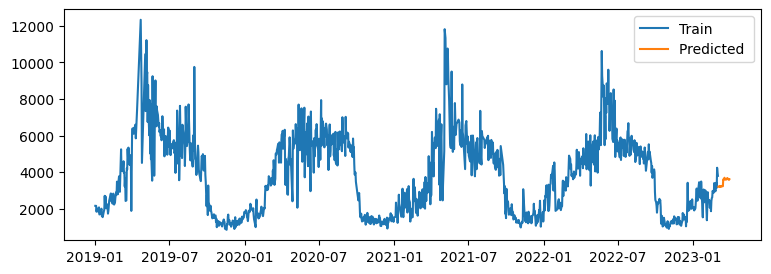

In [67]:
plt.rcParams["figure.figsize"] = [9, 3]
plt.plot(train_X, label='Train')
plt.plot(model.forecast, label='Predicted ')
plt.legend(loc='best')
plt.show()

In [74]:
submission_df = pd.read_csv('dataset/sample_submission.csv')
submission_df

ID  answer
0     TG_A_J_20230304       0
1     TG_A_J_20230305       0
2     TG_A_J_20230306       0
3     TG_A_J_20230307       0
4     TG_A_J_20230308       0
...               ...     ...
1087  RD_F_J_20230327       0
1088  RD_F_J_20230328       0
1089  RD_F_J_20230329       0
1090  RD_F_J_20230330       0
1091  RD_F_J_20230331       0

[1092 rows x 2 columns]

In [78]:
sub_inds = []
for i, ind in enumerate(submission_df["ID"]):
    if i%28 == 0:
        sub_inds.append(ind[:6])
        print(ind[:6])

TG_A_J
TG_A_S
TG_B_J
TG_B_S
TG_C_J
TG_C_S
TG_D_J
TG_D_S
TG_E_J
TG_E_S
CR_A_J
CR_B_J
CR_C_J
CR_D_J
CR_D_S
CR_E_J
CR_E_S
CB_A_J
CB_A_S
CB_D_J
CB_E_J
RD_A_J
RD_A_S
RD_C_S
RD_D_J
RD_D_S
RD_E_J
RD_E_S
BC_A_J
BC_A_S
BC_B_J
BC_B_S
BC_C_J
BC_C_S
BC_D_J
BC_E_J
BC_E_S
CB_F_J
RD_F_J


In [81]:
print(sub_inds)
preds = []
for si in sub_inds:
    preds.extend(pred_dict[si])

['TG_A_J', 'TG_A_S', 'TG_B_J', 'TG_B_S', 'TG_C_J', 'TG_C_S', 'TG_D_J', 'TG_D_S', 'TG_E_J', 'TG_E_S', 'CR_A_J', 'CR_B_J', 'CR_C_J', 'CR_D_J', 'CR_D_S', 'CR_E_J', 'CR_E_S', 'CB_A_J', 'CB_A_S', 'CB_D_J', 'CB_E_J', 'RD_A_J', 'RD_A_S', 'RD_C_S', 'RD_D_J', 'RD_D_S', 'RD_E_J', 'RD_E_S', 'BC_A_J', 'BC_A_S', 'BC_B_J', 'BC_B_S', 'BC_C_J', 'BC_C_S', 'BC_D_J', 'BC_E_J', 'BC_E_S', 'CB_F_J', 'RD_F_J']


In [82]:
submission_df['answer'] = preds
submission_df.to_csv('autots_for_each_item.csv',index=False)